# Лекция 12. Механизм `HIPPO`. Модели пространства состояний `Space State Models`. Модель `Mamba`

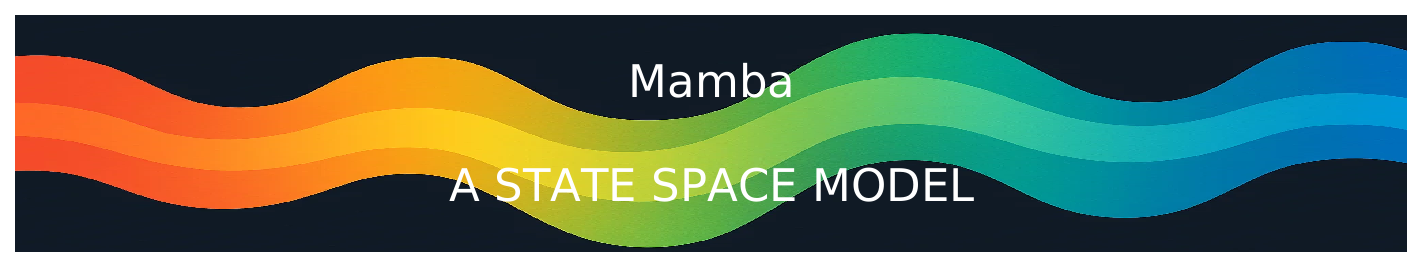


## Использованные источники

- Gu, A., Dao, T., Ermon, S., Rudra, A., Ré, C.  
  **HiPPO: Recurrent Memory with Optimal Polynomial Projections.**  
  *NeurIPS 2020.*  
  arXiv: [2008.07669](https://arxiv.org/abs/2008.07669)

- Gu, A. et al.  
  **How to Train Your HiPPO: State Space Models with Generalized Orthogonal Basis Projections.**  
  *ICLR / OpenReview.*  
  PDF: [openreview.net/pdf?id=klK17OQ3KB](https://openreview.net/pdf?id=klK17OQ3KB)

- Gu, A., Dao, T.  
  **Mamba: Linear-Time Sequence Modeling with Selective State Spaces.**  
  arXiv: [2312.00752](https://arxiv.org/abs/2312.00752)

In [14]:
import matplotlib.pyplot    as plt
import torch.nn             as nn
import plotly.graph_objects as go
import numpy                as np
import scipy                as sp
import torch.nn.functional  as F

import seaborn              as sns

import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu'

import jax.numpy            as jnp
import jax

from numpy.polynomial import legendre as L
from plotly.subplots  import make_subplots
from functools        import partial
from jax.numpy.linalg import inv

from matplotlib.animation import FuncAnimation

# Use 'notebook' instead for interactive plots
%matplotlib inline
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

import seaborn as sns
sns.set(rc={
    "figure.dpi":300,
    'savefig.dpi':300,
    'animation.html':'jshtml',
    'animation.embed_limit':100, # Max animation size in Mb
})
sns.set_context('notebook')
sns.set_style('whitegrid') # or 'ticks'

from scipy import special as ss
from scipy import linalg as la
from scipy import signal

from scipy.linalg import expm, eigvals
from einops       import rearrange, repeat, reduce

import torch
import math
import sys

## План занятия

- Механизм `HIPPO`. Эффективная реализация хранения контекста.
- Модели простраства состояний `SSM`. Реккурентная и сверточная точка зрения.
- Модель `Mamba`. Наивная реализация `Mamba Block`.

## Предварительные сведения

### Модель типа Encoder-Decoder

Модель типа `Encoder–Decoder (кодировщик-декодировщик)` — это архитектура нейронной сети, широко используемая для обработки последовательностей, в частности в задачах, где вход и выход могут иметь разную длину. Такие модели нашли применение в машинном переводе, распознавании речи, генерации текста, описании изображений и других задачах.
Основная идея

Модель состоит из двух основных компонентов:

- `Encoder (кодировщик)`

  Принимает входную последовательность и преобразует её в компактное представление (вектор фиксированной размерности, называемый контекстным вектором).
  Например, при машинном переводе encoder читает фразу на исходном языке и «понимает» её смысл, сжимая всю информацию в один вектор.

- `Decoder (декодировщик)`

  Получает на вход контекстный вектор и на его основе поэтапно генерирует выходную последовательность.
  В задачах перевода — это предложение на целевом языке.



<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABasAAALBCAIAAADZLWoZAACAAElEQVR4Xuydd5gURf7/Z8k5qhw5
SRIVBUEPFJVTPE8EFUQUPeMZ7jw8Ex6iJwgIigERI3IoBgQVMaIoOecoSQVB8qKS+n7n/uPvM91f
6tra7VA9VbU1Ne/X088+M9U11fV+V3XNp2p6u1O/AgAAAAAAAAAAANhOik8AAAAAAAAAAAAAsA6s
gAAAAAAAAAAAAMB+sAICAAAAAAAAAAAA+8EKCAAAAAAAAAAAAOwHKyAAAAAAAAAAAACwH6yAAAAA
AAAAAAAAwH6wAgIAAAAAAAAAAAD7wQoIAAAAAAAAAAAA7AcrIAAAAAAAAAAAALAfrIAAAAAAAAAA
AADAfrACAgAAAAAAAAAAAPvBCggAAAAAAAAAAADsBysgAAAAAAAAAAAAsB+sgAAAAAAAAAAAAMB+
sAICAAAAgKzkyJEjO3fu7N+/f5MmTVLHePnll/Pz83v27MlSkI50pCMd6UhHumXpzZo1e+CBB3bv
3n306FE+PggFKyAAAAAAyEoOHz789NNPd+3adfr06bt27coHAAAAQG4wc+bMHj16dOjQgV7z8UEo
WAEBAAAAQFZy6NAhPiACAAAAQM4wceLEw4cP8/FBKFgBAQAAAEBWcvvtt2/bto2PhgAAAACQMxw6
dIiPD0LBCggAAAAAspLSpUvv2bOHD4UAAACA7OHrr7/evHnz/v37+R3B7Nq1a9KkSc8+++y0adP4
fTkG+Va9enU+PggFKyAAAAAAyEpSqRQfCgEAAADZwI4dO26//faKFSt69/WkF3/4wx/iLOvv2rWr
ZcuWdevWPf/885988snx48c/9dRTfCa99O/fv3bt2nyqLsg9Pj4IRSw3AAAAAIAhYAUEAABAlnLV
VVdVqFDhueeeW7Vq1fLlyydMmNC9e/c4d/V+//336etv06ZN3tu+fft27Njxt1l0069fP9LCp+oC
KyAAAAAAyAmwAgIAACBLKV++/B133MGn+ti3b9/UqVNHjx49ceLEnTt3eonLly8fMGBAyZIlv3RZ
tGjRxRdffOqpp3pv161bR3lWrFixZMmSPXv2TJ48ecyYMUuXLvU+O2/evOeff/6zzz5jh/BYuXLl
66+/TrumTZvG/hln+/btVODmzZtZto0bN1IKq4mfkBWQIgunes6ePdufjcRyh5s5c+Zzzz03btw4
f6Inbe/evVOmTCFnvHuBYQUEAAAAADkBVkAAAABkKdWqVevVqxefeowtW7acfvrp5cqVo79Vq1at
X7/+ggULKP2OO+6oVasWff2d6HLjjTdWqVKFsnlvhw0bRnmo2I4dO3bo0KFJkyb16tUrVarUxIkT
+/fvX6NGjVatWpUoUeKvf/0rO9DgwYPp45Terl07enHWWWdt376d0vfu3UuvTzvtNO+yFEps3rz5
hRdeWOT9SoJWQIIKnzJlCklYtGgRyzlp0iRKWbhwYb77/0EXXXRRmTJl6OgNGzasVKkS7fWyedLO
PPPME044oXHjxp4nWAEBAAAAQE6AFRAAAABZyq233krfYp06dXrkkUc+++yzffv2+ffeeOONNMlf
tmwZvf72229PPfXU1q1be7teeOGFkiVLspyF/wumV69eVPLTTz+d715b0aVLl5o1a3br1s1by3j8
8cfp42vXrvUyL1iw4LvvvvNer1u3rl69egMGDPDeUp4aNWrcdttt9LpPnz516tTxX47hJ2gFJKTw
E0880X8JzCWXXMJU3HLLLbVr116+fHm+e6NTb9Hn+++/zz8m7aGHHvJyessxWAEBAAAAQE7wz3/+
8/9CJwAAACCr2Ldv3xNPPNG2bdsSJUrQHL5GjRrshqY0sS9btuzAgQNZ5gkTJlCeWbNm5cdbAWnc
uDF7+8wzz9Bn582b573dvHkzvZ08eTLLQGzbtm3x4sVz586lz55//vksfdKkSVS9q6++mo74ySef
+D7xG4JWQDyKLHzo0KEk2VuUWb9+falSpV5++WV6vXv3biqK9rKPb9++PS8vz6swlVC7dm1utWjd
unV8fBAKVkAAAAAAkJUcPHjQHwMBAAAAWcfWrVsnTpz4+9//PpVK0QtKWb16Nb1+6623WJ6VK1dS
yr///e/8eCsg5513HntLn6LP7tixw3u7Z88eejt27Fjv7dy5c9u3b1+iRIkaNWrUr1+/SpUqrVq1
Yp8lbrjhBsp/7733+hM5glZAQgr/5ptvypUr99JLL9HrBx98kK2GLFu2jA5Xr169lj6ohCeeeCLf
ldapUyffEdIcOnSIjw9CwQoIAAAAALISXAMCAADADnbs2FGhQoXrrruOXm/YsCGVSr322mts7+LF
iynl9ddfz4+3AuK/jsNbAWF3MPVWQF555RXvbYsWLbp37/7NN994b2+99daWLVt6r/PdC0bq1KlT
rly5M844I+RJvUErIOGFX3311VTz/fv3N2jQ4M477/QSV6xYQdV7+OGHp/2Wr7/+Or+QNA/6OB8f
hIIVEAAAAABkJSncBwQAAIAV7Nu3r0qVKr179/beVqtW7W9/+xvb+9xzz9FXnvdUF24F5Oabb+7Q
oQN7m19omSBkBWT79u3cxSZt27ZlixT79++/8MILW7RoMX/+/KpVq/79739n2TiKXAEJL5yYPn06
ZRg+fHheXt6SJUu8RPKhevXqt9xyC8vmp8gVkBTuAwIAAACAXAArIAAAALKUM888c8yYMStWrNiz
Z8+qVauuvfZa+lIbN26ct/ef//xnhQoV3n777X379s2YMaNu3bps5s+tgAwdOrRq1aqfffbZypUr
v/322/xCywQhKyDEcccd17Nnz127dlGG+++/v0yZMmyRYtCgQeXLl/duIDJ+/Pi8vDz2TBaOfv36
lS1bdupv2bJlS0jhHm3atClVqlTnzp39if/6178o8cknn9yxY8f+/fvJnMGDB1Np+YWkeWAFBAAA
AAA5AVZAAAAAZClXXnlltWrVUseoVavW8OHD2d5du3b16dOnRIkSpUqVor3nnnvupk2bvF3cCsjW
rVv/9Kc/Va1albLdfffd+YWWCcJXQCZMmFClSpXSpUvTgbp06cL+UeWLL76gxFGjRrFybrnllpo1
a65bt46lMPr168eEMCZNmhRUOOPpp59O+dZ9PPbv3z9w4MDKlSvn5eXRZ+nvGWecUeTijkcKKyAA
AAAAyAVSWAEBAACQtezdu3fVqlUzZ85cu3Yt93wTj82bN8+YMYM9uVYRO3bsmDNnzpo1a/gdMggv
/IEHHjjuuON2797N73DXgOa6eGsfIWAFBAAAAAA5AVZAAAAAgCxl+fLlNWvW7N+/P79DEKyAAAAA
ACAnwLNgAAAAgGykdevWqVSqQ4cO27dv5/cJsm7dOj4+CAUrIAAAAADISg4ePMjHQQAAAAAwnnXr
1m3cuJFPTcShQ4f4+CAUrIAAAAAAICvBNSAAAABAjtOgQQM+PggFKyAAAAAAyEpSqdTPAAAAAMhh
cB8QAAAAAOQEFPQ4AAAAAMhhsAICAAAAgJwAKyAAAABAjoMVEAAAAADkBFgBAQAAAHIcrIAAAAAA
ICfACggAAACQ42AFBAAAAAA5wcMPP8zHQQAAAADIJbZs2cLHB6FgBQQAAAAAWckvv/zCx0EAAAAA
yCUoGODjg1CwAgIAAACArATXgAAAAAA5TsOGDfn4IBSsgAAAAAAgK8F9QAAAAIAcB/cBAQAAAEBO
gBUQAAAAIMdRuwLyyy+/HHW59dZbS5QokfIxbty4Q4cOXXnllf5EpCMd6UhHurr0kiVLtmzZctCg
Qfn5+f/973/5ITsR3LEAkALfzySRwgoIAAAAkNuIhhliuQ8cODB69GgKtb/99tt9+/blAwAAKD72
7t07a9asbt26dezYkd7yQ3YiRL9FAIhEXafCCggAAACQ44iGGWK5H3zwwQsvvJCPwQEAABQf+/fv
79at26BBg/ghOxGi3yIARKKuU2EFBAAAAMhxRMMMsdxNmjT58ssv+egbAABAsbJ58+Y9e/bwQ3Yi
RL9FAIhEXafCs2AAAACAHGfLli18fBCKWFBSsmTJXbt28aE3AAAE8Omnn7711lt8qhlMnTp18uTJ
fKo4NOw+88wz3333Hb+j0C6lbhw8eJAfshOhbrIKchZ1neqXX37h4yAAAAAA5BIUDPDxQShiQQkF
MXzQDQDIQvr371/FpWrVqk2aNOnWrduMGTP4TDK4/vrrO3TowKeaQa9evc4//3w+VZxZs2bR2Lhw
4UJ+R6FdSt1o0KABP2QnQt1kFeQs6joVrgEBAAAAcpyGDRvy8UEoYkEJVkAAsIN+/fqVLVt2ksuz
zz7bokWLypUrr1q1is+XMbNnz/7444/5VDPQvwKi1A1Zk0xZ5QDAUNepUrgPCAAAAJDbiIYZgrmx
AgKAFfTr169ChQrsLc3M6ex+4oknvLdLlixZuXIl27tjx44vv/zS/x9wlGHs2LFjxoyZMmXKDz/8
EJK4atWqRYsWsQ9Ssa+//vrzzz8/bdq0/fv3s3RixYoVVMK+ffvo4y+88MK8efP8ewszc+bM5557
bty4cZs3b2aJXiF79uyZPHky1WTp0qVeOpVGB/3ss89YzvxjKyC7d++eNGkSFTV//nz/3vyAQ3js
3LnzjTfeoEMsW7aMW+YI2eV3I1wvGThhwgSvEHpN/lOxbG+RVouO/kHIKgcAhrpOhRUQAAAAIMcR
DTMEc2MFBAAr4FZANm3aRGf3gAEDvLfnn39+nz592F6aftNetprQv3//kiVLnnzyye3btz/uuOOu
vPLKoMT83/7fx+DBg8uVK9eqVat27drRi7POOmv79u3ernx3PaJTp06dO3du0KBB06ZN8/Lyhg8f
zvb62bFjx0UXXVSmTJnTTjutYcOGlSpVmjRpkreLCunYsSMdsUmTJvXq1StVqtTEiROpbjVq1KDj
lihR4q9//SsrhzJTHdq2bUuHa9asGR3x4YcfjjwEsWHDBspfsWLF008/vVq1arfffjtb5gjZlf9b
N0L0rlmzplGjRnRQqlv16tW5QoKsFh39g5BVDgAMdZ0KKyAAAABAjiMaZgjmxgoIAFbgXwHZt2/f
3XffTWf3hx9+6KWErID88MMPNP1++eWX2WdXrlxZZKL32j/nX7BgAbsn6Lp16+rVq8fWXPLdFQE6
yogRI7y3d955Z6VKldgFDn5uueWW2rVrL1++PN99EOwdd9xRq1at77//Pv9YIU8//XS+W40uXbrU
rFmzW7du3gUsjz/+ONVz7dq1Xjle5oEDB3pv//Wvf9HeJUuWhB+CuO666+rXr08S6PX69esbNmzI
VihCduUXWgEJ0ku7mjRpsmHDhnx3capZs2askBCrRUf/IGSVAwBDXafCCggAAACQ44iGGWK5/dMV
AED20q9fv7y8vBNdqlatSnPvxx9/nO0NWQHZtm2bd60Ezb1ZhiITPQrf+5MyL168eO7cudxtOOht
o0aN2FvKQAct/J8pu3fvrlChwtChQ1nK9u3b6ejeU12okMaNG7NdzzzzDBXC/sFk8+bN9JY9/4Uy
16xZkwr03u7Zs+f444+/9957ww9BGsuUKTNs2DC294knnvBWKEJ2eW+5FZAi9VI1Spcuzf4jiRg1
ahQrJMRq0dE/CFnlAMBQ16mwAgIAAABkwoYNG54vigULFnA5Z8+ePXDgwJtuuonmEePHj6fgk8vg
MXXqVMp2880333fffS+++OL69ev5HLIRDTPEch8+fJiLuQEA2QiNXDRXf+6555599tnbb7+dptzs
Uoj80BUQ4oEHHihRokSNGjV69Ojx0ksveVPxIhPzfzvnp0l++/btvWz169evUqVKq1atvF357orA
eeedx96uWbOGDvrpp5+yFI9ly5ZRer169Vr6oDK9JQOukH//+9+UeceOHd7bPXv20NuxY8d6bynz
mWeeyTITHTt27NmzZ/ghVq9eTXvff/999qlPPvnEW6EI2eW95VZAitS7cuVKevHBBx+wXZ999pm/
kCCr165dyw/ZiRD9FgEgEnWdCs+CAQBkI/TNTt/jX331Fb/DGMaNG0c13Lx5M79DF8VegdzhzTff
TBXFgw8+yPJQtHnJJZdQYrVq1SiUPfHEE+l1nTp1aI7gK8nZtWsXxdK0q1atWhTzN27cuFSpUvR2
27Zt/mzS2bJlCx8fhCIWlOAaEADsgLsPyPDhw2lSTaOY97ZLly5XXXUV2+vNwNkKSL472R41atRl
l11WpkyZSy+9NCTRP+dv0aJF9+7dv/nmG+/trbfe2rJlS+91vrsi4L8kxFsR+OSTT1iKx4oVKyid
pj3TfsvXX3+dX6gQbwWE3UPUWwF55ZVXvLeUuW3btiwzQYN1nz59wg9Bf2nvO++8wz41ZcqUlLtC
EbLLe8utgBSp17tQ5a233mK73n33XX8h+QFWHzx4kB+yE5FSNlkFOYu6TvXLL7/wcRAAABjP1KlT
aWD8/PPP+R3G8Pzzz1MNN2zYwO/QRbFXIHfwVkDGjx9/6LccOXLEy0Avzj333Ly8vEcffZTSvcQ5
c+bUr1+fZhMUNrOi7rjjDiqKYtSjR496KT/88MPIkSMpAmd5VEDBAB8fhCIWlKRwHxAArIBbAdm3
b1/z5s3ZhPyqq67yT85p5Er9dgXEv4sGRP9jYrhENuffvn07N7Fv27ZtghUQqmr16tVvueUWLt1D
dAWkUqVK27Zt895SDatUqeL9g0nIIYiqVavef//97O3AgQPZCkXIrvx4KyD0ulatWv47tt51113+
Qvz4rW7QoAE/ZCdC3WQV5CzqOhWuAQEAZCNYAYmEptBssg3ksnz58nvuuWf8+PHeW28F5LXXXvtt
rv/hhdM0d+DSlyxZUrJkSYpmWQoF9vXr1/dl+Q103Ouuu27atGlsfUQWDRs25OODUMSCEqyAAGAH
3AoI8fLLL9MJ7j0v9sknnyxduvSHH364b98+SqGpderYCsjKlSsff/zxjRs35ruPfe3bt2+dOnWK
TPSK9c/5jzvuuJ49e9J0nfLcf//9ZcqUSbACku/esrRUqVJUyR07duzfv3/VqlWDBw/esmVLfqFC
IldASGbv3r2///777du3X3311eTJpk2b8kMPQdx7771Vq1b96KOPaNenn356/PHHsxWKkF35sVdA
HnvsMTJn+PDhc+fOHTlyZO3atWmX9xjdEKtlTTJllQMAQ12nSuE+ILmB/3r44r02vniPHs6YMWOq
VKny7bff8jvshRri1VdfpS/oIUOG0Heu9GmVXD7++ONHHnnk6aefpnCiyBUQikBGjx790EMPvfDC
CxSW+HeF712/fv1777138OBBCtUohBg6dCjFDP4MCShyBSSkDuFtwWrohTHkgz+RQqARI0ZQuv/G
E1Qg7T1w4ABXQpGZGR988AEzmWpIH/nhhx/4TMHQQek8evjhh5966qn58+f7d1EsR4EZxYdvvvnm
Tz/95N+1YsUKOq4/hQJLOjRFvN7bIuV/8803ZCMdi1KmTJlCcaO/hBCrE7N161ayrk2bNin3n1km
T57spUeugFC8WrJkySL/k+Xiiy+mz5IW72379u1pFKLpw29z/R/sEQH16tWjgNl/8UiGiIYZgrmx
AgKAFRReAaHRqkWLFueeey69piG7a9eudL7TeEeDFH2RpI6tgCxfvrxu3br0tnz58rS3SZMmn332
WZGJXrH+Of+ECRNoWCxdunSpUqW6dOmS7L9g8t2HswwcOLBy5cp5eXlUGv0944wzKObLL1RI5ArI
eeed16dPH6oPVbtq1aqvv/66tyvkEPnuA1n+9Kc/UVFlypQ5/vjj6Rsx5XtWS9Cu/NgrIHT0+++/
nz5erlw5MooqTLu8Z76EWC06+gchqxwAGOo6VQorILmBfzJW5MSsSFSsCMQ/un5ozkZ1o4kfv8NS
Pv74Y9JbvXr1k08+uU6dOvS6c+fOP/74I5/PAI4cOdK7d2+qIX2DN2/evFKlSt4z+PwrIBQwULxB
gUfr1q0rVqxILygkiLn3scceS7l3bShbtuwpp5xCk1uKW4YOHcoyJKBwVw+pQ2RbeDUcNGgQhS61
atWiGrJEKpaq3ahRI7KlRIkSzzzzjPcRrgLhmYlDhw55AVj9+vUpvKTqFTY5nCFDhpBAKr9Vq1ae
iilTpjju1Sg33XRTyl01aNq0Kb2gv+vWrWMf/Nvf/kaf+l9BjvPee+9RNnaPjMLy33jjDQoUa9So
QWFhs2bN6Lj33HMP+3iI1QmgqJLi4QsuuICOToHlZZddNnHixJ9//pll8FZAaGrwzm/ZsWOHl8G7
cx/L72fYsGEp9x/AvbeeUlJEZn711VdsAYtBZpItt9xyC2mnnG3atBkxYsTWrVu5bKKkBMMMwdxY
AQEgZ1i7du3cuXP37NnD73CfZTtz5kyak/ufSFJkIgcNpnPmzKHZPr9DnF27ds11YQsTiVm/fv2s
WbMKP3k3/BCrVq0iLdx/AEXuSgB9EdI3FntmTX6A1aKjfxCyygGAoa5TpbACkhv450Lxr41XsSIQ
/+iaoW8EmlSk3FX+91zY7MUJ/fk6e6Eohb4K2dsJEybQlPjRRx/1ZTGFZ599lprG++Xfcf8Fhma/
Kd/k3Lvh15133unNS+kbv3PnztWrV9+7d2/kXufYtLNu3bqrV6+mt5Tt8ssvz8vLowDGy5AAbgEi
vA6RbeHVsGHDhosXL6a3Bw8eZIk0W/aqTZHM2WefTbN9r8wiV0CCMrMM1M+9t+RthQoV/CaH89Zb
b1HmK6+8kl2/sGLFCu/oo0ePTrkLBN6FLTSxp+O2bduWfTbmCohfPr2+4IILPB8c9waiy5Yt816H
Wx2fI0eOfPLJJ9dcc423WnTuuee++OKLRd6PI+hOqJ51VEl6TR/nP+by6quv0t4xY8Z4bw8fPnzf
fffREb0SqAkuvfTSIq/1oGJJac+ePb2f9C688MKQh8tEkhIMMwRzYwUEAAAUs2bNmrFjx27evHnb
tm30tVSzZs1rr72Wz1QI0dE/CFnlAMBQ16lSWAHJDfxzIe7aeCfgYvLwFYGgK8wjr7RPcGV+hpfl
x+Rf//pX1apVU+4jGOq4eLOvyJ+vbeKcc87p1KkTn2oAp556Kk3d/f8Y0rdv35Rvct6xY0fKwG48
6bh3TKAM48aNi9zrHJtgjxo1imWg+IHm5DfeeCNLEYVbgIisAwfXFl4N6WT0Zfm/xIkTJ7KUt99+
m1Jmz57tFKpAeGaiRYsWrVu3ZnsJbwSIuQLSvn17Onfyi5qBU/PVr1/fv/Q5YMAAKnnOnDne25gr
IH75FSpUoOqxt35ErQ5i3rx59Km8vDyqXvilcN4KCA2JW3+LtwRDNSlRokTQmfXiiy8Wbtl892GI
jz76KHUD2luuXLklS5b4M/jZt2/fyJEjveUqGkL53fFICYYZYrnxLBgAAFANfdXRd23KpUyZMt6d
SvhMhRAd/YOQVQ4ADHWdKqV3BWT16tUUlG/cuNGfOGPGDEr0fpZk0DSYElVMdHMT/1yImxcFXUwe
tCLghF5hHnmlfZGzsqD8mV+WL0SR17xE/nyd1dB8uHv37uRtw4YNGzRoQJOopk2b8pmKm8OHD5cs
WfL666/3J3rzRq8n0AyTOiRNs2nGONhl0KBBDz/8MGV44IEHwvd6pXn9kF1E4EHdO5OG9nf1OHUI
bwuvhtw46SVu2rSJpcyZMyd1bJmjyHMtKPPBgwdpqs+t+Hj/RBzndCOB1EY9e/bkd7jNRyc1RWL+
RCoz5S4ZeG9jroD45Xv/FXXuuefS6OFfHYhjdUx27Njx5z//ubL7D93nnHPOmDFj2H1JOCLvA0IN
+rvf/Y5Pdbn33nvDTfb+If3KK6/kdzjOTz/9RM132WWXlStXrlSpUhdffPHChQv5TPFICYYZYrmp
E/BBNwAAAAVs3bp17dq18f+VhjLzQ3YiRL9FAIhEXafS/CyY2bNnkxaaWvsTzz77bEqkCNif2KNH
D4piuTvbmU+Cexl6BF1SIYuQFZCQi8mLXBEIv8I88kr7ImdlQfkzvCxflCL1Rv58nb2MGDGChND0
adSoURMmTKBZXIcOHWiqxucrbmgcoHredddd/sR33nmH9QQvA9X8gkJQfwvf65Xm9TR2N0oPmvQ2
b97cnyKEv6tH1iGyLbwa+q/DKjLRu2yBPu4EnGtBmb0acg8rodk1Mzkc7+O33XYbv+PYrttvv92f
SINMyndqx1wB8VeehiwaRc866yya+dOu1q1be/8gE2m1KD/++OPrr7/+xz/+kQ5UpkyZbt26vfHG
G9ztciJXQP785z9ThlmzZnHp9B3RokWLSpUq5Rd17QyjYsWKbdq0YW+PHDkybdq0G264wVukbteu
3ZNPPpnhFweNe3x8EIpYUIJrQAAAwEzo25QfshORUjZZBTmLuk71yy+/8HGQSmgaSaGe/8l/FEdS
4Nu0adNTTjmFJVJQWLNmzTPPPJOlZAXJ7mXohF5SIYuQFZCQi8mLXBEIv8Lc0xhypX2Rs7Kg/Ble
li9KYb1xfr7OXurXr0/TQn+KmSsgNCBQL+VawbvHPOsJdOLQ1NSfwU/4XudYP+Tu+kHjUtB/LsSB
6+rhdYhsi8JLAEUmJl4BIWjk6dGjB9vrHFuXiXm60dh+8cUX86ku5cuXv/TSS/0p3qN8Xn31Ve/t
PffcQ6Oif1TxHrAYsgLC2L9//4QJE2rUqMHGinCrE7N9+/aRI0e2a9eOakJi+/btu3LlSm9X5ArI
kiVLSpUqdcYZZ3B3Nn3iiSfog3fffTdLKXzl48aNGymP1z127dp11113ed8vDRs2fOCBB7jLghJD
wQAfH4QiFpRQdQ8AAAAwDwo1+CE7ESllk1WQs6jrVJqvASEuvPBCmsywKw6mTZtG6l588cW8vLyd
O3d6id7Pg/fdd9//Pqb+KonMSXYvw/BLKmQRsgISdDG5U9SKQOQV5p7GoCvtnUJHD8mf4WX5CSis
N87P19lLlSpV/P9asm7dOmpcA1dACJr+0UmR7/ud3Ls/AusJ3bt3p0lp0FOWw/c6x/qh/2EiixYt
opT+/fv7conBdfXwOkS2RZFLAIUTM1kBufzyy8uVK8dueHHo0KGTTz45/unWo0cP+niRAqn5SLv/
X0iuueYaOrtZ3bz1LLagQFxxxRWpeCsgHjfddBONt95ld+FWZ87q1aupY9BIzm664a2AUAs++1v8
a9mUmfKcdtppb7/9NpUwa9as2267jUzo0KGDf6GcRtdevXrR18dyl9dee61Fixb0QfqU4zZZ1apV
aVScPn263GdXkxw+PghFLChJ6f2HWwAAADFJSZpkyioHAIa6TqU/LBk6dCgddMaMGd7bAQMGNG7c
eN++faVKlWKPA/Si4Y8//ph9SsNVEiqIcy/D8EsqZBGyAhJ0MbkTvCIQcoV54YkKN8uKPyvL8LL8
BBTW68T4+Tp76dq1K00U33///Z07d5KlLVu2pMmVmSsgVD2aK1KFV6xYsWnTprvuuosGAX9PoLOG
RobmzZtPnjyZ5vDUwaiZ+vTps3Tp0si9zrF+eNxxx40ePXrbtm1fffUVnZUZPgqa6+rhdYhsi8Jn
SpGJmayALFu2jHp7kyZNaOpO3ZuGLzIh/ulGQujjJPCDDz4gD2mSP3LkSO+ymi+++MK7Fej8+fM3
btz48MMPU2v27duXffbrr7+m8efss89euHAhVYPa13vUa9AKCLlEZyU5Sep279796aef1qpVq0OH
Dt7ecKtlcfToUfZcGG8FpDC9evXyf4SGL2pZtpf6MI1v/nU9YvDgwVRzXxnpRXP2dXDgwAFFz6JK
CYYZgrm1hxoAAADiIDr6ByGrHAAY6jqV/rDE+4WfgjzvLQXZ1113Hb1o167dnXfe6SVeccUVpUuX
ZnGhnqskpCB6L8PISypkEbICwih8MXmRKwLhV5hHzrKEZmUZXpYvile3VatW+RMviPr5OnuhaSf1
vZRL2bJlH3zwQZqwmbkCQrz00kvsEaFt27b1GsvfExYsWEBzYC8DUbJkSZpRswsBwvd6/fC9996r
W7eul4FeTJ8+nRWegMInWkgdItui8JlSZGImKyDEzJkzzzrrLKrACSecQJNz70Gt8R8JPGPGjJNO
Oun/5KVSv/vd7+gQ3i46Cr310r372nIzeapt+fLlvQxdunQZO3ZsKngFZN++fW3atClRosSxQ6X/
SSSm1cUOjahk6YoVK9i1kIXZuXPn0qVL6evSf32cUlKCYYZgbu2hBgAAgDiIjv5ByCoHAIa6TqU/
LDl8+DBNY/7whz847n3sy5Ur510TQdE2TQC8PBR8UxTOPqLnKonMSXAvw8hLKmQRZwXEw38xeZEr
AuFXmBfWmMkKSIaX5YviHbp3797vvvvu1KlTvX/Ij/z5Oquh02rdunUkjaaU/D7zoPOF2mjNmjX8
Dh9bt26leSNNL4tUFLSX9UMaoGjmuXjxYnrhzyCRoDoY2Bb3338/2cL+PzEmdHaTwLVr1/oHbccV
SEM3Tf53797tT2ccOHCAnA8amgqzZ8+eZcuWLVy4sPC9MzyCrAaFSQmGGYK5tYcaAAAA4iA6+gch
qxwAGOo6VbGEJV27dq1YsSLNZr07Snrx7uTJk2meuWvXrpUrV1IiRd5eZm1XSWROsnsZhl9SIYug
FZDwi8mLXBEIv8K8sMZMVkAyvCw/AY888kjdunW935bZf1pF/nwNsp3C/TA3Yf+f6LiP7qpcubL/
xtXAYlKCYYZYbv23HAMAABAH0dE/CFnlAMBQ16lSxbECMmzYsJT7XMAHH3ywXr16XuKuXbvy8vIm
TZo0atQo/+RT21USmZPsXobhl1TIImgFJPJi8iJXBEKuMC+sMZMVECfjy/JlEfnzNchqCvfD3IQG
sTp16tDp3LJlSzrrGzVqtH79ej4TsJGUYJghlrugoIA/IAAAAAMQfRZ6EKLfIgBEoq5TFcsPMzSN
JEVDhgw555xz+vTpw9Jbt25955139urVy38TEEfXVRKZk+xehuGXVOgh8mLyIimWK8yTXZYPQDjT
p0+/5557uHtS5iB0Oj/77LMDBw586KGH3nzzTVzrlDuIxsBiQUmxhBoAAAAiEX0WehDqJqsgZ1HX
qajb82eCeg4fPly5cuXOnTuXK1fOfx3Hbbfdduqpp9aqVev3v//9/3Lrukoic5Ldy9AJvaQC4LJ8
AABQjWgMLBaUpIrjclMAAACRiD4LPQh1k1WQs6jrVMX1w8xFF13kzfb9NzWcMGGCl9i/f39fXiOu
kohJJvcyLJZLKswHl+UDAIBqRGNgsaAEKyAAAGAmsiaZssoBgKGuUxVXWOJdDVGrVi1/4rZt27wV
EHa/CQaukshZcFk+AACoRjTMEMxdTKEGAACAcERH/yBklQMAQ12nyq6wBFdJAAAAANIRDTMEc2dV
qAEAALmD6OgfhKxyAGCo61QISwAAAIAcRzTMEMyNUAMAAIxEdPQPQlY5ADDUdSqEJQAAAECOIxpm
iOUurluOAQAACEd09A9CVjkAMNR1KqyAAAAAADmOaJghlrugoIA/IAAAAAMQfRZ6EKLfIgBEoq5T
4YcZAAAAIMcRjYHFghLRUCOlEv5gWQsvTCr8wbITXpVU+INlLbwwqfAHy054VVLhD6Yd0WehB5FS
NlkFOYu6TkXdnj8TAAAAAJBLiMbAYkGJaJSfDnpeVrKJ1sRk4FIksCgOcCkSuy0SfRZ6EGmXAJCK
uk4l+sMMAAAAACxDNAYWC0pEo3y75xuygEuRwKI4wKVI7LYorU4GssoBgKGuU5lw6gEAAACgGBEN
MwRzC4Yads83ZAGXIoFFcYBLkdhtUVqdDGSVAwBDXacy4dQDAAAAQDEiGmYI5hYMNeyeb8gCLkUC
i+IAlyKx26K0OhnIKgcAhrpOZcKpBwAAAIBiRDTMEMwtGGrYPd+QBVyKBBbFAS5FYrdFaXUykFUO
AAx1ncqEUw8AAAAAxYhomCGWW/SWY3bPN2QBlyKBRXGAS5HYbZHo6B+ErHIAYKjrVCacegAAAAAo
RkTDDLHcBQUF/AFDsXu+IQu4FAksigNcisRui0SfhR6E6LcIAJGo61SiP8wAAAAAwDJEY2CxoEQ0
1LB7viELuBQJLIoDXIrEbotEn4UehLrJKshZ1HUq6vb8mQAAAACAXEI0BhYLSkSjfLvnG7KAS5HA
ojjApUjstkj0WehBpF0CQCrqOpXoDzMAAAAAsAzRGFgsKBGN8u2eb8gCLkUCi+IAlyKx26K0OhnI
KgcAhrpOZcKpBwAAAIBiRDTMEMwtGGrYPd+QBVyKBBbFAS5FYrdFaXUykFUOAAx1ncqEUw8AAAAA
xYhomCGYWzDUsHu+IQu4FAksigNcisRui9LqZCCrHAAY6jqVCaceAAAAAIoR0TBDMLdgqGH3fEMW
cCkSWBQHuBSJ3Ral1clAVjkAMNR1KhNOPQAAAAAUI6Jhhlhu0VuO2T3fkAVcigQWxQEuRWK3RaKj
fxCyygGAoa5TmXDqAQAAAKAYEQ0zxHIXFBTwBwzF7vmGLOBSJLAoDnApErstEn0WehCi3yIARKKu
U4n+MAMAAAAAyxCNgcWCEtFQw+75hizgUiSwKA5wKRK7LRJ9FnoQ6iarIGdR16mo2/NnAgAAAABy
CdEYWCwoEY3y7Z5vyAIuRQKL4gCXIrHbItFnoQeRdgkAqajrVKI/zAAAAADAMkRjYLGgRDTKt3u+
IQu4FAksigNcisRui9LqZCCrHAAY6jqVCaceAAAAAIoR0TBDMLdgqGH3fEMWcCkSWBQHuBSJ3Ral
1clAVjkAMNR1Km2nXvokVwZ/MO3wFZIKfzC98LWRCn8w7fAVkgp/ML3wtZEKfzDt8BWSCn8wvfC1
kQp/MO3wFZIKfzC98LWRCn8wBaQEwwzB3IIa0rUpNFWQsonWxGTgUiSwKA5wKRK7LUqrk4GscgBg
qOtU2k49d/RYrmLTJiEEi9VZLM2xWp3F0hyr1VkszbFaXbZLS9dfBMHcghpcN5VsojUxGbgUCSyK
A1yKxG6L0upkIKscABjqOpW2U88dPfjATsqmTUIIFquzWJpjtTqLpTlWq7NYmmO1umyXlq6/CGK5
RW855rqpZNPjph7gUiSwKA5wKRK7LRId/YOQVQ4ADHWdStup544efGAnZdMmIQSL1VkszbFancXS
HKvVWSzNsVpdtktL118EsdwFBQX8AUNx3VSy6XFTD3ApElgUB7gUid0WiT4LPQjRbxEAIlHXqUR/
mEmMO3rwgZ2UzYTRw2J1FktzrFZnsTTHanUWS3OsVpft0kRjYLGgRDTUcN1UsulxUw9wKRJYFAe4
FIndFok+Cz2ItEsASEVdp6Juz58JanBHDz6wk7KZMHpYrM5iaY7V6iyW5litzmJpjtXqsl2aaAws
FpSIanDdVLKJ1sRk4FIksCgOcCkSuy0SfRZ6EGmXAJCKuk4l+sNMYtzRgw/spGwmjB4Wq7NYmmO1
OoulOVars1iaY7W6bJcmGgOLBSWiGlw3lWyiNTEZuBQJLIoDXIrEbovS6mQgqxwAGOo6lbZTzx09
+MBOyqZNQggWq7NYmmO1OoulOVars1iaY7W6bJeWrr8IgrkFNbhuKtlEa2IycCkSWBQHuBSJ3Ral
1clAVjkAMNR1Km2nnjt68IGdlE2bhBAsVmexNMdqdRZLc6xWZ7E0x2p12S4tXX8RBHMLanDdVLKJ
1sRk4FIksCgOcCkSuy1Kq5OBrHIAYKjrVNpOPXf04AM7KZs2CSFYrM5iaY7V6iyW5litzmJpjtXq
sl1auv4iCOYW1OC6qWQTrYnJwKVIYFEc4FIkdluUVicDWeUAwFDXqbSdeu7owQd2UjZtEkKwWJ3F
0hyr1VkszbFancXSHKvVZbu0dP1FEMstessx100lmx439QCXIoFFcYBLkdhtkejoH4SscgBgqOtU
2k49d/TgAzspmzYJIViszmJpjtXqLJbmWK3OYmmO1eqyXVq6/iKI5S4oKOAPGIrrppJNj5t6gEuR
wKI4wKVI7LZI9FnoQYh+iwAQibpOJfrDTGLc0YMP7KRsJoweFquzWJpjtTqLpTlWq7NYmmO1umyX
JhoDiwUloqGG66aSTY+beoBLkcCiOMClSOy2SPRZ6EGkXQJAKuo6FXV7/kxQgzt68IGdlM2E0cNi
dRZLc6xWZ7E0x2p1FktzrFaX7dJEY2CxoERUg+umkk20JiYDlyKBRXGAS5HYbZHos9CDSLsEgFTU
dSrRH2YS444efGAnZTNh9LBYncXSHKvVWSzNsVqdxdIcq9VluzTRGFgsKBHV4LqpZBOticnApUhg
URzgUiR2W5RWJwNZ5QDAUNeptJ167ujBB3ZSNm0SQrBYncXSHKvVWSzNsVqdxdIcq9Vlu7R0/UUQ
zC2owXVTySZaE5OBS5HAojjApUjstiitTgayygGAoa5TaTv13NGDD+ykbNokhGCxOoulOVars1ia
Y7U6i6U5VqvLdmnp+osgmFtQg+umkk20JiYDlyKBRXGAS5HYbVFanQxklQMAQ12n0nbquaMHH9hJ
2bRJCMFidRZLc6xWZ7E0x2p1FktzrFaX7dLS9RdBMLegBtdNJZtoTUwGLkUCi+IAlyKx26K0OhnI
KgcAhrpOpe3Uc0cPPrCTsmmTEILF6iyW5litzmJpjtXqLJbmWK0u26Wl6y+CWG7RW465birZ9Lip
B7gUCSyKA1yKxG6LREf/IGSVAwBDXafSduq5owcf2EnZtEkIwWJ1FktzrFZnsTTHanUWS3OsVpft
0tL1F0Esd0FBAX/AUFw3lWx63NQDXIoEFsUBLkVit0Wiz0IPQvRbBIBI1HUq0R9mEuOOHnxgJ2Uz
YfSwWJ3F0hyr1VkszbFancXSHKvVZbs00RhYLCgRDTVcN5VsetzUA1yKBBbFAS5FYrdFos9CDyLt
EgBSUdepqNvzZ4Ia3NGDD+ykbCaMHhars1iaY7U6i6U5VquzWJpjtbpslyYaA4sFJaIaXDeVbKI1
MRm4FAksigNcisRui0SfhR5E2iUApKKuU4n+MJMYd/TgAzspmwmjh8XqLJbmWK3OYmmO1eosluZY
rS7bpYnGwGJBiagG100lm2hNTAYuRQKL4gCXIrHborQ6GcgqBwCGuk6l7dRzRw8+sJOyaZMQgsXq
LJbmWK3OYmmO1eosluZYrS7bpaXrL4JgbkENrptKNtGamAxcigQWxQEuRWK3RWl1MpBVDgAMdZ1K
26nnjh58YCdl0yYhBIvVWSzNsVqdxdIcq9VZLM2xWl22S0vXXwTB3IIaXDeVbKI1MRm4FAksigNc
isRui9LqZCCrHAAY6jqVtlPPHT34wE7Kpk1CCBars1iaY7U6i6U5VquzWJpjtbpsl5auvwiCuQU1
uG4q2URrYjJwKRJYFAe4FIndFqXVyUBWOQAw1HUqbaeeO3rwgZ2UTZuEECxWZ7E0x2p1FktzrFZn
sTTHanXZLi1dfxHEcovecsx1U8mmx009wKVIYFEc4FIkdlskOvoHIascABjqOpW2U88dPfjATsqm
TUIIFquzWJpjtTqLpTlWq7NYmmO1umyXlq6/CGK5CwoK+AOG4rqpZNPjph7gUiSwKA5wKRK7LRJ9
FnoQot8iAESirlOJ/jCTGHf04AM7KZsJo4fF6iyW5litzmJpjtXqLJbmWK0u26WJxsBiQYloqOG6
qWTT46Ye4FIksCgOcCkSuy0SfRZ6EGmXAJCKuk5F3Z4/E9Tgjh58YCdlM2H0sFidxdIcq9VZLM2x
Wp3F0hyr1WW7NNEYWCwoEdXguqlkE62JycClSGBRHOBSJHZbJPos9CDSLgEgFXWdSvSHmcS4owcf
2EnZTBg9LFZnsTTHanUWS3OsVmexNMdqddkuTTQGFgtKRDW4birZRGtiMnApElgUB7gUid0WpdXJ
QFY5ADDUdSptp547evCBnZRNm4QQLFZnsTTHanUWS3OsVmexNMdqddkuLV1/EQRzC2pw3VSyidbE
ZOBSJLAoDnApErstSquTgaxyAGCo61TaTj139OADOymbNgkhWKzOYmmO1eosluZYrc5iaY7V6rJd
Wrr+IgjmFtTguqlkE62JycClSGBRHOBSJHZblFYnA1nlAMBQ16m0nXru6MEHdlI2bRJCsFidxdIc
q9VZLM2xWp3F0hyr1WW7tHT9RRDMLajBdVPJJloTk4FLkcCiOMClSOy2KK1OBrLKAYChrlNpO/Xc
0YMP7KRs2iSEYLE6i6U5VquzWJpjtTqLpTlWq8t2aen6iyCWW/SWY66bSjY9buoBLkUCi+IAlyKx
2yLR0T8IWeUAwFDXqbSdeu7owQd2UjZtEkKwWJ3F0hyr1VkszbFancXSHKvVZbu0dP1FEMtdUFDA
HzAU100lmx439QCXIoFFcYBLkdhtkeiz0IMQ/RYBIBJ1nUr0h5nEuKMHH9hJ2UwYPSxWZ7E0x2p1
FktzrFZnsTTHanXZLk00BhYLSkRDDddNJZseN/UAlyKBRXGAS5HYbZHos9CDSLsEgFTUdSrq9vyZ
oAZ39OADOymbCaOHxeosluZYrc5iaY7V6iyW5litLtulicbAYkGJqAbXTSWbaE1MBi5FAoviAJci
sdsi0WehB5F2CQCpqOtUoj/MJMYdPfjATspmwuhhsTqLpTlWq7NYmmO1OoulOVary3ZpojGwWFAi
qsF1U8kmWhOTgUuRwKI4wKVI7LYorU4GssoBgKGuU2k79dzRgw/spGzaJIRgsTqLpTlWq7NYmmO1
OoulOVary3Zp6fqLIJhbUIPrppJNtCYmA5cigUVxgEuR2G1RWp0MZJUDAENdp9J26rmjBx/YSdm0
SQjBYnUWS3OsVmexNMdqdRZLc6xWl+3S0vUXQTC3oAbXTSWbaE1MBi5FAoviAJcisduitDoZyCoH
AIa6TqXt1HNHDz6wk7JpkxCCxeosluZYrc5iaY7V6iyW5litLtulpesvgmBuQQ2um0o20ZqYDFyK
BBbFAS5FYrdFaXUykFUOAAx1nUrbqeeOHnxgJ2XTJiEEi9VZLM2xWp3F0hyr1VkszbFaXbZLS9df
BLHcorccc91UsulxUw9wKRJYFAe4FIndFomO/kHIKgcAhrpOpe3Uc0cPPrCTsmmTEILF6iyW5lit
zmJpjtXqLJbmWK0u26Wl6y+CWO6CggL+gKG4birZ9LipB7gUCSyKA1yKxG6LRJ+FHoTotwgAkajr
VKI/zCTGHT34wE7KZsLoYbE6i6U5VquzWJpjtTqLpTlWq8t2aaIxsFhQIhpquG4q2fS4qQe4FAks
igNcisRui0SfhR5E2iUApKKuU1G3588ENbijBx/YSdlMGD0sVmexNMdqdRZLc6xWZ7E0x2p12S5N
NAYWC0pENbhuKtlEa2IycCkSWBQHuBSJ3RaJPgs9iLRLAEhFXacS/WEmMe7owQd2UjYTRg+L1Vks
zbFancXSHKvVWSzNsVpdtksTjYHFghJRDa6bSjbRmpgMXIoEFsUBLkVit0VpdTKQVQ4ADHWdStup
544efGAnZdMmIQSL1VkszbFancXSHKvVWSzNsVpdtktL118EwdyCGlw3lWyiNTEZuBQJLIoDXIrE
bovS6mQgqxwAGOo6lbZTzx09+MBOyqZNQggWq7NYmmO1OoulOVars1iaY7W6bJeWrr8IgrkFNbhu
KtlEa2IycCkSWBQHuBSJ3Ral1clAVjkAMNR1Km2nnjt68IGdlE2bhBAsVmexNMdqdRZLc6xWZ7E0
x2p12S4tXX8RBHMLanDdVLKJ1sRk4FIksCgOcCkSuy1Kq5OBrHIAYKjrVNpOPXf04AM7KZs2CSFY
rM5iaY7V6iyW5litzmJpjtXqsl1auv4iiOUWveWY66aSTY+beoBLkcCiOMClSOy2SHT0D0JWOQAw
1HUqbaeeO3rwgZ2UTZuEECxWZ7E0x2p1FktzrFZnsTTHanXZLi1dfxHEchcUFPAHDMV1U8mmx009
wKVIYFEc4FIkdlsk+iz0IES/RQCIRF2nEv1hJjHu6MEHdlI2E0YPi9VZLM2xWp3F0hyr1VkszbFa
XbZLE42BxYIS0VDDdVPJpsdNPcClSGBRHOBSJHZbJPos9CDSLgEgFXWdiro9fyaowR09+MBOymbC
6GGxOoulOVars1iaY7U6i6U5VqvLdmmiMbBYUCKqwXVTySZaE5OBS5HAojjApUjstkj0WehBpF0C
QCrqOpXoDzOJcUcPPrCTsqWHjwzgK5qIlJHq+FomImWktJTt6lIZC0yZKo2vaCJSpqrzw1c6HimD
pfF1FSdlr7qUSmn8wRQgGgOLBSWiGlw3lWyiNTEZuBQJLIoDXIrEbovS6mQgqxwAGOo6lbZTzx09
+MBOypZYwtGjR/Py8vjURJimzmJpjquuRIkSfGoiDFTnSBJooDS7u6WfTFrQTGmZKPJjsTozpcUn
XX8RBHMLanDdVLKJ1sRk4FIksCgOcCkSuy1Kq5OBrHIAYKjrVNpOPXf04AM7KVtiCUeOHClZsiSf
mgjT1FksjTh8+HCpUqX41EQYqM6RJNBAaXZ3Sz+ZtKCZ0jJR5MdidWZKi0+6/iII5hbU4LqpZBOt
icnApUhgURzgUiR2W5RWJwNZ5QDAUNeptJ167ujBB3ZStsQSpES9Hqaps1gacfDgwTJlyvCpiTBQ
nSNJoIHS7O6WfjJpQTOlZaLIj8XqzJQWn3T9RRDMLajBdVPJJloTk4FLkcCiOMClSOy2KK1OBrLK
AYChrlNpO/Xc0YMP7KRsiSUcOnSodOnSfGoiTFNnsTTip59+Klu2LJ+aCAPVOZIEGijN7m7pJ5MW
NFNaJor8WKzOTGnxSddfBLHcorccc91UsulxUw9wKRJYFAe4FIndFomO/kHIKgcAhrpOpe3Uc0cP
PrCTsiWW8PPPP2f+u5+HaeoslkYcOHCgfPnyfGoiDFTnSBJooDS7u6WfTFrQTGmZKPJjsTozpcUn
XX8RxHIXFBTwBwzFdVPJpsdNPcClSGBRHOBSJHZbJPos9CBEv0UAiERdpxL9YSYx7ujBB3ZStsSj
x08//VSuXDk+NRGmqbNYGrF///6KFSvyqYkwUJ0jSaCB0uzuln4yaUEzpWWiyI/F6syUFh/RGFgs
KBENNVw3lWx63NQDXIoEFsUBLkVit0Wiz0IPIu0SAFJR16mo2/Nnghrc0YMP7KRsiUePH3/8MfPf
/TxMU2exNGLfvn2VKlXiUxNhoDpHkkADpdndLf1k0oJmSstEkR+L1ZkpLT6iMbBYUCKqwXVTySZa
E5OBS5HAojjApUjstkj0WehBpF0CQCrqOpXoDzOJcUcPPrCTsiUePQ4cOFChQgU+NRGmqbNYGrF3
794qVarwqYkwUJ0jSaCB0uzuln4yaUEzpWWiyI/F6syUFh/RGFgsKBHV4LqpZBOticnApUhgURzg
UiR2W5RWJwNZ5QDAUNeptJ167ujBB3ZStsQSpFz57GGaOoulEbt3765WrRqfmggD1TmSBBooze5u
6SeTFjRTWiaK/Fiszkxp8UnXXwTB3IIaXDeVbKI1MRm4FAksigNcisRui9LqZCCrHAAY6jqVtlPP
HT34wE7KlliClCufPUxTZ7E0YufOndWrV+dTE2GgOkeSQAOl2d0t/WTSgmZKy0SRH4vVmSktPun6
iyCYW1CD66aSTbQmJgOXIoFFcYBLkdhtUVqdDGSVAwBDXafSduq5owcf2EnZEkug+VjlypX51ESY
ps5iacSOHTtq1qzJpybCQHWOJIEGSrO7W/rJpAXNlJaJIj8WqzNTWnzS9RdBMLegBtdNJZtoTUwG
LkUCi+IAlyKx26K0OhnIKgcAhrpOpe3Uc0cPPrCTsiWWIOV/vz1MU2exNOL7778//vjj+dREGKjO
kSTQQGl2d0s/mbSgmdIyUeTHYnVmSotPuv4iiOUWveWY66aSTY+beoBLkcCiOMClSOy2SHT0D0JW
OQAw1HUqbaeeO3rwgZ2ULbGEPXv2VK1alU9NhGnqLJZGbNu2rVatWnxqIgxU50gSaKA0u7uln0xa
0ExpmSjyY7E6M6XFJ11/EcRyFxQU8AcMxXVTyabHTT3ApUhgURzgUiR2WyT6LPQgRL9FAIhEXacS
/WEmMe7owQd2UrbEo8euXbsyv/udh2nqLJZGfPfdd7Vr1+ZTE2GgOkeSQAOl2d0t/WTSgmZKy0SR
H4vVmSktPqIxsFhQIhpquG4q2fS4qQe4FAksigNcisRui0SfhR5E2iUApKKuU1G3588ENbijBx/Y
SdkSjx5S7n7nYZo6i6UR33zzTZ06dfjURBiozpEk0EBpdndLP5m0oJnSMlHkx2J1ZkqLj2gMLBaU
iGpw3VSyidbEZOBSJLAoDnApErstEn0WehBplwCQirpOJfrDTGLc0YMP7KRsiUePH374IfO733mY
ps5iacTmzZvr1avHpybCQHWOJIEGSrO7W/rJpAXNlJaJIj8WqzNTWnxEY2CxoERUg+umkk20JiYD
lyKBRXGAS5HYbVFanQxklQMAQ12n0nbquaMHH9hJ2RJL2LFjx3HHHcenJsI0dRZLIzZu3NigQQM+
NREGqnMkCTRQmt3d0k8mLWimtEwU+bFYnZnS4pOuvwiCuQU1uG4q2URrYjJwKRJYFAe4FIndFqXV
yUBWOQAw1HUqbaeeO3rwgZ2ULbGE7du3Z37/fw/T1FksjdiwYUOjRo341EQYqM6RJNBAaXZ3Sz+Z
tKCZ0jJR5MdidWZKi0+6/iII5hbU4LqpZBOticnApUhgURzgUiR2W5RWJwNZ5QDAUNeptJ167ujB
B3ZStsQStm3bdsIJJ/CpiTBNncXSiPXr1zdp0oRPTYSB6hxJAg2UZne39JNJC5opLRNFfixWZ6a0
+KTrL4JgbkENrptKNtGamAxcigQWxQEuRWK3RWl1MpBVDgAMdZ1K26nnjh58YCdlSyxh69atmT8B
0cM0dRZLI9auXXviiSfyqYkwUJ0jSaCB0uzuln4yaUEzpWWiyI/F6syUFp90/UUQyy16yzHXTSWb
Hjf1AJcigUVxgEuR2G2R6OgfhKxyAGCo61TaTj139OADOylbYglSnoDoYZo6i6URq1evbtasGZ+a
CAPVOZIEGijN7m7pJ5MWNFNaJor8WKzOTGnxSddfBLHcBQUF/AFDcd1UsulxUw9wKRJYFAe4FInd
Fok+Cz0I0W8RACJR16lEf5hJjDt68IGdlC3x6PHtt99m/gRED9PUWSyNWLVqVfPmzfnURBiozpEk
0EBpdndLP5m0oJnSMlHkx2J1ZkqLj2gMLBaUiIYarptKNj1u6gEuRQKL4gCXIrHbItFnoQeRdgkA
qajrVNTt+TNBDe7owQd2UrbEowcFfHXr1uVTE2GaOoulEStXrmzZsiWfmggD1TmSBBooze5u6SeT
FjRTWiaK/Fiszkxp8RGNgcWCElENrptKNtGamAxcigQWxQEuRWK3RaLPQg8i7RIAUlHXqUR/mEmM
O3rwgZ2ULfHosXnz5nr16vGpiTBNncXSiOXLl5900kl8aiIMVOdIEmigNLu7pZ9MWtBMaZko8mOx
OjOlxUc0BhYLSkQ1uG4q2URrYjJwKRJYFAe4FIndFqXVyUBWOQAw1HUqbaeeO3rwgZ2ULbGETZs2
NWjQgE9NhGnqLJZGLF269OSTT+ZTE2GgOkeSQAOl2d0t/WTSgmZKy0SRH4vVmSktPun6iyCYW1CD
66aSTbQmJgOXIoFFcYBLkdhtUVqdDGSVAwBDXafSduq5owcf2EnZEkvYuHFjw4YN+dREmKbOYmnE
4sWLTznlFD41EQaqcyQJNFCa3d3STyYtaKa0TBT5sVidmdLik66/CIK5BTW4birZRGtiMnApElgU
B7gUid0WpdXJQFY5ADDUdSptp547evCBnZQtsYQNGzY0atSIT02EaeoslkYsXLiwTZs2fGoiDFTn
SBJooDS7u6WfTFrQTGmZKPJjsTozpcUnXX8RBHMLanDdVLKJ1sRk4FIksCgOcCkSuy1Kq5OBrHIA
YKjrVNpOPXf04AM7KVtiCevXr2/cuDGfmgjT1FksjZg/f/7pp5/OpybCQHWOJIEGSrO7W/rJpAXN
lJaJIj8WqzNTWnzS9RdBLLfoLcdcN5VsetzUA1yKBBbFAS5FYrdFoqN/ELLKAYChrlNpO/Xc0YMP
7KRsiSWsW7euSZMmfGoiTFNnsTRi3rx57dq141MTYaA6R5JAA6XZ3S39ZNKCZkrLRJEfi9WZKS0+
6fqLIJa7oKCAP2AorptKNj1u6gEuRQKL4gCXIrHbItFnoQch+i0CQCTqOpXoDzOJcUcPPrCTsiUe
PdauXdu0aVM+NRGmqbNYGjFnzpz27dvzqYkwUJ0jSaCB0uzuln4yaUEzpWWiyI/F6syUFh/RGFgs
KBENNVw3lWx63NQDXIoEFsUBLkVit0Wiz0IPIu0SAFJR16mo2/Nnghrc0YMP7KRsiUePNWvWNGvW
jE9NhGnqLJZGzJo168wzz+RTE2GgOkeSQAOl2d0t/WTSgmZKy0SRH4vVmSktPqIxsFhQIqrBdVPJ
JloTk4FLkcCiOMClSOy2SPRZ6EGkXQJAKuo6legPM4lxRw8+sJOyJR49Vq9ebet8zGJpxIwZM846
6yw+NREGqnMkCTRQmt3d0k8mLWimtEwU+bFYnZnS4iMaA4sFJaIaXDeVbKI1MRm4FAksigNcisRu
i9LqZCCrHAAY6jqVtlPPHT34wE7KlljCqlWrmjdvzqcmwjR1Fksjvvzyy44dO/KpiTBQnSNJoIHS
7O6WfjJpQTOlZaLIj8XqzJQWn3T9RRDMLajBdVPJJloTk4FLkcCiOMClSOy2KK1OBrLKAYChrlNp
O/Xc0YMP7KRsiSWsXLmyRYsWfGoiTFNnsTRi+vTpZ599Np+aCAPVOZIEGijN7m7pJ5MWNFNaJor8
WKzOTGnxSddfBMHcghpcN5VsojUxGbgUCSyKA1yKxG6L0upkIKscABjqOpW2U88dPfjATsqWWMKK
FStatWrFpybCNHUWSyM+//zzc845h09NhIHqHEkCDZRmd7f0k0kLmiktE0V+LFZnprT4pOsvgmBu
QQ0plfAHy1p4YVLhD5ad8Kqkwh8sa+GFSYU/WHbCq5IKfzDtpARH/yBklQMAQ12n0nbqpSUUCuyk
bIklLF++/KSTTuJTE2GaOoulEdOmTevcuTOfmggD1TmSBBooze5u6SeTFjRTWiaK/Fiszkxp8UnX
XwSx3NpuOQYAAEAI0dE/CFnlAMBQ16n0hFaOkdHhsmXLWrduzacmwjR1FksjPv300/POO49PTYSB
6hxJAg2UZne39JNJC5opLRNFfixWZ6a0+KTrL4JY7oKCAv6AAAAADED0WehBiH6LABCJuk6l7YcZ
A6PDJUuWnHzyyXxqIkxTZ7E04uOPP+7SpQufmggD1TmSBBooze5u6SeTFjRTWiaK/Fiszkxp8RGN
gcWCEm2hBgAAACFEn4UeRPpbEACpqOtU1O35M0ENBkaHixcvPuWUU/jURJimzmJpxEcffXTBBRfw
qYkwUJ0jSaCB0uzuln4yaUEzpWWiyI/F6syUFh/RGFgsKNGjAQAAgCiiz0IPIv0tCIBU1HUqbT/M
GBgdLlq0qE2bNnxqIkxTZ7E0YurUqV27duVTE2GgOkeSQAOl2d0t/WTSgmZKy0SRH4vVmSktPqIx
sFhQokcDAAAAUdLfXjKQVQ4ADHWdSltYYmB0uHDhwtNOO41PTYRp6iyWRkyZMuWiiy7iUxNhoDpH
kkADpdndLf1k0oJmSstEkR+L1ZkpLT7p+osgmFuLBgAAAKKIjv5ByCoHAIa6TqUtLDEwOlywYMHp
p5/OpybCNHUWSyPee++9iy++mE9NhIHqHEkCDZRmd7f0k0kLmiktE0V+LFZnprT4pOsvgmBuLRoA
AACIIjr6ByGrHAAY6jqVtrDEwOhw3rx5bdu25VMTYZo6i6URkydPvuSSS/jURBiozpEk0EBpdndL
P5m0oJnSMlHkx2J1ZkqLT7r+Igjm1qIBAACAKKKjfxCyygGAoa5TaQtLDIwO586d265dOz41Eaap
s1ga8c4771x66aV8aiIMVOdIEmigNLu7pZ9MWtBMaZko8mOxOjOlxSddfxHEcmu75RgAAAAhREf/
IGSVAwBDXafSE1o5RkaHc+bMad++PZ+aCNPUWSyNmDhxYo8ePfjURBiozpEk0EBpdndLP5m0oJnS
MlHkx2J1ZkqLT7r+IojlLigo4A8IAADAAESfhR6E6LcIAJGo61TafpgxMDqcPXt2hw4d+NREmKbO
YmnEW2+9dfnll/OpiTBQnSNJoIHS7O6WfjJpQTOlZaLIj8XqzJQWH9EYWCwo0RZqAAAAEEL0WehB
pL8FAZCKuk5F3Z4/E9RgYHQ4c+bMM888k09NhGnqLJZGvPHGG1dccQWfmggD1TmSBBooze5u6SeT
FjRTWiaK/Fiszkxp8RGNgcWCEj0aAAAAiCL6LPQg0t+CAEhFXafS9sOMgdHhjBkzzjrrLD41Eaap
s1ga8frrr/fq1YtPTYSB6hxJAg2UZne39JNJC5opLRNFfixWZ6a0+IjGwGJBiR4NAAAAREl/e8lA
VjkAMNR1Km1hiYHR4VdffdWxY0c+NRGmqbNYGjF+/PjevXvzqYkwUJ0jSaCB0uzuln4yaUEzpWWi
yI/F6syUFp90/UUQzK1FAwAAAFFER/8gZJUDAENdp9IWlhgYHX755ZedOnXiUxNhmjqLpTnudOWq
q67iUxNhoDpHkkADpdndLf1k0oJmSstEkR+L1ZkpLT7p+osgmFuLBgAAAKKIjv5ByCoHAIa6TqUt
LDEwOpw+ffrZZ5/NpybCNHUWSyPGjRt39dVX86mJMFCdI0mggdLs7pZ+MmlBM6VlosiPxerMlBaf
dP1FEMytRQMAAABRREf/IGSVAwBDXafSFpYYGB1+/vnn55xzDp+aCNPUWSyNGDt2bN++ffnURBio
zpEk0EBpdndLP5m0oJnSMlHkx2J1ZkqLT7r+Iojl1nbLMQBA5vz888/bt2/fsWMHv8NeclAyQ3T0
D0JWOQAw1HUqPaGVY2R0aPF8zGJpxMsvv3zttdfyqYkwUJ0jSaCB0uzuln4yaUEzpWWiyI/F6syU
Fp90/UUQy11QUMAfMB4bNmx43mXr1q3crtmzZ3u7uHQAQDImTJhw4YUXVq9ePeVy6aWX8jmsIwcl
F0b0WehBiH6LABCJuk6l7YcZb2xRBH+weEybNq1z5858aiL4CkmFP1gMLJZGvPjii3/+85/51ETw
FZIKf7DYSBHI10Yq/MHiYXe39JNJC/K1kQp/sNhkosgPXyGp8AeLjRR1fG2kwh9MAaIxsFhQkjjU
ePPNNz0LBgwYwO1q3bq1NncAsJ7rr7+ezqauXbuOHj16ypQps2fPtv6CiByUXCSiz0IPIqVssgpy
FnWdiro9fyYYwEsvvbR8+XI+VTafffbZeeedx6cq5siRI3fffTefKptikeboargXXnjhhhtu4FMV
o6fhPPQL7NevH5+kgGLpljobjqGtBfWccY5GRQydDadfnbaGi49oDCwWlCRep/BWQJo2bdqwYcOj
R4+y9Pnz51P6iSeemLhkAABj7NixeXl5NBTyO+wlByUHIfos9CDUTVZBzqKuUyX+YUYpp59++q23
3sqnyubTTz89//zz+VTFvPfee6VLl/7222/5HVIpFmmOroYbM2bMTTfdxKcqRk/DeWgWuHjxYhph
FixYwO+QTbF0S50Nx9DWgnrOOEejIobOhtOvTlvDxUc0BhYLShKvU3grIP/617/o7+eff87Sb7vt
thNPPLFv376s5PXr11OnOXjwIMvDWLJkySeffMKnFjebN2+mnkdB2FNPPTV//nxu7xdffPHebyGB
X3/9Nb3Yt2+fP+eBAwcoce3atd7bwj7Q25UrV7K3q1atohS2nETVePXVVwcPHjxkyBAao/3LTIxN
mzaNHj36oYceouni9u3bWbp3LH+7EFTClClTKN2fs1jwqnfo0CGWMmPGjPfff//HH3+MdJLZuHTp
0scee2zo0KGLFi3yZ/YIb0QVeBXjIEXe3iK7DaVH6j3llFO6d+++evXq559/nk638ePH79+/35+5
sJkrVqygFPqIPwN3An7wwQdsrTcyg8fChQuHDx9OdaBz/6effvLv8gjqjUEEFRgiOdKumTNnUl9i
u44cOeK3wiOknpFWRLrtEXIIIWRNMmWVAwBDXadKHJaoY/bs2VSrypUrc4OPdD7++OMuXbrwqYrp
2rUrqRs4cCC/QyrFIk1bw9GAf8stt/CpitHTcB6aBd5www0k7cYbb+R3yKZYuqXOhmPoaUFtZ5yj
S5EfnQ2nWZ3OhouPaJghmDtpqOGtgFDoT9MVdrvan3/+uXr16oMGDfKvgNA0lV4XeRH79ddff8IJ
J/CpxcqQIUNKly5dtmzZVq1a1alTh2o+ZcoUfwZKpww1XLybFJDAZcuW0YsRI0b4c7744ouUSFMy
721hH+it/zK/e+65h1K8yRUNyvSayj/55JO9anTu3JlNpz1o9kg1of7aunXrihUr0gu2nOQdq0SJ
Ehs2bGD5P/zww5TL1KlTWWKx4FVv9+7d3ttnnnkmLy9v2LBh9DrSSe+zDz74ILUR9b1q1arRZ4cO
HerPH9mIKvAqRk3m9Q2P7777zttbZLdxovQePnyYGrFZs2alSpWi9qUX9JYULVmyhGXmzKTBq3bt
2p5F/gzcCUjm3HbbbTEzHD169KabbqI85HbTpk1T7sVf69at8+cP6Y2FCSkwXHK4XfT6nHPO+f3v
f8920Snjt8KJqmekFZFuO1GHECIlOPoHIascABjqOlUqaViijmuuuSblQt9W/D6pfPTRR3/4wx/4
VJXQwEtjLEmjocy/tisd/dIcjQ03atSov/zlL3yqSrQ1nIdOgTt37qxQoQJJoy/QvXv38rulor9b
am44hp4W1HbGOboUMTQ3nGZ1OhsuPinBMEMwd9JQg62A0GyEBilv0eiNN96g/rFly5YsXQF56623
qKpXXnklWwNbsWKFfxGBaNmy5cUXX+y9JlGpY1PZjh07tmjRwp+zffv2NAVibwv7kApeAVm7di1b
OnHcu0KSsY8++ihLeffddynznXfe+fPPP9NbmpJ17tyZptbet4V3LJo9/uMf/2AfoWpTSsqwFZBn
n302Ly/PLy3cSe+zdevW9X51J/mXX345lTB37lwvQ5xGVEHh9vUT1G2cUL3UmikXOqG8jrFkyZLj
jz++adOmbPzl5uTUo6pVq5aSugIyevTolNtXvQuRvvrqK5rVt23blmUO742FCSkwUnKIXU7UCkhk
PSOtiHQ78hBCpARH/yBklQMAQ12nSiUNSxRBA0K5cuW8calVq1b8bql8+OGHF154IZ+qEhrEPGkE
hXD8bnnol6az4Z5++mn2NaEHbQ3noVPgsGHDmLSnnnqK3y0V/d1Sc8MxNLSgzjPO0aLIj+aG06lO
c8PFJyUYZgjmThpqsBWQ7du3ly5d+pVXXnHcC4S8xdQsXQGhqVStWrXy8/P5HT5oJta9e3fvtX8q
O378eHr9xRdfeLto2pb67dhd2IdU8ApIYWhq16lTJ/aW5oHNmjU7cuQIS1m+PP10onHjxjnHjjVy
5Eiaeh04cMBxr94vUaIEpaRMWgEZM2ZMXl7eoEGD/HvDnfQ+O2rUKJZ/27ZtNEdlV0vGaUQVFG5f
P0HdxgnV603gaY7tvyztySefTPmuavHPyVesWEEn4zPPPJOSugJy6qmn1q9f398zBwwYQB+ZM2eO
9za8NxYmpMBIySF2Ed26daOasA9yKyCR9Yy0ItLtyEMIkRIc/YOQVQ4ADHWdKpU0LFHEkCFDUj64
fy+VC307UxzFpyqDwgP2vC1C1mNBi0SzNEdvw9GX1B133MGnKkNnw3loE0jfng0bNmTSTjrpJD6H
VDR3S/0Nx9DQgjrPOEeLIob+htOpTnPDxSclGGaI5U58yzG2AkKvL7nkEuoN3333XcmSJWl+4hS1
AvKPf/yDJgmDBw8eO3YsTVm9XUatgNCwS/Xv2bMnv+O30Oy6d+/e3mv/VPbnn38+/vjjr7rqKm/X
rbfeWqFChT179rAPFp5cpUJXQCZOnEhz5pYtW9KXQYMGDag0mkV7u6iqNPWiaeSjjz462GXQoEHU
lPTxBx54wDl2LGoRqq33WGI6UKdOnahbp4xZARk+fHheXh7NhLnbLoQ76X122bJl//uA+/gh7wqC
mI2ogsLt6yeo2ziheo8ePUo5uX9S9WbUjzzyiPfWPyfv3Lkz+UAFpgqtgHgnIINc4mb1QRm8f0th
lffwOtLo0aOdGL2RI7zASMkhdjnuf6BQzmHDhq1Zs2bDhg2rV69mVsSpZ7gVLEOQ23EOIURKcPQP
QlY5ADDUdaqUSSsgdFI3atQo5eOKK67gM8njgw8+uOiii/hUZbz00kt+afSNrO5ZAJqlaW64kSNH
/u1vf+NTlaGz4Ty0CZw0aZJfGjF9+nQ+kzw0d0v9DcdQ3YKazzhHvSI/+htOmzr9DReflGCYIZa7
oKCAP2A8/CsgNFen3nDzzTdXqVLFu1dF4RWQc88994ILLjjnnHOqV69epkwZ+rhj2ArI/v37qZ7h
Fx15M5w777zTe8tNZe+7775y5crt3LkzPz+frLjuuuv+98miZsip4BWQESNG0OvLLrts1KhREyZM
ILs6dOjQoEEDL6dXVXp7QSG89Q52LJqYnXzyyVSfqlWrUjlGrYAQ1157LXUGEs5lCHHS++w333zj
y56+QKZ58+ZOvEZUROH2ZYR3GydUb9myZXv16sXeElu3bqWP00e8t2xOPn78+BIlSsydO5e6UKrQ
Coh3AjIoJzerD8rgWXr77bd7mT28+3EMHz6cZQjpjRyRBUZKDrHr559/vummm6iElA/Pijj1DLeC
ZQhyO84hhBB9FnoQKcFvEQAiUdepEv8wowIKcnxjSZrSKp8F8P777//xj3/kU5Vx+umnc+rUPQtA
szTNDff444///e9/51OVobPhPLQJPP/88zlp3O8lctHcLfU3HEN1C2o+4xz1ivzobzht6vQ3XHxE
Y2CxoCRxqOFfATl48GDNmjXp7c033+ztLbwCwmaGNEmgyWrjxo0dw1ZAiEqVKrGbNRTJmjVrUr5/
weCmshs3bqRJ0YgRI7xbM86ePft/nyzkgxO6AlK/fn2aNbFdhH8FhKhYsWK3bt18+38DO9Z3331H
XblPnz516tShko1aAbn33nsd9+IrMo275irESe+z7K4fHk2bNmX/IhTZiIoo3L6M8G7jhOpt1KhR
x44d2Vti3rx5Kd/dQL3j0jBRu3Zt79FZRa6ARP5nR0iG8uXLX3rppf691IXoI6+++qr3Nrw3Fia8
wEjJIXZ5kAPbtm3bunUr5fRbEVnPSCsi3Y48hBCiz0IPIqVssgpyFnWdiro9fyYUH97N/z1KuLfB
S6l8FgDFVNq+v7yb/3OoexaATmmO9oYbPny4P5xTiuaG89AjcOXKlXl5eZw0+grO5JFq4ejslsXS
cAzVLaj5jHPUK2IUS8NpU6e/4eIjGgOLBSWppJeb+ldAHPfBxX379mWPqAhZASF69OhB01THvBUQ
qli5cuU2b97M7ziGd3+mVatWeW8LT2VpJG3RokX79u1POeUUluhR2IdU8ApIlSpVyBy2a926daVL
l/avgHTv3p08DKqq/1i9e/em195Sl1ErIN6/Ehw5cuScc86pX7++/z+GnGAnvc/6LxtZtGgRpfTv
3997G9mIiijcvozIbuME67322mtLlSrll+PdjYk94tc7LvWWGjVq/PDDD06hOXmRFSs8qw/JcMEF
F1Bn27VrF9t7zTXXUJjC7i8b3hsLE15gpGQn2C4O7j4gkfWMtCLS7chDCCH6LPQgUsomqyBnUdep
Ev8wIx128//LLrss5d6oqG3btimVzwJ49913L7nkEj5VDd7N/48//vhXXnnFG8S8m+EpehaATmn6
G46+Gu666y4+VQ2aG85Dj8Bbb72VhNDXq3e79MGDB3sPhRkyZAifVRI6u2WxNBxDaQvqP+McxYr8
FEvD6VFXLA0XH9EYWCwoSUlaAeEovALy4Ycfzpo1i2bgNKLR9Ia8dsxbAVm6dGn58uWbN2/+wQcf
bNu2bfXq1SNHjvQuN6Apzd133126dGn/PSYKT2WnTJmScil8Yvh98Ei5V/ext1dffXXq2ApI165d
aR71/vvv79y5k0xr2bJl1apV/Ssgy5cvr1ixIlV18uTJ3377LU0dp06d2qdPH5LAjuVN5LZv306F
e0uVBq6AEJs2bapSpQp3oWOQk95njzvuOPqCpDb66quvmjVrRh9nl2yFNKJSipw8x+w2TrBeklOm
TJk2bdrMnDlzy5Ytjz/+OJ0+/os2vePm5eU999xzXor0FZAvvviChshOnTrNnz9/48aNND+hw7Fn
YDtRvbEw4QVGSnaC7eLgVkAi6xlpRaTbkYcQIiVpkimrHAAY6joVDZjczaGKi379+tH3y0cffeS4
J6PjLtnTV0/16tUVPQuAxg2JF5GFQKMcjVS3336790XsqVu/fj2NtIqeBaBNmlMcDTd06FD6rudT
FaC/4Tw0CNy7dy8Fun/5y18o7nWOSaPv0EsuuaRx48ZHfPcXl4i2bllcDcdQ2oL6zzhHsSJGcTWc
HnXF0nAxoeiaggE+PghFLCjxBCdAdAXEgyY2DRs2/Otf/+r94G/aCggxY8aMk046iVX4d7/73bx5
8yh93LhxLVq0eOSRR/yRWeGpLHWdBg0aFPkMc78PIXgrIF9//fWpp57qpdAEjOZXvXr18q+AEAsW
LOjQoQP7YMmSJc8++2zvx+ciJ3KOqSsgzrEHfHi30fUIctL7LHW8unXresLpBXejrKBGVEqRnsfs
Nk6wXse9U1f9+vU9LSVKlKCe4L/0zjtuu3btWHwgfQXEcc93stGrA/U0OnN/+uknX/aw3lgk4QWG
S3ZC7fLDrYA4UfWMtCLSbSfqEEKkJE0yZZUDAENdp6KwctGiRfzJoB06x5999lnvsdbOsejQ44cf
fmD/AyiXd955h/sPQUVQMOA32a+O5oQU37O3stAmrVgabsiQId4/9qpGf8N5aBA4a9asIGnvvvvu
ihUr2FuJaOuWxdVwDHUtWCxnnKNSkZ/iajgN6oqr4WKyePHi5s2b8/FBKGJBiV8wYGzYsGHOnDlr
164VXXXev39/5cqV/f/Akhg69Lp16+bPnx/+n2Zbt26lqtJ3Q3i2rCPISTZHPXz48NKlS+kMoRdc
Ho/EjVgsBOn1OHr06KpVq+bOnVt4VUsbZOPy5cupDv6lKw6h3hheYLjkcLsiEapnMqQcQtYkU1Y5
ADDUdSoa5Hv06EEjAH8+FCt6giXvGXB8qno0qLNYGjF48OD777+fT1WPHnVOcQjUI83ubulHWwtq
k6ZNkR+L1WmTFgcKAC677LIhQ4bw8UEoYkGJUYItgLosWbpw4UJ+BxAkyMkif6W3gCC9oEhyxC5Z
k0xZ5QDAUNep/vOf/5x77rk9evTgnvlVvOgJlt5++20SzqeqR4M6i6URjzzySLJHnmeIHnVOcQjU
I83ubulHWwtqk6ZNkR+L1WmTFsnRo0d79ux59tln/7//9//4+CAUsaDEnFuOZTvUWTt06JCXl9en
Tx9+HxAh3En7VkDC9QKOnLJL1iRTVjkAMJR2qv/85z/Dhg1bs2YNBUDt27dP/ZY5c+ZQBivTaT5W
vXr1wulB+WWl098i04PyJ0g/8cQTi0wPyi8rnUtk6UH5kR6Ufv311xeZHpQ/W9LPO++8ItOD8iM9
PJ0oMj0of3alc4ksPSg/0kXT586d+9///nfy5MmiD4L5VXQFpKCggA+6QSLGjx/fv39/+mvC7XOz
mnAnp0+ffs899+Tn5/M7spZwvYAjp+wSfRZ6ECmVk1WQm+Rap9Kj9913373yyiv5VPVoUGexNGLQ
oEGPPPIIn6oePep+LQ6BeqTZ3S39aGtBbdK0KfJjsTpt0tQhJgDXgAAAgJkkWAIvEgu+2IBp5Fqn
0qN30qRJvXv35lPVo0GdxdIImqsMHjyYT1WPHnW/FodAPdLs7pZ+tLWgNmnaFPmxWJ02aeoQE5Ay
5t9+AAAA+BF9FnoQFnyxAdPItU6lR+8777xz1VVX8anq0aDOYmm/ur8mit60Twp61P1aHAL1SLO7
W/rR1oLapGlT5MdiddqkqUNMAFZAAADATGR9IckqBwBGrnUqPXonTpzYp08fPlU9GtRZLI0YOHDg
sGHD+FT16FH3a3EI1CPN7m7pR1sLapOmTZEfi9Vpk6YOMQFYAQEAADOR9YUkqxwAGLnWqfToffvt
t6+55ho+VT0a1FksjRgwYMBjjz3Gp6pHj7pfi0OgHml2d0s/2lpQmzRtivxYrE6bNHWICcAKCAAA
mImsLyRZ5QDAyLVOpUfvW2+91bdvXz5VPRrUWSyNeOCBB0aMGMGnqkePul+LQ6AeaXZ3Sz/aWlCb
NG2K/FisTps0dYgJwAoIAACYiawvJFnlAMDItU6lR+8bb7xx7bXX8qnq0aDOYmnE/fff/8QTT/Cp
6tGj7tfiEKhHmt3d0o+2FtQmTZsiPxar0yZNHWIC8CwYAAAwE1lfSLLKAYCRa51Kj94JEyZcd911
fKp6NKizWBpx3333Pfnkk3yqevSo+7U4BOqRZne39KOtBbVJ06bIj8XqtElTh5iAgoICPugGAABg
AFu2bOGH7ERY8MUGTCPXOpUeva+//vr111/Pp6pHgzqLpRH33HPP008/zaeqR4+6X4tDoB5pdndL
P9paUJs0bYr8WKxOmzR1iAnANSAAAGAmv/zyCz9kJ8KCLzZgGrnWqfTofe2112644QY+VT0a1Fks
jfjHP/7xzDPP8Knq0aPu1+IQqEea3d3Sj7YW1CZNmyI/FqvTJk0dYgJSuA8IAAAYScOGDfkh+/+z
dybwWk37G1/NhObBEKJkShFCuIibEBlSKVMyppurQTKkMqRBA0qEzDQoQ4PhhptuGnTjouT+XTJz
xHWpDGn/125nt846Z5/2qr3W2T3r+X6+nz7n/N71rvM+Z613n9/enfO+mwXADzaSN3zbVG7yTpgw
oUuXLnrVPg7SAUeT9OjRY/To0XrVPm7SBaUR0E007G2p4mwFnUVzlkgFOJ2zaPYwC8ArIIQQkk+y
+oGU1TyExPi2qdzkfeCBBy666CK9ah8H6YCjSbp3737XXXfpVfu4SReURkA30bC3pYqzFXQWzVki
FeB0zqLZwywAr4AQQkg+yeoHUlbzEBLj26Zyk/f+++/v2rWrXrWPg3TA0SRXXnnlmDFj9Kp93KQL
SiOgm2jY21LF2Qo6i+YskQpwOmfR7GEWgFdACCEkn2T1AymreQiJ8W1Tuck7fvz4iy++WK/ax0E6
4GiSK6644p577tGr9nGTLiiNgG6iYW9LFWcr6Cyas0QqwOmcRbOHWYDy5cv/8MMPet9NCCGkVPn+
++/LlSunH7I3C4AfbCRv+Lap3OS97777Lr30Ur1qHwfpgKNJLrvssnvvvVev2sdNuqA0ArqJhr0t
VZytoLNozhKpAKdzFs0eZgFuv/32lStX6q03IYSQUmXx4sUNGjTQD9mbBcAPNpI3fNtUbvKOGzdO
Nr561T4O0gFHk1xyySXyXFqv2sdNuqA0ArqJhr0tVZytoLNozhKpAKdzFs0exgH0vpsQQkhps2bN
mu+//14/Xm8WAD/YSN7wbVO5yXvPPfdcfvnletU+DtIBR5N07dr1/vvv16v2cZMuKI2AbqJhb0sV
ZyvoLJqzRCrA6ZxFs4dxgOuvv75169Zz5syR3bbegxNCCHHIDz/8MG/ePNmTfffdd/rBenMB+MFG
8oZvm8pN3rFjx15xxRV61T4O0gFHk3Tp0uXBBx/Uq/Zxky4ojYBuomFvSxVnK+gsmrNEKsDpnEWz
h3GA1atXDxgwoFGjRuIPZP+9du3a5s2bxxXWWd8q6v379y+2njSeddbzVq9QoUKTJk0GDx78888/
6wfrzUVs/T/YSN7wbVO5yTtmzJgrr7xSr9rHQTrgaJILL7zwoYce0qv2cZMuKI2AbqJhb0sVZyvo
LJqzRCrA6ZxFs8dWH4CQzQbgCUxI5vB5QTLHt03lJu/dd9/dvXt3vWofB+mAo0nOP//8Rx55RK/a
x026oDQCuomGvS1VnK2gs2jOEqkAp3MWzR5bfQBCNhuAJzAhmcPnBckc3zaVm7x33nnnX/7yF71q
HwfpgKNJzj333EcffVSv2sdNuqA0ArqJhr0tVZytoLNozhKpAKdzFs0eW30AQjYbgCcwIZnD5wXJ
HN82lZu8o0eP7tGjh161j4N0wNEknTp1evzxx/WqfdykC0ojoJto2NtSxdkKOovmLJEKcDpn0eyx
1QcgZLMBeAITkjl8XpDM8W1Tuck7atSoq666Sq/ax0E64GiSjh07Pvnkk3rVPm7SBaUR0E007G2p
4mwFnUVzlkgFOJ2zaPbY6gMQstkAPIEJyRw+L0jm+Lap3OQdOXLk1VdfrVft4yAdcDRJhw4dJk6c
qFft4yZdUBoB3UTD3pYqzlbQWTRniVSA0zmLZo+tPgAhmw3AE5iQzOHzgmSOb5vKTd4RI0b07NlT
r9rHQTrgaJKzzz578uTJetU+btIFpRHQTTTsbanibAWdRXOWSAU4nbNo9tjqAxCy2QA8gQnJHD4v
SOb4tqnc5B0+fHivXr30qn0cpAOOJjnrrLOmTJmiV+3jJl1QGgHdRMPelirOVtBZNGeJVIDTOYtm
j60+ACGbDcATmJDM4fOCZI5vm8pN3mHDhvXu3Vuv2sdBOuBokjPOOGPq1Kl61T5u0gWlEdBNNOxt
qeJsBZ1Fc5ZIBTids2j22OoDELLZADyBCckcPi9I5vi2qdzkHTp0aJ8+ffSqfRykA44madu27TPP
PKNX7eMmXVAaAd1Ew96WKs5W0Fk0Z4lUgNM5i2aPrT4AIZsNwBOYkMzh84Jkjm+byk3eIUOG9O3b
V6/ax0E64GiS00477bnnntOr9nGTLiiNgG6iYW9LFWcr6Cyas0QqwOmcRbPHVh+AkM0G4AlMSObw
eUEyx9KmEoQQQgghhm2G2WhCkDB9thDiA3xekMyxtKnCad/019uuFP266EUMgaNJTz5SzLxTLyKJ
GhB7W6rirSBeIlXsdCk1bTPMRhOChOmzhRAf4POCZI6lTeX5FZBbu4nrLtKLGAJHk7ZuIWZBn66g
BsTelqp4K4iXSBU7XUpN2wyz0YQgYfpsIcQH+LwgmWNpU3l+BeSWbuKGrnoRQ+Bo0laHixfv1otI
ogbE3paqeCuIl0gVO11KTdsMs9GEIGH6bCHEB/i8IJljaVN5fgXk5ivEjRfrRQyBo0lPaC5eHqsX
kUQNiL0tVfFWEC+RKna6lJq2GWajCUHC9NlCiA/weUEyx9Km8vwKyMDLRP9L9CKGwNGkxzcXs+/R
i0iiBsTelqp4K4iXSBU7XUpN2wyz0YQgYfpsIcQH+LwgmWNpU3l+BWTApeKmS/UihsDRpMcdIl69
Vy8iiRoQe1uq4q0gXiJV7HQpNW0zzEYTslWzdOnS999/P/5UfbZ89NFHS5YsiT8lxFtMf4oQskks
bSrPr4DIk7EBoOdjwNGkxzQTr92nF5FEDYi9LVXxVhAvkSp2upSathlmownZqlmzZs1OO+3Ut2/f
H3/8MfijKf/ll18GDRpUs2bNlStX6ncgxD9Mf4oQskksbSrPr4D0vyT8tfyidQCBo0mPPkjMGa8X
kUQNiL0tVfFWEC+RKna6lJq2GWajCdnaueaaa+STpF69ehMnTpQfzJw5s2HDhvKDLl266EMJ8RLT
nyKEbBJLm8rzKyA3Xhy+NGPROoDA0aRHHSjmPqAXkUQNiL0tVfFWEC+RKna6lJq2GWajCdna+c9/
/lO2bNnwiVKYN998Ux9KiJcIw58ihGwSS5sqnLZIG+SPN3QN356zaB1A4GjSFk3EvAf1IpKoAbG3
pSreCuIlUsVOl1LTNsNsNCEAtGnTptDFDyEOO+wwfRAhvmL6U4SQTWJpU4XTFmmD/PG6i8StoOdj
wNGkhx8g5j+kF5FEDYi9LVXxVhAvkSp2upSathlmowkBYObMmYWufwjx8MMP64MI8RXTnyKEbBJL
myqctkgb5I/9uojbrtSLGAJHkzbfXyx4WC8iiRoQe1uq4q0gXiJV7HQpNW0zzEYTAsC6desaNGgQ
X/6oVavWmjVr9EGE+IrpTxFCNomlTeX5FZBrLxS3/0UvYggcTXrIfmLRI3oRSdSA2NtSFW8F8RKp
YqdLqWmbYTaaEAyGDRsWXwHp27evfjMhHmP6U4SQTWJpU3l+BaTvBWJID72IIXA0abN9xOLH9CKS
qAGxt6Uq3griJVLFTpdS0zbDbDQhGKxcuXLbbbeVz5Zy5cp99NFH+s2EeIzpTxFCNomlTeX5FZA+
54uhoOdjwNGkB+0tljyhF5FEDYi9LVXxVhAvkSp2upSathlmowmBoUuXLvLZ0qZNG/0GQvzG9KcI
IZvE0qby/ApI7/PEsKv0IobA0aRNG4m3n9SLSKIGxN6WqngriJdIFTtdSk3bDLPRhMCwaNEi+WyZ
NWuWfgMhfmP6U4SQTWJpU3l+BaTXuWL4X/UihsDRpAc0FO9M1ItIogbE3paqeCuIl0gVO11KTdsM
s9GEINGpU6d169bpVUL8xvSnCCGbxNKm8vwKSM/OYkRPvYghcDTp/nuKdyfpRSRRA2JvS1W8FcRL
pIqdLqWmbYbZ6GB9w0EIISSH6MfrzSKreQiJsbSpwmmLtEH+eHUnMRL0fAw4mnTfPcTSyXoRSdSA
2NtSFW8F8RKpYqdLqWmbYTY68L7hoJTSfGp69E8iq3kIibG0qTxvSK46R4zqpRcxBI4m3ae+eP9p
vYgkakDsbamKt4J4iVSx06XUtM0wGx1433BQSmk+NT36J5HVPITEWNpUnjckPTqK0b31IobA0aSN
dhMfTNWLSKIGxN6WqngriJdIFTtdSk3bDLPRgfcNB6WU5lPTo38SWc1DSIylTeV5Q/KXDuLOPnoR
Q+Bo0oa7iv97Ri8iiRoQe1uq4q0gXiJV7HQpNW0zzEYH3jcclFKaT02P/klkNQ8hMZY2lecNSff2
4u5r9CKGwNGke+4iPnxWLyKJGhB7W6rirSBeIlXsdCk1bTPMRgfeNxyUUppPTY/+SWQ1DyExljaV
5w3Jle3FmL56EUPgaNL6O4uPntOLSKIGxN6WqngriJdIFTtdSk3bDLPRgfcNB6WU5lPTo38SWc1D
SIylTeV5Q3JFOzH2Wr2IIXA06e47iRXT9SKSqAGxt6Uq3griJVLFTpdS0zbDbHTgfcNBKaX51PTo
n0RW8xASY2lTed6QXH6WuKefXsQQOJp017ri05l6EUnUgNjbUhVvBfESqWKnS6lpm2E2OvC+4aCU
0nxqevRPIqt5CImxtKk8b0guO1OMu04vYggcTbpLHfH5LL2IJGpA7G2pireCeIlUsdOl1LTNMBsd
eN9wUEppPjU9+ieR1TyExFjaVJ43JJeeKe67Xi9iCBxNulMt8cULehFJ1IDY21IVbwXxEqlip0up
aZthNjrwvuGglNJ8anr0TyKreQiJsbSpPG9ILj5djL9BL2IIHE1at4b46iW9iCRqQOxtqYq3gniJ
VLHTpdS0zTAbHXjfcFBKaT41PfonkdU8hMRY2lSeNyRd24r7b9SLGAJHk9auLr55WS8iiRoQe1uq
4q0gXiJV7HQpNW0zzEYH3jcclFKaT02P/klkNQ8hMZY2lecNyUWniQf660UMgaNJa1UT387Wi0ii
BsTelqp4K4iXSBU7XUpN2wyz0YH3DQellOZT06N/ElnNQ0iMpU3leUPS5TQx4Sa9iCFwNGmNKuK7
V/QikqgBsbelKt4K4iVSxU6XUtM2w2x04H3DQSml+dT06J9EVvMQEmNpU3nekFx4qnhogF7EEDia
tNoO4r+v6UUkUQNib0tVvBXES6SKnS6lpm2G2ejA+4aDUkrzqenRP4ms5iEkxtKm8rwhuaCNeHig
XsQQOJq0ynbih7/rRSRRA2JvS1W8FcRLpIqdLqWmbYbZ6MD7hoNSSvOp6dE/iazmISTG0qbyvCE5
72TxyCC9iCFwNOn2lcWPc/QikqgBsbelKt4K4iVSxU6XUtM2w2x04H3DQSml+dT06J9EVvMQEmNp
U3nekJx7sngU9HwMOJp0u23Fqrl6EUnUgNjbUhVvBfESqWKnS6lpm2E2OvC+4aCU0nxqevRPIqt5
CImxtKk8b0g6nyQev0UvYggcTbptJbFmnl5EEjUg9rZUxVtBvESq2OlSatpmmI0OvG84KKU0n5oe
/ZPIah5CYixtKs8bkk6txRO36kUMgaNJK1UUv7yhF5FEDYi9LVXxVhAvkSp2upSathlmowPvGw5K
Kc2npkf/JLKah5AYS5vK84akYyvx5G16EUPgaNIK5cWv8/UikqgBsbelKt4K4iVSxU6XUtM2w2x0
4H3DQSml+dT06J9EVvMQEmNpU3nekHRoJZ4CPR8DjiYtV1asXagXkUQNiL0tVfFWEC+RKna6lJq2
GWajA+8bDkopzaemR/8kspqHkBhLm8rzhqT9n8XEwXoRQ+Bo0jJlxLpFehFJ1IDY21IVbwXxEqli
p0upaZthNjrwvuGglNJ8anr0TyKreQiJsbSpPG9Izj5BTB6iFzEEjhasP10pWkQSNSD2tlTFW0G8
RKrY6VJq2maYjQ68bzgopTSfmh79k8hqHkJiLG0qzxuSdseLKUP1IobA0X5fGP7KetE6jMABgbel
Kt4K4iVSxU6XXtM2w2x04H3DQSml+dT06J9EVvMQEmNpU3nekJzZUjwNej4GHO23BaJ8Ob2IJHBA
4G2pireCeIlUsdOl17TNMBsdeN9wUEppPjU9+ieR1TyExFjaVJ43JGccJ6YO04sYAkf75Q1RsYJe
RBI4IPC2VMVbQbxEqtjp0mvaZpiNDrxvOCilNJ+aHv2TyGoeQmIsbSrPG5LTjxXThutFDIGjrZkn
tqmoF5EEDgi8LVXxVhAvkSp2uvSathlmowPvGw5KKc2npkf/JLKah5AYS5vK84ak7THi2RF6EUPg
aKv/ISpvoxeRBA4IvC1V8VYQL5Eqdrr0mrYZZqMD7xsOSinNp6ZH/ySymoeQGEubyvOG5LQ/iedA
z8eAo/30uti+sl5EEjgg8LZUxVtBvESq2OnSa9pmmI0OvG84KKU0n5oe/ZPIah5CYixtKs8bkjZH
i+dH6kUMgaP9b46osp1eRBI4IPC2VMVbQbxEqtjp0mvaZpiNDrxvOCilNJ+aHv2TyGoeQmIsbSrP
G5JTjhLTR+lFDIGj/fc1UXV7vYgkcEDgbamKt4J4iVSx06XXtM0wGx1433BQSmk+NT36J5HVPITE
WNpUnjckJx8pZt6pFzEEjvbdK6J6Fb2IJHBA4G2pireCeIlUsdOl17TNMBsdeN9wUEppPjU9+ieR
1TyExFjaVJ43JCe1ELNAz8eAo618RdSsqheRBA4IvC1V8VYQL5Eqdrr0mrYZZqMD7xsOSinNp6ZH
/ySymoeQGEubyvOGpHUL8cJdehFD4GgFfxO1q+tFJIEDAm9LVbwVxEukip0uvaZthtnowPuGg1JK
86np0T+JrOYhJMbSpvK8IWl1uHjxbr2IIXC0r18SdWvoRSSBAwJvS1W8FcRLpIqdLr2mbYbZ6MD7
hoNSSvOp6dE/iazmISTG0qbyvCH582HipTF6EUPgaF++KHasqReRBA4IvC1V8VYQL5Eqdrr0mrYZ
ZqMD7xsOSinNp6ZH/ySymoeQGEubyvOG5ITm4m9j9SKGwNE+nyV2rq0XkQQOCLwtVfFWEC+RKna6
9Jq2GWajA+8bDkopzaemR/8kspqHkBhLm8rzhuT45mL2PXoRQ+Bon84U9eroRSSBAwJvS1W8FcRL
pIqdLr2mbYbZ6MD7hoNSSvOp6dE/iazmISTG0qbyvCE57hDxyji9iCFwtE9miN121ItIAgcE3paq
eCuIl0gVO116TdsMs9GB9w0HpZTmU9OjfxJZzUNIjKVN5XlDcuzB4tV79SKGwNE+fl7U31kvIgkc
EHhbquKtIF4iVex06TVtM8xGB943HJRSmk9Nj/5JZDUPITGWNpXnDckxzcRr9+lFDIGj/ec5sQf0
6QpwQOBtqYq3gniJVLHTpde0zTAbHXjfcFBKaT41PfonkdU8hMRY2lSeNyR/aibmjNeLGAJH+79n
RIN6ehFJ4IDA21IVbwXxEqlip0uvaZthNjrwvuGglNJ8anr0TyKreQiJsbSpPG9Ijj5IvH6/XsQQ
ONoHU8Veu+lFJIEDAm9LVbwVxEukip0uvaZthtnowPuGg1JK86np0T+JrOYhJMbSpvK8ITnqQDH3
Ab2IIXC05VPF3rvrRSSBAwJvS1W8FcRLpIqdLr2mbYbZ6MD7hoNSSvOp6dE/iazmISTG0qbyvCFp
0UT840G9iCFwtGVTxL576EUkgQMCb0tVvBXES6SKnS69pm2G2ejA+4aDUkrzqenRP4ms5iEkxtKm
8rwhOaKJmAd6PgYc7b1JYv899SKSwAGBt6Uq3griJVLFTpde0zbDbHTgfcNBKaX51PTon0RW8xAS
Y2lTed6QHH6AmP+QXsQQONo7E0XjBnoRSeCAwNtSFW8F8RKpYqdLr2mbYTY68L7hoJTSfGp69E8i
q3kIibG0qTxvSA5rLBY8rBcxBI729pOiyV56EUnggMDbUhVvBfESqWKnS69pm2E2OvC+4aCU0nxq
evRPIqt5CImxtKk8b0gO3U8sfEQvYggc7a0nxIGN9CKSwAGBt6Uq3griJVLFTpde0zbDbHTgfcNB
KaX51PTon0RW8xASY2lTed6QHLKfWAR6PgYc7Z+Pi2b76EUkgQMCb0tVvBXES6SKnS69pm2G2ejA
+4aDUkrzqenRP4ms5iEkxtKm8rwhOXhfsfgxvYghcLQ3Hw1PpIvWYQQOCLwtVfFWEC+RKna69Jq2
GWajA+8bDkopzaemR/8kspqHkBhLm8rzhqTZPuH//hWtAwgcbeEj4R9TFK3DCBwQeFuq4q0gXiJV
7HTpNW0zzEYH3jcclFKaT02P/klkNQ8hMZY2lecNyUF7iyVP6EUMgaPNfyh8Qc2idRiBAwJvS1W8
FcRLpIqdLr2mbYbZ6MD7hoNSSvOp6dE/iazmISTG0qbyvCFp2ih8DbyidQCBo817UBzRRC8iCRwQ
eFuq4q0gXiJV7HTpNW0zzEYH3jcclFKaT02P/klkNQ8hMZY2lecNSZO9wvdBLFoHEDjaPx4URzbV
i0gCBwTelqp4K4iXSBU7XXpN2wyz0YH3DQellOZT06N/ElnNQ0iMpU3leUNyQEPxzkS9iCFwtNfv
F0cfpBeRBA4IvC1V8VYQL5Eqdrr0mrYZZqMD7xsOSinNp6ZH/ySymoeQGEubyvOGpHED8e4kvYgh
cLS/3yeOaaYXkQQOCLwtVfFWEC+RKna69Jq2GWajA+8bDkopzaemR/8kspqHkBhLm8rzhmT/PcV7
oOdjwNFevVcce7BeRBI4IPC2VMVbQbxEqtjp0mvaZpiNDrxvOCilNJ+aHv2TyGoeQmIsbSrPG5J9
9xBLJ+tFDIGjzb5HtDxULyIJHBB4W6rirSBeIlXsdOk1bTPMRgfeNxyUUppPTY/+SWQ1DyExljaV
5w3JPvXFsil6EUPgaH8bK05orheRBA4IvC1V8VYQL5Eqdrr0mrYZZqMD7xsOSinNp6ZH/ySymoeQ
GEubyvOGZO/dxfKpehFD4GgvjRGtDteLSAIHBN6WqngriAwcIbgAAIAASURBVJdIFTtdek3bDLPR
gfcNB6WU5lPTo38SWc1DSIylTeV5Q9JoN/EB6PkYcLQX7hInHqEXkQQOCLwtVfFWEC+RKna69Jq2
GWajA+8bDkopzaemR/8kspqHkBhLm8rzhqThruLf0/QihsDRZt4pTmqhF5EEDgi8LVXxVhAvkSp2
uvSathlmowPvGw5KKc2npkf/JLKah5AYS5vK84akQT3xf8/oRQyBo00fJU45Si8iCRwQeFuq4q0g
XiJV7HTpNW0zzEYH3jcclFKaT02P/klkNQ8hMZY2lecNyZ67iA+f1YsYAkd7fqQ49U96EUnggMDb
UhVvBfESqWKnS69pm2E2OvC+4aCU0nxqevRPIqt5CImxtKk8b0j22Fl89JxexBA42rMjRNtj9CKS
wAGBt6Uq3griJVLFTpde0zbDbHTgfcNBKaX51PTon0RW8xASY2lTed6Q1N9ZfPy8XsQQONq04eKM
4/QiksABgbelKt4K4iVSxU6XXtM2w2x04H3DQSml+dT06J9EVvMQEmNpU3nekOy+k1gxXS9iCBzt
6aHizJZ6EUnggMDbUhVvBfESqWKnS69pm2E2OvC+4aCU0nxqevRPIqt5CImxtKk8b0h2rSs+maEX
MQSONnmIaHe8XkQSOCDwtlTFW0G8RKrY6dJr2maYjQ68bzgopTSfmh79k8hqHkJiLG0qzxuSenXE
pzP1IobA0SYOFu3/rBeRBA4IvC1V8VYQL5Eqdrr0mrYZZqMD7xsOSinNp6ZH/ySymoeQGEubyvOG
ZJc64vNZehFD4GhP3SY6ttKLSAIHBN6WqngriJdIFTtdek3bDLPRgfcNB6WU5lPTo38SWc1DSIyl
TeV5Q7JzbfHFC3oRQ+BoT9wqOrXWi0gCBwTelqp4K4iXSBU7XXpN2wyz0YH3DQellOZT06N/ElnN
Q0iMpU3leUOyY03x5Yt6EUPgaI/dLDqfpBeRBA4IvC1V8VYQL5Eqdrr0mrYZZqMD7xsOSinNp6ZH
/ySymoeQGEubyvOGpG4N8dVLehFD4GiPDBLnnawXkQQOCLwtVfFWEC+RKna69Jq2GWajA+8bDkop
zaemR/8kspqHkBhLm8rzhqRODfHNy3oRQ+BoDw0QF7TRi0gCBwTelqp4K4iXSBU7XXpN2wyz0YH3
DQellOZT06N/ElnNQ0iMpU3leUNSu7oo+JtexBA42oSbRJfT9CKSwAHTb8tPZmzF7xqDt4J4iVSx
06XXtM0wGx1433BQSmk+NT36J5F+nlmzZp111lnt27dftWqVWl+2bNlZ63n33XfVOvGW9JvKCM8b
klrVxLez9SKGwNEe6C+6ttWLpeKsO8VZLcP30Vw1t1B92ZSwLn13kn6XNJZWwCiOtN3x4vxTRK9z
w9dH+O9r+rAtMf22PL65OOUovbi1WForaE+8RKrY6dJr2maYjQ68bzgopTSfmh79k0g/z1133SUH
ly1b9tFHH1XrPXv2LFeunLzp1VdfVevEW0rYVGvXrp06derAgQPXrVun37YpPG9IalQRK1/RixgC
Rxt/g7j4dL1YKt51TfhTo2xZ8eigQvWenUW5suFNr96r3yWNpRUwinP6seFfBHRsJY5sKipVFJW3
EaN76yM32/Tbcqu+AlJaK2hPvESq2OnSW0KbUSxmowPvGw5KKc2npkf/JNLPE10BadWq1fHHHx8X
f/vtt7p167Zu3ZpXQEhMsZvqq6++uuWWW+rVq1e+fPm3335bvzkFnjck1auI79Kdj211Ake79zpx
6Zl6sVSMLhm0Ojw8XY+Lvy0IX++zdYvNvwJSWgGjOMumbKwU/C38lRCJPEUsOn4zTL8tt+orIKW1
gvbES6SKnS69xbYZJWA2OvC+4aCU0nxqevRPIv080RWQJ554okyZMitWrIiKzz77bMWKFR9++OGw
gVaugHzwwQcdO3bccccdq1Wrduyxx77++utRfdWqVaeffnqvXr3Ukccdd9yECROiT5cuXXrhhRc2
atSoatWq++23X+/evX/88cfoprFjx55xxhnxHSWTJ08+5phj1q5dGw9o165dfOtnn30mZ27dunX0
6ejRo5s0aVKjRo3atWvL+iuvvBKPlHeU8/Tp0yeuSAYPHiyL8l+1GBPdRSLTyUSDBg369ttv45u2
5HGmeTAlfJeCLX4AksWLF3fr1u2kk06KMkrefPPN+NZNom2quXPnys0g90m4a4Xo0aOHemt6PG9I
qu2Q8S/550fgaPf0E5efpRdLxeiSwRO3ijJlxIrpG4rPjhAVK4iHB4Y3qVdA5j4QntVXrxK+Gmj7
P4sPn9Vnu/BUcUyz0L12EzvXCj9QV/CDqeHvZexYM1zZYw8Wr99f6L5rF264b+wZx224aey1Gz8u
2aJXQKS/zhf71A+v6cgvERdLfjDLp4pOrcXOtcNbm+wlhv91Q11+B8qXC4vFfgemjxIH7S2qbi8O
3lfMGK1fASnhK0YB35ko/nxY+DsmfS8oNG2pmJ8tmpV4iVSx06U3fe8aYTY68L7hoJTSfGp69E8i
/TzRFZBPP/20YcOG8oQ/KsozbXku/fzzz4cN9B9XQJYvX16tWrXmzZs/+uij06ZNk2MqVKgwf/78
6Nann35aDn7wwQflx2vWrDnwwAObNGkiP4hufeKJJ7p06fLQQw/NmjVrxIgRderUOfbYY6ObevXq
Vbdu3ejjiJEjR8qpfvvtt3jALrvsEt/avn17eet2220XfSpP+++44w751R977LEjjzyyUqVKn3zy
SXxHeX4uH+Rnn30WVf73v//tsMMOcswFF1wQVTTkXapXrz5+PTfddFOtWrVk3vimLXmcaR5MCd+l
aIYteQBvv/22/FotWrQYNWqUTDdwYHh69PLLL8fjN0m0qVatWjVu3LimTZuGm/UP5AP773//q98h
HeG0RZ4I/ihPt374u17EEDjamL6i29l6sVSMLhl8OlM03FUMunxDUZ6NtztePB8eHjZeAZEn/xUr
iBZNxFO3hS86sNuO4TWFL18sNNv+e4qjDgx/26Jza7HvHuHd4xcNXT41PPNvvn/45zbThodfokJ5
Mf+hjff9bUE4vlPr8O7Sk1qE80c39Tp348clW+wVEOkt3cL6okc2fFryg1k6Odx78hsy7rrwQsao
XuKi9a8xGX0HypULX3Wy6HfgjQnh3w21bhFOeN/1Ypc6ofEVkJK/ogy4Q2Wx+07i+ovCq1Ev3KU/
fvfmZ4tmJV4iVex06Q37ARPMRgfeNxyUUppPTY/+SaSfJ74CMmjQoAYNGsjKt99+K8/Vp0+frl0B
adu27V577RVf1Fi3bl3z5s1PPvnkP2YKunfvXrly5ffee++yyy6TJ97Lli2Lb9KYMWOGnDl6jVWj
E/vZs2eXLVtWPpL4xF5l+fLl8o4vvvhi9Gk0c6tWrW644YaoIsM2a9Zs//33L+EKiHoRYcSIEXLC
KPIWPs7NeDDqdynY4gcwePBgWfnpp5+iT9955x1hfgWkR48eVatWDbdpYR5++GF9dGqE3w1Jle3E
/+boRQyBo919jejeXi+WivEVkEGXiwb1wsq3s8Pz/Omj9Csgxx4cntKvmbfhU3lKL0/4e3YuNFuj
3cQlZ4QfyIB/Piy8e3wFpO0x4S+GxHdftyi8HHDykRvvu/of4fix1274tO8FWV4BmTI0rMt/o09L
fjDyg1rVxPev6pNE34F4W2rfgROPEHvvvvHXTOY+EH7F+ApIyV9RBpQ8drP+FUvR/GzRrMRLpIqd
Lr0ide8aYTY68L7hoJTSfGp69E8i/TzxFZAVK1aUKVNmzpw5o0eP3nHHHdeuXateAZGn2dtss03X
rl2XKXTr1q1atWrxVD///LM8pZf3FcWdEq9cuVIWb7755r59+1555ZVhOztlSrD+vL1mzZpLFHr3
7i2KO7H/9ddf991338suu0xOol4B+e677+SZ/OTJk1u2bNm0adP4TW2iSwYyRZ06deRjW7du3T77
7DNhwoQSLjrIu8jB0cOYPn36AQcccOKJJ8Y3bcnjTPlgkr5L0Qxb8gDGjRsnB7/00kvRp5t3BaRT
p06VKlUKt2mmFH0i+OP2lcWPoJcJgKPd2Uf06KgXS8X4CsiK6eEfwswZH75o6I41wzN59QrIL2+E
f/0hT9TV+/6pmWjaqFBllzobcsmArQ4P7x5dAfltgdimYvheFcumbLTb2eGvRcT3/e6VcPwD/Td8
ql0BqVlVLHki9MNnwwejflHVpCsgz4bXosNfrwg29WDk5BUriKvO0WeIvwPqtlS/A5W3ETdeXOgu
9XfecAWk5K8YrA9YtmxJudybny2alXiJVLHTpTfsB0wwGx3wCgillOZS06N/Eunnia+AyI9btmzZ
pUuXAw88UJ5ay0/VKyBfffWV/Lh8+fKVCrPNNtuos02ePFkOkzOoRckLL7xQuXJlec4vT6EvvfRS
ec4vh0XvPiPP2+XH6pzyq4jiTuyHDBlSs2bNlStXaldA5s6dK+sVKlSoVauWfABxPbro8Pvvvzdo
0OCRRx558cUX5bA1a9aUfAUkfjDyg3r16sWXDLbwcaZ5MCV8l6IZtuQBrF69+tRTTy1TpowMtffe
e++xR/g77qZXQOS/X3/99W233bbrrrsKhd133117N+X0hNMWeSL443bbip9e14sYAkcb1auYc+xS
Mb4CIj9ueajocpo4sJHofV74qXoF5KuXwo9H9ix0384niZ1qbfz094XhNYJbuoUfy4AnHhHeJboC
Et1d3lqpYiG3qbjx7v+eFo6ZNnzDp9oVEEl0F4ncGDd0LfRIYpOugIy9NqzPvif8uOQHU2xSta5u
y/g78O3s8NZx1xW6y5FNN1wBKfkrBusD1q6uf8XSNT9bNCvxEqlip0uvSN27RpiNDrxvOCilNJ+a
Hv2TSD+PegVEnplHL2wZ/eWFegXkp59+kh8PGDCg8L0L8f3339evX79hw4ZCOW+PkKfcp59+evzp
e++9F4+JLg1sHJrwxx2fffbZ9ttvf99998mKdgUkYu3atRMmTJBn+LNmzYoq8cx33HFH8+bN5fl/
37595aclXwGJ/5BEntLLvGXLll28eHF005Y8zjQPpoTvUrDFDyDilFNOadSokVzZMWPGiM26AhIh
v9vPPPPMiSeeGG7Z9Vx33XXKWAPCaYs8Efyx8jbhnw8UrQMIHG1ET3F1J71YKqpXQB4ZFP76g+Td
SeGn6hUQec4v6X9Jofu2bhH+ZUf8qbyX+OMvTWTA6K1koisg0d0HXFro7povhD9JxFtPbPg06a9g
5JaQ80hm3anPECRfAWlzdHgBInpZmZIfzKq54e/CXHeRXo+/A+q2jL8Da9df/RncvdBd9t1jwxWQ
kr9iYPJnPs7MzxbNSrxEqtjp0itS964RZqMD7xsOSinNp6ZH/yTSz6NeAZHn/CeccML5558f3aS9
DkizZs0OOuig+J1HinLmmWfWqVPnyy+/vPjii+VJ+PLly6P6unXrypcvP2zYsHhk9PoaRldA2rdv
f+ihh8qpguJO7GPkVNdee230cTzz999/L8fLx/Dxxx8Hqa+ASL744gv5SEaNGhXdtCWPc5MPpuTv
kjpDjNEDkMip5JdYuHBhsLl/BaOX1r/2yl//+tdq1apVqlTpgw8+0G9OgecNybaVNr64AJjA0Yb/
Vf+LktJSvQIiT/5PaC7OP2XDTdrrgMjz+cMab7zjf18LXxGj80kbK0N6hK/uGV3ykAFPPjK8e/w6
IM32Cd8nRX03Fs0eHcO/Cvl1/oZPk66ASL94IZx5dG99hiDhCsgjg8LixadvrJT8YOStjRuEv9Ki
1aPvQLwtte9A00aF3lH44+fDayLx64CU/BVzeAUkP1s0K/ESqWKnS2+xbUYJmI0OvG84KKU0n5oe
/ZNIP496BURDuwIyY8aMMmXKdOjQYenSpWvWrJEn8I899tgdd9wR3SrnkbdGr0K6evXqxo0bH3jg
gT///HN0a9OmTWVFniGvWrXqqaeeil4rJP0VEHneXrZs2UWLFkUV9cRePoavvvpKnvCvXLly0KCw
U540aVJ8x3jmuXPnzp49O/q45Csg8i7Rq5y88cYbnTp1kqHmzZsX36QONnqcaR5MCd+lYIsfwCef
fFKtWrX4t3iyugISIVf8vvvui36rxRTPG5JtKoqfQS8TAEcbdpXoc75eLBXVKyCa2hWQ+28MP+17
gfj6JfGf58ILHOXKijcfDW/65Y3wNzKqVwlf/TR6kQuZ7phm4fg3Jmz4jYkZo8PfrejQKnynlTXz
wgsEj90s7rg6vEl+dTle3qr+loR2BaRWtQ0zz38ofL+YsmXFwj/e2EU1inNPv/DBPz00vEoS/THO
0QcVek2ZEh5M8MeLhpxzYvhap/LBvzMxnDD44ztQvpz4dIb+HZA+uv46y+Du4ZWRf08Lv+K2lTZe
ASn5K+bwCkh+tmhW4iVSxU6XXpHcZhSL2ejA+4aDUkrzqenRP4n086S/AiKZMmXKbrvtFj7K9dSp
U+fOO++U9SVLllSqVKlfv37xyKVLl1auXLlbt27Rp/Pnz69Xr150r1122WXatPBPxtNfAZGfXnbZ
ZfEA9cQ++qMbedov/5Vn+PEb+gbFzRxR8hWQON0OO+xwyCGHTJw4Mb5pSx5n0btHqA+mhO9SUNwM
6R/AunXrWrZs2bx583hwtldAtoRw2iJPBH+sWCFfL6CYocDRhvQIz/CL1t2b/gqI9NZu4Vl9RJ0a
YvKQDfVlUzYUi+X1+zcMmzI0fAfZGDnDnX3C+vgbxAENw0eybtHGr1X0dUAidqgsDtlPTBy8caRq
FCdim4rhl2t7jHj8lmJ+oSPpwUQ+OiisRJQpE14Nieq3rn9X3fgu8XcgWP/2LtELmkrKlQ0/Pr75
xisgJX/FHF4Byc8WzUq8RKrY6dIrDNsMs9GB9w0HpZTmU9OjfxJZzVMUeS69fPnyhQsXfvTRR7//
/rt+czK//PLLO+sp4e9oNo8VK1bIxyMfVfwrJ1sv9r5LW46lTeV5Q1KhfPhOE0XrAAJHG9xd9Oui
F7cKf3o9/K2Ht58stDTLpoTn/OqwOGDNqhuvgATrLxMsnxr++sZHzxVzVcKxJT+YtQvD3/6QYeM/
5ImU23LBQ/p3IPabl8MJ5b9Fbwo29RVz5da7RZPES6SKnS69pm2G2ejA+4aDUkrzqenRP4ms5iEk
xtKm8rwhKV8u8cUFtnaBo93arZjX2tx6LXoFJA6oXQEBEHhbqoJt0QAxkSp2uvSathlmowPvGw5K
Kc2npkf/JLKah5AYS5vK84ZEnnnm/D+TN1vgaDdfkfh+rluja+aFL8+hVuKAbz4q/qe8AAeAwNtS
FWyLBoiJVLHTpde0zTAbHXjfcFBKaT41PfonkdU8hMRY2lSeNyRlyhR69QQkgaMNvEx/Z1kwgQMC
b0tVvBXES6SKnS69pm2G2ejA+4aDUkrzqenRP4ms5iEkxtKm8rwhAY4PHG3ApYXe9wRP4IDA21IV
bwXxEqlip0uvaZthNjrwvuGg1J6fzCj+VdkpTaPp0T+JrOYhJMbSpvK5IVm3KPwf6aJ1AIGjSftf
Ev6fbdE6jKgBsbelKt4K4iVSxU6XXtM2w2x04HfDQWNn3SnOaina/1msmluovmxKWJe+O0m/S56N
4miee7I+zLba26dRaqTp0T+JrOYhJMbSpvK5Ifl9of4KlDACR5Pe0DX8u/2idRhRA2JvS1W8FcRL
pIqdLr2mbYbZ6MDvhoPGRu+7XrZs+Mbpar1n5/AnhCj8NvL5N4pz8pGiQ6uNXtBGH2ZbXgGhW6Lp
0T+JrOYhJMbSpvK5IVm7MHxniqJ1AIGjSa+7KHzvhqJ1GFEDYm9LVbwVxEukip0uvaZthtnowO+G
g8ZGlwxaHR6etMfF3xaIujVE6xZb6xWQZVP0umN5BYRuiaZH/ySymoeQGEubyueGRP7ArVBeL2II
HE3ar4sY3F0vIokaEHtbquKtIF4iVex06TVtM8xGB343HDQ2umTwxK3hX0WumL6h+OwIUbGCeHig
fgVk7gPhuX31KqJOjfAPZz58Vp/twlPFMc0K+d/XNt76wVTRsZXYsaaotoM49mD97eXXLtTve8Zx
G24ae+3Gj0t2k1dAoqnkgFaHh0H231Pce12hAcunik6txc61wwfZZC8x/K8bbyoh/vRR4qC9RdXt
xcH7ihmj9SsgJQSPHs87E8WfDxM1qoi+FxR6MNRPTY/+SWQ1DyExljaVzw3JL2+EP3CL1gEEjiaV
P6+H9NCLSKIGxN6WqngriJdIFTtdek3bDLPRgd8NB42NLhl8OlM03FUMunxDUZ6TtztePD+y0BUQ
ef4vf2a0aCKeuk080F/stmP4eyJfvlhotv33FEcdKMbfENq1bXj3gr9tuGn51PD8v/n+4Z/bTBse
fokK5Qu9+fxvC8LxnVpvuPtJLcL5o5t6nbvx45Ld5BUQOdUOlcVeu4lbuonJQ8Q5J4bjXx674dal
k8OrGPJbMe668ELGqF7iotM23FRC/DcmhH8x1LpFmOu+68UudULjKyAlB48ez+47iesvCq9DvXCX
/oCph5oe/ZPIah5CYixtqnDaIk8ET/x5ntimol7EEDiatM/5YthVehFJ1IDY21IVbwXxEqlip0uv
aZthNjrwu+GgsfEVkEGXiwb1wsq3s8NT/emj9Csgxx4cntivmbfhU3liL0/7e3YuNFuj3cQlZ2z4
WJ7wC+UKSNtjwusO8d3XLQovCpx85Mb7rv5HOH7stRs+7XvB5l8BkYOjyxCR6uuAyKkkz9yx4dPf
F4o9dt44QD6eWtXE96/q0wYlxj/xCLH37uHvsEQ3zX0g/BLxFZCSg0eP57Gb9S9HfVYYHv2TyGoe
QmIsbapw2iJPBE+UPx22raQXMQSOFqz/8a3+liieqAGxt6Uq3griJVLFTpde0zbDbHTgd8NBY+Mr
ICumh38IM2e8GN07/HsNeT6vXgH55Y3whaPkk1O975+aiaaNClV2qSN6dNzwsXoF5LcF4RX3rm3D
386I7XZ2+MsR8X2/eyUc/0D/DZ9qV0BqVhVLngj98NnwwahfVDWK06+LGNlzo8+O2DhATlWxwsar
FcH6KxTHHhx+EP1i5FXn6HNGN5UQv/I24saLC91Uf+cNV0A2GVzOWbZsSYmoh5oe/ZPIah5CYixt
Kp8bktX/CH+IFK0DCBxNenUnMaKnXkQSNSD2tlTFW0G8RKrY6dJr2maYjQ78bjhobHwFRH7c8lDR
5TRxYCPR+7zwU/UKyFcvhR+PLPzM7HyS2KnWxk9/X//y2rf88TrG6hWQ6O7y1koVC6n+IuK/p4Vj
pg3f8Kl2BUQS3UWy3bbhW0bFd1RN81cw2q+TdGglDmscflBsxshib4rifzs7vGlc4RcTObLphisg
mwwuH0/t6vqXo54rDI/+SWQ1DyExljZVOG2RJ4In/vR6+EOtaB1A4GjSq84J/1S2aB1G1IDY21IV
bwXxEqlip0uvaZthNjrwu+GgseoVkEcGhb8EIXl3UvipegVE/sCQ9L+k0H1btwj/viP+VN5LMmXo
hk/VKyDR3QdcWujumi/cFY5564kNnyb9Fczqf4TzSGbdqc8QbNkVkFVzw9+Cue4i/S5BifGjt1XT
Xr153z02XAHZZPCij4dSYXj0TyKreQiJsbSpwmmLPBE88cc5YvvKehFD4GjSHh3FnX30IpKoAbG3
pSreCuIlUsVOl17TNsNsdOB3w0Fj1Ssgq+aKE5qL80/ZcJP2OiDyrD66UhD539dEle3C34OIK0N6
hK/xGb/wh/Y6IM32Cd8tRf3zE035zK+2g/h1/oZPk66ASL94IZx5dG99hmDLroAE6x9k4wbhL7MU
vWMJ8Zs2KvRewh8/H14TiV8HpOTgRR8PpaZH/ySymoeQGEubyueG5H9zwp8mResAAkeTdm8v7r5G
LyKJGhB7W6rirSBeIlXsdOk1bTPMRgd+Nxw0Vr0CoqldAbn/xvDTvheIr18S/3kufC3PcmXFm4+G
N/3yRvgbGdWrhG/pGr/axdAe4fg3JoS/tSHHzBgd/oZFh1bh+62smRdeJnjsZnHH1eFN8qv3OT+8
Vf1dCe0KSK1qG6ad/1D4fjFly4qFj+gPOPgjzuje4fu8qP78xwuRFr3ioF4BeXZEePdzTgxf6FQ+
7Hcminv6bbiphPjRtZ7B3cPLIv+eJo4+KHyRrfgKSAnBi308lArDo38SWc1DSIylTRVOW+SJ4Ik/
/D18D7KidQCBo0m7nS3G9NWLSKIGxN6WqngriJdIFTtdek3bDLPRgd8NB41NfwVEemu38Nw+ok6N
8MpCVF82ZUOxWF6/f8OwKUPDN5GNkTNEv+41/gZxQMPwkaxbtPFrFX0dkIgdKotD9hMTB28cqRrF
KUr8rr1FrzioV0CC9Zcz5AOLKFMmvBoS35QUXz7s6AVNJeXKhh8f33zjFZAgOXhQ3OOhVBge/ZPI
ah5CYixtqnDaIk8ET/zva4VeFBxJ4GjSy8/a+H8kkKIGxN6WqngriJdIFTtdek3bDLPRgd8NB91s
f3o9/MWHt58M3+UkLi6bEp75Fx0srVl14xWQYP3FguVTw1/f+Oi54v/YJA+uXRj+9oeMGf8JT2yx
8SO/eTnMJf8tOmGwlQSnOdH06J9EVvMQEmNpU/nckHz3SvgblEXrAAJHk156pri38Iugg4kaEHtb
quKtIF4iVex06TVtM8xGB343HDRb018BoZRuUtOjfxJZzUNIjKVN5XNDsvIVUQP0fAw4mvTi08Pf
YC1ahxE1IPa2VMVbQbxEqtjp0mvaZpiNDvxuOGi2rpkXvjxH0br0zUfDF50qWqeUJml69E8iq3kI
ibG0qXxuSL6dHb7QVdE6gMDRpF3bigf660UkUQNib0tVvBXES6SKnS69pm2G2ejA74aDUkpzq+nR
P4ms5iEkxtKm8rkhKfibqF1dL2IIHE3a5TQx4Sa9iCRqQOxtqYq3gniJVLHTpde0zTAbHfjdcFBK
aW41PfonkdU8hMRY2lQ+NyTfvBy+PHbROoDA0aQXtBEPDdCLSKIGxN6WqngriJdIFTtdek3bDLPR
gd8NB6WU5lbTo38SWc1DSIylTeVzQ/LVS7DvCAYcTXreyeKRQXoRSdSA2NtSFW8F8RKpYqdLr2mb
YTY68LvhoJTS3Gp69E8iq3kIibG0qXxuSL58UexYUy9iCBxN2vkk8djNehFJ1IDY21IVbwXxEqli
p0uvaZthNjrwu+GglNLcanr0TyKreQiJsbSpfG5IvnhB7FxbL2IIHE3aqbV44la9iCRqQOxtqYq3
gniJVLHTpde0zTAbHfjdcFBKaW41PfonkdU8hMRY2lQ+NySfzxK71NGLGAJHk3ZsJZ66TS8iiRoQ
e1uq4q0gXiJV7HTpNW0zzEYHfjcclFKaW02P/klkNQ8hMZY2lc8NyaczRT3Q8zHgaNL2fxYTB+tF
JFEDYm9LVbwVxEukip0uvaZthtnowO+Gg1JKc6vp0T+JrOYhJMbSpvK5Iflkhti1rl7EEDiatN3x
YvIQvYgkakDsbamKt4J4iVSx06XXtM0wGx343XBQSmluNT36J5HVPITEWNpUPjckK6aL3XfSixgC
R5Oe2VI8PVQvIokaEHtbquKtIF4iVex06TVtM8xGB343HJRSmltNj/5JZDUPITGWNpXPDcnHz4v6
O+tFDIGjSc84TkwbrheRRA2IvS1V8VYQL5Eqdrr0mrYZZqMDvxsOSinNraZH/ySymoeQGEubyueG
5KPnxB6g52PA0aRtjxHPjtCLSKIGxN6WqngriJdIFTtdek3bDLPRgd8NB6WU5lbTo38SWc1DSIyl
TeVzQ/Lhs2LPXfQihsDRpKf+STw/Ui8iiRoQe1uq4q0gXiJV7HTpNW0zzEYHfjcclFKaW02P/klk
NQ8hMZY2lc8Nyf89IxrU04sYAkeTnnKUmD5KLyKJGhB7W6rirSBeIlXsdOk1bTPMRgd+NxyUUppb
TY/+SWQ1DyExljaVzw3Jv6eJhrvqRQyBo0lPaiFm3qkXkUQNiL0tVfFWEC+RKna69Jq2GWajA78b
Dkopza2mR/8kspqHkBhLm8rnhuSDqaLRbnoRQ+Bo0hOPEC/cpReRRA2IvS1V8VYQL5Eqdrr0mrYZ
ZqMDvxsOSinNraZH/ySymoeQGEubyueGZPlUsffuehFD4GjSVoeLl8boRSRRA2JvS1W8FcRLpIqd
Lr2mbYbZ6MDvhoNSSnOr6dE/iazmISTG0qbyuSFZNkXsU18vYggcTXpCc/G3sXoRSdSA2NtSFW8F
8RKpYqdLr2mbYTY68LvhoJTS3Gp69E8iq3kIibG0qXxuSJZOFvvuoRcxBI4mbXmomH2PXkQSNSD2
tlTFW0G8RKrY6dJr2maYjQ78bjgopTS3mh79k8hqHkJiLG0qnxuS9yaJ/ffUixgCR5Mee7B49V69
iCRqQOxtqYq3gniJVLHTpde0zTAbHfjdcFBKaW41PfonkdU8hMRY2lQ+NyTvThKNG+hFDIGjSY9p
Jv5+n15EEjUg9rZUxVtBvESq2OnSa9pmmI0O/G44KKU0t5oe/ZPIah5CYixtKp8bkncmigMa6kUM
gaNJjz5IvH6/XkQSNSD2tlTFW0G8RKrY6dJr2maYjQ78bjgopTS3mh79k8hqHkJiLG0qnxuSt58U
TfbSixgCR5Me2VT840G9iCRqQOxtqYq3gniJVLHTpde0zTAbHfjdcFBKaW41PfonkdU8hMRY2lQ+
NyRvPSGaNtKLGAJHkx7RRMyDPl1BDYi9LVXxVhAvkSp2uvSathlmowO/Gw5KKc2tpkf/JLKah5AY
S5vK54ZkyRPioL31IobA0aSHNRbzH9KLSKIGxN6WqngriJdIFTtdek3bDLPRgd8NB6WU5lbTo38S
Wc1DSIylTeVzQ/LPx0WzffQihsDRpIfuJxY+oheRRA2IvS1V8VYQL5Eqdrr0mrYZZqMDvxsOSinN
raZH/ySymoeQGEubyueGZPFj4uB99SKGwNGkh+wn3nxULyKJGhB7W6rirSBeIlXsdOk1bTPMRgd+
NxyUUppbTY/+SWQ1DyExljaVzw3JokfCxrdoHUDgaNJm+4S/TVC0DiNqQOxtqYq3gniJVLHTpde0
zTAbHfjdcFBKaW41PfonkdU8hMRY2lQ+NyQLHwl/+bloHUDgaNIDG4WvqVm0DiNqQOxtqYq3gniJ
VLHTpde0zTAbHfjdcFBKaW41PfonkdU8hMRY2lQ+NyQLHg5fAK9oHUDgaNIme4Xvq1q0DiNqQOxt
qYq3gniJVLHTpde0zTAbHfjdcFBKaW41PfonkdU8hMRY2lQ+NyTzHxKHH6AXMQSOJm3cQLwzUS8i
iRoQe1uq4q0gXiJV7HTpNW0zzEYHfjcclFKaW02P/klkNQ8hMZY2lc8NybwHxRFN9CKGwNGk++8p
3pukF5FEDYi9LVXxVhAvkSp2uvSathlmowO/Gw5KKc2tpkf/JLKah5AYS5vK54bkHw+KFqDnY8DR
pPvuIZZN0YtIogbE3paqeCuIl0gVO116TdsMs9GB3w0HpZTmVtOjfxJZzUNIjKVN5XNDMvcBcdSB
ehFD4GjSvXcXy6fqRSRRA2JvS1W8FcRLpIqdLr2mbYbZ6MDvhoNSSnOr6dE/iazmISTG0qbyuSF5
/X5x9EF6EUPgaNK9dhMfQJ+uoAbE3paqeCuIl0gVO116TdsMs9GB3w0HpZTmVtOjfxJZzUNIjKVN
5XNDMme8+FMzvYghcDRpg3ri/57Ri0iiBsTelqp4K4iXSBU7XXpN2wyz0YHfDQellOZW06N/ElnN
Q0iMpU3lc0Py2n3iGNDzMeBo0j12Fv95Ti8iiRoQe1uq4q0gXiJV7HTpNW0zzEYHfjcclFKaW02P
/klkNQ8hMZY2lc8Nyav3imMP1osYAkeT1t9ZfPy8XkQSNSD2tlTFW0G8RKrY6dJr2maYjQ78bjgo
pTS3mh79k8hqHkJiLG0qnxuSV8aJ4w7RixgCR5PutqP4ZIZeRBI1IPa2VMVbQbxEqtjp0mvaZpiN
DvxuOCilNLeaHv2TyGoeQmIsbSqfG5LZ94jjm+tFDIGjSevVEZ/O1ItIogbE3paqeCuIl0gVO116
TdsMs9GB3w0HpZTmVtOjfxJZzUNIjKVN5XND8rex4gTQ8zHgaNKda4vPZ+lFJFEDYm9LVbwVxEuk
ip0uvaZthtnowO+Gg1JKc6vp0T+JrOYhJMbSpvK5IXlpjPjzYXoRQ+Bo0h1rii9f1ItIogbE3paq
eCuIl0gVO116TdsMs9GB3w0HpZTmVtOjfxJZzUNIjKVN5XND8uLdotXhehFD4GjSujXE1y/pRSRR
A2JvS1W8FcRLpIqdLr2mbYbZ6MDvhoNSSnOr6dE/iazmISTG0qbyuSF54S7RuoVexBA4mrR2dVHw
N72IJGpA7G2pireCeIlUsdOl17TNMBsd+N1wUEppbjU9+ieR1TyExFjaVD43JLPuFCeBno8BR5PW
rCpWvqIXkUQNiL0tVfFWEC+RKna69Jq2GWajA78bDkopza2mR/8kspqHkBhLm8rnhmTmneLkI/Ui
hsDRpNWriO+gT1dQA2JvS1W8FcRLpIqdLr2mbYbZ6MDvhoNSSnOr6dE/iazmISTG0qbyuSGZPkqc
cpRexBA4mrTq9uK/r+lFJFEDYm9LVbwVxEukip0uvaZthtnowO+Gg1JKc6vp0T+JrOYhJMbSpvK5
IXl+pGhztF7EEDiatMp24n9z9CKSqAGxt6Uq3griJVLFTpde0zbDbHTgd8NBKaW51fTon0RW8xAS
Y2lT+dyQPDdCnPYnvYghcDTp9pXFT6/rRSRRA2JvS1W8FcRLpIqdLr2mbYbZ6MDvhoNSSnOr6dE/
iazmISTG0qbyuSF5doRoe4xexBA4mrTyNmL1P/QikqgBsbelKt4K4iVSxU6XXtM2w2x04HfDQSml
udX06J9EVvMQEmNpU/nckEwbLk4/Vi9iCBxNuk1FsWaeXkQSNSD2tlTFW0G8RKrY6dJr2maYjQ78
bjgopTS3mh79k8hqHkJiLG0qnxuSqcPEGcfpRQyBo0krVhC/vKEXkUQNiL0tVfFWEC+RKna69Jq2
GWajA78bDkopza2mR/8kspqHkBhLm8rnhuTpoeLMlnoRQ+Bo0vLlxG8L9CKSqAGxt6Uq3griJVLF
Tpde0zbDbHTgd8NBKaW51fTon0RW8xASY2lT+dyQTBkq2h2vFzEEjiYtV1b8vlAvIokaEHtbquKt
IF4iVex06TVtM8xGB343HJRSmltNj/5JZDUPITGWNpXPDcnkIeLsE/QihsDRpGXK6BUwUQNib0tV
vBXES6SKnS69pm2G2ejA74aDUkpzq+nRP4ms5iEkxtKm8rkhmThYtP+zXsQQONq6ReCnK8ABgbel
Kt4K4iVSxU5npGmbYTY68LvhoJTS3Gp69E8iq3kIibG0qXxuSJ66TXRopRcxBI62dmH4K+tF6zAC
BwTelqp4K4iXSBU7nZGmbYbZ6MDvhoNSSnOr6dE/iazmISTG0qbyuSF58jbREfR8DDjar/NFhfJ6
EUnggMDbUhVvBfESqWKnM9K0zTAbHfjdcFBKaW41PfonkdU8hMRY2lQ+NyRP3Co6tdaLGAJH++UN
UamiXkQSOCDwtlTFW0G8RKrY6Yw0bTPMRgd+NxyUUppbTY/+SWQ1DyExljaVzw3J47eIzifpRQyB
o62ZJ7atpBeRBA4IvC1V8VYQL5EqdjojTdsMs9GB3w0HpZTmVtOjfxJZzUNIjKVN5XND8uggce7J
ehFD4Gir5ortttWLSAIHBN6WqngriJdIFTudkaZthtnowO+Gg1JKc6vp0T+JrOYhJMbSpvK5IXlk
kDgP9HwMONqPc8T2lfUiksABgbelKt4K4iVSxU5npGmbYTY68LvhoJTS3Gp69E8iq3kIibG0qXxu
SB4eKC5ooxcxBI72w99Fle30IpLAAYG3pSreCuIlUsVOZ6Rpm2E2OvC74aCU0txqevRPIqt5CImx
tKl8bkgeGiAuPFUvYggc7b+viWo76EUkgQMCb0tVvBXES6SKnc5I0zbDbHTgd8NBKaW51fTon0RW
8xASY2lT+dyQTLhJdDlNL2IIHO27V0SNKnoRSeCAwNtSFW8F8RKpYqcz0rTNMBsd+N1wUEppbjU9
+ieR1TyExFjaVD43JA/0FxeBno8BR/t2tqhVTS8iCRwQeFuq4q0gXiJV7HRGmrYZZqMDvxsOSinN
raZH/ySymoeQGEubyueG5P4bRde2ehFD4GjfvCxqV9eLSAIHBN6WqngriJdIFTudkaZthtnowO+G
g1JKc6vp0T+JrOYhJMbSpvK5IRl/g7j4dL2IIXC0r14SdWvoRSSBAwJvS1W8FcRLpIqdzkjTNsNs
dOB3w0EppbnV9OifRFbzEBJjaVP53JDcd7249Ey9iCFwtC9eEDvV0otIAgcE3paqeCuIl0gVO52R
pm2G2ejA74aDUkpzq+nRP4ms5iEkxtKm8rkhGXeduAz0fAw42uezxC519CKSwAGBt6Uq3griJVLF
TmekaZthNjrwu+GglNLcanr0TyKreQiJsbSpfG5I7uknLj9LL2IIHO3TmWLXunoRSeCAwNtSFW8F
8RKpYqcz0rTNMBsd+N1wUEppbjU9+ieR1TyExFjaVD43JGOvFVe004sYAkdbMV3svpNeRBI4IPC2
VMVbQbxEqtjpjDRtM8xGB343HJRSmltNj/5JZDUPITGWNpXPDcmYvuLK9noRQ+BoHz0n6u+sF5EE
Dgi8LVXxVhAvkSp2OiNN2wyz0YHfDQellOZW06N/ElnNQ0iMpU3lc0Ny9zWiO+j5GHC0D58Ve+6i
F5EEDgi8LVXxVhAvkSp2OiNN2wyz0YHfDQellOZW06N/ElnNQ0iMpU3lc0NyZx/xlw56EUPgaP/3
jGi4q15EEjgg8LZUxVtBvESq2OmMNG0zzEYHfjcclFKaW02P/klkNQ8hMZY2VbjpCSGEEOI9eotQ
ImajA14BoZTSXGp69E8iq3kIifFqU11zzTU333yzXs2aUaNGXXXVVXrVMt9++23dunV//PFH/YZM
KZVokt69ew8aNEivZsr777+/zz776FX7yIWrU6eO7YULSingwQcf/Oqrr+rVrCmVbfnNN9/Url37
f//7n36DNVyuoHzGDRw4UK9mjctEMW4OlUEppevTp4/tQ6UDjJsSXgGhlNIcmtVJZlbzEBLjz6Za
s2ZNrVq1dt11199++02/LVNGjhx59dVX61XLDBkyRC7lPffco9+QKaUSbfXq1TVr1qxXr57VhVu6
dOm+++6rV+3jZuGC0gg4f/58Ga1du3b6DVlTKtvy9ttvl+nGjBmj32ANZysYPeN22WUXq8+4wGEi
laFDh8qFGzdunH5D1rhPJ3/GOThUOsC4KeEVEEopzaFZnWRmNQ8hMf5sqoceeih8KgoxdepU/bZM
GTFiRM+ePfWqTX7//fc99thDRjvggAP02zLFfTTJhAkTooWbMmWKflt2vPvuu/vvv79etYyzhQtK
I+AFF1wgo5UvX/6zzz7Tb8sU99tSLlz9+vVlusaNG+u3WcPZCj744IMOnnGBw0QxcuH23HNPGa1J
kyb6bVnjPl18qHz66af127YqjJsSwSsglFKaP8ODcxZkNQ8hMf5squbNm0fd4fHHH6/flinDhw/v
1auXXrXJ9OnTo2iSv//97/rN2eE+muSQQw6JorVs2VK/LTveeecdB5chNJwtXOA84LfffrvNNttE
0W688Ub95kxxvy2fe+65eOFee+01/WY7OFtBN8+4wGGimBkzZsQLN2fOHP3mTHGf7tBDD42i2f4Z
ZxvjpkTwCgillObP8OCcBVnNQ0iMJ5tq0aJFceNbpkyZZcuW6SOyY9iwYb1799arNjn55JPjdB06
dNBvzg730RYsWKAu3NKlS/URGfH22283bdpUr1rG2cIFzgPKrRJH23HHHX/55Rd9RHa435atW7eO
07Vv316/2Q5uVtDZMy5wlUhFfcZ17NhRvzlTHKdbuHChunBWf8bZxrgpEbwCQiml+TM8OGdBVvMQ
EuPJprrwwgvj7lDSo0cPfUR2DB06tE+fPnrVGh9++GHZsmXjaBUqVPjyyy/1QRnhOFrwx19SxHTv
3l0fkRFLliw56KCD9KpNXC5c4DbgunXrGjRooKybeOKJJ/RB2eF4W/773//WFu6LL77QB1nAzQo6
e8YFrhLFaM+4ihUrwjzjgiI/4/7yl7/oI7YejJsSwSsglFKaP8ODcxZkNQ8hMT5sqpUrV2677bZq
d1i1atWffvpJH5cRQ4YM6du3r161Ru/evdVoEnvvBeA4mvqXFBFy4Sy9icPixYubNWumV21SdOGs
vvuGy4AzZ87Uoh155JH6oOxwvC179uyppRswYIA+yAIOVrCgoEB7xlWpUsXSMy5wkkilT58+ajRh
81AZuE0nD5VFf8bZWzjbGDclgldAKKU0f4YH5yzIah5CYnzYVOov5MfYey+A22+//dprr9Wrdoje
tUGLZu+9AFxGC/54nxQNS2+bsmjRokMOOUSvWqPYhbP67hsuA5566qlaNMlbb72lj8sIl9tSLlyN
GjW0aDvvvLO9hYtxsIIun3GBk0Qx0fukaNHsHSoDt+miN7jRsPczzjbGTYngFRBKKc2f4cE5C7Ka
h5AY+E31+++/R7+QX6FCBflvt27dypUrJ2y+F8Btt93Wr18/vWqH+MX/DzjgAPnv3nvvHX1q6U0c
XEaL3yclWrgePXqUL18+SqoPzYIFCxY0b95cr1rD8cIFDgN+9NFH0VOsdu3a8t/TTz89inbJJZfo
QzPC5bZ84IEHojgHHXSQ/He//faLPp08ebI+NGtsr2D8jKtYsaL896qrrrL6jAvsJ1KJn3GNGzeW
/zZq1Cj61N7bpjhLF7/BTXSo7N69u+2fcbYxbkoEr4BQSmn+DA/OWZDVPITEwG+q6BfyjznmmHff
fTcKu3jx4iOOOEJ+/Prrr+ujs+DWW2+97rrr9KodDjnkkKpVq44cOfK3336TiX799dfBgwdvt912
lt7EwWW06H1SZJBly5ZFC/fWW28dddRRws7bpsyfP//www/Xq9aIFm7UqFFuFi5wGLBfv37yBOyK
K6747rvvooWbNWvWXnvtVbly5e+//14fnQUut+XBBx9crVq1u+++e+3atdHCDRs2bIcddjj22GP1
oVljewWjZ9zxxx///vvvRwv39ttv23vGBfYTqRx66KFVqlQZMWJE9Iz75Zdf5LaRzzh7b5viLF30
BjfHHXfc0qVLo4VbsmRJixYthP33u7GEcVMSxi7SeVNKKS1do59JW05W8xASA7+pLrnkkscffzz6
OA67bt26Bx980NJrxd1yyy033HCDXrXAggULzjvvvPjF/OJ0n3zyydlnn23jTRycRQvWL9zEiROj
j9Vd+vDDD9t4Idt58+bJcwa9agf3Cxe4Cvjzzz+3adPmzTffjD6No8kTTrl5LP1avrNtKc9pL7zw
wm+++Sb6NE73+eefn3POOe+9997GoRawvYKXXnrppEmToo8dPOMC+4liFi5c2Llz5/gFa+N0K1as
aNeunaW3TXGWTh4qn3zyyehjdeEmTJhgaeFsY9yU8AoIpZTm0KxOMrOah5AY+E2lvuKpFtbSi6He
fPPNN954o161wKpVq9RPtXTarZngLFpQ+PE7iDZ37tyjjjpKr9rB/cIFrgKuWbNm3bp18adaNHmr
+mlWONuWq1evVj/V0mm3Zo7tFXT8jAvsJ4rRDvXA6dxEs41xU8IrIJRSmkOzOsnMah5CYrzaVG7C
Dhw4sH///nrVPg7SAUebM2fO0UcfrVed4CBdUEoB3UQD3pYqLlfQTTSXiVSA07mJZhvjDLwCQiml
OTSrn0lZzUNIjFebyk3YAQMG3HTTTXrVPg7SAUd77bXXjjnmGL3qBAfpglIK6CYa8LZUcbmCbqK5
TKQCnM5NNNsYZ+AVEEopzaFZ/UzKah5CYrzaVG7CypMxeUqmV+3jIB1wtFdfffW4447Tq05wkC4o
pYBuogFvSxWXK+gmmstEKsDp3ESzjXEGXgGhlNIcmtXPpKzmISTGq03lJmz//v0HDhyoV+3jIB1w
tNmzZ9t7V4iScZAuKKWAbqIBb0sVlyvoJprLRCrA6dxEs41xBl4BoZTSHJrVz6Ss5iEkxqtN5Sbs
jTfeePPNN+tV+zhIBxzt5ZdfPuGEE/SqExykC0opoJtowNtSxeUKuonmMpEKcDo30WxjnCHssgkh
hOQP/Xi9WWQ1DyExXm0qN2FvuOGGW265Ra/ax0E64Ggvvvhiq1at9KoTHKQLSimgm2jA21LF5Qq6
ieYykQpwOjfRbIOQgZDNA+M5TEi28HlBMserTeUm7HXXXXfrrbfqVfs4SAccbdasWa1bt9arTnCQ
LiilgG6iAW9LFZcr6Caay0QqwOncRLMNQgZCNg+M5zAh2cLnBckcrzaVm7D9+vW77bbb9Kp9HKQD
jjZz5syTTz5ZrzrBQbqglAK6iQa8LVVcrqCbaC4TqQCncxPNNggZCNk8MJ7DhGQLnxckc7zaVG7C
XnvttbfffrtetY+DdMDRpk+f3qZNG73qBAfpglIK6CYa8LZUcbmCbqK5TKQCnM5NNNsgZCBk88B4
DhOSLXxekMzxalO5Cdu3b98hQ4boVfs4SAcc7bnnnjvttNP0qhMcpAtKKaCbaMDbUsXlCrqJ5jKR
CnA6N9Fsg5CBkM0D4zlMSLbweUEyx6tN5SZsnz59hg4dqlft4yAdcLRnnnmmbdu2etUJDtIFpRTQ
TTTgbanicgXdRHOZSAU4nZtotkHIQMjmgfEcJiRb+LwgmePVpnITtnfv3sOGDdOr9nGQDjja1KlT
zzjjDL3qBAfpglIK6CYa8LZUcbmCbqK5TKQCnM5NNNsgZCBk88B4DhOSLXxekMzxalO5CdurV6/h
w4frVfs4SAccbcqUKWeddZZedYKDdEEpBXQTDXhbqrhcQTfRXCZSAU7nJpptEDIQsnlgPIcJyRY+
L0jmeLWp3ITt2bPniBEj9Kp9HKQDjjZ58uSzzz5brzrBQbqglAK6iQa8LVVcrqCbaC4TqQCncxPN
NggZCNk8MJ7DhGQLnxckc7zaVG7CXn311SNHjtSr9nGQDjjaxIkTO3TooFed4CBdUEoB3UQD3pYq
LlfQTTSXiVSA07mJZhuEDIRsHhjPYUKyhc8LkjlebSo3Ya+66qpRo0bpVfs4SAcc7cknn+zYsaNe
dYKDdEEpBXQTDXhbqrhcQTfRXCZSAU7nJpptEDIQsnlgPIcJyRY+L0jmeLWp3ITt0aPH6NGj9ap9
HKQDjvb444936tRJrzrBQbqglAK6iQa8LVVcrqCbaC4TqQCncxPNNggZCNk8MJ7DhGQLnxckcyxt
qtWrV3/11VcDBgyYNm3ad999165dO1GY8ePHo9YvvfTSAw88sGg9aXxWdflvsfWk8ZtRb9iwYbH1
pPFZ1bViXE8az7pv9XPOOafYetJ41kuuS4qtJ43fvHrz5s2LrSeNz6quFeN60njWU9YrVKjQuHFj
+XO/oKDgl19+0duC1FhpSgjZKhB2mnJCtmr4vCCZY2lTffvtt0cddVSbNm0WL15ckBtkWL1kgYsv
vvj222/Xq/ZxkA442pgxYzp06KBXneAgXUEpBXQTDXhbqrhcQTfRXCZSAU7nJloSX3zxxezZs88+
++z58+evWbNGbwtSY6UpIWSrwFJTTshWDZ8XJHMsbaqBAweecsop33zzjd4ilSpuusOuXbsOGTJE
r9rHQTrgaHfddVfHjh31qhMcpCsopYBuogFvSxWXK+gmmstEKsDp3ERLw+rVq/W2IDVWmhJCtgos
NeWEbNXweUEyx9Km2meffV599VW9Jypt3HSHXbp0GTp0qF61j4N0wNHuvPPOc845R686wUG6glIK
6CYa8LZUcbmCbqK5TKQCnM5NtE2yZMmSww47TG8LUmOlKSFkq8BSU07IVg2fFyRzLG2qihUrfvHF
F3pbVNq46Q4vvPDCYcOG6VX7OEgHHG3UqFGdO3fWq05wkK6glAK6iQa8LVVcrqCbaM4SzZgx4/HH
H48/3mS6Z555ZtKkSXrVENN0mXxRGW3kyJEffvihfsN6Pvjgg/hW9XuSOfKnv+wB9LYgNVaaEkK2
Ciw15YRs1fB5QTLH0qbaZItZKrh5VBdccMHw4cP1qn0cpAOONmLEiPPOO0+vOsFBuoJSCugmGvC2
VHG5gm6iFZvommuuqVKEMWPGaMOMkDukefPm8cebTNeuXbvjjjtOrxpSbLoSyOSLivXMmzdPv2E9
r776anyr+j2xwZa0Fpt/T0K2On799Vf1b8a0Z87KlSvVTwnxky35iUJIsVjaVJtsMUsFN4/q/PPP
l72vXrWPg3TA0e644w55SqBXneAgXUEpBXQTDXhbqrhcQTfRik3Uo0ePSpUqPVyYf/7zn9owI9Sz
/ddee22T6TK5GFFsuhLI5IuK9aS5AiK/D88//7w+Iju2pLXY/HsSsjVy6qmnTp06Nfo4fub89NNP
11577e23375xHCG+siU/UQgpFkubapMtZqng5lGde+65I0eO1Kv2cZAOONqwYcO6dOmiV53gIF1B
KQV0Ew14W6q4XEE30YpN1KNHj8qVK2vFiMWLFy9YsODrr7+WJwtjx459/fXXtQGffvrpI488cvfd
dy9atEh+/PLLL3/22WcFha+ALFmyREsn5xw/fry8l5xW3qvgj4sRJXyhorzyyit33XXXAw88sHz5
8qgi08l55ORffvnlpEmT5PwLFy6MbpITjhkzZubMmRvv/8cX/eKLLyZOnCinmjt3rnprQXFfIkJm
fPTRR6PU4fWPwldA1FvVKyDy+/DGG2/Ew0r+3iZ9YyOKfgMLeAWEkPSMGzdOPmFOPPFE+dyOnjlT
pkzZbbfdKlSoIA8f+mhC/GNLfqIQUiyWNpWbBtoUN4+qc+fOo0aN0qv2cZAOONqQIUO6du2qV53g
IF1BKQV0Ew14W6q4XEE30YpNVMIVkHbt2h155JF/+tOf5KlBgwYNypQpM3jw4PjWt99+u379+ttv
v32zZs2qV69++eWXx2f7JfwVzDXXXFOuXLnGjRsfeuihtWrVOvvssws29YU0PvnkE3nmUrFixQMP
PHD33XeXD2DixIkF69PJ+7Zo0UJ+6T333LNevXrly5d/8skn5VesUaPGvvvuW7Zs2W7dusXzyC96
+OGHywcv77XXXnvJL3rjjTeW/CUkS5culYO32267gw46qFq1amI98RUQ7dak70lBiZFL+MYWJHwD
C3gFhJD0/PTTT9GzVz7JxfpLIdEzuUOHDvpQQrxkS36iEFIsljaV2mLmBzePqlOnTqNHj9ar9nGQ
DjiabPcvvvhiveoEB+kKSimgm2jA21LF5Qq6iVZsoh49esizgAGF+eCDDwrWn6XLB3b77bdHI7t3
7y5Py+NfOpC37rnnnvKcX378/vvvyzN/UdzZvnoFRN5Xnr3fe++90adff/119Oc2JX8hDRlhp512
evPNN+XH33zzzRVXXFG3bt2PP/5YpmvYsKGcJ/oTLTl5y5Yta9as2aZNm88//7xg/SUS+dX/9a9/
RfNEX/T666+PPu3fv7+8dcGCBSV8Cfnpeeedt+uuu77zzjvy43fffVesJ748od26++67F/s9KSgx
cgnf2KRvYMH6iy96W5AaK00JIXnmqquuip69Kq+99po+jhAvEXZOVonPWNpU/fr1i9qgXCGctPXn
nHPOXXfdpVft4yAdcLTbbrvtkksu0atOcJCuoJQCuokGvC1VXK6gm2jFJurRo0fZsmWbFia+MFG/
fv145Jw5c+TjjP5a5Msvv6xQoYL6psijRo0SxZ3tq1dAPvroo+hXLeSpe3zHghK/kMYXX3xRuXLl
W265Ja6sWLFCzjlp0iSZrmHDhnvssUd808iRI+U88R+YRL/wHr//i/yiNWvWjN9DTSaqXbt2r169
SvgS8mFXrFjx1ltvjW8S64lSF71Vfn+K/Z4UJEcu+Rub9A2UrFq1Sm8LUmOlKSEkz8jDgXwuRU/g
iP33318fRIivCDsnq8RnLG2qH374QeuH8oBw0tZ37NgR9XwMOJo8wbjsssv0qhMcpCsopYBuogFv
SxWXK+gmWrGJSv4rmGOPPTb+9O2335aPc8aMGfLjf/7zn/LjadOmxbfOnDlTFHe2r/0VTN++fcuW
LVujRo22bduOGzcuOpMv4QtpRC+9Ua9evX0U5IRDhw6V6fbaay91ngcffFAO/uSTT6JPv/zyS/np
+PHjo0/lFz3ssMPiwZIWLVqcddZZJXyJt956S9709NNPx3cR64lSF711+vTpxX5PCpIjl/yNLUj4
Bkp23313vS1IjZWmhJCc06pVq+gJHHH33XfrIwjxFWHnZJX4jKVN5fPvgMjzMfmTS6/ax0E64Gg3
33zzFVdcoVed4CBdQSkFdBMNeFuquFxBN9GKTVTyFRD13VKis3R5Vl/wx+9TPP744/GtkydPFsWd
7WtXQCT/+te/Ro0adfrpp1esWPHUU08tKPELaSxevFjedOONN84qzHvvvSfTNWrUSJ0nugISv4Zo
dAXkvvvuiz6VX7RZs2bxYMmhhx4q93YJX0Iib3rqqafiu4j1RKmL3jp16tRivycFyZFL/sZGFP0G
Fqx/JHpbkJrNvychWy/PPvts9ASW7LDDDj/88IM+ghBf2ZKfKIQUi6VNJZw00Ka4eVTt27cfM2aM
XrWPg3TA0QYOHHjllVfqVSc4SFdQSgHdRAPeliouV9BNtGITbd4VEEndunXVFxaN/qy+6Nl+0Ssg
McOGDStTpsznn39e8hdS+frrr6tXr1701UwK1qczvQKy/fbbf/TRR9GnK1asqFKlSvQHJklfQlK1
atU+ffrEn4r1xJcntFuvv/76Yr8nBSV+b0v4xmrE38ACXgEhxJS1a9fWr18/eg5ffvnl+s2EeMyW
/EQhpFgsbSqR0GKWLm4e1dlnnz127Fi9ah8H6YCj3XTTTd27d9erTnCQrqCUArqJBrwtVVyuoJto
xSbq0aNHpUqVninM4sWLC0o8Sy9Y/6oiFStWHDx48Jw5c+Sp+E477SRvjd7wNekKyD//+c8hQ4Ys
W7asYP27xnbu3HnnnXcu2NQX0ujfv3/58uWHDx/+ySeffPPNN0uWLBk4cOAHH3wg0+29995GV0Aq
VKjQvn37jz/++P/bOxcoOYp6/09ekMRAkIgBAhmeITyjYAIXAwIiGiAgEAFFUdF7uB4RRB4eRd7h
JcIFL4Io8lAkClFeF/ASHklAILAJkERIljUBTQgQgomh1dn5H8+/evvQljW7s1Xd9f1tTe33c+bk
ZGu6v1Of7equX9fOzr722muf/exnhw8fvmTJkiYvoZ4644wzRo4ced9996n2Bx54oNJFvjxhPLvZ
Zpvlz9qvgDT5xvb0DVzNFRBCCnD55Zdn5/DChQvN5wjpx5SZUQjpFtCgqogU0K7I9EqVkj/+8Y/N
VjwCdhGrnXvuuerWy2wVQcBudR8JyqhFPCx1JI+gjFq3RqoluwXQOf3001c3vUtf3fVHUs466yx1
kz906NCDDjroJz/5iXo2+wjVnlZA2traxowZo74cNmzYoEGDtttuuwcffHB1by9koF73nHPO2Wij
jQYMGDBkyBD170c+8pGOjg5l57oCcsABBxx//PGDBw9WnRk5cuRtt92WPdXTS6zu+msshx56qMrZ
YIMNsgWOirYCYjx72WWX5c/ar4A0+cb29A1czRUQQgqgzhx1mk2ePNl8gpD+TZkZhZBuAQ2qikgB
7YpMr4455pj8rwNKImAXsZq6wfjmN79ptoogYLe6jwRl1CIeljqSR1BGDWqk7vbVrUT+p1V0DLtF
ixY99thj6pa+8Q+a2LNy5cq5XWQLE6tL2C1evPjxxx9v/OO7jS+R8/zzz8+ZM0dt0O2By581nyhE
4ze2229gmdKi+J6EtDpf/OIX77jjDrOVkP5NmRmFkG4BDapu67A+R6ZXRx11VP5jPUkE7CJWU7cr
2c+Z5RGwW91HgjJqEQ9LHckjKKPm1+jFF1/86U9/unTp0uXLl99+++2jRo36/Oc/b27URSvaWYJQ
s//G6rz00ktmWWCNc1Hy//7f/1u3bt306dN33XXXwYMH33rrrX/729+OO+64yr/DdraH3z5lypRu
23vanu1sD7B9p512mjVrVq1Wq9fr5vW6EBXMzSrpz4AGVX/+WzCf/vSn8z9wKImAXcRqasSeccYZ
ZqsIAnar+0hQRi3iYakjeQRl1PwatbW1bb311ln1tcEGG2QfqGFu1EUr2lmCULP/xuokSWKWBdY4
FyVr1qyZPHny4Ycf/vjjj69atcrsCyGEEEFmz569bNky9Z/169eb1+tCVDA3q6Q/AxpU69atM8+H
AEBUh40ceeSRN910k9mKR8AuYrVvf/vb+h9NkETAbnUfCcqoRTwsdSSPoIwawkgVXQsXLmz+Gx+t
a9crODWbb6xOtVo1ywJrnIuSiy+++LDDDnvrrbfMXhBCCOkjrr322gsuuMC8XhcCdLNK+jOgQdWf
3wNyxBFH3HzzzWYrHgG7iNXUvcrZZ59ttoogYLe6jwRl1CIeljqSR1BGTdJIJ2I7GTUbypQWznve
e++9bW1tZhcIIYT0HbNnzx43bpx5vS5EmRmFkG4BDSoV+054yPRK3Y/ddtttZiseAbuI1dTtyne+
8x2zVQQBu3f6SFBGLeJhqSN5BGXUJI10IraTUbOhTGnhvOd3v/tds/QmhBDSp6xatWrIkCHm9boQ
ZWYUQroFNKhUbBIeMr068sgj77jjDrMVj4BdxGrf/va3zz//fLNVBAG7pI8EZdQiHpY6kkdQRk3S
SCdiOxk1G8qUFs57VoJ56wshhPQJb7zxxqJFi5YsWWI+0aeUmQl0fOUQkgMaVOHUYToyvTriiCNm
zJhhtuIRsItY7ayzzrrwwgvNVhEE7JI+EpRRi3hY6kgeQRk1SSOdiO1k1GwoU1o478kVEEJIv+XV
V189+eSTR44cWeliiy22UHOP/eci3XLLLVdddZXZWojGqDIzgY6vHEJyQIMqnDpMR6ZXU6dO/dWv
fmW24hGwi1jtjDPOuPjii81WEQTskj4SlFGLeFjqSB5BGTVJI52I7WTUbChTWjjvWeEKCCGkX7Jy
5co999xz0003vfbaaxcuXNjW1nbOOecMHjz4c5/7nLlpD5xwwgn77ruv2VqIxqgyM4GOrxxCckCD
Kpw6TEemV4cffvidd95ptuIRsItY7fTTT58+fbrZKoKAXdJHgjJqEQ9LHckjKKMmaaQTsZ2Mmg0d
HR1mWWCNc1HCFRBCSP/kO9/5jroA3nfffXrjRRddpBpnzJiRfTlv3rwFCxbkz/7pT3+aNWtW9pe9
nn/++SlTpuyxxx6zuli0aJFqnD9/vtrl9ddf//Wvf/0///M/Tz75ZL6va9TChQvN63UhQDerpD8D
GlTnnnuuWRAFgEx1eNhhh911111mKx4Bu4jVTjvttEsvvdRsFUHALukjQRm1iIeljuQRlFGTNNKJ
2E5GzYZ6vW6WBdY4FyVcASGE9E+23nrrxndwrFix4gMf+ICqjbIvDzzwwOOPPz5/dtasWeqa+eyz
z67u+qNlG2+88dChQ3fo4pJLLlGN06ZN22efffbcc8/tt99+xx13HDBggLqpKxa1du1a83pdCNDN
KunPgAZVrVYzC6IAkKkOp0yZMnPmTLMVj4BdxGqnnnrqZZddZraKIGCX9JGgjFrEw1JH8gjKqEka
6URsJ6NmQ7VaNcsCa5yLEv4tGEJIP2Tp0qXqov+Nb3zDfGL16gMOOGDMmDHZ/5ssW6zu7ldXpk2b
pjY455xzsi/PO++8QYMGzZs3b7V71NixY83rdSFAN6ukPwMaVP35PSCf+tSnfvOb35iteATsIlZT
M8gVV1xhtoogYJf0kaCMWsTDUkfyCMqoSRrpRGwno2ZDmdLCec/169frNTchhPQHnnvuOXWpzd5t
YXD88cePGDEi+7/rssW0adNGjRr1+uuvZ1+uWrVqs802O+OMM1a7R5WZCXR85RCSAxpU4dRhOjK9
+uQnP3n33XebrXgE7CJW+/rXv37llVearSII2CV9JCijFvGw1JE8gjJqkkY6EdvJqNlQprRw3pPv
ASGE9ENefvlldan95je/aT6xevVBBx20xRZbZP93XbaYNm3a3nvvrbeoDY455pjV7lFlZgIdXzmE
5IAGVTh1mI5Mrw455JB77rnHbMUjYBex2te+9rUf/OAHZqsIAnZJHwnKqEU8LHUkj6CMmqSRTsR2
Mmo2lCktnPes8HNACCH9ktGjRx944IFG46pVqzbffPNPfOIT2ZcHHXTQcccdlz/74IMPNl+2mDZt
2p577qm3TJw4MVv4cI0qMxPo+MohJAc0qMKpw3RkeqWuOffee6/ZikfALmK1k08++eqrrzZbRRCw
S/pIUEYt4mGpI3kEZdQkjXQitpNRs6FMaeG8Z4UrIISQfsk3vvENdQF85JFH9MarrrpKNd58883Z
l8cdd5y+SnLllVdWtGWLr3zlK5MmTcqfXd21AjJixIjly5dnX7722msbb7xx9mGorlFlZgIdXzmE
5IAGVTh1mI5Mrz7+8Y/fd999ZiseAbuI1f7zP//zmmuuMVtFELBL+khQRi3iYakjeQRl1CSNdCK2
k1GzoUxp4bxnhSsghJB+yfLly3fYYYctt9zy9ttvX7ly5bJly6666qqhQ4cefvjh+TY/+MEPhgwZ
cu+997755psPPvjg2LFj9WWL6dOnjxw5UrUvWLCgo6NjddcKiNr+2GOPffXVV1977bXPfvazw4cP
X7JkSYGoMjOBjq8cQnJAgyqcOkxHplcHHXTQ/fffb7biEbCLWO2rX/3qD3/4Q7NVBAG7pI8EZdQi
HpY6kkdQRk3SSCdiOxk1G1T1a5YF1jgXJVwBIYT0W5YsWXL00UcPGTKk0sWIESNOPfXU/HNMFStX
rjzkkEPUU4MGDdpqq62uvvrqirZssWzZskMPPXTkyJGq8fTTT1/dtQJywAEHHH/88YMHD1a7qKdu
u+22YlELFy40r9eFqGBuVkl/BjSo+vPfgjnwwAMfeOABsxWPgF3EaieddNJ1111ntoogYJf0kaCM
WsTDUkfyCMqoSRrpRGwno2ZDvV43ywJrnIuSCldACCH9m+XLl8+ePfvJJ59cuXKl+VwXCxcunDt3
7qpVq8wnGpg2bVr2qy6LFy9+/PHH//znPxsb2EetXbvWvF4XAnSzSvozoEFVq9XMgigAZKrDAw44
4MEHHzRb8QjYRaz2pS996frrrzdbRRCwS/pIUEYt4mGpI3kEZdQkjXQitpNRs6FarZplgTXORQn/
FgwhhPgiXwEpz9ixY83rdSFAN6ukPwMaVGLvAakgMV/Mjv333/+hhx4yWwthdsgr5otZELHaiSee
eMMNN5itRTE75BXzxezwJWj2xivmi9kR8bDUKXkEzd54xXwxO0oa6Zgd8or5Ynb4sjN74xXzxfxR
KVFaOO+5fv16s+4mhBBSCI8rIGVmAh1fOYTkgAYVtLTSSfvfdiPiUVhhv/32+93vfme2FiI0u4jV
Pv/5z994441ma1FCs0v8CQaoFvGw1Cl5BANUK2mkE7FdgGo2pN0uivOefA8IIYT4YunSpS+99JLZ
WogyM4GOrxxCckCDClpa6QRYHUZ8Pxax2gknnPDTn/7UbC1KaHaJP8EA1SIeljolj2CAaiWNdCK2
C1DNhrTbRXHes8LPASGEkPAoMxPo+MohJAc0qKCllU6A1eHkyZMffvhhs7UQodlFrPbZz372Zz/7
mdlalNDsEn+CAapFPCx1Sh7BANVKGulEbBegmg1pt4vivKd6sfWEEEICo8xMoOMrh5Ac0KCCllY6
AVaHH/3oR2fNmmW2FiI0u4jVjjvuuFtuucVsLUpodok/wQDVIh6WOiWPYIBqJY10IrYLUM2GtNtF
cd4TakIIIaQYZWYCHV85hOSABpVYQRJgdbjvvvs+8sgjZmshQrOLWO3YY4/1cruSEZpd4k8wQLWI
h6VOySMYoFpJI52I7QJUs6Gjo8MsC6xxLkqgJoQQQorR3t5uXq8LkU6EhHgFNKgk/xZMY2Hn5VG4
ptpnn30effRRs7UQodlFrDZt2rTbbrvNbC1KaHaJP8EA1SIeljolj2CAaiWNdCK2C1DNhnq9bpYF
1jgXJVATQgghxajVaub1uhDpREiIV0CDSo158zTAEGB1uPfeez/22GNmayFCs4tY7eijj/7FL35h
thYlNLvEn2CAahEPS52SRzBAtZJGOhHbBahmQ7VaNcsCa5yLErEfuRBCCLGnzEygk06EhHgFNKjE
CpIAq8NJkybNnj3bbC1EaHYRqx111FG//OUvzdaihGaX+BMMUC3iYalT8ggGqFbSSCdiuwDVbEi7
XRTnPTs7O83XJ4QQ0teUmQl0fOUQkgMaVNDSSifA6nDixIlz5swxWwsRml3EakceeeSMGTPM1qKE
Zpf4EwxQLeJhqVPyCAaoVtJIJ2K7ANVsSLtdFOc9xX7kQgghxJ4yM4GOrxxCckCDClpa6QRYHe61
115z5841WwsRml3EalOnTv3Vr35lthYlNLvEn2CAahEPS52SRzBAtZJGOhHbBahmQ9rtojjvCTUh
hBBSjDIzgY6vHEJyQINKrCAJsDrcc889n3jiCbO1EKHZRax22GGH3XnnnWZrUUKzS/wJBqgW8bDU
KXkEA1QraaQTsV2Aajak3S6K855QE0IIIcUoMxPo+MohJAc0qMQKkgCrww9/+MO///3vzdZChGYX
sdqUKVNmzpxpthYlNLvEn2CAahEPS52SRzBAtZJGOhHbBahmQ9rtojjvCTUhhBBSjDIzgY6vHEJy
QINKrCAJsDr80Ic+9NRTT5mthQjNLmK1T37yk7/97W/N1qKEZpf4EwxQLeJhqVPyCAaoVtJIJ2K7
ANVs6OjoMMsCa5yLEqgJIYSQYrS3t5vX60KkEyEhXgENKrEPJguwOpwwYcLTTz9tthYiNLuI1Q45
5JB77rnHbC1KaHaJP8EA1SIeljolj2CAaiWNdCK2C1DNhnq9bpYF1jgXJVATQgghxajVaub1uhDp
REiIV0CDSo158zTAEGB1uPvuuz/zzDNmayFCs4tY7eCDD77vvvvM1qKEZpf4EwxQLeJhqVPyCAao
VtJIJ2K7ANVsqFarZllgjXNRIvYjF0IIIfaUmQl00omQEK+ABpVYQRJgdbjbbrvNmzfPbC1EaHYR
qx100EH333+/2VqU0OwSf4IBqkU8LHVKHsEA1Uoa6URsF6CaDWm3i+K8Z2dnp/n6hBBC+poyM4GO
rxxCckCDClpa6QRYHe66667PPfec2VqI0OwiVjvggAMeeOABs7Uoodkl/gQDVIt4WOqUPIIBqpU0
0onYLkA1G9JuF8V5T7EfuRBCCLGnzEyg4yuHkBzQoIKWVjoBVoe77LJLW1ub2VqI0OwiVtt///0f
eughs7Uoodkl/gQDVIt4WOqUPIIBqpU00onYLkA1G9JuF8V5TyeTChLzxVoWU8wr5ou1JqaVV8wX
a1lMMa+YL9aamFZeMV9MnEqJmUDHVw4hOaBBJXbepf1vKOy8PAor7LzzzvPnzzdbCxGaXcRq++23
3+9+9zuztSih2SX+BANUi3hY6pQ8ggGqlTTSidguQDUb0m4XxXlPJxOnjZ3AJcuDc8ElC4MTwSXL
g3PBJQuDE8El21NmJtDxlUNIDmhQiZ13af8bCjsvj8IKO+2004IFC8zWQoRmF7Ha5MmTH374YbO1
KKHZJf4EA1SLeFjqlDyCAaqVNNKJ2C5ANRvSbhfFeU8nE6eNncAly4NzwSULgxPBJcuDc8ElC4MT
wSXbU2Ym0PGVQ0gOaFCJnXdp/xsKOy+Pwgrjxo17/vnnzdZChGYXsdq+++47a9Yss7Uoodkl/gQD
VIt4WOqUPIIBqpU00onYLkA1Gzo6OsyywBrnosTJxGljJ3DJ8uBccMnC4ERwyfLgXHDJwuBEcMn2
tLe3m9frQqQTISFeAQ0qsQ8mC7A63HHHHV944QWztRCh2UWsts8++zz66KNma1FCs0v8CQaoFvGw
1Cl5BANUK2mkE7FdgGo21Ot1syywxrkocTJx2tgJXLI8OBdcsjA4EVyyPDgXXLIwOBFcsj21Ws28
XhcinQgJ8QpoUKkxb54GGAKsDtX92Isvvmi2FiI0u4jV9t5778cff9xsLUpodok/wQDVIh6WOiWP
YIBqJY10IrYLUM2GarVqlgXWOBclTj9ywWnjkuXBueCShcGJ4JLlwbngkoXBieCS7SkzE+ikEyEh
XgENKqeCpAwBVofbb7/9woULzdZChGYXsdrEiRPnzJljthYlNLvEn2CAahEPS52SRzBAtZJGOhHb
BahmQ9rtojjv2dnZab5+z+C0ccny4FxwycLgRHDJ8uBccMnC4ERwyfaUmQl0fOUQkgMaVGLnXdr/
hsLOy6Owwnbbbbdo0SKztRCh2UWsttdeez3xxBNma1FCs0v8CQaoFvGw1Cl5BANUK2mkE7FdgGo2
pN0uivOeTj9ywWnjkuXBueCShcGJ4JLlwbngkoXBieCS7SkzE+j4yiEkBzSoxM67tP8NhZ2XR2GF
bbfddvHixWZrIUKzi1jtwx/+8JNPPmm2FiU0u8SfYIBqEQ9LnZJHMEC1kkY6EdsFqGZD2u2iOO/p
ZOK0sRO4ZHlwLrhkYXAiuGR5cC64ZGFwIrhke8rMBDq+cgjJAQ0qsfMu7X9DYeflUVhhm222eeml
l8zWQoRmF7HahAkTnnrqKbO1KKHZJf4EA1SLeFjqlDyCAaqVNNKJ2C5ANRvSbhfFeU8nE6eNncAl
y4NzwSULgxPBJcuDc8ElC4MTwSXbU2Ym0PGVQ0gOaFCJnXdp/xsKOy+PwgrVavXll182WwsRml3E
arvvvvszzzxjthYlNLvEn2CAahEPS52SRzBAtZJGOhHbBahmQ9rtojjv6WTitLETuGR5cC64ZGFw
IrhkeXAuuGRhcCK4ZHvKzAQ6vnIIyQENKrHzLu1/Q2Hn5VFYYezYsUuWLDFbCxGaXcRqu+2227PP
Pmu2FiU0u8SfYIBqEQ9LnZJHMEC1kkY6EdsFqGZDR0eHWRZY41yUOJk4bewELlkenAsuWRicCC5Z
HpwLLlkYnAgu2Z729nbzel2IdCIkxCugQeX0wWRlCLA63GqrrZYuXWq2FiI0u4jVdtlll7a2NrO1
KKHZJf4EA1SLeFjqlDyCAaqVNNKJ2C5ANRvq9bpZFljjXJQ4mTht7AQuWR6cCy5ZGJwILlkenAsu
WRicCC7ZnlqtZl6vC5FOhIR4BTSo1Jg3TwMMAVaHY8aMaW9vN1sLEZpdxGrjx49fsGCB2VqU0OwS
f4IBqkU8LHVKHsEA1Uoa6URsF6CaDdVq1SwLrHEuSpx+5ILTxiXLg3PBJQuDE8Ely4NzwSULgxPB
JdtTZibQSSdCQrwCGlROBUkZAqwOt9xyy46ODrO1EKHZRaw2bty4559/3mwtSmh2iT/BANUiHpY6
JY9ggGoljXQitgtQzYa020Vx3rOzs9N8/Z7BaeOS5cG54JKFwYngkuXBueCShcGJ4JLtKTMT6PjK
ISQHNKjEzru0/w2FnZdHYYUtttjij3/8o9laiNDsIlbbcccdX3jhBbO1KKHZJf4EA1SLeFjqlDyC
AaqVNNKJ2C5ANRvSbhfFeU+nH7ngtHHJ8uBccMnC4ERwyfLgXHDJwuBEcMn2lJkJdHzlEJIDGlRi
513a/4bCzsujsMLo0aOXLVtmthYiNLuI1XbYYYeFCxearUUJzS7xJxigWsTDUqfkEQxQraSRTsR2
AarZkHa7KM57Opk4bewELlkenAsuWRicCC5ZHpwLLlkYnAgu2Z4yM4GOrxxCckCDSuy8S/vfUNh5
eRRW+OAHP7h8+XKztRCh2UWstt122y1evNhsLUpodok/wQDVIh6WOiWPYIBqJY10IrYLUM2GtNtF
cd7TycRpYydwyfLgXHDJwuBEcMny4FxwycLgRHDJ9pSZCXR85RCSAxpUYudd2v+Gws7Lo7DCZptt
9tprr5mthQjNLmK1bbbZ5qWXXjJbixKaXeJPMEC1iIelTskjGKBaSSOdiO0CVLMh7XZRnPd0MnHa
2Alcsjw4F1yyMDgRXLI8OBdcsjA4EVyyPWVmAh1fOYTkgAaV2HmX9r+hsPPyKKzwgQ984E9/+pPZ
WojQ7CJWGzt27Msvv2y2FiU0u8SfYIBqEQ9LnZJHMEC1kkY6EdsFqGZDR0eHWRZY41yUOJk4bewE
LlkenAsuWRicCC5ZHpwLLlkYnAgu2Z729nbzel2IdCIkxCugQeX0wWRlCLA6HDVq1J///GeztRCh
2UWsttVWWy1dutRsLUpodok/wQDVIh6WOiWPYIBqJY10IrYLUM2Ger1ulgXWOBclTiZOGzuBS5YH
54JLFgYngkuWB+eCSxYGJ4JLtqdWq5nX60KkEyEhXgENKjXmzdMAQ4DV4fvf//4VK1aYrYUIzS5i
tS233PKVV14xW4sSml3iTzBAtYiHpU7JIxigWkkjnYjtAlSzoVqtmmWBNc5FidOPXHDauGR5cC64
ZGFwIrhkeXAuuGRhcCK4ZHvKzAQ66URIiFdAg8qpIClDgNXhJptssnLlSrO1EKHZRazm8S+qJuHZ
Jf4EA1SLeFjqlDyCAaqVNNKJ2C5ANRvSbhfFec/Ozk7z9XsGp41LlgfngksWBieCS5YH54JLFgYn
gku2p8xMoOMrh5Ac0KASO+/S/jcUdl4ehRVGjhy5atUqs7UQodlFrDZ69Ghff08kCc8u8ScYoFrE
w1Kn5BEMUK2kkU7EdgGq2ZB2uyjOezr9yAWnjUuWB+eCSxYGJ4JLlgfngksWBieCS7anzEyg4yuH
kBzQoBI779L+NxR2Xh6FFTbeeOM33njDbC1EaHYRq2222Wavvvqq2VqU0OwSf4IBqkU8LHVKHsEA
1Uoa6URsF6CaDWm3i+K8p5OJ08ZO4JLlwbngkoXBieCS5cG54JKFwYngku0pMxPo+MohJAc0qMTO
u7T/DYWdl0dhhY022ujNN980WwsRml3EaqNGjfL190SS8OwSf4IBqkU8LHVKHsEA1Uoa6URsF6Ca
DWm3i+K8p5OJ08ZO4JLlwbngkoXBieCS5cG54JKFwYngku0pMxPo+MohJAc0qMTOu7T/DYWdl0dh
hREjRsR6PxaxmsdP00zCs0v8CQaoFvGw1Cl5BANUK2mkE7FdgGo2pN0uivOeTiZOGzuBS5YH54JL
FgYngkuWB+eCSxYGJ4JLtqfMTKDjK4eQHNCgEjvv0v43FHZeHoUV3ve+97311ltmayFCs4tYbZNN
Nnn99dfN1qKEZpf4EwxQLeJhqVPyCAaoVtJIJ2K7ANVs6OjoMMsCa5yLEicTp42dwCXLg3PBJQuD
E8Ely4NzwSULgxPBJdvT3t5uXq8LkU6EhHgFNKicPpisDAFWh8OHD3/77bfN1kKEZhexmsfPkkjC
s0v8CQaoFvGw1Cl5BANUK2mkE7FdgGo21Ot1syywxrkocTJx2tgJXLI8OBdcsjA4EVyyPDgXXLIw
OBFcsj21Ws28XhcinQgJ8QpoUKkxb54GGAKsDocNG7ZmzRqztRCh2UWs5vE3KZLw7BJ/ggGqRTws
dUoewQDVShrpRGwXoJoN1WrVLAuscS5KnH7kgtPGJcuDc8ElC4MTwSXLg3PBJQuDE8El21NmJtBJ
J0JCvAIaVE4FSRkCrA6HDh36zjvvmK2FCM0uYjWPv0mRhGeX+BMMUC3iYalT8ggGqFbSSCdiuwDV
bEi7XRTnPTs7O83X7xmcNi5ZHpwLLlkYnAguWR6cCy5ZGJwILtmeMjOBjq8cQnJAg0rsvEv731DY
eXkUVthggw3+8pe/mK2FCM0uYrVhw4b5+k2KJDy7xJ9ggGoRD0udkkcwQLWSRjoR2wWoZkPa7aI4
7+n0IxecNi5ZHpwLLlkYnAguWR6cCy5ZGJwILtmeMjOBjq8cQnJAg0rsvEv731DYeXkUVhgyZMi6
devM1gaee+65E088ce7cueYTGqHZWaopzjzzzKuvvrrJm8BDU9twww0t30fQigcusRZsuQOXWA/L
Fj1wOc2PYCseuOZGOS164CztWvHA2ZB2uyjOezqZOG3sBC5ZHpwLLlkYnAguWR6cCy5ZGJwILtme
MjOBjq8cQnJAg0rsvEv731DYeXkUVhg8ePBf//pXs7U7vvrVr6pX2WuvvW688cZuP8ggNDt7tT/8
4Q/Dhg0bMWLEySef3NbWZj4dntoGG2ywdu1as7UHWu7AJdaCLXfgEpdh2YoHLqf5EWzFA9fcSKcV
D5ylXSseOBvSbhfFeU8nE6eNncAly4NzwSULgxPBJcuDc8ElC4MTwSXbU2Ym0PGVQ0gOaFCJnXdp
/xsKOy+PwgqDBg1av3692dodK1asGDVqVKWLTTfd9LTTTlPVsL5BaHb2aorvfe97mZpiv/32u/32
2/X7gdDU7O+ikxY8cImLYGsduMRlWLbigcvp9Qi23IHr1SinFQ+cvV3LHTgb0m4XxXlPJxOnjZ3A
JcuDc8ElC4MTwSXLg3PBJQuDE8El21NmJtDxlUNIDmhQiZ13af8bCjsvj8IKAwYMePfdd83WHvjR
j35U0Rg4cOCnPvWp3/zmN1lCaHZOamvWrNluu+10uy222OKcc8754x//mISnpr7z9mpJqx24xEWw
tQ5c4jgsW+7A5fR6BFvuwPVqpNNyB87eruUOnA0dHR1mWWCNc1HiZOK0sRO4ZHlwLrhkYXAiuGR5
cC64ZGFwIrhke9rb283rdSHSiZAQr4AGldMHk5UhwOqw4oNtttnm0ksvrQRmZ/ayEEOGDDnqqKMq
MapVQj1wiQ/BMA9c4kOtEvCByzF7bA0PXJlHpe/sgj1wNtTrdbMssMa5KHEycdrYCVyyPDgXXLIw
OBFcsjw4F1yyMDgRXLI9tVrNvF4XIp0ICfEKaFCpMW+eBhhatDrMWbt27fjx4ysN7LPPPrfeemul
xe1uvvlmw0uxySabnHLKKZUWV+OB8/6oiKjxwHl/VETUeOC8PypItWq1apYF1jgXJU4/csFp45Ll
wbngkoXBieCS5cG54JKFwYngku0pMxPopBMhIV4BDSqngqQMLVod5lxyySUVjeHDh3/lK1955pln
smdb2u6NN97YfPPNdbsJEyZcd9112V+IbGm1hAcO8BBQS3jgAA8BtYQHDvCAqqXdLorznp2dnebr
9wxOG5csD84FlywMTgSXLA/OBZcsDE4El2xPrzPBP//5z1WrVpmtDfSaQ4groEEldt6l/W8o7Lw8
BBReeeWVESNGVLrYcccdv//976vrgL5BS9t94xvfyNQ23HDDY4899rHHHtOfbWk1HjjEQ0CNBw7x
EFDjgUM8oGppt4vivKfTj1xw2rhkeXAuuGRhcCK4ZHlwLrhkYXAiuGR7mswEb7/99pVXXrnzzjvb
fGpUkxxCigEaVGLnXdr/hsLOy0NAYdq0aYMHD546der9999vPtdF69o999xzSm2rrba66KKLXn31
VfPpVlZLeOAaeuXlgVZLeOAaeuXlgVZLeOAaeuXlAVVLu10U5z2dTJw2dgKXLA/OBZcsDE4ElywP
zgWXLAxOBJdsT7czgZr2vvSlLw0dOlQ9e95555lPd0e3OYSUATSoxM67tP8NhZ2XB1qhra3trLPO
am9vN5/QaF27Cy644Ne//nWTPwbZumo8cI298vJAq/HANfbKywOtxgPX2CsvD6ha2u2iOO/pZOK0
sRO4ZHlwLrhkYXAiuGR5cC64ZGFwIrhke/SZ4O9///utt946ceLEyntsu+22f/vb37RreY/oOYR4
ATSoxM67tP8NhZ2Xh5hCEyK2i1gtidouYrUkaruI1ZKo7VpULe12UZz3dDJx2tgJXLI8OBdcsjA4
EVyyPDgXXLIwOBFcsj3ZTLBs2bKzzjpr1KhRlX/n3nvvNa/mPZDlEOIR0KCqSJ13af8bCjsvDzGF
JkRsF7FaErVdxGpJ1HYRqyVR27Woms1vdveEc1HiZOK0sRO4ZHlwLrhkYXAiuGR5cC64ZGFwIrhk
e9ra2qZNmzZw4MBKaczrPiHlAA0qpw8mK0Pa/4bCzsujEsClI2K7iNWSqO0iVkuitotYLYnarkXV
6vW6WRZY41yUOJk4bewELlkenAsuWRicCC5ZHpwLLlkYnAgu2Z5arbZmzZqrrrpq++23r/w7Q4cO
tV8pr2BuVkl/BjSo1Jg3TwMMaf8bCjsvj0oAl46I7SJWS6K2i1gtidouYrUkarsWVatWq2ZZYI1z
UeL0IxecNi5ZHpwLLlkYnAguWR6cCy5ZGJwILtmefCb45z//+eCDD06dOlV/P8ihhx76b5fynqlg
blZJfwY0qJwKkjKk/W8o7Lw8Qrh0RGwXsVoStV3EaknUdhGrJVHbtaha2u2iOO/Z2dlpvn7P4LRx
yfLgXHDJwuBEcMny4FxwycLgRHDJ9jTOBMuXLz/77LM322yzShf33HOPsUG3NOYQUhLQoBI779L+
NxR2Xh5iCk2I2C5itSRqu4jVkqjtIlZLorZrUbW020Vx3tPpRy44bVyyPDgXXLIwOBFcsjw4F1yy
MDgRXLI9Pc0E//jHP37+859PmjRpm222sflzMD3lEFIY0KASO+/S/jcUdl4eYgpNiNguYrUkaruI
1ZKo7SJWS6K2a1G1tNtFcd7TycRpYydwyfLgXHDJwuBEcMny4FxwycLgRHDJ9vQ6E7S1tS1YsMBs
baDXHEJcAQ0qsfMu7X9DYeflIabQhIjtIlZLoraLWC2J2i5itSRquxZVS7tdFOc9nUycNnYClywP
zgWXLAxOBJcsD84FlywMTgSXbE+ZmUDHVw4hOaBBJXbepf1vKOy8PMQUmhCxXcRqSdR2EaslUdtF
rJZEbdeiamm3i+K8p5OJ08ZO4JLlwbngkoXBieCS5cG54JKFwYngku0pMxPo+MohJAc0qMTOu7T/
DYWdl4eYQhMitotYLYnaLmK1JGq7iNWSqO1aVM3+rxw24lyUOJk4bewELlkenAsuWRicCC5ZHpwL
LlkYnAgu2Z729nbzel2IdCIkxCugQeX0wWRlaNHq0JKI7SJWS6K2i1gtidouYrUkarsWVavX62ZZ
YI1zUeJk4rSxE7hkeXAuuGRhcCK4ZHlwLrhkYXAiuGR7arWaeb0uRDoREuIV0KBSY948DTC0aHVo
ScR2EaslUdtFrJZEbRexWhK1XYuqVatVsyywxrkocfqRC04blywPzgWXLAxOBJcsD84FlywMTgSX
bE+ZmUAnnQgJ8QpoUDkVJGVo0erQkojtIlZLoraLWC2J2i5itSRquxZVS7tdFOc9Ozs7zdfvGZw2
LlkenAsuWRicCC5ZHpwLLlkYnAgu2Z4yM4GOrxxCckCDSuy8S/vfUNh5eYgpNCFiu4jVkqjtIlZL
oraLWC2J2q5F1dJuF8V5T6cfueC0ccny4FxwycLgRHDJ8uBccMnC4ERwyfaUmQl0fOUQkgMaVGLn
Xdr/hsLOy0NMoQkR20WslkRtF7FaErVdxGpJ1HYtqpZ2uyjOezqZOG3sBC5ZHpwLLlkYnAguWR6c
Cy5ZGJwILtmeMjOBjq8cQnJAg0rsvEv731DYeXmIKTQhYruI1ZKo7SJWS6K2i1gtidquRdXSbhfF
eU8nE6eNncAly4NzwSULgxPBJcuDc8ElC4MTwSXbU2Ym0PGVQ0gOaFCJnXdp/xsKOy8PMYUmRGwX
sVoStV3EaknUdhGrJVHbtaha2u2iOO/pZOK0sRO4ZHlwLrhkYXAiuGR5cC64ZGFwIrhke8rMBDq+
cgjJAQ0qsfMu7X9DYeflIabQhIjtIlZLoraLWC2J2i5itSRquxZV6+joMMsCa5yLEicTp42dwCXL
g3PBJQuDE8Ely4NzwSULgxPBJdvT3t5uXq8LkU6EhHgFNKicPpisDC1aHVoSsV3EaknUdhGrJVHb
RayWRG3Xomr1et0sC6xxLkqcTJw2dgKXLA/OBZcsDE4ElywPzgWXLAxOBJdsT61WM6/XhUgnQkK8
AhpUasybpwGGFq0OLYnYLmK1JGq7iNWSqO0iVkuitmtRtWq1apYF1jgXJU4/csFp45LlwbngkoXB
ieCS5cG54JKFwYngku0pMxPopBMhIV4BDSqngqQMLVodWhKxXcRqSdR2EaslUdtFrJZEbdeiamm3
i+K8Z2dnp/n6PYPTxiXLg3PBJQuDE8Ely4NzwSULgxPBJdtTZibQ8ZVDSA5oUImdd2n/Gwo7Lw8x
hSZEbBexWhK1XcRqSdR2EaslUdu1qFra7aI47+n0IxecNi5ZHpwLLlkYnAguWR6cCy5ZGJwILtme
MjOBjq8cQnJAg0rsvEv731DYeXmIKTQhYruI1ZKo7SJWS6K2i1gtidquRdXSbhfFeU8nE6eNncAl
y4NzwSULgxPBJcuDc8ElC4MTwSXbU2Ym0PGVQ0gOaFCJnXdp/xsKOy8PMYUmRGwXsVoStV3EaknU
dhGrJVHbtaha2u2iOO/pZOK0sRO4ZHlwLrhkYXAiuGR5cC64ZGFwIrhke8rMBDq+cgjJAQ0qsfMu
7X9DYeflIabQhIjtIlZLoraLWC2J2i5itSRquxZVS7tdFOc9nUycNnYClywPzgWXLAxOBJcsD84F
lywMTgSXbE+ZmUDHVw4hOaBBJXbepf1vKOy8PMQUmhCxXcRqSdR2EaslUdtFrJZEbdeiah0dHWZZ
YI1zUeJk4rSxE7hkeXAuuGRhcCK4ZHlwLrhkYXAiuGR72tvbzet1IdKJkBCvgAaV0weTlaFFq0NL
IraLWC2J2i5itSRqu4jVkqjtWlStXq+bZYE1zkWJk4nTxk7gkuXBueCShcGJ4JLlwbngkoXBieCS
7anVaub1uhDpREiIV0CDSo158zTA0KLVoSUR20WslkRtF7FaErVdxGpJ1HYtqlatVs2ywBrnosTp
Ry44bVyyPDgXXLIwOBFcsjw4F1yyMDgRXLI9ZWYCnXQiJMQroEHlVJCUoUWrQ0sitotYLYnaLmK1
JGq7iNWSqO1aVC3tdlGc9+zs7DRfv2dw2rhkeXAuuGRhcCK4ZHlwLrhkYXAiuGR7yswEOr5yCMkB
DSqx8y7tf0Nh5+UhptCEiO0iVkuitotYLYnaLmK1JGq7FlVLu10U5z2dfuSC08Yly4NzwSULgxPB
JcuDc8ElC4MTwSXbU2Ym0PGVQ0gOaFCJnXdp/xsKOy8PMYUmRGwXsVoStV3EaknUdhGrJVHbtaha
2u2iOO/pZOK0sRO4ZHlwLrhkYXAiuGR5cC64ZGFwIrhke8rMBDq+cgjJAQ0qsfMu7X9DYeflIabQ
hIjtIlZLoraLWC2J2i5itSRquxZVS7tdFOc9nUycNnYClywPzgWXLAxOBJcsD84FlywMTgSXbE+Z
mUDHVw4hOaBBJXbepf1vKOy8PMQUmhCxXcRqSdR2EaslUdtFrJZEbdeiamm3i+K8p5OJ08ZO4JLl
wbngkoXBieCS5cG54JKFwYngku0pMxPo+MohJAc0qMTOu7T/DYWdl4eYQhMitotYLYnaLmK1JGq7
iNWSqO1aVK2jo8MsC6xxLkqcTJw2dgKXLA/OBZcsDE4ElywPzgWXLAxOBJdsT3t7u3m9LkQ6ERLi
FdCgcvpgsjK0aHVoScR2EaslUdtFrJZEbRexWhK1XYuq1et1syywxrkocTJx2tgJXLI8OBdcsjA4
EVyyPDgXXLIwOBFcsj21Ws28XhcinQgJ8QpoUKkxb54GGFq0OrQkYruI1ZKo7SJWS6K2i1gtidqu
RdWq1apZFljjXJQ4/cgFp41LlgfngksWBieCS5YH54JLFgYngku2p8xMoJNOhIR4BTSonAqSMrRo
dWhJxHYRqyVR20WslkRtF7FaErVdi6ql3S6K856dnZ3m6/cMThuXLA/OBZcsDE4ElywPzgWXLAxO
BJdsT5mZQMdXDiE5oEEldt6l/W8o7Lw8xBSaELFdxGpJ1HYRqyVR20WslkRt16JqabeL4ryn049c
cNq4ZHlwLrhkYXAiuGR5cC64ZGFwIrhke8rMBDq+cgjJAQ0qsfMu7X9DYeflIabQhIjtIlZLoraL
WC2J2i5itSRquxZVS7tdFOc9nUycNnYClywPzgWXLAxOBJcsD84FlywMTgSXbE+ZmUDHVw4hOaBB
JXbepf1vKOy8PMQUmhCxXcRqSdR2EaslUdtFrJZEbdeiamm3i+K8p5OJ08ZO4JLlwbngkoXBieCS
5cG54JKFwYngku0pMxPo+MohJAc0qMTOu7T/DYWdl4eYQhMitotYLYnaLmK1JGq7iNWSqO1aVC3t
dlGc93QycdrYCVyyPDgXXLIwOBFcsjw4F1yyMDgRXLI9ZWYCHV85hOSABpXYeZf2v6Gw8/IQU2hC
xHYRqyVR20WslkRtF7FaErVdi6p1dHSYZYE1zkWJk4nTxk7gkuXBueCShcGJ4JLlwbngkoXBieCS
7Wlvbzev14VIJ0JCvAIaVE4fTFaGFq0OLYnYLmK1JGq7iNWSqO0iVkuitmtRtXq9bpYF1jgXJU4m
Ths7gUuWB+eCSxYGJ4JLlgfngksWBieCS7anVquZ1+tCpBMhIV4BDSo15s3TAEOLVoeWRGwXsVoS
tV3EaknUdhGrJVHbtahatVo1ywJrnIsSpx+54LRxyfLgXHDJwuBEcMny4FxwycLgRHDJ9pSZCXTS
iZAQr4AGlVNBUoYWrQ4tidguYrUkaruI1ZKo7SJWS6K2a1G1tNtFcd6zs7PTfP2ewWnjkuXBueCS
hcGJ4JLlwbngkoXBieCS7SkzE+j4yiEkBzSoxM67tP8NhZ2Xh5hCEyK2i1gtidouYrUkaruI1ZKo
7VpULe12UZz3dPqRC04blywPzgWXLAxOBJcsD84FlywMTgSXbE+ZmUDHVw4hOaBBJXbepf1vKOy8
PMQUmhCxXcRqSdR2EaslUdtFrJZEbdeiamm3i+K8p5OJ08ZO4JLlwbngkoXBieCS5cG54JKFwYng
ku0pMxPo+MohJAc0qMTOu7T/DYWdl4eYQhMitotYLYnaLmK1JGq7iNWSqO1aVC3tdlGc93QycdrY
CVyyPDgXXLIwOBFcsjw4F1yyMDgRXLI9ZWYCHV85hOSABpXYeZf2v6Gw8/IQU2hCxHYRqyVR20Ws
lkRtF7FaErVdi6ql3S6K855OJk4bO4FLlgfngksWBieCS5YH54JLFgYngku2p8xMoOMrh5Ac0KAS
O+8qSMwXE8fskFfMF5PF7I1XzBcTx+yQV8wXk8XsjVfMFxPH7JBXzBeTxeyNV8wXE8fskFfMF5PF
7I1XzBfzR0dHh1kWWONclDiZOG3sBC5ZHpwLLlkYnAguWR6cCy5ZGJwILtme9vZ283pdiArmZpX0
Z0CDyumDyQghhBASDfV63SwLrHEuSpwKfaeNncAly4NzwSULgxPBJcuDc8ElC4MTwSXbU6vVzOt1
IUA3q6Q/AxpUasybpwEhhBBC+gHVatUsC6xxLkqcfuSCuyvAJcuDc8ElC4MTwSXLg3PBJQuDE8El
21NmJtAB3ayS/gxoUDkVJIQQQgiJhjKlhfOenZ2d5uv3DO6uAJcsD84FlywMTgSXLA/OBZcsDE4E
l2xPmZlAx1cOITmgQRXCeUcIIYQQecqUFs57Ov3IBVed4JLlwbngcRhp1gAAGTRJREFUkoXBieCS
5cG54JKFwYngku0pMxPo+MohJAc0qEI47wghhBAiT5nSwnlPp4LDaWMncMny4FxwycLgRHDJ8uBc
cMnC4ERwyfaUmQl0fOUQkgMaVCGcd4QQQgiRp0xp4bynU8HhtLETuGR5cC64ZGFwIrhkeXAuuGRh
cCK4ZHvKzAQ6vnIIyQENqhDOO0IIIYTIU6a0cN7TqeBw2tgJXLI8OBdcsjA4EVyyPDgXXLIwOBFc
sj1lZgIdXzmE5IAGVQjnHSGEEELk6ejoMMsCa5yLEqeCw2ljJ3DJ8uBccMnC4ERwyfLgXHDJwuBE
cMn2tLe3m9frQoBuVkl/BjSonD6YjBBCCCHRUK/XzbLAGueixKnQd9rYCVyyPDgXXLIwOBFcsjw4
F1yyMDgRXLI9tVrNvF4XAnSzSvozoEGlxrx5GhBCCCGkH1CtVs2ywBrnosTpRy64uwJcsjw4F1yy
MDgRXLI8OBdcsjA4EVyyPWVmAh3QzSrpz4AGlVNBQgghhJBoKFNaOO/Z2dlpvn7P4O4KcMny4Fxw
ycLgRHDJ8uBccMnC4ERwyfaUmQl0fOUQkgMaVCGcd4QQQgiRp0xp4byn049ccNUJLlkenAsuWRic
CC5ZHpwLLlkYnAgu2Z4yM4GOrxxCckCDKoTzjhBCCCHylCktnPd0KjicNnYClywPzgWXLAxOBJcs
D84FlywMTgSXbE+ZmUDHVw4hOaBBFcJ5RwghhBB5ypQWzns6FRxOGzuBS5YH54JLFgYngkuWB+eC
SxYGJ4JLtqfMTKDjK4eQHNCgCuG8I4QQQog8ZUoL5z2dCg6njZ3AJcuDc8ElC4MTwSXLg3PBJQuD
E8El21NmJtDxlUNIDmhQhXDeEUIIIUSejo4OsyywxrkocSo4nDZ2ApcsD84FlywMTgSXLA/OBZcs
DE4El2xPe3u7eb0uBOhmlfRnQIPK6YPJCCGEEBIN9XrdLAuscS5KnAr9ChLzxVoWU8wr5ou1JqaV
V8wXa1lMMa+YL9aamFZeMV9MnFqtZl6vC1HB3KyS/gxoUKkxb54GhBBCCOkHVKtVsyywxrko4Y9c
CCEkQMrMBDqgm1XSnwENKhYkhBASJg8++OCmm276yCOPmE8Eyc9+9jPV26VLl5pPSNHnHWhFypQW
znt2dnaar08IIaSvKTMT6PjKISQHNKhCeO8VIYSQRu655x51if7d735nPhEkP/rRj1RvX3rpJfMJ
Kfq8A61ImdLCeU/+yIUQQgKkzEyg4yuHkBzQoOIKCCGEhAlXQJx49913161bZ7aSppQpLZz3ZMFB
CCEBUmYm0PGVQ0gOaFCJFSSqlD/nnHO+8pWvnHnmmTfccMPixYuNDWbPnq02OOmkk0499dRbbrll
9erVxgYZveYQQkjrcv/9959//vlXX311e3t7tysgS5Ys+eEPf/i9733v+uuvf+211/Snmj+rrpYz
Z85cu3bts88+e+mll06fPv3pp5/WNyhJ4wpIk84oli5detNNN1144YUXX3zxAw888O677+ZP5V1d
sGDBFVdcob4heuOLL754+eWXq/bf//73/4rrClQbvP3220ZIT9tn3H333fk3XHVS7fLnP//Z3Che
ypQWznuKFRyEEELsKTMT6PjKISQHNKgECpKVK1fuu+++6oVGjx49ceLEbbfddvDgwerL5cuXZxu8
+eabhx12mGrZZJNNJk2atMMOO6j/b7nllrNmzXLKCYEXXnhB3Qa8/PLLeuOjjz6qGtVTeqOqxVVj
vyq1CSFNWL9+/bHHHquuaWPGjBk3btyIESNOP/10YwXksssuGzJkyEYbbbTrrru+733vU//53//9
X8tnL730UpX23e9+d8MNN9x9993V9XbAgAHTp0/PNyiJsQLSvDP333+/2vj973//brvtpq726v/7
77//mjVrsmezrl5wwQWDBg1SF3zV1bxRxar+b7PNNur7M3DgwP/+7//OM40O9Lr9unXrDj30ULXN
1ltvPX78eNXDxm+4wdKlS6+77rpzzz33qquuevLJJ/WnnnrqKfVa55133u233/7OO+/k7fPnz7/7
7ru1DZNXX3115syZakbLvux2uUfxyiuvXH/99eq1VONvf/vbt956618Rva0u2VMpUVo471nBFxyE
EEJcKTMT6PjKISQHNKgECpKvfe1r6lWuueaa/Ed86rb/yiuvXLVqVdJV9H/sYx9ThfhFF12Uv4F5
zpw5qiQdPny4qh0tcwJh9uzZqpOqCNYbJ0+erBq//vWv641HHnmkuj0wilriC+MzEfvwIxL78KV7
Qt3Cbbzxxh0dHeYT0dHkXQYBcu2116oLRX4DfM8992ywwQb6Dfldd92lvjzllFP+8pe/qC9ff/31
/fff//3vf/8bb7zR67PJeysCY8aMyVZj1WZHHXWUuvbOnTs326Ak+gJEr51ZuHDhY489lu/785//
fODAgWoWyL7MulqtVp955hn15dq1a/PGHXfcMev/6tWr1aV1o402yjO7XQFpsn2+RJJ9qb7PatLR
v+EGahSpi/aGG2648847Z6s2v/3tb5Ou37456aSTKl2L+Ntvv736j/p30aJF2V7qyq920XNmzpyp
tsmX+Ltd7vnFL36hjr66dEyaNEkpqNf91re+lSc0X11yQl0HzLLAGueipIIvOAghhLjS3t5uXq8L
UcHcrJL+DGhQef9gsra2NlWo3XLLLXnL+PHjt956a22Tf+Pmm29WaqeeeqrRPm/ePFUOHnjggXlL
85yk66W/8IUvPPTQQ314n7Nu3boRI0bo3V6zZo0qf1VBvPvuu+eNqoejRo3ae++98xbiF+NeqPH9
+T3hfXXA/qXFuOqqq1SX1HxnPhEXzd9lECB77LGHutfVL18nnHCCfkO+7777qg3Wr1+fb6AuemqD
n/3sZ70+m7x3p33NNdfkGyxfvlxdnb785S/nLWXQh3qvnWlkv/32++hHP5r9P+vqT37yE32DrHHG
jBl5yx133KFaZs+enX3Z7QpIk+132mmnXXfdNX9W8dWvflX/huv88pe/VE995jOfefPNN7OW+fPn
Z6/1wx/+sNI1i2XH7pFHHtloo4323HPPbDPLFRBjuUd9efDBB2f/T7reAvncc89l/+91dcmJer1u
lgXWOBclFa6AEEJIeNRqNfN6XYgK5maV9GdAg0qNefM0KMSyZcsuv/zyCRMmVLp+DnbnnXfmT02c
OFHdUuZVo8GBBx44aNCgbn+TZcqUKSrtlVdeyb5snpN0vZdYVY1ql6222uqMM87Q3z8iySc+8Ynh
w4fnletDDz2kunTDDTcMGDBgxYoVWaOqZVXjmWee+a/d/L2rmSQN90L2H5HofXXA/qVlWLBgQXab
p24vZ3bxpz/9KX+2p3fytyLN32UQGn/961/VlfCLX/yi3qiuG5X3bsjXr18/ZMiQPfbYQylc2MUF
F1xw7rnnqg2+/e1vN382S8vutPMb6Yxdd901v1cvSX7S2XRGMWPGjCOOOGL8+PHquj127Fh12dx+
++2zp7KuGr85mDWq62TeMmfOnIq2xtHtCkhP26tLtLomG6s/6qTIv+EGagIaPXp0tx9QpUy33npr
/TT/zne+o3LUyyXWKyDGco/6bqjzVG/JKbC61AT1zTfLAmucixLvP3IhhBBSnjIzgU4Fc7NK+jOg
QVWyIHnrrbduvvnmgw8+WNXuQ4cO/fSnP62Ky+wHUzn5W5EvvvjiRx55JP+YuoyNN95455131lty
LrnkErXjr371q+zL5jkZ6m5TlZWqcNx0003VxhMmTLj88suXLVtmbodk+vTp6qUfffTR7EtVCm+7
7bZvvvnm4MGDc5err75abXP//ffne3l8V7MMTX6/oKdfa08EV3mMeyHjIxKTHn7HvsnqQJOeN//A
xdA+nfG8884bOXJkpevzdLbsIrsTa/5O/jjQ32UQGmoEqu/5aaedpjeqK0blvRvybIOxY8ce3IAa
7c2fzdKyS2i+ppyhvifjxo3TWwqTn3Q2nVGDX22jpoxrrrnm5z//+e233z5p0iS1S/Zs1lV9ba7b
xieeeEK1qH2zL7tdAelp+6yTxtsP1fyVf8N11q9fr+a4Y445xmhPupauBg4ceOyxx+qNKkHlqCtG
Yr0CYiz3ZJ8I87GPfUxNDfPmzcvbLVeX7KmUKC2c9+zs7DRfnxBCSF9TZibQ8ZVDSA5oUFUKvSlV
FWHq/vxzn/tc9tlyqkq74YYbevo8DlUgnnnmmWrLShfDhw+fOnVq9gYNdR+YFXnmPl2oG2z17HXX
XZd92SSnEZV81113qYJ12LBhqnL9xCc+0eTvy/gl+zGjKkyzL9UNxhe+8AX1n7322uuUU07JGo8+
+mhVxeb98fuuZgGa/35BVtAbv9aeyK7yGPdCxpc9/Y59T6sDzXue+fb0gYvd3pX1tHFS6NMZXen2
fS7N38nfojR5l0FoqG+76p5xI50tleaHXo29ww8/XN9Ap/mzyXtjz/jUD/UN8bUqpA/1XjujhvfB
Bx+stwivgCjUCD/yyCPzZ5P31mUaz7VsueTkk0822vOn/uu//ktvzN7ll33CiOUKiCGrprArrrhi
n332yT7wW115st+RsVldcqJSorRw3nP69OnGT0gIIYT0Ler+Ss005vW6EGVmFEK6BTSoKoVWQLI6
csCAAaq2s/zEBHW3r24aL7roov3220/tO3To0Hnz5q1fv17d/vVUf2fvADfeG9xtjr6BwZtvvnnl
lVdmn2+nCkrzaQDqSqJuaz/+8Y+r/7/zzjuqh5mCurfcY489sm0++MEPqtI238Xvu5oFaP77BVlB
b/xau/AqT/MVkCa/Y9+4OtBrz/N3J3X7gYvd3pX1tHG+gf2nMxag0THp7Z38rUjzdxkEiBqTalzp
C7XZVS4/9EcccYS6tvT0qbrNn03eG1r6B2o+/fTTquXss8/WtiqOPtR77czGG2+s/8rPokWLhgwZ
IrwCctRRR6nrcz6FqcG/22679XSuKZ0pU6aYrV0MGzZs6tSpekv2Z4xvuukm9X/1DR80aJB+eb/x
xhsrva2A5Lz11ltq9G666ab5R5b0urrkRKVEaeG854c+9CHjL+gQQgjpW1QFvP3225vX60KUmVEI
6RbQoKoUWgFRtdqJJ56obtsGDBigavTrrrsu/8N+NmSffvqZz3xG/V+VvJtvvrm5RRdnnHFGT8Vo
hp7TyDvvvDNjxgx1/6Nq3MGDB6vi9amnnjI3wnDIIYeoIlXV09l7obOK/M477xw4cKD6Ri1YsEA1
nnXWWdnG3t/V3Cf0+imGwqs8zVdAmvyOfePqQK89z3x7+sDFbu/Keto4cfx0xmI0Ovb6Tv5WpPm7
DAJEfcPVFVVdPebPn79kyZLTTjtNXWP1Q68GnrqwjBs3Tl1M1H27GlTqTvv4449/9tlne302eW/s
feADH1DHdPny5Y888oga2B4/91cf6r12RmmOGDHiN7/5zYoVK5Tg+PHjR44cKbwCoqq+YcOGbbfd
dtdee+1NN92kLmLqG9LTuXbkkUeqqaTbNR01zJSLPgl+7nOfU4cy60n2Rh512c+fPfrooyvWKyAZ
J510kjpDs/dn9bq65ESlRGnhvOcVV1xx6KGHml0ghBDSdxxzzDHnn3++eb0uRJkZhZBuAQ2qSqEV
kIw1a9bcdtttn/rUpwYPHrzBBhscfvjhv/jFLyz/1IIqjidMmKD+c+KJJ6o+PP7448YGqtRTt4Kq
zmv+qyt5To66U33ooYe+9KUvZb/OsNdee/3gBz+AfuREI9knmCip7373u1tttVXWqOpjVRP/+te/
vuaaa9Sz+a9ReH9XswxNfr8gK+j1X2uXX+VpvgLS0+/YJw2rAzY9z3x7+sDFbu/KetrY9dMZi9G4
AtLrO/lbkebvMgiTH//4x/kv+u25557Z4NEP/e9///tJkyZlGygGDRo0efLk/Ga4+bPZ2Js5c+aY
MWOyDdR/Hn744Ty8JMZQb96ZP/zhD+q0yp7acMMN1aVy2rRpwisgiscee2yfffZRHfjgBz946qmn
Zr962e2fB3722WeHDRs2bty4u+++e/ny5er6duWVV2Zb/t///V/2ZsYnn3zy5ZdfVtcHdRafcMIJ
2Y7KVE2Ryv2pp55S59Rpp52WfUxVkxWQFStWTJ069c4771Qur7/++gMPPDB69Gj1zcye7XV1yYlK
idLCec96va4uu4ceeqi66vXh32wjhBCS8cc//nHKlCl/+9vfzOt1IcrMKIR0C2hQVUqsgOS89tpr
qhbca6+9VJoq31Xlp/+8q/ETHFWNqLY8uOvHs+r+U1WHH/nIR4xPNv3+97+vtjn99NPzluY5SdcS
gyous4+lULfl6gbV+Gw5MVRZrPpw8cUX77fffqowzdt33XXXU045RRX6+oeAJL7f1SxA898vaCzo
5Vd5mq+A9PQ79knD6oBNzxt99Rstp7syp09nLEzjCkjS2zv5W5Hm7zIIFjUG1JB48cUXzSc0li1b
pm4h58+f3+3fxurp2Xzs/fWvf1V3y2rMq//oGyDoqTNJ1/LiokWLnnzyycan+oqzzjpLfYvyP9pl
8Oijj+6yyy6V99h8883VkcqeUuev+jJrz/6mj/6nlNRFQJ1f2bMHHXTQT3/600rTFRD1DZkwYcLA
gQPfe6l0msuvIUlvq0tOdHR0mGWBNUWKknq9roQ//OEPqwNfq9V0jQz1PWU729nOdrYLtKu55J//
/Kd5mS6BkU+IF8xx5oOSfwvG4IUXXjj77LOr1ar+iRt77LGHuudX98ltXdx666077bST0rnjjjuy
DdTG6ssPfehDqkUlPP744yeffPKAAQPUqaq/o6TXHHWCqzucL3/5yw8//HDf/nhJ3VdstNFG+++/
/9ChQ/U7fOWlLEaPHv0f//Ef/9ra97uaBWj++wWNBX0ivsrTfAUkp/F37BtXB3rteaPvE0VXQBKX
T2csTNal559/Xm88uOk7+VuR5u8y6Ic0jj2S/9EuxezZs9XZd+CBB2rPd4M6I+bMmbNw4UL9N+OS
rgUdNTHNnTv39ddf19sz3n777WeeecbpbFq1atVzzz331FNPNa7+ZzRZXbKnXq+bZYE1kKKEEEII
IQRKrVYzC6LSvPvuu/rfhbnwwgvHjRuX3YdkVKtV49MfZsyYMX78+HwDVYaeeuqpxu+/9JqjSkz9
x259yyc/+cmsk/rPctXNdtZofPSg33c1C9D89wu6vdESXuWxXAHJ0H/HvnF1oNeeN/qWWQFx+nTG
YmSveOyxx951111qpGX3V83fyd+iBPgugz6kcewRdSnbcsstJ0+erCYgNf632WabxYsXmxtFjZpG
zbLAGq6AEEIIIaT18PsekCasWLFC3c/PmTNH/wQEg/b29rlz586fPz//Ix2N2OSEQHazMXr0aL1x
+fLlXQsg//oQkByP72oWoPnvF3R7oyW8ytNkBaT579g3rg702vNG3zIrIE6fzliY888/f8yYMdnb
7PPR2Pyd/KTVefjhh7/1rW81/2Sl/oaabtSJds4553zve99T478fDvhKibeXFt+TEEIIIaSvqPj4
HBDiCy/vahag+e8XNN7kZ0iu8jRZAen1d+wbVwea97zRt8wKSOLy6Yzeaf5OfkJIZFS4AkIIIYSQ
fkWFKyCkEIV/vyCQVZ5ef8e+kb7qefNPZySEkMJwBYQQQggh/QuugBASGgU+nZEQQgrAFRBCCCGE
9C+4AkJIaPDTGQkhMnAFhBBCCCH9C66AEBIa/HRGQogMHR0dZllgDVdACCGEENJ6iP0tGEIIIYQE
Rb1eN8sCa7gCQgghhJDWo1armQURIYQQQvoB1WrVLAus4QoIIYQQQloPvgeEEEII6Z/wc0AIIYQQ
0r/g54AQQggh/ROugBBCCCGkf8EVEEIIIaR/whUQQgghhPQvuAJCCCGE9E+4AkIIIYSQ/gVXQAgh
hJD+CVdACCGEENK/4AoIIYQQ0j/p6OgwywJruAJCCCGEkNaDfwuGEEII6Z/U63WzLLCGKyCEEEII
aT1qtZpZEBFCCCGkH1CtVs2ywBqugBBCCCGk9eB7QAghhJD+CT8HhBBCCCH9C34OCCGEENI/4QoI
IYQQQvoXgwcPXrdunVkTEUIIISRq1q5dO2TIELMssIYrIIQQQghpPXbcccd58+aZZREhhBBCoubp
p5/eZZddzLLAGq6AEEIIIaT1uOCCC44++mizLCKEEEJI1Jx77rmXXXaZWRZYwxUQQgghhLQe//jH
P/bdd9/rr7/erIwIIYQQEiNtbW3r16+v1+u1Ws0sC6zhCgghhBBCWpK///3vWSU0ceLEyr/zxBNP
qPJo0qRJbGc729nOdrazPY72cePGLV682KwGHOEKCCGEEEIIIYQQQuKHKyCEEEIIIYQQQgiJH66A
EEIIIYQQQgghJH64AkIIIYQQQgghhJD44QoIIYQQQgghhBBC4ocrIIQQQgghhBBCCIkfroAQQggh
hBBCCCEkfrgCQgghhBBCCCGEkPjhCgghhBBCCCGEEELihysghBBCCCGEEEIIiR+ugBBCCCGEEEII
ISR+uAJCCCGEEEIIIYSQ+OEKCCGEEEIIIYQQQuKHKyCEEEIIIYQQQgiJH66AEEIIIYQQQgghJH7+
P3SP61Ueg0p0AAAAAElFTkSuQmCC" alt="drawing" width="1200"/>

Модели `Encoder` и `Decoder` состоят из разных блоков на курсе мы познакомились со сверточными боками, реккурентными блоками и трансформерными блоками. Обсудим их преимущества и недостатки.

### Модели RNN

Рекуррентные нейронные сети `RNN, Recurrent Neural Networks` — это класс нейронных сетей, предназначенных для обработки последовательных данных, таких как текст, аудиосигналы, временные ряды, видео и др.
`RNN` обладают внутренней памятью, позволяющей учитывать предыдущие состояния при обработке текущего входа.

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABI8AAAFRCAIAAABymxqtAAB/OUlEQVR4XuydB3TUVtr+SUgjW5Js
stn65ducTbK7+balbLK7/93Qm3HFdBN6AgHcGy10AqbZGONCDTW0QCiG0EIHY0wLLQZ3T3O3sY37
6P9KdyzGGkvjMmPPMM/vPGeORtJImntfXb2P7tVMBw4AAAAAAAAAgO3RQToDAAAAAAAAAIANALcG
AAAAAAAAALYI3BoAAAAAAAAA2CJwawAAAAAAAABgi8CtAQAAAAAAAIAtArcGAAAAAAAAALYI3BoA
AAAAAAAA2CJwawAAAAAAAABgi8CtAQAAAAAAAIAtArcGAAAAAAAAALYI3BoAAAAAAAAA2CJwawAA
AAAAAABgi8CtAQAAAAAAAIAtArcGAAAAAAAAALYI3BoA7czRnHVfq5d8owmHTLVXvXyfZoW0yAAA
ACii1+sfpF0oTj5efO8k1IiSvyu+d1paagDYJHBrALQzp/K2HtRGHdbFQqY6pI35VrdaWmQOQ3ZF
5ZH8opMFxVCjosKRFpnDUFpac+JM8clzUOM6drroyo1Saak5EnV1dboLa9XHl2i+C4dMpT6xTHMy
UlpqjkS1uqI6G1JSXUWttNTaCbg1ANqZk3lbDmhXHtLFQKaK10Yf1sVJi8xhuPqgbEGqKiJDEw6Z
iIqFCkdaZA5Dbl7V0ih1eIwGMlVEnGZRpGr7njxpqTkSer0+N3GL9kyU7mwsZCrt2WjduTXSUnMk
KlPLK+9DSqotr5GWWjsBtwZAOwO3piAHd2vfl5aTLYnL1sVCJqJiocKRFpnDkF9QvWqdNvZLHWSq
uI26yDWavfEF0lJzJAS3tll7eqXubAxkKu2ZVbpzjjtwg6hKf1iVCimp7iH61gAAAnBrCoJbW56h
IWcSA5mIimW5Y7u1qLXamA06yFRk2Fas1uw5CLcGtyYruDW4NbOCWwMAGIBbUxDcGtyanODW4Nbk
BLfGwa2ZE9wa3JpZwa0BAAzArSkIbg1uTU5wa3BrcoJb4+DWzAluDW7NrODWAAAG4NYUBLcGtyYn
uDW4NTnBrXFwa+YEtwa3ZlZwawAAA3BrCoJbg1uTE9wa3Jqc4NY4uDVzgluDWzMruDUAgAG4NQXB
rcGtyQluDW5NTnBrHNyaOcGtwa2ZFdwaAMAA3JqC4Nbg1uQEtwa3Jie4NQ5uzZzg1uDWzApuDQBg
AG5NQXBrcGtygluDW5MT3BoHt2ZOcGtwa2YFtwYAMAC3piC4Nbg1OcGtwa3JCW6Ng1szJ7g1uDWz
glsDABiAW1MQ3Brcmpzg1uDW5AS3xsGtmRPcGtyaWcGtAQAMwK0pCG4Nbk1OcGtwa3KCW+Pg1swJ
bg1uzazg1gAABuDWFAS3BrcmJ7g1uDU5wa1xcGvmBLcGt2ZWcGsAAANwawqCW4NbkxPcGtyanODW
OLg1c4Jbg1szK7g1AIABuDUFwa3BrckJbg1uTU5waxzcmjnBrcGtmRXcGgDAANyaguDW4NbkBLcG
tyYnuDUObs2c4Nbg1swKbg0AYABuTUFwa3BrcoJbg1uTE9waB7dmTnBrcGtmBbcGADAAt6YguDW4
NTnBrcGtyQlujYNbMye4Nbg1s4JbAwAYgFtTENwa3Jqc4Nbg1uQEt8bBrZkT3JqcW6tMKTed6ZiC
WwMAGIBbUxDcGtyanODW4NbkBLfGwa2ZE9yanFuDRMGtAQAMwK0pCG4Nbk1OcGtwa3KCW+Pg1swJ
bk3WraWYzHFUwa0BAAzArSkIbg1uTU5wa3BrcoJb4+DWzAluDW7NrB4Ht3b48GHPegYNGuTj47Nr
1666ujrpegAAReDWFAS3BrcmJ7g1uDU5wa1xcGvmBLcm69agej0Obm3lypUdOnRwd3cfOXLk8OHD
P/zwQ3rr7OwMwwZAs4BbUxDcGtyanODW4NbkBLfGwa2ZE9xam7k1yc+W0FtRpivblB4ft3b37l1x
zqxZs2jOpUuXjNYCAJgBbk1BcGtwa3KCW4NbkxPcGge3Zk5wa23p1mzfmDWqx9OtHTt2jObs3buX
vY2Ojvbw8BCXity+fbtz5870Wl5e7u7uHhgYKC66d+9e165dN2zYIM45d+5c9+7dX3rppVdffXXQ
oEGpqaniIsaoUaM6N6S4uJgtMj2AXbt20Qq1tXzp37lzhz771ltvvfDCC2+//XZQUFBpaanxyleu
XJk4cWLfvn3FLSclJRmvIEI7erR7I9iOOHPfIjk5ediwYb/+9a9ffPHFv/71r0uXLhUX0RYk2zT+
RlRcQ4YM+eUvf0kf7NKly9mzZ8VFDIXC4RSPSvxGtFmqo7lz5+bn57NFCuUWFxfXcG8G6NuxFZQP
WOHLmlalMaZLjSuaU/ymnEz5K38X0z22Brg1BcGtwa3JCW4Nbk1OcGsc3Jo5wa21mVurSCkznWkX
egzdGlmvoUOHPvfccxqN4fJJNuwXv/jFow/Uc/HiRfogvdL0119/TdPr16+n6YqKir///e+ULtME
W5OS7Geeeebf//739u3b161b99prr9EGtVqt8db+7//+7z//+c8agbFjx9LW8vLy2CLTAwgPD6cV
ampqaHrbtm2jR4/+8ssvDx8+vHz5csrjyT+Ia964cePZZ5+lXUdERNCW58yZQx8kO/poW0bQjn76
05+yY2AMHjxY3JHytyDzQ7bnjTfeiI2NjY+Pp92NGTNG3DJtgbZDDoFtlqyj+I3IY5C7+OCDDzZv
3kwOmczD008/nZCQIH6WUywc5aOib0Tehn1w1qxZr7zyCu2ILVIot8TERPaRqKgo2hetxt7u3LmT
a8IBK3xZ06o0xnSpcUUrf1O58lf+LqZ7bA1wawqCW4NbkxPcGtyanODWOLg1c4JbazO3Zr96fNwa
5b6///3vf/e735FPe/311ykzFleQy2iN3RoxefLk559//vbt2+PHj//Rj35k3FlHNuA3v/mNaN4o
3e/YsWNAQIC4AvHWW2998sknbJpsQNPdmgTK1GnRrVu32NuFCxc++eSTZWVl7O3NmzeV3ZrCjpS/
hZOTE3mhoqIi8bPGPHz4kLYTHR3N3oaGhoo7cnNze/PNN8XNUrtMRoi2xt4yFApH+ajoG9FSNk2Q
K6PPiisbIyk3RmlpKc007iPlmnDACl/WtISNMV1qqfLnZL6L6R5bA9yaguDW4NbkBLcGtyYnuDUO
bs2c4Nbg1szq8XFrM2bMoInIyMgpU6ZQTvzee+/l5uayFSijffnll68JpKamVlVVsfkSt1ZZWfnu
u+/+8pe/pJkbN25kMwla/6mnnjIeJ0l89NFHf/vb34zn0E59fHzYtKlbEw+AERQUZOzWCgoKaI/z
5s0jYzBp0iRatHv3brYoNjaW3h49epS9bbFbU/4WtPSZZ57x9fU1XmpMYWEhbWfdunXsrWhgaMtk
j8eOHXvXiIkTJ7744ovGH5crHOWj4oRv9Oqrr7JCO3jw4F/+8pfevXuLayqUG8PU4TTlgOW+LCcf
S6ZLGWJFK39Ts+XPNfZdOHPH01zg1hQEtwa3Jie4Nbg1OcGtcXBr5gS3BrdmVo+PW7tr1BWWlZVF
uS+l7+wtZbS0wrMCNPGjH/2IrB1n4tY44SkjmvP3v/9dnEPodDqaSbbHeKaXl9evfvUr8W1dXR3l
4vPnz2dvTd2aeAAMWpkl8bT022+/ff755//4xz8OGzbs008/HTlyJC2iLbDPPnz40MXF5Yknnvjt
b3/7hz/84fXXX+/QIrem/C0aXWrM/fv3Oxg9CigaGPZB+jrG344gRyR+VqFwGt2vcdlK6o4KQTSu
yuXGMHU4TTlguS/LmRyPGEumSxliRSt/00aXSjD9Lpy542kucGsKgluDW5MT3Brcmpzg1ji4NXOC
W4NbM6vH060Rb7755nvvvcemjT0MmZ/Zs2fT+ocPH5a4taKiot/97ndvvPFGh4ZJf1lZGc2ZOXOm
OIfo06cP7UJ8e+vWrQ5GHTumbk3ORNE0eTB3d3dx0e3btyUHQPTr1++tt946cODAqlWrOrTIrSl/
i/LycjKE06ZNM15qDFkj+vj169fZW9HAsM1SkTZYuyEKhaN8VJzwjcSRkHSQtKMnn3zyypUrXNPK
zdThNOWA5b4sJx9LpksZlip/rrHvwpk7nuYCt6YguDW4NTnBrcGtyQlujYNbMye4Nbg1s3o83VpB
QUGnTp26du3K3kpyaI1GQ+uvWLFC4tb69+//6quvarXacePG/fjHP05OThY/8qc//enDDz8U3xYX
F//0pz/18vIS54SFhT399NOiPWu6W6NW7KmnnlqyZIm4iD2aZew6aJrWSUxM5FoxEpIz9y3efffd
P//5z3J/Uufj4/Piiy9WV1ezt8YGhj74zjvviD97aIpy4SgflbFb4+rrLiIioinlxsk4HLMHrPBl
5WKp0aWc5cqfk/kuysfTXODWFAS3BrcmJ7g1uDU5wa1xcGvmBLcGt2ZWj49bi4mJOXDgwP79++Pi
4v7+97/THPajeZyQ0b7yyivsCaWEhIRhw4Y9+eSTZH6M3Rpt5Iknnjhy5Agn9FFQ3kwbqaysZFtY
u3YtrUlZe05OTlpampOTU8eOHdnP6FdVVR0+fPill17q2bOn+BzU4sWL2ZZpU+wAFJL4v/3tb7S7
e/fulZeXb9++nT04J7qOrKwscg5iX1Br3JrCtyD27dtHS4cOHUo2lQ6bdkRFSvOzs7ODg4OpcIz7
o4wNTHx8PC0dPHjwnTt3KioqMjIytmzZsmzZMq5phaN8VOwbsQ/SR6juaF8XLlzgzJUbo1GHo3DA
Zr+sXCyJSy1e/iKNfhfl42kucGsKgluDW5MT3Brcmpzg1ji4NXOCW4NbM6vHx62JvPrqq127djUe
DBYoPNvD+MlPfvL+++/v2LGDM3pu7dq1a88+++zUqVPFj1Ae//zzz0+cOFGcs2DBgk6dOom72LVr
F5tPWbK4cVPYH3kpJ/GUZP/2t79l6//mN7/Zu3dvh3rXQW1ct27dPvjgA7Ym1zq3xsl/CwbtlGay
peRYyDnQzDVr1vzlL3+hQqaDEdc0NjDE7t27X3vtNfZBtuXIyEiuaYXDKR6VXN1xiuUm0qjD4eQP
2OyXVTgettTi5S/S6HdRPp7mAremILg1uDU5wa3BrckJbo2DWzMnuDW4NbN6HNxam1FWVpaUlHTj
xg0x+eYEQ9KxY0ejtR7x8ssvm/5PdKNUVVXdFFAYnmcpGv0WInQAdBi0gjhSsYlQc5ycnJyYmJie
ni4O52t64SgflRytKbdGD7gNUP6mLS5/iwC3piC4Nbg1OcGtwa3JCW6Ng1szJ7g1uDWzgltrLU03
JA4ICse+gFtTENwa3Jqc4Nbg1uQEt8bBrZkT3BrcmlnBrbWWioqKhIQE6VyBpKSkBw8eSOc6Eigc
+wJuTUFwa3BrcoJbg1uTE9waB7dmTnBrcGtmBbcGADAAt6YguDW4NTnBrcGtyQlujYNbMye4Nbg1
s4JbAwAYgFtTENwa3Jqc4Nbg1uQEt8bBrZkT3BrcmlnBrQEADMCtKQhuDW5NTnBrcGtyglvj4NbM
CW4Nbs2s4NYAAAbg1hQEtwa3Jie4Nbg1OcGtcXBr5gS3BrdmVnBrAAADcGsKgluDW5MT3Brcmpzg
1ji4NXOCW4NbMyu4NQCAAbg1BcGtwa3JCW4Nbu2R1jd4C7fGwa2ZE9wa3JpZwa0BAAzArSkIbg1u
TU5wa3BrBq2XlgPcGge3Zk5wa3BrZgW3BgAwALemILg1uDU5wa3BrZGiTebEwK0JwK0pC26tHd0a
p+a4HI7TcZUp5RX3y7jsWn1WLU2zpTXpVdVplVVp0k+1veDWAAAG4NYUBLcGtyYnuLVG3Vr0eq1k
WOBjrGiZbwq3xsGtmRPcWsvdWorJnKaJ/BjTw/ul5fcekJhDI8NGEldgb9l041tIpfnSRdYQ3BoA
wADcmoLg1uDW5AS31qhbcxTJ+DQmuDUObs2c4NZa7tYcRnBrAAADcGsKgluDW5MT3JpDuzVFwa1x
cGvmBLcGt2ZWcGsAAANwawqCW4NbkxPcGtyanODWOLg1c4Jbg1szK7g1AIABuDUFwa3BrckJbg1u
TU5waxzcmjnBrcGtmRXcGgDAANyaguDW7N2tRZvMsZTg1uDW5AS3xsGtmRPcGtyaWcGtAQAMwK0p
CG7Njt1alskciwpuDW5NTnBrHNyaOcGtwa2ZFdwaAMAA3JqC4Nbs2K1ZWXBrcGtyglvj4NbMCW4N
bs2s4NYAAAbg1hQEtwa3Jie4Nbg1OcGtcXBr5gS3BrdmVnBrAAADcGsKgluDW5MT3Brcmpzg1ji4
NXOCW4NbMyu4NQCAAbg1BcGtwa3JCW4Nbk1OcGsc3Jo5wa3BrZkV3BoAwADcmoLg1uDW5AS3Brcm
J7g1Dm7NnODW4NbMCm4NAGDgZN7Wg9qoQ7pYyFTx2pjDOse9oMKtKQhuDW5NTnBrHNyaOcGtwa2Z
FdwaAMDAsZz1e9RL92kiIFN9ow7fr4mUFpnDALemILg1uDU5wa1xBre2RXs6Snc2FjKV9ky07twa
aak5EnBrZgW3BgCwUXQ6nXQWaCfIrYVnaOIEZwJJRMUS7thubdU6LdkSyFRxG3WRazR74x3ardXV
1ekurFOfWKo5GQGZSv3dcs2pldJScyQq08orUyAl1ZbXSEutnYBbAwA8oqam5l//+he9ShcAwHGr
Vzv0wCGgTGSk43aDg6aACAHKxMTESGcBAbg1AMAjvv766w4dOtCrdAFweNLT059++ml6lS4AgONS
UlI6duxIr9IFAAggQoAyaWlpdImhV+kCALcGADCme/fu5NboVboAODyhoaEUG/QqXQAAxwUGBlJ4
0Kt0AQACiBCgTEhICEUIvUoXALg1AIDI3bt3n3jiCWou6ZWmpYuBA1NZWfnzn/+cYoNeaVq6GDg2
Dx8+/NnPfkbhQa80LV0MHB5ECFCmoqLilVdeoQihV5qWLnZ44NYAAAa8vb071EPT0sXAgdm0aZMY
GzQtXQwcm/Xr14vhQdPSxcDhQYQAZTZu3ChGCE1LFzs8cGsAAJ7S0tIXXnhBbC5pmuZIVwKOyj//
+U8xNmhauhg4Nu+//74YHjQtXQwcHkQIUOaDDz4QI4SmpYsdHrg1AABPbGys2FYyaI50JeCQJCUl
SWKD5khXAo5KQkKCJDxojnQl4MAgQoAyly9flkQIzZGu5NjArQEAeP76179KmkuaI10JOCRjxoyR
xAbNka4EHJURI0ZIwoPmSFcCDgwiBCgzevRoSYTQHOlKjg3cGgCAO3PmDGsin3nmGfGVoPnSVYGD
UVhY+Pzzz4sXUQbNofnSVYHjkZeX99xzz0nCg+bQfOmqwCFBhABlCgoKOnXqJIkQmkPzpas6MHBr
AABuyJAh1D727NkzOTmZJuiVpmmC5ktXBQ7GsmXLOgg/E8puf9Ir++FQmi9dFTgeYWFhFAwdO3ac
OHEiTdArTdMEzZeuChwSRAhQZsmSJRQPTz755Lhx42iCXmmaJmi+dFUHBm4NAEdHq9X+/ve/37Vr
F3tLrSSboDk0n5Y+WhU4GHq9/o033njnnXcuXLjA1ccGTdMcmk9LpR8AjkRdXd3rr7/+r3/968qV
K1x9eNA0zaH5tFT6AeBgIEKAMnQRoTTj/fffZ48ysgihaZpD83GJEYFbA8DRSUtLKysrE9+Kbo2g
+bRUfAscDbpqRkVF1dbWsrdibNAcmo+fCnBwKADWr18vZlRieNAcmo/wAIgQoAzFQExMjOjbxQih
OTQfESICtwYAaICxWwPAGMQGUADhAZRBhABlECFyoFwAAA1AcwnkQGwABRAeQBlECFAGESIHygUA
0AA0l0AOxAZQAOEBlEGEAGUQIXKgXAAADUBzCeRAbAAFEB5AGUQIUAYRIgfKBQDQADSXQA7EBlAA
4QGUQYQAZRAhcqBcAAANQHMJ5EBsAAUQHkAZRAhQBhEiB8oFANAANJdADsQGUADhAZRBhABlECFy
oFwAAA1AcwnkQGwABRAeQBlECFAGESIHygUA0AA0l0AOxAZQAOEBlEGEAGUQIXKgXAAADUBzCeRA
bAAFEB5AGUQIUAYRIgfKBQDQADSXQA7EBlAA4QGUQYQAZRAhcqBcAAANQHMJ5EBsAAUQHkAZRAhQ
BhEiB8oFANAANJdADsQGUADhAZRBhABlECFyoFwAAA1AcwnkQGwABRAeQBlECFAGESIHygUA0AA0
l0AOxAZQAOEBlEGEAGUQIXKgXAAADUBzCeRAbAAFEB5AGUQIUAYRIgfKBQDQADSXQA7EBlAA4QGU
QYQAZRAhcqBcAAANQHMJ5EBsAAUQHkAZRAhQBhEiB8oFANAANJdADsQGUADhAZRBhABlECFyoFwA
AA1AcwnkQGwABRAeQBlECFAGESIHygUA0AA0l0AOxAZQAOEBlEGEAGUQIXKgXAAADUBzCeRAbAAF
EB5AGUQIUAYRIgfKBQDQADSXQA7EBlAA4QGUQYQAZRAhcqBcAAANQHMJ5EBsAAUQHkAZRAhQBhEi
B8oFAIdGL0ATarX63r17GRkZs2bNYvMlawIwe/Zs6SzQTNgZx6itI+z4RMvKykxLSy3Iz2NvH4/w
oCqhejGuJukaVsZ413yA1NVJ17AfdDotRYharWJvH48IoXqpreUjhE23cYQY9isEqrhrlSb32MnL
cRv2zV38ZdDnq7xDI3ymrLBpCUdIxznef/F4v7CJQcvYzA//01e6ps2LvkXwzOgFyzdt2HboXML3
BYUlrFKofsSTt/VBArcGgMUwbr7tBZYN0IRKpUpOTk5PT2dv2atdI9aFtJ6sj/EBiNd1e6SqqjI9
PY3yrYflZdJl9kwt80lGSNewDuKOjDMtXU7Bd2eurtm4f/7SjfaVaU0QMq3PApeKM+1O9C2ozKnk
1205ePr89dy8IrGmLJhpNR2jCHl0AA9KyxOSbm/acWRRxNYps2PZYZt+FxsSHZ5whJ8FLKEImRCw
xBAeNn7YjYmK2n/aylmL1kWv23voWEJ6pkasLGPPJs60HmJLpRcuK2zm+YTvp89f7fHx9K4uPqTu
7n49PQJ69rcb9fYM7O0Z1Kt/oOkiO1IPD38q+S7OPt3d/AaNmbUwfMvVG/dYBdXW1lokSODWAGgt
rA0VoWaU5YLC5VZPzbktq1a4kVxn5NbYW/ZqfxJSHKK90nHOyLSLF1QiJU118MiFqDVf01U/YPpK
W0+2phjyqsnBy9m9z0nBy8WZdicq7dDZsWErtm7ddezy1R9Kyx6ySjG2TNaOEDEIhcCoZTMTr9yd
vWi958gZXV19uxgyLX/TVMBmZci0PO070+rJMi0Xn25uvgNGfj5vyZeJV+6wCrJUptVEDHsxipD7
aaoVsbuGj5/Xw92/i7M35YI97CpCej0mERJA5c9OUpehU8jeHz6WUFVVzRm1IeIJbiWMG5A6YeLK
9WSykRS63dz8nIeEuntNo2PrO5CcDx2zfy9BPW1fHoJM59uDWAnTa2/PACp512FT3LymOQ0KoTih
sJkdtiErW8dZqBmBWwOg5bAGlMFMgnQN+yEnR5eWlqpSZUsX2DP6th2yIu6CxQPH901VHzqW4D99
pcuQUGrB6XpPV307uvfZ63G69+nm19nZmwr/4wnzo9bsuZ9qCPW2uUEuCYxbd9JCZsfQlb6bq2+/
wSGPMi3PAJZm2VOmZZ/JlljIhkxr6BSqBaoLdpJOm7eaRYhxOt6wSi2MuJcawarl5hUtjdoutBve
fQcGu3lNdR021WlQcG8hQtjxm34pm9NjESHUDPYZEMg7ouH8eSr0onh/4rf4/KWbfJVxhpNabP+t
Adsyi0Z63fjVYToqatOEwJjSw8Ovu7svBfAY78WTQiJ9pqyC2lITAiNGTlxEEdLN1Ydihjwbna1d
XX08R8w4fiqJKo4NrhbrsQXArQHQQsSzTujSMfi00rKHl67c2bzjSNiKrVPm2NWQlcClj8mQlYXr
Vq3dc+joxbSMNh2yIl6qxWA4cfrKJ75hXV18KPlzEXJBas3pqm9PyVZ/O062eja890mZLmU2JErN
ybZRXh65endxSSlnoXufCoiBwWJj597v6GDIp7EUnO/bcfOlidGTwyYFI9Nqa30WtGLUpDBya93c
fKgu+CDhMy2+Rg4cPl9fcVYMD87IqrFetYSk20M/mUNRyhwCRS8dG8XM8AkLPguK8Db5CpBVRWfl
WJ8lniM+7+HuS6bIZShfKT3JLLn7URsidrKxGrRGkIgNCE3U1NQuDN/yX6dJFBvkCuh4+g4KDp2z
bk/8laTvdalZldp8LrcIalOpcvX3Mx5euqbetOvM5NCVPdz9yEtTkNC1hjzbtt3HuFYnIXBrALQE
ycWVSE1XR8bt/nj8/B4e/p3tdshK78dmyIozP2QlcEbUoWMXKyurOCsPWRG3yUY/lpdXLI7cxoZD
UJNNl1VKx3t6+HmO/Hyc79LJIStNEwLIeqLsdnxA+PDxC+ja2c3Vp/eAQFYpdJ6OmvTFtZv8AwbW
M2xsg2yMLk2viN1FmRbrT+vh4UfuPfDzuF0HEhOva1MyK7R50jwAsrbUudz9zIrLNzTb9pz3nx7D
O3wPf4oQckcUIWs27udanWkpI26ZXU2+PZ5AB0ANssfw6RQelI5To7H+q5PnLmf9kFaqztXnFkq/
AmRVkf9JU1Vdv5O3/8j1WWFbXARjT2beddgUOpenzI5lg6vF+3TWgBqP2rq66pqaL8I3f9RvspvX
VHZZCfg87mxiek4hl1/M6QoomPXZurosbS3UlqIyp2aEaqHgAVVB3cFjN+icpWsNRYjLkCnUjGzb
fZxr3VUGbg2AZiO5uOYVFC+P3uEylA1ZCcKQlbaX0ZAVf+MhK+TcqKEc5xN29uL3rOqsdAeUbYtt
vLikzHfKCrqgsss5NdluXtPmLvkq/sTt63fyM9TVdE01TQggK6qQo6vpD6ml5xIz4zYdHeu9hCqF
TlX+BrmHv9PA4FPnrnGtu5QqI7QVglWL2/VRP2/+Ej40lBK+yaFR352/R/GQX8Ll8JkWf5ymqQBk
VT3KtEooL9cfOXX7s6AVVDvUgLgOnUIn8pqNBzjrGzaDVTtxiVotp8EhdB0hnzbs0/m7DlzO0lbR
sdERavIQIe0gIUL0/HlazOUVc4nXVTMXbepBTcegYHevaXSJCZq5qvxhhXhHxuIRwhoQmli35eB/
+k6i2Og3OKRX/4A1m0/wV5NCjg4yU2M4VKi9VF8LdXS2Zmqr5izexpoRSki6uvqeOCMMiWzpr47B
rQHQPMQLNru4Jl696/Xp3M79xCErgYYhK+MXfBaIISttrUkhK/khKyM/7+HOj+MXh6x0c/ONiN3F
Otlq6w1bw4ptHcJoWNpmcUmpd2hEFxcfYRREMF1Q5yzZdvVWTp5wmacrqyoH9z7bQVTslOmye58Z
6qptey4MGTuHPenBqunMheuckWGzIHxbUT8A8r9Ok8jDOw8OofiMXHNIk1eXV4RMyyYk1gKdp+rc
2rCVeyg8qFWnZKuLs/f+w+e4VmRayoi5+I1bKb0HBPJDdodN7ebqEzJ7XXLaA4pYOjxESLuLsnAh
SGpyCvhm5Ku9F/sNCmE3fcjSLwzfwhkixPI9bCw8Ll25wwbVk1Xr7Rmwc39iYamh9aDDY1cWNgG1
i8RaoCChCWpJVqw+2F3ohu0zIMhzxHSNNp+d7C1oRuDWAGgGEqt29OTlXvwYwgDDkBU333E+S9Zt
/e5cYuYPqRiy0g7S5nPpqqob/JCVG7MXb+WHrAijEUgfOU0Onhn9oLScs8KQlbr6X6GctXA9Xbl5
3z4gkNrovYev5pfwJo2ab942mGQAUFuKJVt0HaUs5879Iu8pq7q5+QhPsgVTXn73XiZn9Di4pRCu
zdytu2l0wXYeEsJ3+Xr4bdxxVsjC+ePJRqZlAxJrgdUI1c7qzSd68Hd8pjgNCqHwSElXtTjTUkZ4
Lq6upKRs9KQvevYPcPOa1tXVe3bYNk1eLTVoGYgQ25BQ+Hz5s2aE2pCjp39wHco/B0ttSGdn70NH
L3L1lt6yQUJbq66umRi0vIeHv6vX1B7ufuu2naIDYJcVdmyIDVuQWAvCvZXa/CJu9uJtlIRQStDF
2TtsxVau/qGM5kYI3BoAzUO0asdOXu7pwX66gH/Sd+gn83bsu5SJISvtKipzdQ4/ZIX1ZSXeUM8K
28KPdqsfsuI/Paqs/CEbsiKt2lbA7n3u3neyM1k1r2l9hCejTl1MLXzw6IJq3JRDbS8xoaHXDHUN
5cGqnOpp87/kL6Ve0ygBmhCw9OHDSpY6Syu4FbBrc/DM6O5uvtRWkD9cufZwAQLD9mScaWVqa6iO
lkTtZeHR1cVnxoI1+vou9OZmWsqwC8qXXx1mN3rIIvrPiFXl1KpzDTfpkYvbjozakOqiUm7PoWu9
+vP9XdTmDx03p6j4AQsSaR23muOnkroKg+q7ufmGzllHVzfjGz2mxwm1l8SzlZoROoVTsx6OnLio
t2eA85ApToND7qVk6zlDX3qzgFsDoKmwizQ7zW7dSes7MIj9sDJdzgNnrv4hrQRDVmxEWfW9KDph
yMrOfZf6DeZ/jJENWZm/dCPlWi1oLhWgwMjNLxow8nPWS0OxcejE7cJSjq7o2bgvbksSK4LCQ5On
z9RWfRa0gqwai40de7/j6rNnC5KQdLu7u5/bMP6muM+UKF0BHQbfShgfD2QLEqtDqB1qSarHB4T3
7O/vOmxKr/4B1w0/SGPJpoOrbz0GjZ5JrYfToKD+I2bcTC6iIGHpOCLE1iQ26Rlq3tKHRX7NOk86
O3tv2XmUs8KAatqa37RIakOEobmhF6+ocgopPAwNiOkRQu0udtpmaGoKSrhd+y+zQRxdXLwj43Zz
LRpTDbcGQDNg990flJaP9V4k/NYzP2Tl84Wb1bn8rXpqu8V2HG1oO8o45aLmsvABd+LsPcqVxSEr
+4Uf5rYsazcdoC3zAx5cJq9YHV9U1iAeTA8Sai+JGTDFRm4hd/mG1k34o60+A4K8Pp1bVFza3Ouo
WabPX9PNjR9TRxH43fnU3CL+vjg7EtPDg9pdrF6ojvKLufgTt3p68P9q1dXFZ8GyTVyLMi2zbN9z
orMz3y1Pef/qTceFpysNrQdkgxKvL5o8/e17xQNGzXIaGNzbM3DkxC8eVlRavHstJU0lDKIO7e7m
M3fJtvz6jjVEiI0rW1erErphx/ks7e0ZQJeYERPmlZaWi//R13Tg1gBoKkLHGn/TfcvOIx/14/Py
Hu5+vlOjs3XVmlz+0i6cnGhAbUWiU0oXhqzs+/ZGL88AuuBRizl4zKyCwhJpBbeC4pKyIWNnUy7e
Z0Dg8PHz72WUqXP5/j3xMCCbkhgblBOTmQ+PPdDVlT+jmZO3bCqu0eb3/3g6ucHu7n6hc9bnCD8r
gobCxiVUUG2Wtk6VWzs5NKpnf3+nQSGDRs/Myy9iPykkreZWUFtX5zc1kh9XPzBo6Li599Kp9WCd
e2g9bFfsFGadJxGxB/jf/h02tYeH/4VE/i+zLds/v+fgaWqa3Lym9vTwO3Lqbm6RId+AbFmGCBE6
YGO/PEqXGNdhU8nSf38rhWt+Fz3cGgBNhT2xkF9YMmTsLGHISrDHx9Nv3C3IKTQ8CI4MzNYkScqX
Rn0jDlnZuO2wtIJbwalzV7u7CTfgXX3WbT0pjIHEvU+bFqsayom1+frrd/L7j/icGaqQWTHS2m0d
x05e7uLCD4Pp5uaz59DV/BJkWvahbOEXRygX37zrHMvFKTzqc/HmZVrKZKtzXYexn/n2XrRid34J
x37lD62H7YsakJxC/YWkbGo9XIfy/6y1euN+8caupVgUsaWbmx+lHEPGzb19v0STZ7jjY3o8kK2J
zmVy16cupvUdFOwydAplCLv3n9QL/3IurWZF4NYAaCrs7Nq97+RHwoA3OutivjyCISs2LjEp1+Tp
76Q8GDRmltOgoD4Dgj6eMF9awa1gefQOysgp33Lzmnbtdh4ZAPEHJCCbFUuI6WqaV8TNXLipu5uv
0+CQgaM+z8svllZwK4hau6erqy8lc/1HzLh6K1ebj0zLbkQ1pSvQX7qmFv7lNpTO8Q3bDrUg01Lm
1LmrPdz9XIfxPSe8ny+Gn7cPZQsPSNME5QCf+C3r7RnQ08M/eGY0Z+l/iPGbFtnDI6Bnf/+JwZGa
PNwXthuxCCF3fTflgeeIz52HhFD2uHL111x9Ptl04NYAaCr8YHR9XeCMKP7fSwcFDx4z+4fUUg2G
rNi86pNy/jb5yjWH2N9Vd3f3k1ZwK/AOiejVP7BXf//JISuzdY9+Y8b0YCBbE/94Uon+q70Xya2x
H5O4fPWutIJbAXtorc+AwDGTF2dp8bia3Ug8hdOyK4d9Mo/afHJrXyzfzFl6nNuOPd991G+y69Cp
tIvE65qcAvbz3wgSOxC7suQX02n+ZXf+NA8a+dmC6uoaaR23jk/9lvT2DOzh/ujXIHE30C7E2hB1
LpeaVfnxZ184DQrq6uoj/jWftJoVgVsDoBmotXluw6c5DwmljH9B+A487GtH4oesFOgvXVWL/3gr
rd1WMGTsLKfBIV1dvRcs3yEMZEJ3q30oW7j3mVukP5OQ0cvT381rKuXN8UcvSCu4FfhNW9nDw5+c
vHdolK6A71hDpmUXYrHBmvdP/ZaT3+7m5kfem7P0Hzau2XSQoo7aJY+PZ9y6Vyz0vuKaYjcSHkzS
L1qxu5ubT9+BwUPHzbb4LxWNmbywj2dQD3e/2Yu3UmMFM29H4lv7XP5vYEdPXtx3YGA3F1/2Y0V1
dc274wO3BkBTofb37MUb/N9T8g8T++06kIRHUOxFLPFS5fD3QScEhPfyDOjZP0Bawa3AQ/DwXV28
I9fEF5XS9bva9BggG5Rwa5xsPJf0vc516BSXoaGdnb2/2n1cWsGtYFJweK/+AT36+4fMXqvju02Q
iNuNxJr6LGhFb8+A7u7+U+fGcZYe5xa1Zk8XF59+gyjRn3s39YE6l//bdNODgWxQrAHJL+GWrvqm
u7tv34EhFv8JK05wa709A7u7+c0K25JXjKHU9iTWt5aWXTlqUhjft/aof755d3zg1gBoBl8fOPWR
02TXYfwvcV+8yv/nSZbwOLjpKQrZmoTLag1dVj9fuLmbK38TVFq7rcDNayr/GxVuvms2nyhA35pd
iX82KZ+7eivXY/h05yEhlDdvFf40yVKQW+vpGdizv3/wrDW6AooNuDW7Easpep0QGMH61qbNW81Z
um+N3FpnZ2+nQSFDxs4htyb8hgQixG5Ebo39kTq1/3RZGTJ2dmHRA2kdtw7m1nq4w63Zn5hbY31r
5Na6ufoyt9bcNgRuDYBmsGHroY/6TXYZGuo+fNr3PxTiBwPsS2zIinBZ9aHcSFq7rYDcGhsfy/4r
CT2udiRhiCx35WaOu9c01re2bdcxaQW3At6t9ed/IYC5NfSt2ZGM+9bIrXV392duzeJ9axR1/QY/
cmuIEDsSc2usb02w3FZxa30GGEZC8s+tacXfoK61supUOv471u/OumrbfdVlU/XxE7VWVTbv1vRw
awC0KTHrv+GHrAwOHjx2zu37Jbxbw2XVTpRdP2QlPPZAdzdfqkRp7bYCY7dWCLdmV2JujfWtkVuj
E9zibq2X0LcWMnttTmG9WxNzBa306m4xGbZMO+LTICFHMc3GLCvhq7GBxybpkWXF9sImrCdx+9Z2
a8JlJWTouLk/pJUytyaEh1iJVhC/ZUMQCiVpWpuWFStJaT1aSW2Z9xuPhGwbt1b/7CunsbIMVZaj
V+fodTmcVSWeceRtdAWc9URpm+EEp+rL5bLzrCnavrYWfWsAtDXk1jo7ezsPCR40Zjbv1vL4U9H0
Gg/ZpvifhXzALY/Zb6W+NTYS8pFb07VNRs7vJftR/mqaJ1lQhr2Ylq39qn3cWk59rlBgXQk70pNh
U5ukYhYXK0/al8bKuZ02h+PPLOtLDPW2d2t8eORLa9PCyuP41kn4gqa1aVmp+CoT2kMrxwZJLQRh
tmDYTJN1y0plGLLRpm6N9a1l6irv6rJ+0GVbT1m6amo9qDzTdLXXtBXXtZVW0g1tJX/jm/aVq0/J
rLl6q+L6nUpr6Nrtyu9/qDScXxSNqhJ1WqYqXaVOz7asVPSalqXK0DH/CbcGQJtS79ZCDG4NfWt2
JTZkpb5vzfpuLUfIyPNMkiTLKt+QcrVBRq4WUi7TgrVrtY9b462aXpVVrv4+U3VLpb6VbVmp6PVm
tuq2mvw861tL05Xe1WX+oFOZ5mStF2WNyTot62qg3C5ZW33VarkdZY23tFUqR+hbu6tV38ziq9LS
4kOOAi/9AR+Ewi2eZJ36rkm1WkgqCrx0XZlQknynq2mdWlAUHmn8nSy+1jLUtZSdm6bslhJtnHZB
DUgb961laKupNU7Wavdplh3QrrCS9msiUrSFKi0ZYP1lzcNlmaqVWZpIK2hFpjo6S5OqrVFp9NRC
nrtctjRKtXKtJnKN5RURq169SUeZgEpbk5XHqe8k6o4v0p6K1J1aYVlp6fW7pdqLm7PpuplbB7cG
QJvCRkKSWxs8ds6dlAfk1h7dpOEnTLo+LCijgSumWQXUFLW1W2MZeUqh1TJySrmyVMm5tBeWVt7X
5Qt3W62RkfMpV4quQIW+tWbSuFvT1GQVcuqke7qlYdqVkbrIFZaVll4jwrUxMarsiqzcWq2Wu6q9
vlez6IA20jQta70oa/xWu4FKMlNbm5vDHVGVLLFabrc8U7UpO08jVJwwHkxaoRZUO7q1rFxOu2Gj
bvkyviotLT7klixSn0rKKuJUGqq1qkPauH2a5aY1awlF7tWEfa+9K9zuqUnR1kQJCbppzVpEZCqu
aCoo4NV5+jspVZSdm6bsllJ4jPrWvUrKxclBtaVby9TWqHX6e7qcg9qoQ7pYKyleG5OqKyLfq83R
X9FWUNnGZutirKDoLO3qbB3vsbV6XYH+wpXyFXGa2C91MRssr1XrtOu35fK/4qOr5a/Od69oT4Zr
zsZpz8ZaVhp6Pb1Sc2l7ttBhCLcGQJvSuFvLMTgoaaeHxZX7aOAK1AK1tVujjLyI08Sf0C2xTkZO
21y2RLP966wCLktTrc3hzmgP7tUstk5Gzqdc57SHaS/sL54fG7WPW9PWZhfoVVdTtCsiNLFx2phY
y0pDr6uiNWvXq1SV/NBEnf667uZ+bfghXZxpWtZ6UdZ4TLeV9xi6upwc/XH1gwir5XZkArep8vnR
bo9735pm8zbtyii+Ki0tPuRWhKvOXssu1Ku0VGvVR3RfHtSuMq1ZSyhuvzbipi5ZzZdkbaquNk5I
0E1r1iIiU3FNW0kBr8rV302tpuzcNGW3lKLWam/fr6Iv1cZ9a+TWyPoKbm3lIV2MlRSvjRbcGt+3
1mZujVrItnNreZz67hXdyeVkrnRnYywrLb2ejtSSW+P71uDWAGhbGndrrMuLEvRbKn70kUkfSOtl
6EXJfsgGrphmFVBT1NZujTLyQr3629PWyshpm5GR6t37s/P12fz1W39O9+1+7QrrZOR8ynVBd0zD
p7DW7dBoY7WbWyvk1FdTdCvCtbGxupgYy0pLr6tWadeu491abp1WxwlubblQldK0rPWirPGYbgtz
a7k5XBu4NSEO7cCtXbx40ezKjbu1XE67eZtu5Uq+Ki0tPuQilqvJrRVx9W5tg9BRI61ZSyh2vzac
3JrQt9ZGbo0CXp3XRm5NnVvXGrfWlAiBW7OU4NYakJWVFRIS8q9//evNN9987733JkyYkJCQIF0J
ADukcbemrc3K5VQZZdqoKN2KCGsNXFm2RH09I6uA422hSVYBNUXt4NaKOM23p/kxadbIyGmbkSs0
5NYKOHJr2hxOcGsR1snI+ZSL3Br/Aw9wa/WUlJj/G1y4NcvKvtza6tWrX3/99SVLluTn50uX1QO3
ZkHZnVtrSoTArVlKcGuP+Oabb55//vlf/OIXkydPXrZs2eeff/7hhx926NDh2LGmXv8AsFkad2us
by2zXBO3RhsdY62BK5GRqu+zsvN5D2CaVUBNUcvcWlMycrg1+1Vr3FpAQMDIkSMvXLggXWAE3Jpl
ZV9ujXKyDz74gFKg5557btSoUZcvX5auAbdmUdmdW2tKhMCtWUpwawbu3r3bqVOn//73v5L8Jj4+
/syZM8ZzALBHZN1aLkduTRu3Whcdba2La+QKNbm1Ag5urcVqmVubOnXqmDFjrly5Il1gBNya/ao1
bq2oqOiXv/wlZVp/+ctfVq5cSW+la8CtWVr25dYIyr+ffPLJDvX84x//2LBhQ0VFhbgC3JoFZXdu
jWtChMCtWUpwawZGjBjx1FNPZWZmShfUEx0dPWDAAPHt7t27u3TpcurUKXGph4fHtWvXaOaLL774
hz/8ITY2VlyZLRXfity+fbtz5870GhcX17kxhg0bJq587ty57t27v/TSS6+++uqgQYNSU1PFRffu
3RsyZAhdemnXdABnz54VF5mSnJxMm/31r39NK//1r39dunSpuEhhF5zMB80eufI2KY+cOHFi3759
xQ8mJSWxRaaFtmvXLlqhtraWLTWuDpVK1bVr1z59+ohzmlUmjgDcml2rZW6tpKSEZeT//Oc/t27d
WlVVJV0Dbs2e1Rq3RlBIiGlWp06dRo0adfHiReMV4NYsK7tza8T48ePFIGG8/PLLQUFBaWlpHNya
RWWPbo0zFyFwa5YS3JqBn//85+QEpHONCAwM/M1vfsOm9+7d+/TTTy9atMh46Y9//OP/+Z//WbJk
ycGDB+myRyG7adMmcekvfvELcWURujTSavSamJi4RiAqKormjB49mr3duXMnW5M8zzPPPPPvf/97
+/bt69ate+2112iDWq2WE0wUGZIPPvhg8+bNdGDkcOjY5B63u3PnzgsvvPDGG2+QmYyPj4+IiBgz
ZgxbpLALhQ8qH7nyNm/cuPHss8/SUtoafWTOnDkdjMadmhZaeHg4rVBTU8OWitVBkA+kRT/60Y/Y
22aViYMAt2bXaplbI6gVEi+idEJNnz5dpVIZrwC3Zr9qpVsjevToIYYHg3W1FRcXc3BrlpaNuLXZ
s2dLKr0FdOzYMTo6Gm7NgrIdt2bBCIFbs5Tg1nhKS0sptj755BPpAiNEe7B//35K/b/44gvJUtoC
WQ5xjrOz8+9+9zvWEWRqPBiiWxPnsCPZsGHDo5UEunTpQnsX+5fJjdCZEBAQQNNubm5vvvmmuIja
YnIpTk5O4meNofmvvPJKo4NeFHbBKX6Q0eiRK29z4cKFTz75ZFlZGXt78+bNDi1yaydOnKDtUDmI
bq1ZZeIgwK3ZtVrs1ij4//Of/xhdQzs89dRT/fv3p7OGrQC3Zr8ydWueg0YY13WL6dSpU2RkJNya
ZWUjbq1BA2EO5Z4TuDULynbcWrNQjhC4NUsJbo2nsLCQImzixInSBUYwexAfH//MM898+umnpktp
C6LxILZv305zWLzSUgrfawKpqanieKQmujVanxIs2ojxzI8++uhvf/sbWZfnnntu7Nixd42gL/Li
iy8ar8yg7dDB+/r6Shco7oItlfugiOmRK2+TiI2NpY8cPXqUvTV1a2KhMej872Di1qqrq//0pz9R
ezFv3jzm1ppVJo4D3Jpdy9itvfXn/ydeF1vD22+/vXnzZrg1+5WpW2tu39ry5cslUUGNtqenJ3ta
G27NsrI7t2b2qSS4NQvKHt2a2QiBW7OU4NZ4aN/PPvtso4+WiZA9IA9Aq7311lu//vWvJb9YSksl
ZuDs2bMUu6dPn2ZLafpZgQ7CgL0ZM2ZwTXZrOp2OZoaHhxvP9PLy+tWvfsUW0fWVbVyEDtV4ZUaj
21FYxHYht1SC6ZE3+ilxm8TDhw9dXFyeeOKJ3/72t3/4wx9ef/31Dg3dmlhoDPqaHUzcWlhYGJm6
goIC0a01q0wcB7g1u1aL+9aIRYsWdTDhnXfeiYuLKy8vh1uzX7XSreXk5LzwwgtiSPzsZz8LDg42
fngbbs2ysi+31pRf/INbs6Dszq01JULg1iwluDUDnTt3pqS/0afwGcw8TJ8+vaSk5H//9389PT0l
Szt27MiMBGPfvn20/p07d9hScVAfWRQ2Jvjw4cNNdGtlZWU0c+bMmcYz+/Tp8+abb7JFtEHjRXJQ
ZkbWaNq0adIFirvgFD8oYnrkytsU6devHxngAwcOrFq1qkMzR0KqVKof//jHq1fzFyHRrTWrTBwH
uDW7VovdWlZWFp0jHep59tlnhw8fbtzmwK3Zr1rp1saNG8ei4u23346JiaFrk2QFuDXLyr7cWlP+
TQtuzYKyO7fWlAiBW7OU4NYM7Ny5ky5as2bNkswvLi4WRzOKnUJnzpx58skn169fL67GvJzxP7NN
njz5Jz/5CesRlhgPjUZDK69YsaKJbo3405/+9OGHH4pv6ah++tOfenl50fS77777zjvvsAfkzEIr
//nPf260rBV2wSl+kNHokStvk9i8efNTTz2VmJjINTYS0qxbGzRo0D/+8Q92+RHdGtfMMnEQ4Nbs
Wi12awMGDGAZOV1WFy9enJeXJ1kBbs1+1Rq3duXKFWp7XVxcxLHopsCtWVb25dYoMzG7MtyaBWV3
bq0pEQK3ZinBrT1i5MiRHYRfNTx//jwZqjt37qxcufK1117bu3cvZzT0jjFlyhQyY+Lv0dPSp59+
msxJUlJSWVnZpk2bnn322enTp4tLX3nlFfYAVUJCwrBhw8jskUVpultbu3YtzQ8NDc3JySH36OTk
1LFjR/Zj9/Hx8U888cTgwYPpgMkcZmRkbNmyZdmyZZItMFiP39ChQ5OTkx8+fEgGKSYmhi1S2IXy
BxmNHrnyNrOysl588UWxE6y5bo1SDSpGsfPd2K01q0wcBLg1u1bL3NqRI0foHHF2dqYzQu6yCrdm
v2qNW9u+ffv9+/elcxsCt2ZZ2ZdbawpwaxaU3bm1pgC3ZinBrT2CWjHyA2TJ2K1o4qWXXiJXwP4v
W+LWqqur33vvvX//+9/Gv/oYFxf33HPPsc8OGDBAfNSS9bwxyOO9//77O3bs4Jr83BpjwYIFnTp1
Yht59dVXd+3aJS7avXs3uUpxF7Q0MjLS6KMN2Lx5M63A1iRLQwZMXKSwC07xg5z8kcttk0q7W7du
H3zwgTh8tLlujabHjx8vLjV2a1wzy8QRgFuza7XMra1duzYjI0M6tyFwa/ar1ri1pgC3ZlnBrbVe
cGsWEdyaRQS31hQs79ZEUlNTExIS7t692/ShdKK1IGt3+fJlhX/Zbg1lZWVJSUk3btwwfkCOQU1w
cnJyYmJienq62aKk70XWiDZlOixKYRec4gcVUN6m9WhWmTz2wK3ZtVrm1poC3Jr9Cm6t9YJbaw1w
axYU3JqlBLfWGtmTW2sBph1BANgUcGt2Lbi1VghurYXArVlWcGutF9yaRdSObk2t0wtuLUo4o62i
eG2M4Nb0WsGt0XlHFRdrBcVkadfUuzVdgZ7cWuRqTdxGHRk2iyt6vXbDV/VuLVevuntFezJCczaO
DJtlpaHX0ys1l3Zk6/RwawC0NXBrdi24tVYIbq2FyLq1Ar3qaoqWajAujqrSstLQa3S0Zt163q3l
1Gl0esGtUWzEmaZlrRdljcd0W5lby8nRk1tbYbXcLipL85UqX/3Yu7UcvWbLV9qoKL4qLS0+5FZE
qMitFerr3dqXB7WrTGvWEorbr11Bbk3NlyTv1lYLCbppzVpEKwW3RgGvyuXdGmXnpim7pURWkNwa
fak2dmsZ2mqyvsla7Teaxfu1y62kfZplKdoClZbvW7usebgkU0UndYQVFJ6pppM6VVuj0vB9a2cT
yxZHqlas1kTEWV7Lo9VUcZQJqLQ1WXmc+vYl3bEF2pPhupPLLSstvZ4I017YKPSt1T1ubu37778/
cOCAdC4ANgPcml2rHdxaoV797RntCutk5LTNlZHqrw9k5+uz+bEx+nO6I/u1kdbJyPmU64LuuNCn
8VhFYPu4NU1NViGnvpysC/tCuyJcF7HcstLS6/Kl2lWrVNkVWbm1Wi13VXttj2YBWW7TtKz1oqzx
sHYtlWSmtjY3h/tWVRJmtdxuaaZqY3auRqi4LCs3hu3o1rJyOe269bqli/mqtLT4kFu0QH3yclYR
p9JQrVXFa2O+0SwxrVlLKHyP5osb2jtC31pNirZmpZCgm9asRUSm4oqmggJenae/nVJF2blpym4p
LVulvplcSbk4OShru7XenoHk1maFbWF9ayqdPk1Xell7IUmXYCVd1iZk6B7Sjuhc+0FbfURdclz9
wBo6pn5wQv0gQ+hb0+Tpb92rOnKy5PjZB8fPWF7HTj84eaH0Ud9aukpz8xx5Ns3tBMtKTa+3Lqh/
uPF49q0BYOPArdm12tqtUUZexGkOHtctsk5GTttcskjz1a6sAi5LU63N4U5r9+/RLLRORs6nXGe1
8bSXLK3w7R4XtYFb69k/gNxa8Kw1ugKjvrU8vep+vubYOfXJS5rvEiwrNb2euKg+naTSVGfn1Kl1
+mSdNlF7Lkl3yTQta70oa7yqu8b61rQ5+muaim+tltsdVZec05Q9Zn1rnZ29qUUaMnbO3dQHYt+a
+tx1zfELfFVaWnzIHTunuq3Ozmd9azVXdFcuay+a1qwldIkC774ul/WtUVJ+QkjQTWvWIiJTkayt
Vgt9a6lZNZSdm6bsltLR0w9SMmuydW3Rt2bs1urvU3BaK0vFSwjFHH1uDmc95fA7MpxxZNhyi7jc
QuuoiMspNOyLZW7Z+dYUncvaWnUul5ZdOWpSGLm1ri4+zK3V1sKtAWA1ZN0anfmZ5ZrVa8iqWWvg
yspIFbk1/uIKt9ZCWdutdXP1Wb3peIO+tXy9+lqatTJy2ubx8+pLdyjv5y8JOfqbuuRE7XnrZOR8
ynVLd1/Ikh+rCGwft5Yj5Ap0LS/msousKGFHet6w5XA6k2zMsmLlSfvSWjm3oy/CN7nWF6spep0Q
GEFurZubH3Nrzb0vroypWxPu/ddlF0pr05Iq5rNJVb0dNa1NC0rH96pRlQkXSivHRi6/Lz4I+T6N
HGvm/YV86q/O1Weoa+iysiRqL11W+g4MtoZbGz3piz4Dgrq78SMhc4v4JovdqqCm2MqiODScCFlW
VoN9aa2rR2kbP1GjoiuaVcRvmb4a37eWXSn0rQUaubWm/v4iA24NgGbQuFvT1mblcqqMMm1kpC58
mbUGrixZpL6enlXAqZgTgJqvtnZrOUJGnm/ljLzAkHLxjydZMyOnLWuElMu0YO1azK1duZnj7jWN
3BrlzZZ1axODlvfyDOzh4Rcye62ugIKwYa6greHvv1hP/I74NEjI7fh+AGvKYETbILdje2G7s57E
r8P61rq5GfrWLOvWVq7+mi4rToOCh46bezftgTqXfzSUDw/T2rSkasQgtH7eX1NfU/y+TGvTsmrj
vJ8uK2LfmpXc2ie+i4W+Nd+p8zfkFVMbUmPtMcCQpSREPt+3NnJSWN+B/EjIBcs2cc1vQ+DWAGgG
5NYomSO3NmjM7Nv3S8itZYmJl6pKfTKR7/Ew6QNpvVgviiq1iB89hWa6pbKqW6MNspGQBSW8WzPK
yIXESJoqWUr8lrMfpZUsMTLNliwifsvCXqybIrexeLeWz129leMxfLrz0JDOLhZ2a35TI3t6+Pfs
7+87NVroW7P601aQpSR2YkwIiOjtGdDd3W/q3DjO0iMhV288wC4rniNn0mXF0LdmcjCQbSpDTZcV
PetbcxoUMnjMrILCEstGyOSQ8J4eAdSM+ExZxdqQx6wRflwl3C+opTM6Oa1swKhZdI7TmR4Rw/9h
ck0N+tYAsBqNuDWWeLFc2bTfw7LKfTRwBWqByESRW1ses7+7mw9dVqW12wo8hk9jfWur1h0ufEDX
72rTvUO2KfLwOrFvbUhoF2efrTuPSiu4FYTOju3u5ke5/jjfZaxvAZmWXUisqXRV1fDxC5wGBXd1
8Zm3dCPX/FFMylC8fdRvsuvQKf0Gh169mYt03I4k9K3V5Jdwny/c1M3Np8+AoI/Hz6+srJLWceuY
t/RLakP6DgzyGr+A8n5NnuE+gunxQLamTG1tTqH+XGJmv8HBdI53cfHZsvMomXm4NQCsSPS6vcKP
dwUPHjvndgp/E9SoC4UfEmlNPRq4YtoiQGYlXFb5ISusb41yL2nttoKBoz7vNzikq4t3WORucmuG
vjWTY4BsTezeZ24Rdy4xq/eAQDevqZQ37zt8TlrBrSA8Zmc3V74vd+CoWd//UIhMy45ENUXeKel7
HTl55yH8M40x679pQaalzLFTlykXdx02tVd//4PHbrKhbqYHA9maWOuh0umzNLWfBUb08gwgeYdG
cJbufd22+1hnZ2+3YVN7ewaevJAqPLqGCLF1sds9wj1i/ead57q6+lAN9nD3S0i6TeHR3Ds+cGsA
NIP1W+KFvrXQ/iNm3EwuetS3BtmDhMfB9axvzbIjIScELKXraE8PP7/pMepcw1UcGbldiPfwxfrd
By53d/eljJmc/LmE76UV3AoOfHuesnzygT08/OKP30Iubi8yZFol+q/jr1CL4eY1jfKtE6eTWpBp
KZOSpqLmyGXolK4u3uGxBwqEB1/Fnj3IlsX7+Xz9tVt5dIILv1HkHRGzU4iQ5j2VpMz1m/d79Q+g
1qmrq/eSqL35/GB7wxhd00OCbEcsE9Dk6X2nRlN60Jd/NnVOcUkph+fWALAqO/ac+MhpsuuwKU6D
gi/f0OVgyIr9qD734maHbe3m6tN3oCX71r5Yvrmrq6/zYP7Jk1v3iln/iekxQDYl8d4nZT8LI3ZR
VDgPCXX3mpqtzpVWcCu4n6ai5oJy8W5uPrMXb8stRqZlB6qPjdqcQm7K3A3sSdf+H0/XUqPf/ExL
maqq6nHei3p7BvYZEDhqUlhadqUqR+i0eeyeEX2cxCIkQxhdv37bqW5Cz0l3N7/T565Z3M9ThEwI
XNazf4DT4OD+I2Z8f7dQm2+4xCBCbFPixSWvmDt2Jlkw21O6uviwnxghM9/c3le4NQCaCp1d3529
2t3dj866nh7++769no/b5HYidotLaEBrJwVH9urv38szUFrBrWDfobNC/8k0yuq27bko3PvE3XGb
FquaLP7PcOrupZcP+2Re34FBPTz8/aaubO51VBnK7ANnRPVw9yMrSJ7t0nVK+PkOPfEYIFsTqxc6
hXOLuPOXs/oazLbvNP4nRvRUoZaNEGLd5oNdnL3dvaaRpf9qbwIZgAw1RlPbrsTWg3x1uqpy5MRF
fQYEUJwMHjOrZT0nZtn5zXd8hAyfRrZw0YrdBSVcRv14e8SJrUkMD/53uXTV3qF8++/KD4P0v3Tl
Tsu6XuHWAGgG6ZkaIeUK7erivXTVN2KLiebS9kVNpzZff+NOAf/Tf/wjKN7S2m0FObmFniNnOA0K
IR84zndplpb/+UR0r9m46LSlnLiwlNu440xXVz4T+qif91aL/iAk49CxBGbmKRf/fOHmvKL6Xw2t
vwVremxQe0msF6HFqAuZvba7uy9fd66+3525QrVZY9FuE064D0hXFpchodQu9fYMHPHZwpTMcnVu
Xeajv9VChNiQxAhh/7S2etNxOq+p9SA3FRHL/9xfraX9PG2tpKTM69O5vT2DXIZO6eUZsP/ozcIH
XHq9pUeE2IjEs5UPD01NURkXvf4IGWzhRoxv8Mxoig3hdk+zIwRuDYCmQmdXdXXNp378P5/0GSBc
U7Mq1BiyYvNiDSh/ZS3hvqS8XHgEhZpOaQW3jsUrtnU1dK/5bNp5jjwAuzuOZMsGJdQIP85Nk1d3
J6V42Li5dEb3GxziPnyqSpPLNfM6qgy1GxUVVeN8w3p68INherj7bf8mkcIjXVWNTMum1CDTUlcX
l3Ffbj9Dibjw2wD+E4OWV1XXUKJl8b41dqN9adT2znznyXTK7eYv25FfzGVqDX+rhTbEdiQ26RQh
dEE5eymDPDY1HcKTh6HZtEaLek6UYeMqDx2/yP/WiNfUvgOD+o+Ycf5ypnCVqUaQ2IjYZYUNYyYV
lXLbv7nUe0AgixCnQcF3kzOE2mxJAwK3BkBTYS3ml18dFq6p/ICELV+fx5AVGxerGjZkJUNdNXoy
me0Ap0EhA0fNlFZwK6DGN0V4PIna5b6DgijlunRdk1fExwY7BkSIjUisC7JqWbpaqqPpX2yic9lj
+PSP+k1eueZrztK/z85StzMXbnR15X/FhD3DduLs/aIyZFo2pPpMi28rMjU1lGnt+/YGNRR8Fj4k
tGf/gKRrP7DabEGmpQzbpkaX7zliRp+BQfyIKTfftVu+o2PIFp6dE34HGBHSzhJP0uz6e39Xb+m8
Pp3fyzPAzWvaR87em7YfEWvTskHCHCC9zl+6kZopSj/oKuY54vODx74vfMCpc/m++vqh/oYjRLS0
jVhRixJaD/5hV9KGr0739gx0Ghws/NSw9/Y9J7hWNCBwawA0FTa8ITNb5zpsCl3Cew8IHD5+wb0M
YchK/c8GoIm0KTW4uD7g1m39jh+y4jWti4vPsqjt0gpuBbXCUwox679hl9KeHv5kC++mFOcXPzLz
CI/2VX3586/C46Z1VDsr4uLZT0FS9jPsk7n5BcWs80Rawa1AyLR4+xcRs/O/TpMoPPoIfxWw++Bl
Svg0eXyEiJkWmpG2lKTMWaalK+DyirntexPIV/cdGMQn4v0mr918kGtFpqWM2Btz9GRiZ2dvMvPO
5A89/CNiD2py63KFcbPGEcKO3PTrQBaXcYHXR0gNuSO6mpxJSBv2yfyeHn4ew/kfCw2cEVVVVSMM
c7Nk6yHCenQflJb7TY3s4sLfL6ZmhJKQJVF7ktMekGcje0AHxo4QantReFBjTmcrtR6J19VT5qxj
P01ETf1/+k5aKuQbdCFgDUgLmhG4NQCainhNDY/Z2bmfoXttzpKv6OTMwpAV25OY3LAhK+eTslyG
hjoJQ1ZIGVk6aQW3AnaRLi+vmBCwtJurL8VGD3e/UZPCLiRlFZVywqA7ipAGyRbipG1kXOCkTGGM
Cp2z2brqxSv30AWVooKS4x7u/ucv3eSsk5HTBik8Kiqrps1b3Vnw82QDKB1fsGzH7fuFBci02lsU
GFT+uYUcGfirt3QzF27u4eHnxI+MnUYGe07YhlrhcZMWZ1pmES8uwtgN/p+y+R/0d/XxmbLq3OWM
/BIur4g39nwAaxAk7aAs/ueI9DkFHF1K7meUrVp3mL9j6xnApwFuvh9PmJ+XX8TVeyqLRwjbIPOB
xSWlvlMjP+o3WfjPAP5fH4Z9On/lmviLV1Rp2ZXUkhSWcmTeoDaWNp+7l1H23fn785dtdxkyhX/Y
dRj/pw5UU/OWbKyqqhadfMvCA24NgGbALtm6nIKBoz7vM4AfskLZXtym4+KQFSE1RCLezjI2RRlq
/vfZr9/O/XjCF708/d2FO+Ubth6SVm1rMXTIZKtzh306h1J/1sNG7fXaLScyNdWUkesKyLYZxllB
bS7+3KR8l3wapVwnzt2fEBDRzc3HddgUyoz/6zR55zffcUb3Pi3Io0xLry8rr5g6N44ikJoO/t+T
XLwHj5mzPGbfucTM1KwKPtMySQKgNhCdm/czy88kpIVF7ma/7MoHxrApVFNUX1RrzG+LtWlZRBPI
DNu6LfFdnL2FpyinUc7nPCR01qLNR07e+SG1lAK4wOTgIaurlO8zSVdVXb6hW73puNen86np6DeE
r6Curr7Dx89Ly9Bw1rnRI8I2zCKEAnJ22IbOzt59BgR6DJ/ed2BQN1cfp8EhY7yXhMxeN2/Z9oUr
di+M2LUwYjdkfe2i0p6zeFvg56uHj1/Q2zOQWg/+n2AoAejv393db+3mg8zAU+oo1GMLIwRuDYCm
wk451lyeOHOli4uPOGRlWcx+dW4thqy0o4wLPPvRkBU9XWvPJWZ4fbqgh4ef0B3q6zctslK40SWt
4FbDYiM9U+P16Ty6itN1lFKurq4+43yWrt926srNXLKO5BZw77PtVSA83XE39UH8iZtT5qzj/8q8
P++onQYFd3HxXrc5nlVfKy+ocrANspCrrKwOW7GVWo9engEUIXQA7N//Rk0KC561dt5SZFptKT7T
mrvkq6CZa0Z8tpByXz7TEmwS1Q6dwitXf11dXSPWncUDQ0Ri2HbtOykcjJ+71zT25wG9+vsPHTfP
f3rsrLCthiNHkLSF+AiZv3zHlLnrP/FbRpd78mnkjljTQWY+cMYq1qvGKk6sSovD0g/O6L8B9n97
ftgnczr3I88W5ObF3/3h/4PE3ZeOkMLY5sUO0qebIPGtyWr2IfoKPT38KCRYRfT0CKAWfpxP2IXE
W6zKWt+AwK0B0DyECyr/FMrmnUepoXQxDFnx9g6NOnspnR+yUowhK+0pfshKjl4nDFlJySyL2XBE
+F1sfsgKZT9en87NySvkLP1/OOKllMWGWps3KTj8v06T+w0KoYyc9k4ZOTXi4/3Dp87bsCB8J5Kt
tpKhnGct2uI3LWbw2Dk9PfyFv76ZQpfV7sJzBQePXhAqzorj3LhHhs0QJ0dPJo74bAE1IOQb6Ujc
DJmWHzKtthd9BX7cY32m1at/QBdn75ETF5w8d41VXOszraYghh9rQ27fTfeftpIcY3d3P7rEuHlN
o1il6LWTAjccJIsQOzlmWfHH7+5L/lloN6b1HRhMEeIxfNqWnUeZmWdVJl4FrIS4fXGisPjBxq8O
j568sGf/gM7O3j08/PsMDHIaFGJHYg8mOPE/mWjf6j0giBIMocMzaHJw+IFvz1dUVHENryytCQ+4
NQCagXjWsRtp1FB2cfGhE5U9p9RvcOjMhZsOn7z9Q+oDDFlpH5XyD3ikq6uTbujWbD4xfPwCskls
TBHlPcM+mZuSquKsM2RFbItZbFRWVW/Ydoj2S823kAhOoys9f78c9z7bVI++Ra/+/nwkCJ0V3Xlf
5Bs4Iyr5fharMvHUblirFkMMD3199l9a9vCr3cfH+Yb18gzkMy13f7rMmyYBtqzHJtOikqeQoFog
8zzBf+nX+0+XlVdw9Y8hGVefVRH3xbJ/2vvR7xIDpkdRIZM96Obm13tAIDUmpsdvs2IRwgeJySL7
Uh/hQdMuzmTb/LzGz4vdsE+tzWO1Jpr5tokQoyAx3HCsrKy6lHRnzaYD0+atHjN54bBP5gwdZwdi
xzl4zMzBo2cOGTvLXg67UdHBTwhYOidsw5adR76/nSpWDfv5MVZfbKLFwK0B0DwkbeXXB07zo8bd
+L9P5bNAw5CVucKQlS3Gd/chK6vBkBVh+JBPH8OQlZCP+k32n74yJ5fvVRNbUosjXkrFjrvMbN3K
uN3UlHd386Mrfc/+AX0H2lOy5SRm5Cbz7U3BlIh3c/WlrNd5SGjIrJjT56+zajL+na7WX1MVELcv
th5EVXX1levJG7bGz1iwdqz3IvtKWR6bTGu8/5JZi9Z/ue3Q1Rv3amoM/98g/sextQPDGHFHwqhc
w/S91Owde7+bv3QjZYRen841/Qq2KSrYwWNmUYTQq+lS+9LoyQunzo1btW7PmfPXH5SWs3qxVLcJ
EFGp+NupwBS4NQCajSTlupOcETAjqpvJkBVxNIht90g87kNWXLzdvaZt2v4tpcWc9YesiFsWw4Mo
eVB26ty1qLV7gmdGj/xsgWkqYJsSUvDZfEY+hjLy2XadkVOO6x0S8cXyTbv3nUxJMyQE+vpuLjbN
JkCLiY2Nlc4CwAhECFCgurr6vffeqxau1EAC3BoALcEoIzdk/8dPXQ6cscp5SGgXZ/I8vhiy0l4i
h/ZoyMqnc2PWfaPS5LJaa7MhK+Iu6uoeeTZGTU1tWdnD0tLyUnq1YT0QjjAnN//G97du3Lip0eaU
1c+0P5WWV1Y2yAD4M7c9ek4eY9LT059++ml6lS4AQAARApTZsWNHhw4d6FW6AMCtAdBixAxPfLaB
uJ+m2vnNyQXLNn0WuAxDVtpFoyctnDIndtXaPafPXyt5UMbqpV2GrLB9MegArPGwnLV5+LA8NSUl
5f790tIH0mV2iGCehV9+NEK6EmgRoaGhlGnRq3QBAAKIEKBM586dKULoVboAwK0B0BrEbI+l48aZ
H01XVFTZfl8EHSE7yPv3U6/fuHnnbjJ7a/tH3ohKy8vKH7LeThGWnIvWyXhR22AcJHYEszSlpaX3
7t1LTk4uLi4WZ9o7rC6k9QRaQUVFxSuvvEKZFr3StHQxcHgQIUCZmzdvPvHEExQh9ErT0sUOD9wa
AKABkZGR0lkACCA2QKNs3LixQz00LV0MHB5ECFDms88+EyOEpqWLHR64NQDAI1JSUjp27Eiv0gXA
4UFsADk+/PBDMdOiaeli4PAgQoACJSUlP/nJT8QIoWmaI13JsYFbAwA8IigoiNpKepUuAA4PYgM0
SlJSkphmMWiOdCXgwCBCgDJRUVGSCKE50pUcG7g1AICBhw8fvvzyy9RQ0itNSxcDBwaxAeQYPXq0
JNOiOdKVgAODCAHKvP3225IIoTnSlRwbuDUAgIH169eLbSVNSxcDBwaxARqloKCgU6dOYmwwaA7N
l64KHBJECFDm5MmTYlSIrwTNl67qwMCtAQAMvP/+++LVlKali4EDg9gAjbJ06dIOws+4jRkzhibo
lf2wG82XrgocEkQIUGbAgAEUD25ubunp6TRBrzRNEzRfuqoDA7cGAOC5dOmSmI4zaI50JeCQIDZA
o+j1+t///vfvvvvuxYsX6S0FBr3SNM2h+fibBIAIAcqo1eo//vGP8fHx7C2LEILm0Hxa+mhVxwZu
DQDAM3LkSElGTnOkKwGHBLEBGiUhISE6Orquro697VCfadEcmk9LH60KHBJECFAmIyOjsrJSfCtG
CEHzaan41sGBWwMAcHl5ec8995wkI6c5NF+6KnAwEBugiXQwyrQAMAURApRBhMiBcgEAcGFhYdRK
duzYkf1DJb3SNE3QfOmqwMFAbIAmgkwLKIMIAcogQuRAuQDg6NTV1b3++uv//Oc/r1y5wtU3lzRN
c2i+OIgFOCCIDdB0kGkBZRAhQBlEiBwoFwAcnYSEhHXr1okPfIvNJc2h+Xi0wJG5ePGiQmywXw4A
gIFMCyiDCAHKIELkQLkAABqA5hLIgdgACiA8gDKIEKAMIkQOlAsAoAFoLoEciA2gAMIDKIMIAcog
QuRAuQAAGoDmEsiB2AAKIDyAMogQoAwiRA6UCwCgAWgugRyIDaAAwgMogwgByiBC5EC5AAAagOYS
yIHYAAogPIAyiBCgDCJEDpQLAKABaC6BHIgNoADCAyiDCAHKIELkQLkAABqA5hLIgdgACiA8gDKI
EKAMIkQOlAsAoAFoLoEciA2gAMIDKIMIAcogQuRAuQAAGoDmEsiB2AAKIDyAMogQoAwiRA6UCwCg
AWgugRyIDaAAwgMogwgByiBC5EC5AAAagOYSyIHYAAogPIAyiBCgDCJEDpQLAKABaC6BHIgNoADC
AyiDCAHKIELkQLkAABqA5hLIgdgACiA8gDKIEKAMIkQOlAsAoAFoLoEciA2gAMIDKIMIAcogQuRA
uQAAGoDmEsiB2AAKIDyAMogQoAwiRA6UCwCgAWgugRyIDaAAwgMogwgByiBC5EC5APD/2zsT2DjK
A1BzU6ClIFBKC0KgQnpSKFQgVVVfaVW1pRftk6BAn2hLD4lWVCpUPYRIYjuJnTiOncT3lZM4ceIk
5HAC4QxHCEmTNBdJyOXEe6+9vq/d/d8/O/F4vDPzTyBhZ5v9Pn2ydndmdmd+D5v9mNkxjIO3S3CC
fQMUsHuAGvYQUMMe4gTjAgDj4O0SnGDfAAXsHqCGPQTUsIc4wbgAwDh4uwQn2DdAAbsHqGEPATXs
IU4wLgAwDt4uwQn2DVDA7gFq2ENADXuIE4wLAIyDt0twgn0DFLB7gBr2EFDDHuIE4wIA4+DtEpxg
3wAF7B6ghj0E1LCHOMG4AMA4eLsEJ9g3QAG7B6hhDwE17CFOMC4AMA7eLsEJ9g1QwO4BathDQA17
iBOMCwCMg7dLcIJ9AxSwe4Aa9hBQwx7iBOMCAOPg7RKcYN8ABeweoIY9BNSwhzjBuADAOHi7BCfY
N0ABuweoYQ8BNewhTjAuADAO3i7BCfYNUMDuAWrYQ0ANe4gTjAsAjIO3S3CCfQMUsHuAGvYQUMMe
4gTjAgDj4O0SnGDfAAWTJ09OfwjABHsIqGEPcYJ/egG8J7x0aaCyMlBbmw0+87OfWR/0zJqa9MHK
Jdb657wYqNsUqM0S/98zP7M+6IlyWOTgpI9XLhEZHq46Gag9hTbWnQqUt/nXBKPpo5ZLJJPJwcHE
wEBiYBDtTI1M+qjlGEMxn//18sBbdYG3atFinf/1eelD5hHUGoD3hBYu9JWV+cvLMU3fvGx5r/SE
Ve3FG/wV6/3lmKYcFjk46eOVS4SHhuac8MkmQasVbf7Zx9tXBiLpo5ZLyFp7fmWocn6gdhHaWL0w
0LAkkD5qOcZg56n2V2b736jwv1GOFivaXylJHzKPoNYAvCe8eLF/7lzt8BqO119RkT5YucRqX0lr
oGpDoBLTlMMiByd9vHKJyPDwvDZ/5ckAWq06GSg74WvJ7WNriURiQVOwrMZXXu9Hq3PrfFXz/emj
lmMMxdp9r5YFtlQFtlSixSrfq6XpQ+YR1BqA91BrTlJr1Jqt1Bq1ppBaE6lja4uWh+bW+SsbA2i1
vMFfszDXj61Ra0qpNQAwQa05Sa1Ra7ZSa9SaQmpNUGtuUmuCWnORWgMAE9Sak9QatWYrtUatKaTW
BLXmJrUmqDUXqTUAMEGtOUmtUWu2UmvUmkJqTVBrblJrglpzkVoDABPUmpPUGrVmK7VGrSmk1gS1
5ia1Jqg1F6k1ADBBrTlJrVFrtlJr1JpCak1Qa25Sa4Jac5FaAwAT1JqT1Bq1Ziu1Rq0ppNYEteYm
tSaoNRepNQAwQa05Sa1Ra7ZSa9SaQmpNUGtuUmuCWnORWgMAE9Sak9QatWYrtUatKaTWBLXmJrUm
qDUXqTUAMEGtOUmtUWu2UmvUmkJqTVBrblJrglpzkVoDABPUmpPUGrVmK7VGrSmk1gS15ia1Jqg1
F6k1ADBBrTlJrVFrtlJr1JpCak1Qa25Sa4Jac5FaAwAT1JqT1Bq1Ziu1Rq0ppNYEteYmtSaoNRep
NQAwQa05Sa1Ra7ZSa9SaQmpNUGtuUmuCWnORWgMAE9Sak9QatWYrtUatKaTWBLXmJrUmqDUXqTUA
MEGtOUmtUWu2UmvUmkJqTVBrblJrglpzkVoDABP2tVZRkf5I7kmtUWu2UmvUmkJqTVBrblJrglpz
kVoDABP2tYbUGrXmILVGrSmk1gS15ia1Jqg1F6k1ADBBrTlJrVFrtlJr1JpCak1Qa25Sa4Jac5Fa
AwAT1JqT1Bq1Ziu1Rq0ppNYEteYmtSaoNRepNQAwQa05Sa1Ra7ZSa9SaQmpNUGtuUmuCWnORWgMA
E9Sak9QatWYrtUatKaTWBLXmJrUmqDUXqTUAMEGtOUmtUWu2UmvUmkJqTVBrblJrglpzkVoDABPU
mpPUGrVmK7VGrSmk1sT/cq1V6D8bPt41p9YEteYitQYAJqg1J6k1as1Wao1aU0itif/lWjObaraP
ZROoNUGtuUitAYAJas1Jao1as5Vao9YUUmvifKm1j09qTVBrLlJrAGCCWnOSWqPWbKXWqDWF1Jqg
1tyk1gS15iK1BgAmqDUnqTVqzVZqjVpTSK0Jas1Nak1Qay5SawBgglpzklqj1myl1qg1hdSaoNbc
pNYEteYitQYAJqg1J6k1as1Wao1aU0itCWrNTWpNUGsuUmsAYIJac5Jao9ZspdaoNYXUmqDW3KTW
BLXmIrUGACaoNSepNWrNVmqNWlNIrQlqzU1qTVBrLlJrAGCCWnOSWqPWbKXWqDWF1Jqg1tyk1gS1
5iK1BgAmqDUnqTVqzVZqjVpTSK0Jas1Nak1Qay5SawBgglpzklqj1myl1qg1hdSaoNbcpNYEteYi
tQYAJqg1J6k1as1Wao1aU0itCWrNTWpNUGsuUmsAYIJac5Jao9ZspdaoNYXUmqDW3KTWBLXmIrUG
ACaoNSepNWrNVmqNWlNIrQlqzU1qTVBrLlJrAGCCWnOSWqPWbKXWqDWF1Jqg1tyk1gS15iK1BgAm
qDUnqTVqzVZqjVpTSK0Jas1Nak1Qay6ep7XW2tr6f0d56KGHnnrqqebm5kQikT4fAIyHWnOSWqPW
bKXWqDWF1Jqg1tyk1gS15uJ5Wmtz58694IILHnzwwccff/zXv/71fffdJ+/+5Cc/IdgA1FBrTlJr
1Jqt1Bq1ppBaE9Sam9SaoNZcPK9r7cCBA8YjkyZNko+8++67prkAIB1qzUlqjVqzlVo7R7V29s+Q
jVJrglpzk1oT1JqLOVNrL730knxk1apV8nZfX9+DDz749NNPG1MPHTp0//33NzY26nfffPPN733v
e9dee+2ECRMeeuihI0eOGHPq/OY3v/k/44nFYvqkioqKX/ziF+aZm5ub5QzxeFy/u3//frn4xIkT
P/3pT3/5y19+5plnenp6zPPv2LHjySef/NGPfmQ8+fbt280z6MgXGnt5E8YLCeWGHDx48NFHH/3c
5z53zTXXfO1rXysuLjYmyWdIe860LZLD9atf/eqGG26Qy37nO9/ZsmWLeapicIRylYwtks8pf0F5
eXmRSMSY6jRu1dXV41/tNHLrjGXVK6zYXutv08A6Ke0XLZQbK+x+Ba7bYn3Rcw615iS1Rq3ZSq2d
o1o7P6XWBLXmJrUmqDUXc6PWZJ498sgjn/jEJ3w+n/7IypUr5QwNDQ3y9sDAwF133SU/LssbIvUJ
+7LLLvvmN7/Z1NRUX19/8803f+Yzn/H7/aPPrfGVr3zlW9/6Vm2KJ554Qj5VOBzWJ8kIlPObZ549
e7acYWRkRL/7/PPP//a3v50/f35ra2tJSYn8HC/7wZh59+7dl19+uXz10tJS+eRTpkyRy8rUNGYw
kC909dVX6+ug8/DDD5tfSLEhsnxk89x2221VVVXr16+Xr/W73/3OeGb5DPJ5ZCHoTyu70bxFsjFk
Xdx7772LFi2S9Svj4dJLL926dasxg2JwFKskUlskw0ZfcNKkSddff718FeNpncZt27Zt+iLz5s2T
ryXn0e8uX75cX9B1hRXba/1tGlgnpf2i1Rtr+ytw3Rbri55zqDUnqTVqzVZq7ZzUWsVZP0N2Sq0J
as1Nak1Qay6e17UmPx9//vOfv+WWW2Sn3XrrrfLTs3mev/zlL1deeeW+ffv+9Kc/XXXVVUbayQa4
8cYb9XITqc/6F1988d/+9rexJYWYOHHiH/7wB/22bIAPVWtpyE/qcurevXv1u9OnT7/ooot6e3v1
u3v27FHUmvqFFBvywAMPyBbq7Ow0ljXT398vn6di9LPpP/7xD/ML/fznP7/99tuNp5XvwjKE5BMa
MygGR7FKIrVFcqp+WyKTTC5rzJxG2rhJenp65CPGAVID1xVWbK91kA2sk858/IXbr8BpW6wves6h
1pyk1qg1W6m1c1Jr56vUmjhPa62iQW7Oudkiak1Qay6e17X27LPPyhtz5sz55z//KT8333PPPaFQ
yJhncHDw7rvvvuGGG+ScCxYs0B8cGhq65JJLzCdJSr797W/feeed5kfksz311FP6bWutXXfddTtN
PPPMM2m1Fo1G5Svm5+fLMPjzn/8sp65YsUKfVFVVJe+++OKL+t2PXGuKDZGTLrvssr/+9a/mSWY6
Ojrk89TX1+t3zfUin1ym7xNPPHHAxJNPPnnNNdcYizsNjmKV9Nty0oQJE/RBW7du3R133PGDH/zA
PLNi3IRD4ZzJCiu21/zbPHLkiNwEYyn1L1q9sa6/AtttEcr1OVdQa05Sa9SardQataaQWhPnaa2d
Q6k1Qa25eF7X2gHT99ba2trk52P5Ed80l/ZFIznbXXfdZTwSCATkIzJ7THOJxx577LOf/axxN5FI
yA/iBQUF+l1rrcm7l5uQMxsf4iUbN2688sorv/jFLz766KN//OMfH3/8cTlVPok+tb+//6c//emF
F1540003feELX7j11ls/Wq0pNsR2kpnDhw9fMPodPzG+XvRl5RaZN1Aii0ifQTE4tq9rHlvz0Mkb
cgSMahVu4yYcCsd1hYVye9NW6aqrrnr22Wetk3TMv2j1xtpONWO7LUK5PucKas1Jao1as5Vao9YU
UmuCWnOTWhPUmos5U2uS22+//Z577jHudnZ23nLLLbfddpv5Q39vb6+8+9xzzxmzSX74wx/KZY27
e/fuvcB0VMdaa4qIksgGe/DBB42p+/btM6+Azo9//OOJEyeuXbu2vLz8go9Ua4oN6evrkzX473//
2zzJjOwiueyuXbv0u+Z60Z928uTJY3OPRzE4ilXSbz9tOhNSrqR8lYsuumjHjh36I67jZls4riss
lNtrHmQZ0vJ55Jytra1pk3TOcPxFauvUvwLbbRHK9TlXUGtOUmvUmq3UGrWmkFoT1Jqb1Jqg1lzM
mVqLRqNXXHHF/fffbzzyy1/+csKECX6///e///0nP/nJgwcP6o9/6Utfuu+++4zZYrHY1Vdf/dhj
jxmPFBUVXXrppUaefahak+9Zl1xyycyZM42p+rezzNUhb8t5tm3bJs7iTEih3JC77777q1/9qtNf
n3vqqaeuueaa4eFh/W7a99bksl//+tfNVz40ox4cxSqJ8bUm8fl8ctnSUm0HPZNxcyoc9QoL5fam
DbK+SmVlZdZJ4sOMv3D7FThti2J9zhXUmpPUGrVmK7VGrSmk1gS15ia1Jqg1F8/rWqusrFy7du0L
L7xQXV191113yUeMa+vJGS688MJNmzaJ1DEK+blZzjA4OCjv1tXVyTnlR/ZgMHj06NEHHnjg4osv
1q+hPzQ01Nraeu21137/+983vgQ1Y8YMOf8777wjn0dYPk8Ly4f4O++8U77coUOH+vr6mpqa9C/O
GdXR1tYmy8E4FnQ2tabYkDVr1shJjzzyiGxUudryVeRYycdPnjz597//XY6M+WBUWq2tX79ezvDw
ww/v379/YGDg+PHjixcvnjVr1pkMjmKVxOgW6QvKRR599FH5Qm+//bY+VT1uwrlwnFZYnMH2ylW6
/vrr9VXaunWrXKWLLrpID+mzGX/h/CvQcdoWxfqcK6g1J6k1as1Wao1aU0itCWrNTWpNUGsunte1
ZjBhwoT777/fOGFs586dl19++b/+9S9jfvk5/sorr3zyySf1u1OnTr3iiiuMZZubm/XH5Udk89Om
of8VL9cP8fJD9k033aQvcuONN65ateqC0eqQ72jf/e537733XmPms6k14bwhInXUSz6iT5K5IrNB
PlhbW3vHHXfI0ZNrYsyZVmuSFStW3Hzzzfqy+jPPmTPnTAZHKFfp6dSXsnQ+9alPfeMb31i2bJkx
VTFuOk6FIxxWWJzB9ipW6SzHXzj8CnSctkWxPucKas1Jao1as5Vao9YUUmuCWnOTWhPUmovnaa2d
Pb29vdu3b9+9e7f5w7cMkosvvtg01xjXXXdd2t9cVjA0NLQnheL0vHOF7YboyFeX6yCnGmcqnjny
zffgwYPbtm07duyYfjrfmQ+OYpXUnM24WVc4M6g39mx+BR8T1JqT1Bq1Ziu1Rq0ppNYEteYmtSao
NReptQ/DmQdJDsLgnB9Qa05Sa9SardQataaQWhPUmpvUmqDWXKTWPgwDAwNbt25NfzTF9u3bu7u7
0x/NJRic8wNqzUlqjVqzlVqj1hRSa4Jac5NaE9Sai9QaAJig1pyk1qg1W6k1ak0htSaoNTepNUGt
uUitAYCJ0IIFvtmz/fPmYZq+uXPTByuXoNacpNaoNYXUmqDW3KTWBLXmIrUGACaiLS2hxsbwokWY
ZmjhwvTByiWoNSepNWpNIbUmqDU3qTVBrblIrQGAmXBYBAIiGMR0Azn9r+nK9hnr/OVr/fMwTTks
cnDSxyuXCA8NlR73zTvhR6vlJ/yzjrU3ByLpo5ZLUGtqqTXJYOep9s2z/K+X+1+fhxbL2zcXpw+Z
R1BrAN6TDIWSfn8yEMB0/f70wcolNgVrXw0vegUtymGRg5M+XrlEx/DwfF9okT+Mtta3B1sjnemj
lkskk4n5S4Ozq30y2NBqWa2vojGn/32RDHX5g+/Uh7ctQluD79SlD5lHUGsA3kOtOZrbtdYt/D0i
iLbKwUkfr1xiRCQDIhEUSbTVLxJRkUwftVwimUy2rI3OXxpatCyMVhc2hZ5fkS1/c9UzEkNiwC8G
g2jvQLb8K0OtAWQBnAnpZG6fCdmV9HUnA2irHJz08colhpMJfzIeSCbQVl8yHkkm0kctl0gmRSws
OgKiM4g26iOT4yTjg8l+X3IggPb2Z8u/MtQaQBZArTlJrVkqBXWpNWpNIbWWTCY7Q8moP9kRQBv1
kUkftRyDWnORWgOAMag1J3O71jgTUiFnQnImpELOhKTW1FJrGpwJqZYzIQFgDGrNSWrNUimoS61R
awqpNc6EVMuZkBrUmlpqDQDGoNacpNYslYK61Bq1ppBao9bUUmsa1Jpaag0AxsiOWku7HqPxiHXO
zEmtWSoFdak1ak0htUatqaXWNKg1tdQaAIyRBbVmVJnRaZ6vkia1ZqkU1KXWqDWF1Bq1ppZa06DW
1FJrADCG17VmFFrC7xeRiPlxjq15iOe1Zr0So1nr/JmUWvO81qxXYkzTukjGpNaoNbXUmoantaZf
d9G4Yas+1bpshqTWAGAMT2ttXKp1dGxcvbqmsvKVdevkWlFr3uJtrek9pl0rP6GtRp8IS+UNedeY
ZF0qY1Jr3taaHmPypz+h/SGBkHwbE0L+HOs0T4ONWsu2WusIJPWfhsaDnkitaXhaaykDwlJoabXm
pdQaAIzhaa0J/RiavBGJHHrvvfypUwumTVu+ZIm8K/tNSzjL/JmTWrNUSmY0ekw6KKLydqDnmLRL
v5scm8G6bGak1jysNSPVpNFUp7X19x2NxU4NDuh3jU7zKtiotayqNWuqedhputSahqe1pvWYvDGQ
ujskDdnobbBRawAwhqe1ph9AG25v37h69aS8vHc2b54xc2ZLUxPH1jzHq1obK7FksFcE3921pbau
uri4eNasWdXVlW9sfbk7Eez1OtioNQ9rLTiaajLMth8+tKhpacns2XIPKS0rbV6z5lA4HBFCP+Zm
XTAzUmvZU2ujYaYVWldYxMYe59ia13hda4l+v4hHdrz7Wl1tVWNDXUNdTUO9ZmN9bVVl+SsvrZP/
HWvzWJbNkNQaAIzhaa1pR8/C4dCBA9OmT9/Q0hI5eHBaYeHKpUtFJEKteYtXtdZz+qiavzcZ2vDS
C1Mm5VVVV6zftGbdxtWVVRWTn5uyZkNLT/z0kTfrspmRWvOw1vQTIGWSbXpzS0Fenuy0ZS0tazdv
XtTUNK2goLSs7P1gMJxMehhs1Fr21FpnKtgivkRvVGx9c3dNdd2CxsUnj3Z1aatHrXmKp7UmMyze
70/Go+vWrMzPn1pbU11fX1Nfp9lQX1tZUf4ytTYKtQaQBXhaa1qShUJdR48e2bFDFtqpPXsKi4q0
Y2vUmtd4VWvad9Xi/kER/e+hbflTCppXNcWG/AMiKpU3Vq5eNnlS3va9bw+KDjmbV8FGrXlYa3qq
7W47MW3q1LrGxqOdHVEh5CPy51t7/js1P39JczO15i1ZUmv6SY9Rf6IrlGw7EiudXTptWoHM++OH
O7ojQj5uXSQzUmsantZa6thaQMQjTc8vmjVrVn+sTYyEtUmcCWmBWgPIAjytNU356qGQiEbjfr9v
377pHFvLDryqta6EX9qfjCxdvnjK5PxjwQMyzDpHfLG4TybcyY7DhYVFstnkDPqc1mfIgNSah7Xm
i490JsX6V1+VYbb98OGYEPIRqX65kfoFC0rLyo739oRSXWddPANSa1lSa52pYJNV1h1Jrli+RnZa
dXWd/Gh+4oNOjq15j6e1luj36ydD1tZWV1aUx/t82tG21E/ThUbSl8qo1BoAjOFprZmvCSlrrX3v
Xo6tZQle1ZpxiuM7/3nj5S0bO4ZO6ZcV0b/JFug5VlpW+vyyxb0ipB2Fo9a8wNta046YJZOyxw53
RPVICyTiMszkbVlri5qaSmaVHIl1mi83kmGptWyoNf3AmnYOZIfY8e7BKXmTXtr05pqW1unTp7cd
iXVHqDWv8bTWtEs+Dod6o8fnzClbtLBRDIdFokMkO7SfQyG92U7PZlk2Q1JrADCGp7VmNhEI+Pbt
o9ayBK9qTbdbBIZEx7Do1G6n4q0r7h9IRg+f2pOfN7V189qhJGdCeoa3tRZMvXo4dfajfle/fH9M
iMMdHcUzZzYsXBBMnQbJsTWv8LzW9BJLneuYCJ0aLC+vrCiv7AzGVza/UFg4/cQHndSa93haa1qP
jYQjvkOFhUUb1rUM9bbv2711+9bXDu17byDWJuJR4yL+ngUbtQYAY1BrTlJrlkrJgMaxNf1ER+Pa
j92JQF8ytHT54mnTpn/g2zcgtDMhrYtnRmrNw1obu4K/jLFkwhcfOdbdfSzWuePQocqamhlFRTuP
HfX2spDUmue11jl6DmRvh1i/9uUpeZN2vXd4sFssb1pVVFRIrWUFntZavM8n/zM9fmhnXn5BXW31
nDllkybnSfPyCsrL5x7Y864YCRtnRVoXz4TUGgCMQa05Sa1ZKiXDGqmmX3fkpdc2TH5uyqZX18vb
eshxbM0TvK01Q9ljYSEOBAOziouLCgsL8vLmzJ27u+1EzNNUC1JrXteacQ5kT0Qc3Ns+bXpBy4q1
Ms+6I8nmZasLCzkTMjvwtNZSl++PHt6/fe7cOVWVFa9uXv/BgR1HD+58+cV1M2cWa/9P8MAO7ZqQ
fZ6tIbUGACaoNSepNUulZFIj1WJx35DoeO+/b+ZNzl+8dGHXiN/4A9leSa1lQ62lLiuSPBLrXLFu
3cp16xYuXTq7tLSmoeE/R45wbM1bPKw1vcE6Aglp1D/SULegpKTk1LGeWDApC23F8jVFRYXUWlbg
aa1pR8xSVxnp7Tg+2HVSiM7Ul9aiQsQO7ds2vbCwsb52uNeX5ExIag0gK6DWnKTWLJWSMU2pph1V
+8/+rVMLptXW14R72/qSIf0cSA+DjVrzqtbGToMcNaR9zhId2lfXkjuPHZ09e3bJrFmHoxH9Iv7W
Z8iA1JqHtdY5eg5kX6d4/eVtk6dMenvLrp6ICLeP9KSOrelnQnaFtXn0ma3P8HFLrWl4Wmu6Woml
LtYvs02/JqR+huTqlcvy8gtOHt0j4t79yTVqDQDGyLJaK9JrLRym1rzFw1o7nWGjR9XeP75r+rTC
ufPmnop+0C8isYTPw3Mgdak1r2otOBpsEfnWlbrKiH41EX98RP7sFmLLrl15kyZt3LKlI3Vlf+vi
GZBa87DWRi/ZL44dis6YMWPpkuaeqIiFtEn9ndqxtcLC6aeOdfd26CdMpi+eGak1Dc9rTbssZFiM
hPXjbPqDstaSiejWt16eklewb/c78rbWb9ZlMyC1BgBjZE2txf3+U3v35hUULF+yREQiCb9fap0t
c1JrlkrJgHqJ6UfVBkT0qH9/SUmJ9he0Au8PyFSLn0414+Cb9RkyILXmVa2dPraWiH/Q2SHVT3fU
H5TBForH9/l806dOXbl+bZRja97hba1JY8FE0/Mri4oK9+48FjjZc/JotzR4snfZUu3Bg/t8/rae
cPuIPr/1ST5uqTUNT2tNu3zIYLAneiziP6QV2ujfWNNuJzveev3FKXn5B/e9l6o1j1aSWgOAMbKm
1hKBQOj99+trajavXcuxNc/xqtZ0uxJaqrWFD2ontpWUpP5GdrQrnrZK3qRaD7XmXa3pAeYbGa5r
nD+7tPRIrFM/hqb/vbUuId7a89/8yVM2vPYax9Y8xMNa0w+sHT0YKZpRWFg4vbi4eMaMGTNn6s6c
lULe0EJu1/GeqJw/bn2Sj1tqTcPTWpMNJqts86a1BVOnffD+DiFip0+DHAolh4KLFjYWFRV1BA7r
V4a0Lp4JqTUAGCNrau20cn1CoaxYJWrNUikZsDv1N697k6Fg9/Haumr5uWr/8V2DoiN1VG10Nv3w
GsfWPMLDWtPPe4wK0frG61Oee65pVcuJbvnhXPvba2Eh9pw8Obe8fEZR0X6/L8KxNe/wsNa0A2uh
5KljPevWvLimpXV1y4Y1LRvkz9Ur17+wurWqsqa4eOaK5WvWtKw/ejDcpa2k9u21DEutaXhaa/o1
IY++/5/8/ILGhtqoFmYREY8MDwRef3nDpCl5a1c3J0cv4m9dPBNSawAwRtbUmn4wzTikxrE1b/G2
1vpFeEnTwimT8kpLSxvm11XXVtXIH3U1Unm7YX59sPd4L7XmER7WWlA7vJYIJhLtg4PPNzfnT548
e/bspStWrGrdsGDJksLp06Vbdu7kmpDe4mGtdaZaKBYSfR2ir/O0vR2iJyqGe0TLinVFRYX+tv7B
7tNzWhfPgNSahqe1lkxdEFLm2ZbXNublFxQXF69sXrruhZXVVRWTJk9pbKjr6TieHNauPmJdNkNS
awAwBrXmJLVmqZQMePo7aclgywvLGxrrGhfU19XX1DfUGtbWV89f1BDqO0GteYWHtXb6K2rJeEgI
38jIGzt3zl+8uKysrKSkZG55eVNLy55TJ2WqBRKnrxhpfYYMSK15WGujV/DXrjViGPHFw+0j3WHt
y2wFBXnHD0djIe1xY/4MS61peF1rp//y9XD4/b3bFi9sLCsrlW8jtTVVr7/S2hdrk4/z17F1qDWA
LCBrai3rpNYslZJJ+0RY2q8ZsdqjJZM3qdZDrXlXa4Z6iXWkToBsG+g/1t3VPjwUFSLq6VE1XWrN
w1qzVY+3nojYuP7V2pr6U3J30VbPg07TpdY0PK013dMxJv97HQ73d7Z1R44l+uXdDu3bax4eVdOl
1gBgDGrNSWrNUikZ0Hy9R7X6PNZnyIDUmoe1Zhw007/Dpv/JtbD299aENkn/rtroX2OzLp4BqbVs
qzVd/QxJ2Wn6besMGZNa0/C01oyDZvopkamDbCHtgv6pr7QZkzw7sDZIrQGAGWrNSWrNUikZkFrL
frytteBosKm1LpUxqbVsqzX9sv7GDeO2dc7MSK1peFprusb5kE5aF8mc1BoAjEGtOUmtWSoFdak1
b2sty6XWqDW11JpGFtRaVkutAcAY1JqT1JqlUlCXWqPWFFJr2VZr2Sa1pkGtqaXWAGAMas1Jas1S
KahLrVFrCqk1ak0ttaZBraml1gBgDJklPp/w+zFdOSw5DLWmkFqj1hRSa9SaWmpNg1pTS60BwBjd
3SIWE11dmK4clhyGWlNIrVFrCqk1ak0ttaZBraml1gAAAOCjQa2ppdaoNbXUmga1ppZaAwAAgI/G
sEj4RFw2CdraLuJhkUgftVyCWlNLrWnEB0V/u9YkaKscnOyAWgMAAPgfIy6SMZHoEkm0VQ5OT24f
W0skREdQRHwi6kcb9ZHJdRIjYjgmhrvQwWz5Lga1BgAAAAAAkI1QawAAAAAAANkItQYAAAAAAJCN
UGsAAAAAAADZCLUGAAAAAACQjVBrAAAAAAAA2Qi1BgAAAAAAkI1QawAAAAAAANkItQYAAAAAAJCN
UGsAAAAAAADZCLUGAAAAAACQjVBrAAAAAAAA2Qi1BgAAAAAAkI1QawAAAAAAANkItQYAAAAAAJCN
/H/xT1h9ZxgW8gAAAABJRU5ErkJggg==" alt="drawing" width="1200"/>

### Модели Transfomer

Модель `Transformer` — это архитектура нейронной сети, разработанная для эффективной обработки последовательностей. В отличие от рекуррентных сетей, `Transformer` не использует повторяющиеся циклы, а обрабатывает всю последовательность параллельно с помощью механизма внимания. Это позволяет учитывать весь контекст сразу и значительно ускоряет обучение.

Основные компоненты:

- `Self-Attention`      - определяет, какие элементы последовательности важны друг для друга.
- `Positional Encoding` - добавляется, чтобы отразить порядок элементов последовательности.

#### Механизм Self-Attention и Multi Head Self-Attention

`Self-Attention` — это механизм в нейронных сетях, который позволяет каждому элементу последовательности учитывать всю остальную последовательность при обработке. Он особенно важен в архитектуре `Transformer` и используется для моделирования связей между элементами последовательности, вне зависимости от расстояния между ними.

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABJcAAAHmCAIAAABBLfh8AACAAElEQVR4XuydCXwN5/7/ySaLPRXZ
RGyhsUREQ+272pfb0sVyLbUUt/VDS7mSSymldqKUupS6VKlWlbqWq1p/V6lq6kZJ0yCLCI04Ikjm
/zRze+54xsw555nJbOfzfn1feSXzPGfmOTPffM/zPnPOTBkOAAAAAAAAAIB5KEMvAAAAAAAAAABg
YGBxAAAAAAAAAGAmYHEAAAAAAAAAYCZgcQAAAAAAAABgJmBxAAAAAAAAAGAmYHEAAAAAAAAAYCZg
cQAAAAAAAABgJmBxAAAAAAAAAGAmYHEAAAAAAAAAYCZgcQAAAAAAAABgJmBxAAAAAAAAAGAmYHEA
AAAAAAAAYCZgcQAAAAAAAABgJmBxAAAAAAAAAGAmYHEA6MzB7A27ri3ak7EUIY7d15Z8mrGc3mUA
AABkKS4uvp36zW8ph367eATxmEg5/NvFY/ReA8BUwOIA0JmjOVs/z1y1P2stQhxfZCZ9mbWO3mVu
w5WCewdu3DqS+xvisUF2Dr3L3Ib8/Af//NdvR75GPD6+Onbru3P59F5zJ4qKirK+ef/aoUUZh5ci
xHHtn+9mHFlB7zV34v61gvtXEHJRVPCQ3msGAxYHgM4cyfnws8yVX2QlIcSxL3PN/qz36F3mNpy5
fWfe5avL0jKWIkRBdgvZOfQucxuu5xQuXnVtaVIGQhzL3stYsOLq9k9y6L3mThQXF18/9WHmv1Zl
HV+LEEfm8TVZX6+n95o7ce+y7d7PCLl4aHtA7zWDAYsDQGdgcTLh5hb3Q76N6Mp7V7LWIkRBdgvZ
OfQucxtu5N5fvSFz7aYshDje+3vWivUZu/fl0nvNnSixuC2Zx1ZmHU9CiCPzX6uzvnbfD3oQCn+5
W3gZIRdFd3EuDgAgCyxOJmBxS9IyiLEkIURBdssS97a4Ve9nJn2QhRAHEbnl6zI++RwWB4uTDFgc
LM5hwOIAAA6AxckELA4WJxWwOFicVMDiOFico4DFweIcBiwOAOAAWJxMwOJgcVIBi4PFSQUsjoPF
OQpYHCzOYcDiAAAOgMXJBCwOFicVsDhYnFTA4jhYnKOAxcHiHAYsDgDgAFicTMDiYHFSAYuDxUkF
LI6DxTkKWBwszmHA4gAADoDFyQQsDhYnFbA4WJxUwOI4WJyjgMXB4hwGLA4A4ABYnEzA4mBxUgGL
g8VJBSyOg8U5ClgcLM5hwOIAAA6AxckELA4WJxWwOFicVMDiOFico4DFweIcBiwOAOAAWJxMwOJg
cVIBi4PFSQUsjoPFOQpYHCzOYcDiAAAOgMXJBCwOFicVsDhYnFTA4jhYnKOAxcHiHAYsDgDgAFic
TMDiYHFSAYuDxUkFLI6DxTkKWBwszmHA4gAADoDFyQQsDhYnFbA4WJxUwOI4WJyjgMXB4hwGLA4A
4ABYnEzA4mBxUgGLg8VJBSyOg8U5ClgcLM5hwOIAAA6AxckELA4WJxWwOFicVMDiOFico4DFweIc
BiwOAOAAWJxMwOJgcVIBi4PFSQUsjoPFOQpYHCzOYcDiAAAOgMXJBCwOFicVsDhYnFTA4jhYnKOA
xcHiHAYsDgDgAFicTMDiYHFSAYuDxUkFLI6DxTkKWBwszmHA4gAADoDFyQQsDhYnFbA4WJxUwOI4
WJyjgMVJWdy9SzbxQvcMWBwAwAGwOJmAxcHipAIWB4uTClgcB4tzFLA4KYtD2AMWBwBwACxOJmBx
sDipgMXB4qQCFsfB4hwFLE7S4i6JlrhrwOIAAA6AxckELA4WJxWwOFicVMDiOFico4DFweIchpUt
bv/+/X/6g0GDBv3lL3/ZuXNnUVER3Q8AIAssTiZgcbA4qYDFweKkAhbHweIcBSxO0uIQf4SVLW7l
ypVlypTp37//8OHDhwwZ0qJFC/Jn7969IXIAuAQsTiZgcbA4qYDFweKkAhbHweIcBSxOM4ujLpdC
/rSHuLOhwvoWd+HCBfuShIQEsuT//b//J+gFAHAALE4mYHGwOKmAxcHipAIWx8HiHAUsTkuLM76w
PTbcy+K++uorsmT37t38n2vWrBkwYIC91U5ycnL79u3JT5vN1r9//ylTptibLl682LFjxw8++MC+
5Ouvv+7cuXOVKlWCgoIGDRp0+fJlexPPn//85/aP8ttvv/FN4gHs3LmTdHj48Pej8tNPP5HHRkVF
VapUKTo6eurUqfn5+cLO33333SuvvNKjRw/7mk+fPi3sYIds6H+bF8BviHP0LFJSUl588cXQ0NDK
lSs3adJk8eLF9iayBmqdwmdEdtfzzz8fHBxMHtihQ4fjx4/bm3hkdg4nOyr7MyKrJcdozpw5N27c
4Jtk9tt777336Nb+C3l2fAf5Acs8WfGhFCJuFR5oTvaZchL7X/65iLeoBFicTMDiYHFSAYuDxUkF
LI6DxTkKWJxmFldw6Y54oSnCjSyOKNkLL7zg6+ubkfHfl1WiZ9WrV//fA/7g22+/JQ8kP8nvu3bt
Ir9v3LiR/F5QUNC0aVMyjSa/8D3J5NvHx6dVq1bbt2/fsGFDREQEWWFmZqZwbQ0bNmzTps36EkaN
GkXWlpOTwzeJB7B06VLS4cGDB+T3bdu2jRgxYtOmTfv371+yZAmZ3xOvsPc8d+5cuXLlyKaXLVtG
1vy3v/2NPJBo6v/WJYBsqGLFivwYeAYPHmzfkPyzIFJEdKhu3bpr167dt28f2dzIkSPtayZrIOsh
5sCvliil/RkR9yDWER8fv2XLFmLORCq8vb1Pnjxpfywnu3PkR0WeEXEe/oEJCQlPPPEE2RDfJLPf
Tp06xT9k1apVZFukG//njh07OCcGLPNkxYdSiLhVeKDln6nU/pd/LuItKgEWJxOwOFicVMDiYHFS
AYvjYHGOAhanmcWZN6xvcWROXKdOncjISOJvtWrVIjNmewepma7Q4ggTJ0709/dPTk4eO3ZsQECA
8OQe0YOwsDC71BEN8PT0/L//+z97B0JUVNTLL7/M/070wHmLoyAzeNL0448/8n++/fbbHh4ed+7c
4f88f/68vMXJbEj+WfTs2ZM40q1bt+yPFXL37l2ynjVr1vB/vvHGG/YN9evXr169evbVknpNBIms
jf+TR2bnyI+KPCPSyv9OILZGHmvvLITabzz5+flkofCcKufEgGWerHgPCxG3qrX/OYnnIt6iEmBx
MgGLg8VJBSwOFicVsDgOFucoYHGwOIdhfYubNWsW+WXFihXTp08nc+W4uLjr16/zHchMNzAw8GwJ
ly9fLiws5JdTFnfv3r1mzZoFBweThX//+9/5hQTS38vLS/h5S0K7du1iYmKES8hG//KXv/C/iy3O
PgCeqVOnCi0uNzeXbHHu3LlEGCZMmECaPv74Y75p7dq15M+DBw/yfzJbnPyzIK0+Pj6vvvqqsFXI
zZs3yXo2bNjA/2kXG7Jmos2jRo26IOCVV16pXLmy8OFSO0d+VFzJMwoKCuJ32ueff964cePu3bvb
e8rsNx6x+TgzYKkny0nnkriVx36g5Z+pw/3PPe65cI7G4yqwOJmAxcHipAIWB4uTClgcB4tzFLA4
WJzDsL7FXRCcOktPTydzYjKt5/8kM13SoVwJ5JeAgACifJzI4riSbzGRJU2bNrUvIWRlZZGFRIeE
C1966aWQkBD7n0VFRWSO/tZbb/F/ii3OPgAe0pmf3JPWL7/80t/fv0GDBi+++OKYMWOGDx9Omsga
+MfevXu3T58+ZcuWDQ8Pr1+/fq1atcowWZz8s3hsq5Cff/65jOCrhnax4R9Ino7w2RGIKdkfK7Nz
Hrtd4b6ljh3ZCXahld9vPGLzcWbAUk+WE43HnkviVh77gZZ/po9tpRA/F87ReFwFFicTsDhYnFTA
4mBxUgGL42BxjgIWB4tzGO5lcYR69erFxcXxvwvdhkhRYmIi6b9//37K4m7duhUZGVm3bt0yj8rA
nTt3yJLZs2fblxCeeeYZsgn7nz/++GMZwYkgscVJyRX5nbhZ//797U3JycnUAAi9evWKior67LPP
Vq9eXYbJ4uSfhc1mI6L45ptvCluFEGUiD//+++/5P+1iw6+W7NJHej+KzM6RHxVX8ozsn6gkgyQb
8vDw+O677zjn9pvYfJwZsNST5aRzSdzKo9b+5x73XDhH43EVWJxMwOJgcVIBi4PFSQUsjoPFOQpY
HCzOYbiXxeXm5vr5+XXs2JH/k5pbZ2RkkP7Lly+nLG7gwIFBQUGZmZmjR48uX758SkqK/SFPPvlk
ixYt7H/+9ttvFStWfOmll+xLFi5c6O3tbdc25y2OVDcvL69FixbZm/ivfglthPxO+pw6dYpT8IlK
ztGzaNasWaNGjaRusveXv/ylcuXK9+/f5/8Uig15YGxsrP0yjGLkd478qIQWx/1x7JYtW+bMfuMk
zMfhgGWerFQuPbaVU2//cxLPRX48rgKLkwlYHCxOKmBxsDipgMVxsDhHAYuDxTkM61tcUlLSZ599
tnfv3vfee69p06ZkCX8RP65kpvvEE0/w34A6efLkiy++6OHhQaRIaHFkJWXLlj1w4ABXck6DzKfJ
Su7du8ev4f333yc9yWw+Ozs7NTW1Z8+enp6e/OX+CwsL9+/fX6VKla5du9q/Z/XOO+/wayar4gcg
M7mPiYkhm7t48aLNZtu+fTv/xTy7jaSnpxOjsJ87UmJxMs+C8Omnn5LWF154gegrGTbZENmlZPmV
K1emTZtGdo7w/JVQbPbt20daBw8e/NNPPxUUFKSlpX344Yfvvvsu59zOkR8V/4z4B5KHkGNHtvXN
N99wjvYbz2PNR2bADp+sVC7ZW1Xf/3Ye+1zkx+MqsDiZgMXB4qQCFgeLkwpYHAeLcxSwOFicw7C+
xdkJCgrq2LGj8ENlU0q+O8RToUKF5s2b/+Mf/+AE34s7e/ZsuXLlZsyYYX8Imd/7+/u/8sor9iXz
5s3z8/Ozb2Lnzp38cjJ7tq9cDH8jMvnJPZl8h4eH8/3DwsJ2795d5g8bIbWvU6dO8fHxfE9OmcVx
0s+Ch2yULORbickQoyAL169f37hxY7KTyWDsPYViQ/j4448jIiL4B/JrXrFiBefczuFkRyV17DjZ
/WbnsebDSQ/Y4ZOVGQ/fqvr+t/PY5yI/HleBxckELA4WJxWwOFicVMDiOFico4DFweIchpUtTjPu
3Llz+vTpc+fO2SflXImoeHp6Cnr9j8DAQPH9rx9LYWHh+RJkPuanFo99FnbIAMgwSAf7Jx6dhJTp
lJSUU6dO/fLLL/aPBTq/c+RHJYWS/fbYAWuA/DNl3v+qAIuTCVgcLE4qYHGwOKmAxXGwOEcBi4PF
OQxYXGnhvKi4Idg55gIWJxOwOFicVMDiYHFS4ZLFXbx48fDhw/RS8wOLkw9YHCzOYcDiSouCgoKT
J0/SS0s4ffr07du36aXuBHaOuYDFyQQsDhYnFbA4WJxUyFtcWlra/Pnze/ToERoa6lXCuXPn6E7m
BxYnH7A4WJzDgMUBABwAi5MJWBwsTipgcbA4qaAs7urVq0uWLOnTp094eLi3t7f9W80EDw8P+91Q
LQYsTj5gcbA4hwGLAwA4ABYnE7A4WJxUWNXi1q5dO3fuXKnPU9iBxcmE0OKIvAm1TUjZsmU3b95M
71mrAIuTD1gcLM5hwOIAAA6AxckELA4WJxVWtbj09PSAgADeMfz9/WvWrNm1a9epU6fu2rUrPz/f
3g0WJxPUubh58+Z5enrSDlemzBNPPPHcc89t2rQpN/fxn700NbA4+YDFweIcBiwOAOAAWJxMwOJg
cVJhVYvjSr64xYucGB8fn+rVqw8ePBgWJxPi78VdvXo1KiqK2pkDBw6Mjo4mqkx+9/X1rVu3Llmy
bt267OxswdEwK7A4+YDFweIcBiwOAOAAWJxMwOJgcVJhYYsjpKam8nYhJiIigjgJLE4mxBbHM2fO
HOFJuUmTJvHLbTbbtm3bhgwZ0qhRI96fidTVqlVrwIABq1evzsrKenQ15gAWJx+wOFicw4DFAQAc
AIuTCVgcLE4qLGxxGRkZxDdiY2P/p25/MGzYML4PLO6R2PjIn1IWx5V8YLVevXr8zgwKCqKbSygo
KNixY8eIESNiYmLKly9PepYrV65mzZr9+vVbunQpUWj6AYYEFicfsDhYnMOAxQEAHACLkwlYHCxO
KixmcZcuXZo+fXqzZs38/f3Lli1bpUqVNm3aCP3N19d379699v6wuP/FRno/yFjcmTNn9uzZ88wz
z5CdTPZqfHx8VFTUxIkT6X4CHjx4sHPnztGjRxOpq1ChAnmgj49PeHh4nz59Fi1alJaWRj/AGMDi
5AMWB4tzGLA4AIADYHEyAYuDxUmFBSzu7Nmzr776aqNGjYihETeoVq1a9+7d165dy1/FZM6cOXaF
i46Opq7AAYvjY41oSdKjFvfss89WrlyZeJeHh8f/nFgAMWfiacJ965Ddu3ePHz8+Nja2UqVK5MB5
e3uHhYX17Nlz3rx5xMbp3joBi5MPWJyOFsdd47hsjsvi7l2yFfx8h7vysDj9Ifmdb33wS+H91HuF
qfSjtA9YHADAAbA4mYDFweKkwqQWd+zYsdGjR0dFRZGpPxGAkJCQ/v37b926VSwSTz75ZJmSK1VO
mTKFauKkLW7Nxkzq44UWjjUSz1RocXl5eZGRkbS6/UG7du3oPes6n3/++aRJk+Li4qpUqUKOl5eX
V2hoaLdu3RITEy9evEj31gpYnHzA4tgt7pJoiXNBPI2Puz/n2y7eJsGbGxE5EvYO/J/8749fw2Wy
nG4qjYDFAQAcAIuTCVgcLE4qTGRx+/btGzJkCHEJzxIiIiIGDx68e/duup8AInUeHh7ly5c/fvw4
3VaClMW5S0j4Gx/iT1S2b9+eFrgyZZo0aVIap84OHjxIxPupp56qWrUqkTpyxImrd+rUafbs2cnJ
yXTvUgMWJx+wOHaLc5uAxQEAHACLkwlYHCxOKgxucdu3bx84cGBYWBiRMS8vrzp16owYMeLQoUN0
Pwk2bNjQsmXLgoICuuEP3N3iZENscYQJEyYIFY4Ycnh4OLEs4lovvPDC2bNnhZ1V5OjRo9OmTSNH
84knniCbI/kQHBxMrHLmzJlnzpyhe6sHLE4+YHGwOIcBiwMAOAAWJxOwOFicVBjN4ohxEfXq1atX
9erVyWS9XLly0dHRxBxOnjxJd3WCvLw8etGjwOJk4rEWR0hKSrJ/O87T05Msyc3NnT59OnFscsgq
VqzYt2/fEydOUI9Sl2+//ZZssXXr1kFBQR4lkIQhf5KFbKkiBSxOPmBxsDiHAYsDADgAFicTsDhY
nFQYweJu3bq1YsWKzp07BwYGEg3w8/OLiYmZOnXqhQsX6K5qA4uTCSmL40rOjBHB5kXu2LFj9uU2
m23+/Pn169cnWuXv79+lS5cDBw4IHldanD59esaMGe3atSMuRzbNX+SmZcuW06ZNEw6PAVicfMDi
YHEOAxYHAHAALE4mYHFmt7g1oiVqhV4Wl5WVRab7rVu35q9PWL58+fj4+NmzZ6enp9NdSxNYnEzI
WBwhLS2tatWqxOLGjRtHt5V8I3H58uXExj09PYnvtW3bdvv27XSnUuP8+fOzZs3q2LFjcHAwGQBJ
sMDAwKeeemrq1KnOfxyXBxYnH7A4WJzDgMUBABwAi5MJWJyJLS5dtETV0NLiiKGRuTWZTAcEBJCJ
deXKlcnkfsGCBdnZ2XRXrYDFyYS8xXElH3+tX79+dHQ03fAo69evb9mypXcJxNXXrl1L9yhlUlJS
EhISunbtGhoa6uXlVbbkRoJxcXGvvvrqvn376N6PAouTD1gcLM5hwOIAAA6AxckELM7EFlfKUdoW
l5ycPGXKlJiYGD8/P/6USJcuXVatWuXwG2vaAIuTCYcWxzN79mx6kQQ7d+5s3759uXLlPD09Gzdu
vHTp0sLCQrpT6XPp0qW5c+f26NEjLCyMv1NFpUqVmjVrNmHChD179lCdYXHyAYuDxTkMWBwAwAGw
OJmAxcHipKI0LO7bb78dN27ck08+6ePjQ6bIwcHBffr02bhxoy5TdnlgcTLhpMUxcPDgwa5duwYE
BHh4eERFRRGn4m/RrgtpaWkLFy4kKRoeHs5nbMWKFZs2bTpmzJhdu3Y9fPgQFicTsDhYnMOAxQEA
HACLkwlYHCxOKtSyODIvHz58eJ06dby8vMjUnEyIn3322R07dtD9DAYsTiZKz+LsEOHv378//93I
WrVqTZs2LTe3FDfnDOnp6UuWLOnbt29ERAR/BZcAP9/oOmEv9Gq1bs7o9CPQuUcCFgeLcxiwOACA
A2BxMgGLg8VJhRKL27Vr16BBg8hkl7+ZG5mFDx06dP/+/XQ/AwOLkwkNLM7OuXPnhgwZwt/gOyws
bPz48RkZjGmpLteuXXt72rAebZtEhASW8/EiUufv6/Nk7dDnurdIShz1y1fLxWLjVgGLg8U5DFgc
AMABsDiZgMXB4qTCJYt78ODBli1b+vXrFxISQmbbPj4+UVFRY8aMOX78ON3VSJw8eXLdunWTJ08m
I4+Li6tRo0aFChWIdsbGxsLiZEJLi7OTmpo6evRo/m6B1apVGzlyZEpKCt1JQ6jvxf342TvvTHux
V/vYyLBqvj7eROr8yvnUrxUyoMtTa2aPuHRgqdhzrB2wOFicw4DFAQAccCRn6+eZq77IWosQx77M
pP1Z7vtCC4uTCYcWl5+fn5SU1K1btyeeeIJMrH19fRs3bvzaa6+dO3eO7mok5s6dW6lSJaJq/D3N
xFSuXLmgoAAWJxO6WJyd7OzsSZMmRURE8JeUHDx48JkzZ+hOpY/81U3+s+/dZTOG9enYrE5Edd9y
/5W6uhHV+3aKWznzzxf3vyt+iMUCFgeLcxiwOACAA77K3vjJtcWfZixDiGPPtaV7M1bQu8xtgMXJ
xGMtLicnZ/Hixe3btyezZzKHDggIiIuLmzFjRmpqKtXTyGzcuLFChQq0vZXg6emZnJzM4ROVsqGv
xdm5desWyb06derw1x3p06ePlud+Syzuw8xjq7KOr3UYF/cvWf3Xkf06N69XM5joHMk0ona1woN6
d2j27htDf/p8sfghZo/Mf63J+no9vdfcCVicw4DFAQAAYIRY3NK0jPdKjAVBBdktS0ss7urVq4mJ
iS1btiTmw0+Xn3766blz5xrk60nMjBs3jjgbZXFE8PhWYnGrN2QSXUGI472/Z61Yn7F7n84WZ8dm
sy1YsKBBgwYeHh7+/v6dO3d2eLc35RQVFWV9s+HaPxdnHFnmalza/86aWcMGdolrUCvEz/d3qSvn
41UzNLBH2yYLJj93btdc8UNMF9cOL8k4upLea+7EvVTbvUsIuXhoe0DvNYMBiwMAAGAyLl68+MYb
b8TGxpI5MTG3qlWrduzYcenSpbpfJ1AtCgsLhwwZQib9QoUbNmwY3c9yTJw4cdSoUfRSq/DgwYMV
K1Y0bdqU+LmPj0+bNm22bt1KdzIeBQUF27dvHz58eJMmTQICAn6XunLlIiMj+/Xrt3z58qtXr9IP
AABoAiwOAACACThz5sykSZMaNmxIZpD8BSR69Oixbt06m81GdzU5iYmJ5DkSNSVTZ7vIPfnkk3Q/
K0KeMnmyFStW3LVrF91mLTZs2NCyZUtvb28vL6+nnnoqKSmJ7mFUiIvu3LmTyHZMTAz/0V9ipDVq
1Ojbt+/ixYvT09PpBwAASgdYHAAAAINy9OhRMlmsV68emewScwsNDR0wYMC2bduKiororpaAOAyR
N6JwROT4JeRZk1ly+fLl8/LyHu1rTYgh8E+ZEBcXZ/aPxToD8dUOHTr4+vp6eno2atSIiJAB7zIv
A/ln3L1797hx42JjY/kb6JH/1rCwsF69es2fP99cX0kFwFzA4gAAABiIvXv3vvTSS5GRkZ4l1KxZ
84UXXtizZw/dz1qcOnWqTp06Hh4eQ4YMEU7iicyQhadPnxb0tTjVqlXjLa5MydVcXnvtNbqHRTl0
6FD37t2JsZMjHhUVRUzepOpO/oUnTpxIJLxy5cpE6ry8vEJDQ8lTmzNnzsWLF+neAABWYHEAAAD0
pKioaPv27QMGDCBTPTJ/9fb2rlu37siRIw8fPkx3tSIZGRlt2rQhk13ykzr1RHSOmMyKFe51mVYy
3bdbHE/VqlUPHjxI97MuJ0+eJP8OvAJFRkZOnTo1JyeH7mQeDhw4MHny5ObNm/P3RidmHhIS0rlz
59mzZ/MXXAUAsAGLAwAAoDUFBQXr16/v2bMnf5fkcuXKRUdHT5w40a1OOtkvYVKnTp1Tp07RzSV3
Hhs4cCC91OokJSVRFsdDLNcyV69xkvPnzw8dOjQwMJD/OPG4ceMscCmRw4cPEy9t0aIFfyNHkv/B
wcEdOnSYOXPm2bNn6d4AAGlgcQAAALTg1q1by5cv79SpE/+WvJ+fX9OmTadNm5aSkkJ3dQOElzCh
2/7Aql//kycvL48WuBLIdJ84vy530NadtLS0MWPGENsh/zhEfoYPH37hwgW6kzk5ceLEG2+80apV
q6CgII8SyFEmxj59+vSTJ0/SvQEAAmBxAAAASousrKx58+aRKRp/2YPy5cu3aNEiISHBAqcUmBFf
wgRQVK5cmTc3ovo+Pj5Hjhyhe7gr2dnZr776akREBPlvqlKlyqBBgyx2+vrUqVMzZsxo27YtcTli
dPzVaJ9++mlielreMx0AUwCLAwAAoCZpaWkzZ85s3rx5QEAAmYSRGXm7du0WLlxo6u/2qILUJUwA
RZs2bXiL27BhQ3h4eGxsLN3D7bl169asWbPq1q1L/sUqVKjQq1evY8eO0Z3Mz7lz58jT7NChQ3Bw
sKenJ3mygYGB8fHxU6dOdZPvzQIgAywOAACAUs6fPz958uQmTZr4+vryH/rq2rXr6tWrTXqRPdWR
uYQJEDN//nyicAEBAVzJmwJeXl44bylFQUHBwoULo6OjPTw8/Pz8OnXqtHfvXrqTVbhw4cLs2bO7
dOkSEhJCsoL8Q1WtWrV58+avvfba/v376d4AWB1YHAAAABZOnDgxduzYBg0a+Pj4kOlUcHBw3759
N23ahLNMQhxewgSIIaJLLG706NH8n6tXryY78Ny5c4/2Ao9QVFS0atWq2NhYojfkX7J169Zbtmyh
O1mLixcvzp07t3v37qGhobzUVa5cuVmzZhMnTrT8vUkA4GBxAAAAnOfAgQPDhg2rXbs2mTORiXV4
ePhzzz23c+dOuh8owZlLmIDHUq1aNeGJ3A4dOgQGBrrn5V4Y2LRpU6tWrby9vcn/aVxcHNFgd9h1
qampCxYs6N27N6lL5LkTqatYsWLTpk3Hjh27a9cud9gDwN2AxQEAAJCDSBpRNTIxItpGJoVE4YjI
EZ2j+wEBuISJQqhveRUWFpIZOZmgCxcCh+zZs6djx45+fn7knzc6OnrRokUFBQV0J4uSnp6+ZMmS
vn37RkRE+Pj4lClTpnz58jExMaNGjSI1DR8ZABYAFgcAAOARyPxm06ZNZPbDX9mcTIAaNGgwduzY
EydO0F2BCFzCpJT49ttvyV7dvHkz3QCc4PDhwz169CAaQ/6j69Wrl5CQ4G7fWc3IyFixYkX//v0j
IyN9fX35L142adJk2LBh27dvt9ls9AMAMDywOAAAAL/fpGv16tVdu3blb8VLZjlkfjN58uTz58/T
XYEEuIRJaTNlyhRvb++srCy6ATjNqVOnnn322cqVK5NEJT5D/sfd8+KxJIuSkpIGDhxYp04dXur8
/f0bNmz40ksvbd26NT8/n34AAMYDFgcAAG4Kmb0tXLiwXbt2/JQuICCgefPmM2fOTEtLo7sCWXAJ
E81o0KAB2cn0UuA6ycnJw4YNCwwMJP/7ISEhY8eOTU9Ppzu5DaQYbtiwgfhtVFSUn58ff69CkmyD
Bg3avHnzrVu36AcAYABgcQAA4EZcvXo1ISGhRYsW/GerKlWq1KpVq3nz5uH8BjO4hImWkNk22dsT
J06kGwArRN6IwhGR4+/GRtSOCB7dyc0g2kbkjSgcETm71BHBI5pHZM89z14CAwKLAwAAi5OSkjJt
2rSmTZuSiQh/h6VOnTotX74cbzArBJcw0QWy2z08PCx5k2t9IXIyefLkyMhI/pL9xFhwYpknPz9/
69atL730UsOGDf39/YnU+fr61qlTZ+DAgUlJSXgLDOgFLA4AACzI6dOnJ06cGB0dTRyDzMmqV6/e
s2fP9evXu88V6koVXMJEXwYMGFC+fHkkcymRl5eXkJBQr149UjrIfu7Ro8fhw4fpTm6MzWbbvn37
sGHDmjRpEhAQwEsdsd/+/fuvWLEC34kFmgGLAwAAi0BmWiNHjqxbt663tzcRjNDQUDLZJbMN3ChJ
RXAJEyNAUrpatWqtWrWiG4CqEE9etGhRdHQ0qSd+fn4dO3bE3bTFFBYW7ty5c9SoUTExMUR6idT5
+PhERET07dt3yZIl7vxtQ1DawOIAAMDEkEnVCy+8ULNmTc8SIiMjX3rppb1799L9gGJwCRNDceHC
BZLwS5cupRtAKUC0efXq1XFxcV5eXt7e3sSfN23aRHcCJZB9tWvXrrFjxzZt2rRixYply5Yleyw8
PLx3794LFixITU2lHwAAK7A4AAAwE2SKsG3btgEDBoSGhvLzg3r16o0aNero0aN0V6AeuISJASFz
YiJyFy9epBtAabJly5bWrVv7+PgQo4uNjV21ahXO9suzZ8+eiRMnNmvWjL8aMNlvpHp379597ty5
yF6gBFgcAAAYHZvNtm7duh49elSrVo1MAohONGzYcNKkSWfOnKG7ArXBJUyMTHx8fHBwML0UaMLe
vXs7derk5+fn4eERHR29cOFCfFPRGfbv3//aa681b96cFBZe6kJCQrp06TJ79uwLFy7QvQGQBhYH
AABGJDc3d+nSpR07duRf6f39/WNjY9944w28d6sZuISJ8cnPzw8ICBg8eDDdADTk2LFjvXr1qlCh
AqlUdevWnTVrFq5/6zyHDx+eOnVqfHw8f+8+T0/P4ODgDh06kN147tw5ujcAAmBxAABgFDIyMubO
nfv000/z36Ygs6KWLVsmJiZevXqV7gpKE1zCxEQcPHiQmDauumEETp8+PWjQoCpVqpD/nYiIiFdf
fTU7O5vuBGQ5fvz4G2+8QV4F+E9ekNyuXr1627ZtZ8yYga/jAgpYHAAA6Elqaip5eY6LiwsICCCv
2WQC1L59+8WLF+PGsrqAS5iYkdGjR/v6+uL8j3G4cOHC8OHDn3jiCVLTgoODx4wZk5aWRncCTnDy
5Mnp06e3adOGuJxHCUFBQa1atSKmd+LECbo3cDNgcQAAoDXnzp177bXXGjduTKaeZJZD5jrdunVL
SkrKz8+nuwINwSVMzEtkZGSjRo3opUBvrl69Om7cOP5STIGBgUOHDj1//jzdCTjN2bNnZ86c2aFD
B+LGxOj4l48WLVpMnToV9/RzQ2BxAACgBcePHx8zZkxUVJSPjw956Q0JCenXr9+WLVsePHhAdwWa
g0uYmB1iC97e3jNmzKAbgDHIyckhpkFkm1S/ypUrDxgw4OTJk3Qn4CLJycmzZ8/u3LkzeUHx9PQk
+5bUsebNm0+ePPnAgQN0b2A5YHEAAFBa7N+/f+jQobVq1fLy8vLw8IiIiBg0aNCuXbvofkA/cAkT
y7B+/XpyHE+fPk03ACORl5eXmJgYFRVFDlb58uW7d+9+6NAhuhNg4uLFi3PmzCG7NDQ0lLzo8MIc
Fxc3ceJE3ETUksDiAABATXbs2PHss8+Gh4eTOQp5HSWGMHz48IMHD9L9gN7gEibWo2vXrlWqVMH5
bVNQWFi4ePHiRo0aeXp6+vr6dujQAe9wqUtqaur8+fN79eoVFhbm7e1Nal2lSpViY2PHjRu3e/du
3OXPAsDiAABAEWQusnHjxj59+gQHB5OXSR8fnyeffJK8TH777bd0V2AMcAkTq0L8jVgccTm6ARib
pKSkp556ysvLi8hGy5YtN2zYQPcAiklPTyfa3Ldv3xo1apDXqTJlylSoUCEmJmbUqFE7d+7Eex9m
BBYHAAAuk5eXt2rVqi5duvB3+PHz8yOvhVOmTElOTqa7AoOBS5hYm9OnTxM/X79+Pd0AzMDWrVvb
tGlDHMPT07Np06YrVqyAXZQSV69eXb58eb9+/SIjI0lJJFIXEBDQpEmT4cOHk9qIG7ibAlgcAAA4
RXZ29oIFC9q2bVu5cmVibuQF76mnnpo1a1Z6ejrdFRgSXMLETZgxY4a3tzfusmhq9u3b17lzZ39/
f+LkDRo0ILXXZrPRnYB6ZGVlJSUlDRgwoHbt2r6+vkTqyM5v1KjRSy+9tG3bNlw/2ZjA4gAAQBJi
aLNnz46Pjy9fvjz/pYLWrVvPnz+fvODRXYGBwSVM3A0y+4yMjKSXAhNy/PjxPn36VKxYkVRg8l9M
FB03BtSAnJyc9evXP/vss/Xq1fPz8yNSR34++eSTgwcP3rJlCw6BQYDFAQDAI1y4cGHq1KkxMTHk
RYu/x1Hnzp1XrFiB1y2T8u233+ISJu4G+W/19fUdPXo03QBMy5kzZ4hCVKlShfw7R0RETJo0KTs7
m+4ESgfyD7V58+ZBgwbVr1/fLnVRUVHPPffcxo0bc3Nz6QcATYDFAQAAd/LkyQkTJkRHR5crV45M
EapXr96rV68NGzbguwFmJzk5OTg4mMw56AZgdfbs2ePh4YHLw1qPlJSUkSNHVqtWja/VxNVTU1Pp
TqA0ycvL27p16wsvvEBeNP39/UmB9fX1rVOnzsCBA9euXQu71gy8sAEA3JRDhw6NGDGCvPDwN3ML
Cwsjr0C44oWV+PXXXyMiIshsAxbnngwePDggIABf6bEqGRkZ48ePJ6Wbv9v1kCFDzp07R3cCpY/N
Ztu2bdvQoUMbN25M/uN4qatVq1b//v1XrVqFD0GUHnhhAwC4Ebt37yYTOzKz9ywhMjKSvPDv27eP
7gfMT05OToMGDZYvX05+h8W5LcHBwfHx8fRSYC1yc3OnTZtGtIH/9jKRB9zoRUcKCwt37NgxcuTI
mJiY8uXLk/Jbrlw58rLbt2/fJUuW4HpgKoIXNgCAlXnw4MHWrVvJi3pISAh5gff29o6Kiho9evSx
Y8forsBC5Ofnk7n7zJkz+T9hcW7LxYsXPT09FyxYQDcAK0L+8efOnUuKvIeHR0BAQNeuXfGRWt0p
KiratWvXmDFjmjZtyl+lxsfHJzw8vE+fPgsXLkxLS6MfAJwGL2wAAKtBXsjXrl3bvXt3/osTvr6+
jRo1evXVV8+ePUt3BVaksLCwW7duL7/8sn0JLM6dWbp0KRG5Cxcu0A3AupAiQI5748aNyaEvV65c
+/btd+7cSXcCOrFnz54JEyY0a9asUqVK/LurYWFhPXr0IAZ+6dIlujeQBi9sAAArkJubu2TJkg4d
OvBXMPP39yevENOnT8dLgrtRVFQ0ePDgP/3pTw8fPrQvhMW5Oa1atapWrRrJDboBuAFr166Nj4/3
LqFly5a4I7zR2Ldv36uvvhoXF8e/fHt5eYWGhnbt2jUhISElJYXuDQTghQ0AYHr+9a9/kWl6hQoV
yCv0nDlz8F1qd2bChAkdO3a8d++ecCEszs0pKCgoX778gAED6AbgTmzfvr1t27blypXz9PSMiYlZ
vnz5gwcP6E5Abw4dOjR16tSnnnoqMDCQSB05WMHBwaSqz5o16/z583Rv9wYvbAAAc/PNN98EBQVh
mg4IiYmJzZo1y8vLo5YjPcCxY8c8PDxwEVpAOHDgQJcuXfz9/UlK1K9ff/78+Tabje4EjAH5z502
bVrLli35r0iQQ1a9evV27drNmDHj9OnTdG83Ay9sAAATc+rUKVLQv/zyS0zTwZo1a+rVq/fYWxUh
PQBh4sSJ5cqVy8nJoRuAu3LixIm+ffvyl9yoU6fO9OnTcQNrg3Py5ElymFq3bk1e+j1KCAoKIn+S
hW54YVK8sAEAzMqZM2dIHf/88885TNPdnh07doSHh0vd/BfpAXjITL1Bgwb0UuD2nD179oUXXqha
tSrROVJJJkyYkJWVRXcCxoNMA2bOnNm+ffvg4GBidOTwPfHEEy1btpw2bdrRo0fp3pYDL2wAAFPy
ww8/kKq9e/du/k9M092Zr776ivg8SQm64Q+QHoCHTM29vb2nTJlCNwBQwqVLl0aNGlWhQgWiBHQb
MDzJycmzZ8/u1KlTSEiIp6cnfzv4p556ivzLW/KeE3hhAwCYj59++ik0NPQf//iHfQmm6W7Lv//9
76CgoOPHj9MNApAewM7mzZvJBN0NP3wFnITkBr5rbQ0uXryYmJjYrVs3MmHw8vIiUlelSpW4uLhJ
kybxn+IxO8hRAIDJIHU5PDz8ww8/FC7EK657kpKSEhIS8tlnn9ENj4L0AEJ69+5dsWLFwsJCugG4
PadPn8Z3ra3KpUuX5s2b17Nnz7CwMG9vbyJ1lSpVio2NHT9+vP1zPeYCOQoAMBOXL1+OiIjYuHEj
tRyvuG7I1atXIyMjN23aRDeIQHoAIUVFRYGBgR06dKAbgHvz/fffBwcH7927l0PRcAPS0tIWLVrU
p0+f8PBwHx8fInUVKlSIiYkZPXr0zp07TXEXCuQoAMA0kJpLZu3vvfce3YBXXPcjNze3YcOG5DWY
bngcSA9Ace7cOQ8Pj9WrV9MNwF358ccfQ0JCdu3axf+JouFuXL16denSpf369atZs2a5cuVIApQv
X55I3YgRI3bs2FFQUEA/wAAgRwEA5oBU2Dp16qxcuZJuKAGvuG6FzWZ7+umnX3/9dbpBAqQHEJOY
mOjl5ZWWlkY3APcjJSUlLCzso48+si9B0XBzsrKyVq9ePWDAgFq1avn6+pJ8CAgIaNSo0ZAhQ7Zt
22aQGwwiRwEAJiAzMzMqKurdd9+lG/4Ar7juw4MHD3r27DlixAi6QRqkB3gssbGx4eHh9FLgZly6
dKlGjRrUZ7NRNICQ7OzsdevWDRw4sG7durzU+fv7R0dHP//881u2bMnLy6MfoAnIUQCA0SHVk9TK
t99+m24QgFdcN6G4uHjIkCF9+/Z9+PAh3SYN0gM8FjL38vPzGzZsGN0A3Ab+g/pkgk4tR9EAMuTm
5hLtf+6556KiovirX9I9NAE5CgAwNDdu3GjSpEliYiLd8Ch4xXUTXnvttbZt2969e5dukAXpAaSY
NWsWmYG5mlHAGly5cqV27dqrVq2iG1A0gHMkJSWFhobqlS36bBUAAJzh5s2bzZo1e/PNN+kGEXrV
UKAl8+fPj4mJuXXrFt3gCKQHeCxr1qzRcQYG9EX+g/rICiBPcXHx9OnT69evf/nyZb2yRZ+tAgCA
Q/Ly8uLj46dMmUI3PA69aijQjPXr19euXZtMvOgGJ0B6AAoyA3v99dcbNGiQmpqK9HBDrl+/Hh0d
PX/+fLrhD5AVQIbCwsIXX3yxdevWN27c4PTLFn22CgAA8uTn57dq1WrSpEl0gwR61VCgDZ988klo
aOilS5foBudAegAh9+7dGzx4cNu2bXNzczmkh/tBjnuTJk0SEhLoBgHICiDFrVu3Onbs+Oyzz9pv
P6BXtuizVQAAkMFms7Vr127s2LF0gzR61VCgAUeOHKlevfqZM2foBqdBegA7ZAZP/I1YHHE5fgnS
w60gU/C4uLjp06fTDY+CrACPJT09vWHDhpMnTy4qKrIv1Ctb9NkqAABIcffu3c6dO48cObK4uJhu
k0avGgpKGyJvROGIyNENroD0ADypqakNGjR4/fXXheUF6eE+3L59u0WLFmQKTjeIQFYAMd9//314
ePiyZcuo5Xpliz5bBQCAx3Lv3r1nnnlmyJAhwne5nEGvGgpKlUuXLoWGhn7yySd0g4sgPQDh1KlT
JJ3WrFlDLUd6uAl37txp06bNK6+8Qjc8DmQFoDhw4EBQUNDHH39MN+iXLfpsFQAAxNy/f793796D
Bw926VZgPHrVUFB6ZGZm1q5de/369XSD6yA9wN69e8kMjPykG5Ae7sHdu3c7duw4evRoJz/lgawA
Qj744IPg4OATJ07QDSXolS36bBUAACgePHgwoATyC93mBHrVUFBK3Lp1KyYmRuYKci6B9HBz+DsK
nDp1im4oAelhee7du9e9e/dhw4Y5/ykPZAWwk5iYWLt27ZSUFLrhD/TKFn22CgAAQh4+fDh48ODe
vXvfv3+fbnMOvWooKA3u3r3btm3b1157jW5gBenhtgjvKEC3/QHSw9qwfcoDWQG4kveXR4wYER8f
n52dTbcJ0Ctb9NkqAADYKSoqGjJkyDPPPGO/ZBwDetVQoDpkptW3b1+SEk5+8MkZkB7uCXVHASmQ
HhaG+VMeyApw+/btbt269enTx2az0W2Pole26LNVAADgITP1kSNHdu7c+e7du3SbK+hVQ4HqjBgx
omfPnq5OueRBergh4jsKSIH0sCpKPuWBrHBzMjIymjZtOn78eGdO4eqVLfpsFQAAeMaOHduuXTuH
b3Q5RK8aCtTl9ddff/rpp5XnAwXSw9147B0FpEB6WJKioqJhw4Z1797docY/FmSFO5OcnFyzZs0F
CxbQDRLolS36bBUAAAiTJk1q1apVfn4+3eA6etVQoCKLFi1q2LCh/Iff2EB6uBVSdxSQAulhPYi9
jx49umPHjsyf8kBWuC1HjhypXr36tm3b6AZp9MoWfbYKAABTpkyJj4/Py8ujG5jQq4YCtdi0aVNk
ZOTVq1fpBjVAergPMncUkALpYT1eeeWVNm3a3Llzh25wGmSFe0LkjSgcETm6QRa9skWfrQIA3Jw3
33yzWbNmN2/epBtY0auGAlX47LPPQkJCZK7jrBCkh5sgf0cBKZAeFmPy5MktWrS4ffs23eAKyAo3
ZMGCBTVr1kxOTqYbHKFXtuizVQCAO5OYmNikSZMbN27QDQrQq4YC5Rw/fjwoKOjf//433aAeSA/L
48wdBaRAeliJ6dOnx8XF3bp1i25wEWSFW/Hw4cPx48c3bdo0IyODbnMCvbJFn60CANyWt99+Ozo6
Wv7WKwzoVUOBQn744Yfq1at/9dVXdIOqID2sjZN3FJAC6WEZEhISmjRpwpYGFMgK98Fms/Xp06db
t27M52/1yhZ9tgoAcE/efffdqKiozMxMukExetVQoITU1NTw8PAdO3bQDWqD9LAwzt9RQAqkhzWY
P39+dHT09evX6QYmkBVuQnZ2dnx8/IgRI5Tc3kavbNFnqwAAN2TlypV16tTB5SsAD3ntrFevnvMX
ElQC0sOquHRHASmQHhZA9bcIkRXuQEpKSu3atRMTE+kGF9ErW/TZKgDA3XjvvfciIyPT0tLoBpXQ
q4YCNvLy8po1a6b8tdNJkB6WxNU7CkiB9DA7q1atInPxK1eu0A0KQFZYnhMnTgQHB3/wwQd0g+vo
lS36bBUA4FZs3LgxIiLi8uXLdIN66FVDAQP37t3r2LHjhAkT6IZSA+lhPRjuKCAF0sPUrFu3rjTe
IkRWWJuPP/6YFJADBw7QDUzolS36bBUA4D58+OGH4eHhFy9epBtURa8aClzl4cOHf/rTnwYPHlxU
VES3lRpID4vBdkcBKZAe5mXTpk01atS4dOkS3aAYZIWFWbZsGZmWfP/993QDK3pliz5bBQC4Cf/4
xz/IZOunn36iG9RGrxoKXOXll1/u1q1bYWEh3VCaID0sg5I7CkiB9DApH330UVhYWCndZxJZYUmK
ioomT57csGHD9PR0uk0BemWLPlsFALgDu3fvDg4O/uGHH+iGUkCvGgpcYubMmfHx8fn5+XRDKYP0
sAYK7yggBdLDjOzatSskJOTHH3+kG1QCWWE9CgoKnn322Y4dOyq/nSCFXtmiz1YBAJbn888/r169
+pkzZ+iG0kGvGgqcZ/ny5Q0aNMjJyaEbSh+khwVQfkcBKZAepmPv3r3BwcEqfiJODLLCYty4caN1
69YvvvhiaXwSRK9s0WerAABr8+WXXxKFU+tbK86gVw0FTrJ169aIiIhff/2VbtAEpIfZUeWOAlIg
PcwF//py+vRpukFVkBVW4vLly/Xr158+fXppFBBOv2zRZ6sAAAvzz3/+Mygo6JtvvqEbShO9aihw
hv379wcHBycnJ9MNWoH0MDVq3VFACqSHieBfX7799lu6QW2QFZaBLyBJSUl0g3rolS36bBUAjSkq
Krp9+/b8+fO//PLLwsLC559/vsyjbN68GctVXD5z5szHLqf6169fPyEh4c6dO8ovV1hGWQ19+PAh
yZC//vWvdevWlRotlmu5nOQGma49ePBAeW5wrOlBNp2fnz9v3ryGDRt6eXk9dpxlJMaP5aW33NPT
88knn3zrrbfI/6yO6UFBagiyxTjLd+7c+aAE5gwpo0ZWoIYYc7kxawgD+mwVAI3Jzc1t06ZN7969
v/vuuxxgGA4fPtyvX7/4+Hjl1ypQWEN/++23JUuWdOvW7eDBg9euXaMHCjTn6NGjqamp5BebzUYf
LddhSw973Thy5EhmZiY9RKATWVlZ5IiQ49KqVSvlpYNjTQ+K69evI1uMQ0ZGRlpaGpmv37hxgz5U
zqFKVqCGGBNj1hAG9NkqABozZ86cXr16kVdZ+l8ZGICPPvpI+UxdYQ0lFkcPCxiA5cuX/+1vf6OP
luuwpcfcuXNRNwwLOS5kEqZjelDgVcaA9OvXb+bMmfShcg5VsgI1xMgYrYYwoM9WAdCYBg0aHDly
hP4PBobhzp079DFzEYU1dOzYsb/88gs9LKA3R48ejYqKoo+W67Clx6effnr69Gl6TMAwpKSkZGdn
04fNddjSg2L37t3IFqNx/Pjx2rVr04fKOVTJCtQQg2OoGsKAPlsFQGN8fHwyMjLof19gDK5fv16l
ShX6mLmIwhrq7e2Nj7sYEHJQyKGhj5brsKXHm2++SQ8IGAxV7j3Ilh4UM2bMoAcH9CYrK8vLy4s+
VM6hSlaghhgf49QQBvTZKgAaQ/7B6H9cYCSUV0CFa0CGGBaFR5aHbSXICuMTERFBHzbXYUsPCmSL
MWE+uMwPFIKsMD7GqSEM6LNVADQGldTgKK+ACteADDEsCo8sD9tKkBXGh+3IUqi1EnpwwAAwH1zm
BwpBVhgftQ40vUgT9NkqABqDSmpwlFdAhWtAhhgWhUeWh20lyArjw3ZkKdRaCT04YAB+/PFH+lA5
B7LCTVDrQNOLNEGfrQKgMaikOnL06NEffviBWnjo0KGffvrJ/qfyCqhwDcgQXXAmN5gnYULY0gNZ
oS/OpAfbkaVQayWCYQItcCZDbt++TR8q50BWWABnMkStA00v0gR9tgqAxqCS6gWpoWTnf/TRR9Ty
+Pj4Ll262P9UXgEVrgEZoj1O5gbzJEwIW3ogK3TEyfRgO7IUaq1EMExQ6jiZIczfekJWmB0nM0St
A00v0gR9tgqAxuDqYXrx8ssvV6lSJSsri1q+cOFCDw+P5ORk/k/l51sU1tA33njj0QGCUsfJ3GCe
hAlhSw9cX05HnEwPtiNLocpK8CqjMaWdIcwPFIIaoiOlnSFCVFkJA/psFQCNuX379qP/xUAj6tat
26NHD3ppTs6JEydI1VuzZg3/p/LzLQpr6M2bNx8dICh1nMwNhUeWh20l+fn5jw4NaIeT6aH8DSCO
NT0o8vLyHh0pKF2czBDmg8v8QCGoITriZIYYp4YwoM9WAdAYvEuqF15eXuPGjeN/f//992NiYvjf
r127RqretGnT+D+Vn29RWENxLk57nMwNhUeWh20leB9dR5xMD+VvAHGs6UGBVxmNcTJDmA8u8wOF
oIboiJMZYpwawoA+WwVAY8rgs+k64enpOXr0aP73t956y9fXl/89LS2NHJTXX3+d/1N5BVS4BmSI
9miWGxxreiArdMTJ9FD+BhDHmh4UyBaNcTJDmA8u8wOFICt0xMkMMU4NYUCfrQKgMaikekHqo/1r
xEOHDiUH4syZM+T3f/3rX+T3lStX8k3KK6DCNSBDtEez3OBY0wNZoSPGTw8KZIvGlHaGMD9QCLJC
R0o7Q4SoshIG9NkqABqDSqoXo0eP9vHxOXjw4Llz56pWrdqyZcvx48dfu3bt+eef9/b2Pn/+PN9N
eQVUuAZkiPZolhsca3ogK3TE+OlBgWzRGCczhPlbT8gKs+Nkhqh1oOlFmqDPVgHQGFRSvbh48WJM
TAzZ/56eni+++OLRo0crV65Mfic19J133rF3U14BFa4BGaI9TuYG8yRMCFt6ICt0xMn0YDuyFGqt
RDB8UOo4mSHM33pCVpgdJzNErQNNL9IEfbYKgMagkurLN998c+rUKf73tLS0I0eO/Pzzz8IOyiug
wjUgQ/TCYW4wT8KEsKUHskJ3HKYH25GlUGslwoEBbXCYIczfekJWWAOHGaLWgaYXaYI+WwVAY3D1
MIOj/HyLwhqKa1QaFuZJmBC29MD15YwP25GlUGUleJUxJswHl/mBQlBDjI8qB1qVlTCgz1YB0Bjc
L87gKD/forCG4n5xhkXhkeVhWwnu9WR8lL8BxLGmBwXuF2dMmA8u8wOFoIYYH+PUEAb02SoAGoN3
SQ2O8vMtCmsozsUZFoVHlodtJXgf3fgofwOIY00PCrzKGBPmg8v8QCGoIcbHODWEAX22CoDGlMFn
042N8gqocA3IEMOi8MjysK0EWWF8lL8BxLGmBwWyxZgwH1zmBwpBVhgf49QQBvTZKgAaQ/7BbgMD
o7wCKlwDMsSwKDyyPGwrQVYYH7YjS6HWSujBAQPAfHCZHygEWWF81DrQ9CJN0GerAGgM+QezAQOj
vAIqXAMyxLAoPLI8bCtBVhgftiNLodZK6MEBA/Dzzz/Th8o5kBVugloHml6kCfpsFQCNQSU1OMor
oMI1IEMMC/MkTAhbeiArjA/bkaVQayX04IABuH//Pn2onANZ4SaodaDpRZqgz1YB0BhUUoOjvAIq
XAMyxLAwT8KEsKUHssL4sB1ZCrVWQg8OGICaNWvSh8o5kBVugloHml6kCfpsFQCN+etf/0r/4wIj
ofx8i8IaOmvWLHpMwBgwT8KEsKUH6obxYTuyFKqsBNliTJgPLvMDhSArjI8qB1qVlTCgz1YB0Jj7
9+/T/7jASCg/36KwhhYUFNBjAsZA4ZHlYVsJ6obxUf4GEMeaHhSFhYX04IABYD64zA8UghpifIxT
QxjQZ6sAaAzeDzM4ys+3KKyhOBdnWBQeWR62laBuGB/lbwBxrOlBgWwxJswHl/mBQpAVxsc4NYQB
fbYKgMaUwWfTjY3yCqhwDcgQw6LwyPKwrQRZYXyUvwHEsaYHBbLFmDAfXOYHCkFWGB/j1BAG9Nkq
ABqDSmpwlFdAhWtAhhgWhUeWh20lyArjw3ZkKdRaCT04YACYDy7zA4UgK4yPWgeaXqQJ+mwVAI1B
JTU4yiugwjUgQwyLwiPLw7YSZIXxYTuyFGqthB4cMADM33pCVrgJah1oepEm6LNVADQGldTgKK+A
CteADDEszJMwIWzpgawwPmxHlkKtldCDAwaA+VtPyAo3Qa0DTS/SBH22CoDGoJIaHOUVUOEakCGG
hXkSJoQtPZAVxoftyFKotRJ6cMAAMH/rCVnhJqh1oOlFmqDPVgHQGFwnyuAoP9+isIbiGpWGhXkS
JoQtPVA3jA/bkaVQZSXIFmPCfHCZHygEWWF8VDnQqqyEAX22CoDG4J4tBkf5+RaFNRT3izMsCo8s
D9tKUDeMj/I3gDjW9KDA/eKMCfPBZX6gENQQ42OcGsKAPlsFQGPwfpjBUX6+RWENxbk4w6LwyPKw
rQR1w/gofwOIY00PCmSLMWE+uMwPFIKsMD7GqSEM6LNVADSmjCufTb9x//76q1lGiPevZn2anUuP
T4Kcjz7KWr/eOEGPTxblFVDhGqydIQez3j+Qtd4g8VnmCnp8sig8sjxsK7F2Vtgx78htarwBxLGm
B4WFs+XevaIC40RBET0+WZgPLvMDhVg4K4RkHluddWK9YeJ9enyyGKeGMKDPVgHQGFcradKVLCPE
2itZnzhdSXM+/DArKck4QY9PFuUVUOEarJ0h+7PWfpGVZJDYk7GEHp8sCo8sD9tKrJ0Vdsw7cpuu
6UFh4Wz5+/bs1RsyDRIr38+gxycL88FlfqAQC2eFkIwjy7OOJxkm1tLjk0WtA00v0gR9tgqAxrhD
JYXF0YtcwdoZAotjW4m1s8KOeUdu0zU9KCycLVt2XE/6IMsgsXpjJj0+WZi/9YSsoMcnDSxOlZUw
oM9WAdAYd6iksDh6kStYO0NMbXHMkzAhbOlh7aywY96R29QoHRxrelBYOFtMbXHM33pCVtDjkwYW
p8pKGNBnqwBojDtUUlgcvcgVrJ0hprY45kmYELb0sHZW2DHvyG1qlA6ONT0oLJwtprY45m89ISvo
8UkDi1NlJQzos1UANMal60SZtJKa2uKUn29RWENdukal6TLE1BbHPAkTwpYe7lA3bGYeuc1IMzAL
Z4upLY754DI/UIiFs0IILE6VlTCgz1YB0BiX7tli0kpqaotTfr5FYQ116X5xpssQU1ucwiPLw7YS
d6gbNjOP3KbGG0Aca3pQuHS/OHPtc1gcM25SQ0xtccapIQzos1UANMYd3g8ztcUpP9+isIbiXJxm
YSKLc4e6YTPzyG1qvAHEsaYHhYWzBRbHjIWzQoipLc44NYQBfbYKgMaUcYPPppva4pRXQIVrsHaG
wOLYVmLtrLBj3pHb1HgDiGNNDwoLZwssjhkLZ4UQU1uccWoIA/psFQCNcYdKCoujF7mCtTMEFse2
EmtnhR3zjtyma3pQWDhbYHHMWDgrhJja4tQ60PQiTdBnqwBojDtUUlgcvcgVrJ0hsDi2lVg7K+yY
d+Q2XdODwsLZYmqLY/7WE7KCHp80sDhVVsKAPlsFQGPcoZLC4uhFrmDtDDG1xTFPwoSwpYe1s8KO
eUduU6N0cKzpQWHhbDG1xTF/6wlZQY9PGlicKithQJ+tAqAx7lBJYXH0IlewdoaY2uKYJ2FC2NLD
2llhx7wjt6lROjjW9KCwcLaY2uKYv/WErKDHJw0sTpWVMKDPVgHQGHe4TpSpLU75+RaFNRTXqNQs
XLU45kmYELb0cIe6YTPzyG1GmoFZOFtMbXHMB5f5gUIsnBVCYHGqrIQBfbYKgMa4wz1bTG1xys+3
KKyhuF+cZuGqxSk8sjxsK3GHumEz88htarwBxLGmBwXuF8cQa0hszBQvlwlzWZyb1BBTW5xxaggD
+mwVAI1xh/fDTG1xys+3KKyhOBenWZjI4tyhbtjMPHKbGm8AcazpQWHhbCk9i2MIc1mchbNCiKkt
zjg1hAF9tgqAxpRxg8+mm9rilFdAhWuwdobA4thWYu2ssGPekdvUeAOIY00PCgtnCyyOGQtnhRBT
W5xxaggD+mwVAI1xh0oKi6MXuYK1MwQWx7YSa2eFHfOO3KZrelBYOFtgccxYOCuEmNri1DrQ9CJN
0GerAGiMO1RSWBy9yBWsnSGwOLaVWDsr7Jh35DZd04PCwtliaotj/tYTsoIenzSwOFVWwoA+WwVA
Y9yhksLi6EWuYO0MMbXFMU/ChLClh7Wzwo55R25To3RwrOlBYeFsMbXFMX/rCVlBj08aWJwqK2FA
n60CoDHuUElhcfQiV7B2hpja4pgnYULY0sPaWWHHvCO3qVE6ONb0oLBwtpja4pi/9YSsoMcnDSxO
lZUwoM9WAdAYLa8TlXjsRPvhIyIaN6leu0791m2eS5iz4tKv4m7OhEuVVInFbZs4sXds7PcLFtiX
XF62bGibNoNatkxetEjc35mgxyeL8vMtCmuolteo1D5DlFjc3G0TW/eO3fL9AvuSXZeX9RjapvOg
lh8lLxL3dxiuWhzzJEwIW3q4Q92wKRv5xC3bYnv2XnD6e/uSZf+53OaloS2fHbTo+2Rxf/lwdeQ2
I83ALJwtprY45oPL/EAhFs4KIUosbtviib3bx36/e4F9yeWDy4b2bTPomZbJny0S93ciYHEAWAvN
7tkyas17Xt7eT9SI6DHptecS57Ya/AL5M7R+gwXfnRN3dhguVVIlFjd/8GBSg75OSOD/THn33Wa1
alX089s7daq4s5NBj08W5edbFNZQze4Xp0uGKLG48fN/z433vk7g/9yR8m79ZrUCKvot3jtV3NmZ
cNXiFB5ZHraVuEPdsCkb+eC588m+TTjyNf/nuz+m1Ipt5leh4tRP9oo7OwxXR25T4w0gjjU9KDS7
X5z22aLE4ib+37bY5r0XLP3evmTZ2sttOgxt2XrQohXJ4v4Ow1wW5yY1RInFzX+tZPrxYQL/Z8oX
7zaLrlUxwG/vmqnizs6FaxZnnBrCgD5bBUBjtHk/bPY/j3n5+EQ93WrFz2n2ha/v/cK7XLmoVq3F
/R2GS5VULYs7v3BhdFhYYPnyX735prin80GPTxbl51sU1lBtzsXplSFqWdy28wtrRYdVCiy/8qs3
xT2dDBNZnDvUDZuCkSc9anELz54PezK6fGDgm/u/Evd0JlwduU2NN4A41vSgsHC2KLG4wUNKMmT+
1/yf765KqVW7mZ9fxalv7hV3dibMZXEWzgohalnc+U8XRtcJC6xc/quNb4p7Oh2uWZxxaggD+mwV
AI0po8ln01v86TkPT895356mlnccOZoMYMquT8UPkQ+XKqkqFvfdvHm1g4JCq1Q5kZgo7uZS0OOT
RXkFVLgGa2eIKhb39+/mhdYOqhZaZd2JRHE358NEFmftrLDDPPIkgcXNO/ldUK3aVUJDE4+eEHdz
MlwduU2NN4A41vSgsHC2qGVxC5efD6sRXb5C4JuJX4l7OhnmsjgLZ4UQVSzuu4/n1Q4PCg2qcmJr
oribK+GaxRmnhjCgz1YB0BhtKmn5wMB6LVqKl8/88hAZwDOTXhU3yYdLlVS5xW0ePz6salViccTl
xH1cDXp8siivgArXYO0MUW5xCZvHVwurSiyOuJy4j0sBi6NCr6ywwzzypD8sbvzGzVXDwojFEZcT
93E+XB25Tdf0oLBwtqhicfMWfxdUvXaVqqGJb58Qd3M+YHHi0CUrhCi3uM0LxodVr0osjricuI+L
4ZrFqXWg6UWaoM9WAdAYDSrpsv9cJltp8+IQcdPSCz+TpuZ9+4ub5MOlSqrc4ny9vWsEBp5fuFDc
gSHo8cmivAIqXIO1M0S5xfn4elevEbjt/EJxB1cDFicMHbPCDtvI+eAtztvXNzC8xsKz58UdXApX
R27TNT0oLJwtyi1u/KubqwaGEYsjLifuI4hM0RI6XLU45m89ISvo8Umj3OJ8y3nXCA48/+lCcQfX
AxYHgLXQoJK++2MK2Ur7YX8WN6365UrZsmXj+vQVN8mHS5VUucU1rlHDo2zZlX/+s7gDQ9Djk0V5
BVS4BmtniHKLq9O4RlmPslNX/lncwdVw1eKYJ2FC2NLD2llhh23kfPAWV6NR47IeHn9etlLcwaVw
deQ2NUoHx5oeFBbOFuUW5+3jG/hEjYXLz4s7uBquWhzzt56QFfT4pFFucY3r1fDwKLty1p/FHVwP
WBwA1kKDSrrm1wwvH5+Y7j3ETXO+PkkG0PnlseIm+XCpkiq3uMOzZnVt3JiI3KoRI8R9XA16fLIo
r4AK12DtDFFucasPz4rv2vh3kVs1QtzHpXDV4pgnYULY0sPaWWGHbeR88BY36+Dhxl26EpEbsXyV
uI/z4erIbWqUDo41PSgsnC3KLa5GzcZly3r8+eWV4g6uhqsWx/ytJ2QFPT5plFvc4U2zurZqTERu
1V9HiPu4GLA4AKyFNteJqtfy6YDKlVdeTqeWv7RgEfkPH7Nug/gh8uFSJVVucV8nJFxZubJLo0ae
Hh5rRo4Ud3Mp6PHJovx8i8Iaqs01KvXKEOUW997XCXuvrIzv0sjD0+P1NSPF3ZwPVy2OeRImhC09
3KFu2BSMPElwdZOVqVcade7i4ek5cuUacTcnw9WR24w0A7Nwtii3uFlzDjeO6UpEbsSYVeI+LoWr
Fsd8cJkfKMTCWSFEucV9/WHClcMruzxdMv2YPVLczZWAxQFgLbS5Z8uo1WvJf3Lv/5sqXLjsP5cD
w2tUCQlZ9csV8UPkw6VKqorFkd/TV67s1LAhqaRJykSOHp8sys+3KKyh2twvTq8MUcXiyO+fpq9s
3qnh7yKXxC5yrlqcwiPLw7YSd6gbNgUjT3r0TgNkEtmwY6ffRW5VkrinM+HqyG1qvAHEsaYHhTb3
i9MlW5RbXML8r1euv9IopouHh+fIsWvE3ZwPc1mcm9QQVSyO/J5+eGWnliXTjwQlIueaxRmnhjCg
z1YB0Bht3g8j0bxPP/LP3Gn0mNn/PPbO2R//su0fNZvEeHl7T9vzubizw3CpkqplcVkqiRw9PlmU
n29RWEO1OReXpFOGqGVxX6ghciayOHeoGzZlI6fu+q1Q5FwduU2NN4A41vSgsHC2qGJx5PeV69Mb
Nun0u8iNSxL3dDLMZXEWzgohallcljoi55rFGaeGMKDPVgHQmDKl/9l0PlanXesz9fWAypXL/EFw
3bp/PXRU3NOZcKmSqmhxWQKRWztqlLi/M0GPTxblFVDhGqydISpa3BclIhdXInJvrB0l7u8wTGRx
1s4KO0pGTllcEi9yHX4XuVGr14r7y4erI7ep8QYQx5oeFBbOFrUsLkkNkTOXxVk4K4SoaHFZvMi1
KJl+JI4S93ciXLM449QQBvTZKgAa41IlzSksXPVrppJYkXp11j//NWX3Z/XbtPPx95/26RfiPs7E
6l8zd2bdoMcnwfW//z1z1SrjBD0+WZRXQIVrsHaGKLE41cOqFme6rLCjfORqhasjt+maHhQWzhYV
LS6JF7nGv4vcqHFrxf0dhoUtzlxZIeTaoXczj60yTKymxyeLWgeaXqQJ+mwVAI1xqZI+4IqzVYrU
/Nux8fFVAgO/vvCTuNWZyOWK6fFJwOXkcNnZxgl6fLIor4AK12DtDPk8c/VnmasMEruuvUOPTxaF
R5aHbSXWzgo7Ko5cebg0cpuu6UFh4Wz55LPcLf/IMUhs3n6dHp8szN96QlbQ45OGK8jk7mUbJ+jx
yaLWgaYXaYI+WwVAY1yqpPeLi7LUiyuF91Ju5qbZ7oibnIkbxUX0+CQovn69OCvLOEGPTxblFVDh
GqydIflctnHiNufaW+nMkzAhbOlh7aywo+7IFYZLI7epUTo41vSgsHC23LpefDPLKJGb6YJd2BR8
6wlZQY9PmuK7GcUFWcYJenyyqHWg6UWaoM9WAdAYlyqpiu+HKQ/n3w/DuTh6kStYO0NuF2cZJ/KK
M+jxycI8CRPClh7Wzgo75h25TY3SwbGmB4WFs+W3HO5WtlHiZhZHj08W5m89ISvo8UmDc3GqrIQB
fbYKgMa4dJ0ok1ZSU1uc8vMtCmuoS9eoNF2GiE+I6RiunotjnoQJYUsPd6gbNjOP3GakGZiFs8XU
Fsd8cJkfKMTCWSEEFqfKShjQZ6sAaIxL92wxaSU1tcUpP9+isIa6dL8402WIWKV0DFctTuGR5WFb
iTvUDZuZR25T4w0gjjU9KFy6X5y59jksjhk3qSGmtjjj1BAG9NkqABqj5fth9o+VX+c48jObhKiP
8+F8JVVuccVZWfxP/heFQY9PFuXnWxTWUC3PxWmfIWKV0jFMZHHuUDdsZh65TY03gDjW9KCwcLao
ZXH8F9vEy10Kc1mchbNCiGKLo7/YJurgWtDjk8U4NYQBfbYKgMaU0fCz6aR65nDclu0fLVu+7GJO
TmbRQ3Ef58P5SqrQ4v4rbzdvfrlnz+HPP1cucvT4ZFFeARWuwdoZIlYpVyOvKJNkGPmF/26buIPz
YSKLs3ZW2DHvyG1qvAHEsaYHhYWzRS2LyytZD9EwcZPzYS6Ls3BWCFFocUV3M7/7f0c/2Pj+xg3r
Ptiw/vBXn5Ml4m7OBz0+WYxTQxjQZ6sAaIyWlfQGx82fNy/11s1cjps3d25O8e+1VdzNyXC+kiq3
uPvXriXMmfPtoUOfbN8Oi5PBdBkiVinng9e2e1xuVv4vecTfiukOrgYs7rGhfVbYMe/IbbqmB4WF
s0W5xZVcW7Jo2dJlixcvvn2DbnUpYHFSoXFWCFFscVnbt225+1v6738WXv89RH1cCnp8sqh1oOlF
mqDPVgHQGC0raXZx8c83c0n1zHj4YMv27Zd/u6VNJVVucXmpqdyNG1fPn4fFyWO6DBGrlPNBFO5O
8fW/JczZd+DTpLVrPv3iE5yLeyymywo75h25Tdf0oLBwtqhicXducl8d+Prtt9/W2OKYv/WErKDH
J41Ci+PuX1+xYjl3P4crvkkUTvmHKunxyaLWgaYXaYI+WwVAY7SspFlc0Q2OI7/8xnGLFy3KLnqo
5IMNzldShRb3e1y//jAzMyM5eddHH8HiZDBdhohVyvnIK8r8aMeHv2RfuPUg4x6Xu2DBwrvFN8hC
cU8nw1WLY56ECWFLD2tnhR3zjtymRungWNODwsLZotDi+BNx16/eu5X9cMECrS2O+VtPyAp6fNIo
tLjiBznklaXwzrXTJ48W/JauUOE4WBwAFkPLSkqClM4L2VlvzZlzLv1XJWU025VKqoLFZWcXZWUR
i8O5OHlMlyFilXIpCrmb/C8Fxblz58wrLL6p5HScqxbHPAkTwpYe1s4KO+YduU2N0sGxpgeFhbNF
ucXl3+Dmv/3W7RvF2lsc87eekBX0+KRRaHHcw9yVK1ccObQvNeXsokWLL134rsimaIX0+GRR60DT
izRBn60CoDGaXScqS3CRqOtc8dKlS3/OvaGkmDpfSU1tccrPtyisoZpdo1KXDBGrFEPkPcz86ugX
B47syyvK1NLimCdhQtjSwx3qhs3MI7cZaQZm4WxRaHG5mUXH/nnqm+Pf598oXrhwQV6OostUumpx
zAeX+YFCLJwVQpRa3L3fvw5XdDfzoS2DK8qdM/ct4nV0B1eCHp8sqhxoVVbCgD5bBUBjNLtny+9l
tOjhpVs3yS+ZDx8kZ2Ts2veZNpXU1Ban/HyLwhqq2f3idMkQsUq5FPwFTgq5m3MS5+Y9UKRw+a5b
nMIjy8O2EneoGzYzj9ymxhtAHGt6UGh2vzjt97kSiyOj/C27iMhb1pX87Ct3yC+Z6fnibs6HuSzO
TWqIQosrvpd9I/Pif28zUHzzb3PmFhdpZ3HGqSEM6LNVADRGy/fDcjnub7Nn/3r7dg7HrVy9+qfM
DG0qqaktTvn5FoU1VMtzcdpniFilnI/fna1E4d6ev+Bq7qXfijLcx+LcoW7YzDxymxpvAHGs6UFh
4WxRaHFXf8n/9JP9n37yxd49+xcvXvTpJ/v4Ww6whbkszsJZIUShxXEPc+fOfSs362fu4Y1j//zi
sz07tbzTgHFqCAP6bBUAjSmj1WfTf38brPhhxoMHmz78kJTR81evZBX9/iEHcU8nw/lKqpbFXf/P
fw599pnGFqe8Aipcg7UzRKxSLkUBl7t06dJfsi/kPWS/qIk9TGRx1s4KO+YduU2NN4A41vSgsHC2
KLQ4/uomJG7nFL311pzfrheJuzkf5rI4C2eFEIUW9/vlTO7nfLj5gyVLlhw7vJ/8rvACJ/T4ZDFO
DWFAn60CoDGaVVJ75HDctfuFuRynpIxmu1JJVbG4/8b16/QS14MenyzKK6DCNVg7Q8Qq5XzkFWVu
3b552bJl761fu/79deRn9p00JafjYHEyoWVW2DHvyG26pgeFhbNFicUJI/8Gt37dBiUn4m7B4hyF
ZlkhRKHFcX+I3O0bv3BFN4uVnYjjXLQ4tQ40vUgT9NkqABqjZSXN+uNLxvYQ93E+nK+kqlhccVaW
PcStLgU9PlmUV0CFa7B2hohVyvkgwvbJ3h0f/H3Dho3rSazf8N5126+wODGmywo75h25Tdf0oLBw
tqhlcbdKTs2JF7oUrloc87eekBX0+KRRxeKEIe7gUtDjk0WtA00v0gR9tgqAxmhZSdUN5yupKhan
YtDjk0V5BVS4BmtniFilnA/+0ibiEPd0Mly1OOZJmBC29LB2Vtgx78htapQOjjU9KCycLSpanPJw
1eKYv/WErKDHJ41yi1M36PHJotaBphdpgj5bBUBj3KGSwuLoRa5g7QwRq5SO4arFMU/ChLClh7Wz
wo55R25To3RwrOlBYeFsMbXFMX/rCVlBj08aWJwqK2FAn60CoDGaXSdK9XC+kpra4pSfb1FYQzW7
RqXq4UyGiFVKx3DV4pgnYULY0sMd6obNzCO3GWkGZuFsMbXFMR9c5gcKsXBWCIHFqbISBvTZKgAa
49I9Wx5yxf+/vfMAj6pK2DBpFEEFQUAQFA3Fgii6wALqouiKIqC74CJ2LL+uP+sK4o9SQiCQUEMq
EIqAUgXpqBRBQFgXFl1ABKQGMpMeEjrJnP/MXLlOzpm5fW5xvvf5Hp7JvefOfPfO8Trv1DO2SZni
MykpLSVnztgnbD9J9L/eovMcqur34hw3Q3iVsjBqLU7nPSug7UrC4bxxzsnNzxnxBBDROj0YVP1e
nLOOeZH3l7vtkoIcJ1lcmJxDyOUScvmMfcL2k8Q+5xANWHOrAJiMqufDgPnof71F5zlU1WtxwEx0
3rMC2q4E5w37o/8JIKJ1ejBgttgTzXeu5g39waywP/Y5h2jAmlsFwGSqqHlvOjAf/WdAndeAGWJb
dN6zAtquBLPC/uh/AohonR4MmC32RPOdq3lDfzAr7I99ziEasOZWATAZnEltjv4zoM5rwAyxLTrv
WQFtV4JZYX+03bMMRl0JWw7YAM13ruYN/cGssD9G3dHsIlOw5lYBMBmcSW2O/jOgzmvADLEtOu9Z
AW1Xgllhf7TdswxGXQlbDtgAzZ96wqwIE4y6o9lFpmDNrQJgMjiT2hz9Z0Cd14AZYls0PwjzR9v0
wKywP9ruWQajroQtB2yA5k89YVaECUbd0ewiU7DmVgEwGZxJbY7+M6DOa8AMsS2aH4T5o216YFbY
H233LINRV8KWAzZA86eeMCvCBKPuaHaRKVhzqwCYDL4nyubof71F5zkU31FpWzQ/CPNH2/TAecP+
aLtnGQy5EswWe6L5ztW8oT+YFfbHkDvakCvRgDW3CoDJqPrNFmA++l9v0XkOVfV7ccBMdN6zAtqu
BOcN+6P/CSCidXowqPq9OGAamu9czRv6g3OI/bHPOUQD1twqACaD58Nsjv7XW3SeQ/FanG3Rec8K
aLsSnDfsj/4ngIjW6cGA2WJPNN+5mjf0B7PC/tjnHKIBa24VAJOpgvem2xv9Z0Cd14AZYlt03rMC
2q4Es8L+6H8CiGidHgyYLfZE852reUN/MCvsj33OIRqw5lYBMBmcSW2O/jOgzmvADLEtOu9ZAW1X
gllhf7TdswxGXQlbDtgAzXeu5g39waywP0bd0ewiU7DmVgEwmaioqOLiYva/XWAPSkpKYmJi2PtM
JTrPoZgh9qSsrCwyMpK9t9SjbXpgVtic0tLS6Oho9m5Tj7bpwYDZYk80f+oJsyIcsNU5RAPW3CoA
JnP77bdv27aN/c8X2IMdO3bceeed7H2mEp3n0Ntuuw0zxJ4UFBSw95Z6tE0PnDdszr///e/Y2Fj2
blOPtunBgHOIDaFnj/LycvauUoYhswLnEJtjq3OIBqy5VQBMZvjw4T179mT/8wX2YNiwYWPHjmXv
M5XoPIfSGdKjRw+2GbAa+r9Y9q7ShLbpgfOGzfnrX/8aFxfH3m3q0TY9GHAOsRtnz57t1atXWloa
e1cpw6hZgXOInbHVOUQD1twqACZz4cKFDRs2XLp06eTJk6Wlpex/x8Aidu3adf78+fLycnrXsPeZ
SnSeQ4UZQv/FDLEJO3bsoP9/7dy5s+an0v3RNj1w3rAzJ06cePLJJ+kJhL3b1KNtejAIs4X2wWyx
HHr8v/vuO6pwDz30EL1f2LtKGQbOCpxD7IndziEasOZWAbCKv/zlL9HR0VX8oOd6+jCxXbt2/gux
3JzlLVu23L9/P3snaaKKQedQzBCbLG/VqtXIkSM1PwJjqKJvemBW2G35zp072TtJB1X0TQ9/PB7P
s88+y8yWbdu2Xb58md8LLA/R8qioqDvuuCMhIUHPCaSKcbOC4Bxiv+W2PYeowppbBQAAY7HqHAoc
AaYHkADTA/BgVgDlWDVbrLlVAAAwFqvOocARYHoACTA9AA9mBVCOVbPFmlsFAABjseocChwBpgeQ
ANMD8GBWAOVYNVusuVUAADAWq86hwBFgegAJMD0AD2YFUI5Vs8WaWwUAAGOx6hwKHAGmB5AA0wPw
YFYA5Vg1W6y5VQAAMBarzqHAEWB6AAkwPQAPZgVQjlWzxZpbBQAAY7HqHAocAaYHkADTA/BgVgDl
WDVbrLlVAAAwFqvOocARYHoACTA9AA9mBVCOVbPFmlsFAABjseocChwBpgeQANMD8GBWAOVYNVus
uVUAADAWq86hwBFgegAJMD0AD2YFUI5Vs8WaWwUAAGOx6hwKHAGmB5AA0wPwYFYA5Vg1W6y5VQAA
MBarzqHAEWB6AAkwPQAPZgVQjlWzxZpbBQAAY7HqHAocAaYHkADTA/BgVgDlWDVbrLlVAAAwFqvO
ocARYHoACTA9AA9mBVCOVbPFmlsFAABjseocChwBpgeQANMD8GBWAOVYNVusuVUAADAWq86hwBFg
egAJMD0AD2YFUI5Vs8WaWwUAAGOx6hwKHAGmB5AA0wPwYFYA5Vg1W6y5VQAAMBarzqHAEWB6AAni
4uLYRSDswUkDKMeqcwjmKAAs+QsWuLOy7BO2XxDCvPagHj34hRrC9gvE1+4ZX7mzbJJVrhS2H4fj
CosY1fzFQT34hWoj3bzg8uWsU247ZMYp94rcQrZfcNBcf9Q2v3ix4oJ9cqGC7VeZ8Gw7dOgIfqHq
yLX1x7Ul3b09yzaZwfYLDpobFBXNBWBxALDkf/qpOzPTPmH7BQG1DQnbLxDr3FPXujNtkuU5k9h+
HI4rLOKg5tQoMrPddsjUbPcyNUaB5vqjtvmchbnpM102SeqMHLZfZdBWc2Tb+pPzzRT31kzbZCrb
LzhoblBUNBeAxQHA4kSvIKhtUNh+gXCQWgg4rrCIg5o71yjQXH/UNp+3OC9zttsmSZ/lYvtVBm01
R7atP841CjQ3KCqaC8DiAGBxolcQ1DYobL9AOEgtBBxXWMRBzZ1rFGiuP2qbO8s00FZzZNv641yj
QHODoqK5ACwOABYnegVBbYPC9guEg9RCwHGFRRzU3LlGgeb6o7a5s0wDbTVHtq0/zjUKNDcoKpoL
wOIAYHGiVxDUNihsv0A4SC0EHFdYxEHNnWsUaK4/aps7yzTQVnNk2/rjXKNAc4OiorkALA4AFid6
BUFtg8L2C4SD1ELAcYVFHNTcuUaB5vqjtrmzTANtNUe2rT/ONQo0NygqmgvA4gBgcaJXENQ2KGy/
QDhILQQcV1jEQc2daxRorj9qmzvLNNBWc2Tb+uNco0Bzg6KiuQAsDgAWJ3oFQW2DwvYLhIPUQsBx
hUUc1Ny5RoHm+qO2ubNMA201R7atP841CjQ3KCqaC8DiAGBxolcQ1DYobL9AOEgtBBxXWMRBzZ1r
FGiuP2qbO8s00FZzZNv641yjQHODoqK5ACwOABYnegVBbYPC9guEg9RCwHGFRRzU3LlGgeb6o7a5
s0wDbTVHtq0/zjUKNDcoKpoLwOIAYHGiVxDUNihsv0A4SC0EHFdYxEHNnWsUaK4/aps7yzTQVnNk
2/rjXKNAc4OiorkALA4AFid6BUFtg8L2C4SD1ELAcYVFHNTcuUaB5vqjtrmzTANtNUe2rT/ONQo0
NygqmgvA4gBgcaJXENQ2KGy/QDhILQQcV1jEQc2daxRorj9qmzvLNNBWc2Tb+uNco0Bzg6KiuQAs
DgAWJ3oFQW2DwvYLhIPUQsBxhUUc1Ny5RoHm+qO2eehMI4NmlotfLhFZ00BbIaFo649zjQLNDYqK
5gKwOABYnOgVBLUNCtsvEA5SCwHHFRZxUHPnGgWa64/a5qEzDQ2RNQ201RzZtv441yjQ3KCoaC4A
iwOAxYleQVDboLD9AuEgtRBwXGERBzV3rlGguf6obe4s00BbzZFt649zjQLNDYqK5gKwOABYnOgV
BLUNCtsvEA5SCwHHFRZxUHPnGgWa64/a5s4yDbTVHNm2/jjXKNDcoKhoLgCLA4DFiV5BUNugsP0C
4SC1EHBcYREHNXeuUaC5/qht7izTQFvNkW3rj3ONAs0NiormArA4AFic6BUEtQ0K2y8QDlILAccV
FnFQc+caBZrrj9rmzjINtNUc2bb+ONco0NygqGguAIsDgMWJXkFQ26Cw/QLhILUQcFxhEQc1d65R
oLn+qG3uLNNAW82RbeuPc40CzQ2KiuYCsDgAWHR6xfa4uFcffviepk1vb9Cgc8uW8b17n0hJ4Ycp
D9svCHpqz3/33e733fdDYqK45Ehy8oudO/fp0GH/+PH8eCVh+wVBc+1BTz3Vr1MnfnlORgatPfzZ
Z/lVSsL2C4ROtcjaHtf91Ydj72na+PYGbTq3fDO+9/ITKfwwhZFWCwE9hUfNf7dT9/vm/ZAoLll6
JLnbi50f7dNhwf7x/HjZKCksorl5v0FP/blfJ375mpwM2vy14c/yq2Qj3VynUcRt2f7wy682bX1P
g9tub9mpc+8R8Sm/nOCHKYlao9DT/N158+97snvirh/EJck/H+nc78UOf+0z/of9/HjpmNb8qX8O
6tS3H78840QObf7sx8P5VdJR21ynacSN3f7wo682vfWeBg1vb3lH595941Omn+CHKYysaehp++77
8+97oHvi5B/EJclTj3T+04sdOvUZn7KfHy+b0LV9quegTg/145dnzMqhbZ/tM5xfJRvZtv7oNIrt
8+Neffbhe1o2vb1Jg85tW8b/b+8TG1P4YYqjwij0NJ8/4d3uD9/3wxeJ4pIjXye/2KNznyc67F81
nh+vIGY0H/TqU/26d+KX52zJoM2Hv/Msv0pBVDQXgMUBwKLZK2im9e8fEx3dtF6997p1G9W7d9+O
HemfrRo1+tFPkNSG7RcEPbXHPPdclSpVto0YIfx5cOLEts2aXVejxspBg/jBCsP2C4Lm2qP79KGd
1wwezCxfNGAAXZ76yiv8JkrC9guEZrWg+b9p/aNjohs2rfe397q9Nar343070j9vadXo0x9/0yRV
kVYLAT2F3x7jnRvTto0Q/lx8cGLLts1qXldjwspB/GAlUVJYRHPzt0Z7p8ekNYOZ5QmLvNNjUOor
/CaykW6u2Sho+mdMi46Jqdekabf/fa933KiOz/WlfzZq2Spx94/8YNmoNQo9zZ8bNYYezxHfbBP+
nLjvYLP72ta49rpBy1byg2VjWvM+I0fT2oNXrGGWD5i/iC5/JTmV30Q6aptrNg2a/m9Pi46OqXdj
025Pv9f7+VEdH+xL/2zUuFXi5B/5wUoiaxp62j73gm+GjNkm/Dkx7WCz29rWqHHdoI9W8oOVJHRt
+zzvmxVD1zDLBwzyzYo3UvlNZCPb1h/NRkEzLa5/TEx005vqvfdSt1EDevd9qiP9s9VtjX5c/psd
qYwKo9DTfMx7vocfn44Q/jy4dmLbO5tdV7PGyoxB/GBlMaP56H/4HoFMHcwsXzTJ9whk6Cv8Jgqi
orkALA4AFs1esWX48KrR0R1btDju9+Lb2sGDq8XEdGrRgh+vMGy/IGiu7a5scXuTku5s3LhurVrr
P/qIH6k8bL8gaK59YMIEasgvPfggs/yZP/zh2urVj02Zwm+iJGy/QGhWCzpFYqpG39OxxfLjv734
Nnnt4KrVYu7p1IIfryTSaiGgufDayhY3f29SszsbX1+3Vur6j/iRCqOksIjm5gsPTKB6/ORLDzLL
//TMH665tvoXx6bwm8hGurlmoxi+cUt01aot/tgx5fBxceHglWtjqlVr0bETP142ao1Cc/PMyhaX
tGdv4zvurFW37kfr1vMjlcS05hP+e4B68oMvvMQs/0PPZ6rXunbKoWP8JtJR21yzaQwfvSU6umqL
Vh1Tph0XFw4etjYmplqLOzrx45VE1jQ0t82sbHFJU/Y2bnJnrWvrfhS3nh+pMKFrOyH1APXhB//0
ErP8D+2fqV7j2inTjvGbyEa2rT+ajWLL3OFVY6I73tfi+IbfXnxbO21wtaoxndq24Mcriwqj0Nzc
Xdni9q5IuvP2xnVr11o/6yN+pOKY0fzA6gnUk1/q+SCz/Jmuf7i2ZvVj67VdrYrmArA4AFg0e0Xv
9u2jIiN3JSQwy1/v0oWepFYMHMhvoiRsvyBoru32s7jdCQm31a/fqE6d7XFx/DBVYfsFQU/t7m3b
Xl+jhv8bVg9NmlQ9JuaFzp35wQrD9guEZrV4pHf7yKjIT3YlMMt7vu6dIeNWDOQ3kY20WghoLrzW
z+Lm7E5odFv9GxvVmb49jh+mPEoKi+hp3rl725rX1/B/t+qSQ5OqVo954oXO/GAlkW6u2Sja/6V3
ZFRUwo5dzPIur71Oj/zApSv4TaSj1ig0N8/0s7iEnbvrN7utTqNGcZu388MUxszmbZ/qXuO66/3f
tjrpp0Mx1at3fv4FfrBs1DbXbBrtO/aOjIxKmLCLWd7lMd9sGbKC30Q2sqahuW2mn8UlTNhdv8Ft
dW5oFDd2Oz9MeULatu0D3Wtcc73/21MnZRyKqVq988Mv8IOVRLatP5qNoveffY89liQwy1//q++x
R9pAfhMFUWEUmpu7/Sxu9+cJt91cv1H9Ots/i+OHqYlJzbv/qe31tWr4v2310JeTqleLeeHpzvxg
ZVHRXAAWBwCLZq+oW6tWh+bN+eUbPv6YnqT+8cQT/ColYfsFQXNt91WLm/v2241vuIFa3G5ORDWE
7RcEPbXnv/surT21f39xybjnn6dLVn/wAT9YYdh+gdCsFtfXrXV3h+b88rQN3hny3D+e4FfJRlot
BDQXXnvV4kbMffvGxjdQi6Mux49RFSWFRfQ0j5/vnR4fTu0vLnl3nHd6TFz9AT9YSaSbazaKWnXr
Nm/fgV/+8ZcbaNsn/vcf/CrpqDUKzc0zr1rc27Pm3tC4MbU46nL8GOUxs/m7c+fT5v3Tp4pLnh87
ji75YPlqfrBs1DbXbBq1rq3bvGUHfvnHI32zpfs/+FWykTUNzW0zr1rc2/+Ye0PdxtTiqMvxY1Ql
pG3f/advVvzPVHHJ8y/7ZsXHq/nBSiLb1h/NRlG3dq0ObZrzyzfM8j32ePEJfpWCqDAKzc3dVy1u
buLbjRvcQC2Ouhw/RmVMaj5/vO8RSFx/ccm4Qb5HIJkf8IOVRUVzAVgcACzavOJIcjL9rzfgq0CH
J0+mq3o98AC/SknYfkHQVluIYHHVY2Ka1K27NymJH6AhbL8g6Kmdk5FxU+3aXe68U1xyf7NmsQ0b
8iOVh+0XCG1qsfSId4YEfCHo88PeGfJwrwf4VbKRVgsBbYWFCBZXtXpMgyZ15+9N4geojZLCInqa
r8nJqHtT7fu73CkuaXV/syaxDfmRCiPdXJtRJP98hB7egK//TD5wmK56oEcvfpV01BqFtuZCBIuL
qV697s1Nkvbs5QeoipnNM07k1G54050PdxGXNGt7f8PYWH6kkqhtrs00kqf6Zkug14UmZ/hmS/te
3CoXt4SNrGloaytEsLiYqtXr1muSNGUvP6ByLG6bMSundp2b7ry7i7ik2e33N7wplh/piwFt/dFm
FEe+9j32CPT6z+EvfY89Hn2AX6UgKoxCW3MhgsVVrxbTpGHdvSuS+AHqY1LznC0ZN91Yu0u7O8Ul
99/VLPaWhvxIxVHRXAAWBwCLNq84OHEiPRO98vDD/KrstLSIiIge99/Pr1IStl8QtNUWIlhc6yZN
IiMiNH8vCBO2XxD01KYZ8MQTtPOesWPdvm8HpXsx7Jln+GHKw/YLhDa1WHzQO0O6v/Iwv2pltneG
PNjjfn6VbKTVQkBbYSGCxd3euklEZIS2LwVhoqSwiJ7mNH0GPEFrz9szll6evt07PV4b9gw/TGGk
m2szion7DtJWD7/0Cr8q7Vg2nRX3P92DXyUdtUahrbkQweKa3N06IjJSw5eCMDGzOc0T7w6gtcf+
ew+9HLd5O92RZz4axg9TErXNtZnGxDTfbHnkFX5V2gzfbGnXg18lG1nT0NZWiGBxTW5pHRERqe0L
QpiEtC3NE08NoFXHTtqT6fsuUO+s6D2MH6Ywsm390WYUB9f6Hns88zC/Kvsb32OPR+7nVymICqPQ
1lyIYHGtmzeJjIzQ+qUgTExqTjPgxSdo7T3LxtLL2z/zPQJ5+xl+mOKoaC4AiwOARZtX5GRkVI2O
7tamDb9qZ3w8/W/7rUcf5VcpCdsvCNpqCxEsbtPQoY+1bk2lKO3VV/kxasP2C4Ke2jQ7fMf24169
6OV3H388KjJSz9eBupXV1qYWa3IyYqpG/7FbG37VzJ3evXjmrUf5VbKRVgsBbYWFCBaXvmlou8da
e0Uu7VV+jKooKSyipznNjB3eA/vKx73o5d7vPh4ZFan5u0DXyjXXZhQZJ3Kiq1Zt8+du/Kr4bTtp
+UffeItfJR21RqGtuRDB4oZ+val118eoEb06JY0fozxmNqeJ37qDlu/1fx/Ty4+/825kVJS2LwXN
VN9cm2lkzMqJjq7apm03flV8km+2PP4Wv0o2sqahra0QweKGxm9q3eYxakevvpnGj1GVkLbN9B5J
36z468f08uNPvhsZGaX5yz8zFbT1R5tR5GzJqBoT3e3BNvyqnQt9jz36PMqvUhAVRqGtuRDB4jZ9
MvSxjq2pEaUNe5UfozImNafZscD3COStXvTyu/18j0C0fylopqrmArA4AFg0e8UfmzevXbPmydRU
Zvn4fv3of+cz33yT30RJ2H5B0Fzb7fftJtmpqV3vvpueiTJee40fpipsvyDoqS2kfWxsbMOGp9PT
G15/PS3PD1AVtl8gNKtF6z82v7Z2zRUnU5nl/zveO0M+nvkmv4lspNVCQHPhtX7fbrIyO7Vd17up
CA3OeI0fpjxKCovoaS7k7vaxTWIbrj6dXrfh9bQ/P0B5pJtrNormHf5Ys3bt1CMnmeX9EsfTI//m
9Jn8JtJRaxSam2f6fbtJ6tHsux/tSkXotdQMfpjCmNlcSGy79g1jY9OPn76+QUPanx+gMGqbazaN
5i3/WLNm7dSsk8zyfi/7Zsu7M/lNZCNrGprbZvp9u0lqVvbdbbpSKXrtrQx+mPKEtK2Q2BbtG94U
mz7z9PW1G9LO/ADlkW3rj2aj+OO9zWtfV/PkplRm+fgPfI89Rr/Jb6IgKoxCc3O337ebZG9K7fpH
38OP4a/xw9TEpOZC2reJjb2l4ekt6Q3rXU/78wPUREVzAVgcACyavWJq//70ZDSoe3f/hUeSk5vU
rXtTnTrZaWn8JkrC9guC5truyr80QC30kbvuomfSTH0ix/YLgp7aQpJfeomWH/jUU3pUWQzbLxCa
1eLDqd4Z0m9Qd/+FS48kN2hSt95NdVZmp/GbyEZaLQQ0F15b+ZcGqH8+8MhdXpHL1C5ySgqL6Gku
5J/J3unx/EDv9NDmyWKkm2s2iv7pU2m37u8P8l+Y/PORujc3qXPTTWnHsvlNpKPWKDQ3z6z8SwNU
RO/q8ohX5NIy+ZFKYmZzIS9N9H6m6Kn3BnoVSL0wi1HbXLNp9P8f32zpNch/YfLUI3XrNalT56a0
Gdn8JrKRNQ3NbTMr/9IAlc+77nnEK3L/k8mPVJiQthXyUn/frOjpmxWaxFiMbFt/NBvF1DjfY4/X
uvsvPPJ1cpOGdW+6sU72N2n8Jgqiwig0N3dX/qUBKqKPdPA9/BihR+RMai4keYjvEcgrvkcgGoVZ
jIrmArA4AFj0eEXPBx7wnvcfeWTL8OH7xo1bNGBAm1tuiYmODvW3JhJ9tZlf/TZE5Nh+QdBTW8jR
5OSa1apFRkTcUKtWNvdCqNqw/QKhRy0e6umdIb3efCRzy/D5+8YlLBrQvM0t0THRIfriRAE9hZlf
/dYvckoKi+hpLmTZ0eQaNatFREZcd0Otldnsq6CqIt1cj1E88HRPepAfef3N4Ru3jNuzb8D8Rbfc
0yY6Jsac70vU05z51W+dImdmcyHJB49Wq1kzIjKy1g03pB5VLcxi1DbXYxoPtPPNlsffHD56y7gp
+wYMWnTLrW2io2NC9z2Ketoyv/qtX+RC2lZI8tSj1arVjIiIrFXrhtQsLWIsRratP3qMouejvsce
fR7ZMnf4vpXjFk0a0KbVLTEx0eZ8X6Ke5syvfhshciY1F3J0fXLNGtUiIyNuuL5WNvdyqMqoaC4A
iwOARY9XnE5PH/z007Vr1qxyldiGDTcPG8aPVB62XxD01GYszu0ncv7f468qbL8g6Kktpm/HjrT/
G488wq9SG7ZfIPSoxerT6S8Ofvra2r/NkCaxDTM3D+NHKoy0WgjoKcxY3FqfyN3vEzn/L/FXHiWF
RfQ0F/N4X+/06PnGI/wqVZFursco0o+ffnrQ4Jq1a4uzomFs7LANm/mRSqLWKPQ0ZywuUxC5P3lF
zv9L/BXGzOZiOj7Xl+7CI/3f4Fcpj9rmekwjfebpp58ZXLOm32y5KXbY6M38SIWRNQ09bRmLyxRE
rrVX5Py/0F95QtpWTMcHfbPisTf4Vaoi29YfPUZxekv64P5P177O77HHLQ03zxnGj1QcFUahpzlj
cW5B5Nr7Hn74fYm/mpjUXEzfp3yPQHo/wq9SGRXNBWBxALDkzZnjSkvTk1MpKd8OHbpq4MCHWra8
pmrVtR98wI9RHrZfEPTXNjZsvyA4sbZ+taAuN23riImrP7jvoVbVr6k2ed2H/BiFkVYLAf2FDYyS
wiIOap5/6VLaCZeepBw9NXTjtwO/WNWy80NVr7nmgxVr+TFKkn7CtcRdwPYLjv7mRiV8mus3Depy
IxK2fvDx6lZ3PlSt2jUfDlvHj1EYWdPQ39bA/M7a+nN6w0TXljQ9OfVNyrdzh67KGPjQ/S2vqV51
7dQP+DGKk872C47+5oYmLJoLwOIA4MjPJ7m5hqTs6NF2991Xt06dA9u28WuVRiHG1TYmCnFg7dWu
9FWuNEOy5JeJLe675do6NTO3DuPXKsnS0+PYfhwGFtYfJYVFHNT8CvHkGpSjZaX3tWtXp27dbQd+
4tcqSSHxsP2CY2Bz/QmT5stWFc5blG9IsuYcvz22ba1rb0ia9B2/VknmLsxj+1XGwLb68ztrW4kL
LnIx15CUFRxt94f76t5Q58CP2/i1SqMc45obE+U4t7kPWBwALJ68PI/bbVQuZWcXHTx47vhxfpXC
sP2CYGxt/WH7BcGJtctIroEpunzqVPGhvPMn+FVKUkrkn+vlt7IwSgqL8JtbGOnmlz0VbuOSfeni
waLC4+fO8quUpMBTwfYLjrHNdSZMmhfneYrchiU3+9Kxg0U5x8/xq5Sk0CXjn8a21ZnfWVt/POdz
PBfcRuVSaXaR++C5ouP8KoVh+wXH2Ob6w/YLjnObC8DiAOBw4KtDXlDbkCig1OO2T854cth+HPxW
FkZJYRF+cwsj3dy5rwuhuSFR1bwknxTn2iVFcg8d0VZzZNtWwrmvC6G5UVEJLA4ADgd6hRfUNiQK
4F+lsTDSLxAJ8FtZGCWFRfjNLYx0c+caBZobElXNnWUaaKs5sm0r4VyjQHOjohJYHAAcDvQKL6ht
SBTAP763MNJqIcBvZWGUFBbhN7cw0s2daxRobkhUNXeWaaCt5si2rYRzjQLNjYpKYHEAcOj2Cu/H
q3z/Chf0RiGobVZt/vG9hZFWCwF+KwujpLAIv7mFkW6u0yjEj1flEUL/zaXhxiiPKqNAc/ObG2Ua
woev+OWqImsaaKs5sm0rodcouA9ZsQNURjlobn5zH7A4ADj0ecWvOlFU9OXy5ZtWrzZALRSC2mbV
5h/fq82ZCtc5kk8vCB+44gcoj7RaCPBbqY3JhUX4zdXGtOb6jSKfkHkLFyRPST6Un++qKOfHKI8q
o0Bz85sbZRpnfNdDVYFfpTyypoG2miPbthL6jKLivGv3v0cTWpIAADuHSURBVDbPnjVj1szps2dm
bVq/mi7hh6mIctDc/OY+YHEAcOj2isunT4+Ij9+xYcOyhQvN8QovqG1Wbf7xvfIILnGRFLrLjp2h
UuFhB6iNtFoI8FspjyWFRfjNlcfk5jqNooCQMQkJR4uLCglJGDUq3+N1DH6YwqgyCjQ3v7l+0/B9
/2FF8uTkCRMmlBawa1VF1jTQVnNk21ZCr1G4F86fd77kpPfPS3necGPURTloftH05j5gcQBw6PaK
M0ePkoKCU3v3muYVXlDbrNr843vloV5x1pM3ckT8mq9WZE7NWLF2WUhfIBLgt1IeSwqL8Jsrj8nN
dRpFrsdzuKiQWkRO+ZV5CxceKSk2zSjQ3PzmhpjG2SKy/qttY8eODbVpoK3myLathD6jIJfzUlKm
kMv5xFNEdcKAN/gpB83Nb+4DFgcAhz6v8CYvr9zlytm/f+mCBeZ4hRfUNqs2//heec5UuBYs/vRY
7oHiKzkXSWFiYtJ5TwFdyI9UGGm1EOC3Uh5LCovwmyuPyc11GoWbVBQQQi+UEDJh/PjcinI9b/BT
ZRRobn5znaYhvFiUd+picW55YmLITQNtNUe2bSX0GYXnSj49y106e3rXzs0XSk7q1YmLiv5v+Cto
bn5zH7A4ADj0e0VuboXbTb3CtFeHvKC2WbX5x/eqcokUCRcueApHxSdc8hTpeY1IWi0E+K1UxfzC
IvzmqmJmc51GQUMV4kCue3R8/I8nT+jRiVyVRoHm5jfXbxplBWTM2NGlBR4TTANtNUe2bSX0GQUp
L0xNTflmw5qjB/eMHz/hlwO7K87pu0LloLn5zX3A4gDgcKBXeEFts2rzj+815Ey5a/3mtV99s+ZM
hSt0aiHAb6UhZhYW4TfXEHOa6zEK/y9LzCOeyZMnHy4s0CMVqowCzc1vrtM0Cl0VWzZ+/93WH8oK
PElJiWfydX2VoqxpoK3myLathE6juOj9aFbFeVf5uRxSURg/ajR1DHaAqigHzc1v7gMWBwCHA73C
C2qbVZt/fK8qwrduXCJF8XGjzlzR5RVlcmohwG+lKuYXFuE3VxUzm+s1ioryX4qL6AVX+ZX9OTlL
16wyzSjQ3PzmekyDNi7JraCC4c4uy80+Sy+4Tpbxw5RH1jTQVnNk21ZCn1F4LuYWuA79+pX3nqKR
8aM8FWYZBZqb39wHLA4ADgd6hRfUNqs2//heebwi4fOKsWMSTxX+UlKRE1K1EOC3Uh5LCovwmyuP
yc11GkUhISOHDz9RWppPSGp6+k+uHNOMAs3Nb67TNE4dK1uxbN2KZWtXLl83YcL4FcvWCF+Lry2y
poG2/EiFkW1bCX1GQcoLR40aXeg+TMoLtmxcu2r5EvO+9R7NzW/uAxYHAIdBXpH3888bVq0yxyu8
oLZZtfnH96pygRROnjz5WO6BM+Xav2lDjLRaCPBbqYr5hUX4zVXFzOY6jcLlKc+5cuWTTz+lOrH3
VLa7wvtmP36kwqgyCjQ3v7lO0xC+gYOmNL9i9Oj4krwKfpjyyJoG2mqObNtK6DMK71drXM7/dO7s
SZMmbdm0jl7W+2UbykFz85v7gMUBwGGEV/yavDx2iYYoBLXNqs0/vleeMxWuzxbOTU5OnpY1NWvG
dPpv7tnjel4jklYLAX4r5bGksAi/ufKY3FyPUYjJJ+T05UuFhOjRiVyVRoHm5jfXYxr+KSsgWdNn
6nmxqFiBaaCt5si2rYQ+oyBXpaK04BipKPLofFHooqL/G/4Kmpvf3AcsDgAOI7zC43aL4deqi0JQ
26za/ON75aEWsWzl4tlzZs6clUWTNXNa3rkToVMLAX4r5bGksAi/ufKY3FynUXg/plU5/BjlUWUU
aG5+c6NMo9j38hG/UFVkTQNtNUe2bSWMMAr/8APURTlobn5zH7A4ADiM8AojoxDUNiQK4B/fK0+p
7/s2+PAjFUZaLQT4rZSHr2pCYRF+c+XhO4e0uU6jMDaqjALNDYmq5gaahv7Imgbaao5s20roNgqD
oxw0NyoqgcUBwOFAr/CC2oZEAfzjewsjrRYC/FYWRklhEX5zCyPd3LlGgeaGRFVzZ5kG2mqObNtK
ONco0NyoqAQWBwCHA73CC2obEgXwj+8tjLRaCPBbWRglhUX4zS2MdHPnGgWaGxJVzZ1lGmirObJt
K+Fco0Bzo6ISWBwAHKWl5MwZG0UhqG1IFMA/vrcw0mohwG9lYZQUFuE3tzDSzcuJ54xtUqbGKNDc
kKhqXuT9dWm7pCCHrceAtpoj27YSl0vI5TM2inLQ3KioBBYHgF2Ij48/fvw4u9R0pkyZwi4yHXoc
6NFgl4Y3ixYt2rhxI7vUXOwwNyhr1qz5/PPP2aXhysSJE3/++Wd2qRWkpqayi6yAHg16TNilgJC4
uLiCggJ2qYlYO0PovtMjwC4FOIdwOOgcAosDwC4MGDCgbt26a9euZVeYyC+//BIVFUX/ZVeYCD0C
9DjQo8GuCG9WrFgRHR09btw4doVZ2GFulJeXDxkyJDIycsOGDey6cCU+Pv7aa69dvHgxu8Jcjhw5
Qucn/ZddYS70ONCjgeeAAvK3v/2tWbNmP/74I7vCFKydIXSv6b7TI8CuADiHVMZZ5xBYHAB2YfLk
yVWqVKGPUIcNG1ZRUcGuNoWBAwfSDvRfdoUp0L2m+06PAO1Ajwa7Orz5z3/+U8VH7969y8rK2NWh
x9q5QcnJyXn44YeFg3D06FF2dbgyd+5c4Zi89957ly9fZlebxaBBg2gH+i+7wizovtMjIBwKekzY
1YCQf/7zn/Tg1KpVy5KXsi2cIXR/6V7TW6dHgF0HcA65ihPPIbA4AOzCF198IZw+KI899lheXh47
IsScP3/+hhtuoLdO/6WX2dUhhu4v3WvxCNCjwY4Ib/Lz88WDc9dddx08eJAdEUqsnRuUjRs3NmjQ
QNj9mJiYK1eusCPClW+//VacGB07dszOzmZHhB46JerWrUsL0H8tmR50r+m+i8eBHhN2BCBk3Lhx
wvGJiIgYPny4x6Pig3w6sWqG0H2ke0r3V9hxC9/LYGdwDiGOPYfA4gCwC+KLLQI333zzd999xw4K
JbNmzRJvnV5mV4cSuqd0f/32vgo9GuygsOeaa64Rj8/111+/cuVKdkTIsHBuVFRUxMfHR0VFiQVu
u+02dlAYc/LkSfHIUG688cb169ezg0LM7NmzxQL0Mrs6xND9pXvtdwyq0GPCDgKEzJs3z/8o9ezZ
s7S0lB0UGiyZIXTv6D767XEVegTYQQDnECefQ2BxANiF4uJi/5NIFd9rDmZ+n8T9998v3jS9zK4O
GXQf6Z767bcXejTYcWFPixYt/A9RRESEaW++tWpu5OXl/fnPf/bbaS9du3Zlx4UxdAJUrVrV//hQ
46Xea+YrLQ888IB46/Qyuzpk0H1kDJ9Cj4Y5/1E4jo0bN/ofqCq+V/XN+aSr+TOE7hfdO7999WL5
F0TZE5xDnHsOgcUBYCNq167tfyoR6NOnjwmfg9q5cydzu3QJO8ho6H7RvWNul0KPAzsUEPLoo4+y
R6pKlW7duhUVFbFDDcWSuUHZtm0b8wqtwJtvvskODW9iY2PZY+SbGIWFhezQEPCvf/2LuWm6hB0U
Auje0X1kbppCjwY7FPj46aef2IPle4/0119/zQ41FPNnCN0j4R3gDPQIsEOBD5xD/HHQOQQWB4CN
uPfee4WTSM2aNW+88cZbr/LEE0+4XFK/VaWfl156qfJ5rApdwg4yFLpHdL/EfaT7S/dauGl6HNjR
gJBXXnlFOD6RkZG1atWiB61hw4ZVfO8wDOn3zpk/NyhLliyh/yt98MEH/+RD/FAcJTExkR0d3nTt
2lU4MtWrV69Xr57439TDDz987NgxdrTRvPzyy+JdI0CXsIOMhu4X3TtxT+le030Xbh0v1QbD/+0e
1157rXg5Ojo6pN+rbvIMoftC90i8Lf89xVs8giF+KB3nkCq+LyZgR9sVWBwANqJXr17CSWTBggWN
Gzf+/vvv2RGhIT8/Xzx/idAldDk7NDTQPaX7S/dauGl6HNgRgJBhw4YJx+eDDz4wbXpYPjfI1enR
u3dv4dYt/0Zsu/HGG28IRyY5OZnq7v79+9kRIaOgoCDg9DDzd8no/tK9pvsu3Do9GuwIcBXhs7VU
cnr27CksKS0tPeYjRF9OaPIMoXsh7I74kT+6p4LU0X2vPBb8Bs4hDj2HwOIAsBHCN0E/9NBDxPdh
386dO7MjQkNiYmIV31vh//73v9ML9F/hbeKmvehB91T4QDPd9yr4PuggTJ8+nR6cRo0alZWVmTY9
LJ8b5Or0oI/MqlWrRm96165d7IjwJiEhgR6Wu+++u7y8fNKkST169GBHhIykpCRherz99tv0Av1X
mB50OTs0ZND9pXtN950eAXrT9GiwI8BVbr/9dnqIPvzwQ9OeBrJ2hghPANH9pbdI951dDa6Cc4hD
zyGwOABsxJQpUyIjI4UHqRUVFW3btjXhZQd6Q82aNfvjH/8ofC0kPYUR3xdm0iV0uQmf8aX7SPdU
uCG67/QImPmdLg5i3bp19N6ZM2cOMWt6WD43SOXpIfxmXag/B+g45s+fTw8LnR708sWLF2+99dat
W7eyg0KAMD06dOggnLKE6UEv0yWmTQ+6p3R/6V6Tq/+B0KPBDgJX6dy58y233HLu3DlzngayfIYI
TwDR/aV7bcL+OhecQxx6DoHFAWAjVqxY8eKLL4p/bt68mZ7IhJNL6Ni5c+esWbPEb6MSTqPE991N
dHmov8eC7h3dR7qn4hJ6BOhx8BsCfmXfvn3t2rUT7ykTpoe1c4Nw04P6G35mgGf79u2PP/64+Oe8
efM6duzotz5U0AkwY8aMgNODLjdhelDonvp/fTw9DvRo+K0Hlejdu/fSpUuJWU8DWTtD/J8AontN
950dAa6Cc4j4p7POIbA4AGzEwYMHmV8peeaZZ8x8XwHxO42aA907uo/+S+gRMPknrZ3CmTNnduzY
4b/E5Olh8twggabHpk2b/P8EFLfb/d///lf8kz4Auvfee5ctW+Y3xAzMnx50H+me+n8fOj0O9Gj4
DQGVWL16tXjZhKeBGMycIfzzg/77DhhwDhGXOOscYvbxAgCo4vDhw/Xq1cvNzWVXhAwzT6N0v+je
0X1kVwBlmDw9zJwbBNNDB1999VWrVq2uXLnCrgglJk8Pund0H+mesiuAYn7HTwPxTwABVeAc4ghM
PV4AAA28//77b731Frs0ZJh5GqX7RfeOXQrUYOb0MHNuEEwPfXTt2nXatGns0lBi8vSge4cfFdDJ
7/VpIDwBZAg4h9gfU48XAEADxcXFDRo02Lt3L7siNJh2GqV7RPcLP+CjEzOnh2lzg2B66GbXrl2N
Gzc+e/YsuyJkmDk96H7RvcO3lernd/k0EJ4AMgScQ+yPeccLAKCZtLQ0/08ehxTTTqN0j+h+sUuB
ekybHqbNDYLpYQR9+/YdNWoUuzRkmDk96H7RvWOXAvX8/p4GwhNABoJziM0x73gBADRz5cqVO+64
Y82aNeyKEGDOaZTuC90jk99z/3vFtOlhztwgmB4GceTIkXr16uXl5bErQoNp04PuEd0vunfsCqCJ
39nTQHgCyEBwDrE5Jh0vAIBOTHtca8Jp1DTrCB/MmR4mzA2C6WEoA3ywS0ODOdODmLtT4YBp/8WZ
MEPMOROGFWb+52bCDBEwc6dCiknHCwCgH3OeYjThNGraU79hhQnTw4S5QTA9DMXMp5zNmR4mvzgQ
JpgjP6GeIabpaFiBc4idMeN4AQAMwZy3+4f6NGrmxzDCChOmR6jnBsH0CAGmffzDhOlBTP+gTvjw
O3gaCE8AhQicQ2yLGccLAGAUJnz1VqhPo2Z+JVq4EerpEeq5QTA9QoBpX8VmwvQw/0vzwgenPw2E
J4BCB84htiXkxwsAYCAm/AxOSE+jJv88UbgR6ukR0rlBMD1Chjk/ixTq6UGs+AGrsMLRTwPhCaCQ
gnOIPQn58QIAGEtSUtIzzzzDLjWOkJ5GaXPan10KjCOk0yOkc4NgeoSMK1eutGrV6quvvmJXGEqo
pwftT/ci1J/dCmec+zQQngAKNTiH2JPQHi8AgOFcvHixWbNmmzdvZlcYROhOo7QzbU77syuAcYR0
eoRubhBMjxCzbNmye++91+PxsCuMI6TTgzan/elesCuAoTj0aSA8AWQCOIfYkBAeLwBAiFi8eHHb
tm0rKirYFUYQotMobUs70+bsCmA0oZseIZobBNPDFDp27Dhv3jx2qXGEbnpQaHPan10KjMaJTwPh
CSDTwDnEboTweAEAQkfnzp1nz57NLjWCEJ1GaVvamV0KQkOIpkeI5gbB9DCFrVu33nrrraF7sBu6
6UE70+a0P7sChABnPQ2EJ4DMBOcQuxGq4wUACCnff/99iL5nKRSnUeEbrmhndgUIDSGaHqGYGwTT
w0R69OgxadIkdqlBhGh6UGhn2pxdCkKGg54GwhNAJoNziK0I1fECAISaF154Yfjw4exS3YTiNEp7
0rbsUhBKQjE9QjE3CKaHiezfv79BgwYlJSXsCiMI0fSgbWln2pxdAUKGU54GwhNA5oNziK0IyfEC
AJhAdnZ2KD7PHRcXxy7SDe1J27JLQSgJxfQIxdwgmB7m0r9//yFDhrBLjSBEj8BoW9qZXQpCjCOe
BsITQJaAc4h9CMnxAgCoIn/BAndmpjsrC2EzfTp7sMKJVa6Ur90zvnJnIUzoYaEHhz1e4UTB5ctT
s91Zp1Rn/K49f/loGL9cf3q8P4hfqD+0Le3ML5fIjFPu9JOuFbmF7FELJzwez8WLFRcuVFy4qCW/
HDmRkJDIL9eToUNH8Av1hDakPfnliuI7MuxRCzMuleS4tqS7t89wb89Snj3Lxw975y/8cv0Z1L8H
v1B/aFvamV8ulxmuLWnsIbMZsDgArCdv7tycKVNc6ekIk5w0u59DQ8oXpyesdWWscaUjTOhhoQeH
PV7hRP6lSykncqirIHwyTromHz+91F3AHrVwglrc/KV5mZ+4s+YhATJtrnvWZ272qIUZF4tPnd40
2fVthuvbdIRLxulNofoEoFHA4gCwnvxPP3WlpnpfjkMqx5WRwR6scGJ5zqR17qlr3ZkIE3pY6MFh
j1c4UXD5ctpJV2a2G+EzNds95UTOsvB+La6iomLOwtwp03PSZ7oQPqkzcqZ+4mKPWphxqeR0zjdT
3FunurdmIlym5nyTzB4ymwGLA8B6YHHBAouDxQUMLA4WJxFYHPG9FjdvcV7qDFfmbDfCJ32Wa/rc
cH8tDhYnGVgcAEABsLhggcXB4gIGFgeLkwgsjsDi5AKLI7A4mcDiAAAKgMUFCywOFhcwsDhYnERg
cQQWJxdYHIHFyQQWBwBQACwuWGBxsLiAgcXB4iQCiyOwOLnA4ggsTiawOACAAmBxwQKLg8UFDCwO
FicRWByBxckFFkdgcTKBxQEAFACLCxZYHCwuYGBxsDiJwOIILE4usDgCi5MJLA4AoABYXLDA4mBx
AQOLg8VJBBZHYHFygcURWJxMYHEAAAXA4oIFFgeLCxhYHCxOIrA4AouTCyyOwOJkAosDACgAFhcs
sDhYXMDA4mBxEoHFEVicXGBxBBYnE1gcAEABsLhggcXB4gIGFgeLkwgsjsDi5AKLI7A4mcDiAAAK
gMUFCywOFhcwsDhYnERgcQQWJxdYHIHFyQQWBwBQACwuWGBxsLiAgcXB4iQCiyOwOLnA4ggsTiaw
OACAAmBxwQKLg8UFDCwOFicRWByBxckFFkdgcTKBxQEAFACLCxZYHCwuYGBxsDiJwOIILE4usDgC
i5MJLA4AoABYXLDA4mBxAQOLg8VJBBZHYHFygcURWJxMYHEAAAXA4oIFFgeLCxhYHCxOIrA4AouT
CyyOwOJkAosDACggsMVlZLBLwi+wOFhcwMDiYHESgcURWJxcYHEEFicTWBwAQAGBLQ6BxcHiggQW
B4uTCCyOwOLkAosjsDiZwOIAAAqAxQULLA4WFzCwOFicRGBxBBYnF1gcgcXJBBYHAFAALC5YYHGw
uICBxcHiJAKLI7A4ucDiCCxOJrA4AIACYHHBAouDxQUMLA4WJxFYHIHFyQUWR2BxMoHFAQAUAIsL
FlgcLC5gYHGwOInA4ggsTi6wOAKLkwksDgCgAFhcsMDiYHEBA4uDxUkEFkdgcXKBxRFYnExgcQAA
BcDiggUWB4sLGFgcLE4isDjiZIvLEP6dFdrmsDgCi5MJLA4AoABYXLDA4mBxAQOLg8VJBBZHnGxx
/vG5XEh2ARZHYHEygcUBABQAiwsWWBwsLmBgcbA4icDiyO/F4kIXWByBxckEFgcAUAAsLlhgcbC4
gIHFweIkAosjsDi5wOIILE4msDgAgAJgccECi4PFBQwsDhYnEVgcgcXJBRZHYHEygcUBABQAiwsW
WBwsLmBgcbA4icDiCCxOLrA4AouTCSwOAKAAWFywwOJgcQEDi4PFSQQWR2BxcoHFEVicTGBxAAAF
wOKCBRYHiwsYWBwsTiKwOAKLkwssjsDiZAKLAwAoABYXLLA4WFzAwOJgcRKBxRFYnFxgcQQWJxNY
HABAAbC4YIHFweICBhYHi5MILI7A4uQCiyOwOJnA4gAACoDFBQssDhYXMLA4WJxEYHEEFicXWByB
xckEFgcAUAAsLlhgcbC4gIHFweIkAosjsDi5wOIILE4msDgAgAJgccECi4PFBQwsDhYnEVgcgcXJ
BRZHYHEygcUBABQAiwsWWBwsLmBgcbA4icDiCCxOLrA4AouTCSwOAKAAWFywwOJgcQEDi4PFSQQW
R2BxcoHFEVicTGBxAAAFwOKCBRYHiwsYWBwsTiKwOAKLkwssjsDiZAKLAwAoABYXLLA4WFzAwOJg
cRKBxRFYnFxgcQQWJ5Mws7h169b95Sp9+vQZMGDAkiVLKioq2HEAgMpYbnH/7NatX6dOp9LT/RcO
6dmzT4cOx1NS+PGmBRZnucX1/We3P/frtOpUuv/Cl4f0fLRPh+XHU/jx5gQWB4uTCCyOwOLkAosj
sDiZhJnFpaamVqlSpVevXi+//PILL7zQvn17+mf37t0hcgBIY7nFrR08OCoy8sMePcQliwYMoP/9
jurdmx9sZmBxllvc5LWDI6MiX/ywh7gkYZF3brw1qjc/2LTA4mxicd0G/LNT337px075L+w5eEiH
v/ZJOXycH29OYHHENhbX7el/dnqoX/rMU/4Le/5lSIdOfVKmHefHmxZYHLGHxf3z5W79unc6tTnd
f+GQN3v2eaLD8Q0p/HgTE5YWd+DAAXHJiBEj6JJ//etffqMAACyWWxzNO489FhMd/c3QofTy4cmT
G9Wp0z42lkoUP9LMwOIstziav77zWHRMdMY3Q+nlzw9PvrFRnbvbx65xZfAjTQssziCL03sNg1eu
jYyK6vHBh+KSAfMX0f/v944bxQ82LbA4YhuLGzxsbWRkVI9nPxSXDBjkmyHPj+IHmxlYHLGHxa2d
5nsS+fUe4pJFk3xPIg/ozQ82N2FvcevXr6dLvvjiC3r53LlzvXr1GjhwoLj20KFDXbp0mT17tvDn
tm3bHn300Tp16tSvX79Pnz5HjhwRRwq88sorD1empKREWJWRkfHMM8/4D16yZAkdUF5eLvz5008/
0c1btGhx/fXX33nnnYMGDSorK/Mfv3v37nfeeadbt27ile/atct/gAC9od9u3g/xhojkjhw8ePD5
559v1KhR7dq177nnngkTJoir6DUw18nsET1cf/vb3xo2bEi3/dOf/rR161b/tRIHh0hWEveIXie9
g+Lj4wsKCsS1wY7btGnTKt/ar9C9E7eVLiyxv/y9KcKvYu5oIrmzJNBdILsv/I0ajh0s7kRKSmzD
hq2bNDmVnt6vU6caVavujI/nh5kcWJwdLG75iZQmsQ1vb91k1an0P/frVK1G1Zk74/lhZgYWZ5DF
GZDH/ued6JiYoeu/oZcnHzhcp1Gj2HbtMyztBosjtrE4mse6vRMdHTN01Df08uSMw3VuaBTbon3G
LIuLweKIPSyO5p2+j8XERH8zZyi9fPjLyY3q12nfJtb1bQY/0tyEt8VRbevbt2/16tVzcnKEJUuX
LqUDZs2aRS9fuHDh3nvvpQ+j6QXie+RdtWrVjh07Lly4cObMmU2bNm3QoIHL5bp63V7uuuuuzp07
Z/no378/var8/HxhFZVDOt5/8OTJk+mAK1euCH/Onz//1Vdf/eSTT9atWzdp0iT6+J56hTj4xx9/
rFatGr315ORkeuUjR46k21IFFQeI0Bu67rrrhA4Czz33nP8NSewINSLqQrGxsVOnTl2zZg29rdde
e028ZnoN9HqoOQhXS33Sf4+oe1DraNeu3bx586gVU6mIiYnZuXOnOEDi4EhUIr49osIjbDhixIh6
9erRWxGvNthx+/7774VN0tLS6G3RMcKfixcvFjaULSyxv/y9KcKvYu5o6Z0NeBfI7gt/o4ZjB4tz
X31f5eP33EOPQ0KfPvwA8wOLs4PFrb36vsr2j3vnxv8k9OEHmBxYnCEWZ4hrpfxyomFsbJO7W6cf
O9Wpb7+qNWrEb9vJDzMzsDhiJ4tLmX6i4U2xTW5pnT7zVKeH+lWtWiM+aSc/zOTA4ohtLO7ExpTY
Wxq2bt7k1Ob0ft071ahedefCeH6Y6QlLi6OPm2+//fZbb72V+luzZs3oo2r/Me++++4111yzf//+
t956q2bNmqLyUTdo3LixYHTE5wBRUVHvv//+b1sS0qJFizfeeEO4TN1AlcUx0EfwdO2+ffuEP8eO
HRsZGXn27Fnhz71790pYnPQNSezIk08+SR2puLhY3Naf8+fP0+vJuPqY9cMPP/S/oZ49ezZv3ly8
Wnp2poJEr1AcIHFwJCoR3x7RtcJlClU1uq04mIE5bpSysjK6RHxBVUS2sMT+8gdZhF+l/PgTubsg
2L7wN2o4NrE4mv5dutCD0KF5c8vfSykEFmcTi6Pp0d87N+7u0Nza91IKgcUZYnFGRXhf5T2PPU5n
SJ/4BH6AyYHFETtZXObV91Xec69vhvRL4AcojO8VPGP2CBZHbGNx7qvvq3y8k+9J5Pf68AOsSFha
3NChQ+mFlJSU//u//6OPp++///68vDxxzMWLF9u2bduwYUM6cs6cOcLCS5cuRUdH+7/ZkvLQQw+1
adPGfwm9tgEDBgiXeYurW7fuHj8GDRrk/+CeUlhYSG9x1KhRVBj+/ve/07Wff/65sGrq1Kn0z6+/
/lr4U7PFSewIXVW1atV//OMf/qv8KSoqotczc+ZM4U9/q6FXTpW4f//+B/x45513ateuLW4e7OBI
VBIu01X169cXDtrq1atbt2795z//2X+wxHEjQcxHSWGJ/fW/N48cOUJ3QdxK+o6W3lnZuyDgvhDJ
PkZhE4vLTk1t1agRPQh33XxzdloaP8D8wOJsYnErs1NvaeWdG7fddfPK7DR+gMmBxdnK4mi6vOp9
D0jz9h0MeX1PZ2BxxGYWR9Olq2+GtOxg+XsphcDiiJ0sjqb/X3xPIrdpboP3UgoJS4s74Pe5uJMn
T9LHzfShv98o7weZ6LB7771XXOJ2u+kSqkN+o0i/fv1uuukm8c+Kigr6AH306NHCn7zF0T+r+UEH
iw/uKV9++eU111zTqlWr559//s0333z55ZfpWnolwtrz588//fTTERERN998c8uWLZs1a1ZFk8VJ
7EjAVf4cPny4ytXPEJLKViNsS/fIfwcp1JSEARIHJ+Dt+h9b/0NHL9AjINoskTtuJIj5yBYmkvvL
VKpZs+bQoUP5VQL+d7T0zgZc60/AfSGSfYzCJhb3Xrdu0ZGRSX37RkZEDOrenR9gfmBxNrG4v73X
LSo68t2kvhGREf0GdecHmBxYnK0sLvVodqOWrbz/B7nzrrRj2fwAkwOLIzazuNSs7EaNfTOkyV1p
M7L5AeYHFkfsZHHZm1Jb3eZ7Ejn25uxv0vgBViTsLY7SvHnz+++/X/yzuLj41ltvjY2NreInA2fP
nqV/Dh8+XBxGeeKJJ+i24p/79u2r4vcqEG9xEnJFoW7Wq1cvce3+/fv9Cwg89dRTLVq0WLVqVXp6
ehVNFiexI+fOnaOW+NFHH/mv8of6Et32hx9+EP70txrhauPi4n4bXRmJgyNRSbg80O8dlbQkvZXI
yMjdu3cLS2SPW0DzkS1MJPfX/yBTwabXQ0euW7eOWSWg8PgT395J3wUB94VI9jEKO1jc10OGUIV7
/8kn6eW3u3aNiYra5Pu+SmsDi7ODxaV8PYQqXN/3n6SXn327a3RMVPom7/dVWhhYnK0srtv/vhcZ
Hd13TFJEZGT39wfxA0wOLI7YzOK6Pf1eZGR035eSIiIiu/caxA8wP7A4YieLe++lbtFRkUkD+0ZG
Rgx6rTs/wIqEvcUVFhbWqFGjS5cu4pJnn322fv36Lpfr9ddfr1Wr1sGDB4Xld9xxR/v27cVhJSUl
1113Xb9+/cQlSUlJMTExorapsjh6LouOjh4/fry4Vvj0l7+N0Mt0zPfff090vKOSSO5I27Zt7777
7mC/njdgwIDatWtfvnxZ+JP5XBzd9r777vP/JkZ/pA+ORCVS2eIoOTk5dNvkZO/EVXLcgpmPdGEi
ub/MQRYqTZkyhV9F1Bx/IncXBNsXiT5GYbnFCe+lvKNx42xfjeMpKbfVr9+6aVPmd8DNDyzOcosT
3kt56x2N6QX65/LjKY1uqx/buinzO+AmBxZnH4sbsvZrqnBP/uN9ernrm29HRccM/XoTP8zMwOKI
nSxuyIivqcI92eN9ernrE29HRcUMjd/EDzM5sDhiG4v7esYQqnDvv/Ikvfz237rGREdt+sT7fZVW
JywtLjMzc9WqVStXrpw2bdq9995Ll4jf9UcHREREfPXVV8T3mgZ9PE0HXLx4kf45Y8YMOpI+lM/N
zT169OiTTz4ZFRUlfNf/pUuX1q1bV6dOnccee0z8kNW4cePo+B07dtDrIdzjbMI9uG/Tpg29uUOH
Dp07d27hwoXCB/NEGzl58iQ1CvG1Iz0WJ7EjK1asoKv69u1L3ZXWprdCjxVdnp2d/cEHH9Aj4//i
FWNxa9asoQOee+65n3766cKFC8ePH//0008nTpyo5OBIVCJX90jYkG7y/PPP0xv67rvvhLXSx40E
N59ghYmC/aWV6tWrJ1TauXMnrRQZGSkItp7jT4LfBQLB9kWij1FYbnHCeynXDxkiLlkxcGBkRMSQ
nj35wWYGFme5xQnvpUxZP0RcMn7FwIjIiJeH9OQHmxZYnE0sTngvZeNWd9AL9M+Uw8frN7utaWvv
91Xyg00LLI7YxuKE91I2vvkOeoH+mTLteP0GtzX1fV8lP9jMwOKIPSxOeC/lHbc1phfon8c3pNx2
c/3WLZoyvwNuRcLS4kTq16/fpUsX8Y1ne/bsqVat2pAhQ8Tx9PH9Nddc88477wh/JiQk1KhRQ9x2
yZIlwnL60Nn/ahmEXyGTfXBPH3zffPPNwiaNGzf+4osvqly1EXqme+SRR9q1aycO1mNxJPiOEN+r
ZHSJsIpqDNUJujArK6t169b06NEm4kjG4iiff/5506ZNhW2Fa05JSVFycIhkpYG+D30JXHvttQ88
8MCiRYvEtRLHTSCY+ZAghYmC/ZWopPP4kyB3gUCwfZHoYxTWWtx633spqcgxy1/v0qVqdPS3w4fz
m5gWWJy1FkfljSocFTlmec/Xu8RUjZ767XB+E3MCi7OJxQnvpRyydr24ZOCyFRGRkT0HD+EHmxZY
HLGNxQnvpRwSt15cMvCjFRERkT3/MoQfbGZgccQeFie8l3L9zCHikhXpAyMjI4a82ZMfbG7CzOL0
c/bs2V27dv3444/+D8qpqERFRfmN+o26desyvyUtwaVLl/b6kHibn1EE3BEBeuu0A10rvuNROfSk
fPDgwe+///7YsWPC2wKVHxyJStLoOW58YXOQ3lk9d0GIsNbi7BxYnLUWZ9vA4uxgcVTeqMJRkWOW
d3nt9eiqVYdv+pbfxJzA4og9LI7KG1U4KnLM8i6PvR4dXXV4wrf8JqYFFkdsYHFU3qjCUZFjlr/+
1y5VY6K/nTec38TEwOKMQLmohCE4OL8PYHHBAouDxQUMLM4OFmfbwOKIPSzOzoHFERtYnL0DizOC
Cxcu7Ny5k13qY9euXaWlpezScAIH5/cBLC5YYHGwuICBxcHiJAKLI7A4ucDiCCxOJrA4AIACYHHB
AouDxQUMLA4WJxFYHIHFyQUWR2BxMoHFAQAUkDdnTs7kya60NIRJTmoqe7DCCVhcsMDiYHESgcUR
WJxcYHEEFicTWBwAQAGFy5blzZ6dP28ewiRv7lz2YIUTsLhggcXB4iQCiyOwOLnA4ggsTiawOACA
EvLzidtNcnMRNu6w/r/s0tPjVrvSV7nSECb0sNCDwx6vcCL/0qXk4zlpJ1wIn/QTronHTi9xF7BH
LZyAxUkHFke5WHzq9IaJri3pri1pCJf00xsmsIfMZsDiALAeT16ex+XyuN0IG5eLPVjhxFe5Wd/k
z9uEcKGHhR4c9niFE0WXL3+SkzfPlY8EzMzTuesKitmjFk54PBWfLMidPC2HihzCZ0pWTsbssP7/
C+XSGVfujpn5389DAiZ3xwz2kNkMWBwA1gOLC5rwtrhS4iojuUjA0IPDHq9w4grxuElFLvEgAeMi
FYXEwx61cMLj8SxbVfjJgrx5i/IRPnMX5s3/3C6/GWsZFZfIBRe5mIsEzgW7/18GFgeADcA7KoMl
vN9RecaTU+pxIwFDDw57vMKJy54Kl6fc7alAAibHU17gqWCPWjjh8ZCSfFLkJsW5SIAIRybM8ZRf
9JzP8VxwI4Fz3u7/l4HFAWADYHHBAovj7AURAouDxUkEFufxeIrzPIUuT5EbCRDhyLBHLcyAxckE
FgcAkAcWFyzhbXF4R6VE8I5KvKNSInhHJSxOOrA4L3hHpXTwjkoAgDywuGCBxXH2ggiBxcHiJAKL
wzsqpYN3VHqBxUkHFgcAkAcWFyywOM5eECGwOFicRGBxsDjpwOK8wOKkA4sDAMhjD4tjvh9SXMKP
NC+wOM5eECGwOFicRGBxsDjpwOK8wOKkA4sDAMhjA4sTbU30N8sreQOL4+wFEQKLg8VJBBYHi5MO
LM4LLE46sDgAgDxWW5xobhUuFyko8F+O1+IsxHKL478Z0j/8eDMDi7Pc4vhvhmTCb2JaYHGwOOnA
4rxYanHC90CKFwJGWMtva1JgcQAAeSy1uEoKV1T05fLl0zMzN61eTVvB4qzFWosTPM37nf4V3hrn
SD4NvUD/FFfxW5kWWJy1FidIGv3XVeH9wYM8ehojhP77m79ZKnKwOLtZXJHbI/wrRlxoSWBxXiy1
OF/chDM3xuKsDCwOACCPpRZHhNfc6IWCgkP//veohITRY8Ys/uwz+if1Oq/acePNCyyOsxdzInoa
zUVSSC+7y47RnBH+9Pw2gN/WnMDiLLQ4UeFoCn3+dvL8uaMlJacuXhD+FP3NKpGDxdnK4niFs9Df
hMDivFhqcV5Poxcu+P68RJMXINaKHCwOACCPpRYnvOB2+fTpL5cvHxEfv2PDhnHjxy9buBCvxVmO
VRb3m6F5cs+S3H/9sDVrxrQJEyZMnDhx2rTMb3duLK3IPWu1yMHiLLS43KsKR4Vt1+FD8xYumDR5
Mp0hyVOSl6xYcSg/v4AQ4TU6fkNzAouzj8VdFTavuZ3JJyW/LcdrcVZjtcVVnHeR8oLd/9o8I2vq
7FkzZs2YPmumN7NnZk3NTN+0fjX979g7htvWpMDiAADyWGpx3lfb8vPzDhwYM3bs2mXLCg4eHJOY
uHTBAlJQAIuzFqssruzXV+FcZz15a9evHDkifuq0jDVfrVj95fLMqRlxw0euWLusrPzXV+r4bc0J
LM5CixPeSElV7attW0fHx1N/W7Rs2aoNG+YtXDhm9OjkKVN+zs3N93gsFDlYnH0srtgncgU5FWcL
yc5tP06fNmPO7E+zj545460Hi7MUSy2O6ln5eZenvHD1iqWjRiVkTZ82c+b0mTO8mTUzKzMjfSMs
Tg5YHAA2wFKL86paXt6Zo0eP7N5Nze3U3r2JSUne1+JgcVZjlcV5PwtX7rpICv976PtRI0cv+WJh
ySXXBVJIQy8sXb4obkT8rn3fXSRFdJhVIgeLs9DiBIX78eSJMQkJM2bPPlpcVEgIXUL/3b73vwmj
Rn22ZAkszlpsYnHCmycLXRVn8jwnj5QkT04eM2Y01f7jh4tKCwhdzm9iTmBxXiy1ON9rcW5SXrBw
/ryJEyeeLzlJruR7V+EdlYqBxQFgAyy1OG/oreflkcLCcpcrZ//+sXgtzh5YZXFnKlw05z0FCxZ/
OjJu1LHcA1TYiq/klJTnULXLLjqcmJhEXY4OEEby12BCYHEWWlxO+ZViD1nzzTdU2HYdPlxCCF1C
I3zNycw5c5KnTDl+tizP53v85iYEFmcTiyv2iRy1tdICz+eLV1B/mzZtBn3IfuKXYrwWZz2WWlzF
eZfwpsqsrGmZGenl53K8r875/vX7ghN2K1MDiwMAyGOpxfl/RyW1uNP79uG1OJtglcWJb5Xc8Z9v
N279sujSKeHrTIRPyrnLjiVPSZ6/6NOzJM/7qh0szgqstTjvK2weD/W0w0WFgry5K8qpsNHL1OLm
LVw4aeKkIyXF/l9zYnJgcXawOOGFOO97KYvI7n8dHBk/Yv1X21YsWzd27NiTR0pKC2BxVmOpxXm/
gvJy3tnC4ykpU+bNnU0u55OKIuIp8v57KU9wuV+HcduaFFgcAEAeSy3OPxVud87+/bA4m2CVxQkp
Je5LpOgyKfZe9kndmXLXBU/h4VN7R8UnrNuw6pIH76i0DGstLtd36/m+d1EKfwo/M1BCyOGiognj
x8+aOyfX93ZKvBZnFZZbnGBovvdMVuSdupienpmRnlmcW750ycrExLEnfimGxVmPpRbn9bQr+QU5
hxITk9auXnbp7On9P+7ctXPzof3/vlBykpQXij82YJnIweIAAPLA4oIFFsfZiwkRX4sT3jApfhdl
aYX7nCdvweJPx4wZ+0vO/gvE+45KfnNzAouz0OJ++6UBKmmeipzyK8dKS4+VFO8+dChz+vRxSUl7
jh219msqYXGWW1zx1fdSni0ia1ZtHBk/4od/H75YShYv/CIpKREWZwsstbjyczn0P9Pjh/bEjxo9
I2taSsqUEXHxNPHxo9PTUw/s/Re5ki++u5Lf3IzA4gAA8sDiggUWx9mLyREVTvi+k/Wb18YNH/nV
N2voZUHw8FqcJVhrcWKop+UTciDXPXHChKTExNHx8SmpqT+ePFFiqcLlwuKstjjxvZRlBeTgvtNj
xo5e9vkqqm2lBZ4li5YnJuIdlfbAUovz/cxA4eGfdqWmpkzNzPhmw5pfDuw+enDPxq9Xjx8/wftc
4YHd3u+oPGdZQ1gcAEABsLhggcVx9mJmRIUrKc+5RIr+/d9t8XGjPl0w98wVl/jD31YFFmcHi/N9
nYnnSEnx56tXL129eu6CBZOTk6fPmvWfI0fwWpy1WGhxgpsVuStoCl1XZs2YM2nSpFPHykpyPdTc
Pl+8IikpERZnCyy1OO8rbL5vNzlbdPzimWxCin0fiiskpOTQ/u/HJibOnpl1+WyOB++oDA4sDgAb
AIsLFlgcZy+mxU/hvK/C/eennQmjx2TNnJ5/9uQ5T57wXkoLRQ4WZ5XF/fZ2yqvJ8z7+IkXej8Z5
9hw7Onny5EkTJx4uLBB+bIC/BhMCi7PQ4oqvvpfyXDHZsvH7uJEjvtv6Q1kByT99pcz3Wpzwjsoz
+d4xwmD+GkIdWJwXSy1OiNfQfD8qQHVO+I5K4Z2Wy5cuih81OvvoXlJu3U/GweIAAPLYzOKSBIvL
z4fFWYuFFvernl19Fe7n4z+MHZOYmpZ6qvCX86SgpCLHwvdSCoHFWWVxuVdFroCeunzfbiJ8i4mr
/Ar9t5SQrT/8ED9ixJdbtxb5foGA39yEwOIstLirPy1Ajh0qHDdu3ILPlpQVkpI876rzxd7X4hIT
x546Vnq2SHjjJbu5OYHFebHc4rxfU5lPruQLr8sJC6nFeSoKd27fODJ+9P4fd9DLXq/jtzUhsDgA
gDy2sbhyl+vUvn3xo0cv/uwzUlBQ4XLR8MPMCyyOsxcTIhia8CrcBVJ41PXTpEmTvL8A5v75AlW4
8l8VTnyxjr8GEwKLs8rifn0trqL8l+IiGuFtk8JCKnJ55eX7c3LGJiQsXbOqEK/FWYe1FkdTklux
cP7SpKTEfXuOubPLso+W0uRmn120wLvw4P4c18my/NNXhPH8lYQ6sDgvllqc92tLLuaWFR4rcB3y
mtvV34jzXvYUbd/y9cj4UQf3/9tncRaVhMUBAOSxjcVVuN15P/88c/r0DatW4bU4y7HK4oScqfAq
3Mn8g943yE2a5Pvt78Iz5UwlaxSuDBZnncUJYpZz5fKM2Z9MTk4+UlIsvOYm/F7cGUK27/3vqLiR
azdvxmtxFmKhxQkvxB09WJA0LjExceyECRPGjRs3fryQ8RN90AtewfvheFkhHV/OX0moA4vzYqnF
UTejtrbhq1WjE8b88vNuQkp+fTvlpTzPpdx5c2cnJSUVuQ8L31TJb25GYHEAAHlsY3G/hvbJy7NF
JVgcZy8mpNT3W95nPXm5pcezZkyjj7d+Ov7DRVLkexXu6jDh5Ti8FmcRFlqc8P7JQkLWfbtl5PDh
C79YdqKUPmj3/nZcPiF7s7NT09PHJSX95MopwGtx1mGhxXlfiMvznDpWtnrF1yuWrVu+bO2KZWvp
v8uXrlm5fN3UzOkTJoz/fPGKFcvWHD2Yf8Zb0vvpOJMDi/NiqcUJ31F59Of/jBo1evasrEKvsBWQ
8oLLF9xbNq4dMTJ+1fIlnqs/NsBvbkZgcQAAeWxjccKLb+JLcHgtzlqstbjzJP+zhXNHjohPTk6e
9cmMaVlTp9N/ZkynoZdnfTIz9+zxs7A4i7DQ4nK9L8dV5FZUnL54cf6SJaPi4iZPnrzg88+/WLd2
zmefJY4dS7N1zx58R6W1WGhxxT5HKskj54rIueJfc7aIlBWSy2Vk2eerk5ISXSfPXyz9dSS/uQmB
xXmx1OI8vi+opNq2dfOX8aNGT5gwYemSBatXLp02NWNE3MjZs2aUFR33XPZ+6wm/rUmBxQEA5IHF
BQssjrMXE/LrZ948uctWLp41e8bsOTNnzJw+c1aWmKyZ0z6ZNyvv3AlYnFVYaHG/fgTOU55HSM6V
K9/u2fPJp59OmTJl0qRJqenpC5ct23sqmyqcu+LXb7Dkr8GEwOIstLirvzTg/Y4TMQU55fmnr5Tm
ez8sN3p0/PHDhSV53uXieJMDi/NitcX9+ovel/N/3vf9p3NnT5mSTE8jWdOnbtm07lzJSbocv/ot
DSwOABtgG4uzXWBxnL2YmXMkn+a8NwV8yrwqZY3ClcHirLM4MYKhFfneSHnywvljpWdOX75USEih
pa/CCYHFWWhxASNIXVkB+XLNN1nTZ56i08VbzwJ/EwKL82KpxQn5VdLof6+X888XnywtOFZxnv5Z
5P10nIWvwgmBxQEA5IHFBQssjrMXE+L//ZPSEcbw12BCYHEWWpz4IpvwGTnhJ+Pyvb8XR7yrhM/C
Xf01OX5zEwKLs5vFCRHeaUn9TbjMDzAtsDgvllqc+CKb8NZK34tyed4fHvB9ZE5cZdkLcRdhcQAA
JcDiggUWx9mLCYHF2R9rLS73qshJh9/KtMDi7GZxws8PiBfEy/xIcwKL82KpxQkR31cZLPwm5gUW
BwCQBxYXLLA4zl4QIbA4ay3O5oHFweKkA4vzYgOLs3VgcQAAeWBxwQKL4+wFEQKLg8VJBBZnN4uz
W2BxXmBx0oHFAQDkgcUFCyyOsxdECCwOFicRWBwsTjqwOC+wOOnA4gAA8lBdyckhLhfChh6WMAYW
JxFYHCxOIrA4WJx0YHFeYHHSgcUBAOQpLSUlJeTMGYQNPSxhDCxOIrA4WJxEYHGwOOnA4rzA4qQD
iwMAAACAscDipAOLg8VJBxbnBRYnHVgcAAAAAIzlMqnIIeXUVZCAOU3K80kFe9TCCVicdGBxXsov
kvOnva6CBAw9OPYGFgcAAAA4jHLiKSEVZ4gHCRh6cMrC+7W4igpSlEsKckihCwkQ4ciEOxVXyOUS
cvkMEiR2/0wHLA4AAAAAAAAAnAQsDgAAAAAAAACcBCwOAAAAAAAAAJwELA4AAAAAAAAAnAQsDgAA
AAAAAACcBCwOAAAAAAAAAJwELA4AAAAAAAAAnAQsDgAAAAAAAACcBCwOAAAAAAAAAJwELA4AAAAA
AAAAnAQsDgAAAAAAAACcBCwOAAAAAAAAAJwELA4AAAAAAAAAnAQsDgAAAAAAAACcBCwOAAAAAAAA
AJzE/wM1jR4w6mMfHgAAAABJRU5ErkJggg==" alt="drawing" width="1200"/>

`Multi-Head Self-Attention` — это расширение механизма `self-attention`, используемое в архитектуре `Transformer`. Вместо того чтобы применять один attention-блок, `Transformer` запускает несколько attention-блоков параллельно, каждый из которых учится видеть данные под разными углами.

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABFYAAAKVCAIAAABqDvgRAACAAElEQVR4XuzdCXQUVf7//eybbMoa
lkTCIkQE2WQVBEFZwioi/sOoCIMjjjiowICKo8DADxQEAwlCAGFQxFFBEEHABAYQREAYZCeyJOkk
TQwQ4i48d6iTfppb6equLJ3qqvfrfI+nU7dSpqpuOvdDddX1uw4AAAAAluEnLwAAAAAA8yICAQAA
ALAQIhAAAAAACyECAQAAALAQIhAAAAAACyECAQAAALAQIhAAAAAACyECAQAAALAQIhAAAAAACyEC
AQAAALAQIhAAAAAACyECAQAAALAQIhAAAAAACyECAQAAALAQfRHol19+ycnJef3119etW3f58uWH
H37Y72bJycksZznLWc5ylrOc5SxnuTmWN27c+PPPP8/PzxfDYHlkDJ+lLwLl5uZ27tw5Li5u//79
dgAAAMDUUlNT09LSxIsff/xRHhnDZ+mLQK+99lrfvn1zcnLk3gEAAACY1Lx588QwWB4Zw2fpi0BN
mjRJSUmROwUAAABgXqmpqY0bN5ZHxvBZ+iJQSEhIZmam3CkAAAAA4zlx4sSePXvkpfrZbLbg4GB5
ZAyfpS8C+fn5yT0CAAAAKJSQkBAXF7dkyRJp+cGDBz///HNPFhabemuTJk2KiIhwXlJsYhgsj4zh
s/SdSyIQAAAAXMnJyYmOjvb394+NjZWaxo0bV6lSJU8WFpt6a8uXLx82bJjzkmIjApmJvnNJBAIA
AIAra9euFcPFMWPGiP9u3brVuUmdT1wtLLbS3ZqECGQm+s4lEQgAAACuDB06NCoqKiMjo2rVqiNH
jnQsnzFjRt26dQMDAzve0K9fP1cLhb179w4aNKhGjRqVK1fu1KnThg0bHNuZNWtW3759d+/e3a1b
typVqjRp0uTNN9/U+F8sWLCge/fujm8XPvvssy5duojvrVat2oABA7755htlucaWFd999508MobP
IgIBAACgFKSlpYWHh7/44ovi9ejRo0WQEFlIadq6dWvv3r1F68Ibli9f7mrhnj17RPJp1aqVWPLu
u++KWBIcHLxp0yZlO2PGjKlQoUJMTMzkyZOXLl06ePBgMTr997//7Wpr0r1AIv+EhIS0bdt28eLF
8+bNE5GpevXqIttob1mRn58vj4zhs/RFINGNHP0AAAAAcJgzZ46IDfv27ROvU1JSxGuRNBytRX5K
Tb1QxBiRQ9LT05Uvc3JyRBzq0aOH8qXyEbsVK1YoX2ZnZ0dFRTnu9lFvTYpAnTp1ioyMdGxcxK3A
wMCnn37a7m7LgvhSHhnDZ+mLQFeuXHH0AwAAAMChTZs27dq1c3wZGxvbrVs3x5fqfKJeaLPZQkND
4+Pjdzt58sknK1eurKwggkpISEhWVpbjW0RkEsFGea3+XzhHoIyMjKCgILEF5xU6dOhw55132t1t
2c69QOai71xyFQgAAABqu3btEiFh2LBh7xYaOHBgQEDAoUOHlBXU+US98OjRo2IjIqiE3EzkImUF
EVSqV6/uWF8Q/5fWrVsrr9X/C+cIpGx82rRpzisMGTKkZs2adndbthOBzEXfueReIAAAAKj99a9/
9SvK5MmTlRXU+US98Ny5c+JbJkyY4LTKTbSDivp/4RyBlI0rtyo5dO/ePSYmxu5uy3YikLnoO5d+
RCAAAADczGaz1ahRo2/fvtJyETDq16+vvJ44caLjYo6DemHz5s3vuusu5w+kOdMOKuqtSfcCNW7c
2DnVnDlzpmLFikOGDLG727KdCGQu+s4lEQgAAACSlStXilHismXLpOULFy4Uy9evXy9eJycni9cz
ZszYvHnz9u3blRXUC99//31/f38RP3bt2pWenn7gwIHExMTXX39dWV87qKi3JkWgt956S6wwduzY
Y8eO7d+/v0ePHoGBgcr8RdpbthOBzEXfuSQCAQAAQNKnT5+KFSs6nrTmcPbs2fDwcOW5ajabbfjw
4bfeeqtIOJGRkcoKRS4UUapu3br/+xTdDdWqVROpRmnSDirqrUkRSHjppZfCwsIcW166dKmyXHvL
duYFMhciEAAAAIwlJydnz549X3zxxYEDB7Kzs+Xmkjl37tzWrVu3b98uIpPc5hrzApmJvgjEE+EA
AABgQcwLZCb6IhDzAgEAAMCCuBfITPSdS64CAQAAwIKIQGai71xyLxAAAAAsiAhkJvrOJREIAAAA
FkQEMhN951Kc+wIAAADAYohAZqLvXBKBAAAAYEGnTp2SR8bwWUQgAAAAwI1ff/1VHhnDZ+mLQK+8
8orcHQAAAACzi46OlkfG8Fn6IpCIv3J3AAAAAMyOe4HMRN+55CoQAAAALIgIZCb6ziX3AgEAAMCC
iEBmou9cEoEAAABgQUQgM9F3LolAAAAAsCAikJnoO5dEIAAAAFgQ8wKZCREIAAAAcIN5gcxEXwTi
iXAAAACwIOYFMhN9EYh5gQAAAGBB3AtkJvrOJVeBAAAAYEFEIDPRdy65FwgAAAAWRAQyE33n0jQR
6Ivs5I8yZq/NnEup65OMOesy58mHzBrkHo+iyEfNMuQDARfkA2cZ165du5K2+9KJrZdOplBF1Ikv
L53cLh81K5F/VVAU+agZCRHITPSdS9NEoFT7qg22hM+zkih1bbQlbsp6Rz5k1iA6+YWfft58MS8l
9xJVZImDIx81y8jP/23bjkspO6mia8v2vP2H8q8bewRTpv7444+s3Usyts7O/HIupa6MbW9mpsyX
j5qV/Jrx068XKK3646ff5aNmJEQgM9F3Lk0TgVLs/1pve3tjViKlrs9sCz/PWiQfMmsQnfzAlavT
z6S/dTZzLqUqcVjEwZGPmmXk2H95IyFjbmImpa63FmXOnJ+++mP7dQtHoGvXruV8/S/bjoSs/yRR
6rL9Z2HWzsXyUbOSn88U/HyK0qrfC36Tj5qRMC+QmRCBKLksHoEO5xeIsf6iC1lJlKrEYREHRz5q
lnEx99cFybak5VmUuha9mzV/ceYnn+Vet3oEWmnb/nbWfxIpddl2LMjaadGPGCh++f7HX85QWvXH
j4a+CsS8QGaiLwKZ5olwRCCNIgLNOZsphvuJlKrEYZlj7QiUsMSWuCyLUpdIQfPeyfx4AxGICOSy
iEBEILdl8AjEvEBmoi8CmWZeICKQRhGBiECuighEBHJVRKACIpC7IgIRgdyWwSMQ9wKZib5zyVUg
KxQRiAjkqohARCBXRQQqIAK5KyIQEchtEYHgNfrOJfcCWaGIQEQgV0UEIgK5KiJQARHIXRGBiEBu
iwgEr9F3LolAVigiEBHIVRGBiECuighUQARyV0QgIpDbIgLBa/SdSyKQFYoIRARyVUQgIpCrIgIV
EIHcFRGICOS2iEDwGn3nkghkhSICEYFcFRGICOSqiEAFRCB3RQQiArktg0cg5gUyEyIQJRcRiAjk
qohARCBXRQQqIAK5KyIQEchtGTwCMS+QmeiLQDwRzgpFBCICuSoiEBHIVRGBCohA7ooIRARyWwaP
QMwLZCb6IhDzAlmhiEBEIFdFBCICuSoiUAERyF0RgYhAbsvgEYh7gcxE37nkKpAVighEBHJVRCAi
kKsiAhUQgdwVEYgI5LaIQPAafeeSe4GsUEQgIpCrIgIRgVwVEaiACOSuiEBEILdFBILX6DuXRCAr
FBGICOSqiEBEIFdFBCogArkrIhARyG0RgeA1+s4lEcgKRQQiArkqIhARyFURgQqIQO6KCEQEcltE
IHiNvnNJBLJCEYGIQK6KCEQEclVEoAIikLsiAhGB3JbBIxDzApkJEYiSiwhEBHJVRCAikKsiAhUQ
gdwVEYgI5LYMHoGYF8hM9EUgnghnhSICEYFcFRGICOSqiEAFRCB3RQQiArktg0cg5gUyE30RiHmB
rFBEICKQqyICEYFcFRGogAjkrohAriLQz6cL1AutWQaPQNwLZCb6ziVXgaxQRCAikKsiAhGBXBUR
qIAI5K6IQK4iEOUoIhC8Rt+55F4gKxQRiAjkqohARCBXRQQqIAK5KyKQywh0WrXEqkUEgtfoO5dE
ICsUEYgI5KqIQEQgV0UEKiACuSsiEBHIbRGB4DX6zqXJItCmrHcy7Ocz7ReeHDkiICDAz8midxbZ
L9ofeugh54UWXP7OO+9cvHjRUsvtRS1fxHLN5RrH05TLFy16x25nucvlro6b5ZYvWnTRXtT7KsuV
5a6OG8tZzvIyXr5+/XqbzZaXlycP9K3E0hHo07ML5s+fb7fbT58+nZ2dbQcAAABMLT4+vl27dpmZ
mfJA30osHYGGv9ivZ8+ecr8AAAAAzCsuLm7y5MnyQN9K9EUgkz0Rrnb9Glu2bJE7BQAAAGBeqamp
DRs2lAf6VqIvAplsXqCAwICMjAy5UwAAAACGdOLEiT179shLdbLZbMHBwfJA30r0RSCTXQXy8/OT
ewQAAADgJCEhIS4ubsmSJdLygwcPfv7559pLSqLIrU2aNCkiIkJaWAx+1n7Anb6dN9m9QEQgAAAA
aMjJyYmOjvb394+NjZWaxo0bV6lSJe0lJVHk1pYvXz5s2DBpYTEcOHBAHuhbCREIAAAAKNratWvF
iHHMmDHiv1u3bnVuUkcU9ZKSKN2tSS5evCgP9K2ECAQAAAAUbejQoVFRURkZGVWrVh05cqRj+YwZ
M+rWrRsYGNjxhn79+qmXKGvu3bt30KBBNWrUqFy5cqdOnTZs2ODYyKxZs/r27bt79+5u3bpVqVKl
SZMmb775pqvtK8sXLFjQvXt3xxY+++yzLl26iO+tVq3agAEDvvnmG0eTxsYFsVPyQN9KiEAAAABA
EdLS0sLDw1988UXxevTo0SJIOJ6ktXXr1t69e4vWhTcsX75cvUSstmfPHpF8WrVqJZa8++67IpME
Bwdv2rRJ2ciYMWMqVKgQExMzefLkpUuXDh48WIxO//3vfxe5feVbnO8FEvknJCSkbdu2ixcvnjdv
nohM1atX/+6779xu3M69QPICTSaLQI+NH6h0AgAAAEAyZ84cMfrdt2+feJ2SkiJei7DhaFV/UE29
RMQYEULS09OVL3NyckQc6tGjh/Kl8vm6FStWKF9mZ2dHRUU5bvVRb81+cwTq1KlTZGSkY+MibgUG
Bj799NPKl9obJwLpYLInwm3JXqZ0AgAAAEDSpk2bdu3aOb6MjY3t1q2b40t1RJGW2Gy20NDQ+Pj4
3U6efPLJypUrKyuIlBISEpKVleX4FhGZRLBRXqu3b3eKQBkZGUFBQWILzq0dOnS48847ldfaGycC
6WCyeYG4CgQAAIAi7dq1S+SEYcOGvVto4MCBAQEBhw4dUlZQRxRpydGjR8UWRFAJuZnIRcoKIqVU
r17dsb4g/hetW7dWXqu3b3eKQMrGp02b5tw6ZMiQmjVrKq+1N04E0sFkV4G4FwgAAABF+utf/+pX
lMmTJysrqCOKtOTcuXNi/QkTJjitchPtlKLevt0pAikbV+5TcujevXtMTIzyWnvjfkQgz/mZ614g
PyIQAAAAVGw2W40aNfr27SstFxmjfv36yuuJEyc6rue4WtK8efO77rrL+dNozrRTinpr9pvvBWrc
uLFjZeHMmTMVK1YcMmSI8qX2xpkXSAciEAAAAExv5cqVYqC4bJl83/jChQvF8vXr14vXycnJ4vWM
GTM2b968ffv2Ipe8//77/v7+Invs2rUrPT1dBI/ExMTXX39d2Zp2SlFvzX5zBHrrrbfECmPHjj12
7Nj+/ft79OgRGBjomLxIe+PMC6QDEQgAAACm16dPn4oVKzoetuZw9uzZ8PBw5blqNptt+PDht956
qwg5kZGRRS4RRI6qW7euX6Fq1aqJVKM0aaeUIrfmHIGEl156KSwszLHlpUuXOpq0N868QDoQgQAA
AABdcnJy9uzZ88UXXxw4cCA7O1tuLplz585t3bp1+/btIjLJba75cS+Q50wWgXgiHAAAACyICKSD
yZ4Ix7xAAAAAsCAikA7MCwQAAAD4OiKQDia7CsS9QAAAALAgIpAOJrsXSOxOLgAAAGAxhw4dkgf6
VmL1CCQ3AAAAAGb3448/ygN9KyECAQAAANYSHR0tD/SthAgEAAAAWAv3AulgmsygRKA/je8vNwAA
AABmRwTSwWRPhNucvURuAAAAAMyOCKSDyeYF4ioQAAAALIgIpIPJrgKZ5nN9AAAAgOeIQDqYJjMQ
gQAAAGBZx44dkwf6VkIEAgAAAKyFeYF0ME1mIAIBAADAspgXSAfTZAYiEAAAACyLe4F0ME1m4Ilw
AAAAsCwikA4meiLcqg22hM3ZyXIDAAAAYHZEIB1MMy/QluylH2e8Ef9iX7kBAAAAMDsikA6muQqk
MM3n+oAiyb/AKIp81CxDPhBwQT5wlnHt2rUrabsvndh66WQKVUSd+PLSye3yUbMS+VcFRZGPmpEQ
gXQwWWYwze58kZ38UcbstZlzKXV9kjFnXeY8+ZBZg/idvfDTz5sv5qXkXqKKLHFw5KNmGfn5v23b
cSllJ1V0bdmet/9Q/nVjj2DK1B9//JG1e0nG1tmZX86l1JWx7c3MlPnyUbOSXzN++vUCpVV//PS7
fNSMhHmBdDBNZlCYZndSb9za9HlWEqWujbbETVnvyIfMGsTv7IErV6efSX/rbOZcSlXisIiDIx81
y8ix//JGQsbcxExKXW8typw5P331x/brFo5A165dy/n6X7YdCVn/SaLUZfvPwqydi+WjZiU/nyn4
+RSlVb8X/CYfNSNhXiAdTJMZFKbZHeUBdxuzEil1fWZb+HnWIvmQWYP4nT2cXyDG+osuZCVRqhKH
RRwc+ahZxsXcXxck25KWZ1HqWvRu1vzFmZ98lnvd6hFopW3721n/SaTUZduxIGunRf99TfHL9z/+
cobSqj9+NPRVIOYF0sE0mUFhmt0hAmkUEWjO2Uwx3E+kVCUOyxxrR6CEJbbEZVmUukQKmvdO5scb
iEBEIJdFBCICuS2DRyDuBdLBNJlB8dJLL8mLfBMRSKOIQEQgV0UEIgK5KiJQARHIXRGBiEBuiwhk
ZPp23mRPhDMNIpBGEYGIQK6KCEQEclVEoAIikLsiAhGB3BYRyMj07bxp5gVScBXICkUEIgK5KiIQ
EchVEYEKiEDuighEBHJbRCAj07fzJrsKZJrP9RGBNIoIRARyVUQgIpCrIgIVEIHcFRGICOS2iEBG
pm/nTZMZFKbZHSKQRhGBiECuighEBHJVRKACIpC7IgIRgdyWwSMQ8wLpYJrMoDDN7hCBNIoIRARy
VUQgIpCrIgIVEIHcFRGICOS2DB6BmBdIB9NkBoVpdocIpFFEICKQqyICEYFcFRGogAjkrohARCC3
ZfAIxLxAOpgmMyhMsztEII0iAhGBXBURiAjkqohABUQgd0UEIgK5LYNHIO4F0sE0mUHBE+GsUEQg
IpCrIgIRgVwVEaiACOSuiEBEILdFBDIyfTtvsifCmQYRSKOIQEQgV0UEIgK5KiJQARHIXRGBiEBu
iwhkZPp2nnmBjIkIpFFEICKQqyICEYFcFRGogAjkrohARCC3RQQyMn07b7KrQKb5XB8RSKOIQEQg
V0UEIgK5KiJQARHIXRGBiEBuiwhkZPp23jSZQWGa3SECaRQRiAjkqohARCBXRQQqIAK5KyIQEcht
GTwCMS+QDqbJDArT7A4RSKOIQEQgV0UEIgK5KiJQARHIXRGBiEBuy+ARiHmBdDBNZlCYZneIQBpF
BCICuSoiEBHIVRGBCohA7ooIRARyWwaPQMwLpINpMoPCNLtDBNIoIhARyFURgYhArooIVEAEcldE
ICKQ2zJ4BOJeIB1MkxkUJnsi3Jas5ZvOLRv98rA3P5y8K+eTBx7q4nezfyQ9b8nl90rLly1bdvXq
1aFDh1pk+bMLktbacroMfkha/vzCpE9Y7vq4WW358xOSPvksp8t98vFhucLVcTPx8l9//fWhvt2k
5Ukzns/59pOHesvvt1ZcfvAj9XKN42nK5e++veyn81cfGcjyopevWLaiyOPm6niW1/KVK1f+9ttv
jz76qC8ub9KkyZdffvn7779fu3ZNzi2a9EUgkz0RzjSUCHTowu7OnTvHxcXt37/fDgAAAJhaampq
WlqaePHLL7/IuUWTvgjEvEDGpESg519+tm/fvjk5OXLvAAAAAExq3rx5U6dOlXOLJn0RyGRXgfzM
8rk+JQI1uqNhSkqK3CkAAAAA80pNTb3jjjvk3KJJXwQyTWZQmGZ3lAgUHBKcmZkpdwoAAADAvGw2
W3BwsJxbNBGBzECJQGJ35B4BAAAAGNKJEyf27NkjLy0WP50PuNO5tlkyg8I0u0MEAgAAgFsJCQlx
cXFLliyRlh88ePDzzz/XXlJC6g1OmjQpIiLCeUmxEYF0MM3uEIEAAACgLScnJzo62t/fPzY2Vmoa
N25cpUqVtJeUkHqDy5cvHzZsmPOSYiMC6WCyJ8IRgQAAAODK2rVrxXBxzJgx4r9bt251blLnE/WS
Eir1DTo7fvy4nFs06YtAJnsinGkQgQAAAKBt6NChUVFRGRkZVatWHTlypGP5jBkz6tatGxgY2PGG
fv36qZc4Vt67d++gQYNq1KhRuXLlTp06bdiwwdE0a9asvn377t69u1u3blWqVGnSpMmbb76pNBW5
wQULFnTv3t3x7Z999lmXLl3EN1arVm3AgAHffPONo0ljy4qffvpJzi2a9EUg5gUyJiUCvTBxnHNX
AAAAABRpaWnh4eEvvviieD169GgRJEQWUpq2bt3au3dv0brwhuXLl6uXKGvu2bNHJJ9WrVqJhe++
+66IJcHBwZs2bVJax4wZU6FChZiYmMmTJy9dunTw4MF+fn7//ve/i/xf2G++F0jkn5CQkLZt2y5e
vHjevHkiL1WvXv27775zu2VFdHS0nFs06YtAJrsKZJrP9SkRKDP3vKMfAAAAAA5z5swRQ999+/aJ
1ykpKeK1CBuOVvWn1NRLBBFjRA5JT09XvszJyRFxqEePHsqXykfsVqxYoXyZnZ0dFRXluNtHvUHn
CNSpU6fIyEjHlkXWCgwMfPrpp5Uvtbds514gXUyzO1wFAgAAgIY2bdq0a9fO8WVsbGy3bt0cX6rz
iXqJzWYLDQ2Nj4/f7eTJJ5+sXLmysoIIKiEhIVlZWY5vEZFJZBvltXqDjgiUkZERFBQkvt25tUOH
DnfeeafyWnvLdiKQLqbZHe4FAgAAgCu7du0SA8Vhw4a9W2jgwIEBAQGHDh1SVlDnE/WSo0ePio2I
rBJyM5GLlBVEUKlevbrzt4j/S+vWrZXX6g06IpCy5WnTpjm3DhkypGbNmspr7S3biUC6mGZ3iEAA
AABw5a9//atfUSZPnqysoM4n6iXnzp0T3zJhwgTnhc60g4p6g44IpGxZuU/JoXv37jExMcpr7S3b
iUC6mGZ3iEAAAAAoks1mq1GjRt++faXlImPUr19feT1x4kTHxRxXS4TmzZvfddddzh9Ic6YdVNQb
dL4XqHHjxs6R5syZMxUrVhwyZIjypfaW7UQgXUz2RDgiEAAAACQrV64Uo8Rly5ZJyxcuXCiWr1+/
XrxOTk4Wr2fMmLF58+bt27cXuUR4//33/f39RfzYtWtXenr6gQMHEhMTX3/9daVVO6ioN+gcgd56
6y3ROnbs2GPHju3fv79Hjx6BgYGOyYu0t2xnXiBrIgIBAACgSH369KlYsaLjYWsOZ8+eDQ8PV56r
ZrPZhg8ffuutt4qEExkZWeQShYhSdevW9StUrVo1kWqUJu2got6gcwQSXnrppbCwMMdmly5d6mjS
3rKdeYF0MdlVIJ4IBwAAgLKWk5OzZ8+eL7744sCBA9nZ2XJzCZw7d27r1q3bt28XeUlu08S8QDr4
meVzfcwLBAAAAMvy414gz5lmd7gKBAAAAMsiAulgmt3hXiAAAABYFhFIB9PsDhEIAAAAlkUE0sE0
u+OIQJcBAAAAiyEC6WCyJ8KZ7OwAAAAAnjh9+rScWzTpi0AmeyKcaRCBAAAAYFm///67nFs06YtA
zAtkTEoE+tukMXIDAAAAYHa33367nFs06YtAJrsKZJrLJkoE+v7yf+UGAAAAwOy4F0gH0+wOV4EA
AABgWUQgHUyzO9wLBAAAAMsiAulgmt0hAgEAAMCyiEA6mGZ3iEAAAACwLCKQDiZ7IpzJzg4AAADg
CeYFsiIiEAAAACyLeYF0MNlVIJ4IBwAAAAtiXiAdTHPZhHmBAAAAYFncC6SDaXaHq0AAAACwLCKQ
DqbZHe4FAgAAgGURgXQwze6YKQJ9kZ38UcbstZlzKXV9kjFnXeY8+ZBZhvx+hKLIR80a5KMAF+QD
ZyXXrl27krb70omtl06mUEXUiS8vndwuHzUrkX9bUBT5qBkJEUgH0+yOmSJQqn3VBlvC51lJlLo2
2hI3Zb0jHzLLEG9BF376efPFvJTcS1SRJQ6OfNSsIT//t207LqXspIquLdvz9h/Kv27s4UtZ++OP
P7J2L8nYOjvzy7mUujK2vZmZMl8+albya8ZPv16gtOqPn36Xj5qREIF0MNET4f4XG8xxdpQ4tzEr
kVLXZ7aFn2ctkg+ZZYi3oANXrk4/k/7W2cy5lKrEYREHRz5q1pBj/+WNhIy5iZmUut5alDlzfvrq
j+3XrR2Brl27lvP1v2w7ErL+k0Spy/afhVk7F8tHzUp+PlPw8ylKq34v+E0+akbCvEBWtCV76ccZ
bxCBTF9EoMP5BWKsv+hCVhKlKnFYxMGRj5o1XMz9dUGyLWl5FqWuRe9mzV+c+clnudeJQF+vtG1/
O+s/iZS6bDsWZO207qcMhF++//GXM5RW/fGjoa8CMS+QDqa5CqQwx+4QgTSKCCQi0JyzmWK4n0ip
ShyWORaOQAlLbInLsih1iRQ0753MjzcQgYhAWkUEIgK5LYNHIOYF0sEcl01MhgikUUQgIpBGEYHU
o38qkQhUiAikXUQgIpDbMngE4l4gHUy2O1wFMn0RgYhAGkUEUo/+qUQiUCEikHYRgYhAbosIZB7s
jgERgTSKCEQE0igikHr0TyUSgQoRgbSLCEQEcltEIPNgdwyICKRRRCAikEYRgdSjfyqRCFSICKRd
RCAikNsiApkHu2NARCCNIgIRgTSKCKQe/VOJRKBCRCDtIgIRgdwWEcg8zHHzjIM5zg4RSKOIQEQg
jSICqUf/VCIRqBARSLuIQEQgt2XwCMS8QNZFBDJ9EYGIQBpFBFKP/qlEIlAhIpB2EYGIQG7L4BGI
eYF0MNlVIHPsDhFIo4hARCCNIgKpR/9UIhGoEBFIu4hARCC3ZfAIxLxAOpjjsonJEIE0ighEBNIo
IpB69E8lEoEKEYG0iwhEBHJbBo9A3Aukg8l2h6tApi8iEBFIo4hA6tE/lUgEKkQE0i4iEBHIbRGB
zIPdMSAikEYRgYhAGkUEUo/+qUQiUCEikHYRgYhAbosIZB7sjgERgTSKCEQE0igikHr0TyUSgQoR
gbSLCEQEcltEIPNgdwyICKRRRCAikEYRgdSjfyqRCFSICKRdRCAikNsiApmHOW6ecTDH2SECaRQR
iAikUUQg9eifSiQCFSICaRcRiAjktgwegZgXyLqIQKYvIhARSKOIQOrRP5VIBCpEBNIuIhARyG0Z
PAIxL5AOJrsKZI7dIQJpFBGICKRRRCD16J9KJAIVIgJpFxGICOS2DB6BmBdIB3NcNjEZIpBGEYGI
QBpFBFKP/qlEIlAhIpB2EYFcRaCfTxeoF1qzDB6BuBdIB5PtDleBTF9EICKQRhGB1KN/KpEIVIgI
pF1EIFcRiHIUEchTV69ezcnJef3119etW3fp0qUhQ4b43WzJkiV5eXnlu1z+oX2ZOXaHCKRRRCAi
kEYRgdSjfyqRCFSICKRdRCCXEei0aolViwjkqaysrM6dO8fFxe3fv99uSLp2x/jMsTtEII0iAhGB
NIoIpB79U4lEoEJEIO0iAhGB3BYRyFOvvvpq3759c3Jy5ORhGLp2x/jMsTtEII0iAhGBNIoIpB79
U4lEoEJEIO0iArmMQFRhEYE8dccdd6SkpMixw0gmTJgg/9C+TNfZMSwikEYRgYhAGkUEUo/+qUQi
UCEikHYRgbwWgaTnK4gvHaVe2VBl8AhkoHmBQkJCMjMz5dhhJBcvXpR/aF9GBDJ9EYGIQBpFBFKP
/qlEIlAhIpB2EYG8GYGMn3aKLINHIAPNCyRG5HLmMBiTXQXiiXCmLyIQEUijiEDq0T+VSAQqRATS
LiKQ1yLQT6evqhf6RBk8AhloXiDjRyBzXDYxGSKQRhGBiEAaRQRSj/6pRCJQISKQdhGBvBaBfLcM
HoEMdC8QEcjLuApk+iICEYE0igikHv1TiUSgQkQg7SICEYHcFhHIU0QgLzPH7hCBNIoIRATSKCKQ
evRPJRKBChGBtIsIRARyW0QgTxGBvMwcu0ME0igiEBFIo4hA6tE/lUgEKkQE0i4iEBHIbRGBPDVh
wgQ5cxiMrt0xPnPsDhFIo4hARCCNIgKpR/9UIhGoEBFIu4hARCC3RQTylBw4jMdkT4TTdXYMiwik
UUQgIpBGEYHUo38qkQhUiAikXUQgIpDbMngEMtC8QMa/CsS8QAZEBNIoIhARSKOIQOrRP5VIBCpE
BNIuIhARyG0ZPAIxL5AOJrsKxBPhTF9EICKQRhGB1KN/KpEIVIgIpF1EICKQ2zJ4BGJeIB3McdnE
ZIhAGkUEIgJpFBFIPfqnEolAhYhA2kUEIgK5LYNHIAPdC0QE8jKuApm+iEBEII0iAqlH/1QiEagQ
EUi7iEBEILdFBPIUEcjLzLE7RCCNIgIRgTSKCKQe/VOJHkegtLS0OXPmxMXFxcTErFu3Tm72fUQg
7SICEYHcFhHIU0QgLzPH7hCBNIoIRATSKCKQevRPJbqOQOfPn09ISBgwYMDtt98eGhrqV+jpp592
Xs00iEDaRQQiArktIpCnjP9EOF27Y3zm2B0ikEYRgYhAGkUEUo/+qcSbI1B+fv4jjzzSoEGDsLAw
R+Zx1r9/f/ngmgURSLuIQEQgt0UE8pQcOIzHZE+E03V2DIsIpFFEICKQRpk1Ag0fPjwiIuL2229/
4IEHnn/++Q8//DA3N1dahwikUdJVoJUrV4aHh0vJR3HPPfdIB9ZMiEDaRQQiArktg0cg5gXSgXmB
DIgIpFFEICKQRpk1Agm9e/eWBushISG1atVq06bNiBEjkpKSDh0+QwRyVeoPwok/f126dJEOqdCw
YcOBAwcmJCScPXv25jNgBkQg7SICEYHclsEjEPMC6WCyq0A8Ec70RQQiAmmUiSOQ8MADD8gD9kIB
AQF/n/QqEchVqSOQYsWKFdLH4eLi4mJjYyMiIsTr0NDQqKgosWTWrFknTpxw/kYfRQTSLiIQEcht
GTwCGWteoAvG5meKyyYmQwTSKCIQEUijTByBzpw5I/76VK5c2Xm8rqhSpcpXX33FB+FuqqU3fekq
AhXcuBzUuXNnx8F89NFHleV5eXmrVq0aMWJEixYtKlas6O/vHxwcXLt27QcffHDKlCmHDx++eTO+
gQikXUQgIpDbMngE8jPOvUBi5XPGpmt3jI+rQKYvIhARSKNMFoGOHDnywgsv3H333REREWIILqJO
x44dHYN1Rbdu3S5fvlzAvUDOtVQ+DhoRSLF8+XLlcpAImcePH9+8efOHH34orSOWjBkzplWrVrfe
eqs4HYGBgbVq1erateuECRN2794trWxMRCDtIgIRgdwWEchTfkQg7zLH7hCBNIoIRATSKBNEoK++
+kqMs2NjY0NDQ8U4u1q1aj179pw/f352drZofeWVVxzhRwzB582b5/hGIpBSC1VLElURSBy3SZMm
jRgxQgTIli1bNmjQQMTL8PBwccCVYysOfkpKiuPYFmnTpk3jxo1r165d9erV/W8QL8SXYqFoktc2
BiKQdhGByjECXc+4fj37+vWs6z+fLvjp1NXrF36/dv538Vpp/e37X35N+/mXNPm7vF9EIE8RgbzM
HLtDBNIoIhARSKN8NAJt3rxZDMcbNmwYHBwsRtK1atXq16/f0qVLlcs7zpo0aaKM0cU6R48edW5y
FYEWLrVJnwozcS10sadSBHrssceUw1iksLCw48ePOx9bT+zevXvChAldu3YVp0akU3Eeb7311lat
WolAq76gVF6IQNpFBCp+BDqtWuJZiZCj1I+n8gtOXhGlxB6RgkQ5VlC+VF4XvYUzYrncVBZFBPKU
eEOUM4fB6Nod4zPH7hCBNIoIRATSKB+KQJ988smwYcOio6MDb6hXr96QIUNWr14tr+ckPz8/ICBA
vMsNGjRIbnMdgaxSLsKPUuoPws2aNctxzceZOCPKBbcSOnz48JQpUx588MHatWsrybZixYotWrQQ
WXfVqlV5eXnyN3gFEUi7iEDFj0CWKSKQp+x2u5w5DGbcuHHyD+3LdJ0dwyICaRQRiAikUQaPQCtW
rBgwYIAYE4skExQUFBMT86c//WnDhg3yei4kJCSEhISIjcgNN1g9AmmWOgIJ69atE+HEOf+ILDp8
+PADBw44HdfSceLECRG64uLioqKiQkNDxf8rIiIiNjb2kUceWbp0qc1mk7+hbBCBtIsIRARyWwaP
QMaaF0jOHAZz/vx5+Yf2ZUQg0xcRiAikUUaLQLm5uYmJib169apRo4a/v78IME2aNHnqqadSU1Pl
VT2wePFijclqiEAaVWQEKrhxrcb5IXsVK1YUEUWcKbGwX79+27Ztc165FInzKALtwIEDGzZsqEzS
Kv7rhSmJiEDaRQQiArktg0cgY80LJGcOgzHZVSCeCGf6IgIRgTTKCBEoMzPzjTfe6Nat22233SYG
02Jo27x58+eee64sri04IwJplKsIJGRnZ9evX1+JQEFBQWKJzWZ75ZVXGjVqFBAQIE7ffffdt2bN
Gum7Spf4Py5duvSRRx4p6ymJiEDaRQQiArktg0cgY80LJGcOgzHHZROTIQJpFBHIBBFooWpJaVV5
RaC0tLTXXnutQ4cOlStXFrHnlltuad269aRJk0px8OoWEUijNCKQQkRWJQU5X6C7fPmySLN33323
iEbBwcFt27adP3++0zeVlbKbkogIpF1EICKQ2zJ4BPIzzr1ARCAv4yqQ6YsI5NsR6LxqSamWNyOQ
iDcTJ05s1aqVCDzKR6c6deo0derUsvsUkzYikEa5jUDCmDFjxB/Ep59+Wm64Yfny5Z07dw4NDQ0M
DGzatOm0adPsdru8UpkprSmJiEDaRQQiArktIpCniEBeZo7dIQJpFBHItyNQGVdZR6D9+/ePHTv2
rrvuCgsLEyPR2267rXv37nPmzPHa7ewaiEAa5UkEEhYsWCByhbz0Zhs3bnzggQeUizP169cfN26c
92+pLfaUREQg7SICEYHcFhHIU0QgLzPH7hCBNIoIRATSqLKIQCkpKaNGjbrjjjtCQkLEWLNmzZp9
+vRJSkoqr+cau0IE0igPI1DBjVu55EUu7N69e+jQocplmVq1aj355JPSTE1e4/mUREQg7SICEYHc
FhHIU8Z/Ipyu3TE+c+wOEUijiEBEII0qrQi0fv364cOH169fPygoKCAgoE6dOgMHDly5cqW8npEQ
gTTK8whUDMePHx85cmRkZKSSPR5++OGdO3fKK3mRxpREa9asSd+9jAjkqohARCC3RQTyFPMCeZmu
s2NYRCCNIgIRgTSqJBHovffeGzx4cL169UTmCQwMvP322x999NG1a9fK6xkVEUijyjQCOaSnp7/w
wgsxMTEidVSoUKFnz54iS8sreZ3zlERhYWHir2REWEiTmNqDe96zcMqI05vnqpOAZYsIRARyWwaP
QMwLpIP3P8RcpohApi8iEBFIo3RFoMuXLycnJ4uhYa1atfxvTNrTqFGjJ598csuWLfKqRpWampqQ
kPDMM8/07dt3zDPjiECuyjsRyCE3N3f69OmxsbEiS4eGhnbs2FH0NHml8nDt2rWjmxfMfvHRuPta
xtSrERb6v5lhxX/Fa7HkjfHxR9bPUgcD6xQRiAjktgwegXx1XqCLv/66OD3LyzXwhfHyD+3LzPJE
uFUbbAkbs5IodX1mS/w8y7p/oq4TgTTLbQTKzs6eN29ejx49qlatKmJPWFjYnXfeKSLE3r175VWN
ZPHixWPHju3Xr1+rVq3q1atXsWLFoKAgPydiqL3jP/uJQK7KyxHI2YIFC9q1axccHCxOWYsWLWbP
ni2yt7ySt6jvBTq9ee7CKSMG97ynSUztiLAQ0ZdCQ4Lq1ara694Wrz/78P6P/qnOCSYuIhARyG0Z
PAL56rxAIgKp/6KXdZnjsonJbMle+nHGG+sy36LUtTZj7qeZ3piaw5iuE4E0q8gIdP78+RkzZtx7
771VqlQRsSciIqJly5bjx48vr5vXi2HVqlXih3fOPJKEhAQ+CKdR5RiBHD766KNu3bqJ7hcQENCw
YcPJkyd7/0GCNyLQv2zbE7L+k1RknU9JWDJ19PB+nZs1qlchIszfzy84KDCyepX72zebOKr/V++/
rv4WM5Vtx8KsnYvlo2YlRCC3ZfAI5Gece4H8iEDeZY6rQIAr129EoLlnMxfdGO5TUonDMvdGBDp1
6tTLL7/ctm3bChUqKLeDt2vXbsqUKWfOnJGPqe947rnnpIs/iqFDhxbcuBdoQbJNjPUpdS16N2v+
4sxPPivPCOSQkpIyYMAAZRbdevXqPfXUU17rln/88UfW7uSMbW9kprzlYS3/56hRD3VtcUe9KhUj
xA8cGBBQ47ZKnVo2em54zy/eeVG9vk9XxpdzMlPflo+alfycVvDzaUqrfi/4TT5qRuJHBPK8dO2O
8ZlsdwB47vDhw88//3yLFi3Cw8OVZ3N17dp11qxZ6enp8qo+69tvvxVDZ+f807BhQ3kl00lOTs7N
zZWX+j5xNh977DFlbp+qVavGx8fv379fXslgij0lEQAvIALpKF27Y3wm2x0A2nbv3v3000/HxsaG
hoYqo7EHHnggISHBbrfLq/o4sUeDBg0KCAioX7++I//ccsstns9j47v69esXFhY2f75pPwF79uzZ
MWPGREVFiT4sIm7fvn195Zkcnk9JBMALDBSBdD0RjghUcibbHQBqmzZtevzxxxs0aKDMeRIZGdm/
f//ly5fn5+fLq5rF2LFjxc5WrVp19erVR48eVfKPiEOpqanyqmaUnJys7HLDhg0PHz4sN5tIdnb2
lClTGjduLE5ueHi4iBbvvfeevJKBaUxJtGrVKqPNJgyYj4EikK55gcolAvV/frz8Q/syXWcHgK/4
8MMPH3nkkaioqMAbxIuhQ4euWbNGXs905s2bV6FCBTEanj59urJk9+7dSh6YOXPmzeualhg6i8G0
stfixbBhw0wcdxViB+fMmdOyZcugoCCRJVq3bi16gryS4TlPSRQaGipOX0RERGxsrPhdXrp0qfef
BgGYnq/OC1QuEWhJerb8Q/syIhBgDmIIuGLFiv79+0dGRopRrxgINmjQ4LHHHtu4caO8qkmtW7dO
7LvY8VGjRjmP+Ddt2iTe6Pr06eO0rvlVrVpViUCKW265RYyh5ZVMSvwi3HvvvWFhYQEBAU2aNJk6
daqPfs7z7NmzCQkJAwcObNiwoUj14jyK/4rXYolYLlrlbwCgkw/PC6SOKGVdJrsKxBPhAN+Vm5u7
YMGCBx98sEaNGiL2hIaGNm3a9C9/+cvOnTvlVU1t//79sbGxYrzbq1cv9b+Ur1mzpl69etJC0+ve
vbtzBFI0a9bsxIkT8qrmJdKv6BIVK1YUvx233377c88959OTm4u+LXLsI488Inp7RESEOKHiVz4q
KiouLm7WrFmWOrNAaWFeIB3lx2UTAOUnMzNz9uzZ991336233ioGduHh4S1atBg3bty3334rr2oB
YkQrDoU4Di1btjxy5IjcfMO+ffss+O/lb7zxhpR/FCIojho1Sl7b7L766qthw4bddtttoqvUqlVr
xIgRrnqLD8nLy1u1apXYF/EOoMS84ODg2rVrP/jgg1OmTDH3PWBAafEzzr1AfkQg7+IqEGB8aWlp
//jHP9q3b1+pUiUx0KlQoUKbNm0mT5586tQpeVXLEOO/4cOHK7c5bd68WW62PBGVnWOP6DatWrUS
g2MxYp4xY4Zlx8cnTpwQCbBOnTrigFSpUmXw4ME7duyQV/JZH3744ZgxY8SJVv59RPx2iLzXtWvX
CRMm7N69W14bABFIV+naHeMz2e4ApnH8+HExcBGjmVtuucX/xpN/O3fuPG3aNJ/+JE9pEfEvNDRU
DGEXL7b0zPTaRGBWItDUqVPFoL9FixbyGhaWnp4ufr8aNGggfrnEr9j999+/bt06eSUfx5REgFtE
IB2la3eMz2S7A/i0ffv2Pfvss82aNQsLC/O/MfmjGJnNnTtXfX+LZYnMI5KPyD8iBcltuJkY7Ip3
+JCQkPz8fJGog4KCXn75ZXkly8vNzZ05c6b4pQsMDBTHqkOHDu+88468kikwJRGgZqAIZPwnwuna
HeMz2e4APmfbtm0jR45s3LixGH4pNyr07dtXDMKYEkSyefNm5Rnfw4cP5+B44pVXXhHv8IMGDVK+
FFk6ICBg7969N6+F/19SUlL79u3Fb6LoZnfdddesWbNM3NOYkggoMFQEYl4gL9N1dgCUinXr1sXH
x99+++1BQUFiVFqnTh0xThXDDnk93HDkyJGWLVuKIdp9993H5wA9d+LECXHQnG8Y69Kly2233Wb6
OYJK7pNPPunevbvyGdQGDRpMnDgxMzNTXslcmJII1sS8QDqKeYEAFINIOCLniLQjMo9IPiL/iBRk
vtsPSpcYePXq1UscMTEU279/v9wMd4YPH+78ZV5eXqVKlXr37u28EBpSU1MHDhxYpUoVkYXq1q07
evRoizyDhCmJYBHMC6SjTHYViCfCAWVEDDffeeedvn371qpVS4yfQkJCGjduPHLkyG3btsmrQiU/
P3/UqFEiK0ZGRhIUS1FKSoqIlDxGQq/Dhw8//vjjygRcVatWffTRRy31kUKmJIJZMS+QjuKyCQBX
xEBh7ty5999/vxgkiaFSWFhYs2bNnn322X379smrwrXp06eHh4dXqFBh3rx5chtKbOzYscHBwWlp
aXIDPHD27FnxGx0dHS1+wStVqtSnTx8LPpOdKYlgGga6F4gI5GVcBQJK6Pz589OmTevcuXPlypX9
bzxgt1WrVhMmTDh+/Li8KtxZvXq1SI9iOCWG6XIbSk/jxo1jYmLkpdAjOzv7tddeE0cyICAgLCys
S5cuVr6djymJ4KOIQDpK1+4Yn8l2B/COU6dOTZ48uU2bNhUqVFD+Mbh9+/b/+Mc/+Jf1Ytu5c2eD
Bg3EaHLQoEF2u11uRqkSuT0kJOQvf/mL3AD98vPz586dK0b/QTeIF+JLiz9zgimJ4CuIQDpK1+4Y
n8l2Byg73377rfj73aJFi/DwcP8bU2rcd999s2fPNv2josqayJMdOnQQh1T81yL3mhvBihUrROC0
4Ie4ytSqVau6dOkSFhYmjm3jxo1fe+217GxTPUKpeJiSCIZloAjkzSfC/WP7rq6Pj4i6q3nNmAZ3
dOr88Kuvzz99Tr2aVLp2x/hMtjtA6dq5c+df/vKXpk2bhoaGij/bNWrUePDBBxcsWJCbmyuvCv3s
dvugQYPEYLFBgwbiUMvNKGP9+/evUKECnbksiGzZp0+fSpUqifeN6OjoZ599lqeoOTAlEYzDQBHI
a/MCjVy4KCg4uFq9qN7P/u3hf0zt+Mij4svadzSZuf+QemXnMtkT4XSdHcAKNm7c+Nhjj4lBeVBQ
kPjbHBkZKUaKK1assPgnW0qdclN+1apVV69eLbfBK0SXrl69evv27eUGlJ69e/c++uijyvNRatSo
8fjjj/O0AAlTEqEcWW5eoCnbtgeFhDTu0HH+qbOOhRM+3RgcGtq4Yyf1+s7FvECA+axZs2bo0KHi
D3DgDeKF+OvLJzTKyLx58ypUqBAeHj59+nS5Dd514MAB0eHFAFRuQGk7derU6NGj69atK7JQlSpV
Bg4cmJqaKq8EpiSCd1luXqB2Dz0cEBg4/atvpOXdnhwlfoAXPlqn/hZHmewqEE+EgzXl5+cvX768
f//+kZGR/jee6NqgQYPHH3+cW3XL1Lp168QBDwoKGjVqFFfVDGLq1KkiBXFpwmsyMzMnTpwo3nD8
bzxAsnv37p988om8EgoxJRHKlOXmBapQtWqjdu3Vy1/atFX8AL2efU7d5CgumwA+ym63JyQkPPDA
A8pDisTfUfE39emnn+aZrV6wf/9+cbQDAgJ69erFJ1uMpnXr1rVq1ZKXoozl5eWJQfxdd90lImhI
SEj79u2TkpLklXAzpiRC6TLQvUBeiEBvHT8j/i+d/99wddPcY6dEU5v+A9VNjtK1O8KlG0aNGiX+
9vs5WbRokRiQPfTQQ84Lvb98wIAB8k8MmEh6eroYZHTt2lWZrSI8PFz84Xz++ef5S+k158+fv+++
+8TBb9my5ZEjR+RmGEB2dnZERMSQIUPkBnjLO++806FDBxGERBxq1qzZzJkzeUyFh5iSCCXhZ6kI
9OaRE+L/0vWxJ9RNCd9fEL8/rfv1Vzc5StfuiLAxf/588d/Tp0+LvzF249G1O4BPOHPmzJQpU9q1
a6f8G2GFChXatm378ssv88BlL8vLyxs+fLhybxUPXza49evXBwQErFmzRm6Ad61bt+7++++/5ZZb
xHtXgwYNxDg+PT1dXgmuMSURdLFWBFp4LjMoJKTFg73VTa/v3CN+gPv//JS6yVG6dmfy5Mk9e/aU
Y4eR6NodwLCOHj06fvz4li1bRkREKHcb33vvvTNmzDh//ry8KrxCvPuFhoaKE7F48WK5DYY0YsQI
ccqY58ogduzYMXjwYPEbJN7Q6tSpM2rUKO57KQamJII2A0Ug7zwRrlH7DrdUqfL2mfPS8viZs8VP
O/qdZPW3OErX7sTExGzZskWOHUaia3cAQ9m7d+8zzzxz5513hoWFiT9sVatW7dGjx7x585iLsHyJ
zCPGbWIwLVKQ3AZji4qKio2NlZeiXB05ckSkUzGCF+9yt91227Bhw7766it5JXiGKYkgMVAEsntl
XqCRC5LETxX3/IvOC986fqZq3Xq3RkYmfH9B/S2O0vVEuMDAwIyMDDl2GImuswOUuy1btjz55JON
GjUKCQkRf73EsCAuLi45Ofny5cvyqvC6zZs3Kw8WHz58OIMJX3Tq1KmgoKDx48fLDTCA8+fPP/fc
c7fffrsycO/Vqxef7CohpiSC5eYFEtWm3wDR17uPGj1l2/ZZB4+Mfe+D6OYtgoKDx6/doF7ZuXTN
CyT+F3LmMBgiEIxv7dq1jz76qPjDL8bWAQEB9erVGzx48HvvvSevh/Jz5MiRli1bipHZfffdx4cP
fdqCBQvEb9nOnTvlBhiG+Ns9derUJk2aiDMVFhZ27733rlixQl4J+jElkQVZbl4gUQvOZvR7ccIt
Var4FarVsOErW1PVa0ql6yqQ8SPQpEmT5B8aMICVK1eKvzp16tQRf+ODgoLq168/fPjw9evXy+uh
vNlstl69eonTFBsbu3//frkZPuj++++vUqUKV1Z9wrx581q3bh0cHCzeJ1u2bDlnzhxm3CotTElk
Bb46L5D9l18SztlKUvPT0l/etuOFT9bf0blLSETE+HUb1etIpeuyifEj0JUrV+QfGigPeXl5SUlJ
ffr0qVmzpr+/f0hIyB133DFq1KiUlBR5VRiDGGmJEyQGXpGRkevWrZOb4bNE+BERSAQhuQEG9t57
73Xt2jU8PDwgIKBx48ZTpkzhrsjSxZREpuRnnHuBdEWg365fyy6lSsu/0vKee26tWnXnsaPqVufS
uzty5jAYrgKhHNlstjlz5nTv3v22224Tf07CwsLuuuuusWPHcjHB+KZPny4GWxUqVJg3b57cBt+3
c+dOMZJesGCB3ADD27JlS9++fStXrizeVKOiosaMGcMnuMoIUxKZgK9GoF+v/ZFVenXhl59P/JB7
tuCqusm59O6OnDkMRtfuACUn/hhPnTq1U6dOyl/oW265Rfz9mDhxIh8q8BWrV6+uWrVqcHCwCKty
G0xk/PjxQUFBzKblu/bv3x8fHy9+W5W5cR577LFvv/1WXgmlhymJfJGvRqBSvArkeenancmTJ8uZ
w2B07Q5QPCLeTJo0qXXr1sp8fyL8dOjQ4bXXXktLS5NXhYHt3LmzQYMGAQEBgwYNEu8ecjNMJzY2
NioqSl4KX3PmzJmnnnqqXr16ytvvgAED+ICxFzAlkU8wUATS9UQ440eg/Px8OXMYjK7dATx34MCB
5557rnnz5uHh4f43prPo1q3bG2+8wcSLPmr79u3iPIrsymUB6xC/raGhoSNGjJAb4JtsNtvkyZMb
NmwYEBAQEREh3pM/+ugjeSWUDaYkMiYDRSC7nnmByiUCjf/Hq/IP7RpXgWApqampTz31VJMmTZRJ
e2rUqNGrV6/ExMTc3Fx5VfiUQ4cO1axZk7cLC1qzZo0YLvMwRpO5fPny7Nmzxfg7KChIDMfbtWvH
fV9expREBuGr8wKVMAI5bu/JuX5d/DdblGoddeVcvyb/0K5xLxBMb8OGDX/6059iYmLEn1IxVKpd
u/aAAQOYpMJM0tLS6tevn5T0vxml5TZYwJAhQ8TgjMeLmVVycnLHjh3FKDwwMFAMwadPn84/Wnkf
UxKVF1+dF6jkEch+/frK1e+/Ne+tk3a77Y/f1euoS9dVIONHIJ4Ih2JYvXq1GBXVq1cv8Ibo6Ohh
w4Z98skn8nrwfWLg26JFi1df/d/7HhHIsmrVqtW6dWt5Kcxl/fr1PXv2rFChgr+/f0xMzAsvvJCe
ni6vBK9gSiKv8dV5gUoYgS5ev/7P6dPT8n7IvX59+tSp9mv/C0Xq1aTSNQgwfgRiXiB44vLly+Lt
uF+/fmIk5H9jMoSGDRuOGDFi8+bN8qowkby8vG7duv35z39WvtT17gczOXz4cGBg4NSpU+UGmNHO
nTsffvhh5UHPkZGRI0eOPH78uLwSvIgpicqOn3HuBfJmBMq+du3UD7ki9mT+/tvK1avPXMqzYATi
KhBcyc7Onj9/fs+ePatVqybecENDQ2NjY8eMGfPVV1/Jq8KMrl69+sgjj/Tv398x2byudz+YzKxZ
s0QKOnDggNwA8zp69OiTTz6p/MuXSERDhw5luhuDYEqi0mLRCJR1/Y+L16+LF5euX39j9uzsP373
5LNwendHzhwGo2t3YHrp6ekzZ87s0qVLlSpVxLtqRETE3Xff/cILLxw5ckReFWb33HPPderUyfmu
AN4uLK59+/bVq1d3RGJYx/nz58eNG1e/fn3lOWYPPPDAxo0b5ZVQfpiSqNgsGoFEicxzLDtr2uuv
Hzp/zpP8k60zAvFEOPiQL774QvQH8eftnnvueeWVV86cOSOvAcsQSbhp06YZGRnOC3m7sDiRhytU
qNC/f3+5AZYhhg3Tpk0Tbw6BgYGhoaGdO3devny5vBLKG1MSec5AEchrT4RzfhxczvVrc+fOPZV7
0ZMUpGt3mBcIvuLLL7+sXr06/QGCGNPUq1dPfcct3QObN28OCAjgkY8Q5s+f37Zt2+Dg4KCgoLvv
vvuNN964fPmyvBIMgCmJNBgoAtm9NS/Q//LPH7+fzvtBvLD9/tt3mZkffbbekwik64lwXAWCT9ix
Y0eNGjU+/fRT+gM2btwoOsO+ffvkBiIQbvjLX/4SEhJy/vx5uQFWtWbNmvvuuy88PFzE40aNGr3y
yitMa2NkTEnkzIrzAonkk3v9+mtTppy7csV+/frbCxYctWV6EoH0zguUY2yMabB7924x5FXmCKc/
WNyePXuqV6/u6kF/dA8oYmJiGjduLC+F5W3btq1fv36VK1f29/cXw+unn346LS1NXgkGY/Epiaw4
L9D/Lv5c+z3zt9+W/+tfIv/8N/1C1h//+1ycek2pdF0F0rU75WLixInyDw0r+frrr2vWrLl69Wrl
S8a4Vnb06NE6deqsWrVKbihE94BCjGuDg4PHjh0rNwA3HDhw4E9/+lPFihUDAgLkNhib1aYksui8
QErZr1/P+PWX3OvXPck/2TrvBdK1O+Xihx9+kH9oWIb4K1WrVq2VK1c6lujq3jCTCxcuNGrUaM6c
OXKDE7oHHBYvXixGtykpKXIDcIPy+QLeNHyd6ack8jPOvUC6MkMJI5DjiQiOUq+jrrLbnXLBVSDL
OnTokHgXW7ZsmfNCXd0bpmG329u1a/fiiy/KDTeje8BZ7969K1WqZPF7qVEk5d/XPvjgA940zMdk
UxJZNAIVr8pud8qFrt2BaRw5cqRevXqLFi2SltMfLOjKlSt9+vSJj4+XG1ToHnCWn59/2223denS
RW6AtX333Xd169ZdunRpAW8aFuDrUxIRgXSUrt2ZPHmy/EMbjK7dgTkcO3YsOjo6ISFBbuDPlSU9
8cQTPXv29ORptnQPSPbu3RsQEDB37ly5AVZ1+vTp+vXrz58/X/mSNw2r8bkpiQwUgbz2RLhil67d
uXr1qvxDG4yu3YEJnDx5Uvx9cnXLB/3BaiZNmtS6deucnBy5oSh0D6i9/PLLQUFBx48flxtgPefP
n2/SpMn06dMdS3jTsDjjT0lkoAhk1zMv0O/Xr132ek3S80Q4rgLBUM6cOdOwYcOZM2fKDYXoD5by
9ttvN2jQQLwPyA0u0D1QJDGgqVOnjrwUFmOz2e6+++6///3vzgt504AzA05J5KvzApULXfPB+en5
XF+54O3JOs6ePdu4ceOpU6fKDU7oD9axZs2ayMjII0eOyA2u0T1QJDFwCQ8P9+R2MpiV3W7v0KHD
M888Iy3nTQManKckCgoK8vf3l9coe746L1C5GDdunPxDu2b83eGJcBYhontsbKzbf4/gz5VFbNu2
rXr16jt37pQbNNE94MrkyZPF8CU3N1dugAX88MMP3bt3f+yxx65evSo18aYBTyQnJ9esWbNceouv
zgtULnSdIePvDvMCWUF6enrz5s09ibu6ujd81IEDB8Qfm08//VRucIfugSItWbKkvIYvKHdXrlzp
16/fQw89JF7IbbxpwAMzZsyIioo6ePBgufQWP+PcC2T8zGCy3fFkWAyfZrPZWrVq5eHVS13dG77o
9OnT0dHRycnJcoMH6B5Q++c//yl6VHkNX1C+8vPzhw0b1qtXr0uXLsltN9AroE0MTpo2bXry5MmC
cuotRCAdrLw78DnZ2dn33HOP+vPZrtAfzE3k4WbNmk2bNk1u8AzdA86uXr06duzY2NjYU6dOFdA9
LGnUqFH33nuvxgcg6RVw5fLly/Hx8e3bt09PT1eWlEtvIQLpoGt3eCIcylFOTk7Hjh1Hjx4tN7hG
fzCxH374QQxWxowZIzd4jO4BBzF8GTZsmHiHycjIUJbQPaxm3Lhxbdu2zc7Olhuc0CtQJLvd3vsG
8cKxsFx6i4EikPGfCKdrd5gXCOXl4sWLXbp0eeKJJ9T3p2qgP5hVfn7+QzeIF3Kbx+geUOTk5PTs
2TMuLk68zzgW0j0sZcqUKc2aNXP8+70r9AqoiW7Tvn37+Ph4aUrucuktBopAuuYFKhce3lOh0HUV
6OKvvy5Oz/Jy6To78BW5ubn333+/eH/RO96lP5jVmDFj7r333hI+/oTugYIbj5ds27btE088Id3+
TvewjtmzZzds2PD777+XG1ToFZCcPHmyadOmRY6ly6W3MC+QDmU3L5CIQIkXsrxc5dLhUKby8vIe
fPDBoUOHFvl8Hm30B1OaNm1as2bNSj7rHN0Dx44da9SokfhLLTfQPSwjKSkpOjr6+PHjckNR6BVw
dvDgwaioqBkzZsgNN5RLb2FeIB2KTK6u6NqdcolAY/4+Sf6h4csuXboUFxc3aNCgYuSfgnJ6A0KZ
Sk5OFuOV06dPyw360T0sbt++fXXq1HnzzTflhhvoHlawcuXK2rVrHzp0SG5wgV4Bh9TU1Jo1a2o8
j7RcegvzAumg6wzp2p1yiUD/zbvpg5jwaSL2iPAjIpCr55O6pat7w/g+/fRT8SfnwIEDckOx0D2s
7IsvvqhRo8aKFSvkhkJ0D9P7+OOPxfvJ119/LTe4Rq+AYu3atdWrVxf/lRuclEtv8TPOvUCBgYGn
T5+Ww4GR6Nod40cgrgKZhsg/Q4cOffDBB/Py8uQ2j+nq3jC4nTt3ij8527ZtkxuKi+5hWR988IHo
Sxs3bpQbnNA9zG3Tpk2iD2zfvl1u0ESvQMGNDyOI8Jyamio33KxceouBIlD9+vU3bNgghwMj0bU7
xo9AunYHhpWfnx8fH3///fdrzM/gCfqDaRw5ciQyMnLNmjVyQwnQPawpISFB9KVdu3bJDTeje5iY
SD4i/4gUJDe4Q6/AjBkzoqKiDh48KDeolEtvMVAEmjRpUu/eveVwYCS6dkfvE+HUEaWsS9fuwJiu
Xr36xBNPdOnSxfkBtcVDfzAH8X7SoEGDt99+W24oGbqHBU2ZMiUmJua///2v3KBC9zCrr7/+umbN
mh9//LHc4AF6hcWNGzeuadOmJ0+elBuKUi69xUARKDc397PPPsvKyhJ5MS0tTU4JBqBrd3TNC0QE
QvGMHj26Y8eOOTk5coN+9AcTED2hdevWkyaV/mdc6R6Wkp+f/9RTT7Vo0cKTZx8X0D1M6tChQ7Vr
1165cqXc4Bl6hWVdvnw5Pj6+ffv2biePciiX3mKgCOQwYMCAoKAgPydbt269dOlSmzZtnBd6f3lI
SIj8s7rGVSCUtWeeeeaee+7Rnp/bc/QHXyf+6vTs2fOJJ56QG0oD3cM6fvjhh8GDB3ft2tXz9xa6
h/kcP348Ojo6KSlJbvAYvcKa7HZ77xvEC7nNtXLpLQaaF8hk/LgXCGVp3LhxrVq1Kvl8Lw70B18X
Hx/fp0+f4j0S3S26h0WI2CPCj4hAuubSpXuYzPfff9+wYcPZs2fLDXrQKywoPT29ffv24o/R5cv6
njlcLr3FQPMCGd9LL70kL3LN+BGIJ8L5rokTJzZv3tzzS8yeKJc3IJSWF198sV27drr+1U0XuocV
iIFvixYtnnrqqfz8fLlNE93DTMRflmbNmk2ZMkVu0IleYTUnT55s2rSprik0HcqltxhoXiDj03WG
jB+BmBfIR4lfq9jY2PPnz8sNJaOre8NQ5syZ06hRowsXLsgNpYfuYXr//e9/Y2JiijfwpXuYRnZ2
dtu2bYs3ipXQKyzl4MGDUVFRM2bMkBs8Uy69xc+A9wIZlq7dMX4E4iqQL5o6dWrjxo3Pnj0rN5SY
ru4N41i1alWdOnWOHj0qN5Qquoe57dq1KzIyMiEhQW7wDN3DHHJzc++9995Ro0bJDcVCr7CO1NTU
mjVrJicnyw0eK5feQgTSQdfuGD8C6dodGMHMmTMbNmx45swZuaE00B980ebNm6tXr75nzx65obTR
PUxs48aNohd98MEHcoPH6B4mcOnSpV69eg0bNkzvxyBdoVdYxNq1a8UbiPiv3KBHufQWIpAOunaH
J8KhdM2ZM6d+/foePmK/GOgPPmffvn01atQQ41e5oQzQPcxqxYoVohd98cUXcoMedA9fd+XKlYce
eqhfv36l+DwVeoUVJCcn16xZMzU1VW7QqVx6CxFIB127w7xAKEUJCQnR0dHHjh2TG0oP/cG3nDhx
ol69esuXL5cbygbdw5TefPPNOnXqiCwtN+hE9/BpYrjy2GOPde/eXddjAN2iV5jejBkzoqKiDh48
KDfoVy69hQikg64nwnEVCKVl0aJFYrB75MgRuaFU0R98SEZGRtOmTWfOnCk3lBm6h/lMmDChUaNG
pfIPK3QPn/bMM8906NCh1J8nSa8wt3Hjxok/Q6X1yZRy6S3MC1RW/LgXCKVh2bJltWvXPnTokNxQ
2ugPviI3N7dTp07PPfec3FCW6B5mcuXKlSeeeKJt27al9WBJuofv+vvf/3733XeX4hRzDvQKs7p8
+XJ8fHz79u1LcWaOcuktzAukg66rQMaPQDwRzvhWrlxZq1atAwcOyA1loFzegKBXfn5+//79H3nk
katXr8ptZYnuYRoXL16Mi4vr2bNnTk6O3FZcdA8fNX369CZNmpRWEpbQK0zJbrf3vqF0LxuWS29h
XiAddJ0h40cg5gUyuNWrV9esWfPrr7+WG8qGru6N8vLnP/+5W7dueXl5ckMZo3uYQ0ZGRseOHYcN
G6Z37nZtdA9fNH/+/Pr1658+fVpuKCX0CvNJT09v3759fHx86b6BFJRTb/HjXiDP6dod40cgrgIZ
2UcffVSjRo3du3fLDWVGV/dGuXj11VdbtGiRnZ0tN5Q9uocJnDp1KjY2duzYsaV+CZHu4XOWLl1a
t27d7777Tm4oPfQKkzl58mTTpk1LZdpctXLpLUQgHXTtjvEjkK7dgTd9+umnIv/s2LFDbihL9AeD
S0pKql+/flpamtzgFXQPX3fw4MHo6Oh//vOfckNpoHv4lg8++MALH7GmV5iJeAOJioqaMWOG3FBK
yqW3EIF00LU7Xn4i3D+27+r6+Iiou5rXjGlwR6fOD7/6+vzT59SrOZeu3YHXKNMUfvnll3JDGaM/
GNnHH39cs2ZNLzwVwxW6h09T5m5fsmSJ3FBK6B4+ZP369d75iAG9wjSUN5Dk5GS5ofSUS28hAumg
a3e8OS/QyIWLgoKDq9WL6v3s3x7+x9SOjzwqvqx9R5OZ+w+pV3aUrt25dOlSbm7uxYsXR44cGRAQ
4OckKSkpJyfnoYcecl7I8mIvHzx48KeffqpeXuT6jRo1EiuLU1Py+bz99PQHtR9++CEzM/OVV15p
0qRJUFBQkT+tn4u9YLnb5aJXbNq0Sb3c1fpiud1uF2Mdm81W8r5RUNzuId43MjIypkyZ8u9//9vV
z8lyLywX/ef99993LA8ODr7zzjvFecnKyirH7iHJy8ujtxhn+d/+9jfxfl6SNxC/0ugVvIcYZPmz
zz7rvNyY7yF6+RGBPKfriXBeuwo0Zdv2oJCQxh06zj911rFwwqcbg0NDG3fspF7fUbrOjhjdzp8/
XwyqTp8+nZ2dbYcxpKampqWliRcln9JbV39QS09P79y5c1xcXEpKivirKf+gKA/x8fHt2rWzl8Zz
e4rXPcRfR6VX7N+/X/7hUH7E+/m2bdsefvjhPXv2lPyto6C43UMifip6i3Hs2LGjb9++nTp1shf3
DaRUegXvIcZkzPcQvZgXqKz4eeteoHYPPRwQGDj9q2+k5d2eHCV+hhc+Wqf+FqV0dbgJEyb07NlT
/iWAMcybN+/VV1+Vz5lOuvqDmvhlF38vc3Jy5B8O5UoMHV5++WX5bOlXvO4xZcoUeoXBXbp0ST5t
+hWve0h4DzEacS7EGXnttdfkU+WZUukVvIcYn3HeQ/RiXiAddF0F8loEqlC1aqN27dXLX9q0VfwM
vZ59Tt2klK4nwtWvX3/Lli1yx4cxpKamNmrUSD5nOpXwDWjNmjXffPON/JOhvJVK3ygobve44447
UlJS5J8JhnHw4MG2bdvKp02/4nUPCb3FgL788svY2Fj5VHmGXmEFhnoP0ctX5wWyv/9+1uLFXi5d
Z8g7Eeit42fE/6jz/xuubpp77JRoatN/oLpJKV3zAgUGBmZkZMh9H8Zgs9mCg4Plc6aTru6tNmHC
BPnHggGUSt8oKG73CAkJyczMlH8mGIY4O+IcyadNv+J1D4noqPQWoylJDymVXsF7iMGVpIc4K5Xe
opefj94LZP/Xv7ISE71cunbHOxHozSMnxP+o62NPqJsSvr/g7+/ful9/dZNSuq4Cif+L3PFhJLo6
Z5FKuAV6iGGV8MwqircReoXxFe/MSkprI/IPBwM4ePCgfKo8Q6+wiNI60fKisudHBPK8dO2On1ci
0MJzmUEhIS0e7K1uen3nHvEz3P/np9RNSundHbnXw0h0nc0ilXAL9BDDKvYIxlnxuge9wviKd2Yl
pbUR+YeDAeTm5sqnyjP0CosorRMtLyp7fkQgz0vX7njtiXCN2ne4pUqVt8+cl5bHz5wtfuDR7ySr
v0UpXbvD21A5Sk1NPXz4sLRw69atR48edXyp62wWqYRboIeUC0/6RrFHMM6K1z3oFeXLk+5RvDMr
Ka2NOP2Y8AZPekhUVJR8qjxDrzABT3pIaZ1oeVHZ8yMCeV66dsdr8wKNXJAkfrC45190XvjW8TNV
69a7NTIy4fsL6m9RStfu8DZUXsQbkDj477//vrT8nnvu6dGjh+PLkv9Lv67+oEYP8T4P+0axRzDO
itc96BXlyMPuUbwzKymtjTj9mChzZd1Div2NzugV5aise4izUtmIXn5EIM9rfP/+8s/hmteuAolq
02+AONTdR42esm37rINHxr73QXTzFkHBwePXblCv7ChdZ4e3ofLy5z//+dZbb83KypKW/9///V9A
QMB3332nfFnyf+nX1R/U6CHe52HfKOGZVRRvI/SKcuRh9yj5v54UFLd7SOgtXuZhDyn2yS32Nzqj
V5QjD3uIcd5D9PLVeYHKJQJlL1ki/xyu+em5F8j+yy8J52zFrvlp6X1fmBBRpYpfoZoNGk7+IkW9
pnPp6nDjx4+/+VcAXtKwYcPevXvLS+32Xbt2iTO4cOFC5cuS/0u/rv6gxhPhvM/DvlHCM6so3kZ4
3yhHHnaPkv/rSUFxu4eE3uJlHvaQYp/cYn+jM3pFOfKwhxjnPUQvX50XqFwikK6rQH56ItBv169l
l7gyf/9t59HvPtu9q0uPHhG33LJp7x71Os41SU9AZWKy/4+9cwGPmkr/fyktF0EFynJdUJCLiwKC
CAhVBJWVBVF2F1xFXRBX1xXRvyCuXEuh3C+FlhYEvIACris/rhUFQRRW3BXFRVTEAkNpZ3qFglFB
2vzPNJoN58xkziXJ5GTez/N9fEpyEr6ZvBzf76RJokVCQsJf//pX7eeVK1d27txZ+zk/Px/VmP6/
B/HpQ3APmg3ASRyrDYW3PGDeiCKU5SH+7YnCWx4YhYWFmiXAGSgrhPvkcm9oBOaQKEJZIe6ZQ1iR
9r1A0YhATGeIKQJdqKwIWKfcs+Vdunevn5SEEhG5Vlf5+R9x0+GBb2KiRfXq1R999FHt5xkzZtSq
VUv7+cSJE6jG9GsvTMUZEsE9wFUg53GsNhTe8oB5I4q4vzwwoFocxu4K4d7QCFRFFLG7QoxYshNW
4uBeIHoxHU4cSwSy5CqQUacunP/mdJnve4VcpYvpKlAc/D5ulGjZsqV+3+FDDz2ETsSnn36Kfv7g
gw/QzxkZGdoqpuIMieAeoEKcx7HaUHjLA6oiiri/PDCgWhyGskK47/SAqpAdygqx6kTji+wnDiIQ
vZgOJy6qEYhGrIej/6sAnOTRRx+tUaPGu++++/nnnzdo0KBnz55PPPFEfn7+n/70p8TExEOHDmnD
mM5mSAT3ABXiPJS1wd3BGOErD6iKKEJZHnxnFsOqnVx6BIC9UFYI950eUBWyQ1khVp1ofJH9xEEE
ohfT4TA9EQ4iEBCOb775pnPnzujzr169+gMPPPD+++/Xq1cP/YwmoLlz5+rDmM5mSAT3ABXiPJS1
wd3BGOErD6iKKEJZHnxnFsOqnRjsA7ZDWSHcd3pAVcgOZYVYdaLxRfYTBxGIXkyHw/ReIMEIpN/e
U6Sq6L+FSMQYUkyHA9NQdPnXv/7173//W/v5xIkTu3fvPnr0qHGA+Df9TPVAAhUSLSLWBncHY4Sv
PKAqok7E8uA7sxhW7cRoDHAG+yqEe0MjUBVRx74KMWLJTliJgwhEL6Ynwjl5FQjFnmJVXbN+Xfri
9G+Ki/0VF8kxpJjODkxDLkf8m36meiCBCnEtgmdWg28nUBXuR/zbE4W3PDCgWtwJ98nl3tAIVIX7
cc8cwgq8F4hB9r0XSDAClajqzLS0Y6fLSlU1bfr04spgKCKHYWIqOHgqi8sR/6afqR5I4IlwrkXw
zGrw7QTmDfcj/u2JwlseGFAt7oT75HJvaASqwv24Zw5hBd4LxCCmq0BORqDCysqjZaUo9hRc/GnN
+vW5Z07TRCCmJ8LBs/ldjvj0IbgH3BDgGgTPrAbfTmDecD/i354ovOWBAe8FcifcJ5d7QyMwh7gf
98whrMB7gRjEdIacjEABtaJEVdEPZ1R1/rx5hRUXaX4Xrvz8edx0eOCbGJfDVJwhEdwDXAVyLYJn
VoNvJzBvuB++M4thyU6gWtwJ98nl3tAIVIX7seREW7ITVuLgXiB6MR2OkxEICWWerwoDM1JTPz/p
o8k/hYxXgdDhBAAXw1ScIRHcA1SIaxE8sxp8O4GqcD98ZxbDqp3g5gAXwH2nB1RFjGDVicYX2U8c
RCB6MR1OnFMRyPg4uCK1ctGiRUdLS2hSkH2HAzgP09kMieAeoEJcy8GDB/GzxQ5feUBVuB++M4th
1U5wc4ALKCsrw08VHVAVMYJVJxpfZD9xEIHoxXQ4jj0RLph/Ki5+e7oM/eC/+NPhgoK3tm2BCBRr
MJ3NkAjuASrEtXB3MEb4ygOqwv3wnVkMq3aCmwNcAPedHlAVMYJVJxpfZD9xEIHoxXQ4jr0XCCWf
UlWdNmWK7+zZYlXNWLr0S38BRKBYQ/ybfqZ6IIEKcS3cHYwRvvKAqnA/fGcWw6qd4OYAF8B9crk3
NAJV4X6sOtH4IvuJi80ItC8lZWSfPp1atrymcePk9u1Thw71LVlCDsPE9EQ4J68C+SsvFvz00yuv
vYbyz6FTeYGK4O/FkSMxMZ0dmIZcjvg3/Uz1QAIV4loEz6wG306gKtyP+LcnCm95YEC1uBPuk8u9
oRGoCvfjnjmElVh8L9DyUaMSExJaNmz4zIAB04cOvb9XL/THa5s1+3z2bHKwUa59L5CmYlXNv3C+
VFVp8k8hYwQaN24cbhpwE+Lf9DPVA8mzzz6LewLcgeCZ1eDbyXPPPYe7AVyG+LcnCm95YIwdOxY3
B7gA7pPLvaERmEPcj3vmEFZi7r1Ae6ZMqZGQ0KtduxOGyz4548fXTEzs3a4dOd4opqtATkYg/YkI
usgxpJieCBcIBHDTgJsQnz4E95CXl4d7AtyB4JnV4NtJYWEh7gZwGeLfnii85YFRUFCAmwNcAPfJ
5d7QCMwh7sc9cwgrMfdeoKE9elSPj/8kLQ1b/mjfvugEbBo7ltxEF9MZcjIC8YnpvUBwFcjlMBVn
SAT3AFeBXIvgmdXg2wl8g+t++M4shiU7gatA7oT75HJvaATmEPdjyYm2ZCesxMXavUBJdev2bNuW
XL5z4kTk9um77iJX6WI6HPdHIKarQEyHAzgPU3GGRHAPUCGuRfDMavDtBKrC/fCdWQyrdoKbA1wA
950eUBUxglUnGl9kP3ExFYFy09ORpQeTk8lVRxctQqvu7daNXKWL6XCY/t1GJQLZdziA8zCdzZAI
7gEqxLVwdzBG+MoDqsL98J1ZDKt2gpsDXAD3nR5QFTGCVScaX2Q/cTEVgY4sWIAsjejTh1yVl5lZ
rVq1wTfeSK7SxXQ4TE+Eu6hWljsupsOBacjlMJ3NkAjuASrEtXB3MEb4ygOqwv3wnVkMq3aCmwNc
APedHlAVMYJVJxpfZD9xMRWBCrKyaiQkDOjcmVy1PzUVuX389tvJVbqYDofpvUBRgelwYBpyOeLf
9DPVAwlUiGvh7mCM8JUHVIX74TuzGFbtBDcHuADuk8u9oRGoCvdj1YnGF9lPXExFIKSb27atV6fO
yYwMbPm84cOR21WPPUZuoovpiXBMV4GiAtPZgWnI5Yh/089UDyRQIa5F8Mxq8O0EqsL9iH97ovCW
BwZUizvhPrncGxqBqnA/7plDWIm59wItGzUKfdDjBg0yLsxNT2+RlNS0fv28zExyE132vRcoKjAV
HDwRzuWIf9PPVA8k8EQ41yJ4ZjX4dgJPc3I/4t+eKLzlgQFPhHMn3CeXe0MjMIe4H/fMIazE3HuB
kO7p1g191o/167dnypQv5s59Y8yYzlddlZiQsPW558jBRjFdBXJ/BHr++edx0+GB9wK5HPHpQ3AP
8F4g1yJ4ZjX4dgLv9HA/4t+eKLzlgQHvBXIn3CeXe0MjMIe4H/fMIazE3HuBkPKXLh1/99316tSJ
+4U2TZq8P3kyORIT0xmKc30EYgruTFeBSi5cWHEq4AatPBXYVFiK+wtD8bp1gRUr3CPcnylMxRkS
wT0wXQWSrkLeDax8J7DCJdriX4L7M0XwzGrw7YTpG1zpqkJHXue+qJYHBtNVILk+8x9/rPjBPfqh
AvdnCvfJ5d7QSIzMIf49SwP7VrhGK3F/plhyoi3ZCStxkt4LVPTqq/7MTBGdWrLkg0mTtowde2v7
9pfVqJHz3HPkGExMh+P+CMR0FYjpcNA0lJ0XcIOW5QU2UE9DIrnaDuH+TGEqzpAI7sHbFfJ2YFlO
INsl2liwEPdniuCZ1eDbiberQkde576olgeGh6vl1fWFS1f5XaKMlWxX27jv9ICqwP2Fp2D34sCH
2a7RMtyfKVadaHyR/cRJGoHU4mK1sNASnTt2rHuXLkn163+1dy+51iimw2H6dxsV7DscSachiED4
Iha8XSFSRyDuDsYIX3l4uyp05HXus2LqUHjLA8PD1bLmH0XZLwdcoqUv+XF/pjD9wogRqArcX3gg
AlmyE1biJI1AlUVFlYGAVTqfl1d25Ihy4gS5yiimw4nlJ8JJOg1BBMIXseDtCpE6AnF3MEb4ysPb
VaEjr3OfFVOHwlseGB6uFqkjEPedHlAVuL/wQASyZCesxEkagSy8CkQvpsOJ5fcCSToNSR2BxL/p
Z6oHEm9XiNQRiLuDMcJXHt6uCh15nfsY/0cQDqt2gpsLj1yfudQRiPvkcm9oxMNVYQQikCU7YSUO
IhC9Up57DvcRHrgK5AYxTUNSRyDxb/qZ6oHE2xUidQQSPLMafDvxdlXoyOvcZ8W3JwpveWB4uFog
AnHj4aowInUEcs8cwoqs7wWKSgRSi4pwH+Fh+ncbFZgKjvWJcOSMEBUxTUNSRyDxb/qZ6oGE9Ylw
5MmKiigrBCIQ305Yn+ZEnqCoiLIqdOR17rPi2xOFtzwwWJ8IRx5+VETzmUME4iZG5hCpI5B75hBW
ZH0vkHgEqgwEtP9qP9CI6SpQQkJCbm4uXilugumJcEzvBZJ0GpI6AolPH4J7YHovkHQVAhGIbydM
7/SQrip05HXus+LbE4W3PDCY3gsk12cOEYibGJlDpI5A7plDWJH1vUCCEejn5FNWtn3jxl1bt1Km
IKYz1LZt23feeQevFDfBFNzhKpDzwv2ZwlScIRHcA1wFckwSRaAY+QZXXue+qJYHBlwFckZyRaAY
mUOkjkCWnGhLdsJKXGzeC4Qyz4X8/KmpqR/t3Llh/Xo7ItCkSZPuvvtuvFLcBNNVoDiW3+uTdBqC
CIQvYsHbFQIRiG8n3q4KHXmd+6JaHhgerhapIxD3nR5QFbi/8EAEsmQnrMTFbAQqP3ZMLSk5deiQ
TRGorKysZ8+ec+bMwYvFNTAdTixMQxCB8EUseLtCpI5A3B2MEb7y8HZV6Mjr3GfF1KHwlgeGh6tF
6gjE9AsjRqAqcH/hgQhkyU5YiYvNCBRUUdFFv7/g8OG31q2zIwIhSktLA1XccMMNcZeyceNGVDdd
unSJ7nLccXjiYmAaggiEL2LB2xUidQTi7mCM8JWHt6tCR17nPiumDoW3PDA8XC1SRyDuOz2gKnB/
4YEIZMlOWImL3QhUWFgRCKAIZNNVIPfDdDixMA1JHYHEv+lnqgcSb1eI1BGIu4Mxwlce3q4KHXmd
+9zUvni4WqSOQNwnl3tDIx6uCiMQgSzZCStxEIHoIxDTE+HcD9PZiYVpSOoIJP5NP1M9kHi7QqSO
QIJnVoNvJ96uCh15nfus+PZE4S0PDA9XC0QgbjxcFUakjkDumUNYien3ArFGIKb3ArkfpoKDJ8I5
L9yfKeLf9DPVAwk8Ec4xSRSBYuRpTvI691nx7YnCWx4Y8EQ4DmUhveQnl5tIrggUI3OI1BHIPXMI
K7H7XiCVPQJ57CrQxIkT8UXhgfcCOS/cnyni04fgHuC9QI5JoggUI+/0kNe5z4pvTxTe8sCA9wI5
I7kiUIzMIVJHIPfMIazE6HuBNKEIVPT11zu3bKGMQFE5Qy4BrgI5L9yfKeLFKbgHuArkmCSKQDHy
Da68zn1RLQ8MuArkjOSKQDEyh0gdgSw50ZbshJW4WL4X6GcVFeFLwsi+w4kKTFeB4mLg93EhAuGL
WPB2hUAE4tuJt6tCR17nvqiWB4aHq0XqCMR9pwdUBe4vPBCBLNkJK3GxHIEqAwFd5FpS9h1OVGA6
nFiYhiAC4YtY8HaFSB2BuDsYI3zl4e2q0JHXuc+KqUPhLQ8MD1eL1BGI+04PqArcX3ggAlmyE1bi
YjkCscq+w4kKTIcTC9MQRCB8EQverhCpIxB3B2OErzy8XRU68jr3WTF1KLzlgeHhapE6AnHf6QFV
gfsLD0QgS3bCShxEIHrZdzhRgelwYmEakjoCiX/Tz1QPJN6uEKkjEHcHY4SvPLxdFTryOve5qX3x
cLVIHYG4Ty73hkY8XBVGIAJZshNW4iAC0ctjT4RjOjuxMA1JHYHEv+lnqgcSb1eI1BFI8Mxq8O3E
21WhI69znxXfnii85YHh4WqBCMSNh6vCiNQRyD1zCCvSvhfo7Fm1vNxpnT2L+5AZpoJz8olwKXv2
9fnzyJYdOzVufU373slDp6Yu+dZHDqMR0zQkEoHWjh49qEuXg7Nn60ty09MfSk4e1rPn4XnzyPE0
wv2ZIv5NP1M9kDj5RDjnK0QkAk1fO7r3oC5rDs7Wl7yVmz7goeTbh/Vcd3geOT6iJIpATj7Nyfmq
0BFxPnrN2i6/GzT7k4P6kvSvc5OHP9Tzj8PmHTxMjjcXq3OfFd+eKLzlgeHkE+EcrhaRCDT62bVd
ug2aveigviR9WW7ybQ/17D1s3pLD5PiIkisCxcgcIhKB1s4fPahPl4P/N1tfkvtu+kODk4fd1fPw
lnnkeAqxRSD3zCGsyPpeoKjA9Ag198N0OI69F2hU1vKExMSGLVoOeOqZoSnTe913P/pjs/bXzj7w
OTk4opimIZEINPO++9A/4L1Tp2p/PLJgQddWra6oXXvzuHHkYErh/kwRnz4E9+DYe4GiUiEiEeiJ
mcHaWL53qvbHfxxZ0L5rqzpX1J6/eRw5mEYSRSDH3ukRlarQEXF+3/SZ6LOdunuv9scFXxxp1aVr
7cuvGLdhMzk4olid+6z49kThLQ8Mx94L5Hy1iESg+x6sqpCZe7U/Lsg80qp119q1rxg3YTM5mEZy
RaAYmUNEItDMZ6raj9eman88krOga4dWV9SpvTlrHDmYTmwRyD1zCCuyvhcoKkTlDLkEZ64CTXlv
T0KNGu1u7rXk6Al94fjNOYk1a7br1ZscH1FM05BVEejQnDkdmjdPqlt3x4QJ5Eh64f5MES9OwT04
cxUoWhViVQRae2hOqw7Nr0yqm7FjAjmSUhJFIGe+wY1WVehwO8++NALN+exQ8990qJuUNOHtHeRI
GrE690W1PDCcuQoUlWqxKgLNWXyoeYsOdS9PmpCygxxJKbkiUIzMIVZFoEOb5nS4pnlSvbo7XppA
jqQWWwSy5ERbshNW4iS9FygqeOxwmK4CxTny+7g9/jA0vnr1tI8+wZb3feRRZGDsW5vITczFNA1Z
EoEOpKW1btSoWf36+1JSyGFMwv2ZIl6cgnvwdoVYEoFePZDWrHWjXzWr/+K+FHIYvSSKQN6uCh1u
59mGCJS2/0CjVq3rN2uW8v4+chilWJ37oloeGB6uFksiUNr8A40at67foFnKrH3kMHqxRiDuOz2g
KnB/4bEkAh34Z1rrXzdq1qj+vtdTyGEsgggUGsbR0Tgk+4jlw3FmGqqblNS2R09y+cTtO5GBu556
mlxlLqZpSDwCrX7iieYNGqAIhIIQOYZVuD9TmM5mSAT34O0KEY9AU1c/8avmDVAEQkGIHMMk1gjE
3cEY4SsPb1eFDrfz7F8i0BMvrW7QvDmKQCgIkWPoxercZ8XUofCWB4aHq0U8Aj3x9OoGSc1RBEJB
iBxjkJ9Ygos1AnHf6QFVgfsLj3gEWj37ieaNG6AIhIIQOYZREIFCwzg6GodkH7F8OA5MQ+lf56K/
JfmBB8lVi746ilZ1G3wvucpcTNOQeASqlZjYIinp0Jw55AAO4f5MYTqbIRHcg7crRDwC1aiV2LhF
0tpDc8gBrGKNQNwdjBG+8vB2VejwOdekRaDEWrWSft1izmeHyAFMYnXus2LqUHjLA8PD1SIegRJr
1Epq2GLO4kPkAFaxRiDuOz2gKnB/4RGPQLVqJrZoknRo0xxyALsgAoWGcXQ0Dsk+YvlwHJiGFnxx
BP0tfR4eQa7KPJ5XrVq1G+8eTK4yF9M0JB6BOrZoEV+tWsaIEeQADuH+TBH/pp+pHki8XSHiEeia
ji2qxVcblzGCHMAq1gjE3cEY4SsPb1eFDp9zTVoEanF9x2rx8SPSM8gBTGJ17nNT++LhahGPQC2u
6litWvyIv2SQA1jFGoG4Ty73hkY8XBVGxCNQx7Yt4uOrZUwaQQ5gF0Sg0DCOjsYh2QfTzTPuh+ns
ODANZfkKEmrU6PzbAeSq1L37kYHb//I4ucpcTNOQeATaNWnSnR07ohSUOXIkOYZVuD9TxL/pZ6oH
Em9XiHgEWrprUvc7OwZTUOZIcgyTWCOQ4JnV4NuJt6tCh8+5Ji0CTXp3V8c77kQpaOTiTHIMvVid
+6z49kThLQ8MD1eLeASalLqrY+c7UQoa+VgmOYZJEIEwRasqjIhHoF2vTLqzV0eUgjInjyTHMIot
ArlnDmFF1vcCeYzidesCK1Y4LKaCc+aJcG173lynXr2M3JPY8uGz5yG3j724itzEXEzTkHgE2jt1
al5Gxh3XX189Pj7rkUfIYUzC/Zki/k0/Uz2QOPNEuGhViHgEWr536ua8jO53XB9fPX581iPkMHpJ
FIGceZpTtKpCh9t5tuFxCBnH8q6//Y746tUfycgih1GK1bnPim9PFN7ywHDmiXBRqRbxCDR15t6M
FXnXd74jPr76I49nkcPoJVcEipE5RDwC7X1tat6ujDturmo/pjxCDmMRWwRyzxzCCrwXiAH7rgKJ
NN/ceuFvf8N9hMeZ9wKNWroM/TMY9Ow448L0r3OTft2iftOmmcfzyE3MxTQNiZwF40OxT2Zk9Lvu
OjQNZYulINyfKeLTh+AenHkvULQqxJIIhH7edDKjW7/rgikomz8FSRSBnHmnR7SqQofbefalD8VG
Hdh1ffsFU1BmNjmSRqzOfVZ8e6LwlgeGM+8Fikq1WBKB0M8ZK05e16lfMAX9NZscSSm5IlCMzCGW
RCD088ldGf16VrUfU0VSEFsEcs8cwgq8F4gB+86QSPPNrfJDh3Af4XHmKhBSt7vvQZ9zv0cfm/Le
nrmffTFm7RtXdeqckJj43Mat5OCIYpqGRM4C9mpUS1IQ7s8U8eIU3IMzV4Gyo1QhVkWgHCtSkEQR
yJlvcLOjVBU6Is6xV6MKpiBW576olgeGM1eBsqNRLVZFoGwrUpBcEShG5hCrIlDAmhTEFoEsOdGW
7ISVOLgXiB77Dkek+eYW01WgOJbfxy0+fz7T5+fTkmOnBo4df1m9enG/0PiaNhPe3U2OpNFSn//N
QAnuLwxFr77qz8zkU9rQocjqh5Mn60t86el9O3QITkMjR5LjaYT7M0W8OAX34O0KsTAC5VSloBur
UtDzy0aR4yNKogjk7arQEXE+NDUNuZ2860N9SfpRX4fb+qIUNDIjmxxvLlbnvqiWB4aHq8XCCJSt
paCOwRQ06q/LyPERxRqBuO/0gKrA/YUnf+cC/55MPqU9XdV+rJmsL/HtTO/bvar9mDKSHE+hpbg/
U6w60fgi+4mDCESPfYcTlQjEdDhM09BPamWhmAou/rT3y8Pb/rXv1jvuuKxOne0f7yfHUKpUrcT9
hUEtLlYLC90j3J8pTGczJIJ78HaFbPUv3eLPdIneyp+L+zOFu4Mxwlce3q4KHXHnForJuc+KqUPh
LQ8MD1fLhi2la94odolWry/C/ZnCfacHVAXuLzzqD371x0L3CPdnilUnGl9kP3EQgeix73A8FoEu
VFYELFLu2fIu3bvXT0pCsxK5lkYllRW4vzBUFhVVBgLuEe7PFKazGRLBPXi7Qs6phe7RWZXtS1zu
DsYIX3l4uyp0LHQuLibnPiumDoW3PDA8XC2niyrLAm5RqZ+hNfcJ3OkBVYH7C0/l9wWVPwTcI9yf
KVadaHyR/cRBBKLHvsPxWAQS/ybGqFMXzn9zusz3vUKuohH9NzFSXwUS/6afqR5IvF0hZysD7lF5
JcNd4z6BDsYIX3l4uyp0rHUuKCbnPje1Lx6uljPF6ulCt6gsoOL+TOE+udwbGvFwVRiBq0CW7ISV
OIhA9HjsiXBMZyeK05Cg6KchqSOQ+Df9TPVA4u0KIS/FRFGsV4EEz6wG3068XRU68jr3WfHticJb
HhgerhaIQNx4uCqMSB2B3DOHsALvBXIF7o9ATE+Ek3QakjoCiX/Tz1QPJExPhJOuQsgcEkVJFIGY
nuYkXVXoyOvcZ8W3JwpveWAwPRFOrs8cIhA3MTKHSB2B3DOHsALvBWLAY1eBmJ4Ix/ReIMFpSP9V
2iJVRf8tRCLG0It+GhKPQJWBgPZf7QdB4f5MEZ8+BPfA9F4g6SqEzCFRlEQRiOmdHtJVhY68zn1W
fHui8JYHBtN7geT6zK2KQNrNPORyJskVgWJkDhGOQPjNPMQANuH+THHPHMIKvBeIAfvOUFQikH3v
BRKfhopVdc36demL078pLvZXXCTH0It+GhKMQD8nn7Ky7Rs37tq6VTwF4f5MES9OwT04eRXI+Qoh
cwiryiv8ilqMftDu5yEH0EuiCOTkN7jOV4WOvM59US0PDCevAjn8mVsVgcqr9oMyDLmKXnJFoBiZ
QwQjUMX3/gMfv//ySytfWvXiy6tW7NqxFS0hh9EL92eKJSfakp2wEgf3AtFj3+FEJQIxXQWKc/D3
cUtUdWZa2rHTZaWqmjZ9enFlcGIih1GKfhoSj0AX8vOnpqZ+tHPnhvXrYy0CebtCyBxCLy3z/KiW
Bs4dL0fhpxIfwCqJIpC3q0JHXue+qJYHhoerRTwCVT3JrSJ9Ufr8+fPPluBrmcQagbjv9ICqwP2F
RzgCBdavXfP9mZPBP54vCooYwyTcnylWnWh8kf3EQQSix77DiUoEYjocJ6ehwsrKo2WlaOopuPjT
mvXrc8+cdmYaEo9A5ceOqSUlpw4dgghkjnQVQuYQeqH8811l0bSpqdve2ZS9LGtTzgaHrwJxdzBG
+MrD21WhI69znxVTh8JbHhgerhZLItB3ZeqOd/bOmjXL4QjEfacHVAXuLzyCEUi9ULRkyWL1QrFa
WYbyj/jvwuH+TLHqROOL7CcOIhA99h0ORCCjAmpFiaqiH86o6vx58worLopcj6afhgQjUFBFRRf9
/oLDh99atw4ikAnSVQiZQ+hVXuFf94/Xjhd+dfqngh/V0tmz53xfWYIWkiMpxRqBuDsYI3zl4e2q
0JHXuc+KqUPhLQ8MD1eLYATSLgEVnfrxdOHF2bOdjkDcd3pAVeD+wiMYgSp/Kkb/Zzn/Xf4n+9//
4cxJwfyjQgQKA+PoaBySfdh3OBCBMKF556vCwIzU1M9P+kTmoEKWaciCCFRYWBEIoAjk/FUg8W/6
meqBxNsVQuYQJp1Xy7QffqgsnZ6adr6yTORCEGsE4u5gjPCVh7erQkde5z43tS8erhbxCHSuRJ05
a8bZkkrnIxD3yeXe0IiHq8KIYARSL5ZmZCzZvXPbsSOfzZs3/9uvDlQoQjvE/Zli1YnGF9lPHEQg
ejz2RDims+PYNBQwPJKlSK1ctGjR0dISkZmIfhqSOgKJf9PPVA8k3q4QModwqPyif8f7Oe/s3lZe
4XcyAgmeWQ2+nXi7KnTkde6z4tsThbc8MDxcLYIRqNRfsee9f//rw4PnSirnzJldXiz0UDiIQCHl
fFUYEY1APwZvAar43n9RKVArSlOnz0ChCB/AItyfKe6ZQ1iB9wK5AvdHIMeeCBecgyoufnu6DP3g
v/jT4YKCt7ZtcWYakjoCiX/Tz1QPJI49ES4qFULmECZpT0Q4r5alpkwv/0ko/5yTKgI59jSnqFSF
jrzOfVZ8e6LwlgeGY0+Ec/4zF4lAyOWZwgqUfAJ55wrzvkM/+E+eI4fRS64IFCNziGAEqvyxsMT/
zc9PxK4sm5Y6vbLCuQjknjmEFXgvEAMeuwrE9EQ4x94LFAj+w1WnTZniO3u2WFUzli790l/gzDQk
dQQSnz4E9+DYe4GiUiFkDqFXMPBU5Z9ZM2efKv32TEVB7EQgx97pEZWq0JHXuc+Kb08U3vLAcOy9
QM5/5oIR6NTxc5s2vL1pQ87mjW/Pnz9v04Zt2tOx+SRXBIqROUQwAqkXS6dPn1EaOKpeLNnzXs6W
jW86+VBs98whrMB7gRiw7wxFJQK5871AwS9gKi8W/PTTK6+9huagQ6fyAhXBa9PkSErRT0NWRaCi
r7/euWVLrEUgJ68COV8hZA5h0g9q6aJFi44XflV+kf8pCLokikBOfoPrfFXoyOvcF9XywHDyKpDD
n7lgBNIeh4B0trhixozUM0UV5DB6yRWBYmQOEYxAwecfXCh+bfXLCxcu3LPrbfSz4BMRcH+mWHKi
LdkJK3FwLxA99h1OVCIQ01WgOKd+H1dXsarmXzhfqr2kmVhLL/ppyJII9LOKivAl7ML9mSJenIJ7
8HaFkDmEXuUV/tfXr05PT1++YtmKlS+i/xZ+d0LkQpBEEcjbVaEjr3NfVMsDw8PVIhKBjDpXoq54
cZXIJaDT7BGI+04PqArcX3gEI5D6Swo6W3JcrSirFLsEpEIECgPj6Ggckn3YdzhRiUBMh+PkNBT4
5a5EXeQYetFPQ5ZEoMpAQBe5lkm4P1OYzmZIBPfg7Qohcwi9UNrZsPkfL7+6atVLK5BWrFpepPic
jEDcHYwRvvLwdlXoyOvcZ8XUofCWB4aHq8WqCHS66qIQuZBJrBGI+04PqArcX3gsiUBGkQOYhPsz
xaoTjS+ynziIQPTYdzgQgewT/TRkSQSyULg/U5jOZkgE9+DtCiFzCL20ZyGQIkdSijUCcXcwRvjK
w9tVoSOvc58VU4fCWx4YHq4WCyOQuFgjEPedHlAVuL/wiEcga4X7M8WqE40vsp84iED02Hc44hFo
X0rKyD59OrVseU3jxsnt26cOHepbsoQcZhTT4cTCNCR1BBL/pp+pHki8XSFkDomiWCMQdwdjhK88
vF0VOvI697mpffFwtUgdgbhPLveGRjxcFUYgAlmyE1biIALRgI6leN265wYPxldYhGAEWj5qVGJC
QsuGDZ8ZMGD60KH39+qF/nhts2afz55NDtbFdHZiYRqSOgKJf9PPVA8k3q4QModEUawRSPDMavDt
xNtVoSOvc58V354ovOWB4eFqgQjEjYerwojUEcg9cwgr8F4gKtCxFK1e7c/KwldYhEgE2jNlSo2E
hF7t2p0wXPbJGT++ZmJi73btyPG6mAqO6YlwF9XKctfoHPU0pJ49q5aXu0e4P1PEv+lnqgcSpifC
SVchZA6JoiSKQExPc5KuKnTkde6z4tsThbc8MJieCCfXZ14WfL2pW1RSIFMEipE5RL1wRr1Q7h7h
/kxxzxzCCrwXiAp0LCiljBs0CF9hESIRaGiPHtXj4z9JS8OWP9q3LyqpTWPHkptoYnoiHNN7gQDn
EZ8+BPfA9F4gwEkEz6wG306Y3ukBRAXxb08U3vLAYHovEOAY3CeXe0MjMIe4H/fMIazAe4GoUKsi
kH1nSCQCJdWt27NtW3L5zokTkeGn77qLXKXJvvcCAc4jXpyCe2C6CgQ4ieCZ1eDbCdM3uEBU4Duz
GJbshOkqEOAY3CeXe0MjMIe4H0tOtCU7YSUO7gWiQXVrBDB1df0AAF3PSURBVMpNT0euHkxOJlcd
XbQIrbq3WzdylSamq0BxLL+PCziPeHEK7gEqxLUInlkNvp1AVbgfvjOLYdVOcHOAC+C+0wOqIkaw
6kTji+wnDiIQDapbI9CRBQuQqxF9+pCr8jIzq1WrNvjGG8lVmpgOB6Yhl8N0NkMiuAeoENfC3cEY
4SsPqAr3w3dmMazaCW4OcAHcd3pAVcQIVp1ofJH9xEEEokF1awQqyMqqkZAwoHNnctX+1FRk+PHb
bydXaWI6HJiGXA7T2QyJ4B6gQlwLdwdjhK88oCrcD9+ZxbBqJ7g5wAVw3+kBVREjWHWi8UX2EwcR
iAbVrREI6ea2bevVqXMyIwNbPm/4cGR41WOPkZtoYjocmIZcjvg3/Uz1QAIV4lq4OxgjfOUBVeF+
+M4shlU7wc0BLoD75HJvaASqwv1YdaLxRfYTBxGIBtXFT4RbNmoU+pyRN+PC3PT0FklJTevXz8vM
JDfRxHR2YBpyOeLf9DPVAwlUiGsRPLMafDuBqnA/4t+eKLzlgQHV4k64Ty73hkagKtyPe+YQVuC9
QFSoVREosGwZvsIiRCIQ0j3duqHqeaxfvz1Tpnwxd+4bY8Z0vuqqxISErc89Rw7WxVRw8EQ4lyP+
TT9TPZDAE+Fci+CZ1eDbCTzNyf2If3ui8JYHBjwRzp1wn1zuDY3AHOJ+3DOHsALvBaJCtfkqUNGr
r/ozM7l1asmS8QMH1rvssrhfaNO48e4JE8iRRv39iSdwH+GB9wK5HPHpQ3AP8F4g1yJ4ZjX4dgLv
9HA/4t+eKLzlgQHvBXIn3CeXe0MjMIe4H/fMIazAe4GoUG2+F0gtLlYLCwV1saDgy717/7Vt2x23
3lrnsss+3r6dHGPU+fJy3Ed44CqQyxEvTsE9wFUg1yJ4ZjX4dgLf4LofvjOLYclO4CqQO+E+udwb
GoE5xP1YcqIt2QkrcXAvEA2qzRGosqioMhCwSmdzc7t36ZJUvz5KRORaXZNfeAH3EZ44+H1cdyNe
nIJ7gApxLYJnVoNvJ1AV7ofvzGJYtRPcHOACuO/0gKqIEaw60fgi+4mDCESDanMEsuQqkFEXTp06
/c033/t85CpdTIeTkJCQm5uLFz7gDr799tvq1avj54wRpnoggQpxLdwdjBG+8oCqcDno7CQmJuKn
jR2+8sCAanEn3Hd6QFXEAq6aQ1iBCESFKlsEohHT4VxzzTXbt2/Hax9wBzt37mzVqhV+zhhhqgeS
1q1bQ4W4kCNHjpSz/MprOPjKA+YNl/P2229fe+21+Gljh688MKBaXMjWrVtvvvlm/FTRAVURC7hq
DmEFIhAVasxHoAkTJgwcOBCvfcAdnDp1Kj8/Hz9njDDVA8nzzz8PFeI2Tpw48bvf/W7hwoX42WKH
rzxg3nA5Y8eOnTZtGn7a2OErD4y///3vUC2uAk0gv/3tb1NSUvBTRYclVQFziMtx1RzCCkQgKlSb
nwgnHoEqAwHtv9oPNGI6O2VlZT169JgzZw5e/kD0yM3NzcnJ+fOf/3zy5En8hLHDVA8kqEK6d+8O
FeISjh07hmoD5Z/evXuXlpbiZ4sdvvKAecO17Nix4/jx46erwE8bO3zlgYGq5aabboJqcQPofy5b
t27t379/cnIy92Vkq6oC5hB34sI5hBV4LxAVqs3vBRKMQD8nn7Ky7Rs37tq6lTIFsRYcaqT8fn9R
UVGXLl3iLgXNlQUFBV27doXlTi5PTEy87rrrpk2bxv272kbiGOuBBFXIqVOnCgsLoUKivrx69ert
2rWbOnWqJflHESgPZCAQCMC84bblbdq0+eSTT/CzxUscb3lglJSUnDx5Mj8//4YbbjC6RWzcuBF1
XWQVwXI7lqMs2qFDh5SUlDNnzuAniZo4i6oC5hB3LnfnHMIEvBeICtXdV4FQ5rmQnz81NfWjnTs3
rF9PGYGYnggHeJ6oTECALEB5ACZAeQAkUBUAPVGpFngvEBWqu+8FQpmn/NgxtaTk1KFD9BGI6b1A
gOexr7wBDwDlAZgA5QGQQFUA9ESlWuLgXiAaVHdHoKCKii76/QWHD7+1bh1lBIKrQIAR+8ob8ABQ
HoAJUB4ACVQFQE9UqgUiEBWq+yNQYWFFIIAiEP1VIPsOB5ARqAfABCgPwAQoD4AEqgKgJyrVAhGI
ChUiEOB1oB4AE6A8ABOgPAASqAqAnqhUC0QgKlSIQIDXgXoATIDyAEyA8gBIoCoAeqJSLRCBqFDd
/UQ4TRCBABGgHgAToDwAE6A8ABKoCoCeqFQLvBeICtXd7wXShCJQ0ddf79yyBSIQwAHUA2AClAdg
ApQHQAJVAdATlWqB9wJRocpwFehnFRXhS8IInggHGInKBATIApQHYAKUB0ACVQHQE5VqgfcCUaHK
cC9QZSCgi1xLCt4LBBixr7wBDwDlAZgA5QGQQFUA9ESlWuLgXiAaVBkiEKvgKhBgxL7yBjwAlAdg
ApQHQAJVAdATlWqBCESF6sUIZN/hADIC9QCYAOUBmADlAZBAVQD0RKVaIAJRoUIEArwO1ANgApQH
YAKUB0ACVQHQE5VqgQhEhWp3BDp7Vi0vd1j2HQ4gI1APgAlQHoAJUB4ACVQFQE9UqgUiEBWqzU+E
iwqeOTuAJUA9ACZAeQAmQHkAJFAVAD1RqRZ4LxAVqs3vBYoKUSk4wLVAPQAmQHkAJkB5ACRQFQA9
UakWeC8QFaoXrwJNnDgRXwTEMFGZgABZgPIATIDyAEigKgB6olIt8F4gKlSb7wUCgKgD5Q2YAOUB
mADlAZBAVQD0RKVa4uBeIBpUL0Yg+64CFa9bF1ixwj3C/YUhxm2PGzyYXMgh3F8o3g2sfCewwiXa
4l+C+yOQzrCOVc4fGjeYXMgqc+clFy6sOBVwg1aeCmwqLMX9hQecD352HLmQSazOf/yx4gf36IcK
3N+lxKbbSZOmkguZFcmtEf+epYF9K1yjlbi/8IDzcaMGkwvZxeBcgQhEierFCGTf4QTvm8rOdo9w
f2EA25YI9xeKtwPLcgLZLtHGgoW4PwLpDOtI5By149l5ATdoWV5gA0s7Ds7Fxer81fWFS1f5XaKM
lQW4v0sBt9yK6NZIwe7FgQ+zXSOGu8fBuUVicK5ABKJEhQjEgoxNuQK2LRLuLxQS9eUa0hnWkci5
vO04OBcXq/M1/yjKfjngEi19yY/7uxRwy62Ibo3I246Dc4vE4FyBCESJChGIBRmbcgVsWyTcXygk
6ss1pDOsI5FzedtxcC4uVudytengllsR3RqRtx0H5xaJwbkCEYgS1YtPhLPv7MjYlCtg2yLh/kIh
UV+uIZ1hHYmcy9uOg3NxsTqXq00Ht9yK6NaIvO04OLdIDM4VeC8QJSq8F4gFGZtyBWxbJNxfKCTq
yzWkM6wjkXN523FwLi5W53K16eCWWxHdGpG3HQfnFonBuQLvBaJE9eJVIBufCCdhU66AbYuE+wuF
RH25hnSGdSRyLm87Ds7FxepcrjYd3HIrolsj8rbj4NwiMThX4L1AlKhevBfIPmRsyhWwbZFwf6GQ
qC/XkM6wjkTO5W3Hwbm4WJ3L1aaDW25FdGtE3nYcnFskBucK3AtEierFCARXgTDAtiXC/YVCor5c
QzrDOhI5l7cdB+fiYnUuV5sObrkV0a0RedtxcG6RGJwrEIEoUb0Ygew7HBmbcgVsWyTcXygk6ss1
pDOsI5FzedtxcC4uVudytengllsR3RqRtx0H5xaJwbkCEYgSFSIQCzI25QrYtki4v1BI1JdrSGdY
RyLn8rbj4FxcrM7latPBLbciujUibzsOzi0Sg3MFIhAlKkQgFmRsyhWwbZFwf6GQqC/XkM6wjkTO
5W3Hwbm4WJ3L1aaDW25FdGtE3nYcnFskBucKRCBKVC8+Ec6+syNjU66AbYuE+wuFRH25hnSGdSRy
Lm87Ds7FxepcrjYd3HIrolsj8rbj4NwiMThX4L1AlKjwXiAWZGzKFbBtkXB/oZCoL9eQzrCORM7l
bcfBubhYncvVpoNbbkV0a0TedhycWyQG5wq8F4gS1YtXgeCJcBhg2xLh/kIhUV+uIZ1hHYmcy9uO
g3NxsTq3r03PQnrJTy43UcQ2HdxqssOtEXnbcXBukRicK/BeIEpUL94LZB8yNuUK2LZIuL9QSNSX
a0hnWEci5/K24+BcXKzO7WvTORSxTQe33Iro1oi87Tg4t0gMzhW4F4gS1YsRCK4CYYBtS4T7C4VE
fbmGdIZ1JHIubzsOzsXF6lyuNh3cciuiWyPytuPg3CIxOFcgAlGiejEC2Xc4MjblCti2SLi/UEjU
l2tIZ1hHIufytuPgXFyszuVq08EttyK6NSJvOw7OLRKDcwUiECUqRCAWZGzKFbBtkXB/oZCoL9eQ
zrCORM7lbcfBubhYncvVpoNbbkV0a0TedhycWyQG5wpEIEpUiEAsyNiUK2DbIuH+QiFRX64hnWEd
iZzL246Dc3GxOperTQe33Iro1oi87Tg4t0gMzhWIQJSoXnwinH1nR8amXAHbFgn3FwqJ+nIN6Qzr
SORc3nYcnIuL1blcbTq45VZEt0bkbcfBuUVicK7Ae4EoUeG9QCzI2JQrYNsi4f5CIVFfriGdYR2J
nMvbjoNzcbE6l6tNB7fciujWiLztODi3SAzOFXgvECWqF68CufaJcPtSUkb26dOpZctrGjdObt8+
dehQ35Il5DB64f7CIGJ77ejRg7p0OTh7tr4kNz39oeTkYT17Hp43jxxPI9xfGLhtjxs4cHjv3uTy
gqwsZHvK739PrqIR7i8Ugn35in0pg0b2adOpZfNrGndObv9Y6tCNviXkMEqZ9+UaIoanrx3de1CX
NQdn60veyk0f8FDy7cN6rjs8jxwfUTSGdbidDx838LfDe5PLtxVkIeePTPk9uSqizJ0LtuMpe/b1
+fPIlh07NW59TfveyUOnpi751kcOoxFrOy7ifPSatV1+N2j2Jwf1Jelf5yYPf6jnH4fNO3iYHG8u
x5wP/H/jet8/nFye5StAzn8/cQq5ylyszgXb9JRZ+/rcPrLl1Z0aN7mm/W+Sh96fuuRFHzmMUhHb
dBG3o59d26XboNmLDupL0pflJt/2UM/ew+YtOUyOjyj73A68Z1zvW4eTy7NeKkBufz9sCrkqoiK6
NSLYju9bmzLy9306tW95TYvGyV3bpz411PfeEnIYtRjacRHna+ePHtSny8H/m60vyX03/aHBycPu
6nl4yzxyPIWccD5u5MDhg3qTywv2ZCHnU/72e3IVhRicK/BeIErQsRS9+qp9l008BndTjrR81KjE
hISWDRs+M2DA9KFD7+/VC/3x2mbNPjekC1bh/sIgYnvmffeh8tg7dar2xyMLFnRt1eqK2rU3jxtH
DqYU7i8M3LZnDBuGPG8bPx5b/saYMWh5xogR5CY0wv2FgrsvR/r78lEJiQlNWjb80zMDHp8+tP/9
vdAfr7q22Wuf/y9jMMm8L9cQMfzEzGBtLN87VfvjP44saN+1VZ0ras/fPI4cTCMawzrczh+fESyP
hdvGY8vT3giWx7iMEeQmEWXunLsdRxqVtTwhMbFhi5YDnnpmaMr0Xvfdj/7YrP21sw98Tg6OKNZ2
XMT5fdNnos9z6u692h8XfHGkVZeutS+/YtyGzeTgiHLM+bBpM5Dt8Zu2YcvHrH0DLR+RnkFuYi5W
59xtOtKoJ5YnJCQ2/FXLAXc/M/SB6b1uuR/9sVnza2cv+pwcTKOIbbqI2/serKqQmXu1Py7IPNKq
ddfata8YN2EzOZhG9rkd9kBVVUzahi0fM66qKv6SQW4SURHdGuFux5GWp4xKTExo2bThMw8PmD5m
6P0De6E/Xtu62ecb/xctGMXQjos4n/lMVfvx2lTtj0dyFnTt0OqKOrU3Z40jB9PJCecznq7qQJaN
x5a/sbCqA5k0gtyEQgzOFbgXiBJ0LKUbNnjmcDRceBVoz5QpNRISerVrd8Jw2Sdn/PiaiYm927Uj
x1MK9xcGbtuBSyPQoTlzOjRvnlS37o4JE8iR9ML9hYHb9lfz56N4+fAtt2DLh9x00+W1ah1fvJjc
hEa4v1Bw9+WoRBJrJHTq1W7jif9d9lmUM75GzcROvduR42lk3pdrcBvOuTQCrT00p1WH5lcm1c3Y
MYEcSSkawzrcztd/NR9ly989fAu2/LYhN112ea3/O76Y3CSizJ1zt+NT3tuTUKNGu5t7LTl6Ql84
fnNOYs2a7Xr1JsdHFGs7zu08+9IINOezQ81/06FuUtKEt3eQI2nkmPP5//0KhcxbHnwYW37TPUNq
1b188TfHyU3Mxeqcu02fMmNPQkKNdtf2WrL8hL5w/OScxMSa7X7TmxxPo4htOrfb7Esj0JzFh5q3
6FD38qQJKTvIkZSyz+38jK9QmLzltoex5Tf1GFKr9uWLlx8nN4moiG6NcLfje1ZPqZGY0KtLuxM7
/3fZJ2f5+Jo1Ent3bUeOpxNDO87tPHBpBDq0aU6Ha5on1au746UJ5EhqOeH8q63zUch8+J5bsOVD
7rjp8jq1ju/g2y2DcwUiECXBgyku9szhaNh3ONxN+dAeParHx3+SloYtf7RvX+R209ix5CY0wv2F
gdt2wBCBDqSltW7UqFn9+vtSUshhTML9hUHE9qCuXa+sXdv4e4bfLFxYKzHxweRkcjClcH+h4O7L
+w3tEV89/pVP0rDl9zwarJC5m8aSm0SUeV+uwW04xxCBXj2Q1qx1o181q//ivhRyGL1oDOuIOE8e
1LXOlbWNv2T45jcLa9RKvOvBZHIwjcydc7fjPf4wNL569bSPPsGW933kUfTJj31rE7mJuVjbcW7n
2YYIlLb/QKNWres3a5by/j5yGKWcdN514KDaV1xp/G3DhV9+k1irVvIDD5KDI4rVOXeb3qPX0Pj4
6mnzP8GW972zqlpe2ERuElER23Rut9mGCJQ2/0Cjxq3rN2iWMmsfOYxetrrt2m1Q7cuuNP5W4cKs
bxJr1Eru8yA5mEYR3RrhbseH/raq93gzDVv+6B+reo/MseQmFGJox7mdBwwR6MA/01r/ulGzRvX3
vZ5CDmORQ84H3db1yrq1jb9t+M32hbVqJj54dzI5mE4MzhWIQJSgY6ksKvLS4RSvW2ff4XA35Ul1
6/Zs25ZcvnPiROT26bvuIlfRCPcXBm7bgV8i0OonnmjeoAGKQAeIFMch3F8YRGyvHT0a2V42apS+
ZO4DD6AlW597jhxMKdxfKLj78iuT6l7fsy25PHNnsELue/ouclVEmfflGtyGc36JQFNXP/Gr5g1Q
BEJBiBzDJBrDOiLOU9cGy+P5ZaP0JaPnBstjwdbnyME0MnfO3Y7XTUpq26MnuXzi9p3I7V1PPU2u
MhdrO87tPPuXCPTES6sbNG+OIhAKQuQYejnpfPTqtcj5qKXL9CUPzJqLljy3cSs5OKJYnXO36XUv
T2rbvie5fOK0qmoZ9DSxyk8swRWxTed2m/1LBHri6dUNkpqjCISCEDnGoCi7Hf3/qqrir8v0JQ/8
uaoqJm4lB1vi1gh3O55Ur27Pzm3J5Ttfquo9HrqLXEUhhnac23nglwi0evYTzRs3QBEIBSFyDKMc
cr52XlUHkjJKXzJ3XFUHkv0cOZhODM4ViECUqJ6LQEWrV9t3OHxNeW56OrIU8vrD0UWL0Kp7u3Uj
V9EI9xcGPtuatAhUKzGxRVLSoTlzyAEcwv2FQcR2QVZW03r1+nbooC+5sVWrNk2akCPphfsLBV9f
/lZusEJCXoL459FghfS5txu5KqLM+3INPsOatAhUo1Zi4xZJaw/NIQewisawjojzbQVZSU3r3di3
g77k2htbtWjThBxJKXPnfO14+te56OMNeeVh0VdH0apug+8lV5mLtR3nc65Ji0CJtWol/brFnM8O
kQOY5KTzLF9BvSZNO/Tpqy9p1fXGJm3akCNpxOqcr01PX1ZVLaGuSCzKqqqWHveSqyIqYpvO51aT
FoESa9RKathizuJD5ABW2eo266WCevWbdri+r76k1TU3NmnahhxJqYhujfC147nvVvUeoa48HN1e
1Xvc3o1cRSGGdpzPuSYtAtWqmdiiSdKhTXPIAexyyHnBnqymv6rXt3sHfcmN17Vqc1UTciS1GJwr
EIEoCR5McXHKc8/hK+QkeDR2vumVryk/smABsjSiTx9yVV5mZrVq1QbfeCO5ika4vzDw2dakRaCO
LVrEV6vG/SABTLi/MIjYRhpz113I82ezZgWqnsWHjmLykCHkMHrh/kLB15f/40iwQgaN6EOu2pwX
rJBbBt9Irooo875cg8+wJi0CXdOxRbX4anxPEcBEY1hHxDnSsDF3IdtrPpuFfn5xX7A8Hpk8hBxG
KXPnfO34gi+OIFd9Hh5Brso8noeq4sa7B5OrzMXajvM516RFoBbXd6wWH8/xFAFMTjpHumv0GGR7
1n8+Qz+nvL8PHciQCZPJYTRidc7Xpi/IrKqWfiPIVZkrq6ql+2ByVURFbNP53GrSIlCLqzpWqxbP
90QBTLa6Rbpr4BhkddbCz7KrnrwXrIqhk8lhlIro1ghfO34kp6r3GNKHXJW3u6r36HcjuYpCDO04
n3NNWgTq2LZFfHw13qcIYHLIOdKYh+5Ctj/bMAv9vO/1qg7kiSHkMGoxOFfgvUCUBA+muFgtLMRX
yEnwaNwXgQqysmokJAzo3JlctT81Fbl9/PbbyVU0wv2Fgc+2Ji0C7Zo06c6OHVGiyBw5khzDKtxf
GERsI31U9dlOvPde9PPo/v2rx8eLPHwvQGebry/fVpCVWCPh5gGdyVWr9gePYsjjt5OrIsq8L9fg
M6xJi0BLd03qfmfHYArKHEmOYRKNYR0R50grPwp+sCMm3ot+Hjq6f3z1eO4n7+VEcs7Xjmf5ChJq
1Oj82wHkqtS9+5H52//yOLnKXKztOJ9zTVoEmvTuro533InixMjFmeQYejnpHCn1w4+Q+Xv/PhH9
3P9vo+OrV+d7BF82u3O+Nj3rpYKEhBqduw4gV6XOqaqW/o+TqyIqYpvO51aTFoEmpe7q2PlOFC1G
PpZJjmGSrW6zg59kVVX8cSL6uf/vRsfHV+d+1F42hVsjfO14wZ6sGokJA27pTK7av76q9xh2O7mK
QgztOJ9zTVoE2vXKpDt7dURxInPySHIMoxxyjvTRuqoO5PF70c+jh1d1IPyP4Mtmcq7Ae4EoCR6M
564C/f2JJ/AVFsHdlN/ctm29OnVOZmRgy+cNH47+kax67DFyExrh/sLAbTtgeBxCXkbGHddfj/4Z
Zz3yCDmMSbi/MIjY1tSjTZs2TZrkL13a5MorkXlyAJNwf6Hg7ss73tz28np1Np3MwJY/NS9YIRNX
PUZuElHmfbkGt+Ecw+MQNudldL/jepQixmc9Qg6jF41hHRHnmq7v0aZFmyZb85cmNbkS+ScH0Mvc
OXc73rbnzXXq1cvIPYktHz57HvrkH3txFbmJuVjbcW7n2YbHIWQcy7v+9jtQingkI4scRiknnWtq
071HkzZtlp7Iv7JxE+SfHEApVufcbXrb9jfXqVMvY8VJbPnwP1dVy+hV5CYRFbFN53abbXgcQsaK
vOs734ESxSOPZ5HD6GWrW01t2vVo0rTN0lX5V9ZrgjyTA+gV0a0R7nb85hva1ruizsldGdjyec9V
9R4zHiM3oRBDO87tPGB4HELerow7bq5qP6Y8Qg5jkUPONfXo3KbNVU3y9yxt0vBK5J8cwCIG5wq8
F4iS4MF46IlwwaN57bUz//0vvsIiuJvyZaNGoQ953KBBxoW56ektkpKa1q+fl5lJbkIj3F8YuG0H
Ln0oNopw/a67Dk1D2WIpCPcXBhHbmtIffhiZHztwoEjO1IX7CwV3X/78smCFDB83yLjwrdz0xi2S
Gjatvzkvk9wkosz7cg1uwzmXPhQbhbdu/a4LpqBs/hREY1hHxLmm/5ceLI8HxgbLgy9k6jJ3zt2O
j1q6DHkb9Ow448L0r3OTft2iftOmmcfzyE3MxdqOczvPvvSh2CjFXde3XzAFZWaTI2nkpHNNDy8I
3kcx8JmxwfzAnjZ1sTrnbtNH/bWqWu4dZ1yYviw3qWGL+vWbZq7MIzeJqIhtOrfb7Esfio2S23Wd
+gVT0F+zyZGUstWtpodHVVXFPVVVwZUqdUV0a4S7HV+WUtV7PDLIuDD33fQWTZKa/qp+3u5MchMK
MbTj3M4Dlz4UG6W4fj2r2o+pIinIIeea0l+o6kBGVHUgnGlTF4NzBe4FoiR4MJ6LQC68CoR0T7du
wUmzX789U6Z8MXfuG2PGdL7qqsSEBLufUaaI2cZejWpJCsL9hUHEtqZj6el1ataMr1atQd26ecQl
OFbh/kIh0pffek+wQu59rF/2nilrv5ib9saYtp2vSkhMsOkxZRoihrFXo4qnIBrDOiLONW04ll67
Ts1q8dWuaFB3cx5+/Y1J5s5F2vFud9+DPuR+jz425b09cz/7YszaN67q1DkhMdGZp5OJOMdejSqY
gpx0rin9yLGadepUi4+v26BBxjHmtKmL1blIm96te1W19H9syow9cxd/MWbcG1dd3TkhITHMU8si
K2KbLuIWezWqeAqy1a2m9GXHatasU61afN26DTJW8KRKXRHdGhFpx++5var3GNZvz+opX2ye+8bC
MZ2vvSoxMcGZp5OJOMdejWpFCnLIuaZjO9Lr1K4ZH1+twZV184gLcYxicK5ABKIkeDCei0D2HU7R
q6/6MzP5dGrJkvEDB9a77LK4X2jTuPHuCRPIkfTC/YVBxHba0KHI6oeTJ+tLfOnpfTt0CE5DI0eS
42mE+wuDiG1d9998M/L/l9tuI1exCvcXCpG+fGv+0ofG3315vTp6hbRo0yT7/cnkSEqZ9+UaIoax
CJRTlYJurEpBxudN04vGsI6Ic1397++FDuGev/QjVzHJ3Hnx+fOZPj+flhw7NXDs+Mvq1dOrovE1
bSa8u5scSaOlPv+bgRLcX3hEnA9NTUNuJ+/6UF+SftTX4ba+KAWNzMgmx5vLSee6bh52PzqE2x75
C7mKXqzORdr0pavy7x4yvk6d/1VLk6ZtJs94nxxJqYhtuohbLAJlaymoYzAFGZ89TS9b3erqdUuw
Kvrd+RdyFZMiujWSv3OBf08mn07tXjL+kYH1rjD0Hi0b735lAjmSWktxf+ERcZ72dFX7sWayvsS3
M71v96r2Y8pIcjyFluL+wiPiXNf9v6vqQP54G7mKUUtxf6bEQQSiIXgwEIGo0R4dIaKLBQVf7t37
r23b7rj11jqXXfbx9u3kGHrh/sIgbtta4f7CIKPtrf6lW/yZItp0aknWB5PmbRl7w63ta11WY0HO
c+QYSr2VPxf3RyBu2ELRGNaRyPlPamWhmAou/rT3y8Pb/rXv1jvuuKxOne0f7yfHUKpUrcT9hUfc
uYWKEecbtpSueaNYRK+uC8xZuG/q9JzrOvapWfOylLR3yDGUWr2+CPd3KeJuLZTH3BpRf/CrPxaK
6KJS8OXBvf/as+2OfrfWqXPZxx9uJ8fQC/cXHnHn1gr3Fx55nSsQgSgJHgxEIGoqi4oqAwFLdDY3
t3uXLkn166NERK6lFO4vDBbatkS4vzDIaPucWmiVAueO3di9S4Ok+ge+2kuupdFZNfK3jORWURSN
YR1y8yjK3PmFyoqARco9W96le/f6SUkoEZFraVRSWYH7C4+FzsUVI85PF1WWBaxRXu7Zrl26N6if
9PHeL8m1NCr1RwhvFroVl8fcGqn8vqDyh4AlOluc271bl6QG9VEiItdSCvcXHgudWyLcX3jkda5A
BKIkeDCeeyKcfWfH2usSF06dOv3NN9/7fOQqSuH+wmCtbXHh/sIgo+2zlQELVXo+L6/sSKFyglxF
o/LKAtwfAblVFEVjWIfcPIoyd27tFYlTF85/c7rM971CrqIR0xUJa50LKkacnylWTxdapqJTF058
c9rv+55cRaOygIr7uxRr3QrKY26NWHtF4sK5U6cD33x/2keuohTuLzzWOhcX7i888jpX4L1AlAQP
Bt4LRI2MTbkCti0S7i8U5PWBKMr80oQGuVUURWNYh9w8ijJ3Lm87Ds4tEZNzudp0cMutiG6NyNuO
g3OrhPszBd4LREXwYDx3Fci+J8LJ2JQrYNsi4f5CQTbHUZR5X65BbhVF0RjWITePosydy9uOg3NL
xORcrjYd3HIrolsj8rbj4Nwq4f5MgfcCURE8GM/dC2Tfe4HEm/LKQED7r/aDoHB/YQDbjtkmm+Mo
yrwv1yC3iqJoDOuQm0dR5s4F23H9lpIiVUX/LUQixtCLqR0H5847t6pN1244IZczKWKbDm65FdGt
EeF2HL+xhBjAJtxfeMC5884VuBeIkuDBeC4CufYq0M+9eFnZ9o0bd23dKt6X4/7CALYds002x6wq
r/CjI0c/aDeZkAPoZd6Xa5Bbscphwzrk5qxyzLl4O16sqmvWr0tfnP5NcbG/4iI5hl5M7Tg4d965
VW16edV+UJ9NrqJXxDYd3HIrolsjgu14xff+Ax+///JLK19a9eLLq1bs2rEVLSGH0Qv3Fx5w7rxz
BSIQJcGD8VwEsu9wxJvyC/n5U1NTP9q5c8P69c405QrYdtA22RzTS2vEf1RLA+eOl6OOvBIfwCrz
vlyD3IpeUTGsQ25OL4edC7bjJao6My3t2OmyUlVNmz69uDLYoJPDKMXUjoNz552Lt+lVTxurSF+U
Pn/+/LMl+FomRWzTwS23Iro1ItyOB9avXfP9mZPBP54vCooYwyTcX3jAefCPzjpXIAJREjwYiEDU
iDfl5ceOqSUlpw4dcqwpV8C2g7bJ5pheqCn/rrJo2tTUbe9syl6WtSlng62XJjTIregVFcM65Ob0
cti5YDteWFl5tKwUteAFF39as3597pnTjrXj4Nx555a06d+VqTve2Ttr1iy723Rwy62Ibo0ItuPq
haIlSxarF4rVyjLUi4v/XhbuLzzg3HnnCkQgSoIHAxGIGsGmPKiioot+f8Hhw2+tW+dMU66AbQdt
k80xvcor/Ov+8drxwq9O/1Two1o6e/ac7ytL0EJyJKXM+3INcit6RcWwDrk5vRx2LtiOB9SKElVF
P5xR1fnz5hVWXBT5vSymdhycO+9csE3XLlMUnfrxdOHF2bNtb9PBLbciujUi2I5X/lSMZrnz3+V/
sv/9H86cFOzFVZZ2HJw771yBCERJ8GA890Q4+86OBU15YWFFIICacseuSyhg20HbZHPMpPNqmfbD
D5Wl01PTzleWiVydMO/LNcitmOS8YR1ycyY56VywHUdC/fdXhYEZqamfn/SJ9OKFjO04OHfeuXib
fq5EnTlrxtmSSgfadHDLrYhujQi24+rF0oyMJbt3bjt25LN58+Z/+9WBCkVoh7i/8IBz550r8F4g
SoIHU9Vo4ivkJHg0EIEIwLZjtsnmmEPlF/073s95Z/e28gq/fX25BrkVh5w0rENuziFnnIu048ZH
kxWplYsWLTpaWiLSkTO14+DceeeCbXqpv2LPe//+14cHz5VUzpkzu7xY6MFlEdt0cMutiG6NiLbj
PwZvR6n43n9RKVArSlOnz0ANOj6ARbi/8IBz550r8F4gSoIH47mrQK59Ipwmh5tyBWw7aJtsjpmk
3aZ/Xi1LTZle/pNQU34uUl+uQW7FJOcN65CbM8lJ56LteMXFb0+XoR/8F386XFDw1rYtjrXj4Nx5
5yJtOnJ8prACdeeBvHOFed+hH/wnz5HD6BWxTQe33Iro1ohgO175Y2GJ/5ufn85cWTYtdXplhUPt
ODh33rkC7wWiJHgwnrsXyM3vBVIdb8oVsO2gbbI5plewC69qymfNnH2q9NszFQW29uUa5Fb0ioph
HXJzejnsXLAdL1XVaVOm+M6eLVbVjKVLv/QXONaOg3PnnQu26aeOn9u04e1NG3I2b3x7/vx5mzZs
057gzKeIbTq4JUdSKqJbI4LtuHqxdPr0GaWBo+rFkj3v5WzZ+KZjD2gG5847V+BeIEqCB+O5COT+
q0BFX3+9c8sWZ5pyBWw7aJtsjpn0g1q6aNGi44VflV/kvzVfl3lfrkFuxSTnDeuQmzPJSeeC7bi/
8mLBTz+98tprqBc/dCovUBH8HS1yJKWY2nFw7rxzwTZdu2Uf6WxxxYwZqWeKKshh9IrYpoNbbkV0
a0SwHQ/ei3+h+LXVLy9cuHDPrrfRz4J35+P+wgPOnXeuQASiJHgwnotA9h2OJU35zyoqwpewC/cX
BrDtmG2yOaZXeYX/9fWr09PTl69YtmLli+i/hd+dELk6Yd6Xa5Bb0SsqhnXIzenlsHORdlxXsarm
XzhfqqoivXghYzsOzp13LtKmG3WuRF3x4iqRyxSnKdp0cMutiG6NCLbj6i8d+dmS42pFWaXY5QiV
pR0H5847VyACURI8GIhA1FjSlFcGArrItUzC/YUBbDtmm2yO6YVa8A2b//Hyq6tWvbQCacWq5UWK
z76+XIPcil5RMaxDbk4vh50LtuPBW1MuFTmGXkztODh33rlVbfrpqgsX5EImRWzTwS23Iro1Ykk7
bhQ5gEm4v/CAc+edKxCBKAkeDEQgaixpyi0U7i8MYNsS4f5CQTbH9DpbdYM+KXIkpcz7cg1yK3qR
Vh0wrENuTi/Ss63OBdtxa8XUjoNzS8Tk3MI2XVwR23Rwy62Ibo2It+PWCvcXHnBulXB/pkAEoiJ4
MJ57Ipx9Z0fGplwB2xYJ9xcKsjmOosz7cg1yqyiKxrAOuXkUZe5c3nYcnFsiJudytengllsR3RqR
tx0H51YJ92cKvBeIiuDBVDWa+Ao5CR4NRCACsG2JcH+hIJvjKMq8L9cgt4qiaAzrkJtHUebO5W3H
wbklYnIuV5sObrkV0a0RedtxcG6VcH+mwHuBqAgejOeuAtn4RLizZ9XycvcI9xcGsG2JcH+hIJvj
KMq8L9cgt4qiaAzrkJtHUebOL6qV5a7ROZZ2HJxbIibnZcFXcLpFJQUR2nRwy62Ibo2oF86oF8rd
I9xfeMC5VcL9mQLvBaIieDCeuxfIvvcCRYuPP/4YXxQNDh8+jC+KBv/+97/xRbGNGz4Ql9SG3+//
6quv8KWxyn/+8x98UZT48ssv8UXR4OzZs59++im+FFCUTz75BF/kLFGvkKh/Au4E5hAMWeYQuBeI
iuDBeC4C2XcVKFrccsstU6dO/e677/AVDpKbm9u9e3d8qbOgBnfgwIHoo8BXxDYTJ04cMmRIId2v
6tmBG2oDsXfv3latWu3fvx9fEavcfffdY8eORf/Pxlc4CyqPHj164Esd58SJE7fddtvixYvxFYCi
dOrU6cUXX8SXOkV0K+TMmTMjR44cPXo0vgKAOeRSJJpDIAJRETwYz0UgzxyOzp/+9Cd0UHfddVd+
fj6+zilQn408vP/++/gKp/joo49at26NPLz00kv4utgmOzsbfSzXXnvtwYMH8XWOEPXaQKSnp9es
WRPZiGIUdBtPPvkk+kBuueWWY8eO4escZNKkScjGnj178BUO8t577zVr1gzZ2LhxI74OUJRbb70V
fThPPfVUVJrdKFbI8ePHe/Xqhf72GTNm4OsAmEMMyDWHxEEEoiF4MBCBXM/zzz8fV8VVV121d+9e
fLX9lJeXN23aFBl44IEH8HWOkJWVVbt2be1D2LFjB746ttmyZYv2yVx++eVvvPEGvtpmol4bKPMM
HTpU+wQaNmyIr45h5s6dq30sTZo0eeedd/DVjoDKQ+sbhg8fjq9zitmzZycmJmofxWeffYavBhTl
vvvu0z6fvn37njp1Cl9tJ1GskH379v3617/WDnzlypX4agDmkF+Qbg6JgwhEQ/BgIAK5HhQAtH97
iJo1a2ZkZOAjbOa1qk8VUatWrZMnT+Kr7aSkpOShhx7SDx9x9OhRfFBsg2Zk/cOpVq3a+PHjz507
hw+yjSjWhlJ1H1S7du30w7/pppvwETEMysP6J5OQkJCWloaPsJ/XX39dMxCV8kDxeMiQIfqHgP51
oPkEHwQoytNPP61/Sq1bt3byxphoVcjLL7982WWX6Ue9bds2fAQAc4i0c0gcRCAaggdTWJgybhy+
Qk5Uj0agnJwc/V+gxgMPPFBcXIyPs41bbrlF/6unT5+Or7aNQ4cOdezY0XDcwQToZH8vBUVFRcaP
CHHnnXc69lVutGoDsXz5cmMTgxg6dCg+KIbZv3+/8cNB3H333X6/2cPrLEf7DSsNh3/XCMXjtm3b
Go4++E02PgioYtasWcYPqm7duuvXr8cH2YPzFYL+D/Lss88aDjfIgQMH8HEAzCHSziHwXiAqggdT
9ehhfIWcqB6NQCgJGP8Ralx33XXO3PuB/t9QrVo1/e+96qqrnAkhb7zxxhVXXGE44iBt2rTBxwGK
Ur9+feyDuvrqqx14MEC0aoO8NqjxnFee728JqFPBP6C4uGuuucaBwtDAygPVpDPlgVixYgUWjxFu
uKPanbz88svYZxUfHz9p0iS7n8HjfIWgfxT9+/c3HOjPRPE+WzcDc4jhuIPIMofAe4EYmDhxIr5I
TlSPPhHuzJkz1atXx/4pxlXd+/H666/jo63m8ccfx/7ef/7zn/ggSykvL3/mmWeME59Ov3798NGA
omDXyjTQ9L1q1Sp8qKU4XxsIlPyvv/567O/VyMrKwkfHNmQ2RtSuXTs7OxsfagN//etfsb/6rbfe
wgdZTVlZ2SOPPIL9vRrDhg3DRwNVbN++Hf+wqrjnnntsfb6IwxXy2WefYV/qa6B/EfhQ4BdgDjEi
yxwC7wViIM4rl01Uj74XCNGiRQvtX2CvXr1QDED/x3rzzTdfrKKgoAAfbR3o/38oaF0yB1T9nhU+
zlIOHDigHdrWrVvRkaLjRf+etb965MiR+GhAUQYMGKB9Pu3atevRo4f26WVkZEycOPHQoUP4aIuI
Sm0oVQ+/3m6ge/fuNWrU0P72t99+Gx8d29xwww3aJ9O1a1dt3li3bp1WHsePH8dHW0rI8ujfvz8+
zmr27dunHeDGjRu12UN7XEccXCQMz8GDB/VzhGpmwYIFE6t49NFHZ82aZdO1IIcrxO/3/+1vf3vq
qae0Q7v11lt/85vfaH9pq1at8NHAL8AcIuMcEgf3AtHjmcNRPXoVCJGcnIxOU9u2bfPz85s1a/bB
Bx/gI+xh0aJF2r/8Jk2aoP9qvWZ8fLx9jTUGOlJ0vB9++GFCQgL6q6dNm4aPABTlL3/5C/pw6tSp
g1oZx8oj6rWBePPNN1Hqe+GFFzQn8F5UjHvuuQd9LI0aNULNimOFoZGenq6dlMaNG0erPLTZY/Pm
zZqTzMxMfARQBeo1tY/oD3/4g2N1EsUKOXz4cFJS0pEjR7TvFm+++WZ8BPALMIfIOIfEQQSixzOH
o3r0XiDEAw88gI5Lu0V1+fLlvXr1wkfYQ4cOHVD2eOqppwKBADKAOuzbb78d/TBmzBh8qD2gI0XH
i34YNWoU+ntffvllfASgKCgZog9n0qRJioPlEfXaKC4uvvrqq3NycoqKipo2bYr+BxmVt5q4GXQu
0BnRniHpWGFoaOXx5JNParcToPK47bbb0A9PP/00PtQ29Nlj8ODB6K/eunUrPgL4hbpVfPvtt47V
SRQrZPjw4drv/69Zswb9jUOGDMFHAL8Ac4iMc0gcRCB6PHM4qncj0AsvvHDLLbdoP587d+6GG25A
c/elQ6xn+/btycnJ//nPf7Q/6h/s66+/3qlTJwceDYmOER2pdvvjiRMnLr/88vfeew8fBCjKypUr
W7ZsqZ0RZ8oj6rWBGD9+vP6b2UuXLoVHZZAsWLAAtRFaMnSmMDTeeeed3r17f/zxx9of9fJAf3vH
jh2dKQ/j7PH555+jhPxfL/6OtFW0bdt25syZilN1EsUK+fTTTxs1aqTf44S66r/97W+XDgH+B8wh
Ms4hEIEY8MzhqN6NQC+++KLxpaioAb366qvLysoMQ6wH+7Ui4wdbVFRk9xP60dGhY0RHqi+ZNm1a
bm6uYQjwM+hTevXVV41/tLs8olsbStXdCw0bNtTrAf0f2rGrTxLx1ltvGd9l7kBhaHz55ZfGPzpf
HuTsgcrj9OnThiHAJTz66KNnzpzRfnagTqJYIUOGDNHCngZKRLNmzTKsBy4B5hB9iURzCEQgBjz2
RDiPnR0N8i1AgwcPdvgZ+Q5/sOjo0DEal5SWltp0Y67sRL08HK4Npeq723nz5hmXOPO9oFxEvTA0
nC8PcvYgPwrACPbkN4frxLEK2bdvX/PmzbG5wtan3skO+Q/H4drQcKxCdKSeQ+C9QLGI6t0IRPLf
//43KSnpxIkT+ArbcPKDRceFjk6Wi84uxOHycLI2EK+88kqnTp3gzh8OHC4MDYfLA2YPcRyuE8cq
pH///unp6fhSgAWHa0PDsQrRkH0OgfcCMeCxq0CefCJcSMaMGTNq1Ch8qW04OQeh44LfaxLEyfJw
sjYCgUCzZs12796NrwDocLIwNJwsDwVmD4twsk6cqZAdO3a0atVK/30/gBsna0PDmQrRkX0OgfcC
MeBwbdmH6t33AoWkoKCgUaNG+i3pduNYnaAjQsdl6/uOYgEny8Ox2kA8+eSTI0aMwJcC1DhZGBpO
lgfMHlbhZJ04UyHJyckrVqzAlwLsOFkbGs5UiIYH5pA4uBeIHs8cjhpjV4EQCxcuvP322/Gl9uBY
naAjQseFLwXYcaw8HKuN/fv3N27cOC8vD18BsOBYYWg4Vh4KzB6W4lidOFAhmzZtuvbaa7WnewHi
OFYbGg5UiI4H5hCIQAx45nDUWLoXSKO8vLx9+/YbNmzAV9iAMx8sOhZ0ROi48BUAO46VhzO18d13
3/Xs2TMrKwtfATDiWGFoOFMeCsweVuNYndhdIWjq6NKly+uvv46vAHhxrDY07K4QHW/MIRCBGPDM
4aixF4EUB//FOvDBOjyrxgLOlIcDtYFA4QdFIHgqoCU4UxgazpQHzB524Eyd2F0hKPygCARTh7U4
UxsadleIhmfmEIhADHjmcNSYjECKU9dtHfhgHb62HiM4UB4O1EZeXl7jxo3379+PrwB4caAwNBwo
DwVmD9twoE5srZBz585de+21mzZtwlcAwjhQGxq2VoiOZ+YQeyNQQkKCM8HXGTz2RDhn/qm4Cmfu
3rP7g3X+DssYwYHysLs2ECNGjHjyySfxpYAADhSGhgPlAbOHfThQJ7ZWyIoVK5KTk/GlgBU4UBsa
tlaIhpfmEHvfCzRnzpzS0lL87wSijRqrEUhx5BmOdn+wzj9nM3awuzzsro3du3c3a9YsEAjgKwAx
7C4MDbvLQ4HZw2bsrhP7KuTMmTOtWrXasWMHvgKwCLtrQ8O+CtHx0hxi73uBED/88AP+d0qLx64C
xdQT4XQceJOXrXNQVN62FjvYXR621sbZs2c7der0yiuv4CsAYewuDA1by0OB2cN+7K4T+yokPT29
f//++FLAOuyuDQ37KkTDY3OIve8FQqDYMGDAgL17954+fRr/y2XD7tpyDDXG3guEMWPGjMGDB+NL
rcPWOkHOkX98KWAdtpaHrbUxb9682267DV8KWISthaFha3koMHs4gq11YlOFlJSUNG/efN++ffgK
wFJsrQ0NmypEx2NzSJyt9wIhvv/++5SUlHbt2sX9wv79+9HyHj166EskWo5/fnKixvBVIERZWRmK
/tu3b8dXWIR9dYI8I+fIP74CsA5by8O+2sjNzW3YsOHBgwfxFYBF2FoYGvaVhwKzh1PYWic2VcjM
mTOHDBmCLwWsxtba0LCpQjS8N4fE2R2BvIStteUkagzfC6SxZs2aG264waa3v9n0wSK3yDNyjq8A
rMa+8rCpNhDDhg0bP348vhSwFPsKQ8O+8oDZw0nsqxM7KqSwsLBRo0affvopvgKwAftqQ8OOCtHw
5BwCEYgB+2rLYdSYj0CIXr16LV++HF9qBTZ9sMgt8owvBezBpvKwqTZycnKuvvrq4uJifAVgNTYV
hoZN5aHA7OE4NtWJHRUyceLE4cOH40sB27CpNjTsqBANT84hEIEYsK+2HEaFCKQoH3zwQbNmzYqK
ivAVwtjxwSKfyC3yjK8A7MGm8rCjNk6fPt2uXbs333wTXwHYgE2FoWFHeSgwe0QDm+rE8grJy8tL
Sko6fPgwvgKwDZtqQ8PyCtHw6hwCEYiBlJQU/POTExUiUBV/+tOfXnjhBXypMHZ8sMgncosvBezE
jvKwozamTZs2cOBAfClgG3YUhoYd5aHA7BEl7KgTyyvkmWeeeeyxx/ClgM3YURsalleIhlfnEHvf
C+Q98M9PTtCBFL36qk3/VJwHHU7xunWB7OzAihVM+mzu3Ml/+AO5XFDjBg8mFwoK+URuyeWR9eKL
+OcVS2zxL3k3sPKdwAoOvf7Z3FGT/0AuF9FD4waTCwX16JQ/rv7PbHK5udDHgj4c/POKGdCkUXLh
wrK8wIpTzJr7n8/+MGEyuVxcg58dRy4UF3KLPJPLTbTyVGDpSf+mwlLP/F+Pg8rKyh9/rPjhh4of
fuTRt7m+tLTZ5HIRTZo0lVwoIuTw2PE8cjmVqj4Z/FOLJc6fKfDvWRrYtzKwbwWTPvu/uZP/9gdy
ubjGjRpMLhQXcos8k8tNtdK/JxP/yFyG7e8F8hJeugpUumHDC155hTw6nKLVqwsWL/YvXQrCVJDp
9jnIVv4vf36OP2ubfykIE/pY0IeDf14xA5o0is+fX+IrQI0+iFTWSf+iE/lvBUrU2I5Aa98qyn4l
sGINKISWrw689HpMv4X5x9On8nct8n+Q5f9gKYhQVv6uhfhH5jJsfy+Ql/DSZRO1uPh8eTm+Qk6C
R/Paa/6MjOCFINCl8mdl4Z9XLLGxYOHbgWU5gWwQJvSxoA8H/7xiBrXqKlDmSX92XgBEalleYLGv
YENsXwWqqKh4dX3h4hcLlq7yg0hlrCxY9oof/9RiifNn8gt2Lw58uCzwYTaI0LKC3en4R+Yy4F4g
BrwUgSqLiib//e/4CjlRIQKFF0QgiEAhBREIIpCJIAIpVVeB1vyjKGOlP/vlAIjU0pf8L66O6atA
EIFMBRHIW3gsAnnpcCAChRNEIIhAIQURCCKQiSACKRCBIgkiEEQgU0EE8hZeygxqcbGXDgciUDhB
BIIIFFIQgSACmQgikAIRKJIgAkEEMhVEIG/hpcwAEShGBBEIIlBIQQSCCGQiiEAKRKBIgggEEchU
EIG8hZeeCAcRKEYEEQgiUEhBBIIIZCKIQApEoEiCCAQRyFQSRCB4LxAb+OcnJ8EjgQgUG4IIBBEo
pCACQQQyEUQgBSJQJEEEgghkKgkiELwXiAGPXQWabM/LiZ0neDQQgcIIIhBEoJCCCAQRyEQQgRSI
QJEEEQgikKkkiEDwXiAGvHTZBN4LFCOCCAQRKKQgAkEEMhFEIAUiUCRBBIIIZCoJIhDcC8SAxyIQ
XAWKBUEEgggUUhCBIAKZCCKQAhEokiACQQQyFUQgb+GxCOSlw4EIFE4QgSAChRREIIhAJoIIpEAE
iiSIQBCBTAURyFt4KTNABIoRQQSCCBRSEIEgApkIIpACESiSIAJBBDIVRCBv4aXMABEoRgQRCCJQ
SEEEgghkIohACkSgSIIIBBHIVBCBvIXHnggHESgWBBEIIlBIQQSCCGQiiEAKRKBIgggEEchUEkQg
eC8QG/jnJyfBI4EIFBuCCAQRKKQgAkEEMhFEIAUiUCRBBIIIZCoJIhC8F4gBj10FgifCxYIgAkEE
CimIQBCBTAQRSIEIFEkQgSACmUqCCATvBWLAS5dN4L1AMSKIQBCBQgoiEEQgE0EEUiACRRJEIIhA
ppIgAsG9QAx4LAJ5/ypQVha+JPYEEQgiUEhBBIIIZCKIQApEoEiCCAQRyFQQgbyFxyKQlw4ndAQC
QQSCCBRGEIEgApkIIpACESiSIAJBBDIVRCBv4aXMABEoRgQRCCJQSEEEgghkIohACkSgSIII9P/b
O9fgKK5DQQch2PVPb9V6vfiRXS/42jch3j+JqaJyK9Ta8cVlw9ZNTF2W2pvdG1f22rXr9WudUuLw
kISQeEkIBOjF05i3ggzINk8biE2MHexgbINsJJA0o3lq9Bihx8ycPT2Nxuz0qOdqI/Xp6f6++krV
as7IUtcg5vM5c5oEMpUEchZOagYSyCWSQCRQRkkgEshEEihKAmWTBCKBTCWBnIXDdoQjgdwgCUQC
ZZQEIoFMJIGiJFA2SSASyNQcSCDuCzQ20q9fbqL9JCSQOySBSKCMkkAkkIkkUJQEyiYJRAKZmgMJ
xH2BxoDDZoGcvyMckkAk0CiSQCSQiSRQlATKJglEApmaAwnEfYHGgJOmTbgvkEskgUigjJJAJJCJ
JFA0lxNoo/5xy8R+5yQQCWRqDiQQ7wUaAw5LIGaB3CAJRAJllAQigUwkgaK5nEC3mwyhCfkRSCAS
yFQSyFk4LIGc9OOQQKNJApFAGSWBSCATSaCoUxJo4iSBSCBTSSBn4aRmIIFcIglEAmWUBCKBTCSB
oiRQNkkgEshUEshZOKkZSCCXSAKRQBklgUggE0mgKAmUTRKIBDKVBHIWDtsRjgRygyQQCZRREogE
MpEEipJA2SSBSCBTcyCBuC/Q2Ei/frmJ9pOQQO6QBCKBMkoCkUAmkkBREiibJBAJZGoOJBD3BRoD
DpsFYkc4N0gCkUAZJYFIIBNJoCgJlE0SiAQyNQcSiPsCjQEnTZtwXyCXSAKRQBklgUggE0mgKAmU
TRKIBDI1BxKI9wKNAYclELNAbpAEIoEySgKRQCaSQFESKJskEAlkKgnkLByWQE76cUig0SSBSKCM
kkAkkIkkUJQEyiYJRAKZSgI5Cyc1g/D5nPTjkECjSQKRQBklgUggE0mgKAmUTRKIBDKVBHIWTmoG
0dPjpB+HBBpNEogEyigJRAKZSAJFSaBskkAkkKkkkLNwzI5wOiSQGySBSKCMkkAkkIkkUJQEyiYJ
RAKZmgMJxH2Bxkb69ctlSCA3SAKRQBklgUggE0mgKAmUTRKIBDI1BxKI+wKNAYfNAv32t79NP5Wb
CBJodEkgEiijJBAJZCIJFCWBskkCkUCm5kACcV+gMeCYaROHIUig0SWBSKCMkkAkkIkkUJQEyiYJ
RAKZmgMJxHuBxoDDEohZoHH0pblzF82e3V5VdfvJgvnzF8ya1VpZaRxvmSSQ8gRa+NLcJxbNPtxe
dfvJXxTM/08LZh1qrTSOt0YSiAQykQSKkkDZJIFIIFNJIGfhsARyzI8jbJBATa+9Njkv79fz5qXO
7H3hBXmFi555xjjYSkkg5QlU3vRa3uS8//rreakzy/dqz43/UfSMcbBlkkAkkIkkUJQEyiYJRAKZ
SgI5C8c0g45jfhxhgwSSPv/441Py80+//ro8bi4vn3bnnY9Ony4LxDjSSkkg5Qkk/fnzj+dPyd94
+nV5fKC5/F9Pu/P7j04/6t1oHGmZJNA4JdBf+hXmvvDS7IWLqlrabz85/7WCWT9fUNncahxvjSRQ
1DYJNPfpl2b/zaKq+vbbT87/WcGs2Qsqq1uN4y2TBLJJAr30i7mLnprd/l7V7ScLfjV/wd/Oaj1R
aRxvlSSQs3BMM+g45scR9kig65WV0+++e+Z997VXVS2aPfuOqVPPFxYah1ksCWSHBDp0vfK+6Xf/
h5n3HW6vemLR7H9xx9T684XGYVZKAo1TAv2lvvZWU97kyfP+z69TZ154c6/85fzM0iLjYMskgaK2
SaDXfteUlzd53t/9OnXmhVeTz5D/UmQcbKUkkE0SqKk6uQjl2XmpM3vXJhehvPCMcbCFkkDOwmE7
wpFA466+HO6nP/iBvLbLFywwDrBeEsgOCdQ0shzu0Z9qz41/Wr7AOMBiSaBxSaCNf/FXkD7+T8/n
T5ny+vHT8rj8y+Y7p02b/qNHx+Ur/39LAkVtk0DSx+c+n58/5fWi0/K4fGPznf9q2vQHH924RfE3
RgLZJIGkzy98fMqU/NPbX5fHze+UT7vrzkcfme49s9E40kJzIIG4L9DYSL9+uQwJNBH+cs4ceWFn
zZihfAmcLglkkwSSzvul9tz4/qwZapfA6ZJA45JA42Ll19fvnj79vu/PrGppn71w0dQ77ig8d944
zEpJoKidEqiy5vrd/3b6fd+dWVXfPvtvFk2dekdh2XnjsH+OyXAan5+IBLJPAl0/WTn9u3fPnHFf
+3tVi56afce/nHp+T6FxmLXmQAJxX6Ax4LBZIHaEG3fb1q9/aNo0+TL3e/fe27Zhg3GA9ZJANkmg
t9rWf/ch7bnxwPfufattg3GAxZJA9kmgTSPL4X7w+E/lM2RB4XLjAIslgaJ2SqBNI8vhfvAfk8+Q
RcuNA6yXBLJPAnWOLIf76ezkIpQXFxgHWG4OJBD3BRoDjpk2cRjCNgn04ty5+Xl5ZQsX5k2a9OpT
TxkHWC8JZJME+vsX507Oz/ufZQsn5U1a9OpTxgEWSwLZKoGkc/77L+U/MTMenaV2CZwuCRS1WQJJ
5zyWfIb81SzlS+B0SSBbJZD0lz9LLkJ5ZIbqJXC6OZBAvBdoDDgsgZgFGl+PFRTI/nn5ySfl8XOP
PTZl8uRTyd3h1EoC2SGBKo8VyP5Z+PKT8vjvnnssf8rkqlPa7nAKJYFslUDrr7VN+6uH5D8x9/71
9za0tBkHWCwJFLVZAq2vbZt2T/IZct/3NtS1GQdYLwlkqwRqO7X+oQeSi1Cm39t2eoNxgOWSQM7C
YQnkmB9H2CCB9CVwD99zT1vy22itrHzgrrtm3n9/2s1SrZcEUp5A+hK4f/fwPfJAfnqotXLaA3dN
n3l/2s1SLZYEslUCzf1fL+bl5y8sKZuUl/fUy68aB1gsCRS1WQLNffrFvLz8hf9QNmlS3lP/+VXj
AOslgWyVQC/+w9z8yXllryzMy5v06j8+ZRxguSSQs8jPz+/u7k6/hDkLCTSO6kvgjhcUpM40vvJK
3qRJBfPnGwdbKQmkPIH0JXCVxwtSZ1Y1vjIpb9IvCuYbB1smCWSfBCpoOib758n//bI8fuxXz03O
n/L6sVPGYVZKAkXtlEAFS47J/nly3svy+LG/fW7y5CmvF54yDrNYEsg+CXSsrkD2z8v/7Ul5/Nzf
PzYlf/KpbdrucEolgZzFjBkzLly4kH4JcxYSaLw8nlwCJyso7fyzc+ZMzc8/s3ix8SGWSQKpTSBZ
PrJ/ZAWlnZ//7JwpU/M3n1lsfIg1kkA2SSB9Cdw9Dz0sD+Snlc2td/37B+6fqe0OZxxsmSRQ1DYJ
pC+Bu+feh+WB/LSyuvWuf/PA/cnd4YyDrZQEskkC6UvgHn7gHnkgP209UfnAvXfNfPD+tJulWi4J
5CwOHDjQ3NycfglzFhLIDZJAahPItpJANkkgfQlcQdPx1JlXGhon5eXNf63AONgySaCobRJIXwJX
sPR46swrv2mcNClv/s8KjIOtlASySQLpS+CO1xekzjRWvZKXN6ngV/ONgy00BxKI+wKNmcOHD3/w
wQe9vb3p1zLXIIHcIAlEAmWUBLJDAsnykf0jKyjt/Jx/fDZ/6tTFp84YH2KNJFDUHgkky0f2j6yg
tPNzHn82P3/q4uVnjA+xTBLIDgkky0f2j6ygtPPP/nzO1Cn5Z3YuNj7EKnMggbgv0JgpLy9/8MEH
8/LyvjPC2bNnBwYGfvjDH6bO5MT5+fPnpz8dchNBAo0uCUQCZZQEskMC2VYSKGqPBLKzJJAdEsjG
5kACcV8g9zI4OJj+dMhNBAk0uiQQCZRREogEMpEEipJA2SSBSCBTcyCBvsN7gVzL7373u/SnQ24i
fxb/9u2e8nLvhg2Ypmf9+vTr5SZIoNEkgUggE0mgKAmUTRKIBDKVBAIb8x0HvRco1NDg37o1sHMn
punfsSP9erkJEmg0SSASyEQSKEoCZZMEIoFMJYHAxjgpgUQgIDo7hc+H6Xa6+p+ogx0rj3irDns3
YJryssiLk369XIP2O2NwsKLVs+G6F41WXfeuaenY3xkUJBAJNIok0EBXe8eJNd73q7zvb0CDVR0n
VqdfMptBArkXJyVQwu9PeL2Jzk5M1+tNv15u4l1f7enAzlNoUF4WeXHSr5drkL80wkND2zz+nd4A
ZrS+w/d2sEu4OoHi23b7yqs9soLQ6Lpaz8atrv73ZbDb6/uwPvDRTsyo78O69EtmM0gg90ICuUJ3
J1CP8PYKH2ZUXpz06+Ua5C+NYZHoFHGfSGBGvSIeEgnh6gRKNBwObdvt37k3gEZ37PG/eSCQftXc
hIgPipteMeDDzN60+z8x3BfIvTgpgVgIN6ruXgjXnfD0JDoxo/LipF8v1yB/Zwwl4t5ErDMRx4x6
ErFgIi5cnUAiEhDhTtHlwwzqVyb9qrmJRGwg0e9J3OzEzPbb/Z8Y7gvkXpy0IxwJNKokkOGlP+qS
QCSQiSRQIpHo8idC3kS4EzOoX5n0q+YmSKAs2j6BuC+Qe3HSfYFIoFF1dwKxEM5EFsKxEM5EFsKR
QOaSQCyEy6LtF8LxXiD3wiyQKySBDC/9UZcEIoFMJIFYCGcuC+FIoCySQGBbeC+QKySBDC/9UZcE
IoFMJIFIIHNJIBIoiyQQ2BYSaNxN240tdcY40jpJIMNLf9QlgUggE0kgEshcEogEyiIJBLaFBBpf
U6mTih/l35ImCWR46Y+6JBAJZCIJRAKZSwKRQFkkgcC2kEDjaCp74l6vCAZvP88skEKUJ5BxH7bb
NY63UhJIeQIZ92FL0/gQyySBSCBzSSC1CaTvupY6yKj+p8bHWqTtE4j7ArkXEmi8/H/6Jxx+59Ch
mk2bTh05Ir8rEkgtahNIjxxt++m49m1ERUAqD+SnqT8yPsoySSC1CaQXjvzojWt7c/vlrzEh5Mdv
40dpBZFAdkugcGdC/5gydVKJJJDaBEraKQzZk5ZAKrV9AnFfIPfCjnDjqJY68iAYvHrhQtHy5cUl
Jft27ZKfyijSusgw3jpJIMNLf2tMRY50QITkcWdvi7Rb/zTx7QDjY62RBFKYQKn+kYaS8XOjP3ot
EmkfuKl/moofVRVEAtkqgYz9ozB+dEkgtQmkRY48uJn8dFDqz6DaCrJ9AnFfIPfCfYHGS32qZ6ij
451Dh5YUFn544sTKVasa9uxhFkg5qhLo27xJ+PqE74+fnq2tq169evWaNWuqqzedOX+yJ+7rU11B
JJDCBPKN9I+snY+br+7cs3ttebl8hlSsq9jf2Hg1EAgKoc8OGR9ojSSQfRJopHa07OkOiMi355kF
UonyBIr3e0Us+Mkf36ur3bx1S92Wupot9Zpb62s3b6o6dfyI/EusjTE81iJtn0C8F8i9MAs0Xmrz
PIGA/8svS1asaGpoCF65UlJaenD3bhEMkkBqUZVAvbfmf7x9CX/T8beWLSncXL3x6LuNR945tGnz
xqWLlzU2NfTGbs0RGR9rjSSQwgTS17/Jznn33NniwkIZP3sbGg6fOLFzz56S4uKKdeu+8vkCiYTC
CiKB7JNAXckKCnrifSFx/txnNdV127e+0Xatu1v79kggZahNINk2sX5vIhY60niwqGh5bU11fX1N
fZ3mlvraTRurTpJA2SCB3AvvBRovtc7x+7uvXfvmk09k9rRfulRaVqbNApFAqlGVQNr7f2LeARH6
89WPipYV7//9nsig96YISeXBwUN7ly4p/PjzDwZEWA5TVUEkkMIE0vvnsxvXS5Yvr9u69VpXOCSE
PCM//uHSn5cXFe3av58EUotNEkhf8xbyxrv9iRvfRCrKK0pKimUztzaHe4JCnjc+xBpJILUJlJwF
6hSx4J43d65Zs6Y/ckMMB7Q/YiHcPxsSyL2QQOOp/K/7/SIUinm9nsuXVzALZA9UJVB33CvtTwR3
73tj2dKiFt+Xsna6hj2RmEd2UVu4ubS0TIaQHKCPNH4FCySBFCaQJzbclRBHT5+WtfNxc3NECHlG
qu+LUL99e8W6da19vf5kLBkfboEkkE0SqCtZQTJ1eoKJA/saZfxUV9fJl7zXv+5iFkgtahMo3u/V
18LV1lZv2lgVi3q0eaHkx9t2REh/lKWSQGBbSKDx8vYd4WQCdXz+ObNANkFVAqVWuH34pzMnz74T
HmzX9z/Q3x3U2dtSsa7izb1v9Am/Nl9EAlmOUJ1A2txOIiEjpzkc0sunMx6TtSOPZQLt3LNn7Zq1
30S6bt8XwWJJIDskkD4FpC2BC4tP/nhlWeGS4++ea2x4e8WKFTe+ifQESSCVqE0gbcO3IX9fqLWy
ct3OHVvFUEDEwyIR1j4O+vUQujXM8FiLJIHAtpBAE2G8s9Nz+TIJZBNUJZBuj+gcFOEh0aUdJ4uo
O+a9mQg1t18qKlz+9onDgwkWwqlBqE4gX/K/HkguftM/1XfEjgjRHA6vXrVqy47tvuQqOGaBVKE8
gfS8SS51i/vbB6qqNm2s2tTlix3c/1Zp6YrrX3eRQGpRm0Ba5AwHgp6rpaVlTUcaBvs6Ln92/uPz
7129fOFm5IaIhVL7YiurINsnEPcFci8k0ERIAtkKVQmUmgXS17mldn7riXdGE/7d+94oKVnxtefy
TaEthDM+3BpJIIUJ9O2m2LJwEnFPbLilp6cl0vXJ1aubampWlpVdbLmmdlM4Ekh5AnWNLIHrC4uj
h08uK1zy6YXmgR6xb8/vy8pKSSDlqE2gWNQj/462Xr1YWFRcV1tdWbluydJCaWFhcVXV+i8v/VEM
B1KL4owPt0LbJxD3BXIv7Ag3EZJAtkJVAt1uqn/0DRKOv9e0dPGyd08flcd6HTELZD1CdQKllJET
EOJLX+ea1avLSkuLCwsr16//7Mb1iNL+8ZFAqhMotQSuNyiufN5RsqK44cBh2Tw9wcT+vYdKS1kI
px61CZTcETvU/MXH69dXbt608fSJo19/+cm1KxdPHjuyatVq7f+yffmJtiNcVNl3aP8E4r5A7oX7
Ak2EJJCtUJ5Aqf6JxDyDInzhz+cKlxa9sXtH97A3dXdUVZJAdkig5P4HiW8iXQeOHDl45MiO3bvL
Kypqtmz50zffMAukFoUJpIdNuDMuDXmHt9RtX7t2bXtLb8SXkNlzYF9jWVkpCaQctQmkze0kt0Po
C7cOdLcJ0ZV8I1BIiMjVyx+tKC3dWl871OdJsBBudHgvkHthFmgiJIFshdoEuq1/tPmfP31xfnlx
SW19TaDvRjTh15fAKawgEkhVAn27Cm5Ev/b6RYS1twMlLrZcKy8vX7tmTXMoqO+LbfwKFkgCKUyg
rpElcNEu8f7Jj5YuW/LB2U97gyLQMdybnAXSF8J1B7Qx+mDjV5hoSSC1CaSr5U1y/2vZQvqOcPoC
uUMH9xYWFbdduyRi6m4NRAKBbeG9QBOhnkBlegIFAiSQWhQm0K22GZn/+ar10xUlpes3rG8Pfd0v
gpG4R+ESOF0SSFUC+UYqKCh/dSW3Q9C3PfDGhuXHHiHOfvpp4ZIl75w9G05ulm18uAWSQAoTaGQX
bNFyNbRy5crdu/b3hkTEr/1Rf5c2C1RauqK9pacvrK+XS3+4NZJA6hNI2xQuIIYD+oyQflImUCIe
Ov+Hk8sKiy9/9qE81qLI+FgLJIHAtpBAE2HM623//PPC4uJ9u3aJYDDu9UqNw6yTBDK89LdAPW/0
+Z+bInTN+8XatWu1O710fnVT9k/sVv+kpomMX8ECSSBVCXRrFige+7orLNVXu+knZQX5Y7HLHs+K
5csPHj0cYhZIHWoTSBrxxfe8ebCsrPTziy2dbb1t13qkvra+vbu1k1cue7w3egMdw/p44xeZaEkg
tQmk7XMw4OsNtQS9V7XsGbkXkHacCP/h/WPLCouuXL6QTCBF3yQJBLaFBJoI452d/q++qq+pOXH4
MLNAylGVQLrdca1/bgSuaOua1q5N3iA11B1L+5bU9E8vCaQugfSq8QwP1W3dVl5R8U2kS5/t0e8L
1C3EHy79uWjpsqb33mMWSCEKE0ifArp2JVi2srS0dMXq1atXrly5apXuqjVJ5IFWR5+29obk+Jjx
i0y0JJDaBJJhI1PnxLuHi5eXfP3VJ0JEbq2CG/QnBn07d2wtKysLdzbr+8IZH26FJBDYFhJoApXf
j99vi2+JBDK89LfAnuQNT/sSfl9Pa21dtXyx8kXrpwMinJz/GRmmTwQxC6QCoTSB9GVvISHePvP+
ssWL9/y+4XqPfMWr3SMoIMSltrb1VVUry8q+8HqCzAKpQ2ECaVNA/kR7S++RxmONDW8famhqbGiS
Hw8dPPrWobc3b6pZvXrVgX2NjQ1Hr10JdGvfpPaOIIslgdQmkL4j3LWv/lRUVLx1S21Iq52giAWH
bna+f7JpybLCw4f2J0b2xTY+3Aptn0DcF8i9kEAToT7tk5r8YRZILWoTqF8Edu3ZsWxJYUVFxZZt
ddW1m2vkh7oaqTzesq3e19faRwKpQChNIJ82ERT3xeMdAwNv7t9ftHRpeXn57gMHfv920/Zdu0pX
rJCevXiRHeHUojCBupKBEfGLaFhEu27ZFxa9ITHUKxoOHCkrK/Xe6B/ouTXS+HALJIHUJlAiuR2c
bJ6z771TWFS8evXqg/t3H3nrYPXmjUuWLtu6pa433JoY0rZJMD7WIm2fQNwXyL2wI9xESALZCoUJ
pIVNwtfw1r4tW+u2bq+vq6+p31Kbsra+etvOLf7odRJICUJpAt16208i5hfCMzx85uLFbW+8sW7d
urVr166vqtrT0HCpvU32T2f81n5xxq9ggSSQwgQa2RRb2xQhZdATC3QM9wS0NwgVFxe2Nocifu18
arzFkkDKE+jWbU+HAl99/tEbO7auW1chf4fU1mx+/9Tb0cgNeZ5bo5rDfYHcC/cFcoUkkOGlv5VG
RUDarxk02qt1iJr+6SWB1CVQSj1vwsn1bzdu9rf0dHcMDYaECCmd/9ElgRQmUEb1IuoNineOnq6t
qW+XTxft21MQP7okkNoE0r1VOPIv61Cgv+tGT7Al3i8/DWvvCFI4/6Nr+wTivUDuhVkgV0gCGV76
W+Dtu72Zq48xfgULJIEUJlBqekd/X5B+a6CAdl8gof2R/v6fkbsGGR9ugSSQ3RJIV18gJ+NHPzYO
sEwSSG0CpaZ39BVxyekgv7ZHdvJtQqk/UjYFNEACgY3hvUCukAQyvPS3QBLI5gjVCeQbqSBzjY+y
TBLIbgmk75SdOkgdG0daIwmkNoF0U8vhRtP4EOskgcC2kECukAQyvPRHXRJIbQLZXBKIBDKXBLJD
AtlaEghsCwnkCkkgw0t/1CWBSCATSSC7JZDdJIFIoCySQGBbSCBXSAIZXvqjLglEAplIApFA5pJA
JFAWbZ9A3BfIvTgqgeRrfY9HeL2YrseTfr3cBAlkIglEAplIApFA5pJAJFAWbZ9A3BfIvThqR7ie
HhGJiO5uTDcSSb9eboIEMpEEIoFMJIFIIHNJIBIoi7ZPIO4L5F4cc18gAIAxIUigbJJAJJC5JBAJ
lEXbJxDvBXIvjpkFAgAYE/IX4JCIe0RMvtDHjHaIWEDEBQlEAo0iCSRiA6K/Q6sgzGh/R/olsxkk
kHtxzHuBAADGhPwFGBOJiIh3iwRmVF6cXnfPAsXjIuwTQY8IeTGD+pVJv2puQsSHxVBEDHXjKNp9
HT4J5F5IIAAAAABwISSQeyGBAAAAAMCFkEDuhQQCAAAAABfCfYHcCwkEAAAAAC6E+wK5F3aEAwAA
AAAXwn2B3Av3BQIAAAAAF8J7gdwLs0AAAAAA4EJIIPfCe4EAAAAAwIWQQO6FBAIAAAAAF0ICuRcS
CAAAAABcCAnkXkggAAAAAHAh3BfIveTn53d3d6c/IwAAAAAAHA33BXIvpaWloVAo/RkBAAAAAOBc
zp079+Mf/zj9lbEpJJBzSCQSvb296U8KAAAAAACH0tfXN2/evJKSkvRXxqaQQI7iN7/5zRNPPHHm
zJmurq70JwgAAAAAgFOIRCLnzp17+umnf/KTnwwPD6e/LDaFBHIU/f39S5cuffDBB78zgnxmDA0N
/ehHP0qd4TznOc95znOe85znPOdz/fzs2bMfeeSR0tJSeZz+mjgbJBAAAAAAALgIEggAAAAAAFwE
CQQAAAAAAC6CBAIAAAAAABdBAgEAAAAAgIsggQAAAAAAwEWQQAAAAAAA4CJIIAAAAAAAcBEkEAAA
AAAAuAgSCAAAAAAAXAQJBAAAAAAALoIEAgAAAAAAF0ECAQAAAACAiyCBAAAAAADARZBAAAAAAADg
Iv4v4Q6J4bqXrKgAAAAASUVORK5CYII=" alt="drawing" width="1200"/>

### Преимущества и недостатки моделей RNN и Transformer

`RNN` использует небольшое состояние, которое является довольно эффективным, поскольку позволяет сжать всю историю. Однако по сравнению с моделью `Transformer`, которая не сжимает историю, она гораздо менее эффективна.

`Mamba` стремится получить лучшее из двух миров. Небольшое состояние, которое по мощности не уступает состоянию `Transformer`.

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAvwAAAD5CAIAAADUaHZCAAAy1ElEQVR4Xu2dD6wdRfn3W1po+Y9E
/mi1/FEsCEmtRkmwoggY4Ke4RNKKV0XevrkGRQU0aUJLBaRchAhSkwoKKlBo+RcsFouYagB/WiiK
WigUpYq8QG9RqeVCW8HuO93HM8x5Zs6ec8/ZuXfP2c8nm5t7Zp+ZnZ2dmec7z+7ZMyYFAAAAqABj
dAIAAABAL4LoAQAAgEqA6AEAAIBKgOgBAACASoDoAQAAgEqA6AEAAIBKgOgBAACASoDoAQAAgEqA
6AEAAIBKgOgBAACASoDoAQAAgEqA6AEAAIBKgOgBAACASoDoAQAAgEqA6AEAAIBKgOgBAACASoDo
AQAAgEqA6AEAAIBKgOgBAACASoDoAYARZcOGDX/60590KgA0Y+vWrU899dSTTz6pd0DLIHoAqsvy
5cs/8YlPzJgx4+WXX3bTH3/88U9kPProo256IXz1q1/db7/9dCpAydi8ebOMgiDnnHOOzhCZK664
YsKECWPGjNlzzz31PmgZRA9AdfnOd75j5tAddtjhxhtvdNPPPffccePGmV2//OUv3fRCQPRAV7Bl
y5aZDhMnTpw0aZL9+LWvfU1niMmGDRvGjx9/0UUXbdq0yVRM74aWQfQAVBcRPR/5yEeOPfZYm/jq
q68aUXLCCScgegAsptN+/OMf16kjxa9//WszHn/729/qHTBMED0A1UVEz8033zx27Ninn35aEpcu
XbrTTjtdf/31ruhZs2bN5z73uXe84x177rnnO9/5TrPMfemll2TXwoULTznllNWrVxvltNdeex1+
+OE/+clPTPoPf/hDY/nGN77x5JNPfv7558U4rYmeRx555EMf+pCxnzJlytVXX2335hwIYBQJih7b
+Y8//vi999579uzZ+R1Y7B9//HGz0njDG95gBss111xj9z733HNnnHHGgQceuMcee7ztbW+bOXOm
5B0YGJg6daoZj+95z3s++MEPmmFrEn/1q1+ZEWcK2XfffWfMmPHUU0+po7i1chNbHKdPPvnkJz/5
yf33398Ym6H6wAMP5JffLSB6AKqLiJ5nnnnm7W9/+0UXXSSJZjo79dRTzYToih4jjMx0/KMf/Wj5
8uVXXHGFmWfNPCi7jIjZfffdzSx/2WWX3XLLLcccc8yOO+44b9689773vcb+e9/73j777GOmeDEW
+9122+2tb33r5ZdfvmzZMuMhzIFuuOGGpgcCGEWCokc6/wEHHDBnzhzTde+55578Diz2hxxyyMUX
X3zbbbeddtpppvP//Oc/l70f+MAHDj300EWLFq1YscL87evre+GFF9IszHPeeecZy/nz5994440P
P/ywUTxmZXLUUUctWbLkuuuumzx5sqmelSx+rWxii+N07dq1Ruu8733vM4e78847zZxgjFeuXJlT
freA6AGoLlb0GMVjVpYm5e9//7uZTI0WUaJHcffdd5u98pizmQHN/yZFdq1fv36HHXYwC8ShoSFJ
kaNs2LBBPor997//fflo+OhHP2pWt6+99ppNsbgHAhhFGoke0z+NQFHpFtWBxf7HP/6xfPzPf/5z
0EEHnX766eb/f//732bgGAVTy1qHGYkm4yOPPCIfjZCaNGnS5s2b5aPRKOPGjTv33HPlY7BWwxqn
5kyNMrPlb9u2zQigk046ST4Gy+8WED0A1cWKnqeffnrs2LH333//VVddZeZBoz980fOPf/zj+uuv
/8Y3vjF79uwvfvGLZu/tt9+eZjPghAkTzPRtLY17+PSnP20/ynxtlqfyUWZMO9UazGrVpKxbt04+
NjoQwCjSSPQY6bB161Y3MacDG3uzqHD1vSnThoLMwuPwww+/9dZbTQnWQHBFjznc+PHjTVGuwdFH
Hz116lT5P1ir1sfpq6++OnHixFmzZj3u8IUvfGGvvfYSy2D53QKiB6C6WNFj/v/whz98xhlnvOtd
75KvpSjRc8899+yyyy6HHnropz71qf7+frM2NXvlO19f9R5MPuCAA77yla/Yj7/5zW+MsX0mwNjb
2VMwu4zBfffdl+YeCGAUaSR69tlnHzclvwP7g2XmzJlHHnmk/G80zfvf//6xGSbxtttus2au6Fm/
fr35/8orr7R7DX19fW9605vkf79WktjiOJXyja6aUI9RQmIZLL9bQPQAVBdX9Nxwww1mDTqmFopX
omfKlClJktiMjz32WCeiZ9y4cWY1aQ2WLl1qDNasWZPmHghgFGkkelTnz+/Avr0reoQNGzbccsst
xx9/vMl47733SqIreoaGhsz/8+bNc3OdcMIJhxxyiPzvHyWY2GicSvkXXHCBY1uHX1QXgegBqC6u
6Hn55ZePO+64z372s7LLFT3btm0zy77LL7/cZrziiis6ET1jnIc3DWedddbuu+++efPm/AMBjCKt
iJ6mHdgfLL7oEcyqYMKECXPnzpWPrugxHHbYYW6ujRs37rHHHn19ffLRP0owMWecvvvd7542bVrw
Mbs0VFQXgegBqC6u6FGoSM/UqVOPOOKIJ5980mijJUuW7L///p2Inh133NHM2g8//LBZU95www1m
cp8zZ47szTkQwCjSiuhJm3Vg396Knueee+7ss89etWqVGRSvvPLKtddeazLecccdYqZEj+ydPXv2
4ODgunXrTjrppHHjxrmPzfmixE/MGad333332LFjTd3WrFljViN//etfFy1a9K1vfUss/aK6CEQP
QHVpXfSsXLnyLW95y5iMSZMm3XnnnZ2IHmN/zTXXTJw4UQo89dRT7fdEcg4EMIq0KHryO7Bvb0WP
kS+HHnqoZDTsuuuu7g0sJXoM8+fP33nnncV43333dR8A8o8STMwfp7fffvvkyZNtfcwhFixYILv8
oroIRA8AtMTWrVtXZzQKeg+Xf/3rX2Zda1+KaCn8QAAjSScd+IUXXvjd73736KOPqp/DCzI0NPTw
ww//4Q9/cJ+QK5Bt27atXbv2oYce+stf/uJ+7aurqYrokR9WFE477bTZs2fbSKCyOfPMM93EDRs2
mET7NFkrNgAAAFBCqiJ6JIyfJMnpp59uBMq+++47duzYm2++2bcZ49xGNRiFa1K++93vtm4DAAAA
JaRaoufxxx+Xjxs3bjzwwAPf/OY3+zZTpkw57LDDbFgyKHrybQAAAKCEVFT0GGbNmmVSXnzxRWVz
6623mr8/+MEPJDEoevJtAAAAoIRUV/Qcd9xxEyZMcJ//st9kOfnkkydPnrxly5bUEzSt2AAAAEAJ
qZbouemmmx544IHly5d/+ctfNh/ldfvKxgia1atX77DDDvKS70aiJ8cGAAAASki1RI/LmWeeuW3b
Nt9G3lnymc98Zp999tm0aVMj0ZNjAwAAACWkWqLnoYceevHFF9euXdvX1zd+/Hj3RfjWRgSN0TE7
7bTT17/+9RzR08gGAAAASki1RI99pue1116bOnXqwQcfvHXrVmVj304rvwe0atWqRqKnkQ1AgWwP
S0JkdKMDQI9SldHuP8j805/+1KRcffXVysYKmsHBwV133TVJkjGNRU/QBqBAcMmxoYXho1+bzVb4
NvjPf+qGLgFVGe2+6DEceeSRkydPtsEeJWgMc+bMkYVgI9ETtAEoEFxybGhh8B02W+cbomc0CYqe
5cuXj3GCPb6g2bhx4957750venwbgALBJceGFgZx0v/alha4SZl/GNr85/+kRW1S5r2vpgVuMer5
2fmXInoAoB1wybGhhQHRU2w9ET0A0Ca45NjQwoDoKbaeiB4AaBNccmxoYUD0FFtPRA8AtAkuOTa0
MCB6iq0nogcA2gSXHBtaGBA9xdYT0QMAbYJLjg0tDIieYuuJ6AGANsElx4YWBkRPsfVE9ABAm+CS
Y0MLA6Kn2HoiegCgTXDJsaGFAdFTbD0RPQDQJrjk2NDCgOgptp6IHgBoE1xybGhhQPQUW09ET4mQ
CxxjK+cFhm4HlxwbWhhkDveFSyeblFmsmJAyfeHSyRajnoieEuGLlaK2cl5g6HZwybGhhUHmcF+4
dLJJmcWKCSnTFy6dbDHqiegpEXKBt6Rpgdv/KfEFhm4HlxwbWhgQPcXWE9FTIhA90F3gkmNDCwOi
p9h6InpKBKIHugtccmxoYUD0FFtPRE+JQPRAd4FLjg0tDIieYuuJ6CkRiB7oLnDJsaGFAdFTbD0R
PSUC0QPdBS45NrQwIHqKrSeip0QgeqC7wCXHhhYGRE+x9UT0lAhED3QXuOTY0MKA6Cm2noieEoHo
ge4ClxwbWhgQPcXWE9FTIhA90F3gkmNDCwOip9h6InpKBKIHugtccmxoYUD0FFtPRE+JQPRAd4FL
jg0tDIieYuuJ6CkRiB7oLnDJsaGFQfzC5+ZfWuAmZRr3X+AmZX5q/qUFbvHqWU6fWLnRjuiB7gKX
HBtaGMQvsBW7ldMnVm60y8XwhUsnG6IH4oFLjg0tDOIX/IhFJ5uUedrFlxa4SZl+VKmTLd65l9Mn
Vm60I3qgu8Alx4YWBvEL/rMpnWxSpv8MTSeblPmXjZv8R4ja3qRMnunpWRA90F3gkmNDCwOiB9HT
syB6oLvAJceGFgZED6KnZ0H0QHeBS44NLQyIHkRPz4Loge4ClxwbWhgQPYiengXRA90FLjk2tDAg
ehA9PQuiB7oLXHJsaGFA9CB6ehZED3QXuOTY0MKA6EH09CyIHugucMmxoYUB0YPo6VkQPdBd4JJj
QwsDogfR07MgeqC7wCXHhhYGRA+ip2eRC2xkSoGblFnOCwzdDi45NrQwIHoQPT2LXOAYWzkvMHQ7
uOTY0MIgc7jvvDvZpExfuHSySZmInk6o3GiXC+z/em0nG6IH4oFLjg0tDIgeRE/PEqMjnlbiCwzd
Di45NrQwIHoQPT1LjI6I6IF44JJjQwsDogfR07PE6IiIHogHLjk2tDAgehA9PUuMjojogXjgkmND
CwOiB9HTs8ToiIgeiAcuOTa0MCB6ED09S4yOiOiBeOCSY0MLA6IH0dOzxOiIiB6IBy45NrQwIHoQ
PT1LjI6I6IF44JJjQwsDogfR07PE6IitiJ6hoaGFCxdeeOGFegdALrjk2NDCvcpDDz101llnPfbY
Y3qHB6IH0dOzxOiI+aJnzZo1X/rSl/bYY49dd931b3/7m94NkAsuOTa0cA8zY8YMc32POeaY22+/
/dVXX9W7ayB6ED09S4yOGBQ9ZoDdcccdxx577JgaAwMDrgFAK+CSY0ML9zDPPPPMbrvtJjPwpEmT
Lrzwwueee04bIXoQPT1MjI6oRM/zzz9/0UUXmQFm5Y5hypQpW7dura8LQHNwybGhhXubb37zm+5U
vOOOO86YMeO+++5zbRA9iJ6eJUZHtKLn/vvvnzlz5k477eSOMYAO0Z0YCkU3N1SDI444YuHChS+9
9FJa8wvGVRe4SZmfmn9pgZuU+bn5lxa4xTt3RE8piCp6fv/733/+85/fZZdd9PAaM2bp0qW6KgAt
MAbRExlauLfZvHnzwQcfrGfkMWOOOuqom2++WQLw4hfYit0QPaVALoYvXDrZ1O2tjRs3XnXVVVOm
THEH2EEHHfTKK6/U1wWgOWNwyZGhhXubCy64wJ2KzaK0v7//kUcecW3EL/gRi042KdOPrHSyxavn
aRdfWuCG6CkRIyB6LPfee+8pp5wyfvx4GWzz5s1TBgBNwSXHhhbuYdatW7fzzjvLDGwWot/+9rdf
fPFFbRTzmZ7yP38zkj6xDFRutI/8BX7mmWfmzJmz3377TZw48c9//rPeDZALLjk2tHAP87GPfWzc
uHFJkvzsZz/T+xwQPb5f62TL94mjS+VG+2hd4K1bty5evHj+/Pl6B0AuuOTY0MK9yoMPPnjeeeeZ
Zafe4YHo8f1aJ1srPnG0qNxor9oFhm4HlxwbWhgQPb5f62Qrs0+s3Giv2gWGbgeXHBtaGBA9vl/r
ZCuzT6zcaK/aBYZuB5ccG1oYED2+X+tkK7NPrNxor9oFhm4HlxwbWhgQPb5f62Qrs0+s3Giv2gWG
bgeXHBtaGBA9vl/rZCuzT6zcaK/aBYZuB5ccG1oYED2+X+tkK7NPrNxor9oFhm4HlxwbWhgQPb5f
62Qrs0+s3Giv2gWGbgeXHBtaGBA9vl/rZCuzT6zcaJcL7P96bSeblFnOCwzdDi45NrQwIHp84dLJ
hugpEXKBY2zlvMDQ7eCSY0MLg8zhviDoZJMyET1lo3KjXS6w/0uznWyIHogHLjk2tDAgenzh0smG
6CkRMTq36J5yXmDodnDJsaGFIYZfQPSU0ydWbrTH6NyIHogHLjk2tDDE8AuInnL6xMqN9hidG9ED
8cAlx4YWhhh+AdFTTp9YudEeo3MjeiAeuOTY0MIQwy8gesrpEys32mN0bkQPxAOXHBtaGGL4BURP
OX1i5UZ7jM6N6IF44JJjQwtDDL+A6CmnT6zcaI/RuRE9EA9ccmxoYYjhFxA95fSJlRvtMTo3ogfi
gUuODS0MMfwCoqecPrFyoz1G50b0QDxwybGhhSGGX0D0lNMnVm60x+jciB6IBy45NrQwxPALiJ5y
+sTKjfYYnRvRA/HAJceGFoYYfgHRU06fWLnRHqNzI3ogHrjk2NDCIH7hob//s8BNyvzt3/6f0T1F
bVLm/77wT6N7itoQPT0Ooge6C1xybGhhEL/AVuxWTp9YudEuF8MXLp1siB6IBy45NrQwiF847eJL
C9x8EVC1rZw+sXKjXS6GL1w62RA9EA9ccmxoYRC/4N+m6WSTMv9Q+udvpMy/FPrs0Rkl9omVG+2I
HugucMmxoYUhnphA9JSNyo12RA90F7jk2NDCEE9MIHrKRuVGO6IHugtccmxoYYgnJhA9ZaNyox3R
A90FLjk2tDDEExOInrJRudGO6IHuApccG1oY4okJRE/ZqNxoR/RAd4FLjg0tDPHEBKKnbFRutCN6
oLvAJceGFoZ4YgLRUzYqN9oRPdBd4JJjQwtDPDGB6CkblRvtiB7oLnDJsaGFIZ6YQPSUjcqNdkQP
dBe45NjQwhBPTCB6ykblRjuiB7oLXHJsaGGIJyYQPWWjcqNdLnCMrZwXGLodXHJsaGGQOdwXBJ1s
Uiaip2xUbrT7YqWorZwXGLodXHJsaGGQOdwXBJ1sUiaip2ww2gFKDS45NrQwxBMTiJ6ywWgHKDW4
5NjQwhBPTCB6ygajHaDU4JJjQwtDPDGB6CkbjHaAUoNLjg0tDPHEBKKnbDDaAUoNLjk2tDDEExOI
nrLBaAcoNbjk2NDCEE9MIHrKBqMdoNTgkmNDC0M8MYHoKRuMdoBSg0uODS0M8cQEoqdsMNoBSg0u
OTa0MMQTE4iessFoByg1uOTY0MIQT0wgesoGox2g1OCSY0MLQzwxgegpG4x2gFKDS44NLQzxxASi
p2ww2gFKDS45NrQwiONnK3ZD9ADAsMElx4YWBt9hs3W+IXoAYNiMgfjoRgeAHoXRDgAAAJUA0QMA
AACVANEDAAAAlQDRAwAAAJUA0QMAAACVANEDAAAAlQDRAwAAAJUA0QMAAACVANEDAAAAlQDRAwAA
AJUA0QMAAACVANEDAAAAlQDRAwAAAJUA0QMAAACVANEDAAAAlQDRAwAAAJUA0QMAAACVANHTraxe
vXrFihWDg4N6BwAAAIToVPQMTJ0q28Znn9X7HJadf76YrVq0SO0yzjtJEuO/VTrkkNS46qqr9L4G
iL1OBQAAqAyFiZ6FJ56o99WwisdsV0yfrvYieobL4OCgabG77rprMEPvbgCiBwAARgXjqoyXN+5e
7xhxChM9OcEe18Zsai+iZ7isXLmyDfmC6AGAqvHsxmdPWnjitIGp/7Ow4bIcoiKrdIve3Zi5c+f2
9/fr1I7pVPQsPPFEV9D48R6leHxhhOgZLqathtV1hOF2OACAbkcUj2x6H4wI4rDOOecco36GFekp
qegxIiZH1rg3toKSKG0seu66664FCxZcd911je7gmF05BqbABRkrV67U++pZnJE6R/QrIwwNDdmD
ql1SgkoJJrofbYG+pWkWSTT/GBtz+dNMMpvEgYEB02JSvj138786U1UBRA9AK5QnDg8d4ioes616
epW2gPgY59XX16dTW6CkoicNBXtE9/iKxw/zpCHRY6SA+HXLkiVLnBzbMW1h95r/lb838sXJvd3A
3asQm3Xr1rlZTAnKzBxCHdSts0lR2kvM3BQ5U/vRHMJ0BbdAtwSjV8TYGtgSXOzUnHgPNYtBo49Q
KmwQ/rmNgTECI4MZgO4Y17sbE2l2hk4wY8pVPER6Rou2R0fbGfMpQPSkoXiPr3h0nhq+6JEZx0gf
+SjTkKt7JMV+FOlg7SW7VQOiHhYsWGDtFWLvFijhOHepJ4/RuHJVDupqDgnGCFaduIW4glcO4V5R
sbdnIdU29v6KM3h7K0H0dDN2ScqTB6NI2eLw0DZ2FWG3RiPLLD7F+5grLjcH3L0SiV/R+OUgNvbv
31KwsXYzqxsb10HYxPzCXWws39Yzp4vKXYsF3j0Es7Y3KSqjMTaJ1vUI6kZBmlXYFutX2OyS6onN
tddem2Z+0xRihoZxZFKgjSb45fuJkYZVMaIn9eI9SvEEYzyCEj0y77gSx7S1tJp8lJCM6+AlZGLS
5aPv3QcGBuQaBBF7FdpJ6hWJyCx7iLRWbWsjgsb2G3M4qbM9EXmYy1a7P8PtOhKdsvaLM9ETvOSI
nl7Cn50Jwo8WZhS3N0Yizc7QHn6MZ+36J7RRDXPh5Lqb6Vr+kYlX5vy5GZIYjOVLLjFO6j2XpMgu
KVDSbUDx7LPPtoUbqa1khyLJZngxdmvleiWDKUfS7XnJ/9ZAUpwc/01Rz2y4udwIqCnTVFv+dyts
DEz17MnOzRSe+EExlhaQdCk/8caaSpSGdfYXQ2Gixw/22C1H8aSe6JGmqTepuzEk//u3nyx+azbt
TH7rS/dyAzn+G3HERv4XyWLtTc8zfcgY2GssSsWepvu/Za4TChLR49ukiJ7eosX1KIwA4iR0agtE
mp2hDTZt2TTzuhnumDr6Sv2eFJf+bHVqpmtxE7I6FayXkcctXFkgbsiN/cu07PYfW47SE9LNFtRC
SuaIolT8R0VdkppusF7GSApJdB2cHNEqIXs66k6ItbcpbgdWkQVTVfPxkksusYXIKbgVlmZMPGmY
NhgdfjX8xGDGzilM9KSZ7vHjPfmKJ/VEj/w/6KHaIsk0dTC+J03fXx9HySHY+ubqJtlllo++geCm
J5lad9OlEEnpr78ll2SdQyHKSQxE9AyGTgHR0xv4MZ782TmtrUqlX1mk80gHE/yZwowU1yDx9LQk
uuXYXWZqez1b/a4g1kZl9DuzOhFlIymO+eszuJsoM7Kd5YeyLwfYAhPPl8gJ2qJkWWLX0BbbhvLR
LcFPjDQ7g4/RNDrJwex1B5TZfrH2F9qoHjUzp7Vgiequonvkf/FZ/jJYJm13qez3HEn3e0sjY0vQ
QEaQ1V5qLFibvgz5KGdn98q5qFCCu/xOG1TYjUSkNdHjj/G0wegIno5KDGbsnOiiZ8umvD6ahkRP
I2wWO2El2ZylGtoq7iS7VOZjG5EeSbdxmqBBWp/ulhP8xzcOIgaInp5HKZ5puUF4QUSPmdpGMhQv
u1Qo3mb0ERt7f9bmcqfRNJuLbSjePRdbc0l0B6+/mE692LA9u7Mz5H8Vh5cDyV8Z4+WMw4OLWST8
35tmmWFi/up9GX6MZ1oLDy+bC6f6s3Q8NyWtj+tLiMVfcqsASbDniEzxgzqyVleJLsHSVLopJDg2
pcIihpRnWZw9c5Nm5biLfPu/VNhXeKnj3dLa1OTsfJ3g6AiejkoMZuycwkRPzu2tfN3ji56VK1du
X7p61Ofb3sNMLjtVqb1pdsvJXDnZ63//y9IoezJM0WN7rSuBk1r3SupdhaQHEQNET2/jL0mbhnlS
J4YsXnzQCcyMcCjetVHYouyEZXLJtOuKD1mVmtJkLrY2NpcEPt3nQ+2XOm1K6vV8MciPw4uNP7iC
3s4/op8YaXYGF3ewBO8CqwHViuJJQ9462A1c0SNdqH7/fzH92faEYM9x1+Q+ytglqf+ujJsuGVW0
xkXUmH1GWBY/aU3QyBBzK5A4o6PFCvvNaAmODpU9mBjM2DmFiR4/xmO362bM0NYOvuhRgfemSBds
lEumTr99LcG9g9kC11W+wXCRm1GmbPnHXirTvUwFfHXvH1GB6Olq8oPw/nq0aRBekK6ueoWfUlQo
Pjj7p5lx01WEPx7dGHva4IhqvWtciM0SjMOn9UNJZkk1VCWLrXCwDYXg+QbrqRIjzc7gooaMernD
vGXnK4ObVunfeQzie+tgN2hR9Mx1bgwFe06LGsInCY1iSZeMypO6iDuzosd4qL7sazfyrWQZL+7Q
c2vSYoX9ZrQER4fKHkwMZuycYkSPH+a5cvp09+Oy88/XeWr4oscP/eXTaFq3WDkSJNj6cqXt3JqE
gpluRMd+NH/NpbKVuSp7lln6lltC0kBFWdoQParPqfNSHyESNgjf6I07foxnWmtL0jQUik/rZyih
qFB8MDF1VopBJJffvaVWtksnodtkbhw+rY0C9b85tIq9u/8H54HEGR35HsvfJaeTnxhpdgaXJ9Y/
cfSV091RYxYPsqvtAZWGvHWwG7hjShYVfg9P64dGsOfIuAvGY/JJQg/WSLocRZRNsP+Ly7BBU7sI
d8eCFUDKv7RYYb8ZLcHRYaudkxjM2DkFiJ5GLydsUfco0SMf1WzorlxlWnT1rPqiU+I9PZAzzaW1
hrYBfJvo9h4ZBu7qVg6qepiYuceS7tXI0j0L6Vv2GrchetxE+yxnIwOIhDvzthKEv+uPS7VFY4Iz
i39ZW1yVNg3FS2IQNcRcxECn1o90P2AjqDh86pydLVZsRMbJPTIxyF+SJi00SNDbuXkbJUaanUFh
dI8aPmYJcfUD31WJJkXnbIw/poLdwB1TKkpqkV5tF+3BniMewR/FTQmWptJVMNUiDtT1JkntsTab
VypmBpHqzC1W2G9GS3B0BE9HJQYzdk6noseP8diva61/4gmle35+2WX1ubfjB+XkzE2Kmd3MdZIu
aE9e7JPactB+dFeQkj11HpYM6l9B7JOsExt7CdW4BabO45zWRj4qURK8lSYp6tVVMnHbAu1H2w7t
iZ7+7MFtI87ko2umPkIk1PzbNAjv7m1KcGbxL2uLomdus1D8f/tQA5SxpdFeGTUiaPxRL6g4fJqV
Jktqt9iktgJxGwTRUwXU8FGxn2nDVDxpaEwFu4E7pmS69kei+vJUsOc0Sje6xB8OLsFcMl5sTdT6
37VRcQQpLamPHply/CcC08aHdg/kN6MlODr8Mq2TtSnBjJ3TqejxwzzuXqN7lCRy9wr+9CexHIXr
/uXSurjyVnqeIqgeBDGwXyQRfL0sc6WLfz1sXMdN9FMEv0DXbLiiR7WJPR1roD5CJFoPwg93dk4b
zCz+ZS0qFB9MbEqjXO67rGSC85ci0rfdFUJf9g6VNCvWvd2cZJNG4oyR1uPwweqlDbxd8HRUYqTZ
GYIs/eNSNZSKHVPBbuCOqTS0DBa/43aDYM9Jnffr2HW7HDG/CyW1WV1uSgzWvsSgBpEc1IwCCRnY
lYBrk9bOMakfa3bt7RhuR5xLf+2Xlwa9SEQaakZLcHRYh7Ugeye1+5oJaxPM2Dmdih5X0ARfyaN0
T/5DzS6D2Zvgc8Sv7LWyWrEu+25XTnaLbWhzxJUZQQ8h5B+0DUyBclC9oy2ko+tUGFlaDMLrbC0Q
nFncaUIoKhQfTGyK5PLHiEyUdnAloaWFH4eXiU+mY7WGVs5pKHsfid8+CkRPD+DLnWltKZ40NKaC
3UCJnjS0arU6RpBEJ8fr+Av7/mYvlkucNzu4KG/lRwQS7+EN10xll0Q3RQgW61bYb0ZLcHQMZT+0
4JZmb1BYm2DGzilM9OT8upZ7k+umWeFXLIwiqqEBOkdNx50H4YXgzOL33qJC8TLJ+nOxkSZ+okWK
8r+OoKoRPKKfKPEhU1t3+nNnf8f2v+lKb8l611a4c9FjV/k2JdLsDDmoATVv2fnaYkSwy+CcpXIj
hrWETpzhYxbJ+et5GzLIGadtIENpRbNX3w2LkV+odyp65IdFm0oZG+/RO0qAP6kBdI6alN1Nm7ZM
G6InjROKz5n1pCjRFpLLCBdfaoia6cve6ZBmN7bEJqiWkgZxeF9qSLr4kkEnDt+26FFx+L7sm72C
tUH0jDxu6HS0FM9IkoSWLtAGnYqeNHuWWSeFMGb5bykcLdT8BVAIjZ48aC/GI7QnetLOQvH1+baT
7+DFRm6fufhfUPdj5n4cPq0VqGSWiA//qSC/zMSLwycNzjQoekYxDg9NWfX0qmcbvBuix0gQPQVR
gOjpdtT8BVAgSvGM7pJ0ZELx7oCSR9byc6nbT4Vgw/ttnGkjRj4OD2BB9BQFogcgIlULwqesIgAi
sHjx4vzneKBFED0A0alOED5F9ABAiUH0AECRIHoAoLQgegCgSBA9AFBaED0AAABQCRA9AAAAUAkQ
PQUwNDTkfzl2XfY7GPlf1gUAAIARY+REz6qnV+mknkB+LchwySWX2MSVK1dKon24IQm9nK0Rq1ev
7q/9uhsAALTI06tW3TRr1rLzz2/lXbhXTp/e6AeUzHrV/8W6MhN8V7h9G3tSe9e5MRvWizSHsl/R
9t+T3r2MhOg5aeGJ9lUlel+XsyL7DVt5yb0b6ZFeYhIl0mPfmv96zlzsu/P1jg4w1VuwYEFRv2wK
AFBCWvk5SEF+Q8lsqxYt0vsavJ67tLgvIrfvMBys/RK7IBpO/q/LnIv4uGFlKTnRRc+zG59130j7
xOAT2qKbkff9qwWBSGM3Jc0sW4/cmM567bXXFvv6V5H8ZmzoHQAAvYIVPWbL+Ykkq3jMdsX06Xp3
t4ke0SVmenffGy565Zxzzlmd4Vq+nrMZ9vdk9I4iMOvwkY8hRRc9bpjHbD12k8v/kaO0Ji9U4qiD
6IEyIz8c7f9qBA/GwbBwRU8j3eMqnoEGP5jddaJHfrjXpfynkBR9Q6MVIoqeZzc+qxTP/yysizcu
zkhrd17kfpDskhRDo7uq5gKLgR8OscWaAgcGBtSMaRKHpS5NTeRY5q97LFMxcxQjokVJWDFh/pEf
ppZEW3/zv+qU8vhz8DTNgRZnmt1NNDZLliyRyquzNkXZY8kJ2voI5tBSKzMM3NpCybGB0ud6+oXO
spRMsl9H9xNlWrQrTn9yb4QMz76+Pr0DepeFJ57oChrzUekepXgaCaPyKwYXNXaE8p+CHd0jSUTR
oxTP0VdOVxO3TGHmUqknsBbX/06yWvyZj8avuwZKAUiiLcTqidXZ08E2l/m/kaJysfaCPZaqZFLr
WyrRyovEu7ruWRtciSPzu9uJJU7jYnfZveZY0ssFV9ipn4lOyj0SQHCXDWrB0EtIEN70+UHvwbgk
G3HqwTh/cm9EjGfjBFmr6FQoB0bENJI1SvH4ksgSVAxq0g52Ldcg8fxX/kweRHmupP6BCjddMAPE
d0+2qvLRZk+zKrmOw2BW165B4v3WqVl4uE0xMDDge2FzRFUN18ZNF5zccYklemZeN0MpHm1RO20r
PqSBTFOa9ZltHWnZ4FQoH+UGk/vFKFusTUlrMsJd86lyfERazZkzR+ZcY+nfzPJT0ga3t1SVpDL2
sWJ77vLRFz1JJmJsO8gYsF1TjmiyW41le5t8tDbEeLoF9TDctJ77EoAlZxCZXSq9JKjBBWUjGO9p
McYj+KLHTqpzM+R/9dUQ+TKv8Rqm68os7fqmwdqTxWaulm6feArDR8xMFnNQKzWsd+jPEAP531TJ
iBJJTDK/Y7CqRRJfL73mZM3fszN8g8QTPbZk2w799Q5XUmSXa+O6MFVDN3tUooieTVs2KcWzdn3g
+WU5YVd2SD9wU6Sf2Qssi0LTpaxB6l1Fv9g0a2JzUd1E+VZ5znJNFWsTXZWdM1+rxMQTPb40trmU
6JGzft209qy0FUlyRGWjUhA9XUTTW8O9RM4gQvRA2/jxHl8G6TwOvuhJvEnbaIvEUS2ieFwbM1H3
ZwEP+Sjywu5Ns35u3FnOl2p9z5WGul8SioD6p5B6eY0HdE9BkNCD/ZjUfyMsqZcvBnl2wr83bT+m
NacW1EZuygjQjugxM7KRNTq1htmlwjy/WPsLbZTht4sIETdFYtq208hVVD1A9SS/WEn0HwUQ4awS
LY3KcSfinPlaJSbO1fVFTJpVxnYsJXqCQtitnu2IjQxSRE/34Md4/ECpXFz/1rDdJfiaXuSyixpN
ssywMjpxupB9qkbw+2QQM5+6udwq+UF4SVeJ7vD3D+q2QNLsNnFam0MsarqXEx/0Av7WoN+7U9zK
XXIYFVS8x93yFU/qKQbfNwmJs/gMigwX6TA6NZekgedKvBsg7YkeiQ85+7djjmjy2vITR/SIvlGT
hrGUQJRNCZ6pn5i0PI0UyLBFj/uQQfDhSjVf3/XHpdqiht8EMkm5Ka6rlr2+2xYNYS+5X6wkDno8
+OCDvqUgYkseGXYRLW/N2hM952TU76/DnaxlsJn/VU1k8hV7OaJaFqt2EBu/9aBU+DGeYKBULq5g
3bOZqkRGnH322dY3u7lst5FckrE/e8uUtZES5G9/tsp005NamF3+9+dZhTxKLEXZXPZwEoQX1bJd
19cGiPwvxzL/2El/rid6pFZSJat+rArxRY+MgiRrIhvJd3WYGMjRjYGts31CTuogiVJPRE+Z8XVP
0xiPoBSDTNrOBPxfpCeIjV0VyHRt81rsIDJdTj3r04iksedSkRV/MDYVPVKfph04cUSPZNcVGhyU
p0EGa2ftHsXiJyZdIXrc6dgPuc9bdr4SPcrAxW+CfNFj3b9rkNZy2ZnRL9YmBlGWglrUKuylbU/0
JN4tUoU7WfurYRexlyMienoAFSU1m6940trFtR7X+v7E6ZyyGHDnVvvAgerArgS3RampUI5o4/AS
2O/zAu8KyWWjL3I41flzBpHq0kr0yAm6wVpbefnoix7RK1bByFHco9sUO1LsAPSfLLQfobT4oue6
GTNaeVmzUgwqoKiwZu50vcB7GazpQlZGJ1k/bEVwNMKdzJOQZ2wqevznSYIknuhphD0d+fh6EQ0S
k64TPdPqv0nrK56bVgXedGnxmyBf9KiIjkVy2R7gF2sTgyhLAdEDhZN/XzgNKZ7h3hr2+4CaGVWu
1Ls7LP1NRdTVusKS1GsOhTwuoKZUub/W4j3ifNETPJ25GfK/Ej2ieF43zZB2s6cWHLx+ZYKHhrLR
6LEeo3u0qYdSDHLFG+HkSy+55BJ3l/+8jg0xCvmaw7VUIHraY9ii54n1T6h5Webxqx/4rkrXOT38
JsgXPfaWk2uQ1hadTZtbpeQjx/WPpciZr1ViUn97K8dVpPWTtUg9f+S4+JNy6rUDomd0afrGHfX4
/7S2bg2r6+umiNrw1baa+ET0qAVo8EZ+GqqGi+nk7g/SWZL6mS5nELUhelyU6AnaKxEWHLxp/bwv
H4NmUB4aKZ4WdY9SDGbSHq57Hsxet5Y0XhgYA7n/m+NoWuxmbj+3NBU94jrznUta3/nVGqkR7lFy
EpOuED2pF+wxy1N/vjYaSGfz8JsgX/Sk3lPlglxa96mrYHM3DSQqkpCHUOTM1yrRvbriQur3b89l
nYo7Wbciv4IeQrUDomcUWTtYt1TwdY8fJc1RPKl3cdMWRE+Ld4eDokdiJI1wLS1SbA7WMmcQNRU9
+SM0KHqC2GKDgzf1jiW5nP1QLozi8b+1rnTPsvPP19kclGIITtqtkN9VRHPnOP7EG4xBktDQbip6
ZID4zsXUyl3hJE7nD5bpEzxrPzHJPfdItCN6lv5xqZqgj75yukrReUL4TdBU9EjPU51AleMXK4kD
AwMq0Uz0Of0pWM6C+ndA58zXKjFxrq5/mmmoL9pOPDf0LTP3hnHQQ6j6I3pGESV6/C8BqOGTf184
9S5u2oLoafHuMKIn8SqTeseSXM5+KBF+jEeeXF7/xBNXTp/eou7xvXvi3eGVmw+280ivcJ/9ku6k
DOzetDYqgwFRQarhf6VcHSgJDW3/FFKvDhLsUaEEVaXE6fzyRS2D+zVJKaTpAPET/ZQRoB3RI6hp
2m6txHgE/4R9NeC7aslloyAyHbta1S82rZWTZLO5yFjpNzkvhrKPaspbAU1G6UOdi5601mvlGX77
dJtSRW4nlr32rCUoqmbqfNGT1lzXigw3HUaA1u8LtzKC/IvbVPS0eHc4KHrMgsGX3flIn/QP55Mz
iJqKnvxaBUVPvYkmOHjT+nlfPgbNYNQJxnjsXqN7lB76+WWXOblfx1cMatI2vkNSbAeTLwr0195h
I19OTBwvIx9NCaIY7Nsccn5dzvdcNpdr5lbD4p9CGuq6krIi+8aZqYn6HpYYuJ1fYsZJrUp2eaOy
JC0f2jSUX/l4tC96/HiPbNquMX4TtCJ6ZFJ2US8jkUQ3RQiuVrVRPf6x1CSbM1+rxKRe9Nh36lv6
nW8O+6JHhlMj+6CHEDM3xV18u+kwMqiR0vZ94bTxxc0RPfKx6d3hoOgJJjal33kPbA45g6ip6Alm
bDSOgvaK4OBNvXm/laJgVFCaxv92uh/vWbUoEFgNKgbTIUXoCOo1uWntbYTWwB9uVsQIfgk+g7Uf
A7D4IzHpQPSktZWPRYmwxAupqirZ3y2wSLqbEkx0y3HTo9K+6BHc+XresoahwsIxjWWucdMnsHxM
dxluxqHsl0HNRbWOoSik5BWhH5cOYuog9nrHcFid/ciRToX4+OuE9u4Lp6Hpo0XR408uKjGob6Rw
/wZx/ndug0WlWUjf7YHFih43UYkeP1KbZgdy71kjerodV824MR4XFe9p+lCzwriP/ElbDBpNsxId
yS/Bx2RZmTGsXK1jnMtwy5ezyAlTtYgpp/NCWqdT0eMG5/U+APBQKqcNxZOGnG4rokdUiHufVFal
7k2oRkrFxvZXZzFtG9vPuUGc1uppypc1g8iOvvq3+7QtegZrN6mlSqtrN6CtjRI9ae1b9MbA1Mdk
t4F6a9Ci6LH3KYbruiA2TRWP4MZ7/rg070sD0GN0KnrS2iQ+kmEegO7Fj/fI1uKNLUG56rQ10ZOG
7tiqu8ONRI9RCf4N4nzFk4YOl3jB87ZFTzr828RD3q9wJPX3nVsUPVKy4LcVjCLyq6I3zZrl39hS
2HiP3gE9TQGiBwCGhf/wsraIzGC7d4fTWkx7WOGN9uL5rWPD7K2XX0hk3jQjiqeEtPLCZcEIo9aN
oTdA9ACMAq7uIUoKADAyIHoARodNWzatenqVTgUAgGggegAAAKASIHoAAACgEiB6AAAAoBIgegAA
AKASIHoAAACgEiB6AAAAoBIgegAAAKASIHoAAACgEiB6AAAAoBIgegAAAKASIHoAAACgEiB6AAAA
oBIgegAAAKASIHoAAACgEiB6AAAAoBIgegAAAKASIHoAAACgEiB6AAAAoBIgegAAAKAS/H8D19dN
scdY4AAAAABJRU5ErkJggg==" alt="drawing" width="1200"/>

## Как эффективно реализовать процесс эффективной работы с ограниченным вектором состояний?

#### Как работает скрытое состояние в LSTM — и почему этого недостаточно?

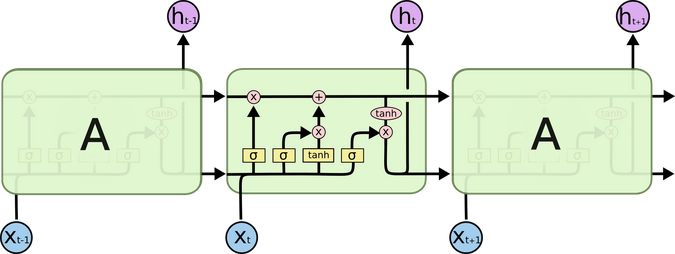


Модель `LSTM` обрабатывает последовательность пошагово, и её внутреннее скрытое состояние $h_t$ вместе с состоянием $c_t$ служит формой памяти. На каждом шаге сеть с помощью входного, выходного и забывающего гейтов решает, какую информацию сохранить, какую забыть и что добавить.

Обновления `LSTM` имеют вид:
$$
\begin{aligned}
c_t &= f_t \odot c_{t-1} + i_t \odot \tilde{c}_t, \\
h_t &= o_t \odot \tanh(c_t).
\end{aligned}
$$
где $f_t$, $i_t$, $o_t$ — гейты, а $\tilde{c}_t$ — вектор кандидат.

Несмотря на устойчивость к исчезающим градиентам, `LSTM` остаётся `точечной памятью`. Каждое обновление лишь локально модифицирует состояния $c_t$ и $h_t$ на основе текущего входа $x_t$. Даже используя механизм забывания, модель не стремится к `оптимальному представлению всей истории`:
$$
x_{1:t} = (x_1, x_2, \ldots, x_t),
$$
а только формирует её сжатый след в $c_t$, постепенно перезаписывая самые старые компоненты.

Это приводит к ряду ограничений:

- отсутствует контроль над тем, какие части прошлых данных наиболее важны;
- история не распределяется по координатам состояния системным образом;
- скрытое состояние не является оптимальной аппроксимацией входного сигнала как функции времени $x(\tau), \qquad \tau \in [0, t]$, а лишь результатом последовательного пошагового обновления.

### Можно ли разработать динамическую систему, которая `оптимально` удерживает историю входов?  

То есть обновляет состояние $z_t$, так, чтобы оно на каждом шаге оставалось наилучшим приближением всей предыдущей последовательности. Да, такую динамическую систему можно построить, если рассматривать задачу удержания истории как задачу `оптимального представления функции` на бегущем интервале времени. Пусть входной сигнал $u(t)$ --- это функция, чью историю необходимо сохранять максимально точно при фиксированном размере скрытого состояния.

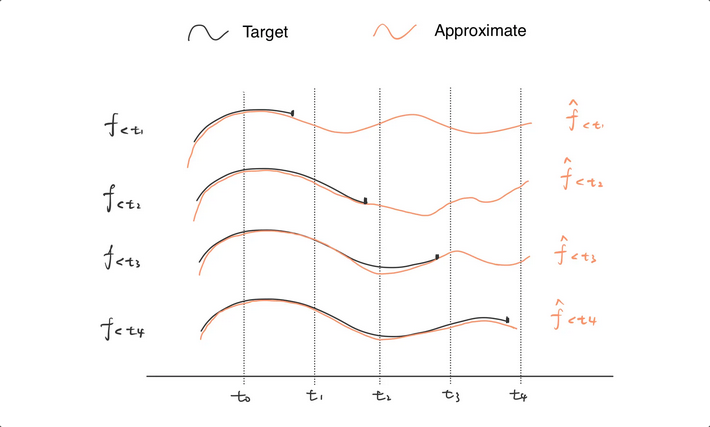


#### Полиномы Лежандра

Полиномы Лежандра образуют один из наиболее важных ортогональных базисов на интервале $[-1,\, 1]$, и широко применяются при аппроксимации функций, в численных методах и в моделях состояний. Их ключевое свойство — `ортогональность с весом $1$`:

$$
\int_{-1}^{1} P_m(x)\,P_n(x)\,dx =
\begin{cases}
0, & m \ne n, \\
\dfrac{2}{2n+1}, & m = n.
\end{cases}
$$

Благодаря этому свойству они естественным образом используются для разложений вида
$$
f(x) \approx \sum_{n=0}^{N} c_n\, P_n(x),
$$
$$ 
c_n = \frac{2n+1}{2}
\int_{-1}^{1} f(x)\,P_n(x)\,dx.
$$

Полиномы Лежандра дают оптимальную в смысле наименьших квадратов аппроксимацию функции на заданном интервале. 

In [2]:
# -------------------------------------------
# 1. Исходная функция
# -------------------------------------------
def f(x):
    return np.sin(5 * x) + 0.5 * np.cos(12 * x) + 0.2 * np.sin(30 * x)   # можно заменить на sin(pi x) или любую другую

# -------------------------------------------
# 2. Сетка
# -------------------------------------------
x = np.linspace(-1, 1, 400)
y_true = f(x)

# -------------------------------------------
# 3. Диапазон степеней полиномов
# -------------------------------------------
max_degree = 20
degrees = list(range(1, max_degree + 1))

# -------------------------------------------
# 4. Предвычисляем аппроксимации
# -------------------------------------------
approximations = {}
errors = {}

for deg in degrees:
    coeffs = L.legfit(x, y_true, deg)
    y_approx = L.legval(x, coeffs)
    approximations[deg] = y_approx
    errors[deg] = y_true - y_approx


# -------------------------------------------
# 5. Создаём субплоты
# -------------------------------------------
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.08,
    subplot_titles=[
        "Исходная функция f(x)",
        "Аппроксимация полиномом Лежандра",
        "Ошибка аппроксимации f(x) - P_n(x)"
    ]
)

# --- Статическая линия: исходная функция ---
fig.add_trace(
    go.Scatter(x=x, y=y_true, mode="lines", name="f(x)", line=dict(width=3)),
    row=1, col=1
)

# --- Две пустые кривые, которые будут обновляться slider’ом ---
approx_curve = go.Scatter(x=x, y=approximations[1], mode="lines", name="Аппроксимация (n=1)")
error_curve  = go.Scatter(x=x, y=errors[1], mode="lines", name="Ошибка (n=1)")

fig.add_trace(approx_curve, row=2, col=1)
fig.add_trace(error_curve,  row=3, col=1)

# -------------------------------------------
# 6. Готовим slider
# -------------------------------------------
steps = []
for deg in degrees:
    step = dict(
        method="update",
        args=[
            {
                "y": [
                    y_true,                   # subplot 1 (не меняется)
                    approximations[deg],      # subplot 2
                    errors[deg]               # subplot 3
                ]
            },
            {
                "title": f"Аппроксимация полиномами Лежандра (степень {deg})"
            }
        ],
        label=str(deg)
    )
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Степень полинома: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    height=900,
    width=900,
    title="Аппроксимация функции полиномами Лежандра с интерактивным slider’ом",
    showlegend=False
)

fig.update_xaxes(title_text="x"     , row=3, col=1)
fig.update_yaxes(title_text="f(x)"  , row=1, col=1)
fig.update_yaxes(title_text="P_n(x)", row=2, col=1)
fig.update_yaxes(title_text="Ошибка", row=3, col=1)

fig.show()

NameError: name 'np' is not defined

#### Онлайн аппроксимация непрерывной функции

Когда входной сигнал наблюдается последовательно во времени, удобно рассматривать 
накопленную историю 

$$f_{<t}(x),$$

как функцию, определённую на полуоси $x \in [0,\infty)$, где большие значения $x$ соответствуют более ранним моментам времени. Чтобы компактно представлять эту историю, разложим её по ортонормированному базису $\{e_i(x)\}$, определённому относительно меры $\mu$. Тогда коэффициенты разложения имеют вид

$$
c_i(t) = \langle f_{<t}(x),\, e_i(x) \rangle_{\mu} = \int_{0}^{\infty} f_{<t}(x)\, e_i(x)\, d\mu(x).
$$

Эти коэффициенты $c_i(t)$ полностью описывают текущее приближённое представление всей истории входного сигнала. 
Однако поскольку история постоянно обновляется при поступлении каждого нового значения $f(t)$, , мы будем использовать `модифицированные` полиномы Лежандра (со сдвигом/масштабом), а также опишем правило
обновления коэффициентов $c_i(t)$ в режиме реального времени. 

$$
\int_{}^{} P_m(x)\,P_n(x)\, \dfrac{1}{t} \mathbf{1}_{[0,t]}(x) dx =
\begin{cases}
0, & m \ne n, \\
\dfrac{2}{2n+1}, & m = n.
\end{cases}
$$

Рассмотрим, как меняется функция истории при переходе от момента $t$ к $t + dt$.
Геометрически этот процесс включает два шага:

- Сжатие истории. Переход от $f_{<t}$ к $f_{<t+dt}$ соответствует масштабированию аргумента функции, так что вся предыдущая история `отодвигается` от нулевой точки.
- Добавление нового входа. Новое значение $f(t)$ добавляется к функции истории в точке $x = 0$, внося вклад в проекции на базис.

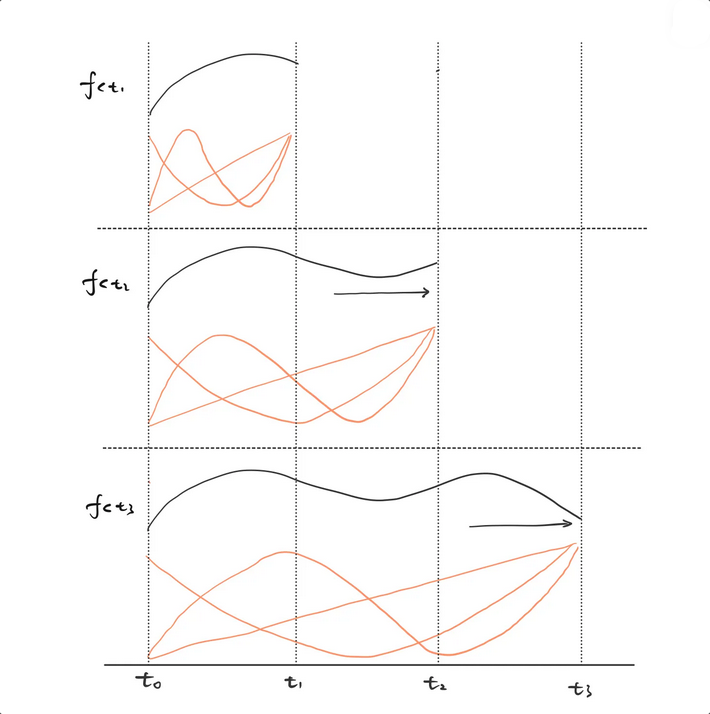


Такое преобразование индуцирует линейную динамику на коэффициентах разложения, которая принимает вид системы дифференциальных уравнений:
$$
\frac{d}{dt} c(t) = -\frac{1}{t} A\, c(t) + \frac{1}{t} B\, f(t),
$$
где матрицы $A$ и $B$ зависят только от выбранного ортогонального базиса $\{e_i(x)\}$.], для `модифицированных` полиномов Лежандра имеют следующий вид:

$$
A_{nk} = \begin{cases}
&(2n+1)^{1/2}(2k+1)^{1/2} \quad &\text{if}\;\; n >k \\
&n+1 \quad &\text{if}\;\; n =k \\
&0 &\text{if}\;\; n < k
\end{cases}
$$

$$
B_n = \sqrt{2n+1}.
$$

### HiPPO-LegS: онлайн-аппроксимация истории функцией Лежандра

#### Общая формулировка `HIPPO`

Рассматриваем входной сигнал $f(t)$. `HiPPO-LegS` хранит историю $f_{\le t}$ в виде коэффициентов разложения по полиномам Лежандра:

$$
f_{\le t}(x) \approx \sum_{n=0}^{N-1} c_n(t)\, P_n(x).
$$

Коэффициенты $c_n(t)$ для меры `LegS` (равномерный вес на $[0,t]$) удовлетворяют
`HiPPO-LegS ODE`:

$$
\frac{d}{dt} c(t) = - \frac{1}{t} A\,c(t) + \frac{1}{t} B\,f(t),
$$

где $A \in \mathbb{R}^{N\times N}, B \in \mathbb{R}^N$ заданы как

$$
A_{nk} =
\begin{cases}
\sqrt{(2n+1)(2k+1)}, & n > k, \\
n+1, & n = k, \\
0, & n < k,
\end{cases}
\qquad
B_n = \sqrt{2n+1},\quad n,k = 0,\dots,N-1.
$$

Дискретизация (Эйлер) при шагах $t = 1,2,\dots$ даёт рекуррентность:

$$
c_{k+1}
=
\Bigl(I - \frac{1}{k} A\Bigr)c_k + \frac{1}{k} B f_k,
$$

которую мы и реализуем для онлайн-обновления памяти.


#### Результаты работы `HIPPO`

Представленная визуализация иллюстрирует работу `HiPPO`, как механизма непрерывного проективного кодирования входного сигнала $f(t)$ в пространство ортонормированных базисных функций. На графике показано, каким образом при последовательном поступлении данных происходит онлайн-обновление скрытого состояния $c(t)$. По мере продвижения временного индекса вертикальная линия маркирует текущий момент вычислений, а реконструкция сигнала формируется на основе частичной суммы базисных разложений, отражая текущую степень соответствия проекции исходной функции.

Дополнительная кривая меры демонстрирует весовую структуру `HiPPO`: она определяет распределение значимости различных участков исторического окна при формировании состояния $c(t)$. 

Эта эволюция коэффициентов демонстрирует центральный принцип `HiPPO`: реализация минимальной ошибки проекции в реальном времени при одновременном сохранении глобальной информации о форме сигнала, что делает операторы HiPPO фундаментальной основой современных `SSM`-архитектур, включая `S4` и `Mamba`.

<p align="center">
  <img src="s4_operator_legs_reconstruction.gif" width="1200">
</p>


<p align="center">
  <img src="s4_operator_legs_updates.gif" width="1200">
</p>

### Сравнение реккурентных моделей и `HIPPO-LegS`

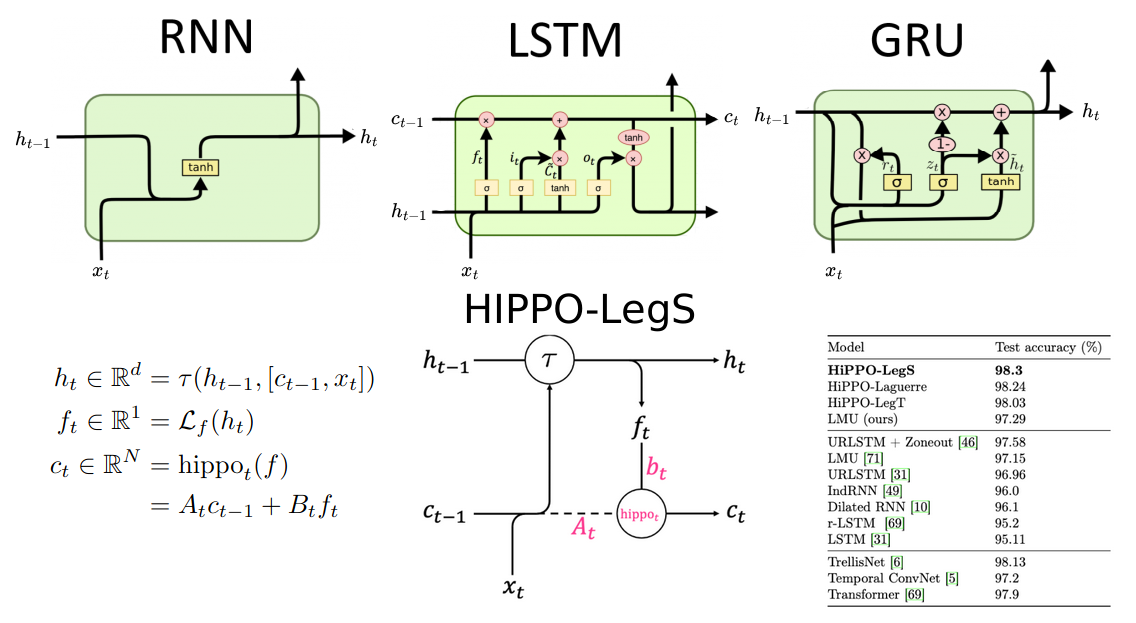

### Общие выводы

`HIPPO` — это механизм оптимальной долгосрочной памяти: способ хранить всю историю входного сигнала в сжатом виде с помощью коэффициентов разложения по ортогональным полиномам.

Механизм задаёт специальную `SSM`-динамику, которая онлайн обновляет эти коэффициенты, обеспечивая: 

- структурированную и устойчивую память без взрыва/исчезновения градиентов, 
- многомасштабные описание зависимостей (от быстрых до очень длинных),

`HIPPO` служит фундаментом `S4` и `Mamba`, делая возможным обработку очень длинных последовательностей.

## Модель пространства состояний (State Space Model, SSM)

`Модель пространства состояний (State Space Model, SSM)` — это математическая модель, описывающая, как система эволюционирует во времени через внутреннее (скрытое) состояние, которое обновляется и используется для генерации выходных данных.

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABTgAAAGACAIAAAAGXZqnAABHNElEQVR4Xu3dX5Ac1Xn3cVJJ+TKV
3CQ3uXjvUpWLlCsXS4z4Y1DwytggzK7AIAEDqSQqtBWCI+F1QLEU72JbCrLWjkwCHuTEdqGVE9sK
jIxEWX/G8SbehQkIsSSD0IKEZswKax2NYHE2MO/jbdP0Pr3T090zffp0z/dTpyg03dPTMzvSeX57
Tp++qAkAAAAAAKxxkX4AAAAAAACkh6AOAAAAAIBFCOoAAAAAAFiEoA4AAAAAgEUI6gAAAAAAWISg
DgAAAACARQjqAAAAAABYhKAOAAAAAIBFCOoAAAAAAFiEoA4AAAAAgEUI6gAAAAAAWISgDgAAAACA
RQjqAAAAAABYhKAOAAAAAIBFCOoAAAAAAFiEoA4AAAAAgEUI6gAAAAAAWISgDmTV+fPnn3766cce
e2zr1q1r165dvXp1HwAAyDXp7tevX79p0yYpAJ555hldHADIC4I6kDGSz48cOSKd9MqVK3XvDQAA
eokUAxLaH3/8cV0uAMg4gjqQGRLRH374YfI5AABQVq9evXXr1lqtpqsHANlEUAcygIgOAADCkIKB
uA7kAEEdsN2RI0e4/hwAAIQkZQOT4YGsI6gD9jp//vyOHTt09wsAANCOlBBSSOjaAkBGENQBS9Vq
tbVr1+peFwAAIJzVq1czDR7IKII6YCPpVpnuDgAAOkRWBzKKoA5Yh5QOAAC6hawOZBFBHbALKR0A
AHQXWR3IHII6YJHz58+T0gEAQNetXbuWteWADCGoAxZhjXcAAJAQKTN05QHAVgR1wBZPPPGE7lEB
AAC658iRI7r+AGAlgjpgBS5NBwAASVu5ciUT4IFMIKgDVnj44Yd1XwoAANBtUnLoKgSAfQjqQPpq
tZruRQEAABLAoDqQCQR1IH1bt27VvSgAAEAyGFQH7EdQB9LH1ekAAMAYBtUB+xHUgZSx2DsAADCM
5d8ByxHUgZRt3LhRd54AAABJWr9+va5IANiEoA6kbOXKlbrzBAAASBKz3wHLEdSBND399NO65wQA
AEjeM888o+sSANYgqANpeuyxx3S3CQAAkDwpQnRdAsAaBHUgTVygDgAAUrF161ZdlwCwBkEdSNP6
9et1twkAAJC8devW6boEgDUI6kCauIM6AABIhRQhui4BYA2COpAm3WcCAACYousSANYgqANp0h0m
AACAKbouAWANgjqQJt1hAgAAmKLrEgDWIKgDadIdJgAAgCm6LgFgDYI6kCbdYQIAAJii6xIA1iCo
A2nSHSYAAIApui4BYA2COpAm3WECAACYousSANYgqANp0h0mAACAKbouAWANgjqQJt1hAgAAmKLr
EgDWIKgDadIdJgAAgCm6LkGXnKvNHy/PTu2vHSie3DMy/fXhYzsKk6ODE9I2rjjkbff3l2XTQ0OV
fTur5fFTL1fm9LHQqwjqQJp0hwkAAGCKrksQ13xjQWK5hG2J3JK9VRqP1OTpcpCpUu1cfV6/DHoJ
QR1Ik+4wAQAATNF1CSI6UZmTcO4fJ+9W+/rwMcbYexZBHUiT7jABAABM0XUJwnHyeYcj5+Hb6MDE
VKmmTwJ5R1AH0qQ7TAAAAFN0XYJA842Fg8WTOwqT/ixtoElcP350Vp8T8ougDqRJd5gAAACm6LoE
LTgR3dgQekDbMzLNtes9gqAOpEl3mAAAAKbougQ+9kR0tzETvkcQ1IE06Q4TAADAFF2XYKkTlTlJ
xf6obEM7WDypTxf5QlAH0qQ7TAAAAFN0XYL3zDcWdg8f88djq9qOwiTT4HOMoA6kSXeYAAAApui6
BItsHkhXTc6TrJ5XBHUgTbrDBAAAMEXXJWg2DxRn/HnY5ra5v3ym2tBvA9mXn6A+X6vNlsu1/ftP
FovTIyPHhocnC4WJwUFph1as8LZyf79sqgwNVXfuPDU+Plep6GMBpugOEwAAwBRdl/S2+cbCntFp
fxK2v5HVcynDQX2h0ZBYLmFbIrdkb5XGIzV5uhykVirN1+v6ZYAk6Q4TAADAFF2X9DBJ6TtuT+cG
6V1pZPX8yV5Qn6tUJJz7x8m71Y4NDzPGDmN0hwkAAGCKrkt61bn6fFYuSg9oZPWcyUxQd/J5hyPn
4dvEwECtVNInAXSb7jABAABM0XVJT5pvLOQgpTtNsjpry+WG7UF9odE4WSxOFgr+LG2gSVyfPXpU
nxPQPbrDBAAAMEXXJT0p0zPe/Y114HPD3qDuRHRjQ+gBbXpkhGvXkRDdYQIAAJii65Les2+s6s+6
XWn3ryrvKEzuGZkuj5+e2l87UZk7V5uXNt9Y8J7AmWrj+fLZfTursrP/IPGaHMr7EsgoG4O6PRHd
bcyER0J0hwkAAGCKrkt6TNfvxCbhXJK5xHIJ5PrFQjhXn5en+w8bo+0bq+qjI2usC+pzlYqkYn9U
tqGdLBb16QKd0R0mAACAKbou6SUnKnP+fBuvST7ft7MqB9SvEUu34voPx0/pQyNTLArqC43GseFh
fzy2qk0WCkyDRxfpDhMAAMAUXZf0jG4t8z46OFEeP61ms3fFL85wsKMzZBH4rLMlqNs8kK6anCdZ
Hd2iO0wAAABTdF3SMzofsr5/VXmqlGwieKux0OF5jg5MvJXALxFghhVBfaZY9Odhm1u5v79R5cIP
dIHuMAEAAEzRdUlvmCrV/Jk2Uts3Vk1iFH1ZHV5Iz8Xq2ZVyUF9oNKZHR/1J2P5GVkdX6A4TAADA
FF2X9IZOJr2PDk5061r08DrM6sfLs/qIyII0g7qk9Mnbb/dn4Kw0sjo6pztMAAAAU3Rd0gM6Cb07
CpNp3aK8k9Pe3F9O67TRidSC+ny9npWL0gMaWR0d0h0mAACAKbouybtO1pB7aKhibLr7sjrJ6nLy
+nCwXjpBfaHRyEFKd5pkddaWQ2y6wwQAADBF1yV5F3ttNkuCbidZfapU04eD3dIJ6pme8e5vrAOP
2HSHCQAAYIquS3LtXH3eH1/DtNHBiXTH0r32jMb8XcPm/jIrwGdLCkG9Ojbmz7pdaeVVqyYLhemR
kdPj47X9++cqlflaTdpCY8ktBBvV6tlyubpzp+zsP0i8JofyvgQQku4wAQAATNF1Sa7FG46WlG7V
Bd4StmPfX33PyLQ+HCxmOqh3/U5sEs4lmUssl0CuXyyE+Xpdnu4/bIxWHRvTRwfa0R0mAACAKbou
ybV4V6cfP3pWHyht5+rzm/vL/lMN0142vmQ9YjMa1OcqFX++jdckn1d37pQD6teIpVtx/dT4uD40
EEh3mAAAAKbouiS/4t073dqbkD9fPus/2zBtdGCCCfBZYS6od2uZ94nBwdPj42o2e1f84gwHB/2v
GL6xCDyi0h0mAACAKbouya+vDlX8qTW42TbpXfneWNV/zmHaweJJfSxYyVxQ73zIurxqVb1U0sft
Ksn/HZ7nxMBAEr9EQF7pDhMAAMAUXZfkVLxl5KZKVq8VHftidW6rnhWGgnqtVPJn2kitOjZmLAB3
eCE9F6sjPN1hAgAAmKLrkpwqj5/259XgJhlYH8U+Jypz/jMP074+fEwfC/YxFNQ7mfQ+MTjYrWvR
w+swq8+Wy/qIwHJ0hwkAAGCKrkty6sHCpD+sBjfLh9NdsSfAs6qc/UwE9U5C72ShkNYtyjs57XJ/
f1qnjWzRHSYAAIApui7Joxjz3jMxnO6IPQH+oSHT46CIKvGg3skacpWhIWPT3ZfVSVaXk9eHA3x0
hwkAAGCKrkvyKMZ671kZTnfEngD/w/FT+liwSeJBPfbabJYE3U6yei3hpe+QA7rDBAAAMEXXJXkU
Y733zK21Fm8C/Ob+Mrdqs1myQX2+XvfH1zBtYnAw3bF0r+nRUf8Zhmnl/n573gXspDtMAAAAU3Rd
kkcSR/0ZNaBlcU645O2ob9Np3KrNZskG9XjD0ZLSrbrAW8J27PurT4+M6MMBHrrDBAAAMEXXJbkT
Y1p4tua9u2KsbL+RQXW7JRvU412dfvboUX2gtM3X6+X+fv+phmnml6xHhugOEwAAwBRdl+ROjPia
uXnvrhiT/KXtGZnWB4IdEgzq8e6dbu1NyM+Wy/6zDdMmBgaYAI9WdIcJAABgiq5Lcmf38DF/NA1o
WZz37ooxfcBp3KrNTgkG9crQkD+1BjfbJr0r1bEx/zmHaSeLRX0sYJHuMAEAAEzRdUnuRL2D+r6x
qj5EpsRbVS7Tv55I1HxjYWp/7UDxpLTj5VnDsy2SCurxlpGr271MeuyL1bmtOlrRHSYAAIApui7J
l7caC/5QGtyyPrYce1W5rL/xrpNM/tBylxLsGZk2FteTCuqnx8f9eTW4SQbWR7HPXKXiP/Mw7djw
sD4WQFAHAADp0XVJvsSYCp6DldUOFGf876ttY1Dda6pUv7/17zs295fNrDiYVFCfLBT8YTW4WT6c
7oo9AZ5V5eCnO0wAAABTdF2SL1FXkttRmNSHyKC3GgujgxP+d9e2MajuCPn7HQMfVyJBPca890wM
pztiT4CvDA3pY6Hn6Q4TAADAFF2X5EvUC7a/PnxMHyKbpkp1/7tr20YHJvSBepJ8Dv4Px99kt6Tn
XyQS1GOs956V4XRH7Anwp8bH9bHQ23SHCQAAYIquS/Il6pLvB4on9SEyK96t2n44fkofqMdMlWr+
j6VVKyf8cSUS1GOs9565tdbiTYAv9/dzqzZ46Q4TAADAFF2X5EvUJd+PHz2rD5FZIedvq7a5v5z0
KLHlIv2CI+kL+xMJ6hJH/Rk1oGVxTrjk7ahv02ncqg1eusMEAAAwRdcl+RJ1/fNaNVfDaZEyp9sO
5mhaQQyRvjOys35+V3U/qMeYFp6tee+uGCvbH2JQHUvpDhMAAMAUXZfkiz9ZBbecDSafqTb877Ft
6/FBdf8HEtz087uq+0E9RnzN3Lx3V4xJ/tKmR0b0gdCrdIcJAABgiq5L8sWq0dFU7BmZ9r/Ttq1n
B9XP1ef9n0Zw04foqu4H9WPDw/5oGtCyOO/dFWP6gNO4VRscusMEAAAwRdcl+RJp7nfS1xun4q3G
QqTfVjhNniKRVR+rB0S9sD/pdfK7H9Sj3kG9OjamD5Ep8VaVy/SvJxK10GjU9u8/WSxKmy2Xszvb
IiTdYQIAAJii65J8iXQf9alSPmvOA8UZ/5tt2/aMTOsD9YBIX5iNyf9yp8tBXVKWP5QGt6yPLcde
VS7rb7zrJJMveynB9MhIjuO67jABAABM0XVJvrzVWBgdDHdP7MFkh0ZTFG9QXdrLlTl9rLyLeqXA
14eP6UN0VZeDeoyp4DlYWW2mWPS/r7aNQXWveqkU8PsO2ZTRFQfb0h0mAACAKbouyZ2Qk5nPvJT5
PBIg3qB60sPFFop6P78DCV/M3+WgHnUluclCQR8igxYajYnBQf+7a9sYVHeE/P1OLj8u3WECAACY
ouuSPHq+fDZgSPn+VeW8Tnp3MagehnxK/k8guCX9+XQ5qEe9YPvY8LA+RDbVSyX/u2vbJgYG9IF6
knwO/g/H32S3HMy/UHSHCQAAYIquS3LqXH1+2VnNDw1VemTVtKlS3f/227aeGlR/vjzr/wSCW9L3
setyUI+65PvJYlEfIrOWvb66bTs1Pq4P1GNqUX7Hkb+PS3eYAAAApui6JNckkz9fPnugeFLa1P7a
fMIpyzYhL9dXbapU0wfKqWV/lRPQDKxr0OWgHnXJ97NHj+pDZFbI+duqlfv78zdKHEmkX3Dk78J+
3WECAACYousS5FfIy/VV29xfTnrc2BKjA9F+kZH0SnLNrgf1gPXAlm2NalUfIssiZU635WlaQQyR
vjOys35+xukOEwAAwBRdlyDXIt1Y3m0HE14yzQZnXmr433hwK4+f0kfpti4HdX+yCm45G0xuVKv+
99i29figuv8DCW76+RmnO0wAAABTdF2CXIs9qJ77K/mj3kFdWq2aeHzrclDv8dFRMT0y4n+nbVvP
DqrP1+v+TyO46UNknO4wAQAATNF1CfIu3qC6gWne6Yo6793ABerNrgf1SHO/83e9cXPxVm2Rflvh
NHmKRFZ9rB4Q9cL+/K2TrztMAAAAU3Rdgrw7V5/3x84wLelbkaUoxrz3PSPT+igJ6HJQj3Qf9Xqp
pJ+fCzPFov/Ntm3TIyP6QD0g0hfmUB5/uaM7TAAAAFN0XYIe8L2xqj95tm07CpP6QHkRdb13aceP
ntVHSUCXg/pCozExOOjPV/4mu+kn50W8QXVpc5UeulehI+qVAseGh/UhMk53mAAAAKbougQ94K3G
wub+sj98tm0/TH75tFREnfe+Mfk7qDu6HNSboSczN156ST8zR+INqudvuLitqPfzy9/F/LrDBAAA
MEXXJegNB4oz/vDZtuVyVbmpUs3/ToObsSv2ux/UxdlyOWBIubxqVV4nvbsYVA9DPiX/JxDc8vf5
6A4TAADAFF2XoDe81VgYHYw8jLzRYEY15sHCpP9tBrepkqGVxRIJ6s3F1byXndVcGRrqkVXT6qWS
/+23bT01qD5bLvs/geCWv/vY6Q4TAADY6sMf/vC6detWrFihN2SWrkvQM54vn/VH0DAtT6vKxbtf
nZl5783kgrpDMvnZcvlksSittn9//lJWsJCX66tWy/t0A9eyv8oJaLlc10B3mADCufjii/VDAICI
dF2CXhLvVm2jAxPGkmrSYiwjZ2a9d0eyQb3HhbxcX7Vyf3+P/EZjYmDA//YDWv5WkmsS1AEAQHp0
XYJeEm88Wdq+sao+VgbFu1OdyQkFBPVkRbqxvNvyt2SaX+Oll/xvPLidGh/XR8k+3WECAACYousS
9Jh4t2rbaDavJiTGhILRwQl9lCQR1JMVe1A991fyR72DurRGNQ+/vVN0hwkAAGCKrkvQY2Lfqi3r
E+DjXaJvbBk5B0E9cfEG1XM5zdsr6rz3XF6g3iSoAwCA9Oi6BL2nPH7an0jDtD2j5q7W7roY906X
ZvjudAT1xM3X6/7YGabl71Zkrhjz3qdHRvRRckF3mAAAAKbougQ9KcYkcKf9cPyUPlYWxPvdhMll
5BwEdROqY2P+5Nm2TRYK+kB5EXW9d2lnjx7VR8kF3WECAACYousS9KTYq8pt7i8bHmTunJzw/bFm
+5t/pwR1ExYajXJ/vz98tm25XD6tGX3e+6E83kHdoTtMAAAAU3Rdgl4Ve1W5HYXJbF2s/lCs6QPm
h9ObBHVjZopFf/hs23K5qlytVPK/0+CW4yv2dYcJAABgiq5L0KskbI8Oxrlse2OmLlY/UJzxn3+Y
Zn44vUlQN2ah0ZgYHPRH0LYtfxl1slDwv83gVi+V9FHyQneYAAAApui6BD0s9gT4jRm5WD3ejdM3
pjSc3iSom3S2XPZH0DAtT6vKxbtfXV7nvTcJ6gAAID26LkFviz0BXtrx8qw+nE0kpcdb6X1jSsPp
TYK6YfFu1TYxMJCbpBpjGbm8rvfu0B0mAACAKbouQW/rZAL85v7ymaq9gWXH7ZP+cw7T0hpObxLU
DYs3niytOjamj5VB8e5Ul6cJBX66wwQAADBF1yXoeZ1MgB8dmEhr8DnYntFp/9mGaaODab4jgrpp
8W7VdigXeTXGhIKJwUF9lHzRHSYAAIApui4BOpsAb2FWj53SpU2V0lzVm6BuWuxbtWV9Any8S/Rz
vIycQ3eYAAAApui6BOhsAvxGy7J6JyldPgR9OLMI6ik4PT7uT6Rh2vToqD5WdsS4d7q0/N2dTtEd
JgAAgCm6LgEWnak2NveX/dk1ZLMhq883FuLdMt1tqb8Fgno6YkwCd9qp8XF9rCyI97uJfC8j59Ad
JgAAgCm6LgHeUx4/7c+u4Zvk/BTXge9kjXenHSye1Ac1jqCejtirypX7+zM3yCwnHG+2f+beaQy6
wwQAADBF1yWARycXqzstlbg7Varf38F0AGk7CpP6oGkgqKcm9qpyk4VCti5Wjzd9oBeG05sEdQAA
kB5dlwAebzUWJLL6c2yktmdk2tgc8vnGwu7hY/5ziNTSXendi6CeGgnbE4OD/oAapmXoYvWZYtF/
/mFaLwynNwnqAAAgPbouAZb6xRzyDhaWc9rowMRUqaYP3VUS0Q8WT3Y4kO6040fP6qOnhKCeptgT
4A9l5GL1eDdOP9Qzw+lNgjoAAEiPrksAnzPVhj/NxmgPDVWSGKnuYkTfmNJc/VYI6imLPQFe2my5
rA9nE0np8VZ6P9Qzw+lNgjoAAEiPrkuA5Uztr/szbby2Z2T65cqcfoFYTlTmuhjRpe0ZndavkSqC
eso6mQBf7u9vVKv6iNaYvP12/zmHab0znN4kqAMAgPTougRo4UBxxp9sYzdnMnyMAfb5xoKTzzu8
9Zq/7ShMysH166WKoJ6+TibATwwM2Dn4PD066j/bMG1icNDOd5QQ3WECAACYousSoLXuZnWnSWLf
MzJdHj/1cmXuTLXhjcry/+dq8/Lg8fKs7LBvZ1WydBfHz73NngXkvAjqVuhkAryFWT12SpdWL5X0
4XJNd5gAAACm6LoECJREVk+92ZnSmwR1S3QyAf6QZVm9k5QuH4I+XN7pDhMAMuLiiy++5pprbrrp
Jr0BQHbougRoJ2dZ3dqU3iSo26NRrZb7+/3ZNWSzIasvNBrxbpnuttTfgnm6wwQAADBF1yVACLnJ
6jan9CZB3Sqnx8f92TV8k5yf4jrwnazx7rSTxaI+aA/QHSYAAIApui4BwslBVn9oqGLb6nEKQd0u
nVys7rRU4m69VOpkOoC0yUJBH7Q36A4TAADAFF2XAKGVx0/7029W2r4xe++c5SKo22Wh0ZDI6s+x
kdr0yIixOeRywseGh/3nEKn12krvXrrDBAAAMEXXJUAUZ6qN0cEJfwy2ud2/qlweP63fiZUI6tb5
xRzyDhaWc9rEwEAt4eXTJaKfLBY7HEh32tmjR/XRe4buMAEAAEzRdQkQ0bn6/I7CpD8P29lGByfO
vNTQ78FWBHUbNapVf5qN0SpDQ0mMVHcxoh9Kaa6+PXSHCQAAYIquS4BYMnHJ+r6xquUXpSsEdUvV
9+/3Z9p4bXpkZK5S0S8QixynixFd2vToqH6NHqM7TAAAAFN0XQLEda4+b+00+B2FyROVOX3G1iOo
22umWPQn29jNmQwfY4B9odFw8nmHt17zt8lCQQ6uX6/H6A7TMp/85Cf1QwAAIC90XQJ0xrah9Qxd
ke5HULdad7O60ySxT4+MnBofl/jdqFa9UVn+f75Wkwdny2XZobpzp2TpLo6fe1svLyDnpTtMy1x1
1VX6IQAAkBe6LgE6dq4+v2dk2p+ZDTeJ6AeKM9ma664Q1G2XRFZPvZHSXbrDBAAAMEXXJUCXpBjX
cxDRHQT1DMhZViele+kOEwAAwBRdlwBdZTiuPzRUyeK16K0Q1LMhN1mdlK7oDhMAAMAUXZcACZC4
PlWqf3Wo4o/Wnbf7V5Uln5fHT+dgCF0hqGdGDrJ6ZWiI1eMU3WECAACYousSIElOYt8zMt3h+vBO
ON+3s3qiMpe/fO4iqGfJ6fFxf/rNSquOjen3A4I6AABIj65LAFMktEvMPlA8Kbn9q0OVHYVJf3qX
R6TJpt3DxySWl8dPP18+e642r4+VUwT1jGlUqxODg/4YbHMrr1p1enxcvxMs0h0mAACAKbouAWAN
gnr2zNfrk4WCPw/b2SYGBxsvvaTfA96jO0wAAABTdF0CwBoE9azKxCXr1bExLkoPpjtMAAAAU3Rd
AsAaBPUMm6/XrZ0GP1kozFUq+ozhoztMAAAAU3RdAsAaBPXMs21onSvSI9EdJgAAgCm6LgFgDYJ6
HszX69MjI/7MbLhJRJ8pFpnrHonuMAEAAEzRdQkAaxDU8yPFuE5Ej013mAAAAKbougSANQjqeWM4
rleGhrgWvRO6wwQAADBF1yUArEFQzyeJ6/VSSVK0P1p33sqrVsmRT4+PM4TeOd1hAgAAmKLrEgDW
IKjnnJPYp0dGOlwf3gnn1Z075yoV8nkX6Q4TAADAFF2XALAGQb2HSGiXmH2yWJTcLql7slDwp3d5
RJpsOjY8LLH89Pj42XJ5vlbTx0KX6A4TAADAFF2XALAGQR1Ik+4wAQAATNF1CQBrENSBNOkOEwAA
wBRdlwCwBkEdSJPuMAEAAEzRdQkAaxDUgTTpDhMAAMAUXZcAsAZBHUiT7jABAABM0XUJAGsQ1IE0
6Q4TAADAFF2XALAGQR1Ik+4wAQAATNF1CQBrENSBNOkOEwAAwBRdlwCwBkEdSJPuMAEAAEzRdQkA
axDUgTTpDhMAAMAUXZcAsAZBHUiT7jABAABM0XUJAGsQ1IE06Q4TAADAFF2XALAGQR1Ik+4wAQAA
TNF1CQBrENSBNOkOEwDSc+mll3784x93/v+KK6645pprlm7XZJ/rr79eP4pUXXvtte4PMdjVV189
ODioH03VRz/60Y985CP6USRJ1yUArEFQB9KkO0wk5u677z506NBTTz11+eWXex+/8cYbDy365Cc/
6X0c6EGrVq06e/bsDTfcIIl93759jzzyiN5jqSeffHL//v3uH2+++ebHH3/8+PHjMzMzTz/99De/
+c1bb73V2XTdddfdeeed7p5tRd1/WQHnY4OE/lGanJz8t3/7N/3ocv7+7//+rbfe0o+2Fvx5BmwN
/04feOCB1157bcWKFd7dkChdlwCwBkEdSJPuMJGY7du3ywf+zjvvfPazn/U+/q1vfUselE3r16/3
Pg70prGxsbfffvvdd9999tlnV65cqTd7FAoF+bszMDDg/PGee+6RP0pI+9rXvrZz5869e/eeOnVq
z549ztZHH3200Wi8/+R2ou7vF3w+NkjoH6WEgnrw5xm8Nfw7/dCHPlSr1b70pS95d0OivDVJ6p5/
/vm77777xRdf1BuAnkRQB9KkO0wkxqkU/+M//kOqWPdBKQp/+tOfTkxMNOPWxED+/OEf/uGll16q
H/U5ePDg008/7f5xenr6tddeU0Om/f39zv9EDd5R9/cLPh8bJPSPUkJBPfjzDN4a6Z1K1JesLl9C
9xEkyluT2OD222+/6KKLVq5c+S//8i8LCwt6M9BLCOpAmnSHicQ4leL999//7rvvXnfddc6Df/mX
f/m///u/W7ZsaS6tFP/kT/5ECsrz58+fO3fuqaee+sQnPuFucjz++OPPLHXVVVe5WwcGBiTDvPHG
G3IE2SRHczdJ9ameePjwYXfrF7/4Re8fA8ie6jgOt7p1DrVu3Tp5UE7jlVde+fznP+89QvB7HBwc
fPLJJ8+ePSs7vPTSS2NjYw888IB+sUWym/OU4Fe88cYb5UN79dVXJX2dPHnym9/85hVXXOFu9b/x
4eHhZzxvx38+fYuzZPXZLHJOyfsRHTly5B/+4R+uvvpq9/jB5+O37An0Rf8Y+9qddttj3nrrrd/+
9rd/9KMfuU+87bbbnE3BH6Ns/cEPfuBu+tjHPiYxW2KS+0jbHbykjJa/O/Je3EfkC3/06FHPLu+T
v331ev2dd95xTth9lVY/hVb79wX+5VICzqevs69rX4ufrCP8GYb/Ryn4K3HPPff813/9l5zqiy++
+Bd/8RcqqAecT6SgHvx5Bm8N/07FTTfdJI8MDQ25jyBRnpLECq+//vpv/MZvXLTod37ndz73uc/J
vwZ6J6A3ENSBNOkOE4lxKsWPf/zjp0+flszmPCiVumSAT33qU82lNbGUj88999x9993nlAg//elP
P/rRj75/rL6+l19++dlnnx1dtG/fPnm6uwCSVPBSEB8/fvyzn/3spk2b5CUWFhbuuOMOZ+uHPvQh
2VlKfOe5Erfk4O5hJQ94/xhA9rxw4YJzEIfU4nJkOb67g5TgP/nJTyRCSB0vqUO2uvNOg9+jpBQp
+uWDkugidf+DDz74r//6r4VCwXmhbdu2yaHkgM4fP/OZz4R5RanR5ZGtW7fefffdX/rSlyRvSGZw
NjnPVW98x44d7ttZ9nz6FqdeB5ySHFN+EM4jjzzyyNzcnPxQ3OMHn4/S6gRifIx97U47+Ji33HLL
z3/+c9kqR5OnyDe56Yk0wR+jbJ2dnXU3Sd6TTd6c1nYHL0lZsvXmm292H/nxj388Pz8vj7tfQtdt
t90mKU62fnbRvffe6zze6qfQav/gv1xKwPn0dfZ1bfWT7Yt4hiH/UQr+Stx5553vvPPOxMSEvNwD
Dzwwu8gN6sHnEymoB3+ewVtDvlPHxRdfLOf8jW98w30EiWra58tf/rIT1B0f+MAHbrrpph/+8Id6
PyDvCOpAmnSHicS4laKUiVIs9i2ueCzlr9ToqlKUilwqXXfqr1S6Ugd/61vfcg8lXn311e9+97vO
/0sF3PQEdQkYp06dcp8uRadUyRLInT9edtllsvMXv/hF54//+I//GDuoB0QyZwf5o2Q5dwepctwJ
pcHvUc5WYm2r65OvuOIKOfLf/M3fqMeDX1GReCM7uytIBb+d4PPpa3FKKnZK3JJ9Ws3oVuejtDqB
Tj7GvhanHXzMXbt2yR/d0V3Jyc1YQf2uu+6S48h3tVVQX3YHr4cffvjdd9/1prK1a9fK05uL2X5q
aurv/u7vVq9e7W4NM5Xd+1NYdv/gv1xK8Pl08nUN+MlGOsOQ/ygFfyX+/d///ZVXXnFPW1K9PNEN
6sHnEymoB3+ewVtDvlPXs88+672qAolq2uf//u//PvjBD3qzuuP3f//3H3rooQsXLugnADlFUAe6
r16vSwmiH12O7jCRGLdSvO666yRg/Omf/umDDz74xhtvSIHrrRRXrFghJYIU8d7nViqVarXqfURK
UnedJG9Ql9zy85//fN++fTd6fPvb3z5//ryzsxT3svPnPvc554/+oP6zn/1s3aJPfOITAUsfB0cy
Zwf5o3e+7n333SePXH/99cHvUbbKtzdgza1l42Vf4Cs6f/yjP/qjLVu2SDaQdy2fiWz69Kc/7T7X
feMO52jydtqeT1+LU5IjnDt3zjma5IETJ05IpPHuEHA+Xq1OoMOPsW+50w4+pvj85z/f9CRzf1Bv
9TE6W50cfskll8zMzHznO99ROa3tDl7//M//7A/S8o62bt164MABSbzyum+//fZf/dVfOZuWDd59
rX8K/v3b/uXyCzif2F/XgJ9s1DMM849S26/E/Pz81772Ne9WebNOUG97PgE/32UFfJ7BW8O8U/c4
fYu/Xzh58qT3ESSnuUi+7ToW24egjl5DUAe6T4L67/7u7w4PD0upobctpTtMJMatFOX/p6amHn/8
8f/+7/92yl9vpbhq1Sr5fwm93ud+//vfP3v2rPtHKS6ldJZywfmjN6g7T5etP/dxdr7hhhtkh02b
Njl/9Ad12ers31wcmyoWi+5Wr2+GCOoqHjhDbX/2Z38W/B6X3erlj5eOgFeU///zP/9zSRQS/558
8snvfve7TzzxRNMz09j7xh3yGTpvp+359LU4JfVhvv76696rXoPPx6vVCSz7ePiPsW+50172Wd6v
32WXXVYulyXqyNt55ZVXzpw501wa1Ft9jM5WJ4d/5StfkTwvQbRVUG+1g5fkPSmX9aMed9xxx09+
8hPZxwnD/uDdF/hT8O/f9i9XMHU+sb+uy/6MHFHPMMw/Ssu+nPuVuPrqq2WrWn7i2WefdYJ62/MJ
+Pm2pT7P4K1h3qn36fIlf/nll72PIDlN+zD1HXAQ1IFE7Nq1S3qXX/mVX5H8JhVtqwF23WEiMd5K
UQpu5yfizGX1VopOdlIjVBMTE6dOnXL/KM9qekZfvUHdefrDDz/s7qxIAJAd1q5d6/zRH9TdP0ok
k+PIznfffbe7gytMUH/nnXe8M5Odi4pvvPHG4Pd4+eWXSw7cvXu3d6uXP146Al5R/l9S5ZEjR9xN
znpR3qDe6u20PZ++Fqfkxs6+xTclH6acnntj5+Dz8Wp1Ah1+jH3LnXbwMV0Sw1599VX53jpXuUea
+v6xj31MspmzCNyyQT1gBy/n8njvj9tvbGxM9nGuiPYH777An4J//7Z/udrynk/sr2vATzbqGYb5
Ryn4K+H80lC6G+/WmZkZJ6i3PZ+An28Y3s/Tz7s1zDv1Pve5557zrg+PRDUtw2JygIugDiRCSsCL
L77Y/X3wb//2b0uue/nll9VuusNEYryVopTaP/7xj0ulkrNJVYpS5npXHbvqqqsuXLjw/e9/333k
K1/5ysLCgntRujeoi/9atOyVrmLPnj3nz5+/5JJLnD8GBHVxzTXXyJEffPBB9xFXcCRzdmguXTl5
7969b775pnO1avB7lPM/ceJEq7fgj5eOgFeUvwsSJ7wrYztXjIcJ6n3tzqevxSl5g3rf0g+z7fko
rU6gk4+xr8VpBx+zb/H7JidfKBT6lpv6HvAxOh/IU0899cILL8gn0OfLaW138LrnnnvkyLfccov7
iPutdkmabb634JwEe3cg1xH8U/Dv39fuL5cSfD6dfF0DfrKRzjDkP0rBX4lqterNtNddd52cvHuN
evD5BPx8/YI/z+CtId+pw1lMTv5tdB9BopqW4fZsgIugDiTlP//zP3/t137NzeoXLQ6wX3311VIO
ugPsusNEYryVoqIqxZGREfmjlIn9/f3XX3/9j370o3feece5A9aKFSvuvvtuKSKl0HSv+fzyl78s
+995552XXXZZ3+K6U+++++7BgwdlkxT9Ujf/9V//9c6dO+Wlv/GNb8gm7wCXP6jPzc05h73jjjue
fPJJeWknkinBkczZQUocKfHlzCUQSsaQ2PPoo486WwPeY997Q4sHDhwYHByUNyWl9he+8AVnU1+L
eNnX7hUlTki2GRgYkDL9vvvue+ONN5qhg3rw+fS1OCXnmM6HKT8d+TDlw//jP/5jZ2vw+SitTqCT
j7GvxWkHH/Paa6+Vr5/7FYoa1CXCydGkDna2+oN68A5eV155pfx8ve9IPs9/+qd/ku+tnPkNN9wg
f+NkB3nQyfyf+cxn5Ez+9m//VnZw433AT2HZ/Vv95XrvFJYIPp9Ovq4BP9lIZxjyH6Xgr8RnF39R
uGvXLgnw8jal33n77bfdoB58PurnK1vlyMtOFuhr93kGbw35Th3Ot3rDhg2evZCgpk2ef/556WRf
fPFFvQHoSQR15NP//M//zCz1wgsvHF5KyqyvLyVV2hYfKfELS33kIx/58FK/93u/9/+W+vVf/3Vv
RFf+4A/+4LXXXmsS1A2KVCl+9atflWLX+S6dO3dueHjYeVyKXc+3THNvUPzpT3/aO1VPjiB5Y3R0
VMpWOQ2ncnX4g7r7rDfffHN6etq7VpNXcCRzd3jggQekXHYO+IMf/MC75nmr9+iQ6l8edLZKoS9/
WdxNy8bLvnavKBX866+/7jw+Ozu7adOmZuig3hd4Pn0tTin4www+H79WJxD7Y+xrcdp9rY8p35yp
qanjx4+7H0vUoC7//53vfMfd6g/qwTso+/fvV/fYcz/S5uKsIomU1157rbNVzuF73/ue/Mssn4M7
0yHgp7Ds/n0t/nK5W72Cz6eTr2tf4E82/BmG/0ep1Veib/Fb8c3FafzNxfco/6/uox5wPurn63yd
5KzcR7zafp4BW8O/U1EsFs+cOeP9dxKJcn9qAGxDUEeubHlv2VLJySo5S5ZW6Vrytkrgksl1TN+y
RdK7yvNSk6nM/8ILL6jfC0h9efbs2d/8zd9cEtAvukiqz71797qzuXSHCWtIiLrttttuueUW71Ws
EtSlAPXs9b6f/exnblDvW6yeBwcH5Uu1evXqVvNOE+VmtiuvvPL222+/7rrr9B4t3qNLTlsKd9nB
ndUfrO0rrlix4uZF8T6QqOfTVtTzaXUC3f0YHcHHtMStt94qfx3WrFnjffCaa66RM5dNV111lffx
VqL+FPoi/uVqdT6df10DfrKRzjCk4K9Ef3+/vJz8V29YFPJ8tm3b9sYbb1x++eV6g0erzzPM1jAu
ueSSer2+7PU+SMjSMgqARQjqQFLWr1/v5vMPfOADa9eunZqaUvvoDhN2Cx/UU+cfXE2a+VdE6p54
4omDBw/qR7OAr6vfnj171ALy5n3hC184deqU/4p3JEeVJQDsQVAHEvHcc8/96q/+qkT03/qt39q8
ebNzX1k/3WHCbpdeemmrJY5vu+22D3/4w/rR9JjPIeZfEamTvxHXXHONfjQL+Lra6eqrr449Go94
dF0CwBoEdSARktk++MEPPvroo+6FhcvSHSbQJTfffPOnPvUp/WiSzL8iEBtfV8Ch6xIA1iCoA913
+vTpI0eO6EeXoztMAAAAU3RdAsAaBHUgTbrDBAAAMEXXJQCsQVAH0qQ7TAAAAFN0XQLAGgR1IE26
wwQAADBF1yUArEFQB9KkO0wAAABTdF0CwBoEdSBNusMEAAAwRdclAKxBUAfSpDtMAAAAU3RdAsAa
BHUgTbrDBAAAMEXXJQCsQVAH0qQ7TAAAAFN0XQLAGgR1IE26wwQAADBF1yUArEFQB9KkO0wAAABT
dF0CwBoEdSBNusMEAAAwRdclAKxBUAfSpDtMAAAAU3RdAsAaBHUgTbrDBAAAMEXXJQCsQVAH0qQ7
TAAAAFN0XQLAGgR1IE26wwQAADBF1yUArEFQB9KkO0wAAABTdF0CwBoEdSBNusMEAAAwRdclAKxB
UAfSpDtMAAAAU3RdAsAaBHUgTbrDBAAAMEXXJQCsQVAH0qQ7TAAAAFN0XQLAGgR1IE26wwQAADBF
1yUArEFQB9KkO0wAAABTdF0CwBoEdSBNusMEAAAwRdclAKxBUAfSpDtMAAAAU3RdAsAaBHUgTbrD
BAAAMEXXJQCsQVAH0qQ7TAAAAFN0XQLAGgR1IE26wwQAADBF1yUArEFQB9KkO0wAAABTdF0CwBoE
dSBNusMEAAAwRdclAKxBUAfSpDtMAAAAU3RdAsAaBHUgTbrDBAAAMEXXJQCsQVAH0qQ7TAAAAFN0
XQLAGgR1IE26wwQAADBF1yUArEFQB9KkO0wA77nyyitvvPFG/SgAoHt0XQLAGgR1IE26wwTgsXLl
Sv0QAKB7dF0CwBoEdSBNusMEAAAwRdclAKxBUAfSpDtMAAAAU3RdAsAaBHUgTbrDBAAAMEXXJQCs
QVAH0qQ7TAAAAFN0XQLAGgR1IE26wwQAADBF1yUArEFQB9KkO0wAAABTdF0CwBoEdSBNusMEAAAw
RdclAKxBUAfSpDtMAAAAU3RdAsAaBHUgTbrDBAAAMEXXJQCsQVAH0qQ7TAAAAFN0XQLAGgR1IE26
wwQAADBF1yUArEFQB9KkO0wAAABTdF0CwBoEdSBNusMEAAAwRdclAKxBUAfSpDtMAAAAU3RdAsAa
BHUgTbrDBAAAMEXXJQCsQVAH0qQ7TAAAAFN0XQLAGgR1IE26wwQAADBF1yUArEFQB9KkO0wAAABT
dF0CwBoEdSBNusMEAAAwRdclAKxBUAfSpDtMAAAAU3RdAsAaBHUgTbrDBAAAMEXXJQCsQVAH0qQ7
TAAAAFN0XQLAGgR1IE26wwQAADBF1yUArEFQB9KkO0wAAABTdF0CwBoEdSBNusMEAAAwRdclAKxB
UAfSpDtMAAAAU3RdAsAaBHUgTbrDBAAAMEXXJQCsQVAH0qQ7TAAAAFN0XQLAGgR1IE26wwQAADBF
1yUArEFQB9KkO0wAAABTdF0CwBoEdSBNusMEAAAwRdclAKxBUAfSpDtMAAAAU3RdAsAaBHUgTbrD
BAAAMEXXJQCsQVAH0qQ7TAAAAFN0XQLAGgR1IE26wwQAADBF1yUArEFQB9KkO0wAAABTdF0CwBoE
dSBNusMEAAAwRdclAKxBUAfSpDtMAAAAU3RdAoQwOzu7y0Nv7oZSqeQcfO/evXpbzyCoA2nSHSYA
AIApui4BQrjrrrvWvCehID07O3v77bc7L3H48GG9uTcQ1IE06Q4TAADAFF2XAO1IMndT+oYNG958
8029R5e4L3TXXXcl9yo2I6gDadIdJgAAgCm6LgECzc7Ouil9TcJj3RcuXHAH1RMat7ccQR1Ik+4w
AQAATNF1CRBo165dbkrfsGGD3txtu3fvdl6rUCj04KA6QR1Ik+4wAQAATNF1CdBavOF077JzuyKu
PHf8+HH35Uqlkt6cdwR1IE26wwQAADBF1yVAa97hdCG5Xe+xHO9ThN7czpYtW5wnbtq0SW/LO4I6
kCbdYQIAAJii6xKgBTWcHn5s3PusNdGDeqlUcp97/PhxvTnXCOpAmnSHCQAAYIquS4AW1HD65OSk
3qMF77PWRA/q3iXltmzZojfnGkEdSJPuMAEAAEzRdQnQgvfe6YVCQW9uzX2WQ28OwZ393mtLyhHU
gTTpDhMAAMAUXZcAyzl8+LA3bIef997sRlD3vnpPLSlHUE+ffOGcVRATukPg8ePHf7nM4q5dPfVb
qEzQHSYAAIApui4BlrNt2zZP1o4w773ZjaB+4cIF9+k9NfudoJ4y78IMIW9yEJV8uTds2OC8REK/
C0BsusMEAAAwRdclgI83JztCrvfuUM/Vm8PZuHGje4TeGXckqKfMXZhBsrTe1j3ujJFCoRDprxaS
pjtMAAAAU3RdAiuVx089NFRp1fTeLZypNvzPddvLlTn9hPdMTk66IVnce++9eo+ltizlfe6axSFx
P30In927d7tHiDSen2kE9TQZGE53uYPqka4qQdJ0hwkAAGCKrktgpROVuY0rDrVq52rz+gnL2TMy
7X+u00YHJ/TeHu6wokMys95jKe/OIelD+Hh/WdD2BHKDoJ4mM8PpDu9NCBlUt4fuMAEAAEzRdQls
tbm/7A/YTiuPn9J7L2d0YML/XKdJhtd7e3inna8JMaDt3TkkfQgf7/T7u+66S2/OKYJ6amIMp+/e
vdtdFi7qynDemxD2zi+i7Kc7TAAAAFN0XQJbfW+s6g/YTgsz+/1cfd7/RLcFzHv3X6D+yiuv6J2W
UvuHoQ+xHO/94SKFoOwiqKfGO40k5LfN+wVdE31g3L26o9duQmgz3WECAACYousS2Cpg9vvm/vJb
jQX9hKWmSjX/E50WPO/9+PHj3vQR5g7qe5fyPn3N4srWfvoQy/GuPC9npTfnEUE9HZKx3fHt8BeN
dxjUvX/TQv6VQNJ0hwkAAGCKrktgsYDZ7wFD4o6vDlX8z3Ja8Lx378Wza2LdHc379DXhBs+X5V1P
rkfupk5QT4e7DPuaKL8T6jCoNz1H2LRpk96GNOgOEwAAwBRdl8BiAbPf941V9d5L+Z/itlq1off2
iLqSnJ/36Ws6COre9BTjNLKIoJ6OLe/dqyDSMnKdB/W9nvkn4X9BgOToDhMAAMAUXZfAYgGz30cH
gqavBz0xcN5705NZHDHm5HqfvqaDoD4zM+MeZPv27XpzHhHUU+BdRi78vPdmN4K6d/Z7j/wuynK6
wwQAADBF1yWwm+Rqf9h2WsBN2gJuzHaweFLvvZRKH22XfPfzPn1NB0HdG6B6ZOF3gnoKvBd7RPq6
dx7UhXttfJjVIJA03WECAACYousS2O1AccYftp0WcJO2BwuT/v2ddq7eMt47vNFjTawJueoIenMU
7kF6JMUQ1FPgnUMSafX1rgR176UmMf6yobt0hwkAAGCKrktgt4C7rLW6SVvAU3YU2owXxrg3m586
gt4chTcK6W151LtB/djwcGVoaNl2anxc7+1zslj0PzHM073f+HvvvVdvXmr37t1bPNwnOrybXG3T
u3clhhjXmaC7dIcJAABgiq5LYL1W67e3uklbwI3Zpkp1vfdS3tnmjrZBw08dQW+OwhvUY5xJ5vRu
UD89Pn5oxYplW7m/f6ERtP7hfL3uf9Yvn7tqlWzVT/CYnJx0v2FtrxLf4gvnbbX91nr/ym2JfosF
dJfuMAEAAEzRdQmsFzD7fdmbtO0ePubf02lt5737g7reI4TOj+DauHGje5y2kScHejeoi8rQkD9p
O+1ksaj39oj9xObSewC2vUA9iaDeXHqZeqS59+g63WECAACYousSWO+txoI/cjtt2Zu0tbr7equp
8l7ehdYdeo8QOj+Cy5uMwkSerOvpoD5XqfiTttMCBtVrpZJ/f6dNDA7qvX2837C2l3kkFNS3bdvm
7s9l6unSHSYAAIApui5BFrSa/e6/SVvAjdnazntvLr1dlEPvEULnR3AR1HtLjLHxiYEB/85Oq5dK
em8f9+sVZrnCw4cP7/VwR8Idu3fv9m51hBkh947ql0KcM5KjO0wAAABTdF2CLCiPn/YHb6epy9S/
N1b17+O0tvPem4yop63Xg/p8vV7u7/dH7kMtBtUDhtOPDQ+rnf28X/cY14d3ZdX35tL15CLdyB1d
pztMAAAAU3RdgiwImP2ubtLW6sZsXx8+5t2tFduuUSeo95yZYtGfup3mH1QPGE4PXkPO4V1Jbvv2
7XpzO90K6t7fF7RdeR6J0h0mAACAKbouQUa0mv3uTeABN2YLM++9uVxQj5E+1BH05ihY9b3nLDQa
IQfVA4bTp0dGPIdsqVQquV+vvdFvjdatoO69RZwcU2+GQbrDBAAAMEXXJciIyf3L33Rtc3/Z3afV
jdm8+wTz30c9RvpQR9Cbo+A+6r2oHiKBz9frrYbTJwYHwwynN5deHH748GG9uZ1uBfWmZ+H3Nb3x
RbeW7jABAABM0XUJMuKtxkKr5dzdm7S1ujHbnpHppQcL4kkevxBjFWp1BL05CvcgYZb6ygGC+i8F
rCrnhPCAGfJh1pBzdLjceheDeq9NHbGW7jABAABM0XUJsqPV7PeDxZPODq2S/PGjZ5ceKYhKHzEG
Gr1PX9NBUPcO7/fIpbsE9V8KuFXb9MiIZHX/404Lc0s2V6R7s/l1Mah3eCboFt1hAgAAmKLrEmRH
q1uvOTdIb7V1dFDfwi3Yxo0bPeEjzu2ivE9f00FQ994rLsaa3FlEUH/fseFhfw532mSh4H/QaZLw
9YFa63Ctwi4G9V27drnHiTG2j27RHSYAAIApui5BdgTMfpdNrW7MFmnee3NpZFizeHNovUc73qev
6SCoe9fk7pG7VhHU3xdwq7ZWLeQaci5v0g5zw3MloaAu33u9GaboDhMAAMAUXZcgU1ql8alSrdWN
2dwr2EPau3fv+9kj1l2rvE9f00FQ955JjIH9LCKoLxFwIfqyLeQacq4O1ypMKKjHuNoE3aI7TAAA
AFN0XYJMaTm/fWDC/+AvHo847725dBx7TaxV3LxPXxMrATk6XOoriwjqSwTcqs3f/HdZb4ugDkV3
mAAAAKbougRZ02r2+7It6rz3Zjdupd7h013eq+VjTEzOIoK6FnCrNm+bGBz03mI9JII6FN1hAgAA
mKLrEmRNq9nvy7ZaNXJ4aS69qfOa6NfMqqfv3btX7xGCd8n3DRs26M05RVBfRsDScW47NT6unxaC
ndeo98jsETvpDhMAAMAUXZcga1rNfve3GPPeHR2uJ+ddS3vN4uT5mZkZvVM73iXfe2QluSZB3a9R
rfpjub9Vhob0M0Po8O7lBPX80R0mAACAKbouQQaFnP1eHj+lnxnO4cOH348f0W+Npp7u2L59+969
e2WT81/9HB/vSnJh9s8Hgro2MTDgj+XLthiD6vbcns17JgT1FOkOEwAAwBRdlyCDDhRn/LHc387V
5/Uzw/FOO3dEnRe8YcMGdQSve++9Vz/Bp8MMlVEE9SVq4S5Qd1q5vz/qZeodjmN3Mah712Po5Djo
kO4wAQAATNF1CTIozOz3h4Yq+mlRqOnrUVOMZI3grB6c/L2/KQiT6nODoP6++Xo9/HC606pjY/oo
gTpcwq2LQd27roPeBoN0hwkAAGCKrkuQTV8dqvjDubdNlaLdUloplUrvJ5Dol6k322X14OTvvUVc
j9xB3UFQf9/0yIg/ijutvGqV/0GnNapVfaDWvN/yGN+zLgZ19yAxboeILtIdJgAAgCm6LkE2tZ39
Hnveu+PChQveQb7Y8eHw4cPLxvXgWOQd6ewk/mQOQf2X5ut1fwh32sTg4Fyl4n/caZFWlfOuphBj
xcJuBfWZmRn3IFEXhEB36Q4TAADAFF2XIJskh/vDuds6nPfu2L17tyeFtBkDDyZJZHJy8vB7Xn/9
db3HUm4C6rXYQlD/pYBJ77Plsuwggdy/yWm1wF8CeXWYkLsV1L0TSLZv3643wyDdYQIAAJii6xJk
05mXGv587rYO5707vDdIWxNr9ns83tgS48LhTCOo/0LAGnLTIyPOPvP1erm/37/DoSirynnXQogx
aUQF9VdeeUXvEY73DgfBU02QNN1hAgAAmKLrEmTTnpFpfz5321uNBf2EWLxLykmQCV4Brlu2bdvm
vOKGDRv0trwjqLdZQ062unvOFIv+HZx2slj0HDJIJ8utq6Ae+7dK7jd+TWcTV9A53WECAACYousS
ZFDwvPevDx/TT4hLDaobGO2TrOS+3N69e/XmvCOoB60h5w6nOxYajVaD6oeWRvoA3gs8Jicn9eZA
3oC9JtZV7g7vLwvM/DIMregOEwAAwBRdl8B6EstfrszNvzdIfqIyNzow4c/nbjt+9OzSA3TEO6ge
4zLeqNzcVCgUog5w5kCvB/XgNeT82fv0+Lh/T6eFXFXOu55c1Ks71CoOa2L9Kqtnb0VoJ91hAgAA
mKLrElivPH7aSeD395el+ZO5t40OTujnd0YNqic6M1cyizubuAeH05sE9clCwR+5ndZqNnvAqnLO
snPBvDk56i+i1N8N9yDy3ZXEvneRfo6Pd0mGqL8pQNfpDhMAAMAUXZfAem1vme5tXVlGTvEOHG7a
tElv7h53Ua0NGzb04HB6s8eDesAachODg3rv9wTcqm1iYCDMqnKdzDxXs9+VMOs6eG9FmOivwRCG
7jABAABM0XUJ7BZ8Obpqe0am9fO7Qd1TPcb03jAkmbvD6Qm9hP16N6hLog5YQ64e+IUIGFRvNQ7v
5V10PWpUlr8bGzZscJ/u1/aA7q8JYiw7j67THSYAAIApui6B3aZKNX8gX7aNDk6417F33eTk5Ib3
bNq0qe0wYQwSl9zj6209o3eDesAS7gHD6Y7gW7X5r2xXvDPYY0w+n52d9S7koAT/zsm7dmLstejQ
RbrDBAAAMEXXJbDb7uFj/kzubzsKk+fq8/rJyJoeDeoBa8gdCrd+e0DOD7Oq3KZNm5y0HHtY+/Dh
w8vG9e3bt+tdPbxL2UVdcx5J0B0mAACAKbougd02t1s97v5V5QPFGf00ZFOPBvXUdTL73Wt2dlby
9uH3zMzM6D2WcrP9hg0b9DakQXeYAAAApui6BBZ7q7GwZ2R6R2HSn8+lPTRUkYie3HR3mEdQT4d3
7fcYs9/jYd67hXSHCQAAYIquS5AFksbPVBsnKnNOO1ebJ5/nEkE9Ne7gdpil2rvCezeF3rzJgYV0
hwkAAGCKrksAWIOgnhrvknJmLhd3b3LAcLo9dIcJAABgiq5LAFiDoJ4md1Bd/kdv6zbvMnIMp9tD
d5gAAACm6LoEgDUI6mnyDqp3sqRcGAyn20l3mAAAAKbougSANQjqKTMzqM5wurV0hwkAAGCKrksA
WIOgnjIzg+oMp1tLd5gAAACm6LoEgDUI6unbu3fvhkXbtm3T27phcnLSOb5gON02q1ev1n0mAABA
8qQI0XUJAGsQ1IE0rVu3TnebAAAAyVu/fr2uSwBYg6AOpGnr1q262wQAAEjepk2bdF0CwBoEdSBN
jz32mO42AQAAkidFiK5LAFiDoA6k6ZlnntHdJgAAQPKkCNF1CQBrENSBNJ0/f37lypW65wQAAEiS
lB+6KAFgE4I6kLL169frzhMAACBJXKAOWI6gDqTsyJEjuvMEAABI0uOPP64rEgA2IagDKWP2OwAA
MIk7qAP2I6gD6Xv44Yd1FwoAAJCMrVu36loEgGUI6kD6GFQHAADG1Go1XYsAsAxBHbACg+oAAMCA
Rx55RFchAOxDUAescP78+dWrV+u+FAAAoHuk2GA4HcgEgjpgC5Z/BwAAiWKxdyArCOqARXbs2KF7
VAAAgG6QMkNXHgBsRVAHLHL+/Pl169bpfhUAAKAzq1evljJDVx4AbEVQB+xSq9W4WB0AAHQRl6YD
mUNQB6xDVgcAAN1CSgeyiKAO2IisDgAAOkdKBzKKoA5YiqwOAAA6sXbtWlI6kFEEdcBe58+fZx14
AAAQg5QQrB4HZBdBHbDdE088wdA6AAAIScqGI0eO6HoCQKYQ1IEMqNVqjzzyiO6HAQAAPFauXCkF
AwPpQA4Q1IHMkLi+detWRtcBAIBCRAdyhqAOZM8TTzyxadMm6ZJ1Lw0AAHqJFAPr168/cuQIER3I
GYI6kGHPPPPMY489JqFdOmlG2gEAyD3p7tetW7d161YpAKQMIJ8DeUVQBwAAAADAIgR1AAAAAAAs
QlAHAAAAAMAiBHUAAAAAACxCUAcAAAAAwCIEdQAAAAAALEJQBwAAAADAIgR1AAAAAAAsQlAHAAAA
AMAiBHUAAAAAACxCUAcAAAAAwCIEdQAAAAAALEJQBwAAAADAIgR1AAAAAAAsQlAHAAAAAMAiBHUA
AAAAACxCUAcAAAAAwCIEdQAAAAAALPL/AZZLRgQoXYCOAAAAAElFTkSuQmCC" alt="drawing" width="1200"/>

#### Непрерывная модель

Рассмотрим линейную непрерывную систему (state-space model, SSM):

$$
\begin{aligned}
\frac{d h(t)}{dt} &= A\,h(t) + B\,x(t), \\
y(t) &= C\,h(t) + \cancel{D\,x(t)}.
\end{aligned}
$$


где
- $h(t) \in \mathbb{R}^N$ — вектор состояния,
- $x(t) \in \mathbb{R}$ — вход,
- $y(t) \in \mathbb{R}$ — выход,
- $A \in \mathbb{R}^{N \times N}, B \in \mathbb{R}^{N \times 1}, C \in \mathbb{R}^{1 \times N}, D \in \mathbb{R}^{N \times 1} $.

Общее решение непрерывной модели

Решение системы на интервале $t_0 \to t$ имеет вид:
$$
h(t) = e^{A (t - t_0)} h(t_0) + \int_{t_0}^{t} e^{A (t - \tau)} B\, x(\tau)\, d\tau .
$$

Если $h(0)=0$, то
$$
h(t) = \int_{0}^{t} e^{A(t-\tau)} B\, x(\tau)\, d\tau.
$$

Подставляя $x(t)$ в уравнение выхода, получаем:
$$
y(t)
= C \int_{0}^{t} e^{A(t-\tau)} B\, x(\tau)\, d\tau.
$$

Определим ядро системы
$$
K(t) = C\, e^{A t}\, B.
$$

Тогда выход можно переписать как непрерывную свёртку, линейная `SSM` эквивалентна свёртке входа с ядром:
$$
y(t) = \int_{0}^{t} K(t-\tau)\, x(\tau)\, d\tau.
$$


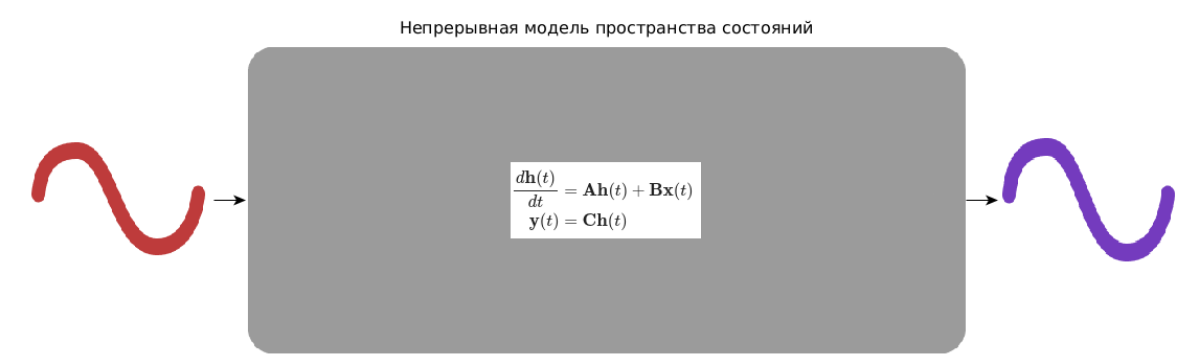

#### Дискретная модель

Чтобы применить `SSM` к дискретной входной последовательности $(x_0, x_1, \ldots)$, вместо непрерывной функции $x(t)$, модель необходимо дискретизировать с использованием шага $\Delta$, который определяет разрешение входных данных. 
Концептуально элементы $u_k$ можно рассматривать как выборки некоторого неявно заданного непрерывного сигнала $x(t)$, где $x_k = x(k \Delta{t}).$

Дискретная `SSM` принимает следующий вид:

$$
\begin{aligned}
h_{k+1} &= \tilde{A}\, h_k + \tilde{B}\, x_k, \\
y_k &= C\, h_k.
\end{aligned}
$$

Два наиболее распространённых подхода к дискретизации `SSM` Zero-Order Hold (ZOH) и билинейное преобразование (Tustin).

-------------------------------------------------------------------
`Zero-Order Hold (ZOH)`

На интервале $[k\Delta t, (k+1)\Delta t)$ вход считается постоянным:
$$
x(t) = x_k, \qquad t \in [k\Delta t,(k+1)\Delta t).
$$

Точное решение на одном шаге:
$$
h_{k+1}
= e^{A\Delta t} h_k
  + \left( \int_0^{\Delta t} e^{As} ds \right) B x_k .
$$

$$
\tilde{A}^{\mathrm{(ZOH)}} = e^{A\Delta t},
\qquad
\tilde{B}^{\mathrm{(ZOH)}} = 
\left( \int_0^{\Delta t} e^{As}\, ds \right) B = A^{-1}\left(e^{A \Delta t} - I\right) B.
$$

-------------------------------------------------------------------
`Билинейная дискретизация (Tustin)`

Система дискретизируется на основе трапециевидного интегрирования:
$$
\frac{h_{k+1} - h_k}{\Delta t}
\approx 
\frac{1}{2}\left( A h_k + B x_k 
                 + A h_{k+1} + B x_{k+1} \right),
$$
а переход $s$-плоскости в $z$ задаётся заменой
$$
s = \frac{2}{\Delta t}\,\frac{z - 1}{z + 1}.
$$

Решение линейного уравнения относительно $h_{k+1}$ даёт дискретные матрицы:

$$
\tilde{A}^{\mathrm{(BL)}} =
\left( I - \frac{\Delta t}{2} A \right)^{-1}
\left( I + \frac{\Delta t}{2} A \right),
$$

$$
\tilde{B}^{\mathrm{(BL)}} =
\left( I - \frac{\Delta t}{2} A \right)^{-1}
\Delta t\, B.
$$

Билинейная дискретизация сохраняет устойчивость и согласует частотные свойства системы, но не является точной для кусочно-постоянного входа.

-------------------------------------------------------------------

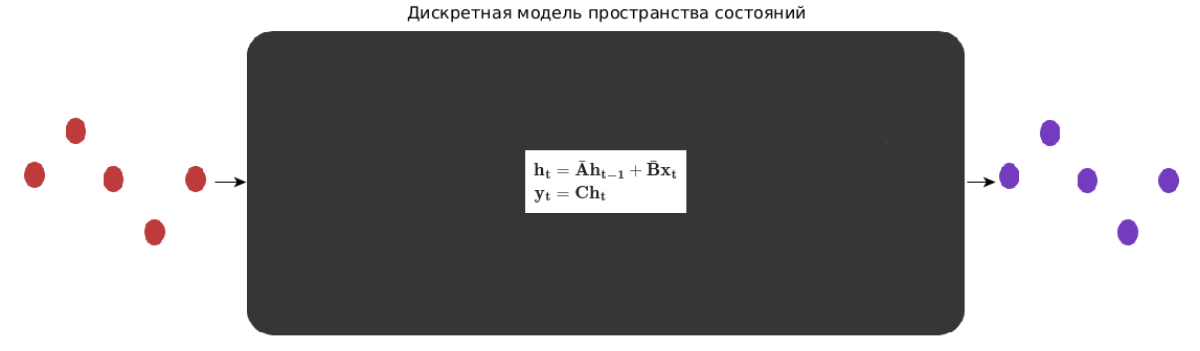

### Пример модели `SSM`

Чтобы получить дополнительную интуицию и протестировать нашу реализацию модели с состоянием `SSM`, сделаем небольшое отступление от машинного обучения и рассмотрим классический пример из механики.

В этом примере мы изучаем положение во времени $y(t)$ для точки массы, прикреплённой к стене пружиной. На массу действует внешняя сила $x(t)$,
которая может меняться с течением времени. Система описывается тремя параметрами: масса $m$, жёсткость пружины $k$ и коэффициент вязкого трения $b$.

Эти величины связаны следующим дифференциальным уравнением второго порядка:
$$
m\, y''(t) = x(t) - b\, y'(t) - k\, y(t).
$$

Перепишем это уравнение в матричной форме. Введём состояние
$$
x(t) = \begin{bmatrix} y(t) \\ y'(t) \end{bmatrix}.
$$

Тогда система принимает вид SSM:
$$
\frac{d}{dt} h(t) = A\, x(t) + B\, x(t), \qquad y(t) = C\, h(t),
$$
где матрицы имеют вид
$$
A =
\begin{bmatrix}
0 & 1 \\
-\frac{k}{m} & -\frac{b}{m}
\end{bmatrix},
\qquad
B =
\begin{bmatrix}
0 \\
\frac{1}{m}
\end{bmatrix},
\qquad
C =
\begin{bmatrix}
1 & 0
\end{bmatrix}.
$$

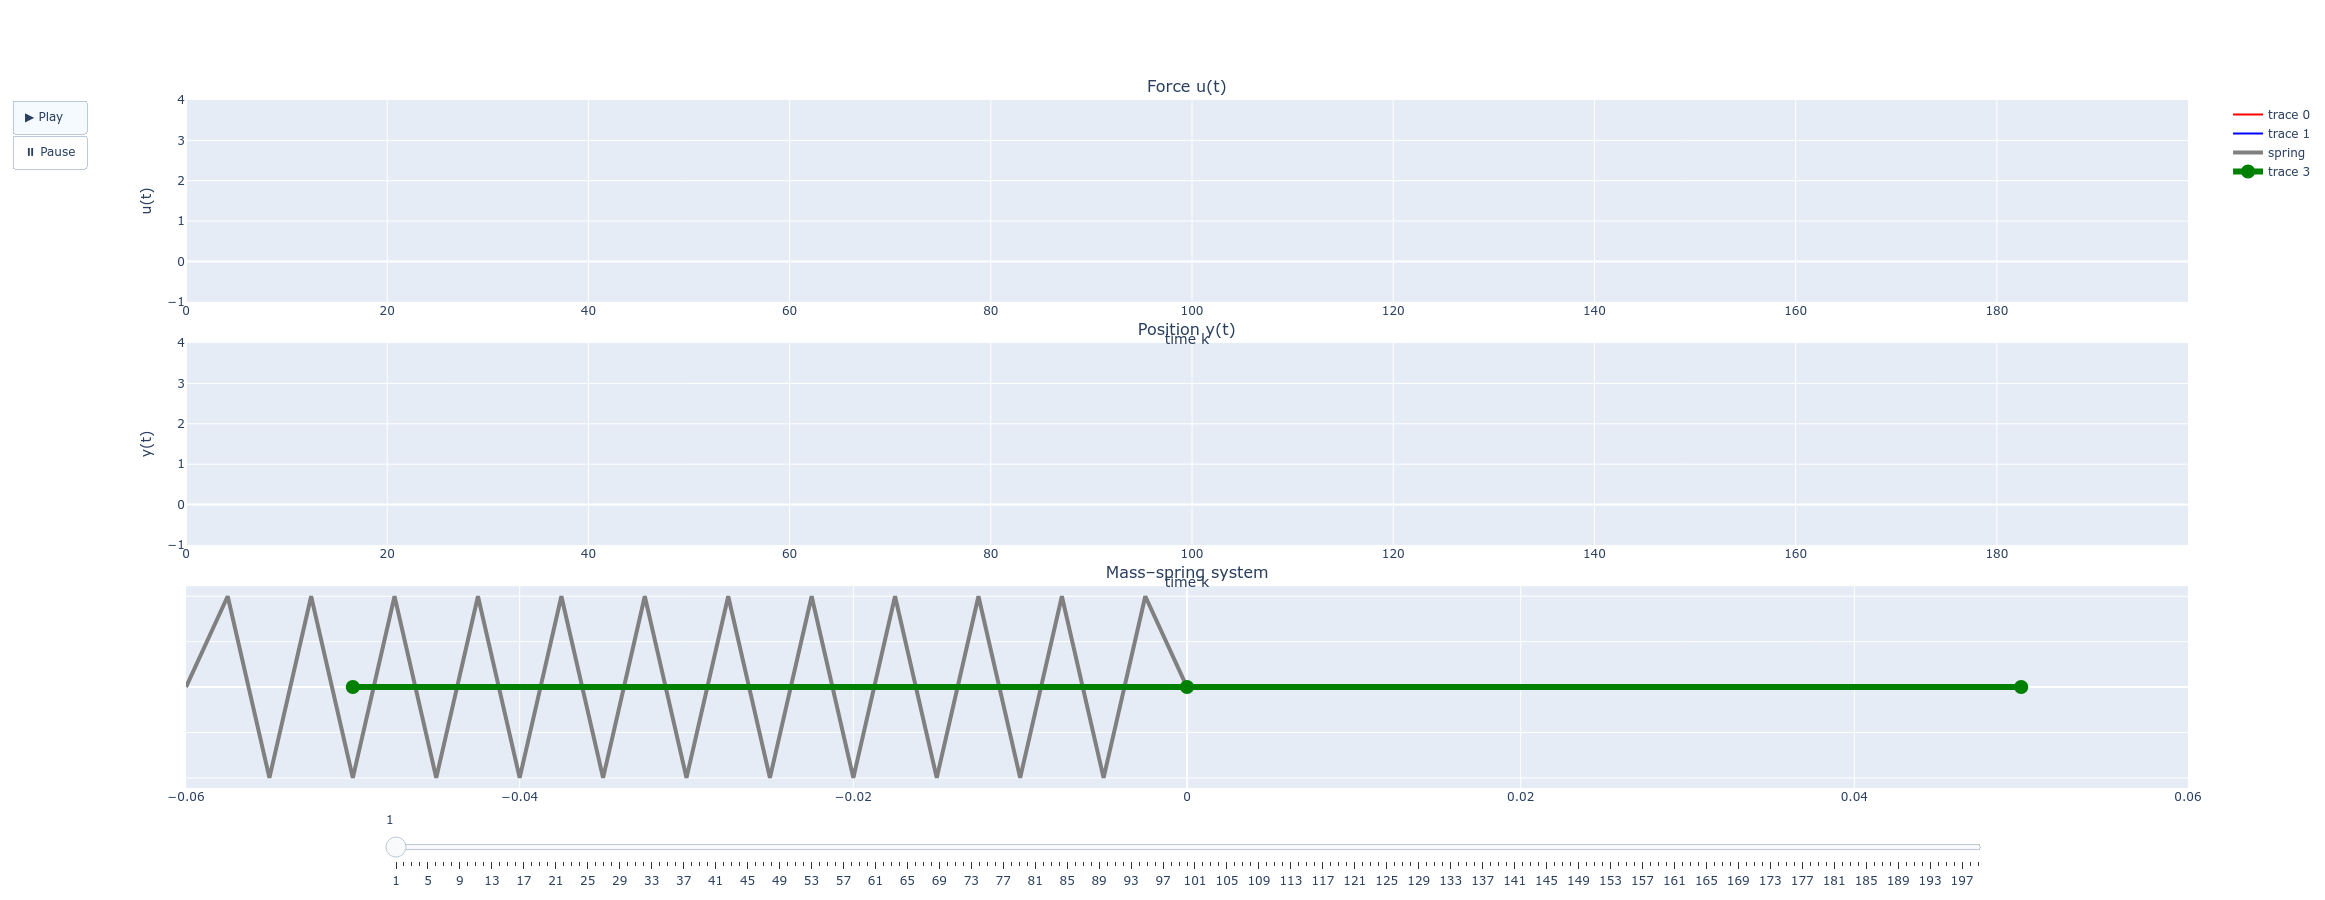

In [11]:
# ======================================================
# SSM FUNCTIONS (updated with ZOH support)
# ======================================================
def discretize(A, B, C, step, method="tustin"):
    """
    Discretize continuous-time SSM (A,B,C) with step = dt.
    method: "tustin" (bilinear), "zoh" (zero-order hold)
    """
    if method == "tustin":
        I = jnp.eye(A.shape[0])
        BL = jnp.linalg.inv(I - 0.5 * step * A)
        Ad = BL @ (I + 0.5 * step * A)
        Bd = BL @ (step * B)
        Cd = C

    elif method == "zoh":
        n = A.shape[0]
        M = jnp.block([
            [A, B],
            [jnp.zeros((1, n + 1))]
        ])

        expM = jax.scipy.linalg.expm(M * step)

        Ad = expM[:n, :n]
        Bd = expM[:n, n:n+1]
        Cd = C
    else:
        raise ValueError("method must be 'tustin' or 'zoh'")
    return Ad, Bd, Cd


def scan_SSM(Ad, Bd, Cd, u, x0):
    def step(x_prev, u_k):
        x_k = Ad @ x_prev + Bd @ u_k
        y_k = Cd @ x_k
        return x_k, y_k

    return jax.lax.scan(step, x0, u)


def run_SSM(A, B, C, u, method="tustin"):
    """
    u: sequence of input samples u[k]
    method: "tustin" or "zoh"
    """
    L = u.shape[0]
    N = A.shape[0]

    step = 1.0 / L
    Ad, Bd, Cd = discretize(A, B, C, step, method=method)

    return scan_SSM(Ad, Bd, Cd, u[:, jnp.newaxis], jnp.zeros((N,)))[1]
# ======================================================
# MASS–SPRING–DAMPER EXAMPLE
# ======================================================
def example_mass(k, b, m):
    A = jnp.array([[0, 1], [-k / m, -b / m]])
    B = jnp.array([[0   ], [1.0 / m       ]])
    C = jnp.array([[1.0  ,  0             ]])
    return A, B, C


@partial(jnp.vectorize, signature="()->()")
def example_force(t):
    x = jnp.sin(10 * t)
    return x * (x > 0.5)


# ======================================================
# SPRING GEOMETRY (zig-zag)
# ======================================================
def spring_curve(x_left, x_right, num_coils=12, amplitude=0.01):
    xs = np.linspace(x_left, x_right, num_coils * 2 + 1)
    ys = np.zeros_like(xs)
    # Зиг-заг
    for i in range(1, len(xs) - 1):
        ys[i] = amplitude if (i % 2) else -amplitude
    return xs, ys


# ======================================================
# MAIN VISUALIZATION
# ======================================================
def example_ssm_plotly():
    # System (k=40, b=5, m=1)
    A, B, C = example_mass(k=40, b=5, m=1)

    L = 200
    step = 1.0 / L
    ks = np.arange(L)
    u = example_force(ks * step)

    # Output y(t)
    y = run_SSM(A, B, C, u, method='zoh')
    y = np.array(y[:, 0])

    # --------------------------------------------------
    # Plotly: 3 subplots + animation
    # --------------------------------------------------

    fig = make_subplots(
        rows=3, cols=1,
        shared_xaxes=False,
        vertical_spacing=0.06,
        subplot_titles=(
            "Force u(t)",
            "Position y(t)",
            "Mass–spring system"
        )
    )

    # -------- INITIAL TRACES --------

    # 1. Force
    fig.add_trace(go.Scatter(
        x=ks, y=[None]*L,
        mode="lines", line=dict(color="red")
    ), row=1, col=1)

    # 2. Position
    fig.add_trace(go.Scatter(
        x=ks, y=[None]*L,
        mode="lines", line=dict(color="blue")
    ), row=2, col=1)

    # 3. Spring (initial)
    xs0, ys0 = spring_curve(-0.06, 0.0)
    fig.add_trace(go.Scatter(
        x=xs0, y=ys0,
        mode="lines",
        line=dict(width=4, color="gray"),
        name="spring"
    ), row=3, col=1)

    # 4. Mass (initial)
    fig.add_trace(go.Scatter(
        x=[0 - 0.05, 0, 0 + 0.05],
        y=[0, 0, 0],
        mode="lines+markers",
        marker=dict(size=14, color="green"),
        line=dict(width=6, color="green")
    ), row=3, col=1)

    # --------------------------------------------------
    # SLIDER FRAMES
    # --------------------------------------------------

    frames = []
    for k in range(1, L):

        # обновляем пружину
        xs_spring, ys_spring = spring_curve(-0.06, y[k])

        frames.append(go.Frame(
            data=[
                # 1 — force
                go.Scatter(x=ks[:k], y=u[:k]),
                # 2 — position
                go.Scatter(x=ks[:k], y=y[:k]),
                # 3 — spring
                go.Scatter(x=xs_spring, y=ys_spring),
                # 4 — mass
                go.Scatter(
                    x=[y[k] - 0.05, y[k], y[k] + 0.05],
                    y=[0, 0, 0]
                ),
            ],
            name=str(k)
        ))

    fig.update(frames=frames)

    # --------------------------------------------------
    # SLIDER + BUTTONS
    # --------------------------------------------------

    fig.update_layout(
        width=900,
        height=950,
        sliders=[
            {
                "steps": [
                    {
                        "args": [[str(k)], {"frame": {"duration": 0}, "mode": "immediate"}],
                        "label": str(k),
                        "method": "animate",
                    }
                    for k in range(1, L)
                ],
                "transition": {"duration": 0},
                "x": 0.1, "len": 0.8
            }
        ],
        updatemenus=[
            {
                "type": "buttons",
                "buttons": [
                    {
                        "label": "▶ Play",
                        "method": "animate",
                        "args": [
                            None,
                            {
                                "frame": {"duration": 30, "redraw": True},
                                "fromcurrent": True
                            }
                        ],
                    },
                    {
                        "label": "⏸ Pause",
                        "method": "animate",
                        "args": [
                            [None],
                            {"frame": {"duration": 0, "redraw": False}}
                        ],
                    }
                ]
            }
        ]
    )

    # --------------------------------------------------
    # AXES SETTINGS
    # --------------------------------------------------

    fig.update_yaxes(title_text="u(t)", row=1, col=1)
    fig.update_yaxes(title_text="y(t)", row=2, col=1)
    fig.update_yaxes(showticklabels=False, row=3, col=1)

    fig.update_xaxes(title_text="time k", row=1, col=1)
    fig.update_xaxes(title_text="time k", row=2, col=1)

    # FIXED x-range for the spring/mass plot
    fig.update_xaxes(range=[-0.06, 0.06], row=3, col=1)
    fig.update_layout(height=900, width=1200)
    fig.show()


# Run visualization
example_ssm_plotly()

В общем случае `State Space Models (SSM)` позволяют генерировать и моделировании сложную динамику. Благодаря математическому фундаменту в виде систем дифференциальных уравнений, эти модели способны описывать нелинейные, многомасштабные и дальнодействующие зависимости, что делает их особенно подходящими для задач, где важна точная и интерпретируемая эволюция во времени.

### Свойства `SSM`, собственные значения матрицы `A`

---
Матрица переходов $A$ в модели `State Space Model` определяет эволюцию скрытого состояния. Каждое собственное значение $\lambda$ порождает свой характер
затухания или роста динамики, и, разложив состояние по собственным векторам, можно рассматривать отдельные компоненты как независимые «динамические каналы».

$$
\dot{h}(t) = A\,h(t), \qquad 
h(t + \Delta t) = e^{A\Delta t}\,h(t).
$$

Используем точную дискретизацию через матричную экспоненту:

$$
h_{k+1} = e^{A\,dt}\,h_k,
$$

и построим траекторию в фазовом пространстве $(h_1(t),\,h_2(t))$.

---

Для наглядности выбираем шесть матриц, каждая из которых имеет характерный спектр собственных значений и, соответственно, свой тип
динамики:

1. `Stable (real negative)`
   $$
   \lambda_1 < 0,\ \lambda_2 < 0.
   $$
   Траектория экспоненциально затухает и стремится к нулю.

2. `Unstable (real positive)`
   $$
   \lambda_1 > 0.
   $$
   Решение расходится вдоль собственного направления,
   соответствующего положительному собственному значению.

3. `Pure oscillation`
   $$
   \lambda_{1,2} = \pm i \omega.
   $$
   Чистые колебания без затухания (идеальный гармонический осциллятор).

4. `Damped oscillation` 
   $$
   \lambda_{1,2} = \alpha \pm i\omega,\qquad \alpha < 0.
   $$
   Затухающая спираль.

5. `Exploding oscillation`
   $$
   \lambda_{1,2} = \alpha \pm i\omega,\qquad \alpha > 0.
   $$
   Расходящаяся спираль.

6. `HiPPO (LegS, $N=2$)`
   Матрица HiPPO-LegS обеспечивает оптимальное онлайн-представление истории входного сигнала в базисе полиномов Лежандра. Для случая $N=2$ её собственные значения имеют вид:
   $$
   \lambda_1 = -1,\qquad \lambda_2 = -2,
   $$
   что соответствует стабильной и многомасштабной динамике: медленный и быстрый режимы памяти.


In [60]:
def hippo_legS(N):
    q = np.arange(N, dtype=np.float64)
    col, row = np.meshgrid(q, q)
    r = 2 * q + 1
    M = -(np.where(row >= col, r, 0) - np.diag(q))
    T = np.sqrt(np.diag(2 * q + 1))
    A = T @ M @ np.linalg.inv(T)
    B = np.diag(T)[:, None]
    B = B.copy()
    return A, B

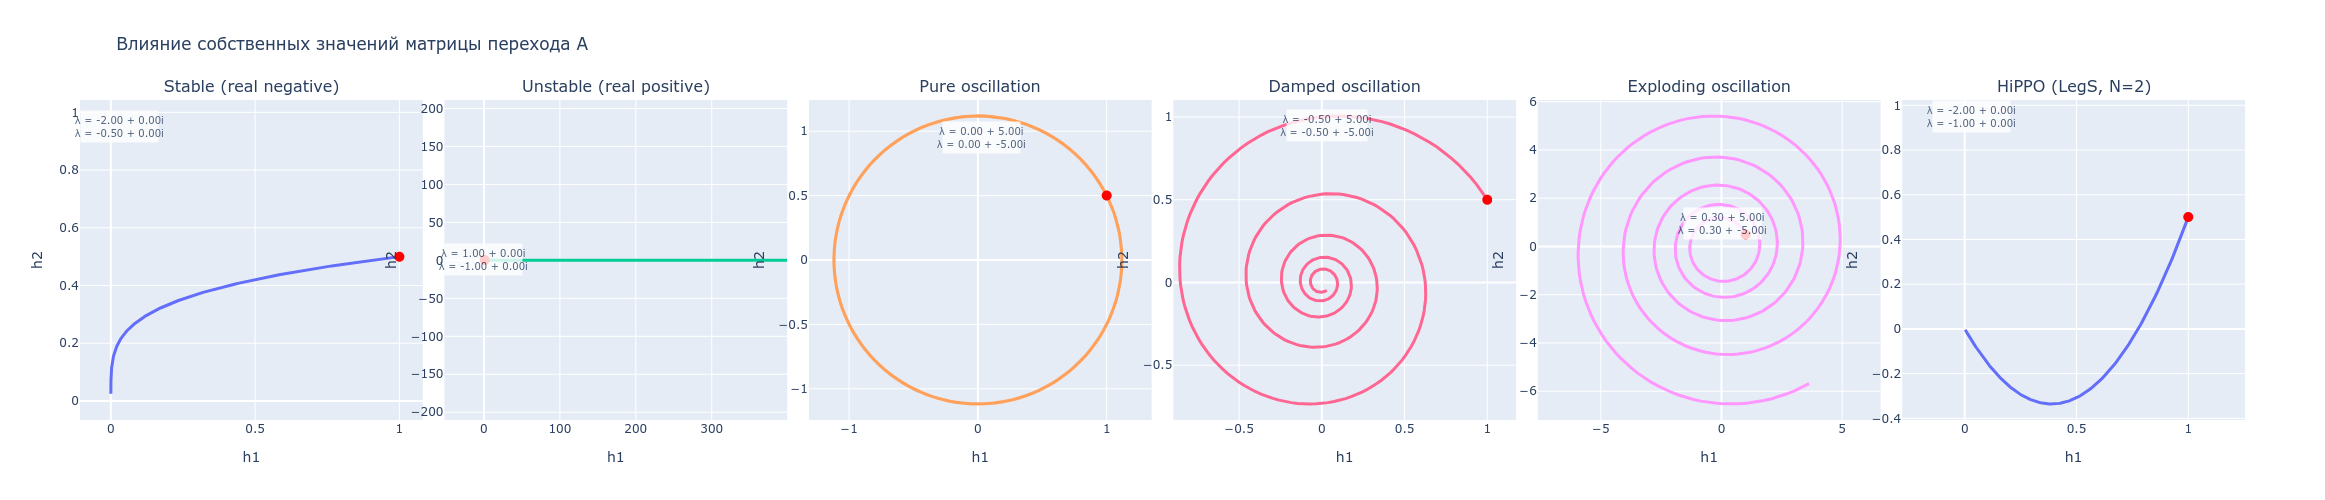

In [65]:
# =============================================
# Simulation: h_{k+1} = exp(A dt) h_k
# =============================================
def simulate(A, h0, dt, steps):
    Ad = expm(A * dt)
    hs = np.zeros((steps, len(h0)))
    hs[0] = h0
    for k in range(1, steps):
        hs[k] = Ad @ hs[k-1]
    return hs
# =============================================
# Define 5 interesting A matrices
# =============================================
cases = {
    "Stable (real negative)": np.array([
        [-2.0, 0.0],
        [ 0.0, -0.5],
    ]),

    "Unstable (real positive)": np.array([
        [ 1.0, 0.0],
        [ 0.0, -1.0],
    ]),

    "Pure oscillation": np.array([
        [0.0, -5.0],
        [5.0,  0.0],
    ]),

    "Damped oscillation": np.array([
        [-0.5, -5.0],
        [ 5.0, -0.5],
    ]),

    "Exploding oscillation": np.array([
        [ 0.3, -5.0],
        [ 5.0,  0.3],
    ]),
    "HiPPO (LegS, N=2)": hippo_legS(N=2)[0]
}

h0    = np.array([1.0, 0.5])
dt    = 0.01
steps = 600

# =============================================
# Create figure with 1 row and 6 columns
# =============================================
fig = make_subplots(
    rows=1, cols=6,
    subplot_titles=list(cases.keys()),
    horizontal_spacing=0.01
)

col = 1
for title, A in cases.items():

    hs = simulate(A, h0, dt, steps)
    eigs = np.linalg.eigvals(A)

    # trajectory
    fig.add_trace(
        go.Scatter(
            x=hs[:,0],
            y=hs[:,1],
            mode="lines",
            line=dict(width=3),
            showlegend=False
        ),
        row=1, col=col
    )

    # starting point
    fig.add_trace(
        go.Scatter(
            x=[hs[0,0]],
            y=[hs[0,1]],
            mode="markers",
            marker=dict(size=10, color="red"),
            showlegend=False
        ),
        row=1, col=col
    )

    # eigenvalue text
    eig_text = "<br>".join([f"λ = {ev.real:.2f} + {ev.imag:.2f}i" for ev in eigs])
    fig.add_annotation(
        x=0.03, y=0.95,
        xref=f"x{col}", yref=f"y{col}",
        text=eig_text,
        showarrow=False,
        font=dict(size=10),
        bgcolor="white",
        opacity=0.8
    )

    # Axis settings
    fig.update_xaxes(title_text="h1", scaleanchor=f"y{col}", scaleratio=1, row=1, col=col)
    fig.update_yaxes(title_text="h2", row=1, col=col)

    col += 1

fig.update_layout(
    title="Влияние собственных значений матрицы перехода A",
    height=500,
    width=2400,
)

fig.show()

Для любого $\lambda < 0$ решение одномерной подсистемы имеет вид
$$
h(t) = e^{\lambda t} h(0),
$$
то есть экспоненциально затухает. В контексте `HiPPO` такая структура спектра является принципиальной: собственные значения матрицы $A_{\text{HiPPO}}$ 
лежат на отрицательной вещественной оси и упорядочены по убыванию 
$$
0 > \lambda_0 > \lambda_1 > \cdots > \lambda_{N-1},
$$
что создаёт семейство временных масштабов для памяти. Малые по модулю значения $\lvert \lambda_i \rvert$ обеспечивают медленное затухание и соответствуют долгосрочным компонентам истории, тогда как большие по модулю собственные значения порождают быстрые фильтры, чувствительные к локальным изменениям входного сигнала. Таким образом, спектр HiPPO формирует мультимасштабное представление времени, в котором каждая координата скрытого состояния хранит информацию на своём собственном характерном временном интервале. Именно эта спектральная структура позволяет `HiPPO` эффективно и стабильно аппроксимировать всю историю входа.

### Реккурентное и сверточное представление `SSM`

Дискретизированный `SSM` позволяет нам сформулировать задачу в конкретных временных интервалах вместо непрерывных сигналов. Рекуррентный подход, как мы уже видели в случае с `RNN`, здесь весьма полезен. 

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABI4AAAFRCAIAAACdWXGTAABbLUlEQVR4Xuy9CXgUVaK/HRZFcBm4
Kjrqn6uj4DAzrsyVGb+5IDiOyI4oCDjjNi4XFZRFEB12BGTfd5BFZd8x4i7oiAiDiIDsEEh39oUk
kLXPd7orKTpVXacSupPuSr/v83vydFdVd1ed/uWk33SlEyMAAAAAAAAgwogxLgAAAAAAAIBwg6oB
AAAAAABEHKgaAAAAAABAxIGqAQAAAAAARByoGgAAAAAAQMSBqgEAAAAAAEQcqBoAAAAAAEDEgaoB
AAAAAABEHKgaAAAAAABAxIGqAQAAAAAARByoGgAAAAAAQMSBqgEAAAAAAEQcqBoAAAAAAEDEgaoB
AAAAAABEHKgaQJj5JHHBmvhx612TiDnr4iducE0xDhkAACjxeDxnj/8749BnGYe/JAFy6IuMw18b
Rw0g8kDVAMLMV8nvb3ZPj02YTcz5yD3r44S5xiGLGk6fz92akv5lagYJGDk4xiGLGrKyCj7flvHl
NyRwPv06fffeLOOoRRNFRUUJ/54f/9k41xeTiDnxn09wfTnVOGrRRH78+fzTRJWi84XGUQsHqBpA
mPkyedkm97SPEmYRc7a4Z8YmzDEOWdTwn7PZo46dmXzSNYmYIodFDo5xyKKGpOS88dPjJ81yEXMm
z3GNmXpm+dpk46hFEx6PJ2nnMve26QnbZxNz3NtnJnwzzzhq0UTusZzcI0SVwpwC46iFA1QNIMyg
aopEuar9lJUjnWTO6YTZxBQ5LHJwjEMWNaSk5s9Y4J79XgIxZ87ihKnzXOu2pBpHLZrwqdpS99fT
ErbPIua4t81I+CZ6T9mQ5J04l3eMqFJ0jnfVAABVUwZVm3jSJbVkFjFFDsvE6Fa16fPdsxYlEHOk
rU2Z61q7GVVD1SyDqqFqtkHVAMALqqYIqoaqWQVVQ9WsgqoJVM0uqBqqZhtUDQC8oGqKoGqomlVQ
NVTNKqiaQNXsgqqharZB1QDAC6qmCKqGqlkFVUPVrIKqCVTNLqgaqmYbVA0AvKBqiqBqqJpVUDVU
zSqomkDV7IKqoWq2QdUAwAuqpgiqhqpZBVVD1ayCqglUzS6oGqpmG1QNALygaoqgaqiaVVA1VM0q
qJpA1eyCqqFqtkHVAMALqqYIqoaqWQVVQ9WsgqoJVM0uqBqqZhtUDQC8oGqKoGqomlVQNVTNKqia
QNXsgqqharZB1QDAC6qmCKqGqlkFVUPVrIKqCVTNLqgaqmYbVA0AvKBqiqBqqJpVUDVUzSqomkDV
7IKqoWq2QdUAwAuqpgiqhqpZBVVD1ayCqglUzS6oGqpmG1QNALygaoqgaqiaVVA1VM0qqJpA1eyC
qqFqtkHVAMALqqYIqoaqWQVVQ9WsgqoJVM0uqBqqZhtUDQC8oGqKoGqomlVQNVTNKqiaQNXsgqqh
arZB1QDAC6qmCKqGqlkFVUPVrIKqCVTNLqgaqmYbVA0AvKBqiqBqqJpVUDVUzSqomkDV7IKqoWq2
QdUAwAuqpgiqhqpZBVVD1ayCqglUzS6ompWq5R7NMS+MzqBqAOAFVVMEVUPVrIKqoWpWQdUEqmYX
VM1K1YgeVA0AvKBqiqBqqJpVUDVUzSqomkDV7IKqWaraUdOSaA2qBgBeUDVFUDVUzSqoGqpmFVRN
oGp2QdVQNds4XtViY2M7l9ClS5devXqtWrWqqKjIuB0AKEHVFEHVUDWroGqomlVQNYGq2QVVs1Q1
UhLHq9q0adNiYmI6duz41FNPPfnkk02bNpVX27Zti60BlAtUTRFUDVWzCqqGqlkFVROoml1QtUpT
NcPnlMireswbR1SqiKodPHhQXzJkyBC55Pvvv/fbCgBsQNUUQdVQNaugaqiaVVA1garZBVWrTFWL
fCsLmCqoap9++qlcsm7dOu3qzJkzO3XqpK/V2b9/f/PmzeXXnJycjh079u3bV191+PDhFi1aLFq0
SF/yzTffPPjgg/Xq1atfv36XLl2OHTumr9J4+umnm5cmIyNDW2XegVWrVskNCgu9Q3/gwAF520aN
Gv3qV7/63e9+169fv6ysLP+Nd+/e3bNnz0ceeUS/5127dvlvoCMf6MLD+6E9kLA7ikOHDnXv3v2G
G26oW7funXfeOX78eH2VvAfDffofkRyuJ5544vrrr5c3fOCBB7Zv366v0lAMjlDulX5E8m7lczR8
+PCUlBRtlWLc5syZU/rRipFHp22g3mHFwZqfSn/Ma/2faKE8UmEx/upjMT9iMKBqiqBqqJpVUDVU
zSqomkDV7IKqVZqqnT+abV7oiFQ1VZPe1a1bt8suu8zlKv7ZKR3suuuuu3CDEr777jt5Q/lVXl6z
Zo28vHDhQnn5/Pnzd999t3ytLC9oW8pX2Jdeeun999+/fPnyBQsWNGjQQN6h2+32v7ff//73f/nL
X+b5eO655+S9JScna6vMOzBp0iS5QUFBgbz8wQcfPPPMM++9915sbOzEiRPli3gpD/qWe/furVWr
lnzoyZMny3seNmyYvKF00Qv35Yd8oKuuukrbB42uXbvqD6Q+Cmk+0nluu+222bNnb9myRT7cs88+
q9+zvAd5P1IPtLuV3qgfkRQMqRb33Xff0qVLpR5Lc7jkkkt27Nih31YoB0e9V/KIpNhoNxwyZMg1
11wjH0hbpRi3nTt3ajeZPn26fCy5mXZ15cqVogw7rDhY81Ppj3mt/xOtPlKr8Vcfi/kRgwFVUwRV
Q9WsgqqhalZB1QSqZhdUrdJUzbmpIqomX/jeeuutN998s5S0W265Rb4s1jewejnrr2qSV155pU6d
Ovv373/xxRcvv/xy/7fppAPceOONurnJ1/o1atTo06ePvoGkUaNGzz//vHZZOkDZVc2AfJkuV/38
88/a1dGjR1evXj07O1u7um/fPrWqKR5IfRStW7eWIpSenq7f1p9z587J+5k5c6Z2dcCAAfoDdejQ
oWHDhvrdyklZWpC8N+2qhmJw1Hslj0iu1S5LpJLJ2+ob+2MYN42srCy50P/dUVGGHVYcrHmE/TGv
DdX4C4tjMT9iMKBqiqBqqJpVUDVUzSqomkDV7IKqoWq2qSKq9vbbb8sLU6dOHThwoHxB3KRJk6Sk
JG0D+XL26quv3uPj2LFjeXl52nKDquXm5t57773XX3+9XLh48WJtoURuX7NmTf/TIyXNmjW76667
/JfIB+3Vq5d22axq+g5o9OvXz1/VUlNT5SOOGDFCWsHLL78sV61evVpbNXv2bHn1k08+0a5etKqp
j0KuvfTSS3v37u2/1p+0tDR5PwsWLNCu6vYi71m68XPPPXfQj549e9atW9f/5laDo94r4Tui+vXr
a4O2efPmO+644+GHH9a3VIybhllvyrLDVgcrrLtkXquhP9HqI7UdfxHoWITd/pQXVE0RVA1Vswqq
hqpZBVUTqJpdUDVUzTZVRNUO+r0JFhcXJ1/4ytfu2lX5clZuUMuHvHD55ZdLrxMmVRO+vyySS+6+
+259iSQhIUEulM7jv7BHjx6//vWv9atFRUXyhfjIkSO1q2ZV03dAQ26svYKXaz/++OM6der89re/
7d69+wsvvPDUU0/JVfIetNueO3euXbt21apVu+mmm26//fZbbrkl5qJUTX0UAdf6c+TIkRi/P//T
7UW7oTwc/6OTSB3Sb6sYnICP6z+2hudODoJurepx0zDrTVl22OpghWl/9C6Z12roT7T6SAOuNWA+
FmG3P+UFVVMEVUPVrIKqoWpWQdUEqmYXVA1Vs00VVDVJw4YNmzRpol32FxhpPkOHDpXbx8bGGlQt
PT395ptvvu2222JKv+LPzs6WSwYPHqwvkbRq1Uo+hH71559/jvF7S8esalYGJS9LAevYsaO+av/+
/YYdkLRp06ZRo0abNm2aMWNGzEWpmvoocnJypA0OGjTIf60/0ovkzX/88Uftqm4v2t3KIS21dWkU
g6PeK+E7Iv0ESLmT8oGqV6++e/duUbZxM+tNWXbY6mCFdZfMazVCNf4i0LEIu/0pL6iaIqgaqmYV
VA1VswqqJlA1u6BqqJptqqCqpaam1q5du0WLFtpVwwtol8slt58yZYpB1R599NH69eu73e5//vOf
V1xxxaFDh/SbNG7cuGnTpvrVjIyMq666qkePHvqSsWPHXnLJJbqblV3V5BRWs2bNcePG6au0P8fy
Vw55WW6zc+dOEcQJkMLuKO69994//OEPVv+MrlevXnXr1s3Pz9eu+tuLvOE999yjf8ihGfXgqPfK
X9VEyXM3efLksoybsNAb2x1WHKxVlwKuFaEbf2FxLOr9KS+omiKoGqpmFVQNVbMKqiZQNbugaqia
baqIqs2aNWvTpk0bN26cM2fO3XffLZdoH5EnfC9nr7nmGu2vknbs2NG9e/fq1atL8/FXNXkn1apV
27p1q/C9OyFfNMs7yc3N1e5h/vz5ckv5kj0xMfH48eOtW7euUaOG9on5eXl5sbGx9erVe+ihh/S/
fXr33Xe1e5Z3pe2A4hX8XXfdJR/u8OHDOTk5y5cv1/5YTleOuLg4qQ36u0DBqJriKCQbNmyQa7t1
6yYdVe62fCA5pHL56dOn+/fvLwfH/50of3vZsmWLXNu1a9cDBw6cP3/+5MmTy5YtmzBhgijb4Kj3
Sjsi7YbyJvK5k4/173//W9iNm0ZAvVHssO3BWnVJXxvy8dcJeCzq/SkvqJoiqBqqZhVUDVWzCqom
UDW7oGqomm2qiKrp1K9fv0WLFv7ngPX1/T2PxpVXXvnHP/5xxYoVwu9v1fbs2VOrVq0333xTv4l8
EV+nTp2ePXvqS0aNGlW7dm39IVatWqUtly+R9Ts3o/3DLvUrePkK+6abbtK2v/HGG9etWxdTohxy
gmvZsuV9992nbSmCUzVhfRQa8kHlQm2t1BWpDXLhvHnz7rjjDjnIcmf0Lf3tRbJ69eoGDRpoN9Tu
eerUqaJsgyOUe2X13AnluOkE1BthvcO2B6vYH21tyMdfJ+CxqPenvKBqiqBqqJpVUDVUzSqomkDV
7IKqoWq2cbyqVRrZ2dm7du3au3ev/spb+GykRo0afltd4Oqrrzb/M+iA5OXl7fOhOCsvVAQ8Ch25
A3I35Ab6CYplRM7Fhw4d2rlz54kTJ/Sz+Mo+OOq9siKYcQu4w5WA+kgvevxDAqqmCKqGqlkFVUPV
rIKqCVTNLqgaqmYbVC0oym4jUQiD4yxQNUVQNVTNKqgaqmYVVE2ganZB1VA126BqQXH+/PkdO3YY
l/rYtWvX2bNnjUujCQbHWaBqiqBqqJpVUDVUzSqomkDV7IKqoWq2QdUAwAuqpgiqhqpZBVVD1ayC
qglUzS6oGqpmG1QNALygaoqgaqiaVVA1VM0qqJpA1eyCqqFqtkHVAMALqqYIqoaqWQVVQ9WsgqoJ
VM0uqBqqZhtUDQC8oGqKoGqomlVQNVTNKqiaQNXsgqqharZB1QDAC6qmCKqGqlkFVUPVrIKqCVTN
LqgaqmYbVA0AvKBqiqBqqJpVUDVU7UIWlrqKqglUzS6oGqpmG1QNALygaoqgaqiaVVA1VK04C43j
gKoJVM0uqBqqZhtUDQC8oGqKoGqomlVQNVRNZqZpySxUzQeqpg6qFkZVE/FCJAqRIHKP5pw/ki1O
F3riCuVlbW3Bibz847l5x423qvygagDgBVVTBFVD1ayCqgVUtZkL3YazAatwZlocKaomUDW7oGoX
r2pHTUvKFiljWs4dyco5fFZG0zNpazL6BtpV7XLgezgmlxtXVURQNQDwgqopgqqhalZB1QKqWrTE
QtK0oGoCVbMLqnbxqhY1QdUAwAuqpgiqhqpZBVWLalVTBlUTqJpdUDVUzTaoGgB4QdUUQdVQNaug
aqiaVVA1garZBVVD1WyDqgGAF1RNEVQNVbMKqoaqWQVVE6iaXVA1VM02qBoAeEHVFEHVnK5qM01L
QhVUDVWzCqomUDW7oGqomm1QNQDwgqopgqo5WNXiTEtCGlQNVbMKqiZQNbugaqiabVA1APCCqimC
qjlY1So4qBqqZhVUTaBqdkHVUDXboGoA4AVVUwRVQ9WsgqqhalZB1QSqZhdUDVWzDaoGAF5QNUVQ
NVTNKqgaqmYVVE2ganZB1VA126BqAOAFVVMEVUPVrIKqoWpWQdUEqmYXVA1Vsw2qBgBeUDVFUDVU
zSqoGqpmFVRNoGp2QdVQNdugagDg5cvk9ze7p3+UMJuYs8U9KzYhen+aomqKoGqomlVQNYGq2QVV
Q9Vsg6oBgJdPExeujR+/wTWZmLM+ftJG11TjkEUNqJoiqBqqZhVUTRSr2jL319MTts8m5ri3zUz4
Zp5x1KIJVM02qBoARCKnT582LoIwIVVt0knXHJ+WEEPksEyKblWbscAtnYSYM2dxwtR5rnVbolrV
ioqKEv69IP7z8a4vJxNz4r+Y6PpqmnHUoonc4zm5R4kqhTkFxlELB6gaAFwgPz//nnvukV+NKwCE
mDs3qs8XAjXUA9TQEFBDQwKCqgHABZYvXx4TEyO/GldA1HPixIlLLrlEfjWuAKAeYAcNATU0xApU
DQAu0KxZM6lq8qtxBUQ9AwYMkN2QX40rAKgH2EFDQA0NsQJVA4Bi9u3bF1OCvGxcDVFMbm7utdde
K4shv8rLxtUQ3VAPUENDQA0NUYCqAUAxL730kq5q8rJxNUQxS5Ys0bshLxtXQ3RDPUANDQE1NEQB
qgYAXjIzM6+88kp9rpSX5RLjRhCt/OlPf9K7IS8bV0N0Qz1ADQ0BNTREAaoGAF6mTZumT5Qacolx
I4hKdu3aZeiGXGLcCKIV6gFqaAiooSFqUDUA8NK4cWPDXCmXGDeCqOTZZ581dEMuMW4E0Qr1ADU0
BNTQEDWoGgCIL774Qpsf69Spo3+VyOXGTSHKSEtL0/ugI5fI5cZNIfqgHqCGhoAaGmILqgYAonPn
znJy7NSp08mTJ+UF+VVelhfkcuOmEGVMmDBBNqFatWpPP/20vCC/ysvyglxu3BSiD+oBamgIqKEh
tqBqANHOmTNnGjduHBsbq12VU6R2QS6Ry+XaC5tClOHxeG677bZ77rnn22+/FSXdkJflErlcrjXe
AKIJ6gFqaAiooSFlAVUDiHZOnjyZl5enX9VVTSKXy7X6VYg2vvvuu+nTpxcWFmpX9W7IJXK5XHth
U4g+qAeooSGghoaUBVQNAErhr2qhIi4u7o033vjzn//csGHDJk2avPTSSzt27DBuBBEP3QAF1APU
0BBQQ0MCEvpBAQBHE/K5cv369XXq1LnuuuteeeWVCRMm/Otf/2ratKl8lE8//dS4KUQ2dAMUUA9Q
Q0NADQ0JSIgHBQCcTmjnyoMHD9auXft///d/Df9Qe8uWLdu2bfNfApEP3QAF1APU0BBQQ0MCEspB
AYAqQGjnyn/84x81a9Y8deqUcQU4ELoBCqgHqKEhoIaGBCSUgwIAVYDQzpXXXntt8+bNjUvBmdAN
UEA9QA0NATU0JCChHBQAqAKEcK7MysqS9/b8888bV4AzoRuggHqAGhoCamhIQEI2KABQNQjhXJmW
libvrWfPnsYV4EzoBiigHqCGhoAaGhKQkA0KAFQNQjhXFhUV1apVq1OnTsYV4EzoBiigHqCGhoAa
GhKQkA0KAFQNQjhXSpo3b3711Vf7/4ttcC50AxRQD1BDQ0ANDQlIKAcFAKoAoZ0rV65cKe9wyJAh
huUZGRnHjx83LIQIh26AAuoBamgIqKEhAQnloABAFSC0c6Xkqaeekvf5zDPPfPvtty6X68CBA9Om
TWvQoMG6deuMm0JkQzdAAfUANTQE1NCQgIR4UADA6YR8rvR4PJMmTbrxxhtjSqhXr17fvn0N/5US
Ih+6AQqoB6ihIaCGhgQkxIMCAE4n5HOlzrFjx3bs2HHw4MHCwkLjOnACdAMUUA9QQ0NADQ0JSEUN
CgA4lIqbK8Hp0A1QQD1ADQ0BNTQkIAwKAJSCuRKsoBuggHqAGhoCamhIQBgUACgFcyVYQTdAAfUA
NTQE1NCQgDAoAFAK5kqwgm6AAuoBamgIqKEhAWFQAKAUzJVgBd0ABdQD1NAQUENDAsKgAEApmCvB
CroBCqgHqKEhoIaGBIRBAYBSMFeCFXQDFFAPUENDQA0NCQiDAgClYK4EK+gGKKAeoIaGgBoaEhAG
BQBKwVyps3jx4s6dO69YscK4IlqhG/5QDwPUwwANMUBDDNAQAzQkIAwKAJSCuVLD4/H85je/qVat
2p133mlcF63QDR3qYYZ6+ENDzNAQf2iIGRoSEAYFAErBXKnx5ZdfyqHo27ev/Lpr1y7j6qiEbuhQ
DzPUwx8aYoaG+ENDzNCQgDAoAFAK5kqNv//977fcckteXt6111778ssvG1dHJXRDh3qYoR7+0BAz
NMQfGmKGhgSEQQEIFk9pCguLZHx4vPFEdOSeenfW4zlz5syhQ4dOnDgxeMgQbbl5YwfEO+ZetKfA
/3kxPm1KMjMz69SpM3jwYHm5d+/e9erVy83NNW5UBvx3wEM3wpsQdUNQD1+ohwIaUkRDlNCQIhpS
ZlA1gIvH/1tR+xY1buEcEhMTjh8/dubMaeMKJ+Px/ejSJspyzZhz586NiYk5evSovLxnzx55efny
5caNlNCNCOeiuyGoR2mohxka4g8NMUND/KEhalA1gItE/8bz/TaleJbMyj73/e4DS1dsHTvl/YHD
ZvcaOOXVAZPl18iN3D3fHv5f3/Evvjb2pT7jtKvFXx0VOdSvD5o2ZPSCGfPXfvTJd8dPuvQny3/G
1Bcq+NOf/vSXv/xFv3rnnXc+/PDDfuttoBuRlhB2Q1APLdTDGhriDQ2xhoZ4Q0PKBqoGcDHo33iF
hYXakmMn4qfOWf33F0f+tdPrzdu++mCH1+SFhx7t45T8rXPfhzv3e7hzX/MqJ6VTn792fL1F+94P
tO3VrtvAvm9P/+jT73Jz8+QTVOQ7IUF71tQz5oEDB2JiYp5++ul1JXTt2rV69eqnT5fpd350I0IT
im4I6mEK9TBAQwyhIQZoiCE0RA2qBlBuDBNlcmrGxJkr2nUb8EC7Vx95vF+HHm+27/5m6y79H+7c
52+Pyunyde1rpKdTScyrIj5/Kxlk+bXVY33bPjGg45OD5Fwp5035c+ufvcZu/+4n7anTfgGpni77
9+8fE4iRI0caNzVBNyItoe2GoB7mUI/S0BBjaEhpaIgxNEQJqgZQPgwT5c7/HOzxwvDmbV7Vvj8f
7ty3ZYdecqJ88sVR/9d38qsDZ/QilZiX35j2XK9xnZ/61187vvZgx97yB5h8Uh56tE/LDr0nz16l
/X6rsGS6LP3EFlNQUHD99dd36tTJsLxVq1a33XabYaEBuhHJCb4bgnpU3YSkHoKGVN3QEKJOqBpi
BlUDKAeGifKTL3/4m/e9+z6dnnyr1WN9H+zQ+5+9xi14/4tvdp765VhWfJInKU0kpZPKiztFnDiT
t/dA8sate4e++367bgNbtu/VvvtAmWatX+k/eObZrBzhOxvB8MzqbNiwISYmZvXq1YblS5culcu3
bdtmWK5DNyI8wXdDUI+qm5DUQ9CQqhsaQtQJVUPMoGoA5UOfKD/98oeHOvVp3aV/hx6DHuzYu9vz
I1Zs+P6UOy81UySmCVeyOJ1QFOcuJJUZOebxiZ6EVJGc4c3OvfFDxi57qNPr8mnq2GNQ87avvv7W
9Oycc9qH6hqfWh8dO3a86qqrzp8/b1ielZVVp06dp59+2rDcH7oRyQm+G4J6VN2EpB6ChlTd0BCi
TqgaYgZVAygrHh+Fhd7vsZ8PHH/k8X6PPC4nyjdbtu/Vd/DcX45npp71zo+nXMXftCRcifP9lDrl
KpCTpnxSVm74vk3XAa0e69vxyUHN2rwycvxij8f7oUzGJzgI6IZTUvndENTDOQlLPQQNcU5oCFGn
IhqCqgGUgyIfZ7Nynnt1zEOdXu/QY1CL9q/+a/TS+KQCd4o4GV8gv1HPJHq071h5gYQl+vjLGfOk
qyDtrPh8++EO3d/U/uq6edtXN8Z+a3xqg4ZuOCJh6YagHg5JuOohaIhDQkOIOhXREFQNoKz4fqfl
Pfdg2cqtzdq82vHJQX/t+FrvN2eeTsh3JXlOuQr8v0tJ2KP/3DoRn5+eJTZ8vPdvnfu06zag1WP9
uj47JDUt0/gEBwHdcFYqsxuCejgtlVwPQUOcFhpC1AltQ1A1gLJS5PvPGClpmU88N+SRx/u37tK/
09/f2nswNTFNnHR5f6HFRBlp0afLk/HeX26Nn76+Zfte8odc87avLv4g1vgEBwHdcFwqrRuCejgw
lVkPQUMcGBpC1AlhQ1A1gLJSUOD9ndbqDV82a+v9nVaL9r1mvbc19eyFEw9IBEZ7auLcha5kz4Gj
Z7s8O6R1l36tHuv395fs/4NN2aEbTkzldENQD2em0uohaIgzQ0OIOqFqCKoGUFY8Hk+Rp6jv29P/
2tH7kT5dnx36y7EsV5L3+1D/niQRGO3XjadcBamZYtq8j1q27+X71KzXjE9wENANh6YSuiGoh2NT
OfUQNMSxoSFEnZA0BFUDKAfx7uQOTw5q+8QA+f02atKKlAxxquTcA/O3KImoyB9piame7/8TL5++
dt0GPtD2VeOzGxx0w7mp6G4I6uHkVEI9BA1xcmgIUSfIhqBqAGXF4/Fs/27vXzu93r77m3/t9Nqq
TbtSMov/nLfSw9Rcvpz2fX6uHDf5fL3UZ9LfOvd56NE+xic4COiGc1PR3RDUw8mphHoIGuLk0BCi
TvANQdUAysGaTV81a/1K++4DH3m833f/OZOY5olzef+HifmbM9SphIeo4jntOwkhJVP8a/TSlu17
PfJ4f+OzGxx0w7mp6G4I6uHkVEI9BA1xcmgIUSfIhqBqAOVg0fsfNWvzSrtuAzo+OeinX9LcKSLO
9+8mzd+ZJAJzMr4g9axn3PR1D3bo1brLG8ZnNzjohqNTod0Q1MPhqeh6CBri8NAQok4wDUHVAMrB
rIXrH2jXq03X/l2fG7b/SKZ3rmSidEh8v9YqTMkUk2ZverBDb/kkGp/d4KAbzk1Fd0NQDyenEuoh
aIiTQ0OIOkE2BFUDKAdyrmze9tW2T/Tv8uxQ71yZLE77Pn8p2CSYlpAKyClXQepZMXHWxov4tZYt
dMPRqdBuCOrh8FR0PQQNcXhoCFEnmIagagDloGSufKN4rrT6tZZi7lOsipKEbwROuQrlXFnya63y
zZW20I0QJHwjUKHdENQjJAnfCFR0PQQNCUnCNwI0xBkJ3wgE0xBUDaAcaGcgyLmy63PDDhw9K+dK
75niCUWn5bei90Kh96vpWzRAyrUxCVGCmSttoRuOToV2Q1APh6ei6yFoiMNDQ4g6wTQEVQMoB4Hn
ykTf3Ce/Jhm/OVUp18YkFAlmrrSFbjg6FdoNQT0cnoquh6AhDg8NIeoE0xBUDaAcBJ4rtV9rheSs
cVKRCWautIVuODoV2g1BPRyeiq6HoCEODw0h6gTTEFQNoBwEnivdhXFJgtMJIj/BzJW20A1Hp0K7
IaiHw1PR9RA0xOGhIUSdYBqCqgGUg8BzJbOkQxLMXGkL3XB0KrQbgno4PBVdD0FDHB4aQtQJpiGh
V7W4uLg33njjz3/+c8OGDZs0afLSSy/t2LHDuBGAM2GudHSCmSttoRuOToV2Q1APh6ei6yFoiMND
Q4g6wTQkxKq2fv36OnXqXHfdda+88sqECRP+9a9/NW3aNCYm5tNPPzVuCuBArOZK78niJOJzcXPl
4MGDlyxZkpuba1xRGrrh6FxcNySjRo2aP3/++fPnjStKQz0cnYuuh2To0KHvvfceE0jVDg0h6gTT
kFCq2sGDB2vXrv2///u/mZmZ/su3bNmybds2/yUADsVqrjR/W5IIzMXNlYcPH65Vq9a11177xhtv
nDhxwri6BLrh6FxcNySnTp26/PLL/+u//qtPnz5Hjhwxri6Bejg6F10PydGjRy+77LJrrrmmf//+
x48fN64ugYY4OjSEqBNMQ0Kpav/4xz9q1qwpf24ZV5Qwc+bMxx57TL+6evXqBx544KuvvtLXdurU
ac+ePXJh3bp1b7/99tmzZ+sba2v1qzr79+9v3ry5/Dpnzpzmgejevbu+8TfffPPggw/Wq1evfv36
Xbp0OXbsmL5Kvhp74oknrr/+evnQcge2b9+urzJz6NAhebc33HCD3PjOO+8cP368vkrxEMLihrZ7
rr7P3bt39+zZ85FHHtFvuGvXLm2VedBWrVolNygsLNTW+j8dZ86cadGiRatWrfQl5RqTKIG50tG5
6LnyrbfeivFRvXr1du3affTRRx6Px7AN3XB0LrobknfeeUerR7Vq1eRUvHHjxqKiIsM21MPRCaYe
wvfOvD6BtG3bdsuWLUwgVSw0hKgTTENCqWrXXnut1ADjUj/69u174403apfXrVt3ySWXjBkzxn/t
FVdc8f/+3/8bN27c5s2bn376adnaJUuW6Guvu+46fWOd7777Tm4mv+7cuXOej+nTp8slzzzzjHZ1
5cqV2pZSeC699NL7779/+fLlCxYsaNCggbxDt9stfAYlbeS+++5bunSp3DGpN3LfrP7E7sCBA7/6
1a9uu+02aZLy22ny5MnPPvustkrxEIobqvdcfZ979+6tVauWXCvvTd5k2LBhMX6nm5oHbdKkSXKD
goICba3+dEikBMpVl19+uXa1XGMSPTBXOjr+c2WjP/x/xmfXmpycnP/+7//WfpRq3HrrrRMmTEhN
TdW3oRuOzkV3Q5KXl9eoUSP/esi2jB07NikpSd+Gejg6wdRDcu7cuVtuucW/Ib/5zW/Gjx+fkpKi
b0NDHB0aQtQJpiEhU7WsrCzZreeff964wg/dDTZu3Chf97/zzjuGtfIepG/oS9q2bXvzzTdrbwGZ
rUNDVzV9ibYnixYturCRjwceeEA+uv4XBVJFatSo0adPH3m5Q4cODRs21Fd5PB6pKK1bt9Zv649c
fs0116SnpxtXKB9CKG+oEXDP1fc5evTo6tWrZ2dna1f37dsXc1Gq9vnnn8v7keOgq1q5xiR6sJor
OVncEQnm11pr1671+zFaTO3atZ999lntfWy64egE0w3J1q1bjeWIialVq9bf//537Tdc1MPRCbIe
kg0bNhj7ERNz2WWXPfPMMz/88IOgIQ4PDSHqBNOQkKlaWlqabFXPnj2NK/zQ3GDLli2XXnrpCy+8
YF4r70G3Dsny5cvlEu3MXbn26quv3uPj2LFjeXl52jZlVDW5fc2aNeWd+C9s1qzZXXfdJb1FfjM8
99xzB/2QB1K3bl3/jTXk/cid7927t3GF8iG0tVY31DHvufo+JbNnz5Y3+eSTT7SrZlXTB02jX79+
MSZVy8/Pb9y48YsvvjhixAhN1co1JlGF1Vxp/rYkERjDr7X0H4cXTVlUzbwbJAIT8m7ElE3VzHtC
IjCGl1lDhw41PtkXRVleiJt3hkRgaAhRJyJUraioSP5YCvjnZDrSDWTt5GaNGjW64YYb/N/Y1dYa
TGD79u2yqV9//bW2Nsb3k08S4ztP7+233xZlVrWEhAS5cNKkSf4Le/To8etf/1pbJY1Iu3Mduav+
G2sEvB/FKu0hrNYaMO95wFvp9yl8b5q3a9euWrVqN9100+233669ge6vavqgacjDjDGp2tixY6XR
paam6qpWrjGJKqznSmH+ziSRloueK4M7AZJuOCAX3Q0R7AmQ1MMBCaYewuL0tnHjxpXt9DYa4oDQ
EKJOMA0JmapJmjdvLl/x6+93mdHM4a233srMzJQ/yTp37mxYW6NGDc0iNLS3gw8cOKCt1c/lk53W
fmMRGxtbRlXLzs6WCwcPHuy/sFWrVg0bNtRWyTv0X2WFfMUmvWjQoEHGFcqHEMob6pj3XH2fOm3a
tJEvFDZt2jRjxoyYcp4AeebMmSuuuGLu3Llyia5q5RqTqMJqrjydxFzpgFz0XBnMx4rQDUfkorsh
gvtYEerhiARTDxHch0bQEEeEhhB1gmlIKFVt5cqVsmdDhgwxLM/IyNBPYtTfDtq2bZts5MKFC/XN
NJHz/w9sr7zyypVXXqn9uZTBOlwul9x4ypQpZVQ1SePGjZs2bapflXt11VVX9ejRQ16+995777nn
Hu2P4myRG//hD38w/yQWyocQyhtqBNxz9X1Kli5dWrNmzZ07d4pAJ0DaqlqXLl3+53/+R5sUdFUT
5RyT6IG50tG5uLkyyA/rpxuOyMV1QwT9Yf3UwxG56HqIoD+KnYY4IjSEqBNMQ0KpapKnnnoqxvcZ
ht9++620qQMHDkybNq1Bgwbr1q0TfmfcaQwcOFCamP7R83LtJZdcIs1k165d2dnZS5YskS+P3nrr
LX2t7LH2R1M7duzo3r27ND3pJ2VXtfnz58vlAwYMSExMlN8MrVu3rlGjhvZHJlu2bKlWrVrXrl3l
DkszPHny5LJlyyZMmGC4Bw3tvb5u3bodOnTo3Llz0o5mzZqlrVI8hPqGGgH3XH2fcXFxdevW1d/+
Kq+qSceTw6idBi1Kq1q5xiR6YK50dC5urgz2X2DTDSfk4rohgv8X2NTDCbnoeoiSf3BMQ6p2aAhR
J5iGhFjVPB6PlAHpYzEl1KtXTyqB9k+xDaqWn5/fpEmT+++/3/8zHufMmXPZZZdpt33sscf07mrv
uWlIwfvjH/+4YsUKUea/VdOQP1Nr166t3Un9+vVXrVqlr1q9erVUSv0h5NqpU6f63bQUS5culRto
W0qfkfalr1I8hFDeUFjvudV9ytFu2bLlfffdp581Wl5Vk5dffPFFfa2/qolyjkmUwFwZgiSYllRW
gpkrbaEbIUgV7YagHiFJ1a2HoCEhCQ0h6jizISFWNZ1jx47t2LHj4MGDZT+DTvcK6XU//PCD4l9p
B0N2dvauXbv27t3r/0dxGtJ8Dh06tHPnzhMnTihOU9SQxyW9SN5VcnKyYZXiIYTyhgrU91lxlGtM
ogHmSkcnmLnSFrrh6FRoNwT1cHgquh6Chjg8NISoE0xDKkrVLgLzW0AAkQZzpaMTzFxpC91wdCq0
G4J6ODwVXQ9BQxweGkLUCaYhqBpAOWCudHSCmSttoRuOToV2Q1APh6ei6yFoiMNDQ4g6wTQkglTt
p59+2rRpk3EpQCRhOVeavi1JBCaYudIWuuHoVGg3BPVweCq6HoKGODw0hKgTTEMiSNUAIp/Ac6W7
MC5JyBnT/M1JIirBzJW20A1Hp0K7IaiHw1PR9RA0xOGhIUSdYBqCqgGUAzlXNm/7qpwruzw7dP+R
TDlXxum/1nIXmr85SUQlmLnSFrrh6FRoNwT1cHgquh6Chjg8NISoE0xDUDWAchBgrtSmSH6n5YSc
chXIuXLirI0PdujVukv55kpb6IajU6HdENTD4anoegga4vDQEKJOMA1B1QDKwcwF6x5o16tN1/5d
nxu2/2imK9nvZPGQTJfuUNwJCRT5TJ1yFaZkFv9aq3WX/sZnNzjohnNT0d0Q1MPJqYR6CBri5NAQ
ok6QDUHVAMrBwmVbfL/WGvDoP97edyj9wq+1iBNyMr4g9axH+7VWec9AsIVuODoV2g1BPRyeiq6H
oCEODw0h6gTTEFQNoBysWPt5s9avtO8+sHWX/j/sTUhM9c6V3t9smb4tSaTF92utgtRMMXTs+y3b
93rk8fL9WssWuuHcVHQ3BPVwciqhHoKGODk0hKgTZENQNYCy4vF4vtj+nwc7vibnyoc6vb7h4x9T
MrznH5u/LUmkRU6U2k+10wmFL/ef+rdHX/9b577GJzgI6IZzU9HdENTDyamEegga4uTQEKJO8A1B
1QDKwYlTrrZPDGjXbUCLdq+On7E+NVOcdBX4vgNNv9lKMH67XkwUd6JYRQJFzpXuFM/eA6mdnnxL
PokPtHvV+OwGB91wbiq6G4J6ODmVUA9BQ5wcGkLUCbIhqBpAWfF4PPn5BS+89u7Dnfu2eqzvP/5v
9NG48/GJ3t+XnPH94sT8/UkiIdoPM++Z4pnivRXbWnTo1aHHoJYdehuf4CCgGw5NJXRDUA/HpnLq
IWiIY0NDiDohaQiqBlBWCgsL5df3Poxt3vbVjk8Oatm+17I136aeFfKbkIkyYqM9Nb6fZ3K6zHvm
Ffmjrk/rLm88/vRg4xMcBHTDiamcbgjq4cxUWj0EDXFmaAhRJ1QNQdUAykphUZHH4zl1OqF994Ft
ur7x8GN9n3xx1OGTOfFJ3o9h1X53wqQZUdGejuLfaZ0VC97/omWHXh17DHqgXa8J05cbn+AgoBuO
S6V1Q1APB6Yy6yFoiANDQ4g6IWwIqgZQVuREWVhYJC9MmrWyeZvi32wNG/dhcoaIcxfo5yEwXUZI
9J9eJ+PzUzPFt7vi2nUb0LrrG218ORmXYHyCg4BuOCuV2Q1BPZyWSq6HoCFOCw0h6oS2IagaQDko
LJJ4EhJTH3/6X60e69e++5sPdug9Z8ln6Vnef0ap/XLrTCLTZZij/8TyTZQFKZnix/1Jf3/pnb91
fr1jj0HN2ryy6P2PjE9t0NANRyQs3RDUwyEJVz0EDXFIaAhRpyIagqoBlBWPD+03W59v2/1Au17t
ug1s+8SAhzq9PmHWxvikwqR0ccrl/f2W9r2qf7uav5lJyOM/4Kd9n40rn4v4JE/aWfHNzpM9Xhj1
106v+X4T2fu1QVNz8/LlDz3jExwEdCOSE95uCOoR2Ql7PQQNiezQEKJORTcEVQMoH77p0vsHvktX
ftK8zatyupRp0f7VVwdM3/79iZRMkZwhXMnFv+WS366kkiNnyfhET0KqSM0UR09lz1q0Vf48e7hz
HzlRPtjhtR4vDE9MTpNPX3nnyrJANyI8YeyGoB4Rn/DWQ9CQiA8NIepUUENQNYByICdK7av2y63F
H8Y+0K5X6y5vyO/Dv3Z8rU3XAYNHL4n9cv8vx87K6TL1rEgjlZwskZwuTsTn79qbMG/p50++OKpl
+15tunqfoBbte3d/fvjRY2eE99O0vH+ibXhyg4RuRHrC1w1BPSI/Ya2HoCGRHxpC1KmwhqBqAOXD
MF2u2fT1I4/3a9mhd4ceg9p1G/hgh95/e/T1bv8c/vpbs4eMXTZ68urRk1f5sppUcFaNnrJ65MQV
A4cvfP61CfK5aNmhV6vH+8lZUv4wa9bmldffmpaY5P2FlvbEVQR0I1IT/m4I6hG5iYh6CBoSuaEh
RJ2KbQiqBlBuDNPlgUMn+7w9vWX73g92fE1+i8pJs03XNx7q9PqDHXr50rvka2SmeCflzKLFCfts
Ge/+d+zd6rG+7bt7n4hHHu//QLtXO/YYtGT5x3n5+cI7UXrPHvH4KP2shga6EbEJezcE9YjgREI9
BA2J4NCQCggNKROoGsDF4DddFn/vffbVD33fntH2iQEPtJUzTu+HH+vbukv/1l3ecEq0z5CVMa9y
VuT8KH9QyWdB/ujq8cLwWQvWn3Elac+adoL4RUyU5YJuRGzC3g1BPSI4kVAPQUMiODSkgkJD1KBq
ABeJ/v3m/QDdkstHjp9Zuf7LUROW/F/fCfIbtds/hzki3Z8f1vXZIV2fGSy/mtc6K8+8PHrgsNkz
5q/9+ts9mWeztedFPzv84ibK8kI3IjOR0A1BPSI1EVIPQUMiNTSkIkJDbEHVAC4e/RvP4zsbwf+b
UF4+fz7vbFZOVva5SI7cQ20njxw59uPefQcOHtKuRv6eB0hWTnbOOe0XjTqF3n9G4yl5ri5mlrw4
6EZkJZK6IahHpCXC6iFoSKSFhlRAaEgZQdUAoBSnT582LgLwQTdAQVxcnHERgB80BNTQkICgagBw
gfz8/HvuuSff9yewAP7QDVBAPUANDQE1NMQKVA0ALrB8+fKYmBj51bgCoh66AQqoB6ihIaCGhliB
qgHABZo1aybnSvnVuAKiHroBCqgHqKEhoIaGWIGqAUAx+/btiylBXjauhiiGboCCn376Sa+HvGxc
DVEPDQE1NEQBqgYAxbz00kv6XCkvG1dDFEM3QAH1ADU0BNTQEAWoGgB4yczMvPLKK/W5Ul6WS4wb
QVRCN0CBLMMVV1yh10Neph7gDw0BNTREDaoGAF6mTZumT5QacolxI4hK6AYooB6ghoaAGhqiBlUD
AC+NGzc2zJVyiXEjiEroBiigHqCGhoAaGqIGVQMA8cUXX2jzY506dfSvErncuClEGXQDFHz++eda
Hy6//HL9q0QuN24KUQkNATU0xBZUDQBE586d5cz46KOPnjx5Ul6QX+VleUEuN24KUQbdAAVaPeTX
U6dOyQvyq77EuClEJTQE1NAQW1A1gGjnzJkzjRs3/vjjj7WrcorULsglcrlce2FTiDLoBiiQBfjd
7363detW7apeD7lELqceQENADQ0pC6gaQLRz6tSpvLw8/ao+V0rkcrlWvwrRBt0ABdQD1NAQUEND
ygKqBgCl8J8rAfyhG6CAeoAaGgJqaEhAGBQAKAVzJVhBN0AB9QA1NATU0JCAMCgAUIrQzpWxsbGd
S+jSpUuvXr1WrVpVVFRk3A6cAN0ABdQD1NAQUENDAhLKQQGAKkBo50rtX1t27NjxqaeeevLJJ5s2
bSqvtm3b1onTJdANUEA9QA0NATU0JCChHBQAqAJUxFx58OBBfcmQIUPkku+//95vK3AGdAMUUA9Q
Q0NADQ0JSCgHBQCqABU9V3766adyybp16/y2AmdAN0AB9QA1NATU0JCAhHJQAKAKUKFzZU5OTrdu
3S677DKXy1V6Q3AAdAMUUA9QQ0NADQ0JSCgHBQCqABUxVzZo0ODWW2+9+eab5Sx5yy23fPPNN8bt
wAnQDVBAPUANDQE1NCQgoRwUAKgCVMRc+fbbb8sLU6dOHThw4I033tikSZOkpCTjphDx0A1QQD1A
DQ0BNTQkIKEcFACoAlTEXOl/snhcXNyll1768ssv+20FzoBugALqAWpoCKihIQEJ5aAAQBWgoudK
ScOGDZs0aeK/BBwB3QAF1APU0BBQQ0MCEspBAYAqQEXPlampqbVr127RooXfVuAM6AYooB6ghoaA
GhoSkFAOCgBUASpirpw1a9amTZs2btw4Z86cu+++Wy5ZuXKlcVOIeOgGKKAeoIaGgBoaEpBQDgoA
VAEqYq7UqV+/fosWLWJjY43bgROgG6CAeoAaGgJqaEhAQjkoAFAFCO1cCVUJugEKqAeooSGghoYE
hEEBgFIwV4IVdAMUUA9QQ0NADQ0JCIMCAKVgrgQr6AYooB6ghoaAGhoSEAYFAErBXAlW0A1QQD1A
DQ0BNTQkIAwKAJSCuRKsoBuggHqAGhoCamhIQBgUACgFcyVYQTdAAfUANTQE1NCQgDAoAFAK5kqw
gm6AAuoBamgIqKEhAWFQAKAUzJVgBd0ABdQD1NAQUENDAsKgAEApmCvBCroBCqgHqKEhoIaGBIRB
AYBSMFeCFXQDFFAPUENDQA0NCQiDAgClYK4EK+gGKKAeoIaGgBoaEhAGBQBKwVwJVtANUEA9QA0N
ATU0JCAMCgCUgrkSrKAboIB6gBoaAmpoSEAYFAAoBXMlWEE3QAH1ADU0BNTQkIAwKABQCuZKsIJu
gALqAWpoCKihIQFhUACgFMyVYAXdAAXUA9TQEFBDQwLCoACEn+QPP0yYNSth3rxISL/27c0Lw5a5
c42DFU1sck/9JGH+1oR5EZK/92tvXhiWyGGRg2Mcr2giJT9/9umEeWciKO379DMvDEvmn0mYEefe
kJhqHLVowuPx5OYWnT9fdD43UvL220PMC8MW38gYRy3KyMtwub+ekfDt/IRv50VC+j3X3rwwfJnv
/nq6ccjCAaoGEH6SlixxTZninjGDGOKaHhETZbhYFz/+I/fMLe4ZxBA5LHJwjOMVTSTn5U095ZJC
QsyZGeeedDJ+TUKKcdSiCalqH6xJmvVewrylJEDmLElY+H6CcdSijNz0M/FfTHJvm+neNoOYMjP+
i4nGIQsHqBpA+Eletsw9bZr3jTVSOu6ZM42DFU2sd02MTZj9UcIsYogcFjk4xvGKJlLy86fHuWed
TiDmzD6dMOWUa210v6tWVFS0eHnilLmuGQvcxJxp812z33MbRy3KyMuId305JWH77ITts4gps11f
TjYOWThA1QDCD6pmFVQNVQsYVA1VUwRVE7531ZauTJo23z1rUQIxZ8ZC99wl0f6uGqqmDKoGACWg
alZB1VC1gEHVUDVFUDWBqtkFVROomk1QNQAoAVWzCqqGqgUMqoaqKYKqCVTNLqiaQNVsgqoBQAmo
mlVQNVQtYFA1VE0RVE2ganZB1QSqZhNUDQBKQNWsgqqhagGDqqFqiqBqAlWzC6omUDWboGoAUAKq
ZhVUDVULGFQNVVMEVROoml1QNYGq2QRVA4ASUDWroGqoWsCgaqiaIqiaQNXsgqoJVM0mqBoAlICq
WQVVQ9UCBlVD1RRB1QSqZhdUTaBqNkHVAKAEVM0qqBqqFjCoGqqmCKomUDW7oGoCVbMJqgYAJaBq
VkHVULWAQdVQNUVQNYGq2QVVE6iaTVA1ACgBVbMKqoaqBQyqhqopgqoJVM0uqJpA1WyCqgFACaia
VVA1VC1gUDVUTRFUTaBqdkHVBKpmE1QNAEpA1ayCqqFqAYOqoWqKoGoCVbMLqiZQNZugagBQAqpm
FVQNVQsYVA1VUwRVE6iaXVA1garZBFUDgBJQNaugaqhawKBqqJoiqJpA1eyCqglUzSaoGgCUgKpZ
BVVD1QIGVUPVFEHVBKpmF1RNoGo2QdUAoITAqjZzpnFJ9AVVQ9UCBlVD1RRB1QSqZhdUTaBqNkHV
AKCEwKpGUDVUzSKoGqqmCKomUDW7oGoCVbMJqgYAJaBqVkHVULWAQdVQNUVQNYGq2QVVE6iaTVA1
ACgBVbMKqoaqBQyqhqopgqoJVM0uqJpA1WyCqgFACaiaVVA1VC1gUDVUTRFUTaBqdkHVBKpmE1QN
AEpA1ayCqqFqAYOqoWqKoGoCVbMLqiZQNZugagBQAqpmFVQNVQsYVA1VUwRVE6iaXVA1garZBFUD
gBJQNaugaqhawKBqqJoiqJpwsqrN1L4urNg9R9UEqmYTVA0ASkDVrIKqoWoBg6qhaoqgasLJquYf
n7BVyCGgagJVswmqBgAloGpWQdVQtYBB1VA1RVA1UVVUreKCqglUzSaoGgCUgKpZBVVD1QIGVUPV
FEHVBKpmF1RNoGo2QdUAoARUzSqoGqoWMKgaqqYIqiZQNbugagJVswmqBgAloGpWQdVQtYBB1VA1
RVA1garZBVUTqJpNUDUAKAFVswqqhqoFDKqGqimCqglUzS6omkDVbIKqAUAJqJpVUDVULWBQNVRN
EVRNoGp2QdUEqmYTVA0ASkDVrIKqoWoBg6qhaoqgagJVswuqJlA1m6BqAFACqmYVVA1VCxhUDVVT
BFUTqJpdUDWBqtkEVQOAElA1q6BqqFrAoGqomiKomkDV7IKqCVTNJqgaAJSAqlkFVUPVAgZVQ9UU
QdUEqmYXVE2gajZB1QCgBFTNKqgaqhYwqBqqpgiqJlA1u6BqAlWzCaoGACWgalZB1VC1gEHVUDVF
UDWBqtkFVROomk1QNQAoAVWzCqqGqgUMqoaqKYKqCVTNLqiaQNVsgqoBQAmomlVQNVQtYFA1VE0R
VE2ganZB1QSqZhNUDQBKQNWsgqqhagGDqqFqiqBqAlWzC6omUDWbVEVVi42N7VxCly5devXqtWrV
qqKiIuN2AFAaVM0qqBqqFjCoGqqmCKomUDW7oGoCVbNJVVS1adOmxcTEdOzY8amnnnryySebNm0q
r7Zt2xZbA1CDqlkFVUPVAgZVQ9UUQdUEqmYXVE2gajapuqp28OBBfcmQIUPkku+//95vKwAwgqpZ
BVVD1QIGVQuRqgV/D5EYVE2ganZB1QSqZpPoULVPP/1ULlm3bp28nJOT07Fjx759++prDx8+3KJF
i0WLFmlXv/nmmwcffLBevXr169fv0qXLsWPH9C01nn766ealycjI0FbNnDmzU6dO/huvWrVKblBY
WKhdPXDggLx5o0aNfvWrX/3ud7/r169fVlaW//a7d+/u2bPnI488ot/5rl27/DfQkA904eH90B9I
KA/k0KFD3bt3v+GGG+rWrXvnnXeOHz9eXyXvwXCfhiOSw/XEE09cf/318rYPPPDA9u3b/dcqBkco
d0k/Inmf8gkaPnx4SkqKvtZq3ObMmVP60YqRR6ffVr3DiuM1P5s65lWGJ1ooD1YEegpsj8X8oCEH
VbMKqoaqBQyqFiJVq5pB1QSqZhdUTaBqNokCVZNu1q1bt8suu8zlcmlL1qxZIzdYuHChvHz+/Pm7
775bvlaWF4Tv5fWll156//33L1++fMGCBQ0aNLjuuuvcbnfJfXv5/e9//5e//GWej+eee07eVXJy
srZKGqDc3n/jSZMmyQ0KCgq0qx988MEzzzzz3nvvxcbGTpw4Ub6Il/Kgb7x3795atWrJR588ebK8
82HDhsnbSs/UN9CRD3TVVVdp+6DRtWtX/wdSHIjUHik8t9122+zZs7ds2SIf69lnn9XvWd6DvB+p
B9rdSmn0PyIpGFIt7rvvvqVLl0r1leZwySWX7NixQ99AMTiKXRK+I5JWo91wyJAh11xzjXwU/W6t
xm3nzp3aTaZPny4fS26jXV25cqV2Q9sdVhyv+dnUMa8yPNHqgw34FNgei/lBQw6qZhVUDVULGFQt
JKo2M+h7iMygagJVswuqJlA1m1RdVZMvjm+99dabb75ZStott9wiXzr7b/PKK6/UqVNn//79L774
4uWXX657nRSAG2+8UdM24XuhX6NGjT59+ly4pRCNGjV6/vnntctSAMqlagbky3S59ueff9aujh49
unr16tnZ2drVffv2KVRN/UCKA2ndurUUofT0dP22/pw7d07ez8ySF6YDBgzwf6AOHTo0bNhQv1s5
BUsLkneob6AYHMUuCd8RybXaZYn0MXlbfWMDhnGTZGVlySX6W6M6tjusOF7zIOuYV5V9/IXdU2B1
LOYHDTmomlVQNVQtYFC1kKhaVQ2qJqqoqs1cKA8nNEeEqglUzSZVV9XefvtteWHq1KkDBw6UL5qb
NGmSlJSkb5Obm3vvvfdef/31csvFixdrC/Py8mrWrOl/bqSkWbNmd911l/8SeW+9evXSLptV7eqr
r97jR79+/QyqlpqaKh9xxIgR0gpefvlluXb16tXaqtmzZ8urn3zyiXb1olVNcSBy1aWXXtq7d2//
Vf6kpaXJ+1mwYIF21V9d5J1L733uuecO+tGzZ8+6devqN7caHMUuaZflqvr162uDtnnz5jvuuOPh
hx/231gxbsJCb8qyw4rj9X82jx07Jg9Bv5X6iVYfrO1TEPBYhHJ/QgWqZhVUDVULGFQNVVMEVRNV
VNVCGFRNoGo2qbqqdtDvb9Xi4uLki2P5+t5vK+8fF8nN7r77bn1JQkKCXCKdx28r0aNHj1//+tf6
1aKiIvkqfOTIkdpVs6rJq7X8kBvrr+AlH3/8cZ06dX7729927979hRdeeOqpp+RaeSfa2nPnzrVr
165atWo33XTT7bfffsstt1ycqikOJOAqf44cORJT8nd9orS6aLeVR+R/gBKpQ9oGisEJ+Lj+Y+s/
dPKCHAFdWYXduAkLvbHdYaE8XsMuXX755dL/zas0/J9o9cEGXOtPwGMRyv0JFaiaVVA1VC1gUDVU
TRFUTaBqdkHVBKpmk+hQNUnDhg2bNGmiX01PT7/55ptvu+02/1f82dnZ8urgwYP1zSStWrWSt9Wv
/vzzzzF+7+eYVU1hUBIpYB07dtTX7t+/338HNNq0adOoUaNNmzbNmDEj5qJUTXEgOTk5UgUHDRrk
v8ofKUXytj/++KN21V9dtLsdOnToha1LoxgcxS5pl/v6nQApd1I+SvXq1Xfv3q0tsR23gHpju8NC
ebz+gywtWt6P3DI2NtawSqOM4y98R6d+CgIei1DuT6hA1ayCqqFqAYOqoWqKoGoCVbMLqiZQNZtE
h6qlpqbWrl27RYsW+pJHH320fv36brf7n//85xVXXHHo0CFteePGjZs2bapvlpGRcdVVV/Xo0UNf
Mnbs2EsuuUR3s3KpmpywatasOW7cOH2t9hdZ/sohL8ttdu7cKYI4AVIoD+Tee+/9wx/+YPVf5nr1
6lW3bt38/HztquFv1eRt77nnHv/POfRHPTiKXRKlVU3icrnkbSdP9razLONmpTfqHRbK4zUMsrZL
U6ZMMa8S5Rl/YfcUWB2LYn9CBapmFVQNVQsYVA1VUwRVE6iaXVA1garZpOqq2qxZszZt2rRx48Y5
c+bcfffdcon+SXpyg2rVqm3dulX43p2QL5rlBrm5ufLq/Pnz5Zby9XpiYuLx48dbt25do0YN7ePy
8/LyYmNj69Wr99BDD+l/+PTuu+/K7b/77jt5P8L0YlqYXsHfdddd8uEOHz6ck5OzfPly7Y/ldOWI
i4uT2qC/CxSMqikOZMOGDXJVt27dpKDK3ZaPIsdKLj99+nT//v3lyPi/DWVQtS1btsgNunbteuDA
gfPnz588eXLZsmUTJkwoy+AodkmUHJF2Q3mT7t27ywf697//ra1Vj5uw1hurHRZlOF65S9dcc422
Szt27JC7VL16dc2igxl/Yf0UaFgdi2J/QgWqZhVUDVULGFQNVVMEVROoml1QNYGq2aTqqppO/fr1
W7RooZ8ntmfPnlq1ar355pv69vJFfJ06dXr27KldHTVqVO3atfXbrlq1SlsuXx/7360B7b912b6C
l6+wb7rpJu0mN95447p162JKlENOZy1btrzvvvv0jYNRNWF9IML3fpdcoq2SriKdQS6cN2/eHXfc
IUdP7om+pUHVJKtXr27QoIF2W+2ep06dWpbBEcpd6uv7QyyNK6+88o9//OOKFSv0tYpx07DSG2Gx
w6IMx6vYpSDHX1g8BRpWx6LYn1CBqlkFVUPVAgZVQ9UUQdUEqmYXVE2gajapiqoWPNnZ2bt27dq7
d6//K29pIzVq1PDb6gJXX3214R8rK8jLy9vnQ3FWXqgIeCAa8tHlPsi1+gmKZUfOvIcOHdq5c+eJ
Eye0s/jKPjiKXVITzLiZd7hyUB9sME9BBYGqWQVVQ9UCBlVD1RRB1QSqZhdUTaBqNkHVykzZbSQK
YXCqBqiaVVA1VC1gUDVUTRFUTaBqdkHVBKpmE1StzJw/f37Hjh3GpT527dp19uxZ49JogsGpGqBq
VkHVULWAQdVQNUVQNYGq2QVVE6iaTVA1ACgBVbMKqoaqBQyqhqopgqoJVM0uqJpA1WyCqgFACUmL
F7smTXJPn04McU2bZhysaAJVswqqhqopgqoJVM0uqJpA1WyCqgFACalr1yYtWpS8dCkxJGnJEuNg
RROomlVQNVRNEVRNoGp2QdUEqmYTVA0AdJKTRUKCSEwkxiRE9Y/SNfHvbnbP2OSeTgyRwyIHxzhe
0URyXt7kk67pp9zEnBmn3BNOxK9KSDGOWjSBqqmDqkly08/EfzbB/fUM99fTiSkz4j8bbxyycICq
AYQfT1KSx+32JCQQY9xu42BFE1sT532ZvPQLYoocFjk4xvGKJtLy899zJS11J5OAWRCfGJuSbhy1
aMLjKXrvw8RJc1zS1og5U+a5Zi6K6p8vkrxMd+J3C5J3LiUBk/jdfOOQhQNUDSD8oGqWiW5VOyvc
WSKRBIwcHON4RRMFwpMgihKFhwSMWxSlCo9x1KIJj8ezdlPqex8mLV2RTMxZsjzpg9WR8r9Vw0ZR
njjvFrmJJHDOR8RPGVQNIALgBEirRPcJkJke11lPAgkYOTjG8Yom8j1Fbk9hgqeIBIzLU5jiKTKO
WjTh8YiMZJGWINITSYBoIxPleApzPedcnvMJJHDORcRPGVQNIAJA1ayCqpkUhWhB1VA1RVA1j8eT
nuRJdXvSEkiAaCNjHLUoA1WzCaoGAMWgalaJblXjBEhFOAGSEyAV4QRIVE0dVM0LJ0CqwwmQAFAM
qmYVVM2kKEQLqoaqKYKqcQKkOpwA6QVVUwdVA4BiUDWroGomRSFaUDVUTRFUDVVTB1Xzgqqpg6oB
QDGRoWqGT1/Ul5i3rLygaiZFIVpQNVRNEVQNVVMHVfOCqqmDqgFAMRGgarqS6ZIW9l3yBlUzKQrR
gqqhaoqgaqiaOqiaF1RNHVQNAIoJt6rpelbkdouUFP/lvKsWRsKuaubPXfSPefvKDKoWdlUzf+6i
IeabVFpQNVRNHVTNS1hVTfuURf1CwGhrzbetpKBqAFBMWFWtlKelpX28fv3cWbO+2LxZ7hWqFl7C
q2qajHk/Fr/Iuxs5IllGXpBX9VXmW1VaULXwqppmYvKru8j7PwOS5DQmhPx6QdLCamuoWqSpWlqC
R/uqR18YlqBqXsKqar4kCJOeGVQtnEHVAKCYsKqa0N49kxdSUg7/8MOIUaNGvvPOyvffl1elvHn9
zbR95QVVMylK5USXMZlckSovJ2SdkMnUrnoubGC+beUEVQujqumeJpPqk7S4cznHMzLO5J7XruqS
Fi5bQ9UiStXMnhZGSdOCqnkJq6p5ZUxeOO+7mieTFCDhtTVUDQCKCauqaW+d5cfHf7x+/ZDhw7/7
7LN3x41bu3w576qFnXCp2gUN8yRmi8Tvf9w+b/6c8ePHT5gwYc6cWdt2fH62KDE73LaGqoVR1RJL
PE1a2a4jh5cu/3DipEmyIZOnTF61YcPh5OQUIbR328w3rJygapGjaiVW5tWzzGSRcWE576qFm3Cr
WtE5tyhM2f39V/PnzV60cP7C+XMXLvBm0YJ5s2fN+OLTzfL72LuN6baVFFQNAIoJq6p53zdLTk46
ePCd0aM/Wrs25dChd8aMWfPhhyIlBVULL+FStazi99Pc2Z6kjz7dOGzI8NlzZm7ZumHzx+tnzZ45
dPCwDR+tzSosfs/NfNvKCaoWRlXTznuUPrb1m+0jhw+XkrZi7dpNn322dPnyd0aOnDxlyi+Jicke
TxhtDVWLHFVL99laiqsoO1Xs+Gbv3DnzFy9advp4ZqZ391C1sBJWVZMOVnjO7SlM3bxhzYgRo+bN
nbNgwdwF871ZuGDerJkzPkfVfKBqABFAWFXN62NJSZnHjx/bvVvq2Zl9+8aMHet9Vw1VCzfhUjXv
36cVunNF6k+Hd44YNnLVuuUZee7zIlVGXlizfsXQIcN3/fzvXJEmNwuXraFqYVQ1zdP2xp16Z9So
+YsWHU9PSxVCLpFfv93306gRI95ftQpVCy8RomrauY6p7qLMJE/csYzJkya/885I6fYnj6SdTRFy
ufkmlRNUzUtYVc33rlqCKExZ/sHSCRMmnMuIEwXJ3lWcAFkaVA0gAgirqnkjHz0pSaSmFrrdrv37
R/OuWmQQLlXLLHLLnPOkfLhy2bChI04kHpRWll7gyih0SX87nXZkzJixUtjkBtqW5nuohKBqYVQ1
V2FBukds+fJLaWW7jhzJEEIukdE+X2TB4sWTp0w5mZ2V5JM6880rIahahKhaus/WpJKdTfGsXrlB
StqcOfPl6/JTR9N5Vy38hFXVis65tXMg582bM2vmjMIcl/d9Nt9Xv08WMd6qUoOqAUAxYVU1/0+A
lKoW//PPvKsWIYRL1fQzG7/7z7bPt3+clndG+xwR7a/XErJOTJ4y+YMVy7JFkvf9N1QtHIRX1bzv
lXk8UsaOpKVqhpZQVCitTF6WqrZ0+fKJEyYey0j3/3yRSg6qFgmqpr2l5j31MU3s/v7QsOFDPt36
zYa1saNHj447lnE2BVULN2FVNe8HPOYnZaeenDp1ytIli0R+sihKE54079e8JE3Yijcz3baSgqoB
QDFhVTX/FCUkuPbvR9UihHCpmpazIiFPpOWLdO9ln7llFrrPe1KPnNk3Yvio2M825Xk4ATJshFfV
En2Pnuw76VG7qn1Sf4YQR9LSxo8bt3DJ4kTf2Y+8qxYuwq5qmob5TnEsSjqTO2PGrJkzZqUnFq5Z
tXHMmNGnjqajauEnrKrmlbGC5BTX4TFjxn60eW1edvz+vTt27fjq8P4fzmfEicJU/fP6w2ZrqBoA
FIOqWQVVMylKJUR/V007v1H/pMezRQk5nqQPVy57553RR137zwvvCZDmm1dOULUwqtqFD+uXJuYp
chUWnDh79kRG+u7Dh2fNnfvu2LF7ThwP74dAomphV7X0klMfs9PElk2fDxs+5McfjuSeFSuXrxs7
dgyqFhGEVdUKc1zy2/Tk4T3DR4ycP2/O1KlThgwdLjN8+MgZM6Yd3Pe9KEjWT4Y037wygqoBQDGo
mlVQNZOiVHJ0T9M+aOTTrz4aOnjY1i+3yMuaxfGuWlgIr6rpkTKWLMTBxIQJ48ePHTNm5PDhU6dN
2xt3KiOsnpaIqoVb1fRTH7NSxKGf498ZPXLt6k3Szc6meFatWD9mDCdARgZhVTXfJ/WnHjmwa9q0
qbNnzfzysy1HD+4+fmjP559sHjduvPcXggd3ez8BMidse4iqAUAJqJpVUDWTolRmdE/LKHTlibQf
fvpm+NARyz5cklng1v8LdriCqkWCqvk+R8RzLCN99ebNazZvXvLhh5MmT567cOF/jh3jXbXwEkZV
0wQsLaFIJtVdsHD+4okTJ545kZWR6JF6tnrlhrFjx6BqEUFYVc37XpnvY0Wy007mZp4WIt33h2qp
QmQc3r9z9JgxixbMy892eTgB0rgAACofVM0qqJpJUSotfp7mfT/tPwd2jBr5zrwFc5Oz43I8Sdqp
j2G0NVQtXKp24ezHkiR5X2SJNO+fq3n2nDg+adKkiRMmHElN0T6v33wPlRBULYyqll5y6mNOuvj6
851Dhw359/Yfs1JEcnxBlu9dNe0EyMxk7zbaxuZ7qOigal7CqmpavBrm+1x+6WzaJ0BqJ0auX7Ni
+IiRp4/vE4Xh+9dqqBoAFBNhqjZWU7XkZFQtvIRR1YodrOT9tF9O/jj6nTHTpk87k3r0nEjJKHKF
8dRHLahauFQtscTWUuTU5ftYEe3jQ9yFBfLrWSG2//jj8CFDPt6+Pc33If7mm1dCULUwqlrJp/OL
E4dT33333Q/fX5WVKjKSvKvOpXvfVRszZvSZE2ez07TzJI03r5ygal7CrmreD4FMFgXJ2jts2kKp
ap6i1B3ffj5s+Mj9e7+Tl73yZr5tJQRVA4BiIkbVCt3uMz//PHzkyJXvvy9SUorcbhnzZpUXVM2k
KJUQTcO099POi9Tj7gMTJ070/qeshF/OS08rLPY0/W038z1UQlC1cKla8btqRYVH09NktLMctYXS
1pIKC/e7XKNHjVqzZVMq76qFj/CqmkxGYtHyD9aMHTvm5z0nEk5nnT5+VibxdPaKD70LD+13ueOy
kuMLtO3Nd1LRQdW8hFXVvJ8XkpuYlXoixX3Yq2cl/0vNe9mT9u3XnwwbPuLQ/h98qhamnUTVAKCY
iFG1ooSEpF9+WTB37mebNvGuWtgJl6ppySzyelpc8iHv+WwTJ/r+EXZqZqFhl8LjaVmoWvhUTbMv
V0H+/EXvTZo8+VhGuvbumfZ/1TKF+HbfTyOGDvvoq694Vy2MhFHVtLfUjh9KGfvumDFjRo8fP/7d
d98dN07LuAk+5AWvxf14MitVbl9ovpOKDqrmJayqJgVMKtlnWzeNHPXO0V92C5FRfPZjXpInL3Hp
kkVjx45NSziifQ6k+eaVEVQNAIqJGFUrjtyfpKSI2CVUzaQolZCzvn9sne1JSjx7ct78OfJF1YGT
P+aKNN/7aSWbaW+s8a5amAijqmmnO6YKEbvt62GDBy9ft/bUWfnK3Ps/1pKF2Hf69LQZM94dO/aA
25XCu2rhI4yq5n1LLclz5kTW5g2fbFgbu37tRxvWfiS/rl+zZeP62Nmz5o4fP271yg0b1m45fig5
07uT3r9Yq+Sgal7CqmraJ0Ae/+U/I0aMXLRwXqrXylJEYUr++YSvP/9oyLDhm9av8pR8Xr/55pUR
VA0AiokYVdPeRtPfTONdtfASXlU7J5LfX75k2JDhkydPXvje/DnzZs+VX+bPlZGXF763IDH7ZDaq
FibCqGqJ3jfWihKLiuJzcz9YtWrE0KGTJk36cPXqdbEfLX7//TGjR8ts37OHT4AML2FUtXSfCGUk
iZw0kZNenOw0kZUq8rPE2tWbx44d4447l3u2eEvzzSshqJqXsKqax/fxj9LNtn/18fARI8ePH79m
1YebN66ZM3vmkKHDFi2cn5V20pPv/bgR820rKagaABSDqlkFVTMpSiWk+O/QPIlrN65cuGj+osUL
5i+Yu2DhPD3zFsx5b+nCpJxTqFq4CKOqFf9ZmqcwSQhXQcG2PXveW7ZsypQpEydOnDZjxvK1a/ed
OS09LaGo+PMhzfdQCUHVwqhqJR/W7/1wET0prsLk+IKzyd4/YBs5cvjJI6kZSd7l+vaVHFTNS7hV
rfjfW+cn//LzzmVLFk2ZMllOI/Pmzv76i9icjDi5nH+BLVA1gIggYlQt4oKqmRSlMpMjkmXOeZNi
TpbXl8LjaVmoWvhUTY+mYWm+8x7jzp87cTYzPj8vVYjUsL6fpgVVC6OqBYxmblkp4uMtX86bu+CM
rIt398IgaVpQNS9hVTUtxSYmv1/zk8+lx51NOVF0Tl5N8/7FWhjfT9OCqgFAMaiaVVA1k6JUQvw/
3VEdbRvzPVRCULUwqpr+dpn2d2vav1ZL9v5fNeFdpf19Wsl/XTPfvBKCqkWaqmnRToyUkqZdNm9Q
aUHVvIRV1fS3y7QzIX1vryV5P7vf92ds+qqwvaWWi6oBgA6qZhVUzaQolRBULfIJr6olltiaOuZb
VVpQtUhTNe0T/PUL+mXzlpUTVM1LWFVNi34apFXMN6m8oGoAUAyqZhVUzaQo5P9v315SGwaCKIru
f6GWCfkgORCCI7miRhrZUg08SQWdw1tBzS5NL5Nqf5tqxSfVpFo+qdYUSLXSk2rASqrtTao9JIot
k2pSLZlUq5Zq1SbVGqmWT6oBK6m2N6n2kCi2TKpJtWRSTarlk2qNVMsn1YDV3CRdF+ez3W8+y4FJ
tWRSTaolk2pSLZ9Ua6RaPqkGrC6X6PsYBrvffJYDk2rJpJpUSybVpFo+qdZItXxSDQB4glTLJ9Wk
Wj6p1ki1fFINAHjCNaYuxjlIbHOnGF9jur/akUi1fFKtGb/j69SCxDY3H6cAqQYA/8wYtz6mIW62
ufk4n8d+VZum+HiJty7ez7ax5TJHN/3EtY/rYDsr8QVDqgEAAJQj1QAAAMqRagAAAOVINQAAgHKk
GgAAQDlSDQAAoBypBgAAUI5UAwAAKEeqAQAAlCPVAAAAypFqAAAA5Ug1AACAcqQaAABAOVINAACg
HKkGAABQzi9DChpomvcUfAAAAABJRU5ErkJggg==" alt="drawing" width="1200"/>

Еще одно представление, которое мы можем использовать для `SSM` - это свертки. Вспомните классические задачи распознавания образов, где мы применяли фильтры (ядра) для агрегирования признаков.
Рекуррентная `SSM (state-space model)` на практике **неэффективна для обучения**, поскольку её вычисления строго последовательны, однако ее можно представить, как **как дискретную свёртку**.

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAADJAAAAUQCAYAAACh1EsAAAAABHNCSVQICAgIfAhkiAAAIABJREFU
eJzs3V9snPd54Pvnld93ZhahAMpwItJ1QMqVQLmpMeKec/DmoFZ4cZwCEtD2KtptgN1mebZFb6T2
qhfyuSpgBeeiQGPfFG1BrFGgRemrOAsJnSY3L3OwOZgEDKDJH4DvWAZiiXRiSC40wjvA6iDnIiut
k1oUyZmXpEafz12q9/39niGNAiT4xZP8/Oc//3kAAAAAAAAAAAAAAAAwsY4c9AAAAAAAAAAAAAAA
AADUS0ACAAAAAAAAAAAAAAAw4QQkAAAAAAAAAAAAAAAAE05AAgAAAAAAAAAAAAAAMOEEJAAAAAAA
AAAAAAAAABNOQAIAAAAAAAAAAAAAADDhBCQAAAAAAAAAAAAAAAATTkACAAAAAAAAAAAAAAAw4QQk
AAAAAAAAAAAAAAAAE05AAgAAAAAAAAAAAAAAMOEEJAAAAAAAAAAAAAAAABNOQAIAAAAAAAAAAAAA
ADDhBCQAAAAAAAAAAAAAAAATTkACAAAAAAAAAAAAAAAw4QQkAAAAAAAAAAAAAAAAE05AAgAAAAAA
AAAAAAAAMOEEJAAAAAAAAAAAAAAAABNOQAIAAAAAAAAAAAAAADDhBCQAAAAAAAAAAAAAAAATTkAC
AAAAAAAAAAAAAAAw4QQkAAAAAAAAAAAAAAAAE05AAgAAAAAAAAAAAAAAMOEEJAAAAAAAAAAAAAAA
ABNOQAIAAAAAAAAAAAAAADDhBCQAAAAAAAAAAAAAAAATTkACAAAAAAAAAAAAAAAw4QQkAAAAAAAA
AAAAAAAAE05AAgAAAAAAAAAAAAAAMOEEJAAAAAAAAAAAAAAAABNOQAIAAAAAAAAAAAAAADDhBCQA
AAAAAAAAAAAAAAATTkACAAAAAAAAAAAAAAAw4QQkAAAAAAAAAAAAAAAAE05AAgAAAAAAAAAAAAAA
MOEEJAAAAAAAAAAAAAAAABNOQAIAAAAAAAAAAAAAADDhBCQAAAAAAAAAAAAAAAATTkACAAAAAAAA
AAAAAAAw4QQkAAAAAAAAAAAAAAAAE05AAgAAAAAAAAAAAAAAMOEEJAAAAAAAAAAAAAAAABNOQAIA
AAAAAAAAAAAAADDhBCQAAAAAAAAAAAAAAAATTkACAAAAAAAAAAAAAAAw4QQkAAAAAAAAAAAAAAAA
E05AAgAAAAAAAAAAAAAAMOEEJAAAAAAAAAAAAAAAABNOQAIAAAAAAAAAAAAAADDhBCQAAAAAAAAA
AAAAAAATTkACAAAAAAAAAAAAAAAw4QQkAAAAAAAAAAAAAAAAE05AAgAAAAAAAAAAAAAAMOEEJAAA
AAAAAAAAAAAAABNOQAIAAAAAAAAAAAAAADDhBCQAAAAAAAAAAAAAAAATTkACAAAAAAAAAAAAAAAw
4QQkAAAAAAAAAAAAAAAAE05AAgAAAAAAAAAAAAAAMOEEJAAAAAAAAAAAAAAAABNOQAIAAAAAAAAA
AAAAADDhBCQAAAAAAAAAAAAAAAATTkACAAAAAAAAAAAAAAAw4QQkAAAAAAAAAAAAAAAAE05AAgAA
AAAAAAAAAAAAMOEEJAAAAAAAAAAAAAAAABNOQAIAAAAAAAAAAAAAADDhBCQAAAAAAAAAAAAAAAAT
TkACAAAAAAAAAAAAAAAw4QQkAAAAAAAAAAAAAAAAE05AAgAAAAAAAAAAAAAAMOEEJAAAAAAAAAAA
AAAAABNOQAIAAAAAAAAAAAAAADDhBCQAAAAAAAAAAAAAAAATTkACAAAAAAAAAAAAAAAw4QQkAAAA
AAAAAAAAAAAAE05AAgAAAAAAAAAAAAAAMOEEJAAAAAAAAAAAAAAAABNOQAIAAAAAAAAAAAAAADDh
BCQAAAAAAAAAAAAAAAATTkACAAAAAAAAAAAAAAAw4QQkAAAAAAAAAAAAAAAAE05AAgAAAAAAAAAA
AAAAMOEEJAAAAAAAAAAAAAAAABNOQAIAAAAAAAAAAAAAADDhBCQAAAAAAAAAAAAAAAATTkACAAAA
AAAAAAAAAAAw4QQkAAAAAAAAAAAAAAAAE05AAgAAAAAAAAAAAAAAMOEEJAAAAAAAAAAAAAAAABNO
QAIAAAAAAAAAAAAAADDhBCQAAAAAAAAAAAAAAAATTkACAAAAAAAAAAAAAAAw4QQkAAAAAAAAAAAA
AAAAEy496AEAYLeGm5uxfunSnt597pVX4tSf/MmYJwIAAAAAAAAAAACAw01AAsATabi5uaf37g8G
Y54EAAAAAAAAAAAAAA6/Iwc9AAAAAAAAAAAAAAAAAPUSkAAAAAAAAAAAAAAAAEw4AQkAAAAAAAAA
AAAAAMCESw96AAAADsb6xYsx3Nra9XvPvfJKnPqTP6lhIgAAAAAAAAAAAKAuAhIAgKfUcGsrhpub
u37v/mBQwzQAAAAAAAAAAABAnY4c9AAAAAAAAAAAAAAAAADUS0ACAAAAQFRVFf/0T/8Ur7322kGP
AgAAAAAAAADUID3oAQAAAAA4OGVZxtraWvR6vYMeBQAAAAAAAACokYAEAAAA4ClTVVV0u93o9XrR
7/cPehwAAAAAAAAAYB8ISAAAAACeElVVRVEUURRFDIfDgx4HAAAAAAAAANhHAhIAAACACVeWZXQ6
HdtGAAAAAAAAAOApJiABAAAAmEBVVUW3241eryccAQAAAAAAAAAEJAAAAACT5Pbt29HtdqMoihgO
hwc9DgAAAAAAAABwSAhIAAAAACZAWZbR6XRsGwEAAAAAAAAAPpGABAAAAOAJVVVVdLvd6Ha7cevW
rYMeBwAAAAAAAAA4xAQkALCNwcZG3C3LXb937MyZaM3OPva54eZm/GxtLQYbG/HR978f9+/ejfuD
wS8905qdjdbMTEydPBmf/sIXYnpxcdfz7NTP1tb+1f07cfTkyZg6deqxz91ZX48PiyIGZRnDra0Y
bm7+0r+nU1MxdepUTJ08Gcf+7b+N6TNnIj16dNfz7MbmtWt7em+nn3kn9vrfWUTEp8+ejXRq6pH/
vt3nu3/37p7uHG5t7ejrNs6vEQDwy27evPkwHBkOhwc9DgAAAAAAAADwBBCQAMA2fra2Fu+trOz6
vdOvvRaz2wQkd9bX472Vlfhoff2xZw03N2O4uRkfra/H+2+/Ha2ZmZheXIwTy8s7ilR24/3V1R3N
9Kvml5e3DQVurKzE+6urj41T7g8G8dH6+sPPGhExc+5cLZ/1gR+//vqe3nvcZ96Nvf53FhFx7O23
tw1I9vr5tvPge/Q44/waAQC/UJZldDqd6Pf7Bz0KAAAAAAAAAPCEEZAAwD4abGzExhtv7CnSeGC4
tRVb167F1rVrcWJ5OeaXl8c44XjdWV+PH7/+egy3tvZ8xoPPWndIAgBwWFVVFUVRRFEUto0AAAAA
AAAAAHsmIAGAffKT1dUo33hjrGfeWFmJzatXY/HNNw9dWDHuz/ukRDMAAONSlmX0er3odrvCEQAA
AAAAAABgZAISANgHN1ZW4r2VlVrOHm5txfrFi4cqIqnz895YWYk76+vx8le/GunUVC13AAAcpLIs
o9PpRL/fP+hRAAAAAAAAAIAJIiABgJrVGVM8cJgikp+srtb+eT9aX4/uV75yKD4vAMA4VFUVRVFE
URS2jQAAAAAAAAAAtRCQAECN7qyv1x5TPPAgIvnf/st/ObDNHMPNzX39vNcvX47FN9+0iQQAeGKV
ZRndbjd6vV5t4UiSJJFlWWRZFvfu3avlDgAAAAAAAADg8BOQAECNfvz66/t633BrK26srMSpS5f2
9d4H1i9ejPuDwb7dN9jYiI033oiXLl/etzsBAMbh+vXrsba2Fv1+v7Y7kiSJZrMZjUYjkiSp7R4A
AAAAAAAA4MkgIAGAmmxevRrDra19v/f91dX49NmzMb24uK/3HtTn3bp6NaZOnozPXriw73cDAOxG
VVVRFEUURVHbtpGIiDRNo9lsRpr6tQ8AAAAAAAAA8D/5SwIAqMH/d/du/GR19cDuv7GyEotvvrlv
931YFPu6eeRXvbeyEp8+ezZas7MHNgMAwKOUZRlra2vR6/VquyNJksiyLLIsE44AAAAAAAAAAJ/I
XxQAQA023njjQO//aH09hpub+xZUDMpyX+55lPuDQdxYWYmXXnvtQOcAAHigqqrodrvR6/Wi3+/X
ds+RI0ei0WhEo9GIJElquwcAAAAAAAAAePIJSABgQm1duxbzy8sHPUZERKRHj8Zzr7wS6dGjkU5N
xf3BIIabmzEoyxhubo7ljq1r12L2/PmYXlwcy3mTYrv/Bt5fXd3T5pipU6fiubNnH/vcMd8LAJ5C
VVVFURRRFEUMh8Pa7knTNJrNpm0jAAAAAAAAAMCO+SsDANhH6dGj8dkvfSmmFxejNTPzcEPIcHMz
qq2t2Lp27eH2kFFtHoKAZHpxMU4sL28bddxZX48fX7kyls98Y2UlFt98c+RzJsmJbf4b2Lp2bW8B
ycmT254LAE+jsiyj0+nUum0kSZJoNpuRZVkcOXJk22dPnz4deZ7HW2+9Vds8AAAAAAAAAMCTRUAC
APsgPXo0Tvyn/xQvXLjwif/emp2N1uxsHFtcjOHWVtxYWYmtq1dHunO4uRn3B4NIp6ZGOmcv0qNH
49TFizFz/vxjnz22uBj/+9tvx42VlXhvZWWkez9aXz+wzwwAPH2qqoputxu9Xq/WcOSZZ56JLMui
0WhEkiSPfK7VakWe55HnebRardrmAQAAAAAAAACeTAISAKhZa3Y2Xv7qV2Pq5MmdPT8zEy9dvhyt
mZmxBBXPnT070hl7sfjmmzv+vA882Ggx6md+f3X1wDevAACT7fbt29HtdqMoihgOh7Xdk6ZpNJvN
SNPtf30zPz8f7XY7FhYWhCMAAAAAAAAAwCMJSACgZruJRz7uxPJy3B8M4v3V1T3fXW1u7vndvTp1
6dKePm/EeD7znfX1mN/z2wAAj1aWZXQ6nVq3jSRJEs1mc0fbRhYWFuLMmTMxNzdX2zwAAAAAAAAA
wOQQkABAjU4sL+85pnjw/tbVq3F/MNjT+4ONjT3fvRdTp07FCxcujHTGieXl+HBtLYZ7jF8+Wl+P
+4NBpFNTI80BABARUVVVdLvd6Ha7cevWrdruSdM00jTdUTiS53nkeW7bCAAAAAAAAACwKwISAKjR
zPnzI72fTk3FCxcuxHsrK3t6f6/hyV6dunRp5DPSqak4sbwcP3r99T2f8dH6ejx39uzIswAAT6+b
N28+DEeGw2Ft96RpGs1mM9J0+1/RzM/Px9LSkm0jAAAAAAAAAMCeCUgAoCYz589Ha2Zm5HOmFxf3
/O5+BiRTp06NNOvHzZw7Fxtf+9qe578jIAEA9qgsy+h0OtHv92u7I0mSaDabO9o20m634/Tp08IR
AAAAAAAAAGBkAhIAqMmxMcUUxxYXI52a2vdtIrs1c+7ceM87fz7eX13d07vDzc2xzgIATLaqqqIo
iiiKovZtI1mWRZZljw1H8jyPPM+j1WrVNg8AAAAAAAAA8HQRkABATaZOnhzbWenRo4c+IBlXMPPA
c2fP7jkgGZTlWGcBACZTWZbR6/Wi2+3WFo4kSfIwGknT7X8NMz8/H0tLS7aNAAAAAAAAAAC1EJAA
QE1as7PjO2tm5lBv1UinpmLq1Kmxnnl0hPMO89cKADh4ZVlGp9OJfr9f2x1JkkSz2YxGo/HYbSPt
djvOnDkTx48fr20eAAAAAAAAAAABCQDUJJ2aOugR9s2445GIX3z9WrOze45BhpubY414AIAnW1VV
URRFFEVR27aRiIg0TaPRaESWZds+Nz09He12O/I8j1arVds8AAAAAAAAAAAPCEgAgJG1ZmZqOXfq
5EnbRACAkZRlGd1uN3q9Xm3hSJIkkWVZZFkWabr9r1rm5+djaWkp5ubmapkFAAAAAAAAAOBRBCQA
wMjq2vQxyhaX4daWDSQA8BS7fv16rK2tRb/fr+2OJEmi2WxGo9GIJEke+Vyr1Yo8z6Pdbsf09HRt
8wAAAAAAAAAAbEdAAgAAAEyEqqqiKIooiqK2bSMREWmaRrPZ3NG2kYWFhWi329FqtWqbBwAAAAAA
AABgJwQkAMDIRtkUsh0bRACAnSjLMtbW1qLX69V2R5IkkWVZZFm2o3BkaWkp5ubmapsHAAAAAAAA
AGC3BCQAAADAE6eqquh2u9Hr9aLf79d2z5EjR6LRaESj0YgkSR75XKvVijzPI89z20YAAAAAAAAA
gENJQAIAjOz+YFDLucPNzVrOBQCeXFVVRVEUURRFDIfD2u5J0zSazeaOto0sLCxEu90WjgAAAAAA
AAAAh5qABAAYWV0BSV3nAgBPnrIso9Pp1LptJEmSaDabkWVZHDlyZNtnT58+HXmex9zcXG3zAAAA
AAAAAACMk4AEABjZ/bt36zl3hICkNTMzxkkAgINQVVV0u93o9Xq1hiPPPPNMZFkWjUYjkiR55HOt
VivyPI88z20bAQAAAAAAAACeOAISAGBkg7Ks59yNjT2/mx49OsZJAID9dPv27eh2u1EURQyHw9ru
SdM0ms1mpOn2vx6Zn5+PdrsdCwsLwhEAAAAAAAAA4IklIAEARjbY2Ij7g0GkU1NjP3OvxjnLJxll
NgDgk5VlGZ1Op9ZtI0mSRLPZ3NG2kYWFhThz5kzMzc3VNg8AAAAAAAAAwH4RkAAAYzHY2IjpxcWx
nXd3hO0jU6dOjW2OR7l/9+7Yzhpl0woAPOmqqoputxvdbjdu3bpV2z1pmkaapjsKR/I8jzzPbRsB
AAAAAAAAACaKgAQAGIufra2NNSD5cG1tz++2ZmbGNsejfPT974/vrPX1sZ0FAE+KmzdvPgxHhsNh
bfekaRrNZjPSdPtfgczPz8fS0pJtIwAAAAAAAADAxBKQAABjsXX1apxYXo50amrks4abmyMFJOMM
WR5luLkZ9weDkT/vz9bW4v5gMKapAODwK8syOp1O9Pv92u5IkiSazeaOto202+04ffq0cAQAAAAA
AAAAmHgCEgBgLO4PBvGzoojZ8+dHPusnb7890vtHT53a8bOt2dkYbm7u6Z73V1djfnl5T+8+UH7t
ayO9DwBPgqqqoiiKKIqi9m0jWZZFlmWPDUfyPI88z6PVatU2DwAAAAAAAADAYSIgAQDGpnzjjfj0
F74w0laO4eZmvL+6uuf306mpXW0gGWXWn6yuxsy5c9Gand3T+zdWVmK4tbXn+w+KjSkA7FRZltHr
9aLb7dYWjiRJ8jAaSdPtf80xPz8fS0tLto0AAAAAAAAAAE8lAQkAMDb3B4O4sbISpy5d2vMZP7py
ZaQZdhOPRERMnTwZg42NPd11fzCI65cvx+Kbb+46RNm6ejXeW1nZ070H7UmMXgDYX2VZRqfTiX6/
X9sdSZJEs9mMRqPx2G0j7XY7zpw5E8ePH69tHgAAAAAAAACAw05AAgCM1furq5FNTcX88vKu3/3R
lSvx0fr6SPd/+gtf2NXzU6dORVy7tuf7BhsbsX7xYrx85cqON5H8ZHU1yjfe2POdB22wsRH3B4OR
trcAMHmqqoqiKKIoitq2jUREpGkajUYjsizb9rnp6elot9uR53m0Wq3a5gEAAAAAAAAAeFIISACA
sbuxshL/fTCIE8vLO4oM7t+9Gz+6ciU+XFsb6d7W7GzMnDu3q3emTp0a6c6I/xmRzC8vx6fPno30
6NF/9cz9u3fjblnGeysrI0cy49KamYnh5uae3h110wwAk6Msy+h2u9Hr9WoLR5IkiSzLIsuySNPt
f5UxPz8fS0tLMTc3V8ssAAAAAAAAAABPKgEJAFCL91dX48OiiPnl5Ti2uPiJ2zmGm5uxee1avL+6
GvcHg5HvnF5c3PU7R0+dinRqauT7h1tb8eMrV+LH/2OO1szML/3bg60dh8koG0TeX12N+3fvxuz5
8zF18uTDaGa4uRmDsoypU6d+6WsAwOS5fv16rK2tRb/fr+2OJEmi2WxGo9GIJEke+Vyr1Yo8z6Pd
bsf09HRt8wAAAAAAAAAAPMkEJABAbR5EFRG/2PTx8WBhuLW15+0Xj3JieXnX76RTU/Hc2bOxde3a
2OY4LBtGHueTop7d2Lp27ZFft5OXLsVnL1wY6XwADp+qqqIoiiiKorZtIxERaZpGs9nc0baRhYWF
aLfb0Wq1apsHAAAAAAAAAGASCEgAgH0x2Nio9fwTy8t73ngxc/78WAOS3ZpeXDyQDSXTi4vx/upq
LWfX/f0GYH+VZRlra2vR6/VquyNJksiyLLIs21E4srS0FHNzc7XNAwAAAAAAAAAwaQQkAMDIHmyy
GPdGkd3c/8II2y6OLS7G9OLigW0Oeem112L94sV9D0iOLS5GOjVVy70fff/7Yz8TgP1VVVV0u93o
9XrR7/dru+fIkSPRaDSi0WhEkiSPfK7VakWe55HnuW0jAAAAAAAAAAB7ICABAEbWmpmJ2fPn40ev
v34g9790+XKkU1MjnTG/vBzfv3hxTBPt3Mz583venDKqdGoqphcX48O1tbGfPdzcjPuDwcjfFwD2
X1VVURRFFEURw+GwtnvSNI1ms7mjbSMLCwvRbreFIwAAAAAAAAAAIxCQAABjMXPuXGxevbrvWzxO
LC/H9OLiyOccW1yMFy5ciPdXV8cw1c60ZmfjxPLyvt33SV64cKGWgCQiYrCxMZbvDQD7oyzL6HQ6
tW4bSZIkms1mZFkWR44c2fbZ06dPR57nMTc3V9s8AAAAAAAAAABPEwEJADA2L732WnS/8pW4Pxjs
y30z58/H/BgDjBPLy/Hh2loMNzfHdubj7juo7SMP1BnO3BWQABx6VVVFt9uNXq9XazjyzDPPRJZl
0Wg0IkmSRz7XarUiz/PI89y2EQAAAAAAAACAMROQAABj05qZiVOXLsWPrlyp/a6Z8+fjpcuXx3pm
OjUVi2++GesXL9YekZxYXo6Zc+dqvWOnTiwvx0fr6zHY2BjruR+tr8dnL1wY65kAjMft27ej2+1G
URQxHA5ruydN02g2m5Gm2//6YX5+PtrtdiwsLAhHAAAAAAAAAABqIiABAMZq5vz5qLa24r2Vldru
eOHChTh16VItZ7dmZmqPSE4sL491c8qo0qmpePmrXx37Zx6U5djOAmA8yrKMTqdT67aRJEmi2Wzu
aNvIwsJCnDlzJubm5mqbBwAAAAAAAACAXxCQAABjd2J5ObKpqbixshL3B4OxnZsePRovXb4cz509
O7YzP8mDiOTGykpsXb06tnP3a/69qOMzDzc34/5gEOnU1FjOA2BvqqqKbrcb3W43bt26Vds9aZpG
mqY7CkfyPI88z20bAQAAAAAAAADYRwISAKAWL1y4EM994Qux8bWvxYdrayOdlR49Gp/90pfihQsX
9i1GaM3MxEuXL8exxcW4sbIy8maOmfPn49SlS4c6phj3Z46I+Gh9/VAGMwBPg5s3bz4MR4bDYW33
pGkazWYz0nT7XzHMz8/H0tKSbSMAAAAAAAAAAAdEQAIA1KY1MxMvf/Wr8eHaWvxkdTU+Wl/f3fuz
szF77ty+hiO/aubcuZg5dy62rl2LnxXFrmKYB/PPnD8frZmZGqccr49/5s2rV3f9fYv4xWefPnMm
WrOzNUwIwHbKsoxOpxP9fr+2O5IkiWazuaNtI+12O06fPi0cAQAAAAAAAAA4YMnPf/7znx/0EADA
4bB+8eKeYoHpxcVYfPPNxz433NqKwcZG3Flfj8HGxsP/W0REOjUVrZmZaM3OxtSpU3HskMYH9weD
uLuxEYOyjOHmZty/e/eX/r01Oxut2dlDO/9e/OpnHm5uxv3B4OG/P4hjJvGzAzwpqqqKoiiiKIra
t41kWRZZlj02HMnzPPI8j1arVds8PN6f//mf/9L//pd/+ZcdvfcXf/EXdYwDAAAAAAAAABwgG0gA
gH3TmpmJ1sxMPHf27EGPsmfp1FQcW1yMY4uLBz3KvnkaPzPAk6Isy+j1etHtdmsLR5IkeRiNpOn2
v0aYn5+PpaUl20YAAAAAAAAAAA4hAQkAAAA8YcqyjE6nE/1+v7Y7kiSJZrMZjUbjsdtG2u12nDlz
Jo4fP17bPAAAAAAAAAAAjEZAAgAAAE+AqqqiKIooiqK2bSMREWmaRqPRiCzLtn1ueno62u125Hke
rVartnkAAAAAAAAAABgPAQkAAAAcYmVZRrfbjV6vV1s4kiRJZFkWWZZFmm7/q4L5+flYWlqKubm5
WmYBAAAAAAAAAKAeAhIAAAA4hK5fvx5ra2vR7/druyNJkmg2m9FoNCJJkkc+12q1Is/zaLfbMT09
Xds8AAAAAAAAAADUR0ACAAAAh0RVVVEURRRFUdu2kYiINE2j2WzuaNvIwsJCtNvtaLVatc0DAAAA
AAAAAED9BCQAAABwwMqyjLW1tej1erXdkSRJZFkWWZbtKBxZWlqKubm52uYBAAAAAAAAAGB/CUgA
AADgAFRVFd1uN3q9XvT7/druOXLkSDQajWg0GpEkySOfa7Vaked55Hlu2wgAAAAAAAAAwAQSkAAA
AMA+qqoqiqKIoihiOBzWdk+aptFsNne0bWRhYSHa7bZwBAAAAAAAAABggglIAAAAYB+UZRmdTqfW
bSNJkkSz2Ywsy+LIkSPbPnv69OnI8zzm5uZqmwcAAAAAAAAAgMNDQAIAAAA1qaoqut1u9Hq9WsOR
Z555JrIsi0ajEUmSPPK5VqsVeZ5Hnue2jQAAAAAAAAAAPGUEJAAAADBmt2/fjm63G0VRxHA4rO2e
NE2j2WxGmm7/4/38/Hy02+1YWFgQjgAAAAAAAAAAPKUEJAAAADAmZVlGp9OpddtIkiTRbDZ3tG1k
YWEhzpw5E3Nzc7XNAwAAAAAAAADAk0FAAgAAACOoqiq63W50u924detWbfekaRppmu4oHMnzPPI8
t20EAAAAAAAAAICHBCQAAACwBzdv3nwYjgyHw9ruSdM0ms1mpOn2P8LPz8/H0tKSbSMAAAAAAAAA
AHwiAQkAAADsQlmW0el0ot/v13ZHkiTRbDZ3tG2k3W7H6dOnhSMAAAAEdPgkAAAgAElEQVQAAAAA
AGxLQAIAAACPUVVVFEURRVHUvm0ky7LIsuyx4Uie55HnebRardrmAQAAAAAAAABgcghIAAAA4BHK
soxerxfdbre2cCRJkofRSJpu/2P6/Px8LC0t2TYCAAAAAAAAAMCuCUgAgIeeO3s2WjMzu37v38zO
1jANABycsiyj0+lEv9+v7Y4kSaLZbEaj0XjstpF2ux1nzpyJ48eP1zYPAAAAAAAAAACTTUACADz0
2QsXDnoEADgwVVVFURRRFEVt20YiItI0jUajEVmWbfvc9PR0tNvtyPM8Wq1WbfMAAAAAAAAAAPB0
EJAAAADwVCvLMrrdbvR6vdrCkSRJIsuyyLIs0nT7H8Xn5+djaWkp5ubmapkFAAAAAAAAAICnk4AE
AACAp9L169djbW0t+v1+bXckSRLNZjMajUYkSfLI51qtVuR5Hu12O6anp2ubBwA4PP7PK//3nt57
+ddfjD/9d18a8zT/2t93vhnf+u73Rj7nyh//URx/9tgYJgI+yfX+u/GX//j2nt597Sv/MV58fnbM
EwEAAAAAcJgJSAAAAHhqVFUVRVFEURS1bRuJiEjTNJrN5o62jSwsLES73Y5Wq1XbPADA4fPTO3f2
9b3d+Gb3e/EP//zNkc/5w9/7HfEI7IO9/v+Fe1U15kkAAAAAADjsBCQAAABMvLIsY21tLXq9Xm13
JEkSWZZFlmU7CkeWlpZibm6utnkAAPbig9t34m/f+cbI53z5t1+N333lt8YwEQAAAAAAAOMiIAEA
AGAiVVUV3W43er1e9Pv92u45cuRINBqNaDQakSTJY5//sz/7M9tGAIBD6YPbd+LyX/113BtxU9vn
P/cb8ftffHVMUwEAAAAAADAuAhIAAAAmSlVVURRFFEURwxH/+HE7aZpGs9l87LaRXyUeAQAOqytv
/V389M6dkc44/uyx+NN/f2FMEwEAAAAAADBOAhIAAAAmQlmW0el0at02kiRJNJvNyLIsjhw5su2z
p0+fjjzP46233qptHgCAcfmbr38j3r11a6Qzjj97LK788R/FpwSzAAAAAAAAh5KABAAAgCdWVVXR
7Xaj1+vVGo4888wzkWVZNBqNSJLkkc+1Wq3I8zzyPLdpBAB4Ynx97dvxzrf/n5HPufwH/yE+c+zY
GCYCAAAAAACgDgISAAAAnji3b9+ObrcbRVHEcDis7Z40TaPZbEaabv/j8/z8fLTb7VhYWBCOAABP
lHdv3oq/fee/jnzOH/7e78SLzz8/hokAAAAAAACoi4AEAACAJ0ZZltHpdGrdNpIkSTSbzR1tG1lY
WIgzZ87E3NxcbfMAANTlg9t34vW3/m7kc77826/G777yW2OYCAAAAAAAgDoJSAAAADjUqqqKbrcb
3W43bt26Vds9aZpGmqY7CkfyPI88z20bAQCeWPeqYVz+q7+On965M9I5n//cb8Tvf/HVMU0FAAAA
AABAnQQkAAAAHEo3b958GI4Mh8Pa7knTNJrNZqTp9j8iz8/Px9LSkm0jAMBE+Jt3vjFyPHL82WPx
p//+wpgmAgAAAAAAoG4CEgAAAA6Vsiyj0+lEv9+v7Y4kSaLZbO5o20i73Y7Tp08LRwCAifH3nW/G
t777vZHOOP7ssbjyx38Un7KRDQAAAAAA4IkhIAEAAODAVVUVRVFEURS1bxvJsiyyLHtsOJLneeR5
Hi1/FAkATJDv9H4Y//DP3xz5nMt/8B/iM8eOjWEiAAAAAAAA9ouABAAAgANTlmX0er3odru1hSNJ
kjyMRtJ0+x+D5+fnY2lpybYRAGAifXD7TvzlP66OfM4f/t7vxIvPPz+GiQAAAAAAANhPAhIAAAD2
XVmW0el0ot/v13ZHkiTRbDaj0Wg8dttIu92OM2fOxPHjx2ubBwDgIH1w+05c/qu/jnsjRrtf/u1X
43df+a0xTQUAAAAAAMB+EpAAAACwL6qqiqIooiiK2raNRESkaRqNRiOyLNv2uenp6Wi325HnebRa
rdrmAQA4DP7yH9+On965M9IZL//6i/H7X3x1TBMBAAAAAACw3wQkAAAA1Kosy+h2u9Hr9WoLR5Ik
iSzLIsuySNPtf9Sdn5+PpaWlmJubq2UWAIDD5u8734zeu++OdMbxZ4/Fn/67L41pIsbhXjWMe8Mq
IiI+c+zYAU8DAAAAAAA8CQQkAAAA1OL69euxtrYW/X6/tjuSJIlmsxmNRiOSJHnkc61WK/I8j3a7
HdPT07XNAwBw2Hx97dvxD//8zZHOOP7ssbjyx3904JHCvWoY7966Fd/5wQ/jg9t34satW3GvquLe
J0TKnzl2LD7z7LF48fnn48XZ2Tjxa8/Hi8/P7suc18t344M9bHt58fnZePHXnn/kv9+rhvH1tW/H
9f67v/jsv/K5P9VqxYlfez7+rz/4j/Gpf/PJG/Y+uH0nrvd3HxM9braPz/jfej+I3rvvxru3NuOn
t2//qzk//r15+cUX4/O/+Ru7nme/vHtrM66X/bixuRnv3tqMe1X1iZt8PtVqxWeefTY+c+xYvPzi
iXjx156Pl3/9xQOYGAAAAAAAticgAQAAYGyqqoqiKKIoitq2jUREpGkazWZzR9tGFhYWot1uR6v1
yX9EBwAwqd69eSv+9p3/OvI5//l3f+fA4pF71TC+2f1ufOcHP9zVFpWf3rkTP71zJ3ofiyWOHzsW
+W9+Ln7vld+Kzzxb3+f51ve+F9/67vd2/d7vf/HVT4w0Prh9J/72nW/Ed37ww23fvzccRq//btwb
Vo8MSK73342vrb49ttk+fu5ON918/Hvzztq341OtVnz+Nz8XX/7iq7V+X3bqev/d+M4Pfhjf6n73
E+OkT3JvOIwbt27FjVu34v/9wQ8iIh5+rs9/7nOHOpIBAAAAAODpIiABAABgZGVZxtraWvR6vdru
SJIksiyLLMt2FI4sLS3F3NxcbfMAABxmH9y+E6+/9Xcjn/Pl3341Pv+5/f/j9wfbNt5Z+/aO/4j/
cT64cyfe+R9n/uavvxhf/uKrh35LxLe++734m69/Y2xfg3H74Pad+Mt/fHtXcc+vujccxre++4vo
5v/4X/+X/5+9u41t8szzvv8z9RmfJskIowjsMENCbAQpRXYEbToiIdJVSpXOFt5sMlOkaWdyt1Xf
lNI3MxqQ5sXqLtVqd7UFpN1Mp8vs7CpBBaRbmFEbAb0CcdAFiiObJWWGxklTzTQJ7IrQy0Y2lBnu
F2y8QMmDH047D9+PNKLYx3kc/0KmiqXjl1/RgiSZhGBm48F/r5Uul15+fpuee3pTXvYGAAAAAAAA
ACBbBEgAAAAAAFlJJpPq6+vTwMCAhoaGLDtnyZIlKikpUUlJiWw225TrTNNUfX296uvraRsBAACL
2q1kSnvbP9D1iYmc9tnZ2KCXn9+Wp6lm70SoV0dOnbE0NDEwNKy9Qx8UNbAwk85TZ3Tk9JlijzGl
CwNX9P5HR/P69/RpuF8DQ8Pa/+YbBfs7Gf5qVL8O/i5vwZHHuTYxofePHtOR02cIkgAAAAAAAAAA
iooACQAAAAAgI8lkUj09Perp6VHKwkt9drtdDodjVm0j69atk9/vJzgCAAAgqfPU6ZzDIzWrKvXa
jr/K00Szk482i0x9Gu7Xhc+u6OXnt2ln45aCnTuTM339czo8ciLUqw+Dv7Nk72sTE9r9/kHtaW3R
s09Z235j5b/H40wGSS4PD8/Z4BIAAAAAAAAAYGEjQAIAAAAAmJVYLKZTp05Z2jZis9nkcDhkGIaW
LFky7dr169ervr5eVVVVls0DAAAw33SeOqNg7/mc9li53KV9r/44TxPNzvBXo3r3t/+ec/AlG7eS
SX0YPKn/nLih13a8VPDzH3XtxoQ+DJ4s9hhTujBwxfLQxa1kUu/+9t904J23VVPpsWD/lP7ff/23
goaVHlSMphUAAAAAAAAAACQCJAAAAACAaSSTSfX19WlgYMDS4MgTTzwhwzBUUlIim8025TrTNFVf
X6/6+nraRgAAAB5xYeBKzq0VpU7z/qV2V+EutX8a7tevT5zULQvb7WbjROi8EsmU9vywpahzHDl9
puh/FlO53xJztGDn7W3/QAf37M5ryOLajQnt/+2/a3h0NG97ZjXHxIT2tn9AiAQAAAAAAAAAUFAE
SAAAAAAA33Ljxg319fWpp6dHKQsvr9ntdjkcDtnt0388ra6ult/v17p16wiOAAAAPEa+Lvbv+WFr
QcMjw1+N6v2PjhXsvJl8Gu6XpKKFSK7dmEjPMBf9OljYoM+tZFLvHz2m/W++kaf9Utrb/kFRmm4e
hxAJAAAAAAAAAKDQCJAAAAAAANJisZhOnTpladuIzWaTw+GYVdvIunXrFAgEVFVVZdk8AAAA8921
G/cvoed6sX/X9m16dsOTeZpqZpNzzzWfhvu1YrlLu57fVvCzc22QsdLloWFd/OxKUc69MHBFzz6V
+9fm+x8dnTPhkUmTIZID77ytUidheQAAAAAAAACAtQiQAAAAAMAil0wm1dfXp76+Po2Ojlp2jt1u
l91un1VwpL6+XvX19bSNAAAAzMKHwZM5X4rf2diglwsYmJhsgihkm0Umjpw6o401NdrorSnYmdcn
JnR5aLhg52XiViqlzlPFC7d8GDyZc4Ck89QZXShCAGY2rk1M6Mjp03ptx0vFHgUAAAAAAAAAsMAR
IAEAAACAReqrr75KB0dSFl7cs9vtcjgcstun/whaXV2tpqYm2kYAAAAykI9L8TWrKvXajr/K00Sz
03nqdN6aIEqdpkpNp1a6XLqVSuraxIRuJXP//vbAR8cK2grxabi/IOdkIxjqLer51/47XJNtoOfa
jYm8truscLlU9t9fd9cmJvLytXwidF71GzYUNLQEAAAAAAAAAFh8CJAAAAAAwCITi8V06tQpDQ0N
WXaGzWaTw+GYVduI3+/X+vXrCY4AAABk6ESoN+dL8SuXu7Tv1R/naaLZuXZjQsHe8zntsXK5S89t
3qTnNm/SCpfrW+8Pj45qeHRMR06f0fUb2V3uvzYxoRO9vdpVwGYWTO3I6TPa6H0jq2f3tn+Q09ml
TlPPbd6sZzc8qZpVlSp9pCnxViqly7EhfRruzynQdeCjY/pw789zmhUAAAAAAAAAgOkQIAEAAACA
RSCZTKqnp0c9PT2Wt40YhiHDMGYMjtTX16u+vl6mWZif6AwAALCQXLsxoQ+Dv8tpj1Knqf1vvvHY
AIaV3v/oWNbPljpN7dr+vHY0bJl2XU1lpWoqK7Vt8yadCJ3XkdOns2olCYbOa2dDQ8FaSKZT6jRV
U1mpFS5X+u/sViql6zdu6FYypeGx0bw0r2Q603ObN2tjzRrVrKpMz3V9YkLXbkzowmdXdOGzz7IO
8TxoeHRMt5KpjP8uzvT159QQ8uyGJ/X6zpem/f9JqWnq2ac26NmnNujaxIT2tn+Q1b/ztYkJfdrX
r+ee3pT1vAAAAAAAAAAATIcACQAAAAAsYLFYTAMDA+rr67MsOGKz2dKhEbt9+o+Z1dXVampqom0E
AAAgB9duTOTcqCBJe37YWvDwyOWhYQ0MD2f17MrlrqwCLzsbt+jZp57M6lL/rWSy6C0kG701evn5
bY9tvnjUtYmJgv2d7mxs0Mvbtz12psmQy0ZvjV7f8Vc6cuqMOnNsy7mVTGp4dFQbvTUZPZdLS8+u
7dv0coZ/9ytdLh3cs1u/Dv5On4b7Mz4z2NtLgAQAAAAAAAAAYBkCJAAAAACwAMViMZ06dUpDQ0OW
nWGz2eRwOFRSUjJj24jf71cgENDKlSstmwcAAGAxuDw0rNfe+9uc99nordGzG57Mw0SZ6TyV3WX+
bMMj6edd959/+x8PZNzSEQydL0qAZLZtKw9aWaDwyJ4ftui5zbMPOby8fZtWLHfl1D4j3W8hySRA
kkv7SDbhkUmlTqf2/LBF129M6HKGganh0TFdHhrOOCgDAAAAAAAAAMBsECABAAAAgAUimUyqp6dH
PT09lrWNSJLdbldJSYkMw5h23bJly+T3+1VfXy9zhp+UDAAAgMK6PDRc8Evq125MZN0+8nZrS87N
GitdLr38/PP6MHgyo+duJZMF/7Naudylva/+WDWVlQU7c7Ze3/lSRuGRSc9t3qREMpXxn/+Dvhgd
zWh9Ng0g0v1Zsw2PPOjtH7VkFVr6NNxPgAQAAAAAAAAAYAkCJAAAAAAwz8ViMfX19WlgYMCy4IjN
ZpNhGDIMQ3b79B8lq6ur1dTUpKqqKktmAQAAQH4c+OiYDrzztkqdhQn7Xvjss6yee27zprxdpt/Z
uEXB3l5dv5FZK8WFz64U9EL/XA2PPLd5U0aNKI/a2bhFFwc+y7iVY1ImAZJsA0srl7u0a3t+GmdW
ulza0dCgI6cza9658NmVvJwPAAAAAAAAAMCjlhR7AAAAAABAdi5fvqx/+qd/0j//8z8rHA5bEh6x
2WwyTVPl5eVyOp1ThkdM01RTU5N2796tV155hfAIAADAPHBtYkJHTp8u2Hmf9mXXBpGvy/yTsglA
XBjILvySjV3bt83J8Igk7WhsyMMe2QdQEhk0eVweyi6k8lRNTc5tNw/a2bgl45DWZOsNAAAAAAAA
AAD5RgMJAAAAAMwjyWRSPT096unpsaxtRJLsdrscDses2kbWrVsnv98v0yzMT64GAABA/pwInVf9
hg2Wt2tcuzGhL8bGMn6uptKT18v8kvTshg36MPi7jJ65PjGhW8mU5W0tK5e79PLz+Q3M5EtNpUc1
lZ6c9ylUk8un4ewCS/kIyTyo1OlUjacy49aV4dGxgrbeAAAAAAAAAAAWBwIkAAAAADAPxGIxhUIh
DQwMWHaGzWaTYRgyDGNWwZGmpiaaRgAAABaAAx8d04F33rY0HPHF6GhWzz3l9eZ5kvshjVKnqVsZ
tFlI0uXhIT27YUPe53nQUzVzNzCQr7+LUqdTazyerAJF1ycmZr32i7HMv+ZKnc68hGQetabSk3GA
ZGB4WDtzaGsBAAAAAAAAAOBxCJAAAAAAwByVTCbV19engYEBDQ0NWXbOkiVLVFJSopKSEtlstinX
maap+vp61dfX0zYCAACwgFybmND7R49p36s/tuyM4dHMwwKStNG7Js+T3LdimUtfJDOb6dqNm5bM
8qDnNm+y/Ixs5fPvomZVZVYBktka/mos44CQJEvCI5K0prIy42eGv8oudAUAAAAAAAAAwHQIkAAA
AADAHJNMJtXT06Oenh6lUplfepotu90uh8Mxq7aRdevWye/3ExwBAABYoC4MfKYLA1f07FNPWrJ/
tgGSCwNXNPxV/oMGt7L4PjvbFpVM1GQRNCiUUtNZ7BFm7frEjayeu5VMqfPUmTxPk93XTiZtKwAA
AAAAAAAAzBYBEgAAAACYI2KxmE6dOmVp24jNZpPD4ZBhGFqyZMm0a9evX6/6+npVVVVZNg8AAADm
jvePHtO/eH+uUmf+Q8PXb2R3of/TcH+eJ8leNqGTTJQ6nZb82S9G17IMXwyPjmq4AEGh2bo+MaEV
LlexxwAAAAAAAAAALCAESAAAAACgiJLJpPr6+jQwMGBpcOSJJ56QYRgqKSmRzWabcp1pmqqvr1d9
fT1tIwAAAIvMrWRS7/7237T/zTfyvvf1m/O/TSHbEMxslfL9d95cvzH/v94kKZFMaQX5EQAAAAAA
AABAHhEgAQAAAIAiuHHjhvr6+tTT06OUhT/J2G63y+FwyG6f/uNfdXW1/H6/1q1bR3AEAABgnqpZ
ValEMpnT5fnLQ8M6ETqvnY1b8jiZdCtpbXtHISQWwL/DYmF1W0yh3Eomiz0CAAAAAAAAAGCBIUAC
AAAAAAUUi8V06tQpS9tGbDabHA7HrNpG1q1bp0AgoKqqKsvmAQAAgPVWLndp36s/1rUbE9rb/kFO
ex05fUbf3/CkVizPT/UBl+BRaNcWSAMJAAAAAAAAAAD5RoAEAAAAACyWTCbV19envr4+jY6OWnaO
3W6X3W6fVXCkvr5e9fX1tI0AAAAsAKVOU/vffEMrXC6tcLm0o2GLgr3ns97vVjKp948e0/4338jL
fDR3AAAAAAAAAAAAzA0ESAAAAADAIl999VU6OJJKWXdpzm63y+FwyG6f/iNedXW1mpqaaBsBAABY
YHZtf14rXK4Hfr9NF65c0fUcWhguDw3rROi8djZuyceIAAAAAAAAAAAAmAMIkAAAgJylxsb0+/37
Z1xXu3evTI9n1nsOHjyou4nEtOvWtLVpWV3drPYEgEKJxWI6deqUhoaGLDvDZrPJ4XDMqm3E7/dr
/fr1BEcAAAAWoF3bt2lHw8Mhj1KnU3taW7S3/YOc9j5y+oy+v+FJrVjumnkxMIeUOp3FHgEAAAAA
AAAAgDmJAAkAAMjZZCjkZiQy7bovDh9W7b59s9pz7JNP9F+h0LRrltXVER4BMGckk0n19PSop6fH
8rYRwzBkGMaMwZH6+nrV19fLNE3L5gEAAEDxPLvhSb38/LbHvrfRW6MdDVsU7D2f9f63kkm9f/SY
9r/5RtZ7SNJKAigosDInn4EAAAAAAAAAAHgcAiQAACAvavft0//567+eds34J59oTVvbjC0kqbEx
jRw+PKszAaDYYrGYBgYG1NfXZ1lwxGazpUMjdvv0H+Oqq6vV1NRE2wgAAMACt3K5S3t+1Drtml3b
t+nClSu6fmMi63MuDw3rROi8djZumXnxNEqdpm4lM/9++bnNm7TCNTcCKLRaLHw1lZWq3/BkscdI
I3wFAAAAAAAAAMg3AiQAACAvTLdb1W1tMwY/fr9/v+oOHZp2zRezCI+4X3xRptud0YwAkE+xWEyn
Tp3S0NCQZWfYbDY5HA6VlJTM2Dbi9/sVCAS0cuVKy+YBAADA3LByuUv733xDpTM0zZU6ndrT2qK9
7R/kdN6R02f0/Q1PakUOl9lLTWfWAZKN3pqsz8XilG3oaE2lR7u2P77VBwAAAAAAAACAhYAACQAA
yJvvtbbqT0eP6m4iMeWam5GIbkYiWlZX99j3U2NjGv/kk2nPMT0erWlry2lWAMhGMplUT0+Penp6
LGsbkSS73a6SkhIZhjHtumXLlsnv96u+vl7mDJcHAQAAsHC83doy6wvyG7012tGwRcHe81mfdyuZ
1Lu//XcdeGd31nusqazU9YnMm1CyeQbINkByy8LPeQAAAAAAAAAAzAUESAAAQN7Yy8q0pq1NgwcP
Trvui8OHp2whmU37yJq2NtpHABRULBZTX1+fBgYGLAuO2Gw2GYYhwzBkt0//Ua26ulpNTU2qqqqy
ZBYAAADMXRu9NRk3cuzavk0XrlzR9RvZhzGGR0fVefqMdj2fXTvDSteyrJ5LZNFaAtRUVmb13PBX
o3meBAAAAAAAAACAuYUACQAAyKvvtrbqP0Mh3YxEplwzVQvJbNtH3M3NeZkVAGZy+fJlhUIhDQ0N
WXaGzWaTw+FQSUmJbDbblOtM01R9fb38fr+WLcvu8h0AAAAWp1KnU3taW7S3/YOc9jly6oye3bBB
NZWejJ9dk+WF/oHhYe1s3JLVs1i8Vi5fplKnqVsZBpCuT0zoVjKlUicNjwAAAAAAAACAhWlJsQcA
AAALT3Vb24xrHtc08vv9+2d8bu3u3VnNBACzFY/H1d7erq1bt+pf//VfLQuP2O12lZaW6jvf+Y4c
DseU4ZHq6mq98MIL2r17t5qamgiPAAAAICsbvTXa0ZB7EOPAR8cyvpQ/eX42Lg8NZ/UcFrdSp1M1
nuxCS5eHrfsBAgAAAAAAAAAAFBsBEgAAkHeuurpvtYs8arKFZNLYxx9P21oiSe4XX1RFY2NeZgSA
R4XDYb3zzjvaunWrfvWrXykej+f9DJvNppKSEpWWlqq0tFR2+9SlkNXV1Xr11Vf1yiuvqL6+XqbJ
T8AFAABAbnZt36YVy1057TE8Oqojp09n/NzK5a6sWh1uJZOESJCVp7IMLQVD5/M8CQAAAAAAAAAA
c8fUt5UAAAByULtvn/p+8hPdTSSmXPPF4cOqO3RIkjTymEaSR62ZRbMJAGQiHo8rGAyqu7tb/f39
lp2zZMkSlZSUqKSkZMqmEUkyTVP19fUERgAAAGCJUqdTe1pbtLf9g5z2ORE6r/oNGzJuFXlu0yYF
ezO/nH/k9Blt9L6R8XNTuZVM6hf//IFKlzolSaWmU2VOUytc98M1K1wulTmd6cDLyuUulZrOrAIw
KJ6N3hodyTzrpMtDw7o8NJx1a87j/PrESV0e/uJ/vqZcLpU6nSo1zfv/czq18r/DXaXOh78eAQAA
AAAAAADIJwIkAADAEqbbre+2tk4bDLkZiWjs448lSanx8Wn3W9PWJtPtzuuMABaveDyujo4OdXZ2
WtI0Mslut8vhcEzbNCLdbxtZt26d/H4/wREAAABYaqO3RjsatmQV5HjQgY+O6cA7b2cUqnj2qQ1Z
nXt5aFgnQue1s3FLxs8+zonQeX0xNpbxcy8/v027tm/Lywyw3kZvjVa4XLo+MZHxs/kMLV27MfGt
r/uBWTy3crlLH/7i53mZAQAAAAAAAACASUuKPQAAAFi4vtfaKntZ2bRrRg4fnrF9xPR49N3W1nyO
BmCRCofDeu2117R161b96le/siQ8YrPZZJqmysvLVVpaOm14ZP369Xr11Vf1yiuv0DoCAACAgtm1
fZtWLM+t3eDaxISOnM6s3mGjt0Y1lZ6szjty+oyGRzMPfTzq2o0JHTl9Jqtn89lIgcJ4bvOmrJ67
PDSsD4Mn8zLD/t/+e1bPPVXD1xsAAAAAAAAAIP8IkAAAAMvYy8q0pq1t2jWp8fFZtY/MFEQBgKlM
to289tprev3119Xf32/JOU888UQ6OOJwOLRkyeM/bpmmqaamJv3sZz9Ta2urqqqqLJkHAAAAmEqp
06k9rS0573MidF6Xh4YzeuZ/ZXmh/1Yyqb3tH2R83oOu3ZjQ3vYPsnp25XIXAZJ5aGfjloxach50
InRenVmGjSa9/9ExDY+OZvVstuEXAAAAAAAAAACmQ4AEAABY6o0GltQAACAASURBVLutrVpWV5f1
86bHI3dzcx4nArBYjI6Oqr29XT/4wQ/093//95YFR+x2u0pLS1VWViaHwyGbzfbYddXV1dq5c6d2
796tpqYm2kYAAABQVBu9NdrRsCXnfQ58dEy3kqlZr9+2eVPW7SeTIZLO02d0/cZERs+eCPXq7X88
oOsTmT03iTaI+anU6dSOhoasnz9y6oxe2/+3GX+9XR4a1tv/eFCfhrP7HEpgCQAAAAAAAABgFXux
BwAAAAtfdVubom+9ldWzdYcO5XkaAAtdOBxWe3u7ZYERSbLZbHI4HCopKZkyMCLdbxtZt26dAoEA
TSMAAACYc3Zt36YLV65kfDn+QdcmJnTk9Gm9tuOlWa0vdTr18vPbdOCjY1mfeeTUGf3vvn495a3R
c5s3qaay8rEtE8OjY7ow8JmCoV7dSs0+5PI4u7Zvy+l5FM/Oxi0K9vZmFHR60LWJCf0/7/2t6jds
0Pc3PKmN3prHhqCuT0zoP2LD+jTcr4Hh7JtyJOnl5/l6AwAAAAAAAABYgwAJAACwnKuuTsvq6nQz
EsnoOfeLL8p0uy2aCsBCEo/HFQwGFQwG9fnnn1t2jt1ul91un1VwpL6+XvX19TSNAAAAYM4qdTq1
p7VFe9s/yGmfE6Hzqt+wYdaNCds2b9L/7uvX5Rwu2V+bmNC1cH+64WGF6+EL/dk2jTzOru3bvrU/
5o/7oaXn9WHwZE77XPzsM1387LP7e5qmSp3O9Hu3ksmcQ0qTVi536bnNm/KyFwAAAAAAAAAAjyJA
AgAACmLt7t3q++lPM3rmey0tFk0DYKG4evWqgsGgTp48qXg8btk5drtdDodDdvv0H6Gqq6vV1NRE
2wgAAADmjY3eGu1o2KJg7/mc9jnw0TEdeOftxzaBPM7bP2rR2/94IOtWiEflMzDyoJXLXdrR2GDJ
3iicnY1bNDA0pAufXcnLfrdSqbwFRh5F+wgAAAAAAAAAwEpLij0AAABYHP4zFMr4mf/K4hkAi0M4
HNZrr72mH/3oR+rs7LQsPGKapr7zne+otLR0yvDIZNvIq6++qldeeYXwCAAAAOadXdu3acXy3Bo2
rk1M6P2jx2a9fqXLpX2vvpLTmYWw/803VEqr4IKw54ctOX+dW23X9m20jwAAAAAAAAAALEWABAAA
WC41NqaRw4czfu6PR48qNTZmwUQA5qN4PK729nZt3bpVr7/+uvr7+y0/0+FwyGazPfY90zTV1NSk
3bt364UXXiA4AgAAgHmr1OnUntbcW0AvDHymCwOzb3jY6K3Razteyvlcq7y+8yWtcM3twAFmr9Tp
1P4335izIZKN3hraRwAAAAAAAAAAliNAAgAALPdFFuERSbqbSOj3+/fneRoA8004HNbf/d3f6Qc/
+IF+9atfWdY2MlvV1dV69dVX9bOf/UxNTU0y+WnEAAAAWAA2emu0o2FLzvu8f/SYbiVTs16/s3GL
ds3BS/O7tm/Ly58H5paVLtecDJHUrKrUvp/M/UYeAAAAAAAAAMD8Zy/2AAAAYGEb+/hjjX/ySdbP
34xEdDMS0bK6ujxOBWA+CIfDam9vL0jTyExM05Tf71cgENDKlSuLPQ4AAABgiV3bt+nClSu6fmMi
6z1uJZN697f/pv1vvjHrZ17evk0rlrv06+DJjMInVih1mnp9x0t6bvOmos4B60yGSPa2f5DT13q+
PLd5k17f+ZJK+eEEAAAAAAAAAIACoIEEAABYamQW7SP2srJp3//9u+/maxwAc1w8Hld7e7u2bt2q
119/vejhkWXLlqmpqUm7d+/WCy+8kA6P7N+/X6FQSGNjY0WdDwAAAMinUqdTe1pbct7n8tCwToTO
Z/TMc5s36cA7bxe1GWLl8vvBAsIjC99Kl0v/8oufF7VlptRp6vWdL2nPD1sIjwAAAAAAAAAACoYG
EgAAYJkvDh9Wanx82jVr2tp0T9MHTVLj4xo5fFjVbW15nhDAXBEOhxUMBnX27FnF4/Fij5O2e/fu
b70WiUTU1dWlrq4uSZLP51MgEFBjY6N8Pp/Ky8sLPSYAAACQNxu9NdrRsEXB3swCII86cvqMvr/h
yYwCIZOX+o+cOqMTvb0FayMpdZra2digl5/fVpDzMHe8vvMlPfvUBr1/9FhB20g2emu054ctWuEq
XmAKAAAAAAAAALA4ESABAACWSI2Nzdg+Yno8cr/4ouxlZfrT0aO6m0hMufaPR4/K3dws0+PJ96gA
iqi7u1sdHR1FbxrJRG9v70O/j8ViisViOn78uCQ9FCapq6srxogAAABATnZt36YLV67kdKH+VjKp
948e0/4338j42Ze3b9P/enqTjpw6o8vDw5Zd7J8MjuxobKABYhHb6K3Rv/zi5zoT7teR02csDZJs
9Nbo5ee3aaO3xrIzAAAAAAAAAACYDgESAABgiS9mCI9I99tHTLc7/c+DBw9OufZuIqHBgwe18b33
8jYjgOKIx+Pq6OhQZ2fnnGobma1IJDLt+9FoVNFoVJJUVlamt956S83NzYUYDQAAAMiLUqdTe1pb
tLf9g5z2uTw0rBOh89rZuCXjZ1e6XNrzwxZJ0plwvy4OfKbLw8M5t5KUOk3VVFZqR0ODNvpqCI4g
bdvmTdq2eZMuDw3r03B/3sJLG70195t9CCoBAAAAAAAAAOYA27179+4VewgAALCwjH38sf6wf/+0
a0yPR98/duyh1/p++lMlBgenfa7u0CEt4yf6A/NSOBxWR0eHzp49W9BzDcOQx+NRVVWVQqFQRs8+
GhZJJBJ68cUXM9rj4MGDCgQCGT2DheVv/uZvHvr9L3/5yyJNgsXo0a+/r7/+elbP/cM//IMV4wAA
kLPLQ8MaHh3VwND9MMm1iQndSiW/FSwpdZoqNZ1a6XJpxXKX1lR6VFNZSfMDMjI8OqrrNyZ0efgL
ffHVqG6lkve/5h4TZFrhcqnMaWpNZaVWuFyqqfRoo89LaAQAAAAAAAAAMKfQQAIAAPJuZJbtI4/y
7d6t6FtvTfvc4MGDevo3v8l6NgCFFY/HFQwG1d3drf7+/oKebRiGfD6fvF6vDMPIy54ztY88js/n
y8vZAAAAAP6nzWFnY0OxR8EiUFNZqZrKSj371IZijwIAAAAAAAAAQF4QIAEAAHn1xeHDSo2PT7um
orFR7ubmb73uqqvTsro63ZzmgnZicFB/PHpU32ttzXlWANaJx+Pq6OhQZ2en4vF4Qc+uqKhQbW2t
Kioq8r53pg0mdXV1Kisry/scAAAAAAAAAAAAAAAAAJApAiQAACBvUmNj+tPRozOuW/v221O+V7tv
n/7PX//1tM+PHD4sz4svys6lbGDOCYfDam9vL0rbyOrVq1VZWflQcKSmpER+09T/93//b17OiUaj
Ga1vaOCnIgMAAAAAAAAAAAAAAACYGwiQAACAvPni8GHdTSSmXeN+8UWZbveU75tut6rb2jRy+PCU
a+4mEho8cEC1+/ZlPSuA/InH4woGg+ru7i5KcMTn88nr9cowDEmSw2aT3zTlN005bLa8nnfw4EFF
IhH19vYqEokoMcN/89auXZvX8wEAAAAAAAAAAAAAAAAgWwRIAABAXkxEIhr/5JNp19jLy7WmrW3G
vb7X2qo/HT06bRhl/JNP5HnxRS2rq5tyzX+GQoodPJj+fUVDw7TtJwAyMzo6qmAwqM7OTsXj8YKe
XVFRodra2ofaRlYZhmpLSrSmpCTvwZFJbrdbzc3Nam5uliTFYrGHAiUPKisrUyAQsGSOSYODgxof
H1cgEFB5ebmlZwEAAAAAAAAAAAAAAACY3wiQAACAvPjDu+/OuOZ7LS3Tto9MspeVaU1bmwYfCH88
zheHD6vu0KEp37+bSCg1NvbQ7wHkLhwOq729vShtI6tXr1ZlZWU6OOKw2VRTUqL1DodW2Qv/8cbn
88nn86mlpUWSFI1GFQqFFIvFVFZWZvn5x44dU1dXlyQpEAiorq4u/SsAAAAAAAAAAAAAAAAAPIgA
CQAAyNkfjx5Vanx82jWmx6PqWbSPTPpua6vGPvlEicHBKdfcjET0x6NH9b3W1lnvCyA78XhcwWBQ
wWBQn3/+eUHPXrp0qaqqquT1emUYhqT7wRG/acpvmpa1jWQjEAhY3jryoGg0+tA/T/6+rKxMPp9P
jY2NCgQCWrt2bcFmAgAAAAAAAAAAAAAAADA3ESABAAA5+15rqyUhjqd/85u87wkgM1evXlUwGNTJ
kycVj8cLenZFRYVqa2vTbSOStMow9IzTWZS2kblmcHBQ41OE9xKJxEOBErfb/VCgxOPxFHJUAAAA
AAAAAAAAAAAAAHMAt64AAAAAfEs4HFZ7e7v6+/sLeq5hGPL5fFq9erWWLl0q6X7byHqHQzUlJQRH
HhCLxWa9dnx8XOPj4+rt7ZUk+Xy+hwIl5eXlVo0JAAAAAAAAAAAAAAAAYI7g9hUAAAAASVI8HldH
R4c6OzuL0jbi8XhUVVUlwzAk3Q+O+E1TftOUw2Yr6DzzQSgUyvrZWCymWCymrq4uSVIgEEgHSurq
6vI1IgAAAAAAAAAAAAAAAIA5hAAJAAAAsMiFw2F1d3fr5MmTRQmO1NbWqqKiIv3aKsPQM04nbSMz
iEajed0rGo3q+PHjku4HSlpaWtTY2Ji3MwAAAAAAAAAAAAAAAAAUFzeyAAAAgEUqHA6rvb1d/f39
BT3XMAz5fD55vd6H2kbWOxyqdThU8cQTBZ1nPopEIkokEpbtH41GCY8AAAAAAAAAAAAAAAAACwwB
EgAAgCncjcd195EL2vayMtnLy4s0EZC7eDyujo4OdXZ2FqVtxOPxqKqqKh0c+c6SJVrvcMhvmnLY
bAWdZz7zeDx666231Nvbq8HBQUvCJGvXrs37ngAAAAAAAAAAAAAAAACKhwAJAADAY6TGxhR56y2l
xsfTr5kej+oOHSJAgnkpHA4rGAzq7NmzRQmO1NbWqqKiIv3aKsPQM06nVtn5SJINt9utlpYWtbS0
SLrfGBKJRNK/5qqsrEyBQCDnfQAAAAD8jxMnTqiqqorvtQEAAAAAAAAAQNFwWwsAAOAR04VHTLe7
iJMBmevu7lZHR4f6+/sLeq5hGPL5fPJ6vem2EYfNJr9pqtbhUPmSJQWdZ6ELBALpS2iJROKhQMng
4GDG+9XV1eV7RAAAAGBRGxkZ0aVLl3Tp0iX9x3/8h5qamlRVVVXssQAAAAAAAAAAwCJDgAQAAOAB
hEewEMTjcXV0dKizs7MobSNVVVXyeDzp4Mgqw1CNYWi9wyGHzVbQeRajsrIyNTQ0qKGhQZI0Pj7+
UDvJ+AP/fZvK5LMAAAAA8uPcuXPpfx4ZGdHIyIiqq6sJkgAAAAAAAAAAgIIiQAIAAPDfCI9gvguH
w+ro6NDZs2cLeq5hGPJ4PKqqqlJFRUX69VWGoWecTq2y87GjmNxut5qbm9Xc3CxJisViGhwcVG9v
ryKRiBKJxLeeWbt2raUzxeNxJRIJeTweS88BAAAA5oKRkRF9+eWXj319ZGREfr9fTU1NWrZsWRGm
AwAAAAAAAAAAiwk3uQAAAER4BPNXPB5XMBhUd3e3+vv7C3q2YRjy+Xzyer3pthGHzSa/acpvmrSN
zFE+n08+ny8dKJlsJpn81e12y+fzWTpDb2+v3nvvPfl8PgUCATU2Nsrn86m8vNzScwEAAIBiOHHi
xLTvX7p0SU1NTQWaBgAAAAAAAAAALGYESAAAwKJHeATzUTweV0dHhzo7OxWPxwt6dkVFhWpra7/V
NlJjGFrvcBAcmWcCgYACgYAkKZFIaPyB/xZaJRQKSbrfhhKLxXT8+PH0LJNhkrq6OsvnAAAAAKwW
jUb19ddfT7vG7/fTPgIAAAAAAAAAAAqCAAkAAFjUCI9gvgmHw2pvby9K28jq1atVWVn5UHCkpqRE
ftPUKjsfLRaCsrIyy9tHpPuX6KZ6ffK9srKyhwIla9eutXwuAAAAIN/OnTs34xraRwAAAAAAAAAA
QKFwywsAACxahEcwX8TjcQWDQXV3dxclOOLz+eT1emUYhiTJYbPJb5rymyZtI8hYJBJRIpGYcV0i
kVBvb696e3slSW63+6FAicfjsXpUAAAAICe0jwAAAAAAAAAAgLmGAAkAAFiUCI9gPhgdHVUwGFRn
Z6fi8XhBz66oqFBtbe1DbSOrDEO1JSVaU1JCcARZi8ViWT03Pj6urq4udXV1SZJ8Pt9DgZLy8vJ8
jgkAAADkjPYRAAAAAAAAAAAw1xAgAQAAiw7hEcx14XBY7e3tRWkbWb16tSorK9PBEYfNppqSEq13
OLTKzscH5C4UCuVln1gsplgspuPHj0uSAoGA6urq0r8CAAAAxUT7CAAAAAAAAAAAmIu4AQYAABYV
wiOYq+LxuILBoILBoD7//POCnr106VJVVVXJ6/XKMAxJ94MjftOU3zRpG0FeRaNRy/aNRqNqbGwk
QAIAAICio30EAAAAAAAAAADMRQRIAADAopGIxb4VHpEk3bsne1lZcYbConf16lUFg0GdPHlS8Xi8
oGdXVFSotrY23TYiSasMQ884nbSNwBJjY2NqbGxUJBJRIpGw5IyGhgZL9gUAAABmi/YRAAAAAAAA
AAAwV3ErDAAALBqJwcHHvp4aH9fgwYOq3bu3wBNhMQuHw2pvb1d/f39BzzUMQz6fT6tXr9bSpUsl
3W8bWe9wqKakhOAILOXxePTuu+9KkmKxmCKRiHp7exWJRPJ2xtq1a/O2FwAAAJAN2kcAAAAAAAAA
AMBcxe0wAACwKJWtXftQoGT844/ldLtV3dZWxKmw0MXjcXV0dKizs7MobSMej0dVVVUyDEPS/eCI
3zTlN005bLaCzgP4fD75fD61tLRIuv9TmkOhkKLRqAanCPzNxO12y+fz5XNMAAAAICO0jwAAAAAA
AAAAgLmMAAkAAFh01rS1qbqtTX0//elDIZIvDh/Wsro6LaurK+J0WIjC4bC6u7t18uTJogRHamtr
VVFRkX5tlWHoGaeTthHMKYFAQIFAQJKUSCTSgZJIJKLx8fFZ7VHHf78BAABQZLSPAAAAAAAAAACA
uYwbYwAAYFGZDI9I0sb33lPkrbeUGhtLv3/5F7/Q07/5jUyPp1gjYgEJh8Nqb29Xf39/Qc81DEM+
n09er/ehtpH1DodqHQ5VPPFEQecBMlVWVqaGhgY1NDRIksbHxxWJRNTb26vBwcEpAyWTARQAAACg
GGgfAQAAAAAAAAAAcx0BEgAAsGhUNDamwyOSZLrdWr93r6JvvZV+7W4ioct796ru0CHZy8qKMSbm
uXg8ro6ODnV2dhalbcTj8aiqqiodHPnOkiVa73DIb5py2GwFnQfIF7fbrebmZjU3N0uSYrFYOlAS
iUTS66xuIIlEIjp06JB8Pp8aGxsVCARUXl5u6ZkAAACYP2gfAQAAAAAAAAAAcx0BEgAAsGg8LhDi
qqvT2t27NXjwYPq1xOCgBg8eVO3evYUcD/NcOBxWMBjU2bNnixIcqa2tVUVFRfq1VYahZ5xOrbLz
LT8WHp/PJ5/Pp5aWFkn3f9JzJBKR2+229NxYLJb+X1dXl6T7rSeTgRKrAywAAACYu2gfAQAAAAAA
AAAA8wG3yQAAwKL33dZWxWMxjX/8cfq18Y8/VpnPp++1thZxMswH3d3d6ujoUH9/f0HPNQxDPp9P
Xq833TbisNnkN03VOhwqX7KkoPMAxRQIBBQIBCw/JxQKfeu1aDSqaDSq48ePq6ys7KF2krVr11o+
EwAAAIrv5s2bM7aPLFu2jPYRAAAAAAAAAABQdARIAAAAJK3dvVs3IxGlxsbSr8UOHlT52rVaxk+U
xyPi8bg6OjrU2dlZlLaRqqoqeTyedHBklWGoxjC03uGQw2Yr6DzAYhKNRqd9P5FIpAMlkuR2u+Xz
+XTjxg25XC45nc5CjAkAAIACo30EAAAAAAAAAADMFwRIAAAAJNnLylR36JD6fvIT3U0k0q///t13
VXfokEyPp4jTYa4Ih8Pq6OjQ2bNnC3quYRjyeDyqqqpSRUVF+vVVhqFnnE6tsvNtPWC1SCSS8TPj
4+MaHx9P/940TblcLoVCIQUCAZWXl+dzRAAAABTBzZs3denSpWnXLFu2TH6/v0ATAQAAAAAAAAAA
TI2bZgAAAP/NdLv11HvvKfrWW+nXUuPjurx3r57+zW+KOBmKKR6PKxgMqru7W/39/QU92zAM+Xw+
eb3edNuIw2aT3zTlN03aRoAC6u3tzXmPVCqlsbEx7du3T5IUCATk8/nU2NioOtquAAAA5iXaRwAA
AAAAAAAAwHxCgAQAAOABrro6Vbe1aeTw4fRricFBDR48qLW7dxdxMhRaPB5XR0eHOjs7FY/HC3p2
RUWFamtrv9U2UmMYWu9wEBwBiiCbBpKZRKNRRaNRHT9+XG63W0ePHs37GQAAALAO7SMAAAAAAAAA
AGC+IUACAADwiDVtbUoMDuq/QqH0a386elSm263vtbYWcTIUQjgcVnt7e1HaRlavXq3KysqHgiM1
JSXym6ZW2fnWHSiWRCKhRCJh6Rk0kAAAAMw/586dm7F9pKmpifYRAAAAAAAAAAAwZ3ALDQAA4DFq
9+1T309/qtTYWPq12MGDctXVqWzt2iJOBivE43EFg0F1d3cXJTji8/nk9XplGIYkyWGzyW+a8psm
bSPAHFBWVqajR48qFospEokoGo0qEonkNVQSCATythcAAACsR/sIAAAAAAAAAACYjwiQAAAAPIa9
rEx1hw6p7yc/0d0HLghf/sUvVHfokEyPp4jTIV9GR0cVDAbV2dmpeDxe0LMrKipUW1v7UNvIKsNQ
bUmJ1pSUEBwB5iCfzyefz6eWlhZJSgdJJn/NBQ0kAAAA88u5c+dmXNPU1FSASQAAAAAAAAAAAGaP
AAkAAFiwPM3N8jQ3Z/286XarsasrjxNhrgiHw2pvby9K28jq1atVWVmZDo44bDbVlJRovcOhVXa+
PQfmk0AgkG4OSSQSisViCoVCikajGhwcnPU+Pp9PbrfbqjEBAACQZ7SPAAAAAAAAAACA+YobagAA
AFgU4vG4gsGggsGgPv/884KevXTpUlVVVcnr9cowDEn3gyN+05TfNGkbARaAsrKyhwIl4+Pj6XaS
s2fPKplMTvks7SMAAADzC+0jAAAAAAAAAABgviJAAgAAgAXt6tWrCgaDOnnypOLxeEHPrqioUG1t
bbptRJJWGYaecTppGwEWOLfbrebmZjU3N+ubb75RPB5XIpHQ9evXlUwmlUgk0msnQydW2r9/vxob
G+Xz+eTxeCw/DwAAYKGifQQAAAAAAAAAAMxn3FoDAADAghQOh9Xe3q7+/v6CnmsYhnw+n1avXq2l
S5dKut82st7hUE1JCcERYJEqLy9XeXm5PB6PfvnLXyoajWpwcFC9vb2WN5BEIhF1dXWpq6tLkuTz
+RQIBNKBkvLyckvPBwAAWEhoHwEAAAAAAAAAAPMZt9cAAACwYMTjcXV0dKizs7MobSMej0dVVVUy
DEPS/eCI3zTlN005bLaCzgNgbgsEAgoEAmppabH8rN7e3od+H4vFFIvFdPz48fQsk2ESq8MsKKxU
KlXsEQAAWFBoHwEAAAAAAAAAAPMdARIAAADMe+FwWN3d3Tp58mRRgiO1tbWqqKhIv7bKMPSM00nb
CIA5IRKJTPt+NBpVNBqVJJWVlT0UKFm7dm0hRkSejYyM6Ny5c/ryyy+LPQoAAAsK7SMAAAAAAAAA
AGC+40YbAAAA5q1wOKz29nb19/cX9FzDMOTz+eT1eh9qG1nvcKjW4VDFE08UdB4AmEoikVAsFsto
fW9vb7q1xO12KxAIqK6uToFAQB6Px6pRkaNUKqVoNKqrV68SHAEAwAK0jwAAAAAAAAAAgIWAAAkA
AADmlXg8ro6ODnV2dhalbcTj8aiqqiodHPnOkiVa73DIb5py2GwFnQcAZjJT+8hMxsfH1dXVpa6u
LkmSz+d7qKGkvLw8H2MiBzdv3lQ0GtXFixd1+/btKdfdu3dv2vcBAMD0aB8BAAAAAAAAAAALAQES
AAAAzAvhcFjBYFBnz54tSnCktrZWFRUV6ddWGYaecTq1ys631ADmrlAolNf9YrGYYrGYjh8/LkkK
BAI6ePBgXs/A7IyMjOjcuXMzto3cvXtX33zzjb755hvdu3evQNMBALCw0D4CAAAAAAAAAAAWCm67
AQAAYE7r7u5WR0eH+vv7C3quYRjy+Xzyer3pthGHzSa/aarW4VD5kiUFnQcAshGNRi3dP5FIWLo/
HpZKpXThwgVdunRJX3/99bRrv/nmG92+fVt//vOfCzQdAAALF+0jAAAAAAAAAABgoSBAAgAAgDkn
Ho+ro6NDnZ2dRWkbqaqqksfjSQdHVhmGagxD6x0OOWy2gs4DALk4ePCgIpGIent7FYlE8h74qKur
y+t+eLzx8XFdunRJ0WhUt2/fnnLdvXv3dPv2bd25c4e2EQAA8oT2EQAAAAAAAAAAsJAQIAEAAMCc
EQ6H1dHRobNnzxb0XMMw5PF4VFVVpYqKivTrqwxDzzidWmXn22YA85Pb7VZzc7Oam5slSbFY7KFA
Sa4CgUDOe2BqIyMjOnfunL788stp1929e1d37tzR3bt3CY4AAJBnJ06cmHHNzp07CzAJAAAAAAAA
AABA7rgJBwAAgKKKx+MKBoPq7u5Wf39/Qc82DEM+n09erzfdNuKw2eQ3TflNk7YRAAuOz+eTz+dT
S0uLJCkajSoUCqWDJZmigST/UqmULly4oIsXL87YNvLNN9/ozp07+vOf/1zACQEAWDxGRkZmDHJW
V1erqqqqQBMBAAAAAAAAAADkhgAJAAAAiiIej6ujo0OdnZ2Kx+MFPbuiokK1tbXfahupMQytdzgI
jgBYNAKBQLpFJJFIpAMlkUhE4+Pj0z5bV1ensrKyQoy5KIyMjOjq1auKRqMzBkdu376tO3fu0DYC
AIDFzp07N+OapqamAkwCAAAAAAAAAACQHwRIAAAAUFDhdZsUtQAAIABJREFUcFjt7e1FaRtZvXq1
KisrHwqO1JSUyG+aWmXnW2MAi1tZWZkaGhrU0NAgSRofH1ckElFvb68GBwe/FSiZDJ5YKRQKyefz
yePxWH5WsYyMjOjcuXMz/nTzu3fvKpVKWdo24nQ69fTTT+vpp5+27AwAAOYL2kcAAAAAAAAAAMBC
xC05AAAAWC4ejysYDKq7u7sowRGfzyev1yvDMCRJDptNftOU3zRpGwGAKbjdbjU3N6u5uVmSFIvF
HgqU1NXVWXp+IpHQvn37JEk+n08+n0+NjY0KBAIqLy+39GyrpVIpXbhwQRcvXpyxbeTOnTv65ptv
LA2OVFZW6umnn9Yzzzwj0zQtOwcAgPnkxIkTM67ZsWNHASYBAAAAAAAAAADIHwIkAAAAsMzo6KiC
waA6OzsVj8cLenZFRYVqa2sfahtZZRiqLSnRmpISgiMAkKHJEEdLS0tBzotEIul/jsViisVi6urq
knS//WQyUGJ1kCWfRkZGdOnSJf3hD3+YMThy+/Zt3blzR/fu3bNsHq/XqxdeeEFer9eyMwAAmI+i
0ai+/vrradf4/X4tW7asQBMBAAAAAAAAAADkBwESAAAA5F04HFZ7e3tR2kZWr16tysrKdHDEYbOp
pqRE6x0OrbLz7S8AzBehUGjK96LRqKLRqI4fPy7pfqBksp1k7dq1hRpxVlKplP7whz/o0qVL+vLL
L6dde/fuXaVSKUvbRpxOp7Zu3aqnn35aLpfLsnMAAJjPzp07N+OapqamAkwCAAAAAAAAAACQX9yg
AwAAQF7E43EFg0EFg0F9/vnnBT176dKlqqqqktfrlWEYku4HR/ymKb9p0jYCAPNQNBrNaO3kerfb
nW4nCQQC8ng8Vo04rVQqpQsXLujixYszto3cuXNHd+7c0V/+8hfL5vF6vXrqqaf0zDPPyDRNy84B
AGC+o30EAAAAAAAAAAAsZARIAAAAkJOrV68qGAzq5MmTisfjBT27oqJCtbW16bYRSVplGHrG6aRt
BADmsbGxMY2Pj2f17Pj4uMbHx9Xb2yvpfqDkwYaS8vLyfI76LSMjI7p48aKuXr067bq//OUv6eDI
vXv3LJvH6/XqhRdekNfrtewMAAAWEtpHAAAAAAAAAADAQsatOgAAAGQlHA6rvb1d/f39BT3XMAz5
fD6tXr1aS5culXS/bWS9w6GakhKCIwCwAGTSPjKT8fFxdXV1qaurS5Lk8/kUCATU1tamsrKyvJyR
SqUUjUZ19epVffnll9OuvXv3rlKplP785z/n5ezHcTqd2rp1q7Zu3UrbCAAAGaB9BAAAAAAAAAAA
LHTcrgMAAMCsxeNxdXR0qLOzsyhtIx6PR1VVVTIMQ9L94IjfNOU3TTlstoLOAwCwTigUsmzvWCym
WCymtra2nPdKpVK6cOGCLl68qNu3b0+57t69e7r9/7N3/75t5Pn9x1/yesQZgbrIAQtSAkSfZ4Qz
AQKiCmobadSdwGadIkbqBEiZpE7+gFybu0pIc0gAsrgzEBzdqJMYsSABChx25ooF1XiJAIfYGeYw
/CHxW+hrZrW7lmRbM5St5wM4+I76cN7vqzTF56XXYKDRaKTz8/NPnvs+tm0rm81qc3OT4AgAAB+B
9hEAAAAAAAAAAPClI0ACAACAazUaDR0cHOjly5czCY5kMhklEonpZyuGoU3Lom0EAL5Q29vbWlxc
VLPZVK/Xu/Xnb2xsfFL7SLfbVaVSuVHbyGg00mg00mQy+eh518lms3JdV7ZthzYDAIAvHe0jAAAA
AAAAAADgPuDGHQAAAN6r0Whob29Px8fHkc41DEOO48i27UttI09jMWViMSW++irSfQAA0SoUCioU
CpIuGkNOTk5UrVbVbDbV7/c/+fm5XO6DvxMEgTzPU7vdvlFwJAgCnZ2dfeyK17IsS67rynVd2kYA
ALgFtI8AAAAAAAAAAID7gAAJAAAALvF9X8ViUaVSaSZtI6lUSul0ehoc+dmDB3oai2ndNBWbm4t0
HwDA7DmOI8dxpoESz/PUbDan/36MjY2NG5998+aNPM9TvV7XYDB477nJZKLBYKDhcBhq24ht23Jd
V9lsNrQZAADcN7SPAAAAAAAAAACA+4IACQAAACRdtI2Uy2UdHh7OJDiSyWSUSCSmn60YhjYtSysP
eWUFAPyfXC43bRDp9/vqdDo6OjqS53k6OTm59vvxePxGDSTdbleVSuVGbSOj0Uij0Si04IhlWcpm
s8rn87JtO5QZAADcZ7SPAAAAAAAAAACA+4LbeAAAAPfcwcGBisWijo+PI51rGIYcx5Ft29O2kdjc
nNZNU5lYTIsPHkS6DwDg8/MuDPIuENLr9aaBkmazqV6v96PvrK2tvfd5QRCoVqup1Wpd+1fIR6OR
BoOBzs7OfvSzwWCgWCz2gf9vfsyyLLmuK9d1ZZrmJz8PAAD8GO0jAAAAAAAAAADgPiFAAgAAcA/5
vq9isahSqTSTtpF0Oq1UKjUNjqwYhp4Yhp7GYorNzUW6DwDgy5FMJpVMJrW1tSVJ6nQ6Ojk5UbVa
VbPZVL/fn/7s+3q9nlqtljzP02AweO/zJ5OJBoOBhsPhlW0jr169kiQtLi7q0aNHWlhY+KBAiW3b
2t3dpW0EAIAI0D4CAAAAAAAAAADuEwIkAAAA90ij0VCxWNTh4WGkcw3DUCqVUjqdViKRmH6+Yhja
tCytPOS1FABw+xzHkeM4KhQKki7+wngymZz+vNvtqlKp6PT09MrnjMdjDYdDjcfjK4MjkqYBE0n6
4x//qD/+8Y+SpIWFBcXjcf35n/+5LMvSwx/87rMsS/l8XtlsluAIAAARoX0EAAAAAAAAAADcN9zU
AwAA+ML5vq9yuayDgwMdHx9HOtswDDmOI9u2p20j7/zto0e0jQAAIpXL5RQEgQ4PD1Wv169tGxmN
RhoOhzo7O7vxjPc1e/3pT3/Sn/70J/3Xf/2XpIt2ksXFRf3sZz/TX/7lX8p1XZmm+WH/hwAAwEd7
8+bNte0jS0tLtI8AAAAAAAAAAIAvCgESAACAL5Tv+yoWiyqVSu+9zBqWRCKhTCZzqW3khwiPAACi
1O121W635XnetcGRdy0i17WN/JT//u//vtE53/fl+75ev36tf/mXf9Hh4aG2t7flOI7W1tY+eC4A
APgwtI8AAAAAAAAAAID7iAAJAADAF6bRaGhvb28mbSOrq6taXl6+FBx5Mj+vddPUf/zP/0S6DwAA
0kVwpFKp6PT09Mpz4/FYQRB8UNvIT/nTn/70wd/p9/uqVquqVquSpGQyqVwup42NDeVyOaVSqU/a
CQAAXPbmzRu1Wq0rzywtLWl9fT2ijQAAAAAAAAAAAKJBgAQAAOAL4Pu+yuWyDg4OZhIccRxHtm3L
MAxJF+0i66apddOkaQQAELkgCFSr1VSv169tGxkOhxqNRp8cHJGk//3f/9VwOPzk5/R6Pe3v72t/
f1+S5DjOpUDJ4uLiJ88AAOA+o30EAAAAAAAAAADcVwRIAAAAPmOvX79WuVxWqVSS7/uRzk4kEspk
MpfaRlYMQ5n5ef18fp7gCAAgct1uV61WS69evbo2ODIYDDQcDjWZTG5tfr/fv7VnfV+n01Gn09GL
Fy/0m9/8RrlcLpQ5AADcB7SPAAAAAAAAAACA+4wACQAAwGeo0Whob29vJm0jq6urWl5engZHYnNz
ejI/r6exmFYe8noJAIhWEAR69eqVWq2WTk9Przw7Ho8VBMGttI287/mxWOzK8MqniMfjhEcAAPhE
lUrl2vaRnZ0d2kcAAAAAAAAAAMAXiRt+AAAAnwnf91Uul1Uul/Xtt99GOnthYUHpdFq2bcswDEkX
wZF109S6adI2AgCIXBAEqtVqqtfr17aNDIdDDYdDnZ+fh7aPbdt69uyZNjc39ebNGzWbTVWrVZ2c
nKjX693KjLW1tVt5DgAA9xXtIwAAAAAAAAAA4L4jQAIAAHDHtdttlctlvXz5Ur7vRzo7kUgok8lM
20YkacUwtGlZtI0AAGai2+2qXq+r3W5fee78/HwaHJlMJqHtY9u2dnd3Zdv29LNkMqlCoaBCoSBJ
6nQ600BJs9n86FlbW1ufvC8AAPdZpVK59szOzk4EmwAAAAAAAAAAAMwGt/4AAADuqEajob29PR0f
H0c61zAMOY6j1dVVLSwsSLpoG3kai+nJ/DzBEQBA5IIgkOd5arfbOj09vfLseDxWEAQ6OzsLbR/L
suS6rlzXlWma1553HEeO4+j58+eSJM/zdHR0NA2W3NTGxsZH7wwAwH1H+wgAAAAAAAAAAAABEgAA
gDvF930Vi0WVSqWZtI2kUiml02kZhiHpIjiybppaN03F5uYi3QcAgCAIVKvVVK/XNRgM3ntuMplo
MBhoNBrp/Pw8tH1s21Y2m9Xm5uaNgiPvk8vllMvlJEn9fv9SoOTk5OQnv5NMJuU4zkfPBADgvqN9
BAAAAAAAAAAAgAAJAADAndBoNHRwcKCXL1/OJDiSyWSUSCSmn60YhjYti7YRAMBMdLtdVSqVG7WN
jEYjjUYjTSaT0PbJZrNyXVe2bd/6s+PxuLa2trS1tSVJ6vV6ajabqlarOjk5Ua/XkxRN+8hvfvMb
9Xo9bW9vK5fLKZVKhT4TAIAo0D4CAAAAAAAAAABwgRuBAAAAM9RoNLS3t6fj4+NI5xqGIcdxZNv2
pbaRp7GYMrGYEl99Fek+AAAEQSDP89Rut28UHAmCQGdnZ6HtY1mWXNeV67qf1DbyoZLJpAqFggqF
giSp0+mo2WwqmUyGPrtararX66larU53yeVy00DJ4uJi6DsAABAG2kcAAAAAAAAAAAAuECABAACI
mO/7KhaLKpVKM2kbSaVSSqfT0+DIzx480NNYTOumqdjcXKT7AADw5s0beZ6ner2uwWDw3nOTyUSD
wUDD4TDUthHbtuW6rrLZbGgzPoTjOHIcJ/Q53287eafX62l/f1/7+/uSpFwuJ8dxtL29HUkjCgAA
t4H2EQAAAAAAAAAAgP9DgAQAACAijUZD5XJZh4eHMwmOZDIZJRKJ6WcrhqFNy9LKQ14JAQDR63a7
qlQqN2obGY1GGo1GoQVHLMtSNptVPp+XbduhzLjrPM+70RnP8/TixQtJutROsra2FvaKAAB8FNpH
AAAAAAAAAAAA/g+3BQEAAEJ2cHCgYrGo4+PjSOcahiHHcWTb9rRtJDY3p3XTVCYW0+KDB5HuAwBA
EASq1WpqtVp6+/btlWdHo5EGg4HOzs5C28eyLLmuK9d1ZZpmaHM+B0dHRx/8nXeBEkmKx+OXAiWp
VOq2VwQA4IPRPgIAAAAAAAAAAHAZARIAAIAQ+L6vYrGoUqk0k7aRdDqtVCo1DY6sGIaeGIaexmKK
zc1Fug8AAL1eT61WS57naTAYvPfcZDLRYDDQcDgMrW1Ekmzb1u7u7r1tG/kpN2kguUq/31e1WlW1
WpUkJZPJS4GSxcXF21gTAIAPQvsIAAAAAAAAAADAZQRIAAAAblGj0VCxWNTh4WGkcw3DUCqVUjqd
ViKRmH6+YhjatCytPOS1DwAQvW63q0qlotPT0yvPjcdjDYdDjcfj0IIjlmUpn88rm80SHPmBZrN5
68/s9Xra39/X/v6+JOkf//EfVSgUbn0OAADvQ/sIAAAAAAAAAADAj3GTEAAA4BP5vq9yuayDgwMd
Hx9HOtswDDmOI9u2p20jsbk5rZum1k2TthEAQOSCIFCtVlO9Xr+2bWQ0Gmk4HOrs7Cy0fSzLkuu6
cl1XpmmGNudz9qntIzextrYW+gwAAL6P9hEAAAAAAAAAAIAfI0ACAADwkXzfV7FYVKlUku/7kc5O
JBLKZDI/aht5Yhh6GosRHAEARK7b7ardbsvzvGuDI4PBQMPhMLS2EUmybVu7u7u0jdzAX//1X6tQ
KKjZbMrzPDWbTfV6vVt7fjKZlOM4t/Y8AACuQ/sIAAAAAAAAAADATyNAAgAA8IEajYb29vZm0jay
urqq5eXlS8GRJ/PzWjdNrTzk1Q4AEL1ut6tKpaLT09Mrz43HYwVBEHrbSD6fVz6f1/LycmhzvkTJ
ZFKFQkGFQkGS1Ol0dHJyomq1qmazqX6//9HP3tjYuK01AQC4kT/84Q/Xnnn27FkEmwAAAAAAAAAA
ANwt3DIEAAC4Ad/3VS6XdXBwMJPgiOM4sm1bhmFIkmJzc1o3Ta2bJm0jAIDIBUGgWq2mer1+bdvI
cDjUaDQKNTiyvLysfD6vzc1NmaYZ2pz7xHEcOY4zDZR4nncpUPIhcrlcGCsCAPCTut3utcHWx48f
K51OR7QRAAAAAAAAAADA3UGABAAA4AqvX79WuVxWqVSS7/uRzk4kEspkMpfaRlYMQ5n5ef18fp7g
CAAgct1uV61WS69evbo2ODIYDDQcDjWZTELbx7Zt7e7uyrbt0GbgQi6XUy6X0/Pnz9Xv99XpdHR0
dDQNllyFBhIAQJQqlcq1Z3Z2diLYBAAAAAAAAAAA4O4hQAIAAPATGo2G9vb2ZtI2srq6quXl5Wlw
JDY3pyfz83oai2nlIa9vAIBoBUGgV69eqdVqXfvXvMfjsYIgCLVtxLIsua6rfD6vR48ehTYH7xeP
x6eBEknq9XrTQEmz2VSv15uedRxHyWQy1H2Ojo7U7/flOI7W1tZCnQUAuNtoHwEAAAAAAAAAALga
NxABAAD+P9/3VS6XVS6X9e2330Y6e2FhQel0WrZtyzAMSRfBkXXT1Lpp0jYCAIhcEASq1Wqq1+vX
to0Mh0MNh0Odn5+Hto9t28pms9rc3JRpmqHNwYdLJpNKJpPa2tqSdBEoaTabqlaroYdHJOn3v/+9
PM+b7pLL5bSxsaFcLqdUKhX6fADA3fGHP/zh2jPffPNNBJsAAAAAAAAAAADcTQRIAADAvddut1Uu
l/Xy5Uv5vh/p7EQioUwmM20bkaQVw9CmZdE2AgCYiW63q3q9rna7feW58/PzaXBkMpmEto9t29rd
3ZVt26HNwO1KJpMqFAoqFAqRzOt0OtP/3uv1tL+/r/39fUkXDSi5XE7b29tyHEeLi4uR7AQAiJ7n
eXr79u2VZ9bX17W0tBTRRgAAAAAAAAAAAHcPtxIBAMC91Wg0tLe3p+Pj40jnGoYhx3G0urqqhYUF
SRdtI09jMT2Znyc4AgCIXBAE8jxP7XZbp6enV54dj8cKgkBnZ2eh7WNZllzXleu6tI3gSs1mU/1+
/70/73Q66nQ6evHihSRdaifZ2NiIak0AQAQqlcq1Z3Z2diLYBAAAAAAAAAAA4O7idiIAALhXfN9X
sVhUqVSaSdtIKpVSOp2WYRiSLoIj66apddNUbG4u0n0AAAiCQLVaTfV6XYPB4L3nJpOJBoOBRqOR
zs/PQ9vHtm1ls1ltbm4SHMGNVKvVDzrveZ48z5MkxePxS4GStbW1MFYEAESA9hEAAAAAAAAAAICb
IUACAADuhUajoYODA718+XImwZFMJqNEIjH9bMUwtGlZtI0AAGai2+2qUqncqG1kNBppNBppMpmE
tk82m5XrurJtO7QZ+DKdnJx89Hf7/b6q1eo0hJJMJi8FSlKp1G2tCQAIGe0jAAAAAAAAAAAAN8ON
RQAA8EVrNBra29vT8fFxpHMNw5DjOLJt+1LbyNNYTJlYTImvvop0HwAAgiCQ53lqt9s3Co4EQaCz
s7PQ9rEsS67rynVd2kbwUfr9/rRN5Db0ej3t7+9rf39fkuQ4jgqFgp4/f35rMwAAt4/2EQAAAAAA
AAAAgJsjQAIAAL44vu+rWCyqVCrNpG0klUopnU5PgyM/e/BAT2MxrZumYnNzke4DAMCbN2/keZ7q
9boGg8F7z00mEw0GAw2Hw1DbRmzbluu6ymazoc3A/dBsNkN9fqfTUTweD3UGAODT0T4CAAAAAAAA
AABwcwRIAADAF6PRaKhcLuvw8HAmwZFMJqNEIjH9bMUwtGlZWnnIKxcAIHrdbleVSuVGbSOj0Uij
0Si04IhlWcpms8rn87JtO5QZuH82Njb0z//8zzo6OlKz2VSv1wtlBgDg7qJ9BAAAAAAAAAAA4MNw
mxEAAHz2Dg4OVCwWdXx8HOlcwzDkOI5s2562jcTm5rRumsrEYlp88CDSfQAACIJAtVpNrVbr2suU
o9FIg8FAZ2dnoe1jWZZc15XrujJNM7Q5uJ/i8bi2tra0tbUlSer1emo2m6pWqzo5OfnkQInjOEom
k7exKgAgJLSPAAAAAAAAAAAAfBgCJAAA4LPk+76KxaJKpdJM2kbS6bRSqdQ0OLJiGHpiGHoaiyk2
NxfpPgAA9Ho9tVoteZ6nwWDw3nOTyUSDwUDD4TC0thFJsm1bu7u7tI0gUslkUoVCQYVCQZLU6XQu
BUr6/f4HPW9tbS2MNQEAt4T2EQAAAAAAAAAAgA9HgAQAAHxWGo2GisWiDg8PI51rGIZSqZTS6bQS
icT08xXD0KZlaeUhr1UAgOh1u11VKhWdnp5eeW48Hms4HGo8HocWHLEsS/l8XtlsluAI7gTHceQ4
jp4/fy7p4qLx0dHRNFhynXfNJgCAu4n2EQAAAAAAAAAAgA/HTUcAAHDn+b6vcrmsg4MDHR8fRzrb
MAw5jiPbtqdtI7G5Oa2bptZNk7YRAEDkgiBQrVZTvV6/tm1kNBppOBzq7OwstH0sy5LrunJdV6Zp
hjYH+FS5XE65XE6S1O/3LwVKTk5OfnR+Y2Mj1H2+++479ft9mk4A4CPQPgIAAAAAAAAAAPBxCJAA
AIA7y/d9FYtFlUol+b4f6exEIqFMJvOjtpEnhqGnsRjBEQBA5LrdrtrttjzPuzY4MhgMNBwOQ2sb
kSTbtrW7u0vbCD5L8XhcW1tb05aRXq+nZrMpz/PUbDaVSqUUj8dD3eHFixf6/e9/r2QyKcdxtL29
rVwup1QqFepcAPgS0D4CAAAAAAAAAADwcQiQAACAO6fRaGhvb28mbSOrq6taXl6+FBx5Mj+vddPU
ykNenQAA0et2u6pUKjo9Pb3y3Hg8VhAEobeN5PN55fN5LS8vhzYHiFoymVShUFChUJB00VAStnet
J71eT71eT9VqdbpLLpebBkoWFxdD3wUAPie0jwAAAAAAAAAAAHw8bkECAIA7wfd9lctlHRwczCQ4
4jiObNuWYRiSpNjcnNZNU+umSdsIACByQRCoVqupXq9f2zYyHA41Go1CDY4sLy8rn89rc3NTpmmG
Nge4K8JuH+n3+/I87yd/1uv1tL+/r/39fUmS4zjTQMnGxkaoewHAXffmzZtr20eWlpZoHwEAAAAA
AAAAAHgPAiQAAGCmXr9+rXK5rFKpJN/3I52dSCSUyWQutY2sGIYy8/P6+fw8wREAQOS63a5arZZe
vXp1bXBkMBhoOBxqMpmEto9t29rd3ZVt26HNAO6jZrN547OdTkedTkcvXryQpEvtJGtra2GtCAB3
Eu0jAAAAAAAAAAAAn4YACQAAmIlGo6G9vb2ZtI2srq5qeXl5GhyJzc3pyfy8nsZiWnnI6xEAIFpB
EOjVq1dqtVo6PT298ux4PFYQBKG2jViWJdd1lc/n9ejRo9DmAPfZ0dHRR3/X87xpe0k8Hr8UKEml
Ure1IgDcOW/evFGr1bryzNLSktbX1yPaCAAAAAAAAAAA4PPDDUkAABAZ3/dVLpdVLpf17bffRjp7
YWFB6XRatm3LMAxJF8GRddPUumnSNgIAiFwQBKrVaqrX69e2jQyHQw2HQ52fn4e2j23bymaz2tzc
lGmaoc0BcNEqchv6/b6q1aqq1aokKZlMKpfLqVAoaGNj41ZmAMBdQfsIAAAAAAAAAADApyNAAgAA
Qtdut1Uul/Xy5Uv5vh/p7EQioUwmM20bkaQVw9CmZdE2AgCYiW63q3q9rna7feW58/PzaXBkMpmE
to9t29rd3ZVt26HNAPB/vvvuu1sLkPxQr9fT/v6+5ubmCJAA+KLQPgIAAAAAAAAAAHA7uDUJAABC
02g0tLe3p+Pj40jnGoYhx3G0urqqhYUFSRdtI09jMT2Znyc4AgCYqX//93+/8ufj8VhBEOjs7Cy0
HSzLkuu6cl2XthEgYouLi3r+/Lk8z9PJyUkoM7a2tkJ5LgDMSqVSubZ9ZGdnh/YRAAAAAAAAAACA
a3B7EgAA3Crf91UsFlUqlWbSNpJKpZROp2UYhqSL4Mi6aWrdNBWbm4t0HwAAgiC40bnJZKLBYKDR
aKTz8/PQ9rFtW9lsVpubmwRHgBmJx+P6u7/7O0kXjSGdTkdHR0dqNpvq9Xq3MoP2EQBfEtpHAAAA
AAAAAAAAbg8BEgAAcCsajYYODg708uXLmQRHMpmMEonE9LMVw9CmZdE2AgCYiW63q0qlotPT0yvP
jcdjjUYjjUYjTSaT0PbJZrNyXVe2bYc2A8CHSyaTSiaT08aQTqejk5MTVatVNZtN9fv9D37mxsaG
4vH4ba8KADNTqVSuPbOzsxPBJgAAAAAAAAAAAJ8/blQCAIBP0mg0tLe3p+Pj40jnGoYhx3Fk2/al
tpGnsZgysZgSX30V6T4AAARBIM/z1G63bxQcCYJAZ2dnoe1jWZZc15XrurSNAJ8Jx3HkOI4KhYIk
yfO8S4GSmz4DAL4UtI8AAAAAAAAAAADcLgIkAADgg/m+r2KxqFKpNJO2kVQqpXQ6PQ2O/OzBAz2N
xbRumorNzUW6DwAAb968ked5qtfrGgwG7z03mUw0GAw0HA5DbRuxbVuu6yqbzYY2A0A0crmccrmc
nj9/LukiUHJ0dDQNlvyU7e3tKFcEgFDRPgIAAAAAAAAAAHC7CJAAAIAbazQaKpfLOjw8nElwJJPJ
KJFITD9bMQxtWpZWHvJKAwCIXrfbVaVSuVHbyGg00mg0Ci04YlmWstms8vm8bNsOZQaA2XsXKJGk
Xq+nTqejo6MjNZtN9Xq96ZkwHR0d6Ve/+pVyuZy2t7flOI7W1tZCnQngfqJ9BAAAAAAAAAAA4PZx
2xIAAFzr4OBAxWJRx8fHkc41DEOO48i27WnbSGws+xc3AAAgAElEQVRuTuumqUwspsUHDyLdBwCA
IAhUq9XUarX09u3bK8+ORiMNBgOdnZ2Fto9lWXJdV67ryjTN0OYAuHuSyaSSyaS2trYkXQRK3oVI
wnR0dKR+v69qtapqtTrdJZfLaWNjQ7lcTqlUKvQ9ANwdQRCE8h5C+wgAAAAAAAAAAMDtI0ACAAB+
ku/7KhaLKpVKM2kbSafTSqVS0+DIimHoiWHoaSym2NxcpPsAANDr9dRqteR5ngaDwXvPTSYTDQYD
DYfD0NpGJMm2be3u7tI2AmDqXaAkbJ1O50ef9Xo97e/va39/X5LkOM6lQMni4mLoewGYnV6vp//8
z//Uzs6O0un0rTyT9hEAAAAAAAAAAIBwECABAACXNBoNFYtFHR4eRjrXMAylUiml02klEonp5yuG
oU3L0spDXlsAANHrdruqVCo6PT298tx4PNZwONR4PA4tOGJZlvL5vLLZLMERADPx3Xff/WSA5Ic6
nY46nY5evHghSZfCJBsbG2GvCSBipmmq2+2q2+1qfX1dOzs7Wlpa+qRn0j4CAAAAAAAAAAAQDm5i
AgAA+b6vcrmsg4MDHR8fRzrbMAw5jiPbtqdtI7G5Oa2bptZNk7YRAEDkgiBQrVZTvV6/tm1kNBpp
OBzq7OwstH0sy5LrunJdV6ZphjYHAK7jed5Hf+/dd+PxuBzH0fb2tnK5nNbW1m5zRQAz8P33k1ar
pVar9UlBEtpHAAAAAAAAAAAAwkOABACAe8z3fRWLRZVKJfm+H+nsRCKhTCbzo7aRJ4ahp7EYwREA
QOS63a7a7bY8z7s2ODIYDDQcDkNrG5Ek27a1u7tL2wiAO6PZbH7yM/r9/qVASTKZvNRQkkqlPnkG
gNn7lCAJ7SMAAAAAAAAAAADhIUACAMA91Gg0tLe3N5O2kdXVVS0vL18KjjyZn9e6aWrlIa8mAIDo
dbtdVSoVnZ6eXnluPB4rCILQ20by+bzy+byWl5dDmwMAH+NjG0iu0uv1tL+/r/39fW1sbOjXv/71
rc8AEK6rwiEfGiShfQQAAAAAAAAAACBc3NIEAOCe8H1f5XJZBwcHMwmOOI4j27ZlGIYkKTY3p3XT
1Lpp0jYCAIhcEASq1Wqq1+vXto0Mh0ONRqNQgyPLy8vK5/Pa3NyUaZqhzQGAj9Xv95VKpdTr9UKb
4ThOaM8GMFs3DZLQPgIAAAAAAAAAABAuAiQAAHzhXr9+rXK5rFKpJN/3I52dSCSUyWQutY2sGIYy
8/P6+fw8wREAQOS63a5arZZevXp1bXBkMBhoOBxqMpmEto9t29rd3ZVt26HNAIDbEI/H9etf/1r9
fl+e5+no6EidTkcnJye3NmN7e/vWngUgWrFY7Mp3q3euCpLQPgIAAAAAAAAAABA+AiQAAHyhGo2G
9vb2ZtI2srq6quXl5WlwJDY3pyfz83oai2nlIa8fAIBoBUGgV69eqdVq6fT09Mqz4/FYQRCE2jZi
WZZc11U+n9ejR49CmwMAYYjH49ra2tLW1pYkqdfrqdlsqlqt6uTk5JMaSnK53G2tCSBilmXdKEDy
zk8FSf7whz9c+71nz559ypoAAAAAAAAAAAD3Hjc4AQD4gvi+r3K5rHK5rG+//TbS2QsLC0qn07Jt
W4ZhSLoIjqybptZNk7YRAEDkgiBQrVZTvV6/tm1kOBxqOBzq/Pw8tH1s21Y2m9Xm5qZM0wxtDgBE
KZlMqlAoqFAoSJI6nc6lQEm/37/RczY2NsJcE8Ad1Wq11O12lUwmrw36Pn78WOl0OqLNAAAAAAAA
AAAAvkwESAAA+AK0222Vy2W9fPlSvu9HOjuRSCiTyUzbRiRpxTC0aVm0jQAAZqLb7aper6vdbl95
7vz8fBocmUwmoe1j27Z2d3dl23ZoMwDgrnAcR47j6Pnz55Ikz/PUbDan/77Pu0YTAJ+nWCz20d99
+/at3r59e+25nZ2dj54BAAAAAAAAAACAC9zqBADgM9ZoNLS3t6fj4+NI5xqGIcdxtLq6qoWFBUkX
bSNPYzE9mZ8nOAIAiFwQBPI8T+12+9q/Xj0ejxUEgc7OzkLbx7Isua4r13VpGwFwr+VyOeVyOUlS
v9+X53k6OjpSp9PRycnJ9FzYDSTfffedfvWrX2l7e1u5XE5ra2uhzgPum7Dfd2gfAQAAAAAAAAAA
uB3c7gQA4DPj+76KxaJKpdJM2kZSqZTS6bQMw5B0ERxZN02tm6Zic3OR7gMAQBAEqtVqqtfrGgwG
7z03mUw0GAw0Go10fn4e2j62bSubzWpzc5PgCAD8QDwe19bW1rRtpNfrqdlsqtPpyHGcUGd7njf9
z7tdcrncNFCSSqVCnQ986cJ+7/nmm29CfT4AAAAAAAAAAMB9QYAEAIDPRKPR0MHBgV6+fDmT4Egm
k1EikZh+tmIY2rQs2kYAADPR7XZVqVRu1DYyGo00Go00mUxC2yebzcp1Xdm2HdoMAPjSJJNJFQqF
SGY1m81L/7vf76taraparU53+X6gZHFxMZK9gC9FmAES0zTV7XanbUYAAAAAAAAAAAD4eNz4BADg
jms0Gtrb29Px8XGkcw3DkOM4sm37UtvI01hMmVhMia++inQfAACCIJDneWq32zcKjgRBoLOzs9D2
sSxLruvKdV3aRgDgjnvXPPI+vV5P+/v72t/flyQ5jjMNlGxsbESxIoD3CIJA5XJZlUpFOzs7BEkA
AAAAAAAAAAA+AQESAADuIN/3VSwWVSqVZtI2kkqllE6np8GRnz14oKexmNZNU7G5uUj3AQDgzZs3
8jxP9Xpdg8Hgvecmk4kGg4GGw2GobSO2bct1XWWz2dBmAABuz8nJiXq93gd9p9PpqNPp6MWLF5I0
DZM4jkOgBPgJUYRp3759S5AEAAAAAAAAAADgExEgAQDgDmk0GiqXyzo8PJxJcCSTySiRSEw/WzEM
bVqWVh7yygAAiF6321WlUrlR28hoNNJoNAotOGJZlrLZrPL5vGzbDmUGACAc17WP3PQZ754Tj8en
gZJcLqdUKvXJzwc+d1G2sREkAQAAAAAAAAAA+HjcBgUA4A44ODhQsVjU8fFxpHMNw5DjOLJte9o2
Epub07ppKhOLafHBg0j3AQAgCALVajW1Wi29ffv2yrOj0UiDwUBnZ2eh7WNZllzXleu6kV6MBADc
nmazeavP6/f7qlarqlarkqRkMqnf/e53tzoD+NzEYrHIZxIkAQAAAAAAAAAA+HAESAAAmBHf91Us
FlUqlWbSNpJOp5VKpabBkRXD0BPD0NNYTLG5uUj3AQCg1+up1WrJ8zwNBoP3nptMJhoMBhoOh6G1
jUiSbdva3d2lbQQAvgC30UByFRpIgIvQ7ax8P0jyF3/xF0qn0zPbBQAAAAAAAAAA4K4jQAIAQMQa
jYaKxaIODw8jnWsYhlKplNLptBKJxPTzFcPQpmVp5SGvBQCA6HW7XVUqFZ2enl55bjweazgcajwe
hxYcsSxL+Xxe2WyW4AgAfEF+97vfqdPp6OjoSJ7n6eTk5Fafv7W1davPA/Bx3r59q3/7t3/T48eP
tbOzQ5AEAAAAAAAAAADgJ3BTFACACPi+r3K5rIODAx0fH0c62zAMOY4j27anbSPv/O2jR7SNAAAi
FwSBarWa6vX6tW0jo9FIw+FQZ2dnoe1jWZZc15XrujJNM7Q5AIDZiMfjyuVyyuVyki5ar94FSprN
pnq93ic9f2Nj4zbWBD5rsVhs1itMdbtddbtdPX78WL/85S+VTCZnvRIAAAAAAAAAAMCdQYAEAIAQ
+b6vYrGoUqkk3/cjnZ1IJJTJZC61jfwQ4REAQJS63a7a7bY8z7s2ODIYDDQcDkNrG5Ek27a1u7tL
2wgA3DPJZFLJZHLaHNLr9dRsNlWtVtVsNtXv92/8rHg8LsdxwloV+GzcxRBut9vVv/7rv2p9fV07
OztaWlqa9UoAAAAAAAAAAAAzR4AEAIAQNBoN7e3tzaRtZHV1VcvLy5eCI0/m57VumvqP//mfSPcB
AEC6uLxXqVR0enp65bnxeKwgCEJvG8nn88rn81peXg5tDgDg85FMJlUoFFQoFCRJnufp5ORkGii5
Cu0jwIW7GCB55+3btwqCYNZrAAAAAAAAAAAA3AkESAAAuCW+76tcLuvg4GAmwRHHcWTbtgzDkHTR
LrJumlo3TZpGAACRC4JAtVpN9Xr92raR4XCo0WgUanBkeXlZ+Xxem5ubd/qCIwBg9nK5nHK5nJ4/
fy7pIlBydHQ0DZZ837sWkzD99re/VS6XI6yCO+0uvl+ZpqmdnR19/fXXs14FAAAAAAAAAADgziBA
AgDAJ3r9+rXK5bJKpZJ83490diKRUCaTudQ2smIYyszP6+fz8wRHAACR63a7arVaevXq1bXBkcFg
oOFwqMlkEto+tm1rd3dXtm2HNgMA8GV7FyiRpH6/Pw2UNJvN0EMdJycn+u1vfytJisfj0yBJLpfT
2tpaqLOBz9njx4/1zTffaGlpadarAAAAAAAAAAAA3CkESAAA+EiNRkN7e3szaRtZXV3V8vLyNDgS
m5vTk/l5PY3FtPKQX+8AgGgFQaBXr16p1Wrp9PT0yrPj8VhBEITaNmJZllzXVT6f16NHj0KbAwC4
f+LxuLa2tiJpHpEu2k/e6ff7qlarqlarkqRkMnkpUJJKpSLZCfgpd6WBhNYRAAAAAAAAAACAq3HD
FACAD+D7vsrlssrlsr799ttIZy8sLCidTsu2bRmGIekiOLJumlo3TdpGAACRC4JAtVpN9Xr92raR
4XCo4XCo8/Pz0PaxbVvZbFabm5t35hIjAACfotlsvvdnvV5P+/v72t/flyQ5jiPHcbS9va1cLqfF
xcWo1gTuxLsXrSMAAAAAAAAAAADXI0ACAMANtNttlctlvXz5Ur7vRzo7kUgok8lM20YkacUwtGlZ
tI0AAGai2+2qXq+r3W5fee78/HwaHJlMJqHtY9u2dnd3Zdt2aDMAAJiF7zeQXKfT6ajT6UwDJd9v
J9nY2AhrRWDmTNPUs2fP9Itf/GLWqwAAAAAAAAAAANx53DoFAOAKjUZDe3t7Oj4+jnSuYRhyHEer
q6taWFiQdNE28jQW05P5eYIjAIDIBUEgz/PUbrd1enp65dnxeKwgCHR2dhbaPpZlyXVdua57J/7i
NQAAt63ZbKrf73/09z3PmwZQ4vH4pXaStbW121oTmFpaWtKbN28infn1119rZ2eH90EAAAAAAAAA
AIAb4vYpAAA/4Pu+isWiSqXSTNpGUqmU0um0DMOQdBEcWTdNrZumYnNzke4DAEAQBKrVaqrX6xoM
Bu89N5lMNBgMNBqNdH5+Hto+tm0rm81qc3OTi4IAgC/ah7SPXKff718KlCSTSTmOo3/6p39SPB6/
tTlAVJaWlvTs2TOl0+lZrwIAAAAAAAAAAPBZIUACAMD/12g0dHBwoJcvX84kOJLJZJRIJKafrRiG
Ni2LthEAwEx0u11VKpUbtY2MRiONRiNNJpPQ9slms3JdV7ZthzYDAIC7pNlshvbsXq+nfr9PeAS3
KhaLRTKH1hEAAAAAAAAAAICPx41UAMC912g0tLe3p+Pj40jnGoYhx3Fk2/altpGnsZgysZgSX30V
6T4AAARBIM/z1G63bxQcCYJAZ2dnoe1jWZZc15XrulwQBADcO3/zN3+jo6MjdTqdUMIkGxsbt/5M
3G9hv68lk0nt7u7SOgIAAAAAAAAAAPAJCJAAAO4l3/dVLBZVKpVm0jaSSqWUTqenwZGfPXigp7GY
1k1Tsbm5SPcBAODNmzfyPE/1el2DweC95yaTiQaDgYbDYahtI7Zty3VdZbPZ0GYAAHDX5XI55XI5
SVK/35fnedNAycnJySc/f2tr65OfAUTBNM1p6wgAAAAAAAAAAAA+DQESAMC90mg0VC6XdXh4OJPg
SCaTUSKRmH62YhjatCytPORXMgAget1uV5VK5UZtI6PRSKPRKLTgiGVZymazyufzsm07lBkAAHyu
4vG4tra2pqGPXq+nZrMpz/PUbDbV6/U++Jk0kOC2LS0tXfte+aEeP36sb775RktLS7f6XAAAAAAA
AAAAgPuK26oAgHvh4OBAxWJRx8fHkc41DEOO48i27WnbSGxuTuumqUwspsUHDyLdBwCAIAhUq9XU
arX09u3bK8+ORiMNBgOdnZ2Fto9lWXJdV67ryjTN0OYAAPAlSSaTKhQKKhQKkqROp6Nms6lqtaqT
kxP1+/1rv59MJqNYFfgopmlqZ2dHX3/99axXAQAAAAAAAAAA+KIQIAEAfLF831exWFSpVJpJ20g6
nVYqlZoGR1YMQ08MQ09jMcXm5iLdBwCAXq+nVqslz/M0GAzee24ymWgwGGg4HIbWNiJJtm1rd3eX
thEAAG6B4zhyHEfPnz+XpGkzybt/fyiK9pGTkxOtra2FPgd3x22FgWkdAQAAAAAAAAAACA8BEgDA
F6fRaKhYLOrw8DDSuYZhKJVKKZ1OK5FITD9fMQxtWpZWHvJrFwAQvW63q0qlotPT0yvPjcdjDYdD
jcfj0IIjlmUpn88rm80SHAEAIES5XE65XE6S1O/3LwVKTk5OtLW1FfoO//AP/6B+v69cLqft7W3l
cjkCJV+4Tw2QmKap3d1dra+v39JGAAAAAAAAAAAA+CFusgIAvgi+76tcLuvg4EDHx8eRzjYMQ47j
yLbtadtIbG5O66apddOkbQQAELkgCFSr1VSv169tGxmNRhoOhzo7OwttH8uy5LquXNe9tb9MDQAA
biYej2tra2saGun1ekomk6HObDab6vf7ki7aUDzPm+7y/UBJKpUKdQ98Pn7xi1/o2bNnvCsCAAAA
AAAAAACEjAAJAOCz5vu+isWiSqWSfN+PdHYikVAmk/lR28gTw9DTWIzgCAAgct1uV+12W57nXRsc
GQwGGg6HobWNSJJt29rd3aVtBACAOyTs8IikaWDkh/r9vqrVqqrV6nSXd4ESx3EIlHzmlpaWPuo7
z549UzqdDmEjAAAAAAAAAAAA/BABEgDAZ6nRaGhvb28mbSOrq6taXl6+FBx5Mj+vddPUykN+tQIA
otftdlWpVHR6enrlufF4rCAIQm8byefzyufzWl5eDm0OAAC4u5rN5o3O9Xo97e/va39/X5LkOM40
ULKxsRHmirgDvv76a+3s7NA6AgAAAAAAAAAAECFuuQIAPhu+76tcLuvg4GAmwRHHcWTbtgzDkCTF
5ua0bppaN03aRgAAkQuCQLVaTfV6/dq2keFwqNFoFGpwZHl5Wfl8Xpubm1wCBADgHuv3++9tILlO
p9NRp9PRixcvJOlSOwmBki8HrSMAAAAAAAAAAACzQ4AEAHDnvX79WuVyWaVSSb7vRzo7kUgok8lc
ahtZMQxl5uf18/l5giMAgMh1u121Wi29evXq2uDIYDDQcDjUZDIJbR/btrW7uyvbtkObAQAAPh8n
Jye39izP86ZhlHg8Pg2UbG9vKx6P39oc3I4/+7M/u/bMzs6Ovv76awLHAAAAAAAAAAAAM0KABABw
ZzUaDe3t7c2kbWR1dVXLy8vT4Ehsbk5P5uf1NBbTykN+fQIAohUEgV69eqVWq6XT09Mrz47HYwVB
EGrbiGVZcl1X+Xxejx49Cm0OAAD4/FSr1VCe2+/3Va1WVa1WtbGxQYDkM/P48WP98pe/VDKZnPUq
AAAAAAAAAAAA9xo3YAEAd4rv+yqXyyqXy/r2228jnb2wsKB0Oi3btmUYhqSL4Mi6aWrdNGkbAQBE
LggC1Wo11ev1a9tGhsOhhsOhzs/PQ9vHtm1ls1ltbm7yV6MBAMBPyuVy6nQ6ajaboTw/mUwSQrij
lpaWfvSZaZrT1hEAAAAAAAAAAADMHgESAMCd0G63VS6X9fLlS/m+H+nsRCKhTCYzbRuRpBXD0KZl
0TYCAJiJbrerer2udrt95bnz8/NpcGQymYS2j23b2t3dlW3boc0AAABfhu3tbW1vb0uSPM/T0dGR
PM/TycnJrTx/Y2PjVp6D8D1+/FjffPPNTwZLAAAAAAAAAAAAMBvcigUAzFSj0dDe3p6Oj48jnWsY
hhzH0erqqhYWFiRdtI08jcX0ZH6e4AgAIHJBEMjzPLXbbZ2enl55djweKwgCnZ2dhbaPZVlyXVeu
69I2AgAAPkoul1Mul5Mk9Xo9dTodHR0dqdlsqtfrfdQzt7a2bnNFhIDWEQAAAAAAAAAAgLuL27EA
gMj5vq9isahSqTSTtpFUKqV0Oi3DMCRdBEfWTVPrpqnY3Fyk+wAAEASBarWa6vW6BoPBe89NJhMN
BgONRiOdn5+Hto9t28pms9rc3CQ4AgAAbk0ymVQymZwGQHq9nprNpqrVqprNpvr9/o2es7a2Fuaa
+ARLS0v6xS9+od3dXVpHAAAAAAAAAAAA7igCJACAyDQaDR0cHOjly5czCY5kMhklEonpZyuGoU3L
om0EADAT3W5XlUrlRm0jo9FIo9FIk8kktH2y2axc15Vt26HNAAAAeCeZTKpQKKhQKEiSOp3OpUDJ
T3EcR8lkMso18YH+6q/+atYrAAAAAAAAAAAA4ArcmAUAhK7RaGhvb0/Hx8eRzjUMQ47jyLbtS20j
T2MxZWIxJb76KtJ9AAAIgkCe56ndbt8oOBIEgc7OzkLbx7Isua4r13VpGwEAADPlOI4cx9Hz588l
SZ7n6ejoSJ7n6eTkRJK0sbER+h5///d/P52Vy+UimQkAAAAAAAAAAABEhQAJACAUvu+rWCyqVCrN
pG0klUopnU5PgyM/e/BAT2MxrZumYnNzke4DAMCbN2/keZ7q9boGg8F7z00mEw0GAw2Hw1DbRmzb
luu6ymazoc0AAAD4FLlcTrlcTpLU7/fleZ4cxwl15rs5kqb/xuNxOY6j7e1t5XI5ra2thboDAAAA
AAAAAAAAECYCJACAW9VoNFQul3V4eDiT4Egmk1EikZh+tmIY2rQsrTzkVx4AIHrdbleVSuVGbSOj
0Uij0Si04IhlWcpms8rn87JtO5QZAAAA/4+9+4tp6873fv9xysIOmH2ohjAmbJUwOIHoQcJ0k1qd
jZOQSM32hSNVKtMKbkqPjnLVjs5lZ5/LZ9qbc9Fmbirt84TcJKoS2n2eIB0sRkpbw0UoiWw0fhKm
LDcFDbGF0QwbbIxZtD4XTDxJ2yQk8R/+vF/SiOny8u/7vZg4mXR9/CkGp9Op7u7uos+533TyoPuh
kvuBEpfLlW8m8Xg8amhoKPpeAAAAAAAAAAAAQKHwNC0AoCC++OILXbp0Sbdu3SrpXMMw5Ha71dLS
km8bsdts6nA4dNRuV82+fSXdBwCAtbU13bhxQ1NTU/qv//qvx95rWZay2ay+//77ou2zf/9+HT9+
XMePH5fD4SjaHAAAgJ1ufHz8ifckEgkFg0EFg0FJktvtfqihpKampthrAgAAAAAAAAAAAM+MAAkA
4JmtrKzo0qVLunz5clnaRpqamtTQ0JAPjjQahn5lGGqz22W32Uq6DwAAiURCU1NTikQiymazj7wv
l8spm81qfX29aG0jktTS0qIzZ87QNgIAALBF4XD4qd9jmqZM08wHSjweTz5Q0tnZWegVAQAAAAAA
AAAAgOdCgAQA8NRu3rypS5cu6csvvyzpXMMw1NDQoKamJtXV1eWvNxqGXtm/X40V/LYGACi97777
Tl999ZVmZ2cfe9/GxobW19e1sbFRtODI/v37dezYMbW3txMcAQAAeArxeFymaT73OZFIRJFIREND
Q3I6nQ+1kxw+fLgAmwIAAAAAAAAAAADPjidtAQBbsrKyomvXrumLL77QrVu3SjrbMAy53W61tLTk
20bsNps6HA51OBy0jQAASm5tbU03btzQxMTEE9tGLMvS+vq6vv/++6Lts3//fh0/flzHjx+Xw+Eo
2hwAAIDdKhKJFPzMVCqVD5RI0u9//3v5fL6CzwEAAAAAAAAAAAC2igAJAOCxVlZWdOnSJV2+fFkr
KyslnV1XV6ejR4/+pG3kV4ahNrud4AgAoOS+++47/fnPf1YkEnlicCSbzWp9fb1obSOS1NLSojNn
ztA2AgAA8JxSqZScTqdSqVTRZtBAAgAAAAAAAAAAgHIjQAIA+Fk3b97UJ598Upa2kZdeekkHDx58
KDjyq8pKdTgcaqzgty4AQOl99913+uqrrzQ7O/vY+zY2NrS2tlb0tpFjx47p2LFjOnjwYNHmAAAA
7CW9vb3q7e1VJBJROBzO/ywUt9stl8tVsPMAAAAAAAAAAACAZ8FTuACAvJWVFV27dk1ffPFFWYIj
brdbLS0tMgxDkmS32dThcKjD4aBtBABQFl9++aUmJiae2Dayvr4uy7KKGhw5ePCgjh07pldeeUUO
h6NocwAAAPYyj8cjj8cjabOVJBKJaGxsTKZpamZm5pnP7ezsLNSKAAAAAAAAAAAAwDMjQAIA0L17
93Tt2jVdvnxZKysrJZ1dV1eno0ePPtQ20mgYOlpZqebKSoIjAICyCoVCj3wtl8spm81qfX1duVyu
aDu0tLTozJkzamlpKdoMAAAA/JTT6VR3d7e6u7slSYlE4qF2kkQiseWzfD5fsdYEAAAAAAAAAAAA
towACQDsYTdv3tQnn3xSlraRl156SQcPHswHR+w2m35VWak2u12NFfz2BADYvjY2NrS2tlbUtpH9
+/fr+PHjOnbsmF588cWizQEAAMDWuVwu+f1++f1+SZJpmg8FSlKp1CPfe7/VBAAAAAAAAAAAACgn
ntAFgD1mZWVF165d07Vr1/TNN9+UdHZVVZWamprU0tIiwzAkbQZHOhwOdTgctI0AALatXC6n9fV1
ra+v64cffijanJaWFrW3t+uVV16Rw+Eo2hwAAAA8P7fbLbfbrd7eXknKB0nu/7yvs7Oz6LtcvXpV
8XhcPp+vJPMAAAAAAAAAAACwMxEgAYA94s9//rOuXbum4eFhrayslHR2XV2djh49mm8bkaRGw9Ar
+/fTNgIA2NZ++OGHfHAkl8sVbU5LS4vOnHGTZ1AAACAASURBVDmjlpaWos0AAABAcXk8nnzTSCqV
kmmaGhsbK0n7yMjIiEzT1NDQUH4Xn88nt9tNoAQAAAAAAAAAAAB5PLULALvczZs39cknn+jWrVsl
nWsYhtxut1566SVVVVVJ2mwbabPb9avKSoIjAIAdoZihy/379+v48eM6fvw4bSMAAAC7jNPpfChQ
UkzxeFymaT50LRKJKBKJPLSLz+eTx+NRQ0ND0XcCAAAAAAAAAADA9sTTuwCwC62srOjSpUu6fPly
WdpGGhoa1NTUJMMwJG0GRzocDnU4HLLbbCXdBwCAbBGbQ55FS0uL2tvb9corrxAcAQAAwHP7cXjk
x1KplMbHxzU+Pi5JcrlcunLlSilWAwAAAAAAAAAAwDZDgAQAdpGbN2/qiy++0PDwcFmCI0ePHlVd
XV3+WqNh6JX9+2kbAQCUxbxl6etMRvMbG+VeRZLU3t6u48ePq6WlpdyrAAAAYBcZGxt7qvsfbCA5
f/68ent7aSUBAAAAAAAAAADYI3iiFwB2gZs3b+qTTz7RrVu3SjrXMAy53W61tLQ81DbSZrfrqN2u
uhdeKOk+AABkczlNZ7P6dn09HxyxLEv37t3T3NxcyffZv3+/jh8/ruPHj9M2AgAAgKKIRCJPdX93
d7ck6cKFCxoaGtL4+LgGBgbk9/uLsR4AAAAAAAAAAAC2EQIkALBDrays6NKlS7p8+XJZ2kYaGhrU
1NSUD4780759arPb1eFwyG6zlXQfAACWv/9e09msprJZZXM5SZvBEdM0FYvFZFlWSfdpaWnR8ePH
1d7eXtK5AAAA2FtmZmaUSCSe6j2dnZ2Kx+O6ePGiJCmRSOjDDz9UOBzWwMAAbSQAAAAAAAAAAAC7
GAESANhhbt68qWvXrunLL78sS3Dk6NGjqqury19rNAy9sn+/Giv4LQUAUHrzlqWvM5l824gkJZNJ
TU9Pa3FxsaS77N+/X+3t7Tp27JhaWlpKOhsAAAB7k2maT3W/0+mU2+3Wb37zm5+8FgwGNT4+rjfe
eEPvvPNOoVYEAAAAAAAAAADANsLTvgCwQ3zxxRe6dOmSbt26VdK5hmHI7XarpaUl3zZit9nU4XDo
qN2umn37SroPAADZXE5TmYzurK9r5YcfJG22jczOzioej5clOHL8+HEdP35cDoejpLMBAACwt/n9
fjU0NGhmZkbj4+MKh8OPvb+zs1NXrlx5ZGtJKpXSxYsXFQwG9fHHH9NGAgAAAAAAAAAAsMsQIAGA
bWxlZUWXLl3S5cuXy9I20tTUpIaGhnxwpNEw9CvDUJvdLrvNVtJ9AABY3NjQnfV1TWezyuZykjaD
I6ZpKhaLybKsku7T0tKiM2fO0DYCAACAsvJ4PPJ4POrt7ZUkRSIRjY2NKRKJaGZm5qF73W63hoaG
nnhmIpHQm2++qbffflu/+c1v5HQ6i7I7AAAAAAAAAAAASosACQBsQzdv3tSlS5f05ZdflnSuYRhq
aGhQU1OT6urq8tcbDUOv7N+vxgp+2wAAlN68ZenrTEbzGxv5a8lkUtPT02VpGzl27Jja29sJjgAA
AGBbuh8o+UtyQRf/v/+py//z/9X+zLrsWUvhcPiR7SM/534byQcffCC3213ErQEAAAAAAAAAAFAK
PAkMANvEysqKrl27pi+++EK3bt0q6WzDMOR2u9XS0pJvG7HbbOpwONThcNA2AgAouWwup6lMRlM/
ahuZnZ1VPB4vS3Dk+PHjOn78uBwOh86fP6/Ozk55PB7V1NSUdBcAAADgcW7cjuqjzz/VxJ3o5oX9
hjL7N/++x+/3K5FIPFWIRJJcLleh1wQAAAAAAAAAAEAZECABgDJbWVnRpUuXdPnyZa2srJR0dl1d
nY4ePfqTtpFfGYba7HaCIwCAkpu3LH1rWZp+IDiyurqq2dlZxWIxWZZV0n1aWlp05syZh9pGwuGw
hoaGNDQ0JElyu93yeDzy+Xzq7Ows6X4AAACAJC2vpnVhZFifha7rL4sLj7zP7/ers7NTV69e1dWr
V7d09sDAgJxOZ6FWBQAAAAAAAAAAQBkRIAGAMrl586Y++eSTsrSNvPTSSzp48OBDwZFfVVaqw+FQ
YwW/NQAASm/esvR1JqP5jY38tWQyqenp6ZK3jdTU1CgQCOjs2bNqbW39yeuRSOShfzZNU6Zpamho
SE6nU263Wz6fTx6PR4cPHy7V2gAAANiDbs/e1VDouj4LXdfyanpL73G5XHr33XfV29ur995777Ft
JH6/X36/v1DrAgAAAAAAAAAAoMx4ShgASmhlZUXXrl3TF198UZbgiNvtVktLiwzDkCTZbTZ1OBzq
cDhoGwEAlFw2l9NUJqOpB9pGLMuSaZqam5vT6upqSfdpbW3NB0dqamoeeV84HH7ka6lUSpFIJB8y
cblcGhgY4KE7AAAAFNSN21F99PmnmrgTfeYzXC6Xrly5osHBQQ0ODv7s6wMDA8+zJgAAAAAAAAAA
ALYZAiQAUAL37t3TtWvXdPnyZa2srJR0dl1dnY4ePfpQ20ijYehoZaWaKysJjgAASm7esnQnm9Vd
y8oHR5LJpOLxuObm5mRZVkn36erq0rlz59TV1fXEe+8HRLYqkUjI6XQ+z3oAAACAJGl5Na0LI8Ma
DA5vuW1kK+4Hnj/44IOH/qw7MDAgl8tVsDkAAAAAAAAAAAAoPwIkAFBEN2/e1CeffFKWtpGXXnpJ
Bw8ezAdH7DabflVZqTa7XY0VfPwDAEorm8vp2/V1TWezmt/YyF9PJpOanp7W4uJiSfepqalRf3+/
AoGADh48uOX3Pa595FE6Ozuf+j0AAADAfTduRzV6a0Kfha4XNDjyIJfLpfPnz2tkZESDg4Oqqamh
RQ8AAAAAAAAAAGAX4gliACiwlZUVXbt2TdeuXdM333xT0tlVVVVqampSS0uLDMOQtBkc6XA41OFw
0DYCACi5bC6nqUxGU9lsvm3EsiyZpqlYLFaWtpGTJ0/q7Nmzqqmpeer3j42NPdX9nZ2dNJAAAADg
mdy4HdVHn3+qiTvRks30+/0EoAEAAAAAAAAAAHYxAiQAUCB//vOfde3aNQ0PD2tlZaWks+vq6nT0
6NF824gkNRqGXtm/n7YRAEBZzFuWptbW9O0DAZFkMql4PK65ubmyBEfOnTunrq6u5zonEok81f1u
t/u55gEAAGBvWV5N68LIsAaDw0VrG3kSl8tVlrkAAAAAAAAAAAAoPp4qBoDnZJqmRkdH9R//8R8l
nWsYhtxut1566SVVVVVJ2mwbabPb9avKSoIjAICSy+Zyms5m9e36uuY3NvLXk8mkpqentbi4WNJ9
ampq1N/fr76+vmdqG/k558+fVzgc1vj4uMLhsFKp1GPv9/l8BZkLAACA3e3G7aiGQtf1x1sTZQuO
AAAAAAAAAAAAYPfj6WIAeAaZTEahUEihUEhra2slnV1XV6eGhgY1NTXJMAxJm8GRDodDHQ6H7DZb
SfcBACCby2kqk9FUNqtsLidJsixLpmkqFouVpW3k5MmTOnv2bMGCI/e5XC75/X75/X5Jm40k4XA4
//NBTqdTHo+noPN/bGVlRalUSg0NDUWdAwAAgMJbXk1r9OaEhkLXNXEnWu51AAAAAAAAAAAAsAcQ
IAGAp2CapqLRqCYnJ8sSHDl69Kjq6ury1xoNQ6/s30/bCACgLOYtS19nMj9pG5mbm1M8Hi95cKSn
p0d9fX3q6uoq2UyPx5MPiaRSKUUiEY2Njck0TTmdzqLPv3jxoq5evSq32y2PxyOfzye3213w4AwA
AAAKZ3k1rQsjwxoMDhesbaS1rV2B19/S//3h/1WQ8wAAAAAAAAAAALA78cQxAGyBaZoaHR1VLBYr
6VzDMOR2u9XS0vJQ20ib3a6jdrvqXnihpPsAAJDN5TSdzerb9fV8cMSyLN27d09zc3NaXFws6T41
NTXq7+9XX19f2UMTTqdT3d3d6u7uLtnM+60npmnKNE0NDQ1JUj5M4vF4dPjw4ZLtAwAAgEe7cTuq
C8Fh/fHWREHOq6qq1ukzAZ1+LaCqquqCnAkAAAAAAAAAAIDdjQAJADxCJpNRKBRSKBQqS9tIQ0OD
mpqa8sGRf9q3T212uzocDtlttpLuAwDA8vffazqb1VQ2q2wuJ2kzOGKapmKxWMnbRrq6utTX16ee
np6Szt1O4vG4TNP82dcikYgikYgkyeVyye125wMlDQ0NpVwTAABgT1teTWvoq+savTWhiTvRgpzZ
2tYuz8teveo7tWODI/F4XJL4sykAAAAAAAAAAECJESABgB8xTVOTk5OKRqNlCY4cPXpUdXV1+WuN
hqFX9u9XYwUf2QCA0pu3LH2dyeTbRiQpmUxqenq6LG0jPT09CgQC6urqKuns7ehR4ZEfSyQSSiQS
Gh8flyS53e6HAiXlbm4BAADYjZZX07owMqzB4LCWV9MFObPzZa9OnwnoSFt7Qc4rp9/+9reSpIGB
Afn9/jJvAwAAAAAAAAAAsHfwNDIA/N2f/vQnjY2NKRaLlXSuYRhyu91qaWnJt43YbTZ1OBw6arer
Zt++ku4DAEA2l9NUJqM76+ta+eEHSZttI7Ozs4rH42UJjvT396uvr4+wwwPGxsae6X2maco0TQWD
QUmSx+ORz+eT2+1WZ2dnIVcEAADYc27cjuqjzz8tWNtIVVW1Tp8J6PRrgR3bNvJjV65cUSKRkCR9
+OGHCofDGhgYoI0EAAAAAAAAAACgBAiQANjTMpmMQqGQQqFQWdpGmpqa1NDQkA+ONBqGfmUYarPb
ZbfZSroPAACLGxu6s76u6WxW2VxO0mZwxDRNxWIxWZZV0n26urp07tw52kYeIRKJFOyc+2c5nc58
oMTj8fAQHwAAwBYsr6Y19NV1jd6aKFhwpLWtXa/6TsnzsnfXBEckKR6P6+LFiw9dCwaDGh8f18DA
gHp7e8uzGAAAAAAAAAAAwB5BgATAnmSapsbGxhSNFuZf6j8Ln8+X/++NhqFX9u9X7Q8/6H9EIlpr
bFRzba3qq3fPAwIAgO1r3rL0dSaj+Y2N/LVkMqnp6emytI0EAgH19PQQHHmMmZmZ/Lc2F1IqldL4
+LjGx8fl9/v1/vvvF3wGAADAbvGX5IKGQtc1GBzW8mr6uc+rqqqW52Wvfu07pSNt7QXYcPsZHBxU
KpX6yfVUKqU//OEPunr1qj7++GOCzAAAAAAAAAAAAEVCgATAnpHJZDQ5OaloNKpYLFbudfL+jxdf
zLeNRBcWdP2773T9u+8kSc21tWqvr5f34EE1v/iiqv/eVAIAwPPK5nKaymQ09aO2kdnZWcXj8bIE
R/r7+9XX16eampqSzt6JnE6n/H6/wuFwUYIkktTd3V2UcwEAAHa6G7ej+ujzTwvWNlJVVa3TZwI6
/VpgV7WN/NjIyIiCweBj70kkEnrzzTf19ttv65133inRZgAAAAAAAAAAAHsHARIAu14mk1EoFFIo
FNLa2lq51/mJ++ERSZqYn3/otbtLS7q7tKThb76RJLUfOKD2+vr8TwAAnta8Zelby9L0A8GR1dVV
zc7OKhaLybKsku7T1dWlc+fO0TbylBoaGvLtIKZpKhwOa3x8XOFwuGAzDh8+XLCzAAAAdrrl1bQu
jAzrs9B1/WVxoSBntra1K/D6W7u2beRB8Xhcg4ODW77/4sWLCgaDevfddx9q8QUAAAAAAAAAAMDz
IUACYNcyTVOjo6NFbRux2Wyy2+0yCtQMEk0mn/j6/XuqDUNv/bf/psCRIwWZDQDY3eYtS19nMprf
2MhfSyaTmp6eLkvbSCAQ0NmzZ9Xa2lrS2buR2+2W2+1Wb2+vJCkSiWhsbEyRSEQzMzPPfKbL5Srk
mgAAADvS7dm7Ggpd12eh61peTT/3eVVV1Xq1+5Q6/8W7J4Ij9z1La14ikdC///u/69/+7d80MDCg
hoaGImwGAAAAAAAAAACwtxAgAbCrZDIZTU5OKhqNFjU48sILL8gwDFVWVsr2QIPI81hIp3V3aWnL
96ctS/XV1QWZDQDYnbK5nKYyGU090DZiWZZM09Tc3JxWV1dLuk9ra2s+OFJTU1PS2XuJx+ORx+OR
tPnQXTgcViQSUTgc3vKDe52dncVcEQAAYNu7cTuqjz7/VBN3ogU5r6qqWqfPBHT6tYCqqvbe3+d0
dnbq/PnzGhwc1MjIyFO9NxgMKhKJaGBgQH6/v0gbAgAAAAAAAAAA7A0ESADsCn/96181OTmpUCik
tbW1os2pqKiQ3W5XRUXhPz6fJjxyX3t9fcH3AADsfPOWpTvZrO5aVj44kkwmFY/HNTc3J8uySrpP
V1eXzp07p66urpLOheRyueT3+/MP2pmmqXA4rPHxcYXD4Ue+z+fzlWpFAACAbWN5Na0LI8MaDA4X
pG1Eklrb2hV4/a091TbyKC6XS++//756e3v1u9/97qlaSRKJhD788EONjY3p3XffpY0EAAAAAAAA
AADgGREgAbCjmaap0dHRoraN2Gw22e32graN/JyJ+fmnur+5tlbVhlGkbQAAO002l9O36+uazmY1
v7GRv55MJjU9Pa3FxcWS7lNTU6P+/n4FAgEdPHiwpLPxaG63W263W729vZKkSCSisbExRSIRzczM
SJKcTme+waRYZmZmdPXqVfl8Pnk8HhppAABAWd24HdXorQl9FrpekOBIVVW1Xu0+pX/1ndI/v9Rc
gA13F7fbrStXrmhwcFCDg4NP9d7x8XGNj4/r7bff1jvvvFOkDQEAAAAAAAAAAHYvAiQAdpxMJqPJ
yUlNTk7q3r17RZtTUVGhioqKJwZHHA6HvF6v/vM///O55kUXFp7qftpHAADSZnBkKpPRVDabbxux
LEumaSoWi5WlbeTkyZM6e/YsoYAdwOPx5MMiiURCpmkqHo8XfW4wGMz/5/4ebrdbPp9PnZ2dRZ8P
AAAgbQZHPvr8U03ciRbkvF/U1evXvlM6/VpAVVXVBTlzNxsYGJDf79fvfvc7mab5VO+9ePGigsGg
Pv74Y9pIAAAAAAAAAAAAngIBEgA7xvz8fD44sra2VrQ5FRUVstvtqqh4/EfkoUOHdOLECTU1NRVk
7n/v6VF0YUET9+7p7t/+poXV1cfe721sLMhcAMDONG9Zmlpb07cPBESSyaTi8bjm5ubKEhw5d+6c
urq6SjoXheNyueRyuUoy637byX2RSESRSERDQ0P5BhSfzye3263Dhw+XZCcAALA3LK+mdWFkWIPB
4YK0jUhSa1u7Aq+/pSNt7QU5by9xuVy6cOGCRkZGNDg4qEQiseX3JhIJvfnmm3rjjTf0zjvvyOl0
FnFTAAAAAAAAAACA3YEACYBtzzRNjY6OKhaLFW2GzWaT3W7fUttIR0eH2traChYcua++ulqnmpt1
qrlZknR3aemhQEn6Rw8CN9fWFnT+jy2k04omk2o/cED11XxrJgBsB9lcTtPZrL5dX9f8xkb+ejKZ
1PT0tBYXF0u6T01Njfr7+9XX10fbCLYslUopEok89vXx8XGNj49L2nyo8MFACd8wDQAAnsWN21EN
ha7rj7cmChIcqaqq1ukzAf26+5R+UUdL7PPy+/3q7OzU4OCgRkZGnuq9Q0NDGh8f15UrV4q0HQAA
AAAAAAAAwO5BgATAtpTJZBQKhRQKhYreNmIYhgzDeGJwxOv1yuv1yuFwFG2fBzXX1qq5tlaBI0ck
SdFkUtGFBUWTSUlStWEUdf7E/Lz+x98f7myurVV7fb3aDxxQe3190WcDAB6WzeU0lcloKptVNpeT
JFmWJdM0FYvFytI2cvLkSZ09e5bgCJ5aOBx+qvsTiYSCwaCCwaAkye125wMlnZ2dxVgRAADsEsur
aY3enNBQ6Lom7kQLcmZrW7s8L3v1qu+Uqqr4wo1Ccrlcev/99+XxeJ66jcTv9xdxMwAAAAAAAAAA
gN2DAAmAbcU0TUWjUU1OThYtOGKz2fKhkYqKx38MHjp0SCdOnCh428izaD9wQO0HDpRs3v2girTZ
hnJ3aUnD33zzj10eCJQAAIpj3rL0dSbzk7aRubk5xePxkgdHenp61NfXp66urpLOxe4yNjb2XO83
TVOmaWpoaEhOp1Nut1s+n08ej0eHDx8u0JYAAGAnW15N68LIsAaDwwVpG5E2gyOB19/Skbb2gpyH
R/P7/fL5fBocHNTVq1efeL/L5dLAwEAJNgMAAAAAAAAAANj5CJAA2BZM09To6KhisVjRZthsNtnt
dlVWVj6xbaSjo0Mej0e//OUvi7bPdhddWHj0a8nkQ00ozbW18jY2qr2+Xs21taVaEQB2pWwup+ls
Vt+ur+eDI5Zl6d69e5qbm9Pi4mJJ96mpqVF/f7/6+vpoG0FBRP7ecFYIqVRKkUgkf6bL5ZLf7+cB
QgAA9qgbt6O6EBzWH29NFOS8qqpqnT4T0OnXArSNlJjT6dS7776r3t5evffee49tIzl//nwJNwMA
AAAAAAAAANjZCJAAKJtMJqNQKKRQKFS0thFJqqioUGVlpQzDeOx9tbW16ujokNfrlcPhKNo+O0F0
YUHpLX6rfdqyHgqU1FdX/yNQcuCA6qt5wAIAtmL5++81nc1qKptVNpeTtBkcMU1TsVis5G0jXV1d
6uvrU09PT0nnYnebmZl57MN/zyuRSBT1fAAAsP0sr6Y19NV1jd6a0MSdaEHObG1rl+dlr171nSI4
UmYul0tXrlzR4OCgBgcHf/J6b2+vXC5XGTYDAAAAAAAAAADYmQiQACg50zQ1OTmpaDRatOCIzWaT
YRgyDEMVFY//qDt06JBOnDihpqamouyyE91dWnrm9y6k01pIpzUxPy9pM1DSfuCAvI2Naq6tJVAC
AD8yb1n6OpPJt41IUjKZ1PT0dFnaRnp6ehQIBNTV1VXS2dgbDh8+rCtXrigcDmt8fFzhcFipVKqg
M7q7uwt6HgAA2J6WV9O6MDKsweCwllfTBTmz82WvTp8J6Ehbe0HOQ+EMDAzI7/frgw8+eKh9juY5
AAAAAAAAAACAp0OABEDJ/OlPf9LY2JhisVjRZthsNtntdlVWVspmsz3yPofDIa/Xq46ODtXW1hZt
n53qfvijEBbSaV1Pp3X9u+8kSc21tWqvr9f/7vEUbAYA7DTZXE5TmYzurK9r5YcfJG22jczOzioe
j5clONLf36++vj7V1NSUdDb2HpfLJb/fL7/fL0mKRCIKh8P5n8/r8OHDz30GAADYvm7cjuqjzz8t
WNtIVVW1Tp8J6PRrAdpGtjmXy6Xz589rZGREg4ODGhgYkNPpLPdaAAAAAAAAAAAAOwoBEgBFlclk
FAqFFAqFitY2IkkVFRWy2+1bahtpbW1VR0eHHA5H0fbZydLr64omk0U7/3naTQBgp1vc2NCd9XVN
Z7PK5nKSNoMjpmkqFovJsqyS7tPV1aVz587RNoKy8ng88vw9WJpKpRSJRDQ2NqZwOKxEIvFUZ7nd
brlcrmKsCQAAymh5Na2hr65r9NZEwYIjrW3tetV3Sp6XvQRHdhi/3y+fz0d4BAAAAAAAAAAA4BkQ
IAFQFKZpamxsTNFoYf6l/s+x2WwyDEOGYWwpOHLixAk1NTUVbZ/d5L1jxzRx757u/u1vWlhdLfj5
7fX1BT8TALazecvS15mM5jc28teSyaSmp6fL0jYSCATU09NDcATbjtPpVHd3t7q7uyVJiURC4XBY
4+PjCofDSqVSj31/Z2dnKdYEAAAl8pfkgoZC1zUYHNbyavq5z6uqqpbnZa9+7TulI23tBdgQ5UJ4
BAAAAAAAAAAA4NkQIAFQMJlMRpOTk4pGo4rFYkWbs2/fPlVWVqqyslI2m+2R9zkcDnm9Xnm9XtpG
nkJ1ZaVONTfrVHOzpM3GkOjCQj5Qki7At+N7Gxuf+wwA2O6yuZymMhlN/ahtZHZ2VvF4vCzBkf7+
fvX19ammpqaks4Fn5XK55Pf75ff7JUmRSEQzMzP5QMmP+Xy+ou8Uj8fV0NBQ9DkAAOxlN25H9dHn
nxasbaSqqlqnzwR0+rUAbSMAAAAAAAAAAADY0wiQAHhumUxGoVBIoVBIa2trRZtTUVEhu92+pbaR
1tZWdXR0EBwpgObaWjXX1ipw5IgkKZpMKrqwkP/5rGcCwG41b1n61rI0/UBwZHV1VbOzs4rFYrIK
EMR7Gl1dXTp37hxtI9gVPB6PPB6Pent7lUqlFIlENDY2JtM0NTMzI4/HU9T54XBYv/3tb+V2u+Xx
eOTz+eR2uwllAQBQAMuraV0YGdZnoev6y+Kz/X3Dj7W2tSvw+lu0jQAAAAAAAAAAAAB/R4AEwDMz
TVOjo6NFbRux2Wyy2+0yDEP79u177L1tbW3yer1qamoq2j6Q2g8cUPuBA5KktGXp7tKSJubnFV1Y
0N2lpSe/v75e1YZR7DUBoOTmLUtfZzKa39jIX0smk5qeni5L20ggENDZs2fV2tpa0tlAqTidTnV3
d6u7u1uSlEqlij5zfHxc0uafg03T1NDQkCQ9FCbp7Ows+h4AAOwmt2fvaih0XZ+Frmt5Nf3c51VV
VevV7lPq/BcvwREAAAAAAAAAAADgRwiQAHgqmUxGk5OTikajRQ2OvPDCCzIMQ5WVlbLZbI+8z+Fw
yOv1yuv10jZSBtWG8VCgZCGdfihQsrC6+pP3eA8eLPpeC+m06quriz4HALK5nKYyGU090DZiWZZM
09Tc3JxWf+ZzsJhaW1vzwREaEbDXOJ3Oos+YmZn52euRSESRSCS/x/1AicfjUUNDQ9H3AgBgJ7px
O6qPPv9UE3eiBTmvqqpap88EdPq1gKqq+DsBAAAAAAAAAAAA4OcQIAGwJX/96181OTmpUCiktbW1
os2pqKiQ3W5XRcXjP54OHTqkjo4Otba2EhzZRuqrq1VfXS1vY6OkzSBHdGFBE/fuKbqwoLRlqfnF
F4u+x/85Oipps+3E29io9gMHCJQAKKh5y9KdbFZ3LSsfHEkmk4rH45qbm5NlWSXdp6urS+fOnVNX
V1dJ5wJ7SSqVyodEnnTf+Ph4vq3EwXTHTgAAIABJREFU7XbL7XbnAyWEuwAAe9nyaloXRoY1GBwu
SNuIJLW2tSvw+lu0jaDgRkZGCAQDAAAAAAAAAIBdhwAJgMcyTVOjo6NFbRux2Wyy2+1bahtpbW2V
x+NRU1NT0fZB4dRXV+tUc7NONTdLku4uLam5traoM+8HVSRpYn5eE/Pz+V3aDxyQt7FRzbW1BEoA
PLVsLqdv19c1nc1qfmMjfz2ZTGp6elqLi4sl3aempkb9/f0KBAI6WIJ2J2CvC4fDz/Q+0zRlmqaC
waAkyePxqLOzM/8TAIC94MbtqEZvTeiz0PWCBEeqqqr1avcp/avvlP75peYCbAg8bGRkRB9++KFc
LpcGBgbk9/vLvRIAAAAAAAAAAEBBECAB8BOZTEaTk5OanJzUvXv3ijanoqJCFRUVWwqOeL1eeb1e
2kZ2uGKHRyQpmkz+7PWFdFrX02ld/+67/C7t9fXyHjyo5hdfVLVhFH03ADtTNpfTVCajqWw23zZi
WZZM01QsFitL28jJkyd19uxZmgyAEhobGyvIOZFIJN9k4nQ65fF48u0kfLs1AGC3uXE7qo8+/1QT
d6IFOe8XdfX6te+UTr8WUFUVXwyB4lhZWdHg4KAkKZFI6MMPP1Q4HNbAwAB/XgMAAAAAAAAAADse
ARIAefPz8/ngyNraWtHmVFRUyG63q6Li8R9Bhw4d0okTJ2gbwVOJLixs6b67S0u6u7Sk4W++kSS1
Hzig9vr6/E8AmLcsTa2t6dsHAiLJZFLxeFxzc3NlCY6cO3dOXV1dJZ0LYNP90EchpVIpjY+Pa3x8
XC6XS1euXCn4DAAASm15Na0LI8MaDA4XpG1Eklrb2hV4/S0daWsvyHnA41y9elWJROKha8FgUOPj
43rjjTf0zjvvlGkzAAAAAAAAAACA50eABIBM09To6KhisVjRZthsNtnt9i21jXR0dKitrY3gCJ5a
en39kQ0kTxJNJvPvrTYMNdfWytvYqPb6+pI0pwDYHrK5nKazWX27vq75jY389WQyqenpaS0uLpZ0
n5qaGvX396uvr4+2EaDMOjs7FQ6Hf/IwYSHPBwBgJ7txO6qh0HX98dZEQYIjVVXVOn0moF93n9Iv
6viiB5RGPB7XxYsXf/a1VCqlixcvKhgM6uOPP6aNBAAAAAAAAAAA7EgESIA9KpPJKBQKKRQKFb1t
xDAMGYbxxOCI1+uV1+uVw+Eo2j7Y3e4uLRXknLRlPRQoqa+u/keg5MAB1VdXF2QOgO0jm8tpKpPR
VDarbC4nSbIsS6ZpKhaLlaVt5OTJkzp79izBEWCbeP/99yVthq/D4bDGx8cVDocLdr7H4ynYWQAA
lMryalqjNyc0FLquiTvRgpzZ2tYuz8teveo7paoq/v83Suu3v/3tE+9JJBJ688039fbbb9NGAgAA
AAAAAAAAdhwCJMAeY5qmotGoJicnixYcsdls+dBIRcXjP2YOHTqkEydO0DaCgpiYny/KuQvptBbS
aU3Mz+u/9/QQIAF2kXnL0teZzE/aRubm5hSPx0seHOnp6VFfX5+6urpKOhfA1rndbrndbvX29kqS
IpGIxsbGFIlENDMz88zn0kACANhJllfTujAyrMHgcEHaRqTN4Ejg9bd0pK29IOcBT+vChQtP1TZ3
v41kYGBAfr+/iJsBAAAAAAAAAAAUDgESYI8wTVOjo6OKxWJFm2Gz2WS321VZWfnEtpGOjg55PB79
8pe/LNo+2HvuN4UUqonk5zTX1hbtbAClkc3lNJ3N6tv19XxwxLIs3bt3T3Nzc1pcXCzpPjU1Nerv
71dfXx9tI8AO5PF48u0hiURC4XBYkUhE4XB4yw8gut1uuVyuYq4JAEBB3Lgd1YXgsP54a6Ig51VV
Vev0mYBOvxagbQRld/jwYblcrqcKkSQSCX344YcKh8MaGBhQQ0NDETcEAAAAAAAAAAB4fgRIgF0s
k8koFAopFAoVrW1EkioqKlRZWSnDMB57X21trTo6OuT1euVwOIq2D/auwJEjChw5ooV0WneXljQx
P6/owoIWVlcLcn57fb2qn/C/cwDb1/L332s6m9VUNqtsLidpMzhimqZisVjJ20a6urrU19ennp6e
ks4FUDwul0t+vz//DdSmaSocDmt8fFwzMzNKpVI/+z7aRwAA29nyalpDX13X6K0JTdyJFuTM1rZ2
eV726lXfKYIj2DZ8Pp8OHz6swcFBjYyMPNV7g8GgIpEIbSQAAAAAAAAAAGDbI0AC7EKmaWpyclLR
aLRowRGbzSbDMGQYhioqHv9RcujQIZ04cUJNTU1F2QX4sfrqatVXV8vb2ChJWkinFV1Y0MS9e7r7
t789c6DEe/BgIdcEUCLzlqWvM5l824gkJZNJTU9Pl6VtpKenR4FAQF1dXSWdDaD03G633G63ent7
JUmRSERjY2OKRCKamZnJ3+fz+Yq+y/nz59XZ2SmPx0PbEQBgS5ZX07owMqzB4LCWV9MFObPzZa9O
nwnoSFt7Qc4DCs3lcun999/XwMCA3nvvvWdqIxkZGdH7779PGwkAAAAAAAAAANiWCJAAu8if/vQn
jY2NKRaLFW2GzWaT3W5XZWWlbDbbI+9zOBzyer3q6OhQbW1t0fYBtqK+ulqnmpt1qrlZknR3aemh
QEl6i60DzS++WMw1ARRQNpfTVCajO+vrWvnhB0mbbSOzs7OKx+NlCY709/err6+PB7eBPczj8cjj
8UjafMDQNE2NjY3lrxVLOBzW0NCQhoaGJG0GWzwej3w+H+0nAICfuHE7qo8+/7RgbSNVVdU6fSag
068FaBvBjuFyuXTlyhUNDg5qcHDwqd4biUT05ptv6u2339Y777xTpA0BAAAAAAAAAACeDQESYIfL
ZDIKhUIKhUJFaxuRpIqKCtnt9i21jbS2tqqjo0MOh6No+wDPo7m2Vs21tQocOSJJiiaTii4s5H/+
nGrDUPuBA6VcE8AzWNzY0J31dU1ns8rmcpI2gyOmaSoWi8naYmCsULq6unTu3DnaRgD8hMvlksvl
Und3d9FnRSKRh/7ZNE2ZpqmhoSE5nU653W75fD55PB4dPny46PsAALaf5dW0hr66rtFbEwULjrS2
tetV3yl5XvYSHMGONTAwIL/frw8++OAnf6Z6kosXLyoYDOrjjz+mjQQAAAAAAAAAAGwbBEiAHer+
txVHo4X5l/o/x2azyTAMGYaxpeDIiRMn1NTUVLR9gGJpP3AgHw5JW9ZDYZK7S0ub99TXF32PT//X
/1J0YUHt9fWbO5VgJrBbzFuWvs5kNL+xkb+WTCY1PT1dlraRQCCgnp4egiMAtoVwOPzI11KplCKR
SP6BSJfLlW8ncbvdPOwIALvcX5ILGgpd12BwWMur6ec+r6qqWp6Xvfq175SOtLUXYEOg/Fwul86f
P6+RkRENDg4qkUhs+b2JREJvvvmm3njjDb3zzjtyOp1F3BQAAAAAAAAAAODJCJAAO0gmk9Hk5KSi
0ahisVjR5uzbt0+VlZWqrKyUzWZ75H0Oh0Ner1der5e2Eewa1YYhb2OjvI2NkqSFdFrRhQXVVxf/
21LzwZVkMr9Lc22tvI2Naq+vV3NtbdF3AHaSbC6nqUxGUz9qG5mdnVU8Hi9LcKS/v199fX2qqakp
6WwAeJT7AZGtSiQSCgaDCgaDkiS3250PlHR2dhZrTQBAid24HdVHn39asLaRqqpqnT4T0OnXArSN
YNfy+/3q7OzU4OCgRkZGnuq9Q0NDstlsevfdd4u0HQAAAAAAAAAAwNYQIAF2gEwmo1AopFAopLW1
taLNqaiokN1u31LbSGtrqzo6OgiOYNerr67Wqebmos9Jr6/ngyP5a5b1UKCkvrr6H4GSAwdKEmoB
tqN5y9K3lqXpB4Ijq6urmp2dVSwWk2VZJd2nq6tL586do20EwLb0uPaRrTBNU6ZpamhoSJLyYRKP
x6PDhw8XYkUAQIksr6Z1YWRYn4Wu6y+LCwU5s7WtXYHX36JtBHuGy+XS+++/L4/H81RtJC6XS729
vUXeDgAAAAAAAAAA4MkIkADbmGmaGh0dLWrbiM1mk91ul2EY2rdv32PvbWtrk9frVVNTU9H2Afaq
u0tLT7xnIZ3WQjqtifl5SZuBkvYDB+RtbFRzbS2BEux685alrzMZzW9s5K8lk0lNT0+XpW0kEAjo
7Nmzam1tLelsAHgaY2NjBT0vEonkG01cLpc8Ho/ee+89OZ3Ogs4BABTO7dm7Ggpd12eh61peTT/3
eVVV1Xq1+5Q6/8VLcAR7lt/vl8/n0+DgoK5evfrE+wcGBuRyuUqwGQAAAAAAAAAAwOMRIAG2mUwm
o8nJSUWj0aIGR1544QUZhqHKykrZbLZH3udwOOT1euX1emkbAYrofijkaSyk07qeTuv6d99Jkppr
a9VeXy/vwYNqfvFFVRtGgbcESi+by2kqk9HUA20jlmXJNE3Nzc1pdXW1pPu0trbmgyM1NTUlnQ0A
z+J+2KMYEomEIpEI4REA2KZu3I7qo88/1cSdaEHOq6qq1ukzAZ1+LaCqKr7AAHA6nXr33XfV29ur
995775FtJH6/X36/v8TbAQAAAAAAAAAA/DwCJMA28de//lWTk5MKhUJaW1sr2pyKigrZ7XZVVDz+
l/+hQ4fU0dGh1tZWgiNACUSTyec+4+7Sku4uLWn4m28k6aF2kvb6+uc+HyilecvSnWxWdy0rHxxJ
JpOKx+Oam5uTZVkl3aerq0vnzp1TV1dXSecCwPM6f/68wuGwxsfHFQ6HlUqlCnp+Z2dnQc8DADyf
5dW0LowMazA4XJC2EUlqbWtX4PW3aBsBHsHlcunKlSsaHBzU4ODgQ685nU4NDAyUaTMAAAAAAAAA
AICfIkAClJlpmhodHS1q24jNZpPdbt9S20hra6s8Ho+ampqKtg+Ahy2k07q7tFTwc6PJZD6Y4m1s
1Pv/+q8FnwEUUjaX07fr65rOZjW/sZG/nkwmNT09rcXFxZLuU1NTo/7+fgUCAR08eLCkswGgUFwu
10Pfeh2JRBQOh/M/n5fH43nuMwAAz+/G7ahGb03os9D1ggRHqqqq9Wr3Kf2r75T++aXmAmwI7H4D
AwPy+/36wx/+oLGxMUlSb2+vXC5XmTcDAAAAAAAAAAD4BwIkQBlkMhlNTk5qcnJS9+7dK9qciooK
VVRUbCk44vV65fV6aRsBymAhnVa1YShdxEaF9gMHinY28LyyuZymMhlNZbP5thHLsmSapmKxWFna
Rk6ePKmzZ8+qpqampLMBoNg8Hk8+9JFKpRSJRDQ2NqZwOKxEIvHU59FAAgDldeN2VB99/qkm7kQL
ct4v6ur1a98pnX4toKqq6oKcCewlLpdLv//97zUyMqJgMEj7CAAAAAAAAAAA2HYIkAAlND8/nw+O
rK2tFW1ORUWF7Ha7Kioe/0v80KFDOnHiBG0jQJm119fr0uuvbzaGLCzkfxZS84svFvQ8oBDmLUtT
a2v69oGASDKZVDwe19zcXFmCI+fOnVNXV1dJ5wJAuTidTnV3d6u7u1uSlEgkFA6HNT4+rnA4rFQq
9dj3u91uvlEbAMpgeTWtCyPDGgwOF6RtRJJa29oVeP0tHWlrL8h5wF73YAMcAAAAAAAAAADAdkKA
BCgB0zQ1OjqqWCxWtBk2m012u31LbSMdHR1qa2sjOAJsM+0HDuSbQtKWpbtLS5qYn1d0YUF3l5ae
+dxqw6CBBNvSf66s5P97MpnU9PS0FhcXS7pDTU2N+vv71dfXR9sIgD3P5XI99LBjJBLRzMxMPlDy
Y6VoH1lZWeHzGQD+7sbtqIZC1/XHWxMFCY5UVVXr9JmAft19Sr+oqy/AhgAAAAAAAAAAAAC2OwIk
QJFkMhmFQiGFQqGit40YhiHDMJ4YHPF6vfJ6vXI4HEXbB9hpNn74QauWperKSr3wmF9DpXY/9HE/
+LGQTj8UKFlYXd3yWe31PAiE8svmcj+5ZlmWTNNULBYrS9vIyZMndfbsWR5MBoBH8Hg88ng86u3t
VSqVUiQS0djYmEzT1MzMjHw+X9F3ePPNN+VyueR2u+Xz+eTxePjcBrCnLK+mNXpzQkOh65q4Ey3I
ma1t7fK87NWrvlOqqqouyJkAAAAAAAAAAAAAdgYCJECBmaapaDSqycnJogVHbDZbPjRSUfH4X8aH
Dh3SiRMnaBsBfiSXy8lms6li3z79k91e7nWeqL66WvXV1fI2NkraDJREFxY0ce+eogsLSj/m4fv7
7wHKYd6y9HUmo/mNjfy1ZDKpubk5xePxkgdHenp61NfXp66urpLOBYCdzul0qru7W93d3ZKkRCIh
l8tV1JnhcFipVEqmaco0TQWDQUmbwRafzye3212SFhQAKIfl1bQujAxrMDhckLYRaTM4Enj9LR1p
ay/IeQAAAAAAAAAAAAB2HgIkQIGYpqnR0VHFYrGizbDZbLLb7aqsrHxi20hHR4c8Ho9++ctfFm0f
YCd73K+hnaC+ulqnmpt1qrlZknR3aemhQMmDmmtrS7LT+vffK7Oxof9tBwRyUFzZXE7T2ay+XV/P
B0csy9K9e/c0NzenxcXFku5TU1Oj/v5+9fX18a31AFAgxQ6PSFIkEnnk9fuvOZ3OfKDE4/GooaGh
6HsBQDHduB3VheCw/nhroiDnVVVV6/SZgE6/FqBtBAAAAAAAAAAAAAABEuB5ZDIZhUIhhUKhorWN
SFJFRYUqKytlGMZj76utrVVHR4e8Xq8cDkfR9gGw/TTX1qq5tlaBI0ckSdFkUhPz81pIp4seIPmv
bFb/TzisG3/5i6wfflBzba3a6+vlPXhQzS++qOonfHZh91j+/ntNZ7OaymaVzeUkbQZHTNNULBYr
edtIV1eX+vr61NPTU9K5AIDCCIfDT7wnlUppfHxc4+PjkjaDLQ8GSggOAtgJllfTGvrqukZvTWji
TrQgZ7a2tcvzslev+k4RHAEAAAAAAAAAAACQR4AEeAamaWpyclLRaLRowRGbzSbDMGQYhioqHv9L
9dChQzpx4oSampqKsguAnaf9wAG1HzhQkllDt29rbG4u/893l5Z0d2lJw998849d6uvzP7H7zFuW
vs5k8m0jkpRMJjU9PV2WtpGenh4FAgF1dXWVdDYAoHBSqdQjG0geJ5FIKBgMKhgMSpI8Ho86Ozvz
PwFgO1leTevCyLAGg8NaXk0X5MzOl706fSbw/7N3d7Ft3Xn+3z9K/DR82Hp3Eu9xMpjEAGUJHQE+
9BDVOiMilgTYw/2DRg1E44D6AzW9QHXTOHf7h2dvm/HdIt70qkBN3xQILCUtoGLFerBajET0bznj
kupqbfbPQ3ulRiYhCrtehQ+hjmz2QiOO7fhBsg5JPbxfwMAxfc739x1gnDCe8zkfHe3scmQegK0r
l8spFospGo3SwgYAAAAAAAAAANaNAAmwAf/0T/+kyclJZbPZhp3R1tam/fv3a9++fWpra3vhdQcO
HFB3d7eOHTumgw1uFwCAl5kpFF7562vXuPfu1ZGDB9X97rvqOnSo4e0oaJxqrabpSkV3l5f13ePH
klbbRmZnZ5XL5VoSHBkcHFQkEuFt8wCwA6ynfWQ9UqlUPYji8XieaifhQUsArXLzzow+//pLx9pG
XC63+k+H1X8qTNsIsItcvny5/l0nGo0qFAq1eiUAAAAAAAAAALANECABXqFSqWhiYkITExMNaxuR
pD179mj//v3rahvp6OjQsWPHdODAgYbtAwDrsVAq6f7Dh+u+vmTbTwVKDrndfwyUvP22Drl52Gmr
W1xZ0d3lZaWrVVVrNUmrwRHLspTNZmXbdlP3CQQCGhoaom0EAHaYyclJx2cWi0UlEgklEglJ0tWr
V+Xz+Rw/BwCeZ6lc0sjvxnXj9pRjwZGOzi6dCPbJPN5NcATYZcbGxuoh2Xw+r8uXLyuZTNJGAgAA
AAAAAAAAXokACfAClmVpcnJSMzPO/J/6z9PW1qa9e/dq79696wqOfPjhh3rvvfcatg8AbNRGwiPP
s1AqaaFU0tT8vKTVQEnX22/XG0rce/c6sSYcMG/bulWpaH5lpf5ZoVBQOp1uSdtIOBxWb28vwREA
2KEOHz4swzCUz+cbMt8wDMIjAJri28KCRibGFYuPaqlc2vQ8l8st83i3Pgj26WhnlwMbAthucrmc
YrHYDz6Px+NKJBL66KOPdOHChRZsBgAAAAAAAAAAtgMCJMATKpWKvvnmG83MzCibzTbsnDfeeEP7
9u3Tvn371NbW9sLrDhw4oO7ubnV3d9M2AmBLWgt+OGWhVNJ4qaTxf/kXSdKRgwd16Re/oJmkRaq1
mqYrFU0/0zYyOzurXC7XkuDI4OCgIpGIvF5vU88GADRXNBpVNBqVZVlKJpNKJBJKJpOOzff7/Y7N
AoDnuXlnRp9//aVjbSMul1v9p8PqPxWmbQTY5WKx2AtDtsViUdeuXVM8HteVK1doIwEAAAAAAAAA
AD9AgATQanBkYmJCExMT+v777xt2zp49e7R///51tY10dHTo2LFjBEcAbGkzCwsNnb9QKhEeaYF5
29Y921b6ieBIuVzW7OysstmsbNtu6j6BQEBDQ0O0jQDALuTz+eTz+TQwMCBJSqVSmpycVCqVUiaT
ee25pmk6tSIA1C2VS7o6NqqvJsb17aIz/67U0dml8NmPaRsBIEkaGxtTPB5/5XX5fF7nzp3T+fPn
9atf/Uoej6cJ2wEAAAAAAAAAgO2AAAl2NcuydOPGjYa2jbS1tWn//v3au3ev3njjjZde29nZqe7u
br333nsN2wcAnPQ/9vZqZmFBUw8e6P6//ZsWymVH53cdOuToPLzcvG3rVqWi+ZWV+meFQkHpdLol
bSPhcFhnzpxRR0dHU88GAGxdpmnWwx/5fF6WZWlyclLJZPKFb+J+HhpIADjpzux9jUyM66uJcS2V
S5ue53K5daKnT/6fdxMcAfCUWCy2oevX2kii0ahCoVCDtgIAAAAAAAAAANsJARLsOpVKRd98841m
ZmYaGhx58803tXfvXu3bt09tbW0vvO7AgQPq7u5Wd3c3bSMAtp1Dbrf6jhxR35EjkqT7Dx8+FSgp
bbKpovvdd51YEy9RrdU0Xalo+om2Edu2ZVmW5ubmVHY4FPQqHR0d9eCI1+tt6tkAgO3FMAwZhqGe
nh5Jqy8ISCaTSiQSymQyKhaLz73P5/PJMIxmrgpgh7p5Z0aff/2lpu7OODLP5XKr/3RY/afCcrlo
YgTwQ9FoVLFYbEPB2Xw+r8uXLyuZTCoajerw4cMN3BAAAAAAAAAAAGx1BEiwa/zrv/6rvvnmG01M
TOj7779v2Dl79uzR/v37tWfPy397vf/++zp27Jg6OjoIjgDYMY4cPKgjBw8qfPSoJGmmUNDMwkL9
x9eZh8aYt23drVZ137brwZFCoaBcLqe5uTnZmwz/bFQgENDQ0JACgUBTzwUA7Bw+n08+n08DAwOS
pFQqpcnJSaVSKWUymfp1zWgfGRsbk8fjkc/n4yFNYIdZKpd0dWxUsfioI20jktTR2aXw2Y9pGwHw
SqFQSH6/X8PDwxoeHt7QvfF4XKlUijYSAAAAAAAAAAB2ubZa7Q9PDAI7lGVZunHjRkPbRtra2rR/
//51tY10dHTINE299957DdsHrbHRB9HOnj0rSfof/uzPGrEO8Fz/07/+61M/b+b//kq2/VSY5P7D
hy+9/pDbrf/5P/yHJm23O1RrNd1bXla6WtX8ykr980KhoHQ6rcXFxabu4/V6NTg4qHA4rHfeeaep
ZwMAdpdisVgPlAwMDMjn8zX0vL/8y7+sN6D4fD6ZpqlgMNiU8AqAxrh5Z0Y3bk/pq4lxR4IjLpdb
J3r69Itgn37y0yMObAis+u//u//2pb9+/3/935u0CRotn8/r4sWLG2ojWWOapi5dukTQFQAAAAAA
AACAXYgGEuxIlUpF33zzjb755hs9ePCgYefs2bNHe/bsWVdwpLu7W93d3bSNANi13Hv3qvvdd9X9
7ruSpIVS6alAyUK5/NT1XW+/3fCdZhYW5N63b8c3nVRrNU1XKpquVuttI7Zty7IsZbPZlrSNnDx5
UmfOnJHX623q2QCA3cnj8ainp0c9PT0NPyuZTNbDI9LqSw0sy9LIyEi9lSQYDMo0TbW3tzd8HwCb
c/POjD7/+ktN3Z1xZN6P3zqkD4J96j8VlsvldmQmgN3JMAxdv35dsVhMsVhsQ/emUimdO3dO58+f
14ULFxq0IQAAAAAAAAAA2IoIkGBHmZ+frwdHvv/++4ads2fPHu3fv1979rz8t9D777+vDz/8kLYR
AHiOQ263+o4cUd+R1bft3n/4UPf/7d809eCBZhYW1HXoUMN3+F9SKd1/+FCH3G4dOXhQ3e++q663
39Yh9854kGvetjX9/fe690RApFAoKJfLaW5uriXBkaGhIQUCgaaeCwBAM6VSqRf+2loTyto1hmHI
NE35/X6ZpslbwIEtYqlc0tWxUcXio460jUiS4fLqP376n3S0s8uReQCwJhqNKhQK6Te/+c1Lv4c8
z7Vr1xSPx3XlyhW+hwAAAAAAAAAAsEsQIMGO8rd/+7cNm93W1qb9+/evq23k2LFj6uzsJDgCABtw
5OBBHTl4sB4oKTU43LBQKun+w4f1v14olTQ1Py9pNdzS9fbb6n73XR05eHBbBUqqtZrS1aruLS9r
fmWl/nmhUFA6ndbi4mJT9/F6vRocHFQkEqFtBACwKySTyXVfm8/nFY/HFY/HJUk+n0+maSoYDMrv
9zdqRQAvcPPOjEYmxvXb21OOBEf2vfGmfvZnh+T7kx/Ls3cf4READWMYhv7u7/5OY2NjisViyufz
6743n8/r3Llz+uijjzQwMECQBAAAAAAAAACAHY4ACfAKe/bs0d69e7V3795XBke6u7vV3d2tAwcO
NHFDANiZ3Hv3NnT+WnjkeRZKJY2XShr/l3+RtBpu6Tp0SN3vvKMjf/qnDd/tdVRrNU1XKpquVlWt
1SRJtm3Lsixls9mWtI2cPHlYvysVAAAgAElEQVRSZ86cITgCANg11hpGXpdlWbIsSyMjI5JUD5OY
pqn29nan1gTwhKVySTd+P6WRiXFN3Z1xZGZHZ5fM493a883vte+NNx2ZCQDrEQqF5Pf7FYvFNDY2
tqF7R0ZG9Ktf/apBmwEAAAAAAAAAgK2CAAnwHG1tbfXQyJ49L/9t8v777+vDDz+kbQQAtpm1tpH1
uP/woe4/fKjR//JfJOmpdpKuQ4cateK6zNu2blUqP2gbmZubUy6Xa3pwpLe3V5FIRIFAoKnnAgCw
FWykfWQ9UqlUPZBiGIZM09TAwABhEsABS+WSro6NKhYfdaRtRFoNjoTPflxvGvnPt539ewIArIdh
GLp06ZJM09xQG0k0GpVhGA3eDgAAAAAAAAAAtBoBEuAJbW1t2r9/v/bt2/fKtpFjx47JNE39+Z//
eRM3BAA4ZWZh4fXvLRQ0UyhIWm1K6Tp0SF1vv62uQ4d05OBBp1Z8oWqtpnS1qnvLy/XgiG3bevDg
gebm5rS4uNjwHZ7k9Xo1ODioSCRC2wgAYFebnJxs2Ox8Pq94PM6bwYFNunlnRlfjo/rt7SlH5rlc
bvWfDqv/VFgul9uRmQDghFAopGAwqOHhYcVisZdeaxiGotFokzYDAAAAAAAAAACtRIAEkLRnzx7t
27dPe/fufel1Bw8e1LFjx9Td3a0DBw40aTsAgNMWSiUtlMuOzCrZtqbm5+uNJofc7npDSfe77zpy
xpqlR4+UrlY1Xa2qWqtJWg2OWJalbDbb9LaRQCCgSCSi3t7epp4LAMBWdeHCBfn9fiUSCSWTSRWL
RUfnG4Yhn8/n6ExgN1gqlzTyu3HduD2lqbszjszs6OySebxbJ4J9BEcAbFkej0fRaFShUEgXL158
YRvJr3/96yZvBgAAAAAAAAAAWoUACXattrY27d27V3v37tWePS//rfD+++/rww8/1Hvvvdek7QAA
jbSZ9pFXWSiVNF4qqevQIcdmztu2blUq9bYRSSoUCkqn0y1pG+nt7VU4HFYgEGjq2QAAbHWGYSgU
CikUCkmSUqmUMplMPVCyWX6/f9MzgN1kqVzS1bFRxeKjWiqXHJnpP96t/tNhHe3scmQeADSDYRi6
fv26YrGYhoeHnwq5hkIhmabZwu0AAAAAAAAAAEAzESDBrnTgwAHt27dPbW1tL72mu7tbx44d08GD
B5u4HQCg0Y786Z8qfPSoZhYWdP/hw8acscl/dlRrNU1XKrq7vKzvHj+WtNo2Mjs7q1wu15LgyODg
oCKRiLxeb1PPBgBguzJNU6ZpamBgQMViUalUSpOTk7IsS5lM5rXmAXi1m3dm9PnXXzrWNuJyudV/
Oqz+U2HaRgBsa2ttJLFYTGNjYzIMQ9FotNVrAQAAAAAAAACAJiJAgl1p//79L/y1999/Xx0dHTp2
7JgOHDjQxK0AAM1y5OBB/dUfHsBcKJV0/+FDTc3Pa2ZhQQvl8qbnH3K7XztAsriyorvLy0pXq6rW
apJWgyOWZSmbzcq27U3vtxGBQEBDQ0O0jQAAsEkej0c9PT3q6emRJOXzeSWTyXo7yZNvAn8RGkiA
F1sqlzTyu3HduD3lWHCko7NLJ4J9Mo93ExwBsGMYhqFLly7JNE15PB4ZhtHqlQAAAAAAAAAAQBMR
IAH+4P3339eHH36o9957r9WrAACa6JDbrUNut7rffVfSaqBkZmFBUw8eaGZhQaXXCGx0vf32hu+Z
t23dqlQ0v7JS/6xQKCidTrekbSQcDqu3t5fgCAAADWIYhkKhkEKhkCQplUopk8nUAyXP8vl8POAJ
PMe3hQWNTIwrFh/VUrm06Xkul1vm8W59EOzT0c4uBzYEgK1p7TsIAAAAAAAAAADYXQiQAJL++q//
mrYRAICk1UBJ35Ej6jtyRJJ0/+HDpwIl69F16NC6rqvWapquVDT9TNvI7OyscrlcS4Ijg4ODikQi
8nq9TT0bAIDdzjRNmaapgYEBFYtFWZalycnJerCkGe0jv/71r5XP5+Xz+RQMBmWaJt8JsGXdvDOj
z7/+0rG2EZfLrf7TYfWfCtM2AgAAAAAAAAAAAGDHIkACSIRHAAAvdOTgQR05eFDho0clSTOFgqbm
5+vBkud5VQPJvG3rnm0r/URwpFwua3Z2VtlsVvYrWk/a2tokSbU/3LtZgUBAQ0NDtI0AALBFeDye
eqBEkvL5vDweT8PPTaVS9fBKPB6XtBps8fv99R+BVloql3R1bFRfTYzr28X1hbtfpaOzS+GzH9M2
AgAAAAAAAAAAAGBXIEACAACwAV1vv10PiJRse7Wd5A+BkvsPH+rIwYM65H7+G4vnbVu3KhXNr6zU
PysUCkqn0xtqG3nzzTf1ox/9SI8ePdLKyooePXqkR48ebei/h9frVTgc1pkzZ9TR0bGhewEAQHMZ
htHwM5LJpIrF4g8+T6VSSqVSkv4YbFlrJzl8+HDD9wIk6c7sfY1MjOuriXEtlUubnudyuXWip0/+
n3cTHAEAAAAAAAAAAACwqxAgAQAAeE3uvXvV/e676n73XUnSQqmkhXL5qWuqtZqmKxVNP9E2Ytu2
LMvS3Nycys9cvx579qx+hXvzzTf15ptvSlptI3n8+LFs29ajR4/0+PHj597b0dFRD454vd4Nnw0A
AHYmy7JeeU2xWFQikVAikZC0Gmx5MlDCdws47eadGX3+9ZeaujvjyDyXy63+02H1nwrL5Xp+6BsA
AAAAAAAAAAAAdjICJAAAAA455HbX20fmbVt3q1Xdt+16cKRQKCiXy2lubk62bb/2OWsBkie1tbU9
FSh5/PjxU4GSn//85xoaGlIgEHjtcwEAwM41OTm54Xvy+bzi8bji8bgkyTRN+f3++o/A61gql3R1
bFSx+KgjbSOS1NHZpfDZj2kbAYAm++677wiYAgAAAAAAAACwxRAgAQAAcEi1VtO95WWlq1XNr6zU
Py8UCkqn01pcXNz0GW+88Yba2trWdd0bb7xRD5v8+7//u27cuKFKpcIbwgEAwFOKxaJSqdSm56RS
qfocj8fzVDvJ4cOHNz0fO9vNOzO6cXtKX02MOxIccbncOtHTp18E+/STnx5xYEMAwEZ98cUXkqRo
NMp3AQAAAAAAAAAAtggCJAAAAJtUrdU0Xaloulqtt43Yti3LspTNZjfVNvKstYaRjXr2DeE+n6/+
UCdvCAcAYHdLJpOOzywWi0okEkokEpKkTz75RAMDA46fg+3v5p0Zff71l5q6O+PIvB+/dUgfBPvU
fyosl8vtyEwAwMblcrn6n0GkUilFo1GFQqEWbwUAAAAAAAAAAAiQAAAAvKZ529b099/r3hMBkUKh
oFwup7m5OUeDI2vWGkU2y7IsWZalkZERSaqHSXw+H4ESAAB2mWKxKMMwlM/nG3YG3y/wpKVySVfH
RhWLjzrSNiJJHZ1dCp/9WEc7uxyZBwDYnE8//bT+1/l8XpcvX9bk5KQ++eQT2kgAAAAAAAAAAGgh
AiQAAAAbUK3VlK5WdW95WfMrK/XPC4WC0um0FhcXG3r+6zaQvEoqlVIqlZJhGLp+/XpDzgAAAFtT
KBRSKBSSZVlKJpNKJBLKZDIqFouOzDcMQz6fz5FZ2N5u3pnRyMS4fnt7ypHgiMvlVv/psD7o6dOP
3zrkwIYAACdcvXr1ucHUtXay8+fP68KFCy3YDAAAAAAAAAAAECABAABYh2qtpulKRdPVqqq1miTJ
tm1ZlqVsNtuQtpFntbW16dGjR3rzzTfV1tbWkDN4OzgAALuXz+eTz+fTwMCApNWA6eTkpFKplDKZ
zGvPbW9vd2pFbENL5ZJu/H5KIxPjmro748jMjs4umce7dSLYJ5fL7chMAIAzcrmcrl279tJrrl27
png8ritXrtBGAgAAAAAAAABAkxEgAQAAeIl529atSuUHbSNzc3PK5XJNCY6sqdVq+ou/+AtFIhHt
2bNHyWRSqVRKyWTSsTNM03RsFgAA2N5M06x/N8jn87IsS5OTk0omk899q/iL9PT0NGpFbGFL5ZKu
jo0qFh91pG1EWg2OhM9+rKOdXY7MAwA472/+5m/WdV0+n9e5c+f00Ucf6cKFC/J4PA3eDAAAAAAA
AAAASARIAAAAfqBaqyldrere8nI9OGLbth48eKC5uTktLi42dR+v16vBwUFFIhF5vd7652sPdBaL
xXqQZLNvCKeBBAAAPI9hGDIMox4GsSxLmUxGiURCyWRSxWLxhffy/WJ3uXlnRlfjo/rt7SlH5rlc
bvWfDqv/VJi2EQDY4pLJpCzL2tA9IyMjSiQSikajCoVCDdoMAAAAAAAAAACsIUACAADwB0uPHild
rWq6WlW1VpO0GhyxLEvZbLapbSOSFAgEFIlE1Nvb+9LrPB6Penp66g905vP5p9pJ1vuGcJ/PJ8Mw
Nr03AADY+Xw+n3w+X/1Bz1QqpcnJSVmW9VQ7WjO+X6wFWHw+nw4fPtzQs/B8S+WSRn43rhu3pzR1
d8aRmR2dXTKPd+tEsI/gCABsE36/X5cuXVIsFttQW1k+n9fly5eVTCYVjUb55zkAAAAAAAAAAA1E
gAQAAOx687atW5VKvW1EkgqFgtLpdEvaRnp7exUOhxUIBF5rhmEYCoVC9Qc61/uG8Pb29tfeGwAA
7G6maf6gHW1yclI+n6/hZw8PDyuRSEhaDayYpqlgMEjzSRMslUu6OjaqWHxUS+WSIzP9x7vVfzqs
o51djswDADRXKBRSMBhULBbT8PDwhu6Nx+NKpVK0kQAAAAAAAAAA0EAESAAAwK5UrdU0Xano7vKy
vnv8WNJq28js7KxyuVxLgiODg4OKRCLyer2Ozn7eG8KfDJSsWWswaaSLFy/KMAwFg0HeEg4AwA71
bDtao6VSqfpfW5Yly7I0MjIiSfUwiWmahGUddPPOjD7/+kvH2kZcLrf6T4fVfypM2wgA7AAej0ef
fPKJBgYGdPHixddqIxkeHtZnn33GnxsAAAAAAAAAAOAwAiQAAGBXWVxZ0d3lZaWrVVVrNUmrwRHL
spTNZmXbdlP3CQQCGhoaeu22kdex9obwgYEBSaq/IbzRb+nO5XL1Bzzj8bikp98S7vP5HA/PAACA
ne1l7WrS6vecte8fhmHINE35/X6ZpskDqRu0VC5p5HfjunF7yrHgSEdnl04E+2Qe7yY4AgA7kGEY
un79umKxmGKx2IbutSxL586d0/nz53XhwoUGbQgAAAAAAAAAwO5DgAQAAOwK87atW5WK5ldW6p8V
CgWl0+mWtI2Ew2H19vY2NTjyImuBkkZ78u3ga170lnCfz9fwQAsAANj+LMta97X5fF7xePy5QVa+
d7zYt4UFjUyMKxYf1VK5tOl5Lpdb5vFufRDs09HOLgc2BABsddFoVKFQSF988YUmJyc3dO+1a9cU
j8d15coVwp8AAAAAAAAAADiAAAkAANixqrWapisVTT/TNjI7O6tcLteS4Mjg4KAikciubNpYz0Mi
T74l3OPxPPWW8Pb29kavCAAAtpmNPoT6pBcFWfnesermnRl9/vWXjrWNuFxu9Z8Oq/9UmLYRANiF
DMPQZ599prGxMcViMeXz+XXfm8/nde7cOf3yl7/UxYsX5fF4GrgpAAAAAAAAAAA7GwESAACw48zb
tu7ZttJPBEfK5bJmZ2eVzWZl23ZT9wkEAhoaGtoSbSOttJE3hEtSsVhUIpFQIpGQtPqwyZOBEt48
CgDA7lYsFp/bcPa6ngyyrn3vCAaDCgaDjp2x1S2VS7o6NqqvJsb17eKCIzM7OrsUPvsxbSMAAElS
KBSS3+9XLBbT2NjYhu5ta2sjPAIAAAAAAAAAwCYRIAEAADvGvG3rVqWi+ZWV+meFQkHpdLolbSPh
cFhnzpxRR0dHU8/eijKZzIbeLvo8+Xxe8Xhc8XhckuTz+eTz+epvCt+NrS4AAOxmmUymYbPXvnfs
liaSO7P3NTIxrq8mxrVULm16nsvl1omePvl/3k1wBADwA4Zh6NKlS+rp6dEXX3yxrj8vMAxD0Wi0
CdsBAAAAAAAAALCzESABAADbWrVW03Sloukn2kZs25ZlWZqbm1O5XG7qPh0dHfXgCIGGP3Ly7eBr
LMuSZVn1QMmVK1fk9/sdPwcAAGxNhw8f1qVLl5RIJJRMJlUsFh0/Y6d/t7h5Z0aff/2lpu7OODLP
5XKr/3RY/afCcrncjswEAOxca01fsVhMsVjspddGo1EZhtGkzQAAAAAAAAAA2LkIkAAAgG1p3rZ1
t1rVfduuB0cKhYJyuZzm5uZk23ZT9wkEAhoaGlIgEGjqudtFMpls+BmHDx9u+BkAAGDrMAxDoVBI
oVBI0mpgNZPJ1AMlTsz3+XybnrPVLJVLujo2qlh81JG2EUnq6OxS+OzHtI0AAF5LNBpVKBTSxYsX
n9tG0t7eXv/nPQAAAAAAAAAA2BwCJAAAYNuo1mq6t7ysdLWq+ZWV+ueFQkHpdFqLi4tN3cfr9Wpw
cFDhcFjvvPNOU8/ebn7zm98on88rmUw25C3hPp+PN5ECALDLmaYp0zQ1MDCgYrGoVCqlyclJWZal
TCaz4Xnt7e0N2LJ1bt6Z0Y3bU/pqYtyR4IjL5daJnj79Itinn/z0iAMbAgB2M8MwdP36dQ0PDysW
iz31ZwafffZZCzcDAAAAAAAAAGBnIUACAAC2vGqtpulKRdPVar1txLZtWZalbDbbkraRkydP6syZ
M/J6vU09ezt79i3hlmU9FSjZjJ32gCcAANgcj8ejnp4e9fT0SNJTQdZMJvPct5s/a+3e7e7mnRl9
/vWXmro748i8H791SB8E+9R/KiyXy+3ITAAA1gwMDCgYDCoWi2lsbEzRaJQXRgAAAAAAAAAA4CAC
JAAAYMuat21Nf/+97j0RECkUCsrlcpqbm2tJcGRoaEiBQKCp5+5UPp9PPp9PAwMDkvTUW8I3GijZ
KQ94AgCAxnidIKvf72/mio5aKpd0dWxUsfioI20jktTR2aXw2Y91tLPLkXkAALyIYRi6dOmSTNOs
/7MbAAAAAAAAAAA4gwAJAADYUqq1mtLVqu4tL2t+ZaX+eaFQUDqd1uLiYlP38Xq9GhwcVCQSoW2k
wUzTlGmakqRisfhUoCSTybz03u38gCcAAGi+J4OsxWJRlmVpcnJSqVRKmUxGPp+v4W87HxsbUywW
k2maCgaDMk1z0983b96Z0cjEuH57e8qR4IjL5Vb/6bA+6OnTj986tOl5AABsBOERAAAAAAAAAACc
R4AEAABsCdVaTdOViqarVVVrNUmSbduyLEvZbLYlbSMnT57UmTNnCI60gMfjUU9PT71ZJJ/PK5lM
KpVKKZlMKp/P16/1+/3yeDwN3WdyclL5fF6maaq9vb2hZwEAgObyeDxPBVnz+fxT3zUaZe37RTwe
Vzwel7QaqPX7/fUf12OpXNKN309pZGJcU3dnHNmto7NL5vFunQj2yeVyOzITAAAAAAAAAAAAANB6
BEgAAEBLzdu2blUqP2gbmZubUy6Xa3pwpLe3V5FIRIFAoKnn4uUMw1AoFKq/fdSyrHqgxOfzNfz8
sbExJRKJ+i4+n6/+pvDDhw83/HwAANA8hmE0vH1EWv0+86xUKqVUKiXpj8GWF33nWCqXdHVsVLH4
qCNtI9JqcCR89mMd7exyZB4AAAAAAAAAAAAAYGshQAIAAJquWqspXa3q3vJyPThi27YePHigubk5
LS4uNnUfr9erwcFBRSIR2ka2CZ/PJ5/Pp4GBgaact/Ygp/THt5I/GSh58uFO/jcEAABeJZPJvLLl
pFgsKpFI/OA7x3/9F/+N/j71jX57e8qRXVwut/pPh9V/KkzbCAAAAAAAAAAAAADscARIAABA0yw9
eqR0tarpalXVWk3SanDEsixls9mmt40EAgFFIhH19vY29VxsL5lMRsVi8YW/ns/nFY/HFY/HJa2G
W9YCJX6/v1lrAgCAbeTJcOp6PH6jTZnSQ/0///f/peo/33Jkh47OLpnHu3Ui2EdwBAAAAAAAAAAA
AAB2CQIkAACg4eZtW7cqlXrbiCQVCgWl0+mWtI309vYqHA4rEAg09WxsTxt9wNOyLFmWpZGREUmq
h0l8Ph+BEgAAIEmanJxc13WP32jTd94D+s57QLW2NkfO9h/vVv/psI52djkyDwCA7SyTyai9vb3V
awAAAAAAAAAA0DQESAAAQENUazVNVyq6u7ys7x4/lrTaNjI7O6tcLteS4Mjg4KAikYi8Xm9Tz8b2
tt4HPF8klUrVQygej+epQAkPqQAAsPsUi8VXBlS/379XS//Vj1Td78wf3blcbvWfDqv/VJi2EQAA
/iCXy+nTTz9VT0+PotGoDh8+3OqVAAAAAAAAAABoOAIkAADAUYsrK7q7vKx0tapqrSZpNThiWZay
2axs227qPoFAQENDQ7SN4LVZluXYrGKxqEQioUQiIUkyDEOhUEjRaNSxMwAAwNaWy+VkGIby+fxT
nz9+o00l935VfrTPseBIR2eXTgT7ZB7vJjgCAMAzYrGYisWi4vG4UqmUotGoQqFQq9cCAAAAAAAA
AKChCJAAAABHzNu2blUqml9ZqX9WKBSUTqdb0jYSDofV29tLcASbkkwmVSwWGzY/n883dD4AANh6
2tvbdf36dVmWpWQyqf/jt/+nUrn/T995D6jW1rbp+S6XW+bxbn0Q7NPRzi4HNgYAYOcZGxtTPB6v
/zyfz+vy5csaGxvTpUuXaCMBAAAAAAAAAOxYBEgAAMBrq9Zqmq5UNP1M28js7KxyuVxLgiODg4OK
RCLyer1NPRs7U3t7u37zm98omUwqlUopk8k4foZpmo7PBAAAW9/i8vf66v+d1lRpUfqTH216nsvl
Vv/psPpPhWkbAQDgJXK5nGKx2HN/LZVK6dy5czp//rwuXLjQ5M0AAAAAAAAAAGg8AiQAAGDD5m1b
92xb6SeCI+VyWbOzs8pms7Jtu6n7BAIBDQ0N0TYCx3k8HvX09Kinp0fS6htJ18IkyWRS+Xx+02f4
/f5NzwAAANvDUrmkq2Oj+mpiXN8uLjgys6OzS+GzH9M2AgDAOsVisVf++/y1a9cUj8d15coV2kgA
AAAAAAAAADsKARIAALBu87atW5WK5ldW6p8VCgWl0+mWtI2Ew2GdOXNGHR0dTT0bu5dhGAqFQgqF
QpIky7KUyWSUSCSUTCZVLBY3NM/v98vj8TRiVQAAsIXcmb2vkYlxfTUxrqVyadPzXC63TvT0yf/z
boIjAABsQCaTUTweX9e1+Xxe586d00cffaQLFy7w7+8AAAAAAAAAgB2BAAkAAHipaq2m6UpF00+0
jdi2LcuyNDc3p3K53NR9Ojo66sERr9fb1LOBZ/l8Pvl8vnqgJJVKPRUoWc/9AABg57p5Z0aff/2l
pu7OODLP5XKr/3RY/afCcrncjswEAGA3SSQSG75nZGREiURC0Wi0/u//AAAAAAAAAABsVwRIAADA
c83btu5Wq7pv2/XgSKFQUC6X09zcnGzbbuo+gUBAQ0NDCgQCTT0X2AjTNGWapgYGBiStBkomJyfr
wZJnBYPBhu+UTCbl8/kIXAEA0CRL5ZKujo0qFh91pG1Ekjo6uxQ++zFtIwAAbFI0GpVhGIrFYsrn
8+u+L5/P6/Lly0omk4pGozp8+HADtwQAAAAAAAAAoHEIkAAAgLpqraZ7y8tKV6uaX1mpf14oFJRO
p7W4uNjUfbxerwYHBxUOh/XOO+809WzACWuBEkkqFov1QEkymVSxWKz/WqNkMhl9+umn9V2CwaB8
Pp/8fn9DzwUAYDe6eWdGN25P6auJcUeCIy6XWyd6+vSLYJ9+8tMjDmwIAAAkKRQKKRgMKhaLaXh4
eEP3xuNxpVIp2kgAAAAAAAAAANsWARIAAKBqrabpSkXT1Wq9bcS2bVmWpWw225K2kZMnT+rMmTO0
JmDH8Hg86unpUU9Pj6TVQEmjpVKpp/567ecej0emacrv98s0TbW3tzd8FwAAdqqbd2b0+ddfauru
jCPzfvzWIX0Q7FP/qbBcLrcjMwEAwNM8Ho8++eQTDQwM6OLFi6/VRjI8PKzPPvuMNhIAAAAAAAAA
wLZCgAQAgF1s3rY1/f33uvdEQKRQKCiXy2lubq4lwZGhoSEFAoGmngu0gsfjafgZk5OTz/28WCwq
kUgokUhIkgzDeCpQwsMvAAC83FK5pKtjo4rFRx1pG5Gkjs4uhc9+rKOdXY7MAwAAr2YYhq5fv65Y
LKZYLLahey3L0rlz53T+/HlduHChQRsCAAAAAAAAAOAsAiQAAOxi/9t339X/ulAoKJ1Oa3Fxsak7
eL1eDQ4OKhKJ0DYCOMyyrHVdl8/nFY/HFY/HJUk+n08+n0/BYFCmafJ7EwCAP7h5Z0YjE+P67e0p
R4IjLpdb/afD+qCnTz9+65ADGwIAgNcRjUYVCoX0xRdfvPBlDC9y7do1xeNxffbZZzR8AgAAAAAA
AAC2PAIkAADsEtVa7Qef2bYty7KUzWZb0jZy8uRJnTlzhofTgQZIJpMqFouvda9lWbIsqx4oMU2z
Hijx+/1OrgkAwJa3VC7pxu+nNDIxrqm7M47M7Ojsknm8WyeCfXK53I7MBAAAm2MYhj777DONjY0p
Fospn8+v+958Pq+/+qu/UjQaVTQabeCWAAAAAAAAAABsDgESAAB2uHnb1q1KRfMrK/XPCoWC5ubm
lMvlmh4c6e3tVSQSUSAQaOq5wG6TSCQcm5VKpZRKpTQyMiJpNVASDAYVCoXk8XgcOwcAgK1kqVzS
1bFRxeKjjrSNSKvBkfDZj3W0s8uReQAAwHmhUEh+v1+xWExjY2MbvhcAAAAAAAAAgK2MAAkAADtQ
tVZTulrVveXlenDEtm09ePBAc3NzWlxcbOo+Xq9Xg4ODikQitI0ATZLJZBo2ey1QwoMxAICd6Oad
GV2Nj+q3t6ccmedyudV/Oqz+U2HaRgAA2CYMw9ClS5fU09OjL774Yl1tJAMDAzIMownbAQAAAAAA
AADw+giQAACwgyw9ej3/gPAAACAASURBVKR0tarpalXVWk3SanDEsixls9mmt40EAgFFIhH19vY2
9VwAUjAYVFtbm5LJZEPm+/1+2kcAADvGUrmkkd+N68btKU3dnXFkZkdnl8zj3ToR7CM4AgDANhUM
BhUMBhWLxRSLxV54nWEYikajTdwMAAAAAAAAAIDXQ4AEAByyZ88erfyh6QFotnnb1q1Kpd42IkmF
QkHpdLolbSO9vb0Kh8MKBAJNPRvAHw0MDGhgYEDSamPI5OSkLMtyLFBimqYjcwAAaKWlcklXx0YV
i49qqVxyZKb/eLf6T4d1tLPLkXkAAKD1otGoQqGQLl68+Nw2kmg0yksWAAAAAAAAAADbAgESAHDI
hx9+qH/4h39o9RrYRaq1mqYrFd1dXtZ3jx9LWm0bmZ2dVS6Xa0lwZHBwUJFIRF6vt6lnA3g50zTr
gY9isfhUoCSTybzWTL/f7+SKAAA01c07M/r86y8daxtxudzqPx1W/6kwbSMAAOxQhmHo+vXrGh4e
ViwWU7FYlCSFQiGFQqEWbwcAAAAAAAAAwPoQIAEAh5w6dYoACZpicWVFd5eXla5WVa3VJK0GRyzL
UjablW3bTd0nEAhoaGiIthFgm/B4POrp6VFPT48kKZ/PK5lMKpVKKZlMPvdNqs+bQQMJAGC7WSqX
NPK7cd24PeVYcKSjs0sngn0yj3cTHAEAYJcYGBhQMBhULBZTMplUNBpt9UoAAAAAAAAAAKwbARIA
cMjPfvazVq+AHW7etnWrUtH8ykr9s0KhoHQ63ZK2kXA4rN7eXoIjwDZnGMZTb0u1LOupQMnaG1Wf
1N7e3uw1AQB4bd8WFjQyMa5YfFRL5dKm57lcbpnHu/VBsE9HO7sc2BAAAGw3hmHo0qVLyufzMgyj
1esAAAAAAAAAALBuBEgAwCFvvfVWq1fADlSt1TRdqWj6mbaR2dlZ5XK5lgRHBgcHFYlE5PV6m3o2
gObw+Xzy+XwaGBiQpHqQZO1HSfX2kka6ePGi8vm8TNNUMBiUaZr8fQcAsCE378zo86+/dKxtxOVy
q/90WP2nwrSNAAAASSI8AgAAAAAAAADYdgiQAIBD9u/f3+oVsIPM27bu2bbSTwRHyuWyZmdnlc1m
Zdt2U/cJBAIaGhqibQTYhUzTlGmakqRisSjLsprygIxlWSoWi4rH44rH45JWwy1rgRK/39/wHQAA
289SuaSrY6P6amJc3y4uODKzo7NL4bMf0zYCAAAAAAAAAAAAANj2CJAAALCFzNu2blUqml9ZqX9W
KBSUTqdb0jYSDod15swZdXR0NPVsAFuTx+Oph0kaKZlMqlgs/uBzy7JkWZZGRkYkqR4m8fl8BEoA
YJe7M3tfIxPj+mpiXEvl0qbnuVxunejpk//n3QRHAAAAAAAAAAAAAAA7BgESAHBItVpt9QrYpqq1
mqYrFU0/0TZi27Ysy9Lc3JzK5XJT9+no6KgHR7xeb1PPBgBJSiQS67oulUoplUpJ+mO4ZS1Q0t7e
3sgVAQBbxM07M/r86y81dXfGkXkul1v9p8PqPxWWy+V2ZCYAAAAAAAAAAAAAAFsFARIAcEiz2yGw
/c3btu5Wq7pv2/XgSKFQUC6X09zcnGzbbuo+gUBAQ0NDCgQCTT0XAJ6VyWQ2fE+xWFQikaiHTwzD
kGma8vv9Mk1Thw8fdnpNAECLLJVLujo2qlh81JG2EUnq6OxS+OzHtI0AAAAAAAAAAAAAAHY0AiQA
4JB//ud/bvUK2AaqtZruLS8rXa1qfmWl/nmhUFA6nW56EMnr9WpwcFDhcFjvvPNOU88GgOcpFov1
VpHNyOfzisfjisfjkiSfz/dUoISGJQDYfm7emdGN21P6amLckeCIy+XWiZ4+/SLYp5/89IgDGwIA
ADhvbGxMoVCo1WsAAAAAAAAAAHYIAiQA4JDx8fFWr4AtrFqrabpS0XS1Wm8bsW1blmUpm822pG3k
5MmTOnPmDA9RA9hSkslkQ+ZaliXLsjQyMqJoNKpoNNqQcwAAzrt5Z0aff/2lpu7OODLvx28d0gfB
PvWfCsvlcjsyEwAAoBGuXr2qa9euKZlMKhqN0q4JAAAAAAAAANg0AiQA4JB//Md/bPUK2ILmbVvT
33+ve08ERAqFgnK5nObm5loSHBkaGlIgEGjquQCwXsViUYZhKJ/PN+wMv9/fsNkAAGcslUu6Ojaq
WHzUkbYRSTJcXv3HT/+TjnZ2OTIPAACgkXK5nK5duyZJisfjSqVSikajtJEAAAAAAAAAADaFAAkA
OGR5ebnVK2CLqNZqSlerure8rPmVlfrnhUJB6XRai4uLTd3H6/VqcHBQkUiEthEAW14oFFIoFJJl
WcpkMkokEkomkyoWi47M93g8Mk3TkVkAAOfdvDOjkYlx/fb2lCPBkX1vvKmf/dkh+f7kx/Ls3Ud4
BAAAbBuffvrpUz/P5/O6fPmyxsbGdOnSJdpIAAAAAAAAAACvhQAJAAAOqdZqmq5UNF2tqlqrSZJs
25ZlWcpmsy1pGzl58qTOnDlDcATAtuPz+eTz+epvVk2lUk8FSl5Xe3u7UysCAByyVC7pxu+nNDIx
rqm7M47M7Ojsknm8W3u++b32vfGmIzMBAACa5fr16y9s5kylUjp37pzOnz+vCxcuNHkzAAAAAAAA
AMB2R4AEAIBNmrdt3apUftA2Mjc3p1wu1/TgSG9vryKRiAKBQFPPBYBGMk1TpmlqYGBA0uoDM5OT
k/VgyXr19PQ0akUAwAYtlUu6OjaqWHzUkbYRaTU4Ej77cb1p5D/ffv3QIQAAQCvkcjldu3btlddd
u3ZN8XhcV65coY0EAAAAAAAAALBuBEgAAHgN1VpN6WpV95aX68ER27b14MEDzc3NaXFxsan7eL1e
DQ4OKhKJ0DYCYFdYC5RIUrFYrAdKksnkC9/SKkl+v79ZKwIAXuDmnRldjY/qt7enHJnncrnVfzqs
/lNhuVxuR2YCAAC0SiwWU7FYXNe1+Xxe586d00cffaSBgQGCJAAAAAAAAACAVyJAAgDABiw9eqR0
tarpalXVWk3SanDEsixls9mmt40EAgFFIhH19vY29VwA2Eo8Ho96enrq7SL5fF7JZFKJREKZTKYe
KDEMQz6fr6G7JJNJDQ8Py+/3yzRNtbe3N/Q8ANgulsoljfxuXDduT2nq7owjMzs6u2Qe79aJYB/B
EQAAsCMUi0W1tbVt+L6RkRElEglFo1GFQqEGbAYAAAAAAAAA2CkIkAAAsA7ztq1blUq9bUSSCoWC
0ul0S9pGent7FQ6HFQgEmno2AGwHhmEoFArVH5qxLEvJZHLdb3DdjEQiUf/P2i6madYDJbwNFsBu
s1Qu6erYqGLxUS2VS47M9B/vVv/psI52djkyDwAAYKvweDy6dOmSTNNULBZ7acPms/L5vC5fvqxk
MqloNMq/fwIAAAAAAAAAnosACQAAL1Ct1TRdqeju8rK+e/xY0mrbyOzsrHK5XEuCI4ODg4pEIvJ6
vU09GwC2M5/P1/DmkTWZTOapn+fzecXjccXj8ad2CQaDMk2Tv58D2LFu3pnR519/6VjbiMvlVv/p
sPpPhWkbAQAAO14oFFIwGNTw8LBisdiG7o3H40qlUhoYGNDAwECDNgQAAAAAAAAAbFcESAAAeMbi
yoruLi8rXa2qWqtJWg2OWJalbDYr27abuk8gENDQ0BBtIwCwxRWLRaVSqZdeY1mWLMuqB0pM06wH
Svx+fzPWBICGWSqXNPK7cd24PeVYcKSjs0sngn0yj3cTHAEAALuKx+NRNBpVKBTSxYsXN9xG8sUX
X2h4eFhXrlyhjQQAAAAAAAAAUEeABACAP5i3bd2qVDS/slL/rFAoKJ1Ot6RtJBwOq7e3l+AIAGwT
yWRyw/ekUimlUimNjIxIWg2UrLWTtLe3O70iADTEt4UFjUyMKxYf1VK5tOl5Lpdb5vFufRDs09HO
Lgc2BAAA2L4Mw9D169cVi8U0PDysYrG47nvz+bzOnTun8+fP68KFCw3cEgAAAAAAAACwXRAgAQDs
atVaTdOViqafaRuZnZ1VLpdrSXBkcHBQkUhEXq+3qWcDADZncnJy0zPWAiXS6ttmnwyU8MZYAFvN
zTsz+vzrLx1rG3G53Oo/HVb/qTBtIwAAAM9YayOJxWIaGxvb0L3Xrl1TPB7XpUuXaL8EAAAAAAAA
gF2OAAkAYFeat23ds22lnwiOlMtlzc7OKpvNyrbtpu4TCAQ0NDRE2wgAbGOWZTk6r1gsKpFIKJFI
SJJ8Pp+uXr3q6BkAsFFL5ZKujo3qq4lxfbu44MjMjs4uhc9+TNsIAADAKxiGoUuXLsk0TcViMeXz
+XXfm8/n9emnn+rKlSuESAAAAAAAAABgFyNAAgDYVeZtW7cqFc2vrNQ/KxQKSqfTLWkbCYfDOnPm
jDo6Opp6NgDAWcVi0fEAybNopgLQSndm72tkYlxfTYxrqVza9DyXy60TPX3y/7yb4AgAAMAGhUIh
+f3+DbeRrN0HAAAAAAAAANi9CJAAAHa8aq2m6UpF00+0jdi2LcuyNDc3p3K53NR9Ojo66sERHgYG
gJ3B4/Ho7//+75VKpTQ5OSnLspTJZBw9o6enx9F5ALAeN+/M6POvv9TU3RlH5rlcbvWfDqv/VFgu
l9uRmQAAALvRWhvJL3/5S12+fPmVbSQej0fRaLRJ2wEAAAAAAAAAtioCJACAHWvetnW3WtV9264H
RwqFgnK5nObm5mTbdlP3CQQCGhoaUiAQaOq5AIDm8Hg86unpqQc98vm8ksmkUqmUksnkKx/meRXe
EgugWZbKJV0dG1UsPupI24gkdXR2KXz2Y9pGAAAAHOb3+3X9+nXFYjHFYrEXXjcwMCDDMJq4GQAA
AAAAAABgKyJAAgDYUaq1mu4tLytdrWp+ZaX+eaFQUDqd1uLiYlP38Xq9GhwcVDgc1jvvvNPUswEA
rWUYhkKhkEKhkCTJsqynAiXFYnFDs3w+X6NWBQBJq20jN25P6auJcUeCIy6XWyd6+vSLYJ9+8tMj
DmwIAACAF4lGowqFQrp48eIPXmBgGAbtIwAAAAAAAAAASQRIAAA7RLVW03Sloulqtd42Ytu2LMtS
NpttSdvI/8/e/cU2fef5v391Z3dKHJuOfjPb+YJGy4ziNLCKlq9bU+g09kDQkPjC6NdDM3CSc/TD
6ZG4WBUuj9Lu5WlztdJQVnuJ+V0cHZRk5vQo0sYwnUjUbhuPtvXXVdQkjdNJ2GXybcP+fi11jP8E
fC4y8ZYWQgJf2/nzfNyEOB9/Pu8rEsL39XkdPnxYx48fl8fjqenZAICNyev1yuv1qqurS5IqQZKV
j6tpbm6uxYgAtqmxT8b1699eVnJi3JH9fvijp/XzQLuOHgvL5Wp0ZE8AAAA8nGEYGhgY0ODgoAYH
BytBkrfeeqvOkwEAAAAAAAAANgoCJACATe1GqaR0Pq/PvhEQWVhY0Pz8vK5fv16X4MiZM2fk9/tr
ei4AYPMxTVOmaUqSstmsMpmM4vG4LMvS9PT0PWvb2tqqPs/AwICam5vl8/mqfhaA+ruVW9TFkWFF
Y8OOtI1IUsveVoVfOqVn9rY6sh8AAAAeTVdXlwKBgKLRqAzDkGEY9R4JAAAAAAAAALBBECABAGw6
hXJZk4WCPisWdWNpqfL6wsKCJicndfPmzZrO4/F41NPTo+7ubtpGAACPxO123xMosW27EihJpVJV
D3Vks1n90z/9U+Vz0zQVCATk9XoJlABbzNgn4xp6d1S/+zDpSHDE5WrU0Y6wft7Wrh/+6GkHJgQA
AIATDMNQX1+fstlsvUcBAAAAAAAAAGwgBEgAAJtGoVxW+vZtpQsFFcplSVKpVFImk9HMzExd2kYO
Hz6s48ePExwBADhq5YbYWjSPSFIqlbrnc8uyZFmWpP8Mt6wESpqbm2syEwDn3Mot6uq/JjX07qiS
E+OO7Nmyt1Xmswf1QqBdLlejI3sCAADAeW63u94jAAAAAAAAAAA2EAIkAIAN70appD/cvv2dtpHr
169rfn6+5sGRI0eOqLu7W36/v6bnAgBQLfF4/IFfy2azSiQSSiQSkpbDLaZpyufzyTRN7dq1q1Zj
AlinW7lFXRwZVjQ27EjbiLQcHAm/dErP7G11ZD8AAAAAAAAAAAAAAFA7BEgAABtSoVzWZKGgz4rF
SnCkVCrpT3/6k65fv66bN2/WdB6Px6Oenh51d3fTNgIA2HIymcya19q2rVgsplgsJknyer33BEr4
PgnU39gn47oYG9bvPkw6sp/L1aijHWEdPRambQQAAAAAAAAAAAAAgE2MAAkAYEO5deeOJgsFpQsF
FcplScvBkUwmo5mZmZq3jfj9fnV3d+vIkSM1PRcAgFqZn59fV4Dk2zKZjDKZjIaGhiTpnjCJz+dz
akwAD3Ert6iha6O6+mFSyYlxR/Zs2dsq89mDeiHQTnAEAAAAAAAAAAAAAIAtgAAJAGBDuFEq6Q+3
b1faRiRpYWFBk5OTdWkbOXLkiMLhsPx+f03PBgCg1izLcny/lT3dbre8Xq9effVVNTc3O3oOgGW3
cou6ODKsaGxYt3KLjuzpe/agjnaE9czeVkf2AwAAAAAAAAAAAAAAGwMBEgBA3RTKZaVv39ZEsaiv
796VtNw2Mjc3p/n5+boER3p6etTd3S2Px1PTswEAqJdUKlW1vbPZrCzL0hNPPFG1M4DtauyTcf36
t5cdaxtxuRp1tCOso8fCtI0AAABgzeLxuLLZrEKhUL1HAQAAAAAAAACsAQESAEDN3Vxa0kSxqMlC
QYVyWdJycCSTyWhmZkalUqmm8/j9fp05c4a2EQDAtvSrX/1Kzc3NSiQSVQmTGIYhr9fr+L7AdnQr
t6iha6O6+mHSseBIy95WvRBol/nsQYIjAAAAWJf5+XlduHBBtm0rlUopEolo165d9R4LAAAAAAAA
ALAKAiQAgJq5USrpD7dv68bSUuW1hYUFTU5O1qVtJBwO68iRIwRHAADbmtfrldfrVVdXlyTJsizF
43FZlqXp6enH3r+5ufmx9wC2u39f+EJD744qGhvWrdziY+/ncjXKfPagfh5o1zN7Wx2YEAAAANtR
NBqVbduSpFgsJsuyFIlEaCMBAAAAAAAAgA2MAAkAoKoK5bLSt28r/a22kbm5Oc3Pz9clONLT06Pu
7m55PJ6ang0AwGZgmqZM05QkZbPZSqAklUpVHgxaj7a2NqdHBLaNsU/G9evfXnasbcTlatTRjrCO
HgvTNgIAAIDHMjIyolgsds9rtm2rv79fg4ODeuONN2gjAQAAAAAAAIANiAAJAKAqbpRK+qxU0uQ3
giO5XE5zc3OamZlRqVSq6Tx+v19nzpyhbQQAgHVwu91qa2urhEBs21YqlVIikdD09PSaAiU+n6/a
YwJbyq3coi6ODOs3747q329+4cieLXtbFX7pFG0jAAAAcMTXX3+taDT6wK9nMhmdPHlSp0+fVm9v
bw0nAwAAAAAAAAA8DAESAICjbpRK+sPt27qxtFR5bWFhQZOTk3VpGwmHwzp+/LhaWlpqejYAAFuR
YRgKhUIKhUKSlh8K+magJJvNfme9YRhVnenrr79WNpvlZltsep/M/VFD747qN++O6lZu8bH3c7ka
9UJbu3zPHSQ4AgAAAEcNDg6u6UKBS5cuKRaL6Y033lBzc3MNJgMAAAAAAAAAPAwBEgDAYyuUy0rf
vq30N9pGSqWSMpmMrl+/rlwuV9N5WlpaKsERj8dT07MBANhOvF6vvF6vurq6JEmWZSmVSlU+1qJ9
5MKFC4rFYpVZAoGATNPkZwBsGmOfjOvXv72s5MS4I/u5XI062hHW0WNhuVyNjuwJAAAArJifn9el
S5fWvN62bb3yyivq7OxUJBIh/A8AAAAAAAAAdUaABADwyG6USpooFPTHUqkSHFlYWND8/LyuX7+u
UqlU03n8fr/OnDkjv99f03MBAMAy0zRlmqYkfaeNpFoymUzlYyaTUSwWq8yyEiipRZAFWI9buUVd
HBlWNDbsSNuIJLXsbVX4pVO0jQAAAKCqnnjiCYVCIY2MjKzrfbFYTJZlKRKJVFotAQAAAAAAAAC1
R4AEALAuhXJZnxWLmiwUdGNpqfL6wsKCJicndfPmzZrO4/F41NPTo3A4rN27d9f0bAAA8GBut7vq
Z8zPz1cCJN9mWZYsy9LQ0JCk5UDJSjtJc3Nz1WcD7mfsk3Fd/TCp37w76khwxOVq1Att7Xox0K6f
/M3PHJgQAAAAWJ1hGOrr61NbW5suXLgg27bX/F7bttXf369UKkUbCQAAAAAAAADUCQESAMCaFMpl
pW/fVrpQqLSNlEolZTIZzczM1KVt5PDhwzp+/Lg8Hk9NzwYAABuDZVnrWruy3u123xMo4aElVNvY
J+P69W8vKzkx7sh+P/zR0/p5oF1Hj4XlcjU6sicAAACwHoFAQIFAQNFoVNFodF3vjcViSiQSikQi
6urqqtKEAAAAAAAAAID7IUACAFjVjVJJ6Xxen30jILKwsKD5+Xldv369LsGRM2fOyO/31/RcAACw
8aRSqUd6XzabVSKRUCKRkLR8g+5KoMTr9RIogSNu5RZ1cWRY0diwI20jktSyt1Xhl07pmb2tjuwH
AAAAPK5IJKJQKKSzZ8+uq40km83qwoULGhwc1Pnz5/l3GAAAAAAAAADUCAESAMB3FMplTRYK+qxY
1I2lpcrrCwsLmpyc1M2bN2s6j8fjUU9Pj7q7u2kbAQAAFetpIFmNbduKxWKKxWKSJK/XK9M0FQqF
1Nzc7MgZ2D7GPhnX0Luj+t2HSUeCIy5Xo452hPXztnb98EdPOzAhAAAA4CzDMDQwMKDBwUFFo1Fl
s9k1v9e2bZ08eVKnT59Wb29vFacEAAAAAAAAAEgESAAA31Aol5W+fVvpQkGFclmSVCqVlMlkNDMz
U5e2kcOHD+v48eMERwAAwD2mp6fXdbvtemQyGWUyGX3++ed64403qnIGtpZbuUVd/dekht4dVXJi
3JE9W/a2ynz2oF4ItMvlanRkTwAAAKCaurq6FAgEFI1GNTIysq73Xrp0SbFYTH19ffL5fFWaEAAA
AAAAAABAgAQAoBulkv5w+/Z32kauX7+u+fn5mgdHjhw5ou7ubvn9/pqeCwAANg+3261QKKRUKlW1
IElbW1tV9sXWcSu3qIsjw4rGhh1pG5GWgyPhl07pmb2tjuwHAAAA1JJhGOrr65NpmopGo+v695pt
2+rv79fAwEAVJwQAAAAAAACA7Y0ACQBsU4VyWZOFgj4rFivBkVKppD/96U+6fv26bt68WdN5PB6P
enp61N3dTdsIAAB4qF27dqmvr0/ScmNIKpWSZVlKpVLKZrOOnMGtt3iQsU/GdTE2rN99mHRkP5er
UUc7wjp6LEzbCAAAALaEUCgkn8+37jaS1157rYpTAQAAAAAAAAAIkADANnPrzh1NFgpKFwoqlMuS
loMjmUxGMzMzNW8b8fv96u7u1pEjR2p6LgAA2Dq8Xq+8Xq+6urokqRIkWfn4KAzDkGEYTo6JTe5W
blFD10Z19cOkkhPjjuzZsrdV5rMH9UKgneAIAAAAtpyVNpLOzk719/c/tI0kFArJNM0aTQcAAAAA
AAAA2xMBEgDYJm6USvrD7duVthFJWlhY0OTkZF3aRo4cOaJwOCy/31/TswEAwNZnmmbloaNsNqtM
JqN4PC7LsjQ9Pb2mPWgfwYpbuUVdHBlWNDasW7lFR/b0PXtQRzvCemZvqyP7AQCQyy3qnSvD9R4D
AO7L5/NpYGBA0WhU0Wj0vmsMw1AkEqnxZAAAAAAAAACw/RAgAYAtrFAuK337tiaKRX19966k5baR
ubk5zc/P1yU40tPTo+7ubnk8npqeDQAAtie3231PoMS27UqgJJVKPfAG3La2tlqOiQ1o7JNx/fq3
lx1rG3G5GnW0I6yjx8K0jQAAHPNv1/+o9+Oj+iAxqpxDQUcAqJZIJKJQKKSzZ89+599ikUiEFkgA
AAAAAAAAqAECJACwBd1cWtJEsajJQkGFclnScnAkk8loZmZGpVKppvP4/X6dOXOGthEAAFB3hmHI
MIxKQMS2baVSKSUSCU1PT1ceYmpubq7qHPPz83rllVdkmqYCgYC8Xm/Vz8TD3cotaujaqK5+mHQs
ONKyt1UvBNplPnuQ4AgAwDFTE+MafvuyPp105vsVANSKYRgaGBjQyMiIotGobNtWKBRSKBSq92gA
AAAAAAAAsC0QIAGALeRGqaQ/3L6tG0tLldcWFhY0OTlZl7aRcDisI0eOEBwBAAAblmEY9zyslMlk
ND09XfWbby3LUjabVSKRUCKRqMximqZ8Pp9M09SuXbuqOgP+078vfKGhd0cVjQ3rlgO3t7tcjTKf
PaifB9r1zN5WByYEAEDK5Rb1zpVhjV4dpm0EwKYXCoXk8/kUjUYViUTqPQ4AAAAAAAAAbBsESABg
kyuUy0rfvq30t9pG5ubmND8/X5fgSE9Pj7q7u+XxeGp6NgAAwOPyer3yer1VPyeVSn3nNdu2FYvF
FIvFKrN8M1DCz1bOG/tkXL/+7WXH2kZcrkYd7Qjr6LEwbSMAAMdMTYzL+iipDxKjjx0cmZ6epvUM
wIZhGIb6+vrqPQYAAAAAAAAAbCsESABgk7pRKumzUkmT3wiO5HI5zc3NaWZmRqVSqabz+P1+nTlz
hrYRAACANbAs66FrMpmMMpmMhoaGJOmeMInP56v2iFvWrdyiLo4M6zfvjurfb37hyJ4te1sVfukU
bSMAAEdNTYxr+O3L+nTSmaDjXy7d0SuvvCLDMHTx4kW53W5H9gUAAAAAAAAAAMDmQYAEADaZG6WS
/nD7tm4sLVVeW1hY0OTkZF3aRsLhsI4fP66Wlpaang0AALBZTU9Py7btdb/PsqxK8MTtdsvr9SoQ
CMg0TW4SX4NP5v6ooXdH9Zt3R3XrMW9vl5bbRl5oa5fvuYMERwAAjsnlFvXOlWGNXh1+7LaRFU/m
S3rq1m09WVj+duSIWwAAIABJREFUXdKuXbsIjwAAAAAAAAAAAGxTBEgAYBMolMtK376t9DfaRkql
kjKZjK5fv65cLlfTeVpaWirBEY/HU9OzAQAANrtMJvPYe2Sz2XsCJYZh3BMo2bVr12OfsVWMfTKu
X//2spITztze7nI16mhHWEePheVyNTqyJwAAUxPjej8xqvRHSUeCI39xtyzP17fVuFjU9+7cvedr
8/PzGhwcVFdX12OfAwAAAAAAAAAAgM2FAAkAbGA3SiVNFAr6Y6lUCY4sLCxofn5e169fV6lUquk8
fr9fZ86ckd/vr+m5AAAAW0k8Hnd8T9u2Zdu2EomEJGlgYECGYTh+zmZxK7eoiyPDisaGHWkbkaSW
va0Kv3SKthEAgGNyuUVZHyb1fmJUn046E3R8Ml9Sw+2S3IsFPfHn3yV9m23bunDhggYHB/XGG2/Q
ZAYAAAAAAAAAALCNECABgA2mUC7rs2JRk4WCbiwtVV5fWFjQ5OSkbt68WdN5PB6Penp6FA6HtXv3
7pqeDQAAsBUtLjoTaHgQwzC2bXhk7JNxXf0wqd+8O+pIcMTlatQLbe16MdCun/zNzxyYEACA5eDI
O1eGNXp12JG2EWk5OPLUrdt6srD08MV/Ztu2XnnlFXV2dioSidBgBgAAAAAAAAAAsA0QIAGADaJQ
Lit9+7bShUKlbaRUKimTyWhmZqYubSOHDx/W8ePH5fF4ano2AADAVnb+/Hlls1lZlqV4PK5UKiXb
th3b3+fzObbXZjH2ybh+/dvLSk44c3v7D3/0tH4eaNfRY2G5XI2O7AkAwNTEuH5/dVjWR0lH9tvp
alRvKKzO/X599um0EomEUqmUstnsuvaJxWKyLEtdXV3q6upyZDYA2EjOnj2rUCikUChU71EAAAAA
AAAAoO4IkABAnd0olZTO5/XZNwIiCwsLmp+f1/Xr1+sSHDlz5oz8fn9NzwUAANhO3G632tra1NbW
Jmn5BvBUKqVEIqHp6enHCpSs7LnV3cot6uLIsKKxYUfaRiSpZW+rwi+d0jN7Wx3ZDwCAXG5RH8RH
lfooqU8nnQk6HtrXql8+d1Av/6JdO/8cdGxp8lYejLYsS6lUqvJxLWzb1oULFzQ4OKhXX31VgUDA
kVkBoN4uXrwoy7IqfyfSuAQAAAAAAABguyNAAgB19v9+/XXlzwsLC5qcnNTNmzdrOoPH41FPT4+6
u7tpGwEAAKgDwzDuuRE3k8ncEyhZz03izc3N1RpzQxj7ZFxD747qdx8mHQmOuFyNOtoR1s/b2vXD
Hz3twIQAACwHR965MqzRq8PKORR0PPbcQUVCYR3at3rQ0TRNmaYpSXrzzTcVi8XWfIZt23r99df1
L//yL3K73Y81LwDU2/z8vC5dulT5nMYlAAAAAAAAACBAAgB1VyqVlMlkNDMzU5e2kcOHD+v48eME
RwAAADYQr9crr9dbeahprTeJe71eGYZRqzFr5lZuUVf/Namhd0eVnHDm9vaWva0ynz2oFwLtcv35
9nYAAB7X1MS4ht++7FjbyE5Xo3pDYUU6w5W2kfXw+XyyLGtd7WahUIjwCIAtob+//zuvfbNx6fz5
87SRAAAAAAAAANh2CJAAQJ0sLCzo+vXrmp+fr3lw5MiRI+ru7pbf76/puQAAAHg037xJPJvNKpPJ
KB6Py7IsTU9PV9b5fL6qz3Lx4kVls1kFAoGqn3crt6iLI8OKxoYdaRuRloMj4ZdO6Zm9q9/eDgDA
WuVyi/ogPqrUR0nHgiOH9rXqRLBdx/wHHyk4smKl4SwajSoajT50vWEYikQij3weAGwUIyMjsizr
gV+3bVsnT57U6dOn1dvbW8PJAAAAAAAAAKC+CJAAQJ0kEomanufxeNTT06Pu7m7aRgAAADYxt9t9
T6DEtu1KoCQUClX9/FgsJtu2NTQ0JGk53BIIBGSappqbmx05Y+yTcV2MDet3HyYd2c/latTRjrCO
HgvTNgIAcMzNm1/o/fioRq8OK+dA0HGnq1HH/Ad1ItiuQ/ucDTpGIpFKkGRkZGTVdVuxzQzA9jI/
P7+m0JwkXbp0SbFYTH19fTUJ5AMAAAAAAABAvREgAYAtzu/3q7u7W0eOHKn3KAAAAKgCwzBkGIba
2tqqftb09LRs277nNcuyKjf7roRbVgIlu3btWvPet3KLGro2qqsfJpWccOb29pa9rTKfPagXAu0E
RwAAjpmaGNfw25cdaxvZ6WpUbyisSGf4sdpGHsYwDPX19ck0TUWj0e98TzcMoyZhVACotqGhoe/8
Hbca27Z17tw5dXZ2KhKJrOvfMQAAAAAAAACw2RAgAYAtyOPx6MiRIwqHw/L7/fUeBwAAAFtEJpNZ
9evZbFaJRKLStuf1enXx4sV71oyMjMjtdisQCEhaDo5cHBlWNDasWw7c3i5JvmcP6mhHWM/sdfb2
dgDA9pXLLeqdK8P6IDGq/7j5hSN7HtrXqnMnTjneNvIwoVCo0kbyzRv633rrrZrOAQDV0tXVpWw2
u2rj0v3EYjFZllVpbQIAAAAAAACArYgACQA8hnw+r7GxMaXT6XqPImk5ONLT06Pu7m55PJ56jwMA
AIAtJh6Pr2v9t38mzWaz6u/vl7TcVvLXP9mtD7+4ocKTf6mlv/zeY83mcjXqaEdYR4+FaRsBADjm
367/Ue/HR/VBYlQ5B4KOO12NejnYrl/6D9Y8OPJtKw9Ir4RIDMOo6zwA4JSVxqXOzk719/evu42k
v79fqVSKNhIAAAAAAAAAWxIBEgB4BLZtK51Oy7IsFQqFeo8jv9+vM2fO0DYCAACAqrIsa13r29ra
7vk8lUpV/pzNZpWd/FT/5c+f55/8K+Ub/kq3G/5qXWGSlr2teiHQLvPZgwRHAACOmZoY1/Dbl/Xp
5Lgj++10Nao3FFakM6ydG+j71cpD1tlstt6jAIDjfD6fBgYGvtO4tBaxWEyJREKRSERdXV1VmhAA
AAAAAAAAao8ACQCsw+zsrK5du6a5ubl6jyKPx6NwOKwjR44QHAEAAEDVpVKpdT9c6vP5JEn/vvCF
ht4d1f/3f/8/D1y7o1DSjkJJP/hSKn7/eyp8/6+02Ph9lb7/3V9duFyNMp89qJ8H2vXM3vre3g4A
2DpyuUW9c2VYo1eHHWkbkaRD+1p17sSpureNPIzb7a73CABQNSuNS2fPnl1XG0k2m9WFCxc0ODio
8+fP00YCAAAAAAAAYEsgQAIAD5HP5zU2NqZkMrkh2kY8Ho96enrU3d0tj8dT73EAAACwTWQymXWt
NwxDN4t5/cP/9Q9KTizf3r77f36ltXSLfL94R98v3tFflMv6H//lP3914XI16mhHWEePhWkbAQA4
ZmpiXNZHSX2QGHUkOLLT1aiXg+06EWzX3+75mQMTAgAel2EYGhgY0ODgoKLR6LrC8bZt6+TJkzp9
+rR6e3urOCUAAAAAAAAAVB8BEgB4gNnZWU1NTcmyrFWDI+VyuSbBEr/frzNnztA2AgAAgLro6upS
c3OzUqmULMtSKpVadf0fv/of+l/f+IfK50/mS/renbvrOjPX8FeSpJa9rQq/dIq2EQCAo6YmxjX8
9mV9OjnuyH4/+eun9XKwXZHOsHYSdASADamrq0uBQEDRaFQjIyPreu+lS5cUi8XU19dXaVsEAAAA
AAAAgM2GAAkAfMvs7KyuXbumubm5VdctLS0pn8/rzp07VZvF4/EoHA7r+PHjamlpqdo5AAAAwFqY
pinTNCVJ2WxWmUxG8XhclmVpenr6nrUr4Y8VDbdL6z4vGP5f9HcHDhEcAQA4Jpdb1DtXhjV6ddiR
thFJOrSvVedOnNKhfXy/AoDNwDAM9fX1yTRNRaNR2ba95vfatr2u9QAAAAAAAACw0RAgAQBJ+Xxe
Y2NjSiaTD20bKRaLKpVKVQ2OtLS0VIIjHo+naucAAAAAj8rtdt8TKLFtuxIoSaVS+tNf5O9Z77pd
XNf+e0yfXv7f/w/H5gUAbG9TE+N6PzGq9EdJR4IjO12N6g2FdSLYrp/86GkHJtza5ufnJUm7du2q
8yQA8J9CoZB8Pt+62kgMw1AoFKryZAAAAAAAAABQPQRIAGxrs7OzSqfTmpycfGhwpFAoqFgsqlwu
V20ev9+vM2fOyO/3P3DNW2+9JZ/PJ9M0CZcAAABgwzAMQ4ZhqK2tTZL0s57/es/XP//xTjXkinLd
LurJwtJD99vf0VmVOQEA20cutyjrw6TeT4zq08lxR/Y8tK9Vv3zuoF7+Rbt2uhod2XM7OHfunGzb
1unTp9Xb21vvcQCgYqWNpKurS6+99tpD20XeeuutGk0GAAAAAAAAANVBgATAtpPP5zU5Oal0Oq25
ublV1y4tLSmfz1e1bcTj8ainp0fhcFi7d+9ede309LSGhoY0NDQkSTJNU4FAQKZpqrm5uWozAgAA
AI/rzvf+QlnPDmU9O/S9O3f1ZL6kHz7xfe0olJTPZr+z/qf7fXWYEgCwFeRyi3rnyrBGrw470jYi
LQdHzp04pUP7Wh3ZbzsZGBioPJB96dIlxWIxRSIRbvAHsKF4vV4NDAwoGo0qGo3ed00kEpFhGDWe
DAAAAAAAAACcRYAEwLaRz+c1NjamZDL50LaRYrGoYrGou3fvVm0ev9+vw4cP6/jx42tuErEs6zuf
r7xmGIZM06y0k+zatcvxmQEAAAAn3PneX+jo//bfdPRYWC5Xo6beS2gqEddcOqUvbVt7TJ+eqvKD
Wfns19rhptEPALaSqYlx/f7qsKyPko7st9PVqN5QWJHOMG0jj2h+fr5yEcoK27bV39+vVCqlSCTC
77AAbCgrAbfXXntNmUym8rphGIpEInWcDAAAAAAAAACcQYAEwJY3OzurZDKpqampVdfdvXu3Ehwp
l8tVm8fv9+vMmTPy+/3rfm88Hn/g12zbViwWUywWk7R8Y1okElEgEHjkWQEAAIBqCf/XU5U/t7zY
ppYX2yRJs2lLT1Tx5/EVU4mErv33qPaYpsyOkPaYNJ4AwGaUyy3qg/ioUh8l9enkuCN7HtrXql8+
d1Av/6Kd4MhjikajlfaRb1v5Pdbp06fV29tb48kA4MEMw9DFixc1MjJS+XvszTffrPdYAAAAAAAA
AOAIAiQAtqR8Pi/LsjQ1NaW5ublV1y4tLSmfz+vOnTtVm8fj8ainp0fd3d1rbhv5tmw2+50GktVk
MplHPgsAAACol5/uN2tyzuR7cX31ua2Pr8T08ZWYnvqxoT2mqb0vBrTHNGknAYANLpdb1DtXhjV6
dVi53KIjex577qAiobAO7Wt1ZL/tbnp6unLRyWouXbqkWCxWufUfADaKUCgkn8+nVColr9db73EA
AAAAAAAAwBEESABsKfl8XmNjY0omkyoUCg9cVy6XVSgUVCqVdPfu3arN4/f7dfjwYR0/fvyxwxyp
VGrd7zHN2jx8BwAAAGwm+WxWn76XuOe1b4ZJJGnPflP7O0LaY5r6gbGrHmMCAO5jamJcw29fdqxt
ZKerUb2hsCKdYdpGHPb666+vea1t2+rv71cqlVIkEtGuXXzvBbAxGIZBuA0AAAAAAADAlkKABMCW
MDs7q2vXrq2pbaRUKqlUKqlcLldtniNHjqi7u1t+v9+xPePx+LrW+3w+x84GAAAAtpI56+Hh7Lm0
pbn0cgOg0eTV3/05TGJ4m6s9HgDgW3K5RX0QH1Xqo6RjwZFD+1p1ItiuY/6DBEeqIJvNPtL7YrGY
YrGYTp8+rd7eXoenAgAAAAAAAAAAAAESAJtWPp+XZVmamppaU3Akn8/rzp07VZvH4/Gop6dH3d3d
j902cj+WZa1rfVtbm+MzAAAAAFvB5HvrC2fbMxnZ/3xBkvTUjw3tMU2ZHSHtMQltA0A13bz5hd6P
j2r06rByucXH3m+nq1HH/Ad1ItiuQ/taHZgQD+J2uzUwMKDBwUENDg7Ktu11vf/SpUuKxWKKRCLc
/A8AAAAAAAAAAOAgAiQANp0vv/xSlmUpmUyqUCg8cF25XFahUFCxWKxq20hTU5OCwaD+8R//sWpn
SNJbb72lVCqlRCKhVCr10JscaSABAAAA7m9uneHsb/rqc1sfX4np4ysxPdnoVktbm/a+GNAe09QO
t/NBcgDYjqYmxjX89mXH2kZ2uhrVGwor0hmmbaTGurq6FAgEFI1GNTIysq732rat/v5+xeNxvfrq
q9q1a1eVpgQAAAAAAAAAANg+CJAA2DRmZ2d17dq1NbWNlEollUqlqgVHGhoadODAAbW2tqqpqakq
Z3ybYRgKhUKVWxcty1I8HpdlWZqenv7OWq/XW5O5AAAAgM1k1krpq8/Xdwv6gxQWs5UwiSTt2W9q
f0dIe0xTPzB4yBUA1iOXW9Q7V4b1QWJU/3HzC0f2PLSvVedOnKJtpM4Mw1BfX58ikYjOnj277jaS
RCKhRCKh06dP61e/+pXcbneVJgUAAAAAAAAAANj6CJAA2NDy+bzGxsaUTqf11Vdfrbq2VCqpUCjo
zp07VZunoaFBwWBQwWBQO3bsqNo5a2GapkzTlLR8I+M320lq0T7S29srt9stn88n0zRpPAEAAMCm
8NXntn5gGPpynQ+vrsVc2tJc2tL+jpCO/599ju8PAFvRv13/o96Pj+qDxKhyucXH3m+nq1EvB9v1
S/9BgiMbjGEYGhgY0MjIiKLR6LqDJJcuXVIsFlMkEqlcsAIAW8XXX38tj4dGQwAAAAAAAADVR4AE
wIZk27bS6bQsy1KhUHjgunK5rEKhoGKxWLW2EUlqampSR0dHzdpG1uvb7STZbLaq583PzyuTyUha
bkKRJLfbLdM0FQgEZJqmdu3ixmUAAABsPPs7QtrfEZI9k9FUIq6p9xL6PDP98Deu54xOHmoFgIeZ
mhjX8NuX9enkuCP77XQ1qjcUVqQzrJ2uRkf2RHWEQiH5fD5Fo1GNjIys6722bau/v1/xeFyvvfYa
bSQAtoSVYB0BOQAAAAAAAAC1QIAEwIYyOzura9euaW5ubtV1S0tLKhaLWlpaqlpwpKGhQQcOHFBr
a+uGDY48SLX/83wlNPJN2WxWiURCiURCkuT1eiuBEtpJAAAAsNEYTV4ZTV794r9F9JVtazadUvpK
THNW6rH23eF2a89+06EpAWBryeUW9c6VYY1eHXakbUSSDu1r1bkTp2gb2WQMw1BfX58ikYjOnj27
7jaSJ554gvAIgC1hfn6+0srU39+vVCqlSCTCBU0AAAAAAAAAqoYACYC6y+fzGhsbUzKZfGjbSKlU
UrFY1J07d6o2T0NDg4LBoILBoHbs2FG1czazVOrhD9VlMhllMhkNDQ3RTgIAAIAN7SnD0H5juZmk
kM1q8r245ixLU+/FlV9nu1/Li4EqTQkAm9fUxLisj5L6IDHqSHBkp6tRLwfbdSLYrr/d8zMHJkS9
GIahgYGByu37aw2SvPrqq1WeDABq49t/98ViMSUSCUUiEXV1ddVxMgAAAAAAAABbFQESAHUzOzur
qakpWZb10OBIoVBQsVisWtuIJDU1Namjo2PTtY3Uw/0aSFbz7XYSwzBkmqZCoZC8Xq88Hk81xgQA
AADW7Um3W/s7lsMkUp9m05Y+jo1oLp3Sl2t4qHWPSfsIAKyYmhjX8NuX9enkuCP7/eSvn9bLwXZF
OsPa6Wp0ZE9sDKFQSD6fT9FoVCMjI6uujUQiMgyjRpMBQPVMT08rFot95/VsNqsLFy5ocHBQ58+f
50ImAAAAAAAAAI4iQAKg5mZnZ3Xt2jXNzc2tum5paUn5fL7qbSMHDhzQgQMHtHv37qqds5WkUqk1
3wb5ILZtKxaLVf5z7JvtJM3NzU6MCQAAADjip/tN/XT/cijEnslozkopfSWmzzPT912/lwYSANtc
Lreod64Ma/TqsCNtI5J0aF+rzp04pUP7Wh3ZDxuTYRjq6+tTJBLR2bNn7/v7J8MwuJEfwJbx+uuv
r/p127Z18uRJnT59Wr29vTWaCgAAAAAAAMBWR4AEQE3k83mNjY0pmUw+tG2kWCyqVCpVNTiye/du
HThwQM8//7x27NhRtXO2ovW2j6x1z5V9DcPQxYsX5Xa7HT8HAAAAeBxGk1dGk1cHT3TpK9vWbHo5
TDJnpSRJe0yfnuTnWADb1NTEuN5PjCr9UdKR4MhOV6N6Q2GdCLbrJz962oEJsVkYhqGBgQGNjIwo
Go3eEySJRCL8zgjAlnDx4sU1X9R06dIlxWIx9fX1yefzVXkyAAAAAAAAAFsdARIAVTU7O6t0Oq3J
ycmHBkcKhYKKxaLK5XLV5mlqalJHR4eampqqdsZ24Ha7lc1mq7Y3DwIAAABgo3vKMLTfCGl/R0iF
bFazaUs7Ghurfm7yN4OaSsS1vyOkPaapHxi7qn4mADxILrco68Ok3k+M6tPJcUf2PLSvVb987qBe
/kW7drqq//cqNq5QKCSfz6doNKqRkREFAgGFQqF6jwUAjlhp514r27Z17tw5dXZ2KhKJaNcu/h0A
AAAAAAAA4NEQIAHguHw+r8nJSaXTac3Nza26dmlpSfl8vqptIw0NDQoGgwoGg7SNOCASiSgSiciy
LMXjcVmWpenpacf25wY1AAAAbDZPut1qebGtJmdNJeKaS1uaS/+5wa/Jq78xTe19MaA9Jj9LA6iN
XG5R71wZ1ujVYUfaRqTl4Mi5E6d0aF+rI/thazAMQ319fYpEIvUeBQAc9dZbb1UCcusRi8VkWZYi
kQihOgAAAAAAAACPhAAJAMfk83mNjY0pmUw+tG2kWCyqWCzq7t27VZunqalJra2tev755wmOVIFp
mjJNU9Ly7WepVEqWZSmVSsm27UfeNxAIODUiAAAAsKV8ac9XgiMr7JmM7JmM/vCbIT31Y0N7/hwm
aWnj52oAzpuaGNfvrw7L+ijpyH47XY3qDYUV6QzTNoJVGYZR7xEAwFErAbnOzk719/ev63fqtm2r
v79fqVSKNhIAAAAAAAAA60aABMBjm52dVTKZ1NTU1Krr7t69WwmOlMvlqs3T1NSkjo4ONTU1Ve0M
3MswDIVCocqNZytBkpWPa+V2uyuhFAAAAAD3mrOsVb/+1ee2Pr4S08dXYnqy0a2fmqZaXgxoj2nq
BwYPlQF4NLncoj6Ijyr1UVKfTo47suehfa365XMH9fIv2gmOAAC2NZ/Pp4GBAUWjUUWj0XW9NxaL
KZFI6OWXX1Zvb2+VJgQAAAAAAACw1RAgAfBI8vm8LMvS1NSU5ubmVl27tLSkfD6vO3fuVG2ehoYG
BYNBBYNB2kY2gG+2k2SzWVmWpXg8/tB2Ep/PV6sRAQAAgE1n8r34mtcWFrOaei+hqfcSkqQ9+5fD
JC1tbYRJAKxJLreod64Ma/TqsHK5RUf2PPbcQUVCYR3a1+rIfgAAbBWRSEShUEhnz55dVxtJNpvV
pUuXFIvFdP78edpIAAAAAAAAADwUARIA65LP5zU2NqZkMqlCofDAdeVyWYVCQaVSSXfv3q3aPE1N
TWptbdXzzz9PcGSDcrvdamtrU1tbmyQpk8kolUopkUh8p51kZU01TU9Pq7m5uernAAAAAE6bS6/e
QPKw986lLV395wsymrz6G9PU3hcD2mMS4gZwr6mJcQ2/fdmxtpGdrkb1hsKKdIZpGwEAYBWGYWhg
YECDg4MaHBxcV5DEtm2dPHlSp0+f1q9+9Su53e4qTgoAAAAAAABgMyNAAmBNZmdnde3atTW1jZRK
JZVKJZXL5arN09raqmAwqKampqqdgerwer3yer3q6ur6TjtJtRtIUqmUzp07J8MwZJqmAoGATNOU
x+Op6rkAAADA45pKxFXIZh3Zy57JyJ7J6A+/GdJTPza0589hkpa2gCP7A9h8crlFfRAfVeqjpGPB
kUP7WnUi2K5j/oMERwAAWIeuri4FAgFFo1GNjIys670rbSRvvvmmvF5vlSYEAAAAAAAAsJkRIAHw
QPl8XpZlaWpqak3BkXw+rzt37lRtnoaGBgWDQQWDQdpGtohvt5NUWyKRkLR8G1ssFlMsFpOke8Ik
tJMAAABgI8ovOhMe+bavPrf18ZWYPr4S08ETXTr2969W5RwAG9PNm1/o/fioRq8OK5dbfOz9droa
dcx/UCeC7Tq0r9WBCYHaefPNNyVJkUhEu3btqvM0ALY7wzDU19cn0zQVjUbX1Uay8n4AAAAAAAAA
uB8CJAC+48svv5RlWUomkyoUCg9cVy6XVSgUVCwWq9o20tTUpGAwqNZWHjzA40mlUvd93bIsWZYl
SbSTAAAAYEPa3xHS3hcDmk1bmkrENZdO6ct1PkS2ljMAbA9TE+MafvuyY20jO12N6g2FFekM0zaC
TWlkZKRy0YhlWYpEIgqF+L4IoP5CoZB8Pp8GBwc1ODi4pvdEIhG53e4qTwYAAAAAAABgsyJAAqBi
dnZW165dW1PbSKlUUqlUqlpwpKGhQQcOHFBra6uampqqcga2l/n5eWUymYeuu187ic/nq3wEAAAA
6uVJt1stL7ap5cXlBr/ZtKVPE3FNvRd/7DDJDwxDP/Z6nRgTwAaVyy3qnSvD+iAxqv+4+YUjex7a
16pzJ07RNoJNLxqNVv5s27b6+/sVjUZ1/vx52kgA1J1hGHr11VfV1dWls2fPrtpGEgqFCMABAAAA
AAAAWBUBEmCby+fzGhsbUzqd1ldffbXq2lKppEKhoDt37lRtnoaGBgWDQQWDQe3YsaNq52D7WWkY
eZT3rbzX7Xbf007CAwQAAACop5/uN/XT/aaO/f2r+sq2NfleXFPvJTRn3b95bzV79hOWBraqf7v+
R70fH9UHiVHlcouPvd9OV6NeDrbrl/6DBEewJVy8ePG+D2Pbtq2TJ0+qs7NTkUiE3wMBqDvDMDQw
MKBoNHpP8O2bX49EInWYDAAAAAAAAMBmQoAE2KZs21Y6nZZlWSoUCg9cVy6XVSgUVCwWq9Y2IklN
TU3q6OigbQRVE4/HH3uPbDarRCKhRCIhSfJ6vZVACe0kAAAAqKenDEMHT3Tp4IkufWXbmk2nNPle
QtetlPLRnWQPAAAgAElEQVTZ7EPfv7+TW4qBrWZqYlzDb1/Wp5Pjjuy309Wo3lBYkc6wdroaHdkT
qLf5+XldunRp1TWxWEyWZSkSiXCrP4ANYeXvozfffPOei5MikYgMw6jjZAAAAAAAAAA2AwIkwDYz
Ozura9euaW5ubtV1S0tLKhaLWlpaqlpwpKGhQQcOHFBrayvBEVTdozaQrCaTySiTyWhoaEhdXV16
9dVXHT8DAAAAWK+nDEP7jZD2dyw/5Dr1XkJTibjm0il9eZ8b1ne43dqz36z1mACqIJdb1DtXhjV6
ddiRthFJOrSvVedOnKJtBFvS/W7wvx/bttXf369oNKrz58/TRgKg7gzD0FtvvaWRkRFFo1F5PB5C
bgAAAAAAAADWhAAJsA3k83mNjY0pmUw+tG2kVCqpWCzqzp07VZunoaFBwWBQwWBQO3bsqNo5wIps
NqtAIKBUKiX7Pg/MOcHr9VZlXwAAAOBxtbzYppYX2yRJs2lLnybimk1b+jwzLUnas582PWCzm5oY
l/VRUh8kRh0Jjux0NerlYLtOBNv1t3t+5sCEwMaTSqUUi8XW9R7btnXy5El1dnYqEokQJAFQd6FQ
iHZsAAAAAAAAAOtCgATYwmZnZzU1NSXLsh4aHCkUCioWi1VrG5GkpqYmdXR00DaCmnO73err65O0
3BqSSqWUSCSUSqUcO4P/pAMAAMBm8NP9pn7657aRr2xbk+/F9QPDqPq5yaFB2TPT2vtiQHtMUzvc
nqqfCWwHUxPjGn77sj6dHHdkv5/89dN6OdiuSGdYO12NjuwJbFQ+n099fX2KRqPrvnAkFovJsixF
IhFu/AdQd0YNfp4HAAAAAAAAsHUQIAG2oNnZWV27dk1zc3OrrltaWlI+n69628iBAwd04MAB7d69
u2rnAGvl9Xrl9XrV1dUlSbIsS/F4XJZlaXp6+pH35D/pAAAAsNk8ZRg6eKKrJmelr4zo85mMPr6y
fNP7nv2m9neEtMc09QOD29uB9cjlFvXOlWGNXh12pG1Ekg7ta9W5E6d0aF+rI/sBm0UoFFIgENDg
4KCi0ei63mvbtvr7+xWNRnX+/HnaSAAAAAAAAAAAwKZAgATYIvL5vMbGxpRMJh/aNlIsFlUqlaoa
HNm9e7cOHDig559/Xjt27KjaOcDjMk1Tprl8A7Nt2/e0k2Sz2TXtQfsIAAAA8GBf2vP6fCZzz2tz
aUtzaUuSZDR59Xd/DpMY3uZ6jAhsClMT43o/Mar0R0lHgiM7XY3qDYV1Itiun/zoaQcmBDYnt9td
aRK5cOGC4vH4ut5v27ZOnjypzs5ORSIRgiQAAAAAAAAAAGBDI0ACbHKzs7NKp9OanJx8aHCkUCio
WCyqXC5XbZ6mpiZ1dHSoqampamcA1WIYhkKhkEKhkKS1t5MEAoFajQgAAABsOnOWterX7ZmM7H++
IEl66seG9pimzI6Q9pgEtYFcblHWh0m9nxjVp5Pjjux5aF+rfvncQb38i3btdDU6siewFRiGoTfe
eEMjIyOKRqOybXtd74/FYrIsqxJGAQAAAAAAAAAA2IgIkACbUD6f1+TkpNLptObm5lZdu7S0pHw+
X9W2kYaGBgWDQQWDQdpGsKXcr53EsiylUqnKQwRut7uyplpSqZQkmk4AAACwOaWvjKx57Vef2/r4
SkwfX4npyUa3WtratPfFgPaYpna4PVWcEthYcrlFvXNlWKNXhx1pG5GWgyPnTpzSoX2tjuwHbFWh
UEiBQECDg4OKRqPreq9t2+rv71c0GtUbb7yh5maatQAAAAAAAAAAwMZCgATYRPL5vMbGxpRMJh/a
NlIsFlUsFnX37t2qzdPU1KTW1lY9//zzBEew5d2vnWQl2FFt0WhUlmVVwiqBQECmaWrXrl01OR8A
AAB4VPlsVnPp1RtIHqSwmK2ESSRpz35T+ztC2mOa+oHBz8LYmqYmxvX7q8OyPko6st9OV6N6Q2FF
OsO0jQDr4Ha7K00i0WhUIyNrD0NKy0GS119/XQMDA1WaEABqa35+XpL4nTQAAAAAAACwBRAgATaB
2dlZJZNJTU1Nrbru7t27leBIuVyu2jxNTU3q6OhQU1NT1c4ANrpvtpNUm2UtP3CXzWaVSCSUSCQk
SV6vtxIooZ0EAAAAG9FUIu7YXnNpqxJGMZq8eqYtoJYX22R4ud0dm1sut6gP4qNKfZTUp5Pjjux5
aF+rfvncQb38i3aCI8BjMAxDfX19Mk1T0Wi00ki7FpFIpIqTAUBtnTt3TpIq4ToAAAAAAAAAmxcB
EmCDyufzsixLU1NTmpubW3Xt0tKS8vm87ty5U7V5GhoaFAwGFQwGaRsBami1lpNMJqNMJqOhoSFJ
y6GWUCgkr9er5mYeogMAAED9fT6Tqcq+9kxG9kxG7/73qI79/as6eKKrKucA1ZTLLeqdK8MavTqs
XG7RkT2PPXdQkVBYh/a1OrIfgGUrrbTRaFTRaHTN6wFgKxgYGKgE6Pr7+5VKpRSJRGgjAQAAAAAA
ADYpAiTABpPP5zU2NqZkMqlCofDAdeVyWYVCQaVSSXfv3q3aPE1NTWptbdXzzz9PcASog5W2kbWw
LKvSVmIYRqWdxDRNeTyeao0IAAAAPNBKuGM2nVL6Skxz1oMD0o9q74sBx/cEqmlqYlzDb192rG1k
p6tRvaGwIp1h2kaAKlu5eT8ajWpkZGTVdQCwFczPz+vSpUv3vBaLxZRIJBSJRNTVRZAbAAAAAAAA
2GwIkAAbxOzsrK5du7amtpFSqaRSqaRyuVy1eVpbWxUMBtXU1FS1MwA83GoNJKuxbVuxWEyxWEyS
7gmT0E4CAACAWnrKMLTfCGl/R0iFbFaT78U1Z1maei+ufDb7WHsbXq+eMgyHJgWqp3h3Sb+/MqzU
R0nHgiOH9rXqRLBdx/wHCY4ANWQYhvr6+mSapqLRaOVW/hWRSEQG35sAbBHRaFTZ+/zMns1mdeHC
BQ0ODur8+fO0kQAAAAAAAACbCAESoI7y+bwsy9LU1NSagiP5fF537typ2jwNDQ0KBoMKBoO0jQAb
wPz8vDKZjCN70U4CAACAjeBJt1v7O5bDJFKfZtOWPo6NaC6d0pffegB3Lfbs9zk/JOCgbKmg6a/+
Q5/8zwUVpz9+7P12uhp1zH9QJ4LtOrSv1YEJATyqUChUaSOJRqOSln/nQvsIgK1iZGSkckHRg9i2
rZMnT+r06dPq7e2t0WQAAAAAAAAAHgcBEqAOvvzyS1mWpWQyqUKh8MB15XJZhUJBxWKxqm0jTU1N
CgaD/z979xcax533e/7jZWAiqa3oYiZTDmGdoNbm0dAcV5M41pDujh5BYlVAjEFq2zCwUSmXi63A
AwtyYGLmYGuvFkuGczEwbvmBhaD2AZ0VpNvGI+zpjh0dGFdpEGvL6mHsmQtVZjOsQlp9/C/RXvhR
j//I+lvVrZberxun1VW/+l51Sq3fpz6KRNh4AGwlS4EPvz3ZTnLu3DkCJAAAAKia1/eZen2fKUny
/lzQXdfR1MWsvi7Mrun8N2PxIMcDNmzm5rQyf70t739srmVnSWN9g/qsLtmdXbSNAFuMbdvlIIlp
mtUeBwB8MTc3Vw7HrcXIyIiy2ayOHTumeJx7dAAAAAAAAGArI0ACVNCdO3d09erVNbWNPHz4UA8f
PgwsOFJXV6f9+/crEomoubk5kGsA2JyWlhbZti3XdeU4ju/rG4ahcDjs+7oAAADARhjNYRnNYR3o
Tupbz9Odqcdhkrvu8vfCTYahvfvYqIuto1Ra0OWL47qen9A/vvm7L2u2tUbU332UthFgizMMQwMD
A9UeAwB8422gHdDzPH366afq7OyUbdvas2dPAJMBAAAAAAAA2CwCJEDA7t27p6+++kpTU1P69ttv
Vzz24cOHun//vr7//vvA5qmrq1MikVAikdBLL70U2HUAbF44HC4HPDzPk+M45TDJRv6A96xoNLrp
NQAAAIAgvGwY2mdY2nfQ0v1iUXemXM3kc5r5Mqd7xceNDnv3cT+LreFvf/2LruUmdD0/oVJpYdPr
NdY3qCfRofffPkBwBAAAVEU0GtXw8LBSqZQymcy6zs1ms3Jdt9zQBAAAAAAAAGBrIUACBMTzPE1N
Tcl1Xd2/f/+Fxy0uLur+/ft68OBBYG0jktTc3KyDBw/SNgLUKMMwZFlW+Q9uhUJBjuMon89vuJ3E
NHlaMwAAALa+H4dCevPdmN58NyZpQHemXP0pm9G+zs7Ar3115JzuLRT1L+/GtdcksIKnzdyc1vjY
57p9a9qX9RrrG9Rndcnu7FJjfYMvawIAAGzUUrtSMpnUiRMn1vVQI8/zNDg4qFwup2PHjtFGAgAA
AAAAAGwhBEgAn925c0dXr17V3bt3Vzzu0aNHevDggR49ehRYcKSurk779+9XJBIhOAJsM0vtJMlk
UsViUa7rKpfLraudhAYSAAAA1KLX95l6fV9lwtBTF7P69mtP//2/XtDLPzO01zT1L+/G9WYsXpHr
Y+splRZ0+eK4Ji6N+9I2IkltrRH1dx+lbQQAAGxJ4XBYo6OjSqVSSqVS6zo3n88rn8+rt7dXfX19
AU0IAAAAAAAAYD0IkAA+uHfvnr766itNTk6u2jby8OFDPXjwQN9//31g89TV1SmRSCiRSOill14K
7DoAtoZQKKRYLKZYLCZpbe0k0WhUhmFUckwAAACgpniFWX379T/D2d9+7elPF7P608WsftwQ0uum
qTffjWuvaarJ4InK293MzWm5NyZ1PT/hS3Cksb5BPYkOdSc69PO9b/gwIQAAQLBs25ZlWTpx4oQK
hcK6zh0ZGVE2m9XQ0BBtJAAAAAAAAECVESABNuHOnTuamZmR67qrBkfu37+vBw8eBNY2IknNzc06
ePAgbSPADvdkO4mkcjuJ67qanZ2VJJlm8E9sHh4eVjQalWma2r17d+DXAwAAAPw082X+he/dXyhq
5st8+Zi9+x6HSd6MxQiTbDMzN6c1Pva5bt+a9mW91376inoSHbI7u9RY3+DLmgB2jkwmI9M02XwN
oGoMw9C5c+eUyWSUSqXW3IYtSZ7n6ciRI+rp6VFfX59CoVCAkwIAAAAAAAB4EQIkwAbcuXNHV69e
1d27d1c87tGjR7p3717gbSP79+/X/v379eqrrwZ2HQC1yzTNcmDE8zw5jqOWlpZArzk7O6sLFy7o
woUL5Rni8bhM0wz82gAAAIAfZvK5NR97d8rV3SlXl/7LWRnNYf3Ppql/eTeuvWY0wAkRlFJpQZcv
jmvi0rgvbSOS1NYaUX/3UbW1RnxZD8DOMzc3p8HBQUlSb2+v+vr6qjwRgJ3MsixFo1GlUillMpl1
nXvhwgXl83mNjo4GNB0AAAAAAACAlRAgAdbo3r17+uqrrzQ5Oblq28iDBw/08OHDQIMjr776qvbv
36933nlHL730UmDXAbC9GIYhy7ICv47rus+9XvqZYRgyTbPcTsJTMwEAALDVzHtz+vrPhQ2d6/25
IO/PBf33/3pBL//M0N7/CJO8GYv7PCX8NnNzWtfyE5q6MelLcKSxvkF9Vpe6Ex167Sev+DAhgJ3s
7Nmz5f8eGRlRNpuVbdsV+Z4HAJZjGIYGBgZkmua620j47AIAAAAAAACqhwAJsIo7d+5oampKt27d
WjU4cv/+fT148ECLi4uBzdPc3KyDBw+qubk5sGsAwGblci9+WrPnecpms8pms5KkcDhcbiiJRnlC
MwAAAKrv7jOB6I369mtPf7qY1Z8uPr73ffPdmN58N669pqkmgyD1VlAqLcj946Su5Sd0+9a0L2u2
tUb0/lsH1PNehxrrG3xZE8DOlslklM/nn/qZ53kaHByU4ziybZsHdACoGsuyFI/HlUqllE6nVz3e
MAzZtl2ByQAAAAAAAAAshwAJsIx79+7p1q1bmpqa0t27d1c89tGjR7p3716gbSN1dXVKJBJKJBK0
jQDY8orF4nMNJCspFAoqFAq6cOGCQqFQOUxCOwkAAACq5daXLw5Eb8bMl3nNfPl4A/D/+n8Oaa9J
gLpaSqUFXb44rolL4760jUiPgyP93UfV1hrxZT0AkKTvvvtOqVTqhe8vPaSjt7dXfX19FZwMAP4p
FArp2LFjSiaTOn78+IptJMPDwxWcDAAAAAAAAMCzCJAAT7h3756++uorTU5Orto28uDBAz148EA/
/PBDYPM0NzcrEononXfeITgCoGY4jrPhc4vFovL5fPmpmrSTAAAAoBqO/OfTujPl6nY+p5kvc5pf
YQPcRtFAUh0zN6f1+0vjcm9M+rJeY32D+qwu2Z1dtI0ACEQ6nV5xI/aSkZERZbNZ2bYty7IqMBkA
PM8wDI2OjiqVSi0bfksmkzIMowqTAQAAAAAAAFhCgASQdOfOHU1OTmpmZmbF43744YdycGRxcTGw
eZqbm3Xw4EE1NzcHdg0ACEou59/Tmp9sJ5Ek0zRlWRYbIQAAABC41/eZen2fqQ/+t2P61vN068uc
Zr7M66678cD0kr1mVC+zca5iSqUFXc9NyLkxqdu3pn1Zs601ovffOqCe9zoIjgAIzNzcnEZGRtZ8
vOd5GhwclOM4sm2bZlcAVbMUZjt9+nS5rdowDNm2XeXJAAAAAAAAABAgAST9+7//+4rvP3r0SPfu
3dP3338f2Ax1dXVKJBJKJBK0jQCoaUt/EAxq7V27dhEgAQAAQEW9bBg60J3Uge6kvvU83ZlydOvL
vP7qOrpXLK57vTffjQUwJZ5VKi3o8sVxTVwaV6m04MuaH7x1QLbVpbbWiC/rAcBKisWiDMNYUwPJ
k7LZrLLZrHp7e9XX1xfQdACwMsMwNDw8rEwmo1QqJdu2FQqFqj0WAAAAAAAAsOMRIAFeYHFxUffv
39fDhw/1ww8/BHad5uZmRSIRvfPOOwRHAGwLw8PDchxH+XxejuOouIENdSuJxdhsBwAAgOp52TC0
z7C07+DjUPPMl3nN5HO6O+Vofo0bfF/fFw1yxB1v5ua0xsc+961tpLG+QX1Wl+zOLtpGAFRUS0uL
RkdHlUqllMlk1h0kGRkZUTabLTcBAEA1WJaleDxOeAQAAAAAAADYIgiQAM949OiRHj58qIcPH2px
cTGw60QiESUSCTU3Nwd2DQCoBsMwZFlWeWOC67rK5XJyXVezs7ObXj8aZbMdAAAAto43342VG0Xu
TLm6nc/pzpSrrwvL3/s2GYZ+Fg5XcsQdoVRa0PXchJwbk74FR9paI+pOdOiDtw8QHAFQVUsBkKUg
yXp4nqfBwUE5jiPbtrVnz56ApgSAFyM8AgAAAAAAAGwdBEiA//Do0SPdu3dP33//fWDXqKurUyKR
UCKRoG0EwI5hmqZM05T0eNPCZtpJDMNQmM12AAAA2KJe32fq9X2P732/9Tzd+jKnmS/zuus65WPe
fDderfG2pW+++buu5SY0cWlcpdLCptdrrG/QB28fUHeiQ22tER8mBAB/GIahgYEBJZNJnThxYt1t
JNlsVtlsVr29verr6wtoSgAAAAAAAAAAsNURIMGOtri4qPv37+vBgweBto00NzcrkUgoEmHjAYCd
bbl2Esdxyv+uhvYRAAAA1IqXDUMHupM60J3Ut56nO1OObn2Z15ux4AMkV0fOqcnYo72mqSZjez5p
fubmtMbHPvetbaSxvkF9Vpfszi7aRgBsaeFwWKOjo0qn00qn0+sOkoyMjCibzZZbTQAAAAAAAAAA
wM5CgAQ70qNHj/Tw4UM9fPgwsOBIXV2d9u/fr0gkoubm5kCuAQC1brl2kqUwyXIbIGKxWKVHBAAA
ADbtZcPQPsPSvoOV2ag7dTGrb79+fD9tNIf1nw5a2muaMsItFbl+UEqlBV2+OK7r+Qn945u/+7Jm
W2tE/d1HaRsBUHOSyaTi8bhSqZQymcy6zvU8T4ODg/I8T7ZtBzQhAAAAAAAAAADYigiQYEdaWFgI
bO26ujolEgklEgm99NJLgV0HALabZ9tJCoWCHMdRPp8vt5ME3UCSyWSUy+UUj8dlmqb27NmeT2sG
AADA9nXHdcrhEUny/lyQ91/OSpJe/pmhvaYp86ClvWbttPv97a9/0bXchK7nJ1Qqbf47ncb6BvUk
OvT+2wcIjgCoaYZhaGBgQMlkUidOnFh3G0koFApoMgAAAAAAAAAAsFURIAF80tzcrIMHD9I2AgA+
CYfDCofDSiaTKhaLKhQKgW9sWAqs5PN5SY83YpimKcuyFA6HtXv37kCvDwAAAGzW1MUXP4X+2689
/eliVn+6mNWPG0J6MxbTv7wb117T1EuhrXevO3NzWuNjn+v2rWlf1musb1Cf1SW7s0uN9Q2+rAkA
W0E4HNbo6KjS6bTS6fSagiSGYSiZTFZgOgCojEwmw0OBAAAAAAAAgDUgQAJsQl1dnfbv369IJEJw
BAACFAqFZJpm4NdxXfep157nKZvNKpvNSpJM0yy3k7S0tAQ+DwAAALBed5+5p32R+wvFcphEkvbu
M7XvoKW9pqkmo3qb7kqlBV2+OK6JS+O+tI1IUltrRP3dR2kbAbDtJZNJxeNxpVIpZTIvDhRK0unT
pys0FQAEL5PJaHBwUIZhyLbtcss1AAAAAAAAgOcRIAE2oK6uTolEQolEQi+99FK1xwEA+GB2dnbV
J3S6rlsOmSy1kywFSmgnAQAAQLV5hVl9+/XqT51fzt0pV3en/uNetzms/yUW15vvxmSEKxOcnrk5
LffGpK7nJ3wJjjTWN6gn0aHuRId+vvcNHyYEgNpgGIYGBgZk27aOHz++7HcdS02rALAdfPfdd0ql
UpIePxBocHBQjuPItm3aSAAAAAAAAIBlECAB1qG5uVkHDx6kbQQAtqFn20dWQzsJAAAAtpqlAMhm
eX8uyPtzQX84n9LLPzO01zRlHrS014z6sv6TZm5Oa3zsc92+Ne3Leq/99BX1JDpkd3apsb7BlzUB
oBYZhqHR0VFlMhmlUqlykCQUCsm27SpPBwD+SafTz4Xlstms8vm8enp61NfXV6XJAAAAAAAAgK2J
AAmwirq6Ou3fv1/79+/Xq6++Wu1xAAAByeVymzp/uXaSaDQq0zR50h0AAAAqYia/uXva5Xz7tac/
XczqTxez+nFDSEf+86lNB0lKpQVdvjiuiUvjvrSNSFJba0T93UfV1hrxZT0A2C4sy1I0GlUqlVIm
k1EymZRhGNUeCwB8MTc3p5GRkWXfKxaLGhkZUTab1dDQEN/RAgAAAAAAAP9h1+Li4mK1hwD88m//
9m++rfXqq69q//79euedd/TSSy/5ti4AYOspFov68MMPA1s/HA7Ltm3F4/HArgEAwFbzxq8Orfj+
b8+PVWgS7GTXT//mqde/OPHrKk1SGfeLRd36Mqe7rquZL3O6Vyz6fo3//f/+Qj8OhTZ07szNaV3L
T2jqxqQvwZHG+gb1WV3qTnTotZ+8sun1AGC78zyP8AiAbeXw4cPPtY+8SG9vL20kAAAAAAAAgGgg
AZ7T3NysgwcPqrm5udqjAAAqZHZ2NtD1C4WCdu/eHeg1AAAAgB+HQtp30NK+g5akAd2ZcvWnbEZ3
pxzNr3Fj3Ur2mtF1h0dKpQW5f5zUtfyEbt+a3vQM0uO2kfffOqCe9zrUWN/gy5oAsBMQHgGwnZw7
d27N4RFJ5TYS27ZlWVaAkwEAAAAAAABbGwESQFJdXZ0SiYQSiQRtIwCwA0WjUX3xxRdyXVe5XE6O
46zrj49rYZqmr+sBAAAAq3l9n6nX9z2+D/X+XNBd19HUxay+LmwsQL3vYOeajy2VFnT54rgmLo37
0jYiPQ6O9HcfVVtrxJf1AAAAULtaWlpkGMa6vsf1PE+Dg4NyHEe2bWvPnj0BTggAAAAAAABsTQRI
sKM1NzcrEononXfeITgCADtcKBRSLBZTLBaT9Lg1xHEc5fN5OY6zqbWj0agfIwIAAAAbZjSHZTSH
daA7qW89T3emHodJ7rprv9d9fd/q97UzN6f1+0vjcm9Mbmbcssb6BvVZXbI7u2gbAQAAQFk8HldL
S4tSqZQymcy6zs1ms3JdlzYSAAAAAAAA7EgESLAjNTc36+DBg2pubq72KACALSocDiscDiuZTKpY
LG6qnWQplAIAAABsBS8bhvYZlvYdtHS/WNSdKVcz+ZxmvszpXrG47DlGOKyXDWPZ90qlBV3PTci5
Manbt6Z9mbGtNaL33zqgnvc6CI4AAABgWYZhaGBgQLZt6/jx4xtqI8lkMhoYGKCNBAAAAAAAADsG
ARLsGHV1dUokEkokErSNAADW5dl2Es/znmonKb5gk90SGkgAAACwVf04FNKb78b05rsxSQO6M+Xq
T9mM7k45mn9iA95/Ovj8k5lLpQVdvjiuiUvjKpUWfJnng7cOyLa61NYa8WU9AAAAbH+GYWh0dFSp
VEqpVGpd57quqyNHjqi3t1d9fX0BTQgAAAAAAABsHQRIsO01NzcrEononXfeITgCAPCFYRiyLEuW
9XgT3VI7ieu6mp2dfe7YcDhcjTEBAACAdXt9n6nX95mSJO/PBd11Hc18mdfr+/4Zip65Oa3xsc99
axtprG9Qn9Ul44cf6dWf/YzwCADUqLm5OfX39ysWiymZTPI0fwAVZ9u2LMvS6dOn5bruus4dGRlR
NpvV0NAQn18AAAAAAADY1giQYNuKRCJKJBJqbm6u9igAgG3ONE2Z5n9ssnumnaQS7SN9fX0KhUKK
RqMyTZPGEwAAAPjCaA7LaA7rQHdSpdKCfn9xXM6NSd+CI22tEXUnOvTB2wf0P/2wqA8//FDS4wZA
0zQVj8dlmiYb+ACgRqRSKXmepwsXLiifz5c3cgNAJRmGoeHhYWUymfLn0lp5nqcjR46op6en/J0r
AAAAAAAAsN0QIMG2UldXp0QioUQiQdsIAKAqnm0nKRaLgV5vbm5OhUJBkspP1WPDHQAAAPzyzTd/
17XchCYujatUWtj0eo31Dfrg7QPqTnQ81TSSy+XK/10sFpXP55XP5yWpfG8bi8W4twWALWpubk7Z
bHB+KYMAACAASURBVLb82vM8DQ4OKp1O69SpU3x+A6g4y7IUjUaVSqWUyWTWde6FCxe0a9cuHTt2
LKDpAAAAAAAAgOrZtbi4uFjtIQAAALAxmUxGg4ODKx4TDofLm+5oJwEAVMobvzq04vu/PT9WoUmw
k10//ZunXv/ixK+rNEntmbk5rfGxz31rG2msb1Cf1SW7s0uN9Q3PvX/69OmnNh6/CPe2ALA19fX1
lR9wsZzOzk7Ztk2QBEBVrLeNZKnFxDCMgCcDAAAAAAAAKo8GEgAAgBrmOM6qxxQKBRUKBV24cIF2
EgAAALxQqbSgyxfHdT0/oX9883df1mxrjai/++hTbSPLWWrTW82T97aGYZTvbePxuB/jAgA2IJPJ
rBgekaRsNivXdWXbdrm1FQAqxbIsxeNxpVIppdPpVY+3bZvwCAAAAAAAALYtGkgAAABq2OHDh9f8
5LzlLG26syxL4XBYu3fv9nE6AMBORgMJtgIaSNbmb3/9i67lJnQ9P6FSaWHT6zXWN6gn0aH33z6w
anBEehyK7u/v3/R1Y7EYQWkAqLC5uTn19/ev67sJwzA0NDTEZzWAqvA8T8ePH3/h55ZlWRoYGKjw
VAAAAAAAAEDl0EACAABQoxzH2VR4RHr8B9NsNqtsNitJT7WTtLS0+DEmAAAAtqiZm9MaH/tct29N
+7JeY32D+qwu2Z1daqxvWPN5+Xzel+vn8/nyWtzXAkBl5PP5dX834Xmejhw5os7OTtm2TZAEQEUZ
hqHR0VGlUimlUqmn3guFQrJtu0qTAQAAAAAAAJVBgAQAAKBGua4byJpL6xqGoXPnzikUCvl+HQAA
AFRHqbSgyxfHNXFp3Je2EUlqa42ov/vomtpGlpPL5XyZ40nP3tcODw/LMAzfrwMAO10ymVQoFFIq
lVp3kCSbzcp1Xdm2LcuyApoQAJa39Nlz9uzZ8v1oMpnknhEAAAAAAADbHgESAACAGhYKhVQsFgNb
m/AIAADA9jBzc1rujUldz0/4EhxprG9QT6JD3YkO/XzvG5taa3h4WLlcTvl8Xo7jbHq2ZxWLRTYC
AkCALMtSNBpVOp1WOp1e17me52lwcFCpVEpDQ0O0kQCoKMMwdOrUKWUyGWWzWdpHAAAAAAAAsCPs
WlxcXKz2EAAAANg413WVy+Xkuq5mZ2d9WzeZTOrYsWO+rQcA2Fne+NWhFd//7fmxCk2Cnez66d88
9foXJ35dpUmqZ+bmtMbHPtftW9O+rPfaT19RT6JDdmeXGusbfFnzSZ7nyXGccpjEj7C0ZVkaGBjw
YToAwGo8z9OJEydUKBQ2dH5nZ6ds2yZIAgAAAAAAAABAQGggAQAAqHGmaco0TUn/3HDnuq4cx5Hn
eRteNx6P+zUiAAAAKqhUWtDli+OauDTuS9uIJLW1RtTffVRtrRFf1nsRwzBkWZYsy5Ik5fN55XK5
Td3bLt0rAwCCZxiGzp07p0wmo1Qqte7P7mw2K9d1Zdt2+f8FAAAAAAAAAADAPzSQAAAAbGNLQZKl
f9cqFArpiy++CHAyAMB2RwMJtoKd1kAyc3Na1/ITmrox6UtwpLG+QX1Wl7oTHXrtJ6/4MOHmbLR5
74svvlAoFApwMgDAcjzPKwdJNsIwDA0NDdFGAgAAAAAAAACAj2ggAQAA2MaebCcpFovlTXerPcE5
Go1WakQAAABsQqm0IPePk7qWn9DtW9O+rNnWGtH7bx1Qz3sdaqxv8GVNPzzbvJfL5ZTP51cMSkej
UcIjAFAlhmGUm0TOnj2rXC63rvM9z9PIyIgGBgYCmhAAAAAAAAAAgJ2HAAkAAMAOEQqFFIvFFIvF
JEmFQkGO4yy76W7pmCDNzs6qpaUl8OsAAABsR6XSgi5fHNfEpXFf2kakx8GR/u6jamuN+LJekAzD
UDKZVDKZlOd5T93XFovF8nGdnZ1VnBIAID3+zD516lS5jWSlB1o8e55t2wFPBwAAAAAAAADAzkKA
BAAAYIcKh8MKh8NKJpPPtZME3UDiOI76+/tlGIZM01Q8Hpdpmtq9e3eg1wUAAKh1Mzen9ftL43Jv
TPqyXmN9g/qsLtmdXVuqbWQ9DMOQZVmyLEuS5LquMplMRe5rJSmXy8kwDMLRALAKy7IUj8eVTqeV
SqVWPd62bRmGUYHJAAAAAAAAAADYOXYtLi4uVnsIAAAA7Cxnz55VOp1+7udPhknYgAcAte2NXx1a
8f3fnh+r0CTYya6f/s1Tr39x4tdVmmRzSqUFXc9NyLkxqdu3pn1Zs601ovffOqCe9zpqNjiyFczN
zenIkSOSVA5HW5ZVkeAKANQyz/N09uxZ5XK5Zd83DEOjo6MVngoAgjM3N6dUKiXbtrVnz55qjwMA
AAAAAIAdjAYSAAAAVJzjOMv+3HVdua4rSbSTAACAHa9UWtDli+OauDSuUmnBlzU/eOuAbKtLba0R
X9bb6ZbuXaXHm6Gz2ayy2axCoZBisRj3sgDwAoZh6NSpU8pkMkqlUvI876n3h4eHqzQZAARjcHCw
/N2nbdvl9jwAAAAAAACg0giQAAAAoKLm5uZUKBRWPe7JDXjS43aSaDRa/hcAAGC7mrk5rfGxz31r
G2msb1Cf1SW7s4u2EZ+96Mn5xWLxuXtZy7JkmiZPnAaAJ1iWpXg8rnQ6rVQqVf6ZYRhVngwA/JPJ
ZMrBY8/zNDg4KMdxaCMBAAAAAABAVRAgAQAAQEU9+ZTm9Z63dG4oFHqqnYQ/tAIAgFpXKi3oem5C
zo1J34Ijba0RdSc69MHbBwiOBGSt97ZP3suGw2HF43HFYjG1tLQEOR4A1IRQKFR+Gn86nVYymaz2
SADgm7m5uXJA7knZbFb5fF49PT3q6+urwmQAAAAAAADYqQiQAAAAoKJe9JTm9SgWi8rn88rn85Ie
b8JbCpTQTgIAAGrJN9/8XddyE5q4NK5SaWHT6zXWN+iDtw+oO9GhttaIDxPiRXK5nIrF4rrPKxQK
KhQKSqVSMgyj3E7CfSyAnc4wDB07dqzaYwCAr1KplDzPW/a9YrGokZERZbNZDQ0N8ZAcAAAAAAAA
VAQBEgAAAFTURhtIVrK0Ce/ChQtKJpNsOAEAAFvezM1pjY997lvbSGN9g/qsLtmdXbSNVIgfwWjP
85TNZpXNZhUKhRSLxRSNRhWLxbR7924fpgQAAEC1ZDIZZbPZVY/zPE9HjhxRb2+vDh8+rFAoVIHp
AAAAAAAAsFMRIAEAAEDFFItFxeNxOY7zwifvbVY4HA5kXQAAgM0qlRZ0+eK4rucn9I9v/u7Lmm2t
EfV3H6VtpAr8DkYXi8VymESSTNPUiRMnZBiGr9cBAABAZaRSqXUdv9RGYtu2LMsKaCoAAAAAAADs
dARIAAAAUDGhUEgDAwOSHreGOI6jfD4vx3F8u0Y0GvVtLQAAAD/87a9/0bXchK7nJ1QqLWx6vcb6
BvUkOvT+2wcIjlTRiRMnlMlkAgtHe55HeAQAAKCG2batVCq1rntFz/M0ODgox3Fk27b27NkT4IQA
AAAAAADYiQiQAAAAoCrC4bDC4bCSyaSkx09wzuVycl1Xs7OzG16TTXYAAGCrmLk5rfGxz3X71rQv
6zXWN6jP6pLd2aXG+gZf1sTGmaYp0zQlPQ5H53I55fP5Dd/LPotgNAAAQG2zLEvRaFTpdFrpdHpd
52azWbmuSxsJAAAAAAAAfLdrcXFxsdpDAAAAAE/yPO+pdpJisbim85LJpI4dOxbwdACAtXjjV4dW
fP+358cqNAl2suunf/PU61+c+HXg1yyVFnT54rgmLo370jYiSW2tEfV3H6VtpEYs3ctms9lNNe0N
Dw+XAyoAAP8MDw8rmUzyVH8AFeV5no4fP76h5jrTNDUwMMDnFgAAAAAAAHxBgAQAAABb3lrbSdhk
BwBbBwESbAWVDJDM3JyWe2NS1/MTvgRHGusb1JPoUHeiQz/f+4YPE6IaisVi+V42l8utORgdCoX0
xRdfBDwdAOw8mUxGg4ODCoVC6unpUV9fX7VHArDDpFIppVKpDZ3b29vL5xYAAAAAAAA2jQAJAAAA
asrSE51d15XjOOWn9lVik93SE6Sj0Wig1wGA7YAACbaCSgRIZm5Oa3zsc92+Ne3Leq/99BX1JDpk
d3apsb7BlzWxdbiuq0wm89R97HLi8bhOnTpVwckAYPubm5tTf3//U5+/hmHo2LFjisfjVZwMwE7j
eZ5Onz4t13XXfa5hGBoaGqKNBAAAAAAAABv2o2oPAAAAAKyHYRiyLEuWZUlSOUhSCalUSq7rKhQK
yTRNxeNxmabJH2wBANhhSqUFXb44rolL4760jUhSW2tE/d1H1dYa8WU9bE2maZYb8wqFghzHUT6f
f+5+NhaLVWM8ANjWUqnUc+E9z/P06aefqrOzU7Zt8/s9gIowDEPDw8PKZDLLfjatxPM8HTlyRD09
PUomk3xuAQAAAAAAYN1oIAEAAADWKJFILPvzcDhcDpTQTgIAj9FAgq3A7waSmZvTupaf0NSNSV+C
I431DeqzutSd6NBrP3ll0+uhdi217GWzWTmOo9HRURmGEeg1c7mcwuEwmw4B7Ahzc3M6cuTIiseE
QiH19PSor6+vQlMBwOP7wFQqpUwms+5zK3HPCAAAAAAAgO2HAAkAAACwBo7jqL+/f03HmqYpy7IU
DofV0tIS8GQAsDURIMFW4EeApFRakPvHSV3LT+j2rWlf5mprjej9tw6o570ONdY3+LImto9isahQ
KBToNZ7cSL0UhI7FYoRJAGxbhw8fXvMT/g3D0LFjxxSPxwOeCgD+ab1tJLZty7btgKcCAAAAAADA
dvSjag8AAAAA1IJ8Pr/mY13Xleu6kh5vPFnalGeapnbv3h3UiAAAwEel0oIuXxzXxKVxX9pGpMfB
kf7uo2prjfiyHranoMMjksr3qkv/7bquzp49S7MegG0pk8mseUO29LgN4NNPP1VnZ6ds2yZcB6Ai
LMtSPB5XOp1WKpVa8VjDMAiPAAAAAAAAYMMIkAAAAABr4DjOhs7zPE/ZbFbZbFaSngqT0E4CAMDW
M3NzWr+/NC73xqQv6zXWN6jP6pLd2UXbCLaMTCaz7M8LhYIKhYIuXLjwVBCap/ADqGWhUEiGYawr
RCKp/Lt8b2+v+vr6ApoOAP4pFArJtm1ZlqXjx4+/8HPrxIkTFZ4MAAAAAAAA28muxcXFxWoPAQAA
AGxlc3NzOnLkiO/r0k4CYDt741eHVnz/t+fHKjQJdrLrp3/z1OtfnPj1sseVSgu6npuQc2NSt29N
+3LtttaI3n/rgHre6yA4gi2lWCzqww8/XPd5sVisfN/K0/gB1KJUKqV0Oq1isbjuc5ee9m9ZVgCT
AcDylvvcsixLAwMDVZwKAAAAAAAAtY4GEgAAAGAVrusGsu6T7STnzp0jQAIAQIWVSgu6fHFcE5fG
VSot+LLmB28dkG11qa014st6gN9yudyGzsvn88rn85Jo1QNQm5YCIKlU6oVNTC/ieZ4GBwflOI5s
2yZIB6Ainv3cWgqzAQAAAAAAAJtBgAQAAABYRUtLi2zbluu6chzH9/UNw1A4HPZ9XQAAsLyZm9Ma
H/vct7aRxvoG9Vldsju7aBvBlrfRAMmTXNcth6wNwyi3k0Sj0U2vDQBBMgxDAwMDisViOnv2rDzP
W9f5Sw+B6O3tVV9fX0BTAsA/LX1umaapUCgkwzCqPRIAAAAAAABq3K7FxcXFag8BAAAA1ArP8+Q4
TjlMst7NJsuxLEsDAwM+TAcAW8cbvzq04vu/PT9WoUmwk10//Zvyfz/44ZEe7d8v58akb8GRttaI
uhMd+uDtAwRHUDM+/PBDFYvFQNY2DEOmaerEiROBrA8AfkulUkqn0xv6XFxqArAsK4DJAAAAAAAA
AAAIBgESAAAAYBMKhYIcx1E+n99wO8nAwAAbTgBsOwRIsBVcP/0bFR/e1+y3/9D/8//9v3rww/eb
XrOxvkEfvH1A3YkOtbVGfJgSqJxisahcLle+dw0iSGIYhkZHR31fFwCC4nmeUqmUMpnMhs63bVu2
bfs8FQAAAADUhvn5eY2MjGhsbExXrlyp9jgAAABYAwIkAAAAgE+KxaJc11Uul1tXO8no6KgMwwh4
OgCoLAIkqLaZm9P6v4b+D3n/w58N8o31DeqzumR3dtE2gm0jn8+v+951NclkUseOHfNlLQCopFwu
p7Nnz67785Df6QEAAADsRPPz8zpz5oyGhoY0Pz8vSWIbIgAAQG34UbUHAAAAALaLUCikWCymWCwm
aW3tJNFolI0mAAD4pFRa0OWL47qen9A/vvm7L2u2tUbU332UthFsS0/euy4FoV3X1ezs7IbXjMfj
fo0HABUVj8cVj8fLbSRrCZIkk0l+pwcAAACwo1y5ckUnT57U1atXqz0KAAAANogGEgAAAKBCltuU
Z9u2bNsO9LrDw8OKRqMyTVO7d+8O9FoAsIQGElTS3/76F13LTeh6fkKl0sKm12usb1BPokPvv32A
4Ah2JM/zlMvlVgxCL8cwDI2OjgY4GQBUhud55SDJixiGoeHhYQIkAAAAALa9pbaRsbExTU1NvfA4
tiECAADUBgIkAAAAQBV4nifHcdTS0qJwOBzYdWZnZ/Xxxx+XX5umqXg8LtM01dLSEth1AYAACSph
5ua0xsc+1+1b076s11jfoD6rS3ZnlxrrG3xZE6h1S/etS2GSYrH4wmMty9LAwEAFpwOAYBUKBZ04
cWLZNpKBgQFZllWFqQAgGN999x0PnwEAAE+5cuWKxsbGdP78ec3Pz696PNsQAQAAagMBEgAAAGAb
S6fTOnv27LLvGYYh0zTL7SR79uyp8HQAtjMCJAhKqbSgyxfHNXFp3Je2EUlqa42ov/sobSPAGriu
q0wmI8dxnttQferUKcXj8SpNBgDBSafTSqfT5c+9lpYW/e53v6vyVADgr9OnT0t63JjM94QAAOxs
V65c0cmTJ3X16tV1ncc2RAAAgNpAgAQAAADYxo4fPy7Xddd0bDgcLjeURKPRgCcDsN0RIIHfZm5O
y70xqev5CV+CI431DepJdKg70aGf733DhwmBncd1XeVyObmuq9nZWf3hD38I/JqO43CvCqAqPM9T
KpVSJpPR6OioDMOo9kgA4Ju5uTkdOXJE0uOHzti2TcsSAAA7zPz8vM6cOaOhoaEV20aamprU3t6u
/v5+/eu//utT77ENEQAAoDYQIAEAAAC2qWKxqA8//HBD54ZCoXKYhHYSABtBgAR+mbk5rfGxz3X7
1rQv673201fUk+iQ3dmlxvoGX9YE8PjeMxQKBXqN2dlZffzxxwqFQorFYuV71d27dwd6XQB4kud5
hEcAbDuHDx9+rl0uFovp2LFjfC8IAMA2d+XKFY2MjOi//bf/tmpw5JNPPlF/f7+ampokSbt27Xrq
GLYhAgAA1IYfVXsAAAAAAMFwHGfD5xaLReXzeeXzeUm0kwAAKqtUWtDli+OauDTuS9uIJLW1RtTf
fVRtrRFf1gPwtKDDI5LKzXrFYlHZbFbZbFaSZJqmLMsi+AygIgiPANhuzp0791x4RFL5u8He3l71
9fVVYTIAABCU+fl5jY2NaWRkRFevXl3x2Pb2dn322Wdqb2+vzHAAAAAIHA0kAAAAwDZ1+vTp8qY6
vy1t0rMsK5D1AdQ+GkiwETM3p3UtP6GpG5O+BEca6xvUZ3WpO9Gh137yig8TAqimvr4+FQqFFY8J
h8OKx+OKxWJqaWmp0GQAAAC1aW5uTkeOHFn1OMMwNDQ0RFgXAIAaNz8/rzNnzmhoaGjVtpGPPvpI
hw4dWjE4QgMJAABAbaKBBAAAANimlp7QHNTau3btIkACANi0UmlB7h8ndS0/odu3pn1Zs601ovff
OqCe9zrUWN/gy5oAqmtubm7V8IgkFQoFFQoFpVIpGYZRDj7TogcAAPC8Tz/9dE3HeZ6nI0eOqKen
R319fRVpnwMAAP65cuWKTp48uWrbyOuvv67e3l719/erqampQtMBAACg0giQAAAAANvU8PCwHMdR
Pp+X4zgqFou+rh+LxXxdDwCws5RKC7p8cVwTl8Z9aRuRHgdH+ruPqq014st6ALaOjYSjPc9TNptV
NptVKBRSLBZTNBpVLBbT7t27A5gSAACgdjiOs6aA7pMuXLigfD4v27Z5sAwAAFvc/Py8RkZGNDIy
oqmpqRWPbW9v12effbZi2wgAAAC2j12LdMcBAAAAO4LrusrlcnJdV7Ozs5te79y5cwqHwz5MBmA7
euNXh1Z8/7fnxyo0CbaamZvT+v2lcbk3Jn1Zr7G+QX1Wl+zOLtpGgG3s+PHjvjbsLTWTmKapPXv2
+LYuAPjhu+++I+gGoCIymYxSqZQ8z1v3uZ2dnbJtm3spAAC2GNd1NTIyovPnz2t+fv6FxzU1NemT
Tz7ZVNvIrl27nnrNNkQAAIDaQIAEAAAA2IE8z9tUO4lhGBodHQ1oOgDbAQESPKlUWtD13IScG5O6
fWvalzXbWiN6/60D6nmvg+AIsM0Vi0V9+OGHga0fDodlmqaOHz8e2DUAYK1yuZw+/fRT9fb26vDh
wwqFQtUeCcA2VywWlUqllE6n132uYRi0kQAAsEVcuXJFJ0+e1NWrV1c8rr29Xb/85S/V29u74eDI
EgIkAAAAtYkACQAAAAC5rivHccr/rsayLA0MDFRgMgC1igAJpMfBkcsXxzVxaVyl0oIva37w1gHZ
VpfaWiO+rAdg6ysWi0qn08rn87406S0nGo1qaGgokLUBYD0OHz5cbgJgYzaASvI8T8ePH99QG0k4
HNapU6doIwEAoMLm5+d15swZDQ0Nrdg2IkmHDh1Sf3+/2tvbfbs+ARIAAIDaRIAEAAAAwFOW2kmW
wiTL/dH41KlTisfjVZgOQK0gQLKzzdyc1vjY5761jTTWN6jP6pLd2UXbCLDDLd2rZrPZNQWf1+rY
sWNKJpO+rQcAG3Hu3DmNjIw893PTNDUwMMDGbAAVkUqllEqlNnRub2+v+vr6fJ4IAAA868qVKxob
G9P58+dXDI40NTXpk08+UX9//6bbRpZDgAQAAKA2ESABAAAAsKJCoSDHcZTP58ub9L744guFQqHA
rpnJZJTL5RSPx2WaJptkgBpEgGTnKZUWdD03IefGpG/BkbbWiLoTHfrg7QMERwA8p1gsynVd5XI5
5XI5FYvFDa917tw5hcNhH6cDgPWZm5vTxx9/vOJnWU9Pj5LJJL8jAwic53k6e/ascrncus81DEND
Q0N8VgEA4LP5+XmNjY1pZGREV69eXfHY9vZ29ff369Chlb+n3ywCJAAAALWJAAkAAACANSsWiyoU
CjJNM9DrnD59WtlstvzaMAyZpinLshQOh7V79+5Arw9g8wiQ7BzffPN3XctNaOLSuEqlhU2v11jf
oA/ePqDuRIfaWiM+TAhgp3BdV5lM5oUtei9iGIZGR0cDnAwAVvfs78EvYhiGbNuWZVkVmArATpfJ
ZJRKpdZ1b7Wks7NTx48fD/QhNAAA7ATz8/M6c+aMhoaGVm0b+eijj3To0CG1t7dXZDYCJAAAALWJ
AAkAAACALefw4cMr/mHaNM1yO0lLS0sFJwOwVgRItr+Zm9MaH/vct7aRxvoG9Vldsju7aBsBsGnL
tei9iGVZGhgYqNBkAPC8XC6nTz/9dF3nhMNhnTp1iif8Awic53lKpVLKZDLrOo97LAAANufKlSs6
efLkqm0jTU1N+uSTT9Tf36+mpqYKTfcYARIAAIDaRIAEAAAAwJYyOzurjz/+eM3HL7WTLAVKaCcB
tgYCJNtTqbSgyxfHdT0/oX9883df1mxrjai/+yhtIwAC43meHMdRNptdNkwyPDwceMMeAKzk+PHj
cl13Q+f29PQomUwSJAEQuFwup7Nnz66pjcQwDA0PD8swjApMBgDA9jE/P6+RkRGNjY2tGhxpb2/X
Z599VrG2keUQIAEAAKhNBEgAAAAAbCnpdFpnz57d8Pm0kwBbAwGS7eVvf/2LruUmdD0/oVJpYdPr
NdY3qCfRofffPkBwBEBFFYtFua6rXC5XDpOMjo4Gft25uTk2dwNYUSaTUSqVWtPG7GcZhiHbtmVZ
VgCTAcDTUqmUUqnUiscMDAzwmQQAwDq4rquxsTENDQ1pfn7+hccttY189NFHev311ys34AsQIAEA
AKhNBEgAAAAAbCmbefLqs5baSaLRqEzTZNMeUEEESLaHmZvTGh/7XLdvTfuyXmN9g/qsLtmdXWqs
b/BlTQDYjEKhoHA4HOg1HMdRf3+/wuFwOewcjUYDvSaA2uR5nlKplDKZzIbOD4fDOnXqFL/7Agic
53k6fvz4sqG3lpYW/e53v6vCVAAA1J4rV67o5MmTa2ob+eUvf6ne3l41NTVVaLrVESABAACoTQRI
AAAAAGwZxWJRH374YWDrh8Nh2bateDwe2DUAPEaApHaVSgu6fHFcE5fGfWkbkaS21oj6u4/SNgJg
Rzp9+rSy2exTP1sKOsfjce5NATxnpY3Za9HZ2SnbtgmSAAhcOp1WKpVSsVgs/2x0dFSGYVRxKgAA
trb5+XmdOXNm1bYR6XFw5LPPPlN7e3tlhlsnAiQAAAC16UfVHgAAAAAAlszOzga6fqFQ0O7duwO9
BgDUqpmb03JvTOp6fsKX4EhjfYN6Eh3qTnTo53vf8GFCAKhNy7XreZ6nbDZbDpbEYjHF43Fa8wBI
ehwyGx0dVSaTUSqVWneQJJvNynVd2bYty7ICmhIApGQyqXg8Xm5Psm2b8AgAAC9w5coVjY2N6fz5
8ysGR5qamvTJJ5+ov79/S7WNAAAAYPuggQQAAADAllIsFuW6rnK5nBzH2fATV1/kD3/4g6/rAVge
DSS1Y+bmtMbHPtftW9O+rPfaT19RT6JDdmeXGusbfFkTAGrV7OysPv7443Wds9RMEovFCJMAkOd5
SqfTSqfTGzrfMAwNDQ3xeQIgcJlMhtAaAADLGBsb05kzZ3T16tUVj2tvb1d/f7/a29trJjhCW4En
EAAAIABJREFUAwkAAEBtIkACAAAAYEsrFApyHEf5fF6O42xqrWg0qqGhIZ8mA7ASAiRbW6m0oMsX
xzVxadyXthFJamuNqL/7qNpaI76sBwDbQTqd1tmzZzd8vmEY5XaSaDTq42QAao3neTpx4oQKhcK6
zx0YGGBTNwAAAFBB8/PzOnPmjIaGhlZtG/noo4906NAhtbe3V25AnxAgAQAAqE0ESAAAAADUjM22
kxw7dkzJZDKg6QA8iQDJ1jRzc1rX8hOaujHpS3Cksb5BfVaXuhMdeu0nr/gwIQBsL8ePH5frur6s
ZRhGuZ3ENE3t3r3bl3UB1JZMJqNUKrXm34cty9LAwEDAUwEAAACQpCtXrujkyZOrto00NTXpk08+
UX9/f820jSyHAAkAAEBtIkACAAAAoGZ5nvdUO0mxWFzx+HPnzikcDldoOmBnI0CydZRKC3L/OKlr
+QndvjXty5ptrRG9/9YB9bzXocb6Bl/WBIDtZm5uTkeOHAls/aVmEloFgJ3H8zyl02ml0+lVjx0d
HZVhGBWYCgAAANiZ5ufnNTIyorGxsVWDI+3t7frss89qsm1kOQRIAAAAahMBEgAAAADbxlI7ieu6
mp2dfeo9wzA0OjpapcmAnYcASfWVSgu6fHFcE5fGfWkbkR4HR/q7j6qtNeLLegCwnRWLRZ09e3ZD
zXlrFY1GNTQ0FMjaALY+z/N04sQJFQqFZd+3bVu2bVd4KgAAAGBnuHPnjkZGRjQ0NKT5+fkXHtfU
1KSPPvpIvb29Mk2zghMGjwAJAABAbfpRtQcAAAAAAL+Ypln+8v3ZdpJoNBr49fv6+hQKhRSNRmWa
ZkWuCQDPmrk5rd9fGpd7Y9KX9RrrG9Rndcnu7KJtBADWIRQKaWBgQNLKQefN6Ozs9G0tALXHMAyd
O3dOmUxGqVTqqbCaYRiERwAAAIAAXLlyRSdPnlxT28gvf/lL9fb2qqmpqULTAQAAAKujgQQAAADA
jlAsFhUKhQJbf25uTkeOHHnqZ6FQSKZpKh6PyzRN7dmzJ7DrA1sNDSSVVSot6HpuQs6NSd2+Ne3L
mm2tEb3/1gH1vNdBcAQAfOR5nnK5XDnovBmjo6MyDMOnyQDUMs/zykESSRoYGJBlWVWeCgD8NTs7
q5aWlmqPAQDYgebn53XmzBmdP39ed+7cWfHY9vZ2ffbZZ2pvb6/IbNVEAwkAAEBtIkACAAAAAD7I
ZDIaHBxc8ZhwOFwOlNBOgu2OAElllEoLunxxXBOXxlUqLfiy5gdvHZBtdamtNeLLegCAF3u2Na9Y
LK753HA4rHPnzgU4HYBatBRSSyaT1R4FAHw1Nzenjz/+WLFYTLZt86AWAEBFXLlyRWNjYzp//rzm
5+dfeFxTU5M++eQT9ff376i2EQIkAAAAtYkACQAAAAD44PTp08pms2s+nnYSbHcESII1c3Na42Of
+9Y20ljfoD6rS3ZnF20jAFBFrusqk8nIcRx5nrfisbZty7btCk0GAABQXU9+92YYhmzbpmkJABCY
sbExnTlzRlevXl3xuPb2dn300Uc6dOjQjgqOLCFAAgAAUJsIkAAAAACADw4fPrzqJr+VGIYh0zRl
WZbC4bB2797t43RA5REg8V+ptKDruQk5NyZ9C460tUbUnejQB28fIDgCAFuM67rK5XJyXVezs7PP
vX/u3DmFw+EqTAYAAFBZL2r+NU1TAwMDPJgFAOCL+fl5nTlzRkNDQ6u2jRw6dEgfffSR2v9/9u4v
tI08z/f+p6FhDomc1v5rysM0m+XIF9kNbIkMdJiVstrAzFiGELOJnT4cFruca1t+eG4epR+wL47t
m3Mh2XN1Llzy3TxSX6gJRJpmTpCRzjR9sVPVEOjpseA0e2Bdu8xALV0xLAz0cxGsTbr931WSy3q/
boytX/3qC/m1Iqe/n/rmcv0r8AIiQAIAABBPBEgAAAAA4Jwcx1GhUAh1z9enk4yNjYW6N9APBEjC
87vf/at+1X6u55881d7ey3Pvd+3KVf3kh+/rwZ27un3jZggVAgCi5nmeHMdRs9mU4zgyDEPVajXy
+3799dcEmwEAwEDt7u6qUCgc+eCW2dlZzc3N9bEqAMBl0mq1VCqV9PHHHx+5LplManFxUYVCYSin
jRyEAAkAAEA8vT3oAgAAAAAg7lzXjWTP/X0Nw9Dm5qYSiUTo9wFwcX35xQs9rf88tGkj165c1Vz+
nqzxe0wbAYCYMQxD+Xxe+XxeQRCo2+1Gfs92u60PP/ywNyXPNE2e7g0AAPrOtu1jp/5WKhU1m02V
y2U+rwAATsT3fVUqFdXrdW1vbx+5NpfLaWlpaeinjQAAAODyIEACAAAAACFIJBIKgiCyvQmPAMNh
b++lfvmLp/q081y//92/hrLn7Rs3VXjwAdNGAOCSSCQSMk0z8vu0221JbwabU6mUstmsMpkMU/IA
AEDkdnZ21Gw2T7TW8zw9evRIDx8+1NzcHP+WBgA4kO/7KpVKKpfL8n3/0HXJZFIzMzOanZ3ty+/g
AAAAQD8RIAEAAACAc7IsS5ZlyXVdtdttua6rnZ2d0PZPp9Oh7QXgYvo///S/9av2c33aea69vZfn
3u/alat6eOeufvzD9wmOAADO5KApe91uV91uV7ZtyzCM3nQSPq8Cw2V3d1e2bcuyLJ70DyBSnU7n
1Nd89NFH6nQ6sixL+Xw+gqoAAHHUarW0vLx87LQR0zR7wZFkMtmn6gAAAID+euubb775ZtBFAAAA
AMBl43meHMeR67pyHEee5515r/X1dZ5whdj5i/86eeTr/2Or3qdKLrYvv3ihp/Wf67e/eRHKfteu
XNVc/p6s8Xu6duVqKHsCAIaP4zgqFAonXp9IJJTJZJROp5XJZDQyMhJhdQAGbXV1Vc1mU4ZhaGpq
SlNTU4MuCcAl1mg0ZNv2mf5tbXx8nLAbAAyx/WkjW1tb+uqrr45cm8vltLS0pFwu15faLou33nrr
je9pQwQAAIgHAiQAAAAA0Af7QZL9ryeVSCT07NmzCCsDokGA5HB7ey/1y1881fNPnoYybUSSbt+4
qcKDD5g2AgAIxcbGhmq12pmv359MYpomDZvAJdNoNLS2tvbGzwzD0MrKisbGxgZUFYDLLggC2bZ9
ps8nhmEwjQQAhkyr1VK9XtfW1pZ83z90XTKZ1OLiogqFAtNGzogACQAAQDwRIAEAAACAPguCQK7r
qt1uHzudJJvNamVlpY/VAeEgQPJdX37xQu6vP9OnneehBEeuXbmqh3fu6sGdu/rLP/+LECoEAOCV
ubk5dbvdUPZKpVK9QAnN5UD8TU9PH/o7LE/6BxA1z/O0sLBwpmkkqVRKKysrvEcBwCXWarW0vLys
7e3tI9flcjndv39fs7OzBEfOiQAJAABAPBEgAQAAAIAB63a7chxHnU7nO9NJisVi5E9I3NnZoZkP
oSNA8h++/OKFntZ/rt/+5kUo+/3gz97Vwzt3ZY3f07UrV0PZEwCAfbu7u3r06FEkexuG0QuTpNPp
SO4BIDqbm5uqVCpHrjEMQ1NTU5qamupPUQCGkm3bsm37TNfOzs5qbm4u5IoAAIPi+75KpZLK5fKx
00YmJyc1MzOjXC7XvwIvOQIkAAAA8USABAAAAAAukG9PJ1lfX5dhGJHdz3EcFQqFXjNfNpuVaZoa
GRmJ7J4YDsMeINnbe6lf/uKpnn/yNJRpI5J0+8ZNFR58oNs3boayHwAAB9nZ2dHPfvaz7wSbw8SU
PSB+ThsuMwxDxWKRsBiAyHiep42NDbXb7VNfaxiGVlZWeKAKAMRYq9VSqVTS9vb2scGRxcVFFQoF
po1EgAAJAABAPBEgAQAAAIAhtrGxoVqt9p2fvx4m4X+m4yyGNUDy5Rcv9KvOc33+689CCY5cu3JV
c/l7enDnrn7wp++GUCEAACfzerC53W4rCILQ9u7HlD0A4VpdXVWz2Tz1dePj47IsS6OjoxFUBQBS
o9GQbdvyPO/U11qWJcuyIqgKABAF3/dVqVRUr9e1vb195NpcLqelpSWmjUSMAAkAAEA8ESABAAAA
gCE2Nzenbrd75Bqmk+AshilAsrf3Uu4/fqZfdZ7rt795Ecqet2/c1I9vva+Hf3tX165cDWVPAADO
w3VdNRoNOY5zpgbN1z179kyJRCKkygD0w3katBOJhB4+fKi5ubkIKgOAV9NIbNtWo9E41XXVajXS
yb8AgHD4vq9SqaRyuXzstJGZmRlNTk4SHOkTAiQAAADxRIAEAAAAAIbU7u6uHj16dOrrTNNUOp3u
fQUOMgwBkr29l/rlL57q+SdPQ5k2Ir0KjhQefKDbN26Gsh8AAFHodrtyHEedTkeO45zq2nQ6rXK5
HFFlAKJm27Zs2z7TtYZhaH5+XtlsNuSqAOCVdrutjY2NE4XdpqamND8/34eqAABn1Wq1tLy8fOy0
EdM0NTk5qUKhoGQy2afqIBEgAQAAiCsCJAAAAAAwpBqNhtbW1s61RyKReGM6yejoaEjVIe4uc4Dk
yy9e6H9+8lTurz8LZb9rV65qLn9P1vg9po0AAGLH8zw5jqNms3miMEmxWFQ+n+9DZQCictYn/e8b
Hx+XZVn8/gggMseF3QzD0ObmJhPRAOAC8n1flUpFlUpFn3/++ZFrc7mclpaWmDYyQARIAAAA4okA
CQAAAAAMqSdPnqjT6YS6ZyqV6gVKmE4y3C5bgGRv76U+bT+X8+vP9NvfvAhlz9s3burHt97Xw7+9
S3AEAHApBEEg13XVbrflOM6BT/+uVqsyDGMA1QEIW6PRkG3bJ3rS/7clEgk9fPhQc3NzEVQGAK/C
bgsLCwe+RxFoBYCLp9VqqV6va2trS77vH7oumUxqcXGRaSMXBAESAACAeCJAAgAAAABDamJiQkEQ
RLb/1NSU5ufnI9sfF9tlCZDs7b3UL3/xVM8/eaq9vZeh7PmTW+/Lyt/T7Rs3Q9kPAICLaj9M0m63
5XmeUqmUNjc3I73n119/rZGRkUjvAeBNxz3p/yiGYWh+fl7ZbDbkqgDglVqtJtu2e/8Gls/nVSwW
B1wVAGBfq9XS8vKytre3j1yXy+V0//59zc7OEhy5QAiQAAAAxBMBEgAAAAAYQkEQaGNj49AnQ4eB
pzkOt7gHSL784oWe1n8e2rSRa1euai5/T9b4PaaNAACGUrfbVRAEMk0z0vvsT0TYn4pHUzrQH57n
ybZtNRqNM11fLpeZYgkgMvvvUY7jaH19nWloADBgvu+rVCqpXC4fOW1EkiYnJ1UoFJTL5fpTHE6F
AAkAAEA8ESABAAAAgCHX7XblOI46nY4cxwlt32q1yv+QH2JxDJDs7b3Up+3ncn79WWjBkds3burB
nbv6yQ/fJzgCAEAfPHnyRJ1O542fZTIZZbNZmaap0dHRAVUGDIf9ENdpHlRgGIaq1WqEVQHAK57n
8W9VADBArVZLlUpFH3/88ZHBkWQyqcXFRRUKBaaNXHAESAAAAOKJAAkAAAAA4A2u66rdbst1Xe3s
7Jxpj1Qqpc3NzZArQ5zEKUDyu9/9q37Vfq7nnzzV3t7Lc+937cpV/eSH7+vBnbu6feNmCBUCAICT
mpiYUBAEh76+P5kkk8kQJgEiZNu2arXakf897ltdXVUmk+lDVQAAAOg33/dVr9dVqVS0vb195Npc
LqelpSWmjcQIARIAAIB4envQBQAAAAAALhbTNGWapqRXT2Z8fTrJSZp/JCmdTkdZIhCKL794oaf1
n4c2beTalauay9+TNX6PaSMAAAzAST6vuq4r13W1sbEhwzB600n4/AqEy7Is5fN52batRqNx6Lp8
Pk94BAAA4BLyfV+lUknlcvnYaSMzMzOanJwkOAIAAAD0CRNIAAAAAAAndtLpJOvr670QCobTRZ1A
srf3Ur/8xVN92nmu3//uX0PZ8/aNmyo8+IBpIwAADNjq6qqazeaZrjUMozedxDRNjYyMhFwdMLza
7bY2Njbked4bP08kEtrc3JRhGAOqDAAAAGFrtVpaXl4+dtrI9evXNTs7q0KhoGQy2afqEDYmkAAA
AMQTARIAAAAAwJnsTydxXVeO4/SagRKJhJ49exbpvR3HkcSkk4vsogVI/s8//W/9qv1cn3aea2/v
5bn3u3blqh7euasf//B9giMAAFwQ09PT32lQP6v9ySSmaWp0dDSUPYFhZ9u2arVab1KQZVmyLGvA
VQEAAOC8fN9XpVJRvV4/NjiSy+W0tLTEtJFLggAJAABAPBEgAQAAAACEYj9IIinyJqCFhQW5rqtE
IvHGk6Jp7rs4LkqA5MsvXuhp/ef67W9ehLLftStXNZe/J2v8nq5duRrKngAA4Pwcx1GhUIhk7/3P
m5lMhs+bwDl5nifbtuU4jqrV6qDLAQAAwDm4rqtKpaKtrS35vn/oumQyqcXFRc3MzOj69ev9KxCR
I0ACAAAQTwRIAAAAAACxc+fOnQN/nkqleg1+TCcZrEEGSPb2XuqXv3iq5588DWXaiCTdvnFThQcf
MG0EAIALqt1uq1KpaGdnJ7J75PN5FYvFyPYHhonneTIMY9BlAEDoGo2G8vn8oMsAgEi1Wi0tLy+f
aNrI/fv3NTs7q2Qy2afq0E8ESAAAAOLp7UEXAAAAAADAaexPOTlIt9tVt9vVRx99JOnV06Lz+bxS
qZTGxsb6VSIG5MsvXsj99Wf6tPM8lODItStX9fDOXT24c1d/+ed/EUKFAAAgKtlsVtlsVp7nqd1u
q9PpHPm58SwymUyo+wHDjPAIgMtoc3NTlUpFjuPIsiwmlwG4VHzfV6lUUrlcPnLaiCRNTk6qUCgo
l8v1pzgAAAAAp8IEEgAAAABArGxsbKhWq536OsMwetNJTNPUyMhIBNVhXz8nkHz5xQs9rf9cv/3N
i1D2+8GfvauHd+7KGr+na1euhrInAADoP8/z5DhOL0wSBMGZ90okEnr27FmI1QEAgMtkd3dXjx49
6n1vGIYsy2IaCYDYa7Vaqtfr2traOjI4kkwmtbi4qEKhwLSRIcIEEgAAgHgiQAIAAAAAiJW5uTl1
u91z7/N6mITpJOGLOkCyt/dSv/zFUz3/5Gko00Yk6faNmyo8+EC3b9wMZT8AAHCxuK6rRqMhx3Hk
ed6prs1ms1pZWYmoMgAAEHfT09MHfr4wTVPFYpFpJABixfd9tVotlUolbW9vH7k2l8upUChocvLo
fw/G5USABAAAIJ7eHnQBAAAAAACc1O7ubijhEelVA6HrupKYThInX37xQr/qPNfnv/4slODItStX
NZe/pwd37uoHf/puCBUCAICLyjRNmaYp6dVnwXa7Ldd1tbOzc+y1mUwm6vIAAEBMVavVQ8Opruvq
0aNHmp2d1dzcXJ8rA4DT8X1fpVJJ5XL52GkjMzMzmpycVC6X61+BAAAAAEJBgAQAAAAAEBv7gY+w
eZ6nZrOpZrOpzc1NAiQXzN7eS7n/+Jl+1Xmu3/7mRSh73r5xUz++9b4e/u1dXbtyNZQ9AQBAfLwe
JvE8T47jqNlsynGcA9en0+l+lgfgnHZ3dyWJJ/4DiNzu7q4qlcqx6yqViprNpsrlMu9NAC6cVqul
5eXlY6eNJJNJLS4uqlAoKJlM9qk6AAAAAGEjQAIAAAAAiI2xsTFZliXXdQ9t7jsPwzCUSqVC3xdn
s7f3Ur/8xVM9/+RpKNNGpFfBkcKDD3T7xs1Q9gMAAPFnGIby+bzy+byCIFC73Van05HjOAqCQOl0
WoZhDLpMAKdQq9X00Ucf8cR/AJGzbVtBEJxored5evTokR4+fKipqSmCJAAGyvd9VSoV1ev1Y4Mj
uVxOS0tLTBsBAAAALgkCJAAAAACA2EilUr2Ax/6TovfDJJ7nnXt/nix9MXz5xQv9z0+eyv31Z6Hs
d+3KVc3l78kav8e0EQAAcKREItELk0ivJuB98803kd+30WioVqspm80qk8lobGws8nsCl9Xu7q4+
+ugjSf/xxH/Lsnr/XQNAWIIg0FtvvXXq6z766CN1Oh3emwAMxFdffaVKpaJyuSzf9w9dtz9tZGZm
RtevX+9fgQAAAAAi99Y3/fg/HwAAAAAARKzb7cpxnN7Tos+iWCzyP+5D8hf/dfLI1//HVv2N7/f2
XurT9nM5v/5Mv/3Ni1BquH3jpn586309/Nu7BEcAAMCFtrCwINd1e98bhiHTNJXP5wk5A6c0Nzen
brf7nZ9nMhnNz8/zxH8AoWs0GrJt+0wPNxkfH5dlWbw3AYhcq9XS8vLyiaaN3L9/X7Ozs0omk32q
DnH17SAlbYgAAADxQIAEAAAAAHDpBEEg13XVbrdPNZ2kWq3KMIyIqxsOJw2Q7O291C9/8VTPP3mq
vb2Xodz7J7fel5W/p9s3boayHwAAQJSCINDExMShrycSCWUyGaXTaWUyGY2MjPSxOiBeGo2G1tbW
jlwzOzur6elpJRKJPlUFYBgEQaBarSbbtk99rWEYmpqa0tTUVASVARhmvu+rVCodO21EehUcWVpa
Ui6X609xuBQIkAAAAMQTARIAAAAAwKV3kukk6XRa5XK5z5VdXscFSP7v/+e/6Wn956FNG7l25arm
8vdkjd9j2ggAAIiVkzS8v25/MolpmjytHHjN119/rcePH5/oAQKGYciyLCZQAgid53laWFg40zQS
wzBULpf5+x3AubVaLdXrdW1tbR0ZHEkmk1pcXFShUGDaCM6EAAkAAEA8ESABAAAAAAyd/ekkrutq
Z2dHkmRZlizLivS+6+vrSqfTMk3z0j85+rgASVhu37ipB3fu6ic/fJ/gCAAAiKXV1VU1m80zXZtK
pXqBkrGxsZArA+Jlc3NTlUrlVNdkMhnNz8/TrA0gdLZtq1arKQiCU187Ozurubm5CKoCcNnV63WV
SiVtb28fuS6Xy6lQKCiXyxEcwbkQIAEAAIgnAiQAAAAAgKHmeZ4cx9HY2JhSqVRk99nZ2dHjx497
35umqWw2K9M0L2WzX5QBkmtXruonP3xfD+7c1e0bNyO7DwAAQD9MTEycqbn02wzD6IVJ0ul0CJUB
8TI9PX2mJ/5Lr5q1p6enlUgkQq4KwDDzPE+2bavRaJz6WsMwVCwW+TsdwLF831epVFK5XD522sjM
zIwmJyeVy+X6VyAuNQIkAAAA8USABAAAAACAPqjVatrY2Djwtf1mv/3pJJfh6bdRBEiuXbmqufw9
WeP3mDYCAAAuBcdxVCgUQt83kUi8EVi+DJ8vgZNoNBqybftMQRLDMGRZlvL5fASVARhm53lvKpfL
hEgAHMr3ff3RH/3RkWuSyaQWFxdVKBSYNoLQESABAACIJwIkAAAAAAD0wcLCglzXPdHaVCrVa/iL
a5NAmAGS2zduqvDgA6aNAACAS6fRaGhjYyOUCSSHmZqa0vz8fGT7AxfNeZ74L0mZTEbz8/MErwCE
6izvTfl8XsViMcKqAMRVq9XS8vKytre3D12Ty+W0tLTEtBFEigAJAABAPBEgAQAAAAAgYkEQaGJi
4kzXxvXp0ecNkFy7clUP79zVj3/4PsERAABw6bmuq0ajIcdxzvR08qOsr6/LNM1Q9wTiwPM8LSws
nPm/qYcPH2pqaio2v4MBiAfHcbS2tnbse1MikdDm5qYMw+hTZQAuOt/3VSqVVK/X9fnnnx+6rlAo
aHZ2lt8B0BcESAAAAOKJAAkAAAAAABFrt9v68MMPQ9krLtNJzhoguXblquby92SN39O1K1dDrgoA
AODi63a7chxHnU5HjuOcay/DMFStVkOqDIinRqMh27bPFCQxDEOWZSmfz0dQGYBhZtu2bNs+9HXL
smRZVh8rAnBRtVot1et1bW1tyff9Y9fTBoZ+IkACAAAQTwRIAAAAAACI2OrqqprNZiR7m6apfD5/
4RqaThsguX3jpgoPPmDaCAAAwGs8z5PjOGo2m2cKk+TzeRWLxQgqA+LF8zzZtq1Go3Gm61OplFZW
VphGAiBUh01KIgAKQHoVHFleXtb29vaprqMNDP1EgAQAACCeCJAAAAAAABCx6enpMz3t9qTS6bTK
5XJk+5/FSQIk165c1cM7d/Xgzl395Z//RR+qAgAAiK8gCOS6rtrtthzHOdHny5WVFWWz2T5UB8TD
Yc3axzEMQ+vr6zIMI6LKAAyzWq2mWq3We2+qVqu83wBDyvd9lUollcvlI6eNJJNJ5XI5FQoF/d3f
/d0br9EGhn4iQAIAABBPBEgAAAAAAIjY/pOjO52OHMdREASh7j8/P6+pqalQ9zyvowIkP/izd/Xw
zl1Z4/d07crVPlYFAABweeyHSdrt9qHN8M+ePVMikehzZcDF12g0ZNv2iYMkxWLxwk19BHC57E9K
MgxDlmUNuhwAfdZqtVSpVPTxxx8fGxxZXFxUoVBQMpmURAM/BovzBwAAEE8ESAAAAAAA6LP9Zj/X
dbWzs3Pu/TY3N5VKpUKoLDwHBUhu37ipwoMPdPvGzQFUBAAAcHl1u903AsuSlM1mtbKyMuDKgItr
v1m70Wgcuc4wDFWr1T5VBWDYBUFA+BMYEr7vq16vq1KpaHt7+8i1uVxOS0tLyuVy33mNBn4MEucP
AAAgngiQAAAAAAAwQOedTnJRm5n2AyTXrlzVXP6eHty5qx/86bsDrgoAAODy2/98mUgklM1mI71X
rVaT4zjKZrMyTVOjo6OR3g+Igud5WlhYOHQayUUM7AMAgPjyfV+lUknlcvnYaSMzMzOanJw8MDiy
jwZ+DBLnDwAAIJ4IkAAAAAAAcIG4rivHcXpfj5PP51UsFvtQ2en8l//2/+rHt97Xw7+9q2tXrg66
HAAAAERgbm5O3W63971pmspms8pkMoRJEDuNRkO2bb8RJLmov28BAID4abVaWl5ePnbayPXr1zU7
O6tCoaBkMnnsvjTwY5A4fwAAAPFEgAQAAAAAgAtq/+nR+2GSg56Iu7KyEvmTpQEAAIBv293d1aNH
jw593TAMZTIZZbNZpdPpPlYGnJ3nearVaqrVajIMQ+vr6zIMY9BlAQCAmPJ9X5VKRZUwQcH+AAAg
AElEQVRKRZ9//vmRa3O5nJaWlo6cNnIQGvgxSJw/AACAeCJAAgAAAABATHS7XTmOo06n05tO8uzZ
MyUSicju2Wg01G63lc1mZZomT5IGAACApFefE9fW1k601jCM3nQS0zQ1MjIScXXA+eyH+fP5/KBL
AQAAMeS6riqVira2tuT7/qHrksmkFhcXTzxt5CA08GOQOH8AAADxRIAEAAAAAIAYCoJA3W5XpmlG
ep/V1VU1m83e9/vNf/l8XqlUiuY/AACAIbWwsCDXdc907f5kEgLKAAAAuExarZaWl5e1vb195Lpc
Lqf79+9rdnb2zMGRfTTwY5A4fwAAAPFEgAQAAAAAABxqenpanucd+vrrT5IeGxvrY2UAAAAYlCAI
NDExEcpefJ4EAKB/2u22giBgwhIQIt/3VSqVVC6Xj5w2IkmTk5MqFArK5XKh3Z8GfgwS5w8AACCe
3h50AQAAAAAA4GLa2dk5MjwiSa7r9p48bRiGNjc3lUgk+lEeAAAABsRxnND2+vbnyf1pd+l0OrR7
AAAAaXd3VxsbG/I8T47jyLIsJoEB59BqtVSv17W1tXVkcCSZTGpxcVGFQuHc00YAAAAAIAwESAAA
AAAAwIH2G/lOKpFIEB4BAAAYAseFjM+zb7PZVLPZ1Pz8vKampiK5DwAAw8i27d7f4c1mU67ryrIs
ppEAp+D7vur1uiqVira3t49cm8vlVCgUNDk52afqAAAAAOBkCJAAAAAAAIADtdvtU63nKdEAAADD
YWpqStlsVo7jqNPpyHEcBUEQ6j34bAkAQHgajYaazeYbP/M8T2tra6rValpZWWEaCXAE3/dVKpVU
LpePnTYyMzOjyclJ5XK5/hUIAAAAAKfw1jfffPPNoIsAAAAAAAAXSxAEmpiYONU16+vrMk0zoooA
AABwkbmuq0ajIcdxzj2hxDAMVavVkCoDLqb9/14sy6JpG0Ckvv76az1+/PjYv59nZ2c1NzfXp6qA
eGi1WlpeXj522kgymdTi4qIKhYKSyWSfqnvlrbfeeuN72sDQT5w/AACAeGICCQAAAAAA+I6dnZ1T
rU8kEoRHAAAAhphpmr3Pg67rqt1uy3XdU3+ulJg+gstvd3dXtm3L8zy5rivLspTP5wddFoBLqlar
nSjcWalU1Gw2tbKyorGxsT5UBlxMvu+rUqmoXq8fGxzJ5XJaWlpi2ggAAACAWGECCQAAAAAAOFAQ
BL3mv+OeJJ3NZrWystLH6gAAABAHnufJcRw1m005jnOia5hsh8tudXVVzWbzjZ8ZhqFyucw0EgCh
2t3d1aNHj0593fj4OBOSMHRc11W9Xle5XJbv+4eu2582MjMzo+vXr/evwEMwAQKDxPkDAACIJwIk
AAAAAADgRLrdrhzHUafT+U7zX7FY5Im5AAAAOFIQBGq3273Pk0EQfGdNIpHQs2fPBlAd0B/HNXPT
tA0gTJ7nybZtNRqNU19rGAYTkjAUWq2WlpeXTzRt5P79+5qdnVUymexTdcejgR+DxPkDAACIJwIk
AAAAAADg1L49nWR9fV2GYQy6LAAAAMSI67pqNBpvTLvL5/MqFosDrgyIzvT09JHTHSWatgGEr91u
a2Nj49j3n4MQbMNl5Pu+SqXSsdNGpFfBkaWlJeVyuf4Ud0o08GOQOH8AAADxRIAEAAAAAAD0zfr6
utLptEzT1MjIyKDLAQAAwAXR7XbVbrdlmqbS6XSk96rVatrZ2VE+n4/8XsDrGo2G1tbWTrzeMAyt
rKxobGwswqoADBPbtmXb9qmvSyQSsixLU1NTEVQF9E+r1VK9XtfW1taRwZFkMqnFxUUVCoULNW3k
IDTwY5A4fwAAAPFEgAQAAAAAAPSF4zgqFAq9703TVCqVUjabpXEPAAAAffP6BIhEIqFMJqN0Oq1M
JkPIGZEJgkBzc3M8/R/AwHmep4WFhTO9HxmGoXK5zPsRYqder6tUKml7e/vIdblcToVCQblc7sIH
R/bRwI9B4vwBAADEEwESAAAAAADQF0c95TKRSMg0TWWzWaVSKZ6wCwAAgEjs7Ozo8ePHh75umqby
+bxM06Q5FqFrNBqybfvMTdtTU1M8/R9AaGq1mmzbVhAEp752dnZWc3NzEVQFhMf3fZVKJZXL5WOn
jczMzGhyclK5XK5/BYaEBn4MEucPAAAgngiQAAAAAACAvlhYWJDruidaaxiGLMtSPp+PuCoAAAAM
k1qtpo2NjROtTaVSvUAJAWeE6ahw/XEMw9DKygpnEkAoPM+TbdtqNBqnvtYwDBWLRabK4sJptVpa
Xl4+dtpIMpnU4uKiCoVCbKaNHIQGfgwS5w8AACCeCJAAAAAAAIDIBUGgiYmJU12zvr4u0zQjqggA
AADD6DSh5tcZhtELk9AoizCcp2lbksbHx2VZFpNyAITirBOSDMNQtVqNqCrg5HzfV6VSUb1ePzY4
ksvltLS0FMtpIwehgR+DxPkDAACIJwIkAAAAAAAgcu12Wx9++OGprnn27JkSiUREFQEAAGDY7O7u
6tGjR+feJ5FIyDRNZbNZmaZJAz/O5axN29Krxu2pqSlNTU1FUBmAYXOWYBsP/8CgffXVV6pUKiqX
y/J9/9B1yWRSMzMzmp2dvXRnlgZ+DBLnDwAAIJ4IkAAAAAAAgMitrq6q2WyeeH06nVa5XI6wIgAA
AAybRqOhtbW10Pfdn0xCmATnYdu2bNs+07WGYWh+fl7ZbDbkqgAMI8dxtLa2dmywLZ/Pq1gs9qkq
4E2tVkvLy8snmjZy//59zc7OKplM9qm6/qKBH4PE+QMAAIgnAiQAAAAAACBy09PTp3qi7vz8PE/R
BQAAQKjW1tZO9VT1s1hZWaGJH2d2lqf/v44pjgDCdFSwzTAMra+vyzCMPleFYeb7vkqlkra2tvTV
V18duTaXy2lpaUm5XK4vtQ0SDfwYJM4fAABAPBEgAQAAAAAAkfM8T47jqNPpyHEcBUFw5PrNzU2l
Uqk+VQcAAIBh0e123/hcGrZqtUozLc6t0WjItu1ThfCZBAAgCp7naWFh4TvvR8ViUfl8fkBVYdi0
Wi3V63VtbW3J9/1D1yWTSS0uLqpQKFzaaSMHoYEfg8T5AwAAiCcCJAAAAAAAoO9c15XjOL2vrzMM
Q9VqNdL77+7uKpFIaGRkJNL7AAAA4OLaDzk3m81QwiSpVEqbm5shVAa8ctTT/1/HJAAAUXs92EZg
Df1Sr9dVKpW0vb195LpcLqeZmRlNTk4OVXBkHw38GCTOHwAAQDwRIAEAAAAAAAMVBIFc11W73Zbj
OBobG9PKykqk93zy5Ik6nY5M01QqlVI2m1U6nY70ngAAALi4vv2Z9DSTH/ZZliXLsiKoDsPM8zzZ
tq1Go3HoGiYBAOiH/fcjy7IIrCEyvu+rVCqpXC4fO21kcnJSMzMzyuVy/SvwAqKBH4PE+QMAAIgn
AiQAAAAAAGDoTExMKAiCN36WSCRkmqay2axSqZTGxsYGVB0AAAAGbT9M0m63Txwm2dzcVCqVirgy
DKvXn/7/un5McAQAIGqtVkulUkkff/zxkeuSyaQWFxdVKBSGctrIQWjgxyBx/gAAAOKJAAkAAAAA
ABgqjuOoUCgcu84wjF6gxDRNjYyM9KE6AAAAXDTdbleO46jT6chxnAPX0MSPfrFtW7Zt976vVqtM
AgAAxJLv+6pUKqrX69re3j5ybS6X09LS0tBPGzkIDfwYJM4fAABAPBEgAQAAAAAAQ+XbDVcnZZqm
UqmUstms0ul0BJUBAADgovM8rxcmabfbvZ/n83kVi8UBVoZh4nle73cazh0AIG5831epVFK5XJbv
+4euSyaTmpmZ0ezsrEzT7GOF8UIDPwaJ8wcAABBPBEgAAAAAAMBQWVhYkOu659ojkUj0ppOkUimN
jY2FVB0AAADiIggCua6rdrutqakppVKpSO+3ubmpkZERZTIZjY6ORnovxEMQBEokEoMuAwCAE2m1
WlpeXj522ohpmr3gSDKZ7FN18UUDPwaJ8wcAABBPBEgAAAAAAMDQCIJAExMToe9rGEYvUGKapkZG
RkK/BwAAAIbb9PS0PM+T9OrzZyaTYToeAAC40PanjWxtbemrr746cm0ul9PS0pJyuVxfarssaODH
IHH+AAAA4okACQAAAAAAGBrtdlsffvhhpPdYWVlRNpuN9B4AAAAYLo7jqFAoHPgaYWYAAHDRtFot
1et1bW1tyff9Q9clk0ktLi6qUCgwbeSMaODHIHH+AAAA4untQRcAAAAAAADQL4lEQtlsVo7jKAiC
SO4xNjYWyb4AAAAYXp1O59DXPM9Ts9lUs9mUpN5kEtM0NTo62q8SAQAIxcLCgvL5vPL5/KBLwRm0
Wi0tLy9re3v7yHW5XE7379/X7OwswREAAAAA6DMmkAAAAAAAgKHkuq4cx+l9DUMqldLm5mYoewEA
AAD75ubm1O12T33d65NJCDoDAC66zc1NVSoVSdL4+LgsyyIMGQO+76tUKqlcLh87bWRyclIzMzPK
5XL9K/CSYwIEBonzBwAAEE8ESAAAAAAAwNALgkCu66rdbstxHHmed6Z9pqamND8/H3J1AAAAGGa7
u7t69OjRufcxDEOmaSqfzyudTodQGS673d1dSaJ5G0BfHPT3nWEYmpqa0tTU1ICqwlFarZZKpZK2
t7ePDY4sLi6qUCgwbSQCNPBjkDh/AAAA8USABAAAAAAA4Fs8z5PjOOp0OnIcR0EQnOi69fV1maYZ
cXUAAAAYJrVaTRsbG6HuuR8m2Z9OMjIyEur+uBymp6fleZ5mZ2c1Nzc36HIAXHILCwtyXffA1wzD
ULlcJtB2Afi+r0qlonq9ru3t7SPX5nI5LS0tMW0kYjTwY5A4fwAAAPFEgAQAAAAAAOAYruvKcZze
14MkEgk9e/asz5UBAADgsnvy5Ik6nU6k9yiXy0wlwRuq1ap+9rOf9b43DEOWZSmfzw+wKgCXVaPR
0Nra2rHrCLQNju/7KpVKKpfLx04bmZmZ0eTkJMGRPqGBH4PE+QMAAIgnAiQAAAAAAACnEASBXNdV
u92W4zjyPE+SlE6nVS6XI7335uamgiBQNpulwQ8AAGCIuK6rRqPxxufPMFWrVRmGEfq+iKfd3V0V
CoUDz9r4+Lgsy2IKAIDQHPWecxDDMFQsFvl3kT5ptVpaXl4+dtqIaZqanJxUoVBQMpnsU3WQaODH
YHH+AAAA4okACQAAAAAAwDl4nifHcZRIJJTNZiO91/T0dK+hIpFIyDRNZbNZpVIpjY2NRXpvAAAA
XAz7YWbXdbWzs3Pu/foRhEa8rK6uqtlsHrmGKQAAwrKxsaFarXbq6wi0Rcf3fVUqFVUqFX3++edH
rs3lclpaWmLayADRwI9B4vwBAADEEwESAAAAAACAGNjZ2dHjx48Pfd0wjF6gxDRNjYyM9LE6AAAA
DMJ+mLnZbMpxnDPtUSwWlc/nQ64McXXc7x2vMwxDlmVxfgCci+d5sm1bjUbj1NfyPhSuVquler2u
ra0t+b5/6LpkMqnFxUWmjVwQNPBjkDh/AAAA8USABAAAAAAAIAZqtZo2NjZOvN40TaVSKWWzWaXT
6QgrAwAAwEUQBIHa7bY6nY4cx1EQBCe6rlqtyjCMiKtDXLw+9fCkmAIAIAyO42htbe3U70ES70Pn
1Wq1tLy8rO3t7SPX5XI53b9/X7OzswRHLhAa+DFInD8AAIB4IkACAAAAAAAQAwsLC3Jd90zXJhKJ
3nSSVCqlsbGxkKsDAADAReO6rhqNhhzHObQZN5VKaXNzs8+V4aIKgkBzc3Nnat6WpNnZWc3NzYVc
FYBhY9u2bNs+9XWJREKWZWlqaiqCqi4f3/dVKpVULpePnDYiSZOTkyoUCsrlcv0pDqdCAz8GifMH
AAAQTwRIAAAAAAAAYuDOnTuh7WUYRi9QYpqmRkZGQtsbAAAAF0+32+1NJ9nZ2en9fGpqSvPz8wOs
DBdRrVZTrVY7U5DEMAxZlqV8Ph9BZQCGhed5WlhYOPP7ULlcZhrJIVqtliqVij7++OMjgyPJZFKL
i4sqFApMG7ngaODHIHH+AAAA4okACQAAAAAAwAXnOI4KhUJk+5umqfn5eSaTAAAADAHP8+Q4jprN
pizLkmmakd6v0WhIkjKZDMHlGPE8T7Zt9/78TiuTyWh+fp4GbgDnUqvVZNu2giA49bVMRfoPvu+r
Xq+rUqloe3v7yLW5XE5LS0tMG4kRGvgxSJw/AACAeCJAAgAAAAAAcMFtbGyoVqtFeo9qtSrDMCK9
BwAAAIbPxMREr/HXNE3l83mZpkmwICbOMwVAetXAPT09rUQiEXJlAIbFeQJthmGoWCwqnU5HUNnF
5/u+SqWSyuXysdNGZmZmNDk5SXAkhmjgxyBx/gAAAOKJAAkAAAAAAEAMuK4rx3F6X8NkGIaq1Wqo
ewIAAABHTdJLpVK9QAmT8C6+RqMh27bPFCQxDEOWZSmfz0dQGYBhcdb3oWKxOHTvP61WS8vLy8dO
G7l+/bpmZ2dVKBSUTCb7VB3CRgM/BonzBwAAEE8ESAAAAAAAAGImCAK5rqt2uy3Hcc78NOB9+Xxe
xWIxpOoAAACAV1ZXV9VsNo9dZxhGL0wyrE+Jj4PzTAGQpEwmoydPnjCNBMCZnfZ9aJgemOH7viqV
iur1+rHBkVwup6WlJaaNXBI08GOQOH8AAADxRIAEAAAAAAAg5jzPk+M46nQ6chxHQRCc6vqVlRVl
s9mIqgMAAMCwmp6ePnXYOZFIyDRNZbNZmaap0dHRiKrDWXmep4WFhVP/2WazWa2srERUFYBh0u12
9eTJk2Pfh6rVqgzD6FNVg+G6riqVira2tuT7/pFrl5eXNTMzo+vXr/enOPQFDfwYJM4fAABAPBEg
AQAAAAAAuGRc15XjOL2vx3n27BlPAQYAAECodnZ29Pjx43Pvsz+ZhDDJxdNoNGTb9omDJMPQyA2g
v2zblm3bB75mWZYsy+pzRf3TarW0vLx87LSR19EedDnRwI9B4vwBAADEEwESAAAAAACASywIArmu
q3a7LcdxvtPclU6nVS6XI61hZ2dHY2Njkd4DAAAAF8vGxoZqtVqoe6ZSqd50knQ6HereOBvP82Tb
thqNxpHrLnsjN4DB8TxPT548Ubfb7f3MMAxVq9UBVhUN3/dVKpVULpePnTZyENqDLica+DFInD8A
AIB4IkACAAAAAAAwRDzPk+M46nQ6chxHlmVpamoq0nvOzc3J87xes18qlSJQAgAAcMnNzc290cwb
NsMwVCwWCZJcEJ7naWFh4cBpJIZhaHNzk6mHACL1+lSkzc1NpVKpQZcUmlarpXq9rq2trRMFR1J/
ktGt0Qf6/178X2/8nPagy4kGfgwS5w8AACCeCJAAAAAAAAAMsSAIIm3k2t3d1aNHj77zc8MweoES
0zQ1MjISWQ0AAADov/3gcrPZlOM4oe+fSCT07Nmz0PfF+bzewL2vWCwqn88PsCoAw2L/757L8J7j
+75arZZKpZK2t7ePXf+9txO69f0HujX6QN97+9W/8/z3/3X3jTW0B11ONPBjkDh/AAAA8USABAAA
AAAAAJFpNBpaW1s7dp1pmkqlUspmszxFGgAA4JIJgkCu66rdbstxnAOnVJxWNpvVyspKCNUhbJ7n
ybZtNRoN/pwA4JR831epVFK5XD7RtJH33jF1a/SB3nvnr3vBkX0ESIYDDfwYJM4fAABAPBEgAQAA
AAAAQGSePHmiTqdzqmsSiURvOkkqldLY2FhE1QEAAGAQ9sMk7Xb7zGESplpcfPt/toZhDLgSALj4
Wq2WlpeXTzxtZOyPM/qrd3+q997560PXESAZDjTwY5A4fwAAAPFEgAQAAAAAAACRmZiYUBAE59rD
MIxeoMQ0TY2MjIRUHQAAAAat2+3KcRx1Oh05jnPi66rVKsEEAECs+b6vSqWier1+4uDIre8/0K3R
B9+ZNnIQAiTDgQZ+DBLnDwAAIJ4IkAAAAAAAACASjuOoUCiEvq9pmkqlUspms0qn06HvDwAAgMHw
PK8XJmm324euS6fTKpfLfawMAIDwfPXVV6pUKiqXy/J9/9j1771j6kfvzRw5beQgBEiGAw38GCTO
HwAAQDy9PegCAAAAAAAAcDl1u91I9nVdV67r6qOPPtLm5qZSqVQk9wEAAEB/GYahfD6vfD6vIAjk
uq7a7bYcx5Hneb11mUxmgFUCAHA2rVZLy8vLJ542cvPPxpX6k785dXAEAAAAAICjECABAAAAAABA
JBKJhNLptBzHiWR/wzAIjwAAAFxSiURCmUymFxbZD5O0221ls9nI71+tVjU2NsbEOwDAd3z99dca
GRk50Vrf91UqlU48beSd/2Tor979qW6NPtD33k6ct1QAAAAAAL7jrW+YHQcAAAAAAIAIHfX06PPI
5/MqFouh7AUAAADsC4JAExMTkl6Flk3TVDablWmaJ24YBgBcTo1GQ7Zty7Is5fP5Q9e1Wi3V63Vt
bW2dKDjy3jumfvTeTKjTRv77/7r7xve0B11Ob7311hvf8+eMfuL8AQAAxBMBEgAAAAAAAPSV53ly
HEedTkeO4ygIgjPtUywWj2zWAAAAAM6i0WhobW3twNcymUwvTDI6OtrnyvBtq6urkiTLsvjzABC5
3d1dFQqF3oMxxsfHv/P+U6/XVSqVtL29fex+33s7oVvff6DUH2f07tX/HHq9BEiGAw38GCTOHwAA
QDwRIAEAAAAAAMBAua4rx3F6X0+qWq3KMIwIKwMAAMAwWl1dVbPZPHbd65NJxsbG+lAZXvd60Mcw
jGOnAQDAeR3090MikdA//MM/6Msvv1S5XD7RtJF3r6b0V+/+VDff/am+93YiqnIJkAwJGvgxSJw/
AACAeCJAAgAAAAAAgAsjCAK5rqt2uy3HcXpP9fy2VCqlzc3NPlcHAACAYTAxMXHqKXmGYcg0TeXz
eaXT6Ygqw+ump6e/8/uCYRgql8tMIwEQup2dHT1+/Pg7P//DH/6gTz/99ER7vPeOqR+9N6P33vnr
sMs7EAGS4UADPwaJ8wcAABBPBEgAAAAAAABwYXmeJ8dx1Ol05DhOr5FvampK8/Pzkd57c3NTo6Oj
SqVSPFEaAABgSDiOo0KhcK499sMk+9NJRkZGQqoO+zY3N1WpVA59fXx8XJZlESQBEJpvh9aCINDv
f/97/fM//7P+8Ic/HHrd995O6Nb3H+jW6INIp40chADJcKCBH4PE+QMAAIgnAiQAAAAAAACIDdd1
5TiOstmsUqlUZPcJgkATExO972kCBAAAGA6rq6tqNpuh7rk/mcQ0TQINIdjd3dWjR4+OXWcYhizL
Uj6f70NVAC6z10Nrvu/rn/7pn/Rv//ZvR17z3jumUn/8N7r57k/7HhzZR4BkONDAj0Hi/AEAAMQT
ARIAAAAAAADgW9rttj788MNDXzdNU6lUStlsVul0uo+VAQAAIErffsJ82FKplFZXV2UYRmT3uOxO
G/IxDEPlcpnwDoAz+/u//3v94z/+o/7lX/5F//7v/37k2tSfZHRr9IHee+ev+1Td4QiQDAca+DFI
nD8AAIB4IkACAAAAAAAAfMtpmtISiURvOkkqldLY2FjE1QEAACAqruuq3W7LdV3t7OyEvr9hGKpW
q6HvOywcx1GhUDjTtePj47IsiyAJgBNrtVqq1+va2tqS7/uHrvve2wnd+v4D3Rp9MLBpIwchQDIc
aODHIHH+AAAA4okACQAAAAAAAPAt53nytGEYvUCJaZoaGRkJuToAAAD0g+d5chxHzWZTjuOEsmc+
n1exWAxlr2HVaDRk2/aZPq8bhiHLspTP5yOoDMBl0Wq1tLy8rO3t7SPXvfeO2Zs2cpGCI/sIkAwH
GvgxSJw/AACAeCJAAgAAAAAAALxmZ2dHjx8/Dm0/0zSVSqWUzWaVTqdD2xcAAAD9EwSB2u22Op2O
HMdREARn2mdlZUXZbDbk6oZPEASq1WqybftM1xuGoXK5zDQSAD2+76tUKqlcLh87bWTsjzP6q3d/
qvfe+es+Vnh6BEiGAw38GCTOHwAAQDwRIAEAAAAAAABe02g0tLa2FsneiURCpmlqYWFBhmFEcg8A
AABEz3VdNRoNOY5zqkkYz549UyJx8Z5SH1ee52ljY0PtdvtM14+Pj8uyLIIkwBBrtVqqVCr6+OOP
jw2O3Pr+A90afXAhp40chADJcKCBH4PE+QMAAIgnAiQAAAAAAADAa548eaJOpxPZ/olEQs+ePYts
fwAAAPRXt9tVo9GQ67ra2dk5dF02m9XKykofKxsejUZDtm2fKsyzzzAMWZalfD4fQWUALiLf99Vq
tVQqlbS9vX3k2vfeMfWj92Yu/LSRgxAgGQ408GOQOH8AAADxRIAEAAAAAAAAeE0QBHJdV+12+9RP
lD4JGgcBAAAuL8/z5DiOms2mHMd547VisUhIIUJBEKhWq8m27TNdbxiGVlZWNDY2FnJlAC4K3/dV
KpVULpePnTZy88/GlfqTv4llcGQfAZLhQAM/BonzBwAAEE8ESAAAAAAAAIAj7DcBdjodOY6jIAjO
tR+NgwAAAMMhCAK12+1eOHlzc1OGYUR6T8dxZBiGRkdHI73PReZ5nmzbVqPROPW1hmGoWq1GUBWA
QdqfNvLxxx8fue6d/2Tor979qW6NPtD33k70qbroECAZDjTwY5A4fwAAAPFEgAQAAAAAAAA4Bdd1
5ThO7+tpVavVyBsHAQAAMHx2d3f16NEjSVIqlZJpmsrn80M7UaPRaMi27VNNFCTsDVwevu+rUqmo
Xq9re3v7yLXvvWPqR+/NxHrayEEIkAwHGvgxSJw/AACAeCJAAgAAAAAAAJxREAS9J0o7jnNscxpP
NAYAAEBUGo2G1tbWvvNzwzB6YZJ0Oj2AygbLtm3Ztn3sunw+r2Kx2IeKAETJ932VSiWVy2X5vn/o
uu+9ndCt7z9Q6o8zevfqf+5jhf1DgGQ40MCPQeL8AQAAxBMBEgAAAAAAACAknsGxuXYAACAASURB
VOfJcRx1Oh05jqMgCN54vR9Nabu7uxodHY30HgCA/5+9+4dt60zzxf8YMJAFhoKFGaxBBzDgxR5V
M8AcwsUPmIgD7jQJ05iA4aSklKkTqpjG2UJqkjRTUJk+pm51YbugbhGxGlBLTn1OygurMG5xfba4
WF7MKW6xgH9FIG2cxPpjk9Qffj4NQ+nl+z6GD3wI5PmeB+Di+eyzzyLP82PXVCqVSNM06vV6pGm6
MN8bi6KIR48exd7e3mvXmBQIl9twOIytra0Tp43c/EUSv775fvzm5vvxzvXKnKo7HwIki0EDP+fJ
9QcAcDkJkAAAAADAjOR5HlmWHb1+8cUXUa/XZ3rm73//+6OnTB82Bi4tLc30TAAAzldZlvHhhx+e
+XOHk0kWJUyyt7cXjx49+snkwPX19VhfXz+nqoA3NZlMotfrRa/Xi+++++7YtbdvpPG72+24feO3
c6ru/AmQLAYN/Jwn1x8AwOUkQAIAAAAAc1CWZVQqs326aZZl0el0fvLzNE0jSZKo1+tRq9VmWgMA
APM3Go3iX//1X99qjyRJjkLIV/0746NHj+LRo0cREVGtVuPx48fnXBFwFnmeR7/fj+3t7ZhMJq9d
9871Stx9937cvXX/yk8b+TkCJItBAz/nyfUHAHA5CZAAAAAAwBXxl7/8JZ48eXLsmkqlctQYmCRJ
rKyszKk6AABm5csvv4zBYDC1/X440W7WE/TOS1EU8ejRo6MpLMDFNxwOY2trK/b3949dd/tGGskv
34vf3Hx/IYMjhwRIFoMGfs6T6w8A4HISIAEAAACAK+KTTz6Jg4ODM33mh82BaZrG0tLSjKoDAGBW
PvrooyiKYiZ7HwaQP//885lP1AP4sclkEt1uN3Z2duL58+fHrk1+tRp3b92P2zd+O5/iLjgBksWg
gZ/z5PoDALicBEgAAAAA4Ap48eJFfPzxx2+9T5qmkSRJ1Ov1qNVqU6gMAIBZG4/HMRqNIsuymQRJ
qtVqPH78eOr7ArzOcDiMfr8fOzs7MZlMXrvuneuVuPvu/bh76/5CTxv5OQIki0EDP+fJ9QcAcDld
P+8CAAAAAIC3l+f51PbJ8zyePn169LTper0eSZLEysrKVM4AAGC6VldXY3V1NSK+/z43Go1iNBpN
LUwiWAzMy3A4jK2trdjf3z923e0b6dG0EcERAAAAOD0TSAAAAADgCvjyyy9jMBjM9Ixvv/02KhWN
OQAAl8XBwUFkWRbj8TiyLHvjfb7++utI03SKlQH8l8lkEt1uN7a3t0+cNrLyy9X49c334/aN386x
wsvJBJLFYAIE58n1BwBwOZlAAgAAAABXwK1bt6JarU7tKdM/VqvVhEcAAC6ZJEkiSZJ48OBBFEVx
FCYZjUan3uNwKh3AtA2Hw+j1erG7u3ticOTuu/fj7q37po0AAADAWzKBBAAAAACukB82BmZZFmVZ
TmXfTz/9NB48eDCVvQAAOF9lWUae5zEajSLLsmNDyM1mMx4+fDjH6q6Wvb29SNM0bt26dd6lwIUw
mUxiOBxGt9uN/f39Y9fevpHG7263TRt5QyaQLAYTIDhPrj8AgMtJgAQAAAAArrA8zyPLsqPXN/XN
N99EkiRTrAwAgIviMEwyGo1+Eib54osvol6vn1Nll9uLFy/i448/joiItbW1+OSTT865Ijg/k8kk
ut1ubG9vnzht5Df/+EEkv3pPcOQtCZAsBg38nCfXHwDA5SRAAgAAAAAL4ixPmv6harUajx8/nnF1
AABcBEVRxGg0Oppo9+2330alUpnpmaPRKNI0jaWlpZmeM2+ff/55jMfjo/fVajXW19ej2WyeY1Uw
X4fTRnZ3d49dd+MfqvHrm+/H3Vv3453rs/03Z1EIkCwGDfycJ9cfAMDlJEACAAAAAAuqKIrIsuyo
ObAsy59dV6/X44svvphzdQAAnLeyLGceHvnhlI7V1dWo1+uRpmncunVrpufO2t7eXnz11Vc/+7sP
Pvgg1tfXL/2fEV5nMplEr9eLfr8f+/v7x669fSON391umzYyAwIki0EDP+fJ9QcAcDkJkAAAAAAA
ERGR53lkWXb0eujhw4czf0ry119/HbVa7Uo+eRoAgNd78uRJ/OUvf/nJz9M0PQqTrKysnENlb+7v
f/97/PGPfzxx4t/a2lp88sknc6oKZm8ymUS3243t7e2YTCavXffO9Urcffd+JL9cjZu/+Oc5VrhY
BEgWgwZ+zpPrDwDgchIgAQAAAAB+oizLyPM8RqNRrK+vR7VandlZWZZFp9M5ep+maSRJEvV6PWq1
2szOBQDg/H322WeR5/mxa6rVaqRpGs1m81J8P/zmm2+i1+udam21Wo319fWZB7ZhlobDYWxtbZ04
beTmL5L49c334zc33493rs92uhECJItCAz/nyfUHAHA5CZAAAAAAAOfq0aNH8ejRo5/9XaVSOXr6
dJIkl+7p0wAAvN6LFy/i448/PtNnDsMkh9NJLtr0ujf5M0VEfPDBB7G+vh63bt2aQVUwfZPJJHq9
XvR6vfjuu++OXXv7Rhq/u92O2zd+O6fqiBAgWRQa+DlPrj8AgMvp+nkXAAAAAAAstizLXvu7sixj
PB7HeDyOiIvfMAgAwOmdNHnk5xRFEYPBIAaDQUTE0WSSNE0vRPiiLMuoVqtRFMWZPnf4Z1pbW4tP
PvlkRtXB28vzPPr9fmxvb8dkMnntuneuV+Luu/fj7q37po0AAADABWICCQAAAABwbsqyjA8//PCN
P5+maSRJEvV6PWq12hQrAwBg1j7//POjoPA0JElyFCY578l1jx49ir29vTMHSSK+D02vr69Hs9mc
QWXwZobDYWxtbcX+/v6x627fSCP55Xvxm5vvC46cMxNIFoMJEJwn1x8AwOUkQAIAAAAAnJvRaBT/
+q//OpW9KpXK0XSSJEnOvWkQAIDj/f73v5/Z3oeT6z7//POZnXGSoiiOgiRv4oMPPoj19fULMVmF
xTSZTKLb7cbOzk48f/782LXJr1bj7q37cfvGb+dTHCcSIFkMGvg5T64/AIDLSYAEAAAAADg3X375
ZQwGg5nsfRGaBgEA+HllWcZoNIrBYBBZls3kjCRJ4ptvvpnJ3mdxcHAQn3/++RtNI4mIWFtbi08+
+WTKVcHrDYfD6Pf7sbOzE5PJ5LXr3rleibvv3o+7t+6bNnIBCZAsBg38nCfXHwDA5SRAAgAAAACc
m48++uiNG+lO46I0DQIA8HqHYZLxeBxZlkVZllPZ98GDB/Hpp59OZa9pePLkSTx58uSNvv9Wq9VY
X1+PZrM5g8rge8PhMLa2tmJ/f//YdbdvpEfTRgRHLi4BksWggZ/z5PoDALicBEgAAAAAgHNTFEVk
WTb1ZsFDF61pEACAk+V5Hnt7e5Fl2VuFjb/55ptIkmSKlb29oiji0aNHsbe390afX19fj/X19SlX
xSKbTCbR7XZje3v7xGkjK79cjV/ffD9u3/jtHCvkTQmQLAYN/Jwn1x8AwOUkQAIAAAAAXBh5nkeW
ZUevb+vrr7+ONE2nUBkAAOfh4OAg9vb2Is/zePbs2ak/V61W4/HjxzOs7O0cHBzE559/fuaAzKef
fhoPHjyYUVUskuFwGL1eL3Z3d08Mjtx9937cvXXftJFLRoBkMWjg5zy5/gAALicBEgAAAADgQirL
MvI8j9Fo9EZPn65UKvHtt9/OqDoAAObtcHrdYDA4MWzcbDbj4cOHc6rszT158iSePHlyqu+6Fz0U
w8U3mUxiOBxGt9uN/f39Y9fevpHG7263TRu5xARIFoMGfs6T6w8A4HISIAEAAAAALoXDhsHxeBxZ
lkVZlseur9Vqsb29PafqAACYp7IsYzQaHQWOf/zd8DJNoiuKIh49ehR7e3vHrvvmm28iSZI5VcVV
MplMotvtxvb29onTRn7zjx9E8qv3BEeuAAGSxaCBn/Pk+gMAuJwESAAAAACASynP88iy7Oj1xz79
9NN48ODBTGv4+9//HktLSzM9AwCAk+V5Hnt7e0dB43lMonv27FmsrKxMbb+iKOKzzz772Wkkl2Wi
ChfL4bSR3d3dY9fd+Idq/Prm+3H31v1453plTtUxawIki0EDP+fJ9QcAcDkJkAAAAAAAl15ZlkdP
n86yLIqimPkTmp89exZ//OMfI03TSJIk6vV61Gq1mZ0HAMDpFEUR1Wp1pmdkWRadTieq1WqkaRrN
ZnNq3wX39vbi0aNHR0GSSqUS33zzzcz/TFwNk8kker1e9Pv92N/fP3bt7Rtp/O5227SRK0qAZDFo
4Oc8uf4AAC4nARIAAAAA4MqZR9PgkydP4i9/+csrP6tUKpGmadTr9UiSZKpPpAYA4OL4y1/+Ek+e
PHnlZz/8Lpimady6deuN9y+KIh49ehR7e3uxvr4e6+vrb1syV9xkMolutxvb29sxmUxeu+6d65W4
++79SH65Gjd/8c9zrJB5EyBZDBr4OU+uPwCAy0mABAAAAADgDXz22WeR5/mxaw6fSH3YRLi0tDSn
6gAAmKVPPvkkDg4Ojl1zOJnkbcIk8whGc7kNh8PY2to6cdrIzV8k8eub78dvbr4f71yvzKk6zpMA
yWLQwM95cv0BAFxOAiQAAAAAAG/g97///Zk/k6ZpJEkS9Xo9arXaDKoCAGDWXrx4ER9//PGZPpMk
yVGw2PdA3tZkMolerxe9Xi++++67Y9fevpHG72634/aN386pOi4KAZLFoIGf8+T6AwC4nK6fdwEA
AAAAAJdNlmVv9Lk8zyPP83j69GlUKpWjJsIkSWJlZWXKVQIAMAsnTaH7OQcHB3FwcBBPnz59ZUpd
vV6fQYVcVXmeR7/fj+3t7ZhMJq9d9871Stx9937cvXXftBEAAADgFQIkAAAAAABnNB6P33qPsixj
PB4f7fXDRsI0TWNpaemtzwAAYPr29vbe6vNFUcRgMIjBYPBKqDhN07h169aUquQqGQ6HsbW1Ffv7
+8euu30jjeSX78Vvbr4vOAIAAAD8LAESAAAAAIAzetMJJMf5YSNhtVqNx48fT/0MAADezosXL95o
Asnr/DhUfBgmefDgwdTO4HKaTCbR7XZjZ2cnnj9/fuza5FercffW/bh947fzKQ6AhZbnefR6vfMu
AwCANyRAAgAAAABwRrdu3YqiKKIsy5nsX6vVZrIvAABvZ2lpKR48eBCj0SiKopj6/nmex7Vr1wRI
FthwOIx+vx87OzsxmUxeu+6d65W4++79uHvrvmkjAMzFaSdiAQBwsV17+fLly/MuAgAAAADgMsrz
PLIsO3qdli+++CLq9frU9gMAYPoODg4iy7IYj8dT/S748OHDaDabU9vvOC9evIhOpxOrq6vx4MGD
uHXr1lzO5adO25R7+0Z6NG1EcITj/Plvf3jlvfagq+natWuvvPf3zLQdTsTa3t4+NtgY4foDALgs
BEgAAAAAAKagLMvI8zxGo1FkWfZWT6T+9ttvo1LRDAYAcFkURXEUJhmNRm+11+PHj6NarU6psuN9
+eWXMRgMIiKiWq3G+vr63MIrnL4p953rlVj55Wr8+ub7cfvGb+dYIZeZAMliECBhVk47EWt5eTk2
Njai0+nE8vLyHCsEAOBNCZAAAAAAAMzAD5sIsyyLsixP9blarRbb29szrg4AgFl5m2BxkiTxzTff
zLC6//LixYv4+OOPf7aGL774wjSSGRoOh9Hr9WJ3d/fE4Mjdd+/H3Vv3TRvhzARIFoMACdM0mUxi
OBxGt9s9cSJWo9GITqcTrVZrTtUBADAtAiQAAAAAAHOQ53lkWXb0+jrr6+uxvr4+x8oAAJilwzDJ
aDQ6MUzy4MGD+PTTT+dS1yeffBIHBwev/f0HH3wQ6+vrgiRTcpam3Ns30vjd7bZpI7wVAZLFIEDC
NJx2Itby8nK02+1otVrRaDTmVyAAAFMlQAIAAAAAMGfHPZX666+/jjRNZ3b2ixcv4smTJ1Gv16NW
q83sHAAAfqooihiNRkdT6n5s1t8FD+3t7cVXX3114rpqtRrr6+vRbDZnXtNVddqm3HeuV+I3//hB
JL96T3CEqRAgWQwCJLyN4XAYW1tbJwYbl5eXY2NjIzqdTiwvL8+pOgAAZkWABAAAAADgnBVFcTSd
5OHDhzM964fNgpVKJdI0jXq9HkmSxMrKykzPBgDgvxx+BzwMk1QqlXj8+PHMz82yLL766qsTp6H8
ULVaje3tbdNIzuBw2sju7u6x6278QzV+ffP9uHvrfrxzvTKn6lgEAiSLQYCEs5pMJtHr9aLf758Y
HGk0GrG5uWnaCADAFSNAAgAAAACwQD7//PMYj8c/+7tqtXoUKEnTNJaWluZcHQDA4srzfObTR7Is
i06n88af/+CDD2J9fV2Q5DXO0pR7+0Yav7vdNm2EmREgWQwCJJzW8+fPo9frnTgR63DaSLvdjjt3
7syvQAAA5kaABAAAAABggXz44YdRluWp1qZpGkmSRL1ej1qtNuPKAACYtS+//DIGg8Fb7VGtVmN9
fT2azeaUqrr8JpNJdLvdE5ty37leibvv3o/kl6tx8xf/PMcKWUQCJItBgISTDIfD2NraOtW0kXv3
7sXa2losLy/PqToAAM6DAAkAAAAAwIJ4mydOVyqVo+kkSZLEysrKlKsDAGDWPvrooyiKYip7VavV
2N7eXuhpJKdtyr35iyR+ffP9+M3N9+Od65U5VceiEyBZDAIk/JzTBhsjvg+ObG5uRqPRmE9xAACc
u+vnXQAAAAAAAPNxcHDwxp8tyzLG43GMx+OI+L5h8DBQkqZpLC0tTatMAABm4NmzZ1MLj0REFEUR
H3/8cXzwwQexvr6+MEGSyWQSvV4ver1efPfdd8euvX0jjd/dbsftG7+dU3UALLLhcBj9fj92dnaO
DY4sLy/HxsZGdDod00YAABaQAAkAAAAAwIIYjUZT26soihgMBjEYDCIijsIkDx48mNoZAABMz2EQ
eNoGg0HkeR7r6+vRbDZncsZFkOd59Pv9E5/m/s71Stx9937cvXXftBEA5qLf70e32z1xIlaj0YhO
pxONRkNwBABggQmQAAAAAAAsgLIsI8/zme2f5/nCPHUaAOAymmaY+MeKooivvvoqHj16FNvb21fq
e+FwOIytra0Tm3Jv30gj+eV78Zub7wuOADBzk8kkut3uicHG5eXlaLfb0Wq1otFozK9AAAAuLAES
AAAAAIAFUKlU4uuvv44syyLP88iybOpnpGk69T0BAHh7L168iIODg5mfUxRF9Hq9ePjw4czPmqXD
ptydnZ14/vz5sWuTX63G3Vv34/aN386nOAAW2nA4jG63G7u7u8euW15ejo2Njeh0OqaNAADwCgES
AAAAAIAFkabpUcjjcCLJaDSKLMuiKIq33r9Wq731HgAAzEa9Xo8sy6Isy5mdUa1WY319fWb7z9pw
OIx+vx87OzvHPs39neuVuPvu/bh7675pIwDM3GQyiV6vF/1+/8SJWI1GIzY3N00bAQDgta69fPny
5XkXAQAAAADA+SqKIrIsi/F4/EaNhUmSxDfffDOj6gAAmJY8z2Nvb29qIeIfevjwYTSbzanuOQ/D
4TC2trZObMq9fSM9mjYiOMJF9+e//eGV99qDrqZr16698t7f89Xy/Pnz6PV6sb29fWywcXl5Odrt
dqytrZkOCwDAiQRIAAAAAAD4iTzPI8uyo9eTPHjwID799NM5VAYAwLQcHBzE3t5e5Hkez549e6u9
qtVqPH78eEqVzd5kMolut3tiU+471yux8svV+PXN9+P2jd/OsUJ4OwIki0GA5Go6bbCx0WjEvXv3
Ym1tLZaXl+dUHQAAl50ACQAAAAAAxyrLMvI8j9Fo9NonVX/99deecgkAcIkdTqQbDAanChD/2OPH
j6Narc6gsukaDofR6/Vid3f3xODI3Xfvx91b900b4VISIFkMAiRXx2GwcWdnJ54/f37s2kajEZub
m9FoNOZSGwAAV4sACQAAAAAAZ3LYXDgejyPLsijLMv7t3/5tpmeORqP46quvIk3TqNfrkSRJrKys
zPRMAIBFVZZljEajoxBxWZbHrm82m/Hw4cM5VXd2k8kkhsNhdLvdE5/mfvtGGr+73TZthEtPgGQx
CJBcfsPhMPr9fuzs7BwbbFxeXo6NjY3odDqmjQAA8FYESAAAAAAAeCsHBweRJMlMz/jyyy9jMBi8
8rNqtXoUKEnTNJaWlmZaAwDAosrzPPb29l47je6bb76Z+ffBN3H4NPft7e0Tp4385h8/iORX7wmO
cGUIkCwGAZLLazgcxtbW1onBxkajEe12O1qtluAIAABTIUACAAAAAMCF99FHH/1ss+IPpWkaSZJE
vV6PWq02p8oAABbLwcFBjEajGI/H8ezZs6hWq/H48ePzLusVh9NGdnd3j1134x+q8eub78fdW/fj
neuVOVUH8yFAshgESC6X0wYbl5eXo9VqRbvdjkajMb8CAQBYCAIkAAAAAABcaM+ePYs//vGPZ/pM
pVI5mk6SJEmsrKzMqDoAgMVVFEWUZTnz6SOj0Si++uqrV6bP3bp165U1k8kker1e9Pv9E5/mfvtG
Gr+73TZthCtNgGQxCJBcDqcNNi4vL8fGxkZ0Oh3TRgAAmJnr510AAAAAAAAc5+Dg4MyfKcsyxuNx
jMfjiIioVquvNBwuLS1Nu0wAgIVTrVbncs5oNPrJ97s0TaPZbMY//dM/xX//7//9xKe5v3O9Enff
vR/JL1fj5i/+eS51A7C4zhJsbDQasbm5adoIAABzYQIJAAAAAAAX2ueff37UKDgtaZpGkiRRr9ej
VqtNdW8AAKbrww8/jLIsX/nZZDKJ//W//lf83//7f4/97M1fJPHrm+/Hb26+H+9cr8yyTLhQTCBZ
DCaQXDyTySS63e6Jwcbl5eVot9vRarUERwAAmCsTSAAAAAAAuNDyPJ/Jnnmex9OnT6PZbMbDhw+n
fgYAAG8vy7Kj8Mh//ud/xr//+7/H//k//+fE4MjtG2n87nY7bt/47TzKBGDBDYfD2NraOnHaSJqm
0W63Y21tLZaXl+dUHQAA/BcBEgAAAAAALqwXL17EyspKZFk2szPSNJ3Z3gAAvJ29vb34f//v/8W/
//u/x//+3/87/vM///PEz3z6//0P00YAmLnDaSP9fj++++67Y9c2Go3Y3Nw0bQQAgHMnQAIAAAAA
wIV169at2N7ejrIsI8/zGI1GkWVZFEUxtTNWVlamthcAANMzHA7jv/23/xb/83/+zzN9TngEgFka
DofR7/djZ2cnJpPJa9ctLy/HxsZGdDod00YAALgwBEgAAAAAALjwKpVKrK6uxurqakREFEURWZbF
eDyOLMuiLMs32rdarUaSJNMsFQCAt3D4NPednZ14/vz5sWtbrVZ0Op34l3/5l/kUB8BCGw6HsbW1
Ffv7+8euazQace/evVhbWxMcAQDgwhEgAQAAAADg0qlWq9FsNqPZbEZERJ7nkWXZ0etp1Wq1WZUI
AMAZ5HkevV7P09wBuFAOg43b29sn3p8ajUZ0Op1oNBrzKxAAAM5IgAQAAAAAgEsvTdNI0zQiIsqy
jDzPYzQaRZZlURTFaz93ONEEAIDzcZanubfb7Wi1WoIjAMzccDiMXq8Xu7u7go0AAFwpAiQAAAAA
AFwplUolVldXj8IhRVFElmUxHo8jy7Ioy/Jo7awnkDx79iwODg4iSZJYWVmZ6VkAAJfFWZ7m3mq1
ot1ue5o7ADM3mUyi1+tFv98/VbBxc3PT/QkAgEtHgAQAAAAAgCutWq1Gs9mMZrMZERF5nh8FSSqV
ykzPHgwG8eTJk6M60jSNer0eaZrG0tLSTM8GALhohsNh9Pv92NnZ8TR3AC6MswQbD6dhCY4AAHBZ
XXv58uXL8y4CAAAAAACuok8++SQODg5+9ndpmkaSJFGv12c+CQUA4DwNh8PY2tqa2dPcr1279sr7
P73317OWCFfOn//2h1feaw+6mn7875+/57M57f3pzp07sba2JtgIAMCVYAIJAAAAAADMwIsXL14b
Hon4fhJKnufx9OnTqFQqR9NJkiSJlZWVOVYKADB9nuYOwEU0mUyi1+tFr9eL77777ti1bxpsBACA
i0yABAAAAAAAZiDP81OvLcsyxuNxjMfjiIioVqtHgZI0TWNpaWlWZQIATNVwOIxerxe7u7snBkc2
NjY8zR2AucjzPHq9Xuzs7Lg/AQCw0ARIAAAAAABgBrIse+PPFkURg8EgBoNBRESkaRpJkkS9Xo9a
rTatEgEApmIymUS/349erxf7+/vHrvU0dwDmaTgcxtbW1qnuT/fu3Yu1tTXBEQAArjQBEgAAAAAA
mIGzTCA5zV55nsfTp0+jUqlEmqbRbDajXq9P7QwAgLOaTCbR7XZje3v7xKe5t9vtWFtbizRN51gh
AIvotPeniIhWqxWdTkewEQCAhSFAAgAAAAAAU/bs2bMoimIme5dlGePx2CQSAODcDIfD6Ha7sbu7
e+y6O3fuxNraWnQ6HU9zB2DmhsNh9Hq92N3dPTHYuLGx4f4EAMBCEiABAAAAAIApu3XrVnz55Zcx
Go0iy7KZhEkESACAeZpMJtHr9aLf78f+/v6xaxuNRmxubnqaOwAzN5lMot/vR6/XO9X9qdPpRKvV
mlN1AABw8QiQAAAAAADAlFUqlVhdXY3V1dWIiCiKIrIsi/F4HFmWRVmWb7V/tVqNJEmmUSoAwLEm
k0l0u93Y3t4+1dPc2+123LlzZ34FArCQznJ/arfb0Wq1BBsBACAESAAAAAAAYOaq1Wo0m81oNpsR
EZHneWRZdvR6VisrK9MuEQDgFcPhMLa2tk71NPd79+7F2tpaLC8vz6k6ABbVae9Pd+7cibW1teh0
Ou5PAADwAwIkAAAAAAAwZ2maRpqmERFRlmXkeR6j0SiyLIuiKE78/OFkEwCAaZpMJtHr9aLf758q
OLK5uelp7gDMnPsTAABMjwAJAAAAAACco0qlEqurq0ehkKIoIsuyGI/HkalSowAAIABJREFUkWVZ
lGX5k8/UarWZ1vT3v/89lpaWZnoGAHBxPH/+PHq9Xmxvb8dkMnntuuXl5djY2PA0dwDmIs/z6PV6
sbOzc6r7U7vdjjt37syvQAAAuIQESAAAAAAA4AKpVqvRbDaj2WxGxPcNM1mWHb0mSRLVanWmNTx9
+jT29vYiTdOo1+uRpqlACQBcQcPhMLa2tk71NPd79+7F2tqa4AgAM+f+BAAAsyNAAgAAAAAAF1ia
ppGmaURElGUZRVHM/Mwsy6IoihgMBjEYDI7qSJIk6vX6zCegAACzM5lMotvtxs7OTjx//vzYta1W
KzqdTjQajbnUBsDiOrw/nTQNK+L74Mjm5qb7EwAAvIFrL1++fHneRQAAAAAAABdDWZbx4YcfHrum
UqkcTSdJkiRWVlbmVB0A8KbyPI9erxc7OzvHNuYuLy/HxsZGdDqdS/M092vXrr3y/k/v/fWcKoGL
489/+8Mr77UHXU0//vfvMv49D4fD6Pf7V/L+BAAAF5EJJAAAAAAAwJEsy05cU5ZljMfjGI/HERFR
rVaPAiVpmsbS0tKsywQATmk4HMbW1lbs7+8fu67RaES73Y5Wq6UxF4CZmkwmMRwOo9vtnur+1Ol0
otVqzak6AAC42gRIAAAAAACAI6PR6MyfKYoiBoNBDAaDiIhI0zSSJIl6vR61Wm3aJQIAJ5hMJtHt
dmN7e/vEp7m3Wq1ot9vRaDTmVyAAC+ks96fDUKP7EwAATJcACQAAAAAAcCTP86nsked5PH36NCqV
ytF0kiRJYmVlZQpVAgA/ZzgcRr/fj52dnRMbczc2NqLT6Zg2AsDMnXYalvsTAADMngAJAAAAAAAQ
EREvXryIoiimumdZljEej2M8HkdExIMHD+LTTz+d6hkAsOhO25jbaDRic3PT09wBmLnJZBK9Xi/6
/b77EwAAXCACJAAAAAAAQEREFEUR1Wp16iGSH6rX6zPbGwAWyWQyiW63G9vb2ydOG2m329FqtTTm
AjBzz58/j16vd6r708bGRty7dy/SNJ1jhQAAsNgESAAAAAAAgIiIqNVq8fjx4yiKIrIsi/F4HFmW
RVmWU9m/UqloDAKAtzQcDqPX68Xu7u6pGnM7nU4sLy/PsUIAFtFZpmHdu3cv1tbW3J8AAOAcCJAA
AAAAAACvqFar0Ww2o9lsRkREnueRZdnR65taWVmZVokAsFAmk0n0+/3o9Xqnaszd3Nw0bQSAmTvt
NKwI9ycAALgoBEgAAAAAAIBjpWl6NDmkLMvI8zxGo1FkWRZFUZx6n9XV1VmVCABX0mkbc5eXl6Pd
bsfa2pppXwDM3HA4jH6/Hzs7O6ZhAQDAJSNAAgAAAAAAnFqlUonV1dWjMEhRFJFlWYzH48iyLMqy
fO1na7XavMoEgEttOBxGt9uN3d3dY9fduXMn1tbWNOYCMBf9fj+63e6ppmG12+1otVruTwAAcMEI
kAAAAAAAAG+sWq1Gs9mMZrMZERF5nkeWZUevP1yXJMlMazkMsKRpGktLSzM9CwCmbTKZRK/Xi36/
f6rG3M3NzWg0GvMpDoCFddZpWK1Wy/0JAAAuMAESAAAAAABgatI0jTRNIyKiLMvI8zxGo1FUq9WZ
n/3o0aPI8/yojiRJol6vm3wCwIV2lsbcjY2NaLfbcefOnfkVCMBCOu00rMP7k2lYAABwOVx7+fLl
y/MuAgAAAAAA4G19+OGHUZblT35eqVQiTdOo1+uRJEmsrKycQ3UA8KrhcBhbW1unmjZy7969WFtb
05j7GteuXXvl/Z/e++s5VQIXx5//9odX3msPupp+/O/f2/49m4YFAABXnwkkAAAAAADApZdl2c+G
RyK+n4QyHo9jPB5HRES1Wj0KlKRpGktLS/MsFYAFpjEXgIvoLNOw2u12rK2tHU2eBAAALhcBEgAA
AAAA4NI7DIecRlEUMRgMYjAYREREmqaRJEnU6/Wo1WqzKhGABfb8+fPo9Xqnaszd2NiITqdj2ggA
M3faaVhpmh4FR9yfAADgchMgAQAAAAAALr0sy974s3meR57n8fTp06hUKkfTSZIkiZWVlSlWCcCi
OW1jbqPRiHv37mnMBWDmDqeN7OzsxPPnz49daxoWAABcPQIkAAAAAADApfbixYs4ODiYyl5lWcZ4
PD6aaFKtViNN03jw4IEwCQCncpbG3FarFZ1OR2MuADM3HA6j3+/Hzs6OaVgAALDABEgAAAAAAIBL
bVrhkZ9TFEUMBoOo1+sCJAAcK8/z6PV6GnMBuFDOMg2r3W5Hq9VyfwIAgCtMgAQAAAAAALjUVlZW
4uHDhzEejyPLsijLcupn1Gq1qe8JwNWgMReAi+ZwGtb29vaJocZWqxXtdts0LAAAWBACJAAAAAAA
wKVWrVaj2WxGs9mMiO+fAJ9l2dHr26rValGpVN56HwCuDo25AFxEw+Ewut1u7O/vm4YFAAD8LAES
AAAAAADgSknTNNI0jYiIsiwjz/MYjUaRZVkURfFG+wFAxPeNuf1+P3Z2djTmAnDh/Mu//Muxv280
GrG5uSnUCAAAC0yABAAAAAAAuLIqlUqsrq7G6upqREQURRFZlsV4PI4sy6IsyxP3qNVqsy4TgAtu
OBzG1tZW7O/vH7tOYy4AF83y8nK02+1otVruTwAAgAAJAAAAAACwOKrVajSbzWg2mxERked5ZFl2
9PpjlUrFBBKABTWZTKLb7cb29vaJ00Y05gIwT3meR6/XO3ZNmqbRarVMwwIAAF4hQAIAAAAAACys
NE2PAiJlWUae5zEajSLLsiiKYi7TRz7//PMoyzKSJIl6vW7iCcA5Gw6H0ev1Ynd398TgyMbGhsZc
AObmNBOxTMMCAACOc+3ly5cvz7sIAAAAAACAi6Yoioj4fmrJLH300UdHZ0X819STer0eSZLEysrK
TM8H4PtpI/1+P3q93rFNuREacy+ia9euvfL+T+/99ZwqgYvjz3/7wyvvtQddXqediBUR8R//8R9C
jQAAwLFMIAEAAAAAAPgZsw6OREQ8e/bslfBIxPeTUMbjcYzH46M6DgMlaZrG0tLSzOsCWBSnbcpd
Xl6Odrsda2trR5OrAGCWhsNh9Pv92NnZMRELAACYGgESAAAAAACAc5Ln+YlriqKIwWAQg8EgIiLS
NI0kSaJer0etVpt1iQBX0nA4jG63G7u7u8euu3PnTqytrWnK5WxeRsS1E1ddDJepVlgAk8nk6B51
molYnU4nWq3WnKoDAACuAgESAAAAAACAczIajc78mTzPI8/zePr0aVQqlaPpJEmSxMrKygyqBLga
JpNJ9Hq96Pf7p2rK3dzcjEajMZ/iuFouUyDjMtUKV9hZJ2K1Wi33KAAA4I0IkAAAAAAAAJyDsixP
NYHkpD3G43GMx+OIiKhWq0eBkjRNY2lpaRqlAlxqZ2nK3djYiHa7HXfu3JlfgQAsrOFwGFtbWycG
Gw/vUSZiAQAAb0uABAAAAAAA4Bw8e/Zs6nsWRRGDwSAGg0FERGxvb0etVpv6OQCXwWmbchuNRty7
dy/W1tY05QIwcyZiAQAA50mABAAAAAAA4BwURRGVSiXKspzZGbdu3ZrZ3gAXkaZcAC6q58+fR6/X
MxELAAA4VwIkAAAAAAAA56DZbEaz2Yw8zyPLsqPXaUmSJKrV6tT2A7jIztqU2+l0TBsBYC5MxAIA
AC4SARIAAAAAAIBzlKZppGkaERFlWUae5zEajSLLsiiK4o33rdVq0yoR4MLSlAvARTSZTKLb7Z4Y
bIwwEQsAAJgvARIAAAAAAIALolKpxOrqaqyurkZERFEUkWVZjMfjyLIsyrI89V71en1WZQKcq8Om
3J2dnXj+/Pmxa1utVnQ6HU25AMzFcDiMfr8fOzs7JmIBAAAXkgAJAAAAAADABVWtVqPZbEaz2YyI
iDzPI8uyo9fjHE41Abgq8jyPXq+nKReAC6ff70e32z3VRKzDYKN7FAAAcB4ESAAAAAAAAC6JNE2P
giFlWUae5zEajSLLsiiK4mhdrVabeS17e3tRrVbnchaw2IbDYWxtbZ2qKbfdbker1dKUC8DMHU7E
2t7ePjHYeHh/MhELAAA4bwIkAAAAAAAAl1ClUonV1dVYXV2NiIiiKCLLshiPx0c/m6VHjx5FURRR
qVQiTdOo1+uRJEmsrKzM/Gzg6jtLU26r1Yp2u60pF4C5GA6H0e12Y3d399h1JmIBAAAX0bWXL1++
PO8iAAAAAAAAuDxevHgRH3/88c/+rlqtHgVK0jSNpaWlOVcHXGbD4TD6/X7s7OycGBzRlMuha9eu
vfL+T+/99ZwqgYvjz3/7wyvvtQe9nclkEr1eL/r9/qkmYm1ubgo2AgAAF5IJJAAAAAAAAJxJnuev
/V1RFDEYDGIwGERERJqmkSRJ1Ov1qNVq8yoRuGSGw2FsbW1pygXgQnn+/Hn0er1TTcRqt9uxtrYW
aZrOsUIAAICzESABAAAAAADgTEaj0anX5nkeeZ7H06dPo1KpHE0nSZIkVlZWZlglcNFNJpPodrun
bspttVqCIwDMxVmCjffu3Yu1tTUTsQAAgEtBgAQAAAAAAIAzOW4CyXHKsozxeBzj8TgiIqrV6lGg
JE3TWFpammaZwAU1HA6j1+vF7u7uicGRjY2N6HQ6mnIBmLnDYOPOzk48f/782LUmYgEAAJeVAAkA
AAAAAACnlmVZlGU5lb2KoojBYBCDwSAiItI0jSRJ4pNPPolKpTKVM4CLYTKZRL/fj16vd6qnuWvK
BWBehsNh9Pv92NnZEWwEAACuPAESAAAAAAAATu1wesgs5HkeeZ7Hhx9+GEmSzOwcYH4On+a+vb19
YlNuu92OtbW1SNN0jhUCsKiGw2FsbW2dKtjYbrej1WoJjgAAAJeeAAkAAAAAAACn1mw2o1KpRJ7n
kWXZ1PevVqvCI3AFDIfD6Ha7sbu7e+y6O3fuxNramqe5AzAXZwk2tlqtaLfbJmIBAABXigAJAAAA
AAAAp5YkyVHAoyzLyPM8RqNRZFkWRVG89f61Wu2t9wDOx2QyiV6vF/1+/1RPc9/c3NSUC8BcnDbY
uLy8HBsbG4KNAADAlSVAAgAAAAAAwBupVCqxuroaq6urERFRFEVkWRbj8TiyLIuyLM+85+FewOWy
tbV1qqe5b2xsRLvdjjt37syvOAAWkmAjAADAT117+fLly/MuAgAAAAAAgKsnz/PIsuzo9TS+/fbb
qFQqM64MmLZr16699neNRiPu3bsXa2trnubOTPz4+vvTe389p0rg4vjz3/7wyvtFag+aTCbR7XZP
FWxst9vRarUERwAAgIVhAgkAAAAAAAAzkaZppGkaERFlWUae5zEajSLLsiiK4ifra7Wa8AhcIZ7m
DsA8DYfD2NraOnHaSJqm0W63BRsBAICFJEACAAAAAADAzFUqlVhdXY3V1dWIiCiKIrIsi/F4HFmW
RVmWkSTJzOv47LPPolKpRL1ejyRJYmVlZeZnwiL6j//4D025AMzc4bSRfr8f33333bFrBRsBAAAi
rr1cpBmVAAAAAAAAXEh5nke1Wo1qtTqzM168eBEff/zxKz+rVquRpmnU6/VI0zSWlpZmdj5cZdeu
XXvlvf8NzTz9+Pr703t/PadK4OL489/+8Mr7q/bv8nA4jH6/Hzs7OzGZTF67bnl5OTY2NqLT6Qg2
AgAAhAkkAAAAAAAAXABpms78jDzPf/KzoihiMBjEYDA4qiNJkqjX61Gr1WZeEwAApzccDmNrayv2
9/ePXddoNOLevXuxtrYmOAIAAPADAiQAAAAAAAAshCzLTlyT53nkeR5Pnz6NSqVyNJ0kSZJYWVmZ
Q5UAAPzQZDKJbrcb29vbJ04baTQa0el0otFozK9AAACAS0SABAAAAAAAgIXwcxNIjlOWZYzH4xiP
xxERUa1WjwIlaZrG0tLSLMoEACC+nzbS6/Vid3f3xODIxsZGdDod00YAAABOIEACAAAAAADAlffs
2bMoiuKt9iiKIgaDQQwGg4iISNM0kiSJer0etVptGmUCACy0yWQSvV4v+v1+7O/vH7u20WjE5uam
aSMAAABnIEACAAAAAADAlXfW6SOn3TPP83j69GlUKpX4+uuvI0mSqZ8DAHDVTSaT6Ha7sb29feK0
kXa7Ha1WS3AEAADgDQiQAAAAAAAAcOW97fSR0xAeAQA4m+FwGFtbWydOG7lz506sra1Fp9OJ5eXl
OVUHAABw9QiQAAAAAAAAcOV9+umnsb6+Hnmex2g0iizLphoqqdVqU9sLAOAqm0wm0ev1otfrxXff
fXfs2kajEZubm6aNAAAATIkACQAAAAAAAAuhUqnE6upqrK6uRsT3U0myLIvxeBxZlkVZlm+89+Ge
AAD8vDzPo9frxc7OTkwmk9euW15ejo2NDdNGAAAAZkCABAAAAAAAgIVUrVaj2WxGs9mMiO+bGrMs
O3o9CxNIAAB+3nA4jK2trdjf3z92XaPRiHv37sXa2prgCAAAwIwIkAAAAAAAAEBEpGkaaZpGRERZ
lpHneYxGo8iyLIqieO3nkiSJarU6rzIBAC68yWQS3W43tre3j502EhHRarWi0+lEo9GYT3EAAAAL
TIAEAAAAAAAAfqRSqcTq6mqsrq5GRERRFJFlWYzH48iyLMqyPFq7srIy83qyLItKpTKXswAA3tRw
OIxerxe7u7vHBkeWl5djY2MjOp2OaSMAAABzJEACAAAAAAAAJ6hWq9FsNqPZbEZERJ7nkWVZ5Hl+
FDKZlbIso9PpHNWRpmnU6/VI0zSWlpZmejYAwEkmk0n0+/3o9Xqxv79/7NpGoxGdTidardacqgMA
AOCHBEgAAAAAAADgjNI0jTRN53JWlmVH/10URQwGgxgMBkd1JEkS9Xo9arXaXOoBAIj4PjjS7XZj
e3v7xGkj7XY7Wq1WNBqN+RUIAADATwiQAAAAAAAAwAU2Go1e+7s8zyPP83j69GlUKpWj6SRJksTK
ysocqwQAFsVwOIytra0Tp43cuXMn1tbWotPpxPLy8pyqAwAA4DgCJAAAAAAAAHCB5Xl+qnVlWcZ4
PI7xeBwREdVq9ShQkqZpLC0tzbJMAPj/2buf2DjPO0/wP89qsCRQAl4KDkAqDkBH5GIzdoBij3xo
DNl4ZwEbQwFj8TBxgL4UR8AC2UNclcbsIQ4WxUvb2MECoWzsbtAHhdybFQuRc5AlGxhRQ1qDRsSu
MiLBAUhZgumQFdkWS3J1i8QU4D04UtuO+Uf1j6T4+QABo/B5n/oV+ZIqx8+3vjzCqtVqTE1Nxdmz
Z7cMjqRpGsViUdsI7GKrK2vxh8Va3F65F9WVtbhXq8dqZe3P1nVlDsSh3q5I+rriUF93HOr9H+Pw
oH+uAADYywRIAAAAAAAAYJdaWVmJSqXS0LWVSiXOnz8f58+fj4iIbDYbAwMDMTIyEkNDQ60cEwB4
RJXL5Ziamorp6emoVqsbrkuSJAqFQuRyuejv7+/cgMC23PusHlfnPo4P/qEaV2c/ibVaveG9ujIH
4shQEk+NPB5HhnriUF9XCycFAKDdBEgAAAAAAABgl9pu+8h29yqXy/HGG29EJpN50E4yMjISmUym
ZY8DAOx9MzMzMTExsa22kePHj8f4+HgkSdKh6YDtul5ajbdP3YwPShsHwB7WWq0e12Y/iWuzn0RE
xJGhJP71aG88c6yvZY8BAED7CJAAAAAAAADALjU7O9uWfWu1WszNzcXc3FyMjo625TEAgL2lWq3G
5ORknDx5ctO2kYgvgiPFYjHSNO3McMBDefvUjbhyrhKrlbW2P9b1UjWul6rxzqmb8eyJfkESAIBd
ToAEAAAAAAAAdqljx47FwYMHo1QqRaVSafn+Q0NDLd8TANhbZmZm4uzZszE9Pb1pcCRJkigUCpHP
57WNwC51vbQar//t7zsSHPm61cpanH7594IkAAC7nAAJAAAAAAAA7FLDw8MxPDwcERGVSiVKpVLM
zc1FqVSKWq3Wkv0BgP2nWq3GzMxMTE5OxqVLlzZdm6Zp5PP5GBsb69B0wMO6vbIWr7/8fnxQ2rw9
qBO+HCT50WtDcaiva6dHAgDgSx77/PPPP9/pIQAAAAAAAICHUy6Xo1QqPfjYiFOnTsXAwECLJ2M/
euyxx77yZ/8amk76+v33n/7Nf9mhSWD3+L/e/V++8uf7v5er1WpMTk7GyZMnt2wbyeVyMTY2Fmma
tnNUoElX/+sn8frL78darb7To/yZ7syBePZEf4y88J2dHuWR9P/+uNRQ28xTw4/H8fxgGybiUXd7
ZS1+8WJj///D8y8OxNMj32rxRAA0QgMJAAAAAAAA7EHZbDay2WxERNRqtSiXyzE7OxulUikqlcqW
1/f29gqPAMA+MTMzExMTE1u2jSRJEoVCIfL5fCRJ0qHpgEa9fepGvHPq5k6PsaF7tXr85tXFWK2s
xfMvCiy02mplLVZXHj5AshvDRuwdjdxzEe47gN1EgAQAAAAAAAD2uEwmE8PDwzE8PBwREZVKJUql
UszNzUWpVIparfZn1wwNDXV6TABgh/zbf/tvN/18mqZRLBa1jcAe8uarCzF3+qOdHmNbZk9/FKsr
a/HCz74X3RlHFgEAdpJXYwAAAAAAAPCI6e3tjdHR0RgdHY2IiHK5HKVS6cHHiHjQXtJOJ06ciIGB
gRgZGYlsNhsHDx5s+2MCwH63Xv/z4Og3ud82cvz48Y68LgBa5/WX348r57ZuHdxNrs5+Erd/XIof
vTYkRAIAsIO8EgMAAAAAAIBHXDabfXAwtFarRblcjoGBgbY+ZqlUisXFxVhcXIzz588/mON+oEQD
CgC01tKdcswvn4nF2+9uui5N0zh+/HiMj49HkiQdmg5olbdP3dhz4ZH7lhdq8ZtXF+KHL31vp0cB
ANi3BEgAAAAAAABgH8lkMjE8PNz2x5mbm/uz/61cLke5XI433ngjMplMZLPZGBkZiYGBgRgcHGz7
TADwKLr6x/Nx7daFWLr73qbr0jSNYrEYaZp2ZjCg5d4+dSPeOXVzp8doypVzlTjU2x3Pnujf6VEA
APYlARIAAAAAAACg5Uql0qafr9VqMTc39yBo0tvb+yBQks1m4+DBg50YEwD2pPV6LeaXz8T8yplY
r9c2XJckSRQKhcjn89pGYI+7vbK258Mj97196kb0DWbi6ZHHd3oUAIB9R4AEAAAAAAAAaKmVlZVY
XFx8qGsqlUqcP38+zp8/HxER2Ww2BgYGYmRkJIaGhtoxJgDsOUt3yrH46btx9eMLmwZH0jSN48eP
x/j4uOAIPALufVaPX/x484B2I7oPHojvZpM41NcVfYOZ6M78y+jO/A8REXG7sharK2uxvFCLlcVa
3F5Za+ljn/7b9+PwL5+JQ31dLd0XAIDNCZAAAAAAAAAALfWw4ZFvUi6Xo1wuxxtvvBGZTOZBO8nA
wEAMDg62YEoA2DuW7pTj8ofTsXT3vU3XpWkaxWIx0jTtzGBAR7z9yxuxWmldgOPIUBLPnngyjgxt
HDA78rU/Xy+txpW3KnHlXKUlM9yr1eP0y+/Hj14TFgcA6CQBEgAAAAAAAKClZmdnW7pfrVaLubm5
mJubi4iI3t7eOHXqVGQymZY+DgDsJuv1Wswvn4n5lTObto0kSRKFQiFyuVz09/d3bkCgI26vrMXc
6Y9astd2giMbX9sTR4Z64rkTT8bbp260JEhyvVSN66VqQ/MAANAYARIAAAAAAACgpSqV1rwr8Ub6
+vqERwB4ZN36x8W49scLcfXjC5sGR/r7+2N8fDzy+XwkicPX8Kj6zasLLdnn+IuDMfzCE03v09Pb
FT986XtxZKgnfnNyIe7V6k3t9/rfvh8vvfGXTc8FAMD2CJAAAAAAAAAALfXqq69GpVKJUqkUc3Nz
USqVolbb+ADsw8pmsy3bCwB2i6U75bj84XQs3X1v03VpmkaxWIw0TTszGLBjrpdW49rsJ03t0X3w
QORe/n7LWz6OjvbGkaEkfvHjUtxeWWt4n9XKWvz23Eo8c6yvhdMBALARARIAAAAAAACg5Xp7e2N0
dDRGR0cjIqJcLkepVHrwsRlDQ0OtGBEAdtx6vRZXb52Pa3+8ELf+6fqG65IkiVwuF2NjY4IjsI+8
fepm03u0IzxyX09vV/zotaH4+fhvm2oieefUzYYCJPdq9bg6+3FDj3l44GB8e7A1rYZ/WKjF8uJn
DV37zOjmz/u3b61s+Lm1zxr7mq9W1jbd977tfo22s9c3eXrkW9Gd2fwI673P6nF17uP44B+qsbxY
i9sra7H2tXutp68rDvV2xXeHkjgy1NO2+/2+2ytrcb282tC123nO23V19uOGfu66M/8ynh55fMPP
b/b8Gr3nIiKu/0M1Pt/GulZ+jQD4Zn7LAgAAAAAAAG2XzWYfNIfUarUol8sxOzsbpVIpKpXKtvfJ
ZDIaSADY89brtZhfPhPzK2divb5xS1eSJFEoFCKfz0eStPdALLC73F5Ziw9K1ab2eO7Ek20/TN/T
2xW5V56OX/y43PAeq5W1uF6qPvSs9z6rx+m//X1Dj/nsif6WBUiuzX4c7zQY9tkqQNLo89vM9VI1
rm/j3tru16jRGQ+91r3h9/zeZ/WY/dVSzJ7+6M8CI1+3urIWqytf3EPvxM3o6e2KI0NJPHviyTjU
19XQbJs+XuVeW57zw5o9/VFDvyN6+ro2DZA08/w2c+WtSlx5a+t/9m/l1wiAbyZAAgAAAAAAAHRU
JpOJ4eHhGB4ejoiISqUSpVIp5ubmolQqRa228UFa7SMA7GVLd8px+cPpWLr73qbr0jSNfD4fY2Nj
HZoM2G3eOXWjqeuPHuuNZ0/0t2aYLRwZ6onhF56IudMfNbzHO6duxJHXvNYnYvb0Urx96uaWwZGN
rFbWHoQVjo72ti1IAgB7lQAJAAAAAAAAsKN6e3tjdHQ0RkdHIyKiXC5HqVR68PHL7odO2ml2djay
2WwcPHiw7Y8FwKNvvV6LhU/n4tqtC1sGR8bGxiKfz0eapp0ZDth+rJGeAAAgAElEQVS1ttMQsZnn
TjzZokm2/3jz5ypxr8FD/9dL1bhXq0d3xpHG/ez1l9+PK+e231C5lStvVeJ6qRrPnuiPZ45t3vYC
APuFV1sAAAAAAADArpLNZiObzUZERK1Wi3K5HLOzs1EqldreQLKwsBA/+9nPHswxMDAQIyMjmk8A
eGjr9VrML5+J+ZUzsV7fuF0rSZIoFAqRz+cjSZIOTgjsVtdLq7FaWWv4+qPHeqOnt7ONC92ZAzH8
whPxzqmbDe9x5dxKjLzwndYNxZ7S6vDIfauVtTj98u+jWlnvWCsPAOxmAiQAAAAAAADArpXJZGJ4
eLgjzSMRX7SffPm/l8vleOONNyKTyUQ2m42RkZEYGBiIwcHBjswDwN6zdKccV29diMXb724aHEnT
NI4fPx7j4+OCI8BXXJ39pKnrO90+ct/IC9+JudMfNdxC8kGpKkCyT7356kJbwiNf9vapG3G7ci9+
+NL32vo4ALDbCZAAAAAAAAAA/Mns7Ow3/u+1Wi3m5uZibm4uIiJ6e3sfBEqy2WwcPHiwk2MCsAst
3SnH5Q+nY+nue5uuS9M0isVipGnamcGAPed6qdrwtTvRPnJfsy0kzTxv9q7fnluJudMfdeSxrpyr
RHfmQDz/ojcEAGD/EiABAAAAAAAAiC9CIl9uINlMpVKJ8+fPx/nz5yMiIpvNxsDAQIyMjMTQ0FA7
xwRgF1mv12J++UzMr5zZtG0kSZIoFAqRy+Wiv7+/cwMCe869Wj1WFjb+fbKVp0e+1cJpHt6RoSTe
afDae7V6LC/U4vBgpqUzsXvdXllrOHDUqNnTH0VPb5e2GwD2LQESAAAAAAAAgIhYWFho+NpyuRzl
cjneeOONyGQyD9pJBgYGYnDQu9sCPGpu/eNiXPvjhbj68YVNgyP9/f0xPj4e+Xw+kiTp4ITAXrW8
8FlT1393aGd/1xwZ6omevq5YXVlr6Prlxc8ESPaRd07diNVKY/dKM37z6mIcGepxrwGwLwmQAAAA
AAAAAETE3NxcS/ap1WoxNzf3YL/e3t4HgZKRkZGWPAYAO2PpTjkufzgdS3ff23RdmqZRLBYjTdPO
DAY8MpabaB85MpREd2bnjwQeySZxZaXS0LXLC7WI0RYPxK70zqkbcb1U3bHH/82rC/Gj17RHArD/
7PyrRQAAAAAAAIBdoFQqtWXfSqUS58+fj8XFRQESgD1ovV6Lq7fOx7U/Xohb/3R9w3VJkkQul4ux
sTHBEaBht5toY9gtbQrf/YskrrzVWICk0eYS9p6dDI/cf/zZ00sx8sJ3dnQOAOg0ARIAAAAAAACA
iPjBD34Qc3NzUSqVolZr/J2fNzI05N1tAfaS9Xot5pfPxPzKmVivb/z3QpIkUSgUIp/PR5IkHZwQ
eBQ110DS08JJGnd44GDD1/5hsfWvw/eyZ0/0b/i5udMfxb1a/aH3PDyYiadGHt9y3U7fT4cHM3F4
IBM9fV0REbFWq8cfFmrxQQuDJ++cuhlHj/Xtiuae3aKnt3vD++5erR5zpz9qaN+nRx6Pvm2E3A79
6fsNQPv4Ww8AAAAAAAAgIkZHR2N0dDQiIsrlcpRKpQcfW0H7CMDesHSnHJc/nI6lu+9tui5N0ygW
i9pGgJZqJBBwX9cuOQTfzAFwDSRf9dyJJzf83JW3Ko0FSAYym+6705478WSMvPDEhvfzWq0eV2c/
iXdO3YjbTd4v92r1uHJuRQvJlxzq69rw/ri9stZwgOSpv3o8jo72NTMaAC2yO14xAgAAAAAAAOwi
2Ww2stlsRETUarUol8sxOzsbpVIpKpVKw3sCsDut12ux8OlcXLt1YcvgyPj4eORyOcERoC2qTRyI
P7yNd/fvhO7MgejOHGg4DLO6svagdYL941BfV+Re+X4cHtj8Pu7KHIijo73x1Mjj8frfvh/XZj9p
6nGvzX4iQALAviJAAgAAAAAAALCJTCYTw8PDMTw8HBERlUolSqVSzM3NRalUilqttuUeQ0ND7R4T
gAas12sxv3wm5lfOxHp949/nSZJEoVCIfD4fSZJ0cEJgv2mmgaR7lzSQRER0HWw8QML+c6ivK370
2lD09G4/ONSdORDjr3w/Xn/5/bhyrrGQf0TE9VI1rpeqcWTI3+8A7A+75xUjAAAAAAAAwB7Q29sb
o6OjMTo6GhER5XI5SqXSg4/f5H74BIDdYelOOa7euhDXbl3YdF2appHL5WJsbExwBNjVdlN4JCKi
p7crVhtsU7ld0UCy3zxseOTLfvjS92J5oRbLC1sH+zfygQAJAPvI7nrVCAAAAAAAALDHZLPZyGaz
ERFRq9WiXC7H7OxslEqlqFS+eCfcdjeQrKysxCuvvBIDAwMxMjKi8QRgA0t3ynH5w+lYuvvepuvS
NI1isRhpmnZmMICIuN1g4CLii8YP2IueO/Fkw+GR+8Zf+X68/B/+W8PXX539OJ490d/UDACwV3jV
CAAAAAAAANAimUwmhoeHHzSOVCqVKJVKMTAw0NbHLZfLD/7zxhtvRCaTiWw2GyMjIzEwMBCDg4Nt
fXyA3Wy9Xov55TMxv3Im1usbvzt5kiRRKBQin89rGwGADjjU1xVHj/U2vU9P7xf7XDlXaej65YVa
3KvVd12TDwC0g7/tAAAAAAAAANqkt7c3RkdH2/44s7OzX/lzrVaLubm5mJubezDH/UBJNpuNgwcP
tn0mgJ22dKcci5++G1c/vrBpcCSbzUYul4vx8XHBEQDooO8OJU23j9x3dLTxAElExAelajw18nhL
ZgGA3UyABAAAAAAAAGCPK5fLm36+UqnE+fPn4/z58xHxxWHpgYGBGBkZiaGhoU6MCNAxS3fKcfnD
6Vi6+96m69I0jWKxGGmadmYwAOArRn7wnZbtdWSoJ/oGM7GysHFodDO3V+61bBYA2M0ESAAAAAAA
AAD2sFKpFLXawx2SKpfLUS6X44033ohMJvOgnWRgYCAGBwfbNClA+6zXazG/fCau3roQd9c3fvfx
JEketI1ks9kOTgiwte6DjvOxfxzq64rDg5mW7nlkKGk4QLLc4HUAsNd4xQkAAAAAAACwh23VPrKV
Wq0Wc3NzMTc3FxERvb29DwIl2Ww2Dh482IoxAdrizlolrt26EPMrZ2K9vvHBzyRJolAoRD6fjyRJ
OjghwPZ1Zxo/zre6stbCSZp3r1Zv+Npmvg7sHYcHWhseifgiQDJ3+qOGrl2t7K6fIQBoF6+0AAAA
AAAAAPawUqnU0v0qlUqcP38+zp8/HxER/+7f/bt46aWXWvoYAM1aulOOyx9Ox9Ld9zZdl6ZpFIvF
SNO0M4MBNKk7c6Dh8MW9Wn3XhC+qTQRadstzoL36Wtw+EhFxeKDx8PttARIA9gmvtAAAAAAAAAD2
qFqtFouLi219jMcee6yt+wNs13q9FldvnY/FT9/dNDiSJEmMjY1FLpcTHAH2nK6DjQdIVlfWorsN
h/Ib0UwDSU9fVwsnYbc61IbvczN7rn3W+D0LAHuJAAkAAAAAAADAHpXJZOLcuXNRLpejVCo9+NhK
w8PDLd0P4GGt12sxv3wm5lfOxHq9tuG6JEmiUChEPp+PJEk6OCFA6xweyMRqg+0dy4ufxeFdECD5
w8LGv6u3on1k/+jp7W7Pvn1dDf0MNRN6AoC9xKstAAAAAAAAgD0um81GNpuNiC9aScrlcszOzkap
VIpKpdLU3kNDQ60YEeChLd0px/zymVi8/e6m69I0jVwuF2NjY4IjwJ7XTIBieaEWMdrCYRq0WrnX
8LW7IQADAPAoEyABAAAAAAAAeIRkMpkYHh5+0BxSqVSiVCrF3NxclEqlqNW2/47QQ0NDkck4xAd0
1uKnczG/fCaW7r636bo0TaNYLEaapp0ZDKADDg9mIt5q7NrlJpo/Wul6qdrwtQIk+0e72mZ6ehtr
IAGA/UKABAAAAAAAAOAR1tvbG6OjozE6+sXbUZfL5SiVSg8+bmZgYKATIwLEer0W88tnYn7lTKzX
Nz4AnSRJFAqFyOfz2kaAR1IzAYpHIUDS09vVwkkAAPg6ARIAAAAAAACAfSSbzUY2m42IiFqtFuVy
OWZnZ6NUKkWlUvnK2pGRkZ0YEdhHlu6UY/HTd+Pqxxc2DY5ks9nI5XIxPj4uOAI80g4PHmz42nu1
elwvVePI0M79nry9shYrTQRZmnn+7C33avW27Lta0T4CAJsRIAEAAAAAAADYpzKZTAwPD8fw8HBE
RFQqlSiVSjE3NxcLCwsPgiYArbZ0pxyXP5yOpbvvbbouTdMoFouRpmlnBgPYYd2ZA9HT1xWrK40d
gr82+/GOBkiuzX7c1PU7OTudtdamAMnaZ+3ZFwAeFQIkAAAAAAAAAERERG9vb4yOjsbo6OhOjwI8
gtbrtZhfPhNXb12Iu+uVDdclSfKgbUSQDdiPnhp5POZOf9TQtVfOVeLZE09Gd2ZnjgbONjh3hPDI
fnOv9t/btG9jAZKevq4WTwIAu5MACQAAAAAAAAAAbXNnrRLXbl2I+ZUzsV6vbbguSZIoFAqRz+cj
SRwiBvavp5sIkNyr1WPu9Efx7In+1g61Db89txKrlcaaUyIijh7ra+E07HbLC7WIFufW/7Cw8euM
rexU6AoAOs3feAAAAAAAAAAAtNzSnXJc/nA6lu6+t+m6NE2jWCxGmqadGQxglzs8eDC6MwcablKY
Pb0Uwy880fED8e+cutnU9Xu1gaTR79N+t9xE2GPjPT9r+NpO/LysuVcA2AUESAAAAAAAAAAAaIn1
ei2u3jofi5++u2lwJEmSyOVyMTY2JjgC8DXdmQPxr4/1NtVC8s6pG/H8i4Mtnmxjb5+60VT7yJGh
JHp6u1o40eZWVxqf9evaEYTYD5YXanGvVm9pcOODUrXhaw8PZlo2x0bu1f57y/Zacd8B0CABEgAA
AAAAAAAAmrJer8X88pmYXzkT6/WNDzQmSRKFQiHy+Xwkyd58p3mATnh65PGGAyQREbOnP4qnRr7V
kVaP2ytrTbePHD3W99DXdB9s/Pjj8mLrDt87yN+Ye7V6LC/UWnqPXm8iQNKJANPyQi1itPl9/vCn
8A0ANOJf7PQAAAAAAAAAAADsTUt3ynH2/f8jXvv75+Py0vSG4ZE0TeOXv/xlrK6uRrFYFB4B2MKR
oZ74bpMH66d/+ru43cKmjW9ye2UtfvHjUlN7HOrriqOjvQ99XTPNFcstOoD/23MrDvI34Z1TN1q2
12/PrTTVgnN48GDLZtnI1dlPWrLP3OmlluwDwP4kQAIAAAAAAAAAwEO5+sfz8frvfhKvX/2bWLz9
7obrxsbG4uLFi3Hx4sUYHx/v3IAAj4DnTvQ3df29Wj1+8eNS20Ikt1fWYvqnv2vq0H5ExMgPvtPw
tc2ESJppeLmv2eaV/e56qdqy+/PKW5Wmrt9uE0pPb3fDj7G6stZUS0rEFz93ze4BwP4mQAIAAAAA
AAAAwJbW67W4/OF0vPb3z8f5xf8cS3ff+8Z1SZLExMRErK6uxq9//etI07SzgwI8IlrRQrJa+aIh
pNUHzu83jywvfnPz1HYd6uuKo8cevn3kvq6DjQdIZk8vNRVeePvUjabDM0Scfvn9pvf47bmV+KCJ
e3y74ZGIiO4m7rmI5ltX3tmj912725AA2D4BEgAAAAAAAAAANrR0pxwXP/i/4+/m/zouL03Hev2b
DwunaRo///nP48aNG1EsFiNJmjv0DEDzLSQR/xwi+c2rCy05xP32qRvx8//425YcYn/2xJPR1USL
yOGBTMPX3qvVGw4vXDlX2bPtI82Gflrteqkas6eXGr7+9spa09+Lo8f6tr22O3Ogqeab66Vq/ObV
hYauffvUjaabVnbKWq2+0yMA8CfNRSEBAAAAAAAAAHgkLd0px+UPpzdsGrkvTdMoFouaRgDa4MhQ
Tzw18nhcm/2k6b1mT38UV//rJ/H0Xz0ewz/4Thzq69r2tfc+q8fsr5biyrlKy9oPDvV1xdHRxttH
IiJ6HuI5fJPrpWpM//R38e9fHNz212P29FL85tXFph53J62urMW9Wr2pEESr/ebVxTjU1x1PjTz+
UNfd+6wev/hxqel78mEaSCIi+gYzTTWezJ7+KLoz/zKe3WZA7N5n9Xj7lzdi7vRHDT/mTlte2F3B
JYD9bPe8AgAAAAAAAAAAYEet12sxv3wm5lfObNg0EhGRJEkUCoXI5XLR39/fuQEB9qEf/ux78cp/
+G9xrwXv4L9aWYvZ0x/F7OmP4shQEocHMvHdv+iJ7syBONT7zwGKe7X/Hrcr63F75V5cm/2kqcPy
G/nRa0NN7/H0yONNH6q/OvtJ/GGhFs+e6I+nR74V3Qf//Fjlvc/qcb28GrOnP2rL16IRjTa33KvV
451TN+L5FwdbPFFzpn76u3j+xYEYeeE721r/h4VaTP/0dy0Jj/T0PlwQ6chQ0vR98PapG/Hbcyvx
7In+eGaDBpT7wa3Z0x/tigaPhwmdfd31UjWunKvE0WPNhcYAaJ4ACQAAAAAAAADAPnfrHxfj2h8v
xNWPL2waHOnv74/x8fHI5/ORJA/3bt0ANKY7cyByrzwdv/hxuaX7Xi9V43qpGrO/6nyrwXMnnnzo
Q/vf5PDgwejOHGg6XLNaWYvTL/8+Tsfv/yxQsLxYi9sra7viAP+XHertipUGWx1mT38U9z6rx9Fj
fXF4IPMgNLO6shZ/WKzFkaFkRxpKfvPqYsye/mjTMM/10mpcOVeJK29VWvKY2w2sfNmRoSTeacFj
37/vfvPqYnx7MPNn991ubO1o5uft9Zffj+ul1Rh54Yk4PHgwIr4IyazV6rFYXo1nRr85SANAawmQ
AAAAAAAAAADsU0t3ynH5w+lYuvvepuvSNI1isRhpmnZmMAC+4shQTzx7oj/eOXVzp0dp2tFjvfHs
if6W7NWdORB9g5mWtoJc3yUNI1vpaaINIiLiylsbhzB++LP/OY7u0GH+L4d5Dg9mHgRZ7tXqLQ/y
HOrriqdGHn/o644M9bQkuHTfWq2+Z+67pK8r7jURbNnsvhvI9jR9XwOwtX+x0wMAAAAAAAAAANA5
6/VazC+/Ef9f6X+N16/+zYbhkSRJIp/Px8WLF+PixYvCIwA77LkTT8bRY707PUZTDvV1xfEXB1u6
53MtCqM0aqfaOg4PZtq2925pvlheqD1oylleqLW8BebfN3EvDr/wRAsneXhP/dXDB19a4chQ+xro
rpdX27Y3AP9MgAQAAAAAAAAAYB9Yr9fi8ofT8Xfzfx0Xb/w/ceufrn/juiRJYmJiIm7cuBGTk5OC
IwC7yPMvDrY1ONBOh/q64kevDUVXi8MWR4Z64rttPNS+lR/+7HvRdbDzAZKnR77Vtr070Ybx7R2+
j48e642nG2gfuW/khe/sSHAo4oufped/3Nog1nY18zXbym4JLgE86gRIAAAAAAAAAAAeYUt3yvH6
734Sr/3983F5aTrW6998OC9N0/j1r38dq6urUSwWI0l27jAuAN+sO3MgfvTa0J4LkdwPj/T0drVl
/51qITl6rLdtz2kr3ZkDbQvOLC/U4l6L2z6+7l+NPL5jjTqH+rriuRNPNrVHd+bAjrWQPNvk7M04
MtTTtuBMJ4JLAAiQAAAAAAAAAAA8ctbrtbj6x/Px+u9+Eq9f/ZtYuvvehmvHxsbi4sWLcfHixRgb
G+vglAA0ojtzIH7yy2d27PD6w/r2YKat4ZGILw61d/rr0YoQQrPaGZzpRBvE8y8O7kiLx/MvDrbk
fhx54TtxqK+zAaJDfV1xdHRngjf3tetnrRPBJQAESAAAAAAAAAAAHhnr9Vpc/nA6/m7+r+P84n/e
MDiSJElMTEzE6upq/PrXv440TTs7KABNO/7iYDy7Q80b2zXywhNR+OUzHWnpeO7Ekx09zN+qEEIz
2hmcWV74rC37fll35kDH2zSeO/FkPDXyeEv2ut8I1KkQzP0mn5323Ikn29aCtLqy1pZ9AfhnAiQA
AAAAAAAAAHvc0p1yvLXwf8bfzf91XF6ajvX6N79reJqm8fOf/zxu3LgRxWIxkiTp8KQAtNJzJ56M
l974y463IGyl++CBGH/l+/H8i4Ode8w/HebvxNeilSGEZrUrONOJBpKIL0JGnWqPee7Eky0PXfX0
dkXuladbuuc36T54IHKvfH/HQ0v3jb/y/bYEZ66XVlu+JwBfJUACAAAAAAAAALBHLd0px+u/+0m8
fvVv4tqtC5sGRy5evBgXL16MQqEgOALwCOnp7Yqf/uovd00bycgLT8RLv/rLHQlY9PR2tT1E0o4Q
QjPaFZy5Xq62dL/NHH9xMI4e623b/t0HD8QPX/pe275vR4Z6ItemQEXEF/P/6LWhODzQntaPRtz/
WWv1c+5UcAlgPxMgAQAAAAAAAADYQ9brtbj84XS89vfPx+tX/yaW7r73jeuSJImJiYm4ceNGXLx4
MdI07eygAHTU/TaSdh7E38yRoSR+MvVMPP/iYHS16SD9dtw/2N7qr8P9Q/y7KTxy3/3n/N2h1gVE
V1fW4l6t3rL9ttKugMe3BzNtuR++7umRx+MnU8+0PMjz7cFM/OSXz+yq8Mh9hwczLX/OnQwuAexX
O/cqDQAAAAAAAACAbbv1j4tx7Y8X4urHGzeNRET09/fH+Ph45PN5TSMA+0xPb1f88KXvxXMnnowr
5ypx5a2VuL2y1rbH6z54IEZ+8J04eqw3enrb1/rxsO5/HY4M9cQ7p240/TUYeeGJeO7EkzsajNlK
T29X/G+vDcWVtyotec4RER+Uqh1tknnuxJNxZCiJ0y//vun5uw8eiOf+45Mx/MITLZpua/fbgN4+
dSPm36o09Rzu/2ztxsDSl335Ob9z6mbT+90PLrWrzQUAARIAAAAAAAAAgF1t6U45Ln84vWHTyH1p
mkaxWNQ0AkD09HbFsyf649kT/XG9tBrXZj+J66VqLC9sHEDc9t59XfH0yOPx1Mi34kgLGy/a4eho
bxwd7Y0rb1Xit+dW4oPS9tsNevq64pnRvhh54YldHRz5umae8309fV1xJJvE4cHOt14cGeqJn/7q
LxsOwhwZSuKpv3o8nhnt27Hv23MnnoxnjvXF9VL1ob8Hu2H+Rnz5Oc+eXmrod83hwcyu/50C8Ch4
7PPPP/98p4cAAAAAAAAAYO967LHHvvJn/xqaTvr6/fef/s1/2aFJWmu9Xourt87HtT9eiFv/dH3D
dUmSRC6Xi7GxMcERALa0VqvHHxY+i+ulaqyurMXtylqs1epxr1b/4uNn9eg+eODBwfWe3q441NsV
PX1dcXjwYHx7IBM9fbunaeRh3X/+y4u1L5oOPqt/5fM9fV8814Fsz55+nl/29ed8+08ND/cd+lNz
TKPP/X8fvtjQXM+e6I/nTjy55brlhVpcL6/G6spa/GGh9uB+jYjozhz44h7t64q+wUx8f+RbuzJ0
sVr5Yvblhc9i9RsCMYf/p0z09HbHwFCyK+dvxFqtHoul6oPnfO9L37eIL+677oMHvrjvHrHnDrDb
CZAAAAAAAAAA0BQBEnbSoxYgWa/XYn75TMyvnIn1+sbv3JwkSRQKhcjn85Ek3qkZANgZ7Q6QAACt
Ja4HAAAAAAAAALDDlu6U4/KH07F0971N16VpGsViUdsIAAAA8NAESAAAAAAAAAAAdsB6vRYLn87F
tVsXtgyOjI+PRy6XExwBAAAAGiZAAgAAAAAAAADQQev1Wswvn4n5lTOxXq9tuC5JkigUCpHP5yNJ
kg5OCAAAADyKBEgAAAAAAAAAADpg6U45rt66ENduXdh0XZqmkcvlYmxsTHAEAAAAaBkBEgAAAAAA
AACANlq6U47LH07H0t33Nl2XpmkUi8VI07QzgwEAAAD7igAJAAAAAAAAAECLrddrMb98JuZXzsR6
vbbhuiRJolAoRD6f1zYCAAAAtJUACQAAAAAAAABAiyzdKcfip+/G1Y8vbBocyWazkcvlYnx8XHAE
AAAA6AgBEgAAAAAAAACAJi3dKcflD6dj6e57m65L0zSKxWKkadqZwQAAAAD+RIAEAAAAAAAAAKAB
6/VazC+fiau3LsTd9cqG65IkedA2ks1mOzghAAAAwD8TIAEAAAAAAAAAeAh31ipx7daFmF85E+v1
2obrkiSJQqEQ+Xw+kiTp4IQAAAAAf06ABAAAAAAAAABgG5bulOPyh9OxdPe9TdelaRrFYjHSNO3M
YAAAAADbIEACAAAAAAAAALCB9Xotrt46H4ufvrtpcCRJkhgbG4tcLic4AgAAAOxKAiQAAAAAAAAA
AF+zXq/F/PKZmF85E+v12obrkiSJQqEQ+Xw+kiTp4IQAAAAAD0eABAAAAAAAAADgT5bulGN++Uws
3n5303VpmkYul4uxsTHBEQAAAGBPECABAAAAAAAAAPa9xU/nYn75TCzdfW/TdWmaRrFYjDRNOzMY
AAAAQIsIkAAAAAAAAAAA+9J6vRbzy2difuVMrNdrG65LkiQKhULk83ltIwAAAMCeJUACAAAAAAAA
AOwrS3fKsfjpu3H14wubBkey2WzkcrkYHx8XHAEAAAD2PAESAAAAAAAAAGBfWLpTjssfTsfS3fc2
XZemaRSLxUjTtDODAQDsUUdHexu67tuDB1s8CQCwHQIkAAAAAAAAAMAja71ei/nlM3H11oW4u17Z
cF2SJA/aRrLZbAcnBADYu374s+/t9AgAwEMQIAEAAAAAAAAAHjl31ipx7daFmF85E+v12obrkiSJ
QqEQ+Xw+kiTp4IQAAAAAnSVAAgAAAAAAAAA8MpbulOPyh9OxdPe9TdelaRrFYjHSNO3MYAAAAAA7
7LHPP//8850eAgAAAAAAAIC967HHHvvKn/1raDrp6/ffZpIkiVwuF2NjY4IjAAAAwL6jgQQAAAAA
AAAA2JOq1eq21iVJEoVCIfL5fCRJ0uapAAAAAHanf7HTAwAAAAAAAAAAPIyZmZlI0zR6eno2XZem
afzyl7+M1dXVKBaLwiMAAADAvqaBBAAAAAAAAADY9arVas9CH+UAABZtSURBVExNTcXZs2fj0qVL
m64dGxuLfD4faZp2ZjgAAACAPUCABAAAAAAAAADYtW7evBlTU1Nx8uTJqFarG65LkiQKhULk83lN
IwAAAADfQIAEAAAAAAAAANh1ZmZmYmJiYsu2kTRN4/jx4zE+Pi44AgAAALAJARIAAAAAAAAAYFeo
VqsxOTkZ09PTcfPmzU3Xjo2NRT6fjzRNOzIbAAAAwF4nQAIAAAAAAAAA7KhyuRxTU1MxPT0d1Wp1
w3VJkkShUIh8Pq9tBAAAAOAhCZAAAAAAAAAAADtiZmYmJiYm4tKlS5uuS9M0crlcjI2NCY4AAAAA
NEiABAAAAAAAAADomGq1GpOTk3Hy5Mkt20bGxsYil8tFmqadGxAAAADgESVAAgAAAAAAAAC03czM
TJw9ezamp6e3DI4UCoXI5/PaRgAAAABaSIAEAAAAAAAAAGibmZmZmJiYiEuXLm26Lk3TKBaL2kYA
AAAA2kSABAAAAAAAAABoqWq1GpOTk3Hy5Mkt20ZyuVyMjY0JjgAAAAC0mQAJAAAAAAAAANASMzMz
MTU1FW+++eaWwZFCoRD5fD6SJOnghAAAAAD7lwAJAAAAAAAAANCwarUaZ8+ejampqbh06dKma9M0
jWKxqG0EAAAAYAcIkAAAAAAAAAAAD61arcbk5GScPHlyy7aRXC4X4+Pjkc1mOzghAAAAAF8mQAIA
AAAAAAAAbNvMzExMTk7Gm2++uem6/v7+GB8fj3w+H0mSdGg6AAAAADYiQAIAAAAAAAAAbKparcbU
1FScPXs2Ll26tOnaNE2jWCxGmqadGQ4AAACAbREgAQAAAAAAAAC+UbVajcnJyTh58mRUq9UN1yVJ
EoVCIXK5XPT393duQAAAAAC2TYAEAAAAAAAAAPiKmZmZmJiY2FbbyPHjx2N8fDySJOnQdAAAAAA0
QoAEAAAAAAAAAIhqtRpTU1Nx9uzZbQVHisVipGnameEAAAAAaJoACQAAAAAAAADsYzdv3oypqak4
efJkVKvVDdclSRKFQiHy+by2EQAAAIA9SIAEAAAAAAAAAPahmZmZmJiY2FbbyPHjx2N8fFxwBAAA
AGAPEyABAAAAAAAAgH2iWq3G5ORkTE9Px82bNzddOzY2Fvl8PtI07chsAAAAALSXAAkAAAAAAAAA
POLK5XJMTU3F9PR0VKvVDdclSRKFQiHy+by2EQAAAIBHjAAJAAAAAAAAADyiZmZmYmJiIi5durTp
ujRNI5fLxdjYmOAIAAAAwCNKgAQAAAAAAAAAHiHVajUmJyfj5MmTW7aNjI2NRS6XizRNOzcgAAAA
ADtCgAQAAAAAAAAAHgEzMzNx9uzZmJ6e3jI4UigUIp/PaxsBAAAA2EcESAAAAAAAAABgD5uZmYmJ
iYm4dOnSpuvSNI1isahtBAAAAGCfEiABAAAAAAAAgD2mWq3G5ORknDx5csu2kVwuF2NjY4IjAAAA
APucAAkAAAAAAAAA7BEzMzMxNTUVb7755pbBkUKhEPl8PpIk6eCEAAAAAOxWAiQAAAAAAAAAsItV
q9U4e/ZsTE1NxaVLlzZdm6ZpFItFbSMAAAAA/BkBEgAAAAAAAADYharVakxOTsbJkye3bBvJ5XIx
Pj4e2Wy2gxMCAAAAsJcIkAAAAAAAAADALjIzMxOTk5Px5ptvbrquv78/xsfHI5/PR5IkHZoOAAAA
gL1KgAQAAAAAAAAAdli1Wo2pqak4e/ZsXLp0adO1aZpGsViMNE07MxwAAAAAjwQBEgAAAAAAAADY
IdVqNSYnJ+PkyZNRrVY3XJckSRQKhcjlctHf39+5AQEAAAB4ZAiQAAAAAAAAAECHzczMxMTExLba
Ro4fPx7j4+ORJEmHpgMAAADgUSRAAgAAAAAAAAAdUK1WY2pqKs6ePbut4EixWIw0TTszHAAAAACP
PAESAAAAAAAAAGijmzdvxtTUVJw8eTKq1eqG65IkiUKhEPl8XtsIAAAAAC0nQAIAAAAAAAAAbTAz
MxMTExPbahs5fvx4jI+PC44AAAAA0DYCJAAAAAAAAADQItVqNSYnJ2N6ejpu3ry56dqxsbHI5/OR
pmlHZgMAAABgfxMgAQAAAAAAAIAmlcvlmJqaiunp6ahWqxuuS5IkCoVC5PN5bSMAAAAAdJQACQAA
AAAAAAA0aGZmJiYmJuLSpUubrkvTNHK5XIyNjQmOAAAAALAjBEgAAAAAAAAA4CFUq9WYnJyMkydP
btk2MjY2FrlcLtI07dyAAAAAAPANBEgAAAAAAAAAYBtmZmbi7NmzMT09vWVwpFAoRD6f1zYCAAAA
wK4hQAIAAAAAAAAAm5iZmYmJiYm4dOnSpuvSNI1isahtBAAAAIBdSYAEAAAAAAAAAL6mWq3G5ORk
nDx5csu2kVwuF2NjY4IjAAAAAOxqAiQAAAAAAAAA8CczMzMxNTUVb7755pbBkUKhEPl8PpIk6eCE
AAAAANAYARIAAAAAAAAA9rVqtRpnz56NqampuHTp0qZr0zSNYrGobQQAgF3l6n/9JOZ+tbTlutwr
34/uzMMdHb29shanX35/y3XDLzwRT49866H2BgA6S4AEAAAAAAAAgH2pWq3G5ORknDx5csu2kVwu
F+Pj45HNZjs4IQAAbM+Rv0hi+qXfbbnu2uzHcXS076H2vl5ajeuljV8v3/fDn33vofYFADpPgAQA
AAAAAACAfWVmZiYmJyfjzTff3HRdf39/jI+PRz6fjyRJOjQdAAA8vO7MgfjuUBIfbBH0uP4P1YcO
kFyb/WTLNUeGkujp7XqofQGAzhMgAQAAAAAAAOCRV61WY2pqKs6ePRuXLl3adG2aplEsFiNN084M
BwAALfD0yONbBki2Ewb5uq32jIg4euzhQikAwM4QIAEAAAAAAADgkVWtVmNycjJOnjwZ1erGB9+S
JIlCoRC5XC76+/s7NyAAALTI0WN98ZtXFzddc69Wj+WFWhwezGxrz+ul1bhXq2+57siQxj4A2AsE
SAAAAAAAAAB45MzMzMTExMS22kaOHz8e4+PjkSQOvQEAsHd1Zw7Ed4eSLRtDrpdWtx0gubqNxpIj
Q0n09HZtaz8AYGcJkAAAAAAAAADwSKhWqzE1NRVnz57dVnCkWCxGmqadGQ7+//buILStPD/g+G+D
ChJoQTYesNIJJHENLXFhxHpv1aIcZiA+jH2pe7TJaS4d+TrTg30pe7Uzl55S+9icJilMoTnYqfc4
4IHE9OB4x7CDFYixBCOQoIb0sB0zbkaSndh68vPnAwH7vb+efjfroG9+AAB9MFEe6RmQbG8eRHn2
xqmet9vjWRF/3nwCAFwOAhIAAAAAAAAALrW9vb1YXV2NlZWVaDQ6f8GtUCjEwsJCVKtV20YAAEil
yaliPH24F63mUcczu1uNaDWPIpfv/hXSw1o7ajvNnu95pzxy5jkBgGQISAAAAAAAAAC4lDY2NmJp
aelU20amp6djfn5eOAIAQKrl8pkojud7biHZ32nGWKn7Z+PdrXrP95ucGu0ZogAAg8NfbQAAAAAA
AAAujUajEcvLy7G2thZ7e3tdz87MzES1Wo1KpdKX2QAAYBCUZ2/0DEi2N1/3DEi2Nw96vtdE+YMz
zQYAJEtAAgAAAAAAAMDA++6772J1dTXW1tai0ej8ZbhCoRALCwtRrVZtGwEA4EoaKxUil89Eq3nU
8cyLzYP49PPxrs/pFaHk8pm4Ux55pxkBgGQISAAAAAAAAAAYWBsbG7G0tBTPnj3req5SqcTc3FzM
zMwIRwAAuNJ+Cju+/Y9XHc/Ua+2o19oxVMz+4v3drXrXACUi4s7vxCMAcNkISAAAAAAAAAAYKI1G
I5aXl2NlZaXntpGZmZmYm5uLSqXSvwEBAGDATU6Ndg1IIiJebL6O8uyNDvcOer/HveI7zQYAJEdA
AgAAAAAAAMBA2NjYiK+//jrW1tZ6hiMLCwtRrVZtGwEAgF8wVhqKXD7TdYvI9uZBx4Bkd6vz5/GI
iOFiNsZKPosDwGUjIAEAAAAAAAAgURsbG7G0tBTPnj3req5SqcTi4qJtIwAAcAq/mRqNPzz6oeP9
/Z1mtJpHkcuf/CrpYa0dtZ1m12ffFo8AwKUkIAEAAAAAAACg7xqNRiwvL8fKykrPbSNzc3MxMzMj
HAEAgDOYKI90DUhazaPY32m+tUlkd6ve89mT94rvPR8A0H8CEgAAAAAAAAD6ZmNjI1ZXV+Px48c9
w5GFhYWoVqtRKPjfjQEA4KzGSkORy2ei1TzqeGZ78/VbAcn25kHX5w4Xs2+9BgC4HK4lPQAAAAAA
AAAA6dZoNGJ1dTUqlUrcvXs31tbWOsYjlUol1tfXo16vx+LiongEAADew2+mRrvef/ELscgftzqH
3hERd8oj7zUTAJAcG0gAAAAAAAAAuBCNRiOWl5djZWWl57aRubm5mJ+fj48++qiPEwIAQLpNlEfi
D49+6Hi/XmtHvdaOoWI2IiJ2t+pdN5ZERJRnb5zrjABA/whIAAAAAAAAADhXGxsbsby8HI8fP+56
7ubNmzE/Px/VatWmEQAAuABjpaEYKmajXmt3PPNi8/VxFPJLG0l+7vp4PoZGs+c6IwDQPwISAAAA
AAAAAM7V3bt3u96vVCqxuLgYlUqlPwMBAMAVNnlvNJ4+3Ot4f3vz4Dgg2d3qvDkwwvYRALjsriU9
AAAAAAAAAADpVygUYmlpKb7//vtYX18XjwAAQJ9M3it2vb+/04yIiMNaO2r/93MnYyWbAwHgMrOB
BAAAAAAAAIALU6lUYnp6Oubn56NQ8GUzAADot+FiNm6XCvHHDttFWs2j2N1qxGGt1fU5Y6VCDI1m
L2JEAKBPBCQAAAAAAAAAnLtKpRKLi4s2jQAAwAAY6xKQRERsb76Ow1q76zMmp7pvMgEABp+ABAAA
AAAAAIBzUSgUYmFhIarVqm0jAAAwQMqzN+Lpw72O97/95lW0mkddnzFW8hkfAC47AQkAAAAAAAAA
76VSqcT09HTMz88LRwAAYADl8pm43WULSa94ZKI8EkOj2YsYDQDoIwEJAAAAAAAAAO9lfX096REA
AIAeJsojHQOSXu787oNzngYASMK1pAcAAAAAAAAAAAAA4GJNThXf+bV3yiPnOAkAkBQBCQAAAAAA
AAAAAEDK5fKZuF0qnPl1k1OjkctnLmAiAKDfBCQAAAAAAAAAAAAAV8Dk1OiZXzNR/uACJgEAkiAJ
BQAAAAAAAAAAALgCJsofxL/nX0areXSq88PFbNwpj7zXe77YfB1PHrw8/v3O343EdHX8vZ4JALwb
G0gAAAAAAAAAAAAAroBcPhO3S4VTnz/L2U5azaOo19rH/9qnjFcAgPMnIAEAAAAAAAAAAAC4Isqz
H5767OS94gVOAgD0m4AEAAAAAAAAAAAA4Iq4Pv7ryOUzPc8NF7Mxdg4bSACAwSEgAQAAAAAAAAAA
ALgiWj8eRat51PPcbfEIAKSOgAQAAAAAAAAAAADgitjdqp/qXPnvb1zwJABAvwlIAAAAAAAAAAAA
AK6Aw1o7nj7c63luuJiN6+P5ix8IAOgrAQkAAAAAAAAAAABAyuxuNaL149HPfq/H2hfPo/6q3fO1
H9+/dZGjAQAJySQ9AAAAAAAAAAAAAADn58Xm61j74kVERGTzf/6qaLt51O0lx4aL2RgrFS5strNq
/Xj01uzZfCZyv/YVWAA4K389AQAAAAAAAAAAAFJk+78Ojn8+bTjyk8l7xRgazZ73SO/ksNaOf/nH
rRNbU4aL2fjsq5KABADewbWkBwAAAAAAAAAAAADg/OxuNd7pdcPFbHx8/+b5DvOOusUjgxK4AMBl
IyABAAAAAAAAAAAASIndrfqJ6OK0foozBoF4BAAuhoAEAAAAAAAAAAAAICVebB6c+TWDFGeIRwDg
4mSSHgAAAAAAAAAAAACA87G71TjT+fLsh/HJ/VuRzSf/lVLxCABcrOT/2gMAAAAAAAAAAABwLv6q
VIhfRcT+TrPjmaFiNn57rxiTU6MDE2aIRwDg4glIAAAAAAAAAAAAAFLi08/Hj3/e32lGq/k/x7/n
8n8Rw8XsQGwb+TnxCAD0x2B9AgAAAAAAAAAAAADgXFwfzyc9Qk/iEQDon2tJDwAAAAAAAAAAAADA
1SMeAYD+EpAAAAAAAAAAAAAA0FfiEQDoPwEJAAAAAAAAAAAAAH0jHgGAZAhIAAAAAAAAAAAAAOiL
/ZfNt+KRiIg3byKy+UxCUwHA1SAgAQAAAAAAAAAAAKAv9neab8UjERH1V+148mAngYkA4OoQkAAA
AAAAAAAAAADQd385nj/x+7ffvIqnD/eSGQYArgABCQAAAAAAAAAAAAB99cn9W7Hwr7+N6/8vIvnP
h9/H7lYjoakAIN0EJAAAAAAAAAAAAAD0zSf3b8XH929GRMT87/82hovZE/fXvngeh7V2ApMBQLoJ
SAAAAAAAAAAAAADoi4nyyHE8EhExNJqN2S//+sSZVvMo1r58Hq3mUZ+nA4B0E5AAAAAAAAAAAAAA
0BfZfOata2Olofj08/ET1/Z3mvHkwU6/xgKAK0FAAgAAAAAAAAAAAECiyrMfxuTU6Ilr337zKjYf
/SmhiQAgfQQkAAAAAAAAAAAAACTu08/HY7iYPXHtyYOXsbvVSGgiAEgXAQkAAAAAAAAAAAAAicvl
M/HZV6XI5TMnrv/bP/93HNbaCU0FAOkhIAEAAAAAAAAAAABgIAyNZmPu9xMnrtVftWPty+cJTQQA
6SEgAQAAAAAAAAAAAGBgjJWG4uP7N09c299pxpMHO8kMBAApISABAAAAAAAAAAAAYKB8cv9W3CmP
nLi2+eiH2Hz0p4QmAoDLT0ACAAAAAAAAAAAAwMD5h3/6mxguZk9ce/LgZezvNBOaCAAuNwEJAAAA
AAAAAAAAAAMnl8/EZ1+VIpfPnLi++sXzOKy1E5oKAC6vX7158+ZN0kMAAAAAAAAAAAAAAABwcWwg
AQAAAAAAAAAAAAAASDkBCQAAAAAAAAAAAAAAQMoJSAAAAAAAAAAAAAAAAFJOQAIAAAAAAAAAAAAA
AJByAhIAAAAAAAAAAAAAAICUE5AAAAAAAAAAAAAAAACknIAEAAAAAAAAAAAAAAAg5QQkAAAAAAAA
AAAAAAAAKScgAQAAAAAAAAAAAAAASDkBCQAAAAAAAAAAAAAAQMoJSAAAAAAAAAAAAAAAAFJOQAIA
AAAAAAAAAAAAAJByAhIAAAAAAAAAAAAAAICUE5AAAAAAAAAAAAAAAACknIAEAAAAAAAAAAAAAAAg
5QQkAAAAAAAAAAAAAAAAKScgAQAAAAAAAAAAAAAASDkBCQAAAAAAAAAAAAAAQMoJSAAAAAAAAAAA
AAAAAFJOQAIAAAAAAAAAAAAAAJByAhIAAAAAAAAAAAAAAICUE5AAAAAAAAAAAAAAAACknIAEAAAA
AAAAAAAAAAAg5QQkAAAAAAAAAAAAAAAAKScgAQAAAAAAAAAAAAAASDkBCQAAAAAAAAAAAAAAQMoJ
SAAAAAAAAAAAAAAAAFJOQAIAAAAAAAAAAAAAAJByAhIAAAAAAAAAAAAAAICUE5AAAAAAAAAAAAAA
AACknIAEAAAAAAAAAAAAAAAg5QQkAAAAAAAAAAAAAAAAKScgAQAAAAAAAAAAAAAASDkBCQAAAAAA
AAAAAAAAQMoJSAAAAAAAAAAAAAAAAFLufwF8aKeTnviqJwAAAABJRU5ErkJggg==" alt="drawing" width="1200"/>

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABJAAAAFRCAIAAACkPsDIAACAAElEQVR4XuydB1gUV9fHjSaioggq
ggYN2DsW1KgxNnwVxR4LdsUWjUpUIjGxRBMLFhRRIGLBFmxYsESMLWLH9tqiRuyABSuKBd3vfMzr
st7dmWFwZnd29/97zsMze++dszP3nLl7/0zLoQEAAAAAAAAAoEpysAUAAAAAAAAAANQBBBsAAAAA
AAAAqBQINgAAAAAAAABQKRBsAAAAAAAAAKBSINgAAAAAAAAAQKVAsAEAAAAAAACASoFgAwAAAAAA
AACVAsEGAAAAAAAAACoFgg0AAAAAAAAAVAoEGwAAAAAAAACoFAg2AAAAAAAAAFApEGwAAAAAAAAA
oFIg2AAAAAAAAABApUCwAQAAAAAAAIBKgWADQBXE3l284c7MTYlBMH3beGfO5sR5bJcBAAAQ5N27
d08TDj2+9Nfjy3thBuzSnseX97O9BoD6gGADQBXsu79qa1LIjuQwmL5tTwr9M/l3tsushltpL3c+
eLQ35THMoFHnsF1mNTx79mb334/3xsEM2679j06cecb2mjXx9u3b5EMRd/6ambgnCKZvd3bPTtwb
zPaaNfH6TtrrWzAhe5uWzvaaKYBgA0AV7L2/MiZp/vbkUJi+bUtauCM5nO0yq+Hk09Tfrt6eez0x
CKZn1C3UOWyXWQ337r+aFXInKDQRpm9zwxOnB9+Oir7P9po18e7du3vHVib9HZJ8IAymb0kHFibH
LWJ7zZp4efX5yyswIUt//obtNVMAwQaAKoBgEzArF2z/ffaclEn4reQwmJ5Rt1DnsF1mNTxIeb1g
cVLYsmSYvoVHJgcvSty4LYXtNWsiQ7CtSNo/P/lAKEzfkv5ekBxnvZdvEK+uvXh1FSZkb1/gDBsA
4D0QbAIGwTbneiKJk1CYnlG3zLFuwRYSkRS6NBmmb6TZ5v2eGL0Vgg2Cjdcg2CDYRA2CDQCQCQSb
gEGwQbDxGQQbBBufQbBpINjEDIINgk3UINgAAJlAsAkYBBsEG59BsEGw8RkEmwaCTcwg2CDYRA2C
DQCQCQSbgEGwQbDxGQQbBBufQbBpINjEDIINgk3UINgAAJlAsAkYBBsEG59BsEGw8RkEmwaCTcwg
2CDYRA2CDQCQCQSbgEGwQbDxGQQbBBufQbBpINjEDIINgk3UINgAAJlAsAkYBBsEG59BsEGw8RkE
mwaCTcwg2CDYRA2CDQCQCQSbgEGwQbDxGQQbBBufQbBpINjEDIINgk3UINgAAJlAsAkYBBsEG59B
sEGw8RkEmwaCTcwg2CDYRA2CDQCQCQSbgEGwQbDxGQQbBBufQbBpINjEDIINgk3UINgAAJlAsAkY
BBsEG59BsEGw8RkEmwaCTcwg2CDYRA2CDQCQCQSbgEGwQbDxGQQbBBufQbBpINjEDIINgk3UINgA
AJlAsAkYBBsEG59BsEGw8RkEmwaCTcwg2CDYRA2CDQCQCQSbgEGwQbDxGQQbBBufQbBpINjEDIIN
gk3UINgAAJlAsAkYBBsEG59BsEGw8RkEmwaCTcwg2CDYRA2CDQCQCQSbgEGwQbDxGQQbBBufQbBp
INjEDIINgk3UINgAAJlAsAkYBBsEG59BsEGw8RkEmwaCTcwg2CDYRA2CDQCQCQSbgEGwQbDxGQQb
BBufQbBpINjEDIKNT7C9/Pe5fqF1GgQbACATCDYBg2CDYOMzCDYINj6DYNNAsIkZBBufYINpDYIN
AJAJBJuAQbBBsPEZBBsEG59BsGkg2MQMgo1XsP2rV2KtBsEGAMgEgk3AINgg2PgMgg2Cjc8g2DQQ
bGIGwQbBJmoWIth27NjR6T1dunQZMWLEunXr3r59y7YDAAgCwSZgEGwQbHwGwQbBxmcQbBoINjGD
YOMVbLD3ZiGCbf78+Tly5Gjfvn2fPn169uxZt25d+ujt7Q3NBoAkINgEDIINgo3PINgg2PgMgk0D
wSZmEGxGE2zMU0zoo9b0G6vKLEqwXbx4UVsyceJEKjl69KhOKwCACBBsAgbBBsHGZxBsEGx8BsGm
gWATMwg2Ywo29Wszg2axgm3Xrl1UsnHjRu7jwoULO3TooK3Vcv78+UaNGtHf58+ft2/ffvTo0dqq
y5cvN2nSZOnSpdqSuLi4Zs2aOTg4FC1atEuXLlevXtVWcfTt27fRhzx+/Jir0t+AdevWUYP09P8P
wIULF2jdcuXKFSxYsFKlSmPGjHn27Jlu4xMnTgwdOtTLy0vrOT4+XreBFvqizK/XgfsijdheXLp0
qXv37sWLF7e3t69WrdqsWbO0VeSB8am7R9Rd3bp1c3Z2phUbN2584MABbRWHQOdoBLdKu0fklmI0
efLkBw8ecFUC/RYeHv7ht/0P2juugfAGC+ysfih10a/VDbRGcE81PP0vvC/63/gxQLAJGAQbBBuf
QbBBsPEZBJsGgk3MINiMJtjS/k3VLzQLs0zBRurLx8cnT548iYn/+wUlJebk5JS5wnsOHz5MK9Jf
Wt6wYQMtL1myhJbT0tKqV69OM2Za4FrSPDt37tz169ePiopavHhxyZIlyWFSUpKut8qVK3/11VeL
MvD19SVv9+/f56r0NyAoKIgavHnzhpZXr17dr1+/ZcuW7dixY86cOTSVJwmhbXnmzBkbGxv66rlz
55LnX375hVYkRZrpSwf6Ijs7O24bOLp27ar9IuG9IP1DyqdMmTJhYWHbtm2jr+vfv7/WM3kgPyQS
OLekHrV7RDKDBEadOnVWrFhBIpn0w2effXbkyBHtuhrBzhHeKtojkjfcihMnTixSpAh9EVcl0G/H
jh3jVgkJCaHvombcx7Vr12qysMECO6sfSl30a3UDLbynfP0vvC/63/gxQLAJGAQbBBufQbBBsPEZ
BJsGgk3MINiMJtjM1yxKsNH0t3Tp0q6uriTV3NzcaHKsbcA3qdUVbMR3332XL1++8+fPDx482NbW
VveUHSmBzz//XKvfaMafK1euUaNGaRsQ5cqVGzhwILdMSiDrgo2BJutUde7cOe7jtGnTcubMmZqa
yn08e/assGAT+CLhvWjVqhXJoUePHmnX1eXFixfkZ+HChdzHsWPHar+oXbt2ZcuW1bqloZm0EHnj
PnIIdI7wVtEeUS23TJAwo3W1jXVh+o3j2bNnVKh7plSThQ0W2Fn9HtZFv1au/tfw7Iv+N34MEGwC
BsEGwcZnEGwQbHwGwaaBYBMzCDYINlGzKMH2888/00JwcHBAQABNi2vVqnXv3j2uAU1qCxcufCqD
q1evvnr1iitnBNvLly9r1qzp7OxMhZGRkVwhQe0//fRT3Qsmia+//trd3V23hL50xIgR3LK+YNNu
AMeYMWN0BVtKSgp945QpU0gbDBs2jKrWr1/PVYWFhdHH2NhY7mO2BZvwXlBt7ty5R44cqVury8OH
D8nP4sWLuY9aDUOeSSH7+vpe1GHo0KH29va6q/N1jvBWaTL2qGjRolynbd26tWrVqi1atNC2FOg3
Dn2Rk5UN5ttZDX8u6ddyaAMtvKei/a8xtC8ase2RCgSbgEGwQbDxGQQbBBufQbBpINjEDIINgk3U
LEqwXdQ5IXbz5k2a/tIMnvtIk1pqYJMBLdja2pK60+gJNk3GHUdUUr16dW0JkZycTIWkfHQLe/To
UaxYMe3Ht2/f0nT8119/5T7qCzbtBnBQY24eT7V//vlnvnz5KlSo0L1790GDBvXp04eqyAO37osX
L9q0afPJJ5+4uLiUL1/ezc0tR7YEm/BeGKzV5cqVKzl0bgvUahhuRdod3b0jSBRp1xXoHIPfq9u3
TOyoE7TaVbjfOPRFTlY2mG9nNXrbo80l/VoObaCF99RgLYP+vmjEtkcqEGwCBsEGwcZnEGwQbHwG
waaBYBMzCDYINlGzWMFGlC1btlatWtyyrowh/TNp0iRqv2PHDkawPXr0yNXVtUyZMjk+nPenpqZS
yYQJE7QlRMuWLekrtB/PnTuXQ+f0jr5g49NRtEwyrH379tqq8+fPMxtAtG7duly5cjExMQsWLMiR
LcEmvBfPnz8nTThu3DjdWl1IHdHqp0+f5j5qNQznlrr0g9YfItA5wlulydgj7SWRtJH0RTlz5jxx
4oQma/2mL3KyssF8O6vhzyX9Wg65+l9jaF80YtsjFQg2AYNgg2DjMwg2CDY+g2DTQLCJGQQbBJuo
WaxgS0lJyZs3b5MmTbiPzDQ6MTGR2s+bN48RbB07dixatGhSUtKAAQPy589/6dIl7SoVK1asW7eu
9uPjx4/t7Ox69OihLZkxY8Znn32mVWhZF2w0kH366aczZ87UVnG3aekKD1qmNseOHdN8xCWRGrG9
qFmzZpUqVfheXjdixAh7e/vXr19zH3U1DK1Yo0YN7YMQ9RHuHOGt0hVsmvexmzt3blb6TcMjckQ3
WGBn+XLJYK1Gvv7X8OyL8PZIBYJNwCDYINj4DIINgo3PINg0EGxiBsEGwSZqFiXYQkNDY2JitmzZ
Eh4eXr16dSrhHqOnyZjUFilShLtb6ciRI927d8+ZMyfpH13BRk4++eSTnTt3ajLOVNDUmZy8fPmS
8xAREUEtaeJ+9+7dhISEVq1a5cqVi3u2/qtXr3bs2OHg4NC8eXPtPVGBgYGcZ3LFbYDAPN7d3Z2+
7vLly8+fP4+KiuJuotMKj5s3b5J40J4R+hjBJrAXxObNm6nWx8eHlCptNn0RdSmV37p1y9/fnzpH
96yUrobZtm0b1Xbt2vXChQtpaWnXr19fuXLl7NmzNVnrHOGt4vaIW5FWodjRdx06dEgj1m8cBkWO
wAaL7ixfLmlrZe9/LQb3RXh7pALBJmAQbBBsfAbBBsHGZxBsGgg2MYNgg2ATNYsSbFqKFi3apEkT
3avCRmfc58NRoEABDw+PNWvWaHTuYTt16pSNjc2PP/6oXYWm8vny5Rs6dKi25LfffsubN6/2K9at
W8eV00RZ61wf7gVfwvN4mme7uLhw7T///PONGzfmeC88aJhr2rRpnTp1uJaajxNsGv694KAvpUKu
lkQLiQcqXLRoUdWqVamTaWO0LXU1DLF+/fqSJUtyK3Keg4ODNVnrHI3gVvHFTiPYb1oMihwN/waL
7qzA9nC1sve/FoP7Irw9UoFgEzAINgg2PoNgg2DjMwg2DQSbmEGwQbCJmoUINqORmpoaHx9/5swZ
7fxbk6FJcuXKpdMqk8KFC+u/Qtogr169OpuBwHV6cmFwL7TQBtBmUAPtJYtZhEbkS5cuHTt27Nq1
a9rr+rLeOcJbxcfH9JvBDTYCwnua7f6XBQg2AYNgg2DjMwg2CDY+g2DTQLCJGQQbBJuoQbDJQNY1
iRWCzjEvINgEDIINgo3PINgg2PgMgk0DwSZmEGwQbKIGwSYDaWlpR44cYUsziI+Pf/r0KVtqTaBz
zAsINgGDYINg4zMINgg2PoNg00CwiRkEGwSbqEGwAQAygWATMAg2CDY+g2CDYOMzCDYNBJuYQbBB
sIkaBBsAIBMINgGDYINg4zMINgg2PoNg00CwiRkEGwSbqEGwAQAygWATMAg2CDY+g2CDYOMzCDYN
BJuYQbBBsIkaBBsAIBMINgGDYINg4zMINgg2PoNg00CwiRkEGwSbqEGwAQAygWATMAg2CDY+g2CD
YOMzCDYNBJuYQbBBsIkaBBsAIBMINgGDYINg4zMINgi2TFvywUcINg0Em5hBsEGwiRoEGwAgEwg2
AYNgg2DjMwg2CLb/2RK2HyDYNBBsYgbBBsEmahBsAIBMINgEDIINgo3PINgg2MgW6pWEQrBlAMEm
bBBsJhRsmjsazV2NJlnz8t/naVdSNbfS391Mp2Wu9s21V68TXr5KYNcyvkGwAQAygWATMAg2CDY+
g2AzKNgWLklirg+0YFvIs6cQbBoINjGDYMu+YPtXryRrRpKMsxdXnj2//JSME2mk2ci0DbiP3LJh
D1epnK1SwiDYAACZQLAJGAQbBBufQbAZFGzWYjxSjTMINg0Em5hBsGVfsFmNQbABADKBYBMwCDYI
Nj6DYLNqwSZoEGwaCDYxg2CDYBM1CDYAQCYQbAIGwQbBxmcQbBBsfAbBpoFgEzMINgg2UYNgAwBk
AsEmYBBsEGx8BsEGwcZnEGwaCDYxg2CDYBM1CDYAQCYQbAIGwWbugm2hXolcBsEGwcZnEGwaCDYx
g2CDYBM1CDYAQCYQbAIGwWbGgu2mXomsBsEGwcZnEGwaCDYxg2CDYBM1CDYAQCYQbAIGwWbGgk1h
g2CDYOMzCDYNBJuYQbBBsIkaBBsAIBMINgGDYINg4zMINgg2PoNg00CwiRkEGwSbqEGwAQAygWAT
MAg2CDY+g2CDYOMzCDYNBJuYQbBBsIkaBBsAIBMINgGDYINg4zMINgg2PoNg00CwiRkEGwSbqEGw
AQAygWATMAg2CDY+g2CDYOMzCDYNBJuYQbBBsIkaBBsAIJO991dtTQrZnhwG07dtSaE7kq33NxWC
TcAg2CDY+AyCTQPBJmYQbBBsogbBBgDIZNfdJdF3Zm1OnAvTt013grYkBrNdZjVAsAkYBBsEG59B
sGn+J9hWJu0PST4QBtO3pL8XJsctYnvNmoBgEzUINgCAeklOTmaLgIkgwRZ0PTE8Q5zAGKNuCbJu
wbZgcRIpE5i+hUcmBy9K3LjNqgXb27dvkw8tvrN7VuLeuTB9u7NnTuK++WyvWRMvE56//BcmZOnP
37C9Zgog2AAALG/evKlXrx79ZSsA0GgWLFjAFgGgw5o1a+7fv8+WApABBhAgDDLEIBBsAACW6Ojo
HDly0F+2Alg9V69e/fTTT+kvWwHAe5o0aTJhwgS2FAAMIEAMZAgfEGwAAJZmzZqRYKO/bAWwevz9
/Sk36C9bAUAGN27cyJkzZ+HChVNTU9k6YPVgAAHCIEP4gGADAHzAxYsXP/nkExox6S8ts9XAiklL
S6OJOOUG/aVlthoAjebXX3/NkUFQUBBbB6wbDCBAGGSIABBsAIAPGDFiBDffImiZrQZWzLJly7S5
QctsNQAaTfny5bkMKVmy5OvXr9lqYMVgAAHCIEMEgGADAGSSmppasGBB7YhJy7iuCWipXbu2Njdo
ma0GVs/hw4e1GUJERkayLYAVgwEECIMMEQCCDQCQSVhYmHa45KASthGwSo4dO8bkBpWwjYB18+23
3+pmSOXKld+9e8c2AlYJBhAgDDJEGAg2AEAm1apVY0ZMKmEbAaukb9++TG5QCdsIWDEvX74sVKgQ
kyRbtmxh2wGrBAMIEAYZIgwEGwDgfxw4cIAbJXPnzq39S1A52xRYGQ8ePMibN6/2d5SDSqicbQqs
lfXr1zMZQjRo0IBtB6wPDCBAGGSIKBBsAID/4ePjQ0Nk8+bNL126RAv0l5ZpgcrZpsDKCAwMpEzI
mTPnwIEDaYH+0jItUDnbFFgrbdu2pZTIly9fUFCQnZ2dp6cnN+vCf3wABhAgDDJEFAg2AMD/k5yc
XLp06XXr1nEfaaDkFqiEyqk2symwMt6+fVuqVKnatWtzdxRwuUHLVELlVMuuAKyPe/fuffbZZ40a
Nfr333/pY/HixRMTE/fs2ePh4eHt7c22BtYEBhAgDDIkK0CwAQD+n4SEBN0HQmoFmybj0ZFUq/0I
rI3Dhw+Hh4drfzW1uUElVE61mU2BtbJkyZIFCxZoHzFC06yrV69yy3/88UdKSkpmU2BlYAABwiBD
sgIEGwDAALqCDQBdkBtAH+aVa5UrVz5//rxuCQAcGECAMMgQg6BTAAAGwIgJ+EBuAFFq1aoVHx/P
lgKAAQSIgQwxCDoFAGAAjJiAD+QGEOWrr76Ki4tjSwHAAALEQIYYBJ0CADAARkzAB3IDiOLp6blr
1y62FAAMIEAMZIhB0CkAAANgxAR8IDeAKN7e3jExMWwpABhAgBjIEIOgUwAABsCICfhAbgBROnfu
vHbtWrYUAAwgQAxkiEHQKQAAA2DEBHwgN4AovXv3Xr58OVsKAAYQIAYyxCDoFACAATBiAj6QG0CU
QYMGhYeHs6UAYAABYiBDDIJOAQAYACMm4AO5AUQZOXLkvHnz2FIAMIAAMZAhBkGnAAAMgBET8IHc
AKKMHTt2+vTpbCkAGECAGMgQg6BTAAAGwIgJ+EBuAFEmZcCWAoABBIiBDDEIOgUAYACMmIAP5AYQ
Zfr06WPHjmVLAcAAAsRAhhgEnQIAMABGTMAHcgOIMm/evJEjR7KlAGAAAWIgQwyCTgEAGAAjJuAD
uQFECQ8PHzRoEFsKAAYQIAYyxCDoFACAATBiAj6QG0CU5cuX9+7dmy0FAAMIEAMZYhB0CgDAABgx
AR/IDSDK2rVrO3fuzJYCgAEEiIEMMQg6BQBgAIyYgA/kBhAlJibG29ubLQUAAwgQAxliEHQKAMAA
GDEBH8gNIMquXbs8PT3ZUgAwgAAxkCEGQacAAAyAERPwgdwAosTFxX311VdsKQAYQIAYyBCDoFMA
AAbAiAn4QG4AUeLj42vVqsWWAoABBIiBDDEIOgUAYACMmIAP5AYQ5fz585UrV2ZLAcAAAsRAhhgE
nQIAMABGTMAHcgOIcvXq1VKlSrGlAGAAAWIgQwyCTgEAGAAjJuADuQFESUxMLF68OFsKAAYQIAYy
xCDoFACAATBiAj6QG0CUhw8fOjg4sKUAYAABYiBDDIJOAQAYACMm4AO5AURJS0vLmzcvWwoABhAg
BjLEIOgUAKSRA1gcbIyzC+sXmD9sjGWC/Rpg/rAxlg7rEZg/bIw/DtY7MH/YGPMjoSkAQIP//Vgc
MgZURldADSgXUOU8A5MgS0BlcQLUg+wBld0hMC2SAiqhKQBAI/EAA+pHxoDK6AqoAeUCqpxnYBJk
CagsToB6kD2gsjsEpkVSQCU0BQBoJB5gQP3IGFAZXQE1oFxAlfMMTIIsAZXFCVAPsgdUdofAtEgK
qISmAACNxAMMqB8ZAyqjK6AGlAuocp6BSZAloLI4AepB9oDK7hCYFkkBldAUAKCReIAB9SNjQGV0
BdSAcgFVzjMwCbIEVBYnQD3IHlDZHQLTIimgEpoCADQSDzCgfmQMqIyugBpQLqDKeQYmQZaAyuIE
qAfZAyq7Q2BaJAVUQlMAgEbiAQbUj4wBldEVUAPKBVQ5z8AkyBJQWZwA9SB7QGV3CEyLpIBKaAoA
0Eg8wID6kTGgMroCakC5gCrnGZgEWQIqixOgHmQPqOwOgWmRFFAJTQEAGokHGFA/MgZURldADSgX
UOU8A5MgS0BlcQLUg+wBld0hMC2SAiqhKQBAI/EAA+pHxoDK6AqoAeUCqpxnYBJkCagsToB6kD2g
sjsEpkVSQCU0BQBoJB5gQP3IGFAZXQE1oFxAlfMMTIIsAZXFCVAPsgdUdofAtEgKqISmAACNxAMM
qB8ZAyqjK6AGlAuocp6BSZAloLI4AepB9oDK7hCYFkkBldAUAKCReIAB9SNjQGV0BdSAcgFVzjMw
CbIEVBYnQD3IHlDZHQLTIimgEpoCADQSDzCgfmQMqIyugBpQLqDKeQYmQZaAyuIEqAfZAyq7Q2Ba
JAVUQlMAgEbiAQbUj4wBldEVUAPKBVQ5z8AkyBJQWZwA9SB7QGV3CEyLpIBKaAoA0Eg8wID6kTGg
MroCakC5gCrnGZgEWQIqixOgHmQPqOwOgWmRFFAJTQEAGokHGFA/MgZURldADSgXUOU8A5MgS0Bl
cQLUg+wBld0hMC2SAiqhKQBAI/EAA+pHxoDK6AqoAeUCqpxnYBJkCagsToB6kD2gsjsEpkVSQCU0
BQBoJB5gQP3IGFAZXQE1oFxAlfMMTIIsAZXFCVAPsgdUdofAtEgKqISmAACNxAMMqB8ZAyqjK6AG
lAuocp6BSZAloLI4AepB9oDK7hCYFkkBldBUn3fv3m3atGnMmDHdunXr9J7IyEi2HQAWhKQDDKgf
GQMqoyugBpQLqHKegUmQJaCyOAHqQfaAyu4QmBZJAZXQlOHNmzeenp70Ze7u7j169OjTp0/Pnj3p
4+jRo9mmAFgQkg4woH5kDKiMroAaUC6gynkGJkGWgMriBKgH2QMqu0NgWiQFVEJThjVr1tA3ffvt
t9qStLQ0CDZg8Ug6wMyFAwcOtG/f3s3NrUqVKn379j1z5gxXTsuNMvDy8ho7duy9e/c+XM8SkDGg
MroyLXz5QAQEBFDVu3fvdJpbbJ4oF1DlPBsBqenBV2VJaSNLQGVxYkyykQl85QarzD1DZA+o7A6V
QOms4Cs3x2yRFFAJTRnGjx9P3/TXX39pSwwKNm0Pann8+DFXtXDhwg4dOpw6dapx48b29vbly5cP
CwvTXTcuLq5Zs2YODg5Fixbt0qXL1atXdWsBMAmSDjCzYMOGDba2tjNnzvznn39u3ry5aNGiXr16
cVWVK1eeNGnS4cOH6Uj39vZu2LDhh6taAjIGVEZXJkQgH1JSUqjq888/37Nnj+4qlponygVUOc9K
k4304KuypLSRJaCyODEa2cgEvnK+KnPPENkDKrtD2TFCVvCVm2O2SAqohKYMc+fOpW+KiIjQlhgU
bNSDX3311aIMfH19qcH9+/e5KmqZP3/+EiVKUGi3bt1K0o5qly9fztWSWsudO3f9+vWjoqIWL15c
smRJJyenpKSkTNcAmAJJB5j6ef36dbFixebMmaNb+ObNG26Bjt8VK1ZwyzQO0iGZ2chSkDGgMroy
FcL5EBwc3KpVq19++UX7G8xhqXmiXECV86wo2UsPvipLShtZAiqLE+OQvUzgK+erMvcMkT2gsjuU
F+NkBV+5OWaLpIBKaMqQmJjomEFISMjevXsPHDiwe/dufcFWrly5gQMHcsvUlYxgo48k5LSNSRO7
urqmp6fTcuPGjUk9kwjkqi5dupQrV65Ro0ZpGwNgEiQdYOrn6NGjtEcpKSlsRQY0As6aNevKlSun
T5/u0aNH69at2Rbmj4wBldGVqRDOhxo1aqxZs+batWu2trZPnjzRlltqnigXUOU8K0r20oOvypLS
RpaAyuLEOGQvE/jK+arMPUNkD6jsDuXFOFnBV26O2SIpoBKa6kOabciQIXnz5s2hAyPYSHSNGDGC
WzYo2FJTU7WNo6KiqCQhIeHVq1effvop4+rrr792d3fXLQHA+Eg6wNTPpk2baMhjS99DI6CLiwv9
LV26tKOj47Zt29gW5o+MAZXRlakQyAf6FbS3t+f+idaoUaPff/9dW2WpeaJcQJXzrCjZSw++KktK
G1kCKosT45CNTOArF6gy9wyRPaCyO5QX42QFX7k5ZoukgEpoapCLFy/mzp2bZNujR4+Sk5MZwfb2
7VvSXb/++iv3UV+wUadrG2syblWkBvv37+dcBQUF6daSYi5WrJhuCQDGR9IBpn727NlDe/TixQu2
IgPdawxOnjxpY2Nz5cqVD5uYPTIGVEZXpkIgH4YPH/6f//znQAZ+fn716tXTVllqnigXUOU8K0r2
0oOvypLSRpaAyuLEOGQjE/jKBarMPUNkD6jsDuXFOFnBV26O2SIpoBKaGoTULYko7jki+vewnTt3
jkrWr1/PfdQXbLly5dJe3kps3ryZGly4cCE1NZUWJkyYoK0iWrZsWbZsWd0SAIyPpANM/Tx58iRP
njx06LEVGeiOgISzs/Pq1at16i0BGQMqoytTwZcPr169Kly4MP00NnoPNbt48SJXa6l5olxAlfOs
KNlID4EqS0obWQIqixPjIDUT+MoFVtGYf4bIHlDZHcqLEbKCr1xjntkiKaASmuqzZMkS+rI1a9Zw
H/UF24wZMz777DOtQtMXbPRx165d2vbfffddgQIFuBOdFStWrFu3rraKNKGdnV2PHj20JQCYBEkH
mFnw008/ubm5nTp1ivuYkJAQGBjILWtHwPT09PXr1+fKlevcuXPaFS0DGQMqoysTYjAfaJynQt1m
Xbt2/eGHH7hlS80T5QKqnGelkZoeAlWWlDayBFQWJ0ZDUibwlWssOkNkD6jsDmVH6azgK9eYZ7ZI
CqiEpgyku0jmtmzZUluiK9hIBO/YscPBwaF58+YX30NhowaHDx/mTphSS5JzJMzi4+NTU1OXL19u
Y2NDwea8RUREUOOxY8fevXuXQt6qVSvqfWqp/ToATIKkA8wsePv27eTJk+3t7UuUKFGuXDkXF5dl
y5ZxVTQC0kFKB2a+fPloWf3/r8oGMgZURlcmxGA+0FA/btw43WZbtmwpVqwY94woS80T5QKqnGel
kZoeAlWWlDayBFQWJ0ZDUia0aNHCYLllZ4jsAZXdoewonRUCq5hjtkgKqISmDH369MmbNy9JKW2J
rmAjeZaDnwMHDmgyBJuTk1N4eHiePHm48m+++Ub7WEjit99+0z7RpGjRouvWrdNWAWAqckg5wMyI
N2/eXL16NTExka2wdGQMqIyuTI7V5oMuygVUOc/GAenBIEtAZXFiZJAJAsgeUNkdKgSyIotICqiE
ppIgwZYrVy62NIPChQvrCjZNxmWvx48fv3HjBttUo0lNTY2Pjz9z5ozurW4AmBBJBxhQPzIGVEZX
QA0oF1DlPAOTIEtAZXEC1IPsAZXdITAtkgIqoakkJAk2AMwISQcYUD8yBlRGV0ANKBdQ5TwDkyBL
QGVxAtSD7AGV3SEwLZICKqGpJNLS0o4cOcKWZhAfH//06VMNBBswTyQdYED9yBhQGV0BNaBcQJXz
DEyCLAGVxQlQD7IHVHaHwLRICqiEprLz3//+NyYmhi0FQN1IOsCA+pExoDK6AmpAuYAq5xmYBFkC
KosToB5kD6jsDoFpkRRQCU0BABqJBxhQPzIGVEZXQA0oF1DlPAOTIEtAZXEC1IPsAZXdITAtkgIq
oSkAQCPxAAPqR8aAyugKqAHlAqqcZ2ASZAmoLE6Aesh6QC9fvnz9+nW2VI+sOwRmgaSASmgKANBI
PMCA+pExoDK6AmpAuYAq5xmYBFkCKosToB6yHtCHDx9WqFChePHiHTt2nDNnzuHDh1+9esU2kuIQ
mAWSAiqhKQBAI/EAA+pHxoDK6AqoAeUCqpxnYBJkCagsToB6kBTQhISEokWL5nhPnjx56tevP2rU
qOjo6KSkJK6NJIdA/UgKqISmAACNxAMMqB8ZAyqjK6AGlAuocp6BSZAloLI4AepBakCPHDmSN2/e
95LtA9zc3IKDg3NIdAhUjqSASmgKANBIPMCA+pExoDK6AmpAuYAq5xmYBFkCKosToB6yHtCEhITN
mzdPmzatfv367zVaJnZ2dvPnz3/79m2OLDsEZoGkgEpoCgDQSDzAgPqRMaAyugJqQLmAKucZmATh
gKalpbFFhhB2AswOvoCmpKTs3bs3ODh4yJAhderUKVCgQPHixb29vf39/cPDw3Pnzv1eqf0/bdq0
uXnzJrcin0NgpkgKqISmAACNxAMMqB8ZAyqjK6AGlAuocp6BSRAO6F9//eXm5tayZUs/P7+wsLAj
R448evSIbSTmBJgdXEBJrp88eTIyMnLUqFFeXl5OTk729vYNGjQYNmxYSEhIXFwcJcOxY8ecnZ1r
1qzp4eHxXqnloJZr1qzRdwgsBkkBldAUAKCReIAB9SNjQGV0BdSAcgFVzjMwCaIB3bFjh42NjXYu
TtAEXSvhDh8+TLN2USfALLh06VJ0dPTkyZMpoJUqVaK4u7u7+/j4BAYGxsTE3Lp1i10hg4MHD+bP
n183Q/Lly0cSrlevXrTili1brl69igyxMCQFVEJTAIBG4gEG1I+MAZXRFVADygVUOc/AJGQloJs3
b/7ss88y5+M60Ex9yZIlObLgBKiN+/fvx8bGBgUF+fr6enh42Nraurm5tW3bNiAggAJ69uzZ9PR0
dh0ewsPD2cx4T+HChTdt2pQDGWJZSAqohKYAAI3EAwyoHxkDKqMroAaUC6hynoFJEA3ogwcPaMLd
pk2bTz75JHMankGtWrUuX76syYITYHJSU1OPHz8eERHh5+fn6enp6OhYqFChxo0bDx8+PDQ09OjR
o0+fPtU2lhRQEn6tW7cuX758zpw5mQxp2rTp7du3NRIdAvUjKaASmgIANBIPMKB+ZAyojK6AGlAu
oMp5BibBYECvXLmybNmyAQMGVKxY0c7OzsvL69dffy1SpIh2Ik5T8zFjxrx+/Zprb9AJMCHv3r07
f/78+vXrx48f36FDh3LlyuXJk6dGjRq9e/eePXv29u3bk5OT2XV0EA3opUuXlixZ0r9/f9JpBQsW
bNKkyZQpUxwcHLQZ8tlnn02bNu3t27dce1GHwLyQFFAJTQEAGokHGFA/MgZURldADSgXUOU8A5PA
BTQ9PT0+Pn7u3LmdOnVydnYuUaJEt27dQkJCTp8+zTU7fPiwdi5erFix2NhYfSfAhJAAIxlGYowk
GQkzkmck0kiqkWAj2UbijSQcuw4/+gElcX7kyBHyTz4dHR1dXV179OixcOHCM2fOcA327dunzZDS
pUsfO3ZMd3V9h8CskRRQCU0BABqJBxhQPzIGVEZXQA0oF1DlPAMj8+zZs127dlFAPT098+fPX61a
taFDh65ater69etsU43G39+fm4t7e3vfu3ePqUVWGJmnT58ePXo0NDR0+PDhjRs3LlSoEIkoiqOf
n19ERMTx48dTU1PZdaTABfTJkyckAn/66Sf6Cltb2+rVq9PXRUVFGXz6yIgRI7gMIcWoe3UlBzLE
wpAUUAlNAQAaiQcYUD8yBlRGV0ANKBdQ5TwDI5CUlLR+/Xqa1teqVYum4A0bNqSAbt269fHjx2zT
DyldunSePHmCg4PZigyQFYqSnp5+9uzZtWvXBgQEtG3b1s3NjWLn4eHh6+sbFBQUGxt7//59dp3s
cuPGjdWrV1NA3d3d6VuaNm06fvz4nTt36mswXd69e1eiRImCBQvSumxdBsgQC0NSQCU0BQBoJB5g
QP3IGFAZXQE1oFxAlfMMFOLChQuLFi3q06dPmTJlHBwc2rVrFxgYePDgwVevXmmyFtDTp09XrlxZ
e/GbPllxArLOrVu3YmJiKEw+Pj4knGxsbCpVqtSpU6fJkydHR0dfunSJXeEjIK116tSp+fPnd+vW
jUSXs7MzfREF9Pjx42/evGFb83D06NF69epdu3aNrXgPMsTCkBRQCU0BABqJBxhQPzIGVEZXQA0o
F1DlPAO5ICV2+PDhmTNnkjYrVKhQqVKlevfuHR4efv78ebZp1gJ67ty5Fy9esKU6ZMUJ4OPRo0dx
cXEhISHDhg1r0KCBvb29k5OTl5fXqFGjIiMjT548mZaWxq7zcTx//nzPnj1Tpkxp2bKlnZ0dqcGB
AwcuW7bsypUrXAOpAaUVhdWdVIdA5UgKqISmAACNxAMMqB8ZAyqjK6AGshHQ5cuXV61atXHjxjRT
7Nu376BBgyZNmkRTumUZ7M3g2rVr2fAMjAB3u9G4ceMaNWpka2tbo0aNkSNHrl27NjExkW36IcIB
jYiI6JvBxIkTKR9+//13SoZt27ZRMpw+fZrygbsYT9gJ0IXkNHXdqlWr/P39vb29XVxcChQoUKdO
nSFDhgQHB1PHpqSksOvIwd27d6Ojo7///vvatWtThtSvX582YPPmzQ8fPmSbSgkoJQOlBO0ON0T8
+++/lBX6d9Bl3SEwCyQFVEJTAIAm4wADFgYb4+zC+gXmDxvjLLBu3bp8+fKxjt6TJ0+eDRs2sKXA
/GHz4EMmT56s/wY2LVQ1Y8YMthSYP2we8PD48eMWLVqwK2eQP39+V1fX0qVLBwYGsnXA/GFTgR8J
TQEAVsKjR48cHR3pL1sBTEdCQsKqVauGDx9es2bNTz/9lAb64sWLP3nyhG2nMMiNrHDixInPP/+c
/WXOkcPBweHvv/9mW8tHamrq/v37Z8+e/c0339Akj/vSKlWqcPdZGZPXr1+7uLhQ0rIV6uDMmTML
Fizo3r17yZIlixYt2rFjx6CgIEm3G2WD9evX29rafpAQGXz22WfLly9nW8vN9evXo6KiRo4cWatW
LfpG+l4nJyeD54UUJYsDSEpKyt69e4ODg4cMGVKnTp0CBQpQOnl7e/v7+9MwePr0aUVTmpwfOnRI
92rYXr16hYWFnT17lm0qH+np6d9//z2bHO/p06ePosmpMbcMsUIg2AAALHPnzqXBmv6yFcCIpKWl
xcXF0aShQ4cO9MPJ/oDnyEHzP3Yd5UFuZAWKXXh4eMGCBXXjVaJEiXPnzrFNPw7uUQehoaEDBgyo
Vq1azpw5db+RyJUr15EjR9jVlGfZsmX07RMmTGArTARFhKTs1KlTW7duTXGpUKGCr6/v0qVLL1++
zDZVDNoGOpzz5s2rG6D8+fP/+eefbFM5ePnyJamOOXPmkBwtXry47pdy8D2KUFEMDiDUMydPnoyM
jBw1apSXlxcNd/b29g0aNBg2bFhISAgNg0aYvtNXxMTEBAQENGzYkHR1zZo1SbqsW7dO9GpYGaGQ
0S7rH8Vjx45lm8qBGWUI0ECwAQAYaApYvnx5GjHpr6SXhAJ52bVrF99FMkTbtm3ZFZQHuSHMmzdv
duzY0bt3b5puNm/evF69etp4Va5c2eBrlz6eM2fO9OzZk/uPuD5+fn7sCkahatWq9O1ffPGFCfPk
4cOHmzZt8vf3p0DQFLxu3bqkBzZu3Cjj09uzwtu3b+lY7tu3r4ODQ7NmzRo1aqSNTtGiRY8fP86u
IBN79uwh8ZOZCh9CYwu7gvJoBxA3N7cNGzZMnjy5U6dOlSpVsrGxcXd39/HxCQwMJNWk0JGiT0JC
wooVK4YMGULpSsqZjtlJkyZRsJ49e8Y2VRLKkN27d/fv358ypGnTprrDPok35aSLmjMEPzH6QLAB
AD4gNjZWO2TTMlsNjMu5c+cGDBiQJ0+ezB/SHDkKFChw8+ZNtqnyIDf4+Pvvv7/99ltHR8f69evP
nz8/OTmZCrmZB/H1118rfYqA5rikRuzs7LQBypExLdZ/boER+PPPP7XbQNNftlpJrl69GhkZOWjQ
IJIB1BstW7acMmXK3r17nz9/zjZVnqNHj44cObJYsWJ16tQJCgriztXUrFmT65nSpUtrHyeoHBcu
XBg8eDBzWi9fvnzUUWxTxSCFTMMF9QCFQ7sNpKIDAgLWrl179uzZ9PR0dh1lIGl08uTJefPmde7c
uXgGtEAfqZCq2NbKEx8fT4ctbYaHh8ecOXPu3LlDha1ateK6KHfu3H/88Qe7jtyoIUO04CdGAAg2
AMAHtG/fXjti0jJbDYzOgwcPvLy8SKRp40JTH7aRUUBuMJw6deqHH34oWbJk1apVp06dqvsCpceP
H3OXNnXq1En254kbhGZ7np6e2uedfPLJJ6aa8dBmaPOke/fubLWs0Dz7xIkTc+fO/eabb0gaubi4
dO3alTQzhcZU/6H/559/JkyYQHqMFPsvv/yiq8ooE7hzobVq1eJUvRGgAYQ0gK6Ynz59OttIPlJT
U48fPx4REeHn50eZ4OjoWKhQocaNGw8fPtzd3V27DUYbQJ49e7Zr165JkyY1b948f/78dKgOGTJk
xYoVJrzB8t9//6XEoPSgJJk4cSLzRriiRYvmyPivnNH+2XH37t0WLVroXsKtaIYIgJ8YASDYAACZ
3Lhxg3ugBQctUwnbCBgR+s2mOah/BlxQaKpntH9I64Lc0MLNtypWrOjm5vbTTz8ZvDPtr7/+ol76
7rvvjPOf+zVr1tA8b/LkydoZT79+/dhGRoGUku7jEPPmzSv72UWSBNS9FALdKfjKlSsF3jhsBG7f
vj1r1qyaNWt+/vnno0ePjo+PZ1toNEeOHKE+oc022kV32gHk559/5iJSrVo1GR9fQar4/Pnz69ev
Hz9+fIcOHcqVK5cnT54aNWr07t179uzZ27dv1+pSYw4giYmJ69atGzlyJIXD1ta2YcOGAQEBMTEx
sqeiJKgr5s2bV7duXWdn5xEjRhi8uZT6JEfG0z5OnDjB1inD1q1bixcvPm7cOIUyJOsYM0PMEQg2
AEAmNGprh0sOKmEbAaPw6tWrUaNGlShRYvfu3fSRe6Yz/YYZ7YecAblx586dOXPm1KlTh5tvHT58
mG2hw7QM2FIFoDlo9+7dST1yd0ORTqPQ0BYa//FuHD179mTyJDQ0lG0kHZrsbtiwwc/Pz8PDg6bg
X3311dixY00+Bddk3Cm3aNGixo0bFypUyNfXd8+ePQJn9ubPn9+jR4/Xr1+zFQrADCAkFXJk3BMl
nLeiUCBIhpEYI0lGwozkGYk0kmok2Ei2kXjj232lB5CzZ8+GhYX16tWrVKlSFIt27drNnDnz0KFD
ij5PMiuQOF+2bNl//vMfe3v7Pn36xMbGCvzHLTo6unTp0v/++y9boQDPnz8fOnSoq6vrgQMHNPJl
SLZROkPMHQg2AMD/oB82/acRUonJf/CskAsXLlSvXr1jx47a178uXryYwkEzsA8bGglrzg1uRt6k
SRMHB4f+/fv/9ddfWTlpZpwLrnbt2lWyZElSjy9evOBKSNLkMNETRImbN2/qP/6EJC7bLmtcvHiR
e+V02bJlabLbpk2bGTNmxMXFvXz5km1qdKjDo6KiSBUULFiwS5cumzZtysqxcOTIET49Iy/6A8iq
VasoFjRB/7ChCE+fPj169ChJ7uHDh3Oi1NHR0dPTk9KMQnP8+PEs3iSpxACSlpZGSmP69OmUGJQe
lCSUKnSo0r6zTU0B7RplBeUGZQjlyZo1a7JyaTQduca5VjY+Pr5ChQqkb7XvhslehsiFEhliYUCw
AQD+Bzde58h4op32L0HlbFOgJAsXLqRZEc2HdAvpt/+LL77I4vRIdqwwN54/f7569WqaC9J8q2vX
rhs3blSDTtBCgoF0Gqk15kaXSZMmdejQQbfEmIwZM4ZLjKZNm3766afOzs7cR4NXjerz+vVrkjSz
Z89u3759kSJF3NzcevbsqfT7ryTx5s2bP//8s3fv3pQVLVq0iIyMNNrFjVnH4ABCmy365sb09HTq
6rVr1wYEBLRt25b639bW1sPDw9fXNygoKDY2NtsP2JRrAHn48OHmzZv9/f3r169P21a7du3vv/8+
Ojr67t27bFMTQYJ83759AwcO5O7cIwFpqnPdfLx9+3bq1KlFixYlDalbnpUMUQ65MsSCgWADAPyP
Bg0a2NnZzZo1iyYlNFDSX1qmEipnmwJluHfvHikEmiHpvx7qwIEDW7duZQqNhvXkxqtXr2JiYrp3
704z8latWi1fvtxUIlmA48ePV6xYkTZS/4LAZcuWGfPNUbrQVI86rVKlStu3bycZkz9/fpqq9u/f
nxJm9OjRbOv30Fo7duz46aefaHZLU/AaNWqQEKWp5O3bt9mmJuXgwYPfffcdTXPr1as3f/589SgE
XQQGEMoZ/fOut27domwPDAz08fFxd3e3sbGh8HXq1Gny5MmkgpiHYXwMHzOAXLlyhbKaJJDukz/3
7Nljkid/CsA9gqhEiRLVq1enLjXaywkkcf369YYNGzZt2lR/8wxmiNH4mAyxEiDYAAD/D/3Y0PyP
e6wwQSMmt0AlVE61mU2BMvz555+ff/55QECAwVtcTHhliDXkxrt37/bu3UuTwsKFCzdq1CgsLCzb
JxMUheYxNJnW/++4lqxcrqkQkZGR4eHh3P05KSkphQoV4sp3795NIkc3q2myGBUVRfqHprYk0po0
aTJ+/HjK/6dPn2rbqIRz586RmHR1dSW1QDrBtM81EUZ0ACF5HxcXFxISMmzYMJoH29vbOzk5eXl5
jRo1imJ38uTJrFyzlw2kDiCU5CQegoKCSDo6OzuTBOrWrZtpn/wpAKXEr7/+SulBSfLzzz+fP3+e
baEaVqxY4ejoSELIYDfiJ0blQLABAP4f5r+V2hGTQ23/y7QwXr586efnV7JkyX379rF1KsCyc+PY
sWM0YaWZbs2aNWfOnKn/j2f1cPny5bp167Zs2VI7s1EVurPApKQkmmprP7548eLQoUOhoaE9evSg
eS3NGjt06DBnzpyjR4+a5Hl0oty8eXP69Onu7u6kFn744YfTp0+zLdSEwQGE5t+02atWrfL39/f2
9nZxcSlQoECdOnWGDBkSHBy8d+9e7e1tSpOVAYS0+s6dO0m3N23alDQ89fzQoUNXr16t2ucE3rt3
b8GCBaR7KZlJAB88eJBtoSZIq3ft2rVKlSrqzOSsZAiAYAMAGIAZMYFynDt3rlq1ap07d9a/vE2d
WEZuXLx4ccKECWXKlClbtuzEiRP/+ecftoXKoNkhTQ3pL1uhSmieTfrhwIED06ZNI7Vgb29frly5
/v37L168WMYL7WTnwYMHYWFhX3/9deHChQcPHrx//362hfrQDiA0F9+8eTN1eJcuXapWrWpjY0N/
aZlKqNw4T8HJCtoBhDvROnz4cO5Ea+PGjX/66aft27eb6jaqrEDiYcWKFV5eXgULFuzZsydtrTr/
46DLnj176GAcOXKkQmdQZccyfmJkB50CADAARkzjMH/+fJqFL126lK1QMWadGzdv3pwxY0aNGjVc
XFxGjx7NPQpf5dy5c6dly5Z169bVvzFJbTx69GjLli0//PBDrVq1cubMqX0mxL1799imaoJm4atW
rWrdujXNwrt37x4TE2PwqkJVkZKSsnfv3m+++SZv3rylSpUqUKAApTRpY39/f9oXEm8mvMJNgDNn
ztAAonuidfbs2UeOHFF5h9Pmbd26lbu1lTp59erVZnHah3JgzJgxlBg7d+5k61SMWf/EKAc6BQBg
AIyYSnP37t1WrVrVqVPHOK/ckRFzzA0SDAsXLuTOnAwaNGjfvn0G7+JQIdo3Yqv2H/kJCQnLly8f
PHhwlSpVSDa0aNGCtnbp0qUVK1Zkm6oMbhZO4oF7wMzKlStVOwtPS0s7efJkZGTkqFGjvLy8nJyc
aJsdHBxoYdKkSXFxcao9P//ixQs63H777TfqYdrm8uXL0wCyZMkSNZ9o1eXvv//+9ttvixQp0rBh
w9DQ0AcPHrAt1Mq5c+e4VzuY0TZzmONPjBFApwAADIARU1G2bdtWvHjxn3/+WbWzcAHMKDeePXtG
c9yWLVvSTJHm5TQ7V/k/8nVh3oitHt6+fXvq1Kl58+Z16dKleAa0QB+pUPvIE1quUaPGh+upCJqF
DxkyhJuFk5JX4QNmSM9ER0eT9O3UqVOlSpVsbGzc3d19fHwCAwNjYmIoq9U8gFB/bty4cfTo0V9+
+aWtrS39pWUq4frZLAaQs2fP/vjjj1988UXVqlWnTp2q2lvp+KDj0dHRcfHixWyFOWAWGWJ80CkA
AANgxFSItLS04cOH0zyApoxsnZmg/tx4+fIlTXY7d+5MOq1t27Z//PGHas+c8KH/RmzTQh24Z88e
0g8tWrQoUKBAlSpVBg8evHz5cr47o44cOVK3bl221NScOXNm7Nix1LHVqlWbNm2aembhpGRiY2OD
goJ8fX09PDxI5Li5uVHqBgQErF27lsQD9+xNjYoHEFKYS5Ys6d+/f/ny5bkzlr/99tu+ffv0E1jN
AwilxPTp0yk9KEmo8//73/+yLVRPYmIiHaQkkq9evcrWmQlqzhATgk4BABgAI6YS0M8/zXS7dev2
+PFjts58UG1u0KSWdE6/fv0cHByaNm0aERGhtlfWZgW+N2Ibn3v37pHu/f7772vXrk0SokGDBj/8
8MOWLVuycvUdyYmGDRuypSbi2rVrJB4qV67s6uo6btw4k7+GOzU19fjx45Sffn5+np6ejo6O3EuW
SYmFhoYePXqU7/UGqhpAtG8579ChA+0C9W2PHj0WLlxIqpht+iEqHEDM8WEzBtm4caOzs/OkSZO0
Ct8cUWGGqAF0CgDAABgxZWfu3Lk0rVm+fDlbYW6oMDcOHTpEk12aqdStWzcoKMhUb47+eATeiG0c
Ll26tHjx4v79+5crV87e3t7b23vatGkHDhyQ+ny53bt3N2vWjC01Lnfv3g0JCeEevD506NC4uDi2
hVF49+7d+fPn169fP378eNI21LF58uSpUaNG7969Se1s3749OTmZXccQahhAnjx5Qhusfct59erV
6biLioqS9DIM9QwgL168+OOPP9q0aVOwYEEfHx+zeNgMH8+ePfP19S1TpgypaLbO3FBPhqgKdAoA
wAAYMWUkKSmpZcuW9erV47t+zLxQT26cPXt23Lhx3EuNJ0+ebL6XAGmy8EZshaDvPXr06Jw5c3TP
k4SGhn7kxWA0rffy8mJLjUJqaqr2xsVevXrt2LHDyDd6kQCj3ScxRpKMhBnJMxJp1L0k2Ei2kXiT
+sAb0w4gN27cWL16NSled3d3EmlNmzalHdm5cyffaUBRTD6AUD5QVlB0KEOoY0kDU86wjcwKEmkk
1UiwkWxj68wQk2eIOkGnAAAMgBFTLmJiYooVKzZx4kQjzxqVw+S5wV3hVqVKlS+++CIgIECdr4KV
hJHfiE1T7T///JOm3U2aNOHOk3z33XdSz5MIs2nTpnbt2rGlSvLq1avNmzd37dpVe+Oi/t1TSkCd
SYqXJO7w4cMbN25cqFAh0r2enp5+fn4RERHHjx//SDFg/AGE9OSpU6fmz5/frVu3EiVKODs7d+rU
KSgoiPZFlm0w4QBy6NAhSvWiRYvWr18/JCTk7t27bAtzIz09fdKkSRSjjRs3snVmiwkzRM2gUwAA
BsCI+fHQfHHYsGGurq4HDx5k68wZU+VGUlJScHBwvXr1aL5FHXvgwAG2hXlinDdi3759e82aNSNG
jKhRo4b2JcU7duxQ6CXFa9eu7dy5M1uqAKQu9u7dO3DgQO42sN9//z0lJYVtJB80Pz579iztXUBA
AMlCNzc36kwPDw9fX1+SNLGxsTI+cNKYAwj3UJkpU6a0bNnSzs6uUqVK1KXLli27cuUK2/SjMf4A
cuHChfHjx1OwKlasSPtokhOVSnD16tUvv/yyRYsW5nsRuEGMnyFmAToFAGAAjJgfyenTp2nS06NH
D4UmxCbEyLnx+PHjJUuWeHp62tvb9+nTZ+fOnbL8m18NKP1GbJIWYWFhPXv2pKlqkSJF2rdvb7SX
FK9cuZKSny2VlRMnTnAvBSYJOnPmTBlPD+pCbmNiYgIDA318fNzd3W1sbOi47tSp0+TJk6Ojo5V7
mZgRBpC7d+/qPlSmfv36/v7+mzdvVvpRPUYbQG7fvk2JQelBSUKpcvLkSbaFObN48WJHR8d58+ax
FeaP0TLEvECnAAAMgBEz27x7946mxfRTumrVKrbOIjBObrx48WLNmjUdOnQoWLAgzY/Xr18v9bkX
KkeJN2K/fPkyLi5uxowZbdq0IX1btmzZvn37RkREXLx4kW2qMKSx+/Xrx5bKwdWrV3/55ZcKFSqU
KlVq/Pjx8u7ao0ePqANDQkKGDRvWoEED6kMnJycvL69Ro0ZFRkbSjN8ISajoAHLhwoVFixZRVlBu
0N5RnkyfPj0bD5X5GJQeQCiIlPNNmjQpVKjQgAED9u7dK/WmQZXz4MGDjh07Vq9e/dy5c2ydRaB0
hpgp6BQAgAEwYmaPxMTE5s2b01Tv2rVrbJ2loGhukHrZvn079zyA//znP8uWLcv2sw1Ui7xvxCZv
MTExY8eO/eqrr7jL8/z8/DZs2JDFZw8qRFhY2ODBg9nSjyApKWnu3Ll169Z1dnYeMWLE4cOH2RbS
efXq1enTp0kX+fv7e3t7u7i4FChQoE6dOkOGDAkODqaJvqJXVxpE9gGE9vHQoUMzZ85s164dCRhS
ub169aLomPDdBgoNIKQ5165dy/2Lp3Pnzhs3bqR9ZxuZPzt37uROGFrk3nEolCHmDjoFAGAAjJjZ
YNOmTTSbnDx5slm/A0cUhXJj//79NFEuUqQIzVYt43kABpHljdg0m1+5ciV1V9WqVfPnz09T/F9+
+eWvv/76yOdbyAgJHtpHtlQ6T548Wbp0KXdBbN++fWNjYz/m4EpISNi8efO0adO6dOlCXWdjY0N/
aZlKqNzktzbJNYBwGj4gIKBhw4ak4WvWrDly5Mh169ap5E4neQcQ7u2LlBuUIXQgWOS/eDhIkVIc
afTYs2cPW2dZyJshFgM6BQBgAIyYknj+/DnNnkuVKiXLP/5Vjry5cfLkSX9//xIlSlSrVo3mzdev
X2dbWAof80Zs7YP7unbt6uLiUqxYsW+++Wbu3LknTpx4+/Yt21oFzJo1a8yYMWxplnn58uWGDRto
HwsWLNihQwcSG9m4Zi8lJWXv3r0kHenYrFOnToECBajrvL29Kd9WrVp1+vRp9Zyj+PgBhNTmihUr
dDX8pEmTKNNU+Jx3uQaQY8eO+fn50bFAwaVjISkpiW1hQVC6VqlShQ5/U72h0ZjIlSEWBjoFAGAA
jJhZhyRHhQoVevfuban/2WWQJTeuXLnyyy+/lC9fniapP//88/nz59kWlkU23ohNk3jSG7oP7hs0
aFBkZKRZvG5u6tSp48aNY0vFIPG5e/fufv36OTg4NG3adMmSJY8fP2Yb8UCKjo5E6p9Ro0Z5eXk5
OTnZ29s3aNBg2LBhISEhcXFxWe95I5O9AYT6ilacN29e586di2dAC/SRCtWp4bV85ABy+fLliRMn
lilTpmzZsiRKlXiOpap49+7drFmzHB0dSZCzdRbKR2aIpYJOAQAYACNmVqCf0pkzZ9JPaVRUFFtn
uXxMbty+fXv27NkeHh7FihUbOXLkkSNH2BYWh6Q3Yt+/f3/jxo0kOerWrWtra1uvXj1/f/9NmzYp
/eA+2ZmUAVvKj/ZsSe3atefMmZOV99FdunQpOjqa+rZTp06kZm1sbNzd3X18fAIDA2NiYhR6aKS8
SB1Anj17tmvXLurY5s2b58+fv2rVqkOGDKF5vMkv5pRE9gaQxMTEoKAgSg9Kku+//16W+z/VD6Vx
06ZNGzZsaMGXHuiTvQyxeNApAAADYMQUhbRHs2bNvv766xs3brB1Fk02ciMlJeX333/nXivcv3//
3bt3q/wkgFxk5Y3Y1Gbp0qW+vr4VKlQoWLBg69atp06dun///mxcBKgexo0bR3vBlupBokv3bInA
6w1IysbGxtKUnTqKBD+pWTc3t7Zt2wYEBKxdu/bs2bMfed+X8cniAEJCZd26dSNHjqxZsybtNc3d
aZdJkar2hKEokgYQ7iZG6igHB4d+/fr99ddfVjJ0aN4/SJaOI+vZZQ5JGWI9oFMAAAbAiClMdHS0
k5PTb7/9ZnbTxI8n67nx/PnzlStXent7kw7p1q3bpk2b1HPXkBHgeyP2mzdvjh8/TtqjY8eONCEr
WbJk9+7dqdmZM2eYlubLmDFjZs2axZa+h+Tr7Nmza9WqVbx48VGjRumfLUlNTaXCiIgIPz8/T09P
6kbuvdjDhw8PDQ09evSopKsHVYjwAMK9QK9Xr16lSpWiHW/Xrt3MmTMPHTpkGYdPVgaQly9fUhdx
NzHSYWJ5b/UQhmQqRb9ChQrx8fFsnRWQlQyxQtApAAADYMTkg6aSAwYMKFOmDM0a2TrrQDQ3aFq5
ZcsWHx8f7nzRihUr1PP0QuOg/0bsZ8+excbGTpgwoVmzZra2tu7u7sOGDVu9evXNmzc/XNVCGDFi
RHBwMFOofUGWg4ND//799+zZw506ePfu3fnz52lSPn78+A4dOpQrVy5Pnjw1atTo3bs36brt27eb
9hUF8mJwACE1cuDAgenTp+u+QG/RokUXLlzQWdVCEBhAKBMoK3x9fUmmUp4sXrw46zcxWgyUCa6u
rkOHDn3+/DlbZx0IZIg1g04BABgAI6ZB4uPjaTbZr18/FT57zWjw5QZNvmmyRZNRmmw1atQoPDz8
wYMHbCMrQPtGbBJja9euHTlyJGkPEmnUJ+PGjSP58eTJE3Ydi2Pw4MFhYWHcMveCrPbt23MvyIqO
jqaeoX4gMUaSjDqH5BkdViTVSLCRbCPxZmFvOtaiO4A8fPhw8+bN/v7+9evXp/SoXbv2999/T51j
qS+00GJwADlx4sTo0aM///zzWrVqzZo1S+ASYgvmzZs3NEQUL15869atbJ01YTBDADoFAGAAjJgM
pEamT59OE/F169axdVaGfm4cPXqU5po0z+AmW2bxvAclePToUevWrYsVK0Z/dS9mO3z4sGVczJZ1
SJNERETs3LmzT58+pNPq1KlDC6TiuPsYHR0dPT09/fz8qM3x48et4QQsN4AULlx42LBhAwcOrFSp
kp2dXcuWLadMmbJnzx6rOpeiO4AkJCRMnjy5QoUKdLxMmDDhn3/+0WloXVy6dMnDw6NNmzYWr9hF
0f+JARoINgCAQTBi6nLz5s3GGVjqBWyS0ObGhQsXaI5VunTpcuXKCT8xwoIhJXbw4MHAwMD69evn
zJnT3t6+Z8+elnoxW1ZIT09fuXIlqXcbGxsHBweSKPny5aOZqK+vb1BQUGxs7P3799l1LBfufsWJ
EyeSRs2dOzd1S7du3ebPn3/q1ClLPYsoCg0gpEmCg4O//PJLJyen4cOHZ/vtcxZDaGgoZQj9ZSus
Ekw/DIJOAQAYACOmlnXr1hUtWnT69OnW9qguPig3qDeqV6/u4uIyZsyYEydOsC0sncePH2/duvXH
H39s2LChra1tjRo1qDeKFCmSlQf3Wx63bt2KiYkhydq6dWuaf3/yySck1ezs7Ly9vaOjoy9dusSu
YOk8ffp0586d48ePb9q0KaWHq6tr3rx5fXx8rl27xja1MlJTUyMjI2kAsbe37927N/WSwWeuWBWk
Xdu0aePh4WGFRwofmH4YBJ0CADAARkxNxoMi+vXrV65cOet8VBfDvXv3FixYQBKFcmPw4MH79u1j
W1g0169fX7Vq1dChQ6tVq5Y/f35PT8+JEyfu2rVr//79Ut+IbdbQbsbFxYWEhAwbNqxBgwY08yal
Wr58ee5Bjn369OHerdeuXbtNmzaxK1supFqjoqKGDx9O0p1EWuPGjX/66acNGzb07NkTAwj3FKJu
3boVLFiwbdu2NIC8ePGCbWSVbN26tXjx4uPGjXvz5g1bZ8Vg+mEQdAoAwAAYMY8ePVqmTJkBAwZY
ww02Ajx9+nTZsmUtWrSgyVavXr22bdtmPblx+vRpUiY00SxRooSzs3OnTp3mzp1Lk2/utICkN2Kb
KTTVpk4gperv7+/t7e3i4lKgQIE6deoMGTJk+vTpo0ePJs1WuHDhQYMGMQLey8tr+/btuiWWx5kz
ZxYuXNijRw9XV1fSqx06dJg9ezbp1devX2swgGRAWUG5QRnCPYUoJSVFgx+XDJ4/fz506FDKnAMH
DrB1Vg8yxCDoFACAAax5xKTp+G+//ebk5BQdHc3WWQ1paWkbNmzg3oPUrl27qKgo7T/FLTg3aB9p
iknRJ71hZ2dXsWJFmnCTXr1y5QrTMitvxDZHEhISNm/ePG3atC5dulStWtXGxob+0jKVUDnV0kRz
9erVbdq0ocTw8fHZsmWLweepNGvWbPfu3WypmaNNj1atWtHuly9fvn///kuWLGEuZsMAQlJ27Nix
JUqUcHd3nzFjBnPrrwUPIFkkPj6+QoUKvXr1soYHxmYDZIhB0CkAAANY7Yh548aNr7/+mqabt2/f
ZuusAJprxsbG9u3b18HBoWnTposXL9a/0s/CcuPBgwebNm0aPXr0l19+aWtrS39pmUoE3knA90Zs
syMlJWXv3r3BwcFDhgypU6dOgQIFXFxcvL29/f39V61adfr0aa0Ye/Pmzfbt23v27ElChdTs8uXL
hU8cNWzY8O+//2ZLzZD79+9v3LiRSQ8q4Xt0ijUPINevXyelWrlyZVdX13Hjxp07d45tkYGFDSCS
ePv27dSpUy37tPzHY80ZIgA6BQBgAOscMaOiomgiPnPmTCt8gFtcXNx3333n5OREU9K5c+cmJSWx
Ld5jAblx5cqVZcuWDRgwoGLFinZ2dqRAaKK5b98+0Vtr9N+IbUakpaWdPHkyMjJy1KhRtMsUa3t7
+wYNGgwbNiwkJIQSQF+cazJe4/vtt9/ScfHVV1+RRr137x7bwhDURdzNbObIpUuXlixZ0r9///Ll
y5NAbdWqVRbTwzoHENKuCxcupPSgfR86dCglEtviQyxgAMkeJGgbNmzYtGlTq33xSRax2gwRBp0C
ADCAtY2YT58+7d27d4UKFWhGy9ZZNGfOnPnxxx+/+OKLypUrT5kyJSEhgW2hhznmRnp6enx8PAnR
Tp06OTs7lyhRolu3bqRSTp8+zTblR/tGbHN5QgAJj+joaNpg2utKlSrZ2Ni4u7v7+PgEBgbGxMQI
zxr/+9//colRpUqVqVOn0lyTbSFIjRo1Tp06xZaqldevX5O8nD17docOHUh1uLq69ujRg0QIHR1s
Ux6scAB5/vz5ypUrW7duTZqWumvbtm1ZPC7McQD5eFasWEGpNWvWLKsS89nDOjNEFHQKAMAAVjVi
Hj58uFSpUkOGDLGe19eSMCN5RiKNZuQ0L8/6xFRjPrnx7NmzXbt2TZw40dPTM3/+/NWqVRs6dOiq
Vaukag9NxqMRu3fvXrFixePHj7N1quH+/fuxsbFBQUG+vr4eHh62trZubm5t27YNCAhYu3bt2bNn
s/IIdeockmck0rjEINnGtsgalFrnz59nS9XEkydPtm/f/tNPPzVu3Jj6qnr16sOHD4+KihLWsQax
qgGEVBlpM1JopNNIrZFmk7rX5jKAyAWNHl27dqVjStK/h6wZa8uQLIJOAQAYwEpGTJrCTp482dnZ
2UoeQZ6UlDR37lzufbXfffed6MVLBlFzbtAOrl+/3s/Pr1atWjQLb9iwIamOrVu3Pn78mG2aZUj1
lSxZcsSIEaJXxBmT1NRUUo8RERG0s6RIuafqk/Yg1REaGnr06NGnT5+y6/DDvbOBu6rt22+//fgn
15UtW1b/SS0m58aNG6tXrybd7u7uTunRtGnT8ePH79y5U1Jf6WJVAwgNF9R13MWxCxcu5LuLTxQ1
DyCys2fPHho9Ro4cmZaWxtYBHqwqQ7IOOgUAYABrGDGvXbvWoEGD5s2bJyYmsnWWxaNHjxYvXkzT
UwcHh759+8bGxmblZAsfasuNCxcuLFq0qE+fPmXKlKEdbNeuXWBg4MGDBw0+vVASpNBIp9F8izQb
W2dc3r17d/78edKiJDA6dOhQrly5PHny1KhRo3fv3rNnz96+fXtycjK7ThYg1bd8+XIvL6+CBQv2
7NmT/GTxqjZRvvjiC1JHbKnRoX47derU/Pnzdd/NEBQURFr34/fUSgaQc+fOjRs3ztXVtXLlyr/9
9ls2TlAzqG0AUQgaf8aMGePi4rJz5062DghiJRkiFXQKAMAAFj9irlq1ytHRkSa7FnxHAemNqKgo
EjA0Hf/mm282bNggy395TZ4bNBM6fPjwzJkzadcKFSpUqlQp0i3h4eHyXoNHc3oTvhGbBBjJJ8pP
2jUSZiTPSKSRVCPBRrKN9vRj8pZ7kbGPjw8lRps2bVavXi31qjZRSBoJPLdGUWhf9uzZM2XKlJYt
W9rZ2VWqVGngwIEG383wMVj8AHLz5s0ZM2a4u7uT0B07dqykq6aFMfkAYgRI5VavXr1jx44CD5sF
fFhDhmQDdAoAwAAWPGI+efKkR48eNI2z1DsKXr9+vW3btl69etF0vEWLFjRVzfYVXwYxSW5wdxyN
GzeuUaNGtra2pGFGjhy5du1aJU5uGP+N2BSgo0ePhoaGDh8+vHHjxqRCSQx4enr6+flFRESQdBR+
hn7WMfgiYyWgXVDOuT53796Njo7+/vvva9euTelRv359f3//zZs3P3z4kG360Vj2AEJRo8Sg9DD4
PnRZMMkAYkzmzZtHx+/ixYvZCpA1LD5Dsgc6BQBgAEsdMQ8ePOjq6jps2DBV3Y8kFzS7Gjx4cJEi
RRo2bJj1J7BLxWi5cfPmzdWrV1OwuDuOmjVrNmHChNjY2GfPnrFN5cMIb8ROT08/e/Ysqc2AgIC2
bdu6ubnR3nl4ePj6+gYFBdEOZvvuID5OnjxJAqZEiRLVq1fXf5GxEuTPn1/RMGneXwrbt2/fsmXL
2tvbt2nTZvr06QcOHJDlNDIfljqAcGfjKRsLFizYrVs3vvehy4LRBhDjk5iY2KJFiy+//PLq1ats
HcgyFpwhHwM6BQBgAMsbMd+8eTNx4sRixYrFxMSwdWbOiRMnuJslaDpOc1al7x1SNDfOnDlDUrN7
9+4lS5YsWrRox44d5brjKCso9EbsW7duUdYFBgb6+PiQ+LSxsalUqVKnTp0mT54cHR196dIldgWZ
SEhIoK+oWLEiacKff/6ZFA7bQjFy584t+4yfHB46dEj3UthevXqFhYWR+mWbKoBFDiDp6ek7d+7s
3bs3KV5SGpGRkXKdyxVA0QHEhGzcuNHZ2XnSpEkfc4cw0Fhuhnwk6BQAgAHoV4ctMmdo5lqvXr2W
LVua6r4aJbh8+TKFqVy5cqVLl54wYYLRpuPy5kZaWtr+/funTp3KvdCpQoUKvr6+S5cuNfKbqWV8
I/ajR4/i4uJCQkKGDRvWoEEDmgo7OTl5eXmNGjWKJsQnT55U9BSQJuP+t+DgYO5ZoMOHDyeRw7ZQ
HrmShDqTBFJAQEDDhg1tbW1r1qw5cuTIdevWKXEprACWN4AcPnyYcoMyhPKEsuXu3btsC8WQKzfU
w7Nnz2jUKlOmjPm+LF5VWF6GyAIEGwBq4f4ffySHhiYvWgRj7fff2c6SwvLlyx0dHefOnctWmAkx
ScGxyRE7kxdxtupU4KCJnctW+6Kws33Hwc2Dd4zTVpmLbbg0b9KyYZ2HtqjoUTpPPpsKNd06DWk+
cenQtReC9BsLGHULdQ7bX9L5mDdiv3r16vTp06tWrfL39/f29nZxcSlQoECdOnWGDBlC8+C9e/cq
eivXg9evw24lL7r9/zb/n3/7BQVX+rpRPruC9Tt38VsVFX7jDldlXjbt0DHf4JBGvfp8XqGija0t
7VHbUWNG/bE25NJV/cYCFnE7ecHNpM13P7b/zXoAeffu3cuXb9PS3qa9/H87898L434a7+ZWqnz5
ChMm/HLxn3+5cuu1jJ5he00KJNJIqpFgU/oaYOV49Tgxaf+C5IMRyQcXwfQsIml/CNtlpgCCDQC1
cG/58sR585IWLIAxlhiSzeHy8ePH3bp1q1KlSrbf/6sGNt6ZtT1pYdSFwOEzfarWK1vA3rZFj/rT
1o/ceidkW9ICc7HFR34ZFdy7Zc+vSpYrlq9AnlpNKvUa22b6Br/ohCD9xlk06hbqHLa/pJCNN2In
JCRs3rx52rRpXbp0qVq1qo2NDf2lZSqhcqplV1CS+69ezblyfdDvS2q2bpO3gJ17i5a+ob/PvXKd
hIoZWcj1OwE7dnX+ZQrtRUEnZzJaoI9USFX67bNoC28mBV2/syE5+4/ps4ABhATb6g33ps893dln
4hdu1ewdiv3n/9o7D7AorrYNf3+aBQv2hr1rrDGYaEysMfrZjTV2Y4k9tmgsIChN6U0FQcWCoiiC
Yu/G3j5ERRRUhKV3pe/87zK62Z3ZnQWEnRWe+3ourt2ZM7MzZyfruXPOnBn8xzrTM25e0Qhl2+5o
j71FeSQGkz+g1NjYuG7dukeOHOGu+6TITHoTed5WctlFctkZ4cUl8rwNt8rEAMIGgK4Qt2ePxNFR
1smGKEfi4sKtrAJw+fLlxo0bL1y4sKRHoJUo6enpfzr+Zti/g16VCr1Hfmu0+49jEY4nol11P8ej
XBzOrJ5jOuaHIV2r16las161H4d3+8NsnNPZNcclLvzyRUhg9NajUUX/p7QgT8ROSEi4cOGCg4PD
3LlzDQ0NK1eubGBgMGTIkBUrVuzdu/fBgwfFfqdWAcnLyzt//vxv06ZVrFq1VY+ekzbb2ASHuEZE
fyqxe/pi8b6DQ5Yub9vrp3J6eg3atP1x8tTp9k6m/9ziFy5atkZE27+K8i1qD1sp+AEh4XR3d2/b
vmdFPf0evSYuXnHIyT3KeYcEkcfRPWrrzqIMc33x4sV33303cOBALY/OLQmykiOjLthHX9kafcUV
4WVr1AWd6F2HsAGgK0DY1KWwwpaTk7N27dr69esfP36cu+4TgTTg6NGj48ePr1q1arcB7VY6zzgS
bs83Fl2Lb5idmc/iSSuGdPmpbQW9ck3aNhg89ccVztM9b2/kF/74FFnY1D0Rm5rm9+7d27Vr19Kl
SwcNGlSnTh19ff2ePXvOnz/fycnp6tWrojyTjcPt27fp8Ojy/uabb0ysrDbdvs93Fd2Mxd2Hs7a6
9505q1GHDuUqVmxh2H3g/IXzPL1KSDWLLGyf+g8IXcaHDh0aNWoU+wDGxct32m595eoZjfDj7CHZ
vrvQPWw7duyoVauWvb09d8WnCYRNMBA2AIAyEDZ1KZSwPX/+3NDQcPDgwdq8jb64yMvLO3fu3IwZ
M6pXr967d+/t27cnJCSQk5CZ8HVFR7IvyHLNjtkjZvdt2alx+Yrl2ndvMWbBz8Ze83xCbPiFizdF
EzbFJ2KHhIT4+vqamJiMHj26Xbt25cqV69Sp04QJE6ysrPz9/SMiIrgbiwc7x0zLli1btGhhZGTE
zi0Zn53t9FrCdxXdybqzFyeaW3UfPaZmo8Z6+vqdfv5l1Nr1K44GOIZF8AsXb4ombJ/uDwj9epw9
e3b69OnVqlXr16+fp6dnSkqKVCr1Ohjr6C7huwriWnhhi4+PJxPu3Lnzo0ePuOs+WSBsgoGwAQCU
gbCpS8GFjdootWrVcnR05K7QeW7cuLF48eJ69ep169bN2tr6zZs38lU6KGzbrhottpk0YNz39ZvV
1qtaofvPHWesG7nl2HK/11odrllYYZNIJFOnTq1UqVLfvn2pnvX09Jo2bTps2LBVq1YdPHgwKChI
B+fjjoyMtLGx+fbbb+naWLJkya1btxTX6qCwOTx/tczXb+TqtR0H/FyhStXaTZt9P2bcJCtrowtX
+IVLNEUQtk/0B+T27dt//vknXSF0ndja2ioO0oOwCadQwnbq1CkDA4Ply5eLNRC6hICwCQbCBgBQ
BsKmLgURtqSkpDFjxnTs2PHT+h+fwcHBa9eubdasWevWrTds2BAaGsotoRvCdizCyfbEylnGo78f
1KlK9Up1G9Xs+6vhAquJrhfX8QtrLcLClp6eTg1Zd3d38pz+/ftXr179iy++oL8zZsxwdXW9efNm
amoqdxudITk52cPDg8SyWrVq06dPP3fuXF6eirnsdETYrB+F/OGxa8Dcec26fVuuYsXGnTr3mzVn
jpuH1f1H/MJaS6GE7VP8AaGfC8VOV5VPpICwCaeAwpaRkbF48eJGjRqdP3+eu+7TB8ImGAgbAEAZ
CJu6aBS2ixcv0j+l1C7PzMzkrtNJXr58aW5uTq3Dhg0brlix4t69e9wSCoglbIdCbU33LRi/ZFDH
Hq3KVyzXvEPD4b/3Wb39d6/75vzCokRR2KhhSvZ76NChdevWjRw5slWrVuXLl+/SpcuUKVOsra3n
zZtXo0aNYn8idrFD7UIfHx86fvbuo8OHDwtf0iIKm8mV61NtHH6YOKley1blK1Vu37vvsBV//Xng
sP2zcH5hUVJwYfu0fkAkEomdnZ2hoaHKTlcOEDbhFETYHjx48PXXX48bN04XbmEtCSBsgoGwAQCU
gbCpi4CwZWdnr1q1qkGDBidPnuSu0z1iYmKcnJx69uxZs2bNuXPnXrp0iVtCFdoUtt33zVZtmzl0
Ru9mXxuQpHXs2WrC0sGm+xcefm7LLyxu9gVZkk9ONxpOSkZiRnpGkkaqQ8JG2kbyRk1VplifiF1y
5Obmnj59etq0afr6+v3792fvPuIWUoU2hc05/M2q46fGGJl0GTykSq3a1erX7zZsxDhTszUnz7po
6xgKlYII2yf0A5Kamrpz584BAwbQRUKXypkzZwoyghfCJhxhYaPa27JlS61atby8vLjrShEQNsFA
2AAAykDY1EWdsFETvFu3bkOHDo2NjeWu0yXYltbPP/9ctWpVsosTJ04U6gHNJS1sLhfWLrCc0Ge0
YZ2GNarWqNRjcOdZG361DfzL/40zv7BYIWOkQ6LjHDazT8cerSrr69Ghdvmx7dBZP7q7u9++fTs9
PZ1bcR/3RGztcP369UWLFtWtW5eU0s7OTiIp3AzjJS1stk+eL9rrPXjx0tY9fyhXsaJBu/Y/TZk2
w8l10427/MK6Fo3C9kn8gGRlZR05cmTMmDH06zFy5MiDBw8W6jEDEDbhCAhbRERE3759e/Xq9fLl
S+660gWETTAQNgCAMhA2dVEpbNRMr1WrlouqVToCO7n26NGj2ZYWyYPA874EKHZhO/rKYbPfsmlr
RhgO6KBXtUKD5nV+ntBjie1kt2vG/MKiJCDS2fXiutVus8YuHPjdwI51G9UsX7Fcy06NB07sOdtk
zKYDi7wfbz4heA9bEZ6IrU2ePHmybt26Zs2atWnTZsOGDS9evOCWKBglIWxmt+7PdNnWZ/pMg/Zf
k6S1+r7HoIVLFuzeZ/sklF9YlyMsbDr+A0KideHChd9//7169ep9+vShoy3aeDwIm3DUCRv7/3rM
zMxU3jtayoCwCQbCBgBQBsKmLhxhS0hIYCdWfvz4seJyHSEnJ+fUqVNTp05lh7d5eHgkJydzCxWG
YhE2nxAbo91//Dr/53aGzUl+WnVuPHJOv7Uec/YHy8xH9Oy+b2bsNW/G+lG9R37brL3Bl1990ahV
vZ5DukxeOZQOUp1JqhO2gjwRWxQiIiI2b97cpUsXdq65u3fvcksUkuIStrWnz08wszAcObqGQcNK
NWp0/mXw6PXGK4+dcAov8cn3Sy7qhE3Hf0Du3btH1wZdIXSd0NWiOGFsEYCwCYcvbCkpKZMnT27T
ps2dO3cUl5diIGyCgbABAJSBsKmLorCdO3euYcOGS5cu1cGJla9cuTJ//vzatWt///33Dg4OhR3e
po4iC5vHLdPljtMGT+nVuE39CpXKf9OnHfmPxeE/RX8GN9njlmPL55mPHzL9JxJIvaoV9GtV6da3
/ci5/Zc5THU88/fRVw78rfjhC5u6J2KLCxnC9u3be/fuXb169VmzZl24cIG9v+7jKbKwOYS+XOpz
ZPjK1V/37VehcpU6zZv3GDdhirWd8aVr/MKfaFQKm87+gISFhZmamrZt27Zp06br1q0rLpmEsAmH
I2z0G96kSZN58+a9fftWoRZLORA2wUDYAADKQNjUhRW27OzsFStWGBgY6FRbnMmfQ2zVqlWNGzf+
+uuvN23aFB4ezi3xcRRc2I5HuTidXTNn49hew76pUbcqhV7QW1pIq/jltZNjEY5O59asdJnx67wB
hgM61KxXjeyxdZcmg6f+OHfTWAvfPw883cLfqiDhCJviE7EV6k80yB73798/bNiwqlWrjhs3zs/P
r9gloVDCtvnh47nunv1n/9G06zflKlakv/SaltByfuFSEI6w6eYPCDsRUY8ePWrXrr1gwYJ//vmH
W+LjgLAJRy5sOTk5f//9d/369QMCAriVWNqBsAkGwgYAUAbCpi4kbE+fPu3ateuIESPi4+O5FScS
L168MDExadeuXZMmTehf+qCgIG6JYkJY2I6E21sc/nPyyqHf9GlHItS4Tf3BU3otd5zmccuUX1g7
oY9ev+uPaWtGkC42advgy6++oL/0mpbQ8mI8MLmwUWOLvgtq8h44cIBbfVqHDiYwMHDy5Mnkab/8
8suuXbtUTohSLGgUNuNL16ZY2/UYN6FO8+YVKlf5um+/4StXL/U54hD6kl+4lEVR2HTtB4Quid27
d9PlwU5ERBdMCc2LA2ETDitsISEh7PQz5M/cGiwDQNgEA2EDACgDYVMXEjYrK6tt27Zxq0wMoqKi
bG1tu3fvXrdu3YULFxb7/xHnwxe2/cGb13rMGTmnX6vOjctXLNfOsPmv83822v2HT4gN32pKOgee
brHw/XPuprGDp/7YuksTksaa9aoZDujw67wBK11mOJ1bcyzCkb9VsYQVtmfPntHXQW3fyMhIbt1p
l6tXr86bN69WrVo9e/Z0cnLSQuOPL2xO4RErj50Yvd648y+DK9WoUcOgoeHI0RPMLNaePs9XmtId
RWHTkR+Q7Oxsf3//CRMmkKeRHuzfv7+kb7OEsAmHFTa6PFxdXbl1V2aAsAkGwgYAUAbCpi4qZ4nU
MomJie7u7n379q1Wrdr06dML+BCkYoEVNrdrxktsJ/88oUeD5nX0qlYgI5q2ZsRmv2UFvN2ruEIf
53jm72UOU0fO7d+tb3v9WlXoYMgYh0z/aZ75+C3HlmtTGllho8aWuE/EDgoK+vvvv5s0adK+ffuS
GBMrACtstk9CF+zeN2jhklbf95BNvt/+6z7TZ8502WZ26z5fY8pOVN7DJhaXLl2aM2cOGfSPP/64
detWrXX0QdiEw590pAwCYRMMhA0AoAyETV1EFLa3b9/Kb0MaM2aMr69vZmYmt1DJkJOTc/PmTRsb
m+8Gdahao3KdhjX6jDZcYDnB5cJavrqUXEgU13rMmbxyaM8hXRq1qvflV180a2/Qe+S3M9aPMvaa
t/u+GX8TrYU/6Yg2efXqlbm5eceOHRs1avTXX389fPiQW6IkoU/ft2/fjLlzG7RrT5LWuucPgxcv
XbTX2/bJc766lM3ogrD973//W7VqFV0hdJ1YWFjQt8YtUcJA2IQDYWMgbBoCYQMAKANhUxftC1t2
dnZAQMBvv/0mvw0pLS2NW6gESE1NPXny5Lp16/r06aOnp9e5c+cFCxYs3zrF6745X1dKIt6PN286
sGi2yZiBE3u27CQbb1m3Uc3vBnYcu3DgardZrhfXBUTq0NO0RRG2uLg4FxeXXr161axZc+7cuZcv
X+aWKBmo5X3//n1HR8fx48c3bNiwbt26o0eP3rhly8qAk87hb/i6gogobCRmZmZmHTp0aNy48erV
q0vuBleNQNiEA2FjIGwaAmEDACijWthcXLhLyl60JmzUuLl48eLs2bPZkUvULo+NjeUWKm7evHlz
4MCBRYsWdenShSStd+/ea9asCQwMTElJYQvw72ErrviG2dmfWrXYZtKI2X27/Nimao1KlfX1OvZo
NWxmnwWWE2wD/zr83Ja/le5Em8L29u3bPXv2DB48mByeTJ58nqyeW6i4oQ89f/68qanpL7/8UqVK
lXbt2s2aNWvnzp2hoaFsAf49bIg82he2+Ph4V1dXVub/+OMPrcm8ABA24UDYGAibhkDYAADKqBY2
RCvCdvv27WXLlrEPq7W0tHz9+jW3RLESFBS0devWSZMmNW3alNp2I0aMsLa2vnHjhkoHKC5hOy5x
2Xp5/Rr32ROWDu4xuHOD5nW+Kvdl8w4N+439bpbxaJN9C/YFWfK30uVoQdjYWSImTpxInvbf//53
7969Jf2AppiYGF9f3z///PPbb78lge/Ro8eKFSv8/PwSExO5RSFsgtGasNElsW/fviFDhtBFQpeK
dmS+gEDYhANhYyBsGgJhAwAoA2FTl5ITtqdPnxoZGbVs2bJFixbr169/8uQJt0QxkZmZefXqVVLB
oUOH6uvr0ydOmzbN3d29IJ9YZGEjASMNIxkjJSMxIz0jSSNVI2EjbSN5I4Xjb/UJpUSFTZuzRDx+
/NjNzY0uCbow6PKgi8TCwuLKlSsZGRncospA2ARS0sKWk5Nz4sSJSZMmkacNGjTIy8urpGW+CEDY
hANhYyBsGgJhAwAoA2FTl2IXtoiIiM2bN3ft2rVBgwZLly69desWt0RxkJSU5O/v/9dff/3www96
enrdunVbsmTJ4cOHo6ML1z4ooLAdfm5rG/jXAssJw2b26dijVWV9vao1KnX5sc2I2X0X20yyP7XK
N8yOv9UnnZIQtgcPHqxcubJhw4adOnUiayqhvtasrKx//vmHLsLhw4dXr169WbNmkydPJi0s7M1O
EDaBlJywXbt2bf78+ezzG5ydnbUwcLrIQNiEA2FjIGwaAmEDACgDYVOX4hK2uLg4ahP/9NNPNWrU
mDVr1oULF6g1wy30cYSHh+/Zs2fu3LkdOnSoVKnSgAEDNmzYcPbs2Y95dLJKYQuIdHa9uG6126yx
Cwd+N7Bj3UY1y1cs17JT44ETe842GbPpwCLvx5v5hlPKUozCRl+cqakp+xj0NWvWPHr0iFvio2EF
ftWqVb169SKB79q16+LFi318fKKiorhFCwyETSDFLmzBwcFr166lK4Suk40bN2rz+Q1FBsImHAgb
A2HTEAgbAEAZCJu6fKSwkSzt3r2bnS5i4sSJ1GjOysriFioq8rn7xo0bZ2BgUK9evV9//dXOzu7u
3bt5eXnc0kWCFbbd982MvebNWD+q98hvm7U3+PKrLxq1qtdzSJfJK4eu9Zjjds2Y7zOlPh8vbDEx
MfTdff/997Vr116wYMG1a9e4JT6OsLAwLy8vRYE3NjY+c+ZMcU06CmETSHEJW0REhJWVVefOnRs2
bLhy5Ur6751bQoeBsAkHwsZA2DQEwgYAUAbCpi5FE7bMzMwjR46QR5GnDR06dN++fcV1hwnt58KF
C4pz982ePXvXrl0vXrzgFi0qSUlJV69edXJymj9/fttvm+pVrahfq0q3vu1Hzu2/zGGq45m/tfy8
bN1MkYWNfIm+r4EDB9K1MWXKlJMnT+bk5HALFQmy9Hv37tnb248ZM6Z+PvSC3tLC4hJ4RSBsAvlI
YUtMTHRzc+vdu3f16tVnzZp18eLFYu+Q1wIQNuFA2BgIm4ZA2AAAykDY1KVQwkbN4rNnz86YMaNa
tWp9+vShJpfK6fUKS1xcHOnf0qVLu3fvrqen9/33369YseLo0aPFsvOsrKwHDx7s3buX9jlkyBAD
A4PKlSsbGhrOnTvXwcFh46F5B59a83UFKaywUT3TVzZ27FjytOHDh3t7e797945bqPCQ/p05c8bY
2HjAgAGVKlXq0KEDfXFeXl5hYWHcosUNhE0gRRO2jIyMAwcO0OVBFwldKnTBFGOHvPb5dIXNhf3r
UbJHDmFjIGwaAmEDACgDYVOXAgrb9evXFy1aVLduXVIdGxubyMhIbolC8uzZM09Pz5kzZ7Zp04ad
1d3MzOzSpUsa5+7TCDXl/fz8zM3NqUVI7fty5crRX3pNS2g5p6Gv8h425ESBhY3arOfPn6fvsXr1
6r179y4Wh4+KivLx8Vm8eHHXrl1J4Hv16rVq1Sp/f/+kpCRu0ZIEwiaQQglbbm7u6dOnp06dqq+v
//PPP+/cubO4hq2Ky6crbIrJ17YSOQUIGwNh0xAIGwBAGQibuggL26NHj9asWdO0adO2bdtu2LDh
+fPn3BIFJicn5/bt27a2tqNGjapdu3ajRo0mTpzo7Oz88OFDbtHCkJCQcOHCBQcHh7lz55JMVq5c
2cDAYMiQIStWrNi7d++DBw+E/xc+hE1dNArbnTt3li1b1qBBA9KqLVu2vHnzhluiMLBPz5s8eXKz
Zs3I/YYPH7558+Z//vlH+OsrUSBsAimgsN24cYP9Hz3du3e3t7cv7CSuOk7pELaSC4SNgbBpCIQN
AKAMhE1dVApbeHi4mZlZhw4dSKs+ZiaAtLS006dPr1+/vl+/fnp6ep06dZo/f/6+ffuKPJ97RkbG
vXv3du3atXTp0kGDBtWpU0dfX79nz560Wycnp6tXrxa2EwbCpi7qhC00NJTUvXXr1s2bN6dv9unT
p9wSBYO+yitXrlhYWCg+Pc/Nze3x48fcoiIBYROIsLCFhIQYGRnRFULXyUf+jx5dBsImHAgbA2HT
EAgbAEAZCJu6KApbdHS0o6Njjx49atWq9ccff1y+fFmhCgtKVFTUwYMHFy9e3KVLF5K0n3766e+/
/z5x4kRKSgq3aAGglp+vr6+Jicno0aPbtWtXrlw5sr4JEyZYWVn5+/tHRERwNygkEDZ14Qgbfa22
traGhob16tWjL/fmzZsKtVhQEhMT/fz8VqxYQdcYXRvffvvtn3/+Sd9vTEwMt6gOAGETiEphi4yM
tLGx6datW/369ZcuXXrnzh3FtaUPCJtwIGwMhE1DIGwAAGUgbOpCwkYq5enpOWDAAH19/SlTpgQG
BhZ2Wr/g4OBt27bRtorj2a5fv17Y8WxxcXGnT58mMZg5cyY1+6hN37Rp02HDhq1atYokMCgoKDc3
l7vNxwFhUxdW2Oja8PDw6NevX7Vq1aZNm3bmzJnCzscYGhq6c+fOWbNmkW9XqVLll19+MTU1PX/+
fHFNK1pyQNgEoihsycnJdJH07duXLpIZM2acO3eusBfJJwqETTgQNgbCpiEQNgCAMhA2dSFhMzc3
HzVqFBlRwSf8IBO7du2alZUVuRm10lq0aDF16tTCjmdLT0+/ffu2u7v7kiVL+vfvX6tWLXbiioUL
F7q6ut68eTM1NZW7TXEDYVMXVtjo2hg9evShQ4cKfm3Ib1akDevWrduwYcPx48c7Ojrev3//05q6
HcImEEVhYy+Sw4cPZ2ZmciuxVANhEw6EjYGwaQiEDQCgDIRNXVTew6aS5OTkgICA1atX9+rVS09P
75tvviHRoqa8RCLhFlUFNW6Cg4Op/Lp160aOHNmqVavy5ct36dJlypQp1tbWJ06cEGVCAgibuqi7
h00lpNanTp2ib7Zv377szYrz5s3bt2/fq1evuEU/HSBsAlE5JLKsAWETDoSNgbBpCIQNAKAMhE1d
hIXt5cuXe/fupcZ3x44dK1Wq1L9/fyMjozNnzhRkVm4SMNIwkjFSMhIz0jOSNFI1ataTtpG86UJ/
C4RNXTQKW0REhLe398KFCzt37kyS1rt37zVr1hT5ZkUdBMImEAgbA2HTFAgbA2HTEAgbAEAZCJu6
8IXtwYMHTk5O48ePb9iwYd26dUePHm1nZ3fnzh3h+8dSU1Nv3rzp6upKLXhqu1evXr1WrVokeEuW
LHF3d799+3Z6ejp3Gx0AwqYuKoXt4cOHLi4uv/32W5MmTej7Jf0mIb9x40Z2djanZCkAwiYQCBsD
YdMUCBsDYdMQCBsAQBkIm7qQsL179+7ixYubNm0aNGhQlSpV2rZt+/vvv+/cuTM0NJRbjx8geQsK
Cjp48OCqVauGDRvWtGlTPT29bt26zZw509bW9vTp03FxcdxtdBIIm7qwwia/NgYPHly1atXWrVvP
mDHDw8MjJCSEW5WlDgibQCBsDIRNUyBsDIRNQyBsAABlIGzqQsJGzfHvvvtu2bJlR48ejY+P59Zd
PhEREf7+/lZWVhMmTOjUqVO5cuXatWs3evRoExMTX1/fT7f5DmFTF1bY5NfGkSNHPhUJLy4gbAKB
sDEQNk2BsDEQNg2BsAEAlIGwqQt/SCSRlJR09epVJyen+fPn9+zZU19fv06dOoMGDVq6dOmuXbvu
3btX8DkDdRwIm7qoHBJZpoCwCQTCxkDYNAXCxkDYNATCBgBQBsKmLiRsWVlZDx482Lt374oVK4YM
GWJgYFC5cmVDQ8O5c+c6ODhcuHAhIaHUNssgbOoCYYOwCQTCxkDYNAXCxkDYNATCBgBQBsKmLiRs
pqamHTp0GDt2rLm5uZ+fX1hYGLf6Si8QNnWBsEHYBAJhYyBsmgJhYyBsGgJhAwAoA2FTF5VDIssO
EDZ1gbBB2AQCYWMgbJoCYWMgbBoCYQMAKANhUxcIG4RNZSBsEDaBQNgYCJumQNgYCJuGlF5hCwwM
HP2BsWPHLlq0yMfHJy8vj1sOAKAMhE1dIGwQNpWBsEHYBAJhYyBsmgJhYyBsGlJ6hc3R0fE///nP
iBEjpk6dOmnSpO7du9PbIUOGwNkAEAbCpi4QNgibykDYIGwCgbAxEDZNgbAxEDYNKe3C9uTJE/kS
IyMjWnLz5k2FUgAALhA2dYGwQdhUBsJWTML28XvQxUDYGAibpkDYGAibhpQlYTtz5gwtOXLkCL1+
+/btiBEjli1bJl/77NmzPn36eHp6sm+vXr3ar1+/atWq1a5de+zYsS9evJCXZJk2bdpPyiQnJ7Or
XFxcRo4cqVjYx8eHCuTm5rJvHz9+TJu3atWqatWq7dq1W758eVpammL5u3fvzps3b9CgQfKd37lz
R7EAC33Qvx+vgPyDGMETCQkJmThxYv369fX19Tt27Lhlyxb5KtoDZ5+cM6LqGj9+fN26dWnb3r17
X7lyRXGtQOUwgockPyPaJ31BJiYmis8mVldv27ZtU/6099DZybcVPmCB8+V/m3L4qzhfNCN4soyq
r0DjufA/tNiBsKkLhA3CpjIQtmISttIZCBsDYdMUCBsDYdOQMiNsZGgTJkwoX758VFQUu+Tw4cNU
wMPDg15nZGR07tyZWszsI26pkf3VV1/16NHD29t7x44djRo1qlOnjkQi+bBvGe3bt//hhx/c8pk5
cybtKi4ujl1FHkjlFQvb2tpSgZycHPbtvn37pk+fvnPnzsDAQBsbG2rKk0LICz98+LBcuXL06XZ2
drTzDRs20LZkm/ICcuiDqlSpwh4Dy7hx4xQ/SOBESH5Ie1q0aLF169bjx4/TZ82YMUO+Z9oD7Yck
gd0tqaPiGZFmkGAYGhp6eXmRAJM/fPnllzdu3JAXEKgcgUNi8s+I3Ibd0MjIqGbNmvQp8t2qq7db
t26xmzg5OdFnURn27cGDB9kNNR6wwPnyv005/FWcL1r4ZFV+BRrPhf+hxQ6ETV0gbBA2lYGwFYuw
uXz0HnQzEDYGwqYpEDYGwqYhpV3YqIncvHnzJk2akKo1bdqUGtCKZRYsWFCxYsXg4OA5c+bo6enJ
7Y40oEGDBqy8MfnN/c8//3zp0qX/bskwrVq1mjVrFvuaNKBQwsaBGuu09tGjR+xbc3Pzzz77LD09
nX0bFBQkIGzCHyRwIoMHDyYdSkpKkm+ryLt372g/Lh+ap3/99ZfiBw0fPrxly5by3dIPMbkQ7VBe
QKByBA6JyT8jWsu+JsjKaFt5YQ6ceiPS0tJoibybVI7GAxY4X34ly+GvKnj9M5q+AnXnwv/QYgfC
pi4QNgibykDYikXYSmsgbEwpFTYXDzqd4jkjCBsDYdOQ0i5sa9eupRcODg6rVq2ipvM333wTGxsr
L5OZmdm1a9e6detSyV27drELs7KyvvjiC8XRksSPP/7YqVMnxSW0t0WLFrGv+cJWo0aN+wosX76c
I2wJCQn0iaampuQG8+fPp7WHDh1iV23dupXenj59mn1bZGETOBFa9dVXXy1evFhxlSKJiYm0nx07
drBvFQWGdk72O3PmzCcKzJs3T19fX765usoROCT2Na2qXbs2W2kBAQEdOnQYOHCgYmGBemPUSE5B
DljgfBW/zRcvXtApyLcS/qKFT1bjV6DyXBjB4ykuIGzqAmGDsKkMhA3CJhAIG1NKha0YA2FjIGwa
UtqF7YnCPWyvX7+mJjK18hVKyW46omKdO3eWL4mOjqYlZD4KpZjffvutXr168rd5eXnUFt+4cSP7
li9s9LacAlRY3o4nTp48WbFixTZt2kycOHH27NlTp06ltbQTdu27d++GDh36f//3fwYGBq1bt27a
tGnRhE3gRFSuUiQ0NPQ/H+73Y5QFht2WzkjxBAmSIraAQOWo/FzFulWsOnpBNSAXV0ZTvTFqJEfj
ATOC58s5JD09vbVr1/JXsSh+0cInq3KtIirPhRE8nuICwqYuEDYIm8pA2CBsAoGwMRA2TYGwMRA2
DSlLwka0bNnym2++kb9NSkpq0qRJixYtFNv96enp9Hb9+vXyYsQvv/xC28rfPnr06D8KfTt8YRPw
KII0bMSIEfK1wcHBigfA8t///rdVq1b+/v7Ozs7/KZKwCZzI27dvSQj//vtvxVWKkBrRtg8ePGDf
KgoMu1tjY+N/SysjUDkCh8S+XqYwJJIOkj7ls88+u3v3LrtEY72plByNB8wInq9iJZNL036oZGBg
IGcVSwHrn8k/O+GvQOW5MILHU1xA2NQFwgZhUxkIG4RNIBA2BsKmKRA2BsKmIWVJ2BISEipUqNCn
Tx/5klGjRtWuXVsikfz++++VKlUKCQlhl7dt27Z79+7yYsnJyVWqVPntt9/kSywtLb/88ku5oRVK
2Ohn64svvti8ebN8LXunlqJ40Gsqc+vWLeYjhkQygifStaiQCz0AABUKSURBVGvXr7/+Wt1T6RYt
WqSvr5+dnc2+5dzDRtt26dJFcS5ERYQrR+CQGGVhI6KiomhbOzvZNVqQelMnOcIHzAieL6eS2UOy
t7fnr2IKU/+Mpq9A3bkIHE9xAWFTFwgbhE1lIGwQNoFA2BgIm6ZA2BgIm4aUdmFzdXX19/c/duzY
tm3bOnfuTEvks+1Rgf/7v/87deoUk99TQU1nKpCZmUlv3d3dqSS12mNiYsLCwgYPHvz555+zE+tn
ZWUFBgZWq1ZtwIAB8huirKysqPz169dpPwyvSc3w2vGdOnWij3v27Nnbt2+9vb3Zm+jk4vH69WuS
B3mP0McIm8CJ+Pn50aoJEyaQptJh06dQXdHyiIiIFStWUM0odklxhO348eNUYNy4cY8fP87IyHj5
8uWePXusra0LUjkCh8R8OCN2Q9pk4sSJ9EH//PMPu1a43hj1kqPugJkCnC8dUs2aNdlDunHjBh3S
Z599xrr0x9Q/o/4rYFF3LgLHU1xA2NQFwgZhUxkIG4RNIBA2BsKmKRA2BsKmIaVd2OTUrl27T58+
8pFj9+/fL1eu3OrVq+XlqSlfsWLFefPmsW83bdpUoUIF+bY+Pj7scmolK+6WA/t0L43teGpnGxgY
sJs0aNDgyJEj//kgHvSj1rdvX0NDQ3nhjxE2Rv2JMPl9X7SEXUXGQuZAC93c3Dp06EC1R0ciL8kR
NuLQoUONGjVit2X37ODgUJDKYQQPaVn+DVoslStX7tat24EDB+RrBeqNRZ3kMGoOmCnA+Qoc0kfW
P6PmK2BRdy4Cx1NcQNjUBcIGYVMZCBuETSAQNgbCpikQNgbCpiGlV9g+nvT09Dt37jx8+FCx/U1O
8vnnnyuU+pcaNWpwHscsQFZWVlA+AuP0iguVJ8JCn07HQGvlQxYLDv3+hoSE3Lp1Kzw8nB3XV/DK
ETgkYT6m3vgHrB2ET/ZjvoISAsKmLhA2CJvKQNggbAKBsDEQNk2BsDEQNg2BsBWSgjtJGQSVUzqA
sKkLhA3CpjIQNgibQCBsDIRNUyBsDIRNQyBshSQjI+PGjRvcpfncuXMnNTWVu7QsgcopHUDY1AXC
BmFTGQgbhE0gEDYGwqYpEDYGwqYhEDYAgDIQNnWBsEHYVAbCBmETCISNgbBpCoSNgbBpCIQNAKBM
7K5dUba2EicnhJMoR0duZZUlIGzqAmGDsAkEwsZA2DQFwsZA2DQEwgYAUCbB1zfW0zPOywvhJHb3
bm5llSUgbOoCYYOwCQTCxkDYNAXCxkDYNATCBgDgEBfHREczMTEIN9Fl+h/Uw5FWARJnf4kTwglV
C1UOt77KEnFZWXYvo5xeSRB+nF9JrMMjfaLjubVWloCwCQfCRmQmvYk8ay255Cy55ITw4hx5dgu3
ysQAwgaAriCNjZVKJNLoaIQbiYRbWWWJUzFuF+K8ziO8ULVQ5XDrqyyRmJ29MyrWSxKHqMyOyJjA
+CRurZUlpNK8nftjbLdFkbMh/Ni7Rbl4lul/X4isFEnM9R1xt7wQlYm57s6tMjGAsAGgK0DY1KZs
C1sqI0ljYhCVocrh1ldZIoeRRjN5MYwUURkJk5fASLm1VpaQSqW+/gk798d6HYhD+NntHbvvkK48
i1U08rKYDAmTGYOoToZO/CsDYQNAZ8CQSHUp20MiU6RRqdJoRGWocrj1VZbIluZJpLnR0jxEZaKk
ufHSPG6tlSWkUiY5jkmMZpJiEBVha6aMI83NlL6LkmZEI6rzTif+lYGwAaAzQNjUBcLGExWEDYQN
wiYQCJtUKk2KlSZIpInRiIqwNcOttTIGhE1DIGwAACUgbOpStoUNQyIFgiGRGBIpEAyJhLAJB8Im
A0MihYMhkQAAJSBs6gJh44kKwgbCBmETCIQNQyKFgyGRMiBswoGwAQCUgLCpC4SNJyoIGwgbhE0g
EDYIm3AgbDIgbMKBsAEAlNANYePM0Chfwi+pvUDYeKKCsIGwQdgEAmGDsAkHwiYDwiYcCBsAQAkd
EDa5mMlVTfRDkgXCxhMVhA2EDcImEAgbhE04EDYZEDbhQNgAAEqILWxyScuTSJj4eMXl6GETEdGF
jT83o2L45bUZCJvowsafm5ET/iZaC4QNwiYcCJsMUYWNnYlR/kJl2LX8bbUUCBsAQAlRhU3J1hIT
Tx49ut3V9XxAAB0VhE1cxBU2VslkE+jnyQ7jLRNHoRf0Vr6Kv5XWAmETV9hYH6O/kjzZ0wVi6WeM
Yejvv6omqrNB2HRN2BKjpexfeeQLRQmETYaowpafaIYnaRxhEzMQNgCAEqIKG8P2pNGL+Phnt2+b
btq00czs4N699JYUTmZxvPLaC4SNJyraiVzJKJlMAr2OTgunpLBvpf8W4G+rnUDYRBQ2ua1REvJV
7fW7t2HJyW8yM9i3clUTy9kgbDolbHxbE1HV2EDYZIgqbDIloxcZ+W+zKLEqIq6zQdgAAEqIKmxs
N1p2ZOTJo0eNTEyunz1rtXmzr7c3ethERyxh+1fGpDHpTMzNB1fc3Ldt2bLF2tp62zbXyzfOpebF
pIvtbBA2EYUt5oOtkZvdCX3m5b3fxtaWrhA7ezsfP79ncXHxDMP2vPE31E4gbLojbB/cTCZpKXFM
8r/L0cMmNmILW947CZMbf/fmRXe3rZ4e7h7u2z12yOK5w22rq/P5MwH037GsDG9bLQXCBgBQQlRh
k/WhxcXFPnliZm5+wtc3PiTEzMLi8P79THw8hE1cxBK2tPd9a5J0aeyJM8c2GJls3eZy/JRfwMmj
rltdjNdv8Dvhm5b7vv+Nv612AmETUdjYkZBkZaeuXtloYkKqdsDX1//sWS9vb7ONG+3s7Z/GxMRJ
pSI6G4RNd4QtKd/Z4qPy0hOYG1cfbt/mvstzT0RYSors8CBsoiKqsJGJ5b6TSHMTAvwOm5puctu+
bceO7TvcZfHY4ebq4nwOwpYPhA0AnUFUYZNZWWxsSljYi7t3SdLeBAVZWFrKetggbGIjlrDJ7lvL
lWQyCf97dst0w0afI97JWZIMJoFCLw4fPWBsZHLn0T+ZTCIVE8vZIGwiChtraw9fvzLbtMnd0zMs
KTGBYWgJ/b0W9L9NpqZ7fXwgbOKiI8LGjn5MkOSlxEpfv0i2s7UzM9tIhv8yNDE1nqHl/E20Ewib
DFGFLb+HLZrJjffe52Vtbf0u+TWTEydbhSGRykDYANAZRBU2WejTY2OZhIRciSQqONgcPWy6gVjC
lpInobyTxu8/uGeDsWl4zBNys6ScqOTcKLK4iMRQCwtL0jYqwJbk70ELgbCJKGxRuTlJUub4hQvk
ZndCQ5MZhpZQ2NlHduzaZWdv/zI9LTZf7fibayEQNh0RtqR8ZyMxS42XHjroR6q2bZs7tc5fPU9C
D5v4iCpsee8k7KhIN7dtri7OuW+jZH1u+X8V5h3hbqXVQNgAAEqIKmyKs0SSsEU+eoQeNh1BLGGT
j3W8fu/yuSsnE7PesLOMsHe1RaeF29nb7TuwJ52JlfXFQdjEQFxhk/WbSaWkZKGJCaynReflkpvR
axI2L29vG2ubF8lJirOPaDkQNl0QNrZ7TTYYMpG5ezNkg4nRmVNX/XwDzc3NX79ITo2HsImNqMIm
mwQyOzY94aWDg73Xbk8mO47JS2SkibK/WbGstr0vxttWS4GwAQCUEFXYFJMXHR0VHAxh0xHEEjY2
qUx0FpOYzSTJXuf7W0quJEOaEPomyNRkU+BZ/ywphkSKhrjCFpP/6XH5wyDZt+yc/skME5qYuGXz
Zo/du2Lyx0Oih00sRBc2VsbyBz3mxb7JdHZ2dXF2TYrJPexzzMLC/NXzJAib+IgqbDIly4mLj3pm
YWF5IsA3Kz0y+OGNOzcuPgu+nZH8mslNkM/sL5qzQdgAAEpA2NQFwsYTFS1E3sPGjniUzwaZmhf9
Vhq7/+AeMzPz51HBGYxsSCR/c+0EwiaisP07rT/5mDQvKjcnPDU1PDnp7rNnrtu3W1la3g8PE3ei
SAib6MKW9GEwZHoic9z/3AYTowe3QzNTmYPeRywtLSBsOoGowpb7Nor+M3357L6J6UZ3t20ODvZG
xiYUE5ONzs6OT4JuMjlx8uGR/M21EQgbAEAJCJu6QNh4oqLlyG2NnYbkzMUTxus3nLpwnF6zLoce
NlEQV9jkISWLY5gnMdHWW7ZYWlhsNDFxcHR8+PpVsqi2FgNhE1vY5IMh0+KZkEeRZuYbfQ/5k6Gl
xkt9Dhy1sMCQSN1AVGHLn9M/IfTxHUdHh62uLhfOHn/+5G5YyP1zpwM2b94i+9+CT+7KZol8K9oR
QtgAAMpA2NQFwsYTFW1GbmvJuVFZTOLt/101MTbds393So5E/uxssQJh0wVhy59lRPoiOelQQMDh
gIDd+/fb2tlt9/C49+IFetjERURhYzUsMTqPkiDJ8XDfZWNj8yY8LTlGSpJ26KCfpaUFhE0nEFXY
ZP1m+ZOOpCe+zEyJYJik/BvYEhgm+VnwLXMLC88dbtnpUVIMieQuAACIBYRNXSBsPFHRWhRsTda3
du/xjU0bzdx2bI9Lf/1WGssOhhTR2SBsYgnbv+MhPyRW1tRiEmW3sUnvh4fZ2traWFuHJsSzM/vz
96CFQNhEFLakD4Mh3yYxl87dMt5g9M+VB2nxTFxkTlp+Dxs7JDIlTlaGLczfQ0kHwiZDVGFjI5Ox
/Bn8ydzYWSLZoZJHDx8wMd0YERbE5Ir3KDYIGwBACR0TNktW2OLiIGziIqKwvTexD31rT18+MDez
cHRyfJPw/B0Tn5wXJeJgSDYQNrGELeaDs8XTT1f+pCPs5CKS3Bz6m8owVx48MDEyOnnlSmL+dP/8
zbUQCJuIwvZhHn8m/FmClZXV/r0+aQlMcqxs1bskWQ+bhYX5m/DU9ER25CR3c+0EwiZDdGGTTRQZ
x+TEsb1t7EISNmlewo1r5zaYbAx+eJ1eyxSOv60WAmEDACihM8KWK5G8efTIZOPGg3v3MvHxeRIJ
hV9Me4Gw8URFC2FljO1by2ASwiSPbWxsZE/Win6aQbaW+97W5F1w/D1oIRA2sYTtfQ9bXu7zpEQK
O+6RXUjOFpubGxwVZb5p0+Hj/gnoYRMPcYWNkhyT573vsKWlxaP74dERaRFhqZSYiPQD+2ULQ4Kj
JK/T4iJz2PL8nZR0IGwyRBU22WwimTFpCeHxkmcySfvw7DXZa2nitUunN5iYhgTfzhc2kQ4SwgYA
UEJnhC0vOjr26dMd27ef9fdHD5voiCVsbFLyZLb2Oi5ENsLNxib/8dkJKbmcQxLH1tIgbOIJG+tg
UTnZ7p47be3sXiQnsT1p7HPYUhjmWtD/TI03nLh4ET1sIiKisLHda2Eh8ZZWFhYW5lu2bLGystq8
mc1m63zohczlHrxMS6DyufydlHQgbDJEFTbSMBKzs6f8N24ye/70LsMkvx8PmRUrzYrx2u1paWmZ
GB3KzhXJ31wbgbABAJTQGWF7Hzqe2FidOCQIG09UtJDU/Mdhp0tjY1Jfurlvo6bV45cPMpnE/L61
D8XYTjb0sImEiMLGDoBMYJjAy5c2rF/vfcT3VSq1z2XPZItjmKCICEdnZytLy8eSqHj0sImHiMIm
616Llb4JTwvwO+3nG3jU94Sf7wn6e/Tw8WNHA7e6bt+yZfOhg35+vsfDQuJSZAcpu5NNy4GwyRBV
2NhZIsOe3jM13ejp4ZYgc7N4Jjc+OyP60rkTRhtM/I/6SD/M7M/fXBuBsAEAlNAZYWO71OQda+hh
Exdxhe0dE7fXe/cGIxM7OzuPne7b3LZupz/u2yn02mPnjpj0l+kQNpEQUdhiZJ1seTF5eZGZmft8
fEyNjW1tbfcfOnQk8MSuvXstzM0pV+7fxyyR4iKisCXl61ByLPM2kXmb9D7piUxaApOdxvgeCrC0
tJC8fpeZ+r4kf3MtBMImQ1Rhk+ZPEUmGduXiSRPTjVu2bDnssz/g2OFtW12MjDd4erinJb6UZssm
I+Fvq6VA2AAASkDY1AXCxhMVLeT9/WnSGN9jBz083T137XDfsX2Hh5s8bju27fTyiH37CsImFiIK
2/vb1aS5sQwTlZNz+f79nXv22Nvb29jYODo7e/v6Br2JIFuLzns/hyR/D1oIhE1EYfswrb9s6hF5
4qNy4yJzUuNkN7Zt3GjyMjQhOVa2XF5ey4GwyRBb2N4/FDs77umjW3t2e9rb29HPiNv2rZfOB75N
fk3L8eBsBsIGgA6hM8Kmc4Gw8URFm3nLxFHeyRLPT5rMmsSxtTQIm3jCJg8rY4n5IyFfZ7wLT02J
zM5KYJgEUfvW2EDYRBQ2lWH9LS2eOXn8gtv2HW/ocpEdngiqxgbCJkNUYWPz3sfov9fsuHdJr1Pj
w/Pe0dtE2Z1sIvatsYGwAQCUgLCpC4SNJypaiOIMkMJhy/D3oIVA2EQUNnnXGXs/G/sotjjZc9gY
2Sr2vrUPT2njb66FQNh0TdjYsEMlSdXY1/wCWguETYaowibvOmPHRuZ3tcXKZvnPv71Nvkq07rVM
CBsAgAOETV0gbDxR0UIgbLqPuMIW88HZhMPfSmuBsOmasLFz/ctfyF/zS2onEDYZogobG/nASHXh
b6K9QNgAAEpA2NQFwsYTFYQNhE1cYdPxQNggbMKBsMnQAWHT6UDYAABKQNjUBcLGExWEDYQNwiYQ
CJuuCZuuBcImA8ImHAgbAEAJCJu6QNh4ooKwgbBB2AQCYYOwCQfCJgPCJhwIGwBACTKTqChGIkG4
oWopw0DYBAJhg7AJBMIGYRMOhE0GhE04EDYAgBKpqUxyMpOSgnBD1VKGgbAJBMIGYRMIhA3CJhwI
mwwIm3AgbAAAAAAoMhA24UDYIGzCgbDJgLAJB8IGAAAAgCKTzeRFMbmkJYjKRDK5cUwet9bKEhA2
4UDYZORmMu8iZVqCqAxVjg4AYQMAAAA+SXIZaTKTl8JIEZWhykkr2z1seXlMYgwTH8UkSBAVYWum
rJOXw2QnM9kpiJroxE0ZEDYAAAAAAAAA0FEgbAAAAAAAAACgo0DYAAAAAAAAAEBHgbABAAAAAAAA
gI4CYQMAAAAAAAAAHQXCBgAAAAAAAAA6CoQNAAAAAAAAAHQUCBsAAAAAAAAA6CgQNgAAAAAAAADQ
USBsAAAAAAAAAKCjQNgAAAAAAAAAQEeBsAEAAAAAAACAjgJhAwAAAAAAAAAdBcIGAAAAAAAAADoK
hA0AAAAAAAAAdJT/BwOHntSdyshSAAAAAElFTkSuQmCC" alt="drawing" width="1200"/>

#### Развёртка рекуррентной SSM

Для простоты положим начальное состояние:

$$
x_{-1} = 0.
$$

Тогда явная развёртка даёт:

$$
\begin{aligned}
x_0 &= \overline{B}\, u_0 \\
x_1 &= \overline{A}\,\overline{B}\,u_0 + \overline{B}\,u_1 \\
x_2 &= \overline{A}^2 \overline{B}\,u_0
      + \overline{A}\,\overline{B}\,u_1
      + \overline{B}\,u_2 \\
&\;\;\vdots
\end{aligned}
$$

А выход:

$$
\begin{aligned}
y_0 &= \overline{C}\,\overline{B}\,u_0 \\
y_1 &= \overline{C}\,\overline{A}\,\overline{B}\,u_0
     + \overline{C}\,\overline{B}\,u_1 \\
y_2 &= \overline{C}\,\overline{A}^2\,\overline{B}\,u_0
     + \overline{C}\,\overline{A}\,\overline{B}\,u_1
     + \overline{C}\,\overline{B}\,u_2 \\
&\;\;\vdots
\end{aligned}
$$

---

#### Запись в виде свёртки

Это можно компактно записать как свёртку входа \(u\) с ядром \(K\):

$$
y_k = \overline{C}\,\overline{A}^{k}\,\overline{B}\,u_0
    + \overline{C}\,\overline{A}^{k-1}\,\overline{B}\,u_1
    + \cdots
    + \overline{C}\,\overline{A}\,\overline{B}\,u_{k-1}
    + \overline{C}\,\overline{B}\,u_k.
$$

$$
y = \overline{K} * u.
$$

---

#### Ядро (фильтр) SSM

$$
\overline{K}
= \left(
\overline{C}\,\overline{B},\;
\overline{C}\,\overline{A}\,\overline{B},\;
\dots,\;
\overline{C}\,\overline{A}^{L-1}\,\overline{B}
\right),
\quad \overline{K} \in \mathbb{R}^{L}.
$$

Такое $ \overline{K} $ называется **сверточным ядром (фильтром) SSM**.

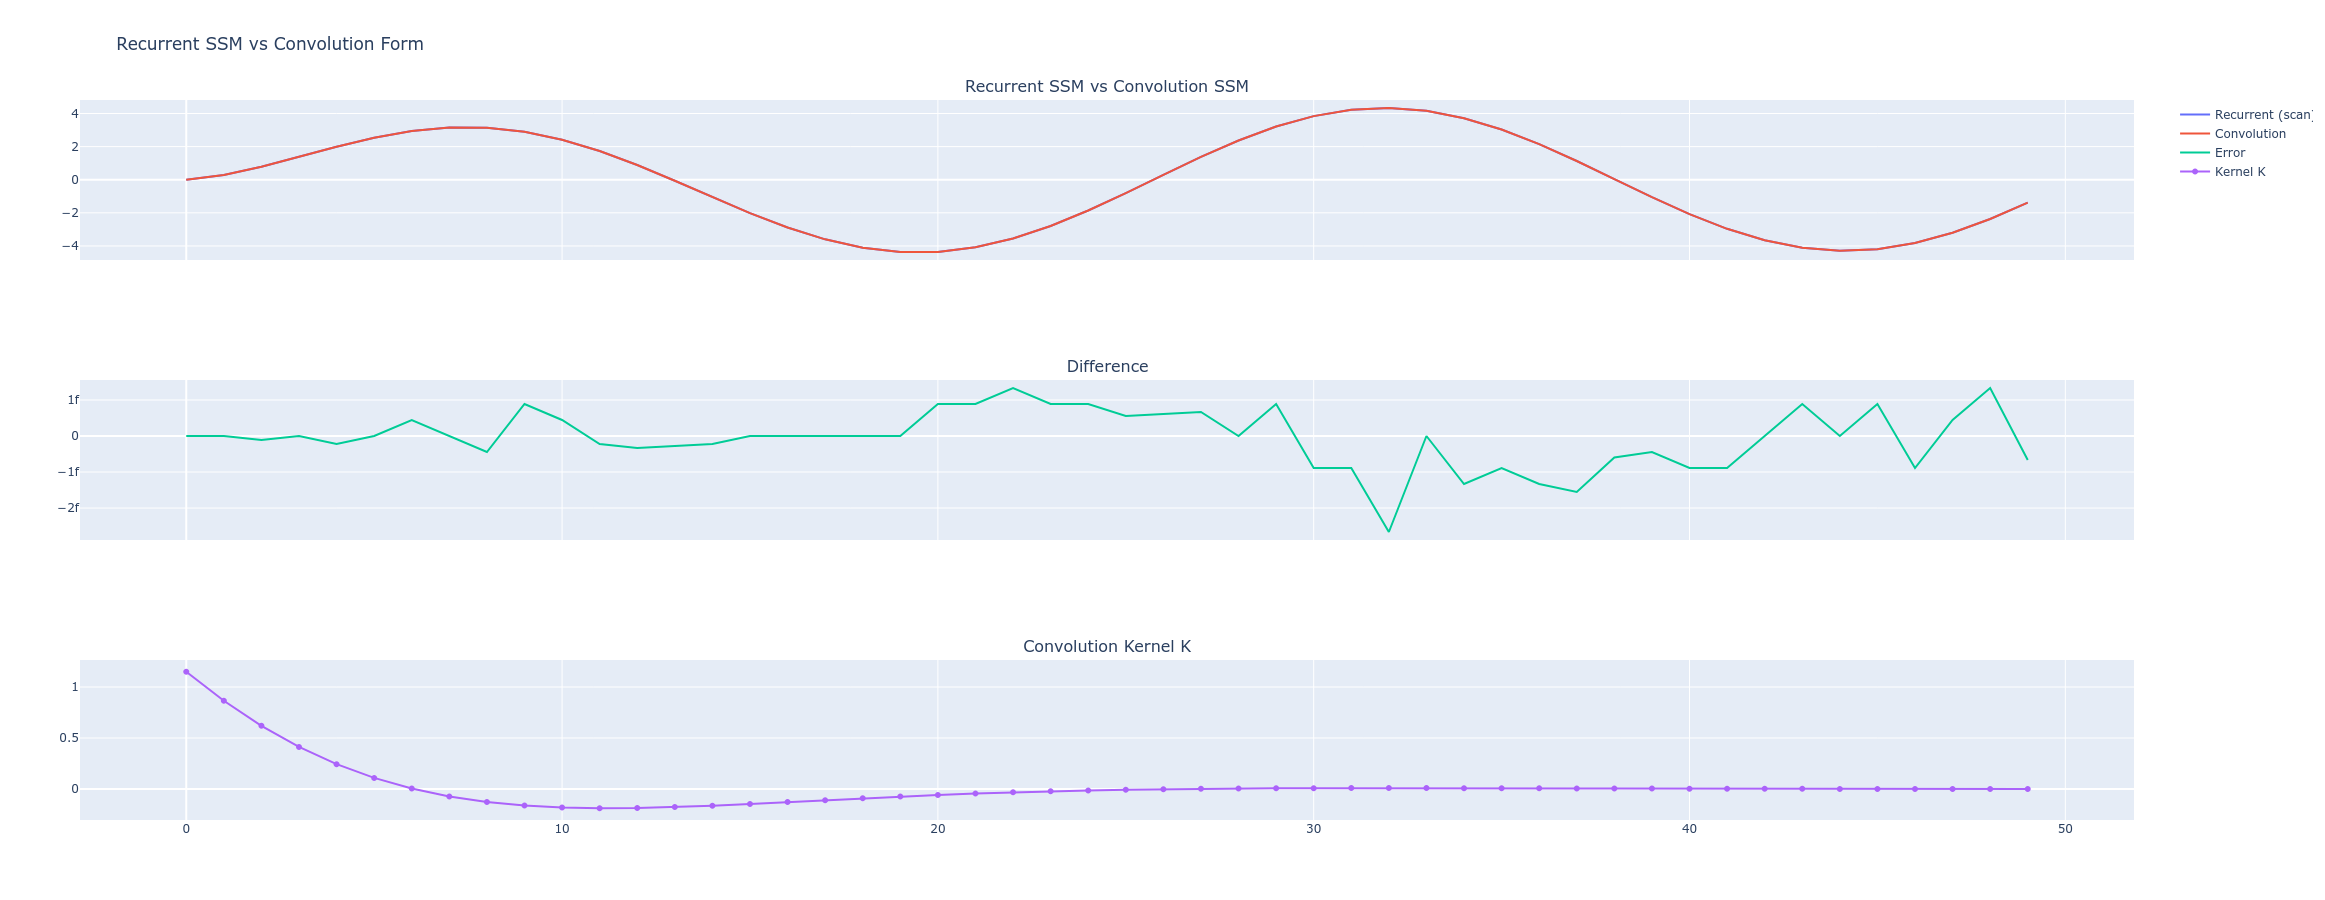

In [25]:
# ============================================
# 1. Простая SSM: x_{t+1} = A x_t + B u_t,    y_t = C x_t
# ============================================
np.random.seed(0)

N = 2     # размер скрытого состояния
L = 50    # длина сигнала

A = np.array([[0.8, 0.1], [-0.2, 0.9]])
B = np.array([[1.0], [0.3]])
C = np.array([[1.0, 0.5]])

# Входной сигнал
u = np.sin(np.linspace(0, 4*np.pi, L))

# ============================================
# 2. Рекуррентный прогон (scan)
# ============================================

x = np.zeros((L, N))
y_rec = np.zeros(L)

for t in range(L):
    prev = x[t-1] if t > 0 else np.zeros(N)
    x[t] = A @ prev + B.flatten() * u[t]
    y_rec[t] = C @ x[t]


# ============================================
# 3. Построение сверточного ядра K
# ============================================

K = []
A_power = np.eye(N)

for k in range(L):
    K.append(float(C @ (A_power @ B)))
    A_power = A_power @ A  # обновляем A^k

K = np.array(K)


# ============================================
# 4. Свёртка (полная форма)
# ============================================

# Полная дискретная свёртка: y_conv[k] = sum_i K[i] * u[k - i]
y_conv = np.zeros(L)
for k in range(L):
    for i in range(k+1):
        y_conv[k] += K[i] * u[k-i]


# ============================================
# 5. Строим интерактивные графики Plotly
# ============================================

fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    subplot_titles=("Recurrent SSM vs Convolution SSM", "Difference", "Convolution Kernel K")
)

# --- Рекуррентный и сверточный выход ---
fig.add_trace(go.Scatter(
    y=y_rec, mode="lines", name="Recurrent (scan)"
), row=1, col=1)

fig.add_trace(go.Scatter(
    y=y_conv, mode="lines", name="Convolution"
), row=1, col=1)

# --- Ошибка ---
fig.add_trace(go.Scatter(
    y=y_rec - y_conv, mode="lines", name="Error"
), row=2, col=1)

# --- Ядро K ---
fig.add_trace(go.Scatter(
    y=K, mode="lines+markers", name="Kernel K"
), row=3, col=1)

fig.update_layout(height=900, width=1200, title="Recurrent SSM vs Convolution Form")
fig.show()


<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAACBgAAALoCAIAAABX20PaAAAACXBIWXMAAAsTAAALEwEAmpwYAAAA
tGVYSWZJSSoACAAAAAYAEgEDAAEAAAABAAAAGgEFAAEAAABWAAAAGwEFAAEAAABeAAAAKAEDAAEA
AAACAAAAEwIDAAEAAAABAAAAaYcEAAEAAABmAAAAAAAAAEgAAAABAAAASAAAAAEAAAAGAACQBwAE
AAAAMDIxMAGRBwAEAAAAAQIDAACgBwAEAAAAMDEwMAGgAwABAAAA//8AAAKgBAABAAAAGAgAAAOg
BAABAAAA6AIAAAAAAADBYqntAAAgAElEQVR4nOzdb3Ab553gecgWadlNZqWZU9uQtVOEHZPeIRxZ
ZgZw2bElIv8zgFKaWodQPJebo0aiUrXUZGm7Tp45nk5hstGWI85U+GJEaYNNzY1D0KmLKgIqyTkO
ZI+cXYMSrckIzJVpSVBqbEGGMpZryI5YUW51JT5Jpw10P2g0QDT+fD8vbIgAuh80Gk8//fye5/es
unHjhgcAAAAAAAAAAMDMLaZ/BQAAAAAAAAAAIJAAAAAAAAAAAABkCCQAAAAAAAAAAABLBBIAAAAA
AAAAAIAlAgkAAAAAAAAAAMASgQQAAAAAAAAAAGCJQAIAAAAAAAAAALBEIAEAAAAAAAAAAFgikAAA
AAAAAAAAACwRSAAAAAAAAAAAAJYIJAAAAAAAAAAAAEsEEgAAAAAAAAAAgCUCCQAAAAAAAAAAwBKB
BAAAAAAAAAAAYIlAAgAAAAAAAAAAsEQgAQAAAAAAAAAAWCKQAAAAAAAAAAAALBFIAAAAAAAAAAAA
lggkAAAAAAAAAAAAS6utnwIAAI1q+/bt+uNjx465WhYAAAAAANDYmJGAhpHP5zVNc7sUQC3kl7ld
CgAAAAAAGpKmadxWA9XFjATUO03TkslkIpEQUQRVVQcGBkKhkNvlAlZEIpGYnp7Wz/ZgMDgwMKAo
itvlAgAAAACgAWQymenp6UwmI/4ZCoUGBgZUVXW7XEDDW3Xjxg23y9AAtGV6JFNVVWWZ2+Vqfpqm
jY6OZrPZgr9Ho9GBgQGXCgWslHg8Pj09XfBHn883NjZGhYNyfeMb39Af792719WyAAAAwP0+DcHj
8SiKIro13C4XUH2JRCIWixX8UVXVsbExYglAhQgkWNI0LZVKzc3NZbNZ08lQiqL4fL5AIOD3+30+
nxtlbH4TExOpVMr0qbGxMb/fX/MSASsllUpNTEyYPkXkDICLYrGYs9SC69evF40ln89HVwUAAK70
aVy8eDGTyUj6NHp7e4PBIH0aTS+bzSaTSdOnFEUZHBz0NIV8Pj80NGT6lN/vHxsbq3mJWoXklmFw
cJB7gaZBaqPSc6CsaJqWWSaGDIfDYfLtVF06nbZ6KpVKEUhAM5mZmbF6KpFIEEgA4JZ0Ol15elm/
39/f3+/3+xkIBgBAvfVpTE9Pk0O4RQJLpk+pqto0gQRJJ5KIqNEWrf0tA+mamwmBBCeX22LZbHZi
YmJ6eppLb3VJhkBeuXKltmUBXDvbWWYcQKMT/RSqqooctW4XBwCA5pTNZmOxmIM+jXw+T58GmoD8
3plAAlAhAgm/E4vFEolEJVsQl965uTmm7diZ3GRnrRtFUazevn79+moUEKgakQzN9KlAIBAMBuVv
l5zStHUANId8Ph+Px1OpFDlq0XwqbPQCwAqlhnfWp0HFBbdkMpkTJ06YPtXV1RWJRORvl/fFcVYD
FSKQcJOmaQcPHnQQtDeVSqUymQx3yCUnN/X395c8ROFwuHjtWYFREmigFs/69etLBhJCoZDV2znb
ATSTfD4/Ojq6b98+0jGjmVTY6AWASmiaFovFrBLXlIs+Dbgon89bncl+v79kICEUCk1PT5uG9gOB
AKc0UKFbKt1A49M0bWRkpFpRBOMdcuUJhRGJREx7GaLRKAskoMn4/X7TdB8+n480IACaTD6fP3jw
IC0lAAAqp2na6OhotaIIAn0aaFBWC0erqrpz5043SgQ0FQIJnhW6Ooo75KpvttUoijI+Pm6cVtnb
27tv3z76VdGUotHo8PBwV1eX+KdY8Wx8fNztcgFA9YnkCW6XAgCAhjcxMZHNZqu+WRFLYLU2NJxQ
KDQ5OamPPVUUJRwOj4+PMx0BqFyrpzaKx+NlXXFVVbUfdRDLHJnGQlGW6DK3SwHUQmiZ26VAM9i+
fbv++NixY66WBU1LWVbwR22ZnbdnMplUKkWlBwCAY/F4PJ1Or1CfRj6fn56epk8DDUdV1bGxMbdL
ATShlg4kZDIZq/z7Rr29vaFQyO/369FLTdOy2axYWFV+DU4kEuFwmLAnAABoPoODg1ZhgMyyEydO
yFtKJ06cIJAAAIAzoqN/pfs0AoEAiYUBAK0eSCg5od7n8w0ODhZfMhVF8S/L5/PxeNxqfVR9LwRC
AQBASxEtpUgkEo/Hk8mk1ctEvIHuCQAAHBgdHZW/QFXV4eFheZ9GKpWSRyOmp6e5UgMAWjqQkEql
5IH3UCg0PDws34iqqnv37lVVVXLdzWQymqYVT/y3yZgfwDSBwIrSD1FzT6povo9pPLeb5kMVp8to
po9W4wNYbmXi+I0tfsYCUBRl586dV65ckWRdmJubc9Y9YbworHTV4W57rAbEB8zn8+qySjaVz+fF
sVJVtdwDVcvvtOlbg2ga+o+ivb29ra1tpffV3HVdC/ZpDA4Oyr9HVVWj0aiiKLFYbIWi/vRpVIgf
Zp1w8aZV3zX343Bd6wYS5CH3QCBQMoqgi0ajmqZJRtslk8myFgfO5/MnTpzIZDLZbLYgy7CiKL5l
5c4ulORxCofDwWCwYO/pdLpg9QixX+O6x3Z2JGnZxGKxghqwoCTiNVaLWBS/WP4xBwcHfT5ftT6m
nTEgdmaiVPh2naZp6XR6bm4uk8kUH3Ofz6eqqjhnyroqTExMWH2Dw8PDJTdV4dv1KbczMzPicxUn
3Xb80arF+A1KFlw5ceLE3Nyc8S9+v7+gWkilUlbTm4pfLA6O1Yru/f39xlQhmUxmZmYmnU4XtA/8
fn9/f7+kJhFpSQpOKjF8KRAIVJiNRJTK9JsVP8Pe3t5gMEhDGWgCg4ODkkDChQsX7G8qk8mIi11x
G0lVVb2BVJUrgqimsstM22OimjK2LiQklbadi76Dt0saUcbXi7ZTJpMxvsC4sIpY9Kvk5UY0hhOJ
hPFY9ff379271/FxdvadVqU16Pf7S6YnrW6jFzDK5/Nvv/12Pp+/evWq8e9tbW3r1q27++67N27c
WG4b6Y033nj77bf1fz700ENr164VjzVNm5+fv3DhwvXr1/UXqKpK6rk6J+mCEFWZ/T6NSCQiKiur
F8zMzJTV/6BpmsiblM1mTe9PRfVeVk0ouR4VVKrikiTiH8X7DYfDkmu35KbM/k26pKgej2dgYKDk
wVyJA+iA5I6+4JJa4duNr5RcT7PZbEEXiqIo+/bts3nwi19s51u4ePGiVTeLg5tWSYuu4K5f7F20
kQrGU4r78Uq+fflHEw1d0QCz2dBF62jRQILpT0WnqurOnTvL2mA0Gj1x4oTV0oKZTMZmIMH0Xs5I
0zRxOUwkEqqqDgwM2Gze5fN5q8329/frG5+enk4kEqYvEzd4YlFEST+7ZEfFG7QqifE1JYttc+/6
t1OVj6mz+WFX6O1W9+2mH0p04tj8XHrx7K/EVd232/lclXy0arH5DeaXGf+yfv364tdYba34xXpt
YPr63t7ekme7mMVsdaqL5pfp9kXUKp1OT09Pj42NOTjgiURienq65BmbSqVisVgwGKz91wqgusQN
j1WVdfHixaq0kURNW5UrQiqVSiaTkvCw3h6bnp4WXRIl22OSStsOB2+XNKL0bR48eLDkZu1cbtLp
9MTEhM1FtnXpdFp09FT3O61WazCRSNSy0QsYzyurJvT169fF7+LMmTMi4mW/9+q9994zbvZXv/qV
ePD666/Pz89Xo+yoKVFTWT2rqmpZHaYiliBG+Zg+m0qlbC65XPJ6bWztl9WnIbkeGStVUb2bXpLs
3OyrqiopvM2ZGalUymojYlRWFQ9gKBQKh8MrNPpKUh3Zuejbf7vNroPic6D4S5ScJ/ZbhmL1kXQ6
XfWbVknxjHf9kltm/UZeLChdbnM3n8/HYjH5Cu16Q1fES+w0dNE6WjSQIF/VwMGdp6Io4XDYavST
nexGmqZNTEzIf8wF8vn8xMSE47684q0dPHhQ0hYpuChWZae1l8/nR0dH7VyiGuJjluyQLSYuOdFo
tKxZMjXmrD+iIT5aLWmaNjo6WvJHXXyqp1KpkkvIiF/T0NDQ8PCw/VZFNpudmJiwU88YB0pkMplw
OCzGSQFoUF1dXSX7duUNnrK60R1fERzsS9Rsc3NzjRX11DRtZGSkkuECunQ6LZkt4fp32vStQTSN
69evv/baa8ZJA3KiD2vz5s09PT2Od1o8IweNIpVKSZ51dkkKBAKSi7VIfyd5uzxGK+/TMF3IYYVu
f/Tqfd++fcWjrUV8zqpxYnNmRsFkdKNAIFDdAxiPx0WYh4lubnWz6Det9qNicrFYzM5p4OB+PJFI
SObKSBq6MzMzg4ODNIfg8Xhu8bQkyX2L4ymc8nfJL2b5fH5kZKSsKILxvUNDQ2VdbEzZvOKWewNW
V0TDwn6x6/xjxpaV29suxOPx0dFRZ+9dafF4/ODBg47LFo/H7XSCtwJJUgvTFrwximN/L/Z7glKp
VFn1jLF4sVhMno8OxYYN3C4LcHPIhdVTJWeejY6OOhvLX+7FLp1Oj4yMONuXqOLqts1QbHp6uiql
FVV0WW/JZrOOj3OFjYTmaw2iaWia9sMf/tB+FEF35swZx7OdRJo4Z++F6yRd1SvUpyE/00SfhrN+
CVHTVt7ar1afhmTSmJ2fWz6flxTD6iCL8jg+gAcPHuR2qXKikeCsm0XcU5fbKCoWj8fLOg0mJibk
YUXjKx0XL51O0xxC685IMM0xpwuHw842q6qqs0nKVbk/EdWB4xG7sVis3AKIWrKsPP6NeM9ctx/T
/tXCSiaTGR0dHRsbq6sc9KlUqvIGUCqVUhTF5tzbZiVGbtp/fSaTSaVSfr/fQdtiYmJifHxcfiLZ
nOUgEY/HNU1r8a+1LMw/RV1x1vMrogiV9Brbv9hVXk2JFl1DjF7P5/OVj0Fx1riq/DsVeQYct82a
qTWIpiFGsxb/Ltra2jZu3Lh27dr29nbxsqtXrxYHG0TPZrmjuYvTayiKoldfmqaJnaI+iZXkrJ7V
886VSyRasKqiJVfSqvRpxONxMZfC8dvLDYyJXuPiG5lgMGi1/oTIVi9vVMjHrZr+VOvhAML+jBYJ
kVbL8UAuZ/0hsVis5GpSlfcgibO05I0/ml4rBhLktXMl8+lKriZnWphqhfVisZhIlFnuG69cueLs
ZlL0PDZKX5Xje+Y6/Jhi9mLl2xGT1MrNnrlyRCLCqmwqkUiUuyB5k3FwJMVCLw6qo3w+L19S3jjj
oRKJRGL9+vXkOAIakWQhBEkC+grHngvZbHZ6eloehnQwrN5qOwcPHhwfH/fUt6q0IoSyhkJX6zvN
ZDKxWMxBaLmZWoNoJiIRrvEviqIEg0HT6lH0IBf89DKZTFtbW1k5jl5//XX9sVhOk76hBiLv66yk
sip3tUgHM70k4vH4+vXrHZRf0zR5/uqybmTk2Y1SqZT8fkRSEqsYTxUP4B133MHt0kpP6F+5cY3O
+kNEUixJ9KJaPUjivr5+epDgilZMbSSpGsTS5LUsjJ1RUSJq3dXVVXJrzu7NRODaGatAfR2qpB/T
WaNkhYjFl+SvURSlq6vLzvJr6XS6WmMSK5dKpSQ/B0VR+vv7h4eH9+3bNzY2Njg4KI8TtPLUTmcJ
K0S/zEp0JI2OjtqZ0dXf319yJEW1cnEAqCX5mrRWv/qS0yVVVQ0EAv39/YFAQF51JBKJktWUnRaU
nakGIm7hqW/VKmG5dfLExETNvlOrAniaojWI5l4yd926dZ/61KesfgJipdZPfvKTbW1txr9nMpnr
16/b3694saIon/zkJ8tatBn1QN7dWbd9GnaGeTlIluD4XYLp7bAkU8XMzIx8g5LLk2mMJB6P2z+A
JX+q3C6t3IR++90szlopJ06ccPzdmU5rE/L5vLwNI27GB5b19/fLG2DpdNpxPj00h1ackSAZE1fj
K27JqioSiYTDYeMM03Q6LcnXJuKQlaT+6O3t9S0TrZOZmRl5RSaGwxgbBMFg0PhPSWi9eGmjmrVf
y/2YIn9ojU8PZ/fAqqoWLFSVzWZjsZikrp+eng6FQvVw8yBpk/l8vn379hkvaX6/PxKJpFIpq19E
ZtlKT0qYnJzUH3/zm9+0+gjFawXX7IAHAgGx7pamaTMzMzav+iJsI855O2+ULCkvbxn39vZGo9GC
r0nM6DR9l1iXnvwSQGORDzswvbymUinJ2lGmVUcmk5H0U09PT1tdEUrewBfsLpvNJhIJyS1ZIpEI
h8P1cGG1SV0mHi8uLkqaynKKoqxfv76jo8O0n0usQ1ib77Ss1qCYjeegNdgQjV7Uv+L8QqFQqCBI
UGzdunWPPfaY8V7y+vXrZ8+efeihh+zvWuyLs7ERSeqrGk8uKTnTKxAIRKNRYx0oaepXpbVf7s2+
SPNVcEHx+/1WQXd5dqNy8xqVnJRffH1c6QPoCmOBRa+X6cv8fv9KLP/m4FuQN1FEv42xr6Bc4n5c
VVVFUfL5/NzcXMkbeau5Mul02qqciqIMDw8XL9Mdj8clB8TmkuNoVq0YSJCMOLvjjjvq5746Go0W
zLATTT2/3z8yMmL1KRKJxMDAgIOmg6Io+/btK6gOdu7cKa9BxHXU+C5lmc091j6JsOOPmclk6iGQ
IB+z7/P5itNAiz9KMuJpmibPS1MPiT4LoggFYzqsgisFJ+dKMJZKcua7crarqlrQcxGJRBKJRMlp
B6qqFuT4lsdshEwmU9wEkQ9/KK7lBFHRHTx40PSUkAQtANShkkvGBQKB4j9KLsqRSMR0zITf75+c
nLS63llFl0smQxgeHi4YP+jz+fbu3evz+ayqUzHyoyHS4PT394sq1/hHB9NbRVrtSCRSUDkbN1Wz
77Sk4lEXzlqDdd7oRUMQPZLGv9iJIhg7JY1dS9ls9oEHHrD5dj1/S5lFRl24cuWK1VM1/k7l1aZp
a19cdyTBV8fVu8gnU3D93blzZ8k7oOKOUTH837TrVty3WhVP0qgovleqtwPoIpu31Tanh1a3myUU
ChVHL/x+//j4uGRNhXw+7zgpYiQSKe7WE/EVSTlnZmZMAwmSjsexsTHTbq5oNCq6iUzfxYyEFteK
qY0k7rzzzprtSwxrklccks7BqqcbGh8fN73SRKNR+RSHqmSRqxnJx5T3pNfJx5S0S8SJYXXRHR4e
lgRCxIpAHldJCmAcKVksFArpH028Usw37O/vb/FbI9NmgaRusYoiCKFQSP5Gq3khVm0deUnk53MD
JVUDWpYYojg6Oiq/QzYdnSepOnp7e+XNksHBQatLhmlJJKO0RPPA6g5QTBu1emND3GINDw/v3bu3
+PiXe/VUVXV8fDwajRa/Uf+L5DsNBAKOv1NnCX/HxsYaujWIZvLGG29UMpa8u7vbGDa4fv16wQYl
ap/UF7W5dVq/fn3NiiG6Sq2eFclSJAFdyZZLpg8ytW/fPtOrdiQSke/unXfeKWvNaknxJA2A/v7+
sg5gIBCQHED5nANul6rYzWJ18iiKUjyO0+ZmJUQXXPFmg8GgvCfQqpXS29srAmNifoP+dz0Dgf24
l0DurBbXijMSJCd9LWckyKsqya2pPDwu7qnKHV1uTKBULBKJJJNJq+MmGQ1Rb6LRqORjRqNRSU66
eviY8hzTAwMD8uD84OCgVap6+agK1+XzefkIdNGKavGwQQFJckPxi7a6/ejt7ZW8cXp6WpJ70X5F
V7KW019j2vHnoJZrQcbbkoYYGY1GFIvFTH+k9m8wTH/LkjbS3r177YxGPHjwoM1cBPL2mLyqES0H
01pxbm7OU98kMZKyWIWfC0iOc8mFPcV0B9PBpDMzM+XOUSvZGpRcIuuhNYhmomnae++9Z/xLua3x
9vb2np4e4w2C/ep348aNZe0LKCZJQihqVMmzYuCX1dUhlUqVm7FZLLdm9WwoFDpx4oTV3bRpTj9x
72P6+nQ6bVq8bDZr9RtUVbW401Y+7EB+fRStFKsSMofbPslYBzHqomQTRfIt5PP5sqZQyBufPp8v
HA5bRYmsWi/FjWfRwSIvmCTG4PogVLirFQMJdUIypknSkacbGBiwuurkl5VVW5lOgDLq7++3qhwb
KBpZPASgsT6mvJ0hiRgLIgRt9UFcz3Mnb+WMjo5aZTcqN4SQzWblTV4Jm0uE1QPJj1okWLCqguT9
Sn6/3/7RE/lGHddy4qy26qOkZVySMeUXgQSsEG2Z47erqmp6clpVHSXXY9dfZjNqLqmmrIIcxUue
mtaK9dBskCgZI7Gv5DiGqnynoVDINJDgYCSEndYgAzlRGwUVxdq1ax20bXw+X0Eg4fr163ayG9U4
qS+akmRgfsklW/XOffvrFlTYpxEIBMqaLyiu8qZvsepykWzfdBCVJMpu5/poda9U/yMF64rk9tZ0
4mxZo/TS6XTJM9OoZPMsGAxKWik2ewLtvKbOm7JwEYGEekwHb6fHR8x7taqtMpmM/W4jn89Xsh5p
gnmvdj5mnaevlTTUbGY4DQQCdZvnTvRuW12ustns0NBQKBQKBAJ2vkqJbDYrz7Mh1yitMflvVnK2
yI9tWfecklrO5mGUfArTJRkANBAxH9zq5ryS1ojkglJwUy3PVGOnphoYGDBd40E09uo23lnF+tPO
UZKM0JQkjnD2ncq1SKMXjeLtt9+uPMuuWKvDeFf4zjvv2Jlt0N7e7mB3gM1bSDs1s7iHterTKKt6
t5Oqy8F9nCT2YNpBLLlhN73yStohJcPe+kWtbkcKNgrT+Sj220vi3LM6T8pNiljyNK5NK0UsJV2D
HaERtWIgQVLV1izmJq9N7FQN8tpKUhWabqoqr6lzdj5CnQcSJKM+bd6H+/1+q0BCPQScJTNChNQy
fWaoWAuh3GSyqBlJRXfixIkK834woRJogiiC6WVXcj2q/K6mIDWNpJqyGbT2LfM0GpvNhpLkixjp
5AsD2swXVJV0Q03QGkQz+dWvflWV1PYFM01pI7UCSW1WsxOg8j4N0VNvNSq/rB7YFerTsJoPZ7qw
rWSao+n0Avm0TpsHsLe31+oiu7i4aGcLkCcLqTDgVFbXnJ3vvbpdH+IkFMk/8/n8lStXxOAPriOQ
aMVAQj1cdOXrytqsGiRtTa4ZTUne32FnC/I8d+VmxKo6+azA4vGq6XRaBB7ElMNAIMAQ9boi7w1c
uY0DqHM+n0+SrU7y684uq2TXBQ0kyb5quVhl7dU4AF/L7xRoIAWN3o6Ojqr8on/5y19WVi40AMks
4Zqt5iK/a7N5fyq5/ayHZWkk2Y2KF14qa5nlakVifD6fVSSm3C7s1iQP59jsHpE0q+rwplV0pMzN
zUkmjAISrRhIkNwZ1qyqrbyqqv+LLmp52tjsEajzkftihUwHo03z+byYrCAiCjbzNWOlrWholptk
oBGJJenkqy+u6C1NQQOp8gsrXL8cMGgOjavg7HVc7RS8sWCiA5qS5GanZj2Dkh1VpU+jTqp3q8Hm
xYsQyBMRl7VT+7VBPQyTbWjyo2TzTK7/01jIZDLT09OuJ7VGo7vF03rkF93a/M6J+8EV8hZJPZyW
oVBocHDQ8dtFRGF0dFRkQEITYwgq0IgikYg8igCUi7gymoadFZIBOx2X9XBbV7k66YENhUJWN9EF
kYOy8hoxmqEhNM0Xkc/nR5cRRUDlWjGQIJ8jJlmxvYqapj5CM6mT0zISiUxOTlayMFQ+n5+YmEgk
ElUtFwCgUDAYHCgiuZokEok66RcAAKBxye+VatOn0SIkyzgbx65JssTYWTYZ9ak5Wq0iikAIAdXS
iqmNxNKsVjXCiRMnQqGQsy0PDQ1ZPTU8PGy82Fclh1pzVGqwT3Le2jwZ5GdXnQQSxBCbsbGxTCaT
SqVmZmacneqxWMzn8xU3slVVddyYa8QVNdGyjh075nYR0PwCgUBxq0lVVaskdZqmxWKx4eHhhrgY
AcCKamtru379uv7Pgnzr9pHLqAWJhRWt7pKK1wG2b2RkxGqzAwMDxot+VZLqVCU/0kobGBiQZDcS
d4iSXlqrqM9KdwrRoKqc42q5royOjto/o1RV7erq8vv9oVDoT//0T1e4aGhIq1s2pGxV0WcyGWdL
zoo3SnYq+aezi65kIYTmXiGwZa86ksaizQtDowQSBP8y8eMSizFms9myFjKZnp4ubrfpm8VKk1Sk
+/btY2VsoFmFQqHp6WmrK04qlerv75fUw5KL0cDAQHUzI0mqKZYorM1xHhwcdNzbBTS69vZ2YyDB
+NiVtRbQWAKBgNUqu5llDm55xA2Xzcpcnl7J5r2wpPdDsqB0/QxFzWQyIpBgtUBCIBCwOlDyTieb
vVL2+6Dg4Chls1k734L9X03tpVIpeS9Qb2+v77dEhLKGpUNDasXURqI2lzwbi8UcbNPqKm46G04y
rtl+TkNJbcW46XpQMiYk+QbL/VptbkryMmWZ/cLYOUurlZ3T7/dHIpG9e/f+9V//9bFjx8bGxgYH
B/v7+0telTOZDBN3XMTaX0DLks85mJ6ednaxq3o2/HpYrNKmeitPtY6zZFgM0PTWrVtn/OfVq1ed
bee9994z/pNuoBYhH5Qjv9RaSSaT9i/Q8nsxm/enkrD9nXfe6akPiqJYzWgX8QNN06wGqkq+ppJd
2BUewJXuFLJzQ1f/N32KolTeGpR8C64HEiQ/apEH4itf+crOnTtDoZAImNW2dGhILRpIkCyYI1IK
lrtSq8jBYj9uIQ/02clpmF9m9SyBhHpQ8tpfbiBBMtHEagSE/ZeVe86ULPzK5eDT4wqTk5PDw8Py
azOpAF0kGQbFUF+gucnnfomRklbPSmr1cq+bJUkKKekUMPrmN7+53YK7bYa6UvlICKApFQy4dhwv
LIhA0BPUIvx+v+S7zmQy5a4Yl8/nJX0axbuT98DOzc3Z2aPkUtvb2+upG1bxADFwzepTKIoiyZtd
+QGUt1W6uro8K6lklZXNZus/kCBvpdjsZpF8C+52zYnsW5IoAqka4ECLBhIkIWUhFovZv7ERK7tK
XmB68aiwtnI8mg81U/J7lI/4KGs4g53+DnlDTT5Nx8Gnk8zRqaJQKCQf99oQbZdmJYmYlhusBdBw
BgYGnDVjFEWxug1DN6UAACAASURBVKup+h2pfGCHncu01dWweLPyrr2qtxnqiqSvpFF6GYCVUDDg
+q233nKwkXw+b8yJ1NbW5voAWNSGoijhcFjyglgsZr/JLZZjlbzAtP9E0tdvJ4whv4Gtqz4NSdgm
nU5L8hrJNyt5QSqVKnl9lI9ArUofsaT10jRNF8lpbCfDgTzJebndLNUl6dUMBoMlk2utTKHQ8Fpx
jQQhEomcOHFCsnTtyMiInbStmUxmYmJCvkaQaQ0eCAQk6zSk02lJr3HJHmHGodSMqqqSNNDhcNiq
ARSPxx2kNpIsk2C6HkDBCyTPmp5vPp/P6tPJM2+mlnnKEY/Hf/nLX4pPJ3aq73p8fFxySvv9fsm3
gPpckEbTtFQqVXJle3FLo+fdEl1+d9xxhxjdQ0UH1P+kBElTR1IJ9Pb2WlUdyWRSHqKQVx1+v7/g
utzf3291o5tOp+U5piVpZ4uv/qI8VhfxRCIhSdkXj8cb/TLX399v2g5Zie8UaBTr1683rrd8/fp1
B2v1FdxQ1E82GNRAJBJJJpOSjs6JiYkrV66UrGOz2ezBgwflfRqml+xQKGQ1ekzTtEQiIelO0TRN
cn8qbvE89cSqwTAzM2N1X1/yZicYDFo1QuxcHyUHUF3mqZiqqlafTt5tJU/aUVdCoZAkvfn09PTg
4KDk7ZL3SgbHuK7khBVSO8BKi85IEBWiPIAvaoSRkRGr6k+EEEougG5V9ct7weTBiVgsJnm2UZYw
tTNZr/7J712tGmSJRMJB2kr5TJpMJiPZpjxhl1VDTb5q98GDB02vLqlUysFCIydOnEgkEiICIaIU
In9XPp8vOZZB0nqukwZoc5ztDkjavvJ6TBAVbDabFadEKpUSvx077wXgupJ3v1a1t6TfIR6Pl7yx
EUs926w65K0mSXssn89LLrumA9Dk61JaNSljsZizVNd1RXKc7QytKOs7rUNkcIKp9vb2gn7/cjtu
itNWrHQyE9QVRVFKBgni8fjQ0JCkT0N0ejjr05CnVxJVt7Nn5Qkk6upClk6nTT+I1YhS+/GSRCIh
uXzIBxmUPDFskncITExMmM6KSKfTBw8e9DTI9VTe3S/6KJy1YdydjiAnTzUsb+WixbXujAR9UoL8
kpnNZicmJmKxmFjB3JhGxs5E7P7+fqsotJiKaPXjFPeTY2NjBdcVTdOsKmv5YAG3SBoWiUSit7dX
r7I1TWvE8cW9vb2SryOfzw8NDYVCITFNRNO0ixcvptNpx9c/MerE6tl4PG7aaCgZt7BqqMnDJOIs
DYVCvb29qqqKdcJnZmacxa4DgYDVR0skEoFAQDK3Q/JjrOUoRUkrUGQp1bvGGvRsd0AMFDU94cX5
Mzg4aNoo1zRNMjBKVVXGn5ZkzLknzwAGrBC/39/f3281VlHEiU1vdMUdndXV5ODBgwMDA6bBBjG8
0ep+z/RGUT5zQgyEHxgYKGhclZyQalqz9fb2ShoApm2GRCLRHJl/fD6f5DiLy4FpC1b+naqqWj8D
aOS9acaZE63TDEBJ3d3dxoxG+Xz+jTfe6Onpsfn2V1991fhPRVE2btxY7TKirkUikZL3XyIV88TE
hLHbWkSh7MRie3t7JT0MJfs0ilv7omKX5D6qtz4NY9TE/kXZ5hoP4XDYahCefgALjoadA1itgfCS
ORP6LVswGAwEApV3COgkl0hN02Kx2MDAgHhNta6nAwMDkjJPTExomlbc8ozH4/Julmg06nGVpIMi
nU7rh7GsO3GgpQMJiqKMjY2NjIyUvBjYXHCvgKqq8opDPhVR3E/6/X69l1b0QctLW63Ic7V0dXVZ
3TOL66I+07+3t/fZZ5/1NBr5PDjHeX6sqKo6MDAguVzF4/FUKuX3+7u6uhRFuXjxohi+J9lmIBCw
aqgFg8FYLCY/5ar16eTzOkdGRkKhkDFVlGj7Tk9PSz5df39/LW/U5bMfxJBSvfX593//957WMDg4
aJVxNZ/PHzx4UHQ16tNvs9ns3NycPCtovVV09cn4wySQALdEo1HJkjmJRCIcDptW1MPDw0NDQ5J7
yGQyKS4KetVRstvdKvej/O5R9L9MT0/7fL6urq4rV65kl1m9Xlx9TK8I8rvxqrcZ6s3g4ODIyIjp
U2KgTDKZ7O/vL+s7raueJnmjd2RkpNEbvVgJov1j7K85c+ZMe3u7nQETmUymYJnlus2hgRU1PDxc
Mk2C4KxPY+/evY5HZ+qtfb1P48qVKyWz/9dtU18SNXF8hRKdQlYHUL8+6j31dg5gOByu1rx8eXZl
Ib2sKrvTdyp5NrFMfMB8Pj8+Pl75CDP5sBJxL59MJoPBoJj1dfHixZLfQiQScT07giSvphgrs2/f
voJClhwrA7R0IEFcF4eHh1di1pWIUsgrDkVRSu5dzOC2uVPJBAi3+Hw++aK72rLGzf0iHzUpJ7ok
yl2UuORMmnw+b78PQlGUnTt3Sp4tq7VkpKqqVUJkZxdvvW9FbzSU3GaNhwCUvHnTz3ZRftcbFrXh
9/uDwaCkcVlWLVe3Y5QASDJJOsj/q6rq4OCgJFSfz+fLSqMnGd7h9/slhdR3l8/n7dwnK4oi2ZHj
NkN/f/+VK1caOl+tz+eTH+eSERrTloanARu98nwCaDXBYPCHP/yhccHkdDr9q1/9SjIv4fr166+/
/nrB74X5mi1LVdV9+/aNjo6uxAy24n5G0z4N+ULNZbX2JaPcXOf3+23e3pY1J6DkASzr+ujz+Uqu
9GlfLTsEjG8sGb3QewOy2WxVqr7h4WH5ION8Pm9nCXHjAFBPHa9ZKA7d0NCQGMChKIrIIdkcE2Gx
olp3jQRdMBgcHh6u7rBlO1EEfe/Vql9UVZX0CLvF/oKoYh6cpwHJ196RKLlKh+TsqtYZOzw8LD9R
I5GIs305OLFt/hJFb07Jl0Wj0Rr31JfVXmzozqCqn2blnv9V2RSA2ohGo/I8h1ZVeiQSqWLWmsHB
QUlFtHPnzmqN5B0YGJDsyHGrz/XZ8VVRxeNc3YtLjRu9NlsyaBGKojz00EMFfzxz5oxIj24MMOgT
5Y8fP17Qq6goSv2k+ULt+Xy+Kt4hGiMEdrpo/X5/c/dpFAwIqGJeI32zjrsUTKNKnqpy3CFQSUDI
fldJtW6rxSDjqmyquj02FbKz1rpYULM4fzvBaZgikHBTKBSy2e9vh6qqZc2uikajlV93VVWtn6qq
3AWgGr1r1efzObjwRyIRx1fWan3dw8PDJW85FEVx8OnkmTRrcBpHIhFXhgDY32lLjUa0H1utzXYA
1JIYy2b1rMjza/WszS6Mqlzv9u3bV/m+otGofBigmP3gYLNNU/VV5TiL77TesriU1ehl+WUULyJS
8EdN09Lp9P+9TKTyEA8ymUxBdKGtrc1+HAvNyufzjY+PV7FPY2xszP4NXRX7NOr8emczQlDunICq
3L2u0AEUIaVy3+Xz+Sr5RPbzAlXxtloMMm6yO1b70a8C0WhU5HECChBIeF8Mv/L50ZFIxMH1u8Lr
biAQqGKjoers95g3btdquRf+UChU4aCDCluKZTUNQ6FQWZ/O5/M5zvxblRZwNBqt1piOctkfj9Og
YTPHxClXyVg5sQWGRQCNSD6WTYyBMn1KUZTx8XFnE/j0Ldi83olXVrKvwcFBO5eAnTt3lhVrL/cq
XOdq+Z3Wc6O3QVN6wpW+nuvXr4u8WAXxA0FRlE996lNEEaCPaKykgjV2L5Tb6q7wFqy3t7euul+t
2KnkneUZEwfQ8W95RQ9guYk0Kp8YoSjKvn377ByN6mbjqXCQcbmjimujZIKypm98oroIJBSuIzQ5
ORkIBBxX3I6r/mg0Ojk5WW6oUASHn3322TpvOw4PD9uphhp6cJb9C38kEqnKpDlVVScnJx3U7yLc
VdbJFo1GbSYQiEQiFc4qEP3FzqJ64mfo7jXP5pnQgvkHRYPSQSYKMcazDttkAKoyKcHj8cjz5+7c
udNZEpv+/v6yGldi3SAH++rt7R0fH7c//NBmu0hMCmzKxdIdf6eRSMRBg7mWhoeH7fTiNXSjFyvE
7/eXm0Kkp6eHKAKKL2STk5OV3Ew57l4QVXS53SniYveVr3yl/qMINpPZOo7liPv0cr+72hzAaDRq
sz86FApVZZyrGOxrZzvVvaT6/X4H3RH6HWsdnsZiDIf9T1StDis0q1ZfbLmYqqrPPvusWEclk8mU
HCMvFpAJBoOV93CJ/tNMJpNKpWZmZuSdjL29vcFgsIEmsUaj0VAoFI/HrT6aoih33HGHp5GJbM7x
eHxubq449a2iKOJUqe7drziwqVRKvgKz3o8TCoWcXdtCoZDf70+n08lk0nRHvb290Wi0Kp9ORPWi
0WgqlUqn0yV/hit0bFfoTBB6e3s1TWuU328VhZaJM7bktIze3l4HN9UQ6moNUiASiUiuU2IZRkkd
rlcd6XR6ZmbGTtuskuudzWpKUZSuri5n1z69XSRpM9if19+IHHynjXI52LlzZyQSae5GL1aIoiiR
SEQsrCpp2Le1td15553d3d1NXEWgKjdTooIt2eRWVTUQCFTlZkp0pzRrn4YQCATkh7TCSdjiu5Pf
S7pyAEWvl1WHQCWNIis+n29ycjKVSiUSCas+gZWoBsv6FhqiiaIoyt69e/1+v7xxW8UuHTSxVTdu
3HC7DHVN0zTRkjMuBSzWNBex6JWrLDKZTMF+xU5Xer81IFZxyefzmqaJet+3zNNEROtfbznV5gPm
83n9dNV3rZ8zVbzEFn868aPw1PBnuEIfrerEsRKHS1m20oergejfrPF0apqKDsDKMW0j6W2zKl4U
JNWUuLJXpZpypc3Qst9pjbVCoxcrRNO099577+rVq8au2LVr165b1tbW5mrp0EiMN1P6fSJ9Gg1B
tBCMkcU6OYA17hAQfR060UJQFKU2B6H4W2iUvgibvUbiswSDQX6SsINAAgAAAAAAAAAAsMQaCQAA
AAAAAAAAwBKBBAAAAAAAAAAAYIlAAgAAAAAAAAAAsEQgAQAAAAAAAAAAWCKQAAAAAAAAAAAALK22
fgoAADSq7du364+PHTvmalkAAAAAAEBjY0YCAAAAAAAAAACwRCABAAAAAAAAAABYIpAAAAAAAAAA
AAAsEUgAAAAAAAAAAACWCCQAAAAAAAAAAABLBBIAAAAAAAAAAICl1dZPAQCARjU8POx2EQAAAAAA
QJNYdePGDbfLAAAAAAAAAAAA6hSpjQAAAAAAAAAAgCUCCQAAAAAAAAAAwBKBBAAAAAAAAAAAYIlA
AgAAAAAAAAAAsEQgAQAAAAAAAAAAWFpt/RQAAGhUqVRKfxwKhVwtCwAAAAAAaGyrbty44XYZAABA
lW3fvl1/fOzYMVfLAgAAAAAAGhupjQAAAAAAAAAAgCUCCQAAAAAAAAAAwBKBBAAAAAAAAAAAYIlA
AgAAAAAAAAAAsEQgAQAAAAAAAAAAWCKQAAAAAAAAAAAALK26ceOG9bMAAAAAAAAAAKClMSMBAAAA
AAAAAABYIpAAAAAAAAAAAAAsEUgAAAAAAAAAAACWCCQAAAAAAAAAAABLBBIAAAAAAAAAAIAlAgkA
AAAAAAAAAMDSauunAABAo5qYmNAfDw8Pu1oWAAAAAADQ2FbduHHD7TIAAIAq2759u/742LFjrpYF
AAAAAAA0NlIbAQAAAAAAAAAASwQSAAAAAAAAAACAJVIbAQAAAAAAAAAAS8xIAAAAAAAAAAAAlggk
AAAAAAAAAAAASwQSAAAAAAAAAACAJQIJAAAAAAAAAADAEoEEAAAAAAAAAABgiUACAAAAAAAAAACw
RCABAAAAAAAAAABYIpAAAAAAAAAAAAAsEUgAAAAAAAAAAACWVls/BQCA+3K5nOTZjo6Ozs7Ocrc5
Pj6eTCY7Ojp2794dDocrK2ALyeVyBw4cmJ2d9Xq9X//617u7u90uEQAAAAAAqIVVN27cqMmOAAAo
Wy6X27Ztm/w1nZ2d3cu2bNnS19dXcpvJZPLAgQP6P1OplINQRGs6cOBAMpkUj71e7/Hjx90uEQAA
AAAAqAVSGwEAGtvCwsLs7OzU1NSePXu2bdum93RbuXTpkvGf8/PzK1zA5rG4uGhzpggAAAAAAGgm
BBIAAM2We+fAgQMLCwtWr4lEIvoUBK/Xa2cSQ9PL5XJ/9Fuzs7NWL9uyZYv+OBqN1qp0AAAAAADA
ZayRAABoDPv37y9ezyCXy126dGl+fn5qakofI59MJmdnZ59//nnTnEVer/f5559PJBKdnZ0skFCW
cDjs9XpnZ2c3bNjAoQMAAAAAoHUQSAAANDDvsr6+vh07diSTySNHjohwQi6Xe+aZZw4fPmz1rt27
d9e8sM2gb5nbpQAAAAAAADVFaiMAQJMIh8OTk5Pd3d3in7Ozs/F43O1CAQAAAAAANDwCCQCA5uH1
eg8fPuz1esU/jxw5Ilkswb6FhYVcLlfJpirfgphmYXMj4pWeptBMnwUAAAAAgAZFaiMAQFPp7Ozc
v3//nj17RPf91NRUcRajPXv2XLp0yePx7Fhmup2FhYVkMvnKK6/Mz8/rffednZ19fX1//Md/vHXr
VjuFefnll+PxuHELIhFTOBy2ShCUy+WGhobE48nJSa/XK1aQ1jfS19dnmrJpYWEhHo8nEgljt7u+
Lz24UlC88fHxgj8+88wzHR0d4vGGDRuM+zKW7dChQ/fdd1/BG9944w2PbeUe/O5lu3fvNv0sAAAA
AABg5RBIAAA0Zx7/2dlZsfBycSDh0qVLorfdanT//Pz8008/XTwQfmFh4eVlO3bsGBkZkZRhfn5e
9P4X/D2XyyWXhcNhqz5x436TyeT4+HjJWQjxeNx0+sXsMrEmRPHyyIuLi6afUbI7/fX/+q//WvzG
sqYOWO1ldnb2wIEDxZuaX5ZMJksefAAAAAAAUF2kNgIANKEtW7Y4TowzPz+/Z88e47vENAJjp//U
1NSBAwfkWzBGETo7OwtiBslkcmhoSF42MRehZBThwIEDhw4dMr7M6/V2dnYWbOfo0aOeupdMJgsO
fvGhm5qaevLJJ6uStAoAAAAAANjBjAQAQBPaunWrnrRndna2eDC+xNNPPy06qTs7O6PR6I4dO/RO
+VwuNz4+/vLLL4su756enmg0WvD2XC63Z88evZs7vExPZDQ7O3v06FExW0L075vmKRIOHTqkF2Pr
1q2iGAUd6EePHk0mk+KxmHmwZcsW8cpcLjc7O3vkyBHRL3/kyJH77rvPmJRJlE28ctu2beKPhw8f
tkq7JDcyMlKyc/+ZZ54Rr/F6vZFIxHQah3gsPnUkEhFRhIWFBfGs+Czz8/Nf/vKXn3vuOQflBAAA
AAAA5SKQAABoQmJIvuizfuONN+wHEpLJpD4c/vDhw93d3QWbfe655/bs2SMiAUeOHCkOJAwNDen9
6fv37y/YtUi7dOjQoXg8LuIKIs2RaWHm5+e7u7u//vWvG4fkGx/Pz88fOXJEPA6HwyMjI8aJCF6v
V8Qw9KkPX/7yl/v6+oyvqaKCY1Xs6NGjxiNTnNbp6aef1ksu1ofQnxKrUxw/fvzAgQMicPLyyy/P
zs46i3kAAAAAAICykNoIANCc9G7oxcVF++/Slwvu6+uz6hnfv39/X1/frl27ikfEG+MQIyMjVhGC
p556Si+ePp/A9CMURBEK6LMuvF7v/v37TSMEYiPGRYw9bkgmk3rMY9euXcUBAOOhK4giGO3fv1//
XhoiWRMAAAAAAE2AQAIAoDnpveplBRL0F0uy9Hi93sOHD+/evdu0N1x/zY4dOyQ7Em+Xzw8oWJih
gMhcZEyCZKW7u1sPabzyyiuemhMpocTjrVu3Fi9/LaZ3iAfhcFjyqUWERjyYnZ1lpQQAAAAAAGqA
1EYAgCZXVl+zPtp9flnJdD0FO9J79k37yo309Qnkr5E8K5ZqEGW+77775JvasmWLCHKIzvcVym5k
amFhQU/35PV69TCAkXFN7JKHrru7W89b9corr5S1AAYAAAAAAHCAGQkAgCZXVqe5MXKwZ8+eeDyu
d3CXND8/rz/u6enxrLDXX39dPHjooYdKvthYnrKmaFRufHy8ZM4iPaNUZ2enfDqCeE1HR4d4fOnS
pWqXFwAAAAAAFGJGAgCgySci6J3OdvT19UWjUbES8sLCwqFlYr2ELVu2iLHwVu81hhxKThGonN6H
/vrrrx84cED+YmPw4NKlSyU766vl6NGjerqnXbt2We3XGIMp+VmM7Id5AAAAAACAYwQSAADNSe9i
LrfT/KmnnvJ4PCKWIMwum5qaEpGGcDhsunqB3rNfm256PVIisjB56s/s7Kxx5QNJziL9s7i4HDQA
AAAAALBCaiMAQBOan5/X+6bLWudAeOqpp55//nnT5Puzs7MHDhwYGhqiv1sul8vpcwuslkZwK9sS
AAAAAAAoCzMSAABNSF/02PFyBd3d3fuXiekIr7/+ujE4ofeSG4MNGzZscKVb3M66zUYOIisOPP30
02JSSGdn5+TkpHylCn0Oh9fr3b9/v/296MccAAAAAACsHAIJAIAmJNIQiU7zChMN9S0Tj2dnZ5PL
xD/Hx8e3bNmid5HrizEsLCtrkWcHNmzYIHrqOzo69BLWiaNHj+rZliRLI+iMx6rePgsAAAAAACC1
EQCg2SSTSX2BhB07dlRxy319ffv3749Go+KfCwsLr7zyiunUB+OUiBWir+f85ptveupJPB7Xl0aI
RqN2vgJ9kkQul9OnfQAAAAAAgDpBIAEA0FRyuZzei+31esvK+WOTcdFgfYFlsTt96L1xrWarcorJ
DY7XWti6dat4MDs7Wz+d7wXHX7LAslF3d7c+KYHFJwAAAAAAqDcEEgAAzSOXyw0NDenTEWz2YusW
FhampqaeeeaZbdu2SbrmJTmL9LiFWFlBsq8jR44cWKZnYSqXsfP96NGj8hcfPXp0z549U1NTesYh
K5XEJBYWFoaGhsQW7CyNoOvs7NQzGk1NTcnLkMvlnnzyyfHxcfkR1jStzOIDAAAAAABzBBIAAM1g
YWHh6NGjTz75pB5FiEajDqYjjI+Pv/zyy7lcTtI1b5xtULBw8Y4dO/Su8wMHDuiFKSDWWhCPI5GI
x5HOzk49ydLU1JRkDkQul5uampqdnR1fVvwCfXUHj8dTMtIgMT4+rn/kkZGRslan0D9LLpczLaTu
6aefnp+fn5qa2rNnj9UR9ng8qVQqk8nYLwAAAAAAALBCIAEA0BgWFxdzRebn55PJ5IEDBz772c8e
OXJEH8keDoefeuqpcndRMC7eNJYQj8cPHTokHnu9Xj2/kL6FXbt2GadHvPzyy8VbeOaZZ/QtbNmy
xePUjh079M76Q4cOGfvxdbOzs/osAWN/fUGxjUmZ9CBHWbMTjh49qr9x69atfX19uVKMb+/r69PL
lkwmt23bVvxZcrncnj179FBHNBqVxCo0TctkMolEIpvN2v8UAAAAAACg2KobN26Y/BkAgDqQy+W2
bdtW7rui0ag8iqB3Uu/atasg/ZFIm6N3oHu93p6eHrGscS6Xe+WVV4x964cPH9YDD0YHDhwwJvoX
G/F6vWJxZuMWnnvuuYJQhPEjW21fks1J9Mh7vd7Ozs7i3RV/Xt3U1FTxPIC+vr7Dhw/bKdv8/PyT
Tz7pKYfX6z1+/HjBH/fs2WNMWNTd3b1hw4b77rtPBB6MT3m93ueff16SOsk4RcPn8/n9fkVRyioh
AAAAAAAQVv/m/wAANL6+vr5du3aV7HyX8Hq9hw8ffvrpp0XXvOi/Lp5V0NnZOTIyYrWj/fv3e71e
fUJD8eh7fQsFUQRnBZ6cnDTGEqxWDpBEEcTkBjG9w/hH+2mOqrXa8+HDhw8dOqTHAOaXFR//vr6+
5557zuYCDB6PJ7uMcAIAAAAAAM4QSAAANLDOzs6Ojo6+vr7u7u5wOGy/Z1miu7t7cnLyyJEjBcP5
9T1Go1HjWgimdu/evXXrVtMFgTs7O7ds2bJ79+6ylhAoObQ/mUweOXLENGLR3d1tJ76yf//+vr4+
40YWFhbefPNNMSGjZp566qmtW7cePXrUNCLS19cXXuZgy9lsNp/P+/1+n89XjZICAAAAANAqSG0E
AICl2dnZXC536dKlzmXdy8rawsLCghhWv7CwsGHDBq/X293dXZWAh6n5+flLly6JmQSOdydKq2/B
4xJx6MTx37BhQ0dHh8gQZfPtktWnFUXZvHnzxo0bq1dYAAAAAACaGYEEAADQhCSBBIFMRwAAAAAA
2ERqIwAA0IrEwgl+v7+np6etrc3t4gAAAAAAUL9ucbsAAAAArslkMj/84Q+z2azbBQEAAAAAoH4R
SAAAAC1N07R0Op1IJDRNc7ssAAAAAADUIwIJAAAAN8MJiUQinU4TTgAAAAAAoABrJAAAAPxGNpt9
6623enp6/H6/22UBAAAAAKBeMCMBAADgd65fv57JZBKJBAsnAAAAAAAgEEgAAAAwXzghlUqR6QgA
AAAAgFU3btxwuwwAgBYSj8fdLgJQHp/P5/f7FUVxuyAAAAAAALiDNRIAAABkstlsPp/v7u7u6elx
uywAAAAAALiA1EYAAAAlaJp25swZFk4AAAAAALQmAgkAAAB2keAIAAAAANCCSG0EAABQQltbW09P
j9/vd7sgAAAAAAC4gEACAACAjAghtLW1uV0QAAAAAADcserGjRsu7RoAAGClxOPxyjeiqqrf71dV
tRolAgAAAACgUTEjAQAAoJCiKA899NDdd9/tdkEAAAAAAHAfgQQAAIDC5RB6enrIZQQAAAAAgEAg
AQAA4Dd8Pp/f71cUxe2CAAAAAABQRwgkAAAAsBwCAAAAAACWCCQAANCEtm/frj8+duyYq2Wpd21t
bQ899JDP53O7IAAAAAAA1CkCCQAAoEWxHAIAAAAAAHYQSAAAAK1IVdVgMMhyCAAAAAAAlEQgAQAA
tJZ169Zt3ryZ5RAAAAAAALCJQAIAAE2IdRFMtbW1+f3+np4etwsCAAAAAEAjIZAAAABaQk9Pj9/v
ZzkEAAAA7O/AvwAAIABJREFUAADKRSABAAA0OZZDAAAAAACgEgQSAABA01IUJRgMshwCAAAAAACV
IJAAAACaUFtbm8hl5HZBAAAAAABoeKtu3LjhdhkAAACq7Pr16yyHAAAAAABAVRBIAAAAAAAAAAAA
lm6xfgoAAAAAAAAAALQ61kgAAKAJDQ0N6Y8nJyddLQsAAAAAAGhsBBIAAGhC+Xze7SIAAAAAAIAm
QWojAAAAAAAAAABgiUACAAAAAAAAAACwRCABAAAAAAAAAABYIpAAAAAAAAAAAAAsEUgAAAAAAAAA
AACWCCQAAAAAAAAAAABLq27cuGH9LAAAaEj5fF5/rKqqq2UBAAAAAACNjUACAAAAAAAAAACwRGoj
AAAAAAAAAL9z7tw5t4sAoL6sdrsAAAAAAAAAANy3tLQ0MzOTyWTOnz9/6NAht4sDoI4QSAAAAAAA
AABa2tLS0iuvvHLy5Mlr1665XRYA9YhAAgAAAAAAANCizp079+KLL54/f97tggCoawQSAAAAAAAA
gFbMYnTq1KlLly65XRYADYBAAgAAAAAAANAq3n777UwmU5zFaPXq1bfddpumae4VDUD9IpAAAEAT
Gh0d1R+PjY25WhYAAAAA9ZvFaNWqVW1tbe3t7bfeeqt7RQNQ7wgkAADQhDKZjNtFAAAAAFBHCymf
Pn363XffNf791ltvFSGENWvWPPzww3fdddf09LR7xQRQ1wgkAAAAAAAAAE3o3Llzc3Nzp06dMs1i
tHr16q6urscff7yrq8vj8Vy8eNG9kgKodwQSAAAAAAAAgJbIYtTe3n7bbbetWbPmwQcf3LRp0113
3eVeGQE0EgIJAAAAAAAAQPNkMTJdSHn16tXt7e1er/dDH/rQgw8+uGbNGveKCaDxEEgAAAAAAAAA
WiiLEQCUi0ACAAAAAAAA0KjOnj178uRJSRajhx9+eNOmTWvXrnWvjAAaHoEEAAAAAAAAoHmyGLUt
8/l83d3dZDECUBUEEgAAaEJjY2NuFwEAAADAijh37pyYglAQQmhra2tvbyeLEYCVQCABAIAm5Pf7
3S4CAAAAgGpaWlo6e/bsqVOn5FmMgsEgUxAAVB2BBAAAAAAAAKAhsxi1t7e3tbV1dXWRxQjAiiKQ
AAAAAAAAANSjc+fOvfjii8VTEMQqCKtXr77//vsDgQBZjACsNAIJAAAAAAAAQB1ZWlqamZnJZDJk
MQJQJwgkAAAAAAAAAPWexei2224TCykHg8Genh73ygigFRFIAAAAQKG3/vmf3S5CY1uvqrfddpvb
pWhaV999V9M0t0vRwD7wgQ984N/8G7dLAQAoL4uRoij333//pk2byGIEwBUEEgAAAAAAAAA3sxid
OnXq0qVLxr/fcsstbW1tZDECUCcIJAAA0IQmJib0x8PDw66WBQAAAICJq1evzszMyLMYPf7440xB
AFAPCCQAANCEUqmU/phAAgAAANAoWYza29vvuOOOBx98sKenhxACgPpBIAEAAAAAAACo0ULKp0+f
fvfdd41/v/XWW0UIgSxGAOoWgQQAAAAAAABgBZ07d25ubu7UqVNkMQLQoAgkAAAAAAAAADXNYtTe
3n7bbbetWrUqGAxu2rTprrvucq+MqKajx5PZ366b/cC99+z4+MeKX/M309/JX72q/3PbY48+3Nvr
aXDGD9UcnwgFCCQAAAAAAAAA1c9iZLqQ8urVq9vb271e75133vnzn//8k5/8pHvFRPVl37509sIF
8Vhdt674BVMvvvTj07P6Px+4957m6HM/e/6CHkgIfbjP7eKg+ggkAAAAAAAAALXOYnTx4sWf//zn
7pUULjh+8tVv/+gl/Z/qunVfGnjC1RIBdhFIAAAAAAAAACp19uzZkydPWmUxEgspb9q0ae3ate6V
EW66cOnS0eNJ/Z/qunVf++Ju01kLQB0ikAAAQBMaHh52uwgAAABAq2cxalvm8/m6u7sffPDBNWvW
uFdMuCx/9epXv/V/Gf/ypYEniCKggRBIAACgCYVCIbeLAAAAAFuWLl/+7//+3+v/3DwxsXbzZldL
BLvOnTt3+vTpTCZTEEJoa2trb283ZjFyr4yoF8/+7RHjAss7PvGxB+69x/SV2tLSj0+dvnAppy1d
064t+TZsWF5H4Q+LX/m9k69q15bE44f9vfds8J49f+HHp2fzV69+9MN9H/1wn3Zt6XsnX9Vf//lP
3Fz5+ez5C6/N/Sx/9V2x8c8+9qgknqEXRhReUhg0PQIJAAAAAAAAcCgbi+mP1z/2WMd993ma3dLS
0tmzZ0+dOiXPYhQMBpmCAOG/HE8YowjbHvvI5z9+s0/ffBGFF1/Sln4THhD9/sdPvnpzNYXoEw/c
877Yw/GTP9E3q/7eunRmTl+AQV237mYgYenalGFJhs9/4mNTL75kXKRBbPzzn/jYDrPyTP3ope/9
w6s2C4OmRyABAAAAAAAADl00BBLW3HVXcwcSJFmM2tvb29raurq6yGKEAlMvvvS9kz/R/3nPhg27
toVNX/k309/58elZ06fyV6/+5d8e+dLAEx/9cJ/pCzLLcxHkJfnx6VljFEH37RdfUm5fs+0jH6lW
YdCUCCQAAAAAAAAAMufOnXvxxReLpyCIVRBWr159//33BwIBshihwGtzPzP23avr1v3Vn/3Ppq+c
evElY8f9A/fe49uw4eYWMnP6tIOjxxMP3HuPaSai1+bmShbm6PcSHo9HWY5yGecZiFiCMZBgszAP
9/YqtxMzaxUEEgAAAAAAAAATS0tLMzMzmUyGLEZwIHspd/b8BeNf/vf/9QumYQDt2tJLho77HZ/4
mJ77aNe28Fe/9Xevzf1MvOx7J39iOqFBu7Z0M+PQwBP33L1Be/+Mmd+9Zmnpz7eFP/ZHH1bWrMlf
vWpctkG7tpTN5Xxer5hwYFWYz3/8Y1/91t+dvXDhN4V59VWrHE1oPgQSAAAAAAAA6s6vFxfPPvus
/s/NExMejyf3/e9f/sEPli5fFnmE7vr0p72f+YzxXYtvvvnmN76h//Pf/eVfrvF633rhhSsnTy5d
vry6o6Pjgx/0fuYzxes5nxke1h9vfOKJ9Y8/bnz2//3qV8VOPR6P2GlB8YS3Xnjh8g9+YLqFZspi
dNttt4mFlIPBYE9Pj3tlRL27cOlSwV9+fOr0n2+LFL/ytbnfjfRX160r6J3/0sDnov/H//mbLZw+
bRpIUNet+9oXd4sohZhzUOyjH+777GO/mXYgog5/efiI/uz5ty+JQMLZ8xesCqPcvuZL0Sd2/qf/
/NuPM0sgoXUQSAAAAAAAAKg7v15cfO/MGeNfzgwPG/+ylMu9d+bM4rlz9+3dK3nX2Wef/cXJk/o/
F9988/IPfrDxc58zvsvj8RjfddenP11QmPf+8R+XcjnxWAQhind0c+PnzlltoWmyGCmKcv/992/a
tIksRnDgeyd/EvT3Fi9TfOHt34Uc7rnbK4b8Gym3r9Gu3UxGpF1byl+9Wjyt4WF/r+lcB6OP/tH7
ljR44F7z1ZL/e+ZnxtdICpO/etW0MGhKBBIA1M6777772muveerPZ94/hAdoAhPLA9aEYcPgMgAA
ADSoi7FYcce9mASwuqPDNzho+q7sf/2vxiiC8V0ej6cgltDiRBajU6dOXXr/KPJbbrmlra2NLEZw
TFmzxrggwd/Ev/ON//gXBUsLZC/9JlC3vA7Bz14zdOUXe8es795qFoIDvzTMwvnx6Vn5Gs4Fay2g
iRFIAACgCaVSKf0xgQQAAIAm8M/LXf8d9923uqNj8dy5Xy8s6E+99cILVoGEy9//vsfj+Z8ee2x1
R8fS5cvGUMRbL7yw/rHHinMc2bS6o0NMOxC5jIS1mzevuesuj8dz+/J/G8XVq1dnZmbkWYwef/xx
piDAAZFx6Hv/8OrxV38i/pK/enXqRz8yTXDUiBYt1mNA8yGQAMAFGzduvP32290uhedf/uVf3n33
XbdLAQAAAAClre7sfOBrXxP9/kuXL5999tnFN98UT/16cXHxzTc77rvP9I1/9K1vdXzwg+LxxVgs
G4vpT105ebKSQMK/+6u/KggkFK/Z0LhZjNrb2++4444HH3ywp6eHEAIc2/XZyM1lBj7x8dfmfqYv
PFCc4OgOQyfJA/fe4y/KfWR0Zw1TCdVVYeAuAgkAXHD33Xf//u//vqcOEEgAAAAA0BA2PvGE3um/
5q677tu717g88oJFIOGuT39ajyJ4PJ6uwcGrZ87o8xJ+8Q//0JrZjRYWFl544YXLly8X3BLeeuut
IoRAFiNUxcP+P3y49w9/s0bx+1c2/uq3/u6bz+7TExzduW6t/tRy4MHNFYzV31vnuVAvhUH9IJAA
AAAAAGU4d+7csWPHlI6OP9m+/a6Gyt0BoKF1vj9OYHMmQfH8gHWbN+uBhKXLl3+9uLi6o8PTMk6f
Pn3ixIlEInH9+vVHHnlE/ztZjLASlDXvm2ew7SOP6gmOtGtLf/PCC3/1v3xB/POeDRv0V742N6dd
ixQsovDtF1+6GW/4vXXK7bc/cM89Bc9W1wP33KOvi+B6YVA/CCQAAAAAgF2XL19+6umnNU3zeDw/
+clPnv/7v3e7RAAgI1YsMLrN6zX+89cLCy0SSDh9+vTk5OTp06fFP8VUg1WrVrW3t4uFlB988MFN
mzYRIcbKKUhwdHNR5bmfiSkLD/t7lURCu7akxxh2bbuZE0msZjz14o++d/I3EQh13bpv/uX/tqLl
rKvCoH4QSAAAAAAAu37605+KKILH43ln2Z133ul2oQAAlhYWFr797W8///zzC4blqUUIYc2aNe3t
7V6v90Mf+tCDDz5IFiOstOIER38z/cI3/uNfqOvWKbev2fHxj/+X44nfxRgyP3vg3puLE1x4+5K2
dLNPX9j22KM1KKdpYbRrS++8+66xMGQ9aikEEgAAAADArkcfffRvDx9eXFy8OaN/mdslAoDy/H/v
709f3dnpafYsRgUhBGHVqlU9PT0PPfRQV1dXR2vMyUA9MElwNP2d/7Rnt8fj+exjj2rXrk396GbW
IOHs+d+uVPBbH/1w32cf+0gNymmnMNse+8hHP9xXg8KgThBIAACgCQ0MDLhdBABoTh0dHYcPHz72
3e96PJ7tf/InbhcHAEq4cvLkv/3c54x/ufrbBRJu9gp1dJjmNVo8d874z6XLl5dyOU/jOHHixLe/
/W09i5GptWvXfuELX5iYmPjOd76zefPme++9d3BwkIgCap/g6Oz5C8dffXXbR26GBz7/iY/d+Xvr
vv3iS/qzOmXNmh2f+Fhtogi/LWcdFQb1gEACAABNKBqNul0EAGhad9155xe/+EW3SwEAtrz1wgve
z3xGjxYsXb78i5MnTVdsXuP16tGCy9///r/93Of09RUuf//7nkbOYuTxeNra2v7gD/6gZ+PGmbm5
X/ziF/rfzy2HTM6cOZPL5fbu3VvzIqMJ/flnI9q1a+Lxnb93c12BAsrta772xd3vvPu73nnjYsUf
/XDfRz/cd/b8heylS4vLqxR03L7Gt2GDSHNU4EsDT+iPzfe15nYx3aF4SWfhfc/eXfis48IUbwpN
gEACAAAAAABAc1q6fPnUn/3ZB//iL9o6OhbefPNiLGZ8dv1jj+mP127efPm3gYRfLy6e+Q//4a7P
fMbj8bx35sx7hkkMxVZ3dPx6OeGbx+O5GIvd7vVeu3zZ++lPe2ro9OnTx48ff/nll01DCB/84Acf
7+l59AMfWPgf/2Nmbs747PDw8JkzZ/7xH//Rai7CD37wg82bN7MCM+y7Z8P71jM3pa5bJ9YutvLA
vfeYdtYXv0z+AuX2NfLX2NxLVQqDRkcgAQAAAGX76TLx+Atf+MLNHAiLi989duz8+fMid/y99977
J9u3l7zrvrmVf/on/V0dHR0f+tCHHn3kEdM33tzFcj4Zkaf+3nvvXVxc/H9efPGf/umfxNsfeeSR
gvf+9Kc//cl/+2/nz58XG3/kkUc++YlP2Pl0+rvEZ3n0kUc2bdpUzhFCM/vud7+rn+ePPmqy4KE4
My+cP3/5nXfEX+69995NH/qQ6YsBYEWJeQaZZ581fer/Z+9uwJq687zhHyuElwQBUZIAyltSrKJJ
fMORt6JWilN11Vpn26p3nXta50V7P/eMc6+d3Wlndq07Y7v3qts6ts/olHa7rfjyqLO+UK0i4kCL
JlFUaAKSKnCCIrGcQBJQn4v86/GYBAwkJCfh+7nmmiucnBz+lojw/53f9yexlwoIaVERt/PAQtNs
1SFcKqXu37fQtMtPIZLL2UqDhabV69ZRFBWrVPa+aoh1dHSQKQguU4zGjBmjnDhxblKSIjw8bMQI
iqJqrVaHc2R2y5c/vJOaS6/Xb968ubcXTSJRKpV5eXlKpRLxRwAwPKGQAAAAAAADptVqiz/+mDxe
tWrV/v37PyouNpvN3BP279+/dOnSn/WRAEPT9JZ33mGrEayKioodO3bMnz9/1cqVDuUExmxmP6lY
LBYKhb/81a+MDzZq2U/6+9/9jtQY/rhly7lz5xwuXlxc/O477/RV4dBqtX/csoV7TfayYrG4nxfC
sLJv/37yJimcP9+5NuD81wHvIgDwo6feeOPSxo1sxwArXCpVbd/OPRKjUqWuWXPt0ZYFIvWVV1qO
Hu2rkJC6Zg0pHnC1q9XSoSwkPDbFaHZ6umrs2AlhYaSEMDg6nY48oGn6mB1FUbm5uZs2bfJs+QAA
gecJfy8AAAAAAAJbxblz7+/Y4bBtSuzfv//9HTucj+v1+tfWrnWuIrBKS0vffOstctO3S8bWVocq
wvfHjcZf/upXDMO8+dZbDlUEhxOcnyouLnZ5TfaFa3/6U7ZNAcCl4uLivv46sG8/uo+dOACAoRAu
kcz4y1+4zQEhUVGSoqIZu3ezIxBYKWvWpK5Zwz1ZJJertm/nNi44i1GpVNu3i+Ry7kHrkH2vq66u
/slPfpKXl/enP/3JoYoQHR09efLktc8992Z29v8YN45tRBi0oqKiPXv2bNy4saioCGVg4CetVnvw
4EGTyeTvhUDwQ0cCAAAAAHjk/fffpyhKoVDMf+YZ0jew/8H92qSW4JALRHb52Z1WhUKxdMkSmUzG
MAxN0+/v2EFeW19fv//AgVUrV7r8pBUVFUajkf2kDQ0NZ+1HyPV/+atf1dfXC4XCZUuXisViiqIu
Xrx4vLSUvNZoNJaWli5duvSRC547x7Y7kBemp6dLJBKGYUpLS8lryZU/+fhjZBqAS70tL5ymmaVL
l+ZkZwtFIiNN79+/n7yLjEbjlnfeefedd/y9WADgkXCJpODsWfePs/p/lnudH5SUMDpdD8OEiETh
Uik7e9lZypo1KWvWkJPDJRK2qODQvuAgRqWasXt3D8Mw9lv4uS/0lo6ODjIFwc0UI2+RSCRFduRO
CJ1O5/LHAL1ev3v37pycHAxUAB8rKyszmUyNjY2vv/66v9cCQQ6FBAAAAADwiNFo/PWGDfM5sweW
LV365ptvVjxoCKg4d45bSKg4d44tM6xatYotFYjF4t4ceYXi5ZUrScfA8ePH+yok1NfXc19LUdSS
pUvXrl1LXlhfX9+bIfPuuxJ7FaE3gqawUKFQ/HHLFvKh9uJFh0ICKYeQZXBfSEod7GvJKIi+VgXD
XOkXX7CPue8iUXr6hg0bhELh/gMHyJ2DRqORlLgAAHzGoWPAiyezQkSiGJWK8m2KERmkPD0qKk0g
oIYYGajg8imdTlduxx2oIJPJUFSAIaXVakkvQn5+vr/XAsEPhQQA4CkrY/2mtLb/cwSisJGCkVHi
UVGSqMjYSF8tDSAAfPbZZ+zjH/3oR35dCwS/wvm9HA5u2LChYskS8tghLKhw/nxZerq+vr6hvt55
R14kEs1/5hmy32o0GhmGcXnfn1gsdnitRCxmX0iKGdxiAEVR8+fP/6i4mCxGr9dznzpeWsou8mc/
/anDC8lr9Xo9uXjv7IclS9CUAM7YyKzedhand9GqVavEEolELFYolSKh0B8LBAAIMNXV1Tt37uyr
BSElMfFpmWyKUJgYGkrxgFwuJzMV2IEKKpVq69at/l4XBLOysjIS6qVUKv29Fgh+KCQAAH9ZzVZ3
TjBdbydFhYQpiWPSx/hqdQC89vnnn7OPUUiAoeZcRSD1gPT0dDJRwGHXnmyzpqen93VB7h692Wx2
uWXvPOGWXNblY5ZSoWADjrjYaQoKhcLllSmKWrpsGSkkMAxTX1/P7bEAINj3qtFopGna4S5UkUi0
7NE+GAAA6CfF6PDhw3V1db5MMfIEiT+iaVqv15eXl6vVapqmc3JynM/s6yYJgIFCOwL4GAoJABAk
bIy18VxD88WmCfMnCIRh/l4OAMAw0lfP/iB+STYajRqNxuVev+PFH3dD94A+Ozv2WTFlSl/ncG8w
RyEBXEpPS6uoqGDHaSxdulSpUPRTMwMAAAfNzc2HDx/uP8Uoe9QonrQgOJPYkfqBXq93+TNSeXn5
9u3bVSpVTk5OVFSUP5YJQQLtCOBjKCQAQFCxMdba0lrZ03IkHQEA8J/RaDxbUdFQX6+vr2cYxiEB
yUPuFxIYO/K4+OOP2WG5/b/Es9VBcFq6dCkbk2U0Gnfs2EFmdyuVyilTpqCoAAC+ERIV5fVBx3xI
MSqUyzMiI3lbQnDW1zQFtVrNMAw7UCE2NpZhmAULFmAvGAYE7QjgeygkAECwsTHWutKrk57LRF8C
AABv0TS95Z132D4A/2LMZn8vAYKESCR69913d+zYQfoSCLPZXGH3/WyPVasKXaWBAQB4i0gm+0FJ
CRUgyCDlQ4cONTc3Oz8rlUonyeV8SzHy0AsvvBAVFaXRaMhAhfb29mPHjkmlUhQSYEDQjgC+h0IC
AASMmHGx42aMZz+8a7t713bXdP226dt2q9nGPfOu7e61imsZ8yf4Y5kAAPAYNE2/tnatmbN9LxQK
JRKJLD1dLBYrFIpz587t27/fL2sTi3un4T7+NDfOgeFJIhb/7q23tFptaWmpvr4X91mj0bhlyxaj
0eg8ZhwAYLiprq4+derU4cOHAzTFaNBkMtm6devIT0Tl5eV79+69f/++SqVyPlOn05nNZmwTgzO0
I4BfoJAAAAFjpGBkGLfJwB6OHSWOGjc9ufliU7O2iXtyh/G7W/W3MHsZAICH3nzrLbaKUDi/l8O8
AR93KnCHHxTOn79q1SpffnYISgo70u9Sr9drtVo28qg3Qau4WDFlCsZsAMCw1X+K0USZbE5q6lMC
wZiQIN+zkkgkM2bMaGlpWb9+vcsTSkpKjh07JhKJyEAFuVzeV1ySVxgMBp50i8JjoR0B/CLIvykD
wDCRMCXxru2u8SrNPWispVFIAADgG4Zh2Hu0C+fP37BhA8UDYrGYbPJqL17091ogqIiEQlJUWLVq
1fvvv7//wAFyvOLcORQSAGC4ISlGfQ1SHj9+/JRx43ITEyeEhQVNipGHNBoN+dmJHaggkUheeeWV
oqIi734ig8Fw+vRpg8HQ09NjtVq9e3EYunaEv/u7v/P3WmB4QSEBAILEuOnjTd/e5mYcdd3u7DB2
RImj/LouAP8oKCjw9xIAHj+QYMqUKS7PqW9ooHwre/ZsssNbbx/77HJQM03TRqMxPT3d/THOMAwZ
jUa9Xq9QKJzfJ6tWrWILCWbM6waA4WTYphh5aM+ePRqNpry8nB2oQNO01HuTtC0WS5VdV1eXzWaz
Wq3379/31sVhqNsRku38vRYYXlBIAIDgEf+U9Hq1gXukg/4OhQQYnvrqjwbgFe6YBBZN09xBtb6R
nZ1NdngZhnl/x45fu+qTKC0tLf74Y9K+8Pvf/S49Pd3HiwSe09fX//KXvyTv6lWrVjlPQaAfRBv1
BjSiHAUAw8OpU6c+/fTTvlKMlBMnzk1KmhAWNuqJJ/yxugCgtCM/opCigst0o5KSEoZhVCqVm0E3
BoNBo9HU1dUxDNPT02Oz2RxKCOnp6YWFhd77c4D32xGefvppf68Fhh0UEgAgeMSMi3EoJHS2d/pv
OQAA4IJELBaJRIz9dux9+/fPnj2bO9xYq9X+ccsW369KoVBkz55dce4cKRiYzeafrl3LLoxhmOKP
P97Pmf+MKgI4k6Wnj3iQxbF//36xWFw4fz77LE3Tb775Jvth9uzZ/lgjAABfUoxmjB8/MyEBKUbu
E4lEOXYunz169Kher9+9ezcZqKBUKlUqlXPJwWKxGAyGyspKNsWop6eHe0J4eHh+fn5ubm5ERMRQ
/mlgkEwmE9oRwI9QSACA4BEmChspGHnXdpc9gkICAAAPLV2yhNzabzQaX165UqFQkHHH+vpeZJue
naPgMxs2bNCvXUsmJVTYkRQjhmFomuY2T7z77rs+XhsEilUrV76/YwcpPm3ZsqW4uFgmk4mEQva9
TRQ6DRgHAAga1dXVpAUBKUa+FBUVRX5o4Q5U2LRpU25urpspRunp6ZmZmTNmzEAJISDaEdAvAn6B
QgIABJWQ0BBuIeGu7ZHbKwAAgA9WrVpFG42lpaXkQ61Wq+U8u3Tp0vS0tC3vvOPjVYlEonfffffN
N99kN3ydixlCofD3v/sdKXsAOFu6dCnpXyEfGu0czpk/f/5Pf/Yzf6wOAGAIdXR0kCkI/acYKcLD
0YIwFLZu3UqGM5eXl+v1erVaTVGUSqUiKUaVlZV1dXU9dn2lGKHbkv9MJhP5qbn3LhxORy+Az6CQ
AABBZaRgJMUJ3OYWFQAAwIuEIpH4cfvpErGYtp/j/KvOrzdsUCgUxcXF3G1WoVC4etWqpUuXVlRU
9HVx9rjLiHnR41bFLtvlb18SsXjnn/50vLTXo9WN3s9bOH/+0mXLREJhv39oGBbY94/z+3DVqlXz
Cws/Li4+W1HBbWQRCoUymWyVvQXHt4sFAPBzitHk1NQ8sRgpRj4eqFBTU3P58uXa2lqDwdDd3W2z
2UiKUW1tLelgGDVq1PPPP48Uo0BsR8jPz/f3WmCYGoGB7ADgM7dv366srKQoKisrKy4urv+TrYz1
0oERIjdbAAAgAElEQVRHNnHi0sekzk7r/1VX/lrjEGc0feXMvk7W2VEUtWDBAvf+BAAAw8WN69d9
84nq6+vJvASJRPLYyoQvMWazkaYZhuktTkgkA60fjI2PDwsLG7LVDXftt2+7nNTNN0ajkaZpHr69
R40aNSo62t+rAICAV11dvXPnTpctCNHR0ePHj39aJosLD7919+6SqCiKH2qt1jePHbt16xZFUQkJ
Cf/93//t3/U0NjYeOnRo/fr1XrxmPylGd+/evXDhAnumSCSSy+U5OTlFRUUiV7doAH+YTKbi4mKT
yaRQKBYvXuzv5cAwhY4Ev2F3MAHAixxaEAQitzZxjhw5MmQrCjZyO3+vAgCCB2/76EVCoYiva4NA
Ibbz9yoAALyso6Pj0KFDp0+fdifFqNZqvXUXbeI+YjAYTp8+TQYp22y27u5u7rPh4eETJ07Mzs4+
e/asTqcjAxXUdrm5uSgk8FxVVRXaEcDvUEgAgKBiNVu5H4aEjvTfWgD86csvv2Qfz5kzx69rAQAA
AIDgTzEig5SnR0WlCQR+WuAwZbFYtFptbW1tY2MjiTAiKUas8PDw/Px8NsVo+fLlZKCCWq3WaDQd
HR0uIx81Go1MJkOBgQ9MJlNVVRWZjhATE+Pv5cDwhUICAASPDqPjj7NudiQABJ/t27ezj1FIAAAA
AIAhSjEaM2ZMSmLi0zLZFKEwMTTUH6sb7tN3XaYYEenp6Xl5eZmZmf0MVHCJYRgSuKRSqchF+jkZ
hlpZWRl5gHYE8C8UEgAgeLTV33Q4EjMu1k9rAQAAAAAACIYUo8OHD9fV1T02xcgfCxy+uClGVqvV
uQVh5syZmZmZg86Q1Ov15AHJPtq7dy8pKmzdutUby4cBl4vQjgB8gEICAAQJm9l6q753ZBZXlJgv
Q70AAAAAAAACRX19/YkTJ/pPMcoeNQotCD5GBinX1tbSNO1OitGgKZXKXbt2kewjtVrNMAxFUS0t
LR7/CWDA0I4A/IFCAl9gfikMB7dv366srByKK9/t7tGddpxePiZ9TJh70UYLFiwYilUFB0yGBwAA
AAAYPh6bYlQol2dERqKE4GM0TWvt+kkxKiwsHHQLgjOZHXegQl9nbtu2berUqUqlEgMVvA7tCMAr
KCQAQMDrMHZcO9dgYx4Zs0xRlHRKop9WBAAAAAAAEHiDlA8dOtTc3Oz8rFQqnSSXI8UoKFOM3NHP
QAWNRrPXjtwjq1AoMFDBi9COALyCQgIABAwbY23jhBdZGavVbGXoDqvZsYRAUVSCItHNdgQAAAAA
AIBhq7q6+tSpU4cPH0aKEQ9TjNhByt3d3Xfv3uWeEBsbO3PmTM9TjDzU0tIikUhommbb2ffu3SuR
SPbs2ePHVQUHtCMA36CQAAABo8PY0WF0/NHWpcjYiAS0IwAAAAAAAAw2xWiiTDYnNfUpgWBMCPaO
fMpgMNTW1mq1WrPZ3N3dbbPZhjrFyBNFdnq9XqfTnT17lgxUQHa3V6AdAfgG/xgAQLCJHRebPDvV
36sA8LPMzEx/LwEAAAAA+Jti1Ncg5fHjx08ZNy43MXFCWJh/U4wYq5Wx2SRRUdSw8dgUo/z8/OnT
p48ePZriGTJQoaioiIQduRyWoNfr33jjDaVSmZeXJ5PJJBKJP1YaMNCOADyEQgIABI+Q0JFSZaJ4
An4cAaD++Z//2d9LAAAAAAB+CaAUI7qj45dHjtAMc/LHP+Ye17S0nDMY9Ldvy0aP/tmsWVQwphg5
D1JOSEiYYeffFCM39TUgQa1W0zR9zA4DFdxsR4iOjkY7AvAHCgkAEAzChGFxsjHxE8QhAnxbAwAA
AAAAeMSpU6c+/fTTvlKMlBMnzk1KmhAWNuqJJyh+2Hf5Ms0wYs6N7YzV+tuTJ7UtLeRDbUtLdnKy
QiqlApnJbtu2bQzD9PT08DzFyENyubyoqIiUE9iBCkajEYWEftoRlEol2hGAP7DjBgA8FSIIeeyc
g5GCkDCRIGJ0ZJgQc5UBAAAAAAAGlmI0Y/z4mQkJfk8xciaJispOTmZ7DtgGBYVUmj569HGd7vlJ
k9Lj4qjAZLFYDAZDZWUlSTFqa2tzmWLk90HK3qW06/1q0rRarSYDFXJycpzPZBiGpmmZTEZRw70d
QaFQ+HstAA+hkAAAPDVSMDJBgYHJAAAAAAAAA1ZdXb1nz57Kykr+pxi5tGzSpEKZbN+VK6tVKoqi
itVqmmFWq1Srpk6lKGr11KkigYAKxhSj9PT0zMzMQEkxGhyJREJGNJOagfMJ5eXlmzdvlkgkSqVS
ZRfEAxXq6urEYjG37QDtCMBbKCQAAAAAAAAAAASDjo4OMgWh/xQjRXg431oQHFQYDH88c4ax2Var
VIzNdlynoyjqPkWdNRgutrTQDMPYbL/OzQ2gUcykBaGurq7HLrhTjNzncixzeXk5aVzgDlR49tln
ly9fTgUdmqY///xzhUKRn59PygYHDx5EOwLwEwoJAAAAAAAAAABBnmI0Oz1dNXYsD1OMXNK3tTE2
G/uYPChWq7nnFKvVv87Lo/jNYrFotdra2lqDwdDd3W2z2YZDipGH3njjDY1GU15ezh2o8Oyzz1LB
iBQPtHYKhSI5OdlgMFAUNWvWLLQjAN+gkAAAAAAAAAAAEKiqq6t37tzpsgUhOjp6/PjxT8tkM6Ki
eJti9FiyuDixSGS0Z+CIo6IkIhEZuSzkd7qROylGM2bMyMzMRAnBgUgkyrHjDlRQ2UOuHJSXl9M0
rVKpgmOgAiknkL+5WVlZ/l4OgCMUEgAAAIJQTU0N+zgzM9OvawEAAAAA7+vo6Dh06NDp06cDPcXo
sUQCwb/98IfGjg6JSCS2Zxkt/vhjxmbLSU6meMlgMJw+fZoMUrbZbN3d3dxnw8PDJ0+ePGPGjOGW
YuT5QAVnR48ePXv2LDktmAYq3Llz5+DBg2zYEQBPoJAAAAAQhP7pn/6JfXzgwAG/rgUAAAAAfJdi
RAYpT4+KSuP3DfsDQroQ0uPiGKv1va++Ymy2ZZMmKaRSipcpRo2NjSTCCClGQy3qwZAM7kCFdevW
BdA0hejoaJfH2bAjlBOAP1BIAAAAAAAAAAAI7BSjMWPGpCQmypOT48LDlwTOCGJ30B0dfywv17a0
iAQCMjihUC7/2axZFG+YTCatVtt/ilFeXh4ahb1u48aN69atIwMV9Hq9zj6UWy6XU8GClBMWLVqk
VCr9vRYAFBIAAAAAwMmoUaP8vYTANnLkSH8vIZiFR0Tgv7AnwsLD/b0EABhMitHhw4fr6ur6TzHS
WixNj94FHwSMDEOGIjA2m1Ag+B8q1VLe7MhzU4ysVqtzC8LMmTMzMzORYuTLgQou99y3b9+u1+tz
cnL4NlCh/26DsLCwp59+GlUE4AkUEgAAAADA0ag+mqwB+CDCzt+rAADwhebm5sOHD/efYpQ9alTg
DlJ2h0Iq/c8VK7QtLRKRiCdxRmSQcm1tLU3TSDHi20AFl0+RscxqtTqABiqkpKQsWrQIuUbAHygk
AAAAAAAAAAAEWIpRoVyeERkZ3CUElkQkkvAjr4amaZI200+KUWFhIVoQ+CY3N1ev15NCAjtQYdu2
bfwsJJBGhKysLH8vBOARKCQAAAAAAAAAAPBokPKhQ4eam5udn5VKpZPkcpJiFDZiBMVLmpaW/Zcv
62/flohEC7OyqMHOfFZIpdnJyRRvIMUooK1bt643HYthuAMVXGYc0TTty+qCc8NBRkbG4sWLw5FD
CPyDQgIA+MHVq1dDQvz//aerq8vfSwAAAAAAAOhVXV196tSpw4cPB3SK0R/Ky0u/+YY8NnZ0NJ09
+6M5cwZxnWWZmaunTqV4k2LEDlLu7u6+e/cu94TY2NiZM2cixSjgBiowDCMSiZzPeeONN2ialsvl
vh+oEB0dvXjx4pSUFJ99RoAB8f9GHgAMQ999952/lwAQ5OLj4/29BACeslgsWq22trb2zp07JpMp
PDxcLBYrlcrk5GRE0ILvGQwGjUZjMBgsFgu5LVEsFufn5+PdCDCs9J9iNFEmm5Oa+pRAMIYHN2P1
772qqtJvvlFIpYVy+b7Ll+vb2m7dujW4S4kG28fgRQaDoba2VqvVms3m7u5um82GFKNg4rKKQNO0
Xq+nKEptRwYqyOXydevWDV2bQlhYmNVqzcrKys/PRyMC8Bnf/xECgGASEhIyevRof68CYFjYuXOn
v5cAMORsNptggLsMBoPh4MGDJpOJPWKxWAx2MTExhYWFGRkZQ7BSCH49PT1P2Ln/EovF8vnnnxsM
Bu5B2k6r1WZlZRUWFg7BSgGAdylGfQ1SHj9+/JRx43ITEyeEhfE2xYjruE63v6YmOzn59/PmkUrA
b0+coCjKbDZTUVFUQHlsilF+fv706dPx623wkUgk27ZtU6vVGo2GHahA0/TGjRuH9JPm5+ejEQH4
D4UEAPCdUaNGzZo1y9+rAACAYNDT00PT9NixY92PETAYDB999BH7YVhYWERERFdXl9VqpSjKZDJ9
/vnnK1asQC0BBqG9vf2JJ56Ii4tz83yLxfLBBx9wa1qkBYE9UlVVZbFYFi9ePDTrBQA/C4IUI01L
S7Fazdhs/yc3N93+3a/4wgWKolapVOQpbUsLRVFp8fECHv8p+k8xch6knJCQMMMOKUZBTGnHDlRQ
q9UdHR0u2xdKSkrkcjk52RMrVqxAIwIEBBQSAAAAACDwtLe39/T0tLe3u/mbvMlkOnjwoMv82cbG
xoMHD965c4eiqIMHD65fvx6/y8GA2Gw2shUoEonCwsLcecnx48fZmgE3ysBkMpWVlWm1WoqitFpt
SkqKQqEY4uUDgE+dOnXq008/7SvFSDlx4tykpAlhYaMG0uHkex+p1aRsQOKM/m3BAk1LC80wFEW9
X1WlbWkRCgSrVaqlmZkNNlv9o3vxfA6aq6urYximp6cHKUbgMFDBGcMw27dvJ49VKpUnAxXwkycE
ChQSAAAAACDA9PT0kH1bi8XS0dER5UZgQllZGdm3jY6OXr16NTeAPiUlZfXq1Tt37rRareRWxPz8
/CH+E0BQoWmaPGhra0tISHjs+SaTiZQKKIrKt2OfiomJWbx4cXh4eFVVVe8NvxoNCgkAwyTFaMb4
8TMTEvicYsRYrcf1epFAoJBI2CoCmahMUVR9Wxv5UN/WRkoIjNVafOFCeVPTC/PnU3xFEg4rKyv7
TzHCIGVwptPpRCIRY6+fsQMVRCLRnj17XLYvAAQBFBIAAAAAIMAYjUb2cVtbm1AofGw2PZtE73KM
bUxMzKxZs8rKykiDAgoJ4L6Ojg5218lisXR1dT12s4m800hZy+WbLT8/nxQSDAaDyWTC4GWAgFZd
XX3o0KHTp08HbooRmX/wfmUlY7P13psfF7ds0qRVU6f+9sQJkl/UW2awP0VR1KGVK8mD9ysrj+t0
C7OyKL6yWCzbtm3rK8UoPT09MzMTKUbQF5VKdeTIEZJ9xA5UkEgkqCJAEEMhAQAAAAACSUdHB5lq
QNy7d+/OnTuxsbH9vISmaTZGZsKECS7PycrKwq3fMFAkX4t75ObNm0lJSf1XtthKWF8lq/Dw8PXr
17OPvbdeAPCdjo4OMgWh/xQjRXg4b1sQyCCEcwaDQiplqwhkivLP7KPvxJwNU5FAQB58pFanjx5d
qtNVGAzpo0c/K5dfffBCvunq6jKZTEgxAm8NVNDr9c71QvLU66+/rlAo8vLyPB+oAOBHKCQAAAAA
QCBx2LelKOrOnTtRUVEhIX3+ZEvmH/RueYjFfW3Lhtt5daUQ/O7cueMQgtHT0+NOZYs86Oc0dCEA
BHGK0ez0dNXYsXxOMSJohvnlkSMURZ211xIUUmnxhQuMzSZxdcO17MG0eTb1SCGV/n7evBu8GZBg
vXev1marbG3t7OwkR+7fv8+9NQEpRuAJkUjUV5FAr9fr7Pbu3btx40aVSiWRSHy+QAAvQCEBAAAg
CLW2trKP4+Pj/boWAO/PWHY4eO/evdbW1n6y6S0WC3mAUgF4EakZOB+/c+dOdHT0Y+O2SLTR0CwN
APyjurp6586dLlsQoqOjx48f/7RMNiMqiucpRs5EYWG/nzePoqj9ly+zfQkOFFLpapXqI3u6C8k+
KpTLe5/g7NT7i/XePa3VevLGDc2VK7du3XI+IT09fcaMGZmZmSghwFC4f/9+bm6uWq0mAxXWrFmz
fPnyV155xd/rAhgwFBIAAACC0GuvvcY+PnDggF/XAjCEMTIsN7PpAbyor3fjvXv32traxo4d6/MV
AYB/dHR0kCkIAZ1ipG9rK9Xpzn777Yj791dNnfp9GcCuUCZz5wqrpk5dmplptlrFUVEUPzR1d1d0
dJRdvVpfX9/d3e3wbFRU1IwZM2JiYu7fvz9u3Dj8FAFDRKVSWcNDGyJG3PpGV1JSwjDM7t27KYpC
LQECDgoJAAAAABDY+7ZEW1tbUlJS/1dwef84wCB02PXzrEgk6mtPKiwsjIRpsL0yABCUKUZkkPL0
qKi0B/MDeGvf5cvvV1ayHxZfuMAtJIjCwty8jkggYIcl+D3FqKq5ufrbXi5LCC+++OJLL70UFRX1
9ttvHzt2jKIouVz+5z//2U9LhuD0Xad575kvv6iuqrxaQ1FU0tj4t//h9+vXr6ft/L06gAFDIQEA
AAAAAoDNZutn35acQCJlnJ9KTk4mD0wmk8VicRlwZLEjjxFPDx6WtcgJfRUSYmNjyfaBwWDoKyWZ
HQ+OdyMAP2k0mvfee6+vFoSUxMSnZbIpQmFApBh9pFYXX7ggFomWZWYe1+nq29rcfy1JNKJ4o+Pu
3as2Wz8pRtOmTXvppZcKCgrYI2azmTxwGLkM4InvOs27jx7edfzwdw/eYIREItm2bVtJScm6dev8
tzqAQUIhAQAAAAACgDv3bbW3t0dFRTln08fExLD3gFdVVeXn5zu/tqqqqqysjFQdVq9e7b2FQxDq
6OhwntXhwGKxdHR0RLnK98jIyCDv59ra2qysLOcTTCbTtm3byOP169ejlgDAHxaL5auvvvr6668r
KiquXbsWoClGXHRHB6kifLBkiUgg0La0uF9IWD11qsvBy/xMMVq4cGFBQcH06dMdntq0aRNN02x+
vbPNmzcrlUoMyAU3VV6t2brvM9KCQGRMyLxPUd/Ufn9EIpGgigABCoUEAAAAAAiGfVuSTd/e3h4X
F+f81KxZs0idoKqqSqFQOOzMmkwmrVZLHisUCu8tHIbXrA4H7e3tQqHQubKlUCjIu9FgMJSVlTlX
to4fP04eJCcno4oAwBPt7e1fffVVeXl5V1dXXylG2aNG8bwFge7o2H/5soams5OTSSdBsVr9fVfB
/fvvVVVVGAz9X0EoECikUvKYD1UEMki5qrn5QkNDS0tL/ylGfV1EIpEUFRW5fEqj0Ry1I9lHCoUi
Ly9PJpOJePBnBx6mGO078+UVw/clxshIoWJq1uzcORkTMg8f+IwtJAAELhQSAAAAACBI9m3JFITo
6OiQEMefcrOysjQazZ07dywWS3FxcX5+PtmitVgsWq22qqqKJMlER0crlcoh+ENA8Ghvb3enrEXe
unfu3ImNjXU4HhMTk5WVVVVVRVFUWVmZyWSaNWuWWCwmpYXTp08bHmzkzZo1awj+BAAwMHq9vrS0
tL6+vq8Tljz99MxRo8q/+aYuPj507Nh4oZDiH8ZqpRnml0eOMDYbRVH1bW2FMpkkKurXeXlkRsJv
T5y4T1Hpo0fX377d10WWTZw4/8kn+TAFgaKoW3fvXrVaTzU2Xtbp+koxWrt2rXMLwoB0dHTI5XKd
TkdRlM5u7969Eolkz549nlwWgskVw7V9Z77cW/4lm2IUGSmcW7hw7vyFkZF8/G4AMGgoJAAAAABA
MLQjsFpbWxMSEhwOhoeHr1ix4qOPPrJarSaT6eDBg84vDAsLQ6gR9K+np6f/WR0O7ty5ExUV5VzZ
KiwsbGxsNBqNFEVp7Zxfm5+fn5GR4fGSAWCQLBZLWVlZdXX17Uc31keOHBkaGirgbKZLw8NvtLZ+
2dj4ZWMjRVH/d/78VD71EmlaWorVaqVEclynI1UEQkvTEvtN+n8oLy/95huFVPrrvLx9NTXOhQS2
crA0M5MK5BSjQci1I9lHZ8+e1el0NE2r+DQWAviWYvTckh9lTBjw35Tdu3dTFPXKK694e40A3oRC
AgAAAADwWoSdw8HW1lZSXYiPj3fepXVJIpG89tprH3300Z07d5yfFYvFixcvRowMPJZzmarDjuxe
9ROd4eC11147fvw46UtwEBYW9vTTT7scnwAAPqDX6y9fvvz11187pBiFhISEhYWFhISkpKQIBIK6
ujr2KXN3d3xkZGtnJ0VRvKoiUBT1yyNHeldotSqk0p2zZlUYDH88c4Z99iO1uvSbbwrlctKacO7R
aCOSesRmGfEhxejkjRuXdbqWlhbnExISEhYuXNh/itHgkOwjEn+k1+tdnqPX6zdv3pyenp6Xl6dU
KpF9NKwGKUdGCn+QM0c5LWsQJQSKokpKSkghAbUE4DkUEgAAAILQgQMH/L0EAK8JDw/v/1k3Cwkk
Uub111+vra2tq6szmUx37twJDw8Xi8UKhSIlJcVL64VgFmLncJDdagwJCen/7eqgsLAwKytLq9U2
NjZarVaLxSIWi5OTk5VK5YCuAwBDmmI0YsQIgUAQFhYWHh6uVCoVCoVEIvnTn/7EPedHkyb9aNKk
VrO59cHGooN/PHWqN2cvMTEzPt4vlYYOm42UChyqAvtrem+mzk5OZqzWjzSa+/aDQnsLgkQk+rcF
CygeaOruruvsPK7TNTY1DV2KkZtkMpnL42q1mmQfHTt2jKIolUqVk5Mjl8sRmRhMKq/WfFFd5fUU
o9zc3JKSEpqm0ZcAPIdCAgDA8NXT0+PcC+zA4YTu7m7n+XIOQkND3d/UAwDwvQl2/l4FQK+YmJh8
O38vBGBYIylGzoOUSe1QIBBIpdIpU6Y8tsgXLxS6HJBg7u6uuXmToijy//FCYWp0dFZSUlZiotBX
w5mzk5OdD9IMQ8KO3q+sZGw2oUCQk5wsEgh4EmHkTorRiy++uGjRIudeMd8jXQtqtZqmaVJXUKvV
KpVq69at/l4a8CvFyJlEItm2bdv69etRSwCew0YPAMDw1d3dfcp+b5T7Gu36P6egoACFBAAAAAAI
jhSjvLw8z7vWfjRpUs3NmzWtrb3pfPbGharm5g9++EOfFRJcTkgWCQQigYCx2WiGEYtE//bDH0r4
EcjDphhprlxx2YLw5JNPLrLzeoqRh9MUyJuKDFRQq9U5OTnOZzIM0/sfnx//qcHHKUZu1hJEItHy
5cu9eH0Ar8BGDwDA8BUREZGSkvLYwsCAJCUlOUeZAwAAAADwyqVLl8rLy/tJMZo1a5ZCofDK7Bxh
aOiPJk36vjWhtZVUFHrHKrhqX7hmMvks+0gkEPw6L6/CYEiPiyuUy10WG3ysqbv7otl8Wq/nQ4rR
4MjsyC4wqRk4KC8v37x5s0qlUiqV5P/9sUwYcIpR3Jj42blzPEwxcqeWwDAMBnoDP6GQAAAwrMnl
8hs3bpCBpZ6LiIiQy+VeuRQAAAAAgC9TjELtUlNTn3zyySEaVSIMDc1KTMxKTCRFBZfn/OOpU+bu
7syxY7MSE1NjYzPHjqWGUnZyssvUIx+z3rvX1NPzt/b2c3p9PylGQzFIeUi5bDsoLy9ns4/Ivecq
lerZZ58lDQ3gd6Xnq3YfPTxEKUbu1BIYhulrFAeAf6GQAAAwrIWGhsrl8qtXr3rlanK5HO0IAAAA
AMBDer2+urq6pqbGoYQQGhoqEAi8mGLkJpehRjU3b5ICQ2/Xgn2ggjA0NHPs2B+rVC7bFwb5qQWC
5ydN4kP9wJ0Uo2nTphUUFPAqxchDa9asUalUJPuIdC2Ul5fLZDIUEniYYjS3cOHsnDlxY+J9tgyJ
ROKzzwUwUCgkAAAMd6mpqU1NTd99952H14mIiEhKSvLSogAAAAAAvMBisVy6dOnrr7/uP8UoKytr
KFoQBipz7Nh/efrpayZTVXMzGahABjWzVQR9W5ssLs6TTyERiQ6tXEnxQFN399cMc1qn+/bbb+/c
uROIKUaeZx9pNJry8nKNRuMyykan05nNZmQfDbXKqzW7jx0ura5ij2RMyFROy/pBzpwhSjECCFAo
JAQwnU5XVfXw2xxPRERELFu2zN+rCFRVVVU6nY7iGblcnpWV5e9V8Ne+ffsc7mnig6ysrAFFDD31
1FOefz+ZOHGih1cAAAAAAPBBipFAIAgNDU1JSRm6FKNBy4yPz4yPX/jkk719Ca2tVc3NZputd8e5
paVYrRYJBL+fN4+c+dnlyyT7yJ2JzaKwMIofrPfu1dpsF27e/Ft9/bfffhs0KUaDo7Tr69mSkpJj
x46R7KOcnBy5XI7EGy/6rtO898yXX1RX+SXFCCAQoZAQwG7fvs3DQsLo0aNRSAiy4hDZlfb3Evjr
0qVLbW1tFM/IZLIBFRLi4uJGjx59+/btQX/GpKQksVg86JeD1y1ZsoR9fODAAb+uZVjTarUajcaT
KxQWFqLBGQbBYrF8/vnnnlxBIpEUFhZ6b0UAjzh+/DhN055cYfXq1d5bDgQbvV5fWlrq3IJApiCE
hIRMmDBh5syZPksxcpO+ra1UpxNHRS2zT2Zmiwrk8Y6qKn1b26/z8siHrWbzZ5cvf3/a2LGpsbFZ
iYkuByqsVqmWZmbyYZCyOylGixYtKigoGA4lBHfo9Xo2+4hMVpBIJK+88kpRUZG/lxacKUZDN0jZ
EzRNr1+/Hl934AMUEoLB6NGjKR6wWCydnZ3+XkWQ4MnX1JNt5eEmMjKSJ/cxDfqrplAoysvLBz11
GTOWAVwymUwGg8GTK1itVu8tB4YRi8Xi4XsPYEjRNI23KHidxWL56quvampqAiLFyMF7VVX7a3pv
i171IOKGsVr1t28rpdLevzIdHXr73UsK+4ekkBAfGdlq/x2cDFQ4/M03FEW9/uyz1IgR3CuvmgPS
S7YAACAASURBVDqV8rem7u6Kjo6yq1f7GqRcUFCwcOHC4Esx8tCuXbtI9pFerycDFWialj54D8Ag
VF6t2brvM4cWBJ6nGL399ts0TW/evJmiKNQSwL9QSAgG69evj/MsJNErPvnkE37eTR9wRo8e/bvf
/Y7igbfeeouH99rz0+TJk19++WU+VBHefPPNwb02IiIiNTV1cOFamLEM0BeFQpHs2SRD9PrA4ISH
h69atcrDK3hvOQCOCgsLLRaLv1cBwyLFKCwsjAxSzsrKysjIoPiq1F4GIBib7Y9nzlQYDAqplBQS
6u13C4lFIolIRM7JjI//4LnnrrW3kypCTWurubs7NSZGGBpqGuy9QV5nvXfvRne3prn5aEsLUow8
zD5iGIYUFVymG5WUlFAUpVKpkH3kfoqRcmrW3MKF/E8xeuONN9avX49aAvABCgkAAPC9lJSUa9eu
DbQpgVQghmxRAIEtxs7fq4DhKDw8nG+RHQBcCG0D36QYCYXCCRMmKBQKnn9L1LS0MPZBCIRIICAf
au3HRQKBpqWld9/T6Vb01NjY1NhYdqCC2Wmnnvh/vvgiNTo6KykpNTqands8pDru3r1qs/WfYvTS
Sy8VFBT4YDHBQSQS5di5fPbo0aMkB0kikSiVyry8PJlMhu+0AZdi5JJEItm2bRtqCcAHKCQAAMD3
QkNDJ06cePHixQG9Si6Xh4TgXxMAAAAA8HWK0ddff93c3Mw9/sQTT4SGhvI5xUjf1qZtaVmW+chN
0KVObcHZ48dr7cWDCoOhUC4nHQmF/aaJkmkKXz3ak0GCj661t19rb/+ysbG39hATkxkf39dABR+k
GC1cuLCgoAApRt7FtnTQNH3MjqKoTZs25ebmUsOVyxSjH+TOUU7NCpQSQl+1BJFINJy/suBH2PoB
AICHkpKSbty44f6ghYiIiKSkpCFeFEAQMplMBw8edDg4a9YsPkcuQNAoKytrtO8lsWJiYhYvXuy/
FQE8VFdXV1lZ6XBwxYoVfNsLBj9qamqqqanpP8UoLy+Phy0I+ra296uqSHlAFhfHTjsgnQfcRoTe
msGTT75vjw7WtrRkJyeTE9IHlWksDA2dk5JS09pKBipcM5mumUxfXrv2n0uWeH2QclVz84WGhpaW
FqQY+djWrVvZ7CO1Wk2m2Q/POXYkxWjfmS+vGK6RI5GRQsXUrNm5c/ifYtQPiUSyadOm119/XSKR
qB5MUgHwMRQSAADgEXK53P15J7NmzRri5QAEp7q6OpdTRoeukGC2WCprLjc0t5i7ulrb26nA19X1
fbp6RESwbS+mJiSkJUgnp6fFx8Z6/eImk6msrMzhoMFgKCws9OVG7aX6hmvNzQ3NLcHxbuzu6enp
7g0GDAkNCQ2uLr342Ni0BGlqYsLktDTffMbKykrnb49arTYrK8s3C4AATTESCASRkZFKpTIjI4OH
JQSiwmAg9QCKovZdvswWEjQtLTTDKKRSI8OwhQSRQKCQSrUtLRUGw3z7drBCKhUJBIP4vKkxMetn
ziTzmWtaW6uam2taW/tqR+id4TzA7KNbd+9etVpPNTZe1un6SjFau3YtWhB8mX1E07ROp3MZbbR5
8+b79++r7IIs++iK4dq+M1/uLf8ycFOM+ieXy7du3SqVSkUPZqUA+FhQ/ZgLAACei4uLI30Jjz0z
KSkJM5YBBker1TofNBqNFovF65u5J6vPn6w+f6m+wbuXhaHDfrHSEhIW5WZ7t6LgsoLls43aS/UN
lZevnPy62owpu4HjpP3/42NjJ6envTh/3lDUt1gmk8nlW7S2thaFBPjss8++/vpr7pGRI0eSEgJv
U4z6UWEwkOEHbK5RoVxerFZzz1mtUv1v+4wEcjx7/HgPP2m8UDgnNXWOfbyZy2kKrWbzq//93/FC
YebYsZnx8Zljx/ZfVECKEW9J7JyPMwxz9OhRiqJI9pFcLlcoFHl5eWSec5ClGD15d0T+yv85KjmZ
CiLDs8sE+AOFBAAAcCSXy2ma7n/qckhICH6I4bMDBw74ewnQJ5PJRPrNHVgslrq6OoVC4a1PdLL6
/KelJ4Ljju/hqaG5+d8/L4mPjZ03Y9rfPzPPK9fUaDQujw/1Rm1re/u/f16Cglbgam1vJ1XJudOn
DV05oa9Cl8FgGIo6KwQu/qcYuWNfTc3qqVPZXKPeBoVHCwnpcXEk7OjhCd4jDA11PljT2krKCV+a
zexABbahwSHF6OSNG5d1upYHPRZcCQkJCxcuRIoRPxUVFbHZRzq7vXv37tq1SyaTUUExSPkHOXOU
07IyJmReeG+bvxcIEGxQSAAAAEcRERGpqak6p5lvXKmpqWhHAPBiOwKh0Wi8UkjApm0waW1v/7T0
xImvz2/+6ase7t72dbs32ag1mUwxMTHUEDhUfvbDQ38diiuD75Fywovz53mruOVOoYuiqKqqqvz8
fK9/RghEERERUVFRSqVSoVAEaDALySzaf/nyssxMfVsbyTWSOGWViASC+XL5/suXKYoSi0SyQQ1I
GJCspKSNAkFVUxOZo0AGKnBPaOruruvsPK7TNTY1IcUoEIlEoo0bN5LsI7VaffbsWbVaLRKJXFYR
GIbhbYRO5dWaL6qrgjjFaED4/JWCIINCAgAAuJCSknLjxg2HEXasiIgItCMAeKuQIBaLjUajF++6
bWhu3vSXj50bERJT08YmJIyRSkfFxo4aynASGLTv7F+1Wy3N9ZevNF17pA7U2t7+47f/8JPFzy2y
Zx8PjkMVgfveI+9Mr2/Umi2Wf/9sT+XlKw7Hw8LDn5o2nbwbw8LDw1CZ5vG78WZzy41rDR2Pfkv5
tPSEuavrfy5a6MXP6FDoio6OvnPnDvthY2MjCgnAmjBhQmFhIRWw2MyifTU1ZChCX7FFOcnJpJCg
9Go7Ql+EoaFZiYlZiYnsQIWamzdT7TVm5xSj0NDQe/fu3b17lx2kvGjRooSEBB+sEzwnkUiK7Mj0
EZfnvPDCC1KplGQfyWQynmxVu0wxem7JjwJ6kLIndu/eXVJSsnXrVvyGDj6AQgIAALgQGho6ceLE
8+fPu3wWP6MADBpN0ybOzX0ZGRkSicRhM9eThJmG5uY3dnzADaAPCw9XZucoc3LCkArCe6TAk5SW
pszO+a69/UZDQ9XJE9wN3A8P/tXcZRn0neAOt3svXrz4gw8+GLqNWrPF8saODxqam7kHE1PTsubN
S/LV5F7w/N1IPux9N544wa1vHSyvuFR/7e21rwq9NPDcodCVn5+v1WrZg0PaNAPgYwqpND0urr6t
bf/ly2RMQnYf6UxkwDJjs2X7POedDFTITk7WWq2bdTrNlSvcFoSRI0eS+x7u379/9+7dX/ziF1On
TkUVIUC5bEfQaDQMw7DZRxRFqVSqnJycoqIiv1QU+k8xooYrmqZLSkoYhnn99ddRSwAfQCEBAABc
E4vFo0ePvn37tsPx0aNHJyUleXJlnU6HH3Fg2KqqquJ+mJGRkZKSUlZW5pWo+tb2docqQmJq2jPL
l6P/IBCNio2dOG1a+qRJVSe+0FRUsMc/LT0RHxs7d/o0D2/3FovFEokkOTmZu1FrMBiSvbdXtekv
xdwqwqjY2HnPL0cJIUAlpaUlvfrqlfPnucWthubmDw8d/l8rlg/Ft8eUlBSr1cp90w5F0wyAvxTK
ZO+3tTE2G2OzpY8e7ZxrROy7fJmx2cQike8LCU3d3RfN5tN6vcsUoyeeeII8GDFiREhIyH/8x3+Q
/ehdu3b5eJ0wRCQSycaNG0n2EcMwFEWp1WqdTrd8uXe+53uSYhQ3Jn527pzhmWLkQCKRbN269fXX
X0ctAXwDhQQAAOiTXC53+K2+98YojwPc//M//1Mmky1YsGD06NEeXgog4DjccpuSkhJjx7YpDDrd
yGyxbHy0ipA1d17WPO+HmIMvhYWH5z23MDEt/UTJHuuDL+6Hhw5PTk8b6LyEuro67odKpZLEg3Df
k42Njd4qJPxX6QnulI4xCQnPvbwSNa1AN3HatKS0tH0ffsDWEk5Wn09LlHqSuOVyCr1YLI6JiVEo
FMePH2cP1tXVoZAAQaPwySeL1WqSa8ROURYKBKtVqqWZ399e/b+PHCFjln8+a5bPFma9d6+pp+dv
7e3n9Ho2xYiLpBi99NJLI0aM0Ov15eXlGo2GDFeT+iR/CfySfUQGKvTVi3D27FmlUun1ToXS81W7
jx5GilH/5HI5agngMygkAABAn+Li4lJSUhobG9kjSUlJXpmxXGW3YMGCrKwslBNg+GhsbOTmGiUn
J5OYDoVCwW1KGFy60X+VfsGdi4AqQjBJnzhx1E9e3f/hB6SWYO6y/PvnJW+vfdWT4RwZGRnkvcfd
qPXWHd+9A6K/OMF+OCYhYdlPXkW4VnAYFRv74vrX933wwa2W79tNPjz418y09LQEjzYQXRa6wsPD
uU0zNE17t2kGwI9EAsHSSZOK1ereosKDXb9/W7CAJB31bt22tWlbWoQCwf/Jy/NNO4L13j2t1Xry
xg2HFCPWtGnTCgoKFi1aFBUVRY4o7cisV41GIxS6uD2cpunNmzcrlUqVSkVOhoAjs+urF0Gv17/x
xhts9pFcLvfwC+0yxWhu4cLZOXPixsR7cuVhUkvYs2cPTwZaQPBBIWEYMVuZg5cOPPa0+CixOEqS
FpcuDBvuPWL892npw1/RKYpKS0yYNWmi/5YDg2Qyd39SWq9tMH1rNBuMvT8qJYuF0UJB3pSxC2eP
Sxb7+W+iXC6/ceNGT0/PUMxYPnLkSGVlJSknePGyALzlsJPL9vc47IsNIt2otb39YPnD9BtUEYLP
2ISE3OcWnthbQj68VN9w6OxZ928Dd3m7t/NGLYk/8nyjduOOh6MXRsXGPvfySlQRgklYePhzK1dy
+xL+30OHB1rZemzsG3kwdE0zAH63LDOzWK1WSKWyuDhyhK0i9EYGUdSv7SUE7sEh0tTd/TXDnNbp
vv32W+6Qc9a0adPWrl07ffr0vq4gEoly+vgnSf3A7t27RSKRXC7PyclRqVQuc/khEJF+FPZrTd4P
KpVq06ZNA71U5dWa3ccOl1Y//BchY0KmclrWD3LmIMXIzVrCunXrUEWAoYNCwjDC2MyfVn/s/vmT
ExRzM56ZlzF/KBcFHvkvzr1+FEXNnT4NhYTAcrG+fcPOC2cutjocJ+WEw3+7sWGnOm9K/MvPpK58
xm+J0qGhoampqeSnw9TUVK+0I3Ddvn37k08+OXLkyKuvvpqYmOjdiw9nr732Gvt4586dfl0L9Jdr
xD5wSDca6ExRbml5VGwsqghBaeK0abdamtl5CZ+WnnC/kOCwS8u9VdBho7a2ttbDjdqT1ee5zTFL
f/IqEo2Cz6jY2GeeX77/w+8rRpfqGy41NEwe7AAMhyn0bKGLVBSGomkGwKVbt27t3r17zZo1cQ92
9snBEydOaDSaiIiINWvWjBs3zlufTiQQHFy5sq86QXpcXDpnGUPBeu9erc124ebNv9XXf/vtt/2k
GLEtCINA9pR1Oh1jR/aaVSrV1q1bPf4TAC8UFRXJ5XKSfUQKCeRr7f4Vvus07z3z5RfVVUgx8oRc
LkcvAgRPIeFWeXnHgyolIZLLx+bmOp9pUqvb7d96WBESiWTBgqFfIzziUrP2UrP2Wlv9i9NWCsPw
nQjAy/7lk5pNn1x67GlnLraeudhafrH1j2unxQhDKf81JXA3Pb3u9u3b//qv/5qVleXFwQk15bea
dR3cIxGikNwX+vzdr3TXNYcjmbljE+SB+t2vtdWxQAW8zTUiMjIyuFu9A9osa21vP1l9nv1w3vO+
HoIHPpM175mr58+zAUfub9065MZwSwXOG7WFhYWeLPLk1w/fjROnTUMVIVglpaUlpqU1NXw/CeO/
Sk9MHmxTgkO3FrfQFRMTMxRNMwAutbW1OXy3rKio+Pzzz8fZ1dXVbdmy5V//9V8jIyM9+SxCTuXA
B90GLrmTYrRo0aKCggJPSghErh1FURqNRq1Wk//vqx2BYRhsgwZ69pFGoykvL3eZbkTT9NGjR7kh
V32lGGGQ8uDgrw8ETyFBJJdf2rjxkc8tEkX95S/hEonDmVc3bbJwOq8pinrKnrYGfnHw4gGzlflf
BRv8vRCAoPLqu5Uff+G4bd2Pj7+4duZia+X7Rf6qJUyZMqWrq2uoPws7OIEM9fJQhCjki12NDkem
L5BGiFz821evNjmcTFHUjAWYFwe+yDVyWUhobGx0v5Dwt5rL7OPE1LSkwd4UDPwXFh6uzM6pOnli
QFu3Drd7R0dHSzg/gTts1FosFk82alvb2y892FmmKGrmXDTHBLOsufP2NzxsSjB3WYQRg8mw6qfQ
Re5j8G7TDABXZ2fnP/zDP/z85z9nA7UcGhR+/vOfq1QqiqJOnDjx2WefXb9+3flMN0mion42axY7
EcEvmrq7Kzo6yq5e7WuQckFBwcKFC/tJMRo07kAFlydoNJr169fL5XKFQpGXl4eBCgGK/UI7IwlX
JOTqqawZzSPvOrQgIMUIgOd8V0gIl0iSXnjhxp497JEehrn25z8/9ZvfcE9rOXLEoYoQLpWiHcG/
TtR9MTejcHLCFH8vBCBIbPjThQFVEQiD0bzid2eO/3Eu5Q/c/u6h5q3BCQlyUYQopIvpne5AdDE9
LTomTeUiLqam/Kbzy2MlSPSGIcw1+uqrrxxKCw4n0zTN3e3tR1XNFfbxxOnTPFsm8F3apElsIaGh
udmdrVuHXKMRI0Z89NFH3CNGo5H7oScbtZfqH1YRElPT0I4wrJoS/nb58ryBfwty6NaiKIrbItN7
67TVyv3Q86YZAK5OO5dPvfPOO4sWLSJVBIqiZs+e/dlnn7W1tQ36c/mxhEBSjKqam6u//XboUow8
vGm6vLycBO7rdLq9e/eS4b3PP/88aWiAIMAwzL0nRpiFYa0RI65+8/DHYKQYDR0yIsvN3ykA+DUj
IXXNGvrIkR5O8Zk+ejT1xz/mNiU07trl8CrV9u0+XOPwkhaX/pPsn3KPGDvok3Wll5ovOpz5afXH
mxdt8e3qAILTx180/Mf/98htd0TulPhFP0hKlvSOWb5Y337movHw35oczjlzsfU/DtT9Yskg74EK
IGRwwqlTp1599dVBJx1FiEIm5Y2pPvJIcbqm/KbLQkK92uT4FVnutQBcAHK/rcNOGXfybV8vcfOH
fu4N4GkTJw12jRAYxkqlUbGxZMitucvSampPjZAOqIhlsuvnfE82av/GKWulY3TTMJCU+rCQcK25
ZRBXcC6pOrxjHXjYNAPgprq6us7OzkWLFrFHSKKR1weGDbWOu3ev2mz9pxi99NJLBQUFlL8tX75c
JpORnH3StaBWqyUSCQoJweG7TnPzE3c7nkxCipHP0DS9fv16iqK2bduGWgIEXiEhRCRKXbNGt20b
9+DVTZvYUsGNPXsc2hEkRUXO2UfgLcIwkUOfwWRqyryM+R9W7Dh46QD3eMOtep+vDiAIGYzmTZ88
bN4kYoShO3/1g0U/eDhnOG9K/C+WZBiM5sJfnySDl1n/8knNy/PT/BVw5GNNTU1vvvmmJ4MTphdJ
HQsJZ24tWu94L1g7bWnROXZYp08dwJxbgMeqra0d6EvcHJPAvQF8jFQaFo5OmuCXlJp2tf37OQT1
Tc2pUumAbvd+LE82altvPxyznJiWPogrQGBJTEujTn7/uKZ+ML8y9F82cAnpRuADarXaYa4y2YUf
M2YMFSAem2K0cOHCgoKCoUgxGhyJRFJkR2KOdDrd2bNn+4raJxObsTcaECqv1mzd95lDitEPcuco
p2ahhDCk1Go1uXVp/fr1qCVA4BUSen/teeGF6yUllpaH96qY1GqTWh2jUllo+jon+IiEGqX++Mc+
XiFQFPXi9JUnvik1Wx9uX5ptrkMMgZ/MFsuh8rOX6huM9l/mxaNjZ02aOCtzUjziBfztzEWjQ2Gg
t3//j3OnpLv40iSLhcf/ONehlnDHbDt87vrKZ4ZRAHpVVZVOp5s1a9YgBiekq2Ic0o3aaUt7iyVW
+shOa/2FducXItcI/F5IcHOmqLmrd+4ugRiZYYL7heZu3LvUT4LWUGzUtppus4/xhhwOuF9lhvPt
yE2DKHQh3Qh84/r16w7ZnnV1dWPGjHGoLvDTrZ6e7fX1FxoaWlpa/Jti5GHOPhne66y8vHy7/YZU
uVyenp5OBipgzCzffNdp3nvmy31nvrxi+D7XNzJSqJiaNTt3DlKMfIP8Br1582bSmoBaAgReIYFM
TlavW8c9cm3XLtX27bTTdAS0I/iLMEwkEoi4hQShAP8kB4xD5Wc/LT1htlgeGXtY3/DpFydenD9v
UU6OX1c33Dm3I/zjy5kuqwhEslj4i7/L2LDzAvfgmYutw6qQQJKOBj04YdoCydk9N7hHaspv5r4w
rv9co+lFGLMM3qTVarkZ32KxeMWKFS7PLCsr4277NjY2ulFIeDgIPTzQ8hZgcKK4hQR7xpH7t3uv
WLFCLBY7n0bT9B7OPT2kISZ84A0u3MoW+mOGWyHBbHn47WjQU+j76sQqLi5mSw5INwJPdHZ2dnV1
DWIA2OHDh2fPnk3x2K27d69aracaGy/rdH2lGK1du5Y/LQiDxuZDkoEKx44dI8lI6x7dawJ/uWK4
tu/Ml3vLv0SKkd+hlgABX0iIUaliVCqTWs0eManVLUeOXHt0OkJvO8KaNf1f6tSpU12cX54Dy+3b
t7ljmm7fvq3T6QZ0haYmx/x0L2IebUFIG+NuZ3pXV9eRI0eGZlHBz/Ov6cnq8x8e+qvLp8xdlg8P
9j410FpCU1MTvqb96Gs4mzNtg8mhHSFZLPzNy5P7f9XKZ1IdCgnlF1sf+7kuXbp0+/bDe0ID9z+a
8+CEixcvLlu2zP2ko8zcsQ6FhMvltx5bSAiCXKOdO3f6ewnQZzuCUqmMiXH9HlMoFNxttaqqKnfS
jQDcvN07Ojo6I8P1oJ0YO+5GrdFoxEYtDLqM5CaHQlf/3x7LysrYDzUaDd6f0L/33ntv3Lhx3CEH
nZ2dhw4dOnfuXGdn55gxY37729+SsQcuRUZGajSazs5Ocs6hQ4d6f5PiXI1XAi7FyEPr1q1bvny5
Wq0+e/asTqcjdQV0JPA2xQiDlPlTS3j77be3PRo4D8D3QkJvU8JvfvO355/nHql9+22Hc1JfeeWx
1ykrK+PuxQc0vV5P8can1R9z2xEoipqb8Yybr+3q6jp69OjQrAse79PSE489Ye606cKIAdwheMPO
46UBdbHecWc/d0r8Y18VLRLUfjTg31gu2lHBiPzR3B+c4Jxu1PzoOIR6tamdfmTjIzN3TBDkGsXH
P/7dBb5hsVjq6h4Zsd7XTi5FUSkpKWFhYWz7Au66BQ853O6dkpLSz8nYqAW/F7r6ecs5PFVXV2ex
WAbRNAPDx/Xr17kxRLdu3XrnnXfi4uJWrFhx/fr1E3b9FAaUSqVard6yZYtKpaqrq2tra9uwYQPF
M9Z797RW68kbNy7rdC2cBGlWQkLCwoULeZ5i5PlABb1eT0YmOJ9WXl5+7NixnJwcDFQYUt91mncf
Pbzr+GFuC8IPcuYop2WhhMAH5G9KSUnJG2+84e+1QGDzTyEhXCJJXbPGoQWBS1JUJFmwwLeLgl6X
mrWV1845TFp+cfrKeRnz/bcocNfJ6vMP9xBjY81dXdyAI8LcZTl49uyLz8zz+eqAuljveNt73hQX
4RLOksVo/3Q9OMHNpKOcF8Z9sevaw3on09OgNqWpvr/hsV7tmAoyKXest9cLw5pDFUEsFvd1vy2h
VCqrqqqCcqbod+3tN1tarF1do2Jjyf/8vaLg53y7dz8nY6MW+Fzocq6zomkGBuS9996bPXs2Wzmo
q6u7fv16P+dnZ2eTekNbW9s8u37aF3yvqbu7rrPzuE7X2NQU3ClG7pDZuXyq/AFSe1AqlXl5eTKZ
DEUFb6m8WvNFdRVSjPiPLbwBBF4h4fupy3v29DCuR/hixrJvXGrWPven/ioEwjDhi9NWLZ6yxIeL
Ak/9/TPzFuflCO2/9l+qb/j3z0sc0pNPfn0ehQS/MLQ6jllGhcATFoulra2tq6sr4nGh8OmqmC8e
PVJTfpNTSHikwBMhCpm+AL9XgDdpNBruhxMmTOj//IyMDG4hIThmit5oaPjq5IkbDQ3cg0lpaTPn
zktKG15DX3yprq7O/du9+2qI6aeBBsDrsW/9n+9QZ62srEQhAUhgUV1dncu70VkVFRVdXV3cKkJX
V9djwzZ/ZEcFWorRiy++uGjRooSEBD8tkF/kcnl9fT3JkaZp+phdUVHRxo0b/b20IEwxkkRGPb/6
tSmzMJcRIGj5rZAQIhLFqFS37GVhBzEqFWYs88HcjPkvTV8ZH+XWHdPAE38/fx63SDA5Pe03/2Pl
6//3kQi8x05lhCFiYmwOR1BIGDSZTLZy5Uo3JyWkq2JipeHtLQ8bdNjiQTttaXi0kDApd4y3FwvD
ndKO/fCx214SiWTx4sXcI4F+V3jVyRNVJ1wk791oaLjR8EHec88psx/+wqmpOKupqOj975adzT0+
IH/9+ONbLc0URf1w5aqx0uE7Oz06Opr7XnLnXbRixYo7d+6wH4aFhVHDhtVi6W2aaW4Oi4gYFRs7
nN85vmGxWJ599lnukcd+e8zKyuLeRBzQ3xjBi9577z2KovovJJw7d27evHmdnZ1qtfrcuXPXr1+f
PXt2dnY2FTjYFCPNlSsuWxCefPLJRXbBl2LkieV2NE3r9fry8nK1Wk3TdI6rqYEMw2DKgocpRrf3
70+RPjKLDgCCjN8KCRaa5s5b5jKp1Sa1OqbfnwOIyZMnB+6wZc8NYj7zgJysKz1ZVzo345mXpq9y
v5wQERExZcqUoVtVcNPr9Z6M/RBGhDu3GqQlJExOS7v06E2gre3t8W4HSsTFxfXVKBpw/0mH4s9y
8eJFHn4jksvl7o8j9j1P/qPJZLIFCxbI5fIBvWp6kZSbbtSsY7qYnghRSP0Fx7rajAXY+6XaVgAA
IABJREFUOQIvUygUAzo/PDx8oC/hsyvnz7NVhMTUtPRJEwXhETZLl7qiosNe2D7z178mpqWzm7bW
rt7NXPJg0J/UZul6cBHefX/2JYndgF7Sf7ZMsPquvf3E3hKHjplRsbFPTZuWNRdNnENlEN/ryEjw
IVsRBLO6urrIyEgyMHnevHk///nPXeYURUZGLlq0KC4ujuKTpu7ui2bzab0eKUYe/oNI6gc0Tbss
GBw9enT37t0qlUqpVKpUqsD9FdiXKUZxY+Jn585hU4z+Ru339xphYI4ePYrxIRAYhYRrf/5zX7lG
vc/u2qXavv2xF1m2bBlFDfeIcE+uIAwTigSP/Atq7DA6nHOy7otLzRf/8dm30uLS3blmRETEyy+/
7MmqhrNPPvnEk0JCWh/tq/GjY6lHfjUeGJlMFrhfU4f/pEPxZ3nrrbfc3BOPEQkcjtwxOzYje8vM
mTNnzZpF8ZX7/9G4IiMjn3322YKCgkF8xhkLJNxCAkVRl8/cnL5A6pBrFCsNZyOPAMArai98P79n
4rRp855fzh5XZufs+/CDJvvW7dXz58c+95z/1gjD2s3m5v0ffmB1Giv1XXt71YnePK5lP3mVPXij
oeHE3hJSZljKOT4gbNtN2sRJeXjnAwyBzs7Oc+fOsclFZPO9s7NzxYoVKpWKlBAOHToUGRk5b94j
xcJxdhRvNNhsf2tvP6fX95NiFJSDlIdUX3umZ8+eZRjGYaBCrp3P18g7peerdh89zE0xypiQ+dyS
H2GQckA7evTo5s2bJRLJtm3bUEsAXhcSbpWX00eP9nOCSa2+vmfPuBde8OGihqO0ONnmRVscDl5q
vnjw0v7Ka+fYI60dxn859tb253cIw9DoBzB40cJQhyMGmpmShm1rtxQVFRUUFDx2HEJfYiW9FQJu
ilG92uRcSEhX4ssBvmA2m8PCwkJC/HY/hy/deZCnlzpxosNTeT98jmynjort/avX1NBQdfIE6STo
rS5cON90rbfM8Mzzy6MedNFZLRZNxdmGK1dIq8Go2Ngx0gRldjY7t5k8e7O5N9fI3u5wODwiIiwi
4ocvr2Q/r/NFnpo27amp06hhyWbrjd0TCBxL3cPEd+3tf/3kY1JFGBUbq8zOFoT3/kPT1NBw1V4D
631bnjiRxdlqZN+ig8a23dgsw7pjxk1ms1koRBQkuKuzs/OEnfNT8+bNY+OP6urqDh069Ic//IHc
qrJhwwZezYN5bIrRtGnTCgoKkGLkXa+88opMJtPr9Wp7eAYZqDDQNujhkGI0t3Dh7Jw5cWPi/b06
8BRN0+T/169fj1oCuMk/v8Hqtm51ODLjL39R/+IX3B6Fxl27pAsWhCCizucmJ0yZnDDlX46/5VBL
OHjpwIvTH/4SDgADpUiL/YR65KZ4g9Fx/DJ4OA6hH5m5Y7mFhMvlt+rVpnbaEqy5Rv/0T//EPv7n
f/5nv64FHHV2dra1tUXbUcNGU0ND+sRJ3CP/P3t3AxbFfe4Pf5I/KYsMyvoCAzFRga1RUXaDKTbu
EjWIwhONUcGcJjHAuZImJwXtadoe9H8OsX2U0ybnWOBq0yZPeDH2NFEjoBYQ3zbuYspJcAfjS+gu
+BoY1Miqg7sYmjzXzk/HzbIgKuzMzn4/V69ew+zs+kscDfy+c9/3uOjo+Rm3ahQud3W595a50tXl
sWPb98nxK8Jb2o4fE2chXGjvcP+Qix0dZIP4th9iaWhY9tLLwYHXcv2bb75pb28PCwtTq9UBEm65
O9fWRlpskQoD8VaZmpg4Ljr64K6dJJ1yDxLAx74SjB071msjGgBRS0sLmX9AMoOUlJRf/epX5CVy
84gDmVtaWn7/+9+LLYxGjBghnxThy6+//pTnjVbrmTNn3CfWiNDFyAdDrXieZ1nWZDLZbDavQYLV
au3u7r7tfHi/9rcTR8vqdtZ/dmu+/eRH4rWJST/UzyNdjEABsrOzKYoqKytDlgCDJ8FPC+e2bHEK
qZeISUuj4+Ieysw8WVoqnuzl+ZOlpZq8PN+vECiK+umc11ecXOp+Zm9LPYIEgHsxI9ZzLsXOT879
5Jnb/9yyec93WlONor+36IfjqQAwZsyY5557bqieA5qZzuwovtUOzsH3un+pvL5GR4/eKj0GGert
7f3qq68uX76sVquV/Tjh1EcTG/e5ngxlGxquO52PPJo4PibG65WuyoBHEy9wHReFeoKx0dHjGFc2
8D2hFMn9yXEya4GiKDJo4UpX11/f35T1i1+6XhI+vO34MXJlzNSpwaoQMR7w+BCykuOHm652dV1s
b9/1/ib3JjYB5apALaACCUkRXPdbVJR74ETGfYulLYR7BNXjcGx/9x3XUwKzZ7snZKTYhcRg46Kj
x0VFJczWiyNALrS3m/66S0zIzrW1kQ9xL7shk0W+ONx0paurx+EYOXr0g5Ni3MtuAlBvby/HcQEb
d8FgtLS0vPnmm5MnT16xYkXfEcokKti7d29LS4vD4bh27drixYs9mhpJq+ebb764fv3whQuftLae
OXMGXYykRdO0XtDfBVu3bq2rqyMjvvV6vUajUUyocOVa97aD+/d81oguRgECWQLcKV9/H+bkuLNb
tnicnPTP/0xR1PjMzI7aWqfw4BhxbsuWcQbDYKYuw5ALDaZDg0O7e249Ln2+z/gEALgjCTHh4aEP
2N3mIhw8cv7gkfPJMwYqC21us7/0X43faQYyI0LxQcKIESOeeOKJ9PT0IfzMEDrIo7tRu/U7o3ri
DWOH8JcDGIze3t4LFy44nU4F745p9XqyU0+2R483NQWrVOOio2OmTo2ZOs19b3R8jGtnv3HvXhIk
xE6Z6tFPZmS4+rrDETttmjhrYUrizPLf/GeP09Uo5kJHx7ioqKmJiVMTE7e/e6O4QTtb755bNO7d
S1aS9GSK+OFavf6jd9652NH+ZVvbuba2/nKOQNDV1UXihADcqLrY0dHjdHqUpLhXzJB9f/G4x+kk
X4pNsUhMRe5e4kJ7+4X29uNNTUkpKWRos/iu/spuepzOv76/yf0a8iHuZTcBS4y7wsLClPoXJty1
sWPHZmdnD1BY8Nprr3344YfXrl176KGHUlJS5FPgMpguRosXL547d24A/s0sWzabjRxYBCR7yM3N
TUtLoxTXxUgcpAyBkCWYTKaM737zA+DB19+BnXzvPY9yhIk5OSoh7wqi6Slr1lhyc+9i6jIMB/cU
4eYZHmMSAO7aKPp702PVpiPn3U+u3/x58m+fHOBdv6/84raVDQozZ86c9PT0ux6HMPjuRh4eSwvo
DRqQfHeMdDpS3u5YsEr1o7xVjXv3kHEI4l7quba2g7t2TU1M/MGTKYN51NoVM7zsWS5AMgmy60oG
HgyMdL0PVqncI4pglWpWSsqu9zcJpQzHAzlIEMOtK1euREZGKu9u7MtVwrLPdXClq+svxUVJKSkx
U6f11+FqyqOJV+xdZEJ4sEoVIxQiiJUEYgYmzloQBy007t1LKmA8ym5GqtUPTooRy24oihJThGCV
akrizGCVypUinHCVOGx/509Zv/y3AOy+5SGQ4y4YwJgxYwZuTzRixAiyWSYfX379dcPVqx+fONHf
IOW5c+cuWrQIXYxkqLS0lGVZq9VqNptJkMDzPO23fbn/duJo0UcfeJQgoItRQBH/ekSKALfl0x8P
eKvVY8ayKioqyu2B03CdLlynswt/EROYuiyVvS31fU8iRQC4R//3+ekLfiHsWNx08Mj5X/yx6bev
eB/y+f9uPvr+nu+MVaAo6idL5NLFdcjFxcWlp6cP30wzj+5G7tRRqigN/ooLRPs+a2pr73jaMDvC
bS/b68nPW9v+duz49NiYWUJTnSF3+fLl7u5uRe6OBatUyU8t0s7Wn2trcz31f/JGV3pSo3Cure2f
8lYNfnuUFB9c7bp0pct+saPd/dntgYlXBoeENH53DmfPzZm3V7ouDfofS8l6enrOnDkTCJ1kxsfE
JD2ZQrpvXenq2rN1K0VtHRcd/eCkmJipUz1SpfkZGa5mRG2uZkTBISEe9QpXurrCwtX33UeJsxam
Jrr+4y4ObSZBwvyMDDFyGB8TI5bXiH8cSMDg/ofi4K6dbEODa0i4GdMabsVdXV1dDMME7Jxw8F+k
i1Fje/tnZ1zQxcivBypkZGTwPG+z2UwmkzjK253JZLJYLI8++qhWq5Vb0oAuRuBOblEryJZPfzD4
PD/f48yk7GxSjnDrTE6OR1ECpi77WHdPd/Xn26s/3+5xfnp0AuU/Ll26dO7cuRkzZki9EIDvSJ4R
YZgR4VGUUFL19x2ffPnmK4+6Nyw6eOT85j1tfVOE5+dPmhCpwAdDxowZs3Tp0uH+M9u3u5HIkKHw
blHg1V/q9/7PHtcG4r7PPnsv/99CQ1zbdvs+a/rdh1spitphMhf9dFVMdJTHyQ2vvjx9eB5aF3fH
IiIiVIp77nikWk36DpFuLWxDA9lgvdLVNcjt0dbjx5sbzINPDvpzpauLbBz31eP4zgD2AHf16lWH
w0HiBEq5klJSwtTqxn032l6J3YTYBrPHBOaBLetTMeM+6Puq/TstjLxqO36cHKQsz3CP1pJS5p9o
aupxOk8cdnVJGtw/lvL19vaeO3cuEOIuuGspKSmPP/44JRtX//GPE9evD9zF6Lnnnps7d64Uq4O7
RNO0OKW5r23btlkslm3btpGBClqtlvw/JSl0MQKAu+a7b7k6amo8mhqpoqKYPv2vw3W68ZmZ59zm
KGDq8vBpu9iav+Pn7mfOX+U6+5mF8OTk+ZT/qKmpsVqtGo1mOLqjANyLd382a9a/1LpPSqAo6nRn
d+Y6U3joAw8zrtD0DMd7XEBMiAz9v89Pp5Q4DmHu3Lm++dM6M53xGiTEJ4/zwa8OcvN5640t6W6H
s62jncQD4knXfyjb20mQ0Hnp1ibg57a2vkGCw+Fw3pzCels9PT0DvNrb29ve3q7s3bFx0dHzMzJG
Cru35JHt226PHm9q2rtt642nNcPV5OHusdHRdxEtiP1kvL5E+b9vvvnm8uXLg7y4t7d34FcDoZMM
ibjOtbW1HT9+ob39y5M37qgrXV3lv/3N0pdeHnzDqx6n80J7+5WurqtdXVftXa3Hjg1+GRc6bsxX
aDt+nDRQ8uAav9xnkIM/unr16sA3nrtvvvlm4I8KzDnhMBjyGad82y5GixYtmjt3LroYKQ9N0wzD
cMJWGBmoUFZWlpubK1UDGa9djH5omKd9NAkRAgAMhu9+Og2Jjn5k7Vr3M2H9NK+YlJNDD1tfC3DX
fZ3/vL15MFdGhEWmTE6l/ESjgKKoAwcODO2wVoB7NyEydPdvn1zwi319owJ799f21oGeWNzyHwaF
lSMkJSWlp6ePHj3aZ79ivGHcTtrm4L+zfxGrC1czfr8vA3chKX7a58JuXYRaHXlzE2p6bMy+z1xP
yoeqVDNib+weTo+N+cueG+9KecxLLzKn09n13aGp90jcHRs1atT9999P+adzbW1k939sVNRTL6z0
eDVm2jSxpcxtP6r55ogF9znJwnnzIBfjHhJ4NKVRmG+++WZo70ZSK3Pt2rUxY8YoNdwSx32TG/Jc
W5tYo7B329asX/zytm+/0tW1d9vWe6mYEUsi2P7v6usOhwKCBJ7nHYMYajJ4gRB3gf92MTr45ZeH
29o6OjrQxSgArV+/ngxntlgsZrPZarXyPO+1CZIPuhh9dHD/8dM36t1HjAhNeDTpccM8dDHyjbNn
TrZ8cSu/8Qs8zxcWFubn58utKxdIy3c/CYRrteGDK+AKoukofx52rzwRYZH/ufgtyn/U1NSQA6PR
OGvWLF/uUQIMxoxY9e7fPpn5K9PpTs+R5v0JD33gw4JkJY1ZHu5xCHdkphLHLP/617+Wegl+4GnD
7Ei1+nzXpScfmxl6c2/uyZmJEWr1yfb2WfHTxBkJ02Njin666mhra3xsjPvghGF1/02U3xqpVpOQ
gOzMejzW3Xb8xsPaY6O8/Bns+W6Fh/PmGAOP2oULQq/5/ojDD8higlWqHqez72Jc82yPHw9Tq8dF
R4/zthgQb0gqAJA2XONjYv5SXERumAsdHQPfGFe6uj569x2SBASrVA9Oihk5evTYqKiLHR0DpAIe
yP3par09W99fWiCOZQYPQUFBDzzwgB/NxYEhNGLEiIEnLfvexX/840RPz4FTp45Zrf11MXrllVdQ
ghAg4gSkCoFl2bi4uL7XbNiwgWVZrVabnJw8hAMVjp8++dHB/dtM+9HFSCotJ47uqvrAPUXgOI75
bo93ecrLy7PZbB0dHcXFxcgSQKTYR4pgqDw9/ZkfzVwZGuw3/40xGo2XLt2YlOhwOGpqap5//nmp
FwXgPUtYv/nzvlMQ+jLMiHj3Z7OUVIvgg3EI/fmshvMoR3BVJDwaTilOfDweLxqUWfFedoimx8ZM
v1mLIIqJjiJtjrwaMWLEYPaw3FvPD3zNqFGj1Gq1v+/bupoIxcSQJi1/fX9T7LRpjzzqqufocTrb
jh0jMxLEmbSEuH/advxYzNSpwSEhHhu4bINZO1tPPuTgrp0eeQPxPdWNzda248dHql3PE5AP0c7W
kxqIvdu2pizPIFnCuba2Pdu2ki3g+RkZCggS7r///oiIiEFe3NPTc9s+SCqVavTo0cqb20FRVPlv
f0MOlr30cth3M8KRavX3QkLIDdZzuz+wJ5qayC0UO3VqSkameBt7jPUe2Ej1aNLdSDd7tsdiFCY8
PHzwz19fvHhx4O5G999/Pyne8ru5ODBUXnvtNUo20MUIBtbfgASWZTmOqxNQFKXRaBISEjIzM+96
x9lrFyMMUvaZa9e69+3eua9+57VrNyKc+775lu7uuX6+tbS0dM2aNZTsGQwGmyAvLw9ZAogQJICn
yLBIV4OpsbHTo2ekfH+BH0UIZMbygQMH3M80NjYmJSXJ5KlnAHcTIkPf+dmstc9PX7/584NHzvet
TggPfeD51JhFPxyfPGOw+0H+wscpwmc1HaOjQlR00DHThYNbznm8Gm8Yi75GcO+CBYO8eOAUQaVS
RUREKKaBzPzlGeRJ7R6n83hT0/GmG+GBaGx0NAkGxC/JwZWuru3vvhOsUmX98t+CVaqpjyaSDODg
rl0nDh92XXDpUo/TOTYq+uLNzvKicVFRpNzhRFPTiaamB2Nilr3kGoSblJJy7mTbl21t4oe7lz6M
jY6eIuQc/u7+++8f/A97QUFBAwQJQUFBym4XE6ZWk6DL0mBOfmqR+0sX2tvFXkPBt6sDENtzxUyd
5l5MMJi2XaIHYyaRIOF4k+fUkIO7do1Uh4epR8dOVcLT8Xc0FenSpUsDBAl31P9tCOfiAHjo+fbb
/3U49p07d8xq7ejo6HtBdHT0okWL0MUIvOJ5Pjs7m2VZi8VCBipYBTqd7k6DBK+DlH+on6dNTEKE
4BstJ46yhxs/Me8XI4SRI0Kz0xbd137xiMVitVrr6uqioqKys7MpeSMrLCsrQ5YA7hTyMyoMRmRY
5K5X6ilFq6mpEcsRRLW1tUoNEna++Z+DuWz1iozVK5TcDFoBcQIZkHCktety9/XL/PWHI+kJkaFK
KkGQ1o5iz6EI7havUubfD+CPgoKCIiIiFPbc90i1etlLLzfu3SvWH4iCVSrtbL1Wr/foU5/0ZArJ
DMgu/5WurnFRUUkpKT1OBytMSiDtjIJVquSnnrrQ3tE3SHC/2PVEs1v7o6deWNm4dw95yb2aYWpi
ouG7+8gB7v777x8l8PeymIHFTp1GggS2oeG60zlJiAF6nM6LHe2s+UZLopFqtVinIk7auNLVxTaY
x0ZFj4uODlapgoVn2ymKaj1+bMrNChu2wdz3tncvu2k9duyRRxPFshvtbD25Mxv37Q0OUblX3pwQ
ErgHJ8UoI0gYEneRuQ7hXBwAD0ab7aKg70voYgS3RdN0moAMVLBarWaz2WKxeJ2mwHEcz/N9+yP9
7cTRPZ81oouRrLoYJU2JX73s2VlTbkQ4PM/n5ORwHFdWVibu1MsZsgToC0ECKMelS5fIjGUPVquV
1CVIsSiAwQoPfUB5lQdy0GqxD5AiGDLHoxwB5LNpq1ZoM5ORavX8jIyklJQLHR1kTz84RBWmHj0+
JsZrI/iklJQpiYkXOjp6HI7gkBBx6zb5qUXa2fq248d6HM4wtTp2mmvP90JHB9m3HXezlMH9YjL5
1n3MshA/uF4SFyN+1PD/m/AboaGhyp6rLNLOnn2urY3Ur3itmAlWqZYK5SzESLU6TK0mlQoHd+0i
NTdTEhNjpk4jGUDb8eN/WvfGuOjoC+3troqZ6Gj3HIuYMnPmwb+63tvjdG5/9x2Kon5c8EawSjVS
rU5+atHBXTvJhwtVCDemjJCVKHtIuA8yV5nPxQG/09PTIx5/8cUXXgcpL168OPq7/3kCGMxABRIq
eFVYWGixWBiG0ev1eXl5LMte6nG8u+ev6GIkny5GI0eELkuetzx53tQJk9yvpGm6uLg4Ly+PpEGU
PxCzBF6AIAGU/+MBBI7Nmzf399JHH300Y8aMOyqjBgBl+KzGS3U5MTOdWZyHcgSQnjLGIdzWSLV6
pFo9yOepycVez7v3QRKHH/T3Ie7TF+56MQFFweMQ+vPUCy807t17/PCNIQfuHpwUMz8jw+NWXPbS
y+JcZVd9TEfHFKGSJmV5hkkY2tHjdJIEa8qjiQ/GxOzd5mq17y5YpRIvvvEh7e1kYod29uzvqVSN
+/aSzxdThAcnxSQ/9ZTXPxQBZfDjEIZ7Lg4EMqfT2SiwWCxeL/j+97+/WIAuRjDkeJ4nNx7HcdaT
bUUffbC1+O37v/22OzQ4eMT3/s/ocHQx8qWWE0c/Me9nDzeKEcL4sRHLnpiXs3DRyH6qQBiGKS0t
3bp1q/zLEUTZ2dk0TRsMBr+YEQ3DDUECKERjY6PVau3vVYfDceDAgfT0dN8uCgCk12qx9z2pCgtK
zZ5kyBwvxYoAAnrTFhS8Reu/klJSXPMz2toudrT3OJzBIarvqUL6q1MZqVZn/+KX54RJG67mSNOm
kfNTExPHx8SQSpfgENXYqOjxMTFXurpIQYNHBiBeTMpu3OtppiYmTk1MFBcTJjRW8ii4CUwBkrmC
nJ0+fZpl2ZaWFp7ne3t7r1+/7rWL0SOPPIKHdmGY0DRdU1PDsqzJZDpwqmXfnzeN/fZbVylhd8+M
mbOW/Pzf0MXINyxNjfvrdw7QxWgANE37UYpAZKAmEm5CkAAKUVNTM/AFRqNx1qxZo0eP9tWKAEAW
sgqnt1rsXR0O0uBIHaWK1oTF6cJVNP4LCFIKCgoaM2ZMaCh+2ANZuKOJtUo1PiaGlAUM8uLBVLr0
V1sz8Et3uhjFU6lUY8aMGfxAe4Ch5XQ6T58+/be//e306dO9vb09PT29va7vKr8VNnDFLkbiIOXM
zMyoqCi9Xo8HeGE40DStF3z1x2Kraf/1Gd83aBJaGkzpP34NKYIkXYyy0xYtN8wbPw5tiiEgYBsF
lKC2trbvjGUPDodj8+bNeXl5vloUAMhCtIaO1gTiQ2ElJSXicW5urqRrAU80TY8ZMybAN21BJoKC
gh5++OFAGIcAfophmO9973tSrwICvYuRw+G4fv16T0+PGB4QiYmJc+fOde9ixN1ksVg4jsP3YDDc
wiOZ1NdyU1/zfqe1NJicPD95tkGFKpl703Li6P76nZbDt6ZyJk2JT52ZtDx5Xn9djAAUCT8zgN+7
dOnSgQMHBnOlVaDRoCU6ACjf/v37xWP8ECs3mNkD8oEIAWQOKQJIgpQgtLS09AquX7/uESHExsa+
9NJLjzzyiMcbaZrOzc01m80Wi8VgMPT9ZEwrBV+q/32JneMoqjBhwcLJs5Mn678zaApu69q17k9M
rikId9fFaPB4nl+7dm1+fr6/lDHZbLbi4uINGzbgL7RAg58cwO/V1NQ4HI5BXrx9+/Zf/vKXw7wi
AAAAAAAA8DNOp7O5ufmLL744ffr0119/ff36ddLFSKRSqZ544gmDwdDfMwE0TWcI+vsliouLzWaz
TqfT6/U6nc5fNg3BHzl5PpgOoyiOoqjm3XXNu+vCGWZCgjb5xZxw3Hh328VogEHK9yIvL89ms+Xl
5RUXF8v/rwWO4/Ly8niez8vLKy0tlXo54FMIEsC/Xbp0qbHxVnHZbZ07d85oNM6ZM2c4FwUAAAAA
AADK6WIUGxv72GOPxcfH32NZIcuyPM+bBBRFaTSahISEzMxM+W8dgt9R0fTL77xn57iDFWWnmy12
jhP+V5f8Yo7US5O1lhNHd1V94FGCMNxdjAwGg81mIxv08s8SGIbR6/V1dXU2m23Dhg1r1qyRekXg
OwgSwL8VFRXd6VtqamqSkpLQVgIAAAAAACDAnT592mg0kkHK169f//rrr91fValU06dPf+yxx2Jj
Y4fkl1uzZo3JZGJZ1mq1it13k5OTZb5vCP4rnGEW/zLfdauzbPPuWnsnh3KEwXcxmp+YlJO2aGi7
GHmVnZ1NUVRZWZm/ZAkkPKgTiF9CIECQAH6ssbHxtjOW+3I4HDU1NcuWLRueRQEAAAAAAIB/dDE6
deoUaWF0p12M7o5WQHqDWCwWs9lstVrJGQ8sy8bFxaH/OAyVCVrtBG93GlH/++LJs5MHuEDBvrp4
/pBpv8+6GPUnOzubpumSkhKSJaxfv17mAz6RJQQmBAlK8OWXX97FfvqQ8/EaSB5wd+81Go1z584d
PXo0JVfk+RTJXbt2Teol+A2HwyGH3zU5/FUAAAAAACBbdru9ubl54C5GycnJ8fHD+wwywzBpgv4u
WLNmDc/z4jSFuLi4YV0PBDLOZmv8aFvjR9vIEIUfLMtkAuN+89rFaHnyvNSZSb6MEEQZGRk0TRcW
FnIcV1dXJ/MgwT1LiIqKknotgcJutxcVFRUUFEi1AAQJSvDuu+9SgcdoNN7LnunmzZvz8vIoWbp0
6VJxcbHUq4A7c0Qg9SoAACAgXHc4xONQdGsESfU4neJxaIhK0rUA3EEXo56enr7l8GQsAAAgAElE
QVQlCD/4wQ/i4+OHqovRvY9SoCjKIiDBg1arzcvLQ40CDLlOmzWcYcQhCs2765hYzQ+WL09Y0G/Q
pYAuRofM+8+eOUnOjBwROl+YguCDLkYDS0tLo2maZdnc3FzKH6xZs8YgkHohymc0GisqKqqqqux2
O4IEgDtz6dKluy5HIEgzSvkHvAAAd8dfvvWEexcxWi0eX+7qknQt4CNX7Ld+o0NV8tq6jVCrz9+8
D692dYWpb92foEhX3P7aicRvN8h4kPIXX3zBcZwvuxjdC61WW1paSnofkSCB4ziWZZEiwHBIWJiW
sDCNDFFo3l3rut9arf/70VblBQlnz5w8ZNr/iXm/tF2MBuZ3+/L+tVq/Y7fbq6qqKioqjEbjnDlz
Vq9e/cYbb0i4HgQJfkyj0cjwmXrffO91jykCsXnz5nXr1lFyMnfu3KSkJEpmxowZI/USZO25556j
5Gf8+PFSLwEkNm/ePKmXAD4S6RYkXGxvl3Qt4CMXOzrE45gH5VVLHukWJJzvaEeQoHhX3YIE91wT
QA44jmsWDNDFaMGCBXIoQegrTpCRkcHzPMuyJpPJ6/BVnudNJpNOp5P5aFbwlyEKqa/ltphNzfV1
CakLKaV3MVq97FnJSxAABu5i9Lvf/Y6iqFWrVlVWVoaHhxuNRkpSCBL82GgBFXisVmtjY+NQlTWk
p6dTsvHggw9KvQS4Y6hrAQBpRajVoSGqboeru0iP03murW18TIzUi4Lhda6tTTyOiY6m5GRSdNTn
N5f3ZdvJ2KnTpF4RDK/WY8fE40lR8robIZD5URej26JpWi/w+qrFYiksLCQ/lSQkJCQnJ3sd3Qww
SCqaJgUKXl+1c9zBitLkF3PC/SS4uubgP678wGOQ8jJhCgIiBJAto9G4bt06UoKwcePGJUuWhIeH
U/KAIAH8z+bNm4fqo8jUZflUsAIAANyFWdOm7fusiRx/iSBB6Y43NbnHSBEye+R/Vvy0HeYGcnyi
6bPkp56SekUwvM6dvBVrTY/DXz4giy5G4iDlr7/++h//+If7BWq1+gc/+IGsuhjdI5vN5t68d9u2
bTRNL1y4UIbdC0ABDlaUNu++NURhQoJOtolCy4mjh85av/jNx9e/+YdsuxgNHs/ztbW1GRkZUi9k
UAoLC7/99lsyihkGz263kykILMtmZWUVFBTMmTOHkhkECeBnGhsb72XGsgeHw1FTU7Ns2bKh+kAA
AADfe3JmohgksA1mrV4fLLO++TCEGvftFY9nxcvuef/psTHuJTInDjdNeTRR6kXBcDne1CS2NopQ
q6cjxQTpnD59+osvvmhubu7u7v7666+vX7/uR12M7kV2dnZaWpo4TYEX3HfffVKvC5QpnLnRUJFr
te74jasUZkKCLmnZ8sl6GXXJV14XI57n8/LybDYbz/PZ2dmUvNUKyDGyhEFiWbaioqK8vNy9ixEl
SwgSILBmLPdlNBpnzJiB7jQAAOC/PLZuWbM5KSVF6kXBsO/bUhT1tGE2JT+L9fq/7LmRdjTu3Rsz
dRqSLUW60tXlHms9nSzHuxECwW27GD3xxBMzZ85UcFtghmHSBGQ3ymQykWMPJpOJ4zidThcXFyfF
MkEJkl/M/sGyDDJE4TTrGgN+utmSsEAW0xSuXevet3tn3y5Gy5PnTZ0wifJnJCCkKKqsrIzEh5SM
paWl1dbWsixbV1eHLOGOuhhVVlbKsATBA4IE8CchISHPP//8wNfYbDb3sEGj0Xj9LsodhgkDAIC/
+87W7b69MdOmjYuS1wxeGPJ92ydnJsqtrxHxtEG/w2wmyZZrzXv3JD+1SOpFwdBjG8zu5Qizpsmu
PgYCqotR30HK0dHRjwkU08VoMLQCry+ZTCayr8cwjFarJdMUaJr2+RpBIUMU7BzXYjb97/atE7Q6
aZfUcuLoJ+b97OFGMUIYPzZi2RPz/LSLUV8Mw5SWlpKihLKyso6ODpnvzm/YsIGstq6ujqZpdFob
eJByVlbWxo0b/WW8DYIE8CchISG3LR3waHw0evRoVBsAAIDiPW3Q7/us6fzNTb2/vr9p6Usvj5Tl
LjPctV2b33cvR/hRqkzrTkJDVO7JFtvQMC46Gg2OFKZx3162oeFWrPWYTGMtUKoWAc/zvb29gdPF
6B6J/Y44jqsTUBS1fv16g0FGTWnAj4QzTNLyjKTl3rv2f1xRFs4wwz1EwdLUuL9+p5K6GPWHpuni
4mJxd17mT/q7r3bbtm1RUVH+Mt3BB4xGY3V1dXl5+cSJEwsKCrKysmTbxcgrBAkAAAAK9MEHH4jH
zz77rKRrAV8IDVGtXpGx5o/vkC+vdHVtf/cdZAmK0eN0Hty182J7u3jmn1JT5Lxv65Fs7dm6laIo
ZAmKceJwU+PeW8UxEWr1j+bLNNYCpeJ5vr8uRkoapDy08vPzc3NzSe8ji8XCcRxFUVGoX4ThcWR3
rV24xybPNkzW6xMW3KZRxL13McpOW7TcMG/8uAhKoWiaLi0t3bBhAwkCo6Ki5NzjSMwSeJ5HWkkJ
JQhGo7GoqMiPuhh5hSABAABAgT788EPxGEFCgJgeG/NP81PEx8BJlvD/vLASPY783ZWurl2b33dP
EWZNmyrzfdvQENXarBfW/PEd0uCIZAlXurqSnpT1smEwDu7a6V6LEKpSFb76sqQrgoDjcDg8zsTG
xsbHxwdaF6O7QNO0XkB6AlssFq/zEgoLC0NDQ0nvIymWCX7PznGjmCgSJLQ0mFoaTAcryiYkaBe8
lhd8b920Wk4c3V+/03K4UTyTNCU+dWbS8uR5yuhidFukEOG+++6Tc4rgniXwPM8MZ1WKf3UxWiXv
QcqDgSABAAAAQCF+lJpyvqtr32dN5MsrXV1/KS6ampj4gydTUJrgj1yjsxvMrNnc43S6P/29+tlM
SvZioqNfWrzodx+6ahGIxr17TzQ1pSzPGB8TI+nS4C6da2s7+Ndd7pmWqw/yqy/LuTgGFA9djO5a
nMDrS7W1tRRFbdu2jaZpnU6n1+t1Ol2AbwXCHQlnmJX/XSQOUbBznPC/uuQXc+4uSLh2rfsTk2sK
QiB0MbotOTc18kALqEBldBukvHHjxiVLlvh1hEAgSAAAAABQjtUrMkJVqh3mW88LH29qOt7UNDUx
8ZFHE8dFRwerVJIuEAblXFvblyfbPCIEsju/NuuFUD/5TXxypquXkXuWQAplxsfETElMfHBSDPIt
v3Clq6vt+LG248fPtbW5nw9VqdZmrYyJjpZuaRC40MVo+HAcZzAYLBYLLzAJKIqqqakJ5A1BuJch
CqdZtnl3LUV9exfzEvrrYqSYQcqgPHa7vaKioqqqimXZJUuWHDhwwE+7GHmFIAEAAABAUV56elFo
SIjY48g9TqAoClmCzPU4nVcuXfLID4gnZya6fnP96rfvyZmJk6Kj1pe/L85LIDEJ2ZIOVqnGYRva
P+/GCLV6bdYLSBHA92JjYx977LH4+HhECMOEYZj169dTFEWmKbAsa7Va4+LikCLAXZug1U7ov03W
jt8UkjkKHudbThzdVfWBRwlCQHUxUiqO45Ra4XTq1KmKigrFdDHyCkECAAAAgNL8KDUl5bHE/Lff
cd+9JS58ty0J+IVQleqlpxeRB/z9Tkx0dOGrL/9P/V6x6Zaox+n0eMgd/MJig/5HqSn+lWmBApAp
COhi5DNaAdn143m+7wU8z+fk5Gi1WjJNAUkD3AVSrNC8uzacYSYkaBMWpI/7vqZvF6P5iUk5aYsC
sIvR4JESIvlv0Ntstry8vIyMDPnPeLjrLkaVfjtIeTAQJAAAAAAoUIRa/d6aX+77rOl/6vf2jRPA
X4SqVIsN+qeT9X69aeua67Ai40epKV7jBPC7oe7TYzHlAiQQH489RGn0tzVpsVg4jqsTUBQlTlPo
b/QCQF9O/mo4w4hDFJp31/UG3X9tRPDlUa6SI3QxGiSe5/Py8nieX79+vUajoWSMjF8uKyujKEoB
WYLdbZByVlZWQUGBgiMEAkECAAAAgGI9OTPxyZmJn7e2/e3Y8aOtbW0oR/ATEWr19NiYJ2cmxjwY
7dcRgtc44fPWtn2fNrW1t3d765kDchOqUsU8GD1r2tQnH5upmLsRAO5dVFRUWloaiRNIrmCxWHQ6
XVFRkdRLA78xWW+YrDfUf/D+/j9vCu75Oqj3m6Deb4J7epOmxC9Pnpc6MwkRwmDYBKSdTlFRkZyz
hA0bNuTl5dlsNn/PEoxGY3V1dXl5+cSJEwsKCrKyspTXxcgrBAkAAAAKtGLFCqmXADIyPTZGfILY
tXvrUMLu7YUL53t7/+Ga+jBuXFCQcr6nDQ1RRY4ereDt2gi1muRbFEWd7+rqvKSEcpmrV6+Svh80
TYeFhVFKERqiokNCIjATGwC8iYuLy8/PJ5uYFovFbDZbLBbSDckDz/NofAR9XbvW/Ylp/yHz/rNn
TlKjXYFB1LdBiRHj9Qb9imXLpV6dP9FqtevXry8sLOR5ftWqVfn5+QaDgZIlmqaLi4v9Okuoqqoq
KioKhC5GXinnhy4AAAAQPfvss1IvAWRKMcNRzzwQ1NvbS1HUww8/rKQgIaBEqNXK2KTuElAUpRZI
vRwAAJ+KE2RkZHgdpUBRlMlkKikpEXsfyb+NOwy3s2dOHjLt/8S8/9q1bnLmtl2MbDbbli1b0tPT
vYZVYDAYGIZZtWoVz/Nr167Nz89PS0ujZImmaVKXwHFcWVlZXFycbGOP/roYrVLoIOXBwA9dAAAA
AAAAAABwT/orOzCZTDzPmwQURWk0moSEhPT0dExTCEAtJ47uqvrAfZBy0pT41cueve0g5S1btpCB
HAzDZGRkkH3z4V+vP9FoNEVFRWvXruU4rrCwMCoqSrahC8MwpC5Bp9PJP0UwGo1FRUVVVVVz5swJ
qC5GXiFIAAAAAAAAAACAYZGZmRkVFcWyrNVqpSjKKtBoNAgSAse1a937du/cV7/TvQRhmTAF4bYR
AnHffffRNM3zPMdxJQKdTrd8+XL5b0P7kkajIRv0Go1GtimCe5Yg8zRIjBCWLFly4MCBQOti5BWC
BAAAAAAAAAAAGBZaAUVRHMeJ0xR0Ol3fKzmOowVSLBOGRcuJo+zhxjvqYuRVvqC2ttZsNpPSFovF
snDhwmFbuL8iG/R+8YdItimC3W6vqKioqqoyGo1arXbixImVlZVSL0ouECQAyI7D4Xj33Xcp+Xnu
uefGjBkj9SoAAAAAAADA/zAMkybo74LCwkKSMZBpCihZCMwuRgMg9w9JpOrq6mQ7BkBast2g98dB
CCzL+t046GGFIAFAdhwOByn5BAAAAAAAAAgEPM9bLBbypDk5YBhGq9Xm5eX5xePVMHAXo+XJ86ZO
mOSDRKqsrIymaQxR8FMsy0rSlMloNK5bt85oNM6ZM6eyshJdjPqDIAFAvkaMGKFSqaReBeV0Oq9d
uyb1KgAAAO4Vx3GdnZ0DXzNhwoRAnp8GPuN0OltaWga+ZtSoURMnTvTVigAAJEbTdGlpqdj7iPyH
u66uLicnB0GCX+i4xjdvrfiitUWMEMaPjVj2xLw77WJ0L3ieLysroyiKDFFYuHChwWDA/UP+zcj/
30OZIFvgyxKE8vJyu92elZVVUFCACGFgCBIA5OuZZ56ZNWuW1KugGhsbN2/eLPUqAODO7N+/Xzye
N2+epGsBkIuWlpaPP/544GuefvppBAngA06ns7q6euBrJkyYgCABAAJKnCAjI4PneZZlTSYTz/Ne
nys3mUwajQaPnMuEpalxf/3OlrN/p84OWReju8PzvE6ncy9tKSwsXLhwIepa8vLy4uLi1qxZQ8kV
z/O1tbUkTqAoarizBKPRWF1dXV5eHh4e/uKLL65evRo/AgwGggQAAAAFKikpEY8RJAAQkZGRCQkJ
A18zatQoXy0HAppKpbrt3YgfaAEgYNE0rRd4fZXjuLVr11IUpdFoEhISkpOTJemFAl67GGWnLVpu
mDd+XIQkS2IYpqioiAxR2LZtG+kabTab8/LyqABWW1tru0m2o5hpmi4uLs7Ly+M4blizBHQxuhcI
EgAAAAAgIPT09HjdmWUYJjIyEpu24Et2u93rLadSqRiGmTBhghSLAgDwD+R5c4qirIJt27bRNK3T
6davXy/10gJFy4mj++t3Wg43imeSpsSnzkxanjzPZ12MBjNEwWazbd26lWEYeW6d+0xaWhoZT22z
2fLy8mSbJTAMM3xZgscg5bKyMtR93gUECQAAAAAQEFiWPX36dH+vJiQkLFiwQA7TiSAQdHZ2DtBo
Kzw8fOXKlQi3AAC8SktLI+1ryDQF/iap16V81651f2Lazx5ubPniqHhSqi5GgxEXF5efn+/1JZ7n
CwsL9Xp9gAxRWLNmTVRUVFlZmc1my8nJKS4ulmdnMPcsYevWrRkZGff+u2M0GouKioxGo1arLSgo
yMrKwrdYdw1BAgAAAAAA1dzcbLfbX3zxRakXAuB6aO6dd955+eWX8YMuAMDAj5yTBwVMJpPX7kak
xY1Go4mLi5NimcrvYuTLQcpDy3RTSUmJXq9PT09XfIMs8nR/WVkZx3F5eXmlpaXyTFBIlrB27dr8
/Px7WaHdbq+oqKiqqkIXoyGEIAEAAAAAAsvTTz9N2tM7nU673f7xxx+3tLRQFHVagK4y4EsTJkwQ
4yu73X7q1Kndu3f39PQ4nc7GxsYFCxZIvUAAALnTCry+RLaJydakVqsl0xTkuXkqWy0nju6q+sCj
BEE+XYzuGk3TDMNwHMfzfJ2AYRi9Xq/saQpilhAVFSXnPwgMw7z33ntD1cWosrIST2YMFQQJAAAA
ABCgSD/6FStWFBcX2+128ugiggSQSnh4uFarvXz5Mul6dOrUKalXBADg3ziOEw/IZjHZSx2mIa6K
72I0PzEpJ22RPLsY3SmDgAxRsFgsnKC7+0a9hYJlZ2fTNE2qeZTHfZByWVnZkiVLpF6R0iBIAAAA
AIBAN2rUKBIkAEhOfGgOEzsAAO5Rbm5udnY26X1ENovJw85Sr0vWvrp4/pBpv5K6GA1miALLsrW1
tUrdXveQkZFBKQvpYlReXn7q1KmsrKyCggJ0MRomCBIAAAAUaO7cuVIvAcBv2O32y5cvk+PJkydL
vRwIdGIhAsrwAQDuHU3TegFFUTabzWKx6HS6vpfV1tZyHKfT6RTfKP9OuxgtT56XOjNJeRHC4Btk
1dbWWiyWQBiiIHMcx1mtVoPB4H7SaDRWV1eXl5eTLkarV6/Gt0/DCkECAACAAim7uSfAPXI4HGL9
QWdn58cff0y+fOKJJ/CzB/gYGdRBji9fvvzFF180NzdTFBUZGYkBCQAAQytO4PWluro6i8VSVlZG
07ROp9Pr9TqdLkBqF0gXo0Pm/WfPnCRnRo4InS9MQVBGF6N7RO4NMkRBq9Xm5OQEyI0hK2RANMdx
+fn5pHDEvYsRBin7DIIEAAAAAAgs9QL3M2TTduLEidItCgJUZ2dncXGx+xmVSpUkQGsjAADf43ne
JKAoqqioyGv5gmKcPXPykGn/J+b9gdDF6K4xAjJEgUza0Gg0P/nJTxR2b6xZs8ZgMMi/udOvf/3r
6urqDz/8kJQgbNy4EZUivoQgAQAAAAACXWdn544dO5544omEhASp1wKBzul0kiqZBQsWIEsAAPCN
oqIi0ijfZDKxLGu1WimK0mg0VCB1MVq97FmUIPRFhiiYzWaTyVRbW0tRlNVqve+++ygFKSsrMwt4
npfnBAWGYZYuXbp69eqvvvrqk08+WbVq1RtvvIFKYt9DkAAAAAAAgSU1NfWRRx4hx06ns6Wlhezb
VldXO53OpKQkqRcIAWTChAlPP/20+OWpU6c+/vjjy5cvNzc32+32F198UdLVAQAEFrFRPnn8nKbp
vtesXbs2NDQ0PT09Li7O6wVydu1a977dOz0GKS8TpiAgQhgYmbSRnZ1tsVjMZrPCnoJPS0sjY0JK
Skp4ns/OzqZkw263V1VVVVRUGI3GcSNiDQ8ta2rfvmTJEqQIkkCQAKBMJ/9+6FTLob7nH099JTjY
z77XAQAAGFohISHuP3uQRrcff/wx+X8ECeBj7nejVqudOHHin/70p56entOCCRMmSLo6AIDA7WbT
9zzHcaTrUV1dHUVR4jSF/kYvyEfLiaPs4UZ0MbpHDMOkCby+WlhYGBoampmZ6XdDFBiGKS4uJkMI
ysrKKIqSQ5Zgt9uLiop+97vf2e32h0YmrIj/74dGufKbpvbtUi8tcCFIAFCmpoObLp5v63t+DBM7
47FnpFgRAACAfCUkJJAggUy+xSNOIKHw8HCGYU6fPk12rBAkAADISlpamsVi4TiOoiiLgKbpmpoa
Sq7Qxcg3OI4jjY+2bdum0+kWLlzoX/O6ZZUliIOUg4NCE6OWJ05eFhyEJ2JlAUECgAJdvdzpNUVw
1cu3HEKQAAAA4MHpdEq9BAAvcGcCAMgKwzCkY77NZiMtbiwWizyH7vbXxWh58rypEyZJvToFomma
NAgSEyaKogwGQ25urr/ECe5ZgslkkiRIqKqqKioqMhqND41MmDvpX+IjFiJCkBUECQAKdOrvDf29
1H6muaeHR3cjAMXbv3+/eDxv3jxJ1wIgd06nc8eOHeR41KhRKEcACTmdzsbGRlKOQFHUxIkTpV4R
AAB4ESfIyMjgBX0vsNlsa9as0Wq1OoEvt5JbThz9xLyfPdwoRgjjx0Yse2IeuhgNK5qm8/PzyRCF
uro6EiRYrVZ/SREIhmFKS0tLSkpyc3OlGoTg3sUI5AZBAoACHfnfygFebTmyB0UJAIpXUlIiHiNI
AEUaNWrUN998Q1HU/ffff6fv3b17N2lkRNjtdvFYYaPzwDdUKpVarSYHd/re06dPFxcXi186BeR4
1KhR6GsEACBztKDvedL+qE5AUZRGo0lISCAjmodvMZamxv31O9HFSA5DFMROR36aiPh+EIKD/zox
anlu0g6UIMgZggQApbnY2Xb1cucAF6C7EQAAKMCoUaPu+r3ue7XunhDc27ogEIUI7vrt7lGWKDIy
csWKFfe2LgAAkIxOp3OfpmAVdHd3D8cWrdcuRtlpi5Yb5o0fFzHkvxwMBsMw/bUG4jiusLDQ74Yo
DN8ghIdGJsyKfFkzWY8IQf4QJAAoTcuR3R5ngoNDe3q63bsbXb3cGTYq0udLAwAAkFJ/P6qpVKrw
8PDJkyejjQz4THBwcH/VBuHh4Y888sjkyZN9vigAABgycXFxJDPgOE6cpuC18JHnea81DYNx8eL5
t4sKLYcbxTNJU+JTZyYtT56HLkayRSYoiEMU0tLS9Ho9FTDsdntFRUVVVdUn5k/jRuvRxci/IEgA
UJpTfz/k/mXYqMi5T/18x59fdz/ZcqR+puEFny8NAABASgsWLJB6CQA3PCKQehUAAOC7XjckM+h7
QVlZ2datW3U63cKFCzUazR31Pvrq4vmvLp4nx+hi5C9omtbpdCRIMAnITSLJcOPBKykpycjIuJcS
Co8uRi8n/itKEPwOggQARWk/c8Sjr1H0hIQxkTGeRQmnj1AGKdYHAAAAAAAAEJD6m6YgPqVOgget
VpuZmTnIRIF0McIgZT9iEHAct3XrVpPJxN1EyVhhYWFtba3JZCouLr6LLMG9i9GCh/8DJQj+C0EC
KJzVanWfX+cXHA7HXb+3pdmzr9Hk6anBKnpMZGz7mSPiyfYzzV+dbxsTEXNHH/7nP/+Z8jfnzp2T
egkAAAAAAAAA3uXl5VksFpZlSZBARjSnp6ff9o3oYuTXGIbJFbAsW1tbK/NyBBIecByXl5c3+CyB
dDEqLy8/cdQaP24huhgpAIIEULhLAipguKcFFEV9T0VHT5jhihNmpHq8dLKl4U6DBKvVOkTLBAAA
AAAAAABKKyCNj1iWNZlM/U1TYFk2Li6OlDWsXvYsBikr7Aboq7a21mKxJCcnSz5EgeQcZWVlg8wS
WJYlEcLNLka/QhcjZUCQAKDkvkaTvv84OZj4/cc9uhthTAKAssXHozsqAAAAAIDfoGlaL+jvgg0b
NnAcR6YpkKELoGxbt2612Wx1dXV32vBqOGRnZ9M0XVJSQrKE9evXazSavpehi5GyIUgAUI6+fY3E
IKFvd6OrlzvbTx8h9QoAoDy//vWvpV4CAAAAAAAMDZvNRtroWywWCXeTwWd4ntfpdDzPkwkKdQKG
YfLz83U6nSRLysjIoGm6sLCQ47iSkhL3RuLug5Tjxy1cqX0nIhR3qQIhSABQcl+jiTeDBFeoMPlx
jwvazzQjSAAAAAAAAACQubi4uC1btlgslrq6OoPBIPVyYNjRNO0+RMFkMpFQISwsTMJVpaWl0TS9
devWDRs2kDNGo7G6urq8vPyB62N0kT+Kn7wQXYwUDEECKM2DDz5ISvz8dzSCw+E4cuQ7O/732NeI
+P701IY9f3Q/c+TTyjvqbjR9+vQRI0ZQ/mn06NEURY0fP17qhQAAAAAAAADcMYZh0gTimVWrVkVG
RiYnJ2u1WjI7AZQ6RCE/P7+2ttZsNktej2IQoItRYEKQAEozXkD5s0uXLt1FkDBAXyMiWEVHPzzD
vSjhupO/o+5Gy5YtGzNmzJ0uDAAAAAAAAACGFsuyFouFoqi6urq0tLT8/HypVwTDyyNGcrd27drQ
0FDfDFFw72KUGLU8N2kHShACB4IEAIU49fdDHmei+iQEfbsbnbQ2oLsRAAAAAAAAgD8WKFgsFo7j
MHs5kHEcZzKZSKTEMEx2drZOp2MYZsh/IaPRWFFRUVVVFfbNBN0YdDHyKbvdTv7lh4eHU9JBkACg
BKf+fqinp9vj5Lb/79XbvrHlyJ7ZKbe/DAAAAAAAAADkg8zdJXOYvT6HbhIkJyfr9XopFgi+k5aW
Jg5RKCwspChKp9OtX79+SBpe2e32qqqqiooKdDGSxKlTpyoqKn73u9+RbmaVlZWUdBAkACjByZaG
vic9RiZ4dafdjQAAAAAAAABAPvrrZrNt2zYynJn0tdfr9cP0oDrIIVLKze0elzEAACAASURBVM01
mUx1dXWk4VVHR8e9pwjoYiQt480pFHPmzKmsrJwzZ47UK0KQAOD/epx8y+d77vrt6G4EoEhHjx4V
j+Pj4yVdCwAAAAAA+Boj4DhOrE6gKCo3NzcjI0PqpcHQo2maDFHgOM5isdxjiuA+SHlW5MuayXpE
CD5D8pvy8nK73Z6VlVVQUCCHCIFAkACgwOkId6TlyJ6ZhheCg/GfBABF+fd//3fxWNriRwAAAAAA
8D3S+IhlWZPJxLKs1WqlKEqj0Ui9LvDF8AyvL3Ect3bt2uXLl/dXmyI24v/E/GncaP2K+P9GFyNf
MhqN1dXV5eXl4eHhL7744urVq6WdiNAXggQAv3eyxTNImPj92cHBof1d336m2b3r0XUn/xXXhqIE
AAAAAAAAAIXRCsgmssViIcceSHt9ND5SvNLSUqvVSoYoFBUV6XS6/roYvZz4ryhBCPAuRl4hSADw
b1cvd56yegYJs+e/EjYqsr+3fP7p9oY9f3Q/0/J5PYIEAAAAAAAAgAB8UJ1MUyATevV6vcFgQKKg
SAaDobOz02KxMAwjpgjuXYzkOUhZFebavnZe7aUUx34zvxEHKcutBMEDggQA/9Z+utnjTPTDCQOk
CKRewSNIOPn3Q4/38OhuBAAAAAAAABBoeJ4nBxZBSUkJwzC5ubkGg0HqpcFQMgg4AeliVF5efuKo
NX7cQtl2MTJkjk/NmaSig6qLreYt5yilMBqNRUVFVVVVc+bMKSgoyMrKknmEQCBIAPBvLUfqPc5M
njF/4LeEjYqMfnhG+5kj4pnrTr7j9JGJ3398eNYIAAD+6tJXX0m9BP82ctSooCB8v333rnV3O51O
qVfhx1Qq1YjQfttdAgAAEO+99x7HcSaTyWw2k9IEjuPCwsKkXhcMC47jSIRAOl9FjIibG/MaJTOx
unBD5vijBy8uzrsx1SNWF66AIMF+cwqF0WhcsmTJgQMHZNvFyCv8YAPgx65e7nTPA4joCQm3fWP0
hASPNx7530oECQAA4OHatWtSL8G/hdI0goR70dPTg5vwHiFIAACAwWAYJkPA8zwZzux1mgLHceRi
KdYIQ9+Iv7y8/D8Ou/rqyM2KNVPUUSoV/cAfcy3xhrH6zIdC6Acof2b3ty5GXuEHG4DA6mtETJ6R
+pnpffczF8+39qC7EQAAAAAAAEAAo2k6TeD11TVr1thsNo1Gk5CQkJyc7DVsADlvYWdlZW3cuFGG
v3GxuvDoONrB935W6wqriPrSk20WO0VR+syHKEXkN2VlZUuWLKH8FoIEAD/WfuaIR2xw275G7t2N
rl7udD+J7kYAShIRESH1EgAAAAAAQDl4nrfZbBRFWQXbtm1jGEar1ebk5KBGQZ6MRmN1dXV5efnE
iRNXrVq1evVqOTwFrwoLio6jSUJAvnw2f8q05LHiBWKW0MU5/T2/qaqqOnXqVFZWVkFBgX91MfIK
QQKAH5v71Ot3/d7Fz781pGsBAHn505/+JPUSAAAAAABAOWia3rJli8ViIaMUeJ7nOK6uri4zM1Pq
pcHtuxhR8hCrC88qnP656UK7jXde7aUo6tUS3WhGtaf0ZAgdpM98aFryWPeiBL/Ob8LDw1988UWZ
5DdDAkECAAAAAAAAAAAA3AbDMGLjI5Zla2trOY6Li4vreyXP8zSN5skSN+IvKyubOHEiJSdqRqWi
g+J06ldLdBuzPp2ZxkTH0eX5n7ey9uSM8RRF+fUsBKNc85uhgiABAAAAAAAAAAAA7oBW0N+reXl5
PM9rtdr09HQZduRXHvEpeK1WW1BQkJWVJcOn4NVRKsMK17SDEDro6MELFEUlZz7k4HujNWHPrp1C
UdSe0pMHt5zzeJeD7/V6Xj7sss9vhgqCBAAAAAAAAAAAABgaHMeRaQp1ApqmdTqdXq/X6XSYpjDk
qqqqioqKZP4UvCFzvJoJabdejY5z1al8brqwo9gWQgdFaVxfxurC6987+Wkt91gaMzOdMX83M2i3
8u1WnpIlo9FYUVFRVVUl5/xmCCFIAAAAAAAAAAAAgKFB0/SGDRtMJpPFYuE4jud5k2DLli1SL005
PJ6Cr6yslOEWdqwufJphHAkSPq3tOGq6SK0/sUIoPnCNWaZd+9JdnPOPuRaKolJzJs7PmfS2cHzU
dPGY6UJXh0yHLdvtdpIfyDy/GXIIEgAAAAAAAAAAAGBo0DStF5BRCiaTiWXZb7/9FuUIQ8JoNBYV
FVVVVc2ZM0fmT8Gn5kyK0bnW9uGGE5/VeI5QdvK9Dr5XzaheLJweQge56hJKT7VZ7BRF7Si2UrJk
94f8ZvggSAAAAAAAAAAAAABfj1KgKOqf//mfGYZB46M7egp+yZIlBw4ckOFT8GIJgmnrWbGewLTl
bN8UgQw/MG85Oz9nUrxhrJPv3VFsNcl4EILRbZByWVnZkiVLqMCDIAEAAECBzp8/Lx5HRERIuhYA
AAAAAAAvbDabVWAymSiKIqMUDAYDEgV/fAp+cZ7GkDmeHKvC/s+W9V+QY1dHo++K06lXrJ3y4foT
9aWnWi12B98r2ykIFEUVFRWVl5efOnUqKyuroKBAhvmNzyBIAAAAUKAf//jH4nFlZaWkawEAAAAA
APCCpumMjAyTycRxrifWLYKSkpItW7YgS+j7FPycOXPkGSGQFOGxdGZP6ckQOkif+dBoJmSAi9WM
KlZoeURRVKvQy0iG7HZ7dXX1qVOn3njjjVWrVq1evVq2//J9BkECAAAAAAAAAAAA+BrDMLkCjuNM
JpPZbLZYLHFxcQGeIohdjFiWlUkXo1hd+KUOZxd3a/pxtIaOjqNbWXtXhzNWF27IHL+j2PppLZea
PWmAzzlmulhfetJ5tffTWi/NjmSCZdmKiory8nKKojZu3Lh69WqpVyQXCBIAAAAAAAAAAABAMgzD
ZAhIaYJXa9euVfwoBRl2MVJHqVasmRKrC38710KChGgNvThPQ0oKujjnhuWfOK72/vtCU7xh7L+W
PaaiB9ptdvC9e0pPUf5QAlJZWSl5fiM3CBIA5Mtms913331Sr4KyWq1SLwEAAAAAAAAAlK+/kIBl
WZOAoiiNRpOQkJCcnDzwGGf/Itst7NTsSWIbIpIrvFqiu8Q5TVvOGjIfUjMqiqLabfyKNVPik8ea
tpxttdhfKdFRfpvfZGVlbdy4UUm31hBCkAAgX40CqVcBAAAAAAAAACClb7/9VqfTWSwW8ryj1Wrd
tm0bwzClpaU0TVN+3sVIVrN8VWFBzqu94pexj36nJOLVEp2D7337J5aQsCBD5kPk5Mw0ZmY68+H6
E5/VcivWTBEvbrV01ZeebJPrFASS31RXV5eXl2u12oKCgqysLMlLQOQMQQIAAAAAAAAAAADIl07A
cZzFYiGjFHiej4qK8t8Uwb0Rvxxm+arCgh5byMxMjzpqurin9CQ5GasLJzUHRAgdZPrw7FHzRUPm
Q8mZ48Xzj6VHiU2QRjMqJ997zHSBoqh6uXYxstvtRqOxqKhIhiUgcoYgAUB2Ro8e/cYbb1DyM2bM
GKmXAAAAAAAAAAABimGYNAFFUWazOTQ01OtlZWVlBoMhLi6OkiV5djF6MI5evEpD8gDzlrMO3lWU
MDPNlRC0W/lojSuwcfC9R80XXxU6F5Xnfy62MHIIFQypOZNaLfay/M8pinIKb5chGU6h8CMIEgDk
CFv2AAAAAAAAAAD90ev1Xs+zLFsmYBhGq9Wmp6fLp999VVVVdna2zBvxh9BB+syHSFFC7KPhR00X
RtAPuA9IoCjqv7M+DQm7tatcXWz90na13cofM12k5Mo9v9m4ceOSJUsQIdwpBAkAAAAKVFlZKfUS
AAAAAAAAfM1qtZIDjuPqBDRN63S69evXS700qrm5eeLEiQcOHJDtFraT71XRQYbM8eYtZ6M1tJpR
1b93knQucuUKWleno89quAc19PycSQ6+9z7hfBfn3CPjLkYVFRVVVVUsyy5ZsuTAgQMyKQHxRwgS
AAAAAAAAAAAAQAkyMjLS0tJYljWZTBaLheM4XkDJQ7iAkqsvrfx9FBWjC59mGBurUwsDk+1ikECq
EGamu0Yr7yi27ii2tlvl8i+2L5Zlq6ur0cVoCCFIAAAAAAAAAAAAAIWgaVovILvJJpOpvyZCLMvK
s7+QhI6aLsTowmemR42OUrVa7F2c89ZLBy/GG8Y5+K9NW861WuyUXMlzCoUCIEgAAAAAAB/heb61
tVX8MjY2lqZdc9sGqbm5WTyOjIxkGGaoFwgAAAAAiqIVeH2JZdm8vDySOuh0OoPBcEffmirVZzXc
/JxJsTrXw/v177kmJYi6OOfbuRZKrtwHKWdlZRUUFCBCGFoIEgAAAADARxoaGt586y3xy5UrV658
4YXBv7fgjTduvfeFF1auXDkMawQAAACAgGAymciTLmSUQmFhoU6n0+v1GRkZVABz8L3mLWfn50wi
fY2E/++qLz3ZJu8ShOrq6vLy8okTJxYUFGRlZaGL0XC4f1g+FQAAAADgdhoaGgZ/cf2ePcO5FgAA
AAAILLm5ucXFxRkZGWKdq8ViYVlW6nVJz7TlHEkRSF+j+tJTsm1kVFVVNVfAsmxlZaXFYlm9ejVS
hGGCigQAAAAAkEZra2tzc3NCQsJtr+Q47o5SBwAAAACAQTY+ys3NtdlsFovFbDaTyQp98TwfOI2P
HHzvxuxP5TxI2b2LEQYp+wyCBAAAAACQzKb33/+vQQQJm95/3yfLAQAAAIBAFCfor6mRyWRau3at
TqdbuHChTqdT6qQuJ98rhgdyThF++tOfsiw7Z84cdDHyMQQJAAAACvTMM8+Ix5WVlZKuBWAgzc3N
g3m8y33MMgAAAACA76cpWAQURWk0moSEhOTk5P7GOPujdiu/fvknTr6XkiVnL2+71HDsfN2VHm7i
xFkbN27EIGXfQ5AAAAAAAFLaXlk58Mjl3fX1nZ2dA1zg/mpkZGR/l/E8393dTY5DQ0MDpzhd2cTf
ffH3lOf51tZWjuMoimIYZjC9s8i7Ojs7bTYbRVE0TTMMExsbO/hflMRdA/yiPM+LsVlsbOwgn2Qk
S+J5/o7+WQAAAGBo5eTkaDQas9lMggSroLOzU0lBgkPGEcLhjo+a2j8KoYNWrV61erURJQhSQZAA
AAAAABKIjY1tbW11BQnbtw8cJNTX15ODyMhIr4nCRx99tP1m5c1/vfVWf5utb771ljhoYfPmzQgS
FIDr7Hz++efJ8c9ff33BggXbt2+v2LRJTIzIbbNgwYIB7jGO495++222udn9XeIblz7zTN9b5bdv
vkmqZBISEv7rrbeam5t/++abHoHWr9atI1EEx3FvCte4f8Ls2bNffeWVAeKE5ubmTe+/7/Gu0NDQ
2bNnr3zhBaV2VAAAAJAnhmEyBBzHkVEKJpOpv2kKMFTOXmaPnt9tu9TwQ/3M//zpr9HFSHL3S70A
AAAAAAhES2824CJPavd3Gcdx4qsrV670es3s2bPF44ZDh7xew/O8mCIkJCQw/RcugP/atGnTH95+
2yMP6Ozs3LRp02/ffNPrW+rr63/8yisNhw55vEt8449feYUUBPSn4dChn73+ukfE1dnZ+bPXXyeF
ET97/fW+d3hDQ8PPXn+dVDB4/Qfx+q7u7u76+nryyQMsCQAAAIYJwzBpaWnr168/ePCgwWDoe0Ft
be2qVau2bt1Kyhzh7py9zH549KcfHv3XcVN76vbsPHDgwOrVq5EiSA5BAgAAAABIQKvViqUDA8xS
Fl9yPR6emur1moSEBPGZcTEt8OAeMKT28zng144cOULulsjIyASB+6v19fW7b5a2iBoOHfrtm2+K
EUJCQsKypUtXvvDCgtRUsUdWZ2dnwRtv9PeL8jz/hz/8gdQKePyirpfefnvT+++TjCE2NjYhIcG9
9VZnZ+ebb73V9zM3bdrk/iciISFhQWqqx5KQJQAAAEjOa3krmaNQUlKSk5OTmZm5YcMGlmWlWJ1f
cvbyh85WlDQu3n3uVzmrl3R1dR04cACzEOQDrY0AAAAAQBqzH3+cPHM9wMhl8aFs7YDd4Zc+8wzZ
e+3s7Gxubu7b3eiQW5CARvOKtLu+PjQ09Ffr1om/v1xn59t/+IOYIW3fvt0jiyIZAPEvr766dOlS
8Uuus7OgoIBs1jc3N3d2dnodv0EuWLlypdg6ievs/NnPfkbCA3L3xsbGrlu3TiyC2b59+x/efpsc
973zGxoaxBTB443u7yUpxX95yyEAAABAQjqdrrOzk4xS4DiuTpCRkZGbmyv10mTtQrftaOfuoxd2
T4mPQxcj2UJFAgAAAABIIzU1VdxCFYcc9Ddm+YV++hrd+KgFC8Tj5iNHBuhrtCA1FX2NlOoXP/+5
e0rEREauW7dODABaW1vdGxDxPL906dLZjz8eGhq6cuVK9xSBvPdfXn1V/LK/ShePFIG88Rc//7n7
BR5hwNKlS8W+Xh6jwj1KcDzeSN4rrqpZMOC/DwAAAPC1tLS0oqKimpqaDRs2pKWlkbFGSprJPExd
jCrYl8Mmf1W3Z6fFYkEXI9lCkAAAAAAA0qBpOnX+fHK8ffv2vp3ot2/fPsipBozQzYYc79692+NV
9/3Wxx9/fCjWDrKTkJDgPi1DtMy9zsBtJgFN08uWLl23bl11VZXXUcyRbgONBxiT0LdTlnuY4fXW
db/AvYEyx3Fiw6KVK1d6veeXLl16q5FXPxNBAAAAQFo0Tev1+vz8/C1bthQXF+t0OqlXJDvOXr6p
/aNN7Eu7z/1qWfZci8WCLkbyh9ZGAAAACvSnP/1J6iUADMrs2bNJLQIZuey+EWxrdRn8VAOxUVLf
7kbifmtkZKTXvWZQgNjYWK/nvbYkGozWQcxIjIyMvG3E1fek1y5eHg24+psIQm51Mu8BFQkAAADy
h3IED85e/nDHR03tH4XQQateX4X6Az+CIAEAAECBIiIipF4CwKCQ+bRkP3R7ZaX7Lr9YjjDAmGV3
qampt1rPHzniHiSI+7MDD1oAv0aHhno/38+uvYfOzk6WZfnu7rbWVr6722azeTQd8gGxYIKm6U2b
NvV72c2FDVAnAQAAACA3Zy+zh85WnL3cPOf/Z+/ug9u67gPvQx3tWNIlH1nZ6lJS0wxh2fVmCMf2
rkpME7sxMBtlahOOmdknQOzWViBn5HSWcszWO3Q6tCMxzXKePGGT4JmNtFGQl9p5yHQSOgaT1O4u
qIntdMBHqe0NNF3FVqAmqV6u0kgaErE81QyfMU98fXxfz724AAjw+/lDA4rgxbkvuPec8zvnd267
7W+/VmL+QcchkAAAAIB2+uDwsLnksjmT4OzZs8+sjLl+fWi2tP6Bh56eHjMm8fq/bySref75583+
VpWZDVhTzp49++3Z2aeffrper7e7LLFzhiFeLC0tmYsleL2/5aEOAACAoC5fWXrlV88fN/52cd0/
3TV81333fY4QQocikAAAAIB2uvHGG3t6ekRf//M//KEIJMgLJqv3/ssxiXPnzomcNnJeI3maAvDt
b3/bnMUi0zTt2muvvfFd71LpzQcAAIB/FqOPk8Wo4xFIAAAAQDv19PR8cHhY9Ng+88wz9/7Jn8h5
Xd6/e7d3Dnq3mMTTK5uS8xrJi+4CZ8+elaMIN95447vf/e6bVi4hc1mFFgcSzOxMfX19U5/9bCs/
GgAAIEI/v/Ri1Xj6uPH0bbfdduhA4a677iKE0AUIJAAAAKDNPvjBD4oe26WlpWeeeWbnzp1mzpZA
yYh6enp2v+99YvVmkd3opZdeMvMavZtlliExF+GIxWL/5eGHV0PaKzOAce7cOU3TFFd3AAAAWJ0L
IczPzJPFqJv8VrsLAAAAgLVOLG8gXj//wx9+S1pmOWgyInO5ZpHd6Ok3Flq48cYb1Wc2YC04+dOf
ihc33nijYxThlZMnW1wk+Wo/2fJPBwAACO3ylaUf/vxrhcqdT//iYP7jd124cGF+nihCt2FGAgAA
ANrv3j/5kz8z10k2//PeextaceH5582trYbx5lidzDkrFs88/XSLSyJfvV//67/+rEsUbd8DD/T0
9OzcufPGd73LjJwBAAC0xc8vvfjKvzxfPf/0OxPXTj40sWfPHrIYdSsCCQAAdKF9+/aZrw8fPtzW
sgCBu1Dl/wyxKXPFha99/ev1er2RTaGLbevrE1GmkydPnj17dtu2bfJvn3nmGZEjq8XMq/ell176
vz7zmT/92McsCY7+2xe/KCYrvPTSSzt37mx9CQEAAOxZjP72GyXmH3Q9AgkAAHQhwzDaXQQgfBdq
iGWWZa/HDFa2Y0YRQm8KXWz37t1m5qs/+/M/f//733/ju94lFmF+5u/+7qWXXtI0zbyEWubee+99
/oc/FKGCZ5555qWXXnrPe96z85prXl84wTCefvppc/mQvr6+9zPPBgAAtNzlK0v/cOZb1XNP/9bG
y3s+sue++7560003tbtQaAUCCQAAAFhdSy43mIzoxhVyiqR3v/vdURQQXUUsjfDMSizh3LlzX//6
1y1vuO/ee//bF7/Y+oIdOHDgz/7sz0TA4Ny5c/Ki0Ka+vr7PfvazrS8bAABYyy69dva48fSPTn9r
Y8/6h8Ye/PjHP04WozWFQAIAAABW0ZLLIgAQYpll2Y3vepcZSOjr6yOPPBz9l4cf7tE0ewojTdPu
u/feD37wg20JJGzr63vi8ce//vWvf+vb33acEvH+3bs/9qd/2qNprS8bAABYm96SxehrSlmMTr5w
8dj3zpx+ZenVpSuxWGxjz/od1/Yk/vC3B27d2pIiI3rrlpeXm7BZAADQTsPDw+br2Xak+UZ3+MXP
fx7tBs+eO3fu7Fnx2jFOYL6hb9s2x2REb4YHXN4gvHLy5AMPPCBev3/37ocffjjWDlt1/aqrrmrL
R3eHC7/6lXdyoaWlJZEFyOOSkN+z89pr7f3vZ8+de+mll/7XG5fWNTt3vv/97xdvc7veXjl5sr6y
nodY9DjohepbpN+8rV5/6cUXT548KWYn9PT0XHPNNe+55Rb1EMKmTZve9m//reKbAQBAsx04cODo
0aPz8/Ox1eGrX/3qow9+LnvDX7m94fKVpePG06/86rnFdf+0Z8+eD3zgAyohhOM/OP+dL7xy4exl
x99u2bZhd75/1+3bY9G5cObNz9rYu35DTzuHzl9euvLq4pVVUphodc+eAAAAYJXb1tfnvVaB7xsU
pymYvbSNpEhCp8xiafA9r191u3c7rjfg9ofX+q1y7P2JKsV+/W2a9p4Vvu8EAABoxkIIIovRgx8P
kMXomeKpvyvWPN5w4ezlmU//7wtnL78vH4+qtJ/+P//efJ39xL+LNkoR1He+8PKx7/1m7NTOm69+
oHBzrFsQSAAAAEC3MfPdN5giCQAAAFhTfn7pxR+d+dYr//L8bbfdduhAYc+ePep/6xtFkN8Zi8Ui
jCWgBQgkAAAAoBssLS319PQsLS19/a//WqSCicVi9957b7vLBQAAAHSAV/7luR+d+ZZYCOFLj82r
ZDGSXTh72RJF2PVH23bdvv13ruvZ0LNeLJlw7Ptn5VjCzpu3XHMzyzV3DAIJAAB0oYmJiXYXAWi1
fQ88YMYPhL6+Psd8NQAAAABcshgdVcxiZDH9l/8o/7g73y9PONh589U7b756x3W9T33hZfM/nynW
5Mw/x75/Rnr/li3bNsgbrD77y8tL/ype77iud8e1Pa8uXTn+7HlLMU6+cDG27i1bsP+h+M+f/sOF
19ds2L4h8YdbLZ8Vi8VOv7J0+uVF8fpt2zZaAh7ybzf2rBcrSIsP+pW0YMOvzl4WO2XfQicikAAA
QBdKJBLtLgLQUq+8sSCtqa+v77Of/Wz7SgQAAACsav/0T/9k/Prkl3509x/csmvyoYk9e/aECyGI
6Qg/feGi+eOuP9rmmLbo1g+9/fTLi+a8hJMvXPzpCxfNHvaZv/zfHksdPPWFl81Fld+X799xbc/l
pSvynwjHvn9WbN/cwrPf/LlZtvfl+zf2rP/if35BXgv6qS+8cuuH3n7n/uvk7VR/cP7vVvIvOS51
UJV+u2XbBhFIkD/oN4flzGVRwu5YLIFAAgAAADreubNvzpLWNO2W97znT+6913vdZgAAAGBtOnr0
6IEDB44ePXrbbbc99thjQbMY2VV/8Ev5xz/80O+6vXPX7dvlBEf//PJii4fqW6IIwrPf/MWrS1ey
n3hnK0vScQgkAAAAoOO95z3vefLJJ+tLS2IuQruLAwAAAKw6Fy9e/PznP/+5z30uFos9+OCDX/nK
V/r7+yPZ8ulXfpPnR6T62X7d6+mDHO28+eot2zeYcwtOv/x6BT60LdtfT0lkbi0Wi23oXb+x5/Ue
7409/8b+/me/+YvLS1fEH766dOXy4uuvhWPfO7vzpqst0yACedv2DRfOvmWz3oXpOAQSAAAA0A16
NK1H09pdCgAAAGDVOXr06Ne+9rUnn3zypptueuyxxxrJYuRIXhhgh3sU4TdvuLbnzUDCK+EDCVu2
bfjE3/xBLBZ7+JZ58z8/MHKtRzDg8tKVLds37Pn0DaKQzxRPyQtEP1M81UggIbsyoWHm0/947Hu/
mXLxO9f2dEFGIxOBBAAAAAAAAADoQk8++eTnP/95kcVodna28SxGjdvY+2aP9KvSnIDW+FjhZnNp
5d35/leX/vW5b/5C/Hjh7OUzLy95TKdY436r3QUAAAAAAAAAAETm4sWLBw4c2LJly0c+8pH3vve9
Fy5cmJ+fXw1RBEvwQA4qtMDriZXeiCI4Lufwzy+/maMJFgQSAAAAAAAAAKAbHD16dHh4eMuWLUeP
Hn3sscdqtdonP/nJaBMZ2YmVAIRXVxYh8CC/Qf7DFrAv7GyJK/zKtg4zTKQ2AgCgC42Pj5uvJyYm
2loWAAAAAEBzXbx4UayCcPTo0bvuuqvF8w/EosfChTOXX1264hEhOCMtsNziQIIjefFneGj/qQIA
AJGrVqvtLgIAAAAAoOkuXrz4+c9//nOf+1wsFnvwwQdnZ2ebPf/ArgykGQAAIABJREFUTl5g+dWl
K2deXrKP/RdOvnBRnpEwcOvWWLsRRVBEaiMAAAAAAAAA6DBHjx5NpVIii9FXvvKVCxcutCCLkaPE
rVvluQXf+cLLbu+c+ct/lH/c+e+dS2vPj3Q5imWZf/rCRcv/nH7lzekRbjMkfmWLNLzql76pKxFI
AAAAAAAAAIBOmoKQSqWGh4f7+/vnV9x1111tLNLGnvUDt/62+ePpl5dmPv2WgIHw1BdeviAtQrDr
j7bJSxTI+ZGOP/tL+Q+Pfe9MJH33J1+4KBcgFos9O/Nz+cdrb95i/6sLZy/LEYjLS1eO/+AtxXPT
ZfEGUhsBAAAAAAAAwGp36tSpr33ta+3NYuTmzgevO/7sL82u82PfO3vyHy7e+qG3/851va8u/evp
l5f+v++dlTvxN/Su3703Lm9hy7Y31yo4+cLFmb/8x1s/9Lsbe9Yf+/6ZH3zzFx4fvbFnvfm5J1+4
uOv27R5v/uJ/fuFj/8/NIoDx7Dd/cez7Z98swPYN29/I0SRHNWKx2PRf/uMHHrx2x7W9vzp7+anP
vyUcYrFBmtNw4czlC2cvb9m24fLSFfn/O1TH7wAAAAAAAAAAdLGjR48eOHDg6NGjt9122+zsbCsX
Ula0sWf9ff/1hkMjL5j/c+Hs5ae+8Irb+3OPvFOejiDyI8kD/499/+xbevm3bXDrvt9+XY/5h+Zf
HfzbWx3zFF04e/nT/+nvt2zf8OrilctvnTGw+yNvBjYSt24t9bxixicunL381UeqKoV527aN5utX
l658+j/9/etRlv3X3vqh3411OFIbAQAAAAAAAMAqzWJ08803Dw8P33TTTSKL0SqMIgg7b776vv96
g2Usv92G3vXZT7xz4A/fTIUk7Lp9m9vf3vqht3tsNuG0YvNP/8G6HEIsFrvlje1cOHPZEkUYuPW3
d92+zfxxY8/69+XfMmHCtGX7ht35/piLXbdvswcw7GszdCICCQAAAAAAAACwirz44osPPfRQPB7/
5Cc/+YEPfKBWq/3VX/3Vqg0hmBK3/vbHCjfv+qM3e+Qtdt589ehXfl/usjdt7Fn/scLN9oDBrR96
+537r/P40Fs/9HZ7p//pVxYDfUTuL96pstkt2zesbOHNaQf2j3jA9hH//PJblnTuUKQ2AgCgC42M
jLS7CAAAAACALsxi5G3Ltg3Zv3jn7r3xf3556af/cEFkB9rYs37H7/Ukbt3qvVTAlm0bPvE3f3Dy
hYsnX7iw8lf/Zsd1PTtvfn0diN174xfOvCretuO6Xssf7s73//7t26o/+KV4z5btG3f++6s9PuLY
986efnnx1aUrO67r3Xnz1TveWBrBbbOvLv3rShRkiyjMhp712b/4d+I99vkHO67r+cTf/EH12V+e
fnnxwpnLW7ZvsBe4E61bXl5udxkAAACwGp09c6bdRehsW972tquuuqrdpehgly5efPXV3zQXEcKG
jRtXzwKMAABAhAfm5+c9shiJhZT37Nlz33333XTTTS0vYxf64sgLZmah9+X7d7skLIIvZiQAAADA
2bbt29tdBKxpm6++ejP94AAAoNsdPXr0O9/5zle/+tX+/v7HHntsz549DAXAKkQgAQAAAAAAAABa
rdOzGGFNYbFlAAAAAAAAAGiRixcvHjhwYMuWLcPDw+9973trtdr8/DxRBKxyzEgAAAAAAAAAgKY7
derURz7ykSeffPKmm24iixE6C4EEAAAAAAAAAGi6UyvIYtRKH3jwulcXr4jXb9u+od3F6WDrlpeX
210GAAAAAAAAAOhmL774Yn9/P1MQ0KEIJAAA0IUKhYL5emRkpK1lAQAAAAAAnY1AAgAAXWh4eNh8
PTs729ayAAAAAACAzvZb7S4AAAAAAAAAAABYvQgkAAAAAAAAAAAAVwQSAAAAAAAAAACAKwIJAAAA
AAAAAADAFYEEAAAAAAAAAADgikACAAAAAAAAAABwtd79VwAAoFONjIy0uwgAAAAAAKBLrFteXm53
GQAAAAAAAAAAwCpFaiMAAAAAAAAAAOCKQAIAAAAAAAAAAHBFIAEAAAAAAAAAALgikAAAAAAAAAAA
AFwRSAAAAAAAAAAAAK4IJAAAAAAAAAAAAFfr3X8FAAA61fT0tPk6l8u1tSwAAAAAAKCzrVteXm53
GQAAQMSGh4fN17Ozs20tCwAAAAAA6GykNgIAAAAAAAAAAK4IJAAAAAAAAAAAAFcEEgAAAAAAAAAA
gCsCCQAAAAAAAAAAwBWBBAAAAAAAAAAA4IpAAgAAAAAAAAAAcLXe/VcAAKBTZbPZdhcBAAAAAAB0
iXXLy8vtLgMAAAAAAAAAAFilSG0EAAAAAAAAAABcEUgAAAAAAAAAAACuCCQAAAAAAAAAAABXBBIA
AAAAAAAAAIArAgkAAAAAAAAAAMAVgQQAAAAAAAAAAOBqvfuvAABApyqXy+brdDrd1rIAAAAAAIDO
tm55ebndZQAAABEbHh42X8/Ozra1LAAAAAAAoLOR2ggAAAAAAAAAALgikAAAAAAAAAAAAFwRSAAA
AAAAAAAAAK4IJAAAAAAAAAAAAFcEEgAAAAAAAAAAgCsCCQAAAAAAAAAAwNV6918BAIBOlUql2l0E
AAAAAADQJdYtLy+3uwwAAAAAAAAAAGCVIrURAAAAAAAAAABwRSABAAAAAAAAAAC4IpAAAAAAAAAA
AABcEUgAAAAAAAAAAACuCCQAAAAAAAAAAABXBBIAAAAAAAAAAICr9e6/AgAAnaparZqvE4lEW8sC
AAAAAAA627rl5eV2lwEAAERseHjYfD07O9vWsgAAAAAAgM5GaiMAAAAAAAAAAOCKQAIAAAAAAAAA
AHBFIAEAAAAAAAAAALgikAAAAAAAAAAAAFwRSAAAAAAAAAAAAK4IJAAAAAAAAAAAAFfr3X8FAAA6
VSKRaHcRAAAAAABAl1i3vLzc7jIAAAAAAAAAAIBVitRGAAAAAAAAAADAFYEEAAAAAAAAAADgikAC
AAAAAAAAAABwRSABAAAAAAAAAAC4IpAAAAAAAAAAAABcEUgAAAAAAAAAAACu1rv/CgAAdCrDMMzX
uq63tSwAAAAAAKCzrVteXm53GQAAQMSGh4fN17Ozs20tCwAAAAAA6GykNgIAAAAAAAAAAK4IJAAA
AAAAAAAAAFcEEgAAAAAAAAAAgCsCCQAAAAAAAAAAwBWBBAAAAAAAAAAA4IpAAgAAAAAAAAAAcLXe
/VcAAKBT6bre7iIAAAAAAIAusW55ebndZQAAAAAAAAAAAKsUqY0AAAAAAAAAAIArAgkAAAAAAAAA
AMAVgQQAAAAAAAAAAOCKQAIAAAAAAAAAAHBFIAEAAAAAAAAAALgikAAAAAAAAAAAAFwRSAAAAAAA
AAAAAK7Wu/8KAAB0quHhYfP17OxsW8sCAAAAAAA6GzMSAAAAAAAAAACAKwIJAAAAAAAAAADAFYEE
AAAAAAAAAADgikACAAAAAAAAAABwRSABAAAAAAAAAAC4IpAAAAAAAAAAAABcEUgAAAAAAAAAAACu
1i0vL7v/FgAAAAAAAAAArGnMSAAAAAAAAAAAAK4IJAAAAAAAAAAAAFcEEgAAAAAAAAAAgCsCCQAA
AAAAAAAAwBWBBAAAAAAAAAAA4IpAAgAAAAAAAAAAcEUgAQAAAAAAAAAAuFrv/isAANCphoeHzdez
s7NtLQsAAAAAAOhszEgAAAAAAAAAAACuCCQAAAAAAAAAAABXBBIAAAAAAAAAAIArAgkAAAAAAAAA
AMAVgQQAAAAAAAAAAOCKQAIAAAAAAAAAAHBFIAEAAAAAAAAAALhat7y87P5bAADQkQzDMF/rut7W
sgAAAAAAgM5GIAEAAAAAAAAAALgitREAAAAAAAAAAHBFIAEAAAAAAAAAALha7/4rAAAAIEqGYVSr
VXMNj3g8nkgkNE3z+JN6vV6pVMw/0XU9kUjYV/6o1+ve24lc6z+xE62So1StVmu1Wr1ej8VimqaJ
C6/dhQIAAAA6CYEEAAAANF21Wp2ZmalWq5b/T6VS+/fvd/wTwzAKhYL9T3Rdn5qaMrunS6XSzMxM
vV5PJBIjIyMtWF3c/ERd18fGxuLxeLM/sRPJpy+Xy2Wz2daXoV6vz83NlUolEUKQjYyMpNPp1hcJ
AAAA6FAstgwAAIDmKhaLpVLJ8VeHDx927Po3O+vtv5J7pcvlcqFQMH+VSCQmJiZizWQYxr59+8wf
NU07fPjwahh0v9qMj4/LQaDWd9wbhjE5OVmr1ey/0nX98OHDrSwMAGD1kJ8OIyMjzFFro9HRUbOy
Jw8TWYXq9fro6Kh4rWna1NRUu0sEtAEzEgAAANCeKEIqlXKLIhSLRcc/0XU9lUqZP1rmK9inL0Su
XC7LP9brdcMwmJRgZz81rQwkGIYxPj5uZsSyaMv0CADAKmGsEK9Xc89116vX62ZER1sRW8VqtZp5
2RB8wppFIAEAgC4kj5hm4C3aqFwuy1GEgYGBdDotggdu/e+GYczMzJg/apo2NDQUj8c1TauvkGMP
ljhEC/Ia2cu8ytu9viqVitmMT6yIZLPifJk/9vT0xFpoZmZGjiKkUqlkMinOVK1WI6kRAKxZcue1
42MdLdNZJ6KzSrvKlctls55mNg06Wq1Wq1Qq4rWu611c1SSQAABAF3Ibhwu0mBwSGBwcfOSRR3z/
RM5or+v6xMSER+sik8nMz8+LC17TtHw+H2uyZDKZTqfNeQm5XK7TGz9zc3Pm7IEIG8YjIyOTk5Pi
ta7rQ0NDsVYxDEOeOJLP5zOZjPkjowgBYC2jO3j16KxzITevtm7d2taydLy5uTnz7CeTyVjnq1Qq
ZqtHrnZ2HwIJAAAAaHrqgFgstnfvXpW/On78uPk6m816d9OLJQoqlUq9XjeHnDfbyMhIKpUyDEPX
9S7olZbnDUQYFEkmk4cPH67VapqmtfgomSPCRNigu5tzAIDQTz26g9urs7rmT5061UFhj9WsK2cF
nZIuj4GBgVj3IpAAAACAppAbCYODg4qd1PJfKc4Lbv1Qpi6IH7SgLaeviLWcJalR6wsAAOiIJXy6
owezc3VW13z39X23S1ceSUOqfHZ61lNvv9XuAgAAAKA7hWgnyH/SNZ31q1lXtuXkjolOTzwFAFjL
ndfdrYMqIWKZrk5ZF3qV68pZQbXOuZgbxIwEAAAArJa2ujycZ9OmTc0pF95EWw4AOs7Pjh177tCh
y4uLfddf/x8ffviq3t6gW3ju0KFjTzxxVW/vDXfeecsDD8TWkiYl9EN3d81TtYhQ980Kqr318ljl
F3ODCCQAAADAql6vV6tVwzBEG0/TtHg8rjJFQI4EWBb9tvxott7l/5cXSLjmmmvc/sRxm+rdAY57
p1jvD/2JtRUhPtG7sW0YhtgX8aPYrHfB5K0tLCyY/9/X1+d7wCPsHXA7kiGuPfnj5Ne6rss/KnZV
hL74fferUqmcOnVKbHZoaMi78dy8a0ZsNtA1o17OSDbYyPEHut5P5ue//dBD4rVx4sTPjh27+8iR
zTt2qG/hu48++uOnnorFYpcXF587dGhDb++ue+5pfaew7/PU4w3iLiHeEOgu4ZHQz/Gu2+DNx/KM
1nVd3CEV/9zyCFO5r1ryq9hPhMeZEs+pCJ8Olpt5IpGQ9z1017w4U/IFINasaqT31rc21YJAQoNX
i0XjT2dLhUr+lb0i4Xv85StTHmnU09MTovJpuQYUyxDuO+X2J3Xp/8+fPy//SVTV6dWJQAIAAADe
VK1WZ2Zm5LFCJk3TksmkxwLI1Wp1fHzc8VeTk5OWTT3++OPi9ejoqFxBN02vkP9namrK0gQdHR0V
r+Px+NTUVCN7J5Zk8F3eed++febrxx9/3LfFIj5RbsgF/URxKObm5sTrsbExsSaEx754b7ZQKMjL
EZtKKxzPUVBygbPZbC6Xs7xBPneJRGJiYkK0u2ZmZsTS2Zb367qezWbd1swolUozMzP2/zcMQz5f
sVgsk8nk83m3Ylcqlbm5OcdDKjopVE7W5OSk2d0grhDDMAqFgmWzHos3RHLNyGd5YmJC9IWVy+W5
uTm5NyToZi3lFIfLsZyJRCKfzwfqAWnk5gOsHf/zM5+Rf7x0+vQ37r9fPZZgRhFMzx461HggYXJy
0vzyms8pD3KFwe0Jbr+d1uv1ubm5Uqnk+JgQ9zHvz3XsDm58sxYeG/R9ollKax4l81npTX7cmDd/
WblcLhaLlge0x+03kUiMjIwEfTq4bU3X9YmJCbG1EF3z1Wp1YWGhXC5H9dwRB2R+ft63NtW8daGj
uloUaxHqR0n+Ups1cFHjClE/kb/Osi+vkIvnfZ03eA1UKpVCoWD+6PgdkRmGMT4+bp79jFSNlL9K
slqtZql8WtovnY5AAgAAXUilpQFY1Gq1YrHo1skumjrlcrlarebzecc+Asc6vSO59a7+V5bGSaBG
ne/eiSZBpVLJ5/NuDTa5CeQ74rJer7t12cufWC6Xc7mcdyeFJem/75bFaTLb6haWcVJuGmnz+Ga1
ksvg2zQV7y8UCufPn3c8UPLHeXO7TnwvD8MwxFEdGxvzPjLmRSKuELf9cpulYQ85hLtm5E+Mx+P1
el3uEQh6zYS4tqvV6ujoqG85FXdc3Hy8v57AGnHp9Gn7/yjGEuxRhFgs9triYuOlCjHIV+XOLN9O
LT16FoZhTE9PVyqViYkJj6ez/XNrtdrk5KT3ZsvlsuLt0fdxZt7xZmZmfLfZ4FpTis/fYrEoDyNw
vJmPjIz4BodUbuaGYYyOjk5MTMTj8UC1uHq9PjMz41HOoM8dcawKhYJj77b9ydikpTUivFoUaxHq
R8lSkfDduHdFwuM4yzyObSTXQDqdnpmZMa+9mZkZ70BCoVCQJz3kpcEoitXprknfZGKxZQAAulBC
0u6yIGInjBPHfnYs8s2WSqXx8XHvtodgGIZbj6TKn1uq1IrtCseUo+oNbPW9Ez2k5XLZ8bf25rcb
MeLeu6fVND097TigXi6V+VrX9fHxcd8tiw4Xt181u9nj26Mkn7utW7dOT08Xi0XfkNL09LTjSWyw
LVcqlUZHRxUv/tHRUY+L1nJNlkolx/0SGTMcW7+KX6Lp6WnvtrTcAVev11W2LPoIfD862mtbdD0o
7rj31xNYI96xa5f9P0UswR5j8I0iuG0wEI98QaGTpFs26B1FkP/K+55j+VzFzYq3+T6k6vX6+Pi4
yuPMPtLZkZzvUWUUvDwI3W24g2VoQqFQ8H6amPde350STwffm7nYWqCVtMSWfcup/twRj57x8XHf
Wqj5ZIw8tZEI8Ae6WrzfqXj8henpae8nvvylNr8poSsS6rV9t+tcVMDUrwHHuQLC0NCQ+dptVqW5
HXOXdV0fGxsLMYqly6IIzEgAAADoGKcvnf7oN+4/c+n1boIdm3d86e4j2zcHyIms3ujSNC2VSpmp
bEVbQh6/I2YoHz582NJGTafT5oA1MVVcvE6lUpZBxGbnspjkbm9+WEb9OI7gVmyChti7YrGYTCbt
n6jYjBS5COSWycDAQDqdFoG9er1uGEalUjGPjyjkwMCAY+RPbsvpui6mq4ttJpNJMyFsrVazbNMw
jFKplMlkLFszG0JiGL655ZGREfmdDSbN9z5QltaXOEGapg0NDSUSCTONQKVSWVhYkE+N49gx+VIp
Fovmp9unt9sLE+7in5qa8l34wdwvcbLEfum67thtVC6XLW1vyzVTq9UsuRdmZmaSyaRbnEbOa2yW
334dWlI5VVd4RKC9r23H69Dj2nbs8RkcHEyn0/Lxt6Rjcvt6AmvEHQcPOsYMvOcluEURNu/YccfB
gw0WKUQfa6CJayKCLv7Hfouw3KJLpVI2m3W7Rcifq2maeUOzPFLFLDTLI3VmZsYjOZ6IIlhmLloe
KJanvxiZ4ZGY0TIk3O1tgd4vl7BSqYjQrO/ui/Q7HmPY7U+HwcFBsU37vtdqtXK53JY6lSDC/N6P
fvPRU61W5aSLkawL7Xi1WKpA1Wp1fn7evLa9r8BKpWJJImo/p2KnzA2Wy+X+/n5LLdFkKZs5a8de
ObF8AR0rEnJtX2ReMgtpyX7pdjew5EEVe2c2Oux1j1KpNDg46HgNiEkJ5tbcLmy5nJqm2WdaZFeI
15OTk+YGx8bG5Cuk+6orBBIAAAA6LIpg/jj3se81vmVLfvmBgYH9+/db6srxeDydTstdfo5NSrn2
b6bIj8ViZkvSTnStitfyGOetW7f6zqdRWfc4wr2zdEB4jJmSW7yig96yL/F4PJlMxuNxuR3rNr1a
bsuJ2IDjNnVdF93K8v5Wq1VLE1Gsdmjupvn//f39UU1gUukasIRtRNpZS9ePWJYgk8nIYzbF2DFL
q0wuubzldDrt3X6zXB6Dg4N79+71vTxE/7tjs1Ped9FB73iy7H8lRxFEFM1+zaTTabnvQ1yljn0K
8pkVKyJ6XIeWrvxyuexWWpVrW1yHitd2pVKJ8OsJrBGbd+y4+8iRQLEEjyhC0IWaQ+cpamTimujs
jsfjY2NjjreIyclJuQpRLpfdukflzxW3KU3T7Hl7xAMol8vJDyDvEIUlSc7g4OD+/fstb7Y//UU/
rNsNLWiExvf9lnySMzMzmqZls1nL4RK7n0gk5GdTuVx2K6eIiMhPB3saQMu+y1v26Jq3b9ntWZZM
JuVpEx4pa+RRFIqPHrmPPpIB5parJZ/PO56CdDqtcgVa5gF4nNNkMimvVTAzM+NWU5KvE4/6jDhQ
X/7yl+Vq/8LCguVtcuVTHr6gMnteve4hbgW+14CI2ZiVilKpNDQ0ZDkIlkPquPZDQhpCIa9orZIE
rKOR2ggAAKDDogjmf54wTjS4ZTG+yfwxl8t96lOfcuuUz+VycuXYO8GISi9/sxvMQfdObm/4ptBx
K6Hc2kmn01NTU25tJMvCv27Tqy3/KUZ1uW3Tshfe0659M0uEEyjztZDL5fL5vGNTViwzKP+Px8x6
S1vOO4pgGIbclZDL5R555JFGLg/7ARcriPqu4yf3UPheM/KUfLfFBi2HN6prRr62vXfNUk7HJR8t
xz+TyXh/PeUNKiY3ALqVRwDAnuOo2VGEEE+TEBPX4vG4R474kZER+YbvlkfF8rni9jg1NeXW8Wef
qyf3lsrE8gyWB4rbM8hyh3TLFKeSpyhoKiT7kZmYmHALuqTT6VQqZf7okYVJ7uwWTwe3y8BS8zH/
RH3Lbs+dZDIp1xaq1apjge3PXPVHj29pFclXi6ZpU1NTbqfAnk7H8Wqx9LN7b1D+Hon1hxzfaann
+FYk5Ovz3LlzMXdBV5uQlzDxvgbEwuDyLrjdCjKZjFnger1ur9TJSyPkcjm34ynINZzum39gRyAB
AACg86IIwuLlRhdIlHOzqiy8ZllkzKNV2YxEB0G3L49LEgPevbcpv8Gx7eH7odPT0+YxGRgYsHRt
eLdk3NqHlubNyMiId2BmcHDQfO2dfPn8+fPNCCQEynwtMl95nxpLHhuPbLaB2nLyGhIqF7+lh8Kx
GJb4mfean4KcE2BwcNDSaeXdXLd3itn7kkQ/kfo143Z45WtbZdfkZAWOa6rLO+7YteS9QfWFMYC1
HEtoQRQhRM9g0IlrojvV456jaZp8H1P5XME+xcEikUjIW3YbZCAHGFQeKPKdXMwbazyvkcqfWD7I
ngDQwpKX0i01n/x08D5T9pqPx97Jzx0RSfLdsrwpx5MlP3rsgSLfLnL1OTduLGNc7FM3LOLxuHew
Xz5Kjhl4HMfjmz8uLCw4vs3yQd6bFbmhzB9//etfRzXSSE6BpVL3sMyBdhv2YTkIlgChvDTC4OCg
79e5FvX6GascgQQAAICOjCLs2Lxj1zsaWiCxXC6bPdcDAwMqqUJ0XZeryG59eeGq1IGaFvKbHRt1
lraHyt7F4/HUG+xdEpZ0sY5Ty83Goa7r+/fv9/1E0Y3uuFOObTmRw9d3L+RyRjtrJPLM15YOYkeW
o+2xU+oXntzx4RvJEMzMxR4nSy6ARwYMeSPmYEDFa0bOD+BWDLkvKZVK+Z5clXLKHR8qARLRSje/
UJZAQrValXfcN4pg33H1pd2BNRtLaE0UwXLrU3maBJ245phXxCLo54qnj0oVRe5Md+zxl/OtK9Y3
LJEPxxtaiKqUykxN87Wu697jrO1H1fHOLz8dVM6Upebjdg0YhmGmvFeJTwgDAwMefe7yM1c8y3w3
qGma72JLgVhmyqpklZQfpv39/W5HSf34y5e028NU/rIMDQ35blb9sKhf2HLdQ8RIgl4DHos8ywEt
sa6D+TpoZf64NHpD/vRuxRoJAAAAHRlF+NLdRxrcvtz2UOz1Fsn0zXq5WyDBt5ffUaA2s++bLS0r
lbaHpmkex8E3r1GItrSlle44hktuy1nGBgbaeMuGUAXKfD04OBg0huFxKtXbcpaWvOJHy0sl24fY
W7rSVE6W5ZpRnBHf399vhgB94xm+/USWQ+p4OuRyqkQmhL1797r9Sh79p9KVE8k4UGCtrZfQmiiC
ZcqRytMk0MQ1TdOC5hzv6enx/Vxd1y3d2W7kEorpUJagstw3rRIWNTdrVlTkCYLqeYpCpEKS+9ZD
rDRj36ZlOoJiLSWRSMhPAcdrQM5NpF6nkje1tLQUybNscHAwqlSQltED9rxJjuRVhT2OkkpkSNA0
Ta7PWC5p+3xHxc2aNm3aFEnNU967TCYTol7tQcyiMK9Dsa6DvDSCeuiiTmojAADQ6cYl7S4Loo8i
9G7o/dLdR7ZvbqgXwDAMs12k3ppS1IxhdIGGvct7p96ybbCEjX+iveklt+UsI7IbbM80L4oQKPO1
YveQYi+V+r7L0xGiuvjlPn3LmEFHcm7iqK5SS1+SZQqRSskd2/9yH4p63MXj48xAiGWeB4CgAgUG
Io8iNCmToXxTGhgYUOmbk7fp1u0uv2dgYCCSfklLF7N6zEPeKXuXt+KyTEEflPLJClqjUBm0EVOj
ktpIHhUe1fNRPlnqneOWOZGN9BTLkYzBwcHGO53leEygyJCyRwVOAAAgAElEQVT3DEvLl1rlmyJv
pK+vT+VtvuExeTqCYtAlEPkaEItOyesx+KYSXbOpjZiRAABAFyLnQ5dHET7caBTBko6/r69P/ZqR
2+FuNeyg6ZJDTGLwTssjDw8MOpIxXCeFPGwqHo+HO56tDMmEmzUSyaeH6BxRXHBScd/ly+Oaa65R
P1keyzOEOFnydzCZTKoXQx6maj8aciFV4hmWM2LvWpKv7Uj6/S39buo7Lg/aXQuD/oDG5yU0O4pg
ufUpPk0CTVyLanmABmf4uZFTzAfq6/S9lwY9CL7vtzxMg/YO20+uZZXacEEUx8e6HO/XdT1cncoy
McUyeD9ch2+D3cThIhluDMOQx5pEdUlbvikqASd7lK7xq1q+BuLxuEeSIo+SeNN1PZFIiJNSr9fH
x8fNT8nlcorXs2EY5uGKx+NroXJCIAEAAGB1WXxtcfRbD3lEEX6v7/pom77T09PhNuJWXQ6RfD/a
BrPc06qyAKMK7+5vuVO4siLER9iPVYi1FiNvywUSNPN1VMtyWkbie7fl5Mvjy1/+ciwU+8kKGj+T
i1FaEUkx5MPlMSpQveTyxRzJt0m++YTe8bXQVgcijCU0KYoQLjYcaOJaVEH0EDP8VG4+ctdwoG2q
R6YVR8H7pkKKfGiCZd/Vb8u+dRt5y3L++kAsE+zkfQmdyL6R+pKlZ7zxqHwke+RIPuCK0UH5PuBx
Jah/tSO5BnwPcjabNbdsHs9MJqM+vcNQ2/FuQmojAACAVWTxtcWPPnH/T4wTTY0iRDVtxa2C3oxE
B4G2H7phH/pD1QdABTqeq6EtF0igzNfRzrFQzGtk6cOK8GQFjZ81qRghFv2z9Fg1+1KJ5OazFrIH
ABG6qrd3Q29vM7Yc9BYRdOKa4u3Ud+Ja6PC55akqb9wSwA7UNey9j0HDMyq985HXzeSbeaCObN+i
yg+y0CxblrcZaK5qVDM4I58J2khd1/sUNCOSF/Sr3YxrwC6xQv4fxfXS12xeIwIJAAAATXT60unF
1xYjiSLEYrFP3n4wqihCJD2YboO+w1WpA/UaeDfGmlGn9x0bGNUhXYVtuUACZb4OERrx+BP1iQux
hkXSR9OkkgRd9M+S7MK+wWi/UJZ1WcNpMEs10H0unT7tndrIOHHiifvvf20xQJ1EkWWd+UDvj2ri
WtC8RoG6cT369ENv0/dx2Yyge4PPX/vJldPNBXo6+A6SsGftD8FS4NAjx6OKpkdeOw1dMMvsHO8c
iSrHyrJrkSzQ1YxrwPFTLB+k63qgy8N464IusTWA1EYAAADRO33p9GPfffRHPzsWi8X+wzt2Hbzj
oO+qBt5RhAN3HEz9Xiqq4skthIGBgXCrp6rkNVJvVwdqX3m/OWj7R4X32EBLV+zY2Fi4T1mdbblA
mpH5WrGpLA9e81gboEkXf9D9svTOjIyMRFKMJqXV9v7EQCwfl8/nQ2yEKAIQKIogxxLuOXLkquim
JlhCg0Hvfq2cuCZ3XgcKn8vp3SwbV1xgNkR5VNaODjonI/KhCc3rmpe7uUPXqSxbDhrxiry+FPkA
Dt8aV+hatHz8g36po6p5ytucmJiIheL7KfLqynIaJfUZHqeki3mNVE4IJAAAAERPXir5Rz879tFv
3P+lu31WSP6//8dnPKIImRvujLB4cqX5mmuuiSr5T7Nz1yg2QRsf79xI6CIej0d1PBtsyzU+eD+o
dmW+Nj9dpUVtWUIwqpPV4GrhESbgCrron3x4LRmloxoS6Ka/vz/amw+wBilGEeRYQn5mJqpPb0Zs
OMRwBN/lARrJQOix6pJcVPv904NlMWHvPvpIwjPNDjOrMwzDOwuiJXrdjMeEere7fKYanAwnT+CI
ROjq7vz8vMcg+gar8R6j8gN9tc29i7COZFEsFh3nhs7MzKh/Yo3URgAAAGjQT4wTlqWST186LYcW
7B777qOlHz/VmiiCRaCmr4oQPcUNdsK2IJAQdGzgKg/JRJ6oV/3Tg47Is8z2aP0cC0WNfHqEpyDE
7AH5jNCtD3RNFGHzjh2OiyIYJ05899FHoyqASp4ijz+JauJa0NRG6gzD8FiiOXS38tzcnHfHa9CD
4LtAkfrDtNlVBbmovnl1okq9aDn76jFy+Ux1RzexYRjyJBv7chHysVJsIyjW/FdVn/v09HSpVBKv
dV2XJz2or+1cl75WiqM3ugAzEgAA6ELhsmSgqUQswXFegkcU4c//48PNiCI0taYbYu52tKPk5L2L
ajx1iGUPG9dxbTmVbNGRj4g03xa0i6S98bMI16Vo6uhgy5E0DKNJJQcQbRTh7iNHLi8u/r/333/Z
ti7Cj596vcpxx8GDrQ9elstl307/Zkxcs0yY+/Wvf62yWTE22W06Quj6hmEY5XLZ/DGdTtvf4PYp
bhYWFryfv82eLaq++/Ihddys/JSJqhZnOYaKUSXfyROByOclkv2Sd0o9TiZ/Bx1nw4RYw1mx5h/V
ahONq9Vq8nWYz+fFFFVz3xUnJdTeuoJabG0gkAAAQBeyt0nQStv/jx29G3oXL1ub7qcvnX7oWw99
6Z4jvVf1qkQR9t3ywN277mlGCcM10ur1eog0/SpbDtS08N2+/J9iFTWVrs9CoeARivP+ULEym2iY
RZgKpuPacr7t7eZ1ZKgn6bZcHlFd/EHjZ/LW1BNu+BZDTsGhuOifb1jOvLbFKVZ5vpRKJXOnhoaG
5M3KB0c9z4PizQdYO3yjCJt37Ngci334yJGmxhKCPvJ8O5FD3E5VAsmWBCaKw40tPf72NXXkXVC/
k8sHwTFti+Wo+t4AS6VSM1ae8K0qhHiQlctllZEZuq6LtwWaR+J9oORnWa1WUzkIc3NzEU7LkMsm
P6w91Go1c0pEf39/JpORf9vf32+e1mq1qpgCS85rlM1mW5mCMtBXuxnXgFmMyclJ88dcLiemZWSz
WfPOoLhSQm01zbFoGVIbAQAARKx3Q+9///CR3g0OKQV+Ypz46BP3L772myb94ecOeUQR9t3yQJNK
KE+/XVhYUKyjF4vFffv2FQqFSqXi9ifhqtSBmha+jTrRrW/+KDeZ3JRKpfIb7N0ilgFHjk0Uc2ct
49c8TE9P//Ef//Hk5KTjh7asLRdh/2ygzNchEu9EsuqDfIHJQzi9TU5Oel/8Qa98TdPMksi9YN5K
pZL3NRN0dLBKsgt5d1S+TYZhFItF8W2qVquWb7T89VTfcfPmYxnODKxNKlEE8WPf9dd/+MgRxxxH
P37qqf/xmc9EWCrfO+r09LTKLT3o7TREXiM58b3HZsfHx80fU6mUvX5iuaE55lt3rG949+RabsXe
mzUMQ45MRLjyhG/dTA5XyzvlscFisSj/j1tJzF2o1+uKdSrxfBwfH3d7PgZ9llWrVTP1jX0LIch/
Xq1WVYJw4nEv2B/Q8gYV6zPy2sK6rjuODAhakVD/wgb6aptXl/o1UC6Xva8BYXx83Pzt4OCg+R20
rJtl+Vq1Mv3XKkcgAQAAIHrX913/3z98xPFXZizh8HOHDj93qPVRBHsjTc4A62Z6elrUy8vl8uTk
pFtfXrgqdaCmhcqb5fwDlpF6jhuUW7b2Vr3K6Dn5E1WOp5hVXa/XK5VKoVBwbCO1pi0XYbesb17j
5s1WUVlp057kul6vW7oJHE1PT4s2f7lcLhQK9iMWLn6WSqUCtVfL5bJ8zUQSzwj6bapWq3JuZTvD
MOSut3Q6bb90zR2v1+sqOy7ffNx2HFg71KMIvrGEY0888dwh53pIuOQqHnfUYrGo0t/dpIlr9oes
pUfbscByl6t9OoLYffkTfW9o5XJZ/txUKuXYk2u5bXoUtVqtjo+PW2oLjhWGZgxNkNPr+z5PxdPB
cgN3K4kcolB5TJiZaqrVqludyvIs8+6brtVq8qB179IqSiaT8qmRJ8L6Bt4cO/3l/1FJ618oFORz
Kq8K4JgEzHJ5u1Gs+dvn2XhvVr66FK8B8U3xuAbs3+u9e/fKv5WbACrBnlPS12rtVE4IJAAAADTF
9X3Xf/IO56QBPzFODH3x9jZGESx1ZXnBMbt6vW5p/+dyObd5A81OwqvYGJYbV2JQoVtjoFQqyf2e
mUzGPpFZpYRyh2mlUvFu85RKpdHRUe+uhOa15SydFCrj8lRYMlD7Zr6OJPGO/Okqb7Nf/DMzM4Eu
/mw2a7/4w83wkE96qVTyvWbkTodMJmPfzRALRQS9tkVPhFv7XHRpyU10x8G2cu+A944HuvkAa8Rz
hw6pRxF8YwnPHTp07IknQhfGct8oFov2O6q4M5RKJct9KaqB8yqBZHviHY8ntWEYo6OjlnkDbnce
+S7nsU1xN5Nv427BCfvEStGpbe+HLRaL4pYrH0m3O7nvGtce73fbZiKRkMs5MzPjNnnC8nQI9Nyp
VqveUR9RkTMffwMDA47hGfuzzLtmaOkXbnz5JU3TLMEMj6ulUCjIv3Vc/c6y+rfHHtkvabeHadDr
JPRYCt/YgHx1idiAR099pVKRT1k8Hne8BuT2jqZpExMTln1MJBLy//gWUntrdXqNxBJYIwEAAKBZ
7lxZJ/mT333U/iv7CgqtjCKYE3jNDsFisTg/P59KpeLxuFmHNgzj+PHjpVJJrhlnMhnHzsHQQ96C
9hqo5EFKJBLJZNIcOm0Yxr59+9LptJyaoFKpLCwsWNL6+6aLdSuhpmnZbNZs64ox1KlUSm6TiNnZ
8/PzlnaaZTxUC0Iy8Xjc3PFKpbJv3z7Rt1uv10Mv1a7y6UE73FUS76h/uuPFL/piFhYWxLUhpxs6
fvy4JZFOZkWDn27SdX1oaMicvyKuGbGigOU7aE8qnc/nG4ymmNsPem2LyJzl2yQubPnbpOu642hH
cfwVd9xy80mn0x43H2CNeNkp+usRRZBjCY7rJfyvp57adU/IBZmSyWSxWJS/p8VicW5uLpFIbN26
9fz583I6uGw2Kz8Bo5q4FjS10dTUlIjlT09PVyoVcfMRzxfHO38ul/NYG8ZS37Bv0/FuJu6QHh21
qVRKnt1YWZFMJnVdr9frchLFeDyeSqXM4+a21rT8MFXpIFasm1meDqOjo95Ph4mJCXNWq8dj3fLc
KZVKYvcHBwctdSpLRU7X9f3797ttc2hoyOwattcMLRvUdX1sbMwc9hFJBvxcLicnFBWPv2w26321
5HI5t2T9IyMjo6Oj5hpd9rpurVabn5+3TCXM5XJuD1P5cxUjeYo1f3k5MXFO5ZUq7LUayzUgkiUq
XgNjY2O+Cyy7RQdTqZT5NnF2PL4v/f39cltjdHQ0Ho/39/efP3/eskBUNyGQAAAA0J5YQhujCIJo
IJltRZX0vplMxrEHM/QaiU1KxiIaV5YkyCLJrNv7BwYGHnnkEcc2rUpqI3FwTp06ZX6ESFvsPZop
Ho+PjY05fqjcltu0aVNMgXoUJ5VKyY0uwzDMIVqhAwkqjc8mnesQI/FHRkbk0ZEqOQE8Lv4QMy2E
vXv3Hj9+3NxNe/5otwvV8VfNyxxlubZ9v02+fWS5XC7ojqfT6dAXJ9DdfKMI3rEEx5kKiiyds45r
FMvd8fI33XfiWlRBdHnCXHyFGcus1WreGWY8ulzd6hu+2/S9Q4q7rn2Asz2znKhFyEfV8fnbvKEJ
gZ4O+Xw+Ho/Lw8Y9CmCvU5VWePyJOBoeBzaTySwsLMi75lZaTdPGxsZChOe96bqez+fly8MwjEau
QPsGvZ/Ovhu0DK+JKVCv+VvuFWbVS+yF/f2ZTEZOgahyDbh9uewLLDuOCxEfOjc3Z576+fl5j8OV
TqflNxsrxPdUTl/ZZUhtBAAA0Fx33nCnW46jNkYRzFm9iu0ETdNGRka8owhN7coMun3HOctustns
pz71KbcOaPUPHRkZGRoaUvlEMdJqamrKrYRNbcul02m3cqqs/heuwJbDGOGqDyGa+ir9OPKbx8bG
PC7+RhavnpiYUGxtapqWz+c9LlT1hSKaem0PDg56XNjy11POceT95nw+TxQBEBJ3vj5AIWgUwSPH
0Q1v3WBQ3gP2zT7ZbDbbjIlrKoFk+XPFvVElSZp4TKjMggpUm8pkMr53SI+uVcumxIPM9yEoH4HI
hybk83nfp4OoQ2YymUC1xJGREfVZaNls1vexLi5F388Vpz4ej9uvnMaJoLjKta14BabTae/wSaAN
NiOS552V0Xt1AZVInsqXSx474jb/WA6Omj9aZodYuKVwbKQ6vfoxIwEAgC4kj0yh82U1uPOGO89c
Ou22KEIsFrt71z0tjiIIuq5PTU2JRVzdqrwDAwOJRCKTyfg2e8IleAk0iSFQHiRd1w8fPuyxd5qm
pVKpTCbj8bnyTqmMdt+7d28ymZyZmXEb4S6aKL7Hs6ltOVHOeDxuPzKhE7z6FjhEb7vi6Q6dWcj7
8hAXfzKZdFwxuPECCJqm7d+/P5FIWFIDWYoqLlTvYgQNqKhnjpKvmVKpZM82LgwMDHhkYHDs0CmX
yx4bVNxxYE255YEHXltc/PFTT8VisXfs2nXHwYOKUQQ5lvDthx4SCy3c8sADDQYSRFVzYGDAfi+1
PO+aMXEtaF4j8R7R9T89Pe24SlCIO49vbUrUN5LJpOIdUnQQJxKJL3/5ywsLC943W9+DJhdJsQDq
dTNN09xqFGZp9+/fLzYStGs+l8uJ9Fnedap0Oq0+MmBqakqcentpNU0TOfTMREPmryJMUyPOrNvl
Jz5rcHBQ/QpMJpPxeHx6elrOmxRug5YEXL4fHegLq2max8H3DlU6fhEUK/OWBZYdEx/JMpmMOQ2i
Xq/Pzc15BB4yK9ERj2p/91m3vLzc7jIAAICIDQ8Pm69nZ2fbWha86fBzhxxjCZkb7jygMGWh2QzD
kLMbiY5Fy7JjnatWq1WrVbnbNB6Pq7fnGz+eovWyCo+nSMhQr9dFhvq12WMrDoJ88YuT1eKj0SnX
jP1eIbKFhD5c3X3zAZrhtcXFy4uLgUIIFpdOn97Q23tVA3mN3OYHGIYhbgur/ytsuflEcsu1P1Aa
vEOK1EyiJ3SVP6ktdS1d15PJZCSlFdnwRXXF3Lg4sKG3Wa1W5RktolrYymMrzqxchsavQMtOrc5a
hCinGM2gfkk34xqIkPGGTrn7hUYgAQCALkQgoYNiCaskigAAAAAAgBvWSAAAAGgdy0IIRBEAAAAA
AKsfayQAAAC01L5bHrj79+85ce7Ejs07dmwOn5QAAAAAAIDWIJAAAADQar1X9e56x652lwIAAAAA
ACWkNgIAAAAAAAAAAK4IJAAAAAAAAAAAAFekNgIAoAtls9l2FwEAAAAAAHSJdcvLy+0uAwAAAAAA
AAAAWKVIbQQAAAAAAAAAAFwRSAAAAAAAAAAAAK4IJAAAAAAAAAAAAFcEEgAAAAAAAAAAgCsCCQAA
AAAAAAAAwBWBBAAAAAAAAAAA4Gq9+68AAECnmp6eNl/ncrm2lgUAAAAAAHS2dcvLy+0uAwAAiNjw
8LD5enZ2tq1lAQAAAAAAnY3URgAAAAAAAAAAwBWBBAAAAAAAAAAA4IpAAgAAAAAAAAAAcEUgAQAA
AAAAAAAAuCKQAAAAAAAAAAAAXBFIAAAAAAAAAAAArta7/woAAHSqVCrV7iIAAAAAAIAusW55ebnd
ZQAAAAAAAAAAAKsUqY0AAAAAAAAAAIArAgkAAAAAAAAAAMAVgQQAAAAAAAAAAOCKQAIAAAAAAAAA
AHBFIAEAAAAAAAAAALgikAAAAAAAAAAAAFytd/8VAADoVOVy2XydTqfbWhYAAAAAANDZ1i0vL7e7
DAAAIGLDw8Pm69nZ2baWBQAAAAAAdDZSGwEAAAAAAAAAAFcEEgAAAAAAAAAAgCsCCQAAAED3qNfr
7S4CAABYpagnAAiNxZYBAACAblCv1wuFQqVSEaus5/N5TdPaXSh0uVqtNjk5aRiGruv5fD6ZTLbm
c4vFYqlU4lIHAHXUE9B61BO6DIstAwDQhVhsGQitXq+Pjo6K15qmTU1N2d9TKBSq1ap4PTIykkgk
WlCwarVaKBTE64GBgf3799tLVS6XzR9zuVw2m411mtHRUXOw5NTUVFQNv7acsq5nGMb4+LhhGOb/
TE1NxePxlvUOCJlMJp/PN/tDAUCgntBe1BM6CPWE7kNqIwAAAOBNtVrNeINb61TlPU0tWE9Pj+Mb
5B/lzoJOUa/Xzd2s1+sRHtu2nLKuJ46nx0XYJGZfjyBG1wJAa1BPaCPqCZ2FekL3IbURAABdKJVK
tbsIQKeSWzhuY6ZU3hM5uSW2detW+xss7V5d12OdpnkHti2nLJBarWY2dHVdT6fTsVXPfo21pvNF
13X5hHbipQ6gc1FPaCPqCeI19QTfz6We0CQEEgAA6EL2ucwAomqHt6upeerUKe/PHRkZMeeP67o+
MjIS6zRNOrarv3dAjJ6bmZkRrzOZTKwT6LqezWbNYqfT6dbkPs7n82LoqOiS6MRLHUDnop7QRtQT
xGvqCd6oJzQPgQQAAAAgQDvctwehSXxbubquT0xM1Gq1er2eTCY7cWJ+k45tu05ZIMePH1/9hbTL
5XLpdLpareq63rKM0rquT01NVavVzr3UAXQu6gltRD1hlRfSjnpClyGQAAAAAARoh7dl2Fp9hXit
rXB8m74i1r29M1080tA8v6u5kI7akmBB07TWjGoEAAvqCW1EPWGVF9IR9YRuwmLLAAAAQIB2eJMa
sV3QxF21u9mWUxbUGjnFANDRqCe0F/WEVV5IdD1mJAAAAATzs2PHnjt06PLiYt/11//Hhx++qrc3
6BaeO3To2BNPXNXbe8Odd97ywAPNKSaa1UiT57+3bFjfWmg9Ko6mDEE+ZatzertINNGMfQcARIh6
QhtRTxCvqSegjQgkAAAABPCT+flvP/SQeG2cOPGzY8fuPnJk844d6lv47qOP/vipp2Kx2OXFxecO
HdrQ27vrnnuaVl6v1my1WjVWiB/j8XgikWikZVJbIW9Q0zTFdKhujcN6vV6pVAzDOH/+fCwWGxgY
8J0c3UgxVNrh4drq9XpdHHCxm5qmiQMeVfZelda1vJFAFJus9n3UdT0ejyt2o3gcWPMyMH8rtqxY
/racMpXtm6dMXN6CruuWM2U/gG7fa3GgTp06JbacSqW8C1yv18WXJdyxtfS82C8Sj8vSfk4VL5Wg
l7r9vmd2xzR+Tu13G8tdtC39iUAg1BOoJzhuJBDqCdQTHFFPqHVdPYFAAgAAQAD/8zOfkX+8dPr0
N+6/Xz2WYEYRTM8eOtTUQMLk5KTZOpqdnRUvyuXyzMyMY3MxnU5ns9lAFdlqtTozMyMPlbLnRU2l
Ut7bnJ6enpubE6/HxsaSyWS9Xp+bmyuVSvJmPZqpkRTDtx0eoqkpClatVt3yt6occN9J99VqdXJy
UrweHBx85JFH7G8YHx+PhSLOiNtvxZmqrnB8QzweHxoaUunZMV9v2rRJvDAMo1AoOG5Z1/VsNhto
s6K3qDWnzFe5XC4Wi44F3rdvn/w/U1NTlpMuH5PHH39c0zTHAzU4OOj40aJxPj8/73bKFI+t/IkT
ExP2lra8j9lsNpfLeR/eRCIxMjLifWzlSz2RSExMTNjfMzo6anYBPP744+ZVarmfmDsr7nsxZR5b
EwtLmluT78DiTKl/CtAa1BMCFYN6giPqCSbqCW7FoJ7QHfUEAgkAAHQhueIV4bgYiMiB/X8UYwn2
KEIsFnttcTHWNGIYkXgtGhj1en1yctKtVSAq9NVqNZ/PqyxQVqvVisWix9ZEA296erpcLk9MTHjU
++UGsK7rtVptcnLS3oUxMDDQsmI4tsN9exACFaxeryse8MaXdpTfEJTHESuVSjMzM47NJPmjC4XC
qVOn8vm8x9vkYytuXKJ56bZx0SQOtFnf5plHf4R8yiqVysjISIOL+KkP/LSfUPNsiqF2bgfK8cRV
q9VCoeD96eI4zM3NTUxMeBw036tO/hTxhmKxWCqV3DZYrVb37dvn3SHl+6HyUETxBrf7iVnI6elp
wzBGRkZiCnyveXlr8h149fcOYA2intBIMagnmKgnmKgnOBaDekLX1BNYbBkAgC40Lml3WbrNO3bt
sv+niCXYYwy+UQS3DUZFrklv3bq1Xq+Pj497N6RFdVkeHeOmVCqNjo76bs3cpvfVKH+cpmnj4+OO
tXl7Dbt5xQjXDpcLpnK0zQNeqVSaurRj6HwFHs2w8fFxjwa8RWmFxxssu1AulwuFgu/GS6VSoVDw
eIP6KSuXy4rXkuhoK5fLsQbI+xu0d0BuAFcqFbcDZf/bYrHo9uVy69nx+G2gy1LX9UKh4H0NCN7n
Xd6mW4+h+XrTpk21Wk1ll8X4a+/31Ov1QqGgcs2XV1hua95/AgR1wjhx7GfHGtwI9YRGikE9wXuD
1BOoJ1BP6L56AjMSAAAAArjj4EHHmIH3vAS3KMLmHTvuOHiwaYV9vTprvo7H48ViUVRYNU0bGhpK
JBJiIJIYkGhJYjA5OTk1NeVWqZ2enrZUpkVWYpH3U0ygFhOTzW0ahlEqlTKZjGM5zaLquj4+Pm5O
N06lUiIjqiikpcHTvGKEboc7FkzsSCKRMMd72g94oVBwyz0dydKOuq6nUqmYgvPnz8uNZDHN3G58
fNzS/kmlUslkUl8hil0ul81MFLFYbGZmJp1Ou11U8tbESDfLORWHzjAMMd3efHO5XO7v73c8pyrt
SbdraXBwMJ1Oe5yyYrGYTCZDN/zy+bx5vU1OTpqvx8bG5G06JhSWfzRzAgwMDIgvtciebG/E2kf5
mftonjLLblYqlWq16jizzXJ78T2nlUpFdKkMDAwkk0nzajcMo1wuyydUJARwyyHgO3RU/tC+vj5x
bFW+g6VSaWhoyOOEWq55XdfFjdTckWq1Oj8/L7ZZLBblMbDduvYp2uL0pdMf/cb9Zy69XhXZsXnH
l+4+sn1zgLWaZNQTqCfI/0k9gXoC9QTqCd4IJAAAAASweceOu48cCRRL8IgiBF2oOSi5mWc2fjKZ
TDabtVSC4/F4MpksFovm4CnDMNzq6IZhyE0pXddHRnIleS0AABdiSURBVEYsTQiRTjSZTI6OjppV
8IWFBcdWnKVlKOr92WzW8mbLLOamFiN0O9w+ZGlgYGD//v2WN8fj8XQ6LTdKPRpFkSzt6NZ+9h6M
KWdxlZmdTcLg4OD+/fvtF9XevXuTyaS5QZFy1zGjrtw7I7pL3M6puFaTyaSZAFdc3m47qJKyoFKp
RHvKVJinyTJkzzcTgnzkxXfc8UB5j/SMx+NjY2P2fRTLAJq5g2Ox2PHjxx23HCh1gDhHjt9rXdcT
K+RRjeVy2e3ABsqTIHbZ7YSKi9PcoFg20+34W675fD7vuCPpdFqM1BbDEs3f9vf3O24WaCSKYP44
97Hvhdsa9QTqCSbqCdQTqCdYdpZ6gh2pjQAAAILxCADYcxy1MYrgOCc6l8vl83nHZpKmafl8Xq5D
u02in56eNl/H43HHxdPMbcq1fLdZw5b0CLquT01N+TZom1qM0O1wwzDklfFyudynPvUpt66EXC4n
j/5zmwLfjKUd3T5Intzt1jsgxvqZP+ZyuUceecSt7S3afvLfOr7NniIjHo9PTU25ndNkMikP4xJN
u9acsqGhIfNHlQn4vlSG7MmOHz+ufqBM8lC+dDo9NTXlto+WQannzp3zLYbvZSlMTEy4fa/FGqfm
j44jJRWXxLTc99LptNsJ1TRtbGzMu8xCuVyWz/XIyIjbjui67phgvfFVNwF7FMH8zxPGiXAbpJ4Q
uhjUE6gnOG6NeoJjMagndE09gUACAABAs2IJ7Y0i2Kc2u7X3TJqmycuI1Wo1x+bc/v37Dx8+nEql
BgYG7IOVLFSW+7Z8ivc6h60pRuh2uJwX1feAx2KxvXv3ygVwPODRLu2o2DuQTqfdCq/r+uHDh8fG
xgYHB1X2UWWMlb2TyDJz3y6TychvWFhYCNeelOetq+yOnMNBpFCINSZo/478vVY5UMLU1NTExIT4
vviuFigX4/z5877FUFm3M5/Pe++dZQiqYweByrhRS1YB7zU2xfBAx+3LJZEHoubzecfRsnLB5F6k
zkpZgI6LIgiLlxfDbZN6QuhiUE+gnuCGeoK9GNQTuqaeQGojAACApuQ4eseuXW2PIlgqyipzq0Uj
yqya12o1t0S6+/fvVyyG73vkBnAqlVIfktO8YoRrh1dWBDrgmqbF43HzTDke8AiXdnQjVkQ0d3Bw
cNC3DSnyBqhsXKX5ammYZbNZlcsglUqZuZUdRxr6tier1ao5wFP9lCUSCfPj3L4j6oL278inW/FA
OY76VORWpECpA3Rd9x07rLIjQfMk2NOzeO9gT0+P/Q2VSsXcl3g8rpL9I51Oy8NX3XKpA5FEEXZs
3rHrHbtCbJN6QiPFoJ5APcEN9QR7MagndE09gRkJAAAATZmX0N4ogn2Yj2KGVk3T5Gq6Srs60Kgo
36IqpuhtdjHCLWYoLxg4MTGhWDZ5IJ79gEe4tKNi70A8HlfsdlGkUjz5PSJjtcqW5eauygx3+xvk
EWTqp0xuUjb+HQl0+iyJkhUPVFC+Ob4txfC9LENkiHb8XN8lMS29okGPz6ZNm+z/aRlmqLId0fHX
ccMM0aFRhC/dfSTcZqknNFIM6gmx6FBP8EY9wRH1hLYgkAAAQBcSw0nCDSpBIIECA62MItibxOoV
Zbm92uB0bLHKnPrIIEutOipRFcO7IWcYhjn6bHBwMKpUp1Et7ehBXkdOZG6NcFRUtVqVEyWr9M6o
NyZ9d9a7PSmfskQi0a7stIEGigZNlByCYRhyomS374tvMeT9UnkYqWzTd+io/KGOPQh2ck4G++dW
q1W570z9qSoXr4M6CNBZUYTeDb1fuvvI9s0h6xXUEyIvBvWEEKgn+KKeoL5N6gnNRmojAAC6kPp4
GTQ1x1EbowiWGdyKFWW7QA1FQ3L+/HnDMOThSM1eALAFxfBuh8vN4L6+Prc1/XwH2YUoWCPHsFAo
RNU7IDpZRMrs8+fPi4UNLX1MKtPMFTMhqFyf3u1J+RzF4/Fwp6zBzhSVkaTN+76Yp0wkcT5//nxt
hfyecKNuLful0vmikrohUJ4ExePjPQxZ7iuRl3kMJHRGcsAnivDh8FEE6gnUExRRTzALRj2BeoK+
5usJBBIAAACaHktofRTB0oYJNG/317/+tfnau7liGEalUjl16pS9HeioSXl7Iy+G47Rl36LKi/iV
VsSCsx/wSJZ2dFMoFOTMv4rLV8qq1erCwoLohfE9+IpD0tSb3IHGndk/XW77RXjKAgl6+o4fP95g
x1+1Wq3VasePH1c5ZW6lkosR1WUZNMd3JOk7LDni7X8SdLykow4aaYhVZfG1xdFvPeQRRfi9vusb
2T71hNDFoJ6gjnoC9QTqCd1UTyCQAAAA0HRX9fZu6O1t8YeGntqskia4XC7Pz8+rj8zyKEbQFeRa
UAzHZkCg1kto9gPe+NKObqanp0P3DogsEKVSKVDm39DDxzyKYb62Nxd925ORnLIG235B9917lyM/
ZW7tcN/bS4hzGuhSd9v3oJ/bvBVKQ4x5BGSLry1+9In7f2KcaFIUgXpCI8WgnuCLeoK85Ub+nHqC
iXrCakAgAQAAoFGXTp/2Tm1knDjxxP3333PkyFWtCifIw2dU5kGrV4gNwygUCt5tcl3X+/v7E4lE
PB4fHx9vxgKArS+GdzvckhUhHMeyNakBMz09bS4Np2na2NiYeu9AuVwuFose+6tp2tatW0Wi2Fqt
ZiaeVskFIafebvxalYvknSchnKBfrsb7d8Kd7lqtNjk56TGuUOzIwMCA6BEoFArm/4crRoh+K5WV
G70/NGj+B0tPh+P32vsTPTZr7k7jFwm6wOlLp18fUHBVb+NRhFgs9snbD0YSRaCeQD3BA/UE6gky
6gnUEwQCCQAAAM2NIrQlliDXawNNQpcburquW+q1hmGMj49bmhlmI1ysPSh/nCW3rG9RFavgjsUQ
bZtIihFi8rvczBgYGMjlcrHgvBuxEfawyL0DYlUV9cZPqVQqFouWYg8MDIhUA+L4ywd/cnLSt3je
2Z9Dz99Xn4oej8fz+XwsuMYbfoFOn/fX0+OvxsfHLUMU+/v7xffFfsqmp6e9iyQXI8LL0vdW4L0k
ZribiffNIfS4TpV7DtaI05dOP/bdR3/0s2OxWOw/vGPXwTsO+q5q4B1FOHDHwdTvhUzDLaOeQD3B
A/UE6gnUEwTqCRYEEgAAAJoeRZBjCXmpYdY8vs3dcEsvFgoFuVmeyWSy2azH9psxMqgFxfBtnHg3
JP7/9u4fto3rDuA4ExRIgIPqyRdUQyBm8cDzpoqLFxKdGp6ATGTsjXAgLQzgoAWUwW5qZjCQQouG
yqnBzS05tAF08hZQixYa6dIcB6UDgw4qfJ4M4gJ7clE94OHleH/eHY+kRX4/k2zxz493R+H3e+/d
733wwQeZe6TmvrVj4uhAq9VKtcBTHR0wTbNer5fL5ZiDn/Y2c31ik0b5z8lPkVhPBga5CouQqqbV
aScS4HnegwcP1Mu7VqvZth1zyhKPm047lNxbB0zf6jpU/Pdapzd0KLUT+uUaIEDu1K2S//mf7z75
6+2/3EzYIflP334VM4tgX9/OJTDyhGnCIE+IQp6QO/IE/ceTJ8wBEwkAAAD5zyJcWV9/NR6/HI8D
/++dnT25d+/D+/dnHZua16a6L1veXV4oFMrlsvor94L8Z7vdTqyp1OQ7r53WFhVGfB2uHuSoPRgz
0Aks1TF0HEcdHWg2m6k22FSfWywW2+124phOqtGZVAaDgfzZsqzJk5LYskD+nHbryLykHSDL8H0Z
DAbyOGh2uJ6+Ds8w8KfT4mAWfRL0LwP9q1Rs65o2EiylH7yzwFbJ5y/O4+cS/vDknvP90axnEcgT
ZhEGeQJ5Qu7IE0LflDxhgd5e5JsDAIDZ8BSLjmVFZxFuPnr08aNHoRssf3909OTevVmHp5bE+nlt
v99Xa4nAAMHJyYn8uVKp6KzMSrxvN0PBM+swosr7+FDVEuinn34q5CSx4El1AEXPYvnPRqNh23aq
eOSmi4VCYW9vL7HwCxz5xGoz1doudbSiUqlMc8oW9acy7fWvtmjQLDvV70u9XtcZHUiMKjGMDN/r
tD2+c+mToPaID32Kerj0L5J+v595D1usAjGXEJhgSJxF+N1vfp/jLAJ5wjRhkCfEv4L8mTxheuQJ
+k8hT5gPJhIAAFhCO4pFx7KiswhX1tffu3ZtgXMJatbreZ7mGIFacU0uQFNfU2d5mrrEKceVQbMO
I3TEIbF6Uf/z2bNnBT2J52XKrR1Vo9FI7ownRgfq9XohjUC1r7M6T61ONfsVqB9ZfzAr/nINrSfV
+PUH0abfd3GaQjpt2RkogHW+L+oYUFQdnhiGzojbNJd65q0d0z4+cJHE79oq41T/kF66AQLk61e/
XF97NyQNOH9xfufvd8avxpqzCDs3dm9u3so3NvKEzGGQJ0QhTyBP0AyDPKFwafMEJhIAAADyn0UQ
/4yfS/j2q69mFOHkPeBqI4Io3W5Xrbgml26l2pjR9311UduMdlqbWxiJdbi6o91wONQsIzudzs7O
zsHBwWAwCH1K2uVX8dvoTTM6oFmhqfoXEsMLLOBSn6JZg4V+lsRoZ3TKUlGD1Cmk0xbAaftie56n
/q3IXIcnjrhlCHUWfRLUMxj1vVaDCVT+Ufu7qv+j39IdS2nt3bWvP34UOpfwg3f2yePbci7h4elh
zCzCzo3dfAMjT8g9DPIE8gSBPIE8YbnzBCYSAAAAZjKLkDiX8N3jx6eHh7MIcnJLOsdx4ouZwMZ6
ibc2x9+96/t+YJ9Dnb69GdLouYWhU5htbW3J99UckRHL5fr9vrrNXaqCR2eERRQt8qWq1WqG0YHJ
2OIfMBqNAtVU1DaGgaWFvu87jhPzyuLjxC8z1DxlchTM9/3E2k/nlKWluaxSGI1GGXYc1e8xHbhO
YsakcrksJ182/imJWztma6Se+BR1qNR13ZjrxHXdzz77LPBH6XItM8QsXHvv2tcfPwr9lZxLeHh6
+PD0cG6zCOQJswiDPGEytvgHkCfoIE9QXzb+KeQJ88FEAgAAQAqnh4f6swiJcwmnh4ffPX48hwEC
3/fVmirwq06no2a9tm2HVlyaK25EmaHuIaa5Mkgzk15IGDoFj3rQut1uTJU7ecwbjcbkiMz0WztO
Vn2lUqnVahUyUV9/NBrFLAl0HGfyetNsWSBW80W9uOu66isbhtFut0MfmVhPBrYJdS5MecrSUo/J
yclJ4oCX/DnDlyV+ECRwYGOOm04YaQf+0l7qmUfxMnyvbdtW367b7e7s7PT7ffl2YsDo7gXf903T
rNVqaSPBcrv23rUvPrwf+qsfvLPan38751kE8oRZhEGeQJ5AnqAfBnlCIWUkb45fLDoAAACAy+Tf
Si9XnVkEdS7hb7dvvxz/rCFyoVD419HR5q2cGx+rmXS9Xh8Oh67ripvW6/W67Gfqed5wOAwsQiwW
i81mM/RlK5WKLDBc193Z2RGvJjJgsffaycmJrMmLxaLMofPaaW1RYejc+m1ZVrlclu/b6XSOj49r
tZraJjj0mEct/dMJLP4xgUV5YoPHwC3VMVqtlvphLcsyDENGfnBwMBwOK5WKuKJ83/c8z3Xdp0+f
igVcpmkmLvNUR2eKxWKtVhMNmuWLywBc1z05OQk0nw1EGPjsiTWqZVm1Wk0uC53+lKW1sbEhLxhx
sorF4sbGxvPnz0UYU35fDMOwLEseNPEp5CkTb6oeWPGp1fGX6VsHpG2tENXCO1WfBM1G6uo5jbqQ
DMPY29tTvzWe56ltxAMPbrfb3W43bSRYetsX+yR/8SRke6Txy2BiMOtZBPIE8gQ1bPIE8gTyhCjk
CZOYSAAAAJhK4ixC/FxC6J0KUwosn5EVQkxeK5RKpc8//zzqt7ZtHx8fy5Q6/tUajUbi7cAZdlpb
VBiatVmr1RqNRrJQ8TxP7bwc9XGiRmQSC57EqNSdBiefEs8wjMmSqV6vq58o0N1YZZpms9l88OCB
DC+x2rx69Wq1WpXFasyLy7Itpq+u5ilrNBpPnz5Ndcqq1Wrm1ZqTLxW4mD3PE0MGW1tbgbCHw2GG
srNer6tfgZijOlkJhx63xDAyDGSk7fGdS5+EwA6TMU+xLKvVanU6nfieD6Zp7u3tmab5/PnzVJFg
RcTMJcx5FoE8YRZhkCcI5AnkCeQJy50n0NoIAAAgBWv7/wMBaWcRYnocXf/5C+YisM2gZVmJq6IM
w2g2m19++WXM/cViEU3iDciGYbRarXq9Poud1hYShn7BI2LT/CzimEeNDuSytaNay6UV+o62beus
sCuVSoFOAvrb8cUsHlRff39/X390IPGqTnXK8hodEF/PqOMZ2gs7Q9mp8/UXkYhTpi78DD1uOs2R
0w78pbrUM2/tOM3jq9Xq/v7+5NayMiTbtvf398XrZFtDjVWwfX07qsfRPGcRyBNyD4M8QSJPIE8g
T1juPIE7EgAAWELTd+RElBu7u6/G4++PjgqFwvubmx/ev685i6DOJfzjzh2x0cKN3d3cJxICW6WJ
9LTRaEQ1VzUMo1Kp2Latc9kUi8X9/f1ut3sS1uJJfam8NgB8E8JIdSu0KLT6/X6v14tqZVsqlSzL
CvRUnX751eQDptnlL6q0Ez1/oz6daPxq27ZY1BYfXuDYiseIAxjVqrtUKjUajcR6XqeenDxljuNE
7Wpomqa4qDJs9RnPtu1isdjr9QLdGCZlLjvFEQtsKCoZhiFOmWEYaq/wzHV4hoG/xJYgafsk6Jwm
9duhs3LTNM1PP/200WiMLoiYzQvlclm+Y4ZIsFK2r2//98V51KYIhULh5uatWc8ikCeQJ0jkCeQJ
5AlRyBNCvfX69evw3wAAACDCq/H45Xicagoh4MX5+btra+/MoK+R2AxNLaTlr3zfF02Q1bak8euw
ooiWqaPRSKTCpmmK3ghzzobfkDCiiEbM6gEXvWiXY6pPHHnP83zfF/0NxMHP6/VHo5HrurLWCpRh
y3fKRL8Cz/PEF3MW7ygOqThl4u9DvqcMgb/AlmVFbfKJFffw9DB0LsG+vv1HjVsWpkSeQJ4wH+QJ
ub81ecIScC95nsBEAgAAwFJxHEc2b93a2orpZQwAmN1f4JjO5sDkXMJ8ZhHIEwBggZxLniewRwIA
AMBSmbwHHAAwH8fHx/LnUqm00FjwRgtshDC3WQTyBABYoONLniewRwIAAMBSydxQGAAQ0Ov1BoOB
zsatot+3HKIVTTZmHyAusZ0buzd/fevs2dn6lfX1K9mbJaZFngAAeemtWJ7ARAIAAMBSUXcbW44e
uwAwf67rdjod8Re11+slNh8YjUayWUGhUKhWq7OPEZfe2jtrm+9vzvlNyRMAYHruSuYJTCQAAAAs
D/+C/CcrDQEgm4ODA7ls0HEcwzDq9XroI33fPz4+7na78n9M04x6MLBY5AkAkIuDlcwTmEgAAABY
HuoyQ0YHACCzVqt19+5d+c9ut9vv98vl8tbWlhgC8C4Mh8PBYKCOzJqm2W63FxQ1kIA8AQBy0VrJ
PIGJBAAAgOUcILh69epCYwGAS8yyrGazqXYh8DzPuRDzLDE6QLsYvLHIEwAgF9ZK5glMJAAAsIQ+
+ugj+fM333yz0FgwV/IGW1YaAsCUbNs2DKPX66l/WqMYhlGr1cRT5hIdkAV5AgDkxV69PIGJBAAA
gOXh+75c4cIAAQBMqVqtWpbluq7jOD/++OPkAwzD2NjYKJfL1Wr1Ug8NYEWQJwBAjqorlie89fr1
60XHAAAAcsYdCQAA5Mv3/dFoJPeqNQyjWCxe3u4EAAAgR/4K5AnckQAAAAAAQALDMCzLWnQUAADg
TWSsQJ7AHQkAAAAAAAAAACDS29G/AgAAAAAAAAAAq46JBAAAAAAAAAAAEImJBAAAAAAAAAAAEImJ
BAAAAAAAAAAAEImJBAAAAAAAAAAAEImJBAAAAAAAAAAAEImJBAAAAAAAAAAAEImJBAAAAAAAAAAA
EImJBAAAAAAAAAAAEImJBAAAAAAAAAAAEImJBAAAAAAAAAAAUIjyP9xaDRdZJk7tAAAAAElFTkSu
QmCC" alt="drawing" width="1200"/>

### Модель пространства состояний `S4`

После того как механизм `HiPPO` обеспечил оптимальное хранение истории в виде спектральных коэффициентов, а `SSM` дал формальное описание динамики через линейные системы, модель `S4` решает ключевую проблему практического применения `SSM`. Она преобразует рекуррентную систему в **структурированную свёртку**, которую можно эффективно вычислять на `GPU`, сохраняя при этом долгосрочную память и стабильность, свойственные непрерывным моделям.

В `S4` матрица перехода не обучается напрямую в полном виде. Вместо этого она представляется как сумма `HiPPO`-оператора и обучаемой `DPLR`-коррекции:

$$
A \;=\; A_{\text{HiPPO}}
    + \underbrace{\mathrm{diag}(\Lambda)
    + P Q^{\top}}_{\text{DPLR-разложение}}.
$$

Обучению подлежат параметры, определяющие диагональную часть спектра
и низкоранговую поправку:

- $\Lambda_{\mathrm{re}}, \Lambda_{\mathrm{im}}$ — действительная и мнимая части собственных значений обучаемой диагональной матрицы в `DPLR`-разложении. Реальная часть ограничена отрицательными значениями, что обеспечивает устойчивость системы. Эти параметры определяют временные масштабы затухания и частотную структуру динамики.
- $P$ — низкоранговый вектор, формирующий поправку $P Q^{\top}$ к диагональному оператору. Он расширяет спектральное пространство, позволяя модели адаптировать динамику под задачу, сохраняя вычислительную эффективность.
- $B$ — входная матрица, определяющая, как сигнал $x(t)$ вносится в пространство состояний. В сочетании с `DPLR`-параметрами определяет форму свёрточного ядра $K(t)$.
- $C$ — комплексная выходная матрица, задающая вклад каждого модального компонента в выходной сигнал. Его структура влияет на форму результирующего свёрточного фильтра.
- $\log(\Delta)$ — логарифм шага дискретизации, позволяющий модели адаптировать внутреннюю временную шкалу, что критически важно для обработки последовательностей разной длины и плотности.

В совокупности эти параметры задают `DPLR`-коррекцию к `HiPPO`-оператору, формируя окончательную матрицу перехода $A$. Такое разложение делает возможным аналитическое вычисление экспонент $e^{A t}$ и соответствующего свёрточного ядра при линейной сложности
по размерности скрытого состояния. Это позволяет слою `S4` как эффективно обучаться, так и работать на экстремально длинных последовательностях.

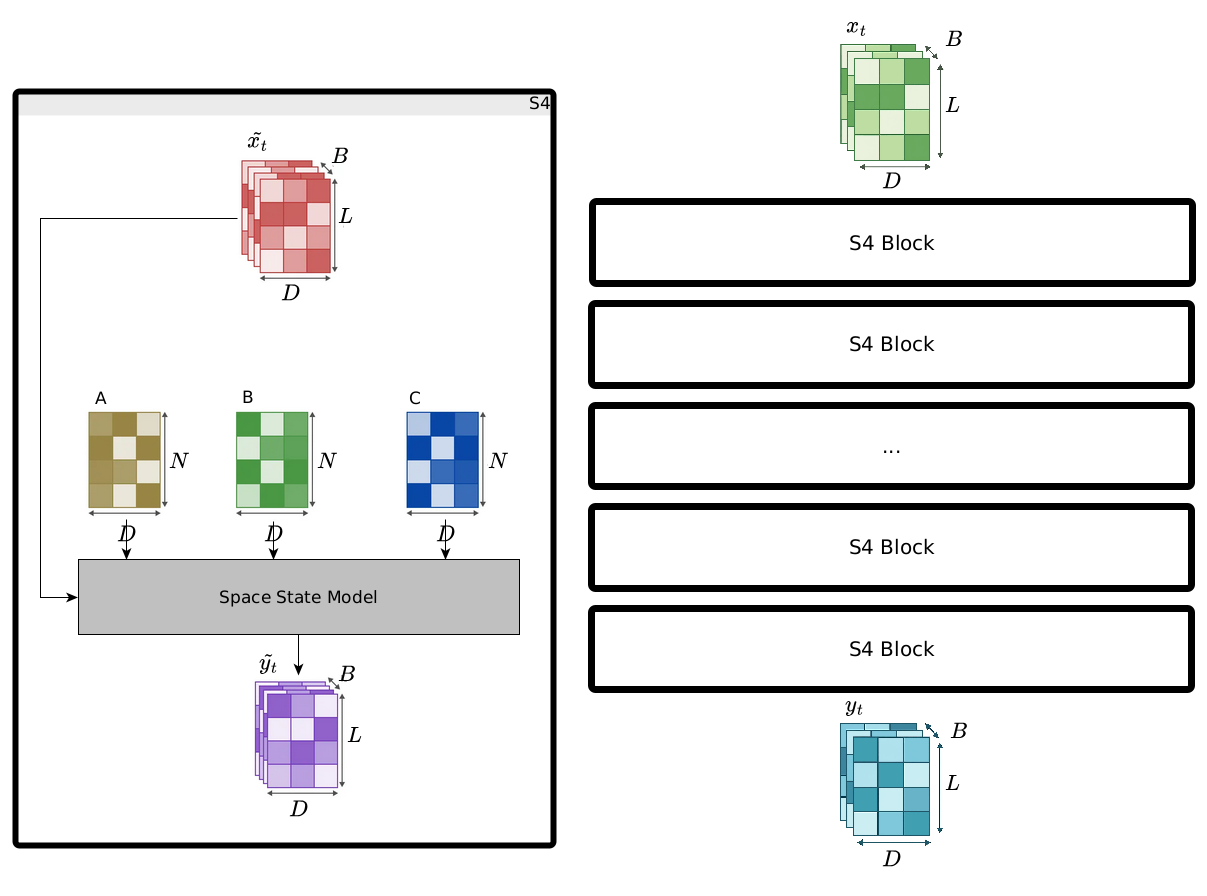


### Результаты модели `S4`

#### Набор данных `MNIST` / `QuickDraw`

Для оценки возможностей модели `S4` рассмотрим задачу предсказание последовательности пикселей по аналогии с языковым моделированием. Воспользуемся набора данных `MNIST` и `QuickDraw`, предварительно линейризовав каждое изображение в последовательность из 784 пикселей.

| <img src="mnist_im1.png" width="400"> | <img src="mnist_im10.png" width="400"> |
|----------------------------------|----------------------------------|
| <img src="mnist_im100.png" width="400"> | <img src="mnist_im12.png" width="400"> |

| <img src="quickdraw_im1.png" width="400"> | <img src="quickdraw_im2.png" width="400"> |
|----------------------------------|----------------------------------|
| <img src="quickdraw_im3.png" width="400"> | <img src="quickdraw_im4.png" width="400"> |

#### Бенчмарк `Long Range Arena`

`Long Range Arena` — это специализированный набор тестов, разработанный для проверки способности моделей работать с экстремально длинными зависимостями. В отличие от обычных задач NLP или CV, LRA требует обработки последовательностей длиной от 1 000 до 16 000+ токенов и включает классификацию текста, распознавание изображений в строковом виде, парсинг списков, сопоставление паттернов и другие задачи, критичные к дальнему контексту.

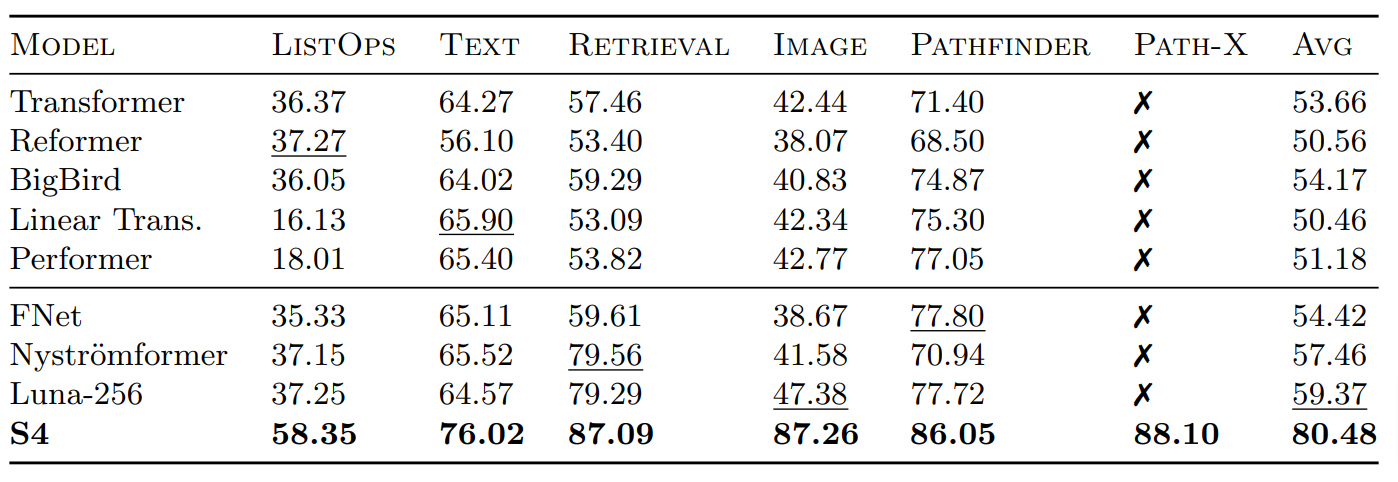


Модель `S4` — это новый подход к моделированию очень длинных последовательностей в задачах компьютерного зрения, обработки языка и аудио. Она демонстрирует способность улавливать зависимости на десятки тысяч шагов вперёд. Особенно впечатляют результаты модели на сложном бенчмарке `Long Range Arena`, где `S4` показывает высокую точность при работе с последовательностями длиной более 16 000 элементов.

### Общие выводы 

`S4` — это класс моделей, основанных на `SSM`, которые способны эффективно обрабатывать очень длинные последовательности (тысячи–десятки тысяч шагов) без потери градиентов.

- Использует структурированную матрицу `A` (на основе механизма `HIPPO`), которая гарантирует стабильность и удержание долгосрочных зависимостей.

- Представляет рекуррентную `SSM` как операцию свертки с длинным, экспоненциально затухающим ядром, и вычисляет его быстро через `FFT`.

- Объединяет преимущества `RNN` (длительная память) и `Transformer` (параллелизм), избегая их недостатков.



## Модель `Mamba`. Наивная реализация `Mamba Block`.

`Mamba` - это новая архитектура нейронных сетей, предложенная в `2023` году, как альтернатива трансформерам. Она основана не на `Attention`, а на модели пространства состояний `S6` — особом типе динамических моделей, хорошо подходящих для обработки длинных последовательностей.

Как это работает

- Вместо внимания используется обновляемое скрытое состояние, как в `RNN`, но с гораздо большей гибкостью и стабильностью.

- Внутри применяются селективные фильтры, которые динамически регулируют, какую информацию запоминать и обрабатывать.

- Вычисления организованы так, что можно эффективно обрабатывать последовательности длиной в тысячи или даже миллионы токенов.

### Общая схема блока `Mamba`

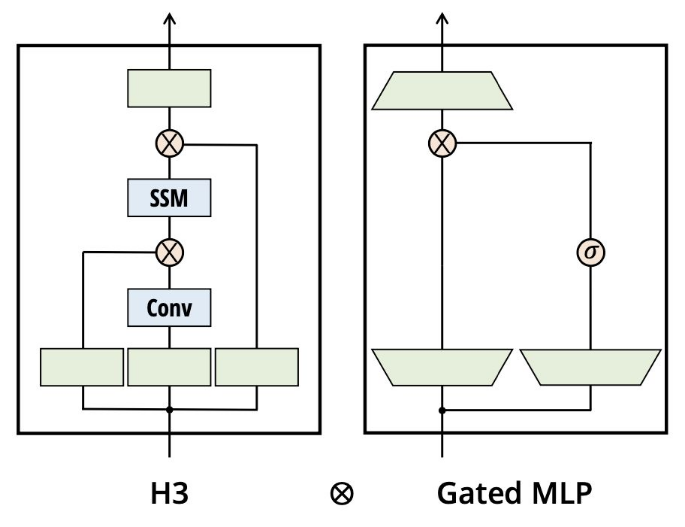


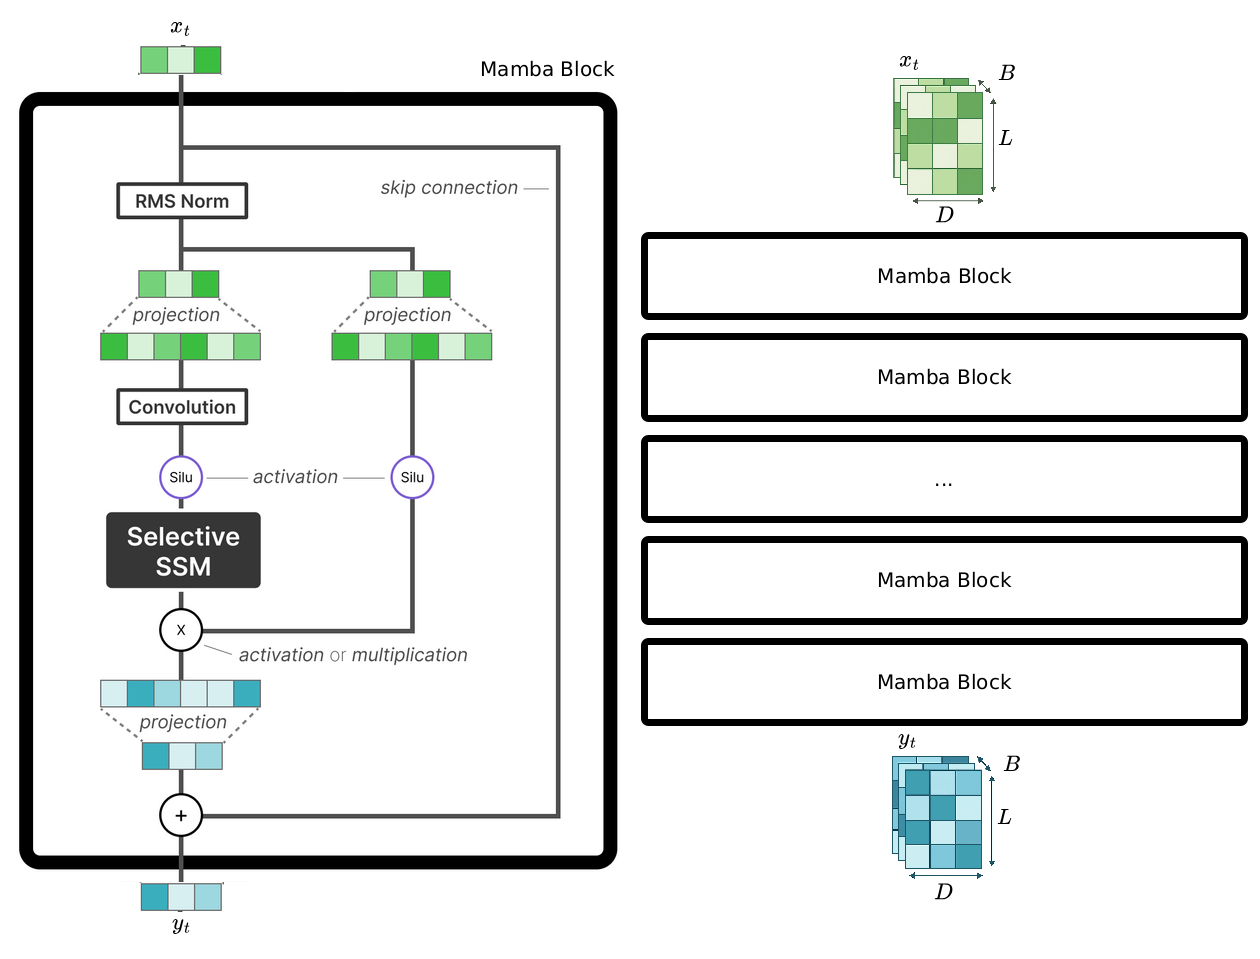


### Блок `Selective SSM`

Рекуррентное представление `SSM` создает небольшое состояние, которое является довольно эффективным, поскольку сжимает всю историю. Однако по сравнению с моделью `Transformer`, которая не сжимает историю, она гораздо менее эффективна, чтобы выборочно сжимать информацию, нам нужно, чтобы параметры `SMM` зависели от входных данных.

#### Модель пространства состояний `S6`

После того как механизмы `HiPPO` и `S4` показали, что линейные системы с ортогональной структурой матрицы перехода способны эффективно хранить 
историю входа. Модель `S6` предлагает минималистичное и вычислительно оптимальное упрощение `SSM`. Она сохраняет ключевую идею непрерывной динамики и её дискретизации, 
но избавляется от сложной спектральной параметризации `DPLR`, делая слой более лёгким, устойчивым и быстрым для практического применения на длинных последовательностях.

В `S6` матрица перехода `A` выбирается в предельно простой форме - диагональной и гарантированно устойчивой. Вместо спектрального разложения
используется экспоненциальная параметризация

$$
A \;=\; -\exp(a),
$$

где вектор $a$ является обучаемым. Такая форма обеспечивает строго
отрицательный спектр матрицы перехода и, следовательно, устойчивость системы 
при любой инициализации параметров.

Обучению подлежат следующие параметры, управляющие динамикой модели:

- $a$ — параметры, задающие спектр матрицы $A = \mathrm{diag}(-e^{a})$. Малые значения $e^{a}$ создают медленные моды, отвечающие за долговременную память; большие~— быстрые моды, фиксирующие локальные изменения. Таким образом, спектр определяет диапазон временных масштабов, на которых работает система.

- $B(x_t)$ — входная матрица, порождаемая из $x_t$ линейной проекцией. Она управляет тем, какие компоненты состояния получают вклад от текущего шага, формируя механизм селективного обновления.

- $C(x_t)$ — выходная матрица, также зависимая от входа. Она определяет вклад каждого модального компонента скрытого состояния в выход, влияя на форму результирующего фильтра.

- $\Delta(x_t)$ — входозависимый шаг дискретизации, масштабирующий экспоненту $e^{A \Delta_t}$ и определяющий внутреннюю временную шкалу модели. Это критично для адаптации к структуре 
    последовательностей разной длины.

Совокупность параметров $(A, B(x_t), C(x_t), \Delta(x_t))$
задаёт минимальную, но полностью обучаемую линейную систему

$$
h_t = e^{A \Delta_t}\, h_{t-1}
      \;+\;
      \Delta_t\, B(x_t)\, x_t,
$$

$$
y_t = C(x_t) h_t.
$$

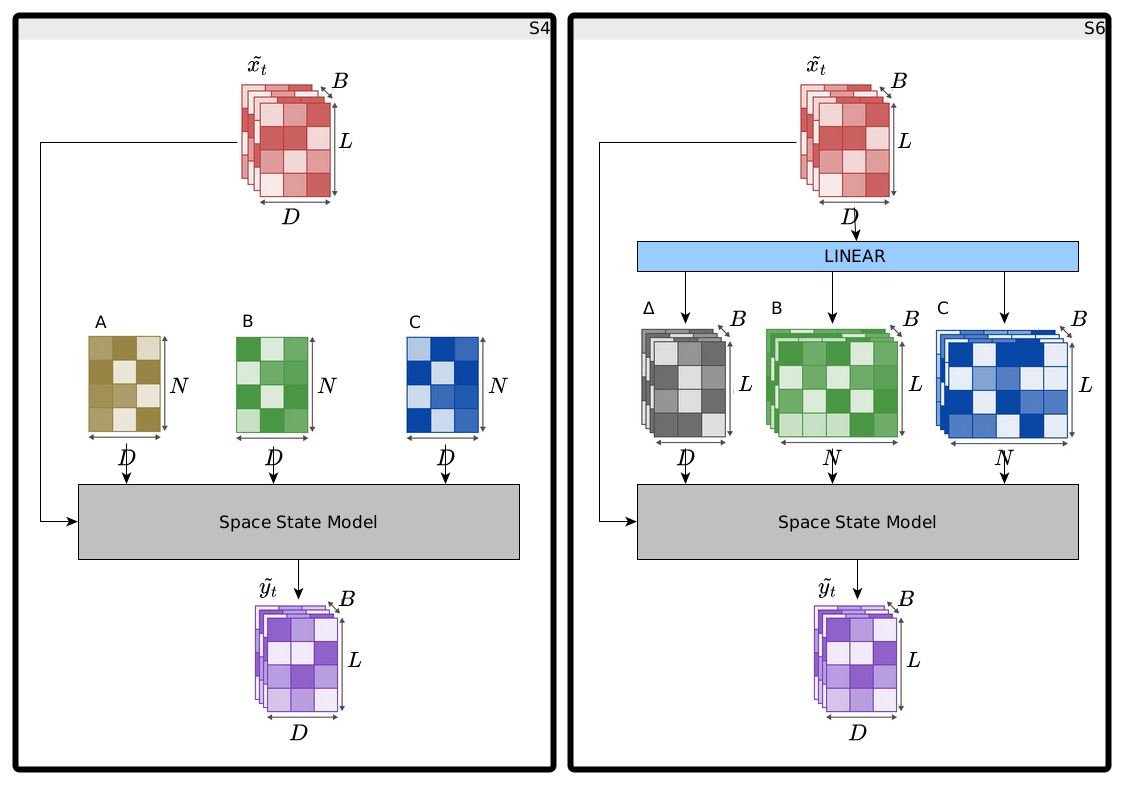


Особенности реализации блока

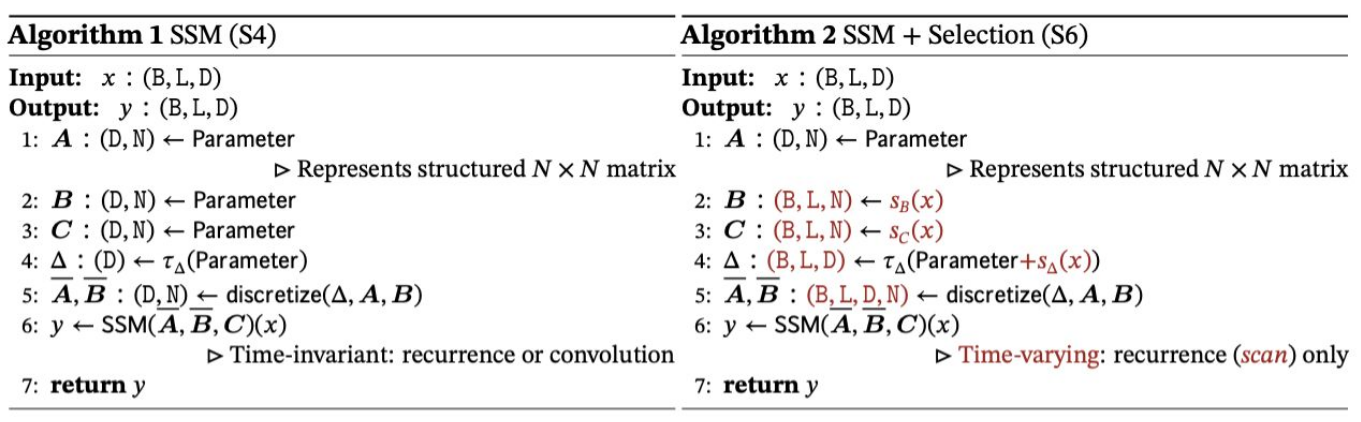


Благодаря диагональной структуре матрицы перехода и поэлементной дискретизации экспоненты $e^{A \Delta_t}$ вычисления выполняются с линейной сложностью по размерности скрытого состояния и эффективно распараллеливаются. 
Такое построение сохраняет ключевые преимущества непрерывных моделей — устойчивость, контролируемое затухание и интерпретируемые временные масштабы — при существенно меньшей вычислительной сложности по сравнению с `S4`.

### Наивная реализация `Mamba Block`

#### Система уравнений блока `Mamba`

$$
\begin{aligned}
\textbf{(1)~Предобработка~входа:} \qquad
&\tilde{x}_t = \operatorname{SiLU}(W_{\text{in}} x_t + b_{\text{in}}),
\\[6pt]
\textbf{(2)~Генерация~параметров~SSM:} \qquad
&(B_t,\, C_t,\, \Delta_t) = \operatorname{Linear}_{\theta}(\tilde{x}_t),
\\[6pt]
\textbf{(3)~Дискретизация:} \qquad
&\overline{A}_t = e^{\,\Delta_t A_t},
\qquad
\overline{B}_t = (\Delta_t A_t)^{-1}\!\left(e^{\,\Delta_t A_t} - I\right)\Delta_t B_t,
\\[6pt]
\textbf{(4)~Обновление~состояния:} \qquad
&h_t = \overline{A}_t h_{t-1} + \overline{B}_t \tilde{x}_t,
\\[6pt]
\textbf{(5)~Выход~SSM:} \qquad
&\tilde{y_t} = C_t h_t + D\,\tilde{x}_t,
\\[6pt]
\textbf{(6)~Выход~Mamba-блока:} \qquad
&y_t = \operatorname{SiLU}(W_{\text{out}} \tilde{y_t} + b_{\text{out}}) + x_t .
\end{aligned}
$$


#### Программная реализация блока `Mamba`

In [8]:
!pip install einops

In [9]:
from einops import rearrange, repeat, einsum

Комментарий:

`einops (Einstein Operations)` — это удобная библиотека для манипуляций с многомерными тензорами. Она делает код более читаемым и декларативным, особенно при работе с `PyTorch`, `TensorFlow` или `NumPy`.

- `rearrange(tensor, pattern, **axes_lengths)`: изменяет порядок осей (аналог `reshape/transpose/permute`, но мощнее и читаемее).
- `repeat(tensor, pattern, **axes_lengths)`: повторяет данные вдоль указанных осей.
- `einsum(equation, *operands)`: обертка вокруг `torch.einsum`, но с возможностью использовать в стиле `einops`.

In [10]:
!git clone https://github.com/johnma2006/mamba-minimal.git utils

fatal: destination path 'utils' already exists and is not an empty directory.


In [11]:
sys.path.insert(0, 'utils')

from utils.model import ModelArgs

Реализуем основной блок модели `Mamba`

In [12]:
class MambaBlock(nn.Module):
    def __init__(self, args: ModelArgs):
        """Один блок модели Mamba
        """
        super().__init__()
        self.args = args
        # Линейная проекция входа в 2 части: основную и остаточную (residual)
        self.in_proj = nn.Linear(args.d_model, args.d_inner * 2, bias=args.bias)

        # Групповая свертка по каналам: каждый канал обрабатывается отдельно
        self.conv1d = nn.Conv1d(
            in_channels  =args.d_inner,
            out_channels =args.d_inner,
            bias         =args.conv_bias,
            kernel_size  =args.d_conv,
            groups       =args.d_inner,  # depthwise convolution
            padding      =args.d_conv - 1,
        )
        
        # Линейный слой, извлекающий параметры Δ, B, C из входа
        self.x_proj = nn.Linear(args.d_inner, args.dt_rank + args.d_state * 2, bias=False)
        
        # Линейная проекция шага интегрирования Δ
        self.dt_proj = nn.Linear(args.dt_rank, args.d_inner, bias=True)

        # Логарифмы коэффициентов A (диагональные), A будет d_inner × d_state
        A = repeat(torch.arange(1, args.d_state + 1), 'n -> d n', d=args.d_inner)
        self.A_log = nn.Parameter(torch.log(A))  # A > 0
        self.D     = nn.Parameter(torch.ones(args.d_inner))  # коэффициенты при u(t)
        
        # Финальный слой проецирует обратно в размерность d_model
        self.out_proj = nn.Linear(args.d_inner, args.d_model, bias=args.bias)
    def forward(self, x):
        """
        Прямой проход через блок Mamba.
        Вход: x формы (b, l, d_model)
        Выход: output формы (b, l, d_model)
        """
        (b, l, d) = x.shape
        # Проекция входа и разбиение на x и остаток
        x_and_res = self.in_proj(x)  # (b, l, 2 × d_inner)
        (x, res) = x_and_res.split(split_size=[self.args.d_inner, self.args.d_inner], dim=-1)

        # Перестановка для свертки: (b, d_in, l)
        x = rearrange(x, 'b l d_in -> b d_in l')
        x = self.conv1d(x)[:, :, :l]  # Свертка и обрезание до длины l
        x = rearrange(x, 'b d_in l -> b l d_in')

        x = F.silu(x)  # Нелинейность SiLU

        y = self.ssm(x)  # Пропускаем через SSM (основная операция модели)

        # Умножаем на нелинейно обработанный остаток (gating)
        y = y * F.silu(res)

        # Финальная проекция обратно в d_model
        output = self.out_proj(y)
        return output

    def ssm(self, x):
        """
        Извлекает параметры A, B, C, D, ∆ и выполняет селективное сканирование.
        Вход: x формы (b, l, d_inner)
        Выход: y формы (b, l, d_inner)
        """
        (d_in, n) = self.A_log.shape
        A = -torch.exp(self.A_log.float())  # Матрица A: (d_in, d_state)
        D = self.D.float()                  # Диагональ D: (d_in,)

        x_dbl = self.x_proj(x)  # (b, l, dt_rank + 2 × d_state)

        # Разбиение на ∆, B, C
        (delta, B, C) = x_dbl.split(split_size=[self.args.dt_rank, n, n], dim=-1)
        delta = F.softplus(self.dt_proj(delta))  # Преобразуем ∆: (b, l, d_in)

        # Вычисляем y = SSM(x)
        y = self.selective_scan(x, delta, A, B, C, D)
        
        return y

    def selective_scan(self, u, delta, A, B, C, D):
        """
        Алгоритм селективного сканирования по времени.
        Осуществляет итеративное применение формул SSM:
            x(t+1) = A x(t) + B u(t)
            y(t)   = C x(t) + D u(t)
        Но B, C, ∆ — зависят от входа u(t)
        
        Вход:
            u: (b, l, d_in)
            delta: (b, l, d_in)
            A: (d_in, d_state)
            B, C: (b, l, d_state)
            D: (d_in,)
        Выход:
            y: (b, l, d_in)
        """
        (b, l, d_in) = u.shape
        n = A.shape[1]
        
        # Дискретизация A: deltaA = exp(delta * A)
        deltaA = torch.exp(einsum(delta, A, 'b l d_in, d_in n -> b l d_in n'))

        # Дискретизация B: упрощённое умножение
        deltaB_u = einsum(delta, B, u, 'b l d_in, b l n, b l d_in -> b l d_in n')

        # Инициализация скрытого состояния x(t)
        x = torch.zeros((b, d_in, n), device=deltaA.device)
        ys = []

        # Последовательный проход (можно заменить на ускоренный scan)
        for i in range(l):
            x = deltaA[:, i] * x + deltaB_u[:, i]  # рекурсивное обновление состояния
            y = einsum(x, C[:, i, :], 'b d_in n, b n -> b d_in')  # выход
            ys.append(y)

        y = torch.stack(ys, dim=1)  # (b, l, d_in)

        # Добавляем остаточный путь с коэффициентами D
        y = y + u * D
        
        return y

Cлой нормализации `RMSNorm`

In [13]:
class RMSNorm(nn.Module):
    def __init__(self, d_model: int, eps: float = 1e-5):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))


    def forward(self, x):
        output = x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) * self.weight

        return output

In [26]:
from transformers import AutoTokenizer
from utils.model        import Mamba
# One of:
#     'state-spaces/mamba-2.8b-slimpj'
#     'state-spaces/mamba-2.8b'
#     'state-spaces/mamba-1.4b'
#     'state-spaces/mamba-790m'
#     'state-spaces/mamba-370m'
#     'state-spaces/mamba-130m'
pretrained_model_name = 'state-spaces/mamba-370m'

model = Mamba.from_pretrained(pretrained_model_name)
tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neox-20b')

In [27]:
print(model)

Mamba(
  (embedding): Embedding(50280, 1024)
  (layers): ModuleList(
    (0-47): 48 x ResidualBlock(
      (mixer): MambaBlock(
        (in_proj): Linear(in_features=1024, out_features=4096, bias=False)
        (conv1d): Conv1d(2048, 2048, kernel_size=(4,), stride=(1,), padding=(3,), groups=2048)
        (x_proj): Linear(in_features=2048, out_features=96, bias=False)
        (dt_proj): Linear(in_features=64, out_features=2048, bias=True)
        (out_proj): Linear(in_features=2048, out_features=1024, bias=False)
      )
      (norm): RMSNorm()
    )
  )
  (norm_f): RMSNorm()
  (lm_head): Linear(in_features=1024, out_features=50280, bias=False)
)


In [28]:
def generate( 
 model, tokenizer,
 prompt: str, n_tokens_to_gen: int = 150,
 sample: bool = True, top_k: int = 40
):
    model.eval()
  
    input_ids = tokenizer(prompt, return_tensors='pt').input_ids
    
    for token_n in range(n_tokens_to_gen):
        with torch.no_grad():
            indices_to_input = input_ids
            next_token_logits = model(indices_to_input)[:, -1]
        
        probs = F.softmax(next_token_logits, dim=-1)
        (batch, vocab_size) = probs.shape
        
        if top_k is not None:
            (values, indices) = torch.topk(probs, k=top_k)
            probs[probs < values[:, -1, None]] = 0
            probs = probs / probs.sum(axis=1, keepdims=True)
        
        if sample:
            next_indices = torch.multinomial(probs, num_samples=1)
        else:
            next_indices = torch.argmax(probs, dim=-1)[:, None]
        
        input_ids = torch.cat([input_ids, next_indices], dim=1)

    output_completions = [tokenizer.decode(output.tolist()) for output in input_ids][0]
    
    return output_completions


In [29]:
print(generate(model, tokenizer, 'Mamba is the'))

Mamba is the name of a type of Brazilian bighorn sheep, used as "shorthorn" for some of its more popular parts. Mamba shors are classified as a variety of grayish-black (sometimes light brown in color) by a veterinarian or ichthyologist. The blackness of both sexes is distinctive, and males have black-pigmented patches across head, face, and shoulders that can vary from moderate reddish-brown to black. The horns, on the whole, are medium-size horns. The horns are short and rounded, and are generally round and blunt at the tips.

The species is also differentiated by a distinct band of white around the chin of the male, and the black legs.


In [30]:
print(generate(model, tokenizer, 'Stochastic gradient boosting is'))

Stochastic gradient boosting is proposed to combine the advantages of both gradient backpropagation and boosting algorithm. At each iteration of the boosting step, the gradient of the objective function at the current layer is calculated and combined with gradient of the previous layer. Thus, the model can adaptively improve its generalization ability.

This work is supported by Grants NS0908724 and NS0958017 from National Science Foundation of China (NSC).

![Different training procedure for SVM model. (a) Step 1. The first training example was generated by random number. Then, gradient descent algorithm is used to learn the parameters, and the training accuracy is increased. Here, *k* parameter denotes the number of iteration.

\(b\) Step 2. The


Модель `Mamba` представляет собой новый класс последовательностных архитектур, основанных на избирательных (selective) `State Space Models (SSM)`. В отличие от трансформеров, где основное внимание уделяется механизмам внимания (attention), Mamba предлагает линейную во времени альтернативу с эффективной параллелизацией, при этом сохраняя способность моделировать сложную динамику.

### Общие выводы

Модели `SSM` прошли путь от теоретических конструкций к практическим архитектурам, способным конкурировать с моделями, основанными на механизмах внимания. `S4` показала, что `SSM` могут быть устойчивыми, точно дискретизируемыми и эффективными на длинных последовательностях. Модели `Mamba` сделали следующий шаг — превратили `SSM` в селективный, чувствительный ко входу механизм с линейной сложностью, сохранив при этом богатую динамику и долговременную память. Таким образом, `Mamba` завершает переход от фиксированных `SSM` к гибким, масштабируемым и практически применимым архитектурам, открывая новое направление в проектировании моделей для длинных контекстов и высокопроизводительных систем.

#### Сравнение моделей: RNN, Transformer и Mamba (Selective SSM)

| Характеристика | **RNN / LSTM / GRU** | **Transformer** | **Mamba (Selective SSM)** |
|----------------|-----------------------|------------------|----------------------------|
| **Тип вычислений** | Последовательные | Параллельные (Attention) | Линейные SSM (Selective SSM) |
| **Сложность по длине L** | `O(L)` | `O(L²)` | `O(L)` |
| **Работа с длинными зависимостями** | Плохая | Отличная, но дорого | Отличная и эффективная |
| **Контекст** | Локальный | Глобальный | Глобальный |
| **Производительность на длинных последовательностях** | Высокая | Низкая | Очень высокая |
| **Интерпретируемость динамики** | Низкая | Средняя | Высокая (через спектр матрицы A) |
| **Гибкость** | Средняя | Высокая | Высокая |
| **Ключевая идея** | Рекурсия | Внимания | Селективная линейная динамика |